<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/maths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">**Mathematics**

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0000.png)

### <font color="blue">**Quantum**

##### <font color="blue">*Quantum Computing*

###### *IonQ with Cirq*

In [1]:
!pip install cirq-ionq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.7 MB/s eta 0:00:00


In [2]:
import cirq_ionq  # https://docs.ionq.com/sdks/cirq
import cirq       # https://quantumai.google/cirq/hardware/ionq/circuits

In [3]:
import json
import pickle
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import files
from collections import Counter
import matplotlib.pyplot as plt
import cirq_ionq.ionq_exceptions as ionq_exceptions

In [13]:
# Connect to IonQ Service and Secret Manager for Token
from google.colab import userdata
api_token = userdata.get('ionq-quantum')
service = cirq_ionq.Service(api_key=api_token)

In [14]:
# Check Available Backends (Simulators and QPUs) - https://cloud.ionq.com/backends/qpus
headers = {"Authorization": f"apiKey {'ionq-quantum'}"}
r = requests.get("https://api.ionq.co/v0.3/backends", headers=headers)
if r.status_code == 200:
    for i, b in enumerate(r.json(), 1):
        qt = b.get('average_queue_time', 0)
        print(f"\n{i}. {b['backend'].upper()}\n └── Type: {'QPU' if 'qpu' in b['backend'] else 'Simulator'}\n └── Status: {b['status'].upper()}\n └── Qubits: {b['qubits']}\n └── Average Queue Time: {f'{qt/3600:.1f} hours' if qt > 3600 else f'{qt/60:.1f} minutes' if qt > 60 else f'{qt} seconds'}" + (''.join([f"\n └── Available Noise Models: {', '.join(b['noise_models'])}" if 'noise_models' in b else "", f"\n └── Characterization: Available" if 'characterization_url' in b else "", f"\n └── DEGRADED SERVICE" if b.get('degraded', False) else ""])))
else: print(f"Backend check failed: {r.status_code}\nError details: {r.text}")


1. QPU.HARMONY
 └── Type: QPU
 └── Status: RETIRED
 └── Qubits: 11
 └── Average Queue Time: 0 seconds

2. QPU.ARIA-1
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 25
 └── Average Queue Time: 3954.8 hours
 └── Characterization: Available

3. QPU.ARIA-2
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 25
 └── Average Queue Time: 54887.5 hours
 └── Characterization: Available

4. QPU.FORTE-1
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 3461.2 hours
 └── Characterization: Available

5. QPU.FORTE-ENTERPRISE-1
 └── Type: QPU
 └── Status: AVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 38475.3 hours
 └── Characterization: Available

6. QPU.FORTE-ENTERPRISE-2
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 0 seconds

7. SIMULATOR
 └── Type: Simulator
 └── Status: AVAILABLE
 └── Qubits: 29
 └── Average Queue Time: 0 seconds
 └── Available Noise Models: aria-1, harmony, ideal


In [ ]:
# Calibration Data - https://quantumai.google/cirq/hardware/ionq/calibrationsx
service.get_current_calibration()
print(calibration.fidelities())
print(calibration.timings())
print(calibration.num_qubits())

In [16]:
# Define Circuit - Two-Qubit Bell state Preparation |Φ+⟩
q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.measure(q0, q1, key='x'))
print(circuit)

0: ───H───@───M('x')───
          │   │
1: ───────X───M────────


*Hadamard on $q_0$:*  $|00\rangle \xrightarrow{H \otimes I} \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes |0\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$

*CNOT (controlled by $q_0$) on $q_1$:* CNOT flips $q_1$ only if $q_0$ is $|1\rangle$  $\frac{1}{\sqrt{2}}(|00\rangle + |10\rangle) \xrightarrow{\text{CNOT}} \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) = |\Phi^+\rangle$

This final state, $|\Phi^+\rangle$, is an *entangled Bell state*:
* The amplitude for $|00\rangle$ is $1/\sqrt{2}$. The probability $P('00') = |1/\sqrt{2}|^2 = 0.5$
* The amplitude for $|11\rangle$ is $1/\sqrt{2}$. The probability $P('11') = |1/\sqrt{2}|^2 = 0.5$

In [46]:
# Theoretical Calculation (Exact probability distribution based on state vector simulation)
def calculate_exact_noiseless_probabilities(circuit: cirq.Circuit) -> dict:
    circuit_without_measurements = cirq.drop_terminal_measurements(circuit)
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit_without_measurements)
    final_state_vector = result.final_state_vector
    exact_counts = {}
    for i, amplitude in enumerate(final_state_vector):
        probability = np.abs(amplitude)**2
        count = round(probability * 100)  # Convert to counts for number of shots ('repetitions=')
        if count > 0:
            exact_counts[i] = count  # Use integer key like {0: 50, 3: 50}
    return exact_counts
theoretical_prediction = calculate_exact_noiseless_probabilities(circuit)
print("--- Theoretical Count Distribution ---")
print(f"Counter({theoretical_prediction})")
theoretical_counter = Counter(theoretical_prediction) # mock counter object to match format
with open('theoretical_result.pkl', 'wb') as f:
    pickle.dump(theoretical_counter, f)

--- Theoretical Count Distribution ---
Counter({0: 50, 3: 50})


In [47]:
# Noiseless simulation
result = service.run(
    circuit=circuit,
    target="simulator",
    repetitions=100,
    name="Noiseless Cirq Simulation")
print(result.histogram(key='x'))
print(result)
with open('noiseless_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({0: 51, 3: 49})
x=1000000001100011111110001001010010011000111111001000111001110110101100100110010100100111010110110001, 1000000001100011111110001001010010011000111111001000111001110110101100100110010100100111010110110001


In [49]:
# Noisy simulation
result = service.run(
    circuit=circuit,
    target="simulator",
    repetitions=100,
    name="Noisy Cirq Simulation",
    extra_query_params={"noise": {"model": "forte-enterprise-1"}})
print(result.histogram(key='x'))
print(result)
with open('noisy_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({0: 54, 3: 45, 1: 1})
x=0110110000100101000001010000100000101101010110010111010110000011010011100101100011010111111000010101, 0110110000101101000001010000100000101101010110010111010110000011010011100101100011010111111000010101


In [55]:
# Quantum Simulation
# (https://docs.ionq.com/guides/qpu-submission-checklist)
job = service.create_job(
    circuit=circuit,
    target="qpu.forte-enterprise-1", # forte-enterprise-1, aria-1
    repetitions=100,
    name="QPU Cirq Simulation")
print(job.job_id())   # https://cloud.ionq.com/jobs

019991ee-9f11-7227-a2de-5522b789b561


In [54]:
print(job.status())

submitted


In [60]:
print(job.status())

completed


In [61]:
# Retrieve a job
job_id = "019991ee-9f11-7227-a2de-5522b789b561"
job = service.get_job(job_id)

# Get the first result from the list
results_list = job.results()
result = results_list[0].to_cirq_result()  # Access first element
print(result.histogram(key='x'))
with open('quantum_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({3: 56, 0: 44})


Results loaded successfully!


COMPARISON TABLE:
State Binary  Theoretical Count Theoretical Prob  Noiseless Count Noiseless Prob  Noisy Count Noisy Prob  Quantum Count Quantum Prob  Quantum vs Theoretical  Quantum vs Noiseless  Quantum vs Noisy
 |00>     00                 50            0.500               51          0.510           54      0.540             44        0.440                      -6                    -7               -10
 |01>     01                  0            0.000                0          0.000            1      0.010              0        0.000                       0                     0                -1
 |11>     11                 50            0.500               49          0.490           45      0.450             56        0.560                       6                     7                11
SUMMARY STATISTICS:
Noiseless Fidelity            : 1.000
Noisy Fidelity                : 0.990
Quantum Fidelity              : 1.000
Noiseless Error Rate         

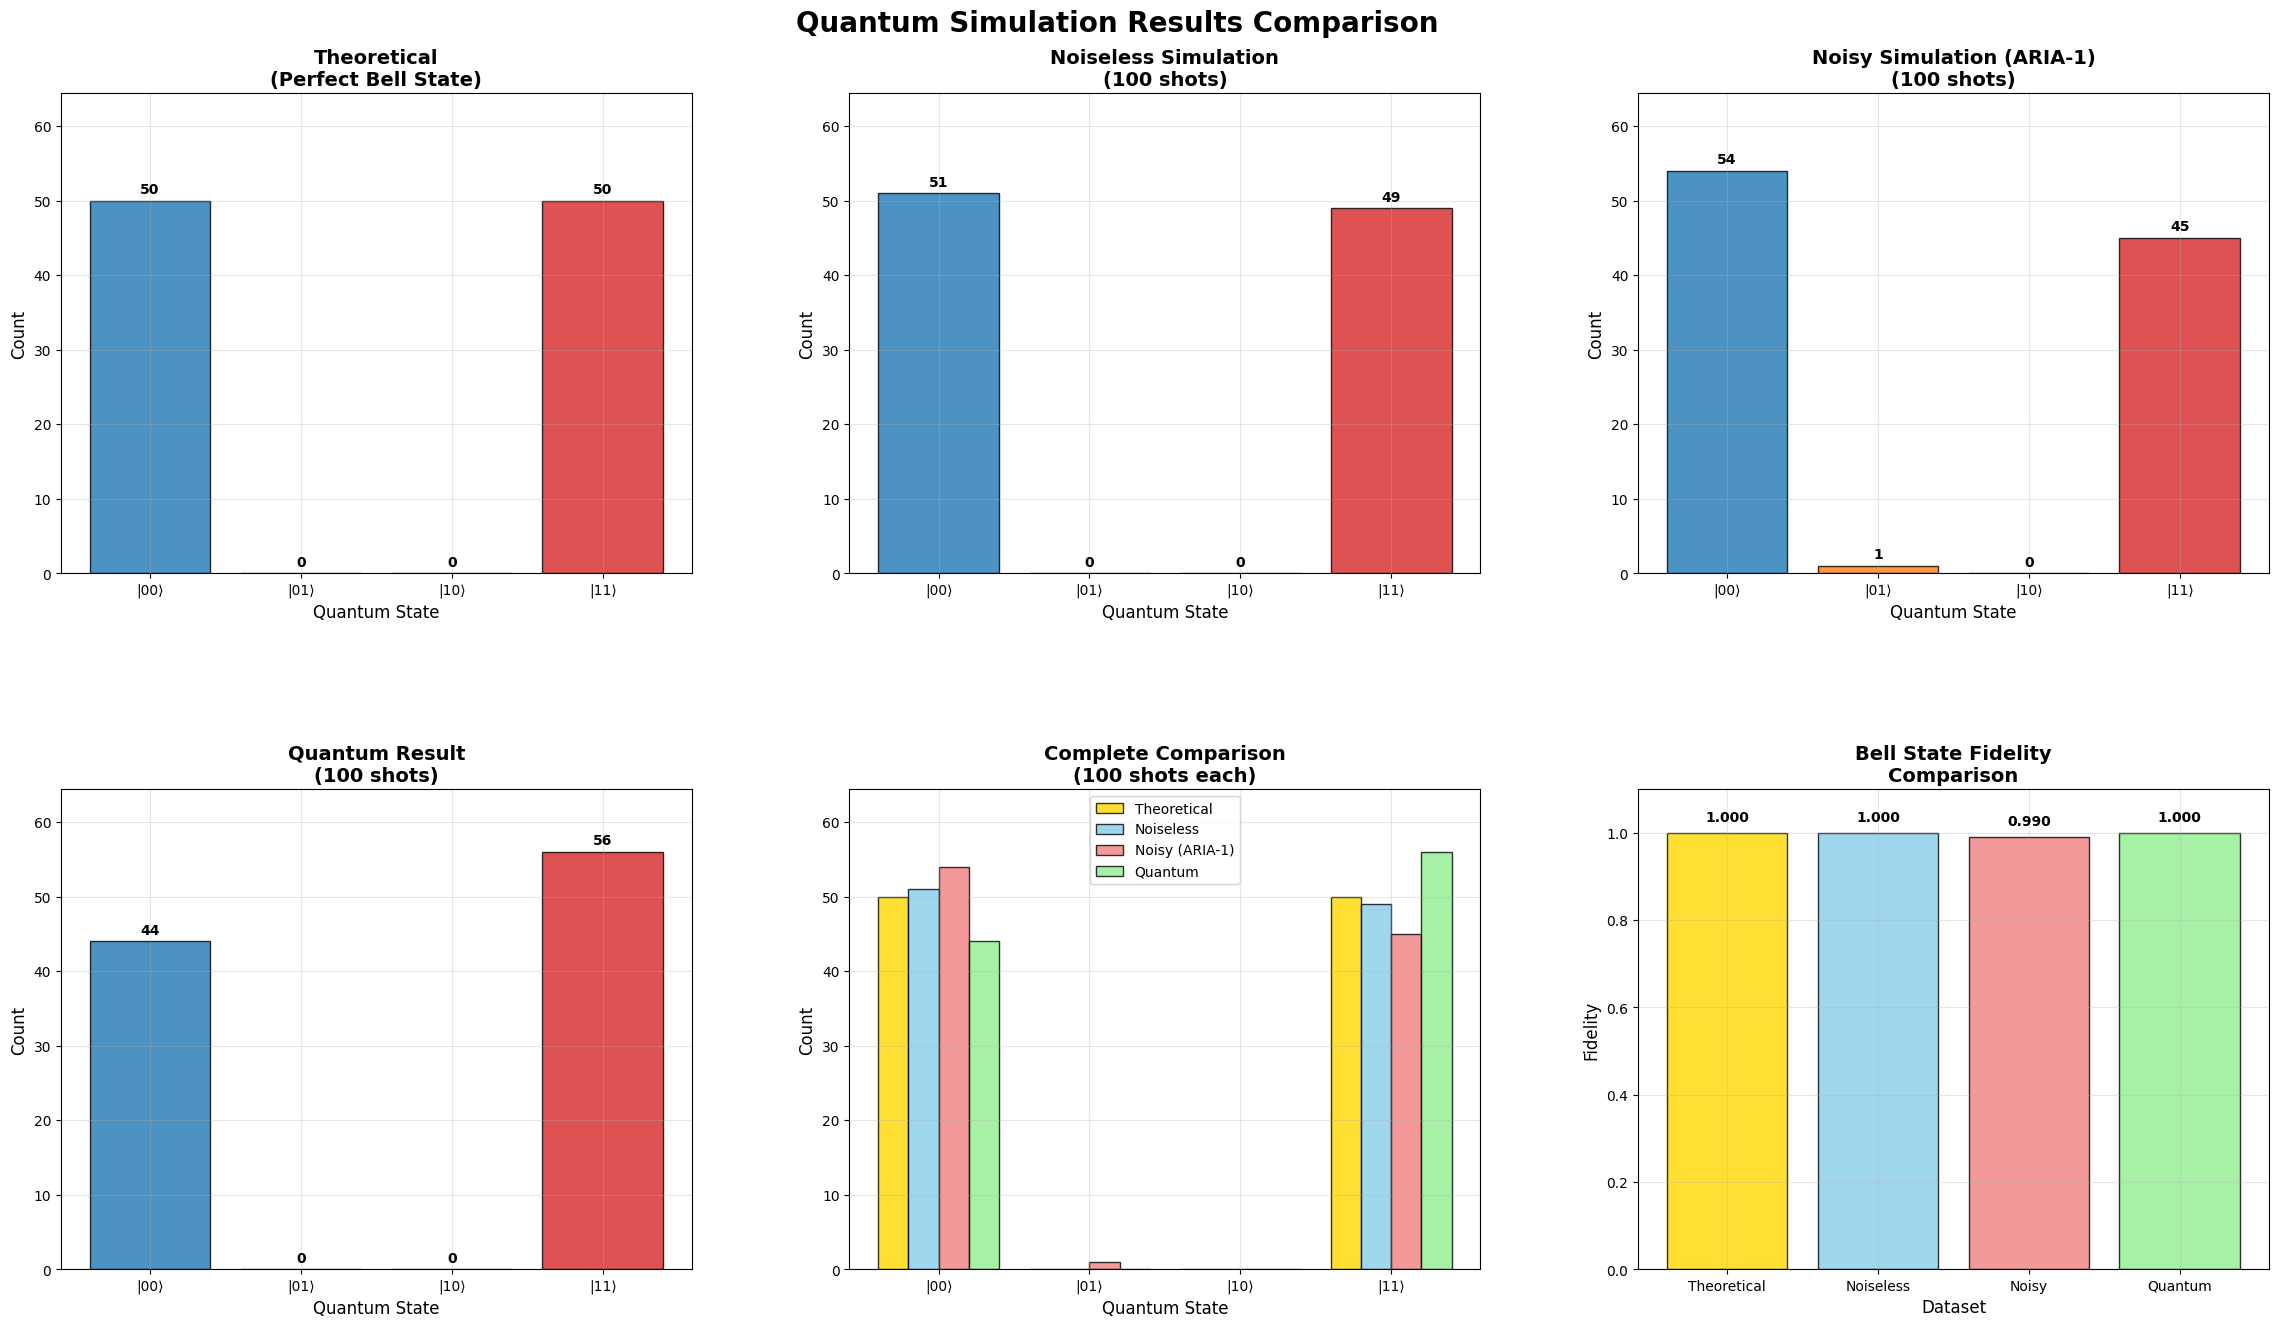

RAW RESULTS:
Theoretical histogram: {0: 50, 3: 50}
Noiseless histogram: {3: 49, 0: 51}
Noisy histogram: {0: 54, 3: 45, 1: 1}
Quantum histogram: {0: 44, 3: 56}

HELLINGER DISTANCES:
(0 = identical distributions, 1 = maximally different)
Theoretical  vs Noiseless   : 0.0071
Theoretical  vs Noisy       : 0.0777
Theoretical  vs Quantum     : 0.0425
Noiseless    vs Theoretical : 0.0071
Noiseless    vs Noisy       : 0.0751
Noiseless    vs Quantum     : 0.0496
Noisy        vs Theoretical : 0.0777
Noisy        vs Noiseless   : 0.0751
Noisy        vs Quantum     : 0.1028
Quantum      vs Theoretical : 0.0425
Quantum      vs Noiseless   : 0.0496
Quantum      vs Noisy       : 0.1028

Distance Matrix:
             Theoretical  Noiseless   Noisy  Quantum
Theoretical       0.0000     0.0071  0.0777   0.0425
Noiseless         0.0071     0.0000  0.0751   0.0496
Noisy             0.0777     0.0751  0.0000   0.1028
Quantum           0.0425     0.0496  0.1028   0.0000

Closest to theoretical: Noiseless (d

In [63]:
# @title Comparison of Results
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import pickle

# Load the saved results from local Colab environment
with open('noiseless_result.pkl', 'rb') as f:
    noiseless_result = pickle.load(f)

with open('noisy_result.pkl', 'rb') as f:
    noisy_result = pickle.load(f)

with open('theoretical_result.pkl', 'rb') as f:
    theoretical_data = pickle.load(f)

# Load the new quantum result
with open('quantum_result.pkl', 'rb') as f:
    quantum_result = pickle.load(f)

# Extract histogram data
noiseless_hist = noiseless_result.histogram(key='x')
noisy_hist = noisy_result.histogram(key='x')
theoretical_hist = theoretical_data  # Already in the right format (Counter)

# Extract quantum histogram (assuming similar structure to others)
if hasattr(quantum_result, 'histogram'):
    quantum_hist = quantum_result.histogram(key='x')
else:
    # If it's already a histogram/counter
    quantum_hist = quantum_result

print("Results loaded successfully!")
print("\n" + "="*50 + "\n")

# Create comparison table with 4 datasets
def create_comparison_table(theoretical_hist, noiseless_hist, noisy_hist, quantum_hist):
    """Create a comprehensive comparison table for 4 datasets"""

    # Get all possible states (0, 1, 2, 3 for 2-qubit system)
    all_states = set(list(theoretical_hist.keys()) + list(noiseless_hist.keys()) +
                    list(noisy_hist.keys()) + list(quantum_hist.keys()))

    # Create table data
    table_data = []
    for state in sorted(all_states):
        theoretical_count = theoretical_hist.get(state, 0)
        noiseless_count = noiseless_hist.get(state, 0)
        noisy_count = noisy_hist.get(state, 0)
        quantum_count = quantum_hist.get(state, 0)

        # Calculate probabilities (assuming 100 repetitions for each)
        theoretical_prob = theoretical_count / 100
        noiseless_prob = noiseless_count / 100
        noisy_prob = noisy_count / 100
        quantum_prob = quantum_count / 100

        # Convert state to binary representation
        binary_state = format(state, '02b')

        table_data.append({
            'State': f'|{binary_state}>',
            'Binary': binary_state,
            'Theoretical Count': theoretical_count,
            'Theoretical Prob': f'{theoretical_prob:.3f}',
            'Noiseless Count': noiseless_count,
            'Noiseless Prob': f'{noiseless_prob:.3f}',
            'Noisy Count': noisy_count,
            'Noisy Prob': f'{noisy_prob:.3f}',
            'Quantum Count': quantum_count,
            'Quantum Prob': f'{quantum_prob:.3f}',
            'Quantum vs Theoretical': quantum_count - theoretical_count,
            'Quantum vs Noiseless': quantum_count - noiseless_count,
            'Quantum vs Noisy': quantum_count - noisy_count
        })

    return pd.DataFrame(table_data)

# Create and display comparison table
comparison_df = create_comparison_table(theoretical_hist, noiseless_hist, noisy_hist, quantum_hist)
print("COMPARISON TABLE:")
print("="*120)
print(comparison_df.to_string(index=False))

# Calculate summary statistics for all datasets
def calculate_summary_stats(noiseless_hist, noisy_hist, quantum_hist):
    """Calculate summary statistics for comparison of all datasets"""

    # Expected outcomes for Bell state: |00> and |11> should be equally likely
    expected_states = [0, 3]  # |00> = 0, |11> = 3 in binary

    noiseless_ideal = sum(noiseless_hist.get(state, 0) for state in expected_states)
    noisy_ideal = sum(noisy_hist.get(state, 0) for state in expected_states)
    quantum_ideal = sum(quantum_hist.get(state, 0) for state in expected_states)

    noiseless_error = sum(noiseless_hist.get(state, 0) for state in [1, 2])  # |01> and |10>
    noisy_error = sum(noisy_hist.get(state, 0) for state in [1, 2])
    quantum_error = sum(quantum_hist.get(state, 0) for state in [1, 2])

    stats = {
        'Noiseless Fidelity': noiseless_ideal / 100,
        'Noisy Fidelity': noisy_ideal / 100,
        'Quantum Fidelity': quantum_ideal / 100,
        'Noiseless Error Rate': noiseless_error / 100,
        'Noisy Error Rate': noisy_error / 100,
        'Quantum Error Rate': quantum_error / 100,
        'Quantum vs Noiseless Fidelity': (quantum_ideal - noiseless_ideal) / 100,
        'Quantum vs Noisy Fidelity': (quantum_ideal - noisy_ideal) / 100,
        'Quantum vs Noiseless Error': (quantum_error - noiseless_error) / 100,
        'Quantum vs Noisy Error': (quantum_error - noisy_error) / 100
    }

    return stats

# Calculate and display summary statistics
summary_stats = calculate_summary_stats(noiseless_hist, noisy_hist, quantum_hist)
print("SUMMARY STATISTICS:")
print("="*50)
for key, value in summary_stats.items():
    print(f"{key:30}: {value:.3f}")

# Create comprehensive histogram visualization
def plot_comparison_histograms(theoretical_hist, noiseless_hist, noisy_hist, quantum_hist):
    """Create comprehensive histogram comparison with 5 subplots"""
    fig, axes = plt.subplots(2, 3, figsize=(24, 14))
    fig.suptitle('Quantum Simulation Results Comparison', fontsize=20, fontweight='bold', y=0.98)

    # Flatten axes for easier indexing
    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

    # Prepare data for plotting
    states = [0, 1, 2, 3]  # All possible 2-qubit states
    state_labels = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']

    theoretical_counts = [theoretical_hist.get(state, 0) for state in states]
    noiseless_counts = [noiseless_hist.get(state, 0) for state in states]
    noisy_counts = [noisy_hist.get(state, 0) for state in states]
    quantum_counts = [quantum_hist.get(state, 0) for state in states]

    # Colors for each state
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    max_count = max(max(theoretical_counts), max(noiseless_counts),
                   max(noisy_counts), max(quantum_counts))

    def add_count_labels(ax, bars, counts):
        """Helper function to add count labels on bars"""
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max_count*0.01,
                   f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    # Plot 1: Theoretical
    bars1 = ax1.bar(state_labels, theoretical_counts, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Theoretical\n(Perfect Bell State)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_xlabel('Quantum State', fontsize=12)
    ax1.set_ylim(0, max_count * 1.15)
    ax1.grid(True, alpha=0.3)
    add_count_labels(ax1, bars1, theoretical_counts)

    # Plot 2: Noiseless simulation
    bars2 = ax2.bar(state_labels, noiseless_counts, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('Noiseless Simulation\n(100 shots)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_xlabel('Quantum State', fontsize=12)
    ax2.set_ylim(0, max_count * 1.15)
    ax2.grid(True, alpha=0.3)
    add_count_labels(ax2, bars2, noiseless_counts)

    # Plot 3: Noisy simulation
    bars3 = ax3.bar(state_labels, noisy_counts, color=colors, alpha=0.8, edgecolor='black')
    ax3.set_title('Noisy Simulation (ARIA-1)\n(100 shots)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_xlabel('Quantum State', fontsize=12)
    ax3.set_ylim(0, max_count * 1.15)
    ax3.grid(True, alpha=0.3)
    add_count_labels(ax3, bars3, noisy_counts)

    # Plot 4: Quantum result
    bars4 = ax4.bar(state_labels, quantum_counts, color=colors, alpha=0.8, edgecolor='black')
    ax4.set_title('Quantum Result\n(100 shots)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Count', fontsize=12)
    ax4.set_xlabel('Quantum State', fontsize=12)
    ax4.set_ylim(0, max_count * 1.15)
    ax4.grid(True, alpha=0.3)
    add_count_labels(ax4, bars4, quantum_counts)

    # Plot 5: All comparisons
    x = np.arange(len(state_labels))
    width = 0.2

    bars5_1 = ax5.bar(x - 1.5*width, theoretical_counts, width, label='Theoretical',
                      color='gold', alpha=0.8, edgecolor='black')
    bars5_2 = ax5.bar(x - 0.5*width, noiseless_counts, width, label='Noiseless',
                      color='skyblue', alpha=0.8, edgecolor='black')
    bars5_3 = ax5.bar(x + 0.5*width, noisy_counts, width, label='Noisy (ARIA-1)',
                      color='lightcoral', alpha=0.8, edgecolor='black')
    bars5_4 = ax5.bar(x + 1.5*width, quantum_counts, width, label='Quantum',
                      color='lightgreen', alpha=0.8, edgecolor='black')

    ax5.set_title('Complete Comparison\n(100 shots each)', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Count', fontsize=12)
    ax5.set_xlabel('Quantum State', fontsize=12)
    ax5.set_xticks(x)
    ax5.set_xticklabels(state_labels)
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim(0, max_count * 1.15)

    # Plot 6: Fidelity comparison
    datasets = ['Theoretical', 'Noiseless', 'Noisy', 'Quantum']
    fidelities = [
        sum(theoretical_counts[i] for i in [0, 3]) / 100,
        sum(noiseless_counts[i] for i in [0, 3]) / 100,
        sum(noisy_counts[i] for i in [0, 3]) / 100,
        sum(quantum_counts[i] for i in [0, 3]) / 100
    ]

    bars6 = ax6.bar(datasets, fidelities, color=['gold', 'skyblue', 'lightcoral', 'lightgreen'],
                   alpha=0.8, edgecolor='black')
    ax6.set_title('Bell State Fidelity\nComparison', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Fidelity', fontsize=12)
    ax6.set_xlabel('Dataset', fontsize=12)
    ax6.set_ylim(0, 1.1)
    ax6.grid(True, alpha=0.3)

    # Add fidelity labels
    for bar, fidelity in zip(bars6, fidelities):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{fidelity:.3f}', ha='center', va='bottom', fontweight='bold')

    # Adjust subplot spacing manually
    plt.subplots_adjust(left=0.06, bottom=0.08, right=0.98, top=0.92, wspace=0.25, hspace=0.45)
    plt.show()

# Generate the plots
plot_comparison_histograms(theoretical_hist, noiseless_hist, noisy_hist, quantum_hist)

# Print raw results for reference
print("RAW RESULTS:")
print("="*40)
print("Theoretical histogram:", dict(theoretical_hist))
print("Noiseless histogram:", dict(noiseless_hist))
print("Noisy histogram:", dict(noisy_hist))
print("Quantum histogram:", dict(quantum_hist))

# Enhanced analysis: Hellinger distances between all pairs
def hellinger_distance(p, q):
    """Calculate Hellinger distance between two probability distributions"""
    # Ensure both distributions have the same states
    all_states = set(list(p.keys()) + list(q.keys()))

    p_probs = np.array([p.get(state, 0) / sum(p.values()) for state in sorted(all_states)])
    q_probs = np.array([q.get(state, 0) / sum(q.values()) for state in sorted(all_states)])

    return np.sqrt(0.5 * np.sum((np.sqrt(p_probs) - np.sqrt(q_probs))**2))

# Calculate all pairwise Hellinger distances
print("\nHELLINGER DISTANCES:")
print("="*40)
print("(0 = identical distributions, 1 = maximally different)")

datasets = {
    'Theoretical': theoretical_hist,
    'Noiseless': noiseless_hist,
    'Noisy': noisy_hist,
    'Quantum': quantum_hist
}

distance_matrix = []
for name1, hist1 in datasets.items():
    row = []
    for name2, hist2 in datasets.items():
        if name1 != name2:
            distance = hellinger_distance(hist1, hist2)
            print(f"{name1:12} vs {name2:12}: {distance:.4f}")
            row.append(distance)
        else:
            row.append(0.0)
    distance_matrix.append(row)

# Create distance matrix dataframe
distance_df = pd.DataFrame(distance_matrix,
                          index=list(datasets.keys()),
                          columns=list(datasets.keys()))

print(f"\nDistance Matrix:")
print(distance_df.round(4))

# Additional analysis: Which dataset is closest to theoretical?
theoretical_distances = {}
for name, hist in datasets.items():
    if name != 'Theoretical':
        theoretical_distances[name] = hellinger_distance(theoretical_hist, hist)

closest_to_theoretical = min(theoretical_distances, key=theoretical_distances.get)
print(f"\nClosest to theoretical: {closest_to_theoretical} (distance: {theoretical_distances[closest_to_theoretical]:.4f})")

###### *IBM with Qiskit*

In [ ]:
!pip install qiskit qiskit-ibm-runtime qiskit[visualization] -q

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import userdata
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [ ]:
## 1. Connect to IBM Quantum
api_token = userdata.get('ibm-quantum')

# Pass both the token and the channel
service = QiskitRuntimeService(channel='ibm_quantum_platform', token=api_token)

backend = service.least_busy(simulator=False, operational=True)
print(f"Selected backend: {backend.name}")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-24 14:58:30,762: Default instance not set. Searching all available instances.


Selected backend: ibm_brussels



Ideal Circuit Diagram:


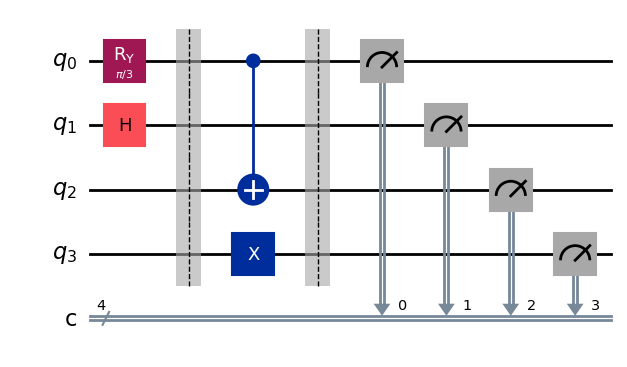

In [ ]:
# 2. Create the Quantum Circuit with Asymmetric State Evolution (with Unequal Superposition)
qc = QuantumCircuit(4, 4)
qc.ry(np.pi / 3, 0) # Replace H(0) with Ry(pi/3, 0) to create a 75%/25% split
qc.h(1)             # Keep the H on q1 for a 50/50 split
qc.barrier()
qc.cx(0, 2)
qc.x(3)
qc.barrier()
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
print("\nIdeal Circuit Diagram:")
display(qc.draw("mpl"))


Transpiled Circuit for ibm_brussels:


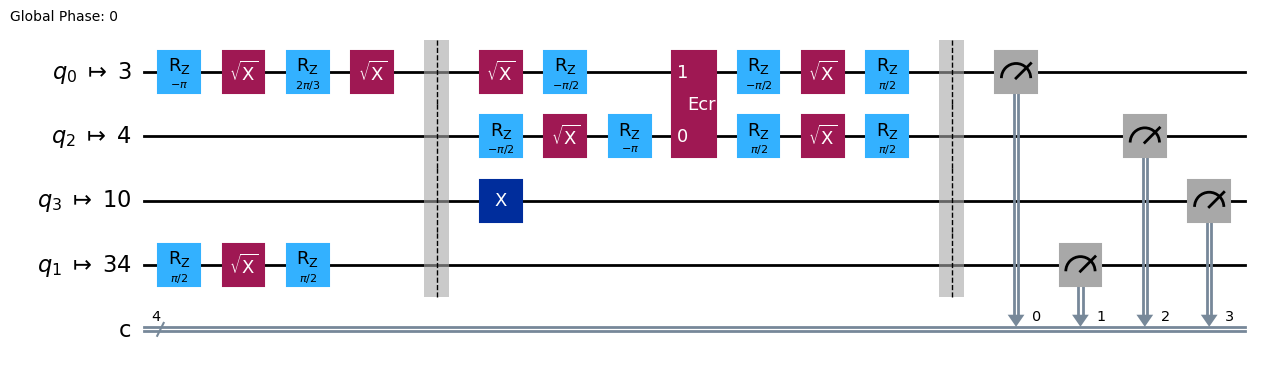

In [ ]:
# 3. Transpile circuit for backend (translates ideal circuit into one the hardware can run)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
print(f"\nTranspiled Circuit for {backend.name}:")
display(isa_circuit.draw("mpl"))

In [ ]:
# 4. Run job on IBM quantum computer
sampler = Sampler(mode=backend)
shots = 1024
print(f"\nSubmitting job to {backend.name}...")
job = sampler.run(pubs=[(isa_circuit,)], shots=shots) # Run transpiled 'isa_circuit', not original 'qc'
print(f"Job submitted successfully! Job ID: {job.job_id()}")


Submitting job to ibm_brussels...
Job submitted successfully! Job ID: d3615tl7ibtc73dlifgg


In [ ]:
job.status()

'DONE'

In [ ]:
job.metrics()

{'timestamps': {'created': '2025-09-18T14:11:02.899474Z',
  'finished': '2025-09-18T14:15:53.524337Z',
  'running': '2025-09-18T14:15:36.902052Z'},
 'bss': {'seconds': 3},
 'usage': {'quantum_seconds': 3, 'seconds': 3},
 'qiskit_version': 'qiskit_ibm_runtime-0.41.1,qiskit-2.1.2*',
 'caller': 'qiskit_ibm_runtime~sampler.py'}

In [ ]:
job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=4>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-09-18 14:15:51', stop='2025-09-18 14:15:53', size=1024>)])}, 'version': 2})


Measurement Results (Counts):
{'1000': 390, '1010': 350, '1101': 121, '1110': 4, '1111': 141, '0010': 4, '0111': 2, '1001': 1, '1100': 5, '1011': 2, '0101': 1, '0000': 3}

Result Histogram:


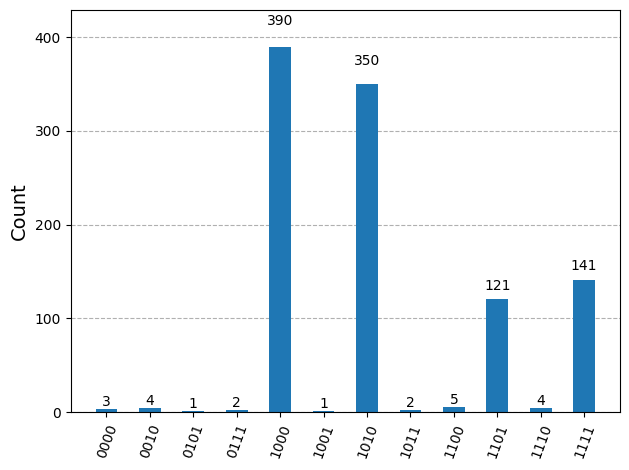

In [ ]:
# 5. Get and display results
result = job.result()
counts = result[0].data.c.get_counts()
print("\nMeasurement Results (Counts):")
print(counts)
plot_histogram(counts)


Local Simulation results (counts) with 1024 shots:
{'1101': 118, '1111': 131, '1000': 388, '1010': 387}

Local Simulation Probabilities:
  |1000>: 0.379 (388/1024)
  |1010>: 0.378 (387/1024)
  |1101>: 0.115 (118/1024)
  |1111>: 0.128 (131/1024)

Local Simulation Histogram:


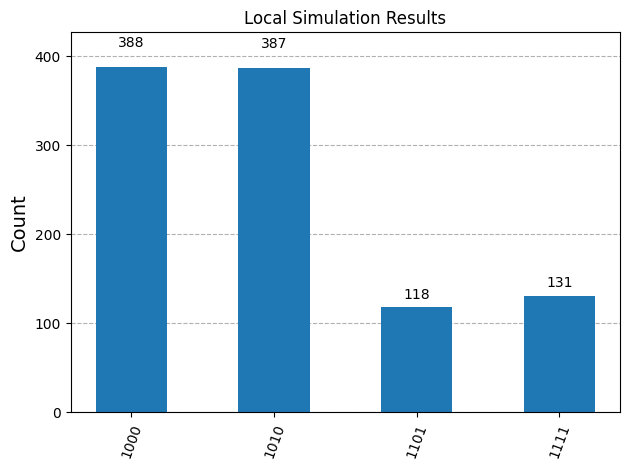

In [ ]:
# Appendix: Run local simulation
from qiskit.primitives import StatevectorSampler as LocalSampler
from qiskit.visualization import plot_histogram

local_sampler = LocalSampler() # Create local sampler
local_shots = 1024
local_job = local_sampler.run(pubs=[(qc,)], shots=local_shots) # Run circuit
local_result = local_job.result()
local_counts = local_result[0].data.c.get_counts() # Extract counts from result
print(f"\nLocal Simulation results (counts) with {local_shots} shots:")
print(local_counts)
print("\nProbabilities:")
for bitstring, count in sorted(local_counts.items()):
    probability = count / local_shots
    print(f"  |{bitstring}>: {probability:.3f} ({count}/{local_shots})")

display(plot_histogram(local_counts, title="Local Simulation Results"))

Devices: https://eu-de.quantum.cloud.ibm.com/computers

Topology: https://eu-de.quantum.cloud.ibm.com/docs/de/guides/qpu-information

Jobs: https://eu-de.quantum.cloud.ibm.com/workloads

Cost: https://cloud.ibm.com/billing

Tutorials: https://eu-de.quantum.cloud.ibm.com/docs/de/tutorials

##### <font color="blue">*Quantum Algorithms*

###### *Quantum Fourier Transform*

In [ ]:
!pip install pennylane qutip cirq -q
import pennylane as qml
import numpy as np
import cirq

https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series

> Momentum Space and Position Space with Quantum Fourier Transform

https://youtu.be/W8QZ-yxebFA

> **Quantum Fourier Transform is the change from one basis (computational) to another (Fourier basis)**

* Quantum Fourier Transform is the inverse Discrete Fourier Transform)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_047.png)

**General formula**

* Remember: <font color="blue">$e^{2\pi i}$ = 1</font> (identity operation), and see why $e^{\pi i}$ = -1 in [this video](https://youtu.be/-AyE1Wpgo3Q)


* In QFT we change the <font color="blue">$\theta$ = phase in $e^{2\pi i \theta}$</font> = Eigenvalue of Oracle function $U$ associated with an eigenvector |u⟩

* The phase $\theta$ is expressed as: <font color="blue">$\theta$ = $\frac{x_n}{2^{k_n}}$</font> with:

  * <font color="blue">$x_n$ = 0 or 1</font> state

  * <font color="blue">$k_n$</font> number of Qubits

* This is expressed in a so-called "controlled-R quantum gate" that **applies a relative phase change to |1>**

* The matrix form of this operator is: <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i \frac{x_n}{ 2^{k_n}}}\end{array}\right)$</font>

*Quantum Fourier Transform with 3 Qubits: Introduction*

**Computational Basis States:** <font color="blue">$\tilde{x_1}$ = 0 or 1</font>, <font color="blue">$\tilde{x_2}$ = 0 or 1</font>, <font color="blue">$\tilde{x_3}$ = 0 or 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1, $k_2$ = 2, $k_3$ = 3</font>

> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^1}+\frac{x_{2}}{2^2}+\frac{x_{3}}{2^3}\right)}|1\rangle\right)$  = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$

* If only $\tilde{x_1}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1

* If only $\tilde{x_2}$ is activated, then it is a 90° S-rotation of $\frac{\pi}{2}$ radians = i

* If only $\tilde{x_3}$ is activated, then it is a 45° T-rotation of $\frac{\pi}{4}$ radians = between 1 and i

> <font color="blue">$\tilde{x_2}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2^{k_1}}+\frac{x_3}{2^{k_2}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2^1}+\frac{x_3}{2^2}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2}+\frac{x_3}{4}\right)}|1\rangle\right)$

* If only $\tilde{x_2}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1

* If only $\tilde{x_3}$ is activated, then it is a 90° S-rotation of $\frac{\pi}{2}$ radians = i

* If both $\tilde{x_2}$ and $\tilde{x_3}$ are activated, then it is a 180° + 90° = 170° rotation of $\pi + \frac{\pi}{2}$ radians = -i

> <font color="blue">$\tilde{x_3}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_3}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_3}{2^1}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{\pi \mathrm{i}x_3}|1\rangle\right)$

* If $\tilde{x_3}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1


**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is activated because $x_2$ = 1:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Here including the 8x8 matrix form for the complete operator:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0801.png)

*Quantum Fourier Transform with 1 Qubit*

**Computational Basis States:** <font color="blue">$\tilde{x_1}$ = 0 or 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1</font>


*Linear transformation of a qubit in the computational basis 0 and 1 each separately to the Fourier basis:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0813.png)

**Computational Basis in $|0\rangle$**

> <font color="blue">For $x_1$ = 0 $\Rightarrow$</font> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^1}\right)}|1\rangle\right)$  $\Rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}\right)}$ = $\mathrm{e}^{2 \pi \mathrm{i} 0}$  = $\mathrm{e}^{0}$ = 1 (no rotation)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0810.png)

**Computational Basis in $|1\rangle$**

> <font color="blue">For $x_1$ = 1 $\Rightarrow$</font> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^1}\right)}|1\rangle\right)$ $\Rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}\right)}$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0811.png)

*Quantum Fourier Transform with 1 Qubit is a Hadamard transform!*

**One qubit QFT matrix**: $\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1 & 1 \\ 1 & \mathrm{e}^{\pi i}\end{array}\right)$, where $\mathrm{e}^{\pi \mathrm{i}}$ = -1. So it is: <font color="blue"> QFT für x=1 = $\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1 & 1 \\ 1 & -1\end{array}\right)$

**Compare with Hadamard transform matrix:**

In quantum computing, the Hadamard gate is a one-qubit rotation, mapping the qubitbasis states $|0\rangle$ and $|1\rangle$ to two **superposition** states with **equal weight of the computational basis** states $|0\rangle$ and $|1\rangle$. Usually the phases are chosen so that

>$
H=\frac{|0\rangle+|1\rangle}{\sqrt{2}}\langle 0|+\frac{|0\rangle-|1\rangle}{\sqrt{2}}\langle 1|
$

in Dirac notation. This corresponds to the transformation matrix

> <font color="blue">$
H_{1}=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)
$

in the $|0\rangle,|1\rangle$ basis, also known as the computational basis. The states $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$ and $\frac{|0\rangle-|1\rangle}{\sqrt{2}}$ are known as $|+\rangle$ and $|-\rangle$ respectively, and together constitute the polar basis in quantum computing.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_073.jpg)


**Why Hadamard transform is exactly a 1 qubit Quantum Fourier Transform:** (see result of + for 0 state and - for 1 state) - Matrix-Vector-Multiplication (Single Qubit)

> <font color="blue">$H |0\rangle$</font> $ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right] =\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$ <font color="blue">$ \,\,= |+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

> <font color="blue">$H |1\rangle$</font>$ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$ <font color="blue">$ = |-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

$|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ weil <font color="gray">wegen $|0\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right]$ und $|1\rangle=\left[\begin{array}{l}0 \\ 1\end{array}\right]$ daher:</font> $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 0 + 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$

$|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ weil: $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 - 0 \\ 0 - 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_045.png)

2 im denominator verschwindet hier. 2^n für n=1 qubit. mit 2 oben und unten verschwinden beide.

*Quantum Fourier Transform with 3 Qubits for $|001\rangle$*

**Computational Basis in $|001\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0804.png)

**Fourier Basis for $|001\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0805.png)

**Computational States:** <font color="blue">$\tilde{x_1}$ = 0</font>, <font color="blue">$\tilde{x_2}$ = 0</font>, <font color="blue">$\tilde{x_3}$ = 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1 qubit, $k_2$ = 2 qubits, $k_3$ = 3 qubits</font>

> <font color="blue">Qubit 1 = $\tilde{x_1}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}+\frac{0}{4}+\frac{1}{8}\right)}|1\rangle\right)$  = <font color="blue">$\frac{\pi i}{4}$</font> (45° T-rotation)

> <font color="blue">Qubit 2 = $\tilde{x_2}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{2}}{2^{k_1}}+\frac{x_{3}}{2^{k_2}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}+\frac{1}{4}\right)}|1\rangle\right)$ = <font color="blue">$\frac{\pi i}{2}$</font> (90° S-rotation)

> <font color="blue">Qubit 3 = $\tilde{x_3}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{3}}{2^{k_1}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i} \frac{1}{2}}|1\rangle\right)$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is not activated because $x_2$ = 0:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Quantum Fourier Transform with 3 Qubits for $|111\rangle$*

**Computational Basis in $|111\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0802.png)

**Fourier Basis for $|111\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0803.png)

**Computational States:** <font color="blue">$\tilde{x_1}$ = 1</font>, <font color="blue">$\tilde{x_2}$ = 1</font>, <font color="blue">$\tilde{x_3}$ = 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1 qubit, $k_2$ = 2 qubits, $k_3$ = 3 qubits</font>

> <font color="blue">Qubit 1 = $\tilde{x_1}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}+\frac{1}{4}+\frac{1}{8}\right)}|1\rangle\right)$ = $\mathrm{e}^{2 \pi i 0.875} = \mathrm{e}^{\pi i 1.75}$ (180° Z-rotation + 90° S-rotation + 45° T-rotation)

> <font color="blue">Qubit 2 = $\tilde{x_2}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{2}}{2^{k_1}}+\frac{x_{3}}{2^{k_2}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}+\frac{1}{4}\right)}|1\rangle\right)$ = $e^{\pi i 1.5} =$ <font color="blue">$-i$</font> (180° Z-rotation + 90° S-rotation)

> <font color="blue">Qubit 3 = $\tilde{x_3}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{3}}{2^{k_1}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i} \frac{1}{2}}|1\rangle\right)$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is activated because $x_2$ = 1:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Cirq Code for Quantum Fourier Transform*

*Compare the code above with the circuit activations below (how a circuits computes the results):*

* $H$ gate = bring qubit in superposition.

  * *For $x=0$, no further rotation*

  * *For $x=1$, then appy additional *$Z$ gate = 180° rotation = $\pi$**

* *$S$ gate = 90° rotation = $\frac{\pi}{2}$*

* *$T$ gate = 45° rotation = $\frac{\pi}{4}$*

$C R_{j}=C Z^{1 / 2^{j-1}}$

* $Z$ entspricht $\pi$ (ein halber Kreis, zB von +1 zu -1 auf X-Achse)

* $S$ entspricht $\frac{\pi}{2}$, also wenn qubit 1 = 1, dann bei qubit 0 das $S$ transform anwenden (0,5)

  * S: The square root of Z gate, equivalent to cirq.Z ** 0.5

  * See: [Cirq Gates](https://quantumai.google/cirq/gates)

* $T$ entspricht $\frac{\pi}{4}$

In [ ]:
!pip install cirq -q
import cirq

def make_qft(qubits):

    # Generate list of qubits
    qreg = list(qubits)

    # Make sure list is longer than 0 qubits:
    while len(qreg) > 0:

    # Remove first qubit from list and return its value (set as head-qubit):
        q_head = qreg.pop(0)

    # Apply Hadamard superposition to this head-qubit
        yield cirq.H(q_head)

    # Enumerate through list with i (index position) and corresponding qubit value (0 or 1)
        for i, qubit in enumerate(qreg):

    # Apply Controlled-Z * Theta-Phase-Shift on target ('q-head') if control-qubit ('qubit') is in state 1
            yield (cirq.CZ ** (1 / 2 ** (i + 1)))(qubit, q_head)

    # Do the inverse QFT as subroutine in quantum phase estimation
    #        yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

# Use inverse QFT as subroutine in quantum phase estimation
# phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Iterating through until "while len(qreg) = 0", then processes stops

"""Visually check the QFT circuit."""
qubits = cirq.LineQubit.range(17)
qft = cirq.Circuit(make_qft(qubits))
print(qft)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0815.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Inverse Quantum Fourier Transform ('QFT Dagger' - Dagger is a complex conjugate operation!)*

Reminder of QFT:

* $QFT\,\,|x\rangle=|\tilde{x}\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{2 \pi i}{N} x y} |y\rangle$

**Remember: Dagger is a complex conjugate operation!**

QFT inverse (see -2 turning i in -i which is a complex conjugate operation):

* $QFT^{\dagger}|\tilde{x}\rangle=|x\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i}{N} x y} |y\rangle$


The operator is then (
We have already seen that the Hadamard gate is self-inverse, and the same is clearly true for the SWAP gate; the inverse of the rotations gate $R_k$ is given by):

> The matrix form of inverse QFT operator is: <font color="blue">${R^{\dagger}}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{-2 \pi i / 2^{k}}\end{array}\right)$</font> and compare with QFT operator:  <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i / 2^{k}}\end{array}\right)$

https://www.cl.cam.ac.uk/teaching/1920/QuantComp/Quantum_Computing_Lecture_9.pdf

###### *Quantum Phase Estimation*

*Exkurs: Quantum Phase Kickback*

**CNOT Gate and Phase Kickback**

<font color="blue">*CNOT-Gate applied to the computational basis 0 and 1*

* https://qiskit.org/textbook/ch-gates/phase-kickback.html

* Main article about Phase Kickback: https://towardsdatascience.com/quantum-phase-kickback-bb83d976a448

The CNOT-gate is a two-qubit gate. Thus, it transforms qubit states whose state we represent by a four-dimensional vector.

>$
|\psi\rangle=\alpha|0\rangle|0\rangle+\beta|0\rangle|1\rangle+\gamma|1\rangle|0\rangle+\delta|1\rangle|1\rangle=\left[\begin{array}{c}
\alpha \\
\beta \\
\gamma \\
\delta
\end{array}\right]
$

Remember Vector-Vector-Multiplikation (Kronecker / tensor product):

> $\mathbf{uv}$ = $\left[\begin{array}{c}u_{1} \\ u_{2}\end{array}\right]$ $\otimes$ $\left[\begin{array}{c}v_{1} \\ v_{2} \end{array}\right]$ = $\left[\begin{array}{l}u_{1}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right] \\ u_{2}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right]\end{array}\right]$=  $\left[\begin{array}{c}u_{1} v_{1} \\ u_{1} v_{2}\\ u_{2} v_{1} \\ u_{2} v_{2}\end{array}\right]$

> $\left[\begin{array}{l}1 \\ 0\end{array}\right]=|0\rangle, \quad\left[\begin{array}{l}0 \\ 1\end{array}\right]=|1\rangle$.

We choose two qubits in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ $\left [\begin{array}{l}11 \\ 10 \\ 01 \\ 00\end{array}\right]$ = <font color="gray">$\left [\begin{array}{l}3 \\ 2 \\ 1 \\ 0\end{array}\right]$</font> = <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$

Quits in two different states:

> $|0\rangle \otimes|1\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1\left[\begin{array}{l}0 \\ 1\end{array}\right] \\ 0\left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]$

Accordingly, the CNOT-gate has a $4 \times 4$ transformation matrix.

>$
C N O T=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{array}\right]
$

There is no effect if the control qubit (at the left-hand position in the Dirac notation) is in state |0⟩, as in states |00⟩ and |01⟩.

> CNOT $\cdot|00\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=|00\rangle$

> CNOT $\cdot|01\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=|01\rangle$

<font color="blue">But if the control qubit is in state |1⟩, then the controlled (target) qubit switches from |0⟩ to |1⟩ and vice versa.</font>

> CNOT $\cdot|10\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=|11\rangle$

> CNOT $\cdot|11\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=|10\rangle$

When we describe the quantum states and operations in terms of mathematical formulae, we use the vectors |0⟩ and |1⟩ as a basis. |0⟩ and |1⟩ denote the standard or computational basis states. These states correspond to the possible measurements we might obtain when looking at the qubit. We measure a qubit in state |0⟩ as 0 with absolute certainty. And, we measure a qubit in state |1⟩ as 1, accordingly. While the basis {|0⟩,|1⟩} is convenient to work with mathematically, it is just a representation of the underlying physics.


<font color="blue">*CNOT-Gate applied to the superposition basis + and -*

The mathematical basis we chose leads to a specific representation of the CNOT-transformation. But this is not the only possible representation. In fact, there are infinitely many other possible choices. Our qubits are not limited to these two states. Qubits can be in a superposition of both states. For instance, there are the states that result from applying the Hadamard-gate on the basis states:

> $|+\rangle=\left[\begin{array}{c}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ and $|-\rangle=\left[\begin{array}{c}\frac{1}{\sqrt{2}} \\ -\frac{1}{\sqrt{2}}\end{array}\right]$

Remember: Apply Hadamard gate on a qubit that is in the |0> state:

> $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$

Now apply Hadamard gate on a qubit that is in the |1> state:

> $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ -1\end{array}\right]$

Mathematically, the following matrix represents the application of Hadamard gates on each of the two qubits.

> $H \otimes H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}H & H \\ H & -H\end{array}\right]=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right]$

So, if we apply this matrix on two qubits in state |00⟩, they end up in state |++⟩.

> $\begin{aligned} H \otimes H(|00\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{l}1 \\ 1 \\ 1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle+|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|++\rangle \end{aligned}$

The input state |01⟩ results in state |+−⟩.

> $\begin{aligned} H \otimes H(|01\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ 1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle+|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|+-\rangle \end{aligned}$

The input state |10⟩ results in state |−+⟩.

> $\begin{aligned} H \otimes H(|10\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ 1 \\ -1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle-|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|-+\rangle \end{aligned}$

Finally, if we apply this transformation on two qubits in state |11⟩, we put them into state |−−⟩.

> $\begin{aligned} H \otimes H(|11\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ -1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle-|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|--\rangle \end{aligned}$

Now, let’s apply the CNOT-gate on qubits in superposition. We can calculate the overall transformation matrix by multiplying the matrices of the CNOT-gate and the H⊗H transformation. The CNOT-gate switches the second and fourth columns of the H⊗H-matrix.

> $\operatorname{CNOT}(H \otimes H)=\left[\begin{array}{cccc}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot \frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right]$

* And now, we apply this transformation to the four combinations of basis states.

<font color="blue">If the target qubit (at the right-hand side) is in state |1⟩, the state of the control qubit (at the left-hand side) flips from |+⟩ to |−⟩ and vice versa:

>

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|00\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{l}1 \\ 1 \\ 1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle+|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|++\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|01\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ -1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle-|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|--\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|10\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ 1 \\ -1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle-|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|-+\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|11\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ 1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle+|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|+-\rangle \end{aligned}$

In short, we can say:

> $\operatorname{CNOT}(|++\rangle)=|++\rangle$

> $\operatorname{CNOT}(|+-\rangle)=|--\rangle$

> $\operatorname{CNOT}(|-+\rangle)=|-+\rangle$

> $\operatorname{CNOT}(|--\rangle)=|+-\rangle$

The two states |+⟩ and |−⟩ have the same measurement probabilities of |0⟩ and |1⟩. They result in either value with a probability of 0.5. **So, the CNOT-gate does not have any directly measurable implications**. <font color="blue">However, the control qubit switches its phase. It takes on the phase of the controlled (target) qubit.</font>

> For the phase of the target qubit is kicked up to the control qubit, we call this phenomenon phase kickback.

We learned the CNOT-gate is not a one-sided operation. It clearly has the potential to affect the state of the control qubit. Even though the phase is not directly measurable, there are ways to exploit differences in the phase between states. In fact, prominent algorithms, such as Grover’s search algorithm, exploit this effect.


<font color="red">**Phase Kickback: Control qubit changes:**
* from 0 to 1 or from 1 to 0 if target qubit was in state 1,
* from (+) to (-) or from (-) to (+) if the target was in (-)

**Quantum Phase Estimation**

* algorithm for determining the eigenvalues of a unitary operator

* the [quantum phase estimation algorithm](https://en.m.wikipedia.org/wiki/Quantum_phase_estimation_algorithm) (also referred to as quantum eigenvalue estimation algorithm), is a quantum algorithm to estimate the phase (or eigenvalue) of an eigenvector of a unitary operator.

* More precisely, given a unitary matrix $U$ and a quantum state $|\psi\rangle$ such that $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$, the algorithm estimates the value of $\theta$ with high probability within additive error $\varepsilon$, using $O(\log (1 / \varepsilon))$ qubits (without counting the ones used to encode the eigenvector state) and $O(1 / \varepsilon)$ controlled- $U$ operations.

* The algorithm was initially introduced by Alexei Kitaev in 1995.

* Phase estimation is frequently used as a subroutine in other quantum algorithms, such as Shor's algorithm and the quantum algorithm for linear systems of equations.

<font color="blue">*One Qubit Phase Estimation (with Hadamard Gate):*

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_117.png)

<font color="blue">*Multi-Qubit Phase Estimation (with inverse Quantum Fourier Transform):*

![gg](https://upload.wikimedia.org/wikipedia/commons/a/a5/PhaseCircuit-crop.svg)

Remember in **Quantum Fourier Transform**:


> x1 = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$

* <font color="blue">$e^{2\pi i}$ = 1 = identity</font>

* In Quantum Fourier Transform we change the phase <font color="blue">$\theta$ in $e^{2\pi i}$</font> <font color="red">$^{\theta}$</font>

  * <font color="red">= Eigenvalue of Oracle function $U$ associated with an eigenvector |u⟩</font>

* Phase <font color="blue">$\theta$ is $\frac{x_n}{2^{k}}$ with $x_n$ 0 or 1</font> state and $k$ number of Qubits.

* A controlled-R quantum gate applies a relative phase change to |1>. The matrix form of this operator is: <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i / 2^{k}}\end{array}\right)$

**Now in Phase Estimation**:

> In $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$ dieser Teil ist die **Phase $\theta$** = $(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8})$ mit dem Operator: $U^{2^n} = \phi$

Quantum phase estimation addresses the following problem:
* We have a $n$-qubit oracle function $U$, encoded in the form of a controlled- $U$ unitary.
* **$U$ has an eigenvalue $e^{2 \pi i \phi}$, associated with an eigenvector $|u\rangle$ which we can prepare.**
* <font color="red">**We wish to estimate the phase, $\phi$, of the eigenvalue to $t$ bits of precision.**

> <font color="blue">**Given a unitary operator $U$, the algorithm estimates $\theta$ in $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$** $\quad$ (based on Eigenvalue equation)</font>

* Here $|\psi\rangle$ is an eigenvector / eigenstate and $e^{2 \pi i \theta}$ is the corresponding eigenvalue.

* <font color="red">For example: the eigenvalues of X are −1 and 1 and have the eigenvectors |−⟩ and |+⟩ respectively.*</font>

*Since $U$ is unitary, all of its eigenvalues have a norm of 1.*

**Reminder: QFT**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_084.png)

>**See below: <font color="red">Remember that a unitary matrix has eigenvalues of the form $e^{i \theta_{\psi}}$ (ohne $2 \pi$ wie oben bei QFT) and that it has eigenvectors that form an orthonormal basis**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_083.png)

The problem: in both cases the probability is 0,5, just differs by the phase added: $=e^{\frac{i \pi}{2}}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_078.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_079.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_080.png)

**The probability of measuring 0 and 1 is each 0,5, but there is a small factor that makes them differ from 0,5, depending on the phase (angle):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_081.png)

> **In the different between the probability of measuring 0 or 1, you've encoded that phase! (In other words: you've taken that phase information and turned it into and amplitude that you can measure.**

* How to do this experimentally: you do a million shots of the experiment, collect statistics and check what the statistics say. How many times did I get zero? How many times did I get one? The hope is that the difference between the statistics of zero and one would allow us to back out theta

* Next level: now getting more precision with more qubits: (there is another circuit to prepare Psi yet, which is assumed to be given here)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_082.png)

writing out the calculation:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_085.png)

**Comparing QPE with QFT (QPE is the same as QFT with a different phase):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_086.png)

It's like applying a QFT of something (of a special phase $\frac{\theta_{\psi}}{2^{n}} 2 \pi$, the green box above!), and in order to get back to the original state you need to apply an inverse QFT at the end:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_087.png)

*Step 1: Set up the unitary and number of bits to use in phase estimation*

<font color="blue">*Let's take as an example the T-gate, and use Quantum Phase Estimation to estimate its phase.*

You will remember that the $T$-gate adds a phase of $e^{\frac{i \pi}{4}}$ to the state $|1\rangle$ :

$
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$

Since QPE will give us $\theta$ where: $
T|1\rangle=e^{2 i \pi \theta}|1\rangle
$

<font color="red">We expect to find theta: $
\theta=\frac{1}{8}
$

We first perform a Hadamard gate on the first qubit to get the state

  * Original state of both qubits: $|0\rangle \otimes|\psi\rangle$

  * Hadamard on first qubit: $|+\rangle \otimes|\psi\rangle$ =

  * <font color="red">Distribute superposition: $|0\rangle|\psi\rangle+|1\rangle|\psi\rangle$</font>

  * <font color="blue">this part above is the rule from tensor products: If the state of the first particle is a superposition of two states, the state of the two-particle system is also a superposition: $\left(v_{1}+v_{2}\right) \otimes w=v_{1} \otimes w+v_{2} \otimes w$
</font>

    * The Hadamard states ∣+⟩ and ∣−⟩ are considered superposition states because they are a combination of the two computational states:

    * State: $|\pm\rangle=\frac{1}{\sqrt{2}}|0\rangle \pm \frac{1}{\sqrt{2}}|1\rangle$ so for + it is: $|\+\rangle=\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

  * we have intentionally omitted the normalization factor of 1/√2 for clarity

> $|+\rangle \otimes|\psi\rangle = \frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right] \otimes\left[\begin{array}{l}\psi\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \, [\psi] \\ 1 \, [\psi]\end{array}\right]$

Remember: Apply Hadamard gate on a qubit that is in the |0> state:

> $|+\rangle$ = $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$ =  $\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

In [ ]:
# Value of θ which appears in the definition of the unitary U above.
# Try different values.
theta = 0.125

# Define the unitary U-Gate:
U = cirq.Z ** (2 * theta)

# Accuracy of the estimate for theta. Try different values.
n_bits = 3

Here details about unitary U-Gate:

$U$ = $Z^{2^{n-n}}$

Z = $e^{\pi}$

* $Z$ entspricht $\pi$ (ein halber Kreis, zB von +1 zu -1 auf X-Achse)


then:

> <font color="blue">$U$ = $e^{\pi * 2^{n-n}}$


*Step 2: Build the first part of the circuit for phase estimation with controlled U-gate (Phase Kickback)*

We then perform a controlled U operation, which we have written as $U^{2^0}$. Here applies the **Phase Kickback!**

  * $|0\rangle|\psi\rangle+|1\rangle$ <font color="red">$U$</font> $|\psi\rangle$ =

  * $|0\rangle|\psi\rangle+$ <font color="red">$e^{2 \pi i 0. \phi_{1}}$</font> $|1\rangle|\psi\rangle$ =

  * $|0\rangle+$ <font color="red">$e^{2 \pi i 0. \phi_{1}}$</font> $|1\rangle) \otimes|\psi\rangle$

* Here are 2 things very important:

    * The second qubit register containing |ψ⟩ hasn’t changed. We shouldn’t expect it to, **since |ψ⟩ is an eigenstate of U (Remember: <font color="blue">**Given a unitary operator $U$, the algorithm estimates $\theta$ in $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$ based on the Eigenvalue equation**</font>). Thus, no matter how many times we apply U to this register, nothing happens to |ψ⟩**. But if we apply it more often it will 'amplify' the phase (Not in the sense of amplitude amplification) - we amplify it with adding more qubits and hence more $\phi$ to get more precision

    * what’s the point of applying U then? The effect was that **it wrote some information about the eigenvalue into the relative phase of the first qubit**. Namely, the entire effect was to
map: $|0\rangle+|1\rangle \mapsto|0\rangle+e^{2 \pi i 0. \phi_{1}}|1\rangle$

In [ ]:
# Get qubits for the phase estimation circuit.
qubits = cirq.LineQubit.range(n_bits)
u_bit = cirq.NamedQubit('u')

# Build the first part of the phase estimation circuit.
phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

# Set the input state of the eigenvalue register: Add gate to change initial state to |1>
phase_estimator.insert(0, cirq.X(u_bit))

# bit = cirq.LineQubit
for i, bit in enumerate(qubits):
    phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - i - 1)))
    # explanation: U-rot control aktiviert wenn entsprechendes qubit in state 1 (??)
    # dann aktiviere formel: U^2^(n-1) ...U^2^(n-2) ...U^2^(n-n)

print(phase_estimator)

> <font color="blue">$U$ = $Z^{2^{n-n}}$ = $e^{\pi * 2^{n-n}}$ fur das erste Gate: = $e^{\pi * (-0.128)}$ ????


*Why are we adding Pauli-X? The initial state for u_bit is the  state, but the phase for this state is trivial with the operator we chose. Inserting a Pauli  operator at the begining of the circuit changes this to the  state, which has the nontrivial  phase.*

*The controlled u gate*:

$|00\rangle \mapsto|00\rangle$

$|01\rangle \mapsto|01\rangle$

$|10\rangle \mapsto|1\rangle \otimes U|0\rangle=|1\rangle \otimes\left(u_{00}|0\rangle+u_{10}|1\rangle\right)$

$|11\rangle \mapsto|1\rangle \otimes U|1\rangle=|1\rangle \otimes\left(u_{01}|0\rangle+u_{11}|1\rangle\right)$

The matrix representing the controlled $U$ is

>$
\mathrm{C} U=\left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & u_{00} & u_{01} \\
0 & 0 & u_{10} & u_{11}
\end{array}\right]
$

**When U is one of the Pauli operators, X,Y, Z, the respective terms "controlled-X", "controlled-Y", or "controlled-Z" are sometimes used**.
Sometimes this is shortened to just CX, CY and CZ.

<font color="blue">*Why should we use more than one control Qubit?*

**Remember from Eigenvalue problem: Ax = λx in our case with the unitary operator: Ux = λx**

> $Ux =$ <font color="red">$e^{2πi*0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} }$</font> $x$

> Beispiel: Wenn $0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} = 0$, dann ist $e^{2πi*0}$ = λ = 1, so dass Ux = 1x. Damit ist λ = 1 ist der Eigenwert von f.

* Since |λ| = 1, we can write it without loss of generality as λ = $e^{2πiφ}$, where <font color="red">$e^{2πi}$ = 1 (= identity, if you insert 2*π*i into exponent at random, you will not change the result. Sometimes it can be a useful identity [Source](https://www.physicsforums.com/threads/e-2-pi-i-where-from.430393/), from Euler identity)</font> and **0 ≤ φ ≤ 1 is called the phase. This is what we want to estimate!**

* We saw that in QFT, φ being between 0 and 1 $\rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}$

> **The term “estimation” comes about not from the fact that quantum computation is probabilistic, but rather in the degree of precision that we are going to compute, or estimate, the phase to.**

* The phase φ is going to be between zero and one, so we can write it as a decimal in binary notation as follows: $φ = 0.φ_1 φ_2 ···φ_n$, where each φi is either zero or one

  * The expression $\phi=0 . \phi_{1} \phi_{2} \cdots \phi_{n}$ is equivalent to $\phi=0 . \phi_{1} \phi_{2} \cdots \phi_{n} \Longleftrightarrow \phi=\sum_{k=1}^{n} \phi_{k} 2^{-k}$. Some numbers as binary decimals:

    * <font color="blue">The number 0.5 in decimal is 0.1 in binary, since 0.1 ≡ (1) · $2^{−1}$ = 1/2 = 0.5. So: $0.5_{10} = 0.1_2$. Note that 0.1 is the same as 0.100000....</font>

    * <font color="blue">The number 0.75 in decimal is 0.11 in binary, since 0.11 ≡ (1)·$2^{−1}$ +1·$2^{−2}$ = 1/2+1/4 = 3/4 = 0.75. To get this we need 2 Qubits. So we get more precision with more qubits</font>

    * 0.111 = 0.875

    * 0.1111 = 0.9375 in decimal, because: $0 \cdot 2^{0}+1 \cdot 2^{-1}+1 \cdot 2^{-2}+1 \cdot 2^{-3}+1 \cdot 2^{-4}=0 \cdot 1+1 \cdot 0.5+1 \cdot 0.25+1 \cdot 0.125+1 \cdot 0.0625=0+0.5+0.25+0.125+0.0625=0.937510$

  * Check also what is the value of the infinitely repeating binary decimal 0.1111111...

  * If it needed to be proved, the above exercise proves that 0 ≤ 0.φ1φ2 · · · ≤ 1


*Operator $U^{2^n}$ in QPE*

* $U^{2^0}$: 1 (decimal) = 00001

* $U^{2^1}$: 2 (decimal) = 00010

* $U^{2^2}$: 4 (decimal) = 00100

* $U^{2^3}$: 8 (decimal) = 01000

* $U^{2^4}$: 16 (decimal) = 10000


**So for falls die Phase 0.111 ist, wuerde bei 3 Qubits QPE berechnen:**

* $e^{2 \pi i 0. \varphi_{1} \varphi_{2} \varphi_{3}}$</font> = $e^{2 \pi i 0.(U^{2^0} + U^{2^1} + U^{2^2})}$  = <font color="red">$e^{2 \pi i 0.001 + 010 + 100)}$</font>  = $e^{2 \pi i 0.111}$

  * $2^0$ = 1 in decimal = 001 in binary

  * $2^1$ = 2 in decimal = 010 in binary

  * $2^2$ = 4 in decimal = 100 in binary

* in this case the phase $\theta$ = 0.111


**Compare that with Quantum Fourier Transform:**

* In $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$ dieser Teil ist die **Phase $\theta$** = $(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8})$

* Let's say all $x_1, x_2$ and $x_3$ = 1 $\rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{{1}}{2}+\frac{1}{4}+\frac{1}{8}\right)}$ = $\mathrm{e}^{2 \pi \mathrm{i}(0.5+0.25+0.125)}$ and in binary form: <font color="red">$\mathrm{e}^{2 \pi \mathrm{i}(0.100+0.010+0.001)}$</font>

* **We see that in QFT and QPE it's the same (both in red)!**

<font color="red">Jedes $U^{2^n}$ wird immer dann aktiviert, wenn im Control-Qubit oben eine 1 gemessen wird (siehe Bild hier unten):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_118.png)

*Step 3: Perform the inverse QFT on the estimation qubits and measure them*


How can we read out this information from the quantum state? Consider the effect of applying another Hadamard transformation on the first qubit (without another H we will always measure 50/50 % a 0 or 1), which will produce (ignoring the normalization factor of 1/2):

  * $H(|0\rangle+$ <font color="red">$e^{2 \pi i 0 \cdot \phi_{1}}$</font> $|1\rangle)=$ $(1+$<font color="red">$e^{2 \pi i 0. \phi_{1}}$</font>$)|0\rangle$ + $(1-$<font color="red">$e^{2 \pi i 0 . \phi_{1}}$</font>$)|1\rangle$

  * this shares the phase with the first Qubit and allows us to read it out

  * Now, $\phi_{1}$ can only be zero or one. In the case that $\phi_{1}=0, e^{2 \pi i 0 . \phi_{1}}=1$, hence the state is exactly $|0\rangle$: $(\frac{1}{2}\left(1+e^{2 \pi i 0 . 0}\right)|0\rangle+\frac{1}{2}\left(1-e^{2 \pi i 0 . 0}\right)|1\rangle$ = $\frac{1}{2}\left(1+1\right)|0\rangle+\frac{1}{2}\left(1-1\right)|1\rangle$ = $|0\rangle$

  * these values in front of $|0\rangle$ and $|1\rangle$ are probabilities (here 0 has probability of being measured = 1, but small differences her reveal the phase and hence the Eigenvalue in other cases. See here:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_081.png)

* **For 1 Qubit we can use a Hadamard Gate, and for more than 1 Qubit we use the inverse Fourier Transform**: on Quantum Phase Estimation $\frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^{n}-1} e^{2 \pi i \theta k}$ then the inverse Quantum Fourier transform:  <font color="red">$ \frac{1}{2^{\frac{n}{2}}} \sum_{x=0}^{2^{n}-1} e^{\frac{-2 \pi i k x}{2^{n}}}|x\rangle$</font> so that: $\frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^{n}-1} e^{2 \pi i \theta k}$ <font color="red">$ \frac{1}{2^{\frac{n}{2}}} \sum_{x=0}^{2^{n}-1} e^{\frac{-2 \pi i k x}{2^{n}}}|x\rangle$</font>

  * inverse QFT for 1 Qubit is: $ \frac{1}{2^{\frac{1}{2}}} \sum_{x=0}^{2^{1}-1} e^{\frac{-2 \pi i k x}{2^{1}}}|x\rangle$ = $\frac{1}{\sqrt{2}} e^{-1 \pi i k x}$ fur $k$ = $\varphi$ = 0 and $x$ = 0. --> somehting is not right here yet!

Thus, we measure with certainty (i.e., not probabilistically) a state that tells us exactly what the phase,
and hence the eigenvalue, is.

In [ ]:
def make_qft_inverse(qubits):
    """Generator for the inverse QFT on a list of qubits."""
    qreg = list(qubits)[::-1]
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

# Do the inverse QFT
phase_estimator.append(make_qft_inverse(qubits[::-1]))

# Add measurements to the end of the circuit
phase_estimator.append(cirq.measure(*qubits, key='m'))
print(phase_estimator)

In [ ]:
# Syntax explanation for list(qubits)[::-1]: list[<start>:<stop>:<step>]
# So, when you do a[::-1], it starts from the end towards the first taking each element.
# So it reverses a. This is applicable for lists/tuples as well.
# Example: >>> a = '1234' >>> a[::-1] will get you: '4321'

*Step 4: Simulate the circuit and convert from measured bit values to estimated θ values*

In [ ]:
# Simulate the circuit.
sim = cirq.Simulator()
result = sim.run(phase_estimator, repetitions=10)

# Convert from output bitstrings to estimate θ values.
theta_estimates = np.sum(2 ** np.arange(n_bits) * result.measurements['m'], axis=1) / 2**n_bits
print(theta_estimates)

In [ ]:
"""Plot the results."""
plt.style.use("seaborn-whitegrid")

plt.plot(theta_estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of trials")
plt.ylabel(r"$\theta$");

In [ ]:
def phase_estimation(theta, n_bits, n_reps=10, prepare_eigenstate_gate=cirq.X):
    # Define qubit registers.
    qubits = cirq.LineQubit.range(n_bits)
    u_bit = cirq.NamedQubit('u')

    # Define the unitary U.
    U = cirq.Z ** (2 * theta)

    # Start with Hadamards on every qubit.
    phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

    # Do the controlled powers of the unitary U.
    for i, bit in enumerate(qubits):
        phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - 1 - i)))

    # Do the inverse QFT.
    phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Add measurements.
    phase_estimator.append(cirq.measure(*qubits, key='m'))

    # Gate to choose initial state for the u_bit. Placing X here chooses the |1> state.
    phase_estimator.insert(0, prepare_eigenstate_gate.on(u_bit))

    # Code to simulate measurements
    sim = cirq.Simulator()
    result = sim.run(phase_estimator, repetitions=n_reps)

    # Convert measurements into estimates of theta
    theta_estimates = np.sum(2**np.arange(n_bits)*result.measurements['m'], axis=1)/2**n_bits

    return theta_estimates

In [ ]:
"""Analyze convergence vs n_bits."""
# Set the value of theta. Try different values.
theta = 0.123456

max_nvals = 16
nvals = np.arange(1, max_nvals, step=1)

# Get the estimates at each value of n.
estimates = []
for n in nvals:
    estimate = phase_estimation(theta=theta, n_bits=n, n_reps=1)[0]
    estimates.append(estimate)

print(theta_estimates)
print(estimates)

"""Plot the results."""
plt.style.use("seaborn-whitegrid")

plt.plot(nvals, estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of bits")
plt.ylabel(r"$\theta$");

*Step 5: Compute the Eigenvalues from the theta value*

Eigenvalue: $e^{2 \pi i \theta}$ is the corresponding eigenvalue, so for $\theta$ = 0.125 $\rightarrow$ $e^{2 * \pi * i * 0.125}$ = <font color="blue">0.707106781 + 0.707106781 i (Eigenvalue of T-gate)</font>

* Verification: $
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$ $\rightarrow$ <font color="blue">$e^{\frac{i \pi}{4}}$ is the same as $e^{2 * \pi * i * 0.125}$ bzw. $e^{\frac{2 * \pi * i}{8}}$</font>

* $e^{2 \pi i 0. \varphi_{1} \varphi_{2} \varphi_{3}}$</font> = $e^{2 \pi i 0.(U^{2^0} + U^{2^1} + U^{2^2})}$  = <font color="red">$e^{2 \pi i 0.001 + 010 + 100)}$</font>  = $e^{2 \pi i 0.111}$

* ps: $e^{2 \pi i}$ =  1 (identity) - ohne theta, die phase

* From Eigenvalue euqation: $Ux =$ <font color="red">$e^{2πi*0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} }$</font> $x$. Beispiel: Wenn $0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} = 0$, dann ist $e^{2πi*0}$ = λ = 1, so dass Ux = 1x. Damit ist λ = 1 ist der Eigenwert von f.

* https://quantumcomputing.stackexchange.com/questions/9577/how-to-find-eigenvalues-and-eigenvector-for-a-quantum-gate


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_115.png)


###### *Shor's Algorithm*

Mathematisch bedeutet "the period needed to factor 15 is 4", dass der **Shor-Algorithmus** zur Faktorisierung der Zahl 15 eine Periode von 4 in einer bestimmten mathematischen Funktion findet.

***

*Die mathematische Bedeutung im Detail*

Der Shor-Algorithmus reduziert das Problem der Primfaktorzerlegung einer Zahl $N$ (in diesem Fall $N=15$) auf das **Problem der Periodenfindung** einer Funktion. Konkret geht es um die Funktion:
$$f(x) = a^x \pmod{N}$$
Hierbei ist $a$ eine zufällig gewählte Zahl, die keine gemeinsamen Teiler mit $N$ außer 1 hat.
Die **Periode** ($r$) dieser Funktion ist die kleinste positive ganze Zahl, für die gilt:
$$a^x \pmod{N} = a^{x+r} \pmod{N}$$
Das bedeutet, die Sequenz von Resten beginnt sich nach $r$ Schritten zu wiederholen.

Wenn wir beispielsweise für $N=15$ die Zahl $a=7$ wählen, sieht die Sequenz so aus:
* $7^1 \pmod{15} = 7$
* $7^2 \pmod{15} = 49 \pmod{15} = 4$
* $7^3 \pmod{15} = 7 \cdot 4 \pmod{15} = 28 \pmod{15} = 13$
* $7^4 \pmod{15} = 7 \cdot 13 \pmod{15} = 91 \pmod{15} = 1$
* $7^5 \pmod{15} = 7 \cdot 1 \pmod{15} = 7$

Die Sequenz der Reste ist $(7, 4, 13, 1, 7, 4, 13, 1, ...)$. Sie wiederholt sich alle **4** Schritte. Die Periode ($r$) ist also 4.

*Warum ist die Periode wichtig?*

Wenn die Periode $r$ gefunden wurde, kann man die Primfaktoren von $N$ mit einer hohen Wahrscheinlichkeit aus der folgenden Beziehung berechnen:
$$a^r \equiv 1 \pmod{N}$$Diese Gleichung kann umgeschrieben werden als:$$(a^{r/2} - 1)(a^{r/2} + 1) \equiv 0 \pmod{N}$$Wenn $r$ eine gerade Zahl ist (was bei 4 der Fall ist) und $a^{r/2} \not\equiv -1 \pmod{N}$ gilt, können wir die Faktoren von $N$ finden, indem wir den größten gemeinsamen Teiler (ggT) berechnen:$$ggT(a^{r/2} - 1, N)$$und$$ggT(a^{r/2} + 1, N)$$
Im Beispiel mit $N=15$, $a=7$ und $r=4$ erhalten wir:
* $a^{r/2} = 7^{4/2} = 7^2 = 49$
* $ggT(49 - 1, 15) = ggT(48, 15) = 3$
* $ggT(49 + 1, 15) = ggT(50, 15) = 5$

Wir haben erfolgreich die Primfaktoren 3 und 5 von 15 gefunden. Dies ist der grundlegende Mechanismus, wie der Shor-Algorithmus das Problem der Faktorisierung auf die Periodenfindung reduziert.

Shor’s algorithm for factoring, which is not NP-complete, has been run on real quantum computers. The largest number it has been used to factor (that I could find a reference to) is 56153: New largest number factored on a quantum device is 56,153. And that was on 4 qubits (https://phys.org/news/2014-11-largest-factored-quantum-device.html).

*(RSA) Encryption*

Video [Breaking RSA](https://youtu.be/-ShwJqAalOk)

Public key cryptography
* https is developed on top of this
* RSA: revest shavor edelmann, based on prime numbers, older more established algoithm
* Elliptic curve cryptography
* Modular arithmetic
* Feistel Cypher (block cypher): https://de.m.wikipedia.org/wiki/Feistelchiffre
* Diffie Hellmann key exchange
* It's an exponential problem on classical computers that quantum computers can solve in polynomial time

Extended Euclidean algorithm

$\begin{aligned} & (e, n)(d) \\ & n=p \cdot q \\ & \Phi(n)=(p-1) \cdot(q-1) \\ & e \cdot d \equiv 1 \bmod (\Phi(n))\end{aligned}$

Fermat‘s factorization algorithm: if p and q are close to each other, this gives you a solution extremely quickly

$\begin{aligned} & N=a^2-b^2=(a+b) \cdot(a-b) \\ & b^2=a^2-N \\ & a=[\sqrt{N}]\end{aligned}$

[Prime Numbers and RS Encryption Algorithm](https://youtu.be/JD72Ry60eP4)



(2019) How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits

https://arxiv.org/abs/1905.09749

https://quantumai.google/cirq/experiments/shor

Der Shor-Algorithmus lässt sich am besten für die Primfaktorzerlegung erklären. Damit Quantencomputer diese Aufgabe meistern können, muss man das Problem allerdings etwas umformulieren. Denn der Quantenalgorithmus stützt sich auf eine Anleitung zum Faktorisieren von Zahlen, die aus den 1970er Jahren stammt. Damals fand man heraus, dass nur vier Schritte nötig sind, um die Primfaktoren p und q einer Zahl N = p·q zu berechnen.

1. Wähle eine zufällige Zahl a < N.

2. Finde die Periodenlänge r von a Modulo N.

3. Stelle sicher, dass r eine gerade Zahl ist und dass (a^(r/2) + 1) nicht durch N teilbar ist.

4. Dann ist p der größte gemeinsame Teiler von (a^(r/2) − 1) und N. Der andere Primteiler q ist entsprechend der größte gemeinsame Teiler von (a^(r/2) + 1) und N.

https://www.spektrum.de/kolumne/shor-algorithmus-wie-quantencomputer-verschluesselungen-knacken/2133048


**Classical Calculation**

* <font color="blue">Factoring is equivalent to finding a nontrivial squareroot of 1 mod N.

* all we need to do is find this nontrivial squareroot of unity, and we can factor whatever number we need. As promised, we can do this with period finding, specifically by computing the order of a random integer

* The order of some integer x modulo N is the smallest integer r such that $x^r$ = 1 mod N

*Modular Arithmetic*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_088.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_089.jpg)

**<font color="blue">Step 1: Pick coprime of N**

*Drei mögliche Verfahren zur Berechnung des ggT :*

Erstes Verfahren: Euklidischer Algorithmus
* 15	:	13	  = 	1	  Rest  	2.	  Also ist ggT (15,13)= ggT (13,2)
* 13	:	2	  = 	6	  Rest  	1.	  Also ist ggT (13,2)= ggT (2,1)
* 2	:	1	  = 	2	  Rest  	0.	  Also ist ggT (2,1)= ggT (1,0)
* Ergebnis: Der ggT von 15 und 13 ist 1.

Zweites Verfahren: Vergleichen der Teilermengen .
* Die Teilermenge von 15 lautet: {1,3,5,15}.
* Die Teilermenge von 13 lautet: {1,13}.
* Die größte in beiden Teilermengen vorkommende Zahl ist 1. Also ist 1 der ggT von 15 und 13.

Dritte Möglichkeit: Vergleichen der Primfaktorzerlegung
* Die Primfaktorzerlegung von 15 lautet: 15= 3·5.
* Die Primfaktorzerlegung von 13 lautet: 13= 13.
* Die gemeinsamen Primfaktoren sind: 1.
* Also ist 1 der ggT.

*Modulo (kurz: mod) berechnet den Rest einer Division zweier Zahlen. In Mathematischen Formeln wird modulo mit mod abgekürzt, beispielsweise: 23 mod 8 = 7. Bei dieser Rechnung kommt 7 heraus, weil die 8 zweimal in die 23 passt und dann 7 übrig bleiben.*

In [ ]:
# Product of two prime numbers (to check later if result is correct)
N=5 * 3

# Pick coprime (!) number to N to factorize N into primes
a=13

# Code Example to understand periodicity in the context of factoring prime numbers:

import math
# Compute greated common divisor between a and N
math.gcd(a, N)

**<font color="blue">Step 2: Find the period of $a^r$ $\equiv$ 1 $(modN)$:**

* <font color="blue">the order of x is just the period of the function f(i) = $x^i$ mod N.

* <font color="blue">In quantum computing you use QFT in order to determine the period !!

In [ ]:
import matplotlib. pyplot as plotter
sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.5})

r = list(range(N))
y= [a**r0 % N for r0 in r]

plotter.plot (r, y)
plotter.xlabel('r')
plotter.ylabel('Rest:' f'{a}^r (mod{N})')
plotter.title('Periode der Restwerte (aus den Multiples von r)')
plotter.show()

<font color="red">**Beispiel: Choose any number $a$ and takes its multiple $r$ so many times, until the rest in modulo is 1, (except r=0)**</font>

> $13^0$ (mod 15) = 1 (mod 15) = 1

> $13^1$ (mod 15) = 13

> $13^2$ (mod 15) = 169 (mod 15) = 4

* <font color="blue">*Erlauterung: Nimm 15 * 11 = 165, bis zur 169 verbleibt ein Rest 4*

> $13^3$ (mod 15) = 2197 (mod 15) = 7

* <font color="blue">*Erlauterung: Nimm 15 * 146 = 2190, bis zur 2197 verbleibt ein Rest 7*

> $13^4$ (mod 15) = 28561 (mod 15) = 1 (<font color="blue"><u>hier started die Periode wieder, that's the r we are looking for!</u>)

> usw..

In [ ]:
r= r[y[1:].index(1)+1]
print(f'r = {r}')

**<font color="blue">Step 3: Bestimme $x \equiv a^{\frac{r}{2}}(\operatorname{mod} N)$**. Mindestens einer der beiden Primfaktoren von N={p,q} is beinhalted in gcd(x+1, N) bzw. gcd(x-1, N)

*In this case with a=13, N=15 and r=4:*

* $x \equiv a^{\frac{r}{2}}(\operatorname{mod} N)$

* $x \equiv 13^{\frac{4}{2}}(\operatorname{mod} 15)$

* x = 169 (mod 15) = 4

  * gcd(x-1, N) = 3 = p

  * gcd(x+1, N) = 5 = q

Achtung: in einem anderen Beispiel: N=11*7 (Primzahlen), a=18, ergibt x=43.

* Davon x-1=42 und x+1=44.
* Das sind naturlich keine Primzahlen,
* Aber deren Faktoren sind: 44 = 2 * 2 * 11 und 42 = 2 * 3 * 7
* das heisst, x-1 und x+1 kann auch die Primzahlen indirekt enthalten!

In [ ]:
if r % 2 == 0:
  x = (a**(r/2.)) % N
  print(f'x = {x}')
  if ((x + 1) % N) != 0:
    print(math.gcd((int(x)+1), N), math.gcd((int(x)-1), N))
  else:
      print ("x + 1 is 0 (mod N)")
else:
  print (f'r = {r} is odd')

**Shor's Algorithm**

* When finding order using the period finding algorithm, it is important to use enough qubits. A sensible rule is that you need to use m qubits so that $2^m$ >> $N^2$, where N is the number we are trying to factor, because the order of a random number might be as large as N

* Example: Lets factor N=119. Suppose we pick the number 16 to start with. Wie viele Qubits m sollten wir mindestens nehmen? $N^2$ = $119^2$ =14.161 und $2^m$ muss deutlich grosser sein, also mindestens = $2^{14}$ = 16.384. Wir brauchen also mindestens 14 Qubits, um 119 zu faktorisieren.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_090.jpg)

* Because we know that the order of x will be even and $x^{s/2}$ will be a nontrivial square root with probability at least 1/2, we can be confident that we will be able to factor N in just a few runs of the algorithm. Because the time it takes to find the period grows as a polynomial in the number of bits, and the number of bits grows like 2logN(by the above requirement), we expect the time it takes to factor N to grow as a polynomial in logN.

* Here is the circuit for Shor’s Algorithm. It relies heavily on period finding, and so the circuit looks a lot like the circuit for period finding. The key difference is that we are finding the period of f(i) = xi, and the number of bits we need to input is very large.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_091.jpg)

**How does it work in the quantum circuit?**

That's the function in $U$: given an $x$, the $U$ will compute:

> $f_{a, N}(x) \equiv a^{x}(\bmod N)$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_092.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_093.png)

**<font color="blue">Shor's Algorithm: Step by Step**

**Beispiel: a=13 und N=15, was macht Shor's Algorithm genau im Circuit an der Stelle $U_{f_{(a,N)}}$ und $QFT^{\dagger}$?**

ps: a muss ein Coprime von N sein. Wenn es kein Coprime ist, muessen wir nicht durch Shor's Algorithm gehen, weil a dann einen Faktor mit N teilt :) Aber es ist very unlikely to find a coprime of a large number N.

**First let's divide it into steps. 1-5:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_095.png)

**Step 1**: Get Qubits in state 0 and apply Hadamard Superposition

We start with 4 Qubits all in zeros, mit den Registers x und w, und jedes 4 Mal Tensorproduct multipliziert, weil wir 4 Qubits haben:

> $|0\rangle_{x}^{\otimes 4}$ $|0\rangle_{w}^{\otimes 4}$

All Hamadard Gates are applied to top 4 Qubits (x register), and right part (w register) gets nothing applied to it:

> $[H^{\otimes 4}|0\rangle] \,\, |0\rangle^{\otimes^{4}}$

> = $\frac{1}{4}[|0\rangle+|1\rangle+|2\rangle+\cdots+|15\rangle]$ $|0\rangle$

* Reminder 1: Multiplikation mit $\frac{1}{4}$, weil 4 Qubits in Hadamard-Superposition

* Reminder 2: this is the 4 bit representation of the decimal number, so for example 15 in binary = 1111. Daher kann man auch die 4 angeben als Erinnerung der Bit representation:

> = $\frac{1}{4}[|0\rangle_4+|1\rangle_4+|2\rangle_4+\cdots+|15\rangle_4]$ $|0\rangle_4$


**Step 2**: Compute $U$ with $f_{a, N}(x) \equiv a^{x}(\bmod N)$ - Was passiert genau in der Box mit $U_{f_{(a,N)}}$?

**Given an $x$, the $U$ will compute: <font color="red">$f_{a, N}(x) \equiv a^{x}(\bmod N)$</font>**

Schauen wir nochmal im vorherigen Schritt und markieren eine Komponente:

> = $\frac{1}{4}[$ <font color="red">$|0\rangle_4$</font> $+|1\rangle_4+|2\rangle_4+\cdots+|15\rangle_4]$ $\,$ $|0\rangle_4$

<font color="red">$U_{f_{(a,N)}}$</font> macht dann folgendes:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\, \left|  0 \bigoplus 13^{0}(\bmod 15)\right\rangle_{4}$</font> + $|1\rangle_{4}\left|0 \bigoplus 13^{1}(\bmod 15)\right\rangle_{4}$ + $|2\rangle_{4}\left|0 \bigoplus 13^{2}(\bmod 15)\right\rangle_{4}$ + $|3\rangle_{4}\left|0 \bigoplus 13^{3}(\bmod 15)\right\rangle_{4}$ etc..]

Remember: $\bigoplus$ means "addition modular 2" bzw. "XOR". Anything XORs with 0, is thing itself: 0 $\bigoplus$ Z = Z. damit ergibt sich folgende Rechnung:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\, \left|   13^{0}(\bmod 15)\right\rangle_{4}$</font> + $|1\rangle_{4}\left| 13^{1}(\bmod 15)\right\rangle_{4}$ + $|2\rangle_{4}\left| 13^{2}(\bmod 15)\right\rangle_{4}$ + $|3\rangle_{4}\left| 13^{3}(\bmod 15)\right\rangle_{4}$ etc..]


Aus der Modulo-Rechnung ergeben sich die Restwerte:

* <font color="red">$13^{0}(\bmod 15)$ = 1</font>

* $13^{1}(\bmod 15)$ = 13

* $13^{2}(\bmod 15)$ = 4

* $13^{3}(\bmod 15)$ = 7

* $13^{4}(\bmod 15)$ = 1

* usw..

Since it's periodic, it will repeat, with the x and w register:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\,\left|1\right\rangle_{4}$</font> + $|1\rangle_{4}\left|13\right\rangle_{4}$ + $|2\rangle_{4}\left|4\right\rangle_{4}$ + $|3\rangle_{4}\left|7\right\rangle_{4}$ etc..]

Hier nochmal untereinander mit denselben Restwerten zur besseren Visualisierung:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_094.png)

**Step 3: Measurement of the w register / bottom 4 Qubits**

* the outputs of the w-register measurements are either 1, 13, 4 or 7 (die Restwerte) with equal probability

* let's say we measure 7, what happens to x? X becomes either 3, 7, 11 or 15 (the value in front of the qubit with 7!) with equal probability:

  * after $|\omega\rangle$ = $|7\rangle_4$ , $|x\rangle$ becomes:

  * <font color="blue">$|x\rangle$ $|\omega\rangle$ = $\frac{1}{2}\left[|3\rangle_{4}+|7\rangle_{4}+|11\rangle_{4}+ |15 \rangle_{4}\right]$ $\otimes |7\rangle_4$

  * Normalization has changed: before we had 16 combinations mit 1/4, here we have only 4 combinations with 1/2 (=one over square root of 4)

* **For the next step 4, the Restwert doesn't matter anymore, here: $\otimes |7\rangle_4$. We can ignore it. Because it step 4 we apply the measured $|x\rangle$ in the $QFT^{\dagger}$, and don't care about $|\omega\rangle$ anymore**. And $|x\rangle$ is in this case: $\frac{1}{2}\left[|3\rangle_{4}+|7\rangle_{4}+|11\rangle_{4}+ |15 \rangle_{4}\right]$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_095.png)

*Exkurs: Eine komplexe Zahl $z=a+b i$ und die zu ihr konjugiert komplexe Zahl $\bar{z}=a-b i$*:

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Komplexe_konjugation.svg/294px-Komplexe_konjugation.svg.png)

Ändert man das Vorzeichen des Imaginärteils $b$ einer komplexen Zahl

> $z=a+b \mathrm{i}$

so erhält man die zu $z$ konjugiert komplexe Zahl

> $\bar{z}=a-b \mathrm{i}$

(manchmal auch $z^{*}$ geschrieben).

Die Konjugation $\mathbb{C} \rightarrow \mathbb{C}, z \mapsto \bar{z}$ ist ein (involutorischer) Körperautomorphismus, da sie mit Addition und Multiplikation verträglich ist, d. h., für alle $y, z \in \mathbb{C}$ gilt

>$
\overline{y+z}=\bar{y}+\bar{z}, \quad \overline{y \cdot z}=\bar{y} \cdot \bar{z}
$

In der Polardarstellung hat die konjugiert komplexe Zahl $\bar{z}$ bei unverändertem Betrag gerade den negativen Winkel von $z$.

* **Man kann die Konjugation in der komplexen Zahlenebene also als die Spiegelung an der reellen Achse interpretieren**.

* <font color="blue">**Insbesondere werden unter der Konjugation genau die reellen Zahlen auf sich selbst abgebildet**.

Das Produkt aus einer komplexen Zahl $z=a+b$ i und ihrer komplex Konjugierten $\bar{z}$ ergibt das Quadrat ihres Betrages:

> $
z \cdot \bar{z}=(a+b i)(a-b i)=a^{2}+b^{2}=|z|^{2}
$

Die komplexen Zahlen bilden damit ein triviales Beispiel einer [C*-Algebra](https://de.m.wikipedia.org/wiki/C*-Algebra).

**Step 4**: Apply inverse $QFT^{\dagger}$ on the $|x\rangle$ register

* $QFT\,\,|x\rangle=|\tilde{x}\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{2 \pi i}{N} x y} |y\rangle$ (Reminder!)

* $QFT^{\dagger}|\tilde{x}\rangle=|x\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i}{N} x y} |y\rangle$ (see -2 turning i in -i which is a **complex conjugate operation**)

* We want to know what QFT dagger is doing to (it is $\frac{1}{\sqrt{16}}$ because we have 4 Qubits)

  * $QFT^{\dagger}|3\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 3 y}{16}}|y\rangle$

  * $QFT^{\dagger}|7\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 7 y}{16}}|y\rangle$

  * $QFT^{\dagger}|11\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 11 y}{16}}|y\rangle$

  * $QFT^{\dagger}|15\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 15 y}{16}}|y\rangle$

Alltogether:

  * $QFT^{\dagger}|x\rangle$ = $\frac{1}{{8}} \sum_{y=0}^{15}$ [ $e^{-i\frac{ 3 \pi}{8}y}$ + $e^{-i\frac{ 7 \pi}{8}y}$ + $e^{-i\frac{ 11 \pi}{8}y}$ + $e^{-i\frac{ 15 \pi}{8}y}$] $|y\rangle$

    * with: $e^{-i\frac{ 3 \pi}{8}y}$ = $\cos \left(\frac{3 \pi}{8} y\right)-i \sin \left(\frac{3 \pi}{8} y\right)$ (und aquivalent fur alle anderen drei)

    * siehe coding rechnung unten was genau passiert hier!

  * <font color="blue">$QFT^{\dagger}|x\rangle$ = $\frac{1}{{8}}$ [ $4|0\rangle_4$ + $4i|4\rangle_4$ $-4|8\rangle_4$ $-4i|12\rangle_4$ ]</font>

  * Remember we had a sum before: $\frac{1}{{8}} \sum_{y=0}^{15}$. And notice how all the other terms now vanished to zero, because you had equal contributions of plus and minus.

    * **This is exactly what it means when people tell you that quantum computers take advantage of interference!! = when a lot of the terms vanish, and the answer only converges to the terms that we care about.**

    * here is the calculation what happened, you see many zeros:

<font color="red">Hier Beispielrechnung fur y=1, um vanishing components zu verstehen</font>. Unten im Code die Ergebnisse, zum Beispiel fur y=1 als Ergebnis = 0, $QFT^{\dagger}|x\rangle$ fur y = 1:

  * $e^{-i\frac{ 3 \pi}{8}y}$ + $e^{-i\frac{ 7 \pi}{8}y}$ + $e^{-i\frac{ 11 \pi}{8}y}$ + $e^{-i\frac{ 15 \pi}{8}y}$ =

  * $e^{-i\frac{ 3 \pi}{8}1}$ + $e^{-i\frac{ 7 \pi}{8}1}$ + $e^{-i\frac{ 11 \pi}{8}1}$ + $e^{-i\frac{ 15 \pi}{8}1}$ =

    * $e^{-i\frac{ 3 \pi}{8}1}$ = <font color="green">0,382683432 - 0,923879533 i</font>

    * $e^{-i\frac{ 7 \pi}{8}1}$ = <font color="orange">-0,923879533 - 0,382683432 i</font>

    * $e^{-i\frac{ 11 \pi}{8}1}$ = <font color="green">-0,382683432 + 0,923879533 i</font>

    * $e^{-i\frac{ 15 \pi}{8}1}$ = <font color="orange">0,923879533 + 0,382683432 i</font>

  * Wie man sieht canceln sich die Terme aus (in gleicher Farbe), weshalb als Ergebnis fur y=1 Null entsteht.

In [ ]:
# Hier Beispiel fur y=1 und den ersten e-Term:
y = 1
pi = np.pi
coeff = np.exp(-1j*3*pi/8 * y)
if abs(coeff) < 1e-10: coeff= 0
print(y, coeff)

In [ ]:
# Hier die komplette Rechnung fur alle y und alle 4 e-Terme:
import numpy as np

pi = np.pi
for y in range (15) :
  coeff = np.exp(-1j*3*pi/8 * y) + \
          np.exp(-1j*7*pi/8 * y) + \
          np.exp(-1j*11*pi/8* y) + \
          np.exp(-1j*15*pi/8* y)
  if abs(coeff) < 1e-10: coeff= 0
  print(y, coeff)

**Step 5: Measure the |x> register**

* You get either 0 or 4 or 8 or 12 with equal probability

* Remaining steps are classical post-processing

* You can already see the periodicity in the result: the difference is always 4

* Analyse what happens for each outcome: **The measurement results peak near $j\frac{N}{r}$ for same integer j $\in Z$. And r is the period that we are looking for. N = $2^n$ Qubits!**

  * if we measure |4>$_4$: $j\frac{16}{r}$ = 4, true if j=1 and r=4

  * there are multiple values that would work, but this is the lowest one

* now check our protocoll for r=4:

  * Is r even? yes!

  * $x \equiv a^{r / 2}(\bmod N)$ = $13^{4 / 2}(\bmod 15)$ = 4

  * x+1 = 5 and x-1 = 3

* This looks good, now check:

  * $\operatorname{gcd}(x+1, N)=\operatorname{gcd}(5,15)=5$

  * $\operatorname{gcd}(x-1, N)=\operatorname{gcd}(3,15)=3$

What do you do if r = 8 ?

* |8>$_4$: $j\frac{16}{r}$ = 8, true if j=1 and r=2 AND j=2 and r=4

* if r=4 we are back in the case before

* if r=2 then $x \equiv a^{r / 2}(\bmod N)$ = $13^{2 / 2}(\bmod 15)$ = 2, which brings x+1 = 3 and x-1 = 1

  * $\operatorname{gcd}(x+1, N)=\operatorname{gcd}(3,15)=3$

  * $\operatorname{gcd}(x-1, N)=\operatorname{gcd}(1,15)=1$

* This leads you to a partial solution. Now you can back out the other solution, with checking 3 divides into 15

* If we get r=0, then we need to do the experiment again

Hier die Faktorisierungsergebnisse fur verschiedene QC-Ausgaben r. Mit r=0 geht es nicht, also kann man in 3 von 4 Faellen faktorisieren (und mit r=8 bekommt man eine partial solution, kann aber immer noch faktorisieren).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_097.png)

Aus dem 2001 Paper von IBM, Faktorisierung von 15 auf einem Quantum Computer:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_096.png)

**Appendix: What is the Gate structure in $U$?**

* $a^{x_1}$, $a^{x_2}$, $a^{x_n}$ tells you this is a controlled operation

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_098.png)

* look now how the exponent doesn't contain $x_1$, $x_2$, .. $x_n$ anymore

* this is done by implementing it by doing these controls

* this is exactly like quantum phase estimation

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_099.png)

**Der linke Term stammt aus QPE, der rechte Term ist der Teil $U$ aus Shor's Algorithms:**

> <font color="blue">$U^{2^{x}}=a^{2^{x}}(\bmod N)$</font>

continue: https://youtu.be/IFmkzWF-S2k?t=1181

Die Berechnungsmethode folgt aus dem kleinen Fermatschen Satz und sucht nach Perioden bei der Modularen Exponentiation (MER). Aber auf entsprechend dicken Eisen kann man das noch klassisch mit Quantensimulation überbieten, jedenfalls in Jülich. Dazu braucht man nur 2048 Nvidia-GPUs mit A100-Tensor-Kernen und einen Simulator für 40 Qubits und schon weiß man nach 49,5 GPU-Jahren, dass 549755813701 = 712321 × 771781 ist.

https://www.heise.de/hintergrund/ISC-Nachlese-Hohn-fuer-Intels-Aurora-Lob-fuer-Nvidias-Grace-Hopper-9723133.html?seite=2

###### *Grover Search*

https://web.archive.org/web/20171221161408/http://twistedoakstudios.com/blog/Post2644_grovers-quantum-search-algorithm

https://www.lesswrong.com/posts/5vZD32EynD9n94dhr/configurations-and-amplitude

> **[Grover’s algorithm](https://en.m.wikipedia.org/wiki/Grover's_algorithm) teaches us how we can search for an item in an unsorted list without needing to look at each item one by one but by looking at them all at once.**

It accomplishes that using two techniques:

  * First, it uses a quantum oracle to mark the searched state.

  * Second, it uses a diffuser that amplifies the amplitude of the marked state to increase its measurement probability.

Grover's Algorithm : Suche in grossen Datenbanken (Squared speedup: get result in the square root of time that on classical computers)

* Auf einem klassischen Computer ist der prinzipiell schnellstmögliche Suchalgorithmus in einer unsortierten Datenbank die [lineare Suche](https://de.m.wikipedia.org/wiki/Lineare_Suche), die ${\mathcal {O}}\left(N\right)$ Rechenschritte erfordert (Der Suchaufwand wächst linear mit der Anzahl der Elemente in der Liste.)

* Die effizientere [Binäre Suche](https://de.m.wikipedia.org/wiki/Binäre_Suche) kann nur bei geordneten Listen benutzt werden. Die Binäre Suche ist deutlich schneller als die lineare Suche, welche allerdings den Vorteil hat, auch in unsortierten Feldern zu funktionieren. In Spezialfällen kann die [Interpolationssuche](https://de.m.wikipedia.org/wiki/Interpolationssuche) schneller sein als die binäre Suche.

* Makes use of Amplitude Amplification, Quantum Walk & Quantum Counting

> Grover's Algorithm uses a phase shift to increase the amplitude of the favorable state and to decrease the amplitudes of all other states (=Phase Flip of Desired Outcome + Probability Amplitudes Inversion about the Mean to Amplify)

Grover’s algorithm solves oracles that **add a negative phase to the solution states**. I.e. for any state |x⟩ in the computational basis:

> $U_{\omega}|x\rangle=\left\{\begin{aligned}|x\rangle & \text { if } x \neq \omega \\-|x\rangle & \text { if } x=\omega \end{aligned}\right.$

We create a function $f$ that takes a proposed solution $x$, and returns

* $f(x)=0$ if $x$ is not a solution ( $x \neq \omega)$

* $f(x)=1$ for a valid solution $(x=\omega)$.

The oracle can then be described as:

> $U_{\omega}|x\rangle=(-1)^{f(x)}|x\rangle$

* you can see this is an Eigenvalue equation

The oracle's matrix will be a diagonal matrix of the form:

> $U_{\omega}=\left[\begin{array}{cccc}(-1)^{f(0)} & 0 & \cdots & 0 \\ 0 & (-1)^{f(1)} & \cdots & 0 \\ \vdots & 0 & \ddots & \vdots \\ 0 & 0 & \cdots & (-1)^{f\left(2^{n}-1\right)}\end{array}\right]$

*Source: https://qiskit.org/textbook/ch-algorithms/grover.html*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_105.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_106.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_107.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_108.jpg)

*Step 1: Hadamard-Operator for Superposition + Assign a Phase -1 to the desired outcome*

Start with a balanced superposition, and assign a phase of -1 to the chosen ket, 111). Assigning -1 means applying a Pauli-Z-operator in the superposition to this one !!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_102.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_101.jpg)

**<font color="blue">More about Amplitude Amplification**

* [Amplitude amplification](https://en.m.wikipedia.org/wiki/Amplitude_amplification) is a technique in quantum computing which **generalizes the idea behind the Grover's search algorithm**, and gives rise to a family of quantum algorithms.

* In a quantum computer, amplitude amplification can be used to **obtain a quadratic speedup over several classical algorithms**.

1. If there are $G$ good entries in the database in total, then we can find them by initializing a quantum register $|\psi\rangle$ with $n$ qubits where $2^{n}=N$ into a uniform superposition of all the database elements $N$ such that

>$| \psi \rangle=\frac{1}{\sqrt{N}} \sum_{k=0}^{N-1}|k\rangle
$

2. and running the above algorithm. In this case the overlap of the initial state with the good subspace is equal to the square root of the frequency of the good entries in the database, $\sin (\theta)=|P| \psi\rangle \mid=\sqrt{G / N}$. If $\sin (\theta) \ll 1$,

3. we can
approximate the number of required iterations as

>$
n=\left\lfloor\frac{\pi}{4 \theta}\right\rfloor \approx\left\lfloor\frac{\pi}{4 \sin (\theta)}\right\rfloor=\left\lfloor\frac{\pi}{4} \sqrt{\frac{N}{G}}\right\rfloor=O(\sqrt{N})
$

Measuring the state will now give one of the good entries with high probability.

Since each application of $S_{P}$ requires a single oracle query (assuming that the oracle is implemented as a quantum gate), we can find a good entry with just $O(\sqrt{N})$ oracle queries, thus obtaining a quadratic speedup over the best possible classical algorithm. (The classical method for searching the database would be to perform the query for every $e \in\{0,1, \ldots, N-1\}$ until a solution is found, thus costing $O(N)$ queries.) Moreover, we can find all $G$ solutions using $O(\sqrt{G N})$ queries.

* Now, let’s say four qubits are enough and Mr. Grover is known as |0010⟩. The oracle uses the specific characteristic of this state to identifying it. That is the state has a |1⟩ at the third position and |0⟩ otherwise.

* Since the quantum oracle takes all qubits as input, it can easily apply a transformation of this exact state. It doesn’t matter whether we use four qubits or 33. The oracle identifies Mr. Grover in a single turn.

* The transformation the oracle applies to the searched state is an inversion of the amplitude.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_109.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_110.png)

* In the representation above representation (the dark one) of the amplitudes, we can clearly see a difference between the searched state and all the other states. We could prematurely declare the search is over.

* The only difference is in the sign of the amplitude. For the measurement probability results from the amplitude’ absolute square, the sign does not matter at all.

* The amplitude originates from the concept that every quantum entity may be described not only as a particle but also as a wave. The main characteristic of a wave is that it goes up and down as it moves. The amplitude is the distance between the center and the crest of the wave.

* If we invert the amplitude of a wave at all positions, the result is the same wave shifted by half of its wavelength.

* These two waves differ only in their relative position. This is the phase of the wave. For the outside world, the phase of a wave is not observable. Observed individually, the two waves appear identical. So, the problem is we can’t tell the difference between these two waves.

> As a consequence, the system does not appear any different from the outside. Even though the oracle marked the searched state and it, therefore, differs from the other states, all states still have the same measurement probability.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_111.png)


*Step 2: Invert all probability amplitudes about the mean + Measure*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_103.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_103.jpg)

* We need to turn the difference into something measurable. We need to increase the measurement probability of the marked state. This is the task of the diffuser. The diffuser applies an inversion about the mean amplitude.

* Let’s have a look at the average amplitude.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_112.png)

* With four qubits, we have 16 different states. Each state has an amplitude of 1/sqrt(16)=1/4. In fact, each but one state — the searched state has this amplitude. The searched state has an amplitude of −1/4. Thus, the average is (15∗1/4−1/4)/16=0.21875.

* The average is a little less than the amplitude of all states we did not mark. If we invert these amplitudes by this mean, they end up a little lower than the average at 0.1875.

* For the amplitude of the marked state is negative, it is quite far away from the average. The inversion about the mean has a greater effect. It flips the amplitude from −0.25 by 2∗(0.25+0.21875) to 0.6875 (bzw: =0,21875-(-0,25-0,21875)).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_113.png)

* The inversion about the mean works well if we search for a single or a few negative amplitudes among many positive amplitudes. Then, this operation increases the negative amplitudes we know are the correct ones. And this operation decreases the positive amplitudes, we know are wrong.

> This operation increases the negative amplitude by a large amount while decreasing the positive amplitudes by a small amount.

* But the more states we have, the lower the overall effect will be. In our example, we calculated the new amplitude of the searched state as 0.6875. The corresponding measurement probability is 0.6875^2=0.47265625. Accordingly, we measure this system only about every other time in the state we are looking for. Otherwise, we measure it in any other case.

* Of course, we could now measure the system many times and see our searched state as the most probable one. But running the algorithm so many times would give away any advantage we gained from not searching all the states.

> **Instead, we repeat the algorithm. We use the same oracle to negate the amplitude of the searched state. Then we invert all the amplitudes around the mean, again**.

However, we must not repeat this process too many times. There is an optimal number of times of repeating this process to get the greatest chance of measuring the correct answer.

* The probability of obtaining the correct result grows until we reach about π/4*sqrt(N) with N is the number of states of the quantum system. Beyond this number, the probability of measuring the correct result decreases again.

* In our example with four qubits and N=16 states, the optimum number of iterations is 3.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_104.jpg)

https://towardsdatascience.com/towards-understanding-grovers-search-algorithm-2cdc4e885660

*Grover Search: Simple Examples (Z-Gate and I-Gate as amplifiers. with H as Diffuser)*

**Example 1: Z Gate to switch from 0 to 1**

* Let’s say the state |1⟩ depicts the favorable state we want to find. Then, the oracle consists of the Z-gate that switches the amplitude when the corresponding qubit is in state |1⟩.

* As a result, we see the amplitude changed for state |1⟩. The qubit is now in state |−⟩. Its two states |0⟩ and |1⟩ are in two different phases, now.

* In other words, we flipped the amplitude of state |1⟩ from positive to negative.

* Both states still have a measurement probability of 0.5. It is the task of the diffuser to magnify the amplitude to favor the searched state.

* **The diffuser in a single-qubit circuit is quite simple. It is another H-gate**. This circuit results in state |1⟩ with absolute certainty.

We apply an important sequence on the qubit, the HZH-circuit. This circuit is known as an identity to the NOT-gate (X-gate) that turns state |0⟩ into |1⟩ and vice versa.

The following equation proves this identity.

> $H Z H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right] \frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=X$

Then, why would we use the HZH-sequence? If it is similar to the NOT-gate, why don’t we use that instead?

<font color="red">Simply put, the HZH-sequence is more flexible. It is the simplest form of Grover’s search algorithm.</font> It starts with all states being equal (the first H-gate). It applies an oracle (Z-gate).

And, <font color="blue">**it uses a diffuser that amplifies the amplitude of the selected state |1⟩ (the second H-gate)**.

> While we could rewrite these two circuits more succinctly, the circuit identities of HZH=X and HIH=I let us use the general structure of Grover’s algorithm. Simply by changing the oracle, we can mark and amplify different states. We don’t need to come up with a new algorithm for each possible state we want to select out of a list. But we only need to find an appropriate oracle. This ability comes in handy the more states our quantum system has.

> The search for one of two possible states does not even deserve to be called a search. But the general structure of Grover’s algorithm is not different from this very simple example. **It uses a phase shift to increase the amplitude of the favorable state and to decrease the amplitudes of all other states**.



**Quantum Counting**

> **In quantum counting, we simply use the quantum phase estimation algorithm to find an eigenvalue of a Grover search iteration.**

* how many solutions exist?

* does there any solution exist?


The percentage number of solutions in our search space affects the difference between $|s\rangle$ and $\left|s^{\prime}\right\rangle$. For example, if there are not many solutions, $|s\rangle$ will be very close to $\left|s^{\prime}\right\rangle$ and $\theta$ will be very small. It turns out that the eigenvalues of the Grover iterator are $e^{\pm i \theta}$, and **we can extract this using quantum phase estimation (QPE) to estimate the number of solutions $(M)$**.

**First we want to get $\theta$ from measured_int. (phase estimation)**

* You will remember that $\mathrm{QPE}$ gives us a measured value $=2^{n} \phi$ from the eigenvalue $e^{2 \pi i \phi}$,

* so to get $\theta$ we need to do:

> $
\theta=\text { value } \times \frac{2 \pi}{2^{t}}
$

**Second, we calculate the inner product of $|s\rangle$ and $\left|s^{\prime}\right\rangle:$**

> $
\left\langle s^{\prime} \mid s\right\rangle=\cos \frac{\theta}{2}
$

* And that $|s\rangle$ (a uniform superposition of computational basis states) can be written in terms of $|\omega\rangle$ and $\left|s^{\prime}\right\rangle$ as:

> $
|s\rangle=\sqrt{\frac{M}{N}}|\omega\rangle+\sqrt{\frac{N-M}{N}}\left|s^{\prime}\right\rangle
$

* The inner product of $|s\rangle$ and $\left|s^{\prime}\right\rangle$ is:

> $
\left\langle s^{\prime} \mid s\right\rangle=\sqrt{\frac{N-M}{N}}=\cos \frac{\theta}{2}$

* From this, we can use some trigonometry and algebra to show:

> $
N \sin ^{2} \frac{\theta}{2}=M
$

**Third, calculate number of solutions**

* From the Grover's algorithm chapter, you will remember that a common way to create a diffusion operator, $U_{s}$, is actually to implement $-U_{s}$.

* This implementation is used in the Grover iteration provided in this chapter. In a normal Grover search, this phase is global and can be ignored, but now we are controlling our Grover iterations, this phase does have an effect.

* The result is that we have effectively searched for the states that are not solutions, and our quantum counting algorithm will tell us how mâny states are not solutions. To fix this, we simply calculate

> $N-M$

The ability to perform quantum counting efficiently is needed in order to use Grover's search algorithm (because running Grover's search algorithm requires knowing how many solutions exist). Moreover, this algorithm solves the quantum existence problem (namely, deciding whether any solution exists) as a special case.

###### *Harrow-Hassidim-Lloyd Algorithm (HHL)*

<font color="blue">**Solving a system of linear equations with a quantum computer (HHL)**

* **Given a matrix $A \in \mathbb{C}^{N \times N}$ and a vector $\vec{b} \in \mathbb{C}^{N}$, find $\vec{x} \in \mathbb{C}^{N}$ satisfying $A \vec{x}=\vec{b}$**

* The spectrum of $A$ is given by: $A\left|v_{j}\right\rangle=\lambda_{j}\left|v_{j}\right\rangle, 1 \geq\left|\lambda_{j}\right| \geq 1 / \kappa$


**Objective: We want to solve a system of linear equations by finding $\vec{x}$**

* Familiar methods of solutions: Substitution method, Graphical method, Matrix method, Cramer's rule, Gaussian elimination

* The classical algorithm returns the full solution, while the HHL can only approximate functions of the solution vector.


> $A \vec{x} = \vec{b}$

Classically you would take the inverse of $A$ (via spectral decomposition / eigendecomposition):

> $\vec{x} = A^{-1} \vec{b}$

The first step towards solving a system of linear equations with a quantum computer is to encode the problem in the quantum language.

* By rescaling the system, we can assume $\vec{b}$ and $\vec{x}$ to be normalised and map them to the respective quantum states $|b\rangle$ and $|x\rangle$.

* Usually the mapping used is such that $i^{\text {th }}$ component of $\vec{b}$ (resp. $\vec{x}$ ) corresponds to the amplitude of the $i^{\text {th }}$ basis state of the quantum state $|b\rangle$ (resp. $|x\rangle$ ).

From now on, we will focus on the rescaled problem

><font color="blue">$A|x\rangle=|b\rangle
$</font> $\quad$ (System of linear equations in a quantum state)

And we want to find this:

><font color="blue">$|x\rangle=A^{-1}|b\rangle$</font> $\quad$ (the solution is: $|x\rangle = \sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle$)

We need to find the inverse matrix $A^{-1}$. We can get the matrix inverse via eigendecomposition. Since $A$ is Hermitian (normal!), it has a spectral decomposition:

>$
A=\sum_{j=0}^{N-1} \lambda_{j}\left|u_{j}\right\rangle\left\langle u_{j}\right|, \quad \lambda_{j} \in \mathbb{R}
$

where $\left|u_{j}\right\rangle$ is the $j^{t h}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$. Then,

>$
A^{-1}=\sum_{j=0}^{N-1} \lambda_{j}^{-1}\left|u_{j}\right\rangle\left\langle u_{j}\right|
$

and the right hand side of the system can be written in the eigenbasis of $A$ as

>$
|b\rangle=\sum_{j=0}^{N-1} b_{j}\left|u_{j}\right\rangle, \quad b_{j} \in \mathbb{C}
$

It is useful to keep in mind that the goal of the HHL is to exit the algorithm with the readout register in the state

>$
|x\rangle=A^{-1}|b\rangle=\sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle
$

Note that here we already have an implicit normalisation constant since we are talking about a quantum state.

**HHL-Algorithm**

*Main Subroutines in HHL: Hamiltonian simulation, Phase estimation (newer: linear combination of unitaries) and (Variable-time) amplitude amplification*

1. Prepare the initial state $|b\rangle$. Note that $|b\rangle=\sum_{j} c_{j}\left|v_{j}\right\rangle$.

2. Use the so-called phase estimation algorithm to perform the map
$|b\rangle \rightarrow \sum_{j} c_{j}\left|v_{j}\right\rangle\left|\tilde{\lambda}_{j}\right\rangle$

* $|\tilde{\lambda}_{j}\rangle$ -> This register contains the eigenvalue estimates.

3. Apply a one-qubit conditional rotation to perform the map
$|0\rangle \rightarrow \frac{1}{\kappa \tilde{\lambda}_{j}}|0\rangle+\sqrt{1-\frac{1}{\kappa^{2} \tilde{\lambda}_{j}^{2}}}|1\rangle$

4. Undo step 2 - apply the inverse of phase estimation
$\sum_{j} \frac{c_{j}}{\kappa \tilde{\lambda}_{j}}\left|v_{j}\right\rangle|0\rangle+|\mathrm{bad}\rangle|1\rangle \approx \frac{1}{\kappa A}|b\rangle|0\rangle+|\mathrm{bad}\rangle|1\rangle$

5. Use amplitude amplification to get rid of the „bad“ part of the state with |1>


In [ ]:
# pylint: disable=wrong-or-nonexistent-copyright-notice
# https://github.com/quantumlib/Cirq/blob/main/examples/hhl.py

"""Demonstrates the algorithm for solving linear systems by Harrow, Hassidim, Lloyd (HHL).

The HHL algorithm solves a system of linear equations, specifically equations of the form Ax = b,
where A is a Hermitian matrix, b is a known vector, and x is the unknown vector. To solve on a
quantum system, b must be rescaled to have magnitude 1, and the equation becomes:

|x> = A**-1 |b> / || A**-1 |b> ||

The algorithm uses 3 sets of qubits: a single ancilla qubit, a register (to store eigenvalues of
A), and memory qubits (to store |b> and |x>). The following are performed in order:
1) Quantum phase estimation to extract eigenvalues of A
2) Controlled rotations of ancilla qubit
3) Uncomputation with inverse quantum phase estimation

For details about the algorithm, please refer to papers in the REFERENCE section below. The
following description uses variables defined in the HHL paper.

This example is an implementation of the HHL algorithm for arbitrary 2x2 Hermitian matrices. The
output of the algorithm are the expectation values of Pauli observables of |x>. Note that the
accuracy of the result depends on the following factors:
* Register size
* Choice of parameters C and t

The result is perfect if
* Each eigenvalue of the matrix is in the form

  2π/t * k/N,

  where 0≤k<N, and N=2^n, where n is the register size. In other words, k is a value that can be
  represented exactly by the register.
* C ≤ 2π/t * 1/N, the smallest eigenvalue that can be stored in the circuit.

The result is good if the register size is large enough such that for every pair of eigenvalues,
the ratio can be approximated by a pair of possible register values. Let s be the scaling factor
from possible register values to eigenvalues. One way to set t is

t = 2π/(sN)

For arbitrary matrices, because properties of their eigenvalues are typically unknown, parameters C
and t are fine-tuned based on their condition number.


=== REFERENCE ===
Harrow, Aram W. et al. Quantum algorithm for solving linear systems of
equations (the HHL paper)
https://arxiv.org/abs/0811.3171

Coles, Eidenbenz et al. Quantum Algorithm Implementations for Beginners
https://arxiv.org/abs/1804.03719

=== CIRCUIT ===
Example of circuit with 2 register qubits.

(0, 0): ─────────────────────────Ry(θ₄)─Ry(θ₁)─Ry(θ₂)─Ry(θ₃)──────────────M──
                     ┌──────┐    │      │      │      │ ┌───┐
(1, 0): ─H─@─────────│      │──X─@──────@────X─@──────@─│   │─────────@─H────
           │         │QFT^-1│    │      │      │      │ │QFT│         │
(2, 0): ─H─┼─────@───│      │──X─@────X─@────X─@────X─@─│   │─@───────┼─H────
           │     │   └──────┘                           └───┘ │       │
(3, 0): ───e^iAt─e^2iAt───────────────────────────────────────e^-2iAt─e^-iAt─

Note: QFT in the above diagram omits swaps, which are included implicitly by
reversing qubit order for phase kickbacks.
"""

import math
import numpy as np
import sympy
import cirq


class PhaseEstimation(cirq.Gate):
    """A gate for Quantum Phase Estimation.

    The last qubit stores the eigenvector; all other qubits store the estimated phase,
    in big-endian.

    Args:
        num_qubits: The number of qubits of the unitary.
        unitary: The unitary gate whose phases will be estimated.
    """

    def __init__(self, num_qubits, unitary):
        self._num_qubits = num_qubits
        self.U = unitary

    def num_qubits(self):
        return self._num_qubits

    def _decompose_(self, qubits):
        qubits = list(qubits)
        yield cirq.H.on_each(*qubits[:-1])
        yield PhaseKickback(self.num_qubits(), self.U)(*qubits)
        yield cirq.qft(*qubits[:-1], without_reverse=True) ** -1


class HamiltonianSimulation(cirq.EigenGate):
    """A gate that represents e^iAt.

    This EigenGate + np.linalg.eigh() implementation is used here purely for demonstrative
    purposes. If a large matrix is used, the circuit should implement actual Hamiltonian
    simulation, by using the linear operators framework in Cirq, for example.
    """

    def __init__(self, A, t, exponent=1.0):
        cirq.EigenGate.__init__(self, exponent=exponent)
        self.A = A
        self.t = t
        ws, vs = np.linalg.eigh(A)
        self.eigen_components = []
        for w, v in zip(ws, vs.T):
            theta = w * t / math.pi
            P = np.outer(v, np.conj(v))
            self.eigen_components.append((theta, P))

    def _num_qubits_(self) -> int:
        return 1

    def _with_exponent(self, exponent):
        return HamiltonianSimulation(self.A, self.t, exponent)

    def _eigen_components(self):
        return self.eigen_components


class PhaseKickback(cirq.Gate):
    """A gate for the phase kickback stage of Quantum Phase Estimation.

    It consists of a series of controlled e^iAt gates with the memory qubit as the target and
    each register qubit as the control, raised to the power of 2 based on the qubit index.
    unitary is the unitary gate whose phases will be estimated.
    """

    def __init__(self, num_qubits, unitary):
        super(PhaseKickback, self)
        self._num_qubits = num_qubits
        self.U = unitary

    def num_qubits(self):
        return self._num_qubits

    def _decompose_(self, qubits):
        qubits = list(qubits)
        memory = qubits.pop()
        for i, qubit in enumerate(qubits):
            yield cirq.ControlledGate(self.U ** (2**i))(qubit, memory)


class EigenRotation(cirq.Gate):
    """Perform a rotation on an ancilla equivalent to division by eigenvalues of a matrix.

    EigenRotation performs the set of rotation on the ancilla qubit equivalent to division on the
    memory register by each eigenvalue of the matrix. The last qubit is the ancilla qubit; all
    remaining qubits are the register, assumed to be big-endian.

    It consists of a controlled ancilla qubit rotation for each possible value that can be
    represented by the register. Each rotation is a Ry gate where the angle is calculated from
    the eigenvalue corresponding to the register value, up to a normalization factor C.
    """

    def __init__(self, num_qubits, C, t):
        super(EigenRotation, self)
        self._num_qubits = num_qubits
        self.C = C
        self.t = t
        self.N = 2 ** (num_qubits - 1)

    def num_qubits(self):
        return self._num_qubits

    def _decompose_(self, qubits):
        for k in range(self.N):
            kGate = self._ancilla_rotation(k)

            # xor's 1 bits correspond to X gate positions.
            xor = k ^ (k - 1)

            for q in qubits[-2::-1]:
                # Place X gates
                if xor % 2 == 1:
                    yield cirq.X(q)
                xor >>= 1

                # Build controlled ancilla rotation
                kGate = cirq.ControlledGate(kGate)

            yield kGate(*qubits)

    def _ancilla_rotation(self, k):
        if k == 0:
            k = self.N
        theta = 2 * math.asin(self.C * self.N * self.t / (2 * math.pi * k))
        return cirq.ry(theta)


def hhl_circuit(A, C, t, register_size, *input_prep_gates):
    """Constructs the HHL circuit.

    Args:
        A: The input Hermitian matrix.
        C: Algorithm parameter, see above.
        t: Algorithm parameter, see above.
        register_size: The size of the eigenvalue register.
        *input_prep_gates: A list of gates to be applied to |0> to generate the desired input
            state |b>.

    Returns:
        The HHL circuit. The ancilla measurement has key 'a' and the memory measurement is in key
        'm'.  There are two parameters in the circuit, `exponent` and `phase_exponent` corresponding
        to a possible rotation  applied before the measurement on the memory with a
        `cirq.PhasedXPowGate`.
    """

    ancilla = cirq.LineQubit(0)
    # to store eigenvalues of the matrix
    register = [cirq.LineQubit(i + 1) for i in range(register_size)]
    # to store input and output vectors
    memory = cirq.LineQubit(register_size + 1)

    c = cirq.Circuit()
    hs = HamiltonianSimulation(A, t)
    pe = PhaseEstimation(register_size + 1, hs)
    c.append([gate(memory) for gate in input_prep_gates])
    c.append(
        [
            pe(*(register + [memory])),
            EigenRotation(register_size + 1, C, t)(*(register + [ancilla])),
            pe(*(register + [memory])) ** -1,
            cirq.measure(ancilla, key='a'),
        ]
    )

    c.append(
        [
            cirq.PhasedXPowGate(
                exponent=sympy.Symbol('exponent'), phase_exponent=sympy.Symbol('phase_exponent')
            )(memory),
            cirq.measure(memory, key='m'),
        ]
    )

    return c


def simulate(circuit):
    simulator = cirq.Simulator()

    # Cases for measuring X, Y, and Z (respectively) on the memory qubit.
    params = [
        {'exponent': 0.5, 'phase_exponent': -0.5},
        {'exponent': 0.5, 'phase_exponent': 0},
        {'exponent': 0, 'phase_exponent': 0},
    ]

    results = simulator.run_sweep(circuit, params, repetitions=5000)

    for label, result in zip(('X', 'Y', 'Z'), list(results)):
        # Only select cases where the ancilla is 1.
        # TODO: optimize using amplitude amplification algorithm.
        # Github issue: https://github.com/quantumlib/Cirq/issues/2216
        expectation = 1 - 2 * np.mean(result.measurements['m'][result.measurements['a'] == 1])
        print(f'{label} = {expectation}')


def main():
    """The main program loop.

    Simulates HHL with matrix input, and outputs Pauli observables of the resulting qubit state |x>.
    Expected observables are calculated from the expected solution |x>.
    """

    # Eigendecomposition:
    #   (4.537, [-0.971555, -0.0578339+0.229643j])
    #   (0.349, [-0.236813, 0.237270-0.942137j])
    # |b> = (0.64510-0.47848j, 0.35490-0.47848j)
    # |x> = (-0.0662724-0.214548j, 0.784392-0.578192j)
    A = np.array(
        [
            [4.30213466 - 6.01593490e-08j, 0.23531802 + 9.34386156e-01j],
            [0.23531882 - 9.34388383e-01j, 0.58386534 + 6.01593489e-08j],
        ]
    )
    t = 0.358166 * math.pi
    register_size = 4
    input_prep_gates = [cirq.rx(1.276359), cirq.rz(1.276359)]
    expected = (0.144130, 0.413217, -0.899154)

    # Set C to be the smallest eigenvalue that can be represented by the
    # circuit.
    C = 2 * math.pi / (2**register_size * t)

    # Simulate circuit.
    print("Expected observable outputs:")
    print("X =", expected[0])
    print("Y =", expected[1])
    print("Z =", expected[2])
    print("Actual: ")
    simulate(hhl_circuit(A, C, t, register_size, *input_prep_gates))


if __name__ == '__main__':
    main()

**Applications of HHL**

* Systems of linear equations arise naturally in many real-life applications in a wide range of areas, such as in the solution of Partial Differential Equations, the calibration of financial models, fluid simulation or numerical field calculation.

* Used in many quantum machine learning algorithms as a building block


* The quantum algorithm for linear systems of equations has been applied to a support vector machine, which is an optimized linear or non-linear binary classifier (https://arxiv.org/abs/1307.0471v2)

* for Least-squares fitting (https://arxiv.org/abs/1204.5242)

* for finite-element-methods (https://arxiv.org/abs/1512.05903) (but only for higher problems which include solutions with higher-order derivatives and large spatial dimensions. For example, problems in many-body dynamics require the solution of equations containing derivatives on orders scaling with the number of bodies, and some problems in computational finance, such as Black-Scholes models, require large spatial dimensions)

**Promise**:

* Solving 10,000 linear equation: a classical computer needs in best case 10,000 steps. HHL just 13. The [quantum algorithm for linear systems of equations](https://en.m.wikipedia.org/wiki/Quantum_algorithm_for_linear_systems_of_equations) designed by Aram Harrow, Avinatan Hassidim, and Seth Lloyd: Provided the linear system is sparse and has a low condition number $\kappa_{1}$ and that the user is interested in the result of a scalar measurement on the solution vector, instead of the values of the solution vector itself, then the algorithm has a runtime of $O\left(\log (N) \kappa^{2}\right)$, where $N$ is the number of variables in the linear system. This offers an exponential speedup over the fastest classical algorithm, which runs in $O(N \kappa)$ (or $O(N \sqrt{\kappa})$ for positive semidefinite matrices).

* Unlike the classical solutions to the Deutsch-Jozsa and search problems, most of our classical methods for matrix manipulation do work in polynomial time. However, as data analysis becomes more and more powerful (and more and more demanding on today’s computers), the size of these matrices can make even polynomial time too long.

**Disadvantages:**

* solution vector is not yielded (rather it prepares a quantum state that is proportional to the solution): Actually reading out the solution vector would take O(N)time, so we can only maintain the logarithmic runtime by sampling the solution vector like ⟨x|M|x⟩, where M is a quantum-mechanical operator. Therefore, **HHL is useful mainly in applications where only samples from the solution vector are needed**.

* Entries of matrix have to be sparse: Additionally, although HHL is exponentially faster than Conjugate Gradient in N, it is polynomially slower in s and 𝜅, so HHL is restricted to only those matrices that are sparse and have low condition numbers.

* Must satisfy robust invertibility (means that entries of matrix must all approx. of same size)

* Preparation of input vector is complicated


###### *Quantum Gates*

*Clifford Gates: Introduction (Hadamard, Pauli X Y Z, CNOT and Swap Gate)*

https://medium.com/quantum-untangled/visualizing-quantum-logic-gates-part-1-515bb7b58916

* In quantum computing and quantum information theory, the [Clifford gates](https://en.m.wikipedia.org/wiki/Clifford_gates) are the elements of the Clifford group (siehe [Clifford Algebra](https://de.m.wikipedia.org/wiki/Clifford-Algebra)), a set of mathematical transformations which effect permutations of the [Pauli operators (Pauli group)](https://en.m.wikipedia.org/wiki/Pauli_group).

  * A common universal gate set is the Clifford + T gate set, which is composed of the CNOT, H, S and T gates

  * The [rotation operators](https://en.m.wikipedia.org/wiki/List_of_quantum_logic_gates#Rotation_operator_gates) Rx(θ), Ry(θ), Rz(θ), the [phase shift gate](https://en.m.wikipedia.org/wiki/Quantum_logic_gate#Phase_shift_gates) P(φ) and [CNOT](https://en.m.wikipedia.org/wiki/Quantum_logic_gate#CNOT) form a universal set of quantum gates [Source](https://en.m.wikipedia.org/wiki/Quantum_logic_gate) (due to phase shift it is universal)

* **Pro**: relatively easy to implement fault-tolerantly (i.e., with resistance to errors)

* **Contra**: alone they do not permit universal quantum computation (not all quantum operations can be implemented using these gates)

  * Clifford gates "preserve" the Pauli group: hen you apply a Clifford gate to a Pauli operator, the result is another Pauli operator.

  * However, applying T-Gate (non-Clifford gate) to a Pauli operator does not preserve the Pauli group.

  * Because there are quantum operations that don't preserve the Pauli group, and because the Clifford gates can only produce operations that do preserve the Pauli group, it follows that there are quantum operations that can't be produced by applying Clifford gates. That's why the Clifford gates by themselves are not a universal set of quantum gates.

  * if you add just one non-Clifford gate (like the T gate) to the Clifford gates, you can form a universal gate set, which means any quantum operation can be approximated to an arbitrary degree of precision by a sequence of those gates. This is why non-Clifford gates, and especially the T gate, are so important in quantum computing.

* The Clifford group is generated by three gates, Hadamard, S and CNOT gates (are all clifford gates themselves), the [Clifford Gates](https://en.m.wikipedia.org/wiki/Clifford_gates). See full [List of Clifford gates](https://en.m.wikipedia.org/wiki/List_of_quantum_logic_gates#Clifford_qubit_gates).

* The Clifford set can be efficiently simulated classically by the Gottesman–Knill theorem. [Source](https://en.m.wikipedia.org/wiki/Quantum_logic_gate)

* Paper: [On Clifford groups in quantum computing](https://arxiv.org/abs/1810.10259)

**why is the T-gate being used to create a universal quantum gate?**

In quantum computing, a universal gate set is a set of quantum gates from which any possible quantum operation can be constructed to any desired level of precision. A commonly used set of universal quantum gates consists of the set of all single-qubit gates and the CNOT (Controlled-NOT) gate.

The CNOT gate along with single-qubit rotations (which can be formed from combinations of Hadamard gates and phase gates) allow us to generate a very large number of quantum states and operations. However, this set of gates isn't sufficient to create all possible quantum operations, which is a requirement for universality.

The T-gate, which represents a π/8 rotation around the Z-axis on the Bloch sphere (or a phase shift of e^(iπ/4)), is commonly added to the gate set to make it universal.

This is because the T-gate is a non-Clifford gate, and adding any non-Clifford gate to the set of Clifford gates (the Hadamard gate, phase gate, and CNOT gate are all Clifford gates) results in a universal gate set. The non-Clifford nature of the T-gate allows us to generate quantum operations that cannot be created from Clifford gates alone.

Therefore, the T-gate is often added to the gate set in order to achieve universality, enabling the performance of any arbitrary quantum computation.

It's worth mentioning that the T-gate isn't the only choice for completing the universal gate set. Other choices could be used as well, as long as they are non-Clifford. The T-gate, however, has properties that make it a convenient and commonly-used choice.

**what are these properties?**

The T-gate has a few properties that make it particularly convenient as a choice for completing a universal gate set:

1. **It's a single-qubit gate**: This makes it relatively simple to implement compared to multi-qubit gates.

2. **It's a simple rotation**: The T-gate represents a π/8 (or 45 degrees) phase shift, which is a relatively simple operation compared to many other non-Clifford gates.

3. **Its matrix representation is simple**: The T-gate has a simple matrix representation, making it convenient for theoretical calculations and analyses.

4. **It has a known fault-tolerant implementation**: There exists a known protocol for implementing the T-gate in a fault-tolerant manner using a procedure called magic state distillation. This is a crucial requirement for large-scale, error-corrected quantum computing. Although the process is resource-intensive, it's a well-studied method that allows the implementation of T-gates with an arbitrarily low error rate.

These properties together make the T-gate a popular choice for use in universal gate sets for quantum computing. It's worth noting that other choices of non-Clifford gates can also be used to achieve universality, but they might not have the same combination of desirable properties.

https://www.st-andrews.ac.uk/physics/quvis/simulations_html5/sims/blochsphere/blochsphere.html

https://bits-and-electrons.github.io/bloch-sphere-simulator/

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1591.png)

https://deeplearninguniversity.com/qiskit/qiskit-phase-gate/

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1590.png)

https://pme.uchicago.edu/awschalom-group/all-optical-holonomic-single-qubit-gates

https://www.nature.com/articles/nphoton.2017.40

**Pauli Algebra, Pauli Matrices (Pauli Operators)**

The Pauli matrices are [involutory](https://en.m.wikipedia.org/wiki/Involutory_matrix) (a square matrix that is its own inverse), meaning that the square of a Pauli matrix is the identity matrix.

>$
I^{2}=X^{2}=Y^{2}=Z^{2}=-i X Y Z=I
$

The Pauli matrices also [anti-commute](https://en.m.wikipedia.org/wiki/Anticommutative_property), for example $Z X=i Y=-X Z$.

*Anticommutativity is a specific property of some non-commutative operations. In mathematical physics, where symmetry is of central importance, these operations are mostly called antisymmetric operations, and are extended in an associative setting to cover more than two arguments. **Swapping the position of two arguments of an antisymmetric operation yields a result which is the inverse of the result with unswapped arguments**. The notion inverse refers to a group structure on the operation's codomain, possibly with another operation, such as addition.*

Single spin one half particle, focus on spin degrees of freedom:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_122.png)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Quantum_Logic_Gates.png/500px-Quantum_Logic_Gates.png)

**Pauli-X Gate (Flip Computational States)**

> $X=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=\sigma_{x}=\mathrm{NOT}$

* The Pauli- $X$ gate is the quantum equivalent of the [NOT gate](https://en.m.wikipedia.org/wiki/Inverter_(logic_gate)) for classical computers (its main function is to invert the input signal applied) with respect to the standard basis $|0\rangle,|1\rangle$, which distinguishes the $z$ axis on the Bloch sphere. It is sometimes called a bit-flip as it maps $|0\rangle$ to $|1\rangle$ and $|1\rangle$ to $|0\rangle .$

* The Pauli gates $(X, Y, Z)$ are the three Pauli matrices $\left(\sigma_{x}, \sigma_{y}, \sigma_{z}\right)$ and act on a single qubit. The Pauli $X_{1} Y$ and $Z$ equate, respectively, to a rotation around the $x, y$ and $z$ axes of the Bloch sphere by $\pi$ radians.

* Nice visualisations: https://medium.com/analytics-vidhya/quantum-gates-7fe83817b684



**Square Root of Pauli-X Gate**

The square root of NOT gate (or square root of Pauli- $X, \sqrt{X}$ ) acts on a single qubit. It maps the basis state $|0\rangle$ to $\frac{(1+i)|0\rangle+(1-i)|1\rangle}{2}$ and $|1\rangle$ to $\frac{(1-i)|0\rangle+(1+i)|1\rangle}{2} .$

In matrix form it is given by

>$
\sqrt{X}=\sqrt{\mathrm{NOT}}=\frac{1}{2}\left[\begin{array}{cc}
1+i & 1-i \\
1-i & 1+i
\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}
e^{i \pi / 4} & e^{-i \pi / 4} \\
e^{-i \pi / 4} & e^{i \pi / 4}
\end{array}\right]$

such that

>$
(\sqrt{X})^{2}=(\sqrt{\mathrm{NOT}})^{2}=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right]=X
$

> *This operation represents a rotation of $\pi / 2$ about $x$ -axis at the Bloch sphere*.

**Pauli-Y Gate (Phase Flip between i and -i)**

> $Y=\sigma_{y}=\left[\begin{array}{cc}0 & -i \\ i & 0\end{array}\right]$

* Similarly, the Pauli- $Y$ maps $|0\rangle$ to $i|1\rangle$ and $|1\rangle$ to $-i|0\rangle$ (NOT gate with i-multiple):


**Pauli-Z Gate ($\pi$ Flip Phase between +1 and -1)**

> $Z=\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right]=\sigma_{z}\quad Z=|0\rangle\langle 0|-| 1\rangle\langle 1|$

* Pauli Z gate is a phase flip gate that causes rotation around the z-axis by π radians. Z flippt zwischen den Polen der X Achse (+ und -).

* *Z Gate flippt zwischen den Hadamard gegenüberliegenden Richtungen auf der X-Achse. We change the phase (or sign) on a Qubit*:

> $\mathbf{Z}|0\rangle=|0\rangle$

> $\mathbf{Z}|1\rangle=-|1\rangle$

* Since |0⟩ and |1⟩ lie on the z-axis, the Z-gate will not affect these states. To put it in other terms *|0⟩ and |1⟩ are the two eigenstates of the Z-gate*. On the other hand, it flips |+⟩ to |-⟩ and |-⟩ to |+⟩.

* Pauli $Z$ leaves the basis state $|0\rangle$ unchanged and maps $|1\rangle$ to $-|1\rangle$. Due to this nature, it is sometimes called *phase-flip* (flips sign of second entangled state)

* *The Z gate is like the X gate but in the hadamard basis, flipping states*

**Pauli-S Gate: $\frac{\pi}{2}$ Flip Phase between Z and Y (with $\mu$=i and $\nu$=-i)**

> ${S}=\left[\begin{array}{cc}1 & 0 \\ 0 & i\end{array}\right]=\left[\begin{array}{cc}1 & 0 \\ 0 & \sqrt{-1}\end{array}\right]=\sqrt{\mathbf{Z}}$

* The phase gate $\mathbf{Z}$ transforms $|+\rangle$ to $|-\rangle$, and we can find the gate that does "half of" this transformation by finding the square root of the matrix $\mathbf{Z}$

* fintuning Z gate in der Hadamard basis: S-gate is die Hälfte vom Z-Gate, und R-Gate ein viertel vom Z-Gate

* Use the matrix $\mathbf{S}$ to find the state $|\mu\rangle$ which is "halfway" between $|+\rangle$ and $|-\rangle$ :

> $\mathbf{S}|+\rangle=|\mu\rangle =\frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle)$

If you begin with $|+\rangle$ and apply the $\mathbf{S}$ gate three times in a row, you find a new state, $|\nu\rangle$ which appears to mirror the complex state $|\mu\rangle$ :

> $|\mu\rangle=\frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle)$

> $|\nu\rangle=\frac{1}{\sqrt{2}}(|0\rangle-i|1\rangle) .$

We've already uncovered the gates we need to perform any rotations around the $x$ - and $z$-axes, which can bring us from an initialized qubit to any other quantum state.

Unfortunately, this result comes with a pretty serious caveat: all of the gates we have used so far are discrete. They perform rotations around the Bloch sphere, but since they rotate in discrete hops (of $\pi / 2$ or $\pi$ ), they are unable to reach most of the intermediate states on the surface of the sphere.

One solution to this problem is to define smaller and smaller rotations around these axes. The gate $\mathbf{S}$ is equal to $\sqrt{\mathbf{Z}}$ and halves its rotation angle from $\pi$ to $\pi / 2$. Even greater division of these gates is possible, and some of them have
common names:

$\mathbf{Z}=\mathbf{Z}=\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right]$ Rotation: $\pi$

$\mathbf{S}=\sqrt[2]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & i\end{array}\right]$ Rotation: $\pi / 2$


$\mathbf{T}=\sqrt[4]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 4}\end{array}\right] \quad$ Rotation: $\pi / 4$ not clifford

$\mathbf{R 8}=\sqrt[8]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 8}\end{array}\right] \quad$ Rotation: $\pi / 8 .$ not clifford

**CNOT Gate**

https://en.m.wikipedia.org/wiki/Controlled_NOT_gate

**Swap Gate**

*2 Qubits - Swap Gate (& Swap Square root): Swap two Qubits (like in Quantum Fourier Transform)*

The swap gate **swaps two qubits**.

With respect to the basis $|00\rangle,|01\rangle,|10\rangle,|11\rangle$, it is represented by the matrix:

>$
\text { SWAP }=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
$

**Square root of swap gate**

The $\sqrt{\text { SWAP }}$ gate performs half-way of a two-qubit swap.

It is universal such that any many-qubit gate can be constructed from only $\sqrt{\text { SWAP }}$ and single qubit gates.

The $\sqrt{\text { SWAP }}$ gate is not, however maximally entangling; more than one application of it is required to produce a Bell state from product states.

With respect to the basis $|00\rangle,|01\rangle,|10\rangle,|11\rangle$, it is represented by the matrix:

>$
\sqrt{\mathrm{SWAP}}=\left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & \frac{1}{2}(1+i) & \frac{1}{2}(1-i) & 0 \\
0 & \frac{1}{2}(1-i) & \frac{1}{2}(1+i) & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
$

This gate arises naturally in systems that exploit exchange interaction.

*Hadamard Gate (Superposition)*

> $H=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)$

**The Hadamard states ∣+⟩ and ∣−⟩ are considered superposition states**

because they are a combination of the two computational states:

> $|\pm\rangle=\frac{1}{\sqrt{2}}|0\rangle \pm \frac{1}{\sqrt{2}}|1\rangle$

**Apply Hadamard gate on a qubit that is in the |0> state**:

> <font color="blue">$\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$

The qubit enters a new state where the probability of measuring 0 is:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

And the probability of measuring 1 is also:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

**Now apply Hadamard gate on a qubit that is in the |1> state**:

> <font color="blue">$\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ -1\end{array}\right]$

The qubit enters a new state where the probability of measuring 0 is:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

And the probability of measuring 1 is also:

* $\left(\frac{-1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

Hence, in both cases (qubit |0> or qubit |1>) applying a Hadamard Gate gives an equal chance for the qubit to be 0 or 1' when measured.

Source: https://freecontent.manning.com/all-about-hadamard-gates/


**Herleitung Hadamard (Wichtig!)**

For an equal (or uniform) superposition of the two computational states, we can set the two coefficients equal to each other:

$a_{1}=a_{2}=a$

The normalization condition for a well-behaved quantum state requires that the sum of the squared magnitudes of the coefficients be equal to one; this is sufficient to find
a
a for a uniform superposition:

$|a|^{2}+|a|^{2}=1$

$2|a|^{2}=1$

$|a|^{2}=\frac{1}{2}$

$a=\frac{1}{\sqrt{2}}$

In vector form, this state can represented as

> $\left[\begin{array}{l}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ = $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 1 \\ 0 \end{array}\right]$ + $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 0 \\ 1 \end{array}\right]$

This is what we can use now to understand Hadamard, where you want "halfway" a 50/50 chance of basis states 0 and 1 (Bloch sphere representation of superposition state):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_025.jpg)

*Hadamard gate operations:*

> $\begin{aligned} H(|0\rangle) &=\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle=:|+\rangle \\ H(|1\rangle) &=\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle=:|-\rangle \\ H\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) &=\frac{1}{2}(|0\rangle+|1\rangle)+\frac{1}{2}(|0\rangle-|1\rangle)=|0\rangle \\ H\left(\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle\right) &=\frac{1}{2}(|0\rangle+|1\rangle)-\frac{1}{2}(|0\rangle-|1\rangle)=|1\rangle \end{aligned}$

One application of the Hadamard gate to either a 0 or 1 qubit will produce a quantum state that, if observed, **will be a 0 or 1 with equal probability** (as seen in the first two operations). This is exactly like flipping a fair coin in the standard probabilistic model of computation. However, if the Hadamard gate is applied twice in succession (as is effectively being done in the last two operations), then the final state is always the same as the initial state (because quantum operations are reversable, unlike operations on classical computers).

*Hadamard Gate*

Applying a Hadamard gate to a single qubit in a multi-qubit system does create a superposition for the **entire system**, but not in the way you might think. The key is the tensor product, which describes how the states of individual qubits combine to form the total state of the system.

*One Hadamard Gate*

Let's start with a four-qubit system in the $|0000\rangle$ state. This can be written as a tensor product of the individual qubit states:
$|0\rangle \otimes |0\rangle \otimes |0\rangle \otimes |0\rangle$

Now, when you apply a Hadamard gate to the first qubit, only that qubit's state is affected. The Hadamard gate on $|0\rangle$ creates an equal superposition of $|0\rangle$ and $|1\rangle$:
$H|0\rangle = \frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

The other three qubits remain in their original $|0\rangle$ state. When you write out the final state of the four-qubit system, you use the tensor product:
$(\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle) \otimes |0\rangle \otimes |0\rangle \otimes |0\rangle$

Using the distributive property of the tensor product, you can expand this:
$\frac{1}{\sqrt{2}}|0\rangle \otimes |0\rangle \otimes |0\rangle \otimes |0\rangle + \frac{1}{\sqrt{2}}|1\rangle \otimes |0\rangle \otimes |0\rangle \otimes |0\rangle$

This simplifies to:
$\frac{1}{\sqrt{2}}|0000\rangle + \frac{1}{\sqrt{2}}|1000\rangle$

The final state is a **superposition of two states**: $|0000\rangle$ and $|1000\rangle$. When you measure the qubits, you'll find the entire system in either of these two states, each with a 50% probability. The system is in a superposition, but not all $2^4=16$ possible states are included.

*Four Hadamard Gates*

Now, let's see what happens when you apply a Hadamard gate to **all four** qubits.

The initial state is the same:
$|0\rangle \otimes |0\rangle \otimes |0\rangle \otimes |0\rangle$

You apply an `H` gate to each qubit:
$(H|0\rangle) \otimes (H|0\rangle) \otimes (H|0\rangle) \otimes (H|0\rangle)$

Substituting the result of $H|0\rangle$ for each qubit:
$(\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle) \otimes (\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle) \otimes (\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle) \otimes (\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle)$

When you expand this, you get a superposition of all $2^4=16$ possible states, from $|0000\rangle$ to $|1111\rangle$. Each term in the expansion will have a coefficient of $(\frac{1}{\sqrt{2}})^4 = \frac{1}{4}$. The final state is:
$\frac{1}{4}|0000\rangle + \frac{1}{4}|0001\rangle + \frac{1}{4}|0010\rangle + ... + \frac{1}{4}|1111\rangle$

When you measure this system, there's an equal probability of $\left(\frac{1}{4}\right)^2 = \frac{1}{16}$ of measuring any of the 16 possible states. This is a complete and **uniform superposition** of all basis states.

*Summary of the Difference*

The difference is in the **scope of the superposition**.

* **One Hadamard gate:** Creates a superposition between only two states of the 16 possible states, where the states differ only on the qubit the Hadamard was applied to.

* **Four Hadamard gates:** Creates a superposition of **all 16 possible states**, giving each one an equal probability of being measured.

In short, the number of Hadamard gates you apply directly controls the number of basis states that are included in the final superposition. This is a fundamental technique used to put a quantum computer into a state where it can explore multiple solutions at once.

This video shows a detailed explanation of how the Hadamard gate works on multiple qubits.
[Quantum Computing: Hadamard Gate on Multiple Qubits](https://www.youtube.com/watch?v=KsAYuMkb2H8)
http://googleusercontent.com/youtube_content/0

*Clifford Gates: Magic States and Gottesman–Knill theorem*

**Stabilizer formalism**

Stabilizer formalism bzw [Stabilizer code](https://en.m.wikipedia.org/wiki/Stabilizer_code)

The Clifford group consists of a set of n-qubit operations generated by the gates {H, S, CNOT} (where H is Hadamard and S is ${\displaystyle {\begin{bmatrix}1&0\\0&i\end{bmatrix}}}$) called Clifford gates.

The Clifford group generates stabilizer states which can be efficiently simulated classically, as shown by the Gottesman–Knill theorem. This set of gates with a non-Clifford operation is universal for quantum computation.

**Gottesman–Knill theorem**

* the [Gottesman–Knill theorem](https://en.m.wikipedia.org/wiki/Gottesman–Knill_theorem) is a theoretical result by Daniel Gottesman and Emanuel Knill that states that stabilizer circuits, **circuits that only consist of gates from the normalizer of the qubit Pauli group**, also called Clifford group, can be perfectly simulated in polynomial time on a probabilistic classical computer. The Clifford group can be generated solely by using CNOT, Hadamard, and phase gate S;[1] and therefore stabilizer circuits can be constructed using only these gates.

* Thanks to the Gottesman–Knill theorem, it is known that some quantum operations (operations in the Clifford algebra) can be perfectly simulated in polynomial time on a probabilistic classical computer. In order to achieve universal quantum computation, a quantum computer must be able to perform operations outside this set. [Magic States](https://en.m.wikipedia.org/wiki/Magic_state_distillation) can do this.

Theorem: A quantum circuit using only the following elements can be simulated efficiently on a classical computer:

1. Preparation of qubits in computational basis states,
2. Clifford gates (Hadamard gates, controlled NOT gates, phase gate S ), and
3. Measurements in the computational basis.

**Magic States**

* if we have access to certain specific quantum states, known as magic states, then even with only Clifford gates, we can perform universal quantum computation. This is done by using these magic states as resources in a specific type of quantum protocol called magic state distillation.

* These magic states are especially important in quantum error correction because they are resistant to certain types of quantum noise and can be "distilled" to produce high-fidelity magic states even when we start with imperfect copies. This makes them very useful in designing fault-tolerant quantum computers, as they can help us overcome the errors that inevitably occur in any real-world quantum system.

Magic states are purified from n copies of a mixed state $\rho$ . These states are typically provided via an ancilla to the circuit. A magic state for the $T$ gate is ${\displaystyle |M\rangle =\cos(\beta /2)|0\rangle +e^{i{\frac {\pi }{4}}}\sin(\beta /2)|1\rangle }$ where ${\displaystyle \beta =\arccos \left({\frac {1}{\sqrt {3}}}\right)}$. By combining (copies of) magic states with Clifford gates, can be used to make a non-Clifford gate

*The first magic state distillation algorithm, invented by Sergey Bravyi and Alexei Kitaev, is a follows.*

* Input: Prepare 5 imperfect states.
* Output: An almost pure state having a small error probability.
* repeat
  * Apply the decoding operation of the five-qubit error correcting code and measure the syndrome.
  * If the measured syndrome is ${\displaystyle |00000\rangle }$, the distillation attempt is successful.
  * else Get rid of the resulting state and restart the algorithm.
* until The states have been distilled to the desired purity.

$\mathbf{T}=\sqrt[4]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 4}\end{array}\right] \quad$ Rotation: $\pi / 4$ not clifford


[**Magic state distillation**](https://en.m.wikipedia.org/wiki/Magic_state_distillation) is a procedure in quantum computation that is used to create high-fidelity quantum states, starting from several copies of a "noisy" state. The name "distillation" is used because it's similar to the idea of distilling a liquid to increase its purity.

The technique was first proposed by Emanuel Knill in 2004, and further analyzed by Sergey Bravyi and Alexei Kitaev the same year.

Here's a high-level overview of how it works:

1. **Preparation**: Prepare several copies of a quantum state. These states are typically "noisy" copies of a desired magic state, meaning they have some errors or deviations from the perfect magic state.

2. **Error Detection**: Apply a quantum error-detecting code to these copies. This code is a series of quantum operations that can identify (but not correct) certain errors in the quantum states.

3. **Measurement**: Measure the error-detecting code. This does not directly measure the quantum states themselves but measures whether an error has been detected.

4. **Post-selection**: If the measurement indicates that no errors were detected, then (due to the properties of quantum mechanics) the quantum states are projected into a state that is closer to the perfect magic state than the original states were. If an error was detected, discard the states and start over.

5. **Repeat**: Repeat this process several times. Each time, the states get closer to the perfect magic state.

By repeating this process, one can "distill" a set of noisy magic states into a smaller number of higher-fidelity magic states. This is a crucial part of many fault-tolerant quantum computing schemes, as it allows one to perform universal quantum computation even in the presence of noise.

*Non-Clifford Gates (Phase Shift)*

**Relative Phase Gates**

https://en.m.wikipedia.org/wiki/List_of_quantum_logic_gates#Rotation_operator_gates

includes t gate

**Rotation Operator Gates**

https://en.m.wikipedia.org/wiki/List_of_quantum_logic_gates#Rotation_operator_gates

non clifford

**Non-Clifford swap gates**

*3 Qubits - Fredkin Gate (CSWAP or CS): Swap identity gate for qubit 2+3, if qubit 1 is in state 1*

The Fredkin gate is a universal reversible 3-bit gate that swaps the last two bits if the first bit is 1; a controlled-swap operation.

The [Fredkin gate](https://en.m.wikipedia.org/wiki/Fredkin_gate) (also CSWAP or CS gate), named after Edward Fredkin, is a 3-bit gate that performs a controlled swap. It is universal for classical computation.

It has the useful property that the numbers of 0s and 1s are conserved throughout, which in the billiard ball model means the same number of balls are output as input.

The basic Fredkin gate[1] is a controlled swap gate that maps three inputs (C, I1, I2) onto three outputs (C, O1, O2). The C input is mapped directly to the C output.

If C = 0, no swap is performed; I1 maps to O1, and I2 maps to O2.

Otherwise, the two outputs are swapped so that I1 maps to O2, and I2 maps to O1.

https://www.science.org/doi/10.1126/sciadv.1501531


*Special: T-Gate (Non-Clifford)*

**T-Gate**

* T-gate is the most expensive gate

* is not a Clifford gate


Clifford gates (such as the Pauli gates and the Hadamard gate) can be implemented fault-tolerantly relatively easily, while non-Clifford gates are generally much harder to implement fault-tolerantly

The **standard method for implementing a T-gate (non Clifford) fault-tolerantly involves a procedure known as magic state distillation**, which requires a significant overhead in terms of additional quantum gates and qubits, making it relatively "expensive" compared to other gates.

Furthermore, the T-gate is a crucial gate for universal quantum computation. In **many quantum algorithms, the majority of the non-Clifford gates that are needed are T-gates**. This makes the T-gate a major contributor to the overall resource requirements of many quantum computations, further contributing to its reputation as the "most expensive" gate.



*T Gate $\frac{\pi}{4}$ and R8 Gate $\frac{\pi}{8}$: Change Phase (Parametrizing it as continuous)*

*Let's take as an example the T-gate, and use Quantum Phase Estimation to estimate its phase.*

You will remember that the $T$-gate adds a phase of $e^{\frac{i \pi}{4}}$ to the state $|1\rangle$ :

$
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$

Since QPE will give us $\theta$ where: $
T|1\rangle=e^{2 i \pi \theta}|1\rangle
$

<font color="red">We expect to find theta: $
\theta=\frac{1}{8}
$

Calculate the algreba of T-gate applied:

$\mathbf{T}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 4}\end{array}\right] \quad$

First we have a qubit in state 0 and apply Hadamard:

$\left[\begin{array}{l}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ = $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 1 \\ 0 \end{array}\right]$ + $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 0 \\ 1 \end{array}\right]$

$
H=\frac{|0\rangle+|1\rangle}{\sqrt{2}}\langle 0|+\frac{|0\rangle-|1\rangle}{\sqrt{2}}\langle 1|
$

in Dirac notation. This corresponds to the transformation matrix

> $
H_{T}=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)
$


*Special: Toffoli-Gate*

https://en.m.wikipedia.org/wiki/Toffoli_gate#

*The Toffoli gate can be constructed from single qubit T- and Hadamard-gates, and a minimum of six CNOTs*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/Qcircuit_ToffolifromCNOT.svg/799px-Qcircuit_ToffolifromCNOT.svg.png)

*Toffoli gate used in Shor's algorithm*

https://quantum-computing.ibm.com/composer/docs/iqx/guide/shors-algorithm

**Toffoli Gate**

* Google search: toffoli gates in quantum algorithms

* **The Toffoli can be constructed from single qubit gates and a few CNOTs**

> **The minimal circuit to implement the Toffoli involves 6 CNOTs and a number of Hadamard and T and T† gates**

* **The Toffoli gate is a key component for many important quantum algorithms**, notably:

  * the Shor algorithm, quantum error correction, fault-tolerant computation40 and quantum arithmetic operations, and, together with the Hadamard gate, is universal for quantum computation (https://www.nature.com/articles/npjqi201619)

* the Toffoli gate is reversible. This means it's its own inverse: if you apply a Toffoli gate to the result of a Toffoli operation, you get back the original input.

* **The Toffoli gate is universal when combined with the single qubit Hadamard gate.**

* Hence in principle the Toffoli gate itself is not needed, i.e. it is not a “fundamental” gate; however, it is very useful, and “expensive” to implement with more fun- damental gates, so a hardware system that supports the Toffoli can afford some computational efficiency.

* Source: An introduction to the surface code, Andrew N. Cleland, University of Chicago, Chicago IL 60637, USA

* https://quantumcomputing.stackexchange.com/questions/11915/are-toffoli-gates-actually-used-in-designing-quantum-circuits That said, recently there has been work assuming a Clifford+T gate set where the T gate is the most expensive, based on the surface code

The Toffoli gate, also known as the CCNOT (controlled-controlled-NOT) gate, is used in a number of quantum algorithms due to its unique characteristics. Here are a few examples:

1. **Quantum Error Correction Codes**: Quantum error correction codes are essential for stabilizing quantum information against decoherence and other noise. The Toffoli gate is often used in the implementation of these codes because of its ability to apply controlled operations.

2. **Quantum Arithmetic**: The Toffoli gate is used extensively in quantum arithmetic circuits, such as adders or multipliers. These are building blocks for more complex quantum algorithms. One prominent example is Shor's algorithm, which uses quantum arithmetic for efficient integer factorization.

3. **Quantum Fourier Transform (QFT)**: The QFT is a crucial component of several quantum algorithms, including Shor's algorithm and the quantum phase estimation algorithm. The implementation of QFT often involves controlled rotation gates, which can be constructed using Toffoli gates and single-qubit gates.

4. **Grover's Algorithm**: This quantum search algorithm can also be implemented using Toffoli gates, although they are not fundamentally necessary for the algorithm. The Toffoli gate can be used to construct the required oracle and inversion-about-the-mean components of the algorithm.

5. **Deutsch–Jozsa Algorithm**: While not strictly required, Toffoli gates can be used in the construction of the oracle for this algorithm.

These examples demonstrate the versatility and importance of the Toffoli gate in quantum computation. It's worth noting that because Toffoli gates are non-trivial to implement in real quantum systems, much research is dedicated to devising efficient ways to construct them from simpler gates.

*3 Qubits - Toffoli gate (CCNOT): Negate a target bit if both control qubits are 1*

TOFFOLI gate can be used to simulate standard boolean operations. It negates a target bit if both control qubits are 1.

> **The Toffoli gate is essentially the atom of mathematics. It is the simplest element, from which every other problem-solving technique can be compiled**.

* The [Toffoli gate](https://en.m.wikipedia.org/wiki/Toffoli_gate), named after Tommaso Toffoli; also called CCNOT gate or Deutsch gate $D(\pi / 2)$; is a 3-bit gate, which is universal for classical computation but not for quantum computation.

* The quantum Toffoli gate is the same gate, defined for 3 qubits. If we limit ourselves to only accepting input qubits that are $|0\rangle$ and $|1\rangle$, then if the first two bits are in the state $|1\rangle$ it applies a Pauli- $X$ (or NOT) on the third bit, else it does nothing.

* It is an example of a controlled gate. Since it is the quantum analog of a classical gate, it is completely specified by its truth table.

* **The Toffoli gate is universal when combined with the single qubit Hadamard gate. $^{[13]}$**

###### *Quantum Error Correction*

Introductory Videos:
* https://www.youtube.com/watch?v=wTaFd7nqbtQ&list=LL&index=7
* https://www.youtube.com/watch?v=Jjm2C6RVzKQ&list=LL&index=7&t=3s

**How does quantum error correction work?**

Quantum error correction is a set of techniques for protecting quantum information from errors due to decoherence and other quantum noise. Here's a high-level summary:

1. **Encoding**: The first step in quantum error correction is to encode the quantum information. Rather than storing a quantum bit of information (a "qubit") in a single physical qubit, we store it in multiple physical qubits. This is done in such a way that, even if some of the physical qubits are corrupted by noise, the original quantum information can still be recovered. This encoding is done using a quantum error-correcting code. There are many different types of quantum error-correcting codes, each with its strengths and weaknesses.

2. **Syndrome measurement**: Once the quantum information has been encoded, the next step is to periodically check for errors. This is done by performing a syndrome measurement, which is a special kind of quantum measurement that can detect whether an error has occurred, and if so, what kind of error it was. Importantly, this measurement does not disturb the encoded quantum information.

3. **Error correction**: If the syndrome measurement indicates that an error has occurred, the next step is to perform an error correction. This involves applying a series of quantum gates to the physical qubits to correct the error, based on the result of the syndrome measurement.

4. **Repeat**: Because quantum systems are always subject to noise, this process of syndrome measurement and error correction needs to be repeated periodically to keep the errors in check.

Challenges:

* It's worth noting that the whole process of quantum error correction requires a significant overhead in terms of additional physical qubits and quantum operations. This is a major challenge in the development of large-scale, fault-tolerant quantum computers.

* It's also worth noting that, although quantum error correction can protect against many types of errors, it cannot protect against all possible errors. In particular, **it's assumed that the errors are relatively rare and do not all occur at once, and that they are independent and identically distributed across the physical qubits**. **If these assumptions are violated, then quantum error correction may not be able to correct the errors**. This is another major challenge in the field of quantum error correction.

Video: [Introduction to Toric Code](https://youtu.be/ZRqgAbBGg40) very good
Video: [The superconducting transmon qubit](https://youtu.be/dKTNBN99xLw)
Video: [The transmon qubit](https://youtu.be/cb_f9KpYipk)
Video: [Making quantum error correction practical](https://youtu.be/YPFpll1NFQc)
Video: [Steven Girvin](https://youtu.be/nhUKHf-GN_Y)
Video: [Quantum Industry Talks](https://youtu.be/eyICn3KCUPI)
Video: [Qiskit QEC](https://youtu.be/ZY8PddknCos), [Qiskit](https://youtu.be/SHr3uSv9Bts), [qiskit](https://youtu.be/96a0G4G5ZH8)

***Concepts:*** *Ancilla qubits, surface code, distance code, X (bit flip) and Z (phase flip) error, threshold theory, required fault-tolerance, logical vs physical qubit*

*Tasks: Error detection, error mitigation, error correction, error suppression*

Video [Progress Towards Quantum Error Correction with the Surface Code | Qiskit Seminar Series](https://www.youtube.com/watch?v=si5a9RJP01A)

Use more than one qubit to represent a state, use neighboring qubit check (so you don't measure the exact state which would collapse the quantum state). You can decode with it and see that the error was on the last qubit. Then you can correct the physical qubit to get back the correct logical qubit state:

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1278.png)

[An Introduction to Quantum Error Correction and Fault-Tolerant Quantum Computation](https://arxiv.org/pdf/0904.2557.pdf)

For what do you need abelian groups in quantum computing?

In quantum computing, Abelian groups are used to describe the symmetry of a quantum system. Symmetry is a fundamental concept in quantum mechanics, and it refers to the idea that a physical system will remain unchanged under certain transformations. For example, the symmetry of a quantum system may be described by a group of rotations, translations, or reflections. Abelian groups are used to describe the symmetry of a quantum system because they have the useful property of being commutative, meaning that the order in which the transformations are applied does not affect the outcome. This property makes it possible to use Abelian groups to describe the symmetries of a quantum system in a way that is mathematically tractable and easy to work with.

**Classical Error detection and correction**

* https://en.m.wikipedia.org/wiki/Error_detection_and_correction

* https://en.m.wikipedia.org/wiki/Repetition_code

**Faut-Tolerant QC (Quantum Error Correction)**

* Bit flip (from 0 to 1) or dephasing (from superposition to exact state)

* Challenge: we need to keep that states correct without looking at them (because then WE dephase them)

* We need a method to **build relatively noiseless qubits (logical qubits)out of many noisy ones (physical qubits)**. This is quantum error correction.

* Solution: one way (repetition encoding), sit our qubits on a line. We then go along and ask every pair of next-door-neighbours whether they agree or disagree with each other. This tells us nothing about whether they are 0 or 1. But repetition encoding, which protects against bit flip errors so well, actually makes dephasing more likely!

* https://en.m.wikipedia.org/wiki/Quantum_error_correction


* Examples of QEC: **repetition code** (simplest QEC) and **surface code** (and color codes?)

* techniques: syndrome measurements, decoding, logical operations

* https://www.quantamagazine.org/how-space-and-time-could-be-a-quantum-error-correcting-code-20190103/


* [An introduction to Fault-tolerant Quantum Computing](https://arxiv.org/abs/1508.03695)

http://decodoku.blogspot.com/2016/02/5-story-so-far_57.html

* [INTRODUCTION TO
QUANTUM ERROR
CORRECTION](https://cpb-us-w2.wpmucdn.com/voices.uchicago.edu/dist/0/2327/files/2019/11/QECIntro.pdf)

**Exkurs: Error Mitigation**

* quantum error correction is long term goal, meanwhile we try to mitigate it

* Error mitigation techniques: statistical corrections (on histogram for example)

	* https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

	* https://arxiv.org/abs/2005.10189

Video: [Introduction to Toric Code](https://youtu.be/ZRqgAbBGg40) (very good!)

Video: [Gottesman 1](https://youtu.be/ltJ1jXQeDl8) and [Gottesman 2](https://youtu.be/cUqys29d0YA)

**DiVincenzo's criteria**

[DiVincenzo's criteria](https://en.m.wikipedia.org/wiki/DiVincenzo%27s_criteria) are conditions necessary for constructing a quantum computer, conditions proposed in 2000 by the theoretical physicist David P. DiVincenzo.

**1. A scalable physical system with well-characterized qubits.**

**2. The ability to initialize the state of the qubits to a simple fiducial state, such as 000...).**

**3. Long relevant decoherence times, much longer than the gate operation time.**

**4. A "universal" set of quantum gates** (that approximate any unitary operation - a unitary transformation preserves the inner product, which is a property of the Hilbert space)

**5. A qubit-specific measurement capability** (ability to measure individual qubits)

* Trapped Ion and superconducting qubits do really well on all five criteria

6. *The ability to interconvert stationary and flying qubits.*

7. *The ability to faithfully transmit flying qubits between specified locations.*

* The DiVincenzo criteria consist of seven conditions an experimental setup must satisfy to successfully implement quantum algorithms such as Grover's search algorithm or Shor factorization.

* The first five conditions regard quantum computation itself. Two additional conditions regard implementing quantum communication, such as that used in quantum key distribution. One can demonstrate that DiVincenzo's criteria are satisfied by a classical computer.

* Comparing the ability of classical and quantum regimes to satisfy the criteria highlights both the complications that arise in dealing with quantum systems and the source of the quantum speed up.

*Universal quantum computing and quantum annealer: not all criteria match the quantum annealers*

**Definition of Quantum Computing**

[Quantum computing](https://en.m.wikipedia.org/wiki/Quantum_computing) is a type of computation whose operations can harness the phenomena of quantum mechanics, such as superposition, interference, and entanglement to perform computation. Devices that perform quantum computations are known as quantum computers.

*Harnessing effects of quantum mechanics: by this definition also quantum annealers are quyantum computers.*

*Fidelity (Error Probability)*

**Fidelity**: For Shor's algorithm with estimated 10^9 physical gates required, the error should be less than 10^-9, ideally 10^-10. We are still several orders of magnitude away from that accuracy / faut-tolerance.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1279.png)

Many applications call for error rates in the 10−15 regime [2–9], but state-of-the-art quantum platforms typically have physical error rates near 10−3
https://arxiv.org/pdf/2102.06132.pdf

To run quantum algorithms perfectly we need error probability of 1 in a billion or 1 in a trillion - but we are at 1 in a thousand

Video: [Suppressing quantum errors by scaling a surface code logical qubit](https://www.youtube.com/watch?v=dVkLNwSTBU0)

**Exkurs: Fidelity of quantum states**

* https://en.m.wikipedia.org/wiki/Fidelity_of_quantum_states

* Noise transforms pure states into mixed states.

  * There are also simpler ones: Fidelity between two pure states

  * And there are also more complex ones: Fidelity between two mixed states

* fidelity is generally defined as the quantity:

> ${\displaystyle F(\rho ,\sigma )=\left(\operatorname {tr} {\sqrt {{\sqrt {\rho }}\sigma {\sqrt {\rho }}}}\right)^{2}}$

* most useless state is fidelity 0,5. because fidelity = 0 means orthogonal, and =1 means exactly the same.

* Video: [Fidelity](https://www.youtube.com/watch?v=GWi_HIVz2B4)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1275.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1276.png)

*Quantum Threshold Theory & Code Distance*

Quantum **Threshold theory** ensure that there is a limit that helps to get error under control even with larger numbers of physical qubits. The **code distance** is then a result of the max error rate and represents the number of physical qubits for one state:

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1280.png)

**Exkurs: Quantum Threshold Theorem**

* Challenge: quantum computer will not be able to perform gate operations perfectly, some small constant error is inevitable

* [quantum threshold theorem](https://en.m.wikipedia.org/wiki/Quantum_threshold_theorem) (or quantum fault-tolerance theorem) states that a quantum computer
  * **with a physical error rate below a certain threshold** can,
  * **through application of quantum error correction schemes**,
  * suppress the logical error rate to arbitrarily low levels.

* This shows that quantum computers can be made fault-tolerant, as an analogue to von Neumann's threshold theorem for classical computation

* The formal statement of the threshold theorem depends on the types of error correction codes and error model being considered.

* for any particular error model (such as having each gate fail with independent probability p), use **error correcting codes** to build better gates out of existing gates.

  * Though these "better gates" are larger, and so are more prone to errors within them, their error-correction properties mean that they have a lower chance of failing than the original gate (provided p is a small-enough constant).

  * Then, one can use these better gates to recursively create even better gates, until one has gates with the desired failure probability, which can be used for the desired quantum circuit.

* Current estimates put the threshold for the [surface code](https://en.m.wikipedia.org/wiki/Toric_code) (here: Toric code) on the order of 1%, though estimates range widely and are difficult to calculate due to the exponential difficulty of simulating large quantum systems.

* At a 0.1% probability of a [depolarizing](https://en.m.wikipedia.org/wiki/Depolarization) error, the surface code would require approximately 1,000-10,000 physical qubits per logical data qubit, though more pathological error types could change this figure drastically.




**Exkurs: Distance Code / Code Distance**

* https://physics.stackexchange.com/questions/29397/what-is-the-code-distance-in-quantum-information-theory


* Over all 25 cycles of error correction, the distance-5 code realises lower logi- cal error probabilities pL than the average of the subset distance-3 codes - [Paper](https://arxiv.org/pdf/2207.06431.pdf)

* the distance is the shortest path in a certain "space of errors" which maps between two orthogonal quantum states that are in the code.

* The natural space of errors is that of single qubit errors of the form 𝜎𝑋, 𝜎𝑌 or 𝜎𝑧, in the case where the Hilbert space is that of 𝑛 qubits.

* So you can think of distance as the shortest path to get from one state to another by operations on single qubits, applied one at a time sequentially.

* [Source](https://physics.stackexchange.com/questions/29397/what-is-the-code-distance-in-quantum-information-theory)

*Types of Errors (Bit flip, phase flip, total loss)*

There are two types of errors that you want to detect: **Bit-flip** (represented with Pauli X gate) and **Phase-flip** (represented with Pauli-Z gate). But 1D string physical qubits cannot protect from bit and phase flip at the same time. You need a 2D string.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1281.png)

**Nota bene: Qubits können auch ganz verloren gehen**

* Inzwischen können Quantencomputer mit einer gewissen Anzahl von Rechenfehlern, wie zum Beispiel Bitflip- oder Phasenflip-Fehlern, umgehen. Zusätzlich zu diesen Fehlern können jedoch auch Qubits ganz aus dem Quantenregister verloren gehen.

* Je nach Art des Quantencomputers kann dies auf den tatsächlichen Verlust von Teilchen wie Atomen oder Ionen zurückzuführen sein, oder darauf, dass Quantenteilchen beispielsweise in unerwünschte Energiezustände übergehen, welche nicht mehr als Qubit erkannt werden. Wenn ein Qubit verloren geht, wird die Information in den verbleibenden Qubits unlesbar und ungeschützt. Für das Ergebnis der Berechnung kann dieser Prozess zu einem potentiell verheerenden Fehler werden.

https://www.cosmos-indirekt.de/News/Neue_Methode_schützt_Quantencomputer_vor_Ausfällen.html

Resolving catastrophic error bursts from cosmic rays in large arrays of superconducting qubits.

https://arxiv.org/abs/2104.05219

https://physicsworld.com/a/cosmic-ray-threat-to-quantum-computing-greater-than-previously-thought/

*Error Syndrome Measurement*

Syndrome: what qubit the error is on

Error syndrome measurement:

https://www.quora.com/Error-Correcting-Codes-What-is-a-syndrome:

* The syndrome measurement provides information about the error that has happened, but not about the information that is stored in the logical qubit—as otherwise the measurement would destroy any quantum superposition of this logical qubit with other qubits in the quantum computer, which would prevent it from being used to convey quantum information. (https://en.m.wikipedia.org/wiki/Quantum_error_correction)

* It is the result of multiplying a parity check matrix times a vector. By convention, codewords of a code have syndrome zero, so that by linearity of the code, the syndrome of a word is the syndrome of the "error" vector. Typically from the syndrome you would either try to determine whether there was an error (is the syndrome nonzero?) and recover the error from it, so that in turn you can recover the data from the received word.

syndrome. = error?

here slide 4: https://people.engr.tamu.edu/andreas-klappenecker/689/stabilizer.pdf

*Circuit Depth*

https://www.quantamagazine.org/new-algorithm-closes-quantum-supremacy-window-20230109/

If you imagine continually increasing the number of qubits as complexity theorists do, and you also want to account for errors, you need to decide whether you’re also going to keep adding more layers of gates — increasing the circuit depth, as researchers say. Suppose you keep the circuit depth constant at, say, a relatively shallow three layers, as you increase the number of qubits. You won’t get much entanglement, and the output will still be amenable to classical simulation. On the other hand, if you increase the circuit depth to keep up with the growing number of qubits, the cumulative effects of gate errors will wash out the entanglement, and the output will again become easy to simulate classically.

*2D Surface Code*

**2D Surface code** protects from X error and Z error (X and Z - that's why 2 D). Errors typically arise only locally. The gate structure needs to fit the physical geometry of the quantum processor. Error per gate should be 0,5%, but overall threshold depends on case.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1282.png)

**Exkurs: Stabilizer Code $\rightarrow$ Surface Code $\rightarrow$ Toric Code**

* https://quantumcomputing.stackexchange.com/questions/2106/what-is-the-surface-code-in-the-context-of-quantum-error-correction

* **Surface codes**: family of quantum error correcting codes defined on a 2D lattice of qubits.

* Each code has [stabilizers](https://en.m.wikipedia.org/wiki/Stabilizer_code) that are defined equivalently in the bulk, but differ from one another in their boundary conditions.

* The members of the surface code family are sometimes also described by more specific names:

  * The [toric code](https://en.m.wikipedia.org/wiki/Toric_code) is a surface code with periodic boundary conditions,

  * the planar code is one defined on a plane, etc.

* How many qubits are in a surface code? - While the surface code requires four-qubit measurements to encode a single logical qubit, we introduce families of quantum error correcting codes that use only three-qubit measurements. [Paper](https://www.ucl.ac.uk/quantum/news/2021/aug/subsystem-codes-outperform-surface-code)

* [Surface codes: Towards practical large-scale quantum computation](https://arxiv.org/abs/1208.0928)

* [Topological quantum memory (paper)](https://arxiv.org/abs/quant-ph/0110143)

* [Surface codes: Towards practical large-scale quantum computation (paper)](https://arxiv.org/abs/1208.0928)

* [My blog series introducing surface codes](http://decodoku.blogspot.com/2016/02/5-story-so-far_57.html)

* The surface codes can also be generalized to qudits. For more on that, [see here (Fault-tolerant quantum computation by anyons)](https://arxiv.org/abs/quant-ph/9707021)

**Exkurs: Toric Code**

* For the toric code we don’t put our qubits in a line, we put them in a grid pattern.

* Video: [INTRODUCTION TO TOPOLOGICAL ORDER, DEMONSTRATION VIA THE TORIC CODE](https://www.youtube.com/watch?v=Rs2NMe4Lsbw&t=456s)

* https://leftasexercise.com/2019/03/25/qec-an-introduction-to-toric-codes/

* http://decodoku.blogspot.com/2016/03/6-toric-code.html

* http://decodoku.blogspot.com/2016/03/6-toric-code-part-2.html

* http://decodoku.blogspot.com/2016/03/8-toric-code-part-3.html

* http://decodoku.blogspot.com/2016/04/9-toric-code-part-4.html

* http://decodoku.blogspot.com/2016/04/10-toric-code-part-5.html

*Parity Check Measurement, Stabilizer Code, Repition Code & Ancilla Qubit*

Stabilizer code with parity check circuits (for Z and X errors)

**Parity measurement**: is it even (correct) or odd (error)? You will have a square with one dimension for X error and another dimension for Z error measurement. You have an **ancilla qubit** to make the measurements with C-Z-gate and C-X gate (but you first put it into an equal superposition).

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1283.png)

You put both X and Z together and get a 2D lattice of surface code with a determined code distance. We have now data qubits, X ancilla qubits and Z ancilla qubits.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1284.png)

**Exkurs: Stabilizer Code & Ancilla qubits**

* A [stabilizer](https://en.m.wikipedia.org/wiki/Stabilizer_code) quantum error-correcting code appends [ancilla qubits](https://en.m.wikipedia.org/wiki/Ancilla_bit) to qubits that we want to protect.

**Exkurs: Stabilizer Code**

**A stabilizer quantum error-correcting code appends ancilla qubits to qubits that we want to protect**. A unitary encoding circuit rotates the global state into a subspace of a larger Hilbert space. This highly entangled, encoded state corrects for local noisy errors.

https://en.m.wikipedia.org/wiki/Stabilizer_code

In quantum computing, **a stabilizer code is a type of error-correcting cod**e that is used to protect quantum information from the effects of noise and decoherence. These codes are based on the concept of stabilizer operators, which are a special type of operator that can be used to detect and correct errors in a quantum system. The basic idea behind stabilizer codes is to encode the quantum information using a set of stabilizer operators, such that any errors that occur in the system can be detected and corrected by measuring the values of these operators. GPT


Many quantum error correction schemes can be classified as stabilizer codes, where a single bit of **quantum information is encoded in the joint state of many physical qubits**, which we refer to as data qubits. Interspersed among the data qubits are **measure qubits**, which periodically measure the parity of chosen combinations of data qubits. https://arxiv.org/pdf/2102.06132.pdf


https://www.youtube.com/watch?v=Rs2NMe4Lsbw&t=456s

https://leftasexercise.com/2019/01/28/basics-of-quantum-error-correction/

https://leftasexercise.com/2019/02/04/q-fault-tolerant-quantum-computing/

https://leftasexercise.com/2019/03/25/qec-an-introduction-to-toric-codes/

https://leftasexercise.com/2019/04/08/quantum-error-correction-the-surface-code/

https://leftasexercise.com/2019/02/11/quantum-error-correction-with-stabilizer-codes/

https://leftasexercise.com/2018/09/10/quantum-computing-an-overview/

**Exkurs: Repetition Codes**

* look at majority of bits

* https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html

* repetition code: redundancy (repetition) is a way to make sure the message gets delivered (i.e. with majority voting, for d repetition: $P=\sum_{n=0}^{[ a / 2]}\left(\begin{array}{l}d \\ n\end{array}\right) p^{n}(1-p)^{d-n} \sim\left(\frac{p}{(1-p)}\right)^{[ d / 2]}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_100.png)

*Distance 2 Qubit Surface Code (Gate Circuit)*

Let's go down from a seven qubit surface code to a simpler two qubit surface code. Smallest meaningful is a 2x2 lattice. But it's just an error detection code, because it's too small to do error correction.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1286.png)

**Green line is a flux line**. We put a magnetic flux through the script loop of each qubit to put a a specific frequency where we want it to be. **Pink line is a charge line** that is used for single qubit gates. All the rest (red, blue, purple box) are part of the readout. It's very important to have a good readout - we need to measure the ancilla qubits during the operation to see if there wasn't an error. You see that sort of resonator over each Qubit (die dinger die aussehen wir alte Heizungskoerper) - this is very standard, there is a harmonic oscillator.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1287.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1288.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1289.png)

*7 Qubit Surface Code (Gate Circuit)*

Build a 7 qubit gate circuit. You can't correct the error, but you can detect it. At the end we verify by measuring the actual state of each qubit.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1290.png)


We can run multiple measurements in (20) microseconds for Z and X operator:

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1291.png)

**D = 3 Surface Code Stabilizer Gate Sequence**

* Red: data qubits
* Blue: X-type ancilla qubit
* Green Z-type ancilla qubit

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1300.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1301.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1302.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1303.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1304.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1305.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1306.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1307.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1308.png)



*ZZ-Crosstalks*

**ZZ: Residual ZZ coupling, circular ZZ coupling, ZZ crosstalk**

*  Noise is a significant obstacle to quantum computing, and 𝑍 𝑍 cross- talk is one of the most destructive types of noise affecting supercon- ducting qubits. Previous approaches to suppressing 𝑍𝑍 crosstalk have mainly relied on specific chip design that can complicate chip fabrication and aggravate decoherence. To some extent, special chip design can be avoided by relying on pulse optimization to sup- press 𝑍𝑍 crosstalk. However, existing approaches are non-scalable, as their required time and memory grow exponentially with the number of qubits involved. https://arxiv.org/pdf/2202.07628.pdf

* In superconductors a destructive type of noise known as 𝑍𝑍 crosstalk. This refers to an always-on 𝜎𝑧 ⊗ 𝜎𝑧 inter- action between qubits connected by couplings, which originates from the interaction between the computational and non-computational energy levels of qubits.

* different types of crosstalks:

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1295.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1296.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1297.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1298.png)


*Source: https://www.youtube.com/watch?v=si5a9RJP01A&t=3645s*

* second graph: top red is perfect readout, and black light is for max 10% readout
* We need very good readout and very small ZZ error

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1294.png)

https://errorcorrectionzoo.org/c/honeycomb

https://errorcorrectionzoo.org/list/ag

https://errorcorrectionzoo.org/list/homological

https://arxiv.org/abs/quant-ph/0110143

*Qubit Braiding and Topological Quantum Computing*

https://dom-kufel.github.io/blog/2023-05-13-toric_code-intro/#loop-excitations-and-error-correction

https://www.quantamagazine.org/physicists-create-elusive-particles-that-remember-their-pasts-20230509/

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1568.png)



https://arthurpesah.me/blog/2023-05-13-surface-code/

https://dom-kufel.github.io/blog/2023-05-13-toric_code-intro/

https://arthurpesah.me/blog/2023-01-31-stabilizer-formalism-1/

https://arthurpesah.me/blog/2022-01-25-intro-qec-1/

https://blog.google/technology/research/an-important-step-towards-improved-quantum-computers/

https://phys.org/news/2023-05-google-quantum-ai-braids-non-abelian.html

https://www.spektrum.de/news/nichtabelsche-anyonen-auf-quantenprozessor-simuliert/2138241



 I am also frustrated by us and the media representing these anyon simulations as a "step towards fault-tolerance". Certainly topological codes are inspired by the physics of anyons and there are direct analogies between how those codes work and are realized and these simulations. I also have no doubt that certain aspects of these simulations have some degree of error robustness. But my understanding is that once you get serious about turning such simulations into a form of fault-tolerance appropriate for our devices and then try to optimize its realization you end up with the surface code. So while thinking about the physics of error-correction from this perspective might be useful and there are myriad mathematical similarities between what is going on in these simulations and topological codes, I think it is misleading/wrong to claim that performing these simulations is taking us any closer to fault-tolerance (whether the surface code or a different form of it). People keep telling me that I am misunderstanding this (and maybe I am!) but I have not been convinced of that yet.

my objection, which might be different from Cody's, is that the title of this blog post suggests that this experiment is getting us closer to realizing universal fault-tolerant quantum computers. In particular, when we say it is a step closer to improved quantum computers, it makes it sound like this approach is somehow a step on our roadmap for realizing fault-tolerant quantum computers, or that it is going to make our ultimate goal easier or something like that. That is reading between the lines a little bit, but it is how it sounds to me. Is that actually true? Or is this in the category of "nice demonstration, but not something we're going to follow up on, and thus not a step towards us improving quantum computers other than in the very broad sense that it helps test hardware capabilities like most physics team experiments do"? My understanding is that nothing about this experiment is likely to change anything about how we are planning to realize fault-tolerance. Maybe that is incorrect, or it is correct and I am just reading too much into the implications of statements like the title. It would be nice to understand this better.

The main sense in which the non-abelian anyons are useful for fault tolerance is that they are isomorphic to twists in the surface code, and you can use twists to store logical qubits. But we already knew about twists independent of this work e.g. from https://arxiv.org/abs/1609.04673 so I don't know what it adds on the fault tolerance side.

I did give a presentation to the authors of our abelian paper on how to do it fault tolerantly (they were technically "using" a surface code, but they were preparing it entirely unitarily which is not fault tolerant; you have to use measurements for everything). They weren't so interested I think, because the measurement version is harder and maybe also because they didn't consider it "really doing it" in the same way. I actually did run some quick shots of my versions of the circuits on the device back when pink was in M2 shape, and it worked, in that I got non-zero signal (the error rate was close to max but not max). I wasn't doing adept or etc or etc; if an experimentalist did it it would have been better. Also I now have much better versions of the circuit, which are described in https://arxiv.org/abs/2302.07395 .

My point was that if you interpret TQC as broadly ("you have things that act like anyons") then this is demonstrating something interesting (multiparticle entangled EC state, FT gates on that state).  But I also agree with Ryan in that I think the blog post does not convey this well.

Fair enough, I'm just trying to put forth a perspective on why it is fine to say this is an interesting experiment in topological quantum computation.  And if you want some idea of how it might lead to noise protection, yes  https://arxiv.org/abs/quant-ph/9912040 which was expanded upon in https://arxiv.org/abs/0907.3988

And indeed our own team's work investigating how simulations of many body systems are related does or does not give protection of topologically protected information is in this direction.

I think I agree with everything you've said Dave. But I don't think any of that really justifies the framing of the blog post title, which to me suggests that this is moving us closer to building a fault-tolerant quantum computer as opposed to exploring the error robustness of anyon simulation.

**Future of quantum error correction**
* we still have problems like leakage etc
  * When they ask about thresholds, they are also derived from ideal models. Things like circular ZZ coupling can make it much harder.
  * If you add leakage to your CZ gates, you could take a surface code that would sort of there was zero leakage below the physical error rate. But if you add leakage to that 0.1 percent degrees (the red line), which is a second. When you do the decoding (the green line), suddenly you are not below the threshold anymore
* Also, if we want distance n=17 (mentioned in the beginning) you have an insane amount of data coming out of the device:
  * we need ($n^2 -1$) physical qubits for error correction. So if one readout is 1 bit, we need 288 bits per microsecond ($\mu$s) per qubit).
  * This amounts to 288 Gbits per s for 1000 logical qubits

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1292.png)

**Color Code**

* [Fault-tolerant quantum computing with color codes](https://arxiv.org/abs/1108.5738)

* https://physics.stackexchange.com/questions/169176/quantum-error-correction-surface-code-vs-color-code

The color code and surface code are very similar. They are stabilizer codes composed of qubits arranged in two dimensions, requiring only geometrically local stabilizer measurements.

From the theory point of view, the codes are very similar. In fact, with collaborators we have proven that the color code is equivalent to a surface code (paper) up to a geometrically local unitary (one which only makes nearby qubits interact). One can think by analogy of the surface code* as a napkin with two rough and two smooth sides and the color code as folding this napkin along its diagonal. Because in the folded napkin, there are new things that are now close, it is possible to do more logical gates "transversally". This is good because it keeps errors from propagating and is relatively easy. However, the color code needs more qubits to interact in each stabilizer so ends up leading to a lower noise threshold. So one can say that although very similar, each code has its advantages and disadvantages.

At this point, only very small versions of either of these codes are being demonstrated. The Rainer Blatt group demonstrated the smallest possible color-code which also uses 7 qubits (this instance is also referred to as the Steane code). However, the underlying geometry in which the qubits are laid out in the Blatt setup is a linear chain of ions, so I would say that this is not the natural setting to extend to larger and larger system sizes.

**The superconducting qubit people (Martinis, IBM, DiCarlo, ...) on the other hand, are concentrating more on surface codes**. While in principle, their architecture should allow them to go full fledge 2D, for now, they are having the classical logic come in from the sides, which is something that needs to change.

*There is actually an ambiguity as to what to call surface codes, but I will refer to the quantum double of Z2 with rough and smooth boundaries defined by Bravyi and Kitaev (paper).

###### *Quantum Hardware*

* [The superconducting transmon qubit as a microwave resonator
](https://www.youtube.com/watch?v=dKTNBN99xLw&list=LL&index=4)
* [Quantum Expert Insight: Steven Girvin](https://www.youtube.com/watch?v=xjlGL4Mvq7A&list=LL&index=1&t=961s)
* [Keynote: Superconducting qubits for quantum computation: transmon vs fluxonium](https://www.youtube.com/watch?v=qsizrKrUZDg&t=706s)
* [Superconducting Qubits I: Quantizing a Harmonic Oscillator, Josephson Junctions - Part 1](https://www.youtube.com/watch?v=eZJjQGu85Ps&list=LL&index=7)
* [Superconducting Qubits I: Quantizing a Harmonic Oscillator, Josephson Junctions - Part 2](https://www.youtube.com/watch?v=SDiiFOham6Y&list=LL&index=6)
* [Superconducting Qubits I: Quantizing a Harmonic Oscillator, Josephson Junctions - Part 3](https://www.youtube.com/watch?v=hGBAz63NIH8&list=LL&index=5)


*Normal LC oscillator*
* **L (inductor):** Stores magnetic energy (in a magnetic field created by current flowing through a coil of wire. Like a flywheel that resists changes in motion, the inductor resists changes in current)
* **C (capacitor):** Stores electric energy (in an electric field. Like a spring that stores energy when stretched, but here the “stretch” is voltage, electric potential).
* Together, they make a **harmonic oscillator** (all energy levels evenly spaced, like a perfect spring)
* If you connect a capacitor and an inductor in a loop (no battery, just those two):
  1. Suppose the capacitor starts charged (it has extra electric energy).
  2. The capacitor pushes charge through the inductor. Current begins to flow.
  3. As current flows, the capacitor discharges — it loses its stored energy — but the inductor builds up a magnetic field (it’s now holding the energy).
  4. When the capacitor is empty, the inductor’s magnetic field keeps the current moving (it resists stopping suddenly). This charges the capacitor again, but with the opposite polarity.
  5. Now the capacitor discharges again, current reverses, and the process repeats.
* The energy sloshes back and forth: **Electric energy (capacitor)** ↔ **Magnetic energy (inductor)**. This back-and-forth exchange makes an **oscillation** — just like a pendulum swinging or a mass bouncing on a spring.
* Together, the LC circuit oscillates at a natural frequency (like how a guitar string vibrates at a particular pitch). The frequency is ($L$ is the inductance and $C$ the capacitance):
> $f = \frac{1}{2 \pi \sqrt{LC}}$

*Josephson Junction and Cooper Pairs*
* **Cooper pairs**: In a superconductor, electrons form Cooper pairs that can move without resistance.
  * Cooper pairs in a superconductor not as individual particles, but as a single, giant "superfluid" or quantum wave of charge. This entire fluid can be described by one quantum property called **phase**
  * Cooper pairs allow for the creation of an artificial atom with the specific, controllable energy levels needed to function as a qubit.
* **Josephson tunneling**: Cooper pairs tunnel across a thin insulating barrier (Josephson junction). This gives rise to a nonlinear current-phase relation $I=I_c sin(φ)$
  * the Cooper pairs are essential because they are the entities that can act in unison as a single quantum wave, allowing them to tunnel across the Josephson junction (=tiny gap of insulating material—a barrier).
  * This tunneling current creates a tiny, supercurrent that flows across the junction with zero resistance. It is governed by the **quantum phase difference** (δ) (in contrast to classical electronics values, like voltage to current)
  * Phase Difference (the most critical part): the amount of current that tunnels is not random but controlled by the **difference in phase** of the quantum wave on one side of the junction versus the other. The relationship is described by the Josephson equation: $I = I_c \sin(\delta)$, where $I$ is the current, $I_c$ is the maximum possible current, and $\delta$ (delta) is the phase difference across the junction.
  * This sinusoidal relationship is the **origin of the non-linearity**. In a normal circuit component, the current is directly proportional to voltage (like in a resistor). Here, the current is proportional to the *sine of the phase difference*—a unique, non-classical behavior. If a quantum non-linear inductor is placed in a circuit, it results in the quantization of energy into discrete, unevenly spaced levels.
* **Josephson Junction**: two superconductors separated by a very thin insulator. The Josephson junction behaves like an inductor whose inductance depends on the phase difference. Unlike a normal L, it is nonlinear. Acts like a **nonlinear inductor**.
  * Its “inductance” depends on current $I = I_c \sin(\varphi)$, where $I_c$ is the critical current, and $\varphi$ is the superconducting phase. Compare with a normal inductor where $V = L \, dI/dt$ (or $I = V/R$ or $I=LdI/dt$) is linear.
  * A Josephson junction replaces the inductor, and the LC oscillator becomes an **anharmonic oscillator** (energy levels not evenly spaced anymore). Avoids transitions overlap (nonlinear LC oscillator = qubit)
  * We can isolate just the lowest two levels ($|0\rangle$ and $|1\rangle$) and treat them as a **qubit**.
* **Benefits of Josephson Junction with Cooper Pairs**
  * **(1) Energy Quantization Levels**: Create a stable, isolated system with two distinct, quantized energy levels that can absorb a single photon to transition between them. A classical non-linear switch (like a transistor or diode) controls the flow of a large, messy current of trillions of electrons. It's inherently dissipative (it creates heat and loses energy) and noisy. It does not create a clean, stable energy ladder. It's like a dam with a gate that's either open or closed. A Josephson junction with Cooper pairs does not control current in the classical sense. **A Josephson junction with Cooper pairs creates a unique energy landscape for the coherent Cooper pair fluid. This landscape is what gives rise to the discrete, anharmonic energy levels (∣0⟩,∣1⟩,∣2⟩...)**. The system can only exist in these specific energy states. It's not a gate for current; it's a "mold" that shapes energy itself.
  * **(2) Superposition**: A classical light switch can be ON or OFF. It cannot be in a stable state of "ON and OFF" simultaneously. Because the Josephson junction creates a true quantum two-level system, we can use a precisely timed microwave pulse (a π/2-pulse) to put the qubit into a coherent superposition of ∣0⟩ and ∣1⟩. This is a fundamentally quantum state that a classical switch cannot form.
  * **(3) Entanglement**: You cannot entangle two classical light switches. Entanglement is a purely quantum correlation that can only exist between two or more quantum systems. The Josephson junction's job is to provide the stable, high-quality, controllable qubits that are the necessary ingredients for entanglement. Once you have them, you can use operations like the ECR gate to create the quantum link between them.


*Josephson Junction in an LC Circuit (Transmon Qubit)*
* Cooper Pairs: physical information of the resonator remains in the resonator. with normal electrons, the scatter and leave, so quantum information is not available anymore
* Transom qubit:
  * Two pieces of alumninum film evaporated on a. Sapphire substrate making a dipole antenna about a millimetre long. The two half connected by a josephson junction, which gives us the anharmonic spectrum. It has 10^12 pairs of electrons.5-10 Ghz from one energy level to the next (ground> first excited state)
  * A transmon, the large dipole moment of the transmon qubit means in free space it would spontaneously decay in by emitting a microwave photon in 100 nanoseconds. Putting it in a. Box gives 100 microseconds (gain of factor 1000).
* Example: **transmon qubit** (special type of charge qubit)
  * The key is that there are **two different pathways** to the qubit: one for "writing" information (the X-gate) and a separate one for "reading" it.
  * The **Transmon Qubit is an LC circuit with a Josephson junction**. It has a specific resonance frequency, e.g. **6 GHz**.
  * The Control Line (or Microwave Drive Line) is the "writing" tool. It's a dedicated wire that ends near the qubit and is used to send the microwave pulses (e.g. at 6 GHz) that *change* the qubit's state, e.g. performs the X-gate directly on the transmon qubit.
* The **qubit resonance frequency** is determined by the energy difference (ΔE) between ground and excited state. According to the Planck-Einstein relation, this energy gap corresponds to a specific frequency (f) of light: $ΔE=hf$, where $h$ is Planck's constant.
  * A photon of light with this exact frequency f has the perfect amount of energy to be absorbed by the electron, causing it to jump from the ∣0⟩ state to the ∣1⟩ state.
  * A microwave pulse, tuned to the **qubit's resonance frequency**, acts as a controlled "push" to change the electron's state.
* The duration of the pulse determines the final state (By precisely controlling the frequency and duration of these microwave pulses, we can steer the qubit to any state we desire, allowing us to execute complex quantum algorithms):
  * X-Gate (NOT gate): A pulse of a specific, calibrated length (called a π-pulse) provides exactly enough energy and time to move the electron completely from the ∣0⟩ level to the ∣1⟩ level.
  * Hadamard Gate (Superposition): A pulse of half that duration (a π/2-pulse) stops the process midway, leaving the electron in a perfect superposition of both the ∣0⟩ and ∣1⟩ states.
* Why the 4-7 GHz Range for the resonance frequency? This frequency range is a carefully chosen engineering sweet spot:
  * To Beat Thermal Noise: The energy of this transition must be significantly higher than the thermal energy of the very cold (millikelvin) environment. If the frequency were too low, thermal vibrations could randomly flip the qubit, destroying the computation.
  * Availability of Electronics: This range is where high-quality microwave electronics (generators, amplifiers, etc.), largely developed for the telecommunications industry, are readily available and perform exceptionally well.
  * Individual Control: Each qubit on a chip is designed to have a slightly different resonance frequency. This allows controllers to "talk" to one specific qubit by sending a microwave pulse at its unique frequency, without affecting its neighbors.
* **Step 1: Applying the X-Gate (The "Writing" Process)**
  1. **Generate Pulse:** The control system generates a precise microwave pulse at the **qubit's frequency (6 GHz)**. The pulse's specific shape and duration are calibrated to perform a 180-degree rotation (an X-gate).
  2.  **Send via Control Line:** This 6 GHz pulse is sent down the **Control Line**.
  3.  **Drive the Qubit:** The control line acts like a tiny antenna, creating an electric field that directly interacts with the qubit's LC circuit. This field "drives" the qubit's state, causing it to rotate from $|0\rangle$ to $|1\rangle$.

*Resonator (Readout)*
* The resonator couples to the qubit. Resonators let us measure the qubit nondestructively.
* By sending microwaves through the resonator, its resonance frequency shifts depending on the qubit state.
* That’s how we read out the qubit state without directly destroying it.
* The "Readout Resonator" is **the separate circuit used for measurement.** You can see it has its own Readout In/Out line, which is where the **different pulse (e.g., at 7 GHz)** is sent to detect the qubit's state.
* During readout:
  * when the qubit is in the ground state ($|g\rangle$ or $|0\rangle$), the resonator has a certain frequency ($\omega_r$).
  * When the qubit is in the excited state ($|e\rangle$ or $|1\rangle$), that frequency is **shifted** to a new, lower value (**dispersive shift**). This is the physical principle that allows the readout resonator to "know" the state of the qubit. **The pulse you send into the resonator will react differently depending on which of these two frequencies the resonator currently has.**
* In the measurement electronics we see after the readout pulse has interacted with the resonator.
* **The Readout Resonator:** is the "reading" tool. It's a separate, larger LC circuit that is also near the qubit. It has its own, *different* resonance frequency, let's say **7 GHz**.
* **Step 2: The Readout (The "Reading" Process)**. Now that we've (in theory) flipped the state to $|1\rangle$, we need to check it.
  1.  **Generate a *Different* Pulse:** The control system generates a pulse at the **resonator's frequency (7 GHz)**.
  2.  **Send via Resonator:** This 7 GHz pulse is sent into the **Readout Resonator**.
  3.  **The Key Interaction:** Here is the magic. The qubit's state slightly changes the resonance frequency of the nearby resonator. This is a quantum effect called a **dispersive shift**.
      * If the qubit is in $|0\rangle$, the resonator's frequency is exactly **7 GHz**.
      * If the qubit is in $|1\rangle$, it "pulls" the resonator's frequency down slightly, to **6.99 GHz**.
  4.  **Check the Reflection:** The 7 GHz pulse enters the resonator.
      * If the qubit was $|0\rangle$, the resonator is perfectly on-resonance, and the pulse that comes out has a specific amplitude and phase.
      * If the qubit was $|1\rangle$, the resonator is now off-resonance (6.99 GHz vs 7 GHz), so the pulse that comes out is reflected with a **different amplitude and phase**.
  5.  **Measure the Result:** By measuring the properties of the signal coming out of the resonator, we can determine if its frequency was shifted or not, and therefore deduce with high probability whether the qubit was in the $|0\rangle$ or $|1\rangle$ state.
* ps: there is also the Vaccum rabi splitting regime: https://youtu.be/JmnpcWEuMJY?list=LL&t=126, but we focus on the dispersive regime of several orders of magnitude larger

*Summary: Why Cooper Pairs with Josephson Junction*

Sehr gute Frage — du hast schon die Kernideen erkannt! Ich gehe das jetzt systematisch durch und erweitere deine Punkte, damit klar wird, **warum Cooper-Paare und die Josephson-Junction der Schlüssel zu supraleitenden Quantencomputern sind**.

1. Ausgangspunkt: normales LC-Oszillatorproblem

  * Ein klassischer LC-Kreis mit normalem Induktor + Kondensator verhält sich wie ein **harmonischer Oszillator**: Energieniveaus sind gleichmäßig verteilt,

  > $E_n = \hbar \omega (n+\tfrac{1}{2})$

  * Das Problem: wenn du Mikrowellenpulse draufschickst, kannst du nicht gezielt nur ($|0\rangle \to |1\rangle$) anregen — weil auch ($|1\rangle \to |2\rangle$), ($|2\rangle \to |3\rangle$) usw. mit der **gleichen Frequenz** passieren.
  * Ergebnis: du kriegst kein sauberes Qubit, sondern eher einen Qu-ditt (harmonisch unendlich viele Zustände).

2. Rolle der Josephson-Junction: „Nichtlinearität aus dem Nichts“

* Ein **Josephson-Junction (JJ)** ist im Prinzip ein schwacher Tunnelkontakt zwischen zwei Supraleitern.
* Seine Strom-Spannungs-Beziehung ist **nichtlinear**:

> $I = I_c \sin \varphi$

  mit der Phasendifferenz (\varphi) der Cooper-Paar-Wellenfunktion.
* Daraus ergibt sich eine nichtquadratische Energie, die du ins LC-Modell einbaust:
  [
  E_J (1 - \cos\varphi)
  ]
* Diese Nichtlinearität **bricht die perfekte Harmonie** der Energieniveaus → die Abstände ($E_{01}, E_{12}, E_{23}, …$) unterscheiden sich leicht.
* Und genau diese kleine **Anharmonizität** macht es möglich, nur (|0\rangle \leftrightarrow |1\rangle) zu steuern und damit ein echtes **Qubit** zu definieren.

3. Warum *Cooper-Paare* wichtig sind

* In einem Supraleiter sind Elektronen zu **Cooper-Paaren** gebunden (zwei Elektronen mit entgegengesetztem Spin und Impuls).
* Wichtige Eigenschaften:

  1. **Ladungsträger sind 2e statt e** → Das macht Quantisierungseffekte doppelt empfindlich (Fluxquantisierung ($\Phi_0 = h/2e$)).
  2. **Makroskopische Kohärenz** → Alle Cooper-Paare verhalten sich wie eine einzige „Superwelle“ mit wohldefinierter Phase (\varphi).
  3. **Dissipationsfreiheit** → Einzelne Elektronen würden streuen (Ohmscher Widerstand → Dekohärenz). Cooper-Paare können sich reibungslos bewegen (Supraleitung).

Das bedeutet: die Josephson-Junction koppelt nicht chaotische Elektronenströme, sondern eine kohärente makroskopische Quantenwelle → diese ist stabil genug, um Information über Mikrosekunden–Millisekunden zu speichern.

4. Warum das Rechnen in Superposition und Entanglement nur damit geht

* Superposition bedeutet, dass dein Qubit gleichzeitig in ($|0\rangle$) und ($|1\rangle$) lebt.

  * Dafür brauchst du einen **nicht-dissipativen Träger**, sonst kollabiert die Phase sofort.
  * Cooper-Paare liefern dir genau diese verlustfreie Phasendynamik.
* Entanglement bedeutet, dass zwei Qubits über eine **wohlkontrollierte Wechselwirkung** gekoppelt werden.

  * Mit normalen Induktoren hättest du zwar Kopplung, aber keine anharmonische Kontrolle über die Levelstruktur.
  * Mit Josephson-Junctions kannst du Phasenvariablen gezielt koppeln, und über den Tunneleffekt entstehen exakte Zwei-Qubit-Operationen (CNOT, CZ etc.), weil die Energieverschiebung je nach Besetzungszustand steuerbar ist.

5. Warum nicht normale Induktoren?

* **Normale Induktoren**: immer harmonisch, kein Qubit-Selektionsfenster.
* **Normale Elektronenströme**: dissipativ, dephasieren sofort, Information weg.
* **Cooper-Paare in JJs**:

  * verlustfrei, kohärent
  * liefern Nichtlinearität (Anharmonizität)
  * koppeln sich an externe Mikrowellenfelder → Steuerung möglich
  * ermöglichen Flux- und Charge-Qubits, Transmons, Fluxoniums etc.

6. Bonus: Topologische Sicht

* Man kann auch sagen: **Cooper-Paare sind ein emergentes bosonisches Feld aus Elektronen**, das eine makroskopische Quantenphase trägt.
* Josephson-Junctions machen diese Phase dynamisch und steuerbar.
* Ohne Cooper-Paare wäre der Strom aus vielen unabhängigen Fermionen → kein wohldefiniertes (\varphi), keine Josephson-Beziehung, keine kohärente Nichtlinearität.

👉 Zusammenfassung in einem Satz:
**Cooper-Paare sind die „kohärente Arbeitsmasse“, Josephson-Junctions der „nichtlineare Schalter“, und erst in Kombination entstehen supraleitende Qubits, die verlustfrei Superpositionen halten und gezielt entangled werden können — etwas, was mit normalen Induktoren oder Elektronenströmen unmöglich wäre.**


**Dirac-Notation mit den zugehörigen Hamiltonians**

Ich zeige dir zuerst das lineare LC-Limit (warum es *kein* Qubit ist), dann die **Josephson-Nichtlinearität** aus Cooper-Paar-Tunneln (warum *damit* ein Qubit entsteht), anschließend die **Steuerung ($\sigma_{x}/\sigma_{y}$)** und **Zwei-Qubit-Kopplungen (Entanglement)**. Dabei siehst du genau, wo Cooper-Paare in den Operatoren auftauchen.

 <font color="blue">1) Lineares LC: harmonischer Oszillator (kein Qubit)

Verwende als kanonische Variablen die **Phase** ($\hat\varphi$) und die **Cooper-Paar-Zahl** ($\hat n$) mit
$$\left[\hat\varphi,\hat n\right]=i, \quad \hat Q = 2e\hat n.$$

Ein idealer LC-Oszillator hat den Hamiltonoperator
$$\hat H_{\text{LC}} = 4E_C \hat n^2 + \tfrac{1}{2} E_L \hat\varphi^2,$$
mit $\left(E_C=\tfrac{e^2}{2C}\right)$ und $\left(E_L=\left(\tfrac{\Phi_0}{2\pi}\right)^2\tfrac{1}{L}\right)$, $\left(\Phi_0=h/2e\right)$.
Das ist exakt ein **harmonischer** Oszillator: Energieabstände
$\left(\hbar\omega\right)$ sind **äquidistant** ($\Rightarrow$) $\left(\left|0\right\rangle \to \left|1\right\rangle\right)$ hat dieselbe Frequenz wie $\left(\left|1\right\rangle \to \left|2\right\rangle\right)$ etc. Selektive $\left(\left|0\right\rangle\leftrightarrow\left|1\right\rangle\right)$-Adressierung ist so nicht möglich.

 2) Josephson-Junction aus Cooper-Paar-Tunneln: Nichtlinearität

Eine **Josephson-Junction** (JJ) liefert (ohne ohmsche Dissipation) eine **nichtlineare** Energie:
$$\hat H_J = -E_J \cos\hat\varphi,\qquad E_J=\frac{\hbar I_c}{2e}.$$Damit wird der Schaltkreis-Hamiltonian (z.B. ohne geometrische Induktivität) zu$$\boxed{\hat H = 4E_C(\hat n-n_g)^2 - E_J\cos\hat\varphi}\quad\text{(Charge/Transmon-Familie)}.$$Hier ist ($\hat n$) die Zahl **tunnelnder Cooper-Paare** ($(2e)$ Ladung). In der **Ladungsbasis** $\left\{\left|n\right\rangle\right\}$ (Eigenzustände von $\hat n$) hat der Josephson-Term die Dirac-Form$$-E_J\cos\hat\varphi = -\frac{E_J}{2}\sum_{n}\left(\left|n+1\right\rangle\left\langle n\right| + \left|n\right\rangle\left\langle n+1\right|\right),$$
d.h. **Cooper-Paar-Tunneln koppelt Nachbar-Ladungszustände**. Diese Tunnelkopplung erzeugt eine **periodische, kosinusförmige** Potentiallandschaft in ($\varphi$) — *genau die* Nichtlinearität, die dem LC-Oszillator fehlt.

> Ohne Cooper-Paare gäbe es diese kohärente $\left(\left|n\right\rangle\leftrightarrow\left|n\pm 1\right\rangle\right)$-Tunnelmatrix nicht, folglich auch **keine** ($\cos\hat\varphi$)-Nichtlinearität.

 2a) Schwach anharmonischer Oszillator (Transmon-Limit)

Im **Transmon-Regime** $\left(E_J\gg E_C\right)$ expandiert man
$$-E_J\cos\hat\varphi \approx -E_J\left(1-\tfrac{\hat\varphi^2}{2}+\tfrac{\hat\varphi^4}{24}-\cdots\right).$$Bis zur 4. Ordnung:$$\hat H \approx 4E_C \hat n^2 + \tfrac{1}{2}E_J \hat\varphi^2 - \tfrac{E_J}{24}\hat\varphi^4 +\text{Konst}.$$Die Quadratterme bilden wieder einen Oszillator, aber $\left(-\tfrac{E_J}{24}\hat\varphi^4\right)$ macht ihn zu einem **Duffing-Oszillator** $\to$ **Anharmonizität**$$\alpha \equiv \omega_{12}-\omega_{01} \approx -E_C/\hbar\ (< 0).$$
Damit gilt $\left(\omega_{12}\neq\omega_{01}\right)$ und die $\left(\left|0\right\rangle\leftrightarrow\left|1\right\rangle\right)$-Transition ist **selektiv** adressierbar $\Rightarrow$ **Qubit**!

 3) Qubit-Projektion und Dirac-Form

Projiziere auf die niedrigsten beiden Eigenzustände $\left\{\left|0\right\rangle,\left|1\right\rangle\right\}$ des nichtlinearen Hamiltonians $\hat H$. Definiere
$$\hat H_{\text{qb}} = \tfrac{\hbar\omega_{01}}{2}\hat\sigma_z,\qquad
\hat\sigma_z = \left|1\right\rangle\left\langle 1\right| - \left|0\right\rangle\left\langle 0\right|.$$Ein klassischer Mikrowellen-Drive koppelt typischerweise über $\hat n$ (oder $\hat\varphi$) an das Qubit:$$\hat H_{\text{drive}}(t) = \epsilon(t)\hat n \quad\left(\text{oder } \epsilon_\varphi(t)\hat\varphi\right).$$Im Qubit-Unterraum ist $\hat n \mapsto n_{01}\hat\sigma_x$ (bis auf eine Phasenwahl), also$$\hat H_{\text{qb+drive}} = \tfrac{\hbar\omega_{01}}{2}\hat\sigma_z + \hbar\Omega(t)\hat\sigma_x,$$
womit du saubere **Rabi-Rotationen** ($\sigma_{x}/\sigma_{y}$) zwischen $\left|0\right\rangle$ und $\left|1\right\rangle$ bekommst. Die **Anharmonizität** (vom $\cos\hat\varphi$-Term) sorgt dafür, dass der gleiche Drive *nicht* resonant $\left(\left|1\right\rangle\to\left|2\right\rangle\right)$ auslöst $\to$ **Leckage-Schutz**.

 4) Warum das *Superposition & Entanglement* ermöglicht

**Superposition:**
Eigenzustände $\left(\left|0\right\rangle,\left|1\right\rangle\right)$ stammen aus einem **verlustfreien** makroskopisch kohärenten Feld (Cooper-Paare). Die Qubitphase (relativ zwischen $\left|0\right\rangle$ und $\left|1\right\rangle$) ist eine **supraleitende Phasenvariable** ($\varphi$), die nicht ohmisch dissipiert. Ohne Supraleitung (und ohne Cooper-Paare) dominieren Streuung/Dephasierung $\to$ Superposition bricht sofort zusammen.

**Entanglement:**
Zwei JJ-Qubits (1 und 2) koppelt man z.B. **kapazitiv**. Im Leiterbild entstehen Terme $\propto \hat n_1\hat n_2$. In der Qubitbasis:
$$\hat H_{\text{int}} \approx \hbar g_{xx}\hat\sigma_x^{(1)}\hat\sigma_x^{(2)}
\quad\text{oder (bei Dispersions-/Frequenzverschiebung)}\quad
\hbar \chi\hat\sigma_z^{(1)}\hat\sigma_z^{(2)}.$$
Durch **Frequenz-Tuning** (Flux-Bias: $E_J(\Phi_{\text{ext}})$) oder **Parametermodulation** aktiviert man gezielt **CZ**, **iSWAP**, **CR** (cross-resonance) u.a.
Wesentlich: Die **Anharmonizität** verhindert, dass die Kopplung unkontrolliert in höhere Level leckt $\to$ **bedingte Phasen** werden **zustandsselektiv**, was echte Zwei-Qubit-Gates erlaubt.

 5) Warum normale Induktoren das nicht können

* Im **linearen** L-C-Fall ist $\hat H$ **quadratisch** $\to$ **äquidistante** Level, keine Qubit-Selektivität.
* In der **Ladungsbasis** fehlt die Tunnelkopplung $\left(\left|n\right\rangle\leftrightarrow\left|n\pm 1\right\rangle\right)$; ein idealer Induktor erzeugt *keine* $\cos\hat\varphi$-Physik, sondern nur $\propto \hat\varphi^2$.
* **Ohmsche** Leiter (mit Einzel-Elektronen) sind dissipativ $\to$ **Dekohärenz**. Die JJ stützt sich auf **Cooper-Paare** (Ladung $2e$), wodurch die **Josephson-Energie** $E_J$ und die **Fluxquantisierung** $\Phi_0=h/2e$ überhaupt erst existieren. Beides ist zentral für Nichtlinearität *und* Kohärenz.

 6) Zwei repräsentative JJ-Qubit-Familien (Hamiltonians)

**(a) Transmon (großes $E_J/E_C$)**
$$\hat H_{\text{Transmon}} = 4E_C(\hat n-n_g)^2 - E_J\cos\hat\varphi,
\quad E_J\gg E_C,\quad \alpha\approx-E_C/\hbar.$$

**(b) Fluxonium (starke Induktivität $E_L$ zusätzlich)**
$$\hat H_{\text{Fluxonium}} = 4E_C \hat n^2 - E_J\cos\hat\varphi + \tfrac{1}{2}E_L(\hat\varphi-\varphi_{\text{ext}})^2.$$
Durch den **großen induktiven Term** wird das $\varphi$-Potential tief strukturiert (mehr Schutz, andere Auswahlregeln), aber die essenzielle **Nichtlinearität bleibt Josephson-basiert**.

 7) Kernaussagen zu Cooper-Paaren (in Dirac/Operator-Sprache)

* $\hat n$ zählt **Cooper-Paare** ($2e$). **Qubitladungsoperatoren** und **Antriebe** sind Matrixelemente wie $\left\langle 0\left|\hat n\right|1\right\rangle$.
* Der **Josephson-Term** $\left(-E_J\cos\hat\varphi\right)$ ist im $\left|n\right\rangle$-Raum eine **hopping-Matrix** $\left(\propto \left|n\right\rangle\left\langle n\pm 1\right|\right) \to$ kohärentes **Paar-Tunneln**.
* Diese Tunnelkopplung erzeugt die **kosinusförmige Potentiallandschaft** in $\varphi \to$ **Anharmonizität** $\to$ **Qubit-Selektivität**.
* Supraleitung (Cooper-Paare) unterdrückt Dissipation $\to$ **Phasenkohärenz** für Superposition und **kontrollierbare** Zwei-Qubit-Wechselwirkungen.

---

 Mini-Fazit in einem Satz

Die **Josephson-Nichtlinearität** $\left(-E_J\cos\hat\varphi\right)$ — die *nur* durch **kohärentes Cooper-Paar-Tunneln** existiert — bricht die harmonische Leiter des LC-Oszillators, definiert ein selektiv steuerbares $\left(\left|0\right\rangle,\left|1\right\rangle\right)$-Qubit, erlaubt saubere $\sigma_{x}/\sigma_{y}$-Steuerung und liefert zustandsselektive Kopplungs-Hamiltonians für **Entanglement**; **normale Induktoren** können keines davon leisten.

Dieses Video bietet eine Einführung in die **Dirac-Notation** und wie sie in der Quantenmechanik, insbesondere bei der Darstellung von Zustandsvektoren und Operatoren wie dem **Hamiltonian** des harmonischen Oszillators, verwendet wird, was für das Verständnis von Qubit-Hamiltonians relevant ist: [Class 20: Dirac Notation and Harmonic Oscillator](https://www.physics.udel.edu/~jim/PHYS424_17F/Class%20Notes/Class_20.pdf).

**Landkarte der supraleitenden Qubit-Familien**

Der gemeinsame Nenner ist immer dieselbe kanonische Paarung

>$\left[\hat\varphi,\hat n\right]=i,\qquad \hat H=4E_C(\hat n-n_g)^2- E_J\cos\hat\varphi+\tfrac12 E_L(\hat\varphi-\varphi_{\text{ext}})^2,$

und die Familie ergibt sich daraus, welches Energieverhältnis ($E_J/E_C$) und ($E_L/E_C$) du wählst (plus eventuelle Multi-Junction-Geometrien).

<font color="blue">1) Charge-/Transmon-Familie (Ladungs-dominiert)

**Charge-Qubit / Cooper-pair box (CPB)**

> $\hat H=4E_C(\hat n-n_g)^2 -E_J\cos\hat\varphi,\quad E_J\sim E_C,\ E_L=0.$

Stark **ladungsrausch-sensitiv**, große Anharmonizität; historisch wichtig, heute selten pur.

**Transmon** (kapazitiv „über-shunted“ CPB)

> $E_J\gg E_C,\ \alpha\approx- E_C/\hbar.$

**Ladungsrausch** stark **unterdrückt**, schwach anharmonisch $\to$ Arbeitspferd vieler Plattformen.

**Gatemon**
Wie Transmon, aber ($E_J$) über ein **Gate** (Halbleiter-JJ) elektrisch tunbar; gleiche Form, andere JJ-Physik.

2) Flux-Familie (Phasen-/Fluss-Qubits, Doppelmulde in $\varphi$)

**Flux-Qubit** (3-JJ, persistent current qubit)
Mehrere Junctions bilden ein **periodisches Josephson-Potential** mit **Doppelmulde** bei Bias $\left(\Phi_{\text{ext}}\approx\Phi_0/2\right)$. Effektiver Zwei-Niveaus-Hamiltonian:

>$\hat H_{\text{flux}}=\tfrac12\epsilon(\Phi)\sigma_z+\tfrac12\Delta\sigma_x,$

wobei ($\epsilon$) die schiefe Mulde (Flux-Bias), ($\Delta$) die Tunnelkopplung zwischen Mulden ist. Sehr **flux-adressierbar**, aber **flux-rauschsensitiv**.

**C-shunt-Flux-Qubit (CSFQ)**
Flux-Qubit mit großer Zusatzkapazität $\to$ reduziert ($E_C$), mindert Rauschsensitivität, bleibt aber flux-getrieben.

**Phase-Qubit** (historisch)
Arbeitet in einer **einseitigen Josephson-Mulde** nahe der Fluchtbarriere (metastabile Level). Gute Anharmonizität, aber anfällige Lebensdauer; heute kaum noch genutzt.

3) Fluxonium-Familie (Superinduktor + JJ)

**Fluxonium**

>$\hat H=4E_C\hat n^2 -E_J\cos\hat\varphi + \tfrac12E_L(\hat\varphi-\varphi_{\text{ext}})^2,\quad \text{mit }E_L\ll E_J\ \text{(Superinduktor)}.$

Die **riesige Induktivität** (Ketten aus JJs $\to$ „Superinduktor“) formt ein tief strukturiertes, ($2\pi$)-periodisches Potential. Resultat: starke Anharmonizität, Möglichkeit **flux-geschützter Arbeitspunkte** und sehr gute Kohärenz (insbes. „heavy-fluxonium“). Übergänge haben andere Auswahlregeln als Transmon.

**Bifluxon** (seltener)
Nah verwandt; Symmetrien heben bestimmte Rauschkopplungen teils auf.

4) Geschützte/fehlerresistente Schaltkreise

**0–$\pi$-Qubit**
Zielt auf **symmetriegeschützte** Entkopplung von **Charge- und Flux-Rauschen**. Effektiver Zwei-Pegelraum entsteht aus zwei fast entkoppelten Minima („$0$“ und „$\pi$“-Phase). Theoretisch sehr robust; braucht präzise Parameter (JJ-Arrays, große L/C-Netze).

**Katzustände / Kerr-Cat-Qubit (Bosonisch)**
Kein 2-Level-Schaltkreis, sondern ein **nichtlinearer Resonator** mit Pump (Kerr + Zwei-Photon-Drive), dessen Logikzustände **kohärente Zustände** $\left(\left|\pm \alpha\right\rangle\right)$ („cats“) sind. Hamiltonian (vereinfacht):
$$\hat H/\hbar=\Delta\hat a^\dagger\hat a+\tfrac{K}{2}\hat a^{\dagger2}\hat a^2 + \tfrac{P}{2}(\hat a^{\dagger2}+\hat a^2).$$
Schutz durch **paritätsbewahrende** Dissipation (Reservoir-Engineering). Realisiert mit Josephson-Nichtlinearität (SNAIL/JPA-ähnliche Elemente).

5) Wie sind sie verwandt? (Regime-Karte)

Denke an eine **Regime-Map** in zwei Achsen:

| Achse | Beschreibung |
| :--- | :--- |
| **Horizontal** | $E_J/E_C$ (von **ladungs-dominiert** $\to$ **phasen-dominiert**) |
| **Vertikal** | $E_L/E_C$ (von **ohne Induktivität** $\to$ **Superinduktor**) |

| | kleines $E_J/E_C$ $\to$ großes $E_J/E_C$ $\to$ |
| :---: | :---: |
| **hohes $E_L/E_C$** $\uparrow$ | Fluxonium / bifluxon (mit Superinduktor) |
| **niedriges $E_L/E_C$** $\downarrow$ | CPB $\to$ Transmon $\to$ Gatemon (kein/kleiner L) |
| | (charge-like) $\to$ (phase-like) |

* **CPB $\to$ Transmon $\to$ Gatemon:** gleiche Grundformel, schieben sich entlang der **$E_J/E_C$-Achse** (mehr Kapazität $\to$ kleiner $E_C$, also größer $E_J/E_C$).
* **Flux-Qubits / Phase-Qubit:** effektiv **mehr-JJ-Potentiale** in $\varphi$, meist **ohne** großen linearen $E_L$, aber mit starker **Flux-Bias-Steuerung**.
* **Fluxonium:** wie Transmon $+$ **großes $E_L$** (Superinduktor) $\to$ neue Potentiallandschaft, andere Selektionregeln, oft bessere Kohärenz.
* **$0–\pi$ / Cat:** **geschützte Codes** auf Schaltungsebene; sie nutzen Josephson-Nichtlinearität, aber „heben“ den Qubitraum in **Symmetrien** ($0–\pi$) oder **bosonische Codes** (Cat).

) Kopplung & Gates (Verwandtschaft in der Wechselwirkung)

Unabhängig vom Typ kommen Zwei-Qubit-Gates aus **kapazitiver/induktiver Kopplung** oder **vermittelten Resonatoren** (cQED). Typische effektive Formen:
$$\hat H_{\text{int}}\approx \hbar g\left(\sigma_+^{(1)}\sigma_-^{(2)}+\text{h.c.}\right),\quad
\hbar\chi\sigma_z^{(1)}\sigma_z^{(2)},\quad
\hbar g_{xx}\sigma_x^{(1)}\sigma_x^{(2)}.$$
Welche genau du bekommst, hängt von **Anharmonizität** und **Detuning** ab — hier unterscheiden sich die Familien praktisch (Leakage, Geschwindigkeit, Fehlerkanäle).

7) Noise-Handschrift (warum man mischt)

* **Charge-Qubits:** empfindlich gegen **$1/f$-Charge-Noise** $\to$ deshalb **Transmon** (großes $E_J/E_C$).
* **Flux-Qubits:** empfindlich gegen **$1/f$-Flux-Noise** $\to$ CSFQ/optimierte Biaspunkte.
* **Fluxonium:** dank Superinduktor oft sehr gute $T_1/T_2$, andere Auswahlregeln nützlich für Fehlerunterdrückung.
* **$0–\pi$ / Cat:** versuchen **symmetrisch/dissipativ** zu schützen (hardware-effiziente Fehlerreduktion).

TL;DR (Beziehung in einem Satz)

Alle supraleitenden Qubits sind **Josephson-Schaltkreise** mit denselben kanonischen Variablen ($\hat\varphi,\hat n$); je nachdem, wie du die **Energieskalen** ($E_C, E_J, E_L$) (und Geometrie) wählst, landest du auf der **Charge/Transmon-Achse**, der **Flux/Phase-Achse**, der **Fluxonium-Ecke** (Superinduktor) oder in **geschützten Codes** ($0–\pi$, Cat) — die Verwandtschaft ist also ein **Kontinuum desselben Grund-Hamiltonians** in verschiedenen Regimen.

Rabi-Oszillationen sind die zeitliche Populationsschwingung eines **angetriebenen Zwei-Niveau-Systems**; **Rabi-Rotationen** sind die dazugehörigen **Bloch-Kugel-Drehungen**, die du mit einem Mikrowellenpuls steuerst.

<font color="blue">1. Minimalmodell (Dirac + Hamiltonian)

Nimm ein Qubit mit $\left(\left|0\right\rangle,\left|1\right\rangle\right)$ und Übergangsfrequenz $\left(\omega_0\right)$. Ein klassischer Drive koppelt typischerweise über $\hat n$ oder $\hat\varphi$ und reduziert sich im Qubit-Unterraum zu $\sigma_x$ (bis auf eine Phasenwahl):
$$\hat H(t)=\frac{\hbar\omega_0}{2}\sigma_z + \hbar \Omega \cos(\omega_d t+\phi)\sigma_x.$$
* $\omega_d$: Antriebsfrequenz
* $\Omega$: (lineare) **Rabi-Frequenz**, proportional zur Feldamplitude
* $\phi$: **Pulsphase** (setzt die Rotationsachse in der $x$-$y$-Ebene)

Wechsle in den rotierenden Rahmen bei $\omega_d$ und wende RWA (Rotating Wave Approximation) an. Du erhältst das **zeitunabhängige** Modell:
$$\boxed{\hat H_{\rm rot}=\frac{\hbar\Delta}{2}\sigma_z + \frac{\hbar\Omega}{2}\left(\cos\phi\sigma_x+\sin\phi\sigma_y\right)},\qquad \Delta=\omega_0-\omega_d.$$

2. Resonant ($\Delta=0$): reine Rabi-Rotation

Auf Resonanz wird
$$\hat H_{\rm rot} = \frac{\hbar\Omega}{2}\left(\cos\phi\sigma_x+\sin\phi\sigma_y\right),$$also eine **Rotation um eine Achse in der $x$-$y$-Ebene**. Der Zeitentwicklungsoperator:$$U(t)=\exp\left[-i\frac{\Omega t}{2}\left(\cos\phi\sigma_x+\sin\phi\sigma_y\right)\right].$$

Anfang $\left(\left|0\right\rangle\right) \Rightarrow$ **Populationsoszillation**
$$P_{1}(t)=\left|\left\langle 1\left|U(t)\right|0\right\rangle\right|^2=\sin^2\left(\frac{\Omega t}{2}\right).$$

**Pulse-Area-Regel**: Der **Rotationswinkel** ist
$$\Theta=\int \Omega(t)dt.$$

* $\Theta=\pi/2$: $\pi/2$-Puls $\to \left(\left|0\right\rangle \mapsto \left(\left|0\right\rangle - i e^{i\phi}\left|1\right\rangle\right)/\sqrt{2}\right)$ (**Superposition**)
* $\Theta=\pi$: $\pi$-Puls $\to \left(\left|0\right\rangle \mapsto -i e^{i\phi}\left|1\right\rangle\right)$ (**Inversion**)

Phase $\phi$ entscheidet, ob’s eine $X$-, $Y$- oder beliebige **$XY$-Rotation** ist:
* $\phi=0$: $R_x(\Theta)$
* $\phi=\pi/2$: $R_y(\Theta)$

(„Virtual $Z$“: $Z$-Rotationen implementierst du **ohne** Puls, nur durch **Phasenverschiebung** zukünftiger Puls-Frames.)

3. Detuning ($\Delta\neq 0$): geneigte Achse + verallgemeinerte Rabi-Frequenz

Jetzt dreht das Qubit um die Achse
$$\hat{\mathbf{n}}=\frac{1}{\Omega_R}\left(\Omega\cos\phi,\ \Omega\sin\phi,\ \Delta\right),\qquad \boxed{\Omega_R=\sqrt{\Omega^2+\Delta^2}}.$$

Populationsdynamik:
$$P_{1}(t)=\frac{\Omega^2}{\Omega_R^2}\sin^2\left(\frac{\Omega_R t}{2}\right).$$

**Detuning** **reduziert Amplitude** und **erhöht Frequenz** der Oszillation; geometrisch: Rotation um eine **schrägstehende Achse** (Stück $Z$ + Stück $X/Y$).

Nebeneffekte: **AC-Stark-Shift**, **Bloch-Siegert-Shift** (jenseits RWA bei starken Drives).

4. In der Praxis (supraleitende Qubits)

* **Ankopplung**: Drive koppelt über $\hat n$ (Transmon) $\Rightarrow$ Matrixelement $\left\langle 0\left|\hat n\right|1\right\rangle$ bestimmt $\Omega$.
* **Leakage-Minimierung**: wegen endlicher Anharmonizität $\left(\alpha=\omega_{12}-\omega_{01}\right)$ formt man Pulse (z.B. **Gaussian**, **DRAG**) so, dass $\left(\left|1\right\rangle\leftrightarrow\left|2\right\rangle\right)$ kaum angeregt wird.
* **Kalibrierung**:
    * **Rabi-Scan**: Dauer $t$ variieren $\to$ Sinus; $\pi$-Zeit ablesen.
    * **Chevron-Plot**: $\Delta$ vs. $t$ oder Amplitude vs. $t$ sweepen.
* **Gates**:
    * **Ein-Qubit**: $X_{\pi}, X_{\pi/2}, Y_{\pi/2}$ etc. per Puls-Area/Phase.
    * **Z-Gates**: virtuell via Phasenrahmen.
    * **Zwei-Qubit**: zielgerichtete, oft **aktivierte Kopplung** (z.B. CZ via dispersive Frequenzverschiebung, iSWAP/CR via getriebene Austauschwechselwirkung) $\to$ effektiv konditionierte Rabi-Rotationen im 2-Qubit-Unterraum.

5. Dämpfung & Dephasierung (realistische Rabi-Oszillationen)

Mit Relaxation $\left(T_1\right)$ und Dephasierung $\left(T_2\right)$ (optische Bloch-Gleichungen) wird die Oszillation exponentiell gedämpft:
$$P_{1}(t)\approx \frac{\Omega^2}{\Omega_R^2}\sin^2\left(\frac{\Omega_R t}{2}\right)e^{-t/T_2^*} + \text{(Offset durch }T_1\text{)}.$$

* **Power-Broadening**: Größere $\Omega$ verbreitert Resonanzlinien (nützlich/schädlich je nach Kontext).
* **Ramsey** (zwei $\pi/2$-Pulse, frei evolvieren) misst $\Delta$ und $T_2^*$; **Rabi** misst $\pi$-Zeiten und $\Omega$.

6. Quintessenz

**Rabi-Oszillation** $=$ $\left|0\right\rangle\leftrightarrow\left|1\right\rangle$-Populationsschwingung unter Antrieb.
**Rabi-Rotation** $=$ kontrollierte **Bloch-Rotation** mit Winkel $\Theta=\int\Omega(t)dt$ um eine Achse, die die Pulsphase $\phi$ ($XY$-Richtung) und das Detuning $\Delta$ ($Z$-Anteil) festlegen.
In supraleitenden Qubits erlauben **Anharmonizität** (Josephson) $+$ **phasenkontrollierte Mikrowellen** hochpräzise $X/Y/Z$-Gates.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1882.png)

*Why superconducting technology is ideal*
* Why superconductors? To have a **qubit** you need a **two-level quantum system** that:
  1. Has long enough coherence time (so you can run computations before noise destroys the state),
  2. Can be controlled precisely,
  3. Can be coupled to other qubits to generate entanglement.
* Atoms, photons, spins all have two levels. Why not use them directly? Because in an electronic circuit, you can engineer and integrate millions of devices on a chip — *if you have the right element*. That element is the **Josephson junction**.
* Benefits:
  * Low dissipation: Cooper pairs flow without resistance, so coherence is preserved (for ~100 µs today).
  * Strong nonlinearity: JJs provide the needed anharmonicity for two-level systems.
  * Microwave controllability: You can drive them with standard microwave electronics (GHz range).
  * Scalability: They’re lithographically made like normal integrated circuits (on silicon chips), so you can scale to tens–hundreds of qubits with today’s fabrication.
* Compare:
  * Trapped ions: very coherent, but scaling is harder.
  * Photons: very clean, but making photon–photon interactions is very hard.
  * Spins in semiconductors: promising, but coupling them at scale is tricky.
  * Superconducting qubits are a sweet spot: relatively easy to scale, strongly controllable, and “good enough” coherence.

*X gate*
* X-gate (NOT gate, flips $|0\rangle \leftrightarrow |1\rangle$). Summary for X gate: a resonant pulse with phase set to the $x$-axis performs $R_x(\pi)$. From $|0\rangle$ (north pole) the state moves along a meridian to $|1\rangle$ (south pole).
* Drive with microwaves at specific frequencies, phases, durations: $R_x(\pi)$ → **X gate**.
* In quantum mechanics, the Hamiltonian of a driven qubit looks like:
> $H = \frac{\hbar \omega_{01}}{2}\sigma_z + \hbar \Omega \cos(\omega t + \phi)\, \sigma_x$
* where:
  * $\omega_{01}$ is the qubit transition frequency,
  * $\Omega$ is the drive strength,
  * $\phi$ is the drive phase.
* If we drive the qubit **at resonance** ($\omega = \omega_{01}$), the state oscillates (<u>Rabi oscillations</u>) between $|0\rangle$ and $|1\rangle$
* Rabi pulse to used to create any rotation. And any single qubit gate can be performed with no more than 3 microwave pulses in sequence.
* Choosing the drive **duration** so that it rotates the Bloch vector by exactly $\pi$ → an **X gate**.
* Physically: A microwave pulse of the right length and phase applied to the qubit = **X gate**.

*Hadamard gate*
* Summary for Hadamard (IBM style): $H = S \cdot \text{SX} \cdot S = R_z(\tfrac{\pi}{2})\,R_x(\tfrac{\pi}{2})\,R_z(\tfrac{\pi}{2})$.
  The two $R_z$ steps are **virtual phase shifts** (no actual pulse), while **SX** is one calibrated $\pi/2$ pulse about $x$. The trajectory shown is the concatenation of:
  1. $R_z(\phi:0\!\to\!\pi/2)$ — stays at the north pole (we render it for intuition),
  2. $R_x(\theta:0\!\to\!\pi/2)$ — moves to the equator,
  3. $R_z(\phi:0\!\to\!\pi/2)$ — slides along the equator to $H|0\rangle$ (the $+x$ point).
* Drive with microwaves at specific frequencies, phases, durations: $R_y(\pi/2)$ + $R_x(\pi)$ → **Hadamard gate**.
* The Hadamard maps:
> $|0\rangle \to \tfrac{1}{\sqrt{2}}(|0\rangle + |1\rangle), \quad |1\rangle \to \tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$
* On the Bloch sphere: rotation by $\pi/2$ around the **Y-axis**, then $\pi$ around the **X-axis** (or some equivalent sequence).
* In practice: a carefully shaped microwave pulse, usually decomposed as:
> $H = R_y(\tfrac{\pi}{2}) R_x(\pi)$
* So again, it’s microwave control, but with different phase and duration compared to the X gate.
* Physically: A Hadamard is implemented by combining rotations $R_x$ and $R_y$, i.e. multiple microwave pulses tuned to the qubit.

*How $H$ is compiled in IBM’s basis $\{R_z, \text{SX}, X\}$*
* IBM’s 1-qubit native set is effectively:
  * $R_z(\theta)$  (implemented as a **virtual Z**, i.e., phase/frame shift — zero time, zero error),
  * $\text{SX} \equiv R_x(\pi/2)$  (a calibrated $\sqrt{X}$ microwave pulse),
  * $X \equiv R_x(\pi)$ (occasionally used; not needed here).
* A very standard identity (equal up to a global phase) is:
> $H \;=\; R_z\!\left(\tfrac{\pi}{2}\right)\; R_x\!\left(\tfrac{\pi}{2}\right)\; R_z\!\left(\tfrac{\pi}{2}\right)
\;=\; S\;\text{SX}\;S$
* where $S \equiv R_z(\pi/2)$. So IBM compiles $H$ as:
  1. **virtual** $R_z(\pi/2)$ (a frame/phase advance),
  2. one calibrated **SX** pulse (a resonant $\pi/2$ rotation about $X$),
  3. **virtual** $R_z(\pi/2)$ again.
* That’s it — a single physical microwave pulse sandwiched by two virtual Zs.
* (Other equivalent decompositions exist, e.g. $H = R_y(\pi/2)R_z(\pi)$, but $S\,\text{SX}\,S$ matches IBM’s preferred primitives.)

*Nota bene: A Hadamard can be constructed via H=Ry​(2π​)Rx​(π) or as IBM does via {Rz​,SX,X}*
* Mathematically, there are **many equivalent decompositions** of the Hadamard, all differing by global phases and different rotation axes.
* IBM picks the one that matches their **native gate set** ($R_z, \text{SX}, X$), because that minimizes physical pulses (fewer errors, faster execution).
* One standard decomposition is:
> $
H = R_y\!\left(\tfrac{\pi}{2}\right) R_x(\pi)
$
* which is correct up to a global phase. That’s the one I mentioned earlier — very clean geometrically (rotate around $X$, then tilt by $Y$).
* Another equally valid one is (give the Hadamard, check by multiplying the matrices)
> $
H = R_z\!\left(\tfrac{\pi}{2}\right) R_x\!\left(\tfrac{\pi}{2}\right) R_z\!\left(\tfrac{\pi}{2}\right).
$
* Why IBM uses $\{R_z, SX, X\}$
  * **Native controls**: In superconducting circuits, rotations about $X$ and $Y$ are done with resonant microwave pulses. Those are the *slow* and *error-prone* operations.
  * **Virtual Z**: $R_z(\phi)$ can be done in software by simply shifting the phase of the microwave reference frame → essentially free, no decoherence cost.
  * **SX = $R_x(\pi/2)$** is a calibrated primitive pulse: very short, high fidelity.
* So IBM rewrites $H$ in a form with **as few physical microwave pulses as possible**, i.e.:
> $
H = S \;\text{SX}\; S, \quad S=R_z(\tfrac{\pi}{2})$
* That’s just **one real pulse (SX)** plus two cheap virtual Zs.
* If they used $R_y(\pi/2)R_x(\pi)$, they’d need **two physical microwave pulses** (an $X_\pi$ and a $Y_{\pi/2}$), which is more error-prone.
* Connection between the forms. We can relate the two explicitly: Since $R_y(\theta) = R_z(-\pi/2) R_x(\theta) R_z(\pi/2)$,
plugging into $H = R_y(\pi/2) R_x(\pi)$ gives:
> $
H = R_z(-\pi/2) R_x(\pi/2) R_z(\pi/2)\, R_x(\pi).
$
* This can be rearranged (using commutation relations and identities) into the IBM-friendly form with just $R_z$s and $R_x$s. The compiler simplifies it to the minimal sequence $S\,SX\,S$.
* **So the “geometric” $R_yR_x$ version and the “IBM-native” $R_zSXZ$ version are mathematically equivalent.** The difference is purely about **hardware convenience**: IBM’s choice minimizes real pulses.
* (Would you like me to actually show the **matrix multiplication** step-by-step (taking your $R_y(\pi/2)R_x(\pi)$ and reducing it to IBM’s $R_zSXZ$ form), so you can see the equivalence explicitly?)

*Create Entanglement with Echoed Cross-Resonance (ECR) gate*
* With capacitive or resonator coupling, two JJs can exchange excitations → entanglement.
* Entanglement = controlled interaction between qubits.
* Two superconducting qubits can be coupled:
  * **Directly** through a shared capacitor or inductor,
  * **Indirectly** via a bus resonator (a microwave cavity mode).
* When two JJs are coupled like this, the Hamiltonian has cross-terms where $J$ is the coupling strength:
> $
H \sim \tfrac{\hbar\omega_1}{2}\sigma_z^{(1)} + \tfrac{\hbar\omega_2}{2}\sigma_z^{(2)} + J(\sigma_+^{(1)}\sigma_-^{(2)} + \text{h.c.}),$
* This cross term exchanges excitations between qubits → creates entanglement when driven properly. For example:
  * Start with $|10\rangle$,
  * Let the system evolve under this Hamiltonian,
  * It oscillates into $|01\rangle$,
  * At half an oscillation you get $(|10\rangle+|01\rangle)/\sqrt{2}$, an entangled Bell state.

*Pulse-level picture (what happens in the fridge) of ECR*
* ECR (Echoed Cross-Resonance) is IBM’s **two-qubit entangling** primitive, used to build CNOT-like interactions. ECRis IBM's entangling workhorse for **two-qubit** operations (e.g., CNOT), built from echoed cross-resonance pulses plus single-qubit clean-ups.
* Consider a transmon with $|0\rangle \leftrightarrow |1\rangle$ frequency $\omega_{01}$. **Virtual $R_z(\phi)$**: no pulse. The controller simply **shifts the phase reference** of subsequent drives by $\phi$. On the Bloch sphere this is a rotation about $Z$ with perfect fidelity (limited only by classical phase precision).
* **$\text{SX} = R_x(\pi/2)$**: one shaped microwave pulse at $\omega_{01}$ with a chosen phase $\phi=0$ (to make it an $X$-axis rotation). In practice this is a **Gaussian/DRAG** or GaussianSquare/DRAG pulse with calibrated amplitude $A$ and duration $\tau$ so that the **area** yields a $\pi/2$ rotation:
> $H_{\text{drive}}(t) \approx \tfrac{\hbar \Omega(t)}{2}
  \big(\cos\phi\,\sigma_x + \sin\phi\,\sigma_y\big),\quad
  \int_0^\tau \Omega(t)\,dt = \tfrac{\pi}{2}.$
* DRAG shaping suppresses leakage to $|2\rangle$.
* see video **DRAG and Gaussian envelope**: https://youtu.be/_MfABBLtBd0?list=LL&t=240
* Timing diagram (conceptual): Rz(π/2): (virtual; no pulse, instantaneous phase/frame update) ──► SX: microwave pulse at ω01 (Gaussian/DRAG) ──► Rz(π/2): (virtual; no pulse, instantaneous phase/frame update) = Net unitary equals $H$ (up to a global phase).
* Where ECR actually comes in (two-qubit case)
**ECR** is used to make **entangling** gates (e.g., CNOT). It relies on **cross-resonance**: drive **qubit A at qubit B’s frequency**. In the interaction frame, the effective Hamiltonian contains a desired $Z\!X$ term plus unwanted terms ($I\!X$, $Z\!I$, $Z\!Z$, …). The **echo** sequence cancels the leading unwanted terms: **Echoed CR skeleton (control = A, target = B):**
  1. CR pulse with phase $0$ (yields $+ZX + \text{junk}$),
  2. $\pi$ pulse on the **control** (X$_\pi$ refocus),
  3. CR pulse with phase $\pi$ (yields $-ZX + \text{junk with flipped signs}$),
* → junk terms refocus, desired $ZX$ accumulates. With angle $\theta=\pi/4$ and local 1-qubit rotations (again $R_z, \text{SX}, X$), you synthesize a high-fidelity **CNOT**. But again, that’s **two-qubit** only and not part of a single-qubit Hadamard.

*Details: Echoed Cross-Resonance (ECR) gate to create entanglement*
* done by using a microwave pulse to make one qubit perform an operation that is conditional on the state of a second, neighboring qubit.
* The Cross-Resonance Principle: Imagine two physically coupled qubits that are designed to have different resonance frequencies: a **control qubit** ($Q_c$) and a **target qubit** ($Q_t$).
  1.  **Addressing:** To control $Q_c$, you'd normally send a microwave pulse at its own frequency, $\omega_c$. To control $Q_t$, you'd use its frequency, $\omega_t$.
  2.  **The Trick:** The Cross-Resonance effect leverages their physical connection. We send a microwave pulse that is tuned to the **target's frequency** ($\omega_t$), but we apply it to the **control qubit's** control line.
  3.  **The Conditional Effect:** Because the qubits are coupled, this pulse "leaks" over and affects the target. Crucially, the way the target qubit ($Q_t$) reacts depends entirely on the quantum state of the control qubit ($Q_c$).
      * If $Q_c$ is in the $|0\rangle$ state, $Q_t$ rotates in one direction.
      * If $Q_c$ is in the $|1\rangle$ state, $Q_t$ rotates in the opposite direction.
* This creates a **controlled rotation**, which is the fundamental building block of entanglement.
* The "Echo" for Noise Cancellation: The basic Cross-Resonance pulse is effective but "noisy"—it can cause unwanted rotations on both qubits. The **"Echo"** is a technique borrowed from magnetic resonance that cancels out these errors.
* The ECR gate is a sequence of pulses, typically:
  1.  A Cross-Resonance pulse.
  2.  An X-gate on the control qubit (to flip its state).
  3.  A second Cross-Resonance pulse with an opposite phase.
  4.  Another X-gate on the control qubit (to flip it back).
* This sequence "echoes" away the unwanted interactions, isolating the clean controlled rotation and resulting in a much higher-fidelity gate.

The Math of Entanglement 얽힌: To see how this creates entanglement, we can model the ECR gate's action. The ECR gate is in the same family as the CNOT gate; it can create a maximally entangled state. For clarity, we'll show how a CNOT-like operation, which is the core of the ECR gate's entangling power, transforms a simple state into a Bell state. Let the control qubit be $Q_c$ and the target qubit be $Q_t$.
1. Prepare the Starting State: We start with the qubits in a simple, non-entangled (separable) state. To create entanglement, the control qubit must be in a superposition. Let's prepare $Q_c$ in the $|+\rangle$ state and $Q_t$ in the $|0\rangle$ state.
> $|\psi_{initial}\rangle = |+\rangle_c |0\rangle_t$
* We can expand this using the definition $|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$:
> $|\psi_{initial}\rangle = \left( \frac{1}{\sqrt{2}}(|0\rangle_c + |1\rangle_c) \right) \otimes |0\rangle_t = \frac{1}{\sqrt{2}} (|00\rangle + |10\rangle)$
* This state is still separable. Measuring the control qubit would give a 50/50 chance of 0 or 1, but the target is always 0.
2. Apply the ECR (CNOT) Gate: Now, we apply the gate. The core action is: "If the control qubit is $|1\rangle$, flip the target qubit ($|0\rangle \leftrightarrow |1\rangle$). Otherwise, do nothing.". Let's apply this logic to our state term by term:
  * For the $|00\rangle$ part: The control is $|0\rangle$, so we do nothing. The term remains $|00\rangle$.
  * For the $|10\rangle$ part: The control is $|1\rangle$, so we flip the target from $|0\rangle$ to $|1\rangle$. The term becomes $|11\rangle$.
3. The Final Entangled State: Combining the results, the final state is:
> $|\psi_{final}\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$
* This is the famous **Bell state** $|\Phi^+\rangle$. This state is **maximally entangled**. It has a fundamentally new property: the measurement outcomes of the two qubits are perfectly correlated.
* If you measure the control qubit and get `0`, you are guaranteed to measure `0` on the target. If you measure the control and get `1`, you are guaranteed to measure `1` on the target. This perfect correlation exists no matter how far apart the qubits are, and it's impossible to describe the state of one qubit independently of the other. This is the essence of entanglement created by the ECR gate.




*Virtual Gates and Physical Pulses*

* Virtual Z gate = change of reference frame in the classical control electronics. In effect, it rotates the qubit state around Z. Cost: zero time, zero decoherence, zero control error, Perfect accuracy (just a number in a DSP/FPGA).
* That’s why IBM (and others superconductor) love them: they always rewrite gate decompositions to use as many $R_z$’s as possible, because those are “free.” That’s why in IBM circuits you see **tons of $R_z$ gates**: the compiler converts any general single-qubit rotation into combinations of $R_z$ and a single physical $R_x$ or $\text{SX}$ pulse.
* $Z$-rotation is on the Bloch sphere,
> $
R_z(\phi) = e^{-i \frac{\phi}{2}\sigma_z} =
\begin{bmatrix}
e^{-i\phi/2} & 0 \\
0 & e^{i\phi/2}
\end{bmatrix}.$
* It rotates the qubit state about the **Z axis** by angle $\phi$.
Physically, that means: add a relative phase between $|0\rangle$ and $|1\rangle$.

* How to implement $R_z(\phi)$ with microwaves: Naively, you’d try to synthesize it using combinations of $X$ and $Y$ pulses:
> $
R_z(\phi) = R_x\!\left(\tfrac{\pi}{2}\right) \; R_y(\phi) \; R_x\!\left(-\tfrac{\pi}{2}\right).
$
* That needs **three physical pulses** (more time, more error).

* The trick: frame updates: In superconducting qubits, single-qubit gates are driven by microwaves at the qubit frequency $\omega_{01}$. A pulse with **phase $\varphi$** corresponds to a rotation in the **equatorial plane** at angle $\varphi$.
  * Now, if you want to apply $R_z(\phi)$, you **don’t drive the qubit at all**. Instead, you just tell the control electronics:
  * “From now on, shift the phase reference of all subsequent pulses by $\phi$.”
  * That redefines the $X$-axis of your Bloch sphere in software. Relative to the old frame, this is exactly a $Z$-rotation.
* Why is it called “virtual”?
  * There is no actual microwave pulse → nothing physically touches the qubit.
  * It’s **instantaneous** (limited only by the FPGA/ARB controller update).
  * It’s **perfectly accurate** (no amplitude or leakage errors, just classical phase arithmetic).
  * The only imperfections come indirectly (e.g., calibration drift, timing jitter).

*Show with matrices how shifting the **phase of a microwave pulse** implements a $Z$-rotation without hitting the qubit (ie virtual Z gate)*

* Changing the phase of the drive frame implements $R_z(\phi)$ exactly
* The usual microwave drive: For a transmon qubit with transition frequency $\omega_{01}$, a resonant drive looks like
> $
H_{\text{drive}}(t) = \frac{\hbar \Omega(t)}{2} \Big[ e^{-i(\omega t + \varphi)} \, |1\rangle\langle 0| + e^{i(\omega t + \varphi)} \, |0\rangle\langle 1| \Big].$
  * $\Omega(t)$ is the pulse envelope (Gaussian, DRAG, …).
  * $\varphi$ is the **phase** of the microwave.
* Effect of phase on Bloch sphere: In the rotating frame at frequency $\omega$, this becomes
> $
H_{\text{drive}} = \frac{\hbar \Omega(t)}{2} \big(\cos \varphi \, \sigma_x + \sin \varphi \, \sigma_y \big).$
  * If $\varphi = 0$, you rotate around $X$.
  * If $\varphi = \tfrac{\pi}{2}$, you rotate around $Y$.
  * Any other $\varphi$ gives a rotation axis in the equatorial plane.

* Changing the **phase** of the microwave = rotating the equator axes.
* Virtual Z as a phase shift
  * Suppose you want to apply a $Z$-rotation of angle $\phi$. Instead of driving the qubit, you just **advance the phase of your microwave reference by $\phi$**.
  * That means: from now on, all subsequent pulses see their axis rotated in the $XY$-plane by $\phi$.
* Mathematically, this is equivalent to conjugating every operation $U$ with $R_z(\phi)$:
> $
U' = R_z(\phi) \, U \, R_z(-\phi).$
* So by just redefining your phase frame, you have effectively inserted an $R_z(\phi)$ gate into the qubit’s evolution — **without any physical pulse**.
* Matrix illustration: Let’s check with matrices on a test case:
* Start with a pulse that is $R_x(\theta)$.
* Now shift the phase by $\phi$. The same pulse in the new frame acts as
> $
R_x(\theta, \varphi = \phi) = R_z(\phi) \, R_x(\theta) \, R_z(-\phi).$
* This is exactly the group identity: changing the phase = surrounding your $X$-rotation by $Z$-rotations.
So, applying a phase shift before any subsequent pulse = applying a virtual $Z$ gate.

*Show the matrices explicitly for $R_x(\theta)$ and $R_z(\phi) R_x(\theta) R_z(-\phi)$ and confirm they’re equal to the rotated-phase version?*
* We want to check that:
> $
R_x(\theta, \varphi) \equiv \cos\varphi \, \sigma_x + \sin\varphi \, \sigma_y$
* is equivalent to
> $
R_z(\varphi)\, R_x(\theta)\, R_z(-\varphi).
$

1. *Define the basic rotations*
* Pauli matrices:
> $
\sigma_x = \begin{bmatrix}0 & 1 \\ 1 & 0\end{bmatrix}, \quad
\sigma_y = \begin{bmatrix}0 & -i \\ i & 0\end{bmatrix}, \quad
\sigma_z = \begin{bmatrix}1 & 0 \\ 0 & -1\end{bmatrix}.$

* Rotation about $X$:
> $
R_x(\theta) = e^{-i \tfrac{\theta}{2} \sigma_x} =
\begin{bmatrix}
\cos\frac{\theta}{2} & -i\sin\frac{\theta}{2} \\
-i\sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{bmatrix}.$

* Rotation about $Z$:
> $
R_z(\varphi) = e^{-i \tfrac{\varphi}{2} \sigma_z} =
\begin{bmatrix}
e^{-i\varphi/2} & 0 \\
0 & e^{i\varphi/2}
\end{bmatrix}.
$

2. *Compute $R_z(\varphi) R_x(\theta) R_z(-\varphi)$*

* First, $R_z(-\varphi) = \begin{bmatrix} e^{i\varphi/2} & 0 \\ 0 & e^{-i\varphi/2}\end{bmatrix}$.

* Multiply step by step:
> $
M = R_x(\theta) R_z(-\varphi) =
\begin{bmatrix}
\cos\frac{\theta}{2} & -i\sin\frac{\theta}{2} \\
-i\sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{bmatrix}
\begin{bmatrix}
e^{i\varphi/2} & 0 \\
0 & e^{-i\varphi/2}
\end{bmatrix}.
$

> $
M = \begin{bmatrix}
\cos\frac{\theta}{2} e^{i\varphi/2} & -i\sin\frac{\theta}{2} e^{-i\varphi/2} \\
-i\sin\frac{\theta}{2} e^{i\varphi/2} & \cos\frac{\theta}{2} e^{-i\varphi/2}
\end{bmatrix}.
$

* Now multiply on the left by $R_z(\varphi)$:
> $
R_z(\varphi) M =
\begin{bmatrix}
e^{-i\varphi/2} & 0 \\
0 & e^{i\varphi/2}
\end{bmatrix}
\begin{bmatrix}
\cos\frac{\theta}{2} e^{i\varphi/2} & -i\sin\frac{\theta}{2} e^{-i\varphi/2} \\
-i\sin\frac{\theta}{2} e^{i\varphi/2} & \cos\frac{\theta}{2} e^{-i\varphi/2}
\end{bmatrix}.
$

* \=
> $
\begin{bmatrix}
\cos\frac{\theta}{2} & -i e^{-i\varphi} \sin\frac{\theta}{2} \\
- i e^{i\varphi} \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{bmatrix}.
$

3. *Compare with a rotated-phase $X$-pulse*

* A resonant drive with phase $\varphi$ implements:
> $
R_\varphi(\theta) = e^{-i \tfrac{\theta}{2} (\cos\varphi\, \sigma_x + \sin\varphi\, \sigma_y)}.
$

* Its explicit matrix is:
> $
R_\varphi(\theta) =
\begin{bmatrix}
\cos\frac{\theta}{2} & -i e^{-i\varphi}\sin\frac{\theta}{2} \\
- i e^{i\varphi}\sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{bmatrix}.
$

* This matches exactly what we computed for $R_z(\varphi) R_x(\theta) R_z(-\varphi)$.
* So: Shifting the drive phase by $\varphi$ is mathematically equivalent to surrounding your $X$-rotation with $Z$-rotations → exactly what a virtual Z does.**




*T1 and T2 errors*
* In summary, T1 and T2 define the **time window** you have to perform your computation, while gate, readout, and crosstalk errors are the mistakes that can happen **during** that window.
* T1 and T2 are not "errors" in the same way a faulty gate is an error. Instead, they are fundamental physical processes that **cause errors** by limiting the qubit's lifetime. They represent the two main ways a qubit naturally loses its quantum information.
* T1 and T2 really are measures of **coherence**—how long a qubit can hold onto its quantum state before it decays back into the classical world. They are the background clock ticking against every quantum computation.
* T1 Time: Energy Relaxation
  * **What it is:** T1 measures how long it takes for a qubit in the high-energy state `|1>` to spontaneously decay and release its energy, falling back to the ground state `|0>`. This process is also called **amplitude damping**.
  * **Analogy:** Think of a hot cup of coffee. It naturally loses its energy (heat) to the surrounding room and cools down. T1 is the timescale for a qubit to "cool down" from `|1>` to `|0>`.
  * **Why it matters:** It sets the absolute maximum **lifetime** of any information stored in the `|1>` state. Your entire quantum algorithm must finish before this decay happens.
* T2 Time: Dephasing
  * **What it is:** T2 measures how long a qubit can maintain a **superposition**. A superposition relies on a precise phase relationship between the `|0>` and `|1>` components. T2 is the timescale over which this delicate phase information gets scrambled by tiny interactions with the environment. This process is called **dephasing**.
  * **Analogy:** Imagine two perfectly synchronized metronomes. Dephasing is like one of them slowly drifting out of sync due to tiny vibrations in the table. They are both still ticking (they have energy), but their crucial timing relationship is lost.
  * **Why it matters:** This is often the **more restrictive limit** on quantum computation because almost all quantum algorithms rely on superposition. Once the phase information is gone, the "quantumness" is lost, and the computation fails. You will always find that **$T_2 \le 2T_1$**.
* Beyond T1 and T2: T1 and T2 are far from the only sources of error. They are the "passive" errors happening constantly in the background. There are also "active" errors that occur when you try to perform operations:
  * **Gate Errors:** Your microwave pulses aren't perfect. They might slightly over-rotate or under-rotate the qubit's state. This is what the `ECR error` and `SX error` metrics measure.
  * **Readout Errors:** As we discussed, this is the error in the final step of measuring the qubit's state.
  * **Crosstalk Errors:** An operation on one qubit can accidentally affect its neighbors, introducing unwanted changes. This is one of the things the "layered error" (EPLG) benchmark helps to reveal.
  * **Leakage Errors:** The qubit state can accidentally get excited out of the computational `|0>`-`|1>` space into higher energy levels like `|2>`, effectively losing that information from the calculation. This is why a qubit's **anharmonicity** is so important.

*Hardware Components*
* Coherence Times
  * **T1 (µs):**  **relaxation time** in microseconds (eg Median T1: 289.57 µs). It's the average time it takes for a qubit in the `|1>` state to decay to the `|0>` state. It measures the average time it takes for a qubit in the excited state (|1>) to spontaneously decay back to the ground state (|0>). It's a measure of energy loss.
  * **T2 (µs):** **dephasing time** in microseconds (eg Median T2: 148.76 µs). It's the average time a qubit can maintain its phase in a superposition. This is often the more critical limit for computations. It measures the average time a qubit can maintain its phase information in a superposition state, e.g., ($∣0⟩+∣1⟩)/ \sqrt(2)$. T2 is always less than or equal to T1 and is often the more critical limit on the complexity of algorithms you can run.
* Gate Performance: These columns detail the error rates and speeds for the operations (gates) performed on the qubits. **Lower error and shorter time are better.**
  * **SX error:** The error rate for the single-qubit **Square-Root-of-X ($\sqrt{X}$)** gate on a specific qubit. - **Medianer SX-Fehler (Median SX Error): $3.077 \times 10^{-4}$** The **Square-Root of X ($\sqrt{X}$)** gate is a single-qubit gate. This value is the median error rate for this gate across all qubits. An error rate of $0.0003077$ (or **0.031%**) is quite low, which is typical as single-qubit operations are much less error-prone than two-qubit operations.
  * **ECR error:** The error rate for the two-qubit **Echoed Cross-Resonance** gate between a specific pair of connected qubits. **Medianer ECR-Fehler (Median ECR Error): $9.561 \times 10^{-3}$** The **Echoed Cross-Resonance (ECR)** gate is a specific type of two-qubit gate used by IBM. This value is the **median error rate** across *all* ECR gates on the chip. An error rate of $0.009561$ (or **0.96%**) gives a more typical representation of the two-qubit gate fidelity you can expect, as opposed to the single best one.
  * **2Q Fehler (am besten) (Best 2-Qubit Error): $3.26 \times 10^{-3}$** This is the error rate of the **best-performing two-qubit gate** on the entire chip. Two-qubit gates, like CNOT or ECR, are essential for creating entanglement between qubits. This value of $0.00326$ (or about **0.33%**) means that for the most reliable pair of connected qubits, the gate operation will be incorrect approximately 1 out of every 300 times.
  * **Gate time (ns):** The physical duration, in nanoseconds, required to execute a gate pulse.
* Measurement and Readout: describe accuracy and properties of the process of measuring a qubit's final state
  * **Readout assignment error:** (Auslese-Zuverlässigkeitsfehler) The overall probability of misidentifying a qubit's state during measurement. It visualizes how reliably each individual qubit can be measured
  * **Prob(0|1):** A more specific error metric: the probability of measuring the state as `0` when it was actually `1`.
  * **Prob(1|0):** The probability of measuring the state as `1` when it was actually `0`.
  * **Medianer Auslesefehler (Median Readout Error): $2.173 \times 10^{-2}$** This is the median probability of incorrectly measuring the state of a qubit. After a computation is done, we measure each qubit to get a classical result (0 or 1). This metric indicates that there's a $0.02173$ (or **2.17%**) chance that if a qubit is in state `|0>`, it's measured as `|1>`, or vice-versa.
* Qubit Physical Properties: These columns describe the fundamental physical characteristics of each qubit, which are set during fabrication and calibration.
  * **Frequency (GHz):** The precise microwave frequency required to drive a qubit from the `|0>` to the `|1>` state. Each qubit has a unique frequency to be individually addressable.
  * **Anharmonicity (GHz):** This measures the difference in energy spacing between the qubit's first two energy levels and its higher energy levels. A high anharmonicity is crucial to ensure the qubit behaves like a two-level system and doesn't get excited to states outside of the `|0>` and `|1>` computational space.
* The **Error Per Layered Gate (EPLG) benchmark** (In: `Zwei-Qubit-Gate-Fehler (geschichtet)`) is a quantum computing protocol developed by IBM that measures the performance of an entire quantum computer chip, rather than just its best-performing subset of qubits. Unlike Quantum Volume, EPLG provides localized error information by using randomized benchmarking (RB) on disjoint sets of 2-qubit systems, allowing for the estimation of error rates across the whole device.
  * System-Level Evaluation: The EPLG protocol is designed to evaluate the performance of a whole quantum chip.
  * Disjoint Subsystems: It selects n qubits and uses them to implement a pattern of 2-qubit gates (like CNOT or SWAP) within disjoint layers.
  * Simultaneous Randomized Benchmarking (SRB): A Direct Simultaneous Randomized Benchmarking protocol is performed for each layer.
  * Error Estimation: This approach provides localized error information within these subsystems, enabling the estimation of the overall device error.
  * Nota bene: Layered Error ("geschichtet"): This measures the error when you run many two-qubit gates at the same time, in parallel "layers," across many qubits. The test constructs a long, linear chain of 100 connected qubits. A layer of two-qubit gates is then applied to alternating pairs along this chain. So, for the full 100-qubit benchmark, a single "layered gate" actually consists of approximately 50 two-qubit gates running in parallel. This is why the error rate (3.64%) is much higher than the error for an isolated, single gate (0.33%)—it reflects the accumulated error and interference from running 50 operations at once.
* **CLOPS (Circuit Layer Operations Per Second): 220,000** This is a performance benchmark that measures how many "layers" of a standardized quantum circuit the system can execute per second. It's a holistic measure of speed that takes into account not just gate speed but also compilation time and system overhead. A higher CLOPS value indicates a faster, more capable system.

**Gate Depth**

Increasing qubit numbers on Quantum Hardware are good. However, an important question is how much gate depth will be allowed within the single qubit decoherence time window? I would like to know the state-of-the-art on this subject, in terms of noise models, analytical bounds or experimental findings. It will help assess the practical limitations on the Quantum circuits we design or Quantum Algorithms we formulate. From my end I found these two papers, it will be great if fellow LinkedIn friend can advise more apers on the state-of-the-art,

1.https://https://Inkd.in/dTM3NJsU

2.https://https://Inkd.in/dMCTcCzR

https://medium.com/qiskit/the-atoms-of-computation-ae2b27799eaa

https://qutech.nl/wp-content/uploads/2018/02/t7-Luke-Schaeffer-tuesday_schaeffer.pdf

**Qubits and Quantum Gates**

* a [quantum logic gate](https://en.m.wikipedia.org/wiki/Quantum_logic_gate) (or simply quantum gate) is a basic quantum circuit operating on a small number of qubits. They are the building blocks of quantum circuits, like classical logic gates are for conventional digital circuits.

* Types of Qubits:

  * **Unary**: one qubit (X, Y, Z, Hadamard and rotation gates)

  * **Binary**: two qubits (CNOT can entangle two qubits, CZ gate, Swap gate)

  * **Terniary**: three qubits (Fredkin = CSWAP gate, and Toffoli = CCNOT)

* **Charge qubit & Transmon**

  * In quantum computing, a [charge qubit](https://en.m.wikipedia.org/wiki/Charge_qubit) (also known as Cooper-pair box) is a qubit whose basis states are charge states (i.e. states which represent the presence or absence of excess Cooper pairs in the island)

  * [transmon](https://en.m.wikipedia.org/wiki/Transmon) is a type of superconducting charge qubit that was designed to have reduced sensitivity to charge noise

  * Google video superconductors: https://youtu.be/uPw9nkJAwDY

  * Google Video: transmon vs fluxion: https://youtu.be/qsizrKrUZDg

* **Fun Facts & important to know**

  * all gates are reversable, because irreversable gates will destroy the entanglement and superposition

  * a classical computer can theoretically simulate a quantum computer in any size, assuming they have enough bits, we can't solve something like the Halting problem with a quantum computer. It can solve a certain set of problems faster, but not everything faster.

  * If we use four qubits, for example, then there are 2^4=16 different states. Starting from |0000⟩, to |0001⟩, ending at |1111⟩. Each qubit can have a specific meaning. We could interpret it as a letter. A letter that does not have 26 different options but only two, |0⟩ and |1⟩. **With a sufficient number of qubits, we could represent all living humans. With 33 qubits, we can represent around 8.5 billion different states**. A phonebook of mankind. And we haven’t sorted it. https://javafxpert.github.io/grok-bloch/

* **Essential Gates**

  * the **minimal set** of gates is {T, H, CNOT} = Toffoli Gate

  * Hadamard + Toffoli gates constitute a **universal quantum gate**.

  * Toffoli cannot be constructed directly, builds up on others.

  * T-gate is the **most expensive gate**

**Quantum Circuits (and Quantum Turing machines)**

* A [quantum Turing machine (QTM)](https://en.m.wikipedia.org/wiki/Quantum_Turing_machine) or universal quantum computer is an abstract machine used to model the effects of a quantum computer.

* It provides a simple model that captures all of the power of quantum computation—that is, any quantum algorithm can be expressed formally as a particular quantum Turing machine.

* However, the computationally equivalent [quantum circuit](https://en.m.wikipedia.org/wiki/Quantum_circuit) is a more common model.


*Superconductivity*

> Video [Map of Superconductivity](https://youtu.be/bD2M7P6dTVA)


**Anyon (Quasi Particles)**

* https://de.m.wikipedia.org/wiki/Anyon

* PBS Video on Quasiparticles: https://youtu.be/le_ORQZzkmE

https://en.m.wikipedia.org/wiki/Jellium

https://de.m.wikipedia.org/wiki/Cooper-Paar

https://en.m.wikipedia.org/wiki/Bose–Einstein_condensate

https://opg.optica.org/oe/fulltext.cfm?uri=oe-2-8-299&id=63264

https://de.m.wikipedia.org/wiki/Phonon


Part of this correlation is the formation of pairs of electrons called Cooper pairs. According to Josephson, under certain circumstances these Cooper pairs move from one superconductor to the other across the thin insulating layer. Such motion of pairs of electrons constitutes the Josephson current, and the process by which the pairs cross the insulating layer is called Josephson tunneling.

https://www.britannica.com/science/Josephson-effect


Meissner effect

Meissner effect, the expulsion of a magnetic field from the interior of a material that is in the process of becoming a superconductor, that is, losing its resistance to the flow of electrical currents when cooled below a certain temperature, called the transition temperature, usually close to absolute zero. The Meissner effect, a property of all superconductors, was discovered by the German physicists W. Meissner and R. Ochsenfeld in 1933.

https://slideplayer.com/slide/5010186/

Squid

*Josephson Junction*

**Superconducting integrated circuits**

- Conductance is not constant but varies with how much current is flowing, making it an unharmonic oscillator
- Potential of the conductor is a cosine
- Low energy excitations are pairs of electrons slashing back and forth between the two antenna pads
- From ground state to first excited state: 5 gigahertz
- From first excited state to second excited state transition: 4.9 Ghz (due to flattened curve of cosine)

More details: https://www.youtube.com/watch?v=uD69GCYF9Zg&t=2023s


Übergangsdipolmoment (Transition dipole moment)

https://de.m.wikipedia.org/wiki/Übergangsdipolmoment

**Transmon and Fluxonium Qubit**

* Better hardware to protect against noise orders of magnitude better (to get down to 10^-5 instead of 10^-9
* they can show cherence times above 1 millisecond, they had single qubit errors of 0.9999 (only 4x) with Fluxonium


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1293.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1299.png)

*Source: https://theorie.physik.uni-konstanz.de/burkard/sites/default/files/images/Seminar_3_TrFl.pdf*


Video: [Google Keynote: Superconducting qubits for quantum computation: transmon vs fluxonium](https://www.youtube.com/watch?v=qsizrKrUZDg)

https://bsiegelwax.medium.com/i-love-neutral-atoms-47dd41b7a8d5

**Quantum Hardware**

* [superconducting qubits](https://en.m.wikipedia.org/wiki/Superconducting_quantum_computing)

  * [Building a quantum computer with superconducting qubits](https://www.youtube.com/watch?v=uPw9nkJAwDY)

* [trapped ions](https://en.m.wikipedia.org/wiki/Trapped_ion_quantum_computer)

* [liquid and solid state nuclear magnetic resonance](https://en.m.wikipedia.org/wiki/Nuclear_magnetic_resonance_quantum_computer)

* [optical cluster states](https://en.m.wikipedia.org/wiki/One-way_quantum_computer)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1272.JPG)

**Hardware**


[Simulations Using a Quantum Computer Show the Technology’s Current Limits](https://physics.aps.org/articles/v15/175)

https://www.techexplorist.com/introducing-unimon-new-superconducting-qubit-quantum-computers/54880/?amp

Rydbergs atoms and measuring time: https://www.sciencealert.com/scientists-just-discovered-an-entirely-new-way-of-measuring-time

https://www.scinexx.de/news/physik/ein-moebiusband-aus-licht/

https://phys.org/news/2022-11-erbium-atoms-silicon-prime-candidate.html

https://medium.com/pasqal-io/why-analog-neutral-atoms-quantum-computing-is-the-most-promising-direction-for-early-quantum-77b462cefee0


https://phys.org/news/2022-11-quantum-component-graphene.amp

https://phys.org/news/2022-10-universal-parity-quantum-architecture-limitations.amp

https://www.golem.de/news/quantencomputer-silizium-chip-liest-quantenpunkte-in-rekordzeit-2211-169385.amp.html

https://aws.amazon.com/de/blogs/quantum-computing/an-illustrated-introduction-to-quantum-networks-and-quantum-repeaters/

https://scitechdaily.com/100-times-longer-than-previous-benchmarks-a-quantum-breakthrough/amp/

https://scitechdaily.com/physicists-create-first-quasiparticle-bose-einstein-condensate-the-mysterious-fifth-state-of-matter/amp/

https://www.eetimes.eu/quantum-computers-a-technology-assessment/

https://medium.com/qiskit/using-quantum-computers-to-tackle-complex-chemistry-simulations-with-quantum-embedding-7b7e4306b676

*Quantum Annealing*

Ising machines are a scam.

Ising machines are often presented as the next generation of optimization solvers. Many physical setups can naturally emulate the Ising model: optical, mechanical, analog electronic systems, as well as digital electronic Ising-like hardware, specialized GPU algorithms mimicking physical Ising machines, and of course quantum annealers. There’s a lot of research activity—both in academia and industry.

But there’s a giant elephant in the room that’s almost never mentioned: these systems can only handle unconstrained optimization problems (QUBO -- quadratic unconstrained binary optimization). And here’s the problem: there are no real-world problems without constraints. Unconstrained formulations are industrially irrelevant. Benchmarks like MaxCut, QUBO/PUBO, MIP, or Sherrington–Kirkpatrick models are all academic toys, not practical use cases.

The standard trick is to reduce constrained problems to QUBO using penalty methods: square all the constraints, add them to the cost function, tune coefficients. There are some smarter options as well (e.g. adaptive penalties, Lagrangian methods). But in practice? They don’t work. Yes, the reformulation is complexity-theoretically sound (both formulations are NP-hard anyway). But the resulting landscapes are terrible. For large problems, you’ll be lucky to find even one feasible solution. Whatever efficiency gains hardware acceleration could provide—analog, quantum, or otherwise—get wiped out by the inefficiency of the QUBO encoding itself.

The whole philosophy of lumping every constraint into a single penalty term is completely unnatural. No classical heuristic optimization algorithm does this. Quite the opposite: they handle constraints in a granular, structured way to reduce search space. The QUBO is laughed at by real optimization experts.

Disclaimer: the title is clickbait, and I’d be happy to be proven wrong:) But until there is a meaningful way to incorporate constraints, I believe all the advances in Ising machines remain irrelevant for real-world optimization.

Answer 1
—- While this is true, similar ideas such as Lagrangian relaxations and slackness are used in the context of heursitc methods. And while most of the problems you mention indeed they are academic, I would not call them toys, i.e., they are hard mathematical problems. Industrial problems, furthermore, while NP-hard in practice, average instances not that hard in many cases. The problem is what happens if you want solutions with guarantees, e.g. global optimality. But yeah, I know what you mean. 50% of quantum startups just implement silly QAOA and call it innovation..

P.S. "Silly" only in the context of selling it as a solver that can provide value. Otherwise, very cool mathematical objects.

Answer 2:
—— Not entirely correct. Some constraints can be introduced as symmetries of the associated Hilbert spaces. For example one can put qubit number conservation via U(1). This isn't the most general way to put constraints but larger symmetry groups might be able to cover some classes of more complicated constraints.

##### <font color="blue">*Quantum Mechanics*

###### *Mathematical Formulation & Postulates of Quantum Mechanics*

https://en.m.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics

https://en.m.wikipedia.org/wiki/Bra%E2%80%93ket_notation

https://en.m.wikipedia.org/wiki/Wave_function

Video Course: [PHY361 Quantum Mechanics:
Spin And Discrete Systems](https://youtube.com/playlist?list=PLIKpuUo6d5pLdaGlx355xdH_RCZXRuWLK&si=2U2Uixe14tr1hIMm)

https://phys.libretexts.org/Bookshelves/Quantum_Mechanics/Essential_Graduate_Physics_-_Quantum_Mechanics_(Likharev)/04%3A_Bra-ket_Formalism/4.02%3A_States_State_Vectors_and_Linear_Operators

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1698.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_209.png)


https://en.m.wikipedia.org/wiki/Bra–ket_notation

https://en.m.wikipedia.org/wiki/Quantum_state

https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics

https://en.m.wikipedia.org/wiki/Wave_function

https://www.linkedin.com/pulse/math-quantum-computing-hard-concept-simple-terms-teddy-porfiris/

"There are (at least) two possible ways to formulate precisely (i.e. mathematically) elementary
QM. The eldest one, historically speaking, is due to von Neumann in essence, and is formulated using the language of Hilbert spaces and the spectral theory of unbounded operators. A more recent and mature formulation was developed by several authors in the attempt to solve quantum field theory problems in mathematical physics. It relies on the theory of abstract algebras (*-algebras and C* -algebras) that are built mimicking the operator algebras defined and studied, again, by von Neumann (nowadays known as W* -algebras or von Neumann algebras), but freed from the Hilbert-space structure. The core result is the celebrated GNS theorem (after Gelfand, Najmark and Segal), that we will prove in Chap. 14. The newer formulation can be considered an extension of the former one, in a very precise sense that we shall not go into here, also by virtue of the novel physical context it introduces and by the possibility of treating physical systems with infinitely many degrees of freedom, i.e. quantum fields. In particular, this second formulation makes precise sense of the demand for locality and covariance of relativistic quantum field theories, and allows to extend quantum field theories to a curved spacetime."
-Valter Moretti

https://www.cs.cmu.edu/~odonnell/quantum15/lecture17.pdf

https://quantum.phys.cmu.edu/QCQI/qitd463.pdf

https://quantum.phys.cmu.edu/QCQI/qitd412.pdf

*Ehrenfest and the Liouville correspondence*

* The Ehrenfest theorem and the Liouville's theorem provide important connections between the microscopic (quantum) and the macroscopic (classical) descriptions of physical systems.

* **Ehrenfest Theorem**: In quantum mechanics, the Ehrenfest theorem provides a link between the quantum mechanical description of the motion of particles and the classical motion as described by Newton's laws. Named after Paul Ehrenfest, who proved it in 1927, it demonstrates how the expectation values (average values) of quantum observables (like position and momentum) evolve with time. **Under some circumstances, when quantum effects are small, these expectation values follow trajectories similar to classical mechanics.**

* Mathematically, the Ehrenfest theorem states that the time derivative of the expectation value of an operator equals the expectation value of the time derivative of the operator. For position (x) and momentum (p), it can be written as:

* d〈x〉/dt = 〈p〉/m  (Ehrenfest's first theorem, analogous to velocity = momentum/mass)
d〈p〉/dt = -〈dV/dx〉  (Ehrenfest's second theorem, analogous to Newton's second law)

* where V is the potential energy and m is the mass of the particle.

* **Liouville's Theorem**: In classical statistical mechanics, Liouville's theorem describes the time evolution of phase space distribution function (a function that gives the probability of the system to be in a certain state with given position and momentum) in a Hamiltonian system (a system governed by Hamilton's equations). The theorem states that the distribution function is constant along the trajectories of the system. That is, the total phase space volume is conserved.

* This provides a bridge between microscopic (individual particle trajectories) and macroscopic (bulk or average behavior) properties of the system. The Liouville's theorem is a cornerstone in the development of statistical mechanics and the concept of entropy.

* Both of these theorems provide important links between classical and quantum descriptions of physics. They show that in certain limits, classical and quantum mechanical descriptions become similar, providing a physical intuition for the correspondence principle, which states that quantum mechanics must reproduce classical physics in the limit of large quantum numbers.

https://phys.org/news/2023-01-scientists-quantum-harmonic-oscillator-room.html

> Video: [Map of Quantum Physics](https://youtu.be/gAFAj3pzvAA)

https://phys.org/news/2022-11-common-misconceptions-quantum-physics.html

https://www.derstandard.de/story/2000140294674/wie-die-quantenphysik-mit-unserer-vorstellung-von-realitaet-aufraeumt

https://physicsworld.com/a/how-the-stern-gerlach-experiment-made-physicists-believe-in-quantum-mechanics/

[Korrespondenzprinzip](https://de.m.wikipedia.org/wiki/Korrespondenzprinzip): Klassische Größen werden durch Operatoren ersetzt. Die quantenmechanische Aufenthaltswahrscheinlichkeitsdichte eines Teilchens ist proportional zum Quadrat der Wellenfunktion der Materiewelle an jener Stelle. Für große Quantenzahlen geht die quantenmechanische Wahrscheinlichkeitsdichte asymptotisch in die klassische über.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Korrespondenzprinzip.svg/640px-Korrespondenzprinzip.svg.png)


*Postulate der Quantenmechanik (Kopenhagener Interpretation)*

1. **Zustand**: Der Zustand eines physikalischen Systems zu einem Zeitpunkt $t_{0}$ wird durch die Angabe eines zum Zustandsraum $\mathcal{H}$ gehörenden komplexen Zustandsvektors $\left|\psi\left(t_{0}\right)\right\rangle$ definiert. Vektoren, die sich nur um einen von 0 verschiedenen Faktor $c \in \mathbb{C}$ unterscheiden, beschreiben denselben Zustand. Der Zustandsraum des Systems ist ein Hilbertraum.

2. **Observable**: Jede Größe $A$, die physikalisch , gemessen" werden kann, ist durch einen im Zustandsraum wirkenden hermiteschen Operator $\hat{A}$ beschrieben. Dieser Operator wird als Observable bezeichnet und hat ein reelles Spektrum mit einer vollständigen sogenannten Spektralschar, bestehend aus einem , diskreten" Anteil mit Eigenvektoren und Eigenwerten (Punktspektrum) und aus einem Kontinuum.

3. **Messresultat**: Resultat der Messung einer physikalischen Größe $A$ kann nur einer der Eigenwerte der entsprechenden Observablen $\hat{A}$ sein oder bei kontinuierlichem Spektrum des Operators eine messbare Menge aus dem Kontinuum.

4. **Messwahrscheinlichkeit im Fall eines diskreten nichtentarteten Spektrums**: Wenn die physikalische Größe $A$ an einem System im Zustand $|\psi\rangle$ gemessen wird, ist die Wahrscheinlichkeit $P\left(a_{n}\right)$, den nichtentarteten Eigenwert $a_{n}$ der entsprechenden Observable $\hat{A}$ zu erhalten (mit dem zugehörigen Eigenvektor $\left|u_{n}\right\rangle$ ) $P\left(a_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$. Dabei seien $\psi$ und $u_{n}$ normiert.

5. **Die Zeitentwicklung des Zustandsvektors** $|\psi(t)\rangle$ ist gegeben durch die folgende Schrödingergleichung, wobei $\hat{H}(t)$ die der totalen Energie des Systems zugeordnete Observable ist:

>$\mathrm{i} \hbar \frac{\partial}{\partial t}|\psi(t)\rangle=\hat{H}(t)|\psi(t)\rangle$

http://vergil.chemistry.gatech.edu/notes/quantrev/node20.html

* [Mathematical_formulation_of_quantum_mechanics](https://en.m.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics)
* [C*-algebra](https://en.m.wikipedia.org/wiki/C*-algebra)
* [Quantum_geometry](https://en.m.wikipedia.org/wiki/Quantum_geometry)
* [Noncommutative_geometry](https://en.m.wikipedia.org/wiki/Noncommutative_geometry)
* [Geometric_quantization](https://en.m.wikipedia.org/wiki/Geometric_quantization)

###### *Bloch Sphere 🌐 and Euler equation🦉*

https://bits-and-electrons.github.io/bloch-sphere-simulator/

https://bloch.kherb.io/

> Remember: $e^{2 \pi i}$ = 1 (Identity)

https://stem.mitre.org/quantum/quantum-concepts/bloch-sphere.html

https://stem.mitre.org/quantum/quantum-concepts/single-qubit-gates.html

https://en.m.wikipedia.org/wiki/Bloch_sphere

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Bloch_Sphere.svg/423px-Bloch_Sphere.svg.png)

![science](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Sine_cosine_one_period.svg/600px-Sine_cosine_one_period.svg.png)

(https://de.m.wikipedia.org/wiki/Sinus_und_Kosinus)

**the computational state $|0\rangle$ is where cos = 1, and sin=0**

\$|0\rangle\$ corresponds to the **north pole** of the Bloch sphere.

In the standard Bloch sphere parameterization:

$$
|\psi\rangle = \cos\left(\frac{\theta}{2}\right)|0\rangle + e^{i\phi} \sin\left(\frac{\theta}{2}\right)|1\rangle
$$

The **computational basis state** $|0\rangle$ is:

$$
|0\rangle = \cos\left(\frac{0}{2}\right)|0\rangle + e^{i\phi} \sin\left(\frac{0}{2}\right)|1\rangle = 1 \cdot |0\rangle + 0 \cdot |1\rangle
$$

So yes — **cos = 1**, **sin = 0** — that’s exactly right.

> Computational zero state: $|0\rangle$ = $e^{\frac{i \pi}{2}} |0\rangle$ = $e^{i 2.17} |0\rangle$

https://www.youtube.com/watch?v=MTmQKP_9iJ0

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1877.png)

<font color="blue">**Euler's formula**, **sine and cosine**, and how these relate to **quantum state evolution on the Bloch sphere**. This forms the backbone of understanding **qubit rotations**, **unitary gates**, and **quantum interference**.


<font color="blue">1. **Euler’s Formula**

Euler’s formula connects complex exponentials to trigonometric functions:

$$
e^{i\theta} = \cos\theta + i\sin\theta
$$

From this, we get:

* $\cos\theta = \frac{e^{i\theta} + e^{-i\theta}}{2}$
* $\sin\theta = \frac{e^{i\theta} - e^{-i\theta}}{2i}$

This identity is foundational in quantum mechanics because qubit states and quantum gates are often expressed using complex exponentials and rotations.


<font color="blue">2. **Qubit States and the Bloch Sphere**

A pure qubit state can be written as:

$$
|\psi\rangle = \cos\left(\frac{\theta}{2}\right)|0\rangle + e^{i\phi} \sin\left(\frac{\theta}{2}\right)|1\rangle
$$

Where:

* $\theta \in [0, \pi]$ and $\phi \in [0, 2\pi)$
* This maps to a point on the **Bloch sphere** with:

  * **Latitude**: $\theta$ (from the north pole)
  * **Longitude**: $\phi$

Geometrically, this means:

* $x = \sin\theta \cos\phi$
* $y = \sin\theta \sin\phi$
* $z = \cos\theta$

The Bloch vector $\vec{n} = (x, y, z)$ represents the qubit’s state as a unit vector in 3D.


<font color="blue">3. **Unitary Rotations on the Bloch Sphere**

Single-qubit gates are **unitary** and often described as rotations:

$$
R_{\hat{n}}(\alpha) = e^{-i \frac{\alpha}{2} \hat{n} \cdot \vec{\sigma}}
$$

Where:

* $\hat{n} = (n_x, n_y, n_z)$ is a unit vector (rotation axis)
* $\vec{\sigma} = (\sigma_x, \sigma_y, \sigma_z)$ are the Pauli matrices
* $\alpha$ is the rotation angle

 Example: Rotation around Z-axis

$$
R_z(\phi) = e^{-i \frac{\phi}{2} \sigma_z} =
\begin{bmatrix}
e^{-i\phi/2} & 0 \\
0 & e^{i\phi/2}
\end{bmatrix}
$$

This imparts a **phase difference** between |0⟩ and |1⟩.

 Example: Hadamard via Euler angles

The Hadamard gate can be decomposed via Euler rotations:

$$
H = R_z(\pi) R_y\left(\frac{\pi}{2}\right) R_z(\pi)
$$

This gives a full rotation-based interpretation of Hadamard as flipping the Bloch sphere's axes.


<font color="blue">4. **Measurement and Probability on the Bloch Sphere**

Given a state $|\psi\rangle$ and a projector $\Pi = |\phi\rangle \langle \phi|$, the probability is:

$$
P = |\langle \phi | \psi \rangle|^2
$$

If $|\phi\rangle$ is another point on the Bloch sphere, this dot product gives:

$$
P = \frac{1}{2}(1 + \vec{n}_\psi \cdot \vec{n}_\phi)
$$

Where $\vec{n}_\psi, \vec{n}_\phi$ are the Bloch vectors of the two states. This shows how the overlap (and thus interference) is related to the **angle between Bloch vectors**.


<font color="blue">Summary

* **Euler’s formula** is the bridge between complex phases and rotations.
* **Sine and cosine** describe the **geometry of superpositions** on the Bloch sphere.
* **Quantum gates** are implemented as **rotations** $e^{-i \theta \vec{n} \cdot \vec{\sigma}/2}$, which rotate the Bloch vector.
* **Measurement outcomes** relate to the **dot product** between Bloch vectors (i.e., the angle between qubit states).

Let me know if you'd like a visualization or if you'd like to go deeper into specific gates or evolutions!


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1878.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1879.png)

Videos:
* [Logic Gates Rotate Qubits](https://www.youtube.com/watch?v=ZBaXPY_0TNI&t=374s)
* [How Quantum Entanglement Works](https://www.youtube.com/watch?v=nxIGNbcVKtA)
* [Mapping the qubit state onto the Bloch sphere](https://youtu.be/lqWSziZJsLs?si=awJysOES0ky6pOQL)
* [Single qubit and its logic gates](https://www.youtube.com/watch?v=rD_fH7O-D5Y&t=203s)

###### ***Ket $|\psi\rangle$ - State Space $V$(Vector)*** *- also: Wave Function (Pure State, Postulate I)*

A **pure state** $| \psi \rangle $ is an eigenstate of an observable, like spin up or spin down, meaning its measurement will always yield a specific value. It can be represented as a single ket vector $|\psi\rangle$. Kets are elements of a complex vector space called a Hilbert space, and they mathematically represent the system's wave function $\Psi$. A ket state is a vector whose elements represent the probability amplitudes associated with a quantum system's possible states. For example, a qubit in a superposition of its two basis states $|0\rangle$ and $|1\rangle$ can be represented by a general ket state $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$, where $\alpha$ and $\beta$ are complex numbers representing probability amplitudes that satisfy the normalization condition: $|\alpha|^2$ +  $|\beta|^2$ = 1. Suppose $|\psi\rangle$ is an n-dimensional complex vector. It can be written in column form in \eq{bra2} for the two states spin up and spin down. We have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up with $|\psi_0\rangle$ in the z direction and the spin down with $|\psi_1\rangle$  direction, written as column vectors.


$$|\psi_0\rangle =
|\uparrow \rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad |\psi_1\rangle =|\downarrow \rangle=\left(\begin{array}{l}0 \\ 1\end{array}\right)
$$

> <font color="blue">**<u>Postulate I of Quantum Mechanics</u>: The state of a physical system is characterized by a state vector that belongs to a complex vector space $\mathcal{V}$, called the state space of the system**

* State Space Formalism: unification of Schrodinger wave mechanics and matrix mechanics (Heisenberg, Born, Jordan), both are equivalent.

* **Matrix mechanics ('matrix formulation'): Most useful when we deal with finite, discrete bases (like spin). Then it reduces to the rules of simple matrix multiplication**. Kronecker delta

* **Schrodinger wave mechanics: for continuous basis (like position)** Dirac delta function

* State Space: the vector space in which quantum systems live

  * Euclidean space: classical physics, 3D, real, inner product (Hilbert Space)

  * State space: quantum physics, infinite dimensions, complex numbers, inner product (Hilbert Space)

Video: [Dirac notation: state space and dual space](https://www.youtube.com/watch?v=hJoWM9jf0gU)

<font color="blue">*Ket Algebra - Quantum State Vector*

**A Ket $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$, also called 'quantum state', <u>represents</u> the wave function of a quantum system ("Psi")**, consisting of **probability amplitudes**. This Quantum state is a **stochastic vector**, written as a column vector.

> **A Ket is technically a pure quantum state**.

* Wave function notation to describe superposition of Pure States.

So, you have an (orthonormal) basis with 3 vectors and coefficients, to describe a vector in space (in Hilbert space):

> $\vec{v}=$<font color='blue'>$2$</font>$\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)$<font color='blue'>$+3$</font>$\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)$<font color='blue'>$+0$</font>$\left(\begin{array}{l}0 \\ 0 \\ 1\end{array}\right)$

The basis vectors will all entries in 0 and only one with 1 correspond to possibe measurement outcomes (spin up or down).

The coefficients can be collected in one vector and are complex numbers:

> $\vec{v}=$<font color='blue'>$\left(\begin{array}{l}2 \\ 3 \\ 0\end{array}\right)$</font>

An arbitrary state for a qubit can be written as a linear combination of the Pauli matrices, which provide a basis for $2 \times 2$ self-adjoint matrices:

> $
\rho=\frac{1}{2}\left(I+r_{x} \sigma_{x}+r_{y} \sigma_{y}+r_{z} \sigma_{z}\right)
$

* where the real numbers $\left(r_{x}, r_{y}, r_{z}\right)$ are the coordinates of a point within the unit ball and

> $
\sigma_{x}=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \sigma_{y}=\left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right), \quad \sigma_{z}=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right)
$


Siehe auch: [Projective Hilbert Space](https://en.m.wikipedia.org/wiki/Projective_Hilbert_space) with rays or projective rays

<font color="blue">*Multiply Ket with a Scalar: Vector-Scalar-Multiplication*

Vector-Scalar:

$\left[\begin{array}{l}x_{0} \\ x_{1}\end{array}\right] \otimes\left[y_{0}\right]=\left[\begin{array}{l}x_{0}\left[y_{0}\right] \\ x_{1}\left[y_{0}\right]\end{array}\right]=\left[\begin{array}{l}x_{0} y_{0} \\ x_{1} y_{0}\end{array}\right]$


<font color="blue">*Multiply Ket with another Ket: Ket - Tensor Product (Vector-Vector-Multiplication, Kronecker Product)*

> $\mathbf{uv}$ = $\left[\begin{array}{c}u_{1} \\ u_{2}\end{array}\right]$ $\otimes$ $\left[\begin{array}{c}v_{1} \\ v_{2} \end{array}\right]$ = $\left[\begin{array}{l}u_{1}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right] \\ u_{2}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right]\end{array}\right]$=  $\left[\begin{array}{c}u_{1} v_{1} \\ u_{1} v_{2}\\ u_{2} v_{1} \\ u_{2} v_{2}\end{array}\right]$

*Zur Kombination von Quantum States:*

> $\left[\begin{array}{l}1 \\ 0\end{array}\right]=|0\rangle, \quad\left[\begin{array}{l}0 \\ 1\end{array}\right]=|1\rangle$.

We choose two qubits in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ $\left [\begin{array}{l}11 \\ 10 \\ 01 \\ 00\end{array}\right]$ = <font color="gray">$\left [\begin{array}{l}3 \\ 2 \\ 1 \\ 0\end{array}\right]$</font> = <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$

Quits in two different states:

> $|0\rangle \otimes|1\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1\left[\begin{array}{l}0 \\ 1\end{array}\right] \\ 0\left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]$

**How do we represent Ket's in a particular basis?**

> <font color="blue">$|\psi\rangle=\sum_{i} c_{i}\left|u_{i}\right\rangle \quad$ where: $c_{i}=\left\langle u_{i} \mid \psi\right\rangle$

Video: [Representations in quantum mechanics](https://www.youtube.com/watch?v=rp2k2oR5ZQ8)


> $\left\{c_{i}\right\}$ are the representation of $|\psi\rangle$ in the $\left\{\left|u_{i}\right\rangle\right\}$ basis

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_210.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_211.png)

* a und b coefficients in euclidean space sind wie $u_i$ coefficients in quantum state space. (difference is bra-ket, wo bra das conjugate complex ist als dot product mit ket: es ist im erstem argument antilinear!).

* expansion coefficients c are given by projection of the Ket onto the basis states u:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_212.png)

* Here we can take out $|\Psi\rangle$ because it doesnt explicitely depend on $_i$:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_213.png)

**Additional Ket-Algebra**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_202.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_203.png)

For euclidean space: the scalar product is linear both in first and second argument:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_204.png)

For state space: the scalar product is only linear in the second argument (and antilinear in the first argument):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_205.png)

###### ***Ket-Bra $|\psi\rangle \langle \psi |$ - Mixed States (Density Matrix)***

https://en.m.wikipedia.org/wiki/Bra%E2%80%93ket_notation

A **mixed state** $\rho$ represents a quantum state when there is an unknown quantum system where you lack knowledge about the state, or decoherence due to hardware defects, or quantum systems that interact with the environment.  We need the concept of **density matrix** to represent mixed states. The density matrix $\rho$ contains all statistical information of a mixed state, such that it represents a statistical ensemble of several different possible states, rather than a single definite state. If a quantum system is in a state $ |\psi_i\rangle $ with probability $ p_i $, where $ \sum_i p_i = 1 $, the density matrix $ \rho $ of the mixed state is:

$$
\rho = \sum_i p_i |\psi_i\rangle\langle\psi_i|  = p_1 |\psi_1\rangle\langle\psi_1| + p_2 |\psi_2\rangle\langle\psi_2| \, ... + p_i |\psi_i\rangle\langle\psi_i|
$$

***Use Case 2: Mixed States (Density Matrix)***

Die [Quantenstatistik](https://de.m.wikipedia.org/wiki/Quantenstatistik) wendet zur Untersuchung makroskopischer Systeme die Methoden und Begriffe der klassischen statistischen Physik an und berücksichtigt zusätzlich die quantenmechanischen Besonderheiten im Verhalten der Teilchen.

Wie die Quantenmechanik berücksichtigt auch die Quantenstatistik die folgende doppelte Unkenntnis:

> 1. Kennt man den Zustand eines Systems genau – liegt also ein **reiner Zustand (pure state)** vor – und ist dieser kein Eigenzustand der Observablen, so kann man den Messwert einer Einzelmessung dennoch nicht exakt vorhersagen.

* A pure state can be written in terms of a Ket state $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$

  * <font color ="blue">$|\psi\rangle$</font> $=\sum_{i} c_{i}\left|\varphi_{i}\right\rangle$

  * Spin up or spin down = **pure states**, can be written as a single wave function $\mid \psi\rangle$.

> 2. Kennt man den Zustand des Systems nicht genau, so muss von einem **gemischten Zustand (mixed state)** ausgegangen werden. Ebenso: when one wants to describe a physical system which is entangled with another, as its state can not be described by a pure state. For mixed states with noise in qubits.

* A mixed state can be described with a density matrix:

  * <font color ="blue">$\rho$ </font>$=\sum_{i} p_{i}\left|\varphi_{i} \times \varphi_{i}\right|$
  * Sum over probabilities times the corresponding projection operators onto certain basis states $\varphi_{i}$

  * It allows for the calculation of the probabilities of the outcomes of any measurement performed upon this system, using the Born rule.

**There are two more ways to distinguish a pure state from a mixed state:**

1. Take the trace of the square of the density matrix:

  * $\operatorname{Tr}\left[\rho^{2}\right]=1 \rightarrow$ Pure state (like Summe der Eigenwerte entlang der Spur: 1-0-0-0..)

  * $\operatorname{Tr}\left[\rho^{2}\right]< 1 \rightarrow$ Mixed state. <font color="red">But in the examples below the trace is always = 1? (and some off-diagonal elements)</font>

2. Geometricaly, pure states lie on the surface of the Blochsphere. Mixed states are confined within the Bloch sphere.

> $
\begin{array}{c|c|c}
& \begin{array}{c}
\text { Pure } \\
\text { State }
\end{array} & \begin{array}{c}
\text { Mixed } \\
\text { State }
\end{array} \\
\hline \begin{array}{c}
\text { Density } \\
\text { Matrix } \\
|\psi\rangle\langle\psi|
\end{array} & \color{green} ✔ & \color{green}✔ \\
\hline \begin{array}{c}
\text { Wave } \\
\text { Function } \\
|\Psi\rangle
\end{array} & \color{green}✔ & \color{red} ❌
\end{array}
$

**Why do we need this alternative formalism, these density matrices?**

* To illustrate the difference, think about this Ket $|\psi\rangle$, which is the equal superposition of 0 and 1. We can write out the vector form $\left[\begin{array}{l}1 / \sqrt{2} \\ 1 / \sqrt{2}\end{array}\right]$. And if we write the corresponding $\rho$, it will have 0.5 for every element in the matrix.

> $|\psi\rangle=\frac{1}{\sqrt{2}}(|0\rangle+(1\rangle)=\left[\begin{array}{l}1 / \sqrt{2} \\ 1 / \sqrt{2}\end{array}\right] \rightarrow $$\rho=\left[\begin{array}{ll}0.5 & 0.5 \\ 0.5 & 0.5\end{array}\right]$

* On the other hand if we create the uniform distribution over the density matrix corresponding to the 0-Ket and the density matrix corresponding to the 1-Ket, then this density matrix will be different:

> $\rho^{\prime}=\frac{1}{2}(|0 \times 0|+|1 \times 1|)=\left[\begin{array}{ll}0.5 & 0 \\ 0 & 0.5\end{array}\right]$

* It doesn't have off-diagonal elements. These off-diagonal elements are critical for many quantum operations, sometimes also called 'coherences'. This is then called a maximally mixed state = equivalent of a uniform distribution in classical probability theory. This means we have absolutely no predictive power of what's going to happen next. Entropy of the state is maximal.

* Ideally we want quantum states with a high coherence, but in reality noise affects, and these coherences disappear.

https://www.youtube.com/watch?v=BE8RxAESx5I&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=47


**Explanation 1: Density Matrix for Mixed States**

*Source here point 2.1: https://qiskit.org/textbook/ch-quantum-hardware/density-matrix.html*

* Let's consider the case where we initialize a qubit in the |0⟩ state, and then apply a Hadamard gate.

* **Now, unlike the scenario we described for pure states, this Hadamard gate is not ideal: Due to errors in the quantum-computer hardware, only 80% of the times the state is prepared**, this Hadamard gate produces the desired state:

> $\left|\psi_{1}\right\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

* The remaining $20 \%$ of the times, the pulse applied to rotate the state is either too short or too long by $\frac{\pi}{6}$ radians about the $x$-axis. This means that when we use this Hadamard gate, we could end up with following two undesired outcome states:

>$
\left|\psi_{2}\right\rangle=\frac{\sqrt{3}}{2}|0\rangle+\frac{1}{2}|1\rangle, \quad\left|\psi_{3}\right\rangle=\frac{1}{2}|0\rangle+\frac{\sqrt{3}}{2}|1\rangle
$

* The figure below shows the Bloch representation for the three possible states our qubit could take if the short pulse happens 10% of the time, and the long pulse the remaining 10% of the time:


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_198.png)

* Since we do not know the outcome of our qubit everytime we prepare it, we can represent it as a mixed state of the form:

**Step 1: how do we get the density matrix? - Take the column vector, turn it into a row vector, and then multiply them both:**

> $(\hat{\rho})$ $=\left(\begin{array}{l}1 \\ 0\end{array}\right) \times\left(\begin{array}{ll}1 & 0\end{array}\right)$ = $\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$

in this case:

> $
\rho_{H}=\frac{4}{5}\left|\psi_{1}\right\rangle\left\langle\psi_{1}\left|+\frac{1}{10}\right| \psi_{2}\right\rangle\left\langle\psi_{2}\left|+\frac{1}{10}\right| \psi_{3}\right\rangle\left\langle\psi_{3}\right|$

* Here, the factors $\frac{4}{5}, \frac{1}{10}$ and $\frac{1}{10}$ correspond to the classical probabilities of obtaining the states $\left|\psi_{1}\right\rangle,\left|\psi_{2}\right\rangle$ and $\left|\psi_{3}\right\rangle$, respectively.

**Step 2: Add the matrices together**: By replacing each of these three possible state vectors into  $\rho$ , we can find the density matrix that represents this mixture:

> $\rho_{H}=\frac{4}{5}\left[\begin{array}{ll}\frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{1}{2}\end{array}\right]+\frac{1}{10}\left[\begin{array}{cc}\frac{3}{4} & \frac{\sqrt{3}}{4} \\ \frac{\sqrt{3}}{4} & \frac{1}{4}\end{array}\right]+\frac{1}{10}\left[\begin{array}{cc}\frac{1}{4} & \frac{\sqrt{3}}{4} \\ \frac{\sqrt{3}}{4} & \frac{3}{4}\end{array}\right]$
$\rho_{H}=\left[\begin{array}{cc}\frac{1}{2} & \frac{\sqrt{3}}{20}+\frac{2}{5} \\ \frac{\sqrt{3}}{20}+\frac{2}{5} & \frac{1}{2}\end{array}\right]$

**Explanation 2: Density Matrix for Mixed States**

*Source: Parth G: https://www.youtube.com/watch?v=ZAOc4eMTQiw*

* **Pain Point**:  when we see this notation for two states spin up and spin down: $|\psi\rangle=\frac{1}{\sqrt{2}}|\uparrow\rangle+\frac{1}{\sqrt{2}}|\downarrow\rangle$ we think of it as being in a superposition of both states. But sometimes we don't know if the system is actually in this superposition, or not already collapsed to one.

* So, in practice before we measure a system, it can be in following three states, because we lack information about it. This is a mixed state:

  * 33% probability: $|\psi\rangle=\mid \uparrow>$

  * 33% probability: $|\psi\rangle=\mid \downarrow>$

  * 33% probability: $|\psi\rangle=\frac{1}{\sqrt{2}}|\uparrow\rangle+\frac{1}{\sqrt{2}}|\downarrow\rangle$

* **Mixed state**: lack of information about the system, hence for example giving equal probability to each possible outcome.

* **When dealing with a mixed state we need to represent it with what's known as a density operator or density matrix**.

* Wave function notation $|\psi\rangle$ can only be used to describe pure states. But density matrices $|\psi\rangle\langle\psi|$ can be used to describe mixed and pure states.

* and how do we get the density matrix? - Take the column vector, turn it into a row vector, and then multiply them both:

> $(\hat{\rho})$ $=\left(\begin{array}{l}1 \\ 0\end{array}\right) \times\left(\begin{array}{ll}1 & 0\end{array}\right)$ = $\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$

On top of that you can even add several mixed states to get one final mixed states. Mixed state: our knowledge of the system is limited. It could be either one of multiple psi states.

* Image 1: We have to add up the density matrices of each possible spin state whilst making sure that we weight it with the probability of it being in that psi state

* Image 2: That would give us the final density matrix, which is the mixture in the mixed state.

* Image 3: it is for this reason that there is no way to write a mixed state as a single wave function or a single vector. We have to deal with matrices that represent the different pure states in which our system could be. And each of these density matrices has to be weighted by how likely it is that our system is on that pure that.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_006a.png)

**what are 𝑘-body reduced density matrices?**

see also video

In quantum mechanics, the state of a system of particles can be represented by a density matrix, which is a complex, positive semi-definite matrix with a trace equal to 1.

For a system of N particles, the full density matrix lives in a high-dimensional Hilbert space (the tensor product of the individual particle's Hilbert spaces), and contains complete information about the state of the system. However, it can often be difficult to work with such high-dimensional objects.

A k-body reduced density matrix is a lower-dimensional object that contains information about only a subset of the particles in the system.

Formally, the k-body reduced density matrix is obtained by taking the partial trace over N-k of the particles in the system. This process "averages out" the information about these N-k particles, leaving behind a density matrix that describes the remaining k particles.

The k-body reduced density matrix is a useful tool in many areas of quantum physics, including quantum chemistry and quantum information theory. It allows us to study the behavior of small subsystems within a larger quantum system, even when we can't (or don't want to) keep track of the full state of all the particles. For example, the 1-body reduced density matrix (also known as the one-particle density matrix) is often used in quantum chemistry to describe electron behavior in molecular systems.

###### *Tensor Product*

The **tensor product** $\otimes$, also called the Kronecker product, is used to combine quantum states. It is essential for representing both superposition and entanglement in quantum computing. The tensor product generates a new vector in a larger Hilbert space that contains all pairwise products of the elements, unlike the dot product, which collapses vectors into a scalar, representing the degree of their parallelism. For example, if we have two qubits such that one qubit is in state $|0\rangle$ and the second qubit is in state $|1\rangle$, their combined state is represented by \eq{tensorproduct}. This combined state can represent both superpositions of separable states and entangled states, which are crucial for quantum computation.

$$
|0\rangle \otimes|1\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1 \otimes \left[\begin{array}{l}0 \\ 1\end{array}\right] \\
0 \otimes \left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}1 \otimes 0 \\ 1 \otimes 1 \\ 0 \otimes 0 \\ 0 \otimes 1\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]
$$

###### *Product State* $|\psi\rangle = |0\rangle$ ⊗ $|0 \rangle$

A **product state** is is a particular type of pure state $| \psi \rangle $. It describes the combination of multiple \textit{separate} quantum systems where the subsystems are not entangled and can be described independently. This means that there is a precisely defined state for each subsystem. The overall state can be expressed as a tensor product $\otimes$ of the states of its individual subsystems. For example, if you have two quantum systems A and B, and the state of A is represented by $|\psi_A\rangle$ and the state of B is represented by $|\psi_B\rangle$, then the product state of the composite system would be $|\psi_A\rangle \otimes |\psi_B\rangle$. Not all quantum states are product states, since most quantum states involve entanglement. Product states are often used as initial states in quantum algorithms since they are relatively easy to prepare. Quantum operations and measurements then create more complex, entangled states.

* As the name implies, entanglement is a property of quantum mechanical systems that only reveals itself when states begin to interact.

* When two qubits are brought together and we'd like to consider the new joint system that they form, we use a fancy new symbol: ⊗. This is called the tensor product, but really it just represents a combination of two or more quantum states.

**Product States**
* States which can be described as a tensor product of two independent superpositions are known as product states.

We can prepare two qubits in the $|0\rangle$ state. At this point there's no connection between them, and we can write them in the product state $|\psi\rangle= |0\rangle \otimes|0\rangle$ which is the same as $|00\rangle$.

A joint state of two initialized qubits can be represented as

>$|0\rangle\otimes|0\rangle$

If we apply the Hadamard gate to the first qubit, it transforms but leaves the other qubit unaffected, since the Hadamard is a single qubit gate:

>$
\mathbf{H}|0\rangle \otimes|0\rangle=\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes|0\rangle
$





**Exkurs**: wenn ein Gate bei einem Single Qubit mehr Probability als 0,5 hat, kann man das so schreiben (Achtung: Koeffizient ist Wurzel aus Probability),

> $\mathbf{H}|0\rangle\ = (0,9) * |0\rangle + (0,1) * |1\rangle$

* 0,71 ist für 50% Probability (man muss es squared nehmen!)

* 0,9 ist für 0,99 Probability

* 1 ist für 100% Probability für State 0, der andere Term hat dann 0 % und verschwindet. Es bleibt dann nur noch $|0\rangle$

The tensor product is distributive, which in this case means it acts much like multiplication:

>$
\mathbf{H}|0\rangle \otimes|0\rangle=\frac{1}{\sqrt{2}}|0\rangle \otimes|0\rangle+\frac{1}{\sqrt{2}}|1\rangle \otimes|0\rangle \text {. }
$

Using a series of single-qubit gates, we can transform two initialized qubits into two new arbitrary states:

>$
\begin{array}{l}
\text { Qubit 1: } \quad|0\rangle \rightarrow a_{1}|0\rangle+a_{2}|1\rangle \\
\text { Qubit 2: } \quad|0\rangle \rightarrow b_{1}|0\rangle+b_{2}|1\rangle .
\end{array}
$

The resulting 2 -qubit state is usually written as their product using a fancy new symbol:

>$|0\rangle
\otimes|0\rangle \rightarrow\left(a_{1}|0\rangle+a_{2}|1\rangle\right) \otimes\left(b_{1}|0\rangle+b_{2}|1\rangle\right)
$

Another way to express this would be:

> $a_{1} b_{1}|0\rangle \otimes|0\rangle+a_{1} b_{2}|0\rangle \otimes|1\rangle+a_{2} b_{1}|1\rangle \otimes|0\rangle+a_{2} b_{2}|1\rangle \otimes|1\rangle$

###### *GHZ State |Φ₃⟩*

**Three-qubit computational basis state: $|000\rangle$**

*Hadamard on $q_0$:*
The Hadamard gate on the first qubit ($q_0$) creates an equal superposition. The identity operation ($I$) is applied to the other two qubits ($q_1$ and $q_2$).

> $|000\rangle \xrightarrow{H \otimes I \otimes I} \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes |0\rangle \otimes |0\rangle = \frac{1}{\sqrt{2}}(|000\rangle + |100\rangle)$

*CNOT (controlled by $q_0$) on $q_1$:*
The first CNOT gate flips $q_1$ only if the control qubit $q_0$ is $|1\rangle$.
* The $|000\rangle$ term remains $|000\rangle$ (since $q_0$ is $|0\rangle$).
* The $|100\rangle$ term becomes $|110\rangle$ (since $q_0$ is $|1\rangle$, $q_1$ flips from $|0\rangle$ to $|1\rangle$).

> $\frac{1}{\sqrt{2}}(|000\rangle + |100\rangle) \xrightarrow{\text{CNOT}_{0,1}} \frac{1}{\sqrt{2}}(|000\rangle + |110\rangle)$

*CNOT (controlled by $q_1$) on $q_2$:*
The second CNOT gate flips $q_2$ only if the control qubit $q_1$ is $|1\rangle$.
* The $|000\rangle$ term remains $|000\rangle$ (since $q_1$ is $|0\rangle$).
* The $|110\rangle$ term becomes $|111\rangle$ (since $q_1$ is $|1\rangle$, $q_2$ flips from $|0\rangle$ to $|1\rangle$).

> $\frac{1}{\sqrt{2}}(|000\rangle + |110\rangle) \xrightarrow{\text{CNOT}_{1,2}} \frac{1}{\sqrt{2}}(|000\rangle + |111\rangle) = |\text{GHZ}\rangle$

This final state, $|\text{GHZ}\rangle$, is an *entangled Greenberger-Horne-Zeilinger (GHZ) state*

* The amplitude for $|000\rangle$ is $1/\sqrt{2}$. The probability $P('000') = |1/\sqrt{2}|^2 = 0.5$.
* The amplitude for $|111\rangle$ is $1/\sqrt{2}$. The probability $P('111') = |1/\sqrt{2}|^2 = 0.5$.
* The amplitudes for all other basis states ($|001\rangle, |010\rangle, |011\rangle, |100\rangle, |101\rangle, |110\rangle$) are $0$. The probabilities are $0$.

In [ ]:
# Three-Qubit GHZ State |Φ₃⟩
q0, q1, q2 = cirq.LineQubit.range(3)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.CNOT(q1, q2), # Added CNOT for 3rd qubit
    cirq.measure(q0, q1, q2, key='x')
)
print(circuit)

0: ───H───@───────M('x')───
          │       │
1: ───────X───@───M────────
              │   │
2: ───────────X───M────────


###### *Entangled State (Bell State) $\frac{1}{\sqrt{2}}|00\rangle+\frac{1}{\sqrt{2}}|11\rangle$*

**Use Case: Two-Qubit [Bell State](https://en.wikipedia.org/wiki/Bell_state) Preparation $|\Phi^+\rangle$**

*Hadamard on $q_0$:*

> $|00\rangle \xrightarrow{H \otimes I} \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes |0\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$

*CNOT (controlled by $q_0$) on $q_1$:* CNOT flips $q_1$ only if $q_0$ is $|1\rangle$

> $\frac{1}{\sqrt{2}}(|00\rangle + |10\rangle) \xrightarrow{\text{CNOT}} \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) = |\Phi^+\rangle$

This final state, $|\Phi^+\rangle$, is an *entangled Bell state*:
* The amplitude for $|00\rangle$ is $1/\sqrt{2}$. The probability $P('00') = |1/\sqrt{2}|^2 = 0.5$
* The amplitude for $|11\rangle$ is $1/\sqrt{2}$. The probability $P('11') = |1/\sqrt{2}|^2 = 0.5$

In [ ]:
# Define Circuit - Two-Qubit Bell state Preparation |Φ+⟩
q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.measure(q0, q1, key='x'))
print(circuit)

0: ───H───@───M('x')───
          │   │
1: ───────X───M────────


**Bell state (Entangled State)**

* To simplify notations, we sometimes omit the $\otimes$ sign and only **write $|00\rangle$ to denote that both the first qubit and the second qubit are in the $|0\rangle$ state**.

* There are four total 2 -qubit combinations, including $|01\rangle=|0\rangle \otimes|1\rangle$, and so on.

With this simplified notation, a general 2 -qubit joint state can be written as an arbitrary linear combination of four 2 -qubit computational states:

>$
a|00\rangle+b|01\rangle+c|10\rangle+d|11\rangle
$

This is quite a bit different than the joint state found by preparing both qubits into independent single-qubit superpositions:

>$
\left(a_{1}|0\rangle+a_{2}|1\rangle\right) \otimes\left(b_{1}|0\rangle+b_{2}|1\rangle\right)=a_{1} b_{1}|00\rangle+a_{1} b_{2}|01\rangle+a_{2} b_{1}|10\rangle+
$

* simple and well-known joint state called the Bell state:

> $\frac{1}{\sqrt{2}}|00\rangle+\frac{1}{\sqrt{2}}|11\rangle$

* you can NOT write the Bell state as a product of two single-qubit states

Entangled States
* The Bell state is the prototypical example of an entangled state.
* Two qubits which are entangled can never be separated into two independent states: their coefficients are a tangled-up mess:

> $|\psi\rangle_{\text {Bell }}=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_036.jpg)

* We can contrast this with n-qubit product states, where the state of every qubit is known and they have only 2n independent amplitudes. This is a vast difference!

* This means that most of the n-qubit space is populated by entangled states, ones that can't be written as a simple product of its components.

* We will see in a bit that with only two parameterized gates, we could transform an initialized qubit into any possible single qubit state on the surface of the Bloch sphere:

> $\mathcal{R}_{\phi} \mathcal{R}_{\theta}|0\rangle=a_{1}|0\rangle+a_{2}|1\rangle$

###### *Entanglement (Superdense Coding with Bell States)*

**How to get to an Entanglement Circuit?**

To start, we can prepare two qubits in the $|0\rangle$ state. At this point there's no connection between them, and we can write them in the product state $|\psi\rangle=$
$|0\rangle \otimes|0\rangle$ which is the same as $|00\rangle$.

Comparing $|\psi\rangle$ to the Bell state, we see that at some point along the way, we'll need to get into a superposition. Using the set of gates we currently have at our disposal $(\mathbf{X}, \mathbf{Z}, \mathbf{H})$, there doesn't appear to be a single gate that we can apply to take us from $|\psi\rangle$ to $\left|\psi_{\text {Bell }}\right\rangle .$ Naively, it seems that we have two tasks ahead of
us:

1. Getting $|\psi\rangle$ into a superposition.

2. Adjusting the individual kets so that we're in the Bell state.

At the moment we have the Hadamard, which can move one of our qubits into superposition. For argument's sake, let's apply it to the first qubit:
$$
\begin{aligned}
\mathbf{H}_{1}|\psi\rangle &=(\mathbf{H}|0\rangle) \otimes|0\rangle \\
&=\frac{|0\rangle+|1\rangle}{\sqrt{2}} \otimes|0\rangle \\
&=\frac{|00\rangle+|10\rangle}{\sqrt{2}} .
\end{aligned}
$$

Now we need to find gates that allow us to coordinate action on two qubits.

While single qubit gates like $\mathbf{X}$ and $\mathbf{H}$ can't get us all the way to the Bell state, we'd still like to keep our gate set as simple as possible. In this spirit, let's stick with the Hadamard gate to perform our superposition, and look for a multiqubit gate $\mathrm{M}$ that can get us the rest of the way:

> $
\frac{|00\rangle+|10\rangle}{\sqrt{2}} \stackrel{\mathrm{M}}{\longrightarrow} \frac{|00\rangle+|11\rangle}{\sqrt{2}}
$

**Die erste Spalte mit 0 und 1 (links jeweils) zeigt, dass dieses Qubit in einer Superposition ist mit 50% Probability von 0 und 1, während das zweite Qubit (jeweils rechts) 0 und 0 ist, weil es sich nich im initialen Zustand befindet, der immer 100% 0 ist!**

Following behaviors would make for a suitable multi-qubit gate M:

* Flip qubit 2 whenever qubit 1 and qubit 2 are opposite

* Flip qubit 2 if qubit 1 is in state ∣1⟩

* we need to keep the core principle of quantum mechanics — reversibility!

Consider the action of $\mathbf{M}$ on the two-qubit basis states: if a $|11\rangle$ term appears in the quantum state after we apply $\mathrm{M}$, we can't tell if it's because we started with a $|11\rangle$ term, or if it's because we started with a $|10\rangle$ term.

The preferred entangling gate, called CNOT (controlled NOT), gets us into the Bell state while respecting the reversibility condition:
$$
\begin{array}{l}
|00\rangle \stackrel{\text { CNOT }}{\longrightarrow}|00\rangle \\
|01\rangle \stackrel{\text { CNOT }}{\longrightarrow}|01\rangle \\
|10\rangle \stackrel{\text { CNOT }}{\longrightarrow}|11\rangle \\
|11\rangle \stackrel{\text { CNOT }}{\longrightarrow}|10\rangle .
\end{array}
$$

> CNOT, acting on a two-qubit term $\left|q_{1} q_{2}\right\rangle$, applies the $\mathbf{N O T}(\mathbf{X})$ gate to the second qubit only if the first qubit is in state $|1\rangle$. The first qubit controls the action on the second.

This enables us to prepare the entangled Bell state and is a subroutine

> $\frac{|10\rangle+|00\rangle}{\sqrt{2}} \stackrel{\text { CNOT }}{\longrightarrow} \frac{|11\rangle+|00\rangle}{\sqrt{2}}$

**For Quantum Cryptography**

* But Alice and Bob aren't stuck with the computational basis: **the Bell state is entangled no matter what basis we use to analyze it**. This is particularly easy to see by switching to the Hadamard basis.

* As we showed before, the Bell state has the same form in the computational basis as it does in the Hadamard basis:

> $\left|\psi_{\text {Bell }}\right\rangle=\frac{|00\rangle+|11\rangle}{\sqrt{2}}=\frac{|--\rangle+|++\rangle}{\sqrt{2}}$

* So, Alice and Bob are free to use either basis to coordinate their bits.

*If Alice measures her qubit using the Hadamard basis, what are the possibilities for Bob's measurement in the computational basis?*

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_037.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_038.jpg)

**CNOT Gate and Entanglement**

Quantum states $|\psi\rangle$ aren't always one of the computational basis states.

In general, they can also be (ignoring normalization factors)

>$
|+\rangle=|0\rangle+|1\rangle
$

or

>$
|-\rangle=|0\rangle-|1\rangle \text {. }
$

*What does the CNOT gate do with these input states?*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_039.jpg)

https://esut.de/2025/01/meldungen/56362/hensoldt-und-das-dlr-arbeiten-an-quantencomputing-forschungsprojekt-zur-optimierung-der-radarfernerkundung/

Phasephase polarization https://chatgpt.com/share/6787934c-b680-8013-a2e6-e3f62493697a

**Pairwise Bell-state entangling** is a technique used in quantum computing to establish quantum entanglement between pairs of qubits in a system. A Bell state is a specific type of maximally entangled quantum state involving two qubits. These states are foundational to quantum mechanics and have many applications in quantum communication, quantum cryptography, and quantum algorithms.

The Four Bell States

The four Bell states, often represented in the computational basis $|0\rangle$ and $|1\rangle$, are:
1. $|\Phi^+\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$
2. $|\Phi^-\rangle = \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle)$
3. $|\Psi^+\rangle = \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle)$
4. $|\Psi^-\rangle = \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle)$


How Pairwise Bell-State Entangling Works

To create a pairwise Bell state between two qubits:
1. **Initialize the qubits:** Both qubits are typically initialized to the $|0\rangle$ state.
2. **Apply a Hadamard gate:** Apply a Hadamard gate to the first qubit, creating a superposition:
   $
   H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)
   $
3. **Apply a Controlled-NOT (CNOT) gate:** Use the first qubit as the control and the second qubit as the target. This entangles the qubits, resulting in a Bell state.


Example: Generating the $|\Phi^+\rangle$ State
- Start with $|00\rangle$.
- Apply a Hadamard gate to the first qubit:
  $
  \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \otimes |0\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |10\rangle).
  $
- Apply a CNOT gate (with the first qubit as control and the second as target):
  $
  \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle).
  $

This is the $|\Phi^+\rangle$ Bell state.

Applications of Pairwise Bell-State Entangling
1. **Quantum Error Correction:** Bell pairs are used to detect and correct errors in quantum states.
2. **Quantum Cryptography:** Protocols like Quantum Key Distribution (e.g., BB84 and E91) rely on Bell states for secure communication.
3. **Quantum Networks:** Entanglement swapping, a process central to quantum repeaters, uses Bell states to link distant nodes in a quantum network.
4. **Quantum Machine Learning:** Pairwise entanglement reduces the dimensionality of quantum systems while preserving correlations, making it useful for tasks like image generation and feature mapping.

In the context of **Quantum Diffusion Models**, pairwise Bell-state entangling is used to establish quantum correlations between qubits, enabling efficient representation of high-dimensional structures. It reduces space complexity and ensures the quantum state captures meaningful dependencies, which is essential for tasks like image or data generation.

Why is Only the First Qubit Put in a Hadamard Superposition?

In **Pairwise Bell-State Entangling**, only the first qubit is put into a Hadamard superposition because this creates the necessary entanglement when followed by a **Controlled-NOT (CNOT) gate**. Here's the reasoning:

1. **Creating Superposition with Hadamard**:
   - The Hadamard gate applied to the first qubit creates a superposition:
     $
     H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle).
     $
   - At this stage, the first qubit exists in a superposition of its basis states.

2. **Entanglement via CNOT**:
   - The **CNOT gate** uses the first qubit (control) to modify the state of the second qubit (target). If the first qubit is in a superposition, the CNOT gate spreads this superposition to the second qubit:

$\text{Input: } \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \otimes |0\rangle$

$\text{Output: } \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle).$
   - This state is now entangled. The key is that the superposition created by the Hadamard gate on the first qubit propagates through the CNOT to the second qubit, generating the Bell state.

3. **Simplicity and Efficiency**:
   - Applying a Hadamard to the second qubit as well would be unnecessary because the desired entangled state can be achieved without it.
   - Only one qubit needs to start in a superposition to create the entanglement when the CNOT gate is applied.


**Can There Be Pairwise Bell-State Entanglements Between More Than Two Qubits?**

https://en.m.wikipedia.org/wiki/W_state

https://en.m.wikipedia.org/wiki/Multipartite_entanglement

https://en.m.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state: The N-qubit Greenberger-Horne-Zeilinger (GHZ) states are the maximally entangled states of N qubits, which have had many important applications in quantum information processing, such as quantum key distribution and quantum secret sharing, https://arxiv.org/abs/2106.01550

The term **Pairwise Bell-State Entangling** typically refers to two-qubit entanglement, but the concept of **entanglement** can be extended to systems of more than two qubits. However, there are some differences to consider:

1. **Extending Bell-State-Like Entanglement**:
   - Bell states are inherently two-qubit states, and creating entanglement between more than two qubits involves **multipartite entangled states**, such as:
     - **GHZ States** (Greenberger-Horne-Zeilinger states):
       $
       |\text{GHZ}\rangle = \frac{1}{\sqrt{2}}(|000\rangle + |111\rangle).
       $
     - **W States**:
       $
       |\text{W}\rangle = \frac{1}{\sqrt{3}}(|001\rangle + |010\rangle + |100\rangle).
       $

2. **Pairwise Entanglement Between Multiple Qubits**:
   - Pairwise entanglement between different pairs of qubits in a larger system is possible. For example, in a four-qubit system, you could entangle:
     - Qubits 1 and 2 into a Bell state.
     - Qubits 3 and 4 into another Bell state.
   - This creates **independent pairs** of Bell-state entanglements.

3. **Challenges of Full Multipartite Entanglement**:
   - Extending pairwise entanglement to encompass all qubits in a fully entangled state introduces complexity.
   - The resulting entanglement structure (like GHZ or W states) requires additional gates and careful control of phase relationships between the qubits.

***Superdense Coding (Bell State): 2 Qubits - H, CNOT & X-Gate: Superdense Coding for Quantum Communication***

Superdense Coding is a method to transmit two classical bits of information by sending only one qubit of information. This is accomplished by pre-sharing an entangled state between the sender and the receiver. This entangled state allows the receiver of the one qubit of information to decode the two classical bits that were originally encoded by the sender.

*Complete example from Cirq*

In [ ]:
def make_superdense_circuit():
    circuit = cirq.Circuit()
    q0, q1, q2, q3, q4 = cirq.LineQubit.range(5)

    # Randomly sets q0 and q1 to either 0 or 1
    circuit.append([cirq.H(q0), cirq.H(q1)])
    circuit.append(cirq.measure(q0, q1, key="input "))

    # Creates Bell State to be shared on q2 and q4
    circuit.append([cirq.H(q2), cirq.CNOT(q2, q4)])
    # Step 1 of encoding (controlled NOT gate on q1 / q2)
    circuit.append(cirq.CNOT(q1, q2))
    # Step 2 of encoding (controlled Z gate on q0 / q2)
    circuit.append(cirq.CZ(q0, q2))
    # Sends encoded information to receiver
    circuit.append(cirq.SWAP(q2, q3))
    # Step 1 of decoding (controlled NOT gate on q3 and q4)
    circuit.append(cirq.CNOT(q3, q4))
    # Step 2 of decoding (Hadamard gate on q3)
    circuit.append(cirq.H(q3))
    # Measurement by receiver to decode bits
    circuit.append(cirq.measure(q3, q4, key="output"))

    return circuit


def main():
    circuit = make_superdense_circuit()
    print("Circuit:")
    print(circuit)

    sim = cirq.Simulator()
    results = sim.run(circuit, repetitions=20)
    print("\nResults:")
    print(results)


if __name__ == '__main__':
    main()

*Step by Step Walkthrough*

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

https://medium.com/qiskit/demystifying-superdense-coding-41d46401910e

*Now adding Pauli X gate to alter outcome*

In [ ]:
# Define operations
ops=[cirq.H(a), # Superposition
     cirq.CNOT(a,b), # Entanglement
     cirq.X(a), # Pauli X gate -> changes outcome from 00 to 01
     cirq.CNOT(a,b),
     cirq.H(a),
     cirq.measure(a,b)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

In [ ]:
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=100)
print('Measurement results')
print(result)

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())
# https://quantumai.google/cirq/tutorials/state_histograms

In [ ]:
result.histogram(key="a,b")

***Superdense Coding (Bell State): 1 Qubit - Tensor Product of two Parallel Gates (Superposition in Multiple Qubits)***

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

The tensor product (or Kronecker product) of two quantum gates is the gate that is equal to the two gates in parallel.

In [ ]:
# Define operations
ops=[cirq.Y(a), # Superposition
     cirq.X(b), # Entanglement
     cirq.measure(a,b)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

*Two gates $Y$ and $X$ in parallel is equivalent to the gate $Y\otimes X$*

![ggg](https://upload.wikimedia.org/wikipedia/commons/d/d5/Parallel_quantum_logic_gates.png)

If we, as in the picture, combine the Pauli-Y gate with the Pauli-X gate in parallel, then this can be written as:

> $C=Y \otimes X=\left[\begin{array}{cc}0 & -i \\ i & 0\end{array}\right] \otimes\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=\left[\begin{array}{ll}0\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] & -i\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] \\ i\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] & 0\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]\end{array}\right]=\left[\begin{array}{cccc}0 & 0 & 0 & -i \\ 0 & 0 & -i & 0 \\ 0 & i & 0 & 0 \\ i & 0 & 0 & 0\end{array}\right]$

Both the Pauli-X and the Pauli-Y gate act on a single qubit. The resulting gate $C$ act on two qubits.

In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results')
print(result)

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

In [ ]:
result.histogram(key="a,b")

***Superdense Coding (Bell State): 2 Qubits - CNOT Gate (CX) [and Controlled-U Gate]: Create Bell state (Superposition across Multiple Qubits)***

> CNOT, acting on a two-qubit term $\left|q_{1} q_{2}\right\rangle$, applies the $\mathbf{N O T}(\mathbf{X})$ gate to the second qubit only if the first qubit is in state $|1\rangle$. The first qubit controls the action on the second.

> 0 im Output wenn zwei Inputs gleich sind. 1 im Output wenn die Inputs unterschiedlich sind.

*Entanglement*

In [ ]:
cirq.unitary(cirq.CNOT)

The [Controlled NOT gate](https://en.m.wikipedia.org/wiki/Controlled_NOT_gate) (also C-NOT or CNOT, controlled Pauli-X) is a quantum logic gate that is an essential component in the construction of a gate-based quantum computer. **It can be used to entangle and disentangle Bell states**. Any quantum circuit can be simulated to an arbitrary degree of accuracy using a combination of CNOT gates and single qubit rotations.

>$
\begin{array}{|c|c|c|c|}
\hline {\text { Before }} & {\text { Before }}& {\text { After }}& {\text { After }} \\
\hline \text { Control } & \text { Target } & \text { Control } & \text { Target } \\
\hline|0\rangle & |0\rangle & |0\rangle & |0\rangle \\
\hline|0\rangle & |1\rangle & |0\rangle & |1\rangle \\
\hline|1\rangle & |0\rangle & |1\rangle & |1\rangle \\
\hline|1\rangle & |1\rangle & |1\rangle & |0\rangle \\
\hline
\end{array}
$

A common application of the $\mathrm{C}_{\text {NOT }}$ gate is to maximally entangle two qubits into the $\left|\Phi^{+}\right\rangle$ Bell state; this forms part of the setup of the superdense coding, quantum teleportation, and entangled quantum cryptography algorithms.

CNOT or controlled Pauli-X.

* **Verschrankt zwei Qubits und invertiert das Ziel-Qubit**, wenn das Kontroll-Qubit 1 ist:

> $|00\rangle \rightarrow|00\rangle$

> $|01\rangle \rightarrow|01\rangle$

> $|10\rangle \rightarrow|11\rangle$

> $|11\rangle \rightarrow|10\rangle$

Matrix-Darstellung:

> $\left(\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right)$

The CNOT (or controlled Pauli- $X$ ) gate can be described as the gate that maps the basis states $|a, b\rangle \mapsto|a, a \oplus b\rangle$, where $\oplus$ is XOR.

**Controlled-U Gate**

More generally if $U$ is a gate that operates on single qubits with matrix representation

>$
U=\left[\begin{array}{ll}
u_{00} & u_{01} \\
u_{10} & u_{11}
\end{array}\right]
$

then the controlled-U gate is a gate that operates on two qubits in such a way that the first qubit serves as a control.

It maps the basis states as follows:

$|00\rangle \mapsto|00\rangle$

$|01\rangle \mapsto|01\rangle$

$|10\rangle \mapsto|1\rangle \otimes U|0\rangle=|1\rangle \otimes\left(u_{00}|0\rangle+u_{10}|1\rangle\right)$

$|11\rangle \mapsto|1\rangle \otimes U|1\rangle=|1\rangle \otimes\left(u_{01}|0\rangle+u_{11}|1\rangle\right)$

The matrix representing the controlled $U$ is

>$
\mathrm{C} U=\left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & u_{00} & u_{01} \\
0 & 0 & u_{10} & u_{11}
\end{array}\right]
$

**When U is one of the Pauli operators, X,Y, Z, the respective terms "controlled-X", "controlled-Y", or "controlled-Z" are sometimes used**.
Sometimes this is shortened to just CX, CY and CZ.

**Code example: Create Bell state**

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

In [ ]:
# Define operations
ops=[cirq.H(a), # Superposition
     cirq.CNOT(a,b), # Entanglement
     cirq.H(a),
     cirq.measure(a,b)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

*More about creating Bell state from superposition & entanglement: [Demystifying Superdense Coding](https://medium.com/qiskit/demystifying-superdense-coding-41d46401910e)*

In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=100)
print('Measurement results')
print(result)

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())
# https://quantumai.google/cirq/tutorials/state_histograms

In [ ]:
result.histogram(key="a,b")

**Make Bell state operations reverse**

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

*Operators are unitary*

In [ ]:
# Define operations
ops=[cirq.H(a), # Superposition
     cirq.CNOT(a,b), # Entanglement
     cirq.CNOT(a,b),
     cirq.H(a),
     cirq.measure(a,b)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

In [ ]:
# Run Simulations & Measurements
# Outcome should be same as step 1: 0, back to as if nothing happened
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=100)
print('Measurement results')
print(result)

In [ ]:
result.histogram(key="a,b")

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())
# https://quantumai.google/cirq/tutorials/state_histograms

###### *Video: Two qubit state: Separable vs Entangled vs Bell states*

Video: [Two qubit state: Separable vs Entangled vs Bell states](https://www.youtube.com/watch?v=4BRQsrh4oGw)

Suppose we have a composite quantum system made up of two qubits, how do we describe its state? In this video, we discuss how to describe such composite system in terms of its tensor product. We define the concept of separable versus entangled states in such composite two qubit system. We also explain how one can define a reduced density matrix for the subsystems, and from which a measure for the degree of entanglement can be established. We introduced the Bell states, which are two qubit states with maximum entanglement.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1798.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1799.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1800.png)

The following equation an example of bilinearity, because the first operator acts on the first quantum state and the second on the second and ignoring the other in both cases

Yes, this equation is an example of bilinearity. In this case, the tensor product axiom demonstrates how two operators A and B act independently on two separate quantum states ∣ψ⟩ and ∣ϕ⟩. This is a bilinear operation because: A⊗B acts on the combined state ∣ψ⟩⊗∣ϕ⟩.

A acts only on ∣ψ⟩, and B acts only on ∣ϕ⟩, ignoring the other state in each case. Thus, the operator on one system does not affect the other system, and the action is linear in each argument independently, which is the definition of bilinearity in this context.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1801.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1802.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1803.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1804.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1805.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1806.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1807.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1808.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1818.png)

How would the formula for the expectation value ⟨P⟩=Tr(ρPᵢ)  look like on the previous example with j and k, instead of computing the partial trace?

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1817.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1809.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1810.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1811.png)

All separable states have trace rho squared = 1. (At 'zero entanglement' slide)

A separable state has a reduced density that can be written as a single outer product.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1812.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1813.png)

When a reduced density matrix is in a perfectly mixed state then its density matrix is proportional to the identity matrix. Means there is equal likelihood for the quantum state to be in nay of the basis states.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1814.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1815.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1816.png)

###### ***Bra $\langle \psi |$ - Dual Space $V^{*}$ (Covector)***

> **A row vector can be thought of as a function (as a form / operator), rather than a row vector, that acts on another vector.**

1. **$|\psi\rangle$**: This is a quantum state, often called a 'ket' in the Dirac notation. It represents the state of a quantum system, which could be a single qubit or a system of multiple qubits.
* **|ψ⟩:** This is the quantum state of the system. The state represents the configuration of the system's components, and it can be represented by a complex vector in a Hilbert space.

2. **$\langle\psi|$**: This is the bra corresponding to the ket $|\psi\rangle $. In Dirac notation, $\langle\psi|$) represents the conjugate transpose of $|\psi\rangle$.

* **⟨ψ|:** This denotes the inner product of the quantum state |ψ⟩ with itself. This inner product represents the overlap between the two states |ψ⟩ and |ψ⟩, which is a measure of their similarity.


**How do we represent Bra's in a particular basis?**

* Bra $\langle \Psi|$ is an element of the dual vector space $V^*$

* Bra Psi times the identity operator ($\langle \Psi| * \mathbb{I}$), and then write the identity operator out (its resolution in the u basis)

* psi doesnt explicitylt depend on i, so we can write it into the summation, which brings us to this expression

> $\sum_{i}\left\langle\psi \mid u_{i}\right\rangle\left\langle u_{i}\right|$

* This is an expression for the bra psi in terms of the basis bra's u, and then the expansion coefficients are the brackets between psi and u $\left\langle\psi \mid u_{i}\right\rangle$


If we look at these expansion coefficients $\left\langle\psi \mid u_{i}\right\rangle$, we can use the conjugation property of the scalar product to rewrite them like this:

> $\left\langle\psi \mid u_{i}\right\rangle$ = $\left\langle u_{i} \mid \psi \right\rangle^*$ = $c_i^*$

**The expansion coefficients are the complex conjugates of the expansion coefficients of the Ket**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_214.png)

###### *Quantum Observables $\mathcal{A}$*

**Quantum observables** $\mathcal{A}$ represent measurable properties of a quantum system, like position, momentum, or spin of a particle. The **Hamiltonian** $\mathcal{H}$ is an important observable representing the total energy of the system. Its lowest eigenvalue describes the ground state, the most stable configuration a quantum system naturally tends toward. **Quantum operators** $\hat{A}$ mathematically represented quantum observables, or transformations in the quantum state space. These operators are 'Hermitian' and have real eigenvalues, which correspond to the possible physical solutions of a measurement. For example the eigenvalues of the momentum operator correspond to the possible momenta, or for a spin that is inherently quantized, taking on discrete values.

When a quantum observable is measured, the system collapses into an eigenstate of that observable, yielding the corresponding eigenvalue as the measurement result. Eigenstates are descriptions of physical states in quantum systems. The probability of collapsing into a particular eigenstate upon measurement is determined by the inner product between the system's quantum state and the corresponding eigenvector of the observable. Operators can change the state of a qubit, entangle multiple qubits, or perform other quantum manipulations. There are **discrete operators**, like the spin, (angular) momentum, ladder and projection operator, and **continuous quantum operators**, like the position and momentum operator.

###### ***Quantum States***

*Haar Random Pure States*

https://pennylane.ai/qml/demos/tutorial_haar_measure

https://quantumcomputing.stackexchange.com/questions/23788/what-is-a-haar-random-quantum-state

A **Haar-random pure state** is a "generic" or "random" quantum state. Think of it as picking a completely random point on the surface of the high-dimensional sphere that represents all possible pure states. It has no special structure, symmetry, or simple description in a preferred basis. - Why it's a hard test: Because it's generic, it's highly unlikely to have a "clean" signal like the displacement states you trained on. Its expectation values will be spread across many different Pauli operators, creating a complex, noisy-looking signal landscape. A model that has only learned to spot a single, prominent peak (overfitting to the training data) will likely fail on a Haar state, which has many smaller, competing peaks.

This is the quintessential "generic" quantum state. It's a pure state, meaning it can be described by a single state vector $|\psi\rangle$ and has maximum possible purity ($\text{Tr}(\rho^2) = 1$).

* **Mathematical Formula:** A state vector $|\psi\rangle$ is drawn uniformly from the space of all possible normalized vectors in $\mathbb{C}^d$. The density matrix is:

> $$\rho_{\text{Haar}} = |\psi\rangle\langle\psi| \quad \text{where} \quad |\psi\rangle = \sum_{i=0}^{d-1} c_i |i\rangle$$

The complex coefficients $c_i$ are chosen randomly subject to the normalization condition $\sum_i |c_i|^2 = 1$. [cite_start]Your code accomplishes this by generating a vector of complex numbers where the real and imaginary parts are drawn from a standard normal (Gaussian) distribution, and then normalizing the vector's length to 1[cite: 1796, 1797].

* **Displacement Spectrum:**

Because $|\psi\rangle$ is random, it has no special alignment with any particular basis. When you project this generic vector onto the displacement operators to find the spectrum coefficients, $y_{q,p} = \langle\psi|D_{q,p}|\psi\rangle$, you will find that the magnitudes $|y_{q,p}|$ are distributed randomly. There is no reason for most of them to be zero. The result is a **dense and complex spectrum**. There will be a largest coefficient by chance, but it won't be exceptionally dominant, and it will be surrounded by many other non-negligible coefficients.

```
from scipy.linalg import expm

def create_random_hermitian(d):
    """Creates a random d x d Hermitian matrix."""
    mat = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    return (mat + mat.conj().T) / 2

def create_haar_random_pure_state(d):
    """Generates a Haar-random pure state density matrix."""
    psi = np.random.randn(d) + 1j * np.random.randn(d)
    psi /= np.linalg.norm(psi)
    return np.outer(psi, np.conj(psi))
```

*Haar-Random Pure State*

This prepares a "generic" pure state with no special structure. It's the perfect test for generalization because it's unlikely to have a sparse Pauli spectrum. Qiskit can generate this easily.

In [ ]:
!pip install cirq -q

You can create a Haar-random pure state in Cirq using the `cirq.unitary_to_circuit` function with a Haar-random unitary matrix, and then use the resulting circuit to prepare the state via simulation.

Since Cirq does not have a dedicated function for generating a Haar-random *state vector* directly in its main API, the standard approach is to generate a **Haar-random unitary operator** $U$ and apply it to a fixed initial state, typically the $|0\rangle^{\otimes n}$ state.

Here's a step-by-step guide and code snippet:

**1\. Generate a Haar-Random Unitary**: You can generate a Haar-random unitary matrix, $U$, using the `scipy.stats.unitary_group.rvs` function.

**2\. Convert the Unitary to a Cirq Circuit**: Use `cirq.unitary_to_circuit` to convert the unitary matrix into a circuit that can prepare the state. This function attempts to decompose the unitary into native Cirq gates.

**3\. Simulate the Circuit to Get the State Vector**: Use `cirq.Simulator().simulate()` to run the circuit. The result will contain the final state vector, $|\psi\rangle = U|0\rangle^{\\otimes n}$, which is your Haar-random pure state.

**4\. Get the Probability Distribution**: The measurement probability distribution $P(x)$ for an outcome $x$ (a computational basis state) is given by the squared magnitude of the corresponding amplitude in the state vector: $P(x) = |\langle x | \psi \rangle|^2$. Cirq's simulation result can provide this for you, or you can calculate it using `numpy`.


The approach above simulates the circuit to get the final state vector, from which the probability distribution is derived directly.

In [ ]:
import cirq
import numpy as np
from scipy.stats import unitary_group

In [ ]:
# --- Parameters ---
n_qubits = 3  # Number of qubits
qubits = cirq.LineQubit.range(n_qubits)

# --- 1. Generate a Haar-Random Unitary Matrix (2^n x 2^n) ---
dim = 2**n_qubits
# The unitary_group.rvs generates a matrix U from the Haar measure (unitary group).
haar_unitary = unitary_group.rvs(dim=dim)
haar_unitary

array([[-0.4292252 -0.020709j  ,  0.12242068-0.04091023j,
         0.2392533 +0.64153081j,  0.13239077+0.076294j  ,
         0.25117572+0.15605615j,  0.17108027-0.05218735j,
        -0.23551311-0.33821858j, -0.13015364+0.01707178j],
       [ 0.45670569+0.03320265j, -0.06686043-0.07523364j,
         0.17897906-0.0927792j , -0.10125072+0.00827075j,
         0.1938472 +0.22646204j, -0.25080929-0.14110031j,
         0.19962637-0.55651284j, -0.27159344+0.36637257j],
       [-0.25151876+0.50133182j, -0.09045057-0.38625849j,
        -0.25495181-0.19883633j, -0.18533699+0.18795641j,
        -0.17242414+0.14523731j, -0.05609967+0.42301005j,
        -0.22543947-0.24218151j, -0.10667532-0.00713924j],
       [ 0.02757743-0.03347766j,  0.24370537-0.35793748j,
         0.05935096+0.037074j  , -0.1202861 -0.27992234j,
        -0.15882059+0.0013395j ,  0.52186337+0.10384688j,
         0.20622168-0.02345472j,  0.35260913+0.48695265j],
       [ 0.26280663+0.09195486j,  0.31167226+0.00846136j,
        -0

In [ ]:
# --- 2. Convert Unitary to Cirq Circuit ---
# This circuit implements the unitary operator U.
haar_circuit = cirq.Circuit(
    cirq.MatrixGate(haar_unitary).on(*qubits)
)

print("--- Haar-Random Unitary Circuit ---")
print(haar_circuit)
print("-" * 35)

--- Haar-Random Unitary Circuit ---
      ┌                                                                     ┐
      │-0.429-0.021j  0.122-0.041j  0.239+0.642j  0.132+0.076j  0.251+0.156j│
      │   0.171-0.052j -0.236-0.338j -0.13 +0.017j                          │
      │ 0.457+0.033j -0.067-0.075j  0.179-0.093j -0.101+0.008j  0.194+0.226j│
      │  -0.251-0.141j  0.2  -0.557j -0.272+0.366j                          │
      │-0.252+0.501j -0.09 -0.386j -0.255-0.199j -0.185+0.188j -0.172+0.145j│
      │  -0.056+0.423j -0.225-0.242j -0.107-0.007j                          │
      │ 0.028-0.033j  0.244-0.358j  0.059+0.037j -0.12 -0.28j  -0.159+0.001j│
0: ───│   0.522+0.104j  0.206-0.023j  0.353+0.487j                          │───
      │ 0.263+0.092j  0.312+0.008j -0.25 +0.088j  0.068-0.487j -0.351+0.002j│
      │  -0.046-0.286j -0.486-0.202j -0.071-0.154j                          │
      │ 0.116-0.142j  0.085+0.138j  0.457-0.084j  0.248+0.314j -0.583+0.405j│
      │   0.013+0.167j -0

In [ ]:
# --- 3. Simulate the Circuit to Get the State Vector ---
simulator = cirq.Simulator()
result = simulator.simulate(haar_circuit)

# The final state vector is the Haar-random pure state |psi> = U|0>
haar_state_vector = result.final_state_vector
print("Haar-Random Pure State Vector (|psi>):")
# Print a condensed view
print(np.round(haar_state_vector, 3)[:8])
print("-" * 35)

Haar-Random Pure State Vector (|psi>):
[ 0.031+0.296j -0.481+0.073j -0.18 -0.113j -0.091+0.393j  0.47 +0.196j
  0.023+0.006j -0.119+0.268j -0.238+0.253j]
-----------------------------------


In [ ]:
# --- 4. Get the Probability Distribution ---
# The distribution is the squared magnitude of the amplitudes.
distribution = np.abs(haar_state_vector)**2

print("Probability Distribution (P(x) = |<x|psi>|^2):")
# Create a mapping from computational basis state |x> (integer) to probability
prob_dict = {
    i: distribution[i]
    for i in range(dim)
}

# Print the top 4 probabilities for brevity
sorted_probs = sorted(prob_dict.items(), key=lambda item: item[1], reverse=True)[:4]
print(f"Top 4 probabilities: {sorted_probs}")

Probability Distribution (P(x) = |<x|psi>|^2):
Top 4 probabilities: [(4, np.float32(0.25952953)), (1, np.float32(0.23691507)), (3, np.float32(0.1629674)), (7, np.float32(0.12040754))]


In [ ]:
# Alternatively, to get *sampled* results as a histogram, you'd append measurements
# and use simulator.run(..., repetitions=N)

That's a great follow-up\! To get the **sampled results** as a histogram, you need to:

1.  **Append a Measurement gate** to the circuit.
2.  Use the **simulator's `run()` method** with a specified number of repetitions.
3.  Use the **result's `histogram()` method** to get the distribution of samples.

Below is the complete Python code, building on the Haar-random state preparation from the previous step:

Explanation:

* **`cirq.measure(*qubits, key='m')`**: This gate is crucial. It simulates the physical act of measuring the qubits in the computational basis ($|0\rangle, |1\rangle$). The `key='m'` allows you to easily retrieve the results later.
* **`simulator.run(..., repetitions=10000)`**: The `run()` method *mimics real quantum hardware*. It performs the entire circuit evolution and measurement **10,000 times**, recording the final bitstring for each execution.
* **`result.histogram(key='m')`**: This function takes the raw measurement results from the 10,000 runs and aggregates them into a **`collections.Counter`** object, which acts as a histogram. The keys are the integer representations of the measured bitstrings (e.g., $0$ for $|000\rangle$, $1$ for $|001\rangle$, etc.), and the values are the counts.

The resulting histogram provides the **empirical distribution** based on sampling, which will approximate the theoretical probability distribution ($P(x) = |\langle x | \psi \rangle|^2$) obtained from the `simulate()` method.

--- Haar-Random State Circuit with Measurement ---
      ┌                                                       ┐
      │-0.459-0.202j -0.35 -0.126j  0.294+0.362j  0.176-0.602j│
0: ───│ 0.238+0.149j  0.558-0.456j  0.375-0.28j   0.133-0.407j│───M('m')───
      │-0.6  -0.312j  0.509-0.219j -0.065+0.095j -0.419+0.216j│   │
      │-0.45 -0.096j -0.008+0.189j -0.183-0.719j  0.446-0.05j │   │
      └                                                       ┘   │
      │                                                           │
1: ───#2──────────────────────────────────────────────────────────M────────
----------------------------------------------------
Sampled Results (Total repetitions: 1000):
Number of observed outcomes: 4
Example counts (Outcome: Count): {0: 249, 1: 64, 2: 470, 3: 217}...
----------------------------------------------------


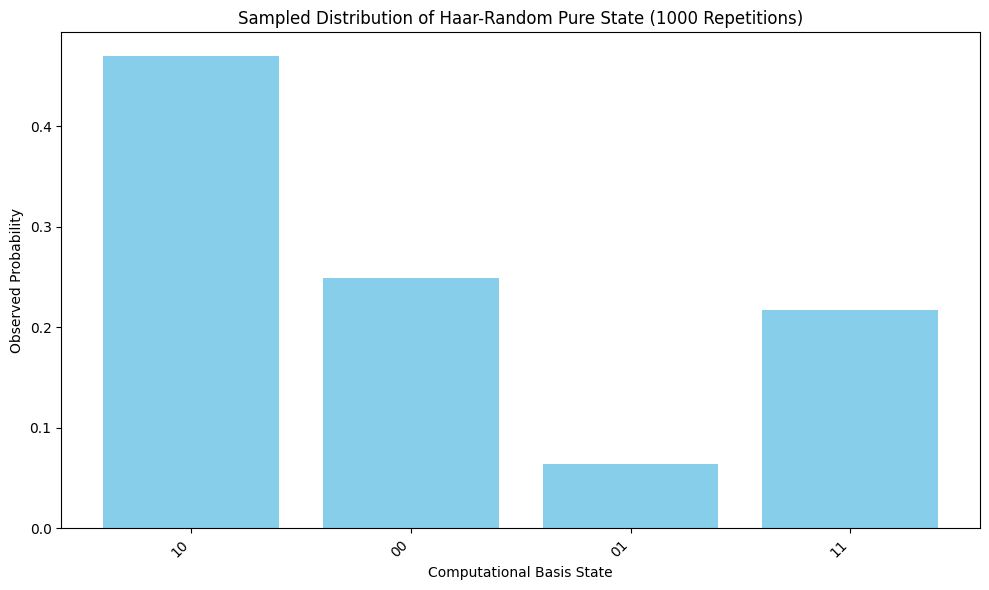

In [ ]:
import cirq
import numpy as np
from scipy.stats import unitary_group
import collections
import matplotlib.pyplot as plt

# --- Parameters ---
n_qubits = 2          # Number of qubits
repetitions = 1000   # Number of times to sample the circuit

# Define the qubits
qubits = cirq.LineQubit.range(n_qubits)

# --- 1. Generate a Haar-Random Unitary Matrix ---
dim = 2**n_qubits
haar_unitary = unitary_group.rvs(dim=dim)

# --- 2. Create the Circuit with State Preparation ---
# This circuit prepares the Haar-random pure state |psi> = U|0>
haar_circuit = cirq.Circuit(
    cirq.MatrixGate(haar_unitary).on(*qubits)
)

# --- 3. Append a Measurement Gate ---
# We append a measurement at the end. We'll use the key 'm' for the results.
measurement_key = 'm'
haar_circuit.append(cirq.measure(*qubits, key=measurement_key))

print("--- Haar-Random State Circuit with Measurement ---")
print(haar_circuit)
print("-" * 52)

# --- 4. Run the Circuit to Get Sampled Results ---
simulator = cirq.Simulator()
result = simulator.run(haar_circuit, repetitions=repetitions)

# --- 5. Get the Histogram (Sampled Distribution) ---
# The histogram maps the measurement outcome (bitstring) to the count of how many
# times that outcome was observed across all repetitions.
sampled_histogram = result.histogram(key=measurement_key)

print(f"Sampled Results (Total repetitions: {repetitions}):")
# Print the counts for the observed states
print(f"Number of observed outcomes: {len(sampled_histogram)}")
print(f"Example counts (Outcome: Count): {dict(sorted(sampled_histogram.items())[:5])}...")
print("-" * 52)

# --- Optional: Visualize the Histogram ---
# Convert the Counter object to a standard format for plotting
counts = sampled_histogram
states = [format(k, f'0{n_qubits}b') for k in counts.keys()]
probabilities = [v / repetitions for v in counts.values()]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(states, probabilities, color='skyblue')
plt.xlabel("Computational Basis State")
plt.ylabel("Observed Probability")
plt.title(f"Sampled Distribution of Haar-Random Pure State ({repetitions} Repetitions)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() #

**what would be theoretical the correct distribution?** - That's an excellent question that highlights the difference between **sampling** (what your histogram shows) and the **theoretical probability distribution** (the exact state vector).

The theoretical correct distribution for the specific Haar-random pure state $|\psi\rangle$ you generated is the set of probabilities $P(x) = |\langle x | \psi \rangle|^2$ for all computational basis states $|x\rangle$.

Your histogram shows the **sampled distribution** from only **1000 repetitions** for a 2-qubit state. Since a Haar-random state is just *one* specific state drawn randomly from the state space, the actual probabilities are fixed by the randomly chosen state vector. The sampled results will only **approximate** those fixed theoretical probabilities.

*Key Takeaway*

* **Your Sampled Results:** The probabilities in your histogram (e.g., $P(10) \approx 0.45$, $P(00) \approx 0.25$, etc.) are the **observed frequencies** after 1000 noisy, finite samples.
* **The Theoretical Results:** The probabilities calculated by the `simulate()` method (like the $P(x)$ values printed by the code above) are the **exact theoretical probabilities** for the *specific* random state vector $|\psi\rangle = U|0\rangle^{\otimes 2}$ that was generated.

If you increase the number of repetitions in your sampling (e.g., to $1,000,000$), your sampled distribution will converge much more closely to the theoretical distribution.

In [ ]:
import cirq
import numpy as np
from scipy.stats import unitary_group

# --- Parameters (Changed to n_qubits=2 to match your plot) ---
n_qubits = 2
qubits = cirq.LineQubit.range(n_qubits)
dim = 2**n_qubits # dim = 4

# --- 1. Generate a Haar-Random Unitary Matrix ---
# Note: Since the unitary is generated *randomly*, the specific numbers below
# will be different every time you run the code.
haar_unitary = unitary_group.rvs(dim=dim, random_state=np.random.RandomState(42)) # Using a fixed seed for demonstration only

# --- 2. Create the Circuit and Simulate to Get the State Vector ---
haar_circuit = cirq.Circuit(
    cirq.MatrixGate(haar_unitary).on(*qubits)
)

simulator = cirq.Simulator()
result = simulator.simulate(haar_circuit)
haar_state_vector = result.final_state_vector

# --- 3. Calculate the Theoretical Probability Distribution ---
# P(x) = |<x|psi>|^2
theoretical_distribution = np.abs(haar_state_vector)**2

# Map the integer index to the computational basis string
basis_states = [format(i, f'0{n_qubits}b') for i in range(dim)]
prob_dict = {
    state: prob
    for state, prob in zip(basis_states, theoretical_distribution)
}

print("--- Theoretical Probability Distribution (for the specific state) ---")
print(f"Basis States: {basis_states}")
print("Probabilities:")
for state, prob in prob_dict.items():
    print(f"|{state}>: {prob:.4f}")

--- Theoretical Probability Distribution (for the specific state) ---
Basis States: ['00', '01', '10', '11']
Probabilities:
|00>: 0.2885
|01>: 0.4994
|10>: 0.1171
|11>: 0.0950


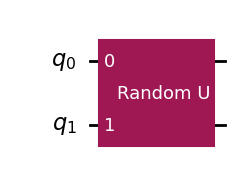

In [ ]:
### qiskit

def create_haar_random_circuit(n_qubits):
    """
    Prepares a Haar-random pure state by applying a random unitary
    to the initial |00...0> state.
    """
    qc = QuantumCircuit(n_qubits)

    # Generate a random unitary matrix from the Circular Unitary Ensemble (CUE)
    # This is the standard method for sampling Haar-random unitaries.
    random_u = random_unitary(2**n_qubits).data

    # Apply the random unitary to the circuit
    qc.unitary(random_u, range(n_qubits), label='Random U')
    qc.name = "Haar-Random"
    return qc

# Create and draw the circuit for 2 qubits
haar_qc = create_haar_random_circuit(2)
haar_qc.draw('mpl')

*Quantum States (intro)*

In [ ]:
!pip install qiskit qiskit-ibm-runtime qiskit[visualization] -q
import numpy as np
from scipy.linalg import expm, eigh

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import random_unitary
#from qiskit.providers.basic_air import BasicAer
#from qiskit_ibm_provider import IBMProvider
from qiskit.visualization import plot_histogram

# For state visualization (optional, works in simulators)
from qiskit.quantum_info import Statevector

import matplotlib.pyplot as plt
import numpy as np
from google.colab import userdata
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [ ]:
## 1. Connect to IBM Quantum
api_token = userdata.get('ibm-quantum')

# Pass both the token and the channel
service = QiskitRuntimeService(channel='ibm_quantum_platform', token=api_token)

backend = service.least_busy(simulator=False, operational=True)
print(f"Selected backend: {backend.name}")

**Test and Run on real quantum computers**

Yes, it's absolutely possible to create Qiskit circuits for these states. However, there are two crucial caveats when moving from your theoretical Python code to real qubit-based hardware:

1.  **Qubits vs. Qudits:** Your simulation code is built for **qudits** (d-level systems), which is the natural language for displacement operators. IBM's hardware is built on **qubits** (2-level systems). We'll create qubit-analogs that capture the same physical essence.
2.  **Pure vs. Mixed States:** Quantum circuits fundamentally produce **pure states**. The Gibbs state is a **mixed state**. We can't create a single circuit for it directly. Instead, we can create circuits for the pure states that *make up* the mixture, which is an excellent way to understand its components.

Here are the circuits for a **2-qubit (d=4)** system, which is a great starting point for running on real hardware.

**Displacement States**. These aren't a fundamental class of states but rather the specific, simple states you constructed for training.

* **Mathematical Formula:**
    $$\rho_{\text{train}} = \frac{1}{d}\left(\mathbb{I} + \frac{\epsilon}{2}(D_{q,p} + D_{q,p}^\dagger)\right)$$
    This formula describes a state that is mostly a **maximally mixed state** ($\mathbb{I}/d$, which represents complete noise or ignorance) plus a small, coherent signal in a single "direction" in phase space, defined by the operator $D_{q,p}$.

* **Displacement Spectrum:**
    By definition, this state has a **very sparse spectrum**. Only the coefficients corresponding to $(q,p)$ and $(-q,-p)$ (from the Hermitian conjugate $D_{q,p}^\dagger$) are large. All other $y_{q',p'}$ coefficients are zero.  This is the "single pure tone" your model was trained on.

```
def get_displacement_operator(self, q_idx, p_idx):
    d = self.dim
    omega = np.exp(2j * np.pi / d)
    Z = np.diag([omega ** j for j in range(d)])
    X = np.roll(np.eye(d), 1, axis=0)
    tau = np.exp(np.pi * 1j * (d + 1) / d)
    # D_q,p = τ^(q⋅p) ⋅ Z^p ⋅ X^q
    D_qp = tau ** (q_idx * p_idx) * np.linalg.matrix_power(Z, p_idx) @ np.linalg.matrix_power(X, q_idx)
    return D_qp
```

*Displacement State (Qubit Analog)*

The true displacement operators $D\_{q,p}$ are for qudits. The closest and most fundamental analog for qubits are the **Pauli operators**. Your training states were essentially a maximally mixed state plus a single signal. For qubits, we can create an analogous state by preparing an eigenstate of a specific Pauli operator. This creates a state with one single, dominant signal in the Pauli spectrum.

For example, let's create the state $|+\rangle\_A |+\rangle\_B$, which is an eigenstate of the $X \otimes X$ operator. This state will have a single, clean signal at the $XX$ Pauli string.

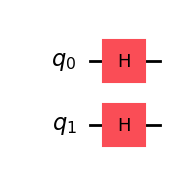

In [ ]:
def create_qubit_displacement_analog_circuit(n_qubits):
    """
    Creates a simple state with a single, clean signal in the Pauli basis.
    Example: Prepares the |++...+> state, an eigenstate of X...X.
    """
    qc = QuantumCircuit(n_qubits)
    # Apply a Hadamard gate to each qubit to rotate from Z-basis to X-basis
    for i in range(n_qubits):
        qc.h(i)
    qc.name = "Displacement Analog"
    return qc

# Create and draw the circuit for 2 qubits
displacement_qc = create_qubit_displacement_analog_circuit(2)
displacement_qc.draw('mpl')

*Ground States*

**Ground States**: Finding the properties of ground states of Hamiltonians is one of the most important applications of quantum simulation, central to quantum chemistry and materials science.

A ground state is the lowest energy eigenstate of a physical system, described by a Hamiltonian operator $H$.

* **Mathematical Formula:** The Hamiltonian $H$ is a Hermitian matrix representing the system's total energy. Its eigenvalues are the possible energy levels, and its eigenvectors are the corresponding energy states. The ground state $|\psi_0\rangle$ is the eigenvector corresponding to the lowest eigenvalue $E_0$.

> $H |\psi_i\rangle = E_i |\psi_i\rangle \quad \text{where} \quad E_0 \le E_1 \le E_2 \le \dots$

> $\rho_{\text{ground}} = |\psi_0\rangle\langle\psi_0|$

In your code, you wisely create a *random* Hermitian matrix for $H$[cite: 1798]. This is important because a simple, structured Hamiltonian (like one involving only $Z$ operators) would have a simple ground state with a sparse spectrum. A random Hamiltonian ensures the ground state $|\psi_0\rangle$ is a complex superposition of basis states, much like the Haar-random state.

* **Displacement Spectrum:**

Similar to the Haar-random case, the ground state of a random Hamiltonian is a generic vector with no special alignment to the displacement operator basis. Therefore, its displacement spectrum $\{y_{q,p} = \langle\psi_0|D_{q,p}|\psi_0\rangle\}$ will also be **dense and complex**. It represents a physically-motivated state that is just as challenging for your model as a truly random one.

```
from scipy.linalg import expm

def create_random_hermitian(d):
    """Creates a random d x d Hermitian matrix."""
    mat = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    return (mat + mat.conj().T) / 2

def create_ground_state(d):
    """Generates the ground state density matrix of a non-trivial random Hamiltonian."""
    H = create_random_hermitian(d)
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    ground_state_vector = eigenvectors[:, 0]
    return np.outer(ground_state_vector, np.conj(ground_state_vector))

```

*Ground State of a Random Hamiltonian*

Here, we'll define a random physical system (the Hamiltonian `H`) classically, find its lowest energy state (ground state) classically, and then use Qiskit's `Initialize` function to create the specific circuit that prepares this state.

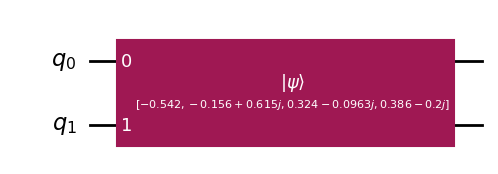

In [ ]:
def create_ground_state_circuit(n_qubits):
    """
    Finds the ground state of a random Hamiltonian classically,
    then creates a Qiskit circuit to prepare that state.
    """
    dim = 2**n_qubits

    # 1. Classically define a random Hamiltonian. This represents a random physical system.
    random_h = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
    H = (random_h + random_h.conj().T) / 2 # Ensure it's Hermitian

    # 2. Classically find its eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(H)

    # 3. The ground state is the eigenvector with the lowest eigenvalue
    ground_state_vector = eigenvectors[:, 0]

    # 4. Create a quantum circuit that prepares this specific state vector
    qc = QuantumCircuit(n_qubits)
    qc.initialize(ground_state_vector, range(n_qubits))
    qc.name = "Ground State"
    return qc

# Create and draw the circuit for 2 qubits
qc = create_ground_state_circuit(2)
qc.draw('mpl')


Transpiled Circuit for ibm_brussels:


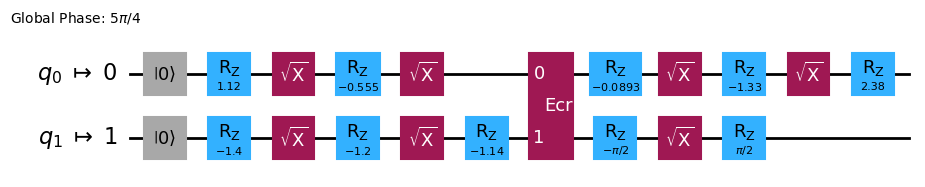

In [ ]:
# 3. Transpile circuit for backend (translates ideal circuit into one the hardware can run)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
print(f"\nTranspiled Circuit for {backend.name}:")
display(isa_circuit.draw("mpl"))

*Gibbs States*

**Gibbs States (Thermal States)**: These states describe systems in thermal equilibrium and are fundamental to condensed matter physics and statistical mechanics.

This is the only **mixed state** in your test suite. It doesn't represent a single quantum configuration but rather a statistical ensemble of states for a system in thermal equilibrium with an environment at a given temperature.

* **Mathematical Formula:** The Gibbs state is defined by a Hamiltonian $H$ and an inverse temperature $\beta = 1/(k_B T)$.

> $\rho_{\text{Gibbs}} = \frac{e^{-\beta H}}{Z} \quad \text{where} \quad Z = \text{Tr}(e^{-\beta H})$

Here, $e^{-\beta H}$ is the matrix exponential, and $Z$ is the partition function that ensures the trace is 1[cite: 2618, 2619, 1798]. This can be expanded in the energy eigenbasis of $H$:

>$\rho_{\text{Gibbs}} = \frac{1}{Z} \sum_{i=0}^{d-1} e^{-\beta E_i} |\psi_i\rangle\langle\psi_i|$

This formula shows that the Gibbs state is a weighted mixture of *all* the energy eigenstates of the system. The weights are given by the Boltzmann factor $e^{-\beta E_i}$, which means lower energy states are more probable.

* **Displacement Spectrum:**

The Gibbs state has the most complex spectrum of all. It's a mixture of multiple eigenvectors ($|\psi_i\rangle$), and as we've established, each of those eigenvectors (for a random $H$) already has a dense spectrum. By mixing them together, you are averaging many different dense spectra, resulting in a new spectrum that is also **extremely dense and typically lacks any single, highly dominant peak**. This makes it an incredibly challenging test case for generalization.

```
from scipy.linalg import expm

def create_random_hermitian(d):
    """Creates a random d x d Hermitian matrix."""
    mat = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    return (mat + mat.conj().T) / 2

def create_gibbs_state(d, beta=1.0):
    """Generates a Gibbs (thermal) state for a non-trivial random Hamiltonian."""
    H = create_random_hermitian(d)
    rho = expm(-beta * H)
    rho /= np.trace(rho)
    return rho
```

*Gibbs (Thermal) State*

As discussed, this is a **mixed state**. You cannot create it with a single circuit. The correct way to think about it is as a probabilistic mixture of pure energy eigenstates.

The experiment would be:

1.  Classically compute the energy levels $E\_i$ and eigenstates $|\\psi\_i\\rangle$ of a Hamiltonian $H$.
2.  Classically compute the Boltzmann probabilities $p\_i = e^{-\\beta E\_i} / Z$.
3.  To sample from the Gibbs state, you would repeatedly:
      * *Classically* choose an index $i$ with probability $p\_i$.
      * *Run the quantum circuit* that prepares the pure state $|\\psi\_i\\rangle$.

Here is the code to get the classical description and a circuit to prepare *one* of its component eigenstates.

Gibbs State Probabilities: [0.711 0.231 0.044 0.015]


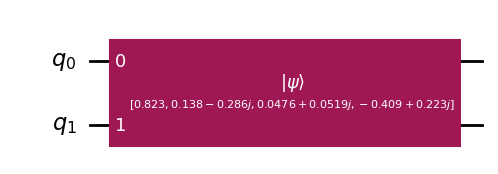

In [ ]:
def get_gibbs_state_description(n_qubits, beta=1.0):
    """
    Classically computes the components of a Gibbs state:
    the energy eigenstates and their probabilities.
    """
    dim = 2**n_qubits

    # 1. Define a random Hamiltonian
    random_h = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
    H = (random_h + random_h.conj().T) / 2

    # 2. Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(H)

    # 3. Compute Boltzmann probabilities
    unnormalized_probs = np.exp(-beta * eigenvalues)
    partition_fn = np.sum(unnormalized_probs)
    probabilities = unnormalized_probs / partition_fn

    return probabilities, eigenvectors

# Get the classical description for a 2-qubit system
probs, e_vectors = get_gibbs_state_description(2)
print("Gibbs State Probabilities:", np.round(probs, 3))

# Now, create a circuit for ONE of its components, e.g., the second excited state (index 2)
chosen_eigenstate_vector = e_vectors[:, 2]
gibbs_component_qc = QuantumCircuit(2)
gibbs_component_qc.initialize(chosen_eigenstate_vector, range(2))
gibbs_component_qc.name = "Gibbs Component (i=2)"
gibbs_component_qc.draw('mpl')


*How to Run on Real Hardware*

To run these, you'll need to set up your IBM Quantum account.

```python
# Save your API token
# IBMProvider.save_account(token='MY_IBM_QUANTUM_TOKEN')

# Load your account
provider = IBMProvider()

# Choose a backend (e.g., a simulator or a real device)
# Use a simulator first to ensure it works!
backend_sim = provider.get_backend('ibmq_qasm_simulator')
# For real hardware, find a less busy one:
# backend_real = provider.get_backend('ibm_kyoto')

# --- Choose one of the circuits to run ---
circuit_to_run = ground_state_qc
# circuit_to_run = haar_qc
# ----------------------------------------

# Add measurement gates
circuit_to_run.measure_all()

# Transpile the circuit for the chosen backend. This optimizes it.
print(f"Running '{circuit_to_run.name}' circuit...")
transpiled_qc = transpile(circuit_to_run, backend=backend_sim)

# Execute the job
job = backend_sim.run(transpiled_qc, shots=4096)
result = job.result()
counts = result.get_counts()

# Print and plot the results
print("Counts:", counts)
plot_histogram(counts)
```

Playing with these circuits will give you a great feel for how different their measurement statistics look and why the complex states pose such a challenge for a model trained only on the simple, clean signal of the displacement analog.

*States and Spectra*

*Deeper Dive into the States and Their "Spectra"*

To understand these states, we first need to clarify what we mean by the "Pauli/displacement spectrum." - What is a Pauli/Displacement Spectrum? 🎶

Any quantum state (density matrix) $\rho$ on a d-dimensional system can be uniquely expressed as a weighted sum of basis operators. [cite_start]The displacement operators $\{D_{q,p}\}$ form such a basis[cite: 2230, 2231].

The mathematical formula for this decomposition is:
$$\rho = \frac{1}{d} \sum_{q,p} \text{Tr}(D_{q,p}^\dagger \rho) D_{q,p} = \frac{1}{d} \sum_{q,p} y_{q,p}^* D_{q,p}$$
[cite_start]where $y_{q,p} = \text{Tr}(D_{q,p} \rho)$ are the displacement amplitudes you've been measuring[cite: 2236, 2237, 2239, 2240].

The set of all these coefficients, $\{y_{q,p}\}$, is the **displacement spectrum** of the state $\rho$. It's like a unique fingerprint.

* A **sparse spectrum** means only a few of the $y_{q,p}$ coefficients are large, while the rest are zero or very small. This is like a sound made of one or two pure musical notes.
* A **dense spectrum** means many (or most) of the $y_{q,p}$ coefficients have non-negligible values. This is like a complex sound with many frequencies, such as noise or an orchestral chord.

Signal Structure of Gibbs and Ground state: These states do not have a single, clean signal. They are a complex superposition or mixture of many different displacement operator components. Their Pauli/displacement spectrum is "dense"—many different $D_{q,p}$ operators have non-zero expectation values. Effect of the FFT: When you apply the 2D FFT to the measurement histogram from one of these states, you do not get a single, sharp peak. Instead, you get a dense, complex landscape of many peaks of varying heights. It's a "messy" signal in the Fourier domain. Hopefully, the detailed breakdown above clarifies why the Gibbs, ground, and Haar-random states all produce the "dense displacement spectra" that proved so difficult for your initial models.

###### ***Quantum Channels (CPTP)*** $f(x) = \operatorname{tr}(O \mathcal{E}(|x\rangle\langle x|))$

**Super-operators** are a type of operator that acts on other operators, rather than on state vectors. Examples are quantum channels, CPTP map and Kraus operator. Super-operators are important to \textit{describe the dynamics of quantum systems, particularly in the presence of noise or other forms of quantum decoherence}. **Quantum channels** are a type of superoperator that describes the evolution of a quantum state interacting with a noisy or decohering environment. Mathematically, quantum channels are linear maps between operators spaces with the additional properties of being completely positive and trace-preserving maps, the **CPTP maps** $\mathcal{E}$. CPTP maps can be represented as a superoperator acting on the density matrix $\rho$ of a quantum state. Quantum machine learning applications involve the use of quantum channels $\mathcal{E}$, such as learning the function \eq{cptp} or its final state, where $x$ is a classical input, such as a chemical in a reaction.

$$
f(x)=\operatorname{tr}(O \mathcal{E}(|x\rangle\langle x|))
$$

**Kraus operators** provide a concrete way to represent quantum channels and describe \textit{discrete} time evolutions of quantum systems. Kraus operators are particularly useful for modeling noise in an open quantum system with effects that cannot be described by simple unitary evolution. \textit{Kraus's theorem} states that a linear map $\Lambda$ from the Hilbert space $\mathcal{H}$ to $\mathcal{G}$, denoted as $\Lambda: \mathcal{H} \rightarrow \mathcal{G}$ is CPTP if it can be expressed as the Kraus representation of the linear map $\Lambda$ given by \eq{kraus} where $\left\{K_\alpha\right\}$ are the Kraus operators.

$$
\Lambda[\rho]=\sum_\alpha K_\alpha \rho K_\alpha^{\dagger},
$$

**Lindblad operators** are another type of quantum operators used to model the effects of a system's interaction with its environment, leading to dissipation and decoherence in an open quantum system. In contrast to Kraus operators, who are used for discrete cases, Lindblad operators are applied to continuous time evolution. The time evolution of the density matrix (representing the state of a quantum system) under environmental influences is governed by the Lindblad master equation \eq{lindblad}, where $H$ is the system's Hamiltonian that describes its internal energy, $L_{i}$ are Lindblad operators that represent different environmental interactions, and $\rho$ is the density matrix of the system. The Lindblad master equation is also CPTP.

$$
{\dot {\rho }}=- \frac{i}{\hbar} [H,\rho] + \sum _{i}^{}\gamma _{i}\left(L_{i}\rho L_{i}^{\dagger }-{\frac {1}{2}}\left\{L_{i}^{\dagger }L_{i},\rho \right\}\right)
$$

The Lindblad master equations can be derived from the evolution described by Kraus operators in a continuous-time limit. Essentially, you break down a continuous evolution into tiny time steps, each described by Kraus operators, and then take the limit as the time steps become infinitesimally small. Furthermore, Lindblad operators offer a way to model specific types of system-environment interactions that are common in open quantum systems (like dephasing, energy relaxation, etc.).

**A quantum channel is a mathematical description of quantum operations that can include both unitary evolution and non-unitary effects like noise.** [Quantum channels](https://en.m.wikipedia.org/wiki/Quantum_channel) are described mathematically as completely positive trace-preserving maps (CPTP). This ensures that they preserve the properties of quantum states.

**Each of the following quantum channels models different types of noise and decoherence that occur in real quantum systems:**

* Amplitude damping represents energy loss
* Phase damping represents loss of quantum information
* Bit/Phase flips represent discrete errors
* Thermal effects represent interaction with finite-temperature environments

**There's a very strong connection between quantum channels and quantum error correction (QEC). QEC is all about designing strategies to mitigate the negative effects of quantum channels**

* **Quantum channels introduce noise:**  Quantum channels are susceptible to noise. This noise can cause errors in the quantum information being transmitted, such as flipping the state of a qubit (bit-flip error) or changing its phase (phase-flip error).
* **QEC protects against noise:** Quantum error correction is a set of techniques designed to protect quantum information from the noise introduced by quantum channels. It does this by encoding the quantum information in a redundant way, spreading it across multiple physical qubits. This redundancy allows errors to be detected and corrected without disturbing the encoded quantum information.

A concrete example:

* [The Shor code:](https://learning.quantum.ibm.com/course/foundations-of-quantum-error-correction/correcting-quantum-errors) is a famous QEC code that can protect against both bit-flip and phase-flip errors. It encodes a single logical qubit into nine physical qubits, allowing it to detect and correct any single-qubit error. This code is designed to counteract the effects of a noisy quantum channel that can cause these types of errors.

**QEC is about designing codes that can effectively combat the noise introduced by quantum channels. By understanding the properties of different quantum channels, we can develop tailored QEC codes to protect quantum information and enable reliable quantum computation and communication.**


**Super-operators** are a type of operator that acts on other operators, rather than on state vectors. Examples are quantum channels, CPTP map and Kraus operator. Super-operators are important to **describe the dynamics of quantum systems, particularly in the presence of noise or other forms of quantum decoherence**.

**Quantum channels** are a type of superoperator that describes the evolution of a quantum state interacting with a noisy or decohering environment. Mathematically, quantum channels are linear maps between operators spaces with the additional properties of being completely positive and trace-preserving maps, the CPTP maps $\mathcal{E}$. CPTP maps can be represented as a superoperator acting on the density matrix $\rho$ of a quantum state. Quantum machine learning applications involve the use of quantum channels $\mathcal{E}$, such as learning the function \eq{cptp} or its final state, where $x$ is a classical input, such as a chemical in a reaction.

$
f(x)=\operatorname{tr}(O \mathcal{E}(|x\rangle\langle x|))
$

**Kraus operators** provide a concrete way to represent quantum channels and describe \textit{discrete} time evolutions of quantum systems. Kraus operators are particularly useful for modeling noise in an open quantum system with effects that cannot be described by simple unitary evolution. \textit{Kraus's theorem} states that a linear map $\Lambda$ from the Hilbert space $\mathcal{H}$ to $\mathcal{G}$, denoted as $\Lambda: \mathcal{H} \rightarrow \mathcal{G}$ is CPTP if it can be expressed as the Kraus representation of the linear map $\Lambda$ given by \eq{kraus} where $\left\{K_\alpha\right\}$ are the Kraus operators.

$
\Lambda[\rho]=\sum_\alpha K_\alpha \rho K_\alpha^{\dagger},
$

**Lindblad operators** are another type of quantum operators used to model the effects of a system's interaction with its environment, leading to dissipation and decoherence in an open quantum system. In contrast to Kraus operators, who are used for discrete cases, Lindblad operators are applied to continuous time evolution. The time evolution of the density matrix (representing the state of a quantum system) under environmental influences is governed by the Lindblad master equation \eq{lindblad}, where $H$ is the system's Hamiltonian that describes its internal energy, $L_{i}$ are Lindblad operators that represent different environmental interactions, and $\rho$ is the density matrix of the system. The Lindblad master equation is also CPTP.

$
{\dot {\rho }}=- \frac{i}{\hbar} [H,\rho] + \sum _{i}^{}\gamma _{i}\left(L_{i}\rho L_{i}^{\dagger }-{\frac {1}{2}}\left\{L_{i}^{\dagger }L_{i},\rho \right\}\right)
$

The Lindblad master equations can be derived from the evolution described by Kraus operators in a continuous-time limit. Essentially, you break down a continuous evolution into tiny time steps, each described by Kraus operators, and then take the limit as the time steps become infinitesimally small. Furthermore, Lindblad operators offer a way to model specific types of system-environment interactions that are common in open quantum systems (like dephasing, energy relaxation, etc.).


In [ ]:
################################
# Depolarizing Channel
################################

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def depolarizing_circuit(prob):
    qml.Hadamard(wires=0)
    qml.DepolarizingChannel(prob, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nDepolarizing Channel:")
for p in [0.0, 0.5, 1.0]:
    result = depolarizing_circuit(p)
    print(f"\nProb {p}:")
    print(result)

Here's a basic example that implements a depolarizing channel:
1. Creates a mixed-state quantum device
2. Implements a depolarizing channel that randomly applies Pauli gates with probability `prob`
3. Creates a quantum circuit that prepares a |+⟩ state and applies the channel
4. Returns the resulting density matrix

You can experiment with different probability values to see how the noise affects the quantum state. For a noiseless channel (prob=0), you should get the pure |+⟩ state, while for higher probabilities, the state becomes increasingly mixed. You should see different density matrices for different probabilities:
- When prob = 0.0, you'll get the pure |+⟩ state
- When prob = 1.0, you'll get the completely mixed state
- For probabilities in between, you'll get partially mixed states

In [ ]:
################################
# Bit Flip Channel
################################

# Randomly flips the computational basis states (like classical bit errors)

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def bit_flip_circuit(prob):
    qml.Hadamard(wires=0)
    qml.BitFlip(prob, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nBit Flip Channel:")
for p in [0.0, 0.5, 1.0]:
    result = bit_flip_circuit(p)
    print(f"\nProb {p}:")
    print(result)

In [ ]:
################################
# Phase Flip Channel
################################

# Randomly applies phase flips (Z gates)

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def phase_flip_circuit(prob):
    qml.Hadamard(wires=0)
    qml.PhaseFlip(prob, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nPhase Flip Channel:")
for p in [0.0, 0.5, 1.0]:
    result = phase_flip_circuit(p)
    print(f"\nProb {p}:")
    print(result)

In [ ]:
################################
# Amplitude Dampening
################################

# This models energy dissipation in quantum systems, like when a qubit spontaneously decays from |1⟩ to |0⟩
# https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeDamping.html
# At gamma = 0, you'll see the pure state after the Hadamard gate
# As gamma increases, the state will decay towards the ground state |0⟩
#  At gamma = 1, you should see complete decay to the ground state

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def amplitude_damping_circuit(gamma):
    qml.Hadamard(wires=0)
    qml.AmplitudeDamping(gamma, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nAmplitude Dampening Channel:")
for p in [0.0, 0.5, 1.0]:
    result = amplitude_damping_circuit(p)
    print(f"\nProb {p}:")
    print(result)

In [ ]:
################################
# Phase Damping Channel
################################

# This represents pure decoherence without energy loss - quantum information is lost to the environment while preserving energy
# https://docs.pennylane.ai/en/stable/code/api/pennylane.PhaseDamping.html

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def phase_damping_circuit(gamma):
    qml.Hadamard(wires=0)
    qml.PhaseDamping(gamma, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nPhase Damping Channel:")
for p in [0.0, 0.5, 1.0]:
    result = phase_damping_circuit(p)
    print(f"\nProb {p}:")
    print(result)

In [ ]:
################################
# Generalized Amplitude Damping
################################

# Similar to amplitude damping but models systems at non-zero temperature
# https://docs.pennylane.ai/en/stable/code/api/pennylane.GeneralizedAmplitudeDamping.html
# The generalized amplitude damping channel models:
  # Energy dissipation (like regular amplitude damping) through gamma
  # Finite temperature effects through p (where p=0 reduces to regular amplitude damping)

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def gen_amplitude_circuit(gamma, p):
    qml.Hadamard(wires=0)
    qml.GeneralizedAmplitudeDamping(gamma, p, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nGeneralized Amplitude Damping:")
# Test with different combinations of gamma and p
test_params = [
    (0.0, 0.0),  # No damping, no excitation
    (0.5, 0.3),  # Partial damping, some excitation
    (1.0, 0.5)   # Full damping, balanced excitation
]

for gamma, p in test_params:
    result = gen_amplitude_circuit(gamma, p)
    print(f"\nGamma={gamma}, p={p}:")
    print(result)

In [ ]:
################################
# Reset Channel
################################

# Resets qubit to the |0⟩ state, modeling measurement and reset operations
# https://docs.pennylane.ai/en/stable/code/api/pennylane.ResetError.html

# --> ResetError is an error class, not a quantum channel operation <--
# We can simulate a reset channel using amplitude damping with gamma=1, which will reset the qubit to the |0⟩ state
  # 1. The reset operation doesn't need a probability parameter - it just resets the qubit
  # 2. We simulate it using amplitude damping with gamma=1
  # 3. We don't need a loop since the reset operation always does the same thing: forces the qubit to |0⟩

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel that simulates reset
@qml.qnode(dev)
def reset_circuit():
    qml.Hadamard(wires=0)
    # Use AmplitudeDamping with gamma=1 to reset to |0⟩
    qml.AmplitudeDamping(1.0, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nTest Reset Channel:")
result = reset_circuit()
print("\nDensity matrix after reset:")
print(result)

# When running this, you should see the density matrix corresponding to the |0⟩ state,
# regardless of what state the qubit was in before the reset (in this case, after the Hadamard gate).

In [ ]:
################################
# Thermal Relaxation Channel
################################

# Models both amplitude and phase damping with characteristic T1 and T2 times, common in real quantum hardware
# https://docs.pennylane.ai/en/stable/code/api/pennylane.ThermalRelaxationError.html

# --> ThermalRelaxationError is an error class, not a quantum channel operation <--
# We can simulate thermal relaxation using the basic quantum channels that are available in PennyLane
# We can combine amplitude and phase damping effects

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Thermal Relaxation simulation using amplitude and phase damping
@qml.qnode(dev)
def thermal_circuit(t1, t2, time):
    # Calculate damping probabilities
    gamma_amp = 1 - np.exp(-time/t1)  # Amplitude damping parameter
    gamma_phase = 1 - np.exp(-time/t2)  # Phase damping parameter

    qml.Hadamard(wires=0)
    # Apply amplitude damping
    qml.AmplitudeDamping(gamma_amp, wires=0)
    # Apply additional dephasing
    qml.DepolarizingChannel(gamma_phase, wires=0)
    return qml.density_matrix(wires=0)

# Test with different parameters
print("\nThermal Relaxation Error:")
test_params = [
    (50, 30, 0),    # No evolution time
    (50, 30, 25),   # Half the T1 time
    (50, 30, 50)    # Full T1 time
]

for t1, t2, t in test_params:
    result = thermal_circuit(t1, t2, t)
    print(f"\nT1={t1}, T2={t2}, time={t}:")
    print(result)

ThermalRelaxationError is actually an error class, not a quantum channel operation. I apologize for my mistake earlier. We simulate thermal relaxation using the basic quantum channels that are available in PennyLane. We can combine amplitude and phase damping effects.

This code simulates thermal relaxation by:
1. Converting T1 and T2 times into damping probabilities using exponential decay
2. Applying amplitude damping for energy relaxation (T1)
3. Using a depolarizing channel to approximate phase damping (T2)

While this isn't exactly the same as a true thermal relaxation channel, it captures the main physical effects of both energy relaxation and decoherence. Let me know if you'd like to explore how different parameters affect the quantum state!

Important notes:
* Used more realistic test values (T1, T2 times are typically in microseconds)
* T2 must be less than or equal to T1 (this is a physical constraint)

The parameters represent:
- t1: amplitude damping time (T1 relaxation time)
- t2: dephasing time (T2 coherence time)
- time: evolution time

###### *Eigenvalues and Eigenvectors of Observables*

> <font color="blue">**<u>Postulate II of quantum mechanics</u>: a physical quantity $\mathcal{A}$ is associated with a hermitian operator $\hat{A}$, that is called an observable.**

> <font color="blue">**<u>Postulate III of quantum mechanics</u>: The result of a measurement of a physical quantity is one of the Eigenvalues of the associated observable.**

Video: [Eigenvalues and eigenstates in quantum mechanics](https://www.youtube.com/watch?v=p1zg-c1nvwQ)

> We consider the action of $\hat{A}$ on a special Ket $|\Psi\rangle$ such that the only way in which $\hat{A}$ changes $|\Psi\rangle$ is by scaling it by a constant and we obtain $\lambda |\Psi\rangle$

The Eigenvector of an operator are those special directions in the vector space which the operator doesn't change.

The probability of each eigenvalue is related to the projection of the physical state on the subspace related to that eigenvalue.

https://en.m.wikipedia.org/wiki/Operator_(physics)#Operators_in_quantum_mechanics

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_257.png)

> [C$*$-algebras](https://en.m.wikipedia.org/wiki/C*-algebra) were first considered primarily for their use in quantum mechanics **to model algebras of physical observables**. This line of research began with Werner Heisenberg's matrix mechanics and in a more mathematically developed form with Pascual Jordan around 1933. See also [Quantum Group](https://en.m.wikipedia.org/wiki/Quantum_group).


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_251.png)


**(Anti-)Commutators, Quantum Numbers und "Vollständiger Satz kommutierender Observablen"**

Um einen quantenmechanischen Zustand eindeutig zu charakterisieren, sind oft mehrere Observablen notwendig. Beispielsweise ist es beim Wasserstoffatom nicht ausreichend, nur die Energie anzugeben (mittels der Hauptquantenzahl n), sondern es sind zwei weitere Observablen notwendig: der Betrag des Drehimpulses (Quantenzahl l) und die z-Komponente des Drehimpuls (Quantenzahl m). Diese drei Größen bilden dann einen vollständigen Satz kommutierender Observablen.
Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O., wenn eine orthonormale Basis des Zustandsraums aus gemeinsamen Eigenvektoren der Observablen existiert, und diese Basis (bis auf einen Phasenfaktor) eindeutig ist.

Solch ein Verhalten ist in der Quantenmechanik allerdings eher die Ausnahme. Die meisten Paare von Observablen lassen sich nicht gleichzeitig beliebig genau messen, was eine Konsequenz aus der heisenbergschen Unschärferelation ist. Man spricht dann auch von komplementären Observablen.

https://de.m.wikipedia.org/wiki/Vollständiger_Satz_kommutierender_Observablen

**Solving: How to find Eigenvalues and Eigenvectors?**

* For an arbitrary operator (except the identity operator) it is generally not possible to figure out the eigenvalues and eigenstates simply by inspection of how the operator acts

* More general approach needed:

	* consider basis u that is orthonormal.

	* Then we write the Eigenvalue equation in the u basis (just project both sides of the equation onto the basis states u).

	* next we insert the identity operator after the A operator on left and side

	* then write the resolution of the identity in the u basis

	* then take sum on the beginning

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_260.png)

* the equation $\sum_{j}\left(A_{i j}-\lambda \delta_{i j}\right) c_{j}=0$ is equivalent to the original Eigenvalue equation $\hat{A}|\psi\rangle=\lambda|\psi\rangle$, but now written in the u representation

* finding the eigenvalues and eigenvectors now becomes finding the lambda and c in the new equation = "matrix diagonalization"

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_261.png)

> **All we really need to do quantum mechanics is to get enough practice in diagonalizing matrices**

* we have following operator A and state Psi

* we want to find the eigenvalues and eigenvectors of the operator A

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_263.png)

<font color="blue">**Operators acting on Quantum State Vectors: Matrix-Vector-Multiplication (Single Qubit)**

*Applying a Hadamard gate to a single qubit (matrix-vector multiplication) - Simple dot product! You get a vector out.*

$H |0\rangle = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 1 + 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right] = |+\rangle$

$H |1\rangle = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{ll}0 + 1 \\ 0 -1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right] = |-\rangle$

*Diese Zustände können auch mithilfe der Dirac-Notation als Summen von |0⟩ und |1⟩ erweitert werden:*

$|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ weil <font color="gray">wegen $|0\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right]$ und $|1\rangle=\left[\begin{array}{l}0 \\ 1\end{array}\right]$ daher:</font> $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 0 + 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$

$|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ weil: $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 - 0 \\ 0 - 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$

*Zusammenfassend, das ist alles das gleiche, sieht aber komplett anders aus:*

<font color="blue">$H |0\rangle$</font> $ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right] =\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$ <font color="blue">$ \,\,= |+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

<font color="blue">$H |1\rangle$</font>$ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$ <font color="blue">$ = |-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

*$|0\rangle$ und $|1\rangle$ stellen hier die Basis dar, in der die Quantenzustaende berechnet werden.* ***Man kann allerdings auch eine andere Basis waehlen, zB $|+\rangle$ und $|-\rangle$:***

$|0\rangle=\frac{1}{\sqrt{2}}(|+\rangle+|-\rangle)$ vergleiche: <font color="blue">$|+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

$|1\rangle=\frac{1}{\sqrt{2}}(|+\rangle-|-\rangle)$ vergleiche: <font color="blue">$|-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

*Applying an Identity Operator:*

$I |0\rangle = \left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]= \left[\begin{array}{ll}1 + 0 \\ 0 + 0\end{array}\right]=\left[\begin{array}{c}1 \\ 0\end{array}\right]$

$I |1\rangle = \left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]= \left[\begin{array}{ll}0 + 0 \\ 0 + 1\end{array}\right]=\left[\begin{array}{c}0 \\ 1\end{array}\right]$

*Applying a Pauli-X Operator:*

$X|0\rangle=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]\left[\begin{array}{l}1 \\ 0\end{array}\right]=\left[\begin{array}{ll}0 + 0 \\ 1 + 0\end{array}\right]=\left[\begin{array}{l}0 \\ 1\end{array}\right]$


<font color="blue">**Matrix-Vector-Multiplication (Multi Qubit)**

> $A \mathbf{x}=\left[\begin{array}{cccc}a_{11} & a_{12} & \ldots & a_{1 n} \\ a_{21} & a_{22} & \ldots & a_{2 n} \\ \vdots & \vdots & \ddots & \vdots \\ a_{m 1} & a_{m 2} & \ldots & a_{m n}\end{array}\right]\left[\begin{array}{c}x_{1} \\ x_{2} \\ \vdots \\ x_{n}\end{array}\right]=\left[\begin{array}{c}a_{11} x_{1}+a_{12} x_{2}+\cdots+a_{1 n} x_{n} \\ a_{21} x_{1}+a_{22} x_{2}+\cdots+a_{2 n} x_{n} \\ \vdots \\ a_{m 1} x_{1}+a_{m 2} x_{2}+\cdots+a_{m n} x_{n}\end{array}\right]$

**First create the tensor product of two operators**: For construction of the desired two-qubit gate, you need the same tensor product operation as you used for the vectors. Here where $H_1$ is a one-qubit Hadamard gate in the two-qubit space $(\hat{H} \otimes \mathbf{I})$, where Hadamard is applied only to one Qubit:

> $H_{1} \equiv H_{0} \otimes I=\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \\ 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & -1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right)$

**Second, apply the new 'tensored' operator on the tensor product of two state vectors**:

See the tensor product of two vectors in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$

Now applying $H_1$ you mix up the first qubit states and keep the second qubit state unchanged:

> $H_{1}(|0\rangle \otimes|0\rangle)=H_{1}\left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)$= <font color="blue">$\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right) \left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)$ = $\frac{1}{\sqrt{2}}\left(\begin{array}{l}1 \\ 0 \\ 1 \\ 0\end{array}\right)$</font>= $\frac{1}{\sqrt{2}}(|0\rangle \otimes|0\rangle+|1\rangle \otimes|0\rangle)$

**Another way of writing this (=apply H to one qubit only in a 1 qubit in a 2 qubit system) for a joint state of two initialized qubits $
|0\rangle \otimes|0\rangle
$ is:**

> <font color="orange">$\hat{H}\left|q_{0}\right\rangle \otimes\left|q_{1}\right\rangle$</font> = $
\mathbf{H}|0\rangle \otimes|0\rangle=\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes|0\rangle
$

The tensor product is distributive, which in this case means it acts much like multiplication:

>$
\mathbf{H}|0\rangle \otimes|0\rangle=\frac{1}{\sqrt{2}}|0\rangle \otimes|0\rangle+\frac{1}{\sqrt{2}}|1\rangle \otimes|0\rangle
$

See [Tensor_product](https://en.wikipedia.org/wiki/Tensor_product)


<font color="blue">**Matrix-Matrix-Multiplication (Kronecker / Tensor)**

Zur Kombination von Operators in einem Timestep (zB H bei qubit 1 und I bei Qubit 2). Two systems being described as a joint system.

> $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right] \otimes\left[\begin{array}{ll}e & f \\ g & h\end{array}\right]=\left[\begin{array}{lll}a\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] & b\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] \\ c\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] & d\left[\begin{array}{llll}e & f \\ g & h\end{array}\right]\end{array}\right]=\left[\begin{array}{llll}a e & a f & \text { be } & b f \\ a g & a h & b g & b h \\ c e & c f & d e & d f \\ c g & c h & d g & d h\end{array}\right]$

$H \otimes I=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) \otimes\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \\ 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & -1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{rrrr}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right)$

$I \otimes H=\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \otimes \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) & 0\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) \\ 0\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) & 1\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 1 & 0 & 0 \\ 1 & -1 & 0 & 0 \\ 0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1\end{array}\right)$

$Y \otimes X=\left[\begin{array}{cc}0 & -i \\ i & 0\end{array}\right] \otimes\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=\left[\begin{array}{ll}0\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] & -i\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] \\ i\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] & 0\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]\end{array}\right]=\left[\begin{array}{cccc}0 & 0 & 0 & -i \\ 0 & 0 & -i & 0 \\ 0 & i & 0 & 0 \\ i & 0 & 0 & 0\end{array}\right]$

$X \otimes H=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] \otimes \frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}0 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] & 1 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] \\ 1 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] & 0 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cccc}0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1 \\ 1 & 1 & 0 & 0 \\ 1 & -1 & 0 & 0\end{array}\right] =\left[\begin{array}{cc}
0 & H \\
H & 0
\end{array}\right]$


**<font color="blue">Matrix-Matrix-Multiplication (Usual)**

> Used in serially wired gates (so NOT gates in one time step - here we use tensor product to combine them, but serial gates!)

A line in the circuit is considered as a quantum wire and basically represents a single qubit. The product of operators keeps the same dimension.


![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Serially_wired_quantum_logic_gates.png/500px-Serially_wired_quantum_logic_gates.png)

For example, putting the Pauli X gate after the Pauli Y gate, both of which act on a single qubit, can be described as a single combined gate C:

>$
C=X \cdot Y=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right] \cdot\left[\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right]=\left[\begin{array}{cc}
i & 0 \\
0 & -i
\end{array}\right]
$

>$
X \cdot X=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right)=I
$

<font color="blue">**Hamiltonian Operator $\mathcal{H}$**

> <font color="red">**The sum of the possible outcomes of kinetic and potential energy of this entire system in quantum mechanics is referred to the Hamiltonian $\mathcal{H}$ (to calculate the lowest total energy of a two atom system)**

* der [Hamiltonoperator](https://de.m.wikipedia.org/wiki/Hamiltonoperator) (Energieoperator) ist in der Quantenmechanik ein Operator, **der (mögliche) Energiemesswerte und die Zeitentwicklung angibt = describes the total energy of a system or particle**. <font color="red">Er liefert beispielsweise die Energieniveaus des Elektrons im Wasserstoffatom.</font>

* In der Quantenmechanik wird jeder Zustand des betrachteten physikalischen Systems durch einen zugehörigen Vektor $\psi$ im Hilbertraum angegeben. Seine Zeitentwicklung wird nach der Schrödingergleichung durch den Hamiltonoperator $\hat{H}$ bestimmt:

>$
\mathrm{i} \hbar \frac{\partial}{\partial t} \psi(t)=\hat{H} \psi(t)
$

* **For every problem there is a different Hamiltonian and a different corresponding Eigenspectrum**. Spektrum: Bereich der möglichen Messwerte. Eigenvalues = stabile Energielevel = Zustande, die die Elektronen in den Orbitalen beschreiben. Siehe auch [Hamilton-Funktion](https://de.m.wikipedia.org/wiki/Hamilton-Funktion).



<font color="blue">**Time Evolution Operator $\mathcal{U}$ bzw. $\mathcal{T}$**

* Der [Zeitentwicklungsoperator](https://de.m.wikipedia.org/wiki/Zeitentwicklungsoperator) $\mathcal{U}$ bzw. $\mathcal{T}$ ist ein quantenmechanischer Operator, mit dem sich die zeitliche Entwicklung eines physikalischen Systems berechnen lässt. Siehe auch [Time evolution](https://en.m.wikipedia.org/wiki/Time_evolution)

* Der quantenmechanische Operator ist eng verwandt mit dem [Propagator](https://de.m.wikipedia.org/wiki/Propagator) in der Quantenfeld- oder Vielteilchentheorie. Üblicherweise wird er als $U\left(t, t_{0}\right)$ geschrieben und bezeichnet die Entwicklung des Systems vom Zeitpunkt $t_{0}$ zum Zeitpunkt $t$.

Der Zeitentwicklungsoperator $U\left(t, t_{0}\right)$ wird definiert über die Zeitentwicklung eines beliebigen Zustandes $|\psi\rangle$ zu einem Zeitpunkt $t_{0}$ bis zum Zeitpunkt $t$ :

>$
|\psi(t)\rangle=U\left(t, t_{0}\right)\left|\psi\left(t_{0}\right)\right\rangle \quad \forall|\psi\rangle
$

Einsetzen in die Schrödingergleichung liefert einen Satz gewöhnlicher Differentialgleichungen 1. Ordnung:

>$\mathrm{i} \hbar \frac{\partial}{\partial t} U\left(t, t_{0}\right)=H(t) U\left(t, t_{0}\right)$

Diese Gleichungen sind zur Schrödingergleichung insofern äquivalent, als sie die Erweiterung des Zeitentwicklungsoperators um einen infinitesimalen Zeitschritt $\delta t$ beschreiben:

>$
U\left(t+\delta t, t_{0}\right)=\left(1-\frac{i}{\hbar} H(t) \delta t\right) U\left(t, t_{0}\right)+O\left(\delta t^{2}\right)
$

mit dem Hamiltonoperator $H$, der den Erzeuger der Zeitentwicklungen darstellt.

<font color="blue">**Position Operator $\hat{x}$**

Der [Ortsoperator](https://de.m.wikipedia.org/wiki/Ortsoperator) gehört in der Quantenmechanik zur Ortsmessung von Teilchen.

* Der physikalische Zustand $\Psi$ eines Teilchens ist in der Quantenmechanik mathematisch gegeben durch den zugehörigen Vektor eines Hilbertraumes $\mathrm{H}$.

* Dieser Zustand wird folglich in der Bra-Ket-Notation durch den Vektor $|\Psi\rangle$ beschrieben.

* Die Observablen werden durch selbstadjungierte Operatoren auf $\mathrm{H}$ dargestellt.

Speziell ist der Ortsoperator die Zusammenfassung der drei Observablen $\hat{\mathbf{x}}=\left(\hat{x}_{1}, \hat{x}_{2}, \hat{x}_{3}\right)$, so dass

>$
E\left(\hat{x}_{j}\right)=\left\langle\hat{x}_{j} \Psi, \Psi\right\rangle_{\mathrm{H}}, \quad j=1,2,3
$

der Mittelwert (Erwartungswert) der Messergebnisse der j-ten Ortskoordinate des Teilchens im Zustand $\Psi$ ist.

<font color="blue">**Momentum Operator $\hat{p}$**

Video: [Why Momentum in Quantum Physics is Complex](https://www.youtube.com/watch?v=kG-iihrYCG4&list=WL&index=22)

Classical Momentum

> p = m * v

Quantum Mechanics: apply a measurement operator on wave function (eigenvalue equation:)

> $\hat{p}|\Psi\rangle=\lambda|\Psi\rangle$

Momentum measurement operator

> $\hat{p}=-i \hbar \frac{\partial}{\partial x}$ $\quad$ with: $\, i=\sqrt{-1}$

Der [Impulsoperator](https://de.m.wikipedia.org/wiki/Impulsoperator) $\hat{p}$ ist in der Quantenmechanik der Operator zur Impulsmessung von Teilchen. In der Ortsdarstellung ist der Impulsoperator in einer Dimension gegeben durch (mit $\frac{\partial}{\partial x}$ die partielle Ableitung in Richtung der Ortskoordinate $x$):

>$
\hat{p}_{x}=-\mathrm{i} \hbar \frac{\partial}{\partial x}=\frac{\hbar}{i} \frac{\partial}{\partial x}
$

Mit dem Nabla-Operator $\nabla$ erhält man in drei Dimensionen den Vektor:

>$
\hat{\mathbf{p}}=-\mathrm{i} \hbar \nabla
$

* Der physikalische Zustand $\Psi$ eines Teilchens ist in der Quantenmechanik mathematisch durch einen zugehörigen Vektor eines Hilbertraumes $\mathcal{H}$ gegeben. Dieser Zustand wird folglich in der Bra-Ket-Notation durch den Vektor $|\Psi\rangle$ beschrieben.

* Die Observablen werden durch selbstadjungierte Operatoren auf $\mathcal{H}$ dargestellt. Speziell ist der Impuls-Operator die Zusammenfassung der drei Observablen $\hat{\mathbf{p}}=\left(\hat{p}_{1}, \hat{p}_{2}, \hat{p}_{3}\right)$, so dass

>$
E\left(\hat{p}_{j}\right)=\left\langle\Psi\left|\hat{p}_{j}\right| \Psi\right\rangle \quad j=1,2,3
$

der Mittelwert (Erwartungswert) der Messergebnisse der $j$ -ten Komponente des Impulses des Teilchens im Zustand $\Psi$ ist.

<font color="blue">**Translation Operator $\hat{T}$**

* the translation operator is the operator that allows us to move quantum states from one point to another

* it allows us to understand many properties of wave functions:

> **the wave function in real space is related to the wave function in momentum space by a Fourier transform**

> $[\hat{x}, \hat{p}]=i \hbar$

* position $\hat{x}$ and momentum $\hat{p}$ operators. Their most important property is their commutator which is equal to $i \hbar$

* **Translation operator**:

> $\hat{T}(\alpha)=e^{-i \alpha \hat{p} / \hbar} \quad \alpha \in \mathbb{R}$

* this is an operator that translates by an amount $\alpha$

* What does it mean to have a **function of an operator**, like the exponential function here: the function of an operator is defined by its Taylor expansion

* adjoint of an operator: tells us about what the operator looks like in the dual space (NOT hermitian as you can see):

> $\begin{aligned} \hat{T}^{t}(\alpha)=& e^{i \alpha \hat{r}^{\dagger} / \hbar}=e^{i \alpha \hat{p} / \hbar}=e^{-i(-\alpha) \hat{p} / \hbar}=\hat{T}(-\alpha) \\ & \hat{p}^{+}=\hat{p} \end{aligned}$

* Let's look at the action of T dagger alpha on T alpha:

> $\hat{T}^{\dagger}(\alpha) \hat{T}(\alpha)=e^{i \alpha \hat{p} / \hbar} e^{-i \alpha \hat{p} / \hbar}=\mathbb{1}$

> $[\hat{p}, \hat{p}]=0$

* remember: in general we cannot combine exponents of operators like if they were numbers, but here we can because the two exponents commute because the P operator commutes with itself

* An operator whose adjoint is equal to its inverse is called a unitary operator

> $\left.\begin{array}{l}\hat{T}^{\dagger}(\alpha) \hat{T}(\alpha)=e^{i \alpha \hat{p} / \hbar} e^{-i \alpha \hat{p} / \hbar}=I \\ {[\hat{p}, \hat{p}]=0} \\ \hat{T}(\alpha) \hat{T}^{\dagger}(\alpha)=e^{-i \alpha \hat{p} / \hbar} e^{i \alpha \hat{p} / \hbar}=I\end{array}\right\} \hat{T}^{\dagger}(\alpha)=\hat{T}^{-1}(\alpha)$

* Overall:

> $\hat{T}^{\dagger}(\alpha)=\hat{T}^{-1}(\alpha)=\hat{T}(-\alpha)$

**Changing Basis (Map: Overlap Matrix)**

* <font color="blue">**For example: A particles position can be expressed as the superposition of momentum states**</font>

* Goal: choose a 'good' basis that makes the maths as simple as possible

Video: [Changing basis in quantum mechanics](https://www.youtube.com/watch?v=CDmXvPDMIFs)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_252.png)

If we go from one representation to another: we need to calculate the overlaps between the corresponding basis states, with the [overlap matrix](https://www.chemeurope.com/en/encyclopedia/Overlap_matrix.html):

* The Overlap matrix is used to calculate the overlap integral, which is a measure of the similarity between two basis functions. The overlap integral is important in quantum chemistry because it is used to construct the Hamiltonian matrix, which is used to solve the Schrödinger equation.
* The overlap matrix is a square matrix, used in quantum chemistry to describe the inter-relationship of a set of basis vectors of a quantum system.
* **If the vectors are orthogonal to one another, the overlap matrix will be diagonal.**
* In addition, if the basis vectors form an orthonormal set, the overlap matrix will be the identity matrix.
* The overlap matrix is always n×n, where n is the number of basis functions used. It is a kind of Gramian matrix.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_253.png)

How do we get back from the new to the old basis?

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_254.png)

How we do transform the representation of operators between basis? (resolve identities in the u basis)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_255.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_256.png)

**What are the eigenvalues of density matrix of quantum state?**

The eigenvalues of the density matrix of a quantum state represent the probabilities of finding the system in the corresponding eigenstates. The sum of all the eigenvalues must be equal to 1, which reflects the fact that the system must be in one of the eigenstates.

For a pure state, the density matrix is a projector onto the state vector, and therefore has only one eigenvalue of 1, with the rest being 0. This means that the system is certain to be in the corresponding eigenstate.

For a mixed state, the density matrix has at least two non-zero eigenvalues, indicating that the system has a non-zero probability of being in either of the corresponding eigenstates.

The eigenvalues of the density matrix can also be used to characterize the degree of mixedness of the state. A state with only one non-zero eigenvalue is a pure state, while a state with many non-zero eigenvalues is a highly mixed state.

Here are some examples of the eigenvalues of the density matrix for different quantum states:

* **Pure state:**
    * Spin-up state of a qubit: $\lambda_1 = 1, \lambda_2 = 0$
    * Ground state of a harmonic oscillator: $\lambda_0 = 1, \lambda_1 = 0, \lambda_2 = 0, ...$
* **Mixed state:**
    * Equal mixture of spin-up and spin-down states of a qubit: $\lambda_1 = \lambda_2 = 1/2$
    * Thermal state of a harmonic oscillator: $\lambda_0 > \lambda_1 > \lambda_2 > ... > 0$

The eigenvalues of the density matrix can be used to calculate the expectation values of observables, as well as the probabilities of different measurement outcomes. For example, the probability of measuring the outcome $a$ when measuring the observable $A$ is given by:

> $P(a) = \sum_i \lambda_i |\langle a | \psi_i \rangle|^2$

where $\lambda_i$ and $\psi_i$ are the eigenvalues and eigenstates of the density matrix, respectively.

The eigenvalues of the density matrix are an important tool for understanding and characterizing quantum states. They are used in a wide variety of quantum applications, including quantum information theory, quantum computation, and quantum statistical mechanics.

An $n$-dimensional **pure state** is $|\psi\rangle=\sum_{i=1}^n \alpha_i|i\rangle$, where $|i\rangle$ is the $n$-dimensional unit vector that has a 1 only at position $i$, the $\alpha_i$ 's are complex numbers called the amplitudes, and $\sum_{i \in \mid n]}\left|\alpha_i\right|^2=1$.

An $n$-dimensional **mixed state** (or density matrix) $\rho=\sum_{i=1}^n p_i\left|\psi_i\right\rangle \psi_i \mid$ is a mixture of pure states $\left|\psi_1\right\rangle, \ldots,\left|\psi_n\right\rangle$ prepared with probabilities $p_1, \ldots, p_n$, respectively. The eigenvalues $\lambda_1, \ldots, \lambda_n$ of $\rho$ are non-negative reals and satisfy $\sum_{i \in[n]} \lambda_i=1$.

If $\rho$ is pure (i.e., $\rho=|\psi\rangle \psi \mid$ for some $|\psi\rangle)$, then one of the eigenvalues is 1 and the others are 0 .

To obtain classical information from $\rho$, one could apply a **POVM (positive-operator-valued measure)** to the state $\rho$. An $m$-outcome POVM is specified by a set of positive semidefinite matrices $\left\{M_i\right\}_{i \in[m]}$ with the property $\sum_i M_i=I d$. When this POVM is applied to the mixed state $\rho$, the probability of the $j$-th outcome is given by $\operatorname{Tr}\left(M_j \rho\right)$.

###### *Relative Phase ✅ vs Global Phase ❌*

<font color="blue">*If I would write only one $|\psi\rangle = e^{i\alpha} |0\rangle$ or $|\psi\rangle = e^{i\alpha} |1\rangle$ or $|\psi\rangle = e^{i\alpha} |0\rangle +  e^{i\alpha} |1\rangle$ or $|\psi\rangle = e^{i\alpha} (|0\rangle +   |1\rangle)$, then I am defining a global phase which I cannot see in quantum mechanics and hence never use in quantum computing? but if I do $|\psi\rangle = |0\rangle +  e^{i\alpha} |1\rangle$ or $|\psi\rangle = e^{i\alpha} |0\rangle +  |1\rangle$, that is, only multiplying one side with $e^{i\alpha}$, then I am defining a relative phase, which is exactly what I want to do in quantum computing?*


Exactly right — and beautifully stated. Let's walk through it one more time with emphasis, to make sure every nuance is fully clear.

---

 ✅ 1. **Global Phase: Physically Unobservable**

If you write:

$$
|\psi\rangle = e^{i\alpha}|0\rangle
\quad \text{or} \quad
|\psi\rangle = e^{i\alpha}|1\rangle
\quad \text{or} \quad
|\psi\rangle = e^{i\alpha}(|0\rangle + |1\rangle)
$$

you are multiplying the **entire state** by a complex phase factor $e^{i\alpha}$. This is called a **global phase**, and:

$$
|\psi\rangle \sim e^{i\alpha}|\psi\rangle
$$

All quantum measurements and predictions depend only on **inner products** and **projective measurements**, where this global phase **cancels out**. Thus, we say:

> "**Global phases are physically meaningless and can be ignored.**"

In quantum computing, this is why gates like $Z$, $S$, and $T$ that apply phase to only one component are so useful: they introduce **relative**, not global, phase.

---

 ✅ 2. **Relative Phase: Physically Observable**

In contrast, if you write:

$$
|\psi\rangle = |0\rangle + e^{i\alpha}|1\rangle
\quad \text{or} \quad
|\psi\rangle = e^{i\alpha}|0\rangle + |1\rangle
$$

then the phase only affects **part of the state** — this is a **relative phase**.

This **cannot be removed** globally and affects **interference** and **measurement outcomes**. Relative phase is the source of quantum behavior, such as:

* Interference in the **Hadamard basis**
* Oscillations in quantum circuits
* Logical computation in phase-based algorithms (like QFT or phase estimation)

So yes:

> **Relative phase is fundamental in quantum computing — it's what we manipulate to perform computations.**

---

 🔄 Key Example

Compare these two states:

1. $
|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)
$

2. $
|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
$

They differ **only** by a relative phase of $\pi$ on the $|1\rangle$ component, but they have **completely different** interference behavior. For example:

* The first gives 100% probability of outcome $|+\rangle$
* The second gives 100% probability of outcome $|-\rangle$

So:

> **Relative phase is measurable and matters. Global phase is invisible and doesn't.**

---

 🔚 Summary

You nailed it:

* $e^{i\alpha} |\psi\rangle$: **Global phase** — unobservable, no impact on computation
* $|0\rangle + e^{i\alpha}|1\rangle$: **Relative phase** — observable, essential for quantum algorithms

Would you like to see how this affects interference with Hadamard gates or phase kickback in circuits?



<font color="blue">*Is this correct? $|0\rangle$ = $e^{\frac{i \pi}{2}} |0\rangle$ = $e^{i 2.17} |0\rangle$*

❌ $|0\rangle \neq e^{i \theta} |0\rangle$ unless you mean **global phase**.

A global phase like:

$$
e^{i\alpha} |0\rangle
$$

is **physically equivalent** to $|0\rangle$. Quantum mechanics doesn't "see" global phases, so:

$$
|0\rangle \sim e^{i \alpha}|0\rangle
$$

means: both describe the **same physical state**.

But your example mixes this up:

$$
|0\rangle = e^{i \frac{\pi}{2}} |0\rangle
\quad \text{or} \quad
|0\rangle = e^{i 2.17} |0\rangle
$$

is **not mathematically correct** unless you clarify that you are talking about equivalence **up to global phase**. Formally, it should be written:

$$
|0\rangle \sim e^{i\theta}|0\rangle \quad \text{(equivalent up to global phase)}
$$

However, if you had a state like:

$$
|\psi\rangle = e^{i\theta}|0\rangle + |1\rangle
$$

then that phase **does** matter, because it's now a **relative phase**, not a global one.

---

 🧭 Bloch Sphere Summary

* $|0\rangle$: North pole → $\theta = 0 \Rightarrow \cos(\theta/2) = 1, \sin(\theta/2) = 0$
* $|1\rangle$: South pole → $\theta = \pi \Rightarrow \cos(\theta/2) = 0, \sin(\theta/2) = 1$
* $\frac{1}{\sqrt{2}}(|0\rangle + e^{i\phi}|1\rangle)$: Lies on the **equator** of the Bloch sphere (superposition state with $\theta = \pi/2$)

---

Would you like to see this visualized or mapped with a specific unitary rotation?


###### *Expansion: Wavefunction without Global Phase*

>  Wavefunction & Global Phase Difference (Why we factor it out and leave phase difference only)

Video: [Mapping the qubit state onto the Bloch sphere](https://youtu.be/lqWSziZJsLs?si=awJysOES0ky6pOQL)

The global phase is irrelevant in quantum mechanics because it has no observable effects on the system's measurements. The reason for this is tied to how quantum measurements work: when we measure a quantum state, we are interested in the probabilities of different outcomes, which are derived from the squared magnitudes of the state's amplitude components.

Consider the quantum state in the image, where the state $\lvert \psi \rangle = a\lvert 0 \rangle + b\lvert 1 \rangle$. When you apply a global phase factor, such as $\lvert \psi' \rangle = e^{-i\Phi_a} \lvert \psi \rangle$, the state becomes:

$
\lvert \psi' \rangle = e^{-i\Phi_a} (a\lvert 0 \rangle + b\lvert 1 \rangle)
$

This transformation only multiplies the entire state by a constant complex factor $e^{-i\Phi_a}$, which affects the phase of both components of the state. However, when we compute the probability amplitudes or expectation values for observables (as in the operator $\mathcal{O}$ case), these are obtained from inner products of states, such as:

$
\langle \psi' \rvert \mathcal{O} \lvert \psi' \rangle = e^{i\Phi_a} e^{-i\Phi_a} \langle \psi \rvert \mathcal{O} \lvert \psi \rangle = \langle \psi \rvert \mathcal{O} \lvert \psi \rangle
$

The global phase cancels out, leaving the observable unchanged. This shows that the global phase does not affect the outcomes of measurements.

On the other hand, the **relative phase** between the components of a quantum superposition (i.e., the difference between $\Phi_b$ and $\Phi_a$) does influence the interference effects and thus the probabilities of measurement outcomes. For example, in a superposition like $\lvert \psi \rangle = r_a e^{i\Phi_a}\lvert 0 \rangle + r_b e^{i\Phi_b}\lvert 1 \rangle$, the relative phase $\Phi_b - \Phi_a$ will affect the interference terms, influencing observable properties such as the probability of collapsing into state $\lvert 0 \rangle$ or $\lvert 1 \rangle$ upon measurement.

Thus, the relative phase carries physical information relevant to quantum measurements, while the global phase does not.

Maybe you have, but from where I stand it was the first time to see the global phase represented in a Bloch Sphere. Thanks Professor Ioannis G. Karafyllidis for this insight. ⬇

☸ The global phase is actually an inclination of the Bloch Sphere.

⚛ In quantum field theory, the concept of global phase in a one-qubit system can be understood in the context of symmetries, particularly the global U(1) phase symmetry. U(1) is a mathematical group that represents a continuous symmetry associated with global phase transformations. We can outline how quantum field theory incorporates this symmetry to explain the concept:

✅ Global U(1) Phase Symmetry:
In quantum field theory, we work with fields and operators that are often complex-valued. The global U(1) phase symmetry refers to the ability to multiply the entire quantum state by a complex phase factor without affecting the physical observables. Mathematically, for a one-qubit system, the global U(1) phase transformation can be represented as follows:
|ψ⟩ → e^(iθ)|ψ⟩ where, θ is a real number representing the phase transformation.

✅ No Observable Impact: The key feature of this global phase transformation is that it does not change the probabilities of measurement outcomes or any other physically observable quantities. The global phase is, in a sense, "gauged out" because it affects both the quantum state and its complex conjugate, so it cancels out in terms of probabilities.

✅ Conservation of Probability: The conservation of probability is ensured by the U(1) phase symmetry. The probabilities of measuring a qubit in any state remain constant under global phase transformations. This property is closely related to the conservation of probability in quantum systems.

✅ Interference and Relative Phases: While the global phase itself is not physically meaningful, relative phases between different quantum states are significant. Quantum field theory allows for interference effects, which arise from relative phases between states. This interference is crucial in understanding phenomena like quantum entanglement and quantum superposition.

✴ In summary, quantum field theory incorporates the global U(1) phase symmetry to explain the concept of global phase in a one-qubit system. This symmetry allows for phase transformations that do not affect the probabilities of measurement outcomes, highlighting the importance of relative phases in quantum interference effects and quantum phenomena.


**How does the Wavefunction (one type) look like?**

> $\psi=e^{\frac{1}{\hbar}(px - Et)}$

* p = momentum in direction x, x = position along x direction, E = energy, t = time

* e is the exponential function, normally it doesn't look like a wave, like $e^{-x}$ or $e^{x}$

* but the imaginary number $i=\sqrt{-1}$ turns an exponential function into a wave

* sinoisdal functions (sine and cosine) can be written in terms of the exponential function with $i$ in the exponent

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_244.png)

* we could take one complex wave function and break it down into simpler waves, then we apply same maths on the simpler waves:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_245.png)

Global phase factor $e^{i\theta}$:

* Eigenvalues and Eigenvectors exist also in other vector spaces than state spaces, but because state space is a complex vector space there is one important extra subtlety compared to real vector spaces which has to do with the global phase factor $e^{i\theta}$

* after choosing alpha to make the length of an Eigenstate equal to 1, we still have some extra freedom in the Eigenstate

* multiplying $|\Psi\rangle$ with a Global phase factor $e^{i\theta}$ makes the length of the resulting $|\Psi'\rangle$ still = 1

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_258.png)

Let's see what happens when we square the wave function:
* the function is an oscillation in quantum possibilities moving through space and time
* but it's a complex wave with one real and one imaginary component
* **the components oscillate in sync with each other - but they are offset, shifted in phase by a constant amount**
> phase is just the wave's current state in its up-down oscillation

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0964.png)

When we apply the Born rule we are squaring these two waves and adding them together
* but it turns out that this value doesn't depend on phase. The magnitude squared of the real and imaginary components stays the same, even as those components move up and down
* It is that magnitude squared that we can observe, it determines the particles position
* the phase itself is fundamentally unobservable. You can shift phase by any amount and you wouldnt change the resulting position of the particle, as long as you do the same shift to both the real and the imaginary components.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0965.png)


In fact as long as you make the same shift across the entire wave function, all the observables are unchanged.
* We call this form of transformation a global phase shift, and it's analogous to transforming our altitude zero point up or down by the same amount everywhere.
* the equations of quantum mechanics have what we call **global phase invariance**
* **Global phase is a Gauge symmetry of the system**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0966.png)



Reminder: Trigonometrie:

> $\begin{aligned} \mathrm{e}^{\mathrm{i} x} &=\sum_{k=0}^{\infty} \frac{(\mathrm{i} x)^{k}}{k !}=\sum_{l=0}^{\infty} \frac{(\mathrm{i} x)^{2 l}}{(2 l) !}+\sum_{l=0}^{\infty} \frac{(\mathrm{i} x)^{2 l+1}}{(2 l+1) !} \\ &=\underbrace{\sum_{l=0}^{\infty}(-1)^{l} \frac{x^{2 l}}{(2 l) !}}_{\cos x}+\underbrace{\mathrm{i} \sum_{l=0}^{\infty}(-1)^{l} \frac{x^{2 l+1}}{(2 l+1) !}}_{\sin x} \\  \mathrm{e}^{\mathrm{i} x}&=\cos x+\mathrm{i} \sin x \\  \mathrm{e}^{\mathrm{i} x}&=\cos \varphi+\mathrm{i} \sin \varphi \\ \mathrm{e}^{\mathrm{i} x}&=x+\mathrm{i} y \end{aligned}$ Das ist die sogenannte [Eulerformel](https://de.m.wikipedia.org/wiki/Eulersche_Formel)!


![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Sine_cosine_one_period.svg/600px-Sine_cosine_one_period.svg.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_040.jpg)

![ggg](https://upload.wikimedia.org/wikipedia/commons/3/3b/Circle_cos_sin.gif)

* The only reason phase is important is because it brings about interference effects. And interference effects are only dependent on the difference in phase between the two waves (we will abstract basis states to waves for now).

> **Therefore, we can say that it’s the difference that counts, and not the absolute value.**

* For example, if the phase difference is π radians then the waves would cancel each other out.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_179.jpg)

We can conclude that the absolute value of the phase shift for both waves is meaningless to the interference. For as long as they both retain the phase difference, then the interference effect will be constant, and that’s what matters!


**Why the global phase doesn’t matter**

As observed above, what matters is the phase difference. So think about it, if you’re describing the phase of two waves, it’s redundant to state both phases. **The better approach is to just state the phase difference**.

* The global phase is the absolute value of the phase shift for both waves.

* For example, wave one and two each have a phase of (π/2) radians and (3π/2) radians, respectively. In this case, the phase (π/2) is a global phase since the phase difference (what actually counts) is π radians → (3π/2 - π/2 ).

* Using the same example, we can define the relative phase (also known as the local phase) as the phase difference (π rad).

We’ve found a method to **bypass the need for a fourth dimension by factoring out the global phase** and replacing the second phase with the relative phase. We can represent this mathematically.

A general qubit state can be written

> $|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$

with complex numbers, α and β, and the normalization constraint require that:


> $|\alpha|^{2}+|\beta|^{2}=1$

As previously stated, we can express the amplitudes in polar coordinates as (General equation for a qubit state):

> $|\psi\rangle=r_{\alpha} e^{i \phi_{\alpha}}|0\rangle+r_{\beta} e^{i \phi_{\beta}}|1\rangle$

with four real parameters:

> $r_{\alpha}, \phi_{\alpha}, r_{\beta}$ and $\phi_{\beta}$

**However, the only measurable quantities are the probabilities |α|² and |β|², so multiplying the state by an arbitrary factor $e^{iγ}$ (global phase) has no observable consequences, because**:

> $\left|e^{i \gamma} \alpha\right|^{2}=\left(e^{i \gamma} \alpha\right)^{*}\left(e^{i \gamma} \alpha\right)=\left(e^{-i \gamma} \alpha^{*}\right)\left(e^{i \gamma} \alpha\right)=\alpha^{*} \alpha=|\alpha|^{2}$

Therefore, we can factor out $e^{iΦ}$ from the general equation:

> $|\psi\rangle=e^{i \phi_{\alpha}}\left(r_{\alpha}|0\rangle+r_{\beta} e^{i\left(\phi_{\beta}-\phi_{\alpha}\right)}|1\rangle\right)$

Now, if you calculate the amplitude |ψ|², the factor ($e^{iΦ_α}$) in front will vanish by the argument above. This is why we called it the global phase. However, the relative phase is the phase difference noted as (Φ_α - Φ_β). This is an observable-ish quantity which manifests through interference effects.

Let’s consolidate the above equation into:

> $|\psi\rangle=r_{\alpha}|0\rangle+r_{\beta} e^{i\left(\phi_{\beta}-\phi_{\alpha}\right)}|1\rangle=r_{\alpha}|0\rangle+r_{\beta} e^{i \phi}|1\rangle$

> $r_{\alpha} \in \mathbb{R}, r_{\beta} \in \mathbb{R}, \phi \in \mathbb{R} \mid \phi=\phi_{\beta}-\phi_{\alpha}$

where r_α, r_β and Φ all real parameters.

**Notice that this equation can be represented in 3-D, as the global phase is gone.**



https://pavanjayasinha.medium.com/but-what-is-a-quantum-phase-factor-d05c15c321fe

**Physical Meaning of Phase**

> Remember: $e^{2 \pi i}$ = 1 (Identity)

* In quantum mechanics, a phase factor is a complex coefficient $e^{i \theta}$ that multiplies a ket $|\psi\rangle$ or bra $\langle\phi|$.

* <font color="blue">**It does not, in itself, have any physical meaning**, since the introduction of a phase factor does not change the expectation values of a Hermitian operator.

> That is, the values of $\langle\phi|A| \phi\rangle$ and $\left\langle\phi\left|e^{-i \theta} A e^{i \theta}\right| \phi\right\rangle$ are the same.

* <font color="red">However, differences in phase factors between two interacting quantum states can sometimes be measurable (such as in the Berry phase) and this can have important consequences.

https://en.wikipedia.org/wiki/Phase_factor

* When people say that the phase doesn't matter, they mean the overall, "global" phase. In other words, the state $|0\rangle$ is equivalent to $e^{i \theta}|0\rangle$, the state $|1\rangle$ is equivalent to $e^{i \theta^{\prime}}|1\rangle$, and the state $|0\rangle+|1\rangle$ is equivalent to $e^{i \theta^{\prime \prime}}(|0\rangle+|1\rangle)$.

> Siehe auch Eulersche Formel: $e^{i \phi}$ https://mathepedia.de/Eulersche_Formel.html

> Note that "equivalence" is not preserved under addition, since $e^{i \theta}|0\rangle+e^{i \theta^{\prime}}|1\rangle$ is not equivalent to $|0\rangle+|1\rangle$, because there can be a relative phase $e^{i\left(\theta-\theta^{\prime}\right)}$.

* If we wanted to describe this very simple fact with unnecessarily big words, we could say something like "the complex projective Hilbert space of rays, the set of equivalence classes of nonzero vectors in the Hilbert space under multiplication by complex phase, cannot be endowed with the structure of a vector space".

* Because the equivalence doesn't play nicely with addition, **it's best to just ignore the global phase ambiguity whenever you're doing real calculations**. Finally, when you're done with the entire calculation, and arrive at a state, you are free to multiply that final result by an overall phase.

https://physics.stackexchange.com/questions/552796/the-importance-of-the-phase-in-quantum-mechanics

* Phase: Any one point or portion in a recurring series of changes, as in the changes of motion of one of the particles constituting a wave or vibration; one portion of a series of such changes, in distinction from a contrasted portion, as the portion on one side of a position of equilibrium, in contrast with that on the opposite side.


https://courses.lumenlearning.com/boundless-chemistry/chapter/orbital-shapes/

In principle, we need four real numbers to describe a qubit, two for $\alpha$ and two for $\beta$. The constraint $|\alpha|^{2}+|\beta|^{2}=1$ reduces to three numbers.

In quantum mechanics, two vectors that differ from a global phase factor are considered equivalent. A global phase factor is a complex number of unit modulus multiplying the state. By eliminating this factor, a qubit can be described by two real numbers $\theta$ and $\phi$ as follows:

>$
|\psi\rangle=\cos \frac{\theta}{2}|0\rangle+\mathrm{e}^{\mathrm{i} \phi} \sin \frac{\theta}{2}|1\rangle
$

where $0 \leq \theta \leq \pi$ and $0 \leq \phi<2 \pi .$ In the above notation, state $|\psi\rangle$ can be represented by a point on the surface of a sphere of unit radius, called Bloch sphere. Numbers $\theta$ and $\phi$ are spherical angles that locate the point that describes $|\psi\rangle$, as shown in Fig. A.1. The vector showed there is given by

> $\left[\begin{array}{c}\sin \theta \cos \phi \\ \sin \theta \sin \phi \\ \cos \theta\end{array}\right]$

When we disregard global phase factors, there is a one-to-one correspondence between the quantum states of a qubit and the points on the Bloch sphere. State $|0\rangle$ is in the north pole of the sphere, because it is obtained by taking $\theta=0 .$ State $|1\rangle$ is in the south pole. States

> $
|\pm\rangle=\frac{|0\rangle \pm|1\rangle}{\sqrt{2}}
$

are the intersection points of the $x$-axis and the sphere, and states $(|0\rangle \pm \mathrm{i}|1\rangle) / \sqrt{2}$ are the intersection points of the $y$-axis with the sphere.

The representation of classical bits in this context is given by the poles of the Bloch sphere and the representation of the probabilistic classical bit, that is, 0 with probability $p$ and 1 with probability $1-p$, is given by the point in $z$-axis with coordinate $2 p-1$. The interior of the Bloch sphere is used to describe the states of a qubit in the presence of decoherence.

###### ***Overview of Quantum Measurements***

<font color="blue">**Quantum Measurements via Projective and POVM Approaches**

1. **Philosophy of Quantum Measurement**

Quantum measurement bridges the mathematical formalism of quantum mechanics with physical reality. It answers: *what can we know about a quantum system, and how does observation affect it?*

There are two primary frameworks:

* **Projective measurements (PVM)**: describe ideal, sharp measurements projecting onto orthonormal eigenstates. Mathematically, PVMs consist of Hermitian, idempotent projection operators forming a complete orthogonal set. They live inside a **von Neumann algebra** (or more generally, a **C\*-algebra**) of bounded linear operators on a Hilbert space $\mathcal{H}$.

* **POVMs (Positive Operator-Valued Measures)**: generalize projective measurements to describe noisy, coarse-grained, or incomplete measurements. POVM elements are **positive semidefinite operators** $M_i \geq 0$ that sum to the identity, but are **not necessarily orthogonal or idempotent**. They live in the **positive cone** of the operator algebra $\mathcal{B}_+(\mathcal{H})$.

2. **Measurement on Pure States**

A **pure state** is a state vector $|\psi\rangle$ with unit norm: $\langle \psi | \psi \rangle = 1$.

2.1 Inner Product & State Overlap

* Measures similarity of quantum states: $|\langle \phi | \psi \rangle|^2$
* **Born Rule**: The probability of measuring $|\phi\rangle$ in state $|\psi\rangle$ is:

  $$
  P(\phi) = |\langle \phi | \psi \rangle|^2 = \langle \psi | P | \psi \rangle \text{ with } P = |\phi\rangle\langle\phi|
  $$

2.2 Expectation Value (Operator $A$)

* Mean result over many measurements:

  $$
  \langle A \rangle = \langle \psi | A | \psi \rangle
  $$

3. **Projection Operators and Projective Measurement (PVM)**

A **projective measurement** is defined by a set of Hermitian projection operators $\{P_i\}$ such that:

* $P_i = |\phi_i\rangle\langle\phi_i|$
* $P_i^2 = P_i, \quad P_i P_j = \delta_{ij} P_i$
* $\sum_i P_i = I$

Each $P_i$ projects onto an orthonormal eigenstate. These operators reside in the **von Neumann algebra** of Hermitian projections on $\mathcal{H}$.

**Measurement Rule**:

* For a state $|\psi\rangle$, the probability of outcome $i$ is:

  $$
  P(\phi_i) = \langle \psi | P_i | \psi \rangle = |\langle \phi_i | \psi \rangle|^2
  $$

This describes a measurement onto a complete orthonormal basis. If only one projector $P$ is applied, you get a single outcome test (a special case).

4. **Mixed States and the Density Matrix**

A **mixed state** $\rho$ is a convex combination of pure states:

$$
\rho = \sum_i p_i |\psi_i\rangle\langle\psi_i|
$$

4.1 Expectation Value in Mixed State

For any Hermitian observable $A$:

$$
\langle A \rangle = \text{Tr}(\rho A)
$$

4.2 Probability of Projective Measurement

Given $P_i = |\phi_i\rangle\langle\phi_i|$:

$$
P(\phi_i) = \text{Tr}(\rho P_i)
$$

This is a generalization of Born’s rule for ensembles.


5. **POVM: Positive Operator-Valued Measure**

A POVM is a set $\{ M_i \}$ of positive semi-definite operators such that:

* $M_i \geq 0$
* $\sum_i M_i = I$
* Not necessarily orthogonal or idempotent ($M_i^2 \neq M_i$)

Measurement probability:

$$
P(i) = \text{Tr}(\rho M_i)
$$

POVMs allow for:

* Non-orthogonal outcomes
* Weak, noisy, or lossy measurements
* Overcomplete and informationally complete sets

**Naimark’s theorem**: Any POVM can be simulated by a PVM in a higher-dimensional Hilbert space.

Gram-Schmidt orthogonalization is only used if we want to construct an orthonormal basis *from* non-orthogonal vectors (e.g., for simulating a PVM from a POVM), but this alters the measurement's operational meaning.


6. **Weak Measurements and Weak Values**

A **weak measurement** extracts partial information with minimal state disturbance. The **weak value** of an operator $A$ between pre- and post-selected states $|\psi_i\rangle, |\phi_f\rangle$ is:

$$
A_w = \frac{\langle \phi_f | A | \psi_i \rangle}{\langle \phi_f | \psi_i \rangle}
$$

This value may lie outside the spectrum of $A$ and can even be complex.


7. **Unitary Transformation of Observables**

If $B$ evolves under a unitary $U(x)$:

* New observable: $B' = U^{\dagger}(x) B U(x)$

Expectation value (pure state):

$$
\langle B \rangle = \langle \psi | U^{\dagger}(x) B U(x) | \psi \rangle
$$

Expectation value (mixed state):

$$
\langle B \rangle = \text{Tr}(\rho U^{\dagger}(x) B U(x))
$$


8. **Summary: Pure vs. Mixed State Measurements**             |

* **PVMs**: Orthogonal projectors $P_i \in \mathcal{B}(\mathcal{H})$, $P_i^2 = P_i$, $P_i P_j = \delta_{ij} P_i$
* **POVMs**: Positive semidefinite operators $M_i \in \mathcal{B}_+(\mathcal{H})$, $M_i \geq 0$, $\sum_i M_i = I$, not necessarily projectors
* **Expectation values**:

  * Pure states: $\langle A \rangle = \langle \psi | A | \psi \rangle$
  * Mixed states: $\langle A \rangle = \text{Tr}(\rho A)$

###### *Chat Notes*

<font color="blue">**Quantum Measurements via Projective and POVM Approaches**

1. **Philosophy of Quantum Measurement**

Quantum measurement bridges the mathematical formalism of quantum mechanics with physical reality. It answers: *what can we know about a quantum system, and how does observation affect it?*

There are two primary frameworks:

* **Projective measurements (PVM)**: describe ideal, sharp measurements projecting onto orthonormal eigenstates.
* **POVMs (Positive Operator-Valued Measures)**: generalize projective measurements to describe noisy, coarse-grained, or incomplete measurements.

2. **Measurement on Pure States**

A **pure state** is a state vector \$|\psi\rangle\$ with unit norm: \$\langle \psi | \psi \rangle = 1\$.

2.1 Inner Product & State Overlap

* Measures similarity of quantum states: \$|\langle \phi | \psi \rangle|^2\$
* **Born Rule**: The probability of measuring \$|\phi\rangle\$ in state \$|\psi\rangle\$ is:

  $$
  P(\phi) = |\langle \phi | \psi \rangle|^2 = \langle \psi | P | \psi \rangle \text{ with } P = |\phi\rangle\langle\phi|
  $$

2.2 Expectation Value (Operator \$A\$)

* Mean result over many measurements:

  $$
  \langle A \rangle = \langle \psi | A | \psi \rangle
  $$

3. **Projection Operators and Projective Measurement (PVM)**

A **projective measurement** is defined by a set of Hermitian projection operators \${P\_i}\$ such that:

* \$P\_i = |\phi\_i\rangle\langle\phi\_i|\$
* \$P\_i^2 = P\_i\$, \$P\_i P\_j = \delta\_{ij} P\_i\$
* \$\sum\_i P\_i = I\$

**Measurement Rule**:

* State \$|\psi\rangle\$ collapses to \$|\phi\_i\rangle\$ with probability:

  $$
  P(\phi_i) = \langle \psi | P_i | \psi \rangle = |\langle \phi_i | \psi \rangle|^2
  $$


4. **Mixed States and the Density Matrix**

A **mixed state** \$\rho\$ describes a probabilistic ensemble \${p\_i, |\psi\_i\rangle}\$:

$$
\rho = \sum_i p_i |\psi_i\rangle\langle\psi_i|
$$

4.1 Expectation Value in Mixed State

For any observable \$A\$:

$$
\langle A \rangle = \text{Tr}(\rho A)
$$

4.2 Probability of Projective Measurement

Given projector \$P\_i = |\phi\_i\rangle\langle\phi\_i|\$:

$$
P(\phi_i) = \text{Tr}(\rho P_i)
$$


5. **POVM: Positive Operator-Valued Measure**

POVM generalizes projective measurements by allowing measurement operators \${M\_i}\$ satisfying:

* \$M\_i \succeq 0\$ (positive semi-definite)
* \$\sum\_i M\_i = I\$
* Measurement outcome \$i\$ occurs with probability:

  $$
  P(i) = \text{Tr}(\rho M_i)
  $$

POVMs can model:

* noisy detectors
* partial measurements
* weak or indirect measurements

**Naimark's Theorem**: Any POVM can be realized as a projective measurement on a larger Hilbert space.


6. **Weak Measurements and Weak Values**

A **weak measurement** gives partial information without full state collapse. The **weak value** of operator \$A\$ between pre-selected \$|\psi\_i\rangle\$ and post-selected \$|\phi\_f\rangle\$ states is:

$$
A_w = \frac{\langle \phi_f | A | \psi_i \rangle}{\langle \phi_f | \psi_i \rangle}
$$

This can be complex-valued and reveals subtle features of quantum dynamics.

7. **Unitary Transformation of Observables**

When an observable \$B\$ evolves via unitary \$U(x)\$:

* Transformed observable: \$B' = U(x)^{\dagger} B U(x)\$
* Expectation value:

  $$
  \langle B \rangle = \langle \psi | U^{\dagger}(x) B U(x) | \psi \rangle
  $$

In the density matrix formalism:

$$
\langle B \rangle = \text{Tr}(\rho U^{\dagger}(x) B U(x))
$$


8. **Summary: Pure vs. Mixed State Measurements**

| State Type  | Representation        | Measurement Outcome Probabilities |                       |                                                                          |                |
| ----------- | --------------------- | --------------------------------- | --------------------- | ------------------------------------------------------------------------ | -------------- |
| Pure State  | \$                    | \psi\rangle\$                     | \$P(i) = \langle \psi | P\_i                                                                     | \psi \rangle\$ |
| Mixed State | \$\rho = \sum\_i p\_i | \psi\_i\rangle\langle\psi\_i      | \$                    | \$P(i) = \text{Tr}(\rho M\_i)\$ (POVM) or \$\text{Tr}(\rho P\_i)\$ (PVM) |                |

* **Projective Measurement (PVM)**: sharp, orthogonal projectors
* **POVM**: generalized, allows overlap, noise, incomplete knowledge
* **Expectation values**: \$\langle A \rangle = \langle \psi | A | \psi \rangle\$ or \$\text{Tr}(\rho A)\$


*The difference between 2 and 3 ist that in 3 i have more than 1 projection operator, where i check if my quantum state is in any if these eigenbasis?*

Yes, you're absolutely right — and let's make the distinction between (2) and (3) crystal clear:

**(2) Projective Measurement onto a Single Eigenstate**

This is the simplest case. You have:

* A pure state $|\psi\rangle$
* A single **projector** $P = |\phi\rangle\langle\phi|$

You're asking: *what is the probability that $|\psi\rangle$ collapses to this specific eigenstate $|\phi\rangle$?*

**Formula:**

$$
P(\phi) = \langle \psi | P | \psi \rangle = |\langle \phi | \psi \rangle|^2
$$

This gives **the probability of measuring that one specific outcome**.

**(3) Projective Measurement onto a Complete Orthonormal Basis**

Here, you have:

* A pure or mixed state (say $|\psi\rangle$ or $\rho$)
* A complete set of **orthonormal eigenstates** $\{ |\phi_i\rangle \}$ of some observable $A$
* Corresponding projectors $P_i = |\phi_i\rangle\langle\phi_i|$

Now you're asking: *what is the full distribution of possible outcomes when measuring observable $A$?*

You calculate:

$$
P(i) = \langle \psi | P_i | \psi \rangle = |\langle \phi_i | \psi \rangle|^2
$$

Each $P_i$ represents one possible measurement outcome. The projectors satisfy:

$$
\sum_i P_i = I, \quad P_i P_j = \delta_{ij} P_i
$$

So yes — in (3) you measure **which eigenstate out of a full basis** your quantum state projects onto. It’s not just “is my state in this one state?” but rather “which of these orthogonal outcomes do I get, and with what probability?”



*Difference between 4 and 5*

You're asking about the difference between:

**(4) Mixed state expectation values via trace: $\langle A \rangle = \text{Tr}(\rho A)$**

and

**(5) POVM outcome probabilities: $P(i) = \text{Tr}(\rho M_i)$**

Let’s carefully compare them:


🔹 **(4) Expectation Value of an Observable in a Mixed State**

* **Goal:** Compute the average value you'd get when measuring observable $A$, across many runs.
* **Input:**

  * A density matrix $\rho$
  * A Hermitian observable $A$
* **Formula:**

  $$
  \langle A \rangle = \text{Tr}(\rho A)
  $$
* **Interpretation:**
  You’re not asking “what outcome will I get,” but rather “what is the mean value across many measurements?”
  This could be useful for observables like energy, position, spin, etc.


🔹 **(5) POVM Measurement: Probability of Outcome**

* **Goal:** Find the probability of getting **a specific measurement outcome** labeled $i$
* **Input:**

  * A density matrix $\rho$
  * A **POVM element** $M_i$, not necessarily a projector
* **Formula:**

  $$
  P(i) = \text{Tr}(\rho M_i)
  $$
* **Interpretation:**
  This is the **Born rule generalized**. You’re asking, “What’s the chance that outcome $i$ occurs?”
  Each $M_i$ corresponds to a measurement outcome, but they are not necessarily orthogonal projectors. POVMs are more general and often arise from indirect or noisy measurements.

---

✅ Key Differences

| Aspect                 | (4) Expectation Value           | (5) POVM Probability                   |
| ---------------------- | ------------------------------- | -------------------------------------- |
| Input operator         | Hermitian observable $A$        | POVM element $M_i$, $M_i \geq 0$       |
| Output                 | Scalar: mean value              | Probability $P(i) \in [0,1]$           |
| Purpose                | Averaging repeated measurements | Getting a specific measurement outcome |
| Generalization of      | Projective expectation values   | Born rule (non-projective)             |
| Structure of operators | No requirement beyond Hermitian | $\sum_i M_i = I$, $M_i \geq 0$         |

---

You can actually recover (4) from (5) **if** the observable has a spectral decomposition:

$$
A = \sum_i a_i P_i \quad \Rightarrow \quad \langle A \rangle = \sum_i a_i \, \text{Tr}(\rho P_i)
$$

where each $P_i$ could be a POVM element or a projector.


*Ah so both 4 and 5 are for mixed states, but 4 is to get the mean value (expectation value) and 5 is to get the probablity of getting certain outcomes (=projecting onto eigenstates of the projection operators?).*

Exactly — you've got the right picture. Let's tighten and clarify your summary a bit:

---

✅ Both (4) and (5) are for **mixed states**

That means you're working with a **density matrix** $\rho$, not a single state vector.

---

🔹 (4) **Expectation Value** — What is the *average* value of some observable?

* You measure a Hermitian operator $A$ (like energy, spin, position).
* The result is a number:

  $$
  \langle A \rangle = \text{Tr}(\rho A)
  $$
* This is **not** a probability. It’s the **mean value** you’d expect over many measurements.

---

🔹 (5) **POVM Outcome Probability** — What is the chance of seeing a certain outcome?

* You have a POVM with outcomes labeled by $i$, each described by $M_i \geq 0$, $\sum_i M_i = I$.
* The probability of observing outcome $i$ is:

  $$
  P(i) = \text{Tr}(\rho M_i)
  $$
* If you’re using projectors $P_i = |\phi_i\rangle\langle\phi_i|$, then this reduces to the standard Born rule.

---

🔁 And yes — if the POVM is a set of **orthogonal projectors** (a projective measurement), then:

* Each $M_i = P_i = |\phi_i\rangle\langle\phi_i|$
* And outcome $i$ corresponds to collapsing into eigenstate $|\phi_i\rangle$
* So:

  $$
  P(i) = \text{Tr}(\rho P_i) = \text{probability the state collapses to } |\phi_i\rangle
  $$

---

Summary (in your style):

> **(4)** tells you: *what's the average value you'll get if you keep measuring the same observable.*
> **(5)** tells you: *what’s the chance I’ll get a particular measurement result (like a specific eigenvalue or detection event).*

Let me know if you want a Bloch sphere version of this, or a worked example (e.g., mixed qubit + Pauli-Z + POVM)!

*Ah, thanks. And for POVM: it is not guaranteed that the states are orthogonal, which is why we apply sometimes methiods like gram-schmidt orthogonalization?*


Yes — exactly! That’s a sharp observation.

✅ POVMs vs Orthogonality

POVM elements $\{ M_i \}$ are **positive semi-definite operators** that sum to the identity:

$$
\sum_i M_i = I, \quad M_i \succeq 0
$$

But **they do not need to be orthogonal projectors**. This is the key difference from projective (PVM) measurements.

🔹 So:

* **Projective measurements (PVM):**

  * $P_i = |\phi_i\rangle\langle\phi_i|$
  * $P_i P_j = \delta_{ij} P_i$
  * Basis $\{|\phi_i\rangle\}$ is orthonormal
* **POVMs:**

  * $M_i$ are not necessarily projectors
  * The measurement outcomes may correspond to **non-orthogonal quantum states**
  * This makes POVMs more flexible (and more realistic in noisy, lossy, or limited-resolution experiments)

🧰 Why Use Gram-Schmidt?

You only need Gram-Schmidt if you’re **trying to construct an orthonormal basis** (e.g., for projective measurements or Hermitian diagonalization). This happens in situations like:

* You start with a set of **non-orthogonal measurement vectors** $\{ |\phi_i\rangle \}$
* You want to **approximate or simulate** a projective measurement based on them
* Then you apply Gram-Schmidt to create orthonormal vectors $\{ |\tilde{\phi}_i\rangle \}$ such that:

  $$
  \langle \tilde{\phi}_i | \tilde{\phi}_j \rangle = \delta_{ij}
  $$

That gives you proper projectors:

$$
P_i = |\tilde{\phi}_i\rangle\langle\tilde{\phi}_i|
$$

---

🔍 Example Use Cases

* In **quantum state discrimination**, the optimal POVM often has non-orthogonal elements.
* In **Naimark dilation**, you can embed a non-orthogonal POVM into a larger Hilbert space and recover orthogonality via a unitary plus ancilla — *instead* of Gram-Schmidt.

---

Summary:

> **POVMs** allow non-orthogonal measurement outcomes, which is why they're more general than projective measurements.
> If you need orthogonality (e.g., to build a Hermitian observable or simulate a projective measurement), then you might apply **Gram-Schmidt** to orthonormalize the measurement basis — but this changes the physical meaning of your POVM!

Would you like a POVM example with non-orthogonal vectors and how you’d go about orthonormalizing them?

*Oh, interesting, i always thought that measurements in quantum mechanics are always done with projectors, just that some are orthogonal and others not. But you meant that POVMs are not even projectors?*

Yes — you're catching a very important and often misunderstood subtlety. You're absolutely right to pause on this.

Let’s make it **very precise**:

---

🔍 Are POVMs projectors?

**No — in general, POVM elements are *not* projectors.** They are **positive semi-definite operators** that sum to the identity:

$$
M_i \succeq 0, \quad \sum_i M_i = I
$$

But:

* They may not be **idempotent**: $M_i^2 \ne M_i$
* They may not be **orthogonal**: $M_i M_j \ne \delta_{ij} M_i$

This means:

> **Most POVMs are not projectors at all.** In contrast, projective measurements (PVMs) are a *special case* of POVMs where each element *is* a projector.

---

🔁 How are they related?

Let’s define it cleanly:

**Projective Measurement (PVM)**

* Defined by Hermitian projectors: $P_i = |\phi_i\rangle\langle\phi_i|$
* These projectors satisfy:

  $$
  P_i^2 = P_i, \quad P_i P_j = \delta_{ij} P_i, \quad \sum_i P_i = I
  $$
* Outcomes correspond to orthonormal eigenstates

**POVM (Positive Operator-Valued Measure)**

* Defined by positive operators $M_i$ that just satisfy:

  $$
  M_i \succeq 0, \quad \sum_i M_i = I
  $$
* No requirement that $M_i^2 = M_i$ or that they are orthogonal
* Each $M_i$ gives a probability:

  $$
  P(i) = \text{Tr}(\rho M_i)
  $$
* **Can represent fuzzy, noisy, unsharp, or overcomplete measurements**

---

🧠 Intuition

* **Projective measurement** says: “I measure an observable and collapse exactly into one of its orthonormal eigenstates.”
* **POVM** says: “I get partial information, maybe from a noisy process or an indirect measurement. I get classical information, but I might not collapse into a specific eigenstate.”

---

🔧 Constructing POVMs from Projectors

You can **simulate** a POVM using projectors on an enlarged Hilbert space — this is **Naimark’s theorem**:

> Every POVM can be implemented as a projective measurement on a larger space (with ancillas).

But again — in their native form:

> **POVM elements are not necessarily projectors.**

---

✅ Final Summary

| Feature                | Projective Measurement (PVM)     | POVM                               |
| ---------------------- | -------------------------------- | ---------------------------------- |
| Elements               | Orthogonal projectors $P_i$      | Positive semidefinite $M_i$        |
| Idempotent             | Yes: $P_i^2 = P_i$               | Not necessarily                    |
| Orthogonal             | Yes: $P_i P_j = \delta_{ij} P_i$ | Not necessarily                    |
| Collapse to eigenstate | Yes                              | Not necessarily                    |
| Realization            | Direct (Hermitian observable)    | Indirect / generalized measurement |

Let me know if you'd like to see examples where POVMs outperform projectors (e.g., quantum state discrimination or unambiguous state detection).

*Ok, to which algebra belong projective measurements and POVMs? And do we have expectation value calculations also for pure states, or we just use the mixed states method then?*

Excellent questions — you're going deeper into the algebraic structure and measurement theory. Let’s tackle both questions carefully.

🔷 1. **Which algebra do projective measurements and POVMs belong to?**

We can frame this within the context of **operator algebras**, specifically in **Hilbert spaces**. There are two relevant layers of structure:

---

**Projective Measurements (PVMs)**

* Each PVM element $P_i = |\phi_i\rangle\langle\phi_i|$ is a **projection operator**.
* These projections live inside the **von Neumann algebra** (or **C\*-algebra**) of bounded Hermitian operators on a Hilbert space $\mathcal{H}$.

More specifically:

* $P_i \in \mathcal{B}(\mathcal{H})$: the algebra of **bounded linear operators**
* All $P_i$ satisfy:

  $$
  P_i = P_i^\dagger = P_i^2
  $$
* They are elements of a **commuting set** of Hermitian operators that diagonalize a single observable.

So:

> **PVMs belong to the algebra of Hermitian projection operators inside a von Neumann algebra.**

---

**POVMs**

* POVMs are sets of positive semidefinite operators $M_i \succeq 0$, not necessarily projections.
* These operators also live in $\mathcal{B}(\mathcal{H})$, but they **do not form an algebra on their own** (they're not closed under multiplication or addition).

Still, they belong to the **positive cone** inside a C\*-algebra or von Neumann algebra:

* The space of **positive operators** $\mathcal{B}_+(\mathcal{H})$
* With the condition:

  $$
  \sum_i M_i = I
  $$

So:

> **POVMs are elements of the positive cone in the algebra of bounded operators. They generalize PVMs and exist outside the subalgebra of projectors.**

---

🔷 2. **Do we calculate expectation values for pure states, or do we always use the mixed-state (density matrix) formalism?**

✅ Yes — **expectation values can be calculated directly for pure states**. In fact, this is the original (and simplest) formulation:

**Pure State:**

If the system is in a normalized state $|\psi\rangle$, the expectation value of an observable $A$ is:

$$
\langle A \rangle = \langle \psi | A | \psi \rangle
$$

This is valid for:

* Hermitian observables
* Projectors (e.g., $A = |\phi\rangle\langle\phi|$)
* Unitaries (used in interferometry)

---

**Mixed State:**

If the system is in a mixed state $\rho = \sum_i p_i |\psi_i\rangle\langle\psi_i|$, then:

$$
\langle A \rangle = \text{Tr}(\rho A)
$$

---

🔁 Connection:

A pure state is just a special case of a mixed state:

$$
\rho = |\psi\rangle\langle\psi|
\Rightarrow
\langle A \rangle = \text{Tr}(\rho A) = \langle \psi | A | \psi \rangle
$$

So:

> **The mixed-state formalism is strictly more general**, but when you *know* the state is pure, the bra-ket form is simpler and completely valid.

---

✅ Summary

| Topic                     | Projective Measurements (PVM)                 | POVM                                |                |                |      |                |
| ------------------------- | --------------------------------------------- | ----------------------------------- | -------------- | -------------- | ---- | -------------- |
| Algebraic structure       | Projection operators in a von Neumann algebra | Positive elements in C\*-algebra    |                |                |      |                |
| Operator properties       | Hermitian, idempotent, orthogonal             | Positive semi-definite, may overlap |                |                |      |                |
| Expectation (pure state)  | ( \langle \psi                                | A                                   | \psi \rangle ) | ( \langle \psi | M\_i | \psi \rangle ) |
| Expectation (mixed state) | $\text{Tr}(\rho A)$                           | $\text{Tr}(\rho M_i)$               |                |                |      |                |

Let me know if you'd like this connected to Lie algebras, GNS construction, or explicit representations like Pauli algebra for qubits.


###### *Bra-Ket sandwich for State Overlap (Projective Measurement)* $\langle\psi|\psi\rangle = 1$

The **Bra-Ket sandwich for State Overlap** is the simplest method for measuring quantum systems is the computing the similarity between two quantum states. This involves calculating their inner product, which is done using the **Bra-Ket** notation. A Bra $\langle \psi |$ is a row vector, specifically a special type of row vector used in quantum mechanics (a **covector** or linear functional from the dual space $V^{*}$), and represents the conjugate transpose of a Ket $|\psi\rangle$. The conjugate transpose means taking the complex conjugate of each element in the original Ket $|\psi\rangle$: $\langle\psi| = \begin{pmatrix} a_1^* & a_2^* & \cdots & a_n^* \end{pmatrix}$.

$$
\langle\psi|\psi\rangle = \begin{pmatrix} a_1^* & a_2^* & \cdots & a_n^* \end{pmatrix} \begin{pmatrix} a_1 \\ a_2 \\ \vdots \\ a_n \end{pmatrix} = a_1^*a_1 + a_2^*a_2 + \cdots + a_n^*a_n = 1
$$

Combining a bra and a ket, such as $\langle\psi|\psi\rangle$ for identical states, or $\langle\phi|\psi\rangle$ for different states, creates a Bra-Ket, as denoted in \eq{braket} for a n-dimensional complex vector, where the quantum state vector is normalized, meaning:


$$\langle\psi|\psi\rangle = 1$$

This forms an **inner product**, which yields a scalar (a single number) that measures the similarity between quantum states. It can be either the 'self-overlap' of a quantum state $|\psi\rangle$ with itself $|\psi\rangle$, or the similarity between two different states $|\psi\rangle$ and $|\phi\rangle$. When the bra $\langle \phi |$ and ket $|\psi\rangle$ represent the same state, the bra-ket sandwich essentially calculates the inner product of the state with itself.



###### *Bra-Ket sandwich for Expectation Values of Pure States* $
\langle \phi | A | \psi\rangle
$

<font color="blue">The **bra-ket sandwich** is an important key concept in quantum measurements

and refers to a specific operation that is used to calculate the inner product and expectation values. It consists of three components: Bra, denoted as  $\langle \phi | $, that represents the conjugate transpose (Hermitian adjoint) of a quantum state (ket). Ket, denoted as $| \psi \rangle $, represents a quantum state itself.

$$
\langle \phi | A | \psi\rangle
$$

An operator $A$ that corresponds to the observable you want to measure and that is placed between the bra-ket \eq{braketsandwich}. In case of computing the similarity (overlap) between two quantum states, the operator would be the identity operator $\langle \phi | I | \psi\rangle $. The identity operator is often omitted because it acts like a scalar 1 multiplying everything, but it is technically still implied. Practically, the Swap-test is used to determine the similarity, or overlap, between two quantum states \cite{10.1137/S0097539796302452, 10.1103/PhysRevLett.87.167902}.

Using Bra-Ket notation to calculate the probability of finding a quantum system in state $|\phi\rangle$ if it was initially prepared in state $|\psi\rangle$ is given by the squared magnitude of the inner product between the two states as denoted in \eq{overlap}. It is used to calculate the **state overlap**, expressing the degree to which one quantum state lies 'within' another. It is a bra-ket sandwich with the identity operator $I$ implied in the middle.


<font color="blue">**Bra-Ket sandwich for Expectation Values of Pure States**

If we generalize the bra-ket sandwich from \eq{overlap} by placing a specific operator $P$, corresponding to a desired observable, within it, we can calculate the **expectation value** of that operator in a specific quantum state $|\psi\rangle$. This **expectation value**, denoted as  \eq{expectationvalue}, represents the average value you would expect to obtain over many repeated measurements of the quantity associated with operator $P$, when the system is prepared in the state $|\psi\rangle$. For example, if $P$ represents the momentum operator, then $\langle \psi | P | \psi \rangle$ gives us the average momentum of a particle in state $|\psi\rangle$.

$$
\langle P \rangle = \langle \psi | P | \psi\rangle
$$

To calculate the expectation value of a projection operator $P_i$ in the state $|\phi \rangle$, we use the expression $\langle P_i \rangle = \langle \psi | P_i | \psi\rangle$. This calculates the probability of finding the system in the state that the projector $P_i$ projects onto. The operator $P_i$ is represented as a projection operator $P_i = |\phi \rangle \langle \phi|$, and the probability is calculated by

$$\langle\psi| \phi\rangle\langle\phi|\psi\rangle = |\langle \phi | \psi \rangle|^2$$

The expectation value of a projection operator corresponds to this probability. In the specific case where $P_i$ projects into the state $|\phi \rangle$ itself, this expectation value will always be 1, because $\langle\phi| \phi\rangle\langle\phi|\phi\rangle = |\langle \phi | \phi \rangle|^2$. This reflects the certainty of finding the system in state $|\phi \rangle$ upon measurement if it is already prepared in that state.

###### *Density Matrix Formulation for Expectation Values of Mixed States* $
\langle P \rangle = \text{Tr}(\rho P_i) = \text{Tr}\left(\sum_i p_i |\psi_i\rangle\langle\psi_i|\phi\rangle\langle\phi|\right)
$ with $ P_i = |\phi\rangle\langle\phi| $

<font color="blue">**Density Matrix Formulation for Expectation Values of Mixed States**:

Now we want to expand to **mixed states**. The expression \eq{expectationvalue} assumes the system is in a well-defined **pure state** represented by the ket $|\psi\rangle$. Now we expand $\langle P \rangle = \langle \psi | P | \psi\rangle$ to include also **mixed states**. A mixed state represents a statistical mixture of several possible pure states, each with a corresponding probability.

To calculate the expectation value in a mixed state, you need to use the **density matrix formulation**, where a mixed state is represented by a density matrix $\rho$. This is an operator that contains the probabilities of finding the system in various pure states. The density matrix $\rho $  is a weighted sum of outer products of state vectors $ |\psi_i\rangle $ with their corresponding dual vectors $ \langle\psi_i| $, where each weight $ p_i $ is the probability of the system being in the state $ |\psi_i\rangle $. The projection operator $ P_i $ projects any state onto a particular state $ |\phi\rangle $. It is defined as

$$ P_i = |\phi\rangle\langle\phi| $$

The expectation value of an operator $P_i$ in a mixed state described by the density matrix $ \rho $ is calculated as follows where Tr(...) is the trace of the matrix:

$$\langle P \rangle = \text{Tr}(\rho P_i)$$


Expanding the density operator $ \rho $ as follows:

$$ \rho : \sum_i p_i |\psi_i\rangle\langle\psi_i| $$

and using the projection operator $ P_i = |\phi\rangle\langle\phi| $ becomes \eq{probabilitytrace}:

$$
\langle P \rangle = \text{Tr}(\rho P_i) = \text{Tr}\left(\sum_i p_i |\psi_i\rangle\langle\psi_i|\phi\rangle\langle\phi|\right)
$$

It describes a quantum system that is in a **probabilistic mixture of pure states** $|\psi_i\rangle$, each with probability $p_i$. The trace is the sum of all Eigenvalues of an operator and corresponds to the possible measurement results of the observable that is represented by the operator. Now calculating the trace ($\text{Tr}$) of ($\rho P_i$) gives the total probability of finding the system in the state $ |\phi\rangle $ when you sum all states $ |\psi_i\rangle $ the system might be in, weighted by their respective probabilities $ p_i $, to get the average expectation value, denoted in \eq{probabilitytrace}.



This means that the expression $\langle P \rangle = \langle\phi|P_i|\phi\rangle$ from the Bra-Ket sandwich in \eq{expectationvalue} **is a specific instance of the more general density matrix formulation for expectation values for a particular pure state $ |\phi\rangle$.**

If the projection operator $P_i$ is projected onto the state $|\phi\rangle$, then $P_i = |\phi\rangle\langle\phi|$, and the density matrix can be written simply as $\rho =  |\phi\rangle\langle\phi|$, which results in $\langle\phi| \phi\rangle\langle\phi|\phi\rangle = |\langle \phi | \phi \rangle|^2 = 1$ if you would use the density matrix formulation $\langle P \rangle = \text{Tr}(\rho P_i)$ for the a system in **pure states**.

$\text{Tr}(\rho P_i) $ from \eq{probabilitytrace} generalizes this concept to a **mixed state** represented by the density matrix $ \rho $. The expectation value of mixed states is the trace of the product of the density matrix and the observable $\langle P \rangle = \text{Tr}(\rho P_i)$. The density matrix allows us to handle mixed states, but it reduces to the simple pure state form when the system is in a well-defined single state. In both cases \eq{expectationvalue} and \eq{probabilitytrace}, the focus is on calculating the probability of observing the system in a particular quantum state after a measurement.

###### *Expectation Values of Observables under Unitary Transformations* $
\langle B \rangle = \langle \psi | U^{\dagger}(x) B U(x) | \psi \rangle
$

<font color="blue">**Expectation Values of Observables under Unitary Transformations**:

If you go a step further and want to measure the **expectation value** of an observable $B$, which undergoes a **(unitary) transformation $U(x)$**, you would use the expression \eq{expectedoutcome}. This often represents a single element within a larger parameterized quantum circuit. The value $(x)$ dictates the specific form of the unitary transformation, influencing the expectation value.

$$
\langle B \rangle = \langle \psi | U^{\dagger}(x) B U(x) | \psi \rangle
$$

The system starts in state $|\psi \rangle$, and the unitary operator $U(x)$ transforms the state. The observable of interest, represented by the operator $B$, acts on the transformed state $U(x) |\psi \rangle$. The final step involves taking the expectation value of this transformed state with respect to the initial state $|\psi \rangle$. This is achieved by the **bra-ket sandwich} and results in the expectation value $\langle B \rangle$ of the observable $B$ after the transformation. The bra-ket sandwich uses the reverse transformation $U^{\dagger}(x)$, which is the Hermitian adjoint (conjugate transpose) of $U(x)$.

How can equation \eq{expectedoutcome} be solved? There are two main approaches to calculating the eigenvalues of a Hermitian operator $B$: Either via **Diagonalization**, which involves finding an orthonormal basis of eigenvectors of $B$. The eigenvalues of $B$ are then the corresponding eigenvalues of the Hermitian matrix representing $B$ in this basis. Or via **Eigenvalue Solvers**, where there are various numerical methods for calculating eigenvalues of Hermitian operators, such as the Rayleigh-Ritz quotient, the Lanczos algorithm, and the Arnoldi algorithm. These methods can be used to calculate eigenvalues for large Hermitian matrices that cannot be diagonalized directly.

Since in $E(x) =\langle\psi| U^{\dagger}(x) B U(x) | \psi\rangle$, the observable $B$ is sandwiched between the unitary operator $U(x)$ and its conjugate transpose $U^{\dagger}(x)$, it means that $B$ can be expressed as a combination of powers of $U(x)$ and $U^{\dagger}(x)$. If we can find the eigenvalues of this combination of operators $U(x)$ and $U^{\dagger}(x)$, then we can calculate the eigenvalues of $E(x)$. The diagonalization method is accurate and but computational expensive. This involves finding a suitable basis for the Hilbert space of quantum states, and representing $U(x)$ and $U^{\dagger}(x)$ in this basis. The eigenvalues of $B$ can then be calculated by diagonalizing the matrix representing $B$ in this basis. On the other side, using an eigenvalue solver - efficient, but not super accurate. This involves choosing an appropriate numerical method, and applying it to the matrix representing B in the basis defined by $U(x)$ and $U^{\dagger}(x)$. The eigenvalues of $B$ can then be calculated by using the numerical method.

$$
O' = U * O * U^{\dagger}
$$

When a quantum observable undergoes a unitary transformation, the mathematical expression describing \eq{unitarytransformation}, where $O'$ represents the observable after the unitary transformation.
$O$ represents the original observable.
$U$ is the unitary operator describing the transformation, and $U^{\dagger}$ denotes the Hermitian adjoint (complex conjugate transpose) of $U$. You may noticed that the dagger placement is reversed in comparison to \eq{expectedoutcome}. The dagger placement depends on whether you are transforming the observable itself or calculating the expectation value of a transformed observable. In both cases, the unitary transformation plays a crucial role in understanding how quantum systems evolve. If you are simply describing the transformation of a physical object (observable) in space, the dagger on the second $U$ in \eq{unitarytransformation} ensures that the object is rotated or stretched consistently. When calculating the expectation value, we are essentially taking an average over the transformed object using a specific probability distribution (the state vector). The dagger on the first U achieves the correct conjugation for this averaging process.

$$
\langle B \rangle = Tr(\rho U^{(\dagger)}(x) B U(x))
$$

To calculate expectation values in **mixed states**, where the system is in a probabilistic combination of pure states, you need the density matrix ($\rho$) formalism as denoted in \eq{expectedoutcome2}. Tr represents the trace operation, which sums the diagonal elements of the resulting matrix after the transformation.

###### *Bra-Ket sandwich for Projective Measurements* $P\left(\phi_j\right)=\left\langle\psi \mid \phi_j\right\rangle\left\langle\phi_j \mid \psi\right\rangle=\langle\psi| P_j|\psi\rangle \text { where } P_j=\left|\phi_j\right\rangle\left\langle\phi_j\right|$

<font color="blue">**Bra-Ket sandwich for Projective Measurements**:

Another application of the bra-ket sandwich is calculating measurement probabilities in quantum systems using **projective measurement**. Imagine we have a quantum system in an unknown state represented by the wavefunction $|\psi\rangle$.  Our goal is to measure a specific observable $\mathcal{O}$ and determine the probability of finding it in a particular eigenstate, $|\phi\rangle$.

To do this, we use the **corresponding projection operator** $P = |\phi \rangle\langle \phi |$, represented using **Ket-Bra notation** (outer products), which corresponds to one of the possible outcomes of the measurement. This operator acts like a filter.  When applied to the unknown quantum state $|\psi\rangle$, it extracts the component of $|\psi\rangle$ that aligns with the subspace spanned by the eigenstate $|\phi\rangle$, denoted in equation "projection":

$$
P |\psi \rangle = |\phi\rangle \langle\phi|\psi\rangle
$$

**This projection, $|\phi\rangle\langle\phi|\psi\rangle$, holds information about the part of the unknown state $|\psi\rangle$ that overlaps with $|\phi\rangle$**. To extract the probability of finding the system in this state, we calculate the squared magnitude of the overlap. This is where the Bra-Ket sandwich comes in. It lets us calculate the probability of finding the system in that eigenstate. Importantly, the act of measurement also causes the quantum state to collapse into the measured eigenstate. This means that we calculate the probability of finding the system in the state $|\phi\rangle$ after the measurement, denoted in the equation below, where $P$ is the projector for this outcome, which is  $|\phi \rangle\langle \phi |$.

$$
P(\phi) = |\langle\phi|\psi\rangle|^2 = \langle\psi|P|\psi\rangle = \langle\psi|\phi\rangle\langle\phi|\psi\rangle
$$

For a system with multiple possible measurement outcomes, each associated with a different eigenstate $ |\phi_i\rangle$, the overall projection operator can be expressed as a sum of individual projection operators: $\sum_i |\phi_i\rangle\langle\phi_i|$, where the sum is over all possible outcomes.  A projective basis is a set of projectors $\{ P_i \}$ that span the space of quantum states and are used for calculating outcomes of quantum measurements. Each $P_i$ projects onto a different one-dimensional subspace, and they satisfy the completeness relation $\sum_i P_i = I$, where $I$ is the identity operator. This means any quantum state can be expressed as a combination of these projectors.

As an example, the equation below represents the probability of a specific measurement outcome '$\phi$' when the system could collapse into multiple possible eigenstates. $P(\phi)$ is the probability of finding the system in eigenstate $|\phi \rangle$ after the measurement. $P = |\phi\rangle \langle \phi|$. The summation $\sum_i |\phi_i\rangle \langle \phi_i|$ represents the decomposition of the total measurement operator into projectors onto each potential outcome state $|\phi_i \rangle$.

$$
P(\phi) = \langle\psi|P|\psi\rangle = \langle\psi|\phi\rangle\langle\phi|\psi\rangle = |\langle\phi|\psi\rangle|^2
$$

###### *POVM (Positive Operator-Valued Measure) $
A_w = \frac{( \langle \phi_f | A |\psi_i \rangle )}{ ( \langle \phi_f | \psi_i \rangle )}
$*

https://en.m.wikipedia.org/wiki/POVM

<font color="blue">**POVM (Positive Operator-Valued Measure)**

POVM is a more general framework for quantum measurements compared to projective measurements. It extends beyond the limitations of projective measurements, which are restricted to **orthogonal outcomes** and induce **state collapse**. POVMs allow for a wider range of measurement processes, including **non-orthogonal outcomes** and even those that cannot be described by simple state collapse. This makes them particularly useful in quantum information theory and for dealing with systems where you have partial or incomplete knowledge.

To obtain classical information from a quantum state represented by density matrix $\rho$, one can apply a POVM measurement. An $m$-outcome POVM is described by a set of positive semi-definite matrices $\left\{M_i\right\}_{i \in[m]}$, where $i$ iterates over the possible outcomes $i \in [m]$. These matrices satisfy the completeness relation $\sum_i M_i=\mathrm{Id}$ (identity). When measuring $\rho$ using this POVM, the probability of outcome $j$ is given by $\operatorname{Tr}\left(M_j \rho\right)$, where $Tr$ denotes the trace operation - essentially a sum over the diagonal elements of matrix $M_j$.  It's important to note that unlike projective measurements, some POVMs may not necessarily cause the system to collapse into a specific state after the measurement.

**Weak measurements$$ are a type of quantum measurement that partially collapse the quantum state, providing limited information while minimizing disturbance. This contrasts with strong measurements, which fully collapse the state.  Weak measurements are achieved by intentionally making the interaction between the system and the measuring device very weak. The measurement process transfers only a small amount of information from the system to the device, and the wave function of the quantum system is only slightly disturbed. This allows for extracting some information without significantly altering the system.

$$
A_w = \frac{( \langle \phi_f | A |\psi_i \rangle )}{ ( \langle \phi_f | \psi_i \rangle )}
$$

A weak measurement performed on a single qubit, where the observable being measured is the Pauli Z operator, where $\alpha$ and $\beta$ are complex numbers that represent the weights of the two terms in the sum. The value of $\alpha$ is related to the probability of measuring the outcome 0, while the value of $\beta$ is related to the probability of measuring the outcome 1. The magnitudes of $\alpha$ and $\beta$ represent the amount of information gained from the measurement. The weak value of an operator $A$ is often given by \eq{weakmeasurement}, where $|\psi_i \rangle$ is the initial pre-selected state, $|\phi_f \rangle$ is the final post-selected state, and $A$ is the operator corresponding to the observable being measured.




<font color="blue">**Holevo's Bound**

Holevo's theorem (or Holevo's bound) is a fundamental principle in quantum information theory that reveals a crucial distinction: while a quantum system can exist in a superposition of many states (potentially encoding a vast amount of information), a single measurement can only reveal a limited amount of classical information. Specifically, Holevo's bound states that the maximum amount of classical information accessible from a single qubit is one bit, even if the qubit was initially prepared in a complex superposition \cite{621.391.1:535.14}. This emphasizes the difference between the potential information encoded within a quantum system and the information we can practically extract through classical measurements.


Holevo's theorem tells us that, despite the potentially vast information capacity of quantum systems, there is a strict upper limit on the amount of classical information that can be obtained from measuring those quantum systems. This means that you cannot always fully convert the rich information of quantum states into classical information.

###### ***Bra-Ket $\langle \psi |\psi\rangle = c$ - Linear Form (Covector-Vector)*** *- also: Projective Measurement*

> **Bra-Ket - Projective Measurement (Kovector-Vector-Multiplication, Born Rule)**

* Dirac delta function (a distribution!) = quantum measurement

* See also [wiki: Bra–ket notation](https://en.m.wikipedia.org/wiki/Bra–ket_notation)

* From 'Exterior algebra' $\rightarrow$ 'Multilinear Forms':

  * **A row vector can be thought of as a function (as a form), rather than a row vector, that acts on another vector.**

  * In Quantum mechanics: Linear functionals are particularly important in quantum mechanics. Quantum mechanical systems are represented by Hilbert spaces, which are [anti–isomorphic](https://en.m.wikipedia.org/wiki/Antiisomorphism) to their own dual spaces. A state of a quantum mechanical system can be identified with a linear functional. For more information see bra–ket notation.

  * Bra-Ket $\langle\psi \mid \psi\rangle$: **Kovector-Vector-Multiplication**, Born Rule (Projective Measurement)

  * ⟨0∣1⟩ und ⟨1∣0⟩ ergeben inner product 0 (orthogonal zueinander), zB $\langle 0 \mid 1\rangle=[1,0]\left[\begin{array}{l}0 \\ 1\end{array}\right] = 0$. Und ⟨0∣0⟩ und ⟨1∣1⟩ = 1.

*See also: [dot product between a covector and a vector is a scalar, after all!](https://cafephysics35698708.wordpress.com/2017/12/23/moving-away-from-ortho-land-vectors-covectors-and-all-that/) but read also why [There are a couple ways to view a dot product as a linear map by changing your view slightly](https://math.stackexchange.com/questions/2856198/is-dot-product-a-kind-of-linear-transformation)*

* Inner Product / Bra-Ket, conjugate transpose of Ket.
You get a scalar as output.

* The Bra-Ket $\langle\psi \mid \psi\rangle$  represents the inner product in the Hilbert space

* Zur Messung von Zustaenden in einer Basis (zB ich will die Probability wissen, mit der man den State=1 erhält)

* Quantum mechanical systems are represented by Hilbert spaces, which are anti–isomorphic to their own dual spaces.

* **A state of a quantum mechanical system can be identified with a linear functional**.

> $\mathbf{u}^{\top} \mathbf{v}=\left[\begin{array}{llll}u_{1} & u_{2} & \cdots & u_{n}\end{array}\right]\left[\begin{array}{c}v_{1} \\ v_{2} \\ \vdots \\ v_{n}\end{array}\right]=\left[u_{1} v_{1}+u_{2} v_{2}+\cdots+u_{n} v_{n}\right]$ = scalar

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_248.png)






**Case 1: Inner product of two basis vectors**:


* ⟨0∣1⟩ und ⟨1∣0⟩ ergeben inner product 0 (orthogonal zueinander), im Detail fur $\langle 0 \mid 1\rangle=[1,0]\left[\begin{array}{l}0 \\ 1\end{array}\right] = 0$

* ⟨0∣0⟩ und ⟨1∣1⟩ ergeben inner product 1 (mit sich selbst multipliziert / die beiden Berechnungsbasisvektoren sind orthonormal)

**Case 2: Berechne Wahrscheinlichkeit fur Messung eines Eigenstates (Born's Rule)**

* Die orthonormalen Eigenschaften sind im folgenden Beispiel nützlich

* Es gibt einen Zustand mit der Wave Function / Wahrscheinlichkeit fur beide Zustaende $|\psi\rangle=\frac{3}{5}|1\rangle+\frac{4}{5}|0\rangle$

* die Wahrscheinlichkeit des Messens 1 ist dann (1 ist hierbei die basis, weil ich es messen will) [Source](https://docs.microsoft.com/de-de/azure/quantum/concepts-dirac-notation):

>$
|\langle 1 \mid \psi\rangle|^{2}=\left|\frac{3}{5}\langle 1 \mid 1\rangle+\frac{4}{5}\langle 1 \mid 0\rangle\right|^{2}=\frac{9}{25}
$

* weil $\langle 1 \mid 0\rangle=0$ faellt der zweite Term weg: $\frac{4}{5}\langle 1 \mid 0\rangle$ = $\frac{4}{5} * 0$

* Another example: $\left[\begin{array}{ll}2 & 1\end{array}\right]\left(\left[\begin{array}{l}x \\ y\end{array}\right]\right)=2 x+1 y$. **The covector [2, 1] can be thought of as a function, rather than a row vector, that acts on another vector.**

> <font color="red">*The probability of a particular measurement is then the absolute square of the scalar product with the basis vector that corresponds to the outcome (probability of measuring $X$ is). This is <u>Born's Rule</u>. This scalar product of the wave function with a basis vector is also sometimes called a <u>projection</u> on that basis vector:*

> $|\langle X \mid \Psi\rangle|^{2}=a_{1} a_{1}^{*}$

* where $\mid \Psi\rangle$ is the wavefunction of the probability superposition and $\langle X \mid$ is the basis vector of one outcome.

**Case 3: Sum over all basis vectors**

> $\langle\Psi^* |\Psi\rangle$ = $ (a{_1}^*, a{_2}^*, a{_3}^*) \left(\begin{array}{l}a_{1} \\ a_{2} \\ a_{3}\end{array}\right)$ = $(a{_1}^*a_1 + a{_2}^*a_2 + a{_2}^*a_2)$

**The probability to get ANY measurement outcome is equal to one, which means that the sum over the squared scalar products with all basis vectors has to be one. Which is just the length of the vector (all wave functions have length 1)**:

> $1=a_{1} a_{1}^{*}+a_{2} a_{2}^{*}+a_{3} a_{3}^{*}=|\langle \Psi \mid \Psi\rangle|^{2}$

* With this bra-ket notation it's now very easy to write dot products = the **inner product between Bra and Ket which is $\langle\psi \mid \psi\rangle$ = 1**, and it is normalized the result is 1(it's a particular way of writing the 2-norm when using complex inputs).

* With the dot product of bra and ket you will get a **scalar as a result**, like total probability is 1, here for the coefficients (probability amplitudes):

> $\langle\psi^* \mid \psi\rangle = \left|a_{0}\right|^{2}+\left|a_{1}\right|^{2}= 1$

* **We expand the Ket $\psi$ in the basis u**, where the expansion coefficients c are given by the Braket between u and psi:

> $|\psi\rangle=\sum_{i} c_{i}\left|u_{i}\right\rangle = c_{1} * u_{1} + c_{2} * u_{2} .. + c_{i}* u_{i} = c_{1}\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)+{c_{2}}\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)+.. c_{i}\left(\begin{array}{l}0 \\ 0 \\ i\end{array}\right) \quad =\left\langle u_{i} \mid \psi\right\rangle$

* <font color="red">This c cofficients are what we call **representation of the Ket psi in the u basis**.

> $\left(\begin{array}{c}\langle u_{1} \mid \psi\rangle \\ \left\langle u_{2} \mid \psi\right\rangle \\ \vdots \\ \left\langle u_{i} \mid \psi\right\rangle \\ \vdots\end{array}\right)=\left(\begin{array}{c}c_{1} \\ c_{2} \\ \vdots \\ c_{i} \\ \vdots \\ \end{array}\right)$

> **Quantum Measurements from an Observable (via its Operator) - Use Case: What is the most likely Eigenvalue of an Observable like Momentum or Position?**

Video: [Measurements in quantum mechanics || Concepts](https://www.youtube.com/watch?v=u1R3kRWh1ek)

> **$\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}=\left|c_{n}\right|^{2}$**

> <font color="blue">**<u>Postulate II of quantum mechanics</u>: a physical quantity $\mathcal{A}$ is associated with a hermitian operator $\hat{A}$, that is called an observable.**

* Physical quantity $\mathcal{A} \longrightarrow$ Observable $\hat{A}$

* To understand what it means to measure $\hat{A}$ in quantum mechanics, the key equation to consider is the Eigenvalue equation of the operator $\hat{A}$ here:

> $
\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle
$

<font color ="blue">*$\rightarrow$ When you apply a measurement operator in an Eigenstate, you will measure /get the Eigenvalue of this Eigenstate (postulate III of quantum mechanics). Challenge: we just dont know in which Eigenstate our system $|\Psi\rangle$ is.*</font>

* with $\lambda_{n}$ Eigenvalues and $u_{n}$ Eigenstates

> <font color="blue">**<u>Postulate III of quantum mechanics</u>: The result of a measurement of a physical quantity is one of the Eigenvalues of the associated observable.**


* This means: when we want to measure property $\hat{A}$ we first need to solve the corresponding Eigenvalue equation, which allows us to find all Eigenvalues $\lambda_{1}$, $\lambda_{2}$, .. $\lambda_{n}$

* So the operator $\hat{A}$ encodes all the possible outcomes of the measurement, irrespective of what the state of the system is.

* **So the question is: if we measure $\hat{A}$ in state $|\Psi\rangle$: which Eigenvalue will we get?** (Postulate III will tell us we will get one of the Eigenvalues $\lambda_{n}$, but not which one)

> <font color="blue">**<u>Postulate VI of quantum mechanics</u>: The measurement of $\mathcal{A}$ in a system in normalized state $|\psi\rangle$ gives eigenvalue $\lambda_{n}$ with probability:**


> $
P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}
$ $\quad (= \left|c_{n}\right|^{2})$

<font color ="blue">*$\rightarrow$ $u_n$ are the possible Eigenstates to which we project our actual system state $|\Psi\rangle$. We square its norm and then see which one has the highest value = highest probability that the state is in this Eigenstate (with a givne Eigenvalue $\lambda_{n}$). For example we will get $\lambda_{1}$ with probability $\left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2}$*</font>


* This means: for an operator $\hat{A}$ we have a list of Eigenvalues, where each of them corresponds to an Eigenstate:

  * $\lambda_{1}$ for $|u_1\rangle$,

  * $\lambda_{2}$ for $|u_2\rangle$,

  * ...

  * $\lambda_{n}$ for $|u_n\rangle$

* these relations and values come from the Eigenvalue equation of the specific operator $\mathcal{A}$ and are independent of the state of our system.

* **But when we measure $\mathcal{A}$, we measure it in a specific state $|\Psi\rangle$**. We will get $\lambda_{1}$ with $\left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2}$

* So what we get as result depends (1) on the intrinsic properties $\mathcal{A}$ with its Eigenvalues and Eigenstates,  and (b) on the specific state $|\Psi\rangle$ in which our system is.

* So with postulate 4: rather then telling us the precise outcome of a measurement it tells us the probability associated with any given outcome

> $\begin{array}{cccccc} \hat{A}: \quad  & \lambda_{1} & \lambda_2 & \lambda_3 & \lambda_{n} \\ & \left|u_{1}\right\rangle & \left|u_{2}\right\rangle & \left|u_{3}\right\rangle & \left|u_{n}\right\rangle \\ |\psi\rangle: & \left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{2} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{3} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}\end{array}$


**How does the state $|\Psi\rangle$ of a system encodes the possible outcomes of a measurement?**

> <font color ="blue">$\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$</font>

* We can write the state $|\Psi\rangle$ in a complete basis of our state space and the Eigenstates $u_n$ over Hermitian operator like $\hat{A}$ provide such a basis

* this means we can write $|\Psi\rangle$ in the u-Basis (Eigenstates) like this:

> $|\psi\rangle=\sum_{n} c_{n}\left|u_{n}\right\rangle$

<font color ="blue">$\rightarrow$ $\left|c_{m}\right|^{2}$ is the probability and hence $c_n$ the squared root of the probability of a given Eigenvalue for each Eigenstate $\left|u_{n}\right\rangle$ from this part here above:

> $\begin{array}{cccccc} \hat{A}: \quad  & \lambda_{1} & \lambda_2 & \lambda_3 & \lambda_{n} \\ & \left|u_{1}\right\rangle & \left|u_{2}\right\rangle & \left|u_{3}\right\rangle & \left|u_{n}\right\rangle \\ |\psi\rangle: & \left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{2} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{3} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}\end{array}$

* and these expansion coefficients c which we call **the representation of $|\Psi\rangle$ in the u-Basis**, are given by the projection of $|\Psi\rangle$ onto the u-Basis states:

> $c_{n}=\left\langle u_{n} \mid \psi\right\rangle$

* This means we can rewrite the probability p of measuring Eigenvalue $\lambda_n$ as also equal to absolute value of $c_n$ squared:

> $P\left(\lambda_{m}\right)=\left|\left\langle u_{m} \mid \psi\right\rangle\right|^{2}=\left|c_{m}\right|^{2}$

<font color ="blue">$\rightarrow$ For example we will get $\lambda_{1}$ with probability $\left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2}$

**What does this mean?**

* imagine our system is in state $\Psi\rangle$ and we want to measure a property $|\Psi\rangle$

> $|\psi\rangle \longrightarrow \hat{A} \longrightarrow ?$

* Then what we do is to write the state $|\Psi\rangle$ in the basis of Eigenstates of $\hat{A}$, and <font color ="blue">the expansion coefficient $c_n$ tell us the relative contribution of Eigenstate $|u_n\rangle$ to state $|\Psi\rangle$, which in turn tell us how likely it is to measure the associated Eigenvalue $\lambda_n$</font>

> $|\psi\rangle=\sum_{m} c_{m}\left|u_{m}\right\rangle$

* mit $c_{m}=\left\langle u_{m} \mid \psi\right\rangle$

> $|\psi\rangle=\sum_{m} \left\langle u_{m} \mid \psi\right\rangle\left|u_{m}\right\rangle$

* <font color="red">here you can re-arrange and get an outer product (is this true???)

> $|\psi\rangle=\sum_{m} |u_{m}\rangle \langle u_{m}| \psi\rangle$

= create outer product of a certain eigenvector to take a measurement of it

Passt zu weiter unten (video prof m mit projection operators):

> $(|\varphi\rangle\langle\psi|)|x\rangle=|\varphi\rangle(\langle\psi \mid x\rangle)=a|\varphi\rangle$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_199.png)

Imagine we have n copies of the state $|\Psi\rangle$ and measure each. We get an Eigenvalue from the Eigenvalue equation, but with different probabilities. As p approaches $\infty$ with N copies (= $p_n$), we will reach the most probable Eigenvalue P($\lambda_m$) (postulates 4):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_200.png)

**A special case if our system with state $|\Psi\rangle$ is in an Eigenstate of the property that we are measuring (the operator $\hat{A}$, for example momentum, positon etc), say $|u_m\rangle$**:

> $|\psi\rangle=\left|u_{m}\right\rangle$

* This corresponds to the expansion coefficient $c_m$ = 1, while all other coefficients vanish.

* In this particular case we do know with absolute certainty what the outcome of the measurement will be. Probability = 1:

> $P\left(\lambda_{m}\right)=\left|c_{m}\right|^{2}=1$

**This means: If the system is in an Eigenstate of the property that we are measuring (=momentum, position etc, measured by an operator), then the outcome of the measurement is the associated Eigenvalue with probability 1.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_287.png)

###### ***Ket-Bra $|\psi\rangle \langle \psi | = P$ - Linear Map (Vector-Covector) - Projection Operator***

**Use Case 1: Projection Operator (Outer Product)**

**A measurement outcome is actually a projection (to the first basis vector)**

* So if we want to model that we get the outcome 0, then we take the corresponding projection | 0 X 0 | and we apply it on the quantum state: | 0 X 0 | $\Phi$> bzw. | 0 > < 0 | $\Phi$ >

* this is how you pull out samples from a quantum state and how you apply measurement to this particular probability distribution

> The probability of measuring a value with probability amplitude $\phi$ is $1 \geq|\phi|^{2} \geq 0$, where $|\cdot|$ is the [modulus](https://en.m.wikipedia.org/wiki/Absolute_value#Complex_numbers).

**Ket-Bra (also: Projection Operator, Outer Product or Density Matrix)**

* Use Case 1: used for mixed states

* Use Case 2: used when I want to measure a specific Eigenstate / Eigenvector to get its probability.

* Is a pair: Vector-Covector

> $\mathbf{u v}^{T}=\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right]\left[\begin{array}{llll}v_{1} & v_{2} & \cdots & v_{n}\end{array}\right]$= $\left[\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{1}\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{2} \ldots \left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{2} \right]$ = $\left[\begin{array}{cccc}u_{1} v_{1} & u_{1} v_{2} & \cdots & u_{1} v_{n} \\ u_{2} v_{1} & u_{2} v_{2} & \cdots & u_{2} v_{n} \\ \vdots & \vdots & & \vdots \\ u_{n} v_{1} & u_{n} v_{2} & \cdots & u_{n} v_{n}\end{array}\right]$

> $|0\rangle\langle 0| =$ $\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]$

* A measurement outcome is actually a projection (to the first basis vector)

* If we want to model that we get the outcome 0, then we take the corresponding projection | 0 X 0 | and we apply it on the quantum state: | 0 X 0 | $\Phi$>. This is how you pull out samples from a quantum state and how you apply measurement to this particular probability distribution

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_307.jpg)

From this video: https://youtu.be/U6fn5LvevEE

**Example: if you want to measure with which probability the quantum system is in state 0, you apply $|0\rangle \langle0|$ operator which is $\hat{P}=\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$, because: $|0\rangle\langle 0|=\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]$**

* "Projector", "projection" and "projection operator" are the same thing. In quantum mechanics, one usually defines a projection operator as

> $
\hat{P}=|\psi\rangle\langle\psi|
$

This operator then acts on quantum states (vectors) $|\Psi\rangle$ as

> $
\hat{P}|\Psi\rangle=|\psi\rangle\langle\psi \mid \Psi\rangle=\langle\psi \mid \Psi\rangle|\psi\rangle
$

This is exactly the same as the projector you defined in matrix form, since we can think of $|\psi\rangle\langle\psi|$ as the diagonal components of a matrix. For example, if $|\Psi\rangle=\alpha|0\rangle+\beta|1\rangle$ and $|\psi\rangle=|0\rangle$, we would find that the projector projects out a particular state

> $
\hat{P}|\Psi\rangle=\alpha|0\rangle
$

In matrix form this would be exactly the same as what you defined, since now

> $
\hat{P}=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right), \quad|\Psi\rangle=\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)
$

And now

> $
\hat{P}|\Psi\rangle=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right)\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)=\left(\begin{array}{l}
\alpha \\
0
\end{array}\right)
$

"Projector", "projection" and "projection operator" are the same thing. In quantum mechanics, one usually defines a projection operator as

> $
\hat{P}=|\psi\rangle\langle\psi|
$

This operator then acts on quantum states (vectors) $|\Psi\rangle$ as

> $
\hat{P}|\Psi\rangle=|\psi\rangle\langle\psi \mid \Psi\rangle=\langle\psi \mid \Psi\rangle|\psi\rangle
$

This is exactly the same as the projector you defined in matrix form, since **we can think of $|\psi\rangle\langle\psi|$ as the diagonal components of a matrix**. For example, if $|\Psi\rangle=\alpha|0\rangle+\beta|1\rangle$ and $|\psi\rangle=|0\rangle$, we would find that the projector projects out a particular state

> $
\hat{P}|\Psi\rangle=\alpha|0\rangle
$

In matrix form this would be exactly the same as what you defined, since now

> $
\hat{P}=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right), \quad|\Psi\rangle=\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)
$

And now

> $
\hat{P}|\Psi\rangle=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right)\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)=\left(\begin{array}{l}
\alpha \\
0
\end{array}\right)
$

https://physics.stackexchange.com/questions/394258/what-is-the-standard-definition-of-projector-projection-and-projection-ope

The density matrix is a representation of a linear operator called the density operator. The density matrix is obtained from the density operator by choice of basis in the underlying space. In practice, the terms density matrix and density operator are often used interchangeably.

In operator language, a density operator for a system is a positive semidefinite, Hermitian operator of trace one acting on the Hilbert space of the system. This definition can be motivated by considering a situation where a pure state $\left|\psi_{j}\right\rangle$ is prepared with probability $p_{j}$, known as an ensemble. The probability of obtaining projective measurement result $m$ when using projectors $\Pi_{m}$ is given by

> $
p(m)=\sum_{j} p_{j}\left\langle\psi_{j}\left|\Pi_{m}\right| \psi_{j}\right\rangle=\operatorname{tr}\left[\Pi_{m}\left(\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|\right)\right]
$

which makes the density operator, defined as

> <font color="red">$
\rho=\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|
$

= probability of getting a state |0> for example with outer product / density matrix $\hat{P}=\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$ PLUS probability of getting state |1> etc.

<font color="red">*Projection Operator (Outer Product) & Eigenvalues in Systems of Linear Equations (HHL)*

Problem Statement:

> $A|x\rangle=|b\rangle \quad$ (System of linear equations in a quantum state)

And we want to find this:

>$
|x\rangle=A^{-1}|b\rangle \quad \text { (the solution is: }|x\rangle=\sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle \text { ) }
$

We need to find the inverse matrix $A^{-1}$. We can get the matrix inverse via eigendecomposition. Since $A$ is Hermitian (normal!), it has a spectral decomposition:

> <font color="blue">$
A=\sum_{j=0}^{N-1} \lambda_{j}\left|u_{j}\right\rangle\left\langle u_{j}\right|, \quad \lambda_{j} \in \mathbb{R}
$

(if I want to know get the Eigenvector from a measurement, I create the outer product / density matrix of the Eigenvector like above. this is like a measurement)

where $\left|u_{j}\right\rangle$ is the $j^{t h}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$. Then,

> $
A^{-1}=\sum_{j=0}^{N-1} \lambda_{j}^{-1}\left|u_{j}\right\rangle\left\langle u_{j}\right|
$

<font color="blue">**Case 1 - Bra-Ket (Inner Product)**: *I want to know the Eigenvalue of an observable (but I don't know which is the most probable Eigenvector)? Then I apply an operator to the quantum state (position operator, momentum operator etc). I will get the most probable Eigenvector / Eigenstate with an according Eigenvalue*

> $\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}=\left|c_{n}\right|^{2}$

= apply a certain operator (=observable) on a quantum state and you get the Eigenvalue of this state (here u can also be considered the eigenstate / eigenvector)

<font color="blue">**Case 2 - Ket-Bra (Outer Product)**: *I want to measure a specific Eigenstate / Eigenvector to get its probability? Then I take the outer product / density matrix of the desired outcome and make a measurement on the quantum state / system (=project it onto the desired Eigenvector)*

> $|\psi\rangle=\sum_{m} c_{m}\left|u_{m}\right\rangle$

*  mit $c_{m}=\left\langle u_{m} \mid \psi\right\rangle$

> $|\psi\rangle=\sum_{m}\left\langle u_{m} \mid \psi\right\rangle\left|u_{m}\right\rangle$

* here you can re-arrange and get an outer product (true?):

> $
|\psi\rangle=\sum_{m}\left|u_{m}\right\rangle\left\langle u_{m} \mid \psi\right\rangle$

= create outer product of a certain eigenvector to take a measurement of it


* Passt zu weiter unten (video prof $m$ mit projection operators):

> $
(|\varphi\rangle\langle\psi|)|x\rangle=|\varphi\rangle(\langle\psi \mid x\rangle)=a|\varphi\rangle
$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_250.png)

Video: [Projection operators in quantum mechanics](https://www.youtube.com/watch?v=M9V4hhqyrKQ)

> **Projection Operators project one quantum state on another or onto a subspace of the state space**

* for example: when we measure a property of a quantum particle, then the state of the particle collapses onto a different state

* the projection operator mathematically describes this collapse

> **projection operator associated with a Ket Psi: $| \Psi \rangle$ is the outer product of psi with itself: $|\Psi\rangle \langle \Psi|$**

* then we check what it does on an arbirary state phi

* the projection operator projects an arbitrary state (here Phi) onto the reference state (here Psi).

* the proportionality constant C is given by the overlap between the initial state phi and the state psi that defines the projection operator

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_264.png)

Properties of the projection operator:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_265.png)

Eigenvalues and Eigenstates of Projection operator:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_266.png)

The Projection operator allows us to write any Ket as a sum of two other Kets:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_267.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_268.png)

One common way in which the projection operator is used in quantum mechanics is to project onto a subspace of the whole state space.

* Most convenient way to write this down is in terms of basis states of our state space.

* For a basis u we consider a subset of basis states u1, to un which soon an n-dimensional subspace of the full state space.

* We then write the projection operator onto this n-dimensional subspace as pn

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_269.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_270.png)

**Projective measurement (PVM - Projection-valued measure)**

* See [this article](https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics#Projective_measurement) and longer article on [PVM](https://en.m.wikipedia.org/wiki/Projection-valued_measure)

* The eigenvectors of a von Neumann observable form an orthonormal basis for the Hilbert space, and each possible outcome of that measurement corresponds to one of the vectors comprising the basis. A density operator is a positive-semidefinite operator on the Hilbert space whose trace is equal to 1.

> <font color ="red">**For each measurement that can be defined, the probability distribution over the outcomes of that measurement can be computed from the density operator. The procedure for doing so is the Born rule, which states that**</font>

> $
P\left(x_{i}\right)=\operatorname{tr}\left(\Pi_{i} \rho\right)
$

* where $\rho$ is the density operator, and $\Pi_{i}$ is the [projection operator](https://en.m.wikipedia.org/wiki/Projection_(linear_algebra)) onto the basis vector corresponding to the measurement outcome $x_{i}$.

* The average of the eigenvalues of a von Neumann observable, weighted by the Born-rule probabilities, is the [expectation value](https://en.m.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)) of that observable. For an observable $A$, the expectation value given a quantum state $\rho$ is

>$
\langle A\rangle=\operatorname{tr}(A \rho)
$

* A density operator that is a rank-1 projection is known as a pure quantum state, and all quantum states that are not pure are designated mixed. Pure states are also known as wavefunctions.

###### *Expectation Value $\langle Q \rangle_\psi$ = $\langle \psi | Q | \psi \rangle$*

In [ ]:
import pennylane as qml
import numpy as np

# Define the number of qubits and the quantum device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Define an observable (this is Q in your equation)
obs = qml.Hermitian(np.array([[1, 0], [0, -1]]), wires=0)

# Define a quantum state (this is |ψ⟩ in your equation)
@qml.qnode(dev)
def circuit():
    qml.RY(np.pi / 4, wires=0)  # Example state preparation (rotation)
    return qml.state()  # Returning the state vector |ψ⟩

# Retrieve the quantum state
state = circuit()

# Calculate the expectation value of the observable
@qml.qnode(dev)
def expectation_value():
    qml.RY(np.pi / 4, wires=0)  # Same state preparation as before
    return qml.expval(obs)  # Calculate the expectation value of Q

exp_val = expectation_value()

# Print the results
print(f"Quantum State: {state}")
print(f"Expectation Value of the observable: {exp_val}")

The expectation value of $0.7071067811865475$ corresponds to the observable $Q$ in a specific quantum state.

Observable $Q$ (Pauli-Z or Hermitian matrix)
In the example, you have an observable defined as:

$$
Q = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

This matrix is the Pauli-Z operator, which has eigenvalues $+1$ and $-1$.

State $|\psi\rangle$
The quantum state is prepared using the rotation $RY(\theta)$ gate:

$$
|\psi\rangle = RY\left(\frac{\pi}{4}\right) |0\rangle
$$

The $RY(\theta)$ gate rotates the qubit state around the Y-axis of the Bloch sphere. Specifically, when $\theta = \frac{\pi}{4}$, the state $|\psi\rangle$ becomes:

$$
|\psi\rangle = \cos\left(\frac{\pi}{8}\right) |0\rangle + \sin\left(\frac{\pi}{8}\right) |1\rangle
$$

Numerically, this is:

$$
|\psi\rangle = \cos\left(22.5^\circ\right) |0\rangle + \sin\left(22.5^\circ\right) |1\rangle \approx 0.9239 |0\rangle + 0.3827 |1\rangle
$$

Expectation Value Calculation

The expectation value of an observable $Q$ in a quantum state $|\psi\rangle$ is given by:

$$
\langle Q \rangle_\psi = \langle \psi | Q | \psi \rangle
$$

Substitute $|\psi\rangle$:

$$
\langle Q \rangle_\psi = \left(0.9239^* \langle 0| + 0.3827^* \langle 1|\right) \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} \left( 0.9239 |0\rangle + 0.3827 |1\rangle \right)
$$

Simplifying:

$$
\langle Q \rangle_\psi = 0.9239^2 \cdot 1 + 0.3827^2 \cdot (-1)
$$

This becomes:

$$
\langle Q \rangle_\psi = (0.9239)^2 - (0.3827)^2 = 0.8536 - 0.1464 = 0.7071
$$

The expectation value of the observable $Q$ is $0.7071$ because it depends on the overlap between the eigenstates of the Pauli-Z matrix (the computational basis states $|0\rangle$ and $|1\rangle$) and the rotated state $|\psi\rangle$. The specific angle $\pi/4$ for the rotation gate produces a superposition state that results in this non-trivial expectation value.

In [ ]:
import pennylane as qml
import numpy as np
from qutip import Bloch

# Define the quantum device with one qubit
dev = qml.device("default.qubit", wires=1)

# Define the quantum circuit
@qml.qnode(dev)
def circuit():
    qml.RY(np.pi / 4, wires=0)  # Apply a rotation gate to prepare a state
    return qml.state()

# Get the quantum state (|ψ⟩)
state = circuit()

# Calculate Bloch sphere coordinates
def bloch_coords(state):
    # Expectation values of Pauli-X, Pauli-Y, Pauli-Z
    x = 2 * np.real(state[0] * np.conj(state[1]))
    y = 2 * np.imag(state[0] * np.conj(state[1]))
    z = np.abs(state[0])**2 - np.abs(state[1])**2
    return [x, y, z]

# Get the Bloch sphere coordinates from the state
coords = bloch_coords(state)

# Create a Bloch sphere and add the state vector
b = Bloch()
b.add_vectors(coords)
b.show()

###### ***Ket-Bra $|\psi\rangle \langle \psi |$ - Expectation Values***

**Expectation Value and Backpropagation**

The average value (expectation value) of the measurement result is given by the
Born rule: **bold text**

> $\langle B\rangle=\left\langle\psi\left|U^{\dagger}(\theta) B U(\theta)\right| \psi\right\rangle$

Just linear algebra! Every step is a matrix-vector or matrix-matrix multiplication

Expectation values depend continuously on the gate parameters

**Backpropagating Through Quantum Circuits**

However, as long as we don't "zoom in" to what is happening in the quantum circuit, backpropagation can treat the quantum circuit as a single indivisible function

The expectation value of a quantum circuit is a differentiable function

> $
f(\theta)=\left\langle\psi\left|U^{\dagger}(\theta) B U(\theta)\right| \psi\right\rangle=\langle B\rangle$

Running on hardware and using the parameter-shift rule, we can provide both ingredients needed by backpropagation

> $
\left(\langle B\rangle, \frac{\partial}{\partial \theta}\langle B\rangle\right)
$

An observable in quantum mechanics is represented by a Hermitian operator. The spectral norm (or operator norm) of a Hermitian operator is equal to its largest eigenvalue in absolute value.

<font color="blue">**<u>Density matrix formalism</u> to calculate Expectation Values**


* [Expectation value](https://en.m.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)): The average of the eigenvalues of a von Neumann observable, weighted by the Born-rule probabilities, is the expectation value of that observable. What is the average value of quantum measurement outcomes?

* Large number of particle interactions when we are trying to measure a total effect from an aggregation of subatomic particles: run an experiment involving the observation of energy levels in a type of atom N times under fixed conditions. The expectation value e of the experiment turns out to be an illegitimate energy level for that atom, but E = Ne will give the correct total energy assuming N is large enough.

* Expectation value of an observable $Q$ (like the momentum of a particle) in a (normalized) state $|\Psi\rangle$ gives the average of all possible values (weighted by their corresponding probabilities) that one may expect to observe in an experiment designed to measure $Q$ in state $|\Psi\rangle$ over many experiments where the average of all values of $Q$ will approach the expectation value $\langle\Psi|Q| \Psi\rangle$ (one set of measurement perturbs the system)

<font color="blue">**First: The expectation value of an operator $Q$ is given by $\langle Q\rangle=\langle\psi|Q| \psi\rangle$ = $\sum_{n} \lambda_{n}\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$(spectral decomposition)**</font>

* Given a state vector for a pure state $|s\rangle$, with its complex-conjugate transpose is $\langle s|$, the operator whose expectation value you are evaluating could be written $|A|$ and $|s\rangle$ has a component which is a $\lambda$-eigenstate for $A$.


* A mixture of states is a weighted average of such operators, and its expectation value is the weighted average of the expectation values of the pure states.

* Suppose, $\left|\psi_{1}\right\rangle,\left|\psi_{2}\right\rangle, \ldots$ be the orthonormal basis of eigenstates of observable $Q$ with corresponding eigenvalues $\lambda_{1}, \lambda_{2}, \ldots$ respectively. One can expand the given (normalized) state $|\Psi\rangle$ in the above basis as

> $
|\Psi\rangle=\alpha_{1}\left|\psi_{1}\right\rangle+\alpha_{2}\left|\psi_{2}\right\rangle+\cdots+\alpha_{n}\left|\psi_{n}\right\rangle+\ldots
$

* According to a basic postulate of Quantum mechanics the above expansion implies that upon measuring $Q$ in state $|\Psi\rangle$ the outcome of the experiment will be eigenvalue $\lambda_{1}$ with probability $\left|\alpha_{1}\right|^{2}$, eigenvalue $\lambda_{2}$ with probability $\left|\alpha_{2}\right|^{2}$ and so on. The (weighted) average of all possible values of $Q$ that can be observed in state $|\Psi\rangle$ will be the expectation value of $Q$ in state $|\Psi\rangle$:

> <font color="blue">$\sum_{n} \lambda_{n}\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$ = $\left|\alpha_{1}\right|^{2} \lambda_{1}+\left|\alpha_{2}\right|^{2} \lambda_{2}+\ldots =\left\langle\alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots| \, | \lambda_{1} \alpha_{1} \psi_{1}+\lambda_{2} \alpha_{2} \psi_{2}+\ldots\right\rangle =\left\langle\alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots|Q| \alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots\right\rangle =\langle\Psi|Q| \Psi\rangle$

* This is because operator $Q$ can be written as a sum over its Eigenvalues $a_i$ times projection operators onto its Eigenstates.

> $Q=\sum_{i} \lambda_{n} \left| u_{n} \rangle \langle \ u_{n}\right|$ $\quad$ with $Q\left| u_{n}\right\rangle= \lambda_{n}\left| u_{n}\right\rangle$

* By using decomposition in the definition of the expectation value, we get this result:

> $\langle Q\rangle_{\psi}=\langle\psi|Q| \psi\rangle=$ $\sum_{i} \lambda_{n}\langle\psi| u_{n} \rangle $ <font color ="orange">$\langle u_{u}| \psi \rangle$</font> $=\sum_{i} \lambda_{n}$ <font color ="blue">$\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$</font>

* We sum over all Eigenvalues, which are the possible outcomes of a measurement, weighted by the probabilities that this particular Eigenvalue occurs if we start in the state $\Psi$.

  * <font color ="orange">$\langle u_{n} | \psi\rangle$</font> - this is called the **transition amplitude**

  * <font color ="blue">$|\langle u_{n} | \psi\rangle|^{2}$</font> - this is called the **transition probability** (absolute square of the transition amplitude)

> $\langle\hat{A}\rangle$ $=\sum_{n} \lambda_{n} P\left(\lambda_{n}\right)$ and since: $P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}=\left|c_{n}\right|^{2}$:

> $\langle\hat{A}\rangle$ $=\sum_{n} \lambda_{n} \left|c_{n}\right|^{2}$</font>

> $\langle\hat{A}\rangle$ $=\sum_{n} \lambda_{n} \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$</font>


> $|\psi\rangle \longrightarrow\langle\hat{A}\rangle_{\psi}=\langle\hat{A}\rangle=\sum_{n} \lambda_{n} P\left(\lambda_{n}\right)$ <font color ="blue">$=\sum_{n} \lambda_{n}\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$

* <font color ="blue">$\rightarrow$ die Summe der Eigenwerte $\lambda_{n}$ jeweils multipliziert mit der Wahrscheinlichkeit $P\left(\lambda_{n}\right) = \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$, den jeweiligen Eigenwert zu erhalten = Expectation Value</font>

* Beispielrechnung mit interessantem Ergebnis: Eigenwert -1 mit Amplitude 0.25 und Eigenwert +1 mit Amplitude 0.25

  * = $(-1) * (0.25)^2$ + $(+1) * (0.25)^2$

  * = $(-1) * (0,5)$ + $(+1) * (0.5)$ = -0.5 + 0.5

  * = 0 $\rightarrow$ Expectation value, aber kein erlaubtes physikalisches Ergebnis.





<font color="blue">**Second: The expectation value $\langle \psi|A| \psi\rangle$ can be evaluated as the trace of $|\psi\rangle\langle \psi| A$.**</font>

* The operator $|\psi\rangle\langle \psi|$ is an operator of trace 1, and the operator $|\psi\rangle\langle \psi|$ is an operator of trace 1.

* $\rho = |\psi\rangle \langle \psi|$ is an operator of trace=1. We can calculate the expectation value of $A$ by taking the trace over $\rho$ times $A$:

> **$\langle A\rangle_{\rho}:= \langle \psi|A| \psi\rangle = \operatorname{Tr}[\rho A] =\operatorname{Tr}[\, |\psi\rangle \langle \psi| \, A]$**</font>

* Taking the trace over an operator means to sum over the matrix elements of that operator between states of a complete basis $\operatorname{Tr}[B]=\sum_{i}\left\langle\eta_{i}|B| \eta_{i}\right\rangle$. We are adding $\rho = |\psi\rangle \langle \psi|$ and move the two complex numbers $\eta$, since they are not operators:

> $\langle A\rangle_{\rho}:=\operatorname{Tr}[\rho A]$ = $\sum_{i} {\left\langle\eta_{i}\right| \psi \rangle}{\left\langle\psi|A| \eta_{i}\right\rangle}$

* We sum over the basis states. Since $| \eta_{i} \rangle \langle \eta_{i} |$ = 1, we get $\langle\psi|A| \psi\rangle$, which is the same result from working with density matrices:

> $\sum_{i}\left\langle\psi|A| \eta_{i} \rangle \langle \eta_{i} | \psi\right\rangle$ = $\langle\psi|A| \psi\rangle=\langle A\rangle_{\psi}$


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_195.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_201.png)

###### *Video: Crash course in density matrices and expectation value*

**Video: [Crash course in density matrices](https://www.youtube.com/watch?v=1tserF6VGqI)**

**Single spin one half particle, focus on spin degrees of freedom & Pauli-matrices**

* when the spin degrees of freedom interact with an electromagnetic field, the Pauli matrices come into play:

> $\sigma^{Z}=\left(\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right) \quad \sigma^{X}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right) \quad \sigma^{Y}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right)$

* we have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up in the z direction and the spin down direction, written as column vectors:

> $|\uparrow\rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad |\downarrow\rangle=\left(\begin{array}{l}0 \\ 1\end{array}\right)$

* we can re-express the basis vectors for the Pauli X matrix in either direction in terms of these vectors, but in the positive direction we can write it in the following way:

> $|\rightarrow\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle+|\downarrow\rangle)$

**States we are used to use in quantum mechanics are called 'pure states'.**

* Any state can be written as the linear combination of the up and down vectors in the z-direction

> $|\psi\rangle=a|\uparrow\rangle+b|\downarrow\rangle$

* a and b are complex numbers whose modulus squared sum to 1

> $\langle\psi \mid \psi\rangle=|a|^{2}+|b|^{2}$

* a and b can be referred to as the probability amplitudes, where their modulus squared are the probabilities that the system is in a particular configuration.

* If we perform an ensemble of measurements on the system, we will find that the mean or expected value, for example of the Pauli-Z matrix, will be given by:

> $\left\langle\sigma^{Z}\right\rangle=\left\langle\psi\left|\sigma^{Z}\right| \psi\right\rangle$

**Dynamics: if we want to study how a quantum system changes in time, we usually refer to the Schroedinger equation.**

> $i \frac{d}{d t}|\psi(t)\rangle=\hat{H}|\psi\rangle$

* the operator $\hat{H}$ is called the Hamiltonian and it tells us about the total energy in a system, and how things in a system interact with each other.

* the easiest way to solve this problem is to first solve the Eigenvalue problem, which involves finding the Eigenvectors and the Eigenvalues of the hamiltonian. We are able the different values of the Eigenvalues and Eigenvectors with the label k:

> $\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* This allows us to know that the Eigenvectors, when plugged into the Schroedinger equation ...

> $i \frac{d}{d t}\left|E_{k}\right\rangle=\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* ... just pick up a phase in time depending on the energy they correspond to:

> $\left|E_{k}(t)\right\rangle=e^{-i E_{k} t}\left|E_{k}\right\rangle$

**Now to sum more general situation with some generic state $\psi$**

* we can decompose $\psi$ in terms of energy Eigenbasis:

> $|\psi\rangle=\sum_{m} c_{m}\left|E_{m}\right\rangle$

* where $c_{m}$ is given by the inner product of the energy Eigenvector labelled by m and $\psi$ itself:

> $c_{m}=\left\langle E_{m} \mid \psi\right\rangle$

* We can then time-evolve the state by simply time-evolving the energy Eigen-Kets:

> $|\psi(t)\rangle=\sum_{m} c_{m} e^{-i E_{m} t}\left|E_{m}\right\rangle$

* Tracking the expectation value of an observable is quite easy: Simply applying the state vector in time to both sides of the matrix gives the following equation:

> $\langle A(t)\rangle=\sum_{m, n} \bar{c}_{n} c_{m} A_{n, m} e^{i\left(E_{n}-E_{m}\right) t}$

* Where we have labelled the matrix entries of a by the energy Eigenbasis in the following way:

> $A_{n, m}=\left\langle E_{n}|A| E_{m}\right\rangle$

**Propeties of the trace of a matrix**

* We have a basis of states labeled by j $|j\rangle, j=1,2$.. N that form a complete orthonormal basis. Then I write the trace of a matrix in the following way:

> $\operatorname{Tr}(A)=\sum_{j}\langle j|A| j\rangle$

* the trace is a linear mapping which tells us that we can separate the trace of the sum of two matrices apart like this, and we can also pull scalar multiples outside of the trace:

> $\operatorname{Tr}(A+B)=\operatorname{Tr} A+\operatorname{Tr} B$ with $\operatorname{Tr}(c A)=c \operatorname{Tr} A$

* When we take the trace of two matrices multiplied by each other, the trace is invariant under swapping the two matrices inside of the trace.

> $\operatorname{Tr}(A B)=\operatorname{Tr}(B A)$

**Density Matrices**

* Going from a pure state represented by a Ket we can introduce the density matrix which is a completely equivalent way to represent the state of a quantum system

* the density matrix in this context is just the outer product of the state with itself:

> $\rho=|\psi\rangle\langle\psi|$

* the expectation value is rewritten in terms of a trace, but it is mathematically equivalent to the earlier expression:

> $\left\langle\sigma^{Z}\right\rangle=\operatorname{Tr}\left(\rho \sigma^{2}\right)=\left\langle\psi\left|\sigma^{Z}\right| \psi\right\rangle$

* the density matrix has two fundamental properties: it's trace is 1 in the context of a pure state:

> $\operatorname{Tr} \rho=1$

> $\operatorname{Tr}|\psi\rangle\left\langle\left.\psi|=|\langle\psi \mid \psi\rangle\right|^{2}=1\right.$

* and it's a positive operator:

> $\rho \geq 0$

* If I take any state vector our state space and perform the following operation, then the result is always greater than or equal to zero:

> $\langle\phi|\rho| \phi\rangle=|\langle\phi \mid \psi\rangle|^{2} \geq 0$

**Dynamics: von Neumann equation of time evolution**

* show from the Schroedinger equation we can derive the von Neumann equation of time evolution:

> $i \frac{\partial \rho}{\partial t}=[\hat{H}, \rho]$

* It features the commutation relationship between the Hamiltonian and the density matrix itself

* then the expectation value for an observable in time can be rewritten in the following way:

> $\langle A(t)\rangle=\operatorname{Tr}(\rho(t) A)$

* where the density matrix $\rho$ evolves with the Hamiltonian being applied to it in time:

> $\rho(t)=e^{-i \hat{H} t} \rho e^{i \hat{H} t}$

*  similarly re-expressed in the basis of the energy Eigenvalues

> $\rho(t)=\sum_{m, n} \rho_{m, n} e^{-i\left(E_{m}-E_{n}\right) t}\left|E_{m}\right\rangle\left\langle E_{n}\right|$

* where $\rho_{m,n}$ can be written in the following way, where we have re-expressed its entries in terms of the energy Eigenbasis:

> $\rho_{m, n}=\left\langle E_{m}|\rho| E_{n}\right\rangle$


**Mixed States**

* what if we are unsure of what pure state our system is in? (We are somehow ignorant / unwissend to what pure state we are in)

* then we can describe a statistical ensemble of pure states which we call a mixed states

> $\rho=\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|$

* the ensemble is written as a sum of pure states with probabilities $p_j$ and the probabilities are greater than zero and sum up to one:

> $p_{j} \geq 0 \quad \sum_{j} p_{j}=1$

* Mixed states are also trace 1 and are positive operators:

> $\operatorname{Tr} \rho=1, \quad \rho \geq 0$

* Dynamics and the expectation values work in an identical way

**Non-uniqueness of mixed states decomposition**

* Interestingly it's not completely correct to interpret $p_j$ as the probability of being in a particular state labeled by j.

* To see this consider the following example let $\rho$ be a mixed state written in the following way:

> $\rho=\frac{4}{5}|\downarrow\rangle\left\langle\downarrow\left|+\frac{1}{5}\right| \uparrow\right\rangle\langle\uparrow|$

* we say the system is in state down with probability 4/5 and in state up with 1/5.

* What if I prepared two other states with the following new state vectors a and b with the following probability amplitudes of being in down or up state:

> $|a\rangle=\sqrt{\frac{4}{5}}|\downarrow\rangle+\frac{1}{\sqrt{5}}|\uparrow\rangle$

> $|b\rangle=\sqrt{\frac{4}{5}}|\downarrow\rangle-\frac{1}{\sqrt{5}}|\uparrow\rangle$

* Then if we prepare these states with probability one-half:

> $\rho=\frac{1}{2}|a\rangle\left\langle a\left|+\frac{1}{2}\right| b\right\rangle\langle b|$

* We see that we get the same density matrix as before working this out expanding the definitions of a and b allows us to arrive at our original density matrix:

> $\rho=\frac{4}{5}|\downarrow\rangle\left\langle\downarrow\left|+\frac{1}{5}\right| \uparrow\right\rangle\langle\uparrow|$

* Therefore two different ensembles of pure states can give rise to the same mixed state and we must be careful when we interpret $p_j$ as strictly probabilities of a particular system being strictly in its associated pure state in the sum.

* Finally, if you get a matrix how could you tell if it's pure or mixed? Mathematically quite simple way to check: square the matrix and take its trace. If the trace is still 1, we say that the density matrix is pure if it is less than one then we say it's mixed. This is actually independent of the time evolution.

> $\operatorname{Tr}\left(\rho^{2}\right) \leq 1$

###### *Special: Schrödinger Equation*

Video: [Hamiltonian Time Evolution](https://youtu.be/1zrtUmXR7Ew?si=bL-UX6NIPzbu1zV2)

**Understand effects of environment (noise)**

A spin does not indefinitely precess around the magnetic field (according to the Schrödinger equation), because it interacts with the environment (electrons, photons, nuclear spins from outside), which makes it stop. (Lots of noise = degrees of freedom that interact)

[Universal Lindblad equation for open quantum systems - Frederik Nathan](https://www.youtube.com/watch?v=j5yW2MtOwwA&list=WL&index=10&t=294s)

Impossible to track evolution of entire universe: If the universe is 10^26 degrees of freedom then we need 2^10^26 numbers to just keep track of the wave function.

Impossible to solve the Schrodinger equation for an open quantum system

> $\begin{gathered}H=H_{\mathrm{S}}+H_{\mathrm{B}}+\sqrt{\gamma} X B \\ \left|\psi_0\right\rangle=\left|\psi_S\right\rangle \times\left|\psi_B\right\rangle \quad \partial_t|\psi(t)\rangle=-i H|\psi(t)\rangle\end{gathered}$

instead: use reduced density matrix that encodes all information of the system:

> $\rho(t)=\operatorname{Tr}_{\mathrm{B}}|\psi(t)\rangle(\psi(t) \mid, \quad\langle(t))=\operatorname{Tr}[O \rho(t)]$

> for fast moving electrons or electrons in electro-magnetic fields, the Schroedinger equation gives the wrong answers (see quantum field theory, spinor field)

<font color="blue">**From Newton's 2nd Law of Motion to the Schrödinger Equation**

**Step 1: Starting with Newton's 2nd law of motion**

* let's assume a particle is moving along an x-axis and we apply several forces on it $\overrightarrow{F}_1$, $\overrightarrow{F}_2$, .. $\overrightarrow{F}_n$

* these forces depend on the position $x$ of the particle and the time elapsed $t$

Then we can find the particle's position $x$ as a function of time using **Newton's 2nd law**:

> $\vec{F}_{net}=\sum \vec{F}_{i}(x, t)=m \vec{a}  \quad(\text { Newton's 2nd law })$

But the law of acceleration $\vec{a}$ can be also written as the second time derivative of position, so we end up with a [governing equation](https://en.wikipedia.org/wiki/Governing_equation) like this, the **Equation of Motion**:

> $m \frac{d^{2} x}{d t^{2}}=\sum_{i=1}^{n} F_{i}(x, t) \quad(\text { Equation of Motion })$

* (another way of writing it is: $m \ddot x = -kx$, see Colab 'Variationsrechnung')

* Once we solve this equation for the particle's position, we could infer many things about the particle's state, such as its velocity, kinetic energy etc.

* *Exkurs: The governing equations of a mathematical model describe how the values of the unknown variables (i.e. the dependent variables) change when one or more of the known (i.e. independent) variables change*

**Step 2: Schrödinger Equation & Operator /Functionals**
* The goal of quantum mechanics is to solve the Schrödinger Equation, which is very similar conceptually

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$


* in contrast to classical equation of motion, where we solve for position and then get velocity, kinetic energy etc about particle's state, **in the Schrodinger equation we solve for wavefunction** $\psi$! (because that is kind of it's position :)

  * $\frac{-\hbar^{2}}{2 m} \frac{\partial^{2}}{\partial x^{2}}$ this is the Kinetic energy operator $L$ on the wavefunction $\psi$

  * $V$ represents the potential energy operator

<font color="red">**In quantum mechanics we use the term operator because you generally don't get fixed numerical values for kinetic and potential energy.**</font>

* Instead you need to perform operations on the wavefunction to extract those kinetic and potential energy values. That's what these operators do.

* You can think of Schrodinger equation as a statement of energy conservation: kinetic energy + potential energy = total energy (which is on the left side of the v)

**Step 3: Wavefunction & (Dirac) Delta Function**

* the wavefunction represents the state of a system - related to the probability of finding a particle at a particular region in the domain which it occupies

* the square of the norm of the wavefunction gives the probability density function of a particle.

* if you integrate this norm squared over the entire domain you will get 1

> $\int_{-\infty}^{\infty}|\Psi|^{2} d x=1$

* you can't tell exactly where the position of a particle is before measurement, just a probability, same for velocity, momentum, kinetic energy etc.

* But if you **apply the measurement operator, you change the wavefunction**! after one measurement, or further measurements will always get you the same result

**So instead of being a probability distribution that covers multiple values, <font color="red">by taking a measurement I change the wavefunction to a [delta function](https://de.wikipedia.org/wiki/Delta-Distribution) with one spike at what my measurement gave me. If I take more measurement on the same system, the delta function doesnt change.</font> This is called the wavefunction collapse.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_174.png)

* However, if I let the system settle so that it eventually occupies its original wavefunction it had and then if I take my measurement, I might get something different according to the probability distribution corresponding to my original wavefunction

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_175.png)

**Step 4: Partial Differential Equation**

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$

* when solving a partial differential equation we also need auxiliary conditions in order to determine the unknown constants that you get from the integration process that's inherent in solving a differential equation

* auxiliary conditions = initial conditions and boundary conditions

* however the Schrodinger equation doesn't come with your typical boundary conditions that you might be used to seeing

**Instead,the auxiliary condition we have on our solution is the normalization constraint: $\int_{-\infty}^{\infty}|\Psi|^{2} d x=1$**

* Solutions to the Schrodinger equation have two be normalizable because they are wavefunctions, and in a way they represent probability density functions

	* if the solutions to Schrodinger's equation are not normalizable, we can't use them to represent a physical system

	* the trivial solution $\psi$ (x,t) = 0 is not normalizable, because its integral from negative infinity to infinity will always be 0, it can never be 1, which is why $\psi$ (x,t) = 0 is an unphysical solution, because the particle has to be somewhere

**Step 5: Solving Schrodinger's Equation under the normalization condition**

Let's say we solve Schrodinger's equation and we get following solution:

> $\Psi (x,t) = A f(x,t)$ with $A$ being an arbitrary constant

* The process of normalization is to find the value of the constant $A$ so that the solution obeys the normalization condition:

> $\int_{-\infty}^{\infty}|\psi|^{2} d x=\int_{-\infty}^{\infty}|A f|^{2} d x = 1$

* we might end up with a difficult task if the wavefunction is dependent on time, which means it has a different shape for different times, then wouldn't the normalization constant change with time as well?

* the answer is NO!

**Theorem**: If you normalize the wavefunction once then you don't need to normalize for other times = the normalization stays preserved !

**Proof**:

* the norm squared of a wavefunction is just the complex conjugate of that wavefunction time the wavefunction: $|\psi|^{2}=(\psi)^{*} \psi$

* if we go back to the Schrodinger equation we would see that the complex conjugate of the equation would be something like this with all they size turned into their conjugates and all the imaginary terms with their signs switched:

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$

> $-i \hbar \frac{\partial \psi^{*}}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi^{*}}{\partial x^{2}}+V \psi^{*}$

* the goal of the proof is to show that this normalization integral $\int_{-\infty}^{\infty}|\psi|^{2} d x=$ const doesn't change with time, it stays the same:

* the way to do this is to take the time derivate: if we can show that the time derivative of the normalization integral is 0 then our proof is complete $\frac{d}{a t}\left[\int_{-\infty}^{\infty}|\varphi|^{2} d x\right]=0$

* see complete proof in [video](https://www.youtube.com/watch?v=kUm4q0UIpio&list=WL&index=72&t=651s)

<font color="blue">**Schrödinger Equation (Time Independent / Eigenvalue Equation)**</font>

Time independent = Total energy of a system does NOT change with time

**The Schroedinger equation can be written as a type of Eigenvalue equation**

> $\hat{H}|\psi\rangle= -i \hbar \frac{d}{d t}|\psi\rangle =\frac{\hbar}{i} \frac{d}{d t}|\psi\rangle$

**Simplified (when system is not changing over time: time-independent Schroedinger equation):**

> $\hat{H}|\psi\rangle=E |\psi\rangle$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_151.png)

> $E \Psi(x)=\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi(x)}{d x^{2}}+V \Psi(x)$

* E = **Energy the electron** is allowed to have

* $\Psi$ = **Wavefunction** (most likely position of an electron)

* **Kinetic energy**: $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi(x)}{d x^{2}}$ (klassische Form: $K E=\frac{1}{2} m v^{2}$)

* **Potential energy**: $V \Psi(x)$


*What would a typical Schroedinger solution look like? - All the solutions to the wave function take these two forms:*

> $\Psi(x)=\sqrt{\frac{2}{L}} \cos \left(\frac{\pi n x}{L}\right)$ when $n=1,3,5 \ldots$ (is odd $)$

> $\Psi(x)=\sqrt{\frac{2}{L}} \sin \left(\frac{\pi n x}{L}\right)$ when $n=2,4,6 \ldots$ (is even)

*Now looking at $\psi$, the probable position of an electron:*

* central question: where is the electron?

* n is the energy state / level of an electron (look above at quantum numbers)

* When an electron is state n=1 (its first energy state) we apply the first formula: $\Psi(x)=\sqrt{\frac{2}{L}} \cos \left(\frac{\pi n x}{L}\right)$

* then we get wave function for the electron that is in a given box in this case:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_147.png)

* And if we square it, we get the probability distribution (the probable position of an electron):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_148.png)


* And here some wave functions and probability densities for other energy states:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_149.png)

*And the solution that popped out was this:*

> $E=\frac{\hbar^{2} n^{2} \pi^{2}}{2 m L^{2}}$

* Everything is a constant ($\hbar$, $\pi$, 2, m, L) or a whole number (here: n, which stands for the different states of an electron)

* which means that energy E can ony have certain discrete (=quantum) values



<font color="blue">**How to solve the Schrödinger Equation (Time Independent)**

Assumption: particle is moving on one line between 0 and a and limited by infinite blocks left and right, where its probability is 0 and the potential energy infinite = this means that the particle can only be found on the line between 0 and a.

[SOLVING the SCHRODINGER EQUATION | Quantum Physics by Parth G](https://www.youtube.com/watch?v=sPZWtZ8vt1w)

**Step 1: Take Schrodinger Equation, remove $V$ and focus on differential equation of kinetic energy term**

* now we want to compute the wavefunction of this particle with the (Time Independent) Schrödinger Equation

> $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi}{d x^{2}}+V \Psi=E \Psi$

* the potential energy V is zero between 0 and a because nothing influences the particle, so it becomes this **differential equation** that we need to solve:

> $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi}{d x^{2}}=E \Psi$

* $\frac{d^{2} \Psi}{d x^{2}}$ is second derivative of $\Psi$ with respect to x

We want to solve this equation:

> $\frac{-\hbar^{2}}{2 m}$ <font color="red">$ \frac{d^{2} \Psi}{d x^{2}}$</font> $=E \Psi$

* Normally try to solve <font color="red">$ \frac{d^{2} \Psi}{d x^{2}}$</font> which is second derivative of $\Psi$ with respect to x, when you know what $\Psi$ is,

* but we don't. We want to go the other way around, which is trickier.

**Step 2: Rearrange the constants**

Luckily we have two constants in our equation (blue):

> <font color="blue">$\frac{-\hbar^{2}}{2 m}$</font> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$E$</font> $\Psi$

Which means we can rearrange the equation to this:

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$\frac{-2m E}{\hbar^{2}}$</font>  $\Psi$

Now we can combine all constants in one constant $-k^2$ = $\frac{-2m E}{\hbar^{2}}$

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$-k^2$</font>  $\Psi$

**Step 3: Identify suitable function for this equation**

* So which type of function obeys this relation $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$-k^2$</font>  $\Psi$? - Would be a [sinusoid](https://de.wikipedia.org/wiki/Sinusoid)!

* $\frac{d^2 y}{d x^{2}}=-y$ - when you start with a sine and differentiate it twice you still end up with a sinusoidal term

* so if we carefully account for the constants in our equation, our solution is going to look like a sinusoid:

> $\Psi$ = $\sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$ and replacing <font color="blue">$\frac{\sqrt{2 m E}}{\hbar}$</font> with $k$ $\rightarrow$ $\Psi$ = $\sin ($ <font color="blue">$k$</font> $x)$

*Compare this with before (above is no minus and root taken is first term):*

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$\frac{-2m E}{\hbar^{2}}$</font>  $\Psi$ =  <font color="blue">$-k^2$</font>  $\Psi$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_176.png)

**Step 4: Work our the boundaries to solve the differential equation, which means to get wavefunction**


**When x = 0 $\rightarrow$ $\Psi$ = 0**

* so at the wall at point a $\Psi$ = 0, so that we first derivative is not getting infinite!

* this works quite nice with sinusoidal, since $\Psi = sin(kx)$ $\rightarrow$ 0 = sin(k(0)) = 0

**When x = a $\rightarrow$ $\Psi$ = 0**

* 0 = sin(k(a)) since $\Psi$ = sin(kx) $\rightarrow$ 0 = sin(k(a)) = 0

* we essentially find a restriction on the kind of sine wave that we can have as a solution

* for example half a sine wave is a possible solution

  * it's y=0 at point x=0 and x=a (at the walls), so $sin(ka) = 0$

  * so we went through half a sine wave which means that this part in brackets (ka) must be equal to 180 degrees (because that's half a sine wave) $y = \frac{1}{2}sin(x)$

  * and if we use radians instead of degrees, which is the other unit of measuring angles, and a much more natural unit of measuring angles, then 180 degrees is actually equal to <font color="blue">$\pi$ radians = (ka)</font>

  * So: $y = \frac{1}{2}sin(x) = \pi$

* this means that this equation holds true if our wavefunction is half a sine wave <font color="blue">$(ka)$ = $\pi$ = $\frac{\sqrt{2m E}}{\hbar}a$</font> , recall: k = $\frac{\sqrt{2m E}}{\hbar}$

* from earlier: $\Psi$ = $\sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$ =  $\sin ($ <font color="blue">$k$</font> $x)$

**Step 5: Rearrange that equation to get the energy value**


* and if we rearrange that <font color="blue">$(ka)$ = $\frac{\sqrt{2m E}}{\hbar}a$ = $\pi$ </font> we have something that tells us the value of the energy $E$:

> $E=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

* (with reduced Planck constant: $\hbar=\frac{h}{2 \pi} =1.054571817 \ldots \times 10^{-34} \mathrm{~J} \cdot \mathrm{s}$)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_178.png)

* in other words: if our wavefunction looks like this (half a sine function), then the energy of our particle is this $E=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

* another possibe solution is a full sine wave fitting into this region, just that the value at the end of the wall is 360 degrees, because we went through the whole sine wave = 2*$\pi$ radians

  * if the wavefunction looks like a whole sine wave <font color="blue">$\frac{\sqrt{2m E}}{\hbar}a$</font> = 2*$\pi$

  * then the  energy of the particle is $E=\frac{4h^{2} \pi^{2}}{2 m a^{2}}$

* We can continue doing this for lots of half sine waves, so we could have three or four half fine waves in our region - and in each case we can calculate the energy of a particle when its wavefunction looks like those sine waves.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_177.png)

* This phenomenom is called "Quantization".

  * because we can only have specific wave functions, and they correspond to specific energies, a particle can therefore only have specific energies

  * so it cannot be anyhting in between and it cannot be less than the minimum of half a sine wave $E_{1}=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

  * this is also why for this particular setup cosine doesnt work (normally it does though) $\Psi=\cos \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$

**Step 6: Normalization to get probabilities**

*Normalization of the wavefunction*

* there is one more thing to consider when finding a solution to the Schrodinger equation: Normalization

> $\Psi = \sqrt{\frac{2}{a}} \sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$

* it adds a factor of $\sqrt{\frac{2}{a}}$ to our solution

* physical meaning: if our particle is in the lowest energy level $E_1$. Then in our specific setup with the two walls the wavefunction looks like half a sine wave. And remember the wavefunction corresponds directly to the probability of us finding that particle at a particular point in space. And this relationshipn is if we square our wavefunction $|\Psi|^2$ (we take the square modulus), then we get the probability

<font color="blue">**Schrödinger Equation (Time Dependent)**

**Consider: Difference of probability in the position basis (changes over time) and the energy basis (doesn't change):**

> <font color="red">**The electron is still in the same shell, represented by the principal quantum number for example, because if the electron changes the shell, energy needs to be added or removed from the overall system. however if energy stays the same, it means the electron is still in the same shell, but "moving" around = probability distribution of finding it somewhere in this shell changes over time which is represented by the rotation $e^{i \frac{\hat{H} * t}{\hbar}}$**</font>\

>$
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right] \psi(\vec{r})=E \psi(\vec{r})
$

The object on the left that acts on $\psi(x)$ is an example of an operator.

>$
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right]
$ = Operator

In effect, what is says to do is "take the second derivative of $\psi(x)$, multiply the result by $-\left(\hbar^{2} / 2 m\right)$ and then add $V(x) \psi(x)$ to the result of that."

Quantum mechanics involves many different types of operators. This one, however, plays a special role because it appears on the left side of the Schrödinger equation. **It is called the Hamiltonian operator and is denoted as**

> $
\hat{H}=-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})
$

**Therefore the time-dependent Schrödinger equation can be written as**:

> $
\hat{H} \psi(x, t)=i \hbar \frac{\partial}{\partial t} \psi(x, t)
$

with $\hat{H}$ = $(-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r}))$ will be:

> $
(-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})) \; \psi(x, t)=i \hbar \frac{\partial}{\partial t} \psi(x, t)
$

bzw. rewritten:

> $\left[-\frac{\hbar^{2}}{2 m} \frac{\partial^{2}}{\partial x^{2}}+V(x, t)\right] \Psi(x, t) = i \hbar \frac{\partial}{\partial t} \Psi(x, t)$

bzw written in another way (single particle variant):

> <font color="red">$[-\frac{\hbar^{2}}{2 m} \nabla^{2} $</font> + <font color="green">$V(x, t)$</font> ]
 <font color="blue">$|\psi\rangle$</font> = $i \hbar \frac{\partial}{\partial t}$ <font color="blue">$|\psi\rangle$</font>

* <font color="red">$[-\frac{\hbar^{2}}{2 m} \nabla^{2} $</font> Kinetic energy

* <font color="green">$V(x, t)$</font> Potential energy

* <font color="blue">$|\psi\rangle$</font>  the wave function

<font color="blue">*Schrodinger equation: Derivation and how to use it (in Time Evolution)*

Important rules of physics:

* Conservation of energy -> deeply integrated into Schrodinger equation
* total energy doesn't change
* you can't make of destroy energy

**Since we can write a quantum state $|\Psi \rangle$ in whatever basis we want, we can choose the energy Eigenbasis**. <font color="red">what is meant by that? is that the principle quantum number for example</font>

* We can write a state as the superposition of different energies.

* And if we measure the energy of the particle it will be one of these with their probability

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$

* with probability for example $|\beta|^2$ for measuring second state

**Say the state evolves in time, in other words we apply the time evolution $U$ (or $T$) to $|\Psi \rangle$, so $T |\Psi \rangle$**

* what condition do we want to impose on the new energies of the state?

* In other words: how we want conservation of energy to look in quantum mechanics?

**Let's start where a particle just has one energy $E$ when we start**

* means: it is an energy Eigenstart !!

* we evolve it forward in time and look at the energy of the new state. That energy should be also $E$, otherwise energy wouldn't be conserved (Like in classical mechanics).

> $|\Psi \rangle$ = $|1 \rangle$ $\rightarrow$ $T|\Psi \rangle$

* Now also the average energy shouldn't change after some time, otherwise the energy wouldn't be conserved either.

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$

* if you measured athe particle's energy initially with a certain probability $|\beta|^2$, and then after time evolution again, it should be the same probability to measure that energy!

* this is so strong, it gives us the schroedinger equation


**We need to how the coefficients have changed in the new equation after time evolution**:

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$ (before)

> $T |\Psi \rangle$ = $\alpha' |\Psi \rangle + \beta' |\Psi \rangle + \gamma' |\Psi \rangle$ (after)

* We want the probability to be the same, but that probability is just the lenght of this compex number squared $|\gamma|^2 = |\gamma'|^2 = 1$

> <font color="red">**So each coefficient can be represented as an arrow with equal length $|\gamma|^2$ and $|\gamma'|^2$ (hence the probability of measuring that energy this state is still the same!!), BUT $|\gamma'|^2$ may be rotated by an angle $\phi$**. This angle is new vector = rotation * old vector:</font>

> <font color="red">$\gamma' = e^{i\phi}\gamma$</font>

Let's plug that rotation $e^{i\phi}$ in to our previous equation:

> <font color="red">$T |\Psi \rangle$ = $e^{i\phi_1}\alpha |\Psi \rangle + e^{i\phi_2}\beta |\Psi \rangle + e^{i\phi_3}\gamma |\Psi \rangle$</font>

* where the angles / rotations $e^{i\phi}$ are different for every energy = they are all rotated by a different amount !! Otherwise the rotation can be brought out and present and future state would be the essentially same:

> $T |\Psi \rangle$ = $e^{i\phi}\alpha |\Psi \rangle + e^{i\phi}\beta |\Psi \rangle + e^{i\phi}\gamma |\Psi \rangle$ = $e^{i\phi} (\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle)$ (this is showing that it's wrong!)

The overall rotation wouldn't affect any measurement outcomes. Means no matter in which crazy situation you brought the particle in, it does nothing, which can't be right.

> $T |\Psi \rangle$ = $e^{i\phi}|\Psi \rangle$ (this is showing that it's wrong!


* also the amount of rotation depends on time (little going forwardf = little rotation). That suggests the right amount of angle to rotate is Energy x Time. Plus some constants to deal with units and scaling etc.

> <font color="red">$\phi = \frac{E * t}{\hbar}$</font>

* And that's what the Schroedinger equation will tell you will happen to the state:

> $T |\Psi \rangle$ = $e^{i \frac{E * t}{\hbar}}\alpha |\Psi \rangle + e^{i \frac{E * t}{\hbar}}\beta |\Psi \rangle + e^{i \frac{E * t}{\hbar}}\gamma |\Psi \rangle$

* And that's the same: (with $\hat{H}$ for energy measurement operator, Hamiltonian):

> <font color="red">$T(t) |\Psi \rangle = e^{i \frac{\hat{H} * t}{\hbar}}|\Psi \rangle$</font>

*Common result for 2 observations:*

Time Evolution per each step, observer 1:

> $| \Psi \rangle$ $\rightarrow$ at $t_1$ = $e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle$ $\rightarrow$ at $t_2$ = <font color="blue">$e^{\frac{i \mathcal{H} t_2}{\hbar}} (e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle)$</font>

Time Evolution at the end for observer 2 (not seeing time step 1):


> $| \Psi \rangle$ $\rightarrow$ at $t_2$ = <font color="orange">$e^{\frac{i \mathcal{H} (t_1 + t_2)}{\hbar}} | \Psi \rangle$</font>

Where:

> <font color="orange">$e^{\frac{i \mathcal{H} (t_1 + t_2)}{\hbar}} | \Psi \rangle$</font> = <font color="blue">$e^{\frac{i \mathcal{H} t_2}{\hbar}} (e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle)$

Why? - because our angle of rotation depends on $t$ (and not $t^2$ or anything): $T\left(t_{1}+t_{2}\right)=T\left(t_{2}\right) T\left(t_{1}\right)$

Taken from [Schrodinger equation comment response and homework answers video](https://www.youtube.com/watch?v=M_2h5uQ0SIc)

**Harmonic Oscillator (Hamiltonians / Solution of Schrodinger equation)**

* The nuclear motion Schrödinger equation can be solved in a space-fixed (laboratory) frame, **but then the translational and rotational (external) energies are not accounted for**. Only the (internal) atomic vibrations enter the problem.

* Further, for molecules larger than triatomic ones, it is quite common to introduce the **harmonic approximation, which approximates the potential energy surface** as a [quadratic function](https://en.m.wikipedia.org/wiki/Quadratic_function) of the atomic displacements. **This gives the harmonic nuclear motion Hamiltonian**.

* Making the harmonic approximation, we can **convert the Hamiltonian into a sum of uncoupled one-dimensional [harmonic oscillator](https://en.m.wikipedia.org/wiki/Harmonic_oscillator) Hamiltonians**.

> **The one-dimensional harmonic oscillator is one of the few systems that allows an exact solution of the Schrödinger equation.**

https://de.m.wikipedia.org/wiki/Nullpunktsenergie#Harmonischer_Oszillator

https://de.m.wikipedia.org/wiki/Harmonischer_Oszillator_(Quantenmechanik)

###### *Special:* ***Matrix Mechanics*** *(Heisenberg, discrete basis, spin representation, Kronecker delta function)*

**Matrix Mechanics (spin representation - discrete basis) - (Heisenberg)**

* Matrix Mechanics (spin representation - discrete basis)

* Video: [Matrix formulation of quantum mechanics](https://www.youtube.com/watch?v=wIwnb1ldYTI)

* **Matrix mechanics ('matrix formulation'): Most useful when we deal with finite, discrete bases (like spin representation).**

* **Matrix formulation of quantum mechanics reduces to the rules of simple matrix multiplication.**

> $\hat{A}=\sum_{i j} A_{i j}\left|u_{i}\right\rangle\left\langle u_{j}\right| \quad A_{i j}=\left\langle u_{i}|\hat{A}| u_{j}\right\rangle$

* An operator A can be written in the u basis as the sum over the outer products of the basis states
* And the expansion coefficients Aij are given by the matrix elements of A with respect to the basis states
* The expansion coefficients for an operator are labeled by 2 indices, so we will arrange them in a form of a square matrix, with the first index denoting the row of the matrix and the second index the column of the matrix
* There operators are written as matrices

> $\left(\begin{array}{ccccc}A_{11} & A_{12} & \cdots & A_{1 j} & \cdots \\ A_{21} & A_{22} & \cdots & A_{2 j} & \cdots \\ \vdots & \vdots & & \vdots & \\ A_{i 1} & A_{i 2} & \cdots & A_{i j} & \cdots \\ \vdots & \vdots & & \vdots & \end{array}\right)$

Kets are written as column vectors:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_218.png)

Matrix formulation of Bra's: re-arrange complex, conjugate coefficient as a row vector:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_219.png)

An operator A can be written in the u basis as the sum over the outer products of the basis states. An Aij are the expansion coefficient in this case. Operators are written as matrices:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_220.png)

Summary of the matrix formulation of quantum mechanics for kets, bras and operators:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_221.png)

We will see how simple matrix multiplication rules work for the following 4 operations:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_222.png)

First, in the matrix formulation of quantum mechanics, a bracket is the matrix product of a row vector with a column vector, and gives a scalar:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_223.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_224.png)

Adjoint operator: describe the action of an operator in the dual space:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_225.png)

Write an operator as an outer product of two states:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_226.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_227.png)

###### *Special:* ***Wave Mechanics*** *(Schrödinger, continuous basis, position representation, Dirac delta function)*

https://en.m.wikipedia.org/wiki/Wave_function

**First: let's go from discrete basis $u_i$ to continuous basis $v_{\alpha}$**

* Much used **discrete basis**: Spin of quantum particles

* Much used **continuous basis**: position of quantum particles (this one leads to the idea of wave function)

> **The generalization is straightforward: it amounts to replacing Kronecker delta functions $\delta_{i j}$ of two discrete variables with the Dirac delta function $\delta (\alpha - \beta)$ of two continuous variables and sum over these indices by integrals over continuous indices**.

* first concept: we work with an orthonormal basis $\left\langle u_{i} \mid u_{j}\right\rangle=\delta_{i j}$. replacing Kronecker delta functions $\delta_{i j}$ of two discrete variables with the Dirac delta function $\delta (\alpha - \beta)$

* then we look at the expansion of Ket in a particular basis: replacing a sum over i with an integral over alpha

* in yellow: just a proof why we would write a Dirac delta function only under an integral sign

* last part: representation of an operator in a particular basis (for continuous basis)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_217.png)

**Wave Mechanics (Schrödinger)**

* Wave Mechanics: Wave Function (position representation - continuous basis)

* Check also part under Operator: Translation Operators (**Wave Mechanics: Translation Operator**)

* Video: [Wave functions in quantum mechanics](https://www.youtube.com/watch?v=2lr3aA4vaBs)

* https://en.m.wikipedia.org/wiki/Wave_function

* wave functions is one possible way looking at a quantum system

* is the so called position representation of quantum mechanics

* leads to wave mechanics (for continuous basis)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_232.png)

Computing scalar between two states and the normalization:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_233.png)

How to get from the position representation to the momentum representation (via a first order differential equation):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_234.png)

**Transformation matrix $\langle x|p\rangle$ to go from the position representation to the momentum representation**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_235.png)

To change between both representations we use Fourier transform:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_236.png)

If we go to 3 dimensions:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_237.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_238.png)

**Wave Mechanics: Position and momentum operators acting on wave functions**

* Video: [Position and momentum operators acting on wave functions](https://www.youtube.com/watch?v=Yw2YrTLSq5U)

* Action of position and momentum operators on wave functions

* The action of the position operator: it multiplies a wave function by x:

> $x \psi(x)$

* the action of a momentum operator: it acts by calculating the derivative of a wave function

> $-i \hbar \frac{d \psi(x)}{d x}$

* First: describe the act of a position operator in the position basis, and the act of a momentum operator in the momentum basis:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_239.png)

Second: describe the act of the momentum operator on a state Psi when written in the position representation (=basis) is such that the momentum operator calculates the derivative of the wavefunction and then multiplies the result by minus i h-bar (we need the translation operator):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_240.png)

Third: what happens when we act with the position operator in the momentum basis (proof: the momentum space wavefunction is related to the real space wavefcunction by a Fourier transform):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_241.png)

Generalize this to 3 dimensions:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_242.png)

Summary: as you can see there are different representations for the same thing, but the maths is differently difficult. So the task is to find a representation that is easy for a certain problem:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_243.png)

###### *Appendix*

**Multi-Qubit State Representation**.

**In your explanation „Step 0: Initail State“ you say that the system begins with all qubits in the |0> state, to |psy_0> = |0000>. But is each single qubit not in |00>, so the complete state could also be more completely written as |00000000>? Because later when we apply an operator H on q_1 it becomes1/\sqrt(2) (|0> + |1>)? Or am i wrong?**

That's a fantastic and very insightful question! You've hit on a common point of confusion when learning quantum notation. You are absolutely correct in your thinking, but the notation is a bit of a shorthand.

The short answer is: you are right that each qubit is a two-dimensional system, but the label $|0\rangle$ itself represents that entire two-dimensional state vector. The notation $|0000\rangle$ is a compact way of describing the combined state of all four qubits.

Let's break it down.

---
**1. A Single Qubit: Label vs. Vector**

For a single qubit, we have two fundamental basis states. We give them the **labels** $|0\rangle$ and $|1\rangle$. These are just names, like "x-axis" and "y-axis".

Mathematically, each of these labels corresponds to a 2-dimensional column vector:

* The label $|0\rangle$ represents the vector $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$.
* The label $|1\rangle$ represents the vector $\begin{pmatrix} 0 \\ 1 \end{pmatrix}$.

So, when we say a qubit is "in the state $|0\rangle$," we mean its mathematical state is described by the vector $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$. Your idea of writing `|00>` for a single qubit is incorrect; that notation $|ab\rangle$ is reserved for a **two-qubit** system.



---
**2. A Multi-Qubit System: The Tensor Product**

When we have multiple qubits, we describe the total system using the **tensor product** (denoted by $\otimes$).

The notation $|\psi_0\rangle = |0000\rangle$ is a shorthand for:
$$|\psi_0\rangle = |0\rangle_{q_3} \otimes |0\rangle_{q_2} \otimes |0\rangle_{q_1} \otimes |0\rangle_{q_0}$$
This means "qubit 3 is in the state $|0\rangle$, AND qubit 2 is in the state $|0\rangle$, AND..." and so on.

If we were to write this out with the full vector math, we would be taking the tensor product of four 2-dimensional vectors. The result for $|0000\rangle$ is a $2^4 = 16$-dimensional vector:
$$|0000\rangle \rightarrow \begin{pmatrix} 1 \\ 0 \end{pmatrix} \otimes \begin{pmatrix} 1 \\ 0 \end{pmatrix} \otimes \begin{pmatrix} 1 \\ 0 \end{pmatrix} \otimes \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{pmatrix}$$
As you can see, writing the full vector is extremely cumbersome. That's why we use the compact label $|0000\rangle$ instead. So, your idea of writing `|00000000>` is conceptually trying to mix the label and the vector representation.

---
**3. Applying the Operator**

Your intuition about the Hadamard gate is perfectly correct! When you apply $H$ to $q_1$, you are applying it to the part of the system state corresponding to $q_1$.

The operation acts on the **state vector** of that qubit:
$$H |0\rangle_{q_1} \rightarrow H \begin{pmatrix} 1 \\ 0 \end{pmatrix}_{q_1} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}$$And as you correctly noted, this resulting vector is the superposition:$$\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix} = \frac{1}{\sqrt{2}} \left( \begin{pmatrix} 1 \\ 0 \end{pmatrix} + \begin{pmatrix} 0 \\ 1 \end{pmatrix} \right) = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$$

So, to summarize:
* **$|0\rangle$ is the label** for the 2-dimensional vector state $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$.
* **$|0000\rangle$ is the label** for the 16-dimensional vector representing four qubits all in the $|0\rangle$ state.

**I also went more through your calcilaiton. In the part whn you say „Expanding this gives us a superposition of four states, but now with two different amplitudes:“ in the first term called |0000>, since this is part of the superposition, each 0 is part of a qubit? That is, the first 0 after | is part of the qubit q_3? That is, it would be \sqrt(3)/2*\sqrt(2) |q_3 q_2 q_1 q_0>, or at least parts of these qubit states?**

Yes, you have understood it perfectly! Your intuition is exactly correct.

The notation $|\psi\rangle = |q_3 q_2 q_1 q_0\rangle$ is the standard convention to show the order of the qubits within the ket. Each position corresponds to a specific qubit.

Let's break down that first term from the calculation:

---
The Anatomy of a Quantum State Term

Each term in a superposition has two parts: the **amplitude** and the **basis state vector**.

$$\underbrace{\frac{\sqrt{3}}{2\sqrt{2}}}_\text{Amplitude} \quad \underbrace{|0000\rangle}_\text{Basis State Vector}$$

You are absolutely right about what the basis state vector $|0000\rangle$ means. It's a label for the specific state of the entire 4-qubit system. Following the $|q_3 q_2 q_1 q_0\rangle$ convention:

* The **first `0`** means qubit **$q_3$ is in the state $|0\rangle$**.
* The **second `0`** means qubit **$q_2$ is in the state $|0\rangle$**.
* The **third `0`** means qubit **$q_1$ is in the state $|0\rangle$**.
* The **fourth `0`** means qubit **$q_0$ is in the state $|0\rangle$**.

So, the full expression $\frac{\sqrt{3}}{2\sqrt{2}}|0000\rangle$ means "there is a component of the total superposition corresponding to the state where all four qubits are $|0\rangle$, and the probability amplitude of finding the system in this specific state is $\frac{\sqrt{3}}{2\sqrt{2}}$."

---
A Contrasting Example

To make it even clearer, let's look at another term from our final state: $\frac{1}{2\sqrt{2}}|1101\rangle$.

Using the same logic, the basis state $|1101\rangle$ means:

* Qubit **$q_3$ is in the state $|1\rangle$**.
* Qubit **$q_2$ is in the state $|1\rangle$**.
* Qubit **$q_1$ is in the state $|0\rangle$**.
* Qubit **$q_0$ is in the state $|1\rangle$**.

Your understanding is spot on. The ket $|...\rangle$ holds the specific state value (0 or 1) for each qubit in that ordered sequence.

**Unequal Superposition**

*From IBM Experiment above. It shows principle of unequal superposition. We'll track quantum state $|\psi\rangle = |q_3 q_2 q_1 q_0\rangle$ through the circuit.*

**Step 0: Initial State**

The system begins with all qubits in the $|0\rangle$ state.

> $|\psi_0\rangle = |0000\rangle$

**Step 1: Creating an Unequal Superposition**

Here we introduce asymmetry. Two operations happen simultaneously: apply the $R_y(\pi/3)$ gate to $q_0$ and apply the Hadamard gate to $q_1$:

<font color="blue">For $q_0$, we use $\theta = \pi/3$. The Y-Rotation ($R_y(\theta)$): Creates a superposition with controllable amplitudes by rotating the state vector around the Y-axis of the Bloch sphere. $R_y(\theta) = \begin{pmatrix} \cos(\theta/2) & -\sin(\theta/2) \\ \sin(\theta/2) & \cos(\theta/2) \end{pmatrix}$

> $R_y(\pi/3)|0\rangle_{q_0} = \cos\left(\frac{\pi/3}{2}\right)|0\rangle + \sin\left(\frac{\pi/3}{2}\right)|1\rangle$

> $\quad \quad \quad \quad \quad = \cos(\pi/6)|0\rangle + \sin(\pi/6)|1\rangle$

> $\quad \quad \quad \quad \quad = \frac{\sqrt{3}}{2}|0\rangle + \frac{1}{2}|1\rangle$

<font color="blue">For $q_1$, we have the standard **Hadamard operation** with creates an equal superposition $H = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$

> $H|0\rangle_{q_1} = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$

$\quad \quad \quad $ This was constructed:

> $\quad \quad H |0\rangle_{q_1} \rightarrow H \begin{pmatrix} 1 \\ 0 \end{pmatrix}_{q_1} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}$

$\quad \quad \quad $ with the resulting vector in superposition:

> $\quad \quad \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix} = \frac{1}{\sqrt{2}} \left( \begin{pmatrix} 1 \\ 0 \end{pmatrix} + \begin{pmatrix} 0 \\ 1 \end{pmatrix} \right) = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$

The total state of the system is the tensor product of these operations. Keeping $q_3$ and $q_2$ as $|0\rangle$:

> $|\psi_1\rangle = |0\rangle_{q_3} \otimes |0\rangle_{q_2} \otimes \left(\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)\right)_{q_1} \otimes \left(\frac{\sqrt{3}}{2}|0\rangle + \frac{1}{2}|1\rangle\right)_{q_0}$

Expanding this gives us a superposition of four states, but now with **two different amplitudes**:

> $|\psi_1\rangle = \frac{\sqrt{3}}{2\sqrt{2}}|0000\rangle + \frac{1}{2\sqrt{2}}|0001\rangle + \frac{\sqrt{3}}{2\sqrt{2}}|0010\rangle + \frac{1}{2\sqrt{2}}|0011\rangle$

**Step 2: Bit-Flip and Entanglement**

<font color="blue">First, the $X$ gate on $q_3$ flips the most significant bit in all terms. Pauli X bit flip operator $X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$

> $|\psi_{2a}\rangle = \frac{\sqrt{3}}{2\sqrt{2}}|1000\rangle + \frac{1}{2\sqrt{2}}|1001\rangle + \frac{\sqrt{3}}{2\sqrt{2}}|1010\rangle + \frac{1}{2\sqrt{2}}|1011\rangle$

<font color="blue">Next, we apply the CNOT gate ($CX_{0,2}$) from $q_0$ to $q_2$, which flips $q_2$ if $q_0$ is $|1\rangle$. Controlled-NOT ($CX$) flips target qubit if the control qubit is $|1\rangle$ $CX = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$

* For $|1000\rangle$: $q_0$ is 0, so no change $\rightarrow |1000\rangle$ (Amplitude: $\frac{\sqrt{3}}{2\sqrt{2}}$)
* For $|1001\rangle$: $q_0$ is 1, so we flip $q_2$ $\rightarrow |1101\rangle$ (Amplitude: $\frac{1}{2\sqrt{2}}$)
* For $|1010\rangle$: $q_0$ is 0, so no change $\rightarrow |1010\rangle$ (Amplitude: $\frac{\sqrt{3}}{2\sqrt{2}}$)
* For $|1011\rangle$: $q_0$ is 1, so we flip $q_2$ $\rightarrow |1111\rangle$ (Amplitude: $\frac{1}{2\sqrt{2}}$)

**Step 3: The Final State (before measurement)**

Final state vector. Notice how the amplitudes are now associated with different basis states:

> $|\psi_{final}\rangle = \frac{\sqrt{3}}{2\sqrt{2}}|1000\rangle + \frac{\sqrt{3}}{2\sqrt{2}}|1010\rangle + \frac{1}{2\sqrt{2}}|1101\rangle + \frac{1}{2\sqrt{2}}|1111\rangle$

**Connecting to empirical results** 💡

Calculate the theoretical probabilities by squaring the magnitudes of the amplitudes. There are two distinct probabilities:

1.  **High Probability States:** The states $|1000\rangle$ and $|1010\rangle$ have the larger amplitude.

>$P_{high} = \left|\frac{\sqrt{3}}{2\sqrt{2}}\right|^2 = \frac{3}{8} = 0.375 = \textbf{37.5%}$

2.  **Low Probability States:** The states $|1101\rangle$ and $|1111\rangle$ have the smaller amplitude.

> $P_{low} = \left|\frac{1}{2\sqrt{2}}\right|^2 = \frac{1}{8} = 0.125 = \textbf{12.5%}$

This means for **1024 shots**:
* Expected counts for `1000` and `1010`: $1024 \times 0.375 = \textbf{384}$ shots each $\rightarrow$ 342 and 405 in experiment
  - **|1000⟩**: Probability = 0.75 × 0.5 = **0.375 (37.5%)**
  - **|1010⟩**: Probability = 0.75 × 0.5 = **0.375 (37.5%)**
* Expected counts for `1101` and `1111`: $1024 \times 0.125 = \textbf{128}$ shots each $\rightarrow$ 128 and 131 in experiment
  - **|1101⟩**: Probability = 0.25 × 0.5 = **0.125 (12.5%)**
  - **|1111⟩**: Probability = 0.25 × 0.5 = **0.125 (12.5%)**

We have successfully engineered and verified a quantum state with a non-uniform probability distribution.

Expected Probabilities for the four possible outcomes:
- **|1000⟩**: Probability = 0.75 × 0.5 = **0.375 (37.5%)**
- **|1010⟩**: Probability = 0.75 × 0.5 = **0.375 (37.5%)**
- **|1101⟩**: Probability = 0.25 × 0.5 = **0.125 (12.5%)**
- **|1111⟩**: Probability = 0.25 × 0.5 = **0.125 (12.5%)**

| State | Expected | Simulation | Difference |
|-------|----------|-------------|------------|
| 1000  | 37.5%    | 38.0%       | +0.5%      |
| 1010  | 37.5%    | 39.5%       | +2.0%      |
| 1101  | 12.5%    | 11.6%       | -0.9%      |
| 1111  | 12.5%    | 10.9%       | -1.6%      |

The small differences (±1-2%) are due to **statistical fluctuations** from finite sampling with 1024 shots (normal and expected). Notice but how clean these results are compared to the QC hardware results, which included many additional "noisy" states. This clearly shows the impact of quantum decoherence and gate errors on real quantum devices.

**Distributive property of the tensor product - Amplitude Expansion**

**Appendix: The total state of the system is the tensor product of these operations. Expanding this gives us a superposition of four states, but now with two different amplitudes:** The expansion is from (1) to (2):

> (1) $|\psi_1\rangle = |0\rangle_{q_3} \otimes |0\rangle_{q_2} \otimes \left(\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)\right)_{q_1} \otimes \left(\frac{\sqrt{3}}{2}|0\rangle + \frac{1}{2}|1\rangle\right)_{q_0}$

> (2) $|\psi_1\rangle = \frac{\sqrt{3}}{2\sqrt{2}}|0000\rangle + \frac{1}{2\sqrt{2}}|0001\rangle + \frac{\sqrt{3}}{2\sqrt{2}}|0010\rangle + \frac{1}{2\sqrt{2}}|0011\rangle$

*Step 1: Expand the Superposition Terms First*

It's easiest to start by expanding the most complex part of the expression, which is the tensor product of the two qubits that are in superposition ($q_1$ and $q_0$).

We need to calculate:

> $\left(\frac{1}{\sqrt{2}}|0\rangle_{q_1} + \frac{1}{\sqrt{2}}|1\rangle_{q_1}\right) \otimes \left(\frac{\sqrt{3}}{2}|0\rangle_{q_0} + \frac{1}{2}|1\rangle_{q_0}\right)$

This works just like algebraic distribution (e.g., $(a+b)(c+d) = ac + ad + bc + bd$). We multiply the amplitudes and take the tensor product of the basis state kets for each term.

**Term 1:** (First term of $q_1$ $\otimes$ first term of $q_0$)

> $\left(\frac{1}{\sqrt{2}}|0\rangle_{q_1}\right) \otimes \left(\frac{\sqrt{3}}{2}|0\rangle_{q_0}\right) = \left(\frac{1}{\sqrt{2}} \times \frac{\sqrt{3}}{2}\right) (|0\rangle_{q_1} \otimes |0\rangle_{q_0}) = \frac{\sqrt{3}}{2\sqrt{2}}|00\rangle_{q_1q_0}$

**Term 2:** (First term of $q_1$ $\otimes$ second term of $q_0$)

> $\left(\frac{1}{\sqrt{2}}|0\rangle_{q_1}\right) \otimes \left(\frac{1}{2}|1\rangle_{q_0}\right) = \left(\frac{1}{\sqrt{2}} \times \frac{1}{2}\right) (|0\rangle_{q_1} \otimes |1\rangle_{q_0}) = \frac{1}{2\sqrt{2}}|01\rangle_{q_1q_0}$

**Term 3:** (Second term of $q_1$ $\otimes$ first term of $q_0$)

> $\left(\frac{1}{\sqrt{2}}|1\rangle_{q_1}\right) \otimes \left(\frac{\sqrt{3}}{2}|0\rangle_{q_0}\right) = \left(\frac{1}{\sqrt{2}} \times \frac{\sqrt{3}}{2}\right) (|1\rangle_{q_1} \otimes |0\rangle_{q_0}) = \frac{\sqrt{3}}{2\sqrt{2}}|10\rangle_{q_1q_0}$

**Term 4:** (Second term of $q_1$ $\otimes$ second term of $q_0$)

> $\left(\frac{1}{\sqrt{2}}|1\rangle_{q_1}\right) \otimes \left(\frac{1}{2}|1\rangle_{q_0}\right) = \left(\frac{1}{\sqrt{2}} \times \frac{1}{2}\right) (|1\rangle_{q_1} \otimes |1\rangle_{q_0}) = \frac{1}{2\sqrt{2}}|11\rangle_{q_1q_0}$

Combining these four results gives us the state of the $q_1q_0$ subsystem:

> $|\psi\rangle_{q_1q_0} = \frac{\sqrt{3}}{2\sqrt{2}}|00\rangle + \frac{1}{2\sqrt{2}}|01\rangle + \frac{\sqrt{3}}{2\sqrt{2}}|10\rangle + \frac{1}{2\sqrt{2}}|11\rangle$

*Step 2: Combine with the Remaining Qubits*

Now we substitute this result back into our original expression. The states for $q_3$ and $q_2$ can be combined into $|00\rangle_{q_3q_2}$.

> $|\psi_1\rangle = |00\rangle_{q_3q_2} \otimes \left( \frac{\sqrt{3}}{2\sqrt{2}}|00\rangle_{q_1q_0} + \frac{1}{2\sqrt{2}}|01\rangle_{q_1q_0} + \frac{\sqrt{3}}{2\sqrt{2}}|10\rangle_{q_1q_0} + \frac{1}{2\sqrt{2}}|11\rangle_{q_1q_0} \right)$

Next, we distribute the $|00\rangle_{q_3q_2}$ term across the parentheses. When we take a tensor product of basis state kets, we simply concatenate the strings inside them (e.g., $|ab\rangle \otimes |cd\rangle = |abcd\rangle$). The amplitude of each term remains unchanged.

**Term 1:**

> $|00\rangle_{q_3q_2} \otimes \left( \frac{\sqrt{3}}{2\sqrt{2}}|00\rangle_{q_1q_0} \right) = \frac{\sqrt{3}}{2\sqrt{2}}|0000\rangle$

**Term 2:**

> $|00\rangle_{q_3q_2} \otimes \left( \frac{1}{2\sqrt{2}}|01\rangle_{q_1q_0} \right) = \frac{1}{2\sqrt{2}}|0001\rangle$

**Term 3:**

> $|00\rangle_{q_3q_2} \otimes \left( \frac{\sqrt{3}}{2\sqrt{2}}|10\rangle_{q_1q_0} \right) = \frac{\sqrt{3}}{2\sqrt{2}}|0010\rangle$

**Term 4:**

> $|00\rangle_{q_3q_2} \otimes \left( \frac{1}{2\sqrt{2}}|11\rangle_{q_1q_0} \right) = \frac{1}{2\sqrt{2}}|0011\rangle$

*Final Result - Putting it all together gives us the final expanded state, which is a superposition of four basis states with two different amplitudes:*

> $|\psi_1\rangle = \frac{\sqrt{3}}{2\sqrt{2}}|0000\rangle + \frac{1}{2\sqrt{2}}|0001\rangle + \frac{\sqrt{3}}{2\sqrt{2}}|0010\rangle + \frac{1}{2\sqrt{2}}|0011\rangle$

*Krylov algorithms*

https://en.m.wikipedia.org/wiki/Krylov_subspace


https://quantum-journal.org/papers/q-2023-05-23-1018/

We present an algorithm that uses block encoding on a quantum computer to exactly construct a Krylov space, which can be used as the basis for the Lanczos method to estimate extremal eigenvalues of Hamiltonians. While the classical Lanczos method has exponential cost in the system size to represent the Krylov states for quantum systems, our efficient quantum algorithm achieves this in polynomial time and memory. The construction presented is exact in the sense that the resulting Krylov space is identical to that of the Lanczos method, so the only approximation with respect to the exact method is due to finite sample noise. This is possible because, unlike previous quantum Krylov methods, our algorithm does not require simulating real or imaginary time evolution. We provide an explicit error bound for the resulting ground state energy estimate in the presence of noise.

https://medium.com/qiskit/a-mainstay-of-classical-ground-state-algorithms-gets-a-quantum-speedup-8003687dbb0d

*Shadow Tomography of Quantum States*

https://arxiv.org/abs/1711.01053

https://en.wikipedia.org/wiki/Quantum_tomography

https://en.wikipedia.org/wiki/Classical_shadow

Scott Aaronson: Shadow Tomography https://arxiv.org/abs/1711.01053

https://www.spektrum.de/news/quantennetzwerke-zeigen-schwarmintelligenz/2116689

Shadow tomography, also known as X-ray phase-contrast imaging or phase tomography, is a technique used to create detailed three-dimensional images of an object's internal structure. It is primarily employed in the field of medical imaging but also finds applications in materials science and other areas.

Traditional X-ray imaging relies on the attenuation of X-rays as they pass through different tissues or materials, resulting in a two-dimensional projection image that shows variations in X-ray absorption. However, some tissues or materials have similar absorption properties, making it challenging to distinguish between them based solely on their attenuation.

Shadow tomography overcomes this limitation by exploiting the phase shift of X-rays as they pass through an object. When X-rays encounter a boundary between two materials with different refractive indices, they undergo a phase shift. This phase shift contains valuable information about the object's internal structure.

To perform shadow tomography, a coherent X-ray source, such as a synchrotron or an X-ray tube, is used. The X-rays pass through the object and are collected by a detector placed behind it. The collected X-rays contain both intensity and phase information.

The key to shadow tomography lies in extracting the phase information from the intensity measurements. This is typically achieved by using specialized techniques such as interferometry or grating-based methods. These methods create interference patterns that encode the phase information, which can then be computationally reconstructed into a three-dimensional image.

The resulting shadow tomography image provides not only information about the X-ray absorption but also about the object's refractive index distribution and other structural features. This enables visualization of fine details, such as boundaries between tissues or subtle density variations, which may not be easily distinguishable in traditional X-ray images.

Shadow tomography has the potential to improve diagnostic accuracy and enhance our understanding of complex biological and materials systems. However, it currently requires advanced X-ray sources and specialized techniques, limiting its widespread availability in clinical settings. Nevertheless, ongoing research and technological advancements aim to make shadow tomography more accessible and applicable in various fields.

Apologies for the confusion in my previous response. Shadow tomography can indeed be related to the characterization of quantum states, often referred to as "quantum state tomography."

In quantum mechanics, the state of a quantum system is described by a mathematical object known as a quantum state. Quantum state tomography aims to reconstruct or characterize the complete quantum state of a system by performing measurements on the system in different bases or using various observables.

Shadow tomography of quantum states is a specific technique used for quantum state reconstruction. It involves measuring the shadows or projections of the quantum state onto a set of measurement operators or observables. These measurements provide partial information about the quantum state, similar to the way shadows reveal information about the object casting them.

The procedure for shadow tomography of quantum states typically involves preparing the system in different known initial states, applying a set of measurements or observables to the system, and then collecting the measurement outcomes. By repeating this process for a sufficiently large number of initial states and measurements, it becomes possible to reconstruct the complete quantum state of the system through computational methods.

The reconstructed quantum state provides valuable information about the system's properties, such as its purity, entanglement, coherence, and other relevant characteristics. This information is crucial for understanding and characterizing quantum systems, as well as for verifying the performance of quantum devices and protocols.

Quantum state tomography, including shadow tomography, plays a vital role in the development, verification, and optimization of quantum algorithms, quantum error correction, quantum communication, and other applications of quantum information science.

It's important to note that quantum state tomography can be a challenging task due to various factors, such as noise, imperfections in measurements, and the exponential growth of the state space with the number of quantum bits (qubits). Researchers continually work on improving the efficiency and accuracy of quantum state tomography techniques to overcome these challenges.

*Trotterization*

**Trotterization**

https://vtomole.com/blog/2019/04/07/trotter

Several quantum Krylov algorithms have been proposed over the last few years, with the majority focusing on creating the Krylov space from time-evolved states with the given Hamiltonian. These methods are especially appealing for existing quantum computers, since one can obtain crude approximations of time evolutions using low-depth quantum circuits (i.e., Trotterization).

https://medium.com/qiskit/a-mainstay-of-classical-ground-state-algorithms-gets-a-quantum-speedup-8003687dbb0d

*Block Encoding (Gibbs-Sampling)*

**Block Encoding**

Block encoding is the framework or tool for developing a variety of quantum algorithms by encoding a matrix as a block of a unitary.There are various ways to implement the same as per requirement,one of the ways is by decomposing the matrices into linear combinations of displacement matrices.


block encodings (unitary, signal proicesing, transformation)

https://quantumcomputing.stackexchange.com/questions/18236/block-encoding-technique-what-is-it-and-what-is-it-used-for

https://de.wikipedia.org/wiki/Gibbs-Sampling

Block encoding is the framework or tool for developing a variety of quantum algorithms by encoding a matrix as a block of a unitary.There are various ways to implement the same as per requirement,one of the ways is by decomposing the matrices into linear combinations of displacement matrices.

Arxiv: [Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics](https://arxiv.org/abs/1806.01838)

In HHL f(x) = 1/x. Use Singular Value Transformation to approximate it! https://www.youtube.com/watch?v=L40UUDxPEbE&list=WL&index=3&t=215s

https://quantumcomputing.stackexchange.com/questions/18197/in-the-context-of-block-encoding-what-does-0-rangle-otimes-i-represent

https://quantumcomputing.stackexchange.com/questions/18236/block-encoding-technique-what-is-it-and-what-is-it-used-for

*Imaginary time evolution*

**Imaginary time evolution**


https://physics.stackexchange.com/questions/557225/why-do-we-use-the-imaginary-time-evolution-in-simulations-of-some-quantum-system

Imaginary time is a concept derived from quantum mechanics and statistical mechanics. It introduces the idea of replacing "real time" with "imaginary time" by a Wick rotation in the complex plane. That is, the time variable 't' is replaced with an imaginary number 'it', where 'i' is the imaginary unit.

Imaginary time evolution plays a significant role in several areas of physics, including quantum field theory, statistical mechanics, and quantum computing.

1. **Quantum Field Theory and Statistical Mechanics**: In these fields, the use of imaginary time is often a mathematical trick that simplifies calculations. By transforming to imaginary time, the calculations of quantum mechanics often become calculations in statistical mechanics. This is utilized in the technique called "path integral formulation," where the evolution of a system in imaginary time makes the system go to its lowest energy state or the ground state.

2. **Quantum Computing**: In quantum computing, the idea of imaginary time evolution can be used to design quantum algorithms for tasks such as finding the ground state of a system. This is used in the Quantum Approximate Optimization Algorithm (QAOA) and the Quantum Imaginary Time Evolution (QITE) algorithm.

Remember that "imaginary time" is not about time in the sense that we experience it. Instead, it's a mathematical construct that physicists use to solve certain types of problems.

*Qubitization (Hamiltonian Simulation)*

**Qubitization**

"Qubitization" is a term related to quantum computing. It is a procedure to convert a certain operation into a quantum operation that can be performed on a quantum computer. Qubitization offers an approach for performing certain computational tasks with a significant reduction in resource requirements compared to other quantum algorithms.

A primary example of the use of qubitization is in simulating Hamiltonians, a fundamental problem in quantum physics, with an algorithm known as the "qubitization of Hamiltonian." This algorithm allows the efficient estimation of quantities such as ground state energy, which are of significant interest in quantum chemistry and condensed matter physics.

The key advantage of qubitization over other quantum simulation algorithms is that it allows a more efficient use of quantum resources. However, the technique typically requires a more complex set of quantum gates and, as of my knowledge cut-off in September 2021, is a subject of active research and development in the field of quantum computing.

Please note that the understanding and implementation of qubitization may have evolved beyond my last update. For the most accurate information, it's recommended to refer to the latest literature in the field of quantum computing.

https://arxiv.org/abs/1610.06546

##### <font color="blue">*Quantum Complexity*

###### *Introduction*

**Ausgangspunkt: [quantum many body problem](https://en.m.wikipedia.org/wiki/Many-body_problem)**:
* it is  believed that it is exponentially difficult for classical computers to simulate quantum systems ([Source: Quantum_threshold_theorem](https://en.m.wikipedia.org/wiki/Quantum_threshold_theorem#Notes)).
* Quantum computers can simulate many Hamiltonians in [polynomial time with bounded errors](https://en.m.wikipedia.org/wiki/BQP) (BQP):
* chemical simulations, drug discovery, energy production, [climate modeling](https://en.m.wikipedia.org/wiki/Climate_model) and fertilizer production (e.g. [FeMoco](https://en.m.wikipedia.org/wiki/FeMoco)).



**Notes from Scott Aaronson Podcast**
* Lattice based crypto systems
* linear cross entropy benchmark
* Quantum pcp problem
* busy beaver of 6: biggest number (incl. goldbach conjecture)
* It from qubit
* Violation Bell ineuqlity experiment in 2015. it closed Locatility loophole and detection loophole - physicao reality of entsnglemenr proven. open: superdeterminism.
* Church turing thesis
* Unknown laws of quantum gravity - uncomputable (eg with an oracle for a quantum problem)

**Computation and Consciousness**
* [Integrated information theory](https://en.m.wikipedia.org/wiki/Integrated_information_theory) - Is consciousness reducable to computation?
* [Hard problem of consciousness](https://en.m.wikipedia.org/wiki/Hard_problem_of_consciousness) and [Pretty hard problem](https://forum.effectivealtruism.org/posts/Qiiiv9uJWLDptH2w6/the-pretty-hard-problem-of-consciousness)
* [p Zombie (Stanford)](https://plato.stanford.edu/entries/zombies/)
* [Graph expansion](https://de.m.wikipedia.org/wiki/Expander-Graph)
* [Theoretical_computer_science](https://en.m.wikipedia.org/wiki/Theoretical_computer_science)
* [Computability_theory](https://en.m.wikipedia.org/wiki/Computability_theory)
* [Computational_complexity_theory](https://en.m.wikipedia.org/wiki/Computational_complexity_theory)



https://medium.com/mit-6-s089-intro-to-quantum-computing/mip-re-6e903720c82f

https://medium.com/mit-6-s089-intro-to-quantum-computing/bqnp-the-quantum-analogue-of-np-486ed2469c1d

https://www.quantamagazine.org/finally-a-problem-that-only-quantum-computers-will-ever-be-able-to-solve-20180621/

What is actually quantum computing? While quantum computers look promising to tackle certain computational problems with a massive parallelization thanks to superposition, they are no more powerful than a Turing machine (in terms of the problems that can be solved)! Scott Aaronson published an excellent article
"The Limits of Quantum Computers" in 2008 in
Scientific American. Quantum computers may provide a massive speedup for problems in the BQP complexity class. Nothing more. Quantum computers are no out-of-control "supercomputers".

https://foreignpolicy.com/2022/08/21/quantum-computing-artificial-intelligence-ai-technology-regulation/ and https://www.cs.virginia.edu/~robins/The_Limits_of_Quantum_Computers.pdf


###### *Magic States*

**Magische Teilchenzustände am weltgrößten Beschleuniger gefunden**
* Wenn am LHC die schwersten bekannten Elementarteilchen entstehen, kommt es zu einem Quantenphänomen namens Magie. Dieser Effekt könnte fehlertolerante Quantencomputer ermöglichen.
* https://www.spektrum.de/news/quantenphysik-magische-teilchenzustaende-am-weltgroessten-beschleuniger/2247440
* https://journals.aps.org/prd/abstract/10.1103/PhysRevD.110.116016 Magic States of Top-Quarks

**Negative Wahrscheinlichkeiten erzeugen »Magie« in Qubits**
* Für verlässliche Berechnungen auf Quantencomputern sind komplizierte »magische Zustände« nötig. Forschende haben nun einen ungewöhnlichen Weg gefunden, diese zu erzeugen.
* https://www.spektrum.de/news/neue-methode-zur-herstellung-magischer-zustaende-fuer-quantencomputer/2234031
* https://www.nature.com/articles/s41567-024-02620-y.epdf?sharing_token=N-T9WCJqlZ9VQwC-IydEkdRgN0jAjWel9jnR3ZoTv0Pm4gIxIw-FwtWsJ_5b0vvlFrZX6JY3n_yLN5RBolHu9uqv_tSZFHdReIYqI_0d7LNTnhDnKeIiVsATHtwqDLN3IyR7H_T6VkSzk5itbvU1WZl2SPstLQPE8tYo8E___7BpEy91hisrZrzuaY9fbh19suqUNwU0OZkA7JUdG4X-yupDLVSmFE1ro65MbIPNcBQ%3D&tracking_referrer=www.spektrum.de
* Für wirklich leistungsfähige Quantencomputer reicht es nicht aus, die Recheneinheiten nur in überlagerte und miteinander verschränkte Zustände zu bringen. Damit die Geräte bei ihren Berechnungen klassischen Computern überlegen sind, braucht es weitere Quanteneigenschaften, die beispielsweise für eine geringere Anfälligkeit gegenüber Fehlern sorgen. Solche Eigenschaften heißen magisch. Andersherum gilt für ein physikalisches System: Je magischer es ist, desto schwieriger lässt es sich mit einem herkömmlichen Computer simulieren.

Der Schlüssel zu voll funktionsfähigen Quantencomputern ist Magie. Damit sind keine mysteriösen Glaskugeln oder übernatürliche Kräfte gemeint. Vielmehr bezeichnen Physiker so jene Quantenberechnungen, die sich nicht mit gewöhnlichen Rechnern durchführen lassen. Allerdings sind solche »magischen Zustände« sehr aufwändig herzustellen. Wie ein Forschungsteam um den Physiker Pradeep Niroula von der University of Maryland nun in der Fachzeitschrift »Nature Physics« berichtet, können Fehler in bestimmten Qubit-Anordnungen magische Zustände erzeugen. Tatsächlich beobachteten die Forschenden eine Art Phasenübergang: Die Stärke der Fehler übernimmt dabei die Rolle der Temperatur und führt zu einem Übergang von »nichtmagischen« zu magischen Zuständen, die teilweise mit negativen Wahrscheinlichkeiten behaftet sind. »Die Quanteninformatik schreitet weiter voran und das Verständnis und die Nutzung der Magie wird der Schlüssel sein, um das volle Potenzial der Quantentechnologien zu erschließen«, schreibt der Physiker Xhek Turkeshi von der Universität zu Köln in einem bei »Nature« erschienenen Begleitartikel zur Forschungsarbeit.

Neue Wirkstoffe, Wundermaterialien und ein tieferes Verständnis der Quantenwelt: Das sind nur einige der beeindruckenden Versprechungen von Quantencomputern. Im Gegensatz zu herkömmlichen Rechnern verarbeiten Quantencomputer quantenmechanische Informationseinheiten, so genannte Qubits. Diese können wie ihre klassischen Pendants die Werte eins und null annehmen – aber auch überlagerte Zustände aufweisen, bei denen sie beispielsweise mit 60-prozentiger Wahrscheinlichkeit null und mit 40-prozentiger eins sind. Zudem können Qubits durch eine Art unsichtbares Band selbst über große Distanzen hinweg untrennbar miteinander verbunden sein; ein Quantenphänomen, das als Verschränkung bekannt ist. Die seltsamen Regeln der Quantenmechanik ermöglichen es, völlig neue Arten von Berechnungen durchzuführen – und so einige Probleme zu lösen, die für gewöhnliche Rechner unerreichbar sind.

**»Oft wird behauptet, das Besondere an Quantencomputern seien die Überlagerung und die Verschränkung, aber das stimmt so nicht ganz«, schrieb die Physikerin Zaira Nazario vom IBM Watson Research Center in Yorktown Heights, New York, in einem »Spektrum«-Artikel. Tatsächlich können viele Quantenberechnungen effizient durch klassische Computer simuliert werden. Hierbei unterscheiden Quanteninformationstheoretiker zwei Arten von Qubit-Operationen: so genannte Clifford-Gatter und Nicht-Clifford-Gatter. Beide können die Quanteninformationseinheiten überlagern oder miteinander verschränken. Erstere sind einfacher umzusetzen – mit ihnen lassen sich aber nur Berechnungen durchführen, die auch klassische Computer bewältigen können. Damit bieten sie keinen Vorteil. »Für sich genommen können sie keinen universellen Quantencomputer bilden, da sie nicht alle möglichen Quantenzustände erzeugen können«, schreibt Xhek Turkeshi.**

Tatsächlich können Quantencomputer ihre gesamte Kraft erst entfalten, wenn sie Nicht-Clifford-Gatter enthalten. Diese entsprechen jenen Operationen, die nicht effizient durch gewöhnliche Rechner simuliert werden können; etwa die Vertauschung zweier Qubits oder die Änderung der Phase um π/4. Die berühmtesten Quantenalgorithmen wie der Shor-Algorithmus (der es Quantencomputern ermöglichen könnte, große Zahlen schnell in ihre Primteiler zu zerlegen) greifen in der Regel immer auf solche Operationen zurück. »In Quantencomputern lassen sich Nicht-Clifford-Gatter einfach umsetzen«, schreiben die Forschenden um Pradeep Niroula in ihrer Arbeit. Die Situation sieht allerdings anders aus, wenn man Quantenfehlerkorrekturen miteinbezieht.


Fehler loswerden

Quantencomputer haben einen entscheidenden Nachteil: Sie sind extrem empfindlich. Kleinste Umwelteinflüsse wie Erschütterungen oder Temperaturschwankungen können die Quantenzustände der Qubits zerstören und Fehler erzeugen. Daher sind Algorithmen zur Fehlerkorrektur für verlässliche Berechnungen unverzichtbar. Dabei verteilt man die Quanteninformation auf mehrere »physische« Qubits (zum Beispiel die Ionen oder die supraleitenden Schaltkreise, je nach Art des Quantencomputers) und codiert damit ein einzelnes »logisches« Qubit. Solche Algorithmen erhöhen also die Anzahl der benötigten Quanteninformationseinheiten.

Clifford-Gatter lassen sich mit Quantenfehlerkorrekturen einfach verbinden: Diese Gatter verarbeiten die vielen physischen Qubits, aus denen ein einzelnes logisches Qubits besteht, individuell. »Daher bleibt die Fehlerrate immer gleich und somit unter Kontrolle«, schrieb Zaira Nazario. »Das ist eine nützliche Eigenschaft, die verhindert, dass sich große Rechnungen nicht mehr bewältigen lassen.« Anders ist es hingegen bei Nicht-Clifford-Gattern. Wenn Fehler auftreten, lassen sich diese Gatter viel schwieriger korrigieren; sie sind so empfindlich, dass schon der kleinste Fehler bei diesen Operationen eine ganze Berechnung zunichtemachen kann. Doch Physikerinnen und Physiker haben einen Ausweg gefunden: Magie.

»Die komplizierten Nicht-Clifford-Gatter werden dabei durch Qubits ersetzt, die sich in einem magischen Zustand befinden«, schrieb Nazario. »Diese codieren dann die Wirkung der Nicht-Clifford-Operationen.« Indem man also solche magischen Zustände mit Clifford-Gattern verbindet, lassen sich theoretisch fehlertolerante Quantencomputer realisieren. Theoretisch. Denn die magischen Zustände reagieren nicht nur extrem empfindlich auf äußere Einflüsse, sondern sind auch in der Herstellung sehr aufwändig. In der Regel muss man sehr viele fehlerbehaftete magische Zustände herstellen und dann daraus die »reinsten« extrahieren.

»Das Verständnis der Mechanismen, durch die Magie erzeugt oder zerstört wird, ist ein wichtiger Schritt auf dem Weg zu einer effizienten und praktischen fehlertoleranten Berechnung«, schreibt das Team um Niroula. Deshalb haben sie das Phänomen genauer unter die Lupe genommen. Die Fachleute griffen dafür nicht nur auf computergestützte Simulationen zurück, sondern setzten ihre Überlegungen auch in einem 32 Qubits umfassenden Quantencomputer mit Ionenfallen um.

Die Fachleute haben dafür eine bestimmte Art von Fehlerkorrektur genutzt, so genannte zufällige Stabilisierungscodes. In diesen erfolgt die Codierung und Decodierung der Quanteninformation innerhalb eines logischen Qubits durch zufällig gewählte Clifford-Gatter mit wenigen magischen Zuständen. Die Forschenden speisten daraufhin gezielt bestimmte Fehler in das System ein, welche die Quantenzustände nicht direkt zerstören (so wird etwa die Überlagerung eines Qubits verändert). Das Team untersuchte, wie sich diese Fehler auf die Magie des logischen Quantenzustands auswirken.

Um die Magie zu vermessen, schauten sich die Physikerinnen und Physiker die Entropie des Systems an, deren Werte einer Wahrscheinlichkeitsverteilung folgen. Im Gegensatz zu gewöhnlichen Wahrscheinlichkeiten kann sie in diesem Fall auch negative Werte annehmen. »Diese Negativität ist wichtig«, erklärt Niroula auf X (Article
https://doi.org/10.1038/
Phase transition in magic with random
quantum circuits, https://x.com/NiroulaPradeep/status/1838194593117987113) ; denn sie deutet auf magische Zustände hin, wie bereits in früheren Arbeiten gezeigt wurde (https://www.nature.com/articles/s41534-022-00551-1). Dass die Quantenphysik den gewöhnlichen Regeln der Wahrscheinlichkeitslehre widerspricht, ist nicht neu: Es kommt manchmal vor, dass Quantenzustände »Pseudowahrscheinlichkeitsverteilungen« folgen, die teilweise negative Werte haben können.

Die Fachleute stellten fest, dass der Quantenzustand des logischen Qubits durch kleine Fehler nach Ausführen des Stabilisierungscodes wenig Magie enthält – so wie vor dem Anwenden des Codes. »Starke Fehler führen hingegen zu umfangreicher Magie im logischen Zustand«, schreibt Xhek Turkeshi. Wie das Forschungsteam herausfand, gleicht der Verlauf der Magie eines Systems bei Erhöhung der Fehler einem Phasenübergang, ähnlich wie der Übergang eines Festkörpers zu einer Flüssigkeit, wenn die Temperatur steigt.

»Das Ergebnis verdeutlicht einmal mehr, wie schwierig es ist, zu bestimmen, was etwas zu einem ›Quant‹ macht«
Xhek Turkeshi, Physiker

Damit haben Niroula und seine Kollegen und Kolleginnen einen neuen Weg gefunden, um magische Zustände zu erzeugen. »Allerdings beruht dieser Zustand auf zufälligen Fehlern und unterliegt damit nicht der Kontrolle des Experimentators«, schreibt Turkeshi. »Die Herausforderung besteht darin, den Zustand in einen Zustand zu verwandeln, der für Quantenberechnungen nützlich ist.« Dies könne gelingen, wenn man andere Stabilisierungscodes betrachtet.

Dennoch betont der Physiker, dass die neueste Arbeit der Forschenden überaus wichtig ist. »Das Ergebnis von Niroula und Kollegen verdeutlicht einmal mehr, wie schwierig es ist, zu bestimmen, was etwas zu einem ›Quant‹ macht. Vor einem Jahrhundert, bei der Geburt der Quantenmechanik, war diese Frage eine philosophische, aber jetzt ist sie mit Messungen untersuchbar.«


###### *Quantum vs AI*

<font color="blue">**AI vs Quantum**</font>


* https://www.reddit.com/r/QuantumComputing/comments/1glronz/why_ai_could_eat_quantum_computings_lunch/?rdt=56719

* https://www.technologyreview.com/2024/11/07/1106730/why-ai-could-eat-quantum-computings-lunch/

###### *Complexity of Simulating Quantum Circuit Distributions*

<font color="blue">**Complexity of <u>Simulating</u> Quantum Circuit Distributions** (Computational Complexity)</font>

> Quantamagazine: [The Quest to Quantify Quantumness](https://www.quantamagazine.org/the-quest-to-quantify-quantumness-20231019/)


* **Entanglement**
  * Unentangled quantum states are easy to simulate classically
  * Entangled quantum states are hard to simulate on classical hardware
* **Entanglement + Non-Clifford Gates (magic states)**
  * 1998: Clifford group (stabilizer circuits) can be efficiently simulated, even entangled (Gottesman and Knill) with $n$ qubits and $m$ in $\mathcal{O}(n^2 m)$ including a small constant factor [Improved simulation of stabilizer circuits](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.70.052328).
  * 2004: One T-gate drastically increases simulation difficulty. In 2004, Bravyi and Kitaev proposed "**magic state distillation**" to create high-fidelity T-gates \cite{10.1103/PhysRevA.71.022316}. This technique, in theory, enables T-gate production on quantum computers, even those not yet large enough.
* **Entanglement + Non-Clifford Gates (magic states) + Swap Gates**
  * 2016: Some T-gates are able to simulate: in 2016 allowed for the classical simulation of quantum circuits with T-gates, blurring the lines between classical and quantum capabilities \cite{10.1103/PhysRevLett.116.250501}.
  * Addition of **"Swap gates" introduces fermion interaction, significantly complicating computation**. Notably, matchgate circuits simulating free fermions (like electrons) remain easy to simulate classically (Free-fermion simulations (non-interacting)) \cite{10.1103/PhysRevA.65.032325}.
* **Entanglement + Non-Clifford Gates (magic states) + Swap Gates + ...**
  * 2023: Recently, even this barrier has been challenged: simulations of circuits with 10 swap gates at speeds millions of times faster than previously thought, though still exponentially hard \cite{2307.12654, 10.22331/q-2024-05-21-1350, 2307.12702}.
* Furthermore, a connection between quantum entanglement and quantum circuit com- plexity was revealed by Eisert, who proved that the entangling power of a unitary transformation provides a lower bound for its circuit cost [20]

###### *Complexity of Learning Quantum Circuit Distributions*

<font color="blue">**Complexity of <u>Learning</u> Quantum Circuit Distributions** (Computational Complexity)</font>
* Quantum sampling  enables the generation of quantum data, can be considered generative models $\rightarrow$ Under what conditions can classical ML efficiently learn from quantum circuit samples, and when is there a quantum advantage?
* Quantum Circuit Sampling (random circuit sampling and boson sampling):
  * too hard for classical circuits in certain cases, [Q2B23 SV | The Future of Quantum Supremacy Experiments | Scott Aaronson](https://www.youtube.com/watch?v=WWll3y_iBQU)
  * And also: exponentially hard to verify classically, [Circuit Conspiracies](https://www.youtube.com/watch?v=CEdN1tI3NDw). Proposed approach by Aaronson: If **peaked random circuits** were indistinguishable from random and easy to generate, we could immediately use them for verifiable NISQ quantum advantage: "given as input a circuit C, is C random or peaked?"
* Easy to **learn** the output distribution of Clifford circuits.
  * Video: [Fundamental limits to quantum computation (Jens Eisert)](https://www.youtube.com/watch?v=NhNB_Z50vII)
* A single T-gate within a circuit can make distribution **learning** hard
  * [A single T-gate makes distribution learning hard](https://arxiv.org/abs/2207.03140)
  * Note difference: one can simulate several T-gates, but learn not even one classically efficiently)
  * an information retrieval decoder for black holes modeled by random Clifford circuits with T-gates \cite{10.1103/`PhysRevA`.106.062434}.
  * reconstruction of information lost in a black hole by observing its emitted radiation, assuming black hole does not possess excessive magic states \cite{10.1103/PhysRevLett.132.080402}.
* Constant-depth quantum circuits with exponential separation to classical counterparts
  * 2017: [Quantum advantage with shallow circuits](https://arxiv.org/abs/1704.00690)
  * 2024: [Learning shallow quantum circuits](https://arxiv.org/abs/2401.10095) provide speedups. [Video](https://www.youtube.com/watch?v=iwVgTihWr2c)
* Establishing quantum-classical separations in distribution learning [Superpolynomial quantum-classical separation for density modeling](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042416)

<font color="blue">$\hookrightarrow$ **Complexity of Random Circuit Learning (RCS)**
* Quantinuum wirth new record in Random Circuit Sampling: der H2-1-Quantenrechner knackte den Testalgorithmus innerhalb kürzester Zeit. Er benötigte dafür zudem 30.000-mal weniger Energie als ein Supercomputer. Das neue System erreichte bei der gängigen XEB-Benchmark für die Fehlerquote erstmals einen Wert von 0,35. Googles „Sycamore“ schaffte hingegen nur 0,002. Beim XEB steht 0 für 100 Prozent verrauscht und potenziell fehlerhaft und 1 für 100 Prozent fehlerfrei. (https://www.scinexx.de/news/technik/quantencomputer-knackt-rekord/)
* **The hardness of random quantum circuits**
  * https://www.nature.com/articles/s41567-023-02131-2: The hardness of random quantum circuits by Ramis Movassagh
  * https://www.reddit.com/r/QuantumComputing/comments/16c8lrg/the_hardness_of_random_quantum_circuits/?rdt=41385
  * IYH summary and evaluation of the paper "The hardness of random quantum circuits" published in Nature Physics:
  * Summary:
    * Proves that estimating output probabilities of random quantum circuits is #P-hard for classical computers.
    * Also shows instantaneous quantum polynomial-time (IQP) circuits are classically hard to simulate.
    * Achieves this via a worst-case to average-case reduction technique.
    * Result means there is an exponential hardness barrier for approximate classical simulation of most quantum circuits.
  * Approach:
    * Models quantum circuits as paths in unitary group and reduces circuit simulation to estimating path integrals.
    * Specifically, shows probability of bitstring is proportional to integral over path defined by circuit.
    * Relates this to counting problems by constructing circuit-parametrized families of polynomial systems.
    * Reduces #P-hard enumeration problems to approximating these path integrals.
    * Extends techniques to IQP circuits using properties of Clifford circuits.
  * Results:
    * Concrete proof that random circuit sampling is classically intractable, assuming reasonable complexity assumptions.
    * Holds even for approximate simulation with small relative error tolerance.
    * Provides theoretical foundation for quantum computational advantage.
  * Limitations:.
    * Does not quantify exactly where hardness threshold lies.
    * Noise and errors: The paper analyzes ideal circuit models without accounting for the noise, decoherence, and operational errors present in real quantum hardware. These practical errors can reduce the computational advantage of quantum systems. Accounting for noise models accurately in classical simulation remains an open challenge.
    * Restricted connectivity: The paper focuses on circuits with nearest-neighbor interactions on a 2D grid. However, many quantum processors have limited qubit connectivity, which can constrain circuit design and limit performance gains compared to ideal circuits. Simulators can potentially leverage these constraints.
    * Shallow circuits: The hardness result applies to circuits with sufficient depth. However, prior work has shown shallow circuits can be classically simulated more efficiently in some cases. The exact depth thresholds are not fully characterized.
    * Specialized simulation techniques: The paper does not analyze all known simulation techniques. Specialized methods like tensor network contractions, importance sampling, and autoregressive models could potentially outperform the analyzed techniques for certain circuits.
    * Sampling errors: The paper assumes perfect samplers. On real devices, finite sampling introduces errors that can reduce quantum advantage. Properly modeling the interplay between sampling and circuit errors in simulation remains an open problem.
    * Complexity assumptions: The average-case hardness reductions rely on complexity conjectures like #P-hardness that are not mathematically proven. These assumptions could potentially be challenged by new techniques.

<font color="blue">$\hookrightarrow$ **Complexity of Instantaneous Quantum Polynomial-Time (IQP) Circuits**
* These circuits consist only of gates that commute with each other, making them easier to simulate classically than general quantum circuits. However, sampling from certain IQP circuit distributions is still believed to be hard for classical computers, making them interesting for quantum advantage demonstrations.
* https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.IQP
* M. J. Bremner et al. Average-case complexity versus approximate simulation of commuting quantum computations, Phys. Rev. Lett. 117, 080501 (2016). arXiv:1504.0799 (https://arxiv.org/abs/1504.07999)


<font color="blue">$\hookrightarrow$ **Complexity of Other Quantum Circuits**
There are other quantum circuit distributions besides random circuit sampling that are aimed at learning and could be potentially hard for classical computers:
* **Quantum Approximate Optimization Algorithm (QAOA) Circuits**: QAOA is a variational algorithm designed to solve combinatorial optimization problems. QAOA circuits have a specific structure and are parameterized by a set of angles. Learning the optimal angles for a given problem is a challenging task that could be potentially hard for classical computers.
* **Circuits with Non-Clifford Gates**: As mentioned earlier, non-Clifford gates like the T gate introduce complexity and challenge classical simulation methods. Circuits with a combination of Clifford and non-Clifford gates, especially those with deep structure and high entanglement, are promising candidates for exploring quantum advantage in learning tasks.
* **Circuits for Quantum Machine Learning**: Variational quantum algorithms used in quantum machine learning often involve parameterized circuits that are trained to learn specific patterns or distributions in data. These circuits, with their complex structure and dependence on quantum effects, could be potentially hard for classical computers to simulate or learn efficiently




###### *Complexity of Learning Parity with Noise (LPN)*

<font color="blue">**Complexity of Learning Parity with Noise (LPN)**

* **Learning Parity with Noise problem having quartic speedup**
* Google, recently published a work on quartic quantum speedups for planted inference: https://arxiv.org/abs/2406.19378
* They showcase a quantum algorithm for the Learning Parity with Noise problem having quartic speedup over the best known classical algorithm and exponential improvement in space.
* Their work suggests that certain cryptosystems that were previously thought to be quantum-safe are susceptible to super-quadratic quantum attacks!

Learning Parity with Noise (LPN) holds a special place in quantum computing for several reasons:

1. **Quantum Advantage:** LPN is one of the few problems where quantum algorithms have a proven exponential speedup compared to the best-known classical algorithms. This means quantum computers can solve LPN much faster than classical computers, potentially opening doors to new applications.

2. **Post-Quantum Cryptography:** LPN is considered a hard problem for both classical and quantum computers. It serves as the foundation for many post-quantum cryptographic schemes, which are designed to be secure even against attacks from future quantum computers.

3. **Connection to Error Correction:** LPN is closely related to the theory of error-correcting codes, which are essential for building reliable quantum computers. Understanding LPN can lead to better error correction techniques and more fault-tolerant quantum systems.

4. **Noise Tolerance:** Quantum computers are inherently noisy, and LPN is a problem that inherently involves noise. Studying LPN can help us understand how to design quantum algorithms that are robust to noise and errors.

5. **Practical Applications:** LPN has potential applications in various fields, such as cryptography, machine learning, and even drug discovery. For example, LPN-based cryptographic schemes could be used to secure communication channels, while LPN-based machine learning algorithms could be used to analyze noisy data.

**In summary:** LPN is a fascinating problem with both theoretical and practical significance in quantum computing. It highlights the potential advantages of quantum algorithms, provides a foundation for post-quantum cryptography, and offers insights into error correction and noise tolerance.




###### *Complexity of Finding Ground States*

<font color="blue">**Computational Complexity of Finding Ground States**</font>

**Minimizing energy of quantum systems**
* Between very easy and very hard:
  * **Easy**: 1D gapped systems (Arad Landau Vazirani, Vidick 2017] or find local minimum under local unitary perturbations
  * **Quantum sweetspot**: ??
  * **Hard**: Global optimium is QMA hard (Kitaev et al 2002) or Finding ground states with exponential vanishing gap (PSpace hard)
* **Approach: look for local optimum, not global**! Interestingly: even nature doesn't always find it - Is it then necessary to look for global optimum, or just look for local? This is classically hard, but quantumly easy [Local minima in quantum systems_Leo Zhou](https://www.youtube.com/watch?v=-cHfyHHO_30&list=LL&index=2&t=1248s) and [arxiv paper](https://arxiv.org/abs/2309.16596).
  * Finding a local minimum under **local unitary** perturbations is **classically easy** (For any local Hamiltonian H, any random state is a local minima). There are exp(exp(n)) such local minima! (double exponentially)
  * Finding a local minimum under **thermal** perturbations is **classically hard**. Certain 2D Hamiltonians whose ground states encode universal quantum computation have no suboptimal local minima. **Assuming quantum circuits cannot be classically simulated, finding any local minimum of Hc must be classically HARD!** (<font color="blue">that's why important to focus in circuits, not use cases</font>)

**Finding ground states with exponential vanishing gap**
* **Lower Bound (Ω):** computationally hard, even for quantum computers, likely superpolynomial lower bound (e.g., $\Omega(n^c)$ for some constant c > 1).
  * **Exponential Vanishing Gap:** As the system size grows, the energy gap between the ground state and the first excited state shrinks exponentially. This makes it increasingly difficult to distinguish the ground state from other low-energy states.
  * **Quantum Phase Transitions:** Many systems with exponentially vanishing gaps exhibit quantum phase transitions. These transitions often involve complex quantum correlations that are challenging to simulate efficiently.
* **Upper Bound (O):** difficult to determine, likely to be at least exponential in the system size, but exact scaling behavior depends on the specific algorithm and the properties of the system.
  * **Adiabatic Quantum Computing (AQC):** AQC can sometimes find ground states by slowly evolving a system from a simple initial Hamiltonian to the desired final Hamiltonian. However, the runtime of AQC can scale exponentially with the inverse of the minimum energy gap, which is problematic for exponentially vanishing gaps.
  * **Variational Quantum Eigensolvers (VQE):** VQE is a hybrid quantum-classical algorithm that uses a quantum computer to prepare and measure quantum states and a classical computer to optimize a variational ansatz. VQE has shown promise for finding ground states of certain systems, but its scaling behavior for exponentially vanishing gaps is not fully understood.
  * **Quantum Approximate Optimization Algorithm (QAOA):** QAOA is another hybrid algorithm that attempts to find approximate solutions to optimization problems. Its applicability to finding ground states with exponentially vanishing gaps is still an active area of research.

* **Femoco**
  * Only subset can be efficiently simulated, otherwise taking too long (combine with classical)
  * Page 3: [Evaluating the evidence for exponential quantum advantage in ground-state quantum chemistry](https://www.nature.com/articles/s41467-023-37587-6) (power of classical heuristics)


###### *Complexity of Quantum Algorithms*

<font color="blue">Shor's algorithm</font>

* **Circuit Complexity**: for factoring integers can be implemented with a circuit of depth O(log n). Shor's algorithm for factoring integers can be implemented with a circuit of depth O(log n).

* **Computational Complexity**: the time complexity of Shor's algorithm depends on the error rate of the quantum computer. If the error rate is low enough, then the time complexity of Shor's algorithm will be polynomial in the size of the integer being factored.

* Video: [How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits](https://www.youtube.com/watch?v=upTipX9yXNg) und Paper [How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits](https://quantum-journal.org/papers/q-2021-04-15-433/#)

* Video: [How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits](https://www.youtube.com/watch?v=upTipX9yXNg)
* use of windowed arithmetic and other approaches to bring down physical cost
  * In classical computing, windowed arithmetic is often used in algorithms like CRC parity checks or modular exponentiation. The idea is to precompute a table of values for different combinations of input bits, and then use those values as a lookup table during the calculation. This can significantly reduce the number of operations needed, at the cost of using more memory to store the lookup table.
  * In quantum computing, windowed arithmetic is applied to reduce the number of quantum gates required in a circuit. It involves using smaller lookup tables to control multiple qubits at once, rather than controlling each qubit individually. This optimization technique can help to improve the efficiency and accuracy of quantum algorithms, especially those involving complex arithmetic operations.




<font color="blue">Complexity of scaling of backpropagation

* https://arxiv.org/abs/2305.13362, On quantum backpropagation, information reuse, and cheating measurement collapse

* https://arxiv.org/abs/2306.14962, Backpropagation scaling in parameterised quantum circuits

<font color="blue">Quantum Fourier transform</font>
*  Widely used in machine learning tasks like speech recognition, audio analysis, and vibration analysis, the Fourier Transform extracts frequency-based features from raw signals and aids in denoising, image filtering, and audio compression. Classically, it operates with a complexity of 𝑂(𝑁log⁡𝑁) for 𝑁 data points. The quantum version (Quantum Fourier Transform [5]) achieves this with a complexity of only 𝑂(log2⁡(𝑁)), offering an exponential advantage.
* can be implemented with a circuit of depth O(log n), where n is the number of qubits. The quantum Fourier transform can be implemented with a circuit of depth O(log n), where n is the number of qubits. However, the time complexity of the quantum Fourier transform depends on the architecture of the quantum computer.
* For example, if the quantum computer can implement the quantum Fourier transform using a parallel circuit, then the time complexity will be O(log n). However, if the quantum computer can only implement the quantum Fourier transform using a sequential circuit, then the time complexity will be O(n log n).

<font color="blue">Grover's Search</font>

* can be implemented with a circuit of depth $\mathcal{O}(\sqrt{N})$, where N is database size. However, time complexity of Grover's algorithm depends on number of queries that can be made to database. If number of queries is limited, then time complexity is higher than $\mathcal{O}(\sqrt{N})$
* **Upper Bound $\mathcal{O}(\sqrt{N} log N)$:** represents circuit complexity of best-known implementation of Grover's algorithm. The log N factor indicates a small overhead compared to the theoretical lower bound. This overhead is due to the additional operations needed for tasks like amplitude amplification and error correction.
* **Lower Bound $(\Omega \sqrt{N})$:** This is the theoretical limit for the circuit complexity of any quantum search algorithm, including Grover's. It's based on the minimum number of queries to the oracle function required to solve the search problem.
* **Potential improvements to reduce circuit complexity:** More Efficient Oracles: with fewer quantum gates. More efficient ways for amplitude amplification Novel quantum algorithms for quantum search.

<font color="blue">Quantum Phase Estimation</font>
* Estimate the eigenvalues (phases) of a unitary operator. Used to find ground state energy of a molecule by simulating its Hamiltonian.
* This algorithm [7] is used to estimate the eigenvalues of a unitary operator. In spectral graph theory applications, such as spectral clustering, QPE can be used to find the eigenvalues of the graph Laplacian, significantly speeding up the clustering process based on spectral properties. Principal component analysis, a method for dimensionality reduction, involves solving eigenvalue problems, which can also be accelerated using QPE. The classical complexity of these problems is around 𝑂(𝑁2), while the quantum complexity can be reduced to 𝑂(log2⁡(𝑁)), providing an exponential advantage.
* **Computational Complexity:**
  1. **Exponential Scaling in Some Cases**: Although QPE offers an exponential speedup in estimating eigenvalues with respect to precision, this speedup does not always translate into practical benefits. For instance, the overall complexity of the quantum algorithm might still scale poorly with the size of the problem.
  2. **Query Complexity**: **Lower Bounds**: Recent research has established tight lower bounds on the query complexity of QPE. For achieving a desired precision δ and error probability ε, the algorithm requires Ω((1/δ)log(1/ε)) queries to the unitary operator whose eigenvalue phase is being estimated. This lower bound matches the known upper bound, indicating that we have a good understanding of the optimal query complexity for QPE.  This lower bound means that there is a fundamental limit to how quickly QPE can converge to the true phase value, which is crucial for resource-constrained scenarios.
  3. **Preparation of Eigenstates**: QPE assumes the availability of an eigenstate of the unitary operator. Preparing such eigenstates can be computationally challenging. **Initial State Preparation**: Preparing a good approximation of the ground state is crucial for QPE success. This task can be resource-intensive and challenging, leading to incorrect phase estimation and energy values if not done properly.
* **Quantum Circuit Complexity**
  1. **Circuit Depth**: QPE requires a quantum circuit with a depth that scales linearly with the desired precision. High precision demands deeper circuits, increasing susceptibility to errors due to decoherence and noise.
  2. **Gate Complexity**: QPE requires long and complex quantum circuits, especially for high precision estimates. The depth of the circuit increases with the desired precision, which means more gates and thus more opportunities for errors to accumulate. It‘s a bottleneck for near-term quantum devices with limited gate fidelity.
  3. **Ancilla Qubits**: QPE typically requires additional ancillary qubits for the phase kickback operation. The number of ancilla qubits can be a limiting factor for current quantum computers.
  4. **Circuit Synthesis**: Efficiently synthesizing the quantum circuits required for QPE can be computationally challenging, especially for large systems, limiting practicality for complex problems.
  5. **Resource Requirements**: QPE demands a large number of qubits and gates, often exceeding current quantum hardware capabilities, particularly for simulating complex molecules.
  6. **Error Rates and Quantum Decoherence**: High error rates and limited coherence times in current quantum computers pose challenges for running long QPE circuits without significant errors.
* **Additional notes**
  * many applications based on Quantum Phase Estimation, but that has an upper limit, too low for industrial applications, e.g. in ground states finding for biochemistry
  * So, will #NISQ #variational algorithms solve industrial chemistry problems (read: cheaper, faster or with more accuracy, at the same run-time as their classical counterparts)- very likely not. (Or the other way round, there is no scientific proof whatsoever that this is possible!)
  * It’s time to invest into #ftqc - #algorithm research - because today’s #qubitzed algorithms have natural speed limits (based on Hamiltonian spectra! (https://lnkd.in/dgdth8iZ ) - so it’s time to look beyond #qpe and find smarter and faster ways towards ground states of single geometries! And once this is solved - the next piece is to get #expectation values efficiently (because a single ground state does seldomly help in an industrial application).
  * P450 starting point- https://www.pnas.org/doi/10.1073/pnas.2203533119 (72h)
  * Scdf optimization- https://arxiv.org/abs/2403.03502 (/2 36h)
  * Limits - https://arxiv.org/abs/2403.04737  (another /2)

<font color="blue">HHL for Linear Algebra</font>

* designed for solving linear systems of equations, remains a quantum algorithm with potential quantum advantage under certain conditions.
* This algorithm [6] solves linear systems of equations, a common requirement in many machine learning models such as support vector machines and recommender systems, which often involve matrix factorization. Classical algorithms, like the Conjugate Gradient method, have polynomial complexity 𝑂(𝑁⋅𝑘) where 𝑘 is the condition number of the matrix. The HHL algorithm, however, operates with a complexity of 𝑂(log⁡(𝑁)⋅poly(𝑘,1𝜖)), where 𝜖 is the desired precision of the solution. This represents an exponential speedup in terms of dimensionality, assuming 𝑘 and 1𝜖 are manageable.
* data structure properties more amenable to quantum speedups with HHL: sparse matrices, Low Condition Number, specific matrix structures (like those arising from certain graph problems or partial differential equations), large problem sizes
* Sparsity and Low Rank: Matrices with high rank tend to be dense (i.e., having few zero elements). HHL is specifically designed to leverage sparsity for efficiency. If a matrix is dense, the quantum advantage of HHL diminishes, as the algorithm's complexity scales with the number of non-zero elements.
* Condition Number and Rank: The condition number of a matrix is lower bounded by the ratio of the largest singular value to the smallest singular value.  High-rank matrices often have a wider range of singular values, which can lead to a higher condition number. As mentioned earlier, HHL's runtime depends logarithmically on the condition number, so high-rank matrices might not be the most suitable candidates for significant speedups.
* High-Rank Matrices: HHL Algorithm: As discussed earlier, HHL is not well-suited for high-rank matrices due to its reliance on sparsity and the inverse relationship between rank and condition number. High-rank matrices tend to be dense and ill-conditioned, leading to less efficient or even impractical implementations of HHL.
* Low-Rank Matrices: HHL Algorithm: HHL can potentially offer quantum speedups for low-rank matrices, especially if they are sparse and well-conditioned. The algorithm's complexity scales favorably with the sparsity and condition number, both of which are often associated with low-rank matrices.

<font color="blue">Quantum Singular Value Transformation (QSVT)</font>

* High-Rank Matrices: Potential for Quantum Speedup: There might still be specific scenarios where quantum algorithms could offer speedups for high-rank matrices. For instance, certain quantum linear algebra techniques, like quantum singular value transformation (QSVT), can potentially manipulate high-rank matrices more efficiently than classical methods. However, these applications are still under active research and their practicality for real-world problems is yet to be fully established.

* Low-Rank Matrices: Dequantization and Recommender Systems: As you rightly pointed out, Ewin Tang's work demonstrated that the quantum advantage of certain recommender system algorithms was primarily due to the low-rank nature of the underlying data. This highlights the importance of considering the inherent properties of the data when evaluating the potential for quantum speedups.

* Low-Rank Matrix Approximation: Tang observed that many recommendation systems operate on data matrices that are inherently low-rank or can be well-approximated by low-rank matrices. This means that the essential information in the data can be captured by a relatively small number of latent factors. | Randomized Linear Algebra:  Tang utilized randomized linear algebra techniques, specifically random sampling and projection methods, to efficiently find these low-rank approximations of the data matrices. These techniques are computationally efficient on classical computers.



###### *Complexity of Implementing Gate Operations*

**Any Gate Operation Complexity (NAND)** (Circuit Complexity)

* [Focus beyond quadratic speedups for error-corrected quantum advantage](https://arxiv.org/abs/2011.04149): there is roughly a ten order of magnitude difference between the spacetime volume required for comparable operations on an error-corrected quantum computer and a classical computer.

**T-Gate operation complexity** (complexity of implementing a T-gate)
* reduced by deepmind
* Gate Decomposition Complexity:
  * In a universal quantum gate set (such as the Clifford+T set), the T-gate is considered a fundamental gate. Therefore, its implementation in terms of gate count is minimal when it is directly available in the hardware's gate set.
* Fault-Tolerant Quantum Computing
    * In fault-tolerant quantum computing, the T-gate is more complex to implement due to the necessity of error correction. The T-gate cannot be implemented transversally in most quantum error-correcting codes, such as the popular surface code. Instead, it typically requires a more complex process known as "magic state distillation" and "gate teleportation.
    * Magic state distillation is a resource-intensive process used to prepare high-fidelity T-states, which are then used to perform the T-gate operation. This process involves multiple rounds of distillation and can be quite costly in terms of qubits and operations.
* Resource Estimates in Fault-Tolerant Quantum Computing
    * Magic State Distillation: The process of producing a high-fidelity T-state requires multiple lower-fidelity T-states and a series of Clifford operations. The exact resource requirements depend on the desired fidelity of the T-gate and the error rates of the physical qubits. Estimates suggest that thousands of physical qubits might be needed to achieve fault-tolerant implementation of a T-gate.
    * Gate Teleportation: Once a high-fidelity magic state is prepared, the T-gate can be applied using gate teleportation, which generally involves a few ancillary qubits and a sequence of Clifford operations.



**Toffoli operation complexity**

* Paper: [Focus beyond quadratic speedups for error-corrected quantum advantage](https://arxiv.org/abs/2011.04149)

###### *Complexity of Implementing qRAM*

<font color="blue">**Bounds on Implementing qRAM** (Circuit Complexity)</font>

* arxiv: [Quantum random access memory](https://arxiv.org/abs/0708.1879v2)

* arxiv: [Quantum Random Access Memory For Dummies](https://arxiv.org/abs/2305.01178)

* arxiv: [QRAM: A Survey and Critique](https://arxiv.org/abs/2305.10310)

* https://quantumcomputing.stackexchange.com/questions/18518/what-is-the-complexity-of-loading-n-inputs-using-a-qram

* qRAM locates one memory cell in log n time. This means it takes n(n log n) time to access n memory cells.

* Loading n data can be done in n(log n) time.

* The storage of data in qRAM can be summarized using the following equation: $\sum_{i=0}^{N-1} \alpha_i|i\rangle_r \xrightarrow{Q R A M} \sum_{i=0}^{N-1} \alpha_i|i\rangle_r\left|X_i\right\rangle_o$


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1775.png)

https://quantumcomputing.stackexchange.com/questions/18518/what-is-the-complexity-of-loading-n-inputs-using-a-qram

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1776.png)

https://www.researchgate.net/figure/QRAM-implementations-a-Quantum-router-The-router-directs-an-incident-qubit-b-at-its_fig1_351197680

###### *Complexity of Implementing Circuit Operations*

**Complexity of uncomputation**

* Erasing or reversing intermediate computational steps to return ancillary qubits (used as workspace) to their original state (typically the $|0\rangle$ state). Essential for ensuring that these ancillas do not carry any residual information that could interfere with future computations and is especially crucial in algorithms requiring reversible operations.
* **Gate Count**: If original computation requires $n$ gates, then uncomputation will also require $n$ gates. The total number of gates for both the computation and uncomputation will be $2n$.
* **Circuit Depth**: Similarly, if the original computation has a depth $d$, the depth for uncomputation will be $d$. Thus, the combined depth will be $2d$

**Complexity of contraction (to unitary)**

* Contraction to a unitary (simplification technique) refers to the process of reducing or simplifying a larger quantum system or a set of operations to a smaller, more manageable unitary matrix that represents the essential quantum operation, e.g. Simplifying a complex quantum circuit to a single unitary matrix that performs the same overall transformation on the input state.

**Complexity of state synthesis (algorithms)**
* Preparing a specific quantum state from a given set of initial states or resources using quantum operations (synthesizing states like the Bell states or GHZ states is essential for algorithms and protocols involving entanglement. Also crucial in quantum communication, where specific states are used for secure communication protocols like quantum key distribution (QKD).) Examples:
  * **Constructing a quantum state** is <u>focused</u> on Constructing a quantum state involves preparing a specific quantum state from an initial state using quantum operations or gates. This process requires designing a sequence of quantum gates that will transform the initial state into the desired target state, e.g. Preparing a Bell state from the initial state ∣00⟩ using a Hadamard gate followed by a CNOT gate.
  * **Implementing a unitary transformation** is <u>broader</u> on Implementing a unitary transformation means applying a unitary operator (which is represented by a unitary matrix) to a quantum state. This transformation changes the state of the quantum system while preserving the norm (total probability) of the state, e.g. Applying a unitary operator $U$ to an initial state $|ψ\rangle$ to get a new state $|ψ'\rangle$ = $U|ψ⟩\rangle$
* Paper: [Complexity of a unitary](https://www.cs.toronto.edu/~rosenthal/thesis.pdf) (Quantum State and Unitary Complexity)
  * <font color="blue">**Little is known about the computational complexity of problems like constructing a quantum state or implementing a unitary transformation</font> compared to that of computing boolean functions.**
  * We prove upper bounds on the complexity of constructing arbitrary states and implementing arbitrary unitaries with the help of a classical oracle.
* Paper: [Distributed Merlin-Arthur Synthesis of Quantum States and Its Applications](https://arxiv.org/abs/2210.01389)





###### *Complexity of Implementing Random Circuits*

**Complexity in random quantum circuits**

* $\checkmark$ Paper: [Linear growth of quantum circuit complexity](https://arxiv.org/abs/2106.05305) (arXiv:2106.05305):
  * Consider constructing a unitary from Haar-random two-qubit quantum gates. **Implementing the unitary exactly requires a circuit of some minimal number of gates - the unitary's exact circuit complexity.**
  * Consider constructing deeper and deeper circuits for an n-qubit system, by applying random two-qubit gates. **At what rate does the circuit complexity increase?**.
  * Growth of complexity in random quantum circuits: complexity increases linearly with time until it reaches an exponential scale relative to the number of qubits.
  * It directly addresses a conjecture by Brown and Susskind concerning the **difficulty of constructing a unitary operation from a set of simpler gates in a quantum circuit**.
* $\checkmark$ Video: [Linear Growth of Quantum Circuit Complexity | Seminar Series with Nicole Yunger Halpern](https://www.youtube.com/watch?v=maT-dget9uM&list=WL&index=5&t=826s)
  * Lightcone in qubits
* Video: [QIP 2022: Linear Growth of Quantum Complexity](https://youtu.be/xUztt0MPPNw?feature=shared)


* Problems that are too hard even for quantum computers. Many problems in chemistry.

* No fast forward theory in chemistry (you can't simulate a quantum system faster than time evolves it). Except sampling can provide speedup.
  * As a newbie to Quantum, I was reading some of the articles and ran into a no-fast-forwarding theorem, which is described "Simulating the dynamics of a quantum system for time T typically requires Ω(T) gates so that a generic Hamiltonian evolution cannot be achieved in sublinear time. This result is known as the “no fast-forwarding theorem”, and holds both for a typical unknown Hamiltonian and for the query model setting"
  * Does this mean that "there won't be any shorter-time algorithm than the required T? I don't think I fully appreciate the implication or practical meaning of this.
  * There may be special classes of Hamiltonians that can be simulated by shorter time algorithms. For example, see this paper: [Fast-forwarding of Hamiltonians and Exponentially Precise Measurements](https://arxiv.org/abs/1610.09619). But, as this paper proves, if all generic physically realizable Hamiltonians can be fast-forwarded, then BQP=PSPACE, which is thought to be highly unlikely

* *Paper: [Models of Quantum Complexity Growth](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.030316)*
  * quantum complexity of a **unitary transformation or quantum state** is defined as the size of the **shortest quantum computation that executes the unitary or prepares the state**.
  * reasonable to expect that the **complexity of a quantum state governed by a chaotic many-body Hamiltonian** grows **linearly with time for a time that is exponential** in the system size;
  * however, because it is **hard to rule out a shortcut that improves the efficiency** of a computation, it is notoriously **difficult to derive lower bounds on quantum complexity** for particular unitaries or states without making additional assumptions.

* *Paper: [Complexity of quantum circuits via sensitivity, magic, and coherence](https://arxiv.org/abs/2204.12051)*
  * A central problem in the field of quantum information and computation is to compute the complexity required to implement a target unitary operation U .
    * One usually defines this to be the **minimum number of basic gates needed to synthesize U** from some initial fiducial state [1–3].
    * To determine the so-called quantum circuit complexity of a given unitary operation, a closely related concept, called the circuit cost, was proposed and investigated in a series of seminal papers by Nielsen et al. [4–7].
    * Surprisingly, the <font color="blue">**circuit cost, defined as the minimal geodesic distance between the target unitary operation and the identity operation in some curved geometry**</font>, was shown to provide a useful lower bound for the quantum circuit complexity [5, 6].
  * Quantum circuit complexity, and circuit cost important high-energy physics [8–12].
    * <font color="blue">**its evolution was found to exhibit identical patterns to how the geometry hidden inside black hole horizons evolves.**</font>
    * Further studies have also investigated the circuit complexity in the context of quantum field theories [13–15], including conformal field theory [16, 17] and topological quantum field theory [18].
    * Recently, Brown and Susskind argue that the prop- erty of possessing less-than-maximal entropy, or uncomplexity, could be thought of as a resource for quantum computation [8]. This was supported by Yunger Halpern et al. who present a resource theory of quantum uncomplexity [19].
    * Furthermore, a connection between quantum entanglement and quantum circuit com- plexity was revealed by Eisert, who proved that the entangling power of a unitary transformation provides a lower bound for its circuit cost [20]

###### *Complexity of Representing Classical Information*

<font color="Blue">**How to represent quantum information on a classical computer**

> Tensor networks are methods to eﬃciently represent quantum states in terms of smaller interconnected tensors

<font color="Blue">*Simulate quantum information on a classical computer*

* The state of quantum system is described by vector in complex vector space. For $n$-qubit system, state vector $\psi$ is superposition of all possible $2^n$ basis states. Each basis state $|i\rangle$ (where $i$ ranges from 0 to $2^n - 1$) has associated **complex amplitude** $\alpha_i$, which is complex number. State vector can be written as: $|\psi\rangle = \sum_{i=0}^{2^n-1} \alpha_i |i\rangle$, where $\alpha_i$ are complex amplitudes, and the sum of the squares of their magnitudes equals 1: $\sum_{i=0}^{2^n-1} |\alpha_i|^2 = 1$
* **Memory requirement = 16 bytes per Amplitude** for storing 1 complex number in **double-precision** (8 bytes for real part + 8 bytes for imaginary part = complex number $\alpha$). This is a good level of precision for most quantum simulations and calculations.
* **Total Memory Requirement** for Quantum States $n$-qubit quantum state with $2^n$ complex amplitudes = $2^n \times 16 \text{ bytes}$. $n$ is the number of qubits and hence required amplitudes
* **Complexity of simulating quantum circuits** grows exponentially with the number of qubits. Simulating $n$ qubits requires storing $2^n$ complex amplitudes and $16 \times 2^n$ bytes memory for storing state vector of $n$ qubits in double precision. If we assume we need 16 bits to store a coefficient:
  - **10 qubits:** Requires storing $2^{10} \approx 1$ thousand complex amplitudes $\approx$ 16 KB memory (10 x 2$^{16}$ bytes)
  - **20 qubits:** Requires storing $2^{20} \approx 1$ million complex amplitudes $\approx$ 16 MB memory (16 x 2$^{20}$ bytes)
  - **30 qubits:** Requires storing $2^{30} \approx 1$ billion complex amplitudes $\approx$ 16 GB memory (16 x 2$^{30}$ bytes)
  - **40 qubits:** Requires storing $2^{40} \approx 1$ trillion complex amplitudes $\approx$ 16 TB memory (16 x 2$^{40}$ bytes)
  - **50 qubits:** Requires storing $2^{50} \approx 1$ quadrillion complex amplitudes $\approx$ 16 PB memory (16 x 2$^{50}$ bytes)

+++

* State of quantum system described by vector in complex vector space. For $n$-qubit system, state vector $\psi$ is superposition of all possible $2^n$ basis states. Each basis state $|i\rangle$ (where $i$ ranges from 0 to $2^n - 1$) has associated **complex amplitude** $\alpha_i$, which is complex number.
* State vector can be written as: $|\psi\rangle = \sum_{i=0}^{2^n-1} \alpha_i |i\rangle$, where $\alpha_i$ are complex amplitudes, and the sum of the squares of their magnitudes equals 1: $\sum_{i=0}^{2^n-1} |\alpha_i|^2 = 1$
* **Memory requirement = 16 bytes per Amplitude** for storing 1 complex number in double-precision (8 bytes for real part + 8 bytes for imaginary part = complex number $\alpha$)
  * **Double-Precision Floating-Point:** (Why 8 bytes?) The common standard for representing real numbers in computers is "double-precision floating-point". This format uses 64 bits (8 bytes) to store a single real number.  It's a balance between precision (how many decimal places can be represented) and range (how large or small the number can be)
  * Why 8 Bytes?  Using 8 bytes for each part of the complex number (real and imaginary) follows this convention. It provides a good level of precision for most quantum simulations and calculations.
  * See: https://www.amd.com/en/resources/articles/single-precision-vs-double-precision-main-differences.html
* **Total Memory Requirement** for Quantum States $n$-qubit quantum state with $2^n$ complex amplitudes = $2^n \times 16 \text{ bytes}$
* **16 Qubits:**
  - **Number of Amplitudes:** $2^{16} = 65,536$
  - **Total Memory:** $65,536 \times 16 = 1,048,576 \text{ bytes} = 1 \text{ MB}$
* **784 Qubits:**
  - **Number of Amplitudes:** $2^{784}$
  - **Total Memory:** $2^{784} \times 16 \text{ bytes}$ (astronomically large)

<font color="Blue">*How many qubits one can realistically simulate on classical hardware at the moment?*

Complexity of simulating quantum circuits grows exponentially with the number of qubits. Simulating $n$ qubits requires storing $2^n$ complex amplitudes and $16 \times 2^n$ bytes memory for storing state vector of $n$ qubits in double precision:
- **20 qubits:** Requires storing $2^{20} \approx 1$ million complex amplitudes $\approx$ 16 MB memory (16 x 2$^{20}$ bytes)
- **30 qubits:** Requires storing $2^{30} \approx 1$ billion complex amplitudes $\approx$ 16 GB memory (16 x 2$^{30}$ bytes)
- **40 qubits:** Requires storing $2^{40} \approx 1$ trillion complex amplitudes $\approx$ 16 TB memory (16 x 2$^{40}$ bytes)

**Alice and Bob**

Are there things that only a quantum computer can do?

The theoretical answer is... no.

Everything that can be computed by a quantum computer can also be computed by a classical computer.

The math is not very hard in theory:
- The state of a N-qubit quantum computer is just a vector with 2^N coefficients
- To perform an operation, you just multiply this vector by a square matrix of the same size

All these things can perfectly be replicated on a classical computer - and they are. We do have quantum computer emulators, which even often work better than real quantum computers.

So, why don't we even bother with building quantum hardware?

Well, everything lies in the 2^N.

If we assume we need 16 bits to store a coefficient:
- 10 qubits require 16 KB of memory
- 20 qubits require 16 MB
- 30 qubits require 16 GB
- 40 qubits require 16 TB
- 50 qubits require 16 PB

As you can see, this becomes quickly unbearable even for the biggest supercomputers, current and future.

Besides, if we take a problem like RSA encryption, the problem is not that we don't know how to break it. We know the classical algorithm and it is extremely easy to describe. The problem is that it would just take billions of years to run even for a modestly large key (~2000 qubit).

So, quantum computing is not about doing things that classical computers can't do in theory.

It is about doing things that classical computers can't do in practice.

We still have a bit of work to get there, but the 2^N is working for us

**What is 6 x 2^(30) bytes in GB?**

First, note that $2^{30}$ bytes = 1,073,741,824 bytes (which is 1 GiB).

So:
$
6 \times 2^{30} \text{ bytes} = 6 \times 1,073,741,824 \text{ bytes} = 6{,}442{,}450{,}944 \text{ bytes}.
$

If we use the decimal definition of a gigabyte (GB) as $10^9$ bytes = 1,000,000,000 bytes, then

$
\frac{6{,}442{,}450{,}944 \text{ bytes}}{10^9 \text{ bytes/GB}} \approx 6.44\ \text{GB}.
$

Hence, $6 \times 2^{30}$ bytes is about **6.44 GB** (in decimal GB).

<font color="Blue">**Limitations of Representing MNIST data**


**This is a great question about the practical limitations of quantum data loading.** Your notes are spot-on about the memory requirements. For MNIST images (28x28 = 784 pixels), we'd face significant challenges. Let's think through some practical approaches:

1. Downsampling Strategies:
- Reduce to 8x8 (64 pixels) - would require 6 qubits for pixel positions
- Further reduce to 4x4 (16 pixels) - would need 4 qubits for positions
- Use grayscale binning (e.g., map 256 levels to 2-4 levels) to reduce amplitude encoding requirements

2. Partial Image Loading:
- Load only the most informative regions of the image
- Use classical preprocessing to identify key features
- Consider edge detection to get binary representations

3. Quantum Feature Maps:
Instead of loading full images, you could:
- Extract classical features first (e.g., PCA components)
- Encode only the most significant features into quantum states
- Use amplitude encoding for the reduced feature set

This implementation demonstrates several key points:

1. Image Preprocessing:
   - Downsample to 4x4 (requiring only 4 qubits for position encoding)
   - Quantize to binary values (requiring 1 qubit for value encoding)
   - Total qubit requirement: 5 qubits (very NISQ-friendly)

2. Quantum Encoding:
   - Uses position + value encoding scheme
   - Implements controlled operations for pixel values
   - Includes uncomputation to maintain quantum coherence

3. Memory Efficiency:
   - Original MNIST: 784 pixels × 256 levels = 6,272 bits classical
   - Reduced: 16 pixels × 1 bit = 16 bits quantum
   - Quantum circuit depth is O(n) where n is the number of pixels

++++

**Explain the relationship between bits and qubits, building from the fundamentals up to a specific MNIST case.**

First, let's understand classical bits versus qubits. A classical bit can be either 0 or 1, while a qubit can exist in a superposition of states, represented by a complex amplitude for |0⟩ and another for |1⟩. When we have multiple qubits, the number of amplitudes grows exponentially.

For n qubits, we need 2^n complex amplitudes to describe the quantum state. Each complex amplitude requires two double-precision numbers (16 bytes total):
- 8 bytes for the real part
- 8 bytes for the imaginary part

Let's work through the MNIST example step by step:

Original MNIST Image (Classical):
- Size: 28 × 28 = 784 pixels
- Each pixel: 8 bits (256 grayscale levels)
- Total classical storage: 784 × 8 = 6,272 bits

If we tried to encode this directly into qubits:
1. Position encoding: We need enough qubits to specify pixel positions
   - Need to address 784 positions
   - log₂(784) ≈ 10 qubits needed for position
2. Value encoding: We need enough qubits to encode grayscale levels
   - 256 levels = 8 bits
   - Would need 8 qubits for full grayscale

Total: 18 qubits would be needed. However, this would result in:
- Number of amplitudes: 2^18 = 262,144
- Memory needed: 262,144 × 16 bytes = 4,194,304 bytes ≈ 4 MB

This is why we downsample in our implementation:
1. Reduced image (4 × 4 = 16 pixels):
   - Position encoding: log₂(16) = 4 qubits
   - Binary value (black/white): 1 qubit
   - Total: 5 qubits

With 5 qubits:
- Number of amplitudes: 2^5 = 32
- Memory needed: 32 × 16 bytes = 512 bytes

This dramatic reduction (from 4 MB to 512 bytes) makes it feasible for NISQ devices, which typically have 50-100 qubits but are limited by decoherence and gate errors.

Would you like me to explain more about how we encode the actual pixel values into the quantum circuit, or would you prefer to explore other aspects of the qubit calculations?

<font color="Blue">*Number of MNIST images we can process with 50GB of RAM*

* Original MNIST image (Classical):
  * Size: 28 x 28 = 784 pixels
  * Each pixel: 8 bits (256 grayscale levels)
  * Total classical storage: 784 x 8 = 6,272 bits
* Encoding into qubits
  * Pixel position encoding (784 positions): log₂(784) ≈ 10 qubits
  * Value (grayscale) encoding: 256 levels = 8 bits = 8 qubits for full grayscale
  * 18 qubits needed: 2^18 = 262,144 amplitudes × 16 bytes = 4,194,304 bytes ≈ 4 MB memory for one image
* For 50GB RAM: Total memory = $2^n$ x 16 bytes. With 50 GB available RAM, we have: 50 GB = 50 × 1024³ bytes = 53,687,091,200 bytes. Solving for n:
  * 53,687,091,200 = 2^n × 16
  * 3,355,443,200 = 2^n
  * log₂(3,355,443,200) = n
  * n ≈ 31.64 qubits possible for 50GB RAM
* Total number of MNIST images with 50 GB RAM (53,687,091,200 bytes):
  * For 256 grayscale levels (8 value qubits + 10 position qubits = 18 qubits per image):
    * Memory per image: 2^18 × 16 bytes = 4,194,304 bytes
    * Number of images: 53,687,091,200 ÷ 4,194,304 ≈ 12,800 images
  * For 4 grayscale levels (2 value qubits + 10 position qubits = 12 qubits per image):
    * Memory per image: 2^12 × 16 bytes = 65,536 bytes
    * Number of images: 53,687,091,200 ÷ 65,536 ≈ 819,200 images
  * We could fit all MNIST data into 50GB RAM for processing. Using downsampling to 4 grayscale levels instead of 256 allows processing about 64x more images simultaneously.

**Calculate the maximum feasible image size we could work with given 50 GB of RAM**

First, let's recall our memory formula:
For n qubits, we need $2^n$ complex amplitudes, and each amplitude needs 16 bytes (8 for real + 8 for imaginary part).

Total memory = $2^n$ × 16 bytes

With 50 GB available RAM, we have:
50 GB = 50 × 1024³ bytes = 53,687,091,200 bytes

Let's solve for n:
53,687,091,200 = 2^n × 16
3,355,443,200 = 2^n
log₂(3,355,443,200) = n
n ≈ 31.64

This means we can use up to 31 qubits while staying within our 50 GB RAM constraint.

Now, let's see what image size this allows for. In our quantum encoding scheme, we need:
1. Position qubits: log₂(number of pixels) qubits
2. Value qubits: log₂(grayscale levels) qubits

If we maintain all 256 grayscale levels (8 qubits for values), we have:
31 - 8 = 23 qubits available for position encoding

This means we can address 2^23 = 8,388,608 pixel positions.

For a square image, we can calculate the maximum dimensions:
√8,388,608 ≈ 2,896

Therefore, with 50 GB of RAM, we could theoretically handle:
- An image up to 2,896 × 2,896 pixels (maintaining full grayscale)
- Or the original MNIST size (28 × 28) with room to spare

For the MNIST case (28 × 28 = 784 pixels):
- Position encoding: log₂(784) ≈ 10 qubits
- Value encoding: 8 qubits
- Total: 18 qubits

This would require:
2^18 × 16 = 4,194,304 bytes ≈ 4 MB

This means you could actually process the full MNIST images without downsampling! You'd even have enough RAM to process multiple images in parallel or implement more sophisticated quantum operations.

Would you like me to help modify our earlier code to handle the full MNIST resolution, or would you prefer to explore other aspects of the quantum encoding scheme?

+++

**how many MNIST images in full size I can process in qubits both for 256 grayscale levels And for grayscale binning with 4 bins?**

Let's calculate for both cases with 50GB RAM (53,687,091,200 bytes):

For 256 grayscale levels (8 value qubits + 10 position qubits = 18 qubits per image):
- Memory per image: 2^18 × 16 bytes = 4,194,304 bytes
- Number of images: 53,687,091,200 ÷ 4,194,304 ≈ 12,800 images

For 4 grayscale levels (2 value qubits + 10 position qubits = 12 qubits per image):
- Memory per image: 2^12 × 16 bytes = 65,536 bytes
- Number of images: 53,687,091,200 ÷ 65,536 ≈ 819,200 images

So using 4 grayscale levels instead of 256 allows processing about 64x more images simultaneously.


### <font color="blue">**Algebra**

##### <font color="blue">***Tensor Algebra $\otimes$***

###### *Tensor Analysis*

Video: [I never understood Tensors intuitively, until now](https://youtu.be/k2FP-T6S1x0?si=7qKnKT-LhLGHi_6g)

Video: [Tensoren, wie Physiker sie verstehen](https://youtu.be/czrel_yqJYM?si=8DHKpRuz1rfKnr4S)

***Motivation:*** *In our subject of differential geometry, where you talk about manifolds, **one difficulty is that the geometry is described by coordinates, but the coordinates do not have meaning**. They are allowed to **undergo transformation**. And in order to handle this kind of situation, an important tool is the so-called **tensor analysis, or Ricci calculus**, which was new to mathematicians. In mathematics you have a function, you write down the function, you calculate, or you add, or you multiply, or you can differentiate. You have something very concrete. In geometry the geometric situation is described by numbers, but you can change your numbers arbitrarily. So to handle this, you need the Ricci calculus.*

* Die [Tensoranalysis](https://de.wikipedia.org/wiki/Tensoranalysis) ist ein Teilgebiet der Differentialgeometrie beziehungsweise der Differentialtopologie.

* In der Tensoranalysis wird **das Verhalten von geometrischen Differentialoperatoren auf Tensorfeldern untersucht**.

> <font color="blue">**Tensor Analysis ist eine Verallgemeinerung der Vektoranalysis** (Vektor Calculus)</font>

* Zum Beispiel kann der Differentialoperator Rotation in diesem Kontext auf n Dimensionen verallgemeinert werden.

* Zentrale Objekte der Tensoranalysis sind Tensorfelder. Es wird untersucht, wie Differentialoperatoren auf diesen Feldern wirken.

* Vektoren und Matrizen, sofern sie geometrische oder physikalische Groessen reprasentieren, koennen unter dem begriff eines tensors subsumiert werden

* **Tensorrechnung in 2 teilen:**

  * Anschauungsraum fur ingenieure (**kartesische tensoren**).

  * Fur **schiefwinklige (also affine) oder krummlinige Koordinaten** sind begriffe wie kovariant und kontravariant wichtig (zur arbeit mit metriken, deren skalarproduktauf einer nicht positiv definiten bilinearform beruht).

**Tensoralgebra**

> **The [tensor algebra](https://en.m.wikipedia.org/wiki/Tensor_algebra) is important because many other algebras arise as quotient algebras of T(V)**. These include the [exterior algebra (Grassmann algebra of Differential Forms)](https://en.m.wikipedia.org/wiki/Exterior_algebra), the [symmetric algebra](https://en.m.wikipedia.org/wiki/Symmetric_algebra), the [Clifford algebras](https://en.m.wikipedia.org/wiki/Clifford_algebra), the [Weyl algebra](https://en.m.wikipedia.org/wiki/Weyl_algebra) and [universal enveloping algebras](https://en.m.wikipedia.org/wiki/Universal_enveloping_algebra).

* Die [Tensoralgebra](https://de.m.wikipedia.org/wiki/Tensoralgebra) ist ein mathematischer Begriff, der in vielen Bereichen der Mathematik wie der linearen Algebra, der Algebra, der Differentialgeometrie sowie in der Physik verwendet wird.

* Sie fasst "alle Tensoren" über einem Vektorraum in der Struktur einer graduierten Algebra zusammen.

* Es sei $V$ ein Vektorraum über einem Körper $K$ oder allgemeiner ein Modul über einem kommutativen Ring mit Einselement. Dann ist die Tensoralgebra (als Vektorraum) definiert durch die direkte Summe aller Tensorprodukte des Raums mit sich selbst.

>$
\mathrm{T}(V):=\bigoplus_{n \geq 0} V^{\otimes n}=K \oplus V \oplus(V \otimes V) \oplus(V \otimes V \otimes V) \oplus \ldots
$

* Mit der Multiplikation, die auf den homogenen Bestandteilen durch das Tensorprodukt gegeben ist, wird $\mathrm{T}(V)$ zu einer $\mathbb{N}_{0}$ -graduierten, unitären, assoziativen Algebra.

* Quotientenräume der Tensoralgebra: Durch Herausteilen eines bestimmten Ideals kann man aus der Tensoralgebra beispielsweise die symmetrische Algebra, die äußere Algebra oder die **Clifford-Algebra** gewinnen. Diese Algebren sind in der Differentialgeometrie von Bedeutung.



**Ws ist ein Ideal hier?**

* Quotientenraum: Wir können einen bestimmten Teil (ein Ideal) aus der Tensoralgebra "herausteilen". Das bedeutet, wir definieren eine Art von Äquivalenz zwischen bestimmten Elementen der Algebra.

* **Beispiel: Symmetrische Algebra. Nehmen wir an, wir "teilen" alle Tensoren heraus, die sich bei Vertauschung ihrer Komponenten nicht ändern (symmetrische Tensoren). Was übrig bleibt, ist die sogenannte symmetrische Algebra S(V). Diese Algebra ist besonders nützlich, wenn wir mit Polynomen arbeiten.**

* Warum sind symmetrische Tensoren ein Ideal? In der Ringtheorie ist ein Ideal eine spezielle Teilmenge eines Rings, die bestimmte Eigenschaften erfüllt. Diese Eigenschaften sind wichtig, weil sie uns erlauben, den Quotientenring zu bilden, wie wir es bei der Konstruktion der symmetrischen Algebra aus der Tensoralgebra gemacht haben.

* **Symmetrische Tensoren bilden ein Ideal in der Tensoralgebra, weil sie die folgenden Bedingungen erfüllen:**

  * Abgeschlossenheit unter Addition: Wenn du zwei symmetrische Tensoren addierst, erhältst du wieder einen symmetrischen Tensor.
  * Abgeschlossenheit unter Multiplikation mit Elementen des Rings: Wenn du einen symmetrischen Tensor mit einem beliebigen Tensor (aus der Tensoralgebra) multiplizierst, erhältst du wieder einen symmetrischen Tensor.

* Diese beiden Eigenschaften sind genau das, was ein Ideal in der Ringtheorie ausmacht.

Konkretes Beispiel für ein Ideal bei der Clifford-Algebra

* Die Clifford-Algebra ist ein bisschen komplizierter, aber im Wesentlichen geht es darum, wie Vektoren in einem Raum miteinander interagieren, wenn man sie quadriert. Stell dir vor, du hast Vektoren, die nicht einfach Zahlen sind, sondern eine Art von "Richtung" haben. Wenn du einen Vektor quadrierst, kann das Ergebnis je nach Kontext positiv, negativ oder sogar Null sein.

Um die Clifford-Algebra zu konstruieren, starten wir wieder mit der Tensoralgebra. Dann "teilen" wir ein Ideal heraus, das von bestimmten Relationen erzeugt wird. Diese Relationen legen fest, wie die Quadrate von Vektoren aussehen sollen.

Ein konkretes Beispiel für eine solche Relation wäre:

v * v = -|v|^2

wobei v ein Vektor ist und |v|^2 sein Skalarprodukt mit sich selbst (die "Länge" des Vektors zum Quadrat). Diese Relation sagt uns, dass das Quadrat eines Vektors gleich dem Negativen seiner Länge zum Quadrat ist.

Indem wir dieses Ideal "herausteilen", zwingen wir die Elemente der Tensoralgebra, sich gemäß dieser Relation zu verhalten. Das Ergebnis ist die Clifford-Algebra.



**First Example for Tensors: Einstein Field Equations in General Relativity:**

> $
R_{\mu \nu}-\frac{1}{2} R g_{\mu \nu}+\Lambda {g_{\mu v}}=\frac{8 \pi G}{c^{4}} T_{\mu \nu}
$

4x4 rank 2 metric tensor: ${g_{\mu v}}$ (measure lengths and angles in the curved geometry of spacetime)

* Gravitation als geometrische Eigenschaft der gekrümmten vierdimensionalen Raumzeit.

* Zur Beschreibung der **Raumzeit und ihrer Krümmung bedient man sich der Differentialgeometrie**, die die Euklidische Geometrie des uns vertrauten „flachen“ dreidimensionalen Raumes der klassischen Mechanik umfasst und erweitert.

* Die Differentialgeometrie verwendet zur Beschreibung gekrümmter Räume, wie der Raumzeit der ART, sogenannte **Mannigfaltigkeiten**. Wichtige **Eigenschaften werden mit sogenannten Tensoren beschrieben**, die Abbildungen auf der Mannigfaltigkeit darstellen.

* Die gekrümmte Raumzeit wird als [Lorentz-Mannigfaltigkeit](https://de.wikipedia.org/wiki/Pseudo-riemannsche_Mannigfaltigkeit) (Pseudo-riemannsche Mannigfaltigkeit) beschrieben.

* Eine besondere Bedeutung kommt dem [**metrischen Tensor**](https://de.wikipedia.org/wiki/Metrischer_Tensor) zu. Wenn man in den metrischen Tensor zwei Vektorfelder einsetzt, erhält man für jeden Punkt der Raumzeit eine reelle Zahl.

  * In dieser Hinsicht kann man den metrischen Tensor als ein verallgemeinertes, punktabhängiges Skalarprodukt für Vektoren der Raumzeit verstehen.

  * Mit seiner Hilfe werden Abstand und Winkel definiert und er wird daher kurz als Metrik bezeichnet.

* Ebenso bedeutend ist der [riemannsche Krümmungstensor](https://de.wikipedia.org/wiki/Riemannscher_Krümmungstensor) zur Beschreibung der Krümmung der Mannigfaltigkeit,

  * der eine Kombination von ersten und zweiten Ableitungen des metrischen Tensors darstellt.

  * Wenn ein beliebiger Tensor in irgendeinem Koordinatensystem in einem Punkt nicht null ist, kann man überhaupt kein Koordinatensystem finden, sodass er in diesem Punkt null wird. Dies gilt dementsprechend auch für den Krümmungstensor.

  * Umgekehrt ist der Krümmungstensor in allen Koordinatensystemen null, wenn er in einem Koordinatensystem null ist. Man wird also in jedem Koordinatensystem bezüglich der Frage, ob eine Mannigfaltigkeit an einem bestimmten Punkt gekrümmt ist oder nicht, zum gleichen Ergebnis gelangen.

* Die maßgebliche Größe zur Beschreibung von Energie und Impuls der Materie ist der [Energie-Impuls-Tensor](https://de.wikipedia.org/wiki/Energie-Impuls-Tensor). Dieser Tensor bestimmt die Krümmungseigenschaften der Raumzeit. Siehe auch [Vierertensor](https://de.wikipedia.org/wiki/Vierertensor)



**Second Example for Tensors: Quantum Mechanics & Quantum Computing**

Quantum Superposition:

> $\vec{\psi}=a \vec{v}+b \vec{w}$

* linear combination, physical quantum states are just vectors, using linear combinations to give more complicated states


Quantum Entanglement

> $\vec{\psi} \otimes \vec{\phi}$

* two states are 'entangled' together means state these state vectors have been combined together using the 'tensor product' (circle X)

* Takes the geometrical space where the first system lives and the second system and combines them together to create a more complicated geometrical space, and that's where the entangled system lives

**Background: Vector Analysis**

* Um einen Vektor mittels Koordinaten darstellen zu können, ist eine Basis nötig. Im n-dimensionalen Raum besteht diese aus n linear unabhängigen Vektoren, den Basisvektoren.

* **Basis Vectors and Vector Components**: Jeder beliebige Vektor kann als Linearkombination der Basisvektoren dargestellt werden, wobei die Koeffizienten der Linearkombination die <u>Komponenten des Vektors</u> genannt werden.

* [Orthogonal Coordinates](https://en.m.wikipedia.org/wiki/Orthogonal_coordinates) und [Cartesian tensor](https://en.m.wikipedia.org/wiki/Cartesian_tensor)

* **Geradlinige Koordinaten mit Globaler Basis**: **Globale Basen** zeichnen sich dadurch aus, dass die Basisvektoren in jedem Punkt identisch sind, was nur für lineare bzw. affine Koordinaten (die Koordinatenlinien sind geradlinig, aber im Allgemeinen schiefwinklig) möglich ist. Folge: **Bei geradlinigen Koordinatensystemen steckt die Ortsabhängigkeit eines Vektorfeldes allein in den Koordinaten (und nicht in den Basen)**.

* **Curvilinear Coordinate mit local basis**: [Curvilinear Coordinates](https://de.m.wikipedia.org/wiki/Krummlinige_Koordinaten): Für echt krummlinige (also nicht-geradlinige) Koordinaten variieren Basisvektoren und Komponenten von Punkt zu Punkt, weshalb die Basis als lokale Basis bezeichnet wird. Die Ortsabhängigkeit eines Vektorfeldes verteilt sich auf die Koordinaten sowie auf die Basisvektoren. [Verschiedene Basen bei krummlinigen Koordinaten](https://de.m.wikipedia.org/wiki/Krummlinige_Koordinaten#Verschiedene_Basen). **Die Koordinatenachsen sind als Tangenten an die Koordinatenlinien definiert**. Da die Koordinatenlinien im Allgemeinen gekrümmt sind, sind die Koordinatenachsen nicht räumlich fest, wie es für kartesische Koordinaten gilt. Dies führt auf das Konzept der **lokalen Basisvektoren**, deren Richtung vom betrachteten Raumpunkt abhängt – im Gegensatz zu globalen Basisvektoren der kartesischen oder affinen Koordinaten. Siehe auch [Tensors in curvilinear coordinates](https://en.m.wikipedia.org/wiki/Tensors_in_curvilinear_coordinates)

*Koordinatenflächen, Koordinatenlinien und Koordinatenachsen (entlang der Basisvektoren eines ausgewählten Ortes):*

![fff](https://upload.wikimedia.org/wikipedia/commons/5/57/General_curvilinear_coordinates_1.svg)



**Background: Tangent Space & Kotangentialraum**

* **Tangential and Normal Components (Koordinaten)**: Given a vector at a point on a curve (just a vector, not a tangential vector!), that vector can be decomposed uniquely as a sum of two vectors,

  * $\mathbf{v}_{\|}$ : one tangent to the curve, called the **tangential component** of the vector. $\mathbf{v}_{\perp}$  : another one perpendicular to the curve, called the **normal component** of the vector. Zusatzlich gibt es noch: The binormal unit vector B is defined as the cross product of T and N ([Source](https://en.m.wikipedia.org/wiki/Frenet%E2%80%93Serret_formulas))

  * More formally, let $S$ be a surface, and $x$ be a point on the surface. Let $\mathbf{v}$
be a vector at $x$. Then one can write uniquely $\mathbf{v}$ as a sum: $\mathbf{v}=\mathbf{v}_{\|}+\mathbf{v}_{\perp}$. Similarly a vector at a point on a surface can be broken down the same way.

  * More generally, given a submanifold $N$ of a manifold $M,$ and
a vector in the tangent space to $M$ at a point of $N$, it can be
decomposed into the component tangent to $N$ and the
component normal to $N$.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Surface_normal_tangent.svg/248px-Surface_normal_tangent.svg.png)

* **Calculate the components**: To calculate the tangential and normal components, consider a [unit normal](https://en.wikipedia.org/wiki/Normal_(geometry)) to the surface, that is, a [unit vector](https://en.wikipedia.org/wiki/Unit_vector) $\hat{n}$ perpendicular to $S$ at $x$.

  * Then, normal component: $\mathbf{v}_{\perp}=(\mathbf{v} \cdot \hat{n}) \hat{n}$ and thus tangential component: $\mathbf{v}_{\|}=\mathbf{V}-\mathbf{V}_{\perp}$ where "." denotes the [dot product](https://en.wikipedia.org/wiki/Dot_product).

  * Another formula for the tangential component is $
\mathbf{v}_{\|}=-\hat{n} \times(\hat{n} \times \mathbf{v})$ where " $\times$ " denotes the [cross product](https://en.wikipedia.org/wiki/Cross_product).

  * Note that these formulas do not depend on the particular unit normal $\hat{n}$ used (there exist two unit normals to any surface at a given point, pointing in opposite directions, so one of the unit normals is the negative of the other one).

* Siehe Artikel: [Tangential and normal components](https://en.wikipedia.org/wiki/Tangential_and_normal_components)

* **Tangentialvektor**: Sei $\gamma:(-\varepsilon, \varepsilon) \rightarrow M$ eine differenzierbare Kurve mit $\gamma(0)=x$ und dem **Kurvenparameter $t$** (siehe 'Parameterdarstellungen' oben), dann ist: $v=\frac{d \gamma}{d t}(0) \in T_{x} M$ ein [Tangentialvektor](https://en.wikipedia.org/wiki/Tangent_vector). Die Tangentialvektoren in einem Punkt $x \in M$ spannen einen Vektorraum auf, den Tangentialraum $T_{x} M$. Siehe auch [Tangentialbündel](https://de.wikipedia.org/wiki/Tangentialbündel).

* **Tangent Space (Tangentialraum)** Ein [Tangentialraum](https://de.wikipedia.org/wiki/Tangentialraum) ist $T_{x} M$ ein Vektorraum, der eine differenzierbare Mannigfaltigkeit $M$ am Punkt $x$ linear approximiert.

* **Normal (Vector) Space**: The normal vector space or normal space of a manifold at point P is the **set of vectors which are orthogonal to the tangent space at P**. Normal vectors are of special interest in the case of smooth curves and smooth surfaces.

* **Kotangentialraum**: Der [Kotangentialraum](https://de.wikipedia.org/wiki/Kotangentialraum) ist der Dualraum des entsprechenden Tangentialraums. Er ist ein Vektorraum, der einem Punkt einer differenzierbaren Mannigfaltigkeit $M$ zugeordnet wird.

  * Sei $M$ eine differenzierbare Mannigfaltigkeit und $T_{p} M$ ihr Tangentialraum am Punkt $p \in M$. Dann ist der Kotangentialraum definiert als der Dualraum von $T_{p} M$.

  * **Das heißt, der Kotangentialraum besteht aus allen Linearformen auf dem Tangentialraum $T_{p} M$**.

  * In differential geometry, **one can attach to every point $x$ of a smooth (or differentiable) manifold, $\mathcal{M},$ a vector space called the cotangent space at $x .$** Typically, the cotangent space, $T_{x}^{*} \mathcal{M}$ is defined as the dual space of the tangent space at $x, T_{x} \mathcal{M},$ although there are more direct definitions. The elements of the cotangent space are **called cotangent vectors or tangent covectors**.

  * Let $\mathcal{M}$ be a smooth manifold and let $x$ be a point in $\mathcal{M}$. Let $T_{x} \mathcal{M}$ be
the tangent space at $x$. Then the cotangent space at $x$ is defined as the dual space of $T_{x} \mathcal{M}$ : $
T_{x}^{*} \mathcal{M}=\left(T_{x} \mathcal{M}\right)^{*}
$

  * Concretely, **elements of the cotangent space are linear functionals on $T_{x} \mathcal{M}$**. That is, **every element $\alpha \in T_{x}^{*} \mathcal{M}$ is a linear map** $
\alpha: T_{x} \mathcal{M} \rightarrow F
$

  * where $F$ is the underlying field of the vector space being considered, for example, the field of real numbers. **The elements of $T_{x}^{*} \mathcal{M}$ are called cotangent vectors.**

*Die [Hauptkrümmungen](https://de.wikipedia.org/wiki/Hauptkr%C3%BCmmung) sind [Eigenwerte](https://de.wikipedia.org/wiki/Eigenwertproblem) der [Weingartenabbildung](https://de.wikipedia.org/wiki/Weingartenabbildung)*

![ggg](https://upload.wikimedia.org/wikipedia/commons/e/eb/Minimal_surface_curvature_planes-en.svg)

**Background: Koordinatentransformation (Geometric transformation) & Basiswechsel**

* [Koordinatentransformation](https://de.wikipedia.org/wiki/Koordinatentransformation), wenn sich ein Problem in einem anderen Koordinatensystem leichter lösen lässt, z. B. bei der Koordinatentransformation zwischen Kartesischen Koordinaten und Polarkoordinaten.

* [Liste von Transformationen in der Mathematik](https://de.m.wikipedia.org/wiki/Liste_von_Transformationen_in_der_Mathematik) und [Intro: Koordinatentransformation](http://walter.bislins.ch/physik/index.asp?page=Koordinatentransformation). Beispiel: [Drehung](https://de.wikipedia.org/wiki/Drehung) (Rotation), [Skalierung](https://de.wikipedia.org/wiki/Skalar_(Mathematik)), [Scherung](https://de.wikipedia.org/wiki/Scherung_(Geometrie)) & [Verschiebung](https://de.wikipedia.org/wiki/Parallelverschiebung) (Translation). [Affine Transformationen](https://de.wikipedia.org/wiki/Affine_Abbildung) aus linearen Transformation und Translation. Translation ist ein Spezialfall einer affinen Transformation, bei der A die Einheitsmatrix ist.

* In der Regel verwendet man spezielle Transformationen, bei denen diese Funktionen gewissen Einschränkungen – z. B. Differenzierbarkeit, Linearität oder Formtreue – unterliegen.

* Bei **lineare Transformationen** ([Lineare Abbildung](https://de.wikipedia.org/wiki/Lineare_Abbildung)) sind die neuen Koordinaten lineare Funktionen der ursprünglichen. [Matrixmultiplikation](https://de.wikipedia.org/wiki/Matrizenmultiplikation) des alten Koordinatenvektors $\vec{x} = (x_1, \dots, x_n)$ mit der Matrix $A \rightarrow {\vec {x}}'=A{\vec {x}}$.

    * $x_{1}^{\prime}=a_{11} x_{1}+a_{12} x_{2}+\cdots+a_{1 n} x_{n}$
    * $x_{2}^{\prime}=a_{21} x_{1}+a_{22} x_{2}+\cdots+a_{2 n} x_{n}$
    * $\cdots$
    * $x_{n}^{\prime}=a_{n 1} x_{1}+a_{n 2} x_{2}+\cdots+a_{n n} x_{n} .$

* **Ein Basiswechsel ist ein Spezialfall einer Koordinatentransformation**: [**Basiswechsel im Vektorraum (Transformationsmatrix)**](https://de.wikipedia.org/wiki/Basiswechsel_(Vektorraum)) (lineare Algebra) ist der Übergang zwischen zwei verschiedenen Basen eines endlichdimensionalen Vektorraums über einem Körper $K$. Beispiele:

  * [Koordinatentransformation zwischen Kartesischen Koordinaten und Polarkoordinaten](https://de.m.wikipedia.org/wiki/Koordinatentransformation#Beispiele)

  * [Transformation von Differential-Operatoren](https://de.wikipedia.org/wiki/Kugelkoordinaten#Transformation_von_Differentialen) (Jacobi-Matrix)

  * [Transformation von Vektorfeldern](https://de.m.wikipedia.org/wiki/Kugelkoordinaten#Transformation_von_Vektorfeldern_und_-Operatoren)

  * [Lorentz-Transformationen](https://de.wikipedia.org/wiki/Lorentz-Transformation) zur Beschreibungen von Phänomenen in verschiedenen Bezugssystemen (Spezielle Relativitätstheorie). Verbinden in vierdimensionaler Raumzeit die Zeit- und Ortskoordinaten, mit denen verschiedene Beobachter angeben, wann und wo Ereignisse stattfinden. Lorentz-Transformationen erhalten Abstände in nichteuklidischer Raumzeit ([Minkowskiraum](https://de.wikipedia.org/wiki/Minkowski-Raum)), Winkel aber nicht, da der Minkowskiraum kein normierter Raum ist.

  * [Galilei-Transformation](https://de.wikipedia.org/wiki/Galilei-Transformation): Äquivalent zu Lorentz-Transformationen im dreidimensionalen euklidischen Raum. Anwendbar, wenn sich Bezugssysteme durch geradlinig-gleichförmige Bewegung, Drehung und/oder eine Verschiebung in Raum oder Zeit unterscheiden. Alle Beobachtungen von Strecken, Winkeln und Zeitdifferenzen stimmen in beiden Bezugssystemen überein; alle beobachteten Geschwindigkeiten unterscheiden sich um die konstante Relativgeschwindigkeit der beiden Bezugssysteme.

  * [Eichtransformation](https://de.wikipedia.org/wiki/Eichtransformation) verändert die Eichfelder einer physikalischen Theorie (z. B. die elektromagnetischen Potentiale oder die potentielle Energie) dergestalt, dass die physikalisch wirksamen Felder (z. B. das elektromagnetische Feld oder ein Kraftfeld) und damit alle beobachtbaren Abläufe dabei die gleichen bleiben, z. B. die Verschiebung des Nullpunkts der potentiellen Energie, die Wahl des Referenzpotentials bei der Messung elektrischer Spannungen, ein konstanter Phasenfaktor an der komplexen Wellenfunktion der Quantenmechanik.

* [Youtube Video 1](https://www.youtube.com/watch?v=CR7e7Zc0QLg) und [Youtube Video 2](https://www.youtube.com/watch?v=FFVauAY_FMI)

**Eigenchris Video series:**

* [Eigenchris: Tensors For Beginners (-1): Motivation](https://www.youtube.com/watch?v=8ptMTLzV4-I&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG)

* [Eigenchris: Tensors for Beginners 1: Forward and Backward Transformations](https://www.youtube.com/watch?v=sdCmW5N1LW4&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=3)

* [Eigenchris: Tensors for Beginners 1.5: Correction on Forward + Backward Transforms](https://www.youtube.com/watch?v=ipRrCPvftTk&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=4)

* [Eigenchris: Tensors for Beginners 2: Vector definition](https://www.youtube.com/watch?v=uPbBDToXjBw&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=5)

* [Eigenchris: Tensors for Beginners 3: Vector Transformation Rules](https://www.youtube.com/watch?v=A1h_eucHFW4&t=177s)



###### *Tensor Product $\otimes$ as Kronecker Product, of Tensors and of Tensor Spaces*

**Tensor Product** (generalization of the outer product)

* the [tensor product V ⊗ W](https://en.m.wikipedia.org/wiki/Tensor_product) of two vector spaces V and W (over the same field) is a vector space which can be thought of as the space of all tensors that can be built from vectors from its constituent spaces using an additional operation which can be **considered as a generalization and abstraction of the outer product**.

**Tensor Product: The 2 different tensor product use cases**

* the "little" tensor product which combines individual tensors

* the "big" tensor product which combines entire tensor vector spaces

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_62.png)

* the Kronecker product, sometimes denoted by ⊗,[1] is an operation on two matrices of arbitrary size resulting in a block matrix.
* It is a generalization of the outer product (which is denoted by the same symbol) from vectors to matrices, and gives the matrix of the tensor product with respect to a standard choice of basis.
* The Kronecker product is to be distinguished from the usual matrix multiplication, which is an entirely different operation. The Kronecker product is also sometimes called matrix direct product.
* The Kronecker product is a special case of the tensor product, so it is bilinear and associative

**Exkurs: Tensor Product $\otimes$ vs Kronecker Product $\otimes$**

* They are technically different things, but highly related to each other.

* [Eigenchris: Tensors for Beginners 13: Tensor Product vs Kronecker Product](https://www.youtube.com/watch?v=qp_zg_TD0qE&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=16)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_40.png)

* **Here are examples on how the tensor products works:**

* Basis for Vector Space $V$

> $\overrightarrow{e_{1}}, \overrightarrow{e_{2}} \in V$

Basis for Dual Space $V*$

> $\epsilon^{1}, \epsilon^{2} \in V^{*}$

* And the covectors are linear functions that are defined by these rules here, where the covector $\epsilon^{i}$ is acting on the vector $\overrightarrow{e_{j}}$ gives the Kronecker delta $\delta_{j}^{i}$ as the result (=we get 1 if i and j are the same and 0 if not).

> $\epsilon^{i}\left(\overrightarrow{e_{j}}\right)=\delta_{j}^{i}=\left\{\begin{array}{l}1, i=j \\ 0, i \neq j\end{array}\right.$

* **A tensor product takes two tensors and produces a new tensor:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_44.png)

**To demonstrate that this is a linear map, we can pass in an input vector $\overrightarrow{v}$**

To get the output we can just we pass $v$ to the covector $\epsilon$ first

> $\left(\overrightarrow{e_{i}} \otimes \epsilon^{j}\right)(\vec{v})$

Pass v to the covector:

> $=\overrightarrow{e_{i}} \otimes\left(\epsilon^{j}(\vec{v})\right)$

Then we expand v as a linear combination of the basis vectors

> $=\overrightarrow{e_{i}} \otimes\left(\epsilon^{j}\left(v^{k} \overrightarrow{e_{k}}\right)\right)$

The we bring the components outside since covectors are linear functions (we can scale before or after):

> $=v^{k} \overrightarrow{e_{i}} \otimes\left(\epsilon^{j}\left(\overrightarrow{e_{k}}\right)\right)$

And the covector acting on a vector becomes a Kronecker delta:

> $=v^{k} \overrightarrow{e_{i}} \delta_{k}^{j}$

Then Kronecker index cancellation rule we can remove the $k$ indexes and get j:

> $=v^{j} \overrightarrow{e_{i}}$

So this is a function that takes a vector input and produces a vector output


**Here are examples on how the Kronecker products works:**

* Here you get a row of columns when you take the first array on the left and distribute every element to the second array on the right:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_46.png)

.. and multiplying this with another column vector we get the same thing (here you get a column of rows of columns)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_47.png)


**Summary**

> $=v^{j} \overrightarrow{e_{i}}$

* these coefficient are the entries of a matrix (on the tensor product side)

* on the Kronecker delta side you can see this matrix !

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_48.png)

* Tensor product and Kronecker product are doing basically the same kind of thing

* It’s just the tensor product is combining the abstract vector and the abstract covector in the land of algebraic symbols

* And the Kronecker product is combining the the vector array and the covector array  in the land of arrays

* But the components that we get from the tensor are just the components of the matrix that we get from Kronecker product

* So they are sort of the same operation they just do the work in different contexts

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_49.png)

*Explanation 1*

We can see a lot of similarities between:
* the Kronecker product for matrices and
* the tensor product for abstract Hilbert spaces.

* If a vector can be expressed as the tensor product of two vectors, we call it a product vector, i.e., $|\Psi\rangle$ **is a product vector** if $|\Psi\rangle=|\phi \otimes \chi\rangle$ for some $|\phi\rangle$ and $|\chi\rangle$. Any nonproduct vector is called entangled. The entangled states of a composite system occupy a distinguished position in the interpretation of quantum mechanics.

* We would like to define a <font color="blue">**tensor product for abstract Hilbert spaces**</font>.

* The main need for this comes from the necessity of <font color="blue">**describing composite quantum systems**</font>.

* If we have two different systems $\mathrm{A}$ and $\mathrm{B}$, then **we have separate Hilbert spaces**, say $\mathcal{H}_{A}$ and $\mathcal{H}_{B}$, for describing the quantum states of these systems.

* Basically a vector $|\alpha\rangle_{A}$ in $\mathcal{H}_{A}$ gives a state of $\mathrm{A}$ and a vector $|\beta\rangle_{B}$ in $\mathcal{H}_{B}$ gives a state of $\mathrm{B}$.

* In a similar way, we should <font color="blue">**have an entirely different Hilbert space** $\mathcal{H}_{A B}$ for describing the states of the composite system AB.</font>

* In particular, we would like to have a vector in $\mathcal{H}_{A B}$ that describes the state of $\mathrm{AB}$ such that $\mathrm{A}$ is in state $\mid \alpha \rangle_{A}$ and $\mathrm{B}$ is in state $|\beta\rangle_{B}$. We will denote this state as $|\alpha\rangle_{A} \otimes|\beta\rangle_{B}$.

* We will also want to have this product $\otimes$ be such that superpositions of states in $\mathrm{A}$ or in B could also be equivalently described as superpositions of states in $\mathrm{AB} ;$ hence **distributivity**.

http://www.physics.metu.edu.tr/~sturgut/p455/qm-math4.pdf

*Explanation 2*

* **The two notions represent operations on different objects: Kronecker product on matrices; tensor product on linear maps between vector spaces**.

* But there is a connection: Given two matrices, we can think of them as representing linear maps between vector spaces equipped with a chosen basis.

* The Kronecker product of the two matrices then represents the tensor product of the two linear maps.

* (This claim makes sense because the tensor product of two vector spaces with distinguished bases comes with a distinguish basis.)

https://math.stackexchange.com/questions/203947/tensor-product-and-kronecker-product

*Explanation 3*

Sometimes the Kronecker product is also called direct product
or tensor product.

https://www.worldscientific.com/doi/pdf/10.1142/9789811202520_0002

*Explanation 4*

* |u> <v| is a way of writing the <font color="blue">**tensor product of a vector and a dual vector**</font> (ie, an element of the Hilbert space and an element of its dual, which is usually casually identified with the Hilbert space using the inner product).

* This is a linear operator on the Hilbert space, sending |w > to <v|w>|u>.

* In general, the tensor product of a vector space and its dual is the space of (finite rank) linear operators on the vector space.

* On the other hand, |u>|v> is an element of the tensor product of the vector space with itself, usually used in physics for describing a composite of two identical systems. Again, since there is an isomorphism between the vector space and its dual, there is one between the space of composite states and the space of linear operators. This is interesting, but I've never seen this put to good use.

* Finally, **the Kronecker product is just a particular representation of the tensor product, convenient for dealing with tensor products of linear operators**.

Source https://www.physicsforums.com/threads/difference-between-the-outer-product.236244/

*Explanation 5*

* the Kronecker product and tensor product essentially have the same mathematical "actions" (an expanded matrix with dimensions equal to the product of the two matrices), but the tensor product explicitly applies only to matrices representing linear maps.

* Every matrix represents a linear map.

* Linear maps are in some sense more general than matrices. They are also different (types of) objects, even though matrices can be used to represent _some_ linear maps. The matrix representation of a particular linear map depends on the choice of basis of the domain and target space, for example, whereas the linear map itself is invariant under such choices. On the other hand a matrix can also represent a bilinear form, not just a linear map. Consider reading Axler's _Linear Algebra Done Right_ for a good explanation of some of such subtleties.

https://math.stackexchange.com//questions/203947

###### *Covariance (Covector) and Contravariance (Vector): Tensor Notation for Vectors & Covectors in Coordinate Systems*

Die Unterscheidung zwischen kovarianten und kontravarianten Vektoren ist ein wichtiger Bestandteil der Tensoralgebra und der Differentialgeometrie. Hier ist eine detaillierte Erklärung, um die Konzepte zu klären:

Kontravariante Vektoren

* **Koordinaten**: Kontravariante Vektoren werden oft mit oberen Indizes geschrieben (z. B. $v^i$).
* **Transformation**: Wenn sich das Koordinatensystem ändert, transformieren sich die Komponenten eines kontravarianten Vektors *entgegengesetzt* zu den Koordinatenachsen. Wenn die Koordinatenachsen "gestreckt" werden, werden die Komponenten des Vektors "zusammengedrückt" und umgekehrt.
* **Geometrische Interpretation**: Kontravariante Vektoren können als Tangentenvektoren an Kurven oder als Richtungsvektoren interpretiert werden. Sie geben an, wie sich eine Position im Raum ändert.
* **Beispiele**:*
    * **Geschwindigkeit**: Die Geschwindigkeit eines Objekts ist ein kontravarianter Vektor, da sie angibt, wie sich die Position des Objekts mit der Zeit ändert.
    * **Tangentialvektoren**: Tangentialvektoren an Kurven sind kontravariant, da sie die Richtung der Kurve angeben.

Kovariante Vektoren (Kovektoren)

* **Koordinaten**: Kovariante Vektoren werden oft mit unteren Indizes geschrieben (z. B. $v_i$).
* **Transformation**: Wenn sich das Koordinatensystem ändert, transformieren sich die Komponenten eines kovarianten Vektors *gleich* wie die Koordinatenachsen. Wenn die Koordinatenachsen "gestreckt" werden, werden auch die Komponenten des Vektors "gestreckt".
* **Geometrische Interpretation**: Kovariante Vektoren können als Gradienten von Funktionen oder als Normalenvektoren zu Flächen interpretiert werden. Sie geben an, wie sich eine Funktion im Raum ändert.
* **Beispiele**:*
    * **Gradient**: Der Gradient einer Funktion (z. B. die Richtung der steilsten Änderung) ist ein kovarianter Vektor.
    * **Normalenvektoren**: Normalenvektoren zu Flächen sind kovariant, da sie die Orientierung der Fläche angeben.

Zusammenhang

* **Dualität**: Kontravariante und kovariante Vektoren sind auf natürliche Weise miteinander verbunden (dual). Diese Dualität wird durch das Skalarprodukt ausgedrückt.
* **Metrik**: In einem Raum mit einer Metrik (z. B. euklidischer Raum) können kontravariante Vektoren in kovariante Vektoren umgewandelt werden und umgekehrt, indem die Metrik verwendet wird.

Wichtige Anmerkungen

* **Koordinatenlinien und -flächen**: Koordinatenlinien sind Linien, entlang derer eine Koordinate konstant bleibt, während die anderen variieren. Koordinatenflächen sind Flächen, entlang derer eine Koordinate konstant bleibt, während die anderen variieren.
* **Tangential und normal**: Tangential bedeutet "berührend", während normal "senkrecht" bedeutet.

Zusammenfassung

| Eigenschaft           | Kontravariante Vektoren | Kovariante Vektoren (Kovektoren) |
| --------------------- | ---------------------- | ------------------------------- |
| Indizes              | oben                   | unten                            |
| Transformation       | entgegengesetzt         | gleich                           |
| Geometrische Deutung | Tangentenvektoren        | Gradienten, Normalenvektoren      |

Ich hoffe, diese Erklärung hilft dir, den Unterschied zwischen kovarianten und kontravarianten Vektoren besser zu verstehen!


> Überlege, ob das Objekt eine Art von "Bewegung" (tangential) oder eine Art von "Änderung" (normal) beschreibt.


 Gerne, hier sind detailliertere Erklärungen zu den genannten Beispielen:

1. Geschwindigkeit als kontravarianter Vektor

* **Was ist Geschwindigkeit?** Geschwindigkeit ist die Änderungsrate der Position eines Objekts in Bezug auf die Zeit. Sie gibt an, wie schnell sich das Objekt bewegt und in welche Richtung.
* **Warum kontravariant?**
    * **Koordinatensystem**: Stell dir vor, du beschreibst die Bewegung eines Autos auf einer Landkarte. Du kannst verschiedene Koordinatensysteme verwenden, z. B. Kilometer oder Meilen.
    * **Transformation**: Wenn du von Kilometern zu Meilen wechselst, ändern sich die Zahlenwerte deiner Positionsangaben. Die Geschwindigkeit ändert sich jedoch *entgegengesetzt* zu dieser Änderung. Wenn die Zahlenwerte für die Position kleiner werden (z. B. von Kilometern zu Meilen), werden die Zahlenwerte für die Geschwindigkeit größer (da du in kürzerer Zeit die gleiche Strecke zurücklegst).
    * **Tangentialvektor**: Die Geschwindigkeit ist ein Tangentialvektor zur Bahnkurve des Objekts. Sie zeigt in die Richtung, in die sich das Objekt bewegt. Tangentialvektoren sind immer kontravariant.

2. Gradient als kovarianter Vektor

* **Was ist ein Gradient?** Der Gradient einer Funktion gibt die Richtung der steilsten Änderung der Funktion an. Stell dir vor, du stehst auf einem Hügel. Der Gradient zeigt in die Richtung, in die du gehen müsstest, um am schnellsten aufzusteigen.
* **Warum kovariant?**
    * **Funktion**: Betrachten wir eine Funktion, die die Höhe des Hügels an jedem Punkt beschreibt.
    * **Koordinatensystem**: Wenn du das Koordinatensystem auf der Karte veränderst (z. B. von Metern zu Fuß), ändern sich die Zahlenwerte, die die Höhe an jedem Punkt beschreiben. Der Gradient ändert sich *gleich* mit diesen Zahlenwerten. Wenn die Zahlenwerte für die Höhe größer werden (z. B. von Metern zu Fuß), wird auch der Zahlenwert für den Gradienten größer (da die Steigung steiler wird).
    * **Normalenvektor**: Der Gradient steht senkrecht auf den Höhenlinien des Hügels. Normalenvektoren zu Flächen sind immer kovariant.

Zusammenfassung

* **Kontravariant**:*
    * Beschreibt, wie sich Positionsänderungen auswirken (z. B. Geschwindigkeit).
    * Transformiert sich entgegengesetzt zu Koordinatenänderungen.
    * Ist ein Tangentialvektor.
* **Kovariant**:*
    * Beschreibt, wie sich Funktionsänderungen auswirken (z. B. Gradient).
    * Transformiert sich gleich mit Koordinatenänderungen.
    * Ist ein Normalenvektor.

Ich hoffe, diese detaillierteren Beispiele helfen dir, den Unterschied zwischen kovarianten und kontravarianten Vektoren besser zu verstehen!


Gute Frage! Lass mich das Schritt für Schritt klären.

1. Was passiert beim Einheitenwechsel?
Angenommen, du misst eine Strecke $ x $ in Kilometern und wechselst die Einheit zu Meilen. Dann gilt:

$
1 \text{ km} = 0.6214 \text{ mi}
$

Das bedeutet: **Die neue Zahl für die gleiche Strecke wird kleiner**. Beispiel:

$
100 \text{ km} = 62.14 \text{ mi}
$

Also: Wenn du in einer kleineren Einheit misst (Meilen statt Kilometer), sind die Zahlenwerte deiner Positionskoordinaten **kleiner** als vorher.

---

2. Was passiert mit der Geschwindigkeit?
Die Geschwindigkeit ist definiert als:

$
v = \frac{dx}{dt}
$

Nehmen wir an, du fährst mit 100 km/h. Wenn du jetzt deine Geschwindigkeit in Meilen pro Stunde umrechnest, ergibt sich:

$
100 \text{ km/h} = 62.14 \text{ mi/h}
$

Hier sieht es so aus, als würde die Zahl kleiner werden. **Aber das liegt nur daran, dass du die gleiche Geschwindigkeit in einer kleineren Einheit ausdrückst!** Der physikalische Wert der Geschwindigkeit bleibt gleich – das Auto bewegt sich mit genau der gleichen Rate durch den Raum.

Jetzt kommt der entscheidende Punkt:

**Die Geschwindigkeit zeigt kontravariantes Verhalten, wenn wir von einer Zeiteinheit zur anderen wechseln, nicht unbedingt, wenn wir nur die Raum-Einheit ändern.**

---

3. Warum ist Geschwindigkeit kontravariant?
Betrachten wir die allgemeine Regel für kontravariante Transformationen:

$
x' = \lambda x
$

Wenn du deine Längeneinheit um einen Faktor $ \lambda $ verkleinerst ($ x' = \lambda x $), dann transformiert sich die Geschwindigkeit mit:

$
v' = \frac{v}{\lambda}
$

Das bedeutet: Wenn die Längeneinheit **kleiner** wird ($ \lambda < 1 $), dann wird der Zahlenwert der Geschwindigkeit **größer**.

Lass uns das mit einem konkreten Beispiel machen:

- Stelle dir vor, du misst Geschwindigkeit in **Metern pro Stunde** statt Kilometern pro Stunde. Dann gilt:

$
1 \text{ km} = 1000 \text{ m}
$

Also:

$
100 \text{ km/h} = 100000 \text{ m/h}
$

Der Zahlenwert ist größer geworden, weil die Einheit kleiner wurde.

Andersherum, wenn du von **Kilometern pro Stunde auf Megameter pro Stunde** gehst, dann:

$
1 \text{ km} = 0.001 \text{ Mm}
$

$
100 \text{ km/h} = 0.1 \text{ Mm/h}
$

Hier wurde der Zahlenwert kleiner, weil die Einheit größer wurde.

---

4. Warum ist das wichtig für kontravariante Vektoren?
- Die **Längenkoordinaten** $ x $ sind **kontravariant**, weil sie sich direkt mit der Basis skalieren.
- Die **Geschwindigkeit** $ v = dx/dt $ ist ebenfalls kontravariant, weil sie sich mit $ x $ umgekehrt verhält.
- Wenn du die Einheit für $ x $ kleiner machst, wird der Zahlenwert von $ dx/dt $ größer.

Aber in unserem Fall (von km/h auf mi/h) ist die Transformation nicht extrem genug, um das deutlich zu zeigen – weil Meilen nicht *wesentlich* kleiner als Kilometer sind.

Falls du aber einen extremen Fall wählst (z. B. von km/h auf m/h oder Mm/h), wird das Verhalten klarer.

---

5. Fazit
- Die Geschwindigkeit ändert sich genau entgegengesetzt zur Wahl der Längeneinheit: Wenn die Basiseinheit kleiner wird, wird der Zahlenwert der Geschwindigkeit größer.
- Das ist typisch für **kontravariante Vektorkomponenten**.
- In alltäglichen Einheiten (km/h vs. mi/h) sieht man es nicht so stark, aber wenn du auf viel kleinere oder größere Einheiten wechselst, wird es klarer.

Ich hoffe, das hilft! 😃

- **1 Kilometer ist größer als 1 Meile** (weil 1 km ≈ 0.6214 mi).
- Das bedeutet, wenn du von **Kilometern auf Meilen** wechselst, wird der Zahlenwert der Position **kleiner** (100 km → 62 mi).
- Wenn du dasselbe für die Geschwindigkeit machst, wird auch der Zahlenwert der Geschwindigkeit **kleiner** (100 km/h → 62 mi/h).
- <font color="blue">Aber **wenn du die Einheit kleiner machst** (z. B. von Kilometern auf Meter), dann wird der Zahlenwert der Geschwindigkeit **größer**.

Das Schlüsselprinzip für kontravariantes Verhalten ist:
- Wenn die Längeneinheit **kleiner** wird, wird der Zahlenwert der Geschwindigkeit **größer**.
- Wenn die Längeneinheit **größer** wird, wird der Zahlenwert der Geschwindigkeit **kleiner**.

💡 Beispiel für extremes kontravariantes Verhalten:
- 100 km/h = **100.000 m/h** → Zahlenwert wird **größer**, weil Meter eine **kleinere** Einheit ist als Kilometer.
- 100 km/h = **0.1 Mm/h** (Megameter pro Stunde) → Zahlenwert wird **kleiner**, weil Megameter eine **größere** Einheit ist.

Das zeigt das typische Verhalten eines **kontravarianten Vektors**. 🎯

Hoffe, das klärt es! 😊

> **Meter eine kleinere Einheit ist als Kilometer. Und meilen sind kleiner als kilometer, bei der beschreibung der gleiche länge: 0,62 Meilen = 1 km = 1000 m**

Ja, genau.

- **Meilen sind eine größere Einheit als Meter**, aber eine **kleinere Einheit als Kilometer**, weil:  
  $
  1 \text{ km} = 0.6214 \text{ mi}, \quad 1 \text{ mi} \approx 1609 \text{ m}
  $
- Wenn du eine **feste Strecke** misst und von **Kilometern zu Meilen** wechselst, dann wird der Zahlenwert **kleiner** (z. B. 100 km → 62.14 mi).
- Wenn du eine **feste Geschwindigkeit** umrechnest (z. B. 100 km/h → 62.14 mi/h), passiert dasselbe – der Zahlenwert wird kleiner.
- Aber wenn du eine **kleinere Einheit** wählst (z. B. Kilometer → Meter), wird der Zahlenwert größer (100 km/h = 100.000 m/h).

Das ist das typische Verhalten eines **kontravarianten Vektors**! 🎯  

✅ **Je kleiner die Einheit der Position, desto größer der Zahlenwert der Geschwindigkeit.**  
✅ **Je größer die Einheit der Position, desto kleiner der Zahlenwert der Geschwindigkeit.**  

**Ein beliebiger Vektor kann als Linearkombination entweder der kovarianten Basisvektoren oder der kontravarianten Basisvektoren dargestellt werden** (die Transformationen invers zueinander).

* **Kovariante Basisvektoren** $\vec{b}_{u}$ sind kombiniert mit **kontravariante Koordinaten** $a_{u_{i}}$. Heisst auch kontravarianter Vektor (besser: kontravarianter Koordinatenvektor) und sind Tangential an die Koordinatenlinien, d. h. kollinear zu den Koordinatenachsen (da die Koordinatenachsen als Tangenten an die Koordinatenlinien definiert sind).

* **Kontravariante Basisvektoren** $\vec{b}_{u_{i}}^{*}$ kombiniert mit **kovarianten Koordinaten** $a_{u_{i}}^{*}$. Heisst auch kovarianter Vektor bzw. Covector (Kovektoren als Linearformen von Normalenvektoren) und sind normal zu den Koordinatenflächen.

* **Vektordarstellungen**: $\vec{a}=\sum_{i=1}^{n} a_{u_{i}} \vec{b}_{u_{i}}=\sum_{i=1}^{n} a_{u_{i}}^{*} \vec{b}_{u_{i}}^{*}$

* Wenn $\vec{g}_{i} \cdot \vec{g}^{j}=\delta_{i}^{j}$ (**Kronecker Delta / Skalarprodukt ist Null**) dann heissen $\left\{\overrightarrow{g_{i}}\right\}$ und $\left\{\overrightarrow{g^{j}}\right\}$ **reziprok** zueinander. Die beiden Klassen von Basisvektoren sind dual bzw. reziprok zueinander (siehe [duale Basis](https://de.wikipedia.org/wiki/Duale_Basis)). Diese beiden Basen bezeichnet man als **holonome Basen**.

* Diese kreuzweise Paarung (kontra-ko bzw. ko-kontra) sorgt dafür, dass der Vektor $\vec{a}$ unter Koordinatentransformation invariant ist (zB Geschwindigkeit eines Teilchens), da die Transformationen von Koordinaten und Basisvektoren invers zueinander sind und sich gegenseitig aufheben.

**Definition of a Tensor**

> **Tensor = an object that is invariant under a change of coordinates, and... has components that change in a special, predictable way under a change of coordinates**

* the direction and the lengths of an object are invariant (=vector)

> **The vector components are NOT invariant. They change  depending on the coordinate system they use.**

* if you know how to switch between coordinate system, you should be able to know how to switch between vector components (forward and backward)

> **Tensor: A collection of vectors and convectors combined together using the tensor product.** (abstract definition)

> **Tensors as partial derivatives and gradients that transform with the Jacobian matrix.**

* Tensoren sind Grössen, mit deren Hilfe man Skalare, Vektoren und weitere Grössen analoger Struktur in ein einheitliches Schema zur Beschreibung mathematischer und physikalischer Zusammenhänge einordnen kann.

* Sie sind definiert durch ihre Transformationseigenschaften gegenüber orthogonalen Transformationen wie z.B. Drehungen. Es geht darum, was ändert sich, was ändert sich nicht, wenn man das Bezugssystem ändert?

* Die Besonderheit von Tensorgleichungen ist, dass sie transformations-invariant sind. Wenn es gelingt, einen physikalischen Sachverhalt in Tensorschreibweise zu formulieren, so kann man wegen der speziellen Art, wie Tensoren transformieren, sicher sein, dass die Gleichungen in jedem beliebigen Koordinatensystem gelten.

* **Rang (oder Stufe) eines Tensors und Indizes**: Tensoren haben **Indizes**. Die Anzahl der Indizes gibt den Rang oder die Stufe des Tensors an. Die Indizes laufen entsprechend der **Dimension** $D$ des Raumes über $1 . . D$. Bei der 4-dimensionalen Raumzeit beginnt die Nummerierung bei $0,$ wobei der Index 0 die zeitliche Komponente betrifft. Beim Arbeiten mit den Tensoren muss die **Reihenfolge der Indices** immer klar sein. Das Element $t_{12}$ eines Tensors ist in der Regel vom Element $t_{21}$ verschieden.

  * Der einfachste Tensor ist ein Tensor mit Rang 0 . Dabei handelt es sich einfach um einen **Skalar**. Ein Skalar hat eigentlich keine Komponenten, sondern ist nur ein einzelner Wert und benötigt somit keinen Index; daher der Rang $0 .$

  * Ein Tensor mit nur einem Index nennt man auch **Vektor**. Man sagt, der Vektor ist ein Tensor mit dem Rang 1. Der Index hat so viele Werte, wie die Dimension des Vektors. Bei einem 3 -dimensionalen Vektor hat der Index also 3 Werte (z.B: 1,2,3$),$ weil der Vektor 3 Komponenten hat: $\vec{V}=\left(V^{1}, V^{2}, V^{3}\right)$.

  * Ein Tensor vom Rang 2 hat 2 Indizes und stellt eine quadratische **Matrix** dar usw.

  * Jede Tensor-Komponente kann eine Funktion oder eine Zahl sein. In der AR (allgemeinen Relativitatstheorie) sind die Komponenten in der Regel Funktionen der Raumzeit.

* **Dimension eines Tensors**: Ein Vektor oder Tensor ist ein Objekt, welches Komponenten hat. Die Anzahl der Komponenten eines Vektors enstpricht der Dimension D des Raumes. Ein 3-dimensionaler Vektor besteht somit aus 3 Komponenten. Ein 3-dimensionaler Tensor der Stufe 2 besteht aus 3x3 Komponenten usw.

> **Typ eines Tensors**: Wenn **Rang, Dimension und Komponenten-Arten** (Anzahl Indizes oben und unten) von Tensoren übereinstimmen, dann sagt man, die Tensoren sind vom selben Typ. Dies muss bei der Tensor-Arithmetik beachtet werden.

* **Tensor-Arithmetik**: Weil Skalare und Vektoren Subklassen von Tensoren sind ist zu erwarten, dass Tensoren denselben bekannten Rechenregeln für Addition, Subtraktion, Multiplikation und Division folgen.  Dies stimmt meistens, jedoch mit einigen Änderungen und Einschränkungen. Tensoren zeigen zudem neue Eigenschaften, die es bei Skalaren und Vektoren nicht gibt. [Source](http://walter.bislins.ch/physik/index.asp?page=Tensor%2DArithmetik)

* **Tensor vs. Matrix**: A tensor of rank n is a mathematical object that has n indices and m$^n$ components. **Matrix is a tensor rank 2, because you need 2 basis vectors. Tensors rank 3 are the boxes with several stacked matrices**.

  * Matrix is just and array of numbers, meanwhile a tensor (like stress tensor) obeys specific transformation rules and has a rules physical meaning. We can use a matrix to represent a tensor, but a tensor has a deeper physical significance. Matrix: I can just write down the matrix and its elements, but don’t have to add anything else

  * Tensor: I need to specify the coordinate system, the components, and the basis vectors that each of those components correspond to. A tensor requires more detailed specification than a matrix. And it has these transformation properties where it’s invariant under a change of coordinate system, it has physical significance.

* See video: [Introduction to Tensors](https://www.youtube.com/watch?v=uaQeXi4E7gA&list=PLdgVBOaXkb9D6zw47gsrtE5XqLeRPh27_&index=1&t=187s)

**Tensoren und Koordinatensysteme**

* In conventional math syntax we make **use of covariant indexes when dealing with Cartesian coordinate systems** $(x_{1},x_{2},x_{3})$ frequently without realizing this is a limited use of tensor syntax as covariant indexed components.

* [Curvilinear coordinate systems](https://en.wikipedia.org/wiki/Curvilinear_coordinates), such as **cylindrical or spherical coordinates**, are often used in physical and geometric problems. Associated with any coordinate system is a natural choice of coordinate basis for vectors based at each point of the space, and **covariance and contravariance are particularly important for understanding how the coordinate description of a vector changes by passing from one coordinate system to another**.

* In der Anwendung steht das Tensorsymbol immer für eine bestimmte Bedeutung. Zum Beispiel den Ort eines Teilchens. Der Ort kann in verschiedenen Koordinatensystemen gemessen werden. Entsprechend haben die Komponenten des Tensors in jedem Koordinatensystem andere Werte. Doch der Tensor bleibt derselbe (zB Länge eines Vektors), egal in welchem Koordinatensystem er gemessen wird.

* **Gradient Vector**: Tensor calculus provides a generalization to the gradient vector formula from standard calculus **that works in all coordinate systems**: $\nabla F=\nabla_{i} F \vec{Z}^{i}$ where: $\nabla_{i} F=\frac{\partial F}{\partial Z^{i}}$. In contrast, for standard calculus, the gradient vector formula is dependent on the coordinate system in use (example: Cartesian gradient vector formula vs. the polar gradient vector formula vs. the spherical gradient vector formula, etc.). In standard calculus, each coordinate system has its own specific formula, unlike **tensor calculus that has only one gradient formula that is equivalent for all coordinate systems**. This is made possible by an understanding of the metric tensor that tensor calculus makes use of.

**Covariance and Contravariance**

> In multilinear algebra and tensor analysis, [covariance and contravariance](https://en.wikipedia.org/wiki/Covariance_and_contravariance_of_vectors) describe how the quantitative description of certain geometric or physical entities changes with a [change of basis](https://en.wikipedia.org/wiki/Change_of_basis).

* **The reason of having covariant or contravariant tensors is because you want to represent the same thing in a different coordinate system. Such a new representation is achieved by a transformation using a set of partial derivatives. In tensor analysis, a good transformation is one that leaves invariant the quantity you are interested in.**

* Man unterscheidet in der [Tensor notation](https://en.wikipedia.org/wiki/Tensor_calculus#Syntax) bei Tensoren zwei Arten von Komponenten (*Jeder Tensor kann sowohl in kontravarianten, als auch in kovarianten Komponenten dargestellt werden*):

  * **contravariant** upper component index: $v^{i}$

  * **covariant** lower component index: $v_{i}$

* [**Mixed Tensors**](https://en.wikipedia.org/wiki/Mixed_tensor) with both covariant and contravariant (for Tensors rang 2 or higher): $T^{m}{ }_{n}$. Consider related tensors: $T_{\alpha \beta \gamma}, T_{\alpha \beta}^{\gamma}, T_{\alpha}{ }^{\beta}{ }_{\gamma}, T_{\alpha}{ }^{\beta \gamma}, T_{\beta \gamma}^{\alpha}, T^{\alpha}{ }_{\beta}^{\gamma}, T^{\alpha \beta}{ }_{\gamma}, T^{\alpha \beta \gamma}$. The first one is covariant, the last one contravariant, and the remaining ones mixed.

  * A mixed tensor of type or valence $\left(\begin{array}{l}M \\ N\end{array}\right),$ also written "type $(M, N)$" which has $M$ contravariant indices and $N$ covariant indices can be defined as a linear function which maps an $(M+N)$ -tuple of $M$ one-forms and $N$ vectors to a scalar.

  * a general tensor will have contravariant indices as well as covariant indices, because it has parts that live in the [tangent bundle](https://en.wikipedia.org/wiki/Tangent_bundle) as well as the [cotangent bundle](https://en.wikipedia.org/wiki/Cotangent_bundle)

* **Pushforwards (covariant) & Pullbacks (contravariant)**:

  * Vectors with upper-index objects have [pushforwards](https://de.m.wikipedia.org/wiki/Pushforward), which are covariant.

  * Covectors with lower-index objects have [pullbacks](https://de.m.wikipedia.org/wiki/Rücktransport), which are contravariant.

  * In category theory covariance and contravariance are properties of [functors](https://en.m.wikipedia.org/wiki/Functor). Sometimes, contravariant functors are called ["cofunctors"](https://en.m.wikipedia.org/wiki/Functor).

* Der Wechsel von einem Tensor in kontravarianter Darstellung zu einem Tensor in kovarianter Darstellung, wird [**"Index ziehen" oder Index Manipulation**](http://walter.bislins.ch/physik/index.asp?page=Index%2DManipulation+per+Metrik%2DTensor) genannt. Die Umrechnung geht durch Multiplikation mit dem sog. **Metrischen Tensor**.

  * A given **contravariant index of a tensor can be lowered using the [metric tensor](https://en.wikipedia.org/wiki/Metric_tensor)** $g_{\mu v}$ and a given covariant index can be raised using the inverse metric tensor $g^{\mu v}$. Thus, $g_{\mu v}$ could be called the index lowering operator and $g^{\mu v}$ the index raising operator.

* On a manifold, a tensor field will typically have multiple, upper and lower indices, where [Einstein notation](https://en.m.wikipedia.org/wiki/Einstein_notation) is widely used. * Tensors notation allows a vector $(\vec{V})$ to be decomposed into an [Einstein summation](https://en.wikipedia.org/wiki/Einstein_notation) representing the [tensor contraction](https://en.wikipedia.org/wiki/Tensor_contraction) of a [basis vector](https://en.wikipedia.org/wiki/Basis_(linear_algebra)) $\left(\vec{Z}_{i}\right.$ or $\left.\vec{Z}^{i}\right)$ with a component vector $\left(V_{i}\right.$ or $\left.V^{i}\right)$: $\vec{V}=V^{i} \vec{Z}_{i}=V_{i} \vec{Z}^{i}$.

* *Exkurs: In einem engeren Wortsinn bezeichnet kovariant in der mathematischen Physik Größen, **die wie Differentialformen transformieren**. Diese kovarianten Größen $P$ bilden einen Vektorraum $\mathcal{V}$, auf dem eine Gruppe von linearen Transformationen wirkt. Die Menge der linearen Abbildungen der kovarianten Größen in die reellen Zahlen $Q: P \mapsto Q(P) \in \mathbb{R}, \quad Q(a P+b \tilde{P})=a Q(P)+b Q(\tilde{P})$ bildet den zu $\mathcal{V}$ dualen Vektorraum $\mathcal{V}^{*}$. Schreiben wir die transformierten, kovarianten Größen $P^{\prime}$ mit einer Matrix $\Lambda$ als $P^{\prime}=\Lambda P$ dann definiert $Q^{\prime}\left(P^{\prime}\right)=Q(P)$ das kontravariante oder kontragrediente Transformationsgesetz des Dualraumes $Q^{\prime}=\Lambda^{-1 \mathrm{~T}} Q$. Wegen $\left(\Lambda_{2}\right)^{-1 \mathrm{~T}}\left(\Lambda_{1}\right)^{-1 \mathrm{~T}}=\left(\Lambda_{2} \Lambda_{1}\right)^{-1 \mathrm{~T}}$ genügt die kontravariante Transformation derselben Gruppenverknüpfung wie die kovariante Transformation.*

* Quellen: [Ko- und kontravariante Darstellung](https://www.math.tugraz.at/~ganster/lv_vektoranalysis_ss_10/20_ko-_und_kontravariante_darstellung.pdf), [Kovarianz und Kontravarianz von Vektoren](http://walter.bislins.ch/physik/index.asp?page=Kovarianz+und+Kontravarianz+von+Vektoren), [Kovariante und Kontravariante Komponenten](http://walter.bislins.ch/physik/index.asp?page=Kovariante+und+Kontravariante+Komponenten). Siehe auch Video: [Tensorrechnung, 3.1 : Was bedeutet Kovariant und kontravariant?](https://www.youtube.com/watch?v=PNRoBOzije8) und [Kovarianz, Kontravarianz, Tensoren](https://av.tib.eu/media/19916)


###### *Forward and Backward Transform (Vectors): Basiswechsel und Vector-(Coordinate)-Transformation (Contravariant)*

**Vektorkoordinaten verhalten sich kontravariant**

* **Problem**: For example, we consider the transformation from one coordinate system $x^{1}, \ldots, x^{n}$ to another $x^{\prime}, \ldots, x^{\prime n}$
$x^{i}=f^{i}\left(x^{\prime}, x^{\prime 2}, \ldots, x^{\prime n}\right)$ where $f^{i}$ are certain functions.
Take a look at a couple of specific quantities. How do we transform coordinates? The answer is "**coordinate differentials**":

> $d x^{i}=\frac{\partial x^{i}}{\partial x^{\prime k}} d x^{\prime k}$

* **Darstellung**: $c^{1}$ (upper index, hochgestellte Indizes)

* **Definition**:

  * Vektorkoordinaten verhalten sich kontravariant. (wahrscheinlich: kovariante Basisvektoren (= "kontravarianten Vektor", weil Koordinaten kontravariant): Tangential an die Koordinatenlinien, d. h. kollinear zu den Koordinatenachsen (da, wie oben beschrieben, die Koordinatenachsen als Tangenten an die Koordinatenlinien definiert sind).

  * Every quantity which under a transformation of (vector) coordinates, transforms like the coordinate differentials is called a contravariant tensor.

  * **Vectors exhibit a behavior of changing scale inversely to changes in scale to the reference axes are called contravariant** (see second example below). As a result, vectors often have units of distance or distance with other units (as, for example, velocity has units of distance divided by time).

* **Examples**: (of contravariant vectors / vectors with contravariant components)

  * position of an object relative to an observer, or any derivative of position with respect to time: velocity, acceleration, jerk, displacement, momentum, force.

  * For instance, by changing scale from meters to centimeters (that is, **dividing the scale of the reference axes by 100**), the components of a measured velocity vector are **multiplied by 100**.

* **Extension**:

  * In physics, a basis is sometimes thought of as a set of reference axes. A change of scale on the reference axes corresponds to a change of units in the problem.

  * A contravariant vector or tangent vector (often abbreviated simply as vector, such as a direction vector or velocity vector) has components that contra-vary with a change of basis to compensate. That is, the matrix that transforms the vector components must be the inverse of the matrix that transforms the basis vectors. The components of vectors (as opposed to those of covectors) are said to be contravariant.

  * If the **reference axes** were rotated in one direction, the **component representation** of the vector would rotate in exactly the opposite way. Similarly, if the reference axes were stretched in one direction, the components of the vector, like the coordinates, would reduce in an exactly compensating way. In Einstein notation, contravariant components are denoted with upper indices as in $\mathbf{v}=v^{i} \mathbf{e}_{i}$ (note: implicit summation over index "i")

https://math.stackexchange.com/questions/8170/intuitive-way-to-understand-covariance-and-contravariance-in-tensor-algebra

*Kontravariantes Transformationsverhalten*

* Grundfrage: Wie werden Normalenvektoren in den alten Basisvektoren zu Normalenvektoren in neuen Basivektoren?

* Die normalen Vektoren gehen gegen die Basis, d.h. kontravariant

* Gegeben einen Normalenvektor a aus dem Vektorraum V, und diesen zerlegen in die Basisvektoren in alter Basis und dann transformieren in neue Basis:

![iiu](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_03.png)

Nun Kovektor angewandt auf Summe von Zahlen mal Vektoren (Vektoren sind kontravariant):

![iiu](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_04.png)

> **Man nennt a einen "kontravarianten" Vektor, aber eigentlich muss man sagen, dass seine Komponenten kontravariant transformieren. Die eigentlichen Vektoren aus dem Originalvektorraum sind kontravariant.**


* and a tangent vector of a smooth curve will transform as a contravariant tensor of order one under a change of coordinates

* The inverse of a covariant transformation is a **contravariant transformation**.

  * Whenever a vector should be invariant under a change of basis, that is to say **it should represent the same geometrical or physical object <u>having the same magnitude and direction as before</u>, its components must transform according to the contravariant rule**.

  * Conventionally, indices identifying the components of a vector are placed as upper indices and so are all indices of entities that transform in the same way.

* The sum over pairwise matching indices of a product with the same lower and upper indices are invariant under a transformation.

* A vector itself is a geometrical quantity, in principle, independent (invariant) of the chosen basis. A vector $\mathbf{v}$ is given, say, in components $V^{\prime}$ on a chosen basis $\mathbf{e}_{i}$. On another basis, say $\mathbf{e}^{\prime}{ }_{j}$, the same vector $\mathbf{v}$ has different components $v^{\prime j}$ and

> $
\mathbf{v}=\sum_{i} v^{i} \mathbf{e}_{i}=\sum_{j} v^{\prime j} \mathbf{e}_{j}^{\prime}
$

* As a vector, $\mathbf{v}$ should be invariant to the chosen coordinate system and independent of any chosen basis, i.e. its "real world" direction and magnitude should appear the same regardless of the basis vectors.

* If we perform a change of basis by transforming the vectors $\mathbf{e}_{i}$ into the basis vectors $\mathbf{e}_{j}$, we must also ensure that the components $v^{i}$ transform into the new components $v$ to compensate.

* The needed transformation of $\mathbf{v}$ is called the contravariant
transformation rule.

**Transformation: Forward and Backward Transform between Basis Vectors in 2 dimensions**

*Forward: build the new basis vectors (not any vector!) from the old basis vectors*:

$
\begin{array}{l}
\text { Old Basis: }\left\{\overrightarrow{e_{1}}, \overrightarrow{e_{2}}\right\} \\
\text { New Basis: }\left\{\widetilde{e_{1}}, \widetilde{e_{2}}\right\}
\end{array}
$


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_08.png)

* Forward transformation (create new basis vectors):

$
\begin{array}{ll}
\widetilde{e_{1}}= & \overrightarrow{e_{1}}+\overrightarrow{e_{2}} \\
\widetilde{e_{2}}= & \overrightarrow{e_{1}}+\overrightarrow{e_{2}}
\end{array}
$

Which gives us for the image above:

$\begin{equation}
\begin{array}{l}
\widetilde{e_{1}}=2 \overrightarrow{e_{1}}+1 \overrightarrow{e_{2}} \\
\widetilde{e_{2}}=-1 / 2 \overrightarrow{e_{1}}+1 / 4 \overrightarrow{e_{2}}
\end{array}
\end{equation}$

Result is in the forward matrix (Notice how the coefficient from the first equation end up in the first column (2 and 1), and how the coefficients from the second equation end up in the second column)

$\begin{equation}
F=\left[\begin{array}{cc}
2 & -1 / 2 \\
1 & 1 / 4
\end{array}\right]
\end{equation}$

* Backward transformation:

$\begin{equation}
\begin{array}{l}
\overrightarrow{e_{1}}=1 / 4 \widetilde{e_{1}}+(-1) \widetilde{\overrightarrow{e_{2}}} \\
\overrightarrow{e_{2}}=1 / 2 \widetilde{e_{1}}+2 \widetilde{e_{2}}
\end{array}
\end{equation}$

Which gives as the backward matrix:

$\begin{equation}
B=\left[\begin{array}{cc}
1 / 4 & 1 / 2 \\
-1 & 2
\end{array}\right]
\end{equation}$

**How are Forward and Backward Transformation related to each other in 2 dimensions?**

* How do forward and backward matrices relate to each other?

* They are inverses, and matrix multiplication (dot product) leads to the identity matrix:

$
\begin{aligned}
F B &=\left[\begin{array}{cc}
2 & -1 / 2 \\
1 & 1 / 4
\end{array}\right]\left[\begin{array}{cc}
1 / 4 & 1 / 2 \\
-1 & 2
\end{array}\right]
\\
&=\left[\begin{array}{ll}
(2*1/4)+(-1/2*-1) & (2*1/2)+(-1/2*2) \\
(1*1/4)+(1/4*-1) & (1*1/2)+(1/4*2)
\end{array}\right]
\\
&=\left[\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right]
\end{aligned}
$

> This means: $
B=F^{-1}
$

*Reminder: Matrix Multiplication Rules:*

$\begin{aligned}
&=\left[\begin{array}{cc}
a & b \\
c & d
\end{array}\right]\left[\begin{array}{cc}
e & f \\
g & h
\end{array}\right]
\\
&=\left[\begin{array}{ll}
ae+bg & af+bh \\
ce+dg & cf+dh
\end{array}\right]
\end{aligned}
$

**Summary of two transformation matrices between old basis and new basis:**

> Forward Matrix: $\begin{equation}
F=\left[\begin{array}{cc}
2 & -1 / 2 \\
1 & 1 / 4
\end{array}\right]
\end{equation}$

> Backward Matrix: $\begin{equation}
B=\left[\begin{array}{cc}
1 / 4 & 1 / 2 \\
-1 & 2
\end{array}\right]
\end{equation}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_09.png)

**Forward and Backward Transform to n dimensions (Generalization)**

First construct the new basis vectors from the old ones with right coefficients:

$\begin{equation}
\begin{array}{l}
\widetilde{e_{1}}=F_{11} \overrightarrow{e_{1}}+F_{21} \overrightarrow{e_{2}}+\cdots+F_{n 1} \overrightarrow{e_{n}} \\
\widetilde{e_{2}}={F_{12} \overrightarrow{e_{1}}+F_{22} \overrightarrow{e_{2}}+\cdots+F_{n 2} \overrightarrow{e_{n}}}\\
{\ldots} \\
\widetilde{e_{n}}=F_{1 n} \overrightarrow{e_{1}}+F_{2 n} \overrightarrow{e_{2}}+\cdots+F_{n n} \overrightarrow{e_{n}}
\end{array}
\end{equation}$

Write it as a n x n coefficient matrix $F$ (notice again **how it's transposed to the coefficients above**!)

$\begin{equation}
\left[\begin{array}{cccc}
F_{11} & F_{12} & \ldots & F_{1 n} \\
F_{21} & F_{22} & \ldots & F_{2 n} \\
\vdots & \vdots & \ddots & \vdots \\
F_{n 1} & F_{n 2} & \ldots & F_{n n}
\end{array}\right]
\end{equation}
$

**How to facilitate it without writing all these equations above?**

Let’s take an example: in the following equation taken from the table above (not the coefficient matrix, because there the values are transposed!):

$F_{12}$ tells us how much of $\overrightarrow{e_{1}}$ is in $\widetilde{e_{2}}$:

$\begin{equation}
\widetilde{e_{2}}=F_{12} \overrightarrow{e_{1}}
\end{equation}$

**So what I want is $\sum F_{k j}$ that tells us how much of $\overrightarrow{e_{k}}$ makes up $\widetilde{{e}_{j}}$**:

> $\begin{equation}
\widetilde{e_{j}}=\sum_{k=1}^{n} F_{k j} \overrightarrow{e_{k}}
\end{equation}$

**Exkurs: later we will use the Einstein notation and drop the summation sign to make it easier:**

> $L\left(\overrightarrow{e_{j}}\right)= \color{red}{\sum_{k=1}^{n}} L_{j}^{\color{red}{k}} \overrightarrow{e_{\color{red}{k}}}$

and rewrite it to:

 > $L\left(\overrightarrow{e_{j}}\right)= L_{j}^{\color{red}{k}} \overrightarrow{e_{\color{red}{k}}}$

 Now we do the same for the backward transformation:

$\begin{equation}
\begin{aligned}
\overrightarrow{e_{1}} &=B_{11} \widetilde{e_{1}}+B_{21} \widetilde{e_{2}}+\cdots+B_{n 1} \widetilde{e_{n}} \\
\overrightarrow{e_{2}} &=B_{1 2} \widetilde{e_{1}}+B_{22} \widetilde{e_{2}}+\cdots+B_{n 2} \widetilde{e_{n}} \\
{\ldots} \\
\overrightarrow{e_{n}} & =B_{1 n} \widetilde{e_{1}}+B_{2 n} \widetilde{e_{2}}+\cdots+B_{n n} \widetilde{e_{n}}
\end{aligned}
\end{equation}$

Write it as a n x n coefficient matrix $B$:

$\begin{equation}
\left[\begin{array}{cccc}
B_{11} & B_{12} & \ldots & B_{1 n} \\
B_{21} & B_{22} & \ldots & B_{2 n} \\
\vdots & \vdots & \ddots & \vdots \\
B_{n 1} & B_{n 2} & \ldots & B_{n n}
\end{array}\right]
\end{equation}$

Summarize the backward transformation as well:

> $\begin{equation}
\overrightarrow{e_{i}}=\sum_{j=1}^{n} B_{j i} \widetilde{e_{j}}
\end{equation}$

Now both together forward and backward transformation:

> $\begin{equation}
\widetilde{e_{j}}=\sum_{k=1}^{n} F_{k j} \overrightarrow{e_{k}}
\end{equation}$

> $\begin{equation}
\overrightarrow{e_{i}}=\sum_{j=1}^{n} B_{j i} \widetilde{e_{j}}
\end{equation}$

* The index that we do the summation over (here: k = 1 and j = 1 under the summation sign) is the first letter of the forward or backward transform and **corresponds to the index of the basis vector that we’re transforming**.

* The second index of the transform (j and i at F, B and e) **corresponds to the output basis vector**

**How are Forward and Backward Transformation related to each other in n dimensions?**

How are they related to each other? (once again proving)

$\begin{equation}
\overrightarrow{e_{i}}=\sum_{j=1}^{n} B_{j i} \widetilde{e_{j}}
\end{equation}$

Replacing with following at the last term above:

$\begin{equation}
\stackrel{\sim}{e_{j}}=\sum_{k=1}^{n} F_{k j} \overrightarrow{e_{k}}
\end{equation}$

And you get:

$\begin{equation}
\overrightarrow{e_{i}}=\sum_{j=1}^{n} B_{j i} \sum_{k=1}^{n} F_{k j} \overrightarrow{e_{k}}
\end{equation}$

Rearranging summation signs:

$\begin{equation}
\overrightarrow{e_{i}}=\sum_{k}\left(\sum_{j} F_{k j} B_{j i}\right) \overrightarrow{e_{k}}
\end{equation}$

So now we build the old basis vectors $\overrightarrow{e_{i}}$ using the summation of the old basis vectors $\overrightarrow{e_{k}}$

Now the following middle part should be an identity matrix:

$\begin{equation}
\left(\sum_{j}  F_{k j} B_{j i }\right)
\end{equation}$ = $I$

so that:

$\begin{equation}
\overrightarrow{e_{i}}=\sum_{k} \overrightarrow{e_{k}}
\end{equation}$

Which means then that:

$\begin{equation}
\begin{aligned}
\overrightarrow{e_{1}} &=\overrightarrow{e_{1}} \\
\overrightarrow{e_{2}} &=\overrightarrow{e_{2}} \\
& \vdots \\
\overrightarrow{e_{n}} &=\overrightarrow{e_{n}}
\end{aligned}
\end{equation}$

In order to achieve that we want for this part the following conditions:

for this $\begin{equation}
\left(\sum_{j}  F_{k j} B_{j i }\right)
\end{equation}$ we want:

* it is 1 when i = k

* it is 0 when i ≠ k

because that will give us the identity matrix (because 1 is where row is equal to the columns, so i = k, and all else 0):

$\begin{equation}
I_{n}=\left[\begin{array}{ccccc}
1 & 0 & 0 & \cdots & 0 \\
0 & 1 & 0 & \cdots & 0 \\
0 & 0 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 1
\end{array}\right]
\end{equation}$

So for this operation we have the Kronecker Delta:

$\begin{equation}
\sum_{j} F_{k j} B_{j i}=\delta_{i k}=\left\{\begin{array}{l}
1 \text { if } i=k \\
0 \text { if } i \neq k
\end{array}\right.
\end{equation}$


**Vector Transformation Rules (Contravariant)**

* **How can you transform from one basis to the other using the vector components (and not the basis vectors)?**

* Now one could apply the forward matrix to the vector components of the old basis $\overrightarrow{e_{i}}$ and should get the vector components of the new basis $\widetilde{e_{i}}$ with

> $\begin{equation}
\left[\begin{array}{c}
1 \\
1.5
\end{array}\right]_{\overrightarrow{e_{i}} (old vector components)} \quad\left[\begin{array}{l}
1 \\
2
\end{array}\right]_{\widetilde{e_{i}} (new  vector components)}
\end{equation}$

* We do Forward Transform in Basis Vectors and Backward Transform in Vector Components to get from old to new vector basis!

* Achtung: In this case (=for vector components) you need to apply the backward transformation to get from the old components to the new components!.
**The reason is: for basis vectors, forward brings us from old to new, and backward from new to old.** But with vector components it’s the opposite.
This will be important for understanding covariance & contravariance!

* **Example**:

  * So, we take the vector components of the old basis: $\begin{equation}
B\left[\begin{array}{c}
1 \\
1.5
\end{array}\right]_{e_{i}}
\end{equation}$

  * Then we multiply it with our backward transformation matrix: $\begin{equation}
\left[\begin{array}{cc}
0.25 & 0.5 \\
-1 & 2
\end{array}\right]\left[\begin{array}{c}
1 \\
1.5
\end{array}\right]
\end{equation}$

  * Making a few transformations: $\begin{equation}
\begin{array}{l}
{\left[\begin{array}{l}
0.25(1)+0.5(1.5) \\
(-1)(1)+2(1.5)
\end{array}\right]} \\
{\left[\begin{array}{c}
0.25+0.75 \\
-1+3
\end{array}\right]}
\end{array}
\end{equation}$

  * And the result are the correct vector components of the new basis: $\begin{equation}
\left[\begin{array}{l}
1 \\
2
\end{array}\right]
\end{equation}$

> **Be aware of difference between changes with basis vectors (forward from old to new, backward from new to old) and vector components (forward from new to old, backward from old to new):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_10.png)

**Why does this make perfect sense?**

* Look at this example: the vector components on the left (original) are [1, 1],

* and the size of the new basis vectors $\widetilde{e_{1}}$ is just double of the old one: $\begin{equation}
\widetilde{e_{1}}=2 \overrightarrow{e_{1}}
\end{equation}$ as well as $\begin{equation}
\widetilde{e_{2}}=2 \overrightarrow{e_{2}}
\end{equation}$.

* This corresponds to a forward transformation matrix for the basis vector $\begin{equation}
F=\left[\begin{array}{cc}
2 & 0 \\
0 & 2
\end{array}\right]
\end{equation}$ to get the new basis vector

* the vector components of the vector $\vec{v}$ are then in the new coordinate system half: [0.5, 0.5], which makes sense.

* **This is because (as said in the beginning) the <u>length and the direction of a vector should never change</u> (it's invariant!), but the vector component can change and in this case they change opposite to the change of the basis vectors to keep the vectors stable as they were in both bcoordinate systems!**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_11.png)

> **Learning: Vector components behave the opposite way that basis vectors do !**

* Similar, **if you rotate the basis vector clockwise, the vector components of the vector $\vec{v}$ rotate anti-clockwise**.

* But remember: $\vec{v}$ has not moved, just its components changed opposite to the basis vector components!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_12.png)

**So we have two ways of writing a vector $\vec{v}$:**

  * **a linear combination of the old basis vectors with the coefficient being the old components,**

  * **or we can write it as a linear combination of the new basis vectors with the coefficient being the new components**.

> $\begin{equation}
\vec{v}=v_{1} \overrightarrow{e_{1}}+v_{2} \overrightarrow{e_{2}}+\cdots+v_{n} \overrightarrow{e_{n}}=\sum_{j=1}^{n} v_{j} \overrightarrow{e_{j}}
\end{equation}$

as well as:

> $\begin{equation}
\vec{v}=\widetilde{v_{1}} \widetilde{{e_{1}}}+\widetilde{v_{2}} \widetilde{e_{2}}+\cdots+\widetilde{v_{n}} \widetilde{e_{n}}=\sum_{j=1}^{n} \widetilde{v_{j}} \widetilde{e_{j}}
\end{equation}$

So both if these summations are equal to $\vec{v}$:

> $\begin{equation}
\vec{v}=\sum_{j=1}^{n} v_{j} \overrightarrow{e_{j}}=\sum_{i=1}^{n} \widetilde{v}_{i} \widetilde{e_{i}}
\end{equation}$

Let’s bring out the forward and backward transformations at this point.

* Forward: $\begin{equation}
\widetilde{e_{j}}=\sum_{i=1}^{n} F_{i j} \overrightarrow{e_{i}}
\end{equation}$

* Backward: $\begin{equation}
\overrightarrow{e_{j}}=\sum_{i=1}^{n} B_{i j} \stackrel{\sim}{e_{i}}
\end{equation}$

If we take the old basis and the old components, what we can do is we can use the backward transformation B to replace the old basis vectors

> $\overrightarrow{e_{j}}$ with the new basis vectors from B: $\begin{equation}
=\sum_{j=1}^{n} v_{j} \overrightarrow{e_{j}}=\sum_{j=1}^{n} v_{j}\left(\sum_{i=1}^{n} B_{i j} \widetilde{{e}_{i}}\right)
\end{equation}$

Rearranging the summation we get this:

> $\begin{equation}
\sum_{i=1}^{n}\left(\sum_{j=1}^{n} B_{i j} v_{j}\right) \widetilde{e_{i}}
\end{equation}$

**Now we have $\vec{v}$ written as a summation of the new basis vectors**.

Nut now, let’s have a look at the middle part of the equation above:

$\begin{equation}
\left(\sum_{j=1}^{n} B_{i j} v_{j}\right)
\end{equation}$

If we compare that to our summation in the step before when we wrote $\vec{v}$ as a summation of new basis vectors:

> $\begin{equation}
\vec{v}=\sum_{j=1}^{n} v_{j} \overrightarrow{e_{j}}=\sum_{i=1}^{n} \widetilde{v}_{i} \widetilde{e_{i}}
\end{equation}$

the coefficients have to be the new components $\widetilde{v}_{i}$. And indeed $\widetilde{v}_{i}$ equals:

$\begin{equation}
\widetilde{v}_{i}=\sum_{j=1}^{n} B_{i j} v_{j}
\end{equation}$

we actually used the backward transformation! So, **this is the proof that to move from the old components to the new components we actually used the backwards transformation!**

**Summary**: We know how basis vectors transform and how vector components transform (opposite direction).

* Now because vector components behave contrary to the basis vectors we say that vector components are contra variant!

* And we see later that vectors are contra variant tensors!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_13.png)

**This means also we make a small but important change:**

Here you can see we wrote the vector $\vec{v}$ as a linear combination of the old and the new basis:


> $\begin{equation}
\vec{v}=\sum_{i=1}^{n} v_{i} \overrightarrow{e_{i}}=\sum_{i=1}^{n} \widetilde{v}_{i} \widetilde{{e}_{i}}
\end{equation}$

But since the vector components $v_{i}$ and $\widetilde{v}_{i}$ behave contra variant we put the index up $v^{i}$ and $\widetilde{v}^{i}$:

> $\begin{equation}
\vec{v}=\sum_{i=1}^{n} v^{i} \overrightarrow{e_{i}}=\sum_{i=1}^{n} \widetilde{v}^{i} \widetilde{{e}_{i}}
\end{equation}$

###### *Forward and Backward Transform (Linear Forms): Basiswechsel und Covector-(Coordinate)-Transformation (Covariant)*

**Important Rules:**

* Vector Space $V$ to get from old to new: **Forward Transform in Basis Vectors (covariant) and Backward Transform in Vector Components (contravariant)**

* Vector Space $V*$ to get from old to new: **Backward Transform in Basis Vectors (contravariant) and Forward Transform in Vector Components (covariant)**

> $\begin{equation}
\left[\begin{array}{cc}
\overrightarrow{e_{i}} \text{Old Basis V with Vectors} \quad \vec{v} &  \widetilde{e_{i}} \text{New Basis V with Vectors} \quad \widetilde{v}\\
\overrightarrow{\epsilon_{i}} \text{Old Dual Basis V* with Covectors} \quad \vec{\alpha} & \widetilde{\epsilon_{i}} \text{New Dual Basis V* with Covectors} \quad \widetilde{\alpha}
\end{array}\right]
\end{equation}$

**Summary**

* covectors / linear forms, like scalars (for example differentials), change with basis (=covariant)

* change of coordinate system does not change scalar (like temperature), hence linear forms =scalars) bechave covariant with basis (meanwhile direction in vectors change contravariant to keep the original position of a vector)

* **All covectors can be written as the linear combination of the dual basis vectors!**

* **Covector components can be obtained by counting how many covector lines that the basis vector pierces**

* **Covector components transform in the opposite way that vector components do**

* Videos:

  * [Eigenchris: Tensors for Beginners 5: Covector Components ](https://www.youtube.com/watch?v=rG2q77qunSw&t=10s)

  * [Eigenchris: Tensors for Beginners 6: Covector Transformation Rules](https://www.youtube.com/watch?v=d5da-mcVJ20&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=9)


**Fun facts**

* Covectors are functions $\begin{equation}
\alpha: V \rightarrow \mathbb{R}
\end{equation}$ (Linearformen, Funktionale etc)

* **Covectors don't live in vector space $V$. They take vectors in $V$ as inputs.** (and then spit out scalar number etc, like integral or differential)

* **We use can't basis vectors in $V$ like $\left\{\overrightarrow{e_{1}}, \overrightarrow{e_{2}}\right\}$ to measure covectors !!** We need Epsilon $\epsilon^{n}$ as dual basis.

* **Basis Vector in $V$ - Upper-left**: we started with the transformation rules for basis vectors = covariant: from old to new with the forward transform.

* **Vector Components in $V$ - Bottom-left**: The transformation rules for vector components are the opposite compared to the basis vectors (from old to new with the backward transform). So they are contra variant.

* **Basis Covector in $V*$ - Upper-right (Dual Space)**: Transformation rules for basis covectors are also opposite compared to basis vectors. So basis covectors also transform by the contra variant rule.


* **Covector Components in $V*$ - Bottom-right (Dual Space)**: Covector components transform in the same way that basis vectors do = This means that covectors transform covariantly. (and contravariant to vectors components)

> **Wie man sieht: man konstruiert (neue) basisvektoren aus (alten) basisvektoren und (neue) vektorkomponenten aus (alten) vektorkomponenten**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_18.png)

**What does it mean when we say the covector has components?**

* Look at this example: $\begin{equation}
\left[\begin{array}{l}
2 \\
1
\end{array}\right]_{\vec{e}_{i}} \text { = } 2 \overrightarrow{e_{1}}+1 \overrightarrow{e_{2}}
\end{equation}$

* So when we write a **column** vector $\begin{equation}
\left[\begin{array}{l}
2 \\
1
\end{array}\right]_{\vec{e}_{i}}
\end{equation}$

* What we mean is: This vector is given by the **linear combination of** $2 \overrightarrow{e_{1}}+1 \overrightarrow{e_{2}}$

> **It tells you how much of each basis vector is needed to make the vector**

**So what exactly are we measuring with when we write [2 1] ?** - **2 of what and 1 of what?**

* Remember: Covectors are functions $\begin{equation}
\alpha: V \rightarrow \mathbb{R}
\end{equation}$ (Linearformen, Funktionale etc)

* **Covectors don't live in vector space $V$. They take vectors in $V$ as inputs.** (and then spit out scalar number etc, like integral or differential)

* **We use can't basis vectors in $V$ like $\left\{\overrightarrow{e_{1}}, \overrightarrow{e_{2}}\right\}$ to measure covectors !!**


**Epsilon $\epsilon^{n}$ as dual basis**

Take the basis $\begin{equation}
\left\{\overrightarrow{e_{1}}, \overrightarrow{e_{2}}\right\} \text { for } V \text { . }
\end{equation}$

We introduce two special covectors: $\epsilon^{1},\epsilon^{2}: V \rightarrow \mathbb{R}$, which are both functions from vectors to numbers (notice how the labels 1 and 2 are now above instead of below).

> $\begin{equation}
\begin{array}{ll}
\epsilon^{1}\left(\overrightarrow{e_{1}}\right)=1 & \epsilon^{1}\left(\overrightarrow{e_{2}}\right)=0 \\
\epsilon^{2}\left(\overrightarrow{e_{1}}\right)=0 & \epsilon^{2}\left(\overrightarrow{e_{2}}\right)=1
\end{array}
\end{equation}$

(Hint: kovariant basis from $V$ with kontravariant basis from $V*$ equals the identity)

this means we can use the Kronecker-Delta:

$\begin{equation}
\epsilon^{i}\left(\overrightarrow{e_{j}}\right)=\delta_{i j}=\left\{\begin{array}{l}
1 \text { if } i=j \\
0 \text { if } i \neq j
\end{array}\right.
\end{equation}$

**So what does this epsilon $\epsilon$ mean?**

$\begin{equation}
\epsilon^{1}(\vec{v})=\epsilon^{1}\left(v^{1} \overrightarrow{e_{1}}+v^{2} \overrightarrow{e_{2}}\right)
\end{equation}$

We can rewrite this like this (this addition and scaling can be brought outside the function since it's a linear combination):

$\begin{equation}
=v^{1} \epsilon^{1}\left(\overrightarrow{e_{1}}\right)+v^{2} \epsilon^{1}\left(\overrightarrow{e_{2}}\right)
\end{equation}$

From the previous part we know that:

$\begin{equation}
\begin{array}{ll}
\epsilon^{1}\left(\overrightarrow{e_{1}}\right)=1 & \epsilon^{1}\left(\overrightarrow{e_{2}}\right)=0
\end{array}
\end{equation}$

So we can rewrite the equation above as:

$\begin{equation}
=v^{1} * 1 +v^{2} * 0
\end{equation}$

> $\begin{equation}
v^{1} = \epsilon^{1}(\vec{v})
\end{equation}$

And the same goes for $\begin{equation}
\epsilon^{2}(\vec{v})
\end{equation}$:

$\begin{equation}
\epsilon^{2}(\vec{v})=\epsilon^{2}\left(v^{1} \overrightarrow{e_{1}}+v^{2} \overrightarrow{e_{2}}\right)=v^{1} \epsilon^{2}\left(\overrightarrow{e_{1}}\right)+v^{2} \epsilon^{2}\left(\overrightarrow{e_{2}}\right)=v^{2}
\end{equation}$

> $\begin{equation}
v^{2} = \epsilon^{2}(\vec{v})
\end{equation}$

> The epsilons are projecting out vector components

*Directions of epsilon basis vectors*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_15.png)

See image below: Write a general covector alpha $\alpha$ (which can be any covector of our choice) as a linear combination of the epsilon covectors.

**This means that epsilon covectors form a basis for the set of all covectors!**

> **And for that reason we call these epsilons the dual basis, because they are basis for the dual space $V*$.**

* **We can't just flip column vectors on their side to get the row vectors! This works only in an orthonormal basis**.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_16.png)

**Die Koeffizienten der Linearformen verhalten sich kovariant**

* **Problem**: How do we transform some scalar $\Phi$ ? The answer is "**derivatives of a scalar**":

> $\frac{\partial \Phi}{\partial x^{i}}=\frac{\partial \Phi}{\partial x^{\prime k}} \frac{\partial x^{\prime k}}{\partial x^{i}}$

* **Darstellung**: $x_{1}$ (lower index, tiefgestellte Indizes)

* **Definition**:

  * Koeffizienten der Linearformen (=zB Skalare) verhalten sich kovariant. (wahrscheinlich: kontravariante Basisvektoren (= "kovarianten Vektor", weil Koordinaten kovariant): Normal zu den Koordinatenflächen)

  * [Skalar](https://de.m.wikipedia.org/wiki/Skalar_(Mathematik)): In der Physik werden Skalare verwendet zur Beschreibung physikalischer Größen, die **richtungsunabhängig** sind. Beispiele für skalare physikalische Größen sind die **Masse eines Körpers, seine Temperatur, seine Energie und auch seine Entfernung von einem anderen Körper** (als Betrag der Differenz der Ortsvektoren). Anders gesagt: Eine skalare physikalische Größe ändert sich bei Änderungen der Lage oder Orientierung nicht. Wird hingegen für die vollständige Beschreibung der Größe eine Richtung benötigt, wie bei der Kraft oder der Geschwindigkeit, so wird ein Vektor verwendet, bei Abhängigkeit von mehreren Richtungen ein Tensor (genauer: Tensor 2. oder noch höherer Stufe).

  * Every quantity which under a coordinate transformation, transforms like the derivatives of a scalar is called a covariant tensor.

  * Covectors (also called **dual vectors**) typically have units of the inverse of distance or the inverse of distance with other units. The components of covectors **change in the same way as changes to scale of the reference axes and consequently are called covariant**.

* **Examples**:

  * Koeffizienten der [Linearformen](https://de.wikipedia.org/wiki/Linearform) (=zB Skalare)

  * An example of a covector is the gradient, which has units of a spatial derivative, or distance<sup>−1</sup>.

  * Examples of covariant vectors generally appear when taking a gradient of a function.

* **Beispiele fur Kovarianz [in der Physik](https://de.wikipedia.org/wiki/Kovarianz_(Physik))**

  * Unter Galilei-Transformationen transformieren sich die Beschleunigung und die Kraft in den newtonschen Bewegungsgleichungen im gleichen Sinne wie die Ortsvektoren. Daher sind die Newtonschen Bewegungsgleichungen und damit die klassische Mechanik kovariant bzgl. der Gruppe der Galilei-Transformationen.

  * Im gleichen Sinne sind die Einstein-Gleichungen der Gravitation in der allgemeinen Relativitätstheorie kovariant unter beliebigen (nichtlinearen glatten) Koordinatentransformationen.

  * Ebenso ist die Dirac-Gleichung der Quantenelektrodynamik kovariant unter der Gruppe der linearen Lorentz-Transformationen.

  * Die linke Seite der Klein-Gordon-Gleichung für ein Skalarfeld ändert sich unter Lorentz-Transformationen nicht, sie ist spezieller invariant oder skalar.

* **Extension**:

  * A covariant vector or cotangent vector (often abbreviated as covector) has components that co-vary with a change of basis.

  * That is, the **components must be transformed by the same matrix as the change of basis matrix**. The components of covectors (as opposed to those of vectors) are said to be covariant.  In Einstein notation, covariant components are denoted with lower indices as in $\mathbf{e}_{i}(\mathbf{v})=v_{i}$

  * A covariant vector has **components (=coordinates) that change oppositely to the coordinates or, equivalently,
transform like the reference axes**.

  * For instance, the components of the gradient vector of a function $\nabla f=\frac{\partial f}{\partial x^{1}} \widehat{x}^{1}+\frac{\partial f}{\partial x^{2}} \widehat{x}^{2}+\frac{\partial f}{\partial x^{3}} \widehat{x}^{3}$
transform like the reference axes themselves.

  * See also [Covariant Transformation](https://en.wikipedia.org/wiki/Covariant_transformation)


Die Komponenten eines Kovektors, eines Vektors aus dem Dualraum, transformieren kovariant.

![iiu](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_05.png)



> **The derivative of a function transforms covariantly!** (and a tangent vector of a smooth curve will transform as a contravariant tensor of order one under a change of coordinates)

* In physics, a [covariant transformation](https://en.wikipedia.org/wiki/Covariant_transformation) is a rule that specifies how certain entities, such as vectors or tensors, change under a change of basis.

* The transformation that describes the new basis vectors as a linear combination of the old basis vectors is defined as a covariant transformation.

* Conventionally, indices identifying the basis vectors are placed as lower indices and so are all entities that transform in the same way.

*Covariant Derivative*

* the [covariant derivative](https://en.wikipedia.org/wiki/Covariant_derivative) is a way of specifying **a derivative along tangent vectors of a manifold**.

* The name is motivated by the importance of changes of coordinate in physics: the covariant derivative transforms covariantly under a general coordinate transformation, that is, linearly via the [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of the transformation.

* The covariant derivative is a generalization of the [directional derivative](https://en.wikipedia.org/wiki/Directional_derivative) / [Richtungsableitung](https://de.wikipedia.org/wiki/Richtungsableitung) from vector calculus (ps: Eine Verallgemeinerung der Richtungsableitung auf unendlichdimensionale Räume ist das [Gâteaux-Differential](https://de.wikipedia.org/wiki/Gâteaux-Differential).)

* The covariant derivative is a generalization of the directional derivative from vector calculus. As with the directional derivative, the covariant derivative is a rule,

  * $\nabla_{\mathbf{u}} \mathbf{v},$ which takes as its inputs:

  * (1) a vector, $\mathbf{u},$ defined at a point $P$, and

  * (2) a vector field, $\mathbf{v}$, defined in a neighborhood of $P$

  * The output is the vector $\nabla_{\mathbf{u}} \mathbf{v}(P)$, also at the point $P$.

*Covariant derivative and covariant transformation*

* The primary difference from the usual directional derivative is that $\nabla_{\mathrm{u}} \mathrm{v}$ must, in a certain precise sense, **be independent of the manner in which it is expressed in a coordinate system**.

* A vector may be described as a list of numbers in terms of a basis, **but as a geometrical object a vector retains its own identity regardless of how one chooses to describe it in a basis**.

* This persistence of identity is reflected in the fact that when a vector is written in one basis, and then the basis is changed, the components of the vector transform according to a change of basis formula. Such a transformation law is known as a covariant transformation.

> **The covariant derivative is required to transform, under a change in coordinates, in the same way as a basis does: <u>the covariant derivative must change by a covariant transformation</u>.**

*In the Euclidean Space*

* In the case of Euclidean space, one tends to define the derivative of a vector field in terms of the difference between two vectors at two nearby points. In such a system one translates one of the vectors to the origin of the other, keeping it parallel.

* **With a Cartesian (fixed orthonormal) coordinate system "keeping it parallel" amounts to keeping the components constant**.

* Euclidean space provides the simplest example: a covariant derivative which is obtained by taking the ordinary directional derivative of the components in the direction of the displacement vector between the two nearby points.

*In other (more general) Spaces*

* In the general case, however, one must take into account the change of the coordinate system. For example, if the same covariant derivative is written in **polar coordinates** in a two dimensional Euclidean plane, **then it contains extra terms that describe how the coordinate grid itself "rotates"**.

* **In other cases the extra terms describe how the coordinate grid expands, contracts, twists, interweaves**, etc.

* **In this case "keeping it parallel" does NOT amount to keeping components constant under translation**.



![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/covariant_transformation.png)

* In the shown example, a vector $\mathbf{v}=\sum_{i \in\{x, y\}} v^{i} \mathbf{e}_{i}=\sum_{j \in\{r, \phi\}} v^{\prime j} \mathbf{e}_{j}^{\prime} .$ is described by two different coordinate
systems:
  * a rectangular coordinate
system (the black grid),
  * and a radial
coordinate system (the red grid).

* Basis vectors have been chosen for both
coordinate systems: $\mathbf{e}_{x}$ and $\mathbf{e}_{\mathbf{y}}$ for the rectangular coordinate system, and $\mathbf{e}_{\mathrm{r}}$
and $\mathbf{e}_{\phi}$ for the radial coordinate system.

* The radial basis vectors $\mathbf{e}_{\mathrm{r}}$ and $\mathbf{e}_{\phi}$ appear
rotated anticlockwise with respect to the
rectangular basis vectors $\mathbf{e}_{\mathrm{x}}$ and $\mathbf{e}_{\mathrm{y}}$.

> **The covariant transformation, performed to the basis vectors, is thus an anticlockwise rotation, rotating from the first basis vectors to the second basis vectors**.

* The coordinates of $v$ must be transformed into the new coordinate system, **but the vector $v$ itself, as a mathematical object, remains independent of the basis chosen, appearing to point in the same direction and with the same magnitude, invariant to the change of coordinates**.

* The contravariant transformation ensures this, by compensating for the rotation between the different bases. If we view $v$ from the context of the radial coordinate system, it appears to be rotated more clockwise from the basis vectors $\mathbf{e}_{\mathbf{r}}$ and $\mathbf{e}_{\Phi}$. compared to how it appeared relative to the rectangular basis vectors $\mathbf{e}_{x}$ and $\mathbf{e}_{y}$.

* **Thus, the needed contravariant transformation to $v$ in this example is a clockwise rotation.**

Example

* Consider the example of moving along a curve $\gamma(t)$ in the Euclidean plane. In polar coordinates, $\gamma$ may be written in terms of its radial and angular coordinates by $\gamma(t)=(r(t), \theta(t))$.

* A vector at a particular time $t$ (for instance, the acceleration of the curve) is expressed in terms of $\left(\mathbf{e}_{r}, \mathbf{e}_{\theta}\right),$ where $\mathbf{e}_{r}$ and $\mathbf{e}_{\theta}$ are unit tangent vectors for the polar coordinates, serving as a basis to decompose a vector in terms of radial and [tangential components](https://en.wikipedia.org/wiki/Tangential_and_normal_components).

* At a slightly later time, the new basis in polar coordinates appears slightly rotated with respect to the first set. The covariant derivative of the basis vectors (the [Christoffel symbols](https://en.wikipedia.org/wiki/Christoffel_symbols)) serve to express this change.

*Another Example*

* In a curved space, such as the surface of the Earth (regarded as a sphere), the translation is not well defined and its analog, parallel transport, depends on the path along which the vector is translated.

* A vector e on a globe on the equator at point Q is directed to the north. Suppose we parallel transport the vector first along the equator until at point P and then (keeping it parallel to itself) drag it along a meridian to the pole N and (keeping the direction there) subsequently transport it along another meridian back to Q.

* **Then we notice that the parallel-transported vector along a closed circuit does not return as the same vector**; instead, it has another orientation. **This would not happen in Euclidean space and is caused by the curvature of the surface of the globe**. The same effect can be noticed if we drag the vector along an infinitesimally small closed surface subsequently along two directions and then back. The infinitesimal change of the vector is a measure of the curvature.

###### *Tensor Product $\otimes$ of Covector-Covector Pairs (Bilinear Forms) $\mathcal{B}_{i i} \epsilon^{i} \epsilon^{j} \rightarrow \mathcal{B}_{i j} v^{i} w^{i}$*

**Tensor product $\otimes$ for bilinear maps: Bilinear forms are linear combinations of covector-covector-pairs** (including the metric tensor)

> $\mathcal{B}=\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j}=\mathcal{B}_{i j}\left(\epsilon^{i} \otimes \epsilon^{j}\right)$

* Generalization: Bilinear Forms as Covector-Covector-Pairs

* Why not vector-vector-pairs or so? - Bilinear forms take two vector inputs and since covectors take one vector each, a pair of covectors would take two vector inputs.

* [Eigenchris: Tensors for Beginners 12: Bilinear Forms are Covector-Covector pairs](https://www.youtube.com/watch?v=uDRzJIaN2qw&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=15)

**Advantages of the tensor product for bilinear maps:**

* We can write bilinear forms as linear combinations of covector covector pairs and this:

  * immediately gives us the transformation rules $\begin{aligned} \widetilde{\epsilon}^{i} &=B_{j}^{i} \epsilon^{j} & \widetilde{\mathcal{B}_{i j}} &=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l} \\ \epsilon^{i} &=F_{j}^{i} \widetilde{\epsilon}^{j} & \mathcal{B}_{i j} &=B_{i}^{k} B_{j}^{l} \widetilde{B_{k l}} \end{aligned}$

  * the component multiplication formula: $\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j} \Rightarrow \mathcal{B}_{i j} v^{i} w^{i}$

  * and the correct array shape

* **Combining two covectors using the tensor product can gives us a bilinear form whose coefficients are just the entries of the array given by the Kronecker product of the two row vectors (and not a row and a column vwector like for the Kronecker delta) associated with the covectors**

* Meanwhile the coefficients of the linear map are just the entries of an array given by the Kronecker delta of the column vector representing the vector and the row vector representing the covector

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_43.png)


**Relationship between Metric Tensor (Form) and Bilinear Forms**

( The properties of a bilinear form look very similar to the metric tensor properties:

* it takes two vectors as input to output a number (scalar like angle or length):

> $g: V \times V \rightarrow \mathbb{R}$

* and it follows the linearity properties:

  * $a g(\vec{v}, \vec{w})=g(a \vec{v}, \vec{w})=g(\vec{v}, a \vec{w})$

  * $g(\vec{v}+\vec{u}, \vec{w})=g(\vec{v}, \vec{w})+g(\vec{u}, \vec{w})$

  * $g(\vec{v}, \vec{w}+\vec{t})=g(\vec{v}, \vec{w})+g(\vec{v}, \vec{t})$

To compute the output of a function in a given basis where ${\mathcal{B}_{i j}}$ are the components of a matrix:

> $\mathcal{B}(\vec{v}, \vec{w}) \mapsto v^{i} w^{j} \mathcal{B}_{i j}$

The same goes for the metric tensor compute the output of a metric tensor in a given basis:

> $g(\vec{v}, \vec{w}) \mapsto v^{i} w^{j} g_{i j}$

**And just like the metric tensor bilinear forms are (0,2) tensors (so they transform using 2 covariant rules when we change coordinate systems)**:

> $\widetilde{\mathcal{B}_{i j}}=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}$

> $\mathcal{B}_{k l}=B_{k}^{i} B_{l}^{j} \widetilde{\mathcal{B}_{i j}}$

**So what is the difference between metric tensor and bilinear form?**

* the metric tensor is a bilinear form, but it's a very specific example of a bilinear form

* the metric tensor has 2 additional properties that other bilinear forms might not have:

  1. Metric tensor components are symmetric so we can swap i and j (commutative), hwich means that the order of the input vectors in the metric tensor doesn't matter: $\color{red}{g_{i j}} = \color{red}{g_{j i}}$ in here: $g(\vec{v}, \vec{w})=v^{i} w^{j} \color{red}{g_{i j}}=v^{i} w^{j} \color{red}{g_{j i}}=g(\vec{w}, \vec{v})$

  2. Metric tensor output must be positive (because it measures length): $g(\vec{v}, \vec{v})=\|\vec{v}\|^{2} \geq 0$

* Examples of valid metric tensors (they have symmetric matrices and when we put the vector input twice in, we'll always get answers that are non-negativ):

> $\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]\|\vec{v}\|^{2}=\left(v^{1}\right)^{2}+\left(v^{2}\right)^{2}$

> $\left[\begin{array}{cc}5 & -3 / 4 \\ -3 / 4 & 5 / 16\end{array}\right]$ = $\|\vec{v}\|^{2}=5\left(v^{1}\right)^{2}+(-6 / 4) v^{1} v^{2}+5 / 16\left(v^{2}\right)^{2}$

* Examples of Non-metric bilinear forms:

> $\left[\begin{array}{ll}1 & 2 \\ 3 & 4\end{array}\right]$ because it's not symmetric

> $\left[\begin{array}{cc}1 & -5 \\ -5 & 1\end{array}\right]$ = $\|\vec{v}\|^{2}=\left(v^{1}\right)^{2}+(-10) v^{1} v^{2}+\left(v^{2}\right)^{2}$, this is symmetric, but i.e. $\left[\begin{array}{l}1 \\ 1\end{array}\right]$ would give a result of -8

**Benefit 1: write out any bilinear form as a linear combination of covector-covector pairs**

*Look at our classic transformation rules*:

> $\widetilde{\mathcal{B}_{i j}}=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}$

> $\mathcal{B}_{i j}=B_{i}^{k} B_{j}^{l} \widetilde{\mathcal{B}_{k l}}$

and

> $\widetilde{e_{j}}=F_{j}^{i} \overrightarrow{e_{i}}$

> $\overrightarrow{e_{j}}=B_{j}^{i} \widetilde{e_{i}}$

and

> $\widetilde{\epsilon}^{i}=B_{j}^{i} \epsilon^{j}$

> $\epsilon^{i}=F_{j}^{i} \epsilon^{j}$

**Proof**

If we can assume we can write out any bilinear form as a linear combination of covector-covector pairs **to get the transformation rule for these components** we just transform the basis covectors individually:

> $\mathcal{B}=\mathcal{B}_{k l} \epsilon^{k} \epsilon^{l}$

Basis covectors are contra variant, so to build old from the new we use the forward transform $F$

> $\mathcal{B}=\mathcal{B}_{k l}\left(F_{i}^{k} \widetilde{\epsilon}^{i}\right)\left(F_{j}^{l} \widetilde{\epsilon}^{j}\right)$

and putting these in front gives us this:

> $\mathcal{B}=\left(F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}\right) \widetilde{\epsilon}^{i}\widetilde{\epsilon}^{j}$

which as we can see is the correct one:

> $\widetilde{B_{i j}}=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}$

**Benefit 2: We can also get the correct component multiplication formula when a bilinear form acts on two vector inputs:**

Given:

> $\mathcal{B}=\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j}$

> $\vec{v}=v^{k} \overrightarrow{e_{k}}$

> $\vec{w}=w^{l} \overrightarrow{e_{l}}$

**Proof:** replace components with equations above:

> $s=\mathcal{B}(\vec{v}, \vec{w})$

Replace the bilinear form and the vectors with their linear combination expansions in some basis

> $s=\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j}\left(v^{k} \overrightarrow{e_{k}}, w^{l} \overrightarrow{e_{l}}\right)$

Now we pass each of these vector inputs to their corresponding covectors

> $s=\mathcal{B}_{i j} \epsilon^{i}\left(v^{k} \overrightarrow{e_{k}}\right) \epsilon^{j}\left(w^{l} \overrightarrow{e_{l}}\right)$


$v$ and $w$ come out in front:

> $s=\mathcal{B}_{i j} v^{k} w^{l} \epsilon^{i}\left(\overrightarrow{e_{k}}\right) \epsilon^{j}\left(\overrightarrow{e_{l}}\right)$

Replace ($\overrightarrow{e_{k}}$) and ($\overrightarrow{e_{l}}$) with Kronecker deltas

> $s=\mathcal{B}_{i j} v^{k} w^{l} \delta_{k}^{i} \delta_{l}^{j}$

Finally using the index cancellation rules for $k$ and $l$ we get the correct component multiplication formula ends up giving us a single number as a result:

> $s=\mathcal{B}_{i j} v^{i} w^{j}$


**Benefit 3**

* Remember with linear maps, the new way of writing with the tensor product makes a lot more tensors (with a row of rows): Even though we had two vector inputs we needed to write one as a column and one as a row  flipped on its side to make the multiplication work correctly. Which is awkward, because vectors should always be written as columns and not as rows!

* When we write the bilinear forms as a row of rows the matrix multiplication formula makes a lot more sense. We can write out both vectors as columns

* **Above is the old way (row vector & column vector both to describe vectors, and the transition matrix in the middle) and on the bottom is the new better way with tensor products $\otimes$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_42.png)

###### *Tensor Product $\otimes$ of Covector-Covector Pairs (**Metric Tensor**) $g(\vec{\color{blue}v}, \vec{\color{blue}w}) \mapsto \color{blue}{v^{i}} \color{blue}{w^{j}} g_{i j}$ for Index Manipulation (contravariant $Z^{ij}$ and covariant $Z_{ij}$)*

**Metric Tensor**

* In differential geometry, one definition of a [metric tensor](https://en.m.wikipedia.org/wiki/Metric_tensor) is a type of function which takes as input a pair of tangent vectors $v$ and $w$ at a point of a surface (or higher dimensional differentiable manifold) and produces a real number scalar $g(v, w)$ in a way that generalizes many of the familiar properties of the dot product of vectors in Euclidean space.

* Define length of and angle between tangent vectors when basis changes (same way like a dot product). Use Cases: How to measure the length of a vector when we change the vector (with a linear map) as well as when the basis changes?

* Through integration, the metric tensor allows one to define and **compute the length of curves on the manifold** [Source](http://walter.bislins.ch/physik/index.asp?page=Metrik%2DTensor)

**Metric tensor is a function $g: V \times V \rightarrow \mathbb{R}$. In a given basis we compute the output of a metric tensor using this formula**:

> $g(\vec{\color{red}v}, \vec{\color{blue}w}) \mapsto \color{red}{v^{i}} \color{blue}{w^{j}} g_{i j}$

And this is the formula for computing the output of a metric tensor when it acts on two vectors

> $\left[\begin{array}{ll}\color{red}{v^{1}} & \color{red}{v^{2}}\end{array}\right]\left[\begin{array}{ll}g_{11} & g_{12} \\ g_{21} & g_{22}\end{array}\right]\left[\begin{array}{l}\color{blue}{w^{1}} \\ \color{blue}{w^{2}}\end{array}\right]$

**The algebraic properties of metric tensors are**:

> $g: V \times V \rightarrow \mathbb{R}$

> $a g(\vec{v}, \vec{w})=g(a \vec{v}, \vec{w})=g(\vec{v}, a \vec{w})$

> $g(\vec{v}+\vec{u}, \vec{w})=g(\vec{v}, \vec{w})+g(\vec{u}, \vec{w})$

> $g(\vec{v}, \vec{w}+\vec{t})=g(\vec{v}, \vec{w})+g(\vec{v}, \vec{t})$


* [Eigenchris: Tensors for Beginners 9: The Metric Tensor](https://www.youtube.com/watch?v=C76lWSOTqnc&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=12)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_141.png)

*Linear map is a (1,1) tensor, because they transform using one contravariant rule (= vector components) and one covariant rules (= basis components). **Metric tensors are (0,2) tensors, because it transforms using tow covariant rules**:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_31.png)

**Metric Tensors for measuring length or angles**

* Is a tensor whose components in a given vector basis are given by the **dot products of the basis vectors**:

  * <font color="blue">$g_{i j}=\overrightarrow{e_{i}} \cdot \overrightarrow{e_{j}}$</font>

* Since the dot products don't care about the order of the input $g_{i j}=g_{j i}$, which means the **tensor is symmetric** along the diagonal line (spur).

  * $g_{i j}=\overrightarrow{e_{i}} \cdot \overrightarrow{e_{j}}=\overrightarrow{e_{j}} \cdot \overrightarrow{e_{i}}=g_{j i}$

* when we want to get an **angle**, we put both vectors in:

  * $\vec{v} \cdot \vec{v}=\|\vec{v}\|^{2}=$ <font color="blue">$v^{i} v^{j} g_{i j}$</font>

  * $\vec{w} \cdot \vec{w}=\|\vec{w}\|^{2}=$ <font color="blue">$w^{i} w^{j} g_{i j}$</font>

* when we want to get a **lengths** we out the same vector twice in

  * $\vec{v} \cdot \vec{w}=\|\vec{v}\|\|\vec{w}\| \cos \theta=$ <font color="blue">$v^{i} w^{j} g_{i j}$</font>

* **In a given basis the Metric tensor is a function $g: V \times V \rightarrow \mathbb{R}$**:

  * $g(\vec{v}, \vec{w}) \mapsto$ <font color="blue">$v^{i} w^{j} g_{i j}$</font>





**Metric tensor $g$ and inverse metric tensor $\mathfrak{g}$ for lowering & raising indexes (Contraction)**

* In mathematics and mathematical physics, [raising and lowering indices](https://en.m.wikipedia.org/wiki/Raising_and_lowering_indices) are operations on tensors which change their type. Raising and lowering indices are a form of [index manipulation (Ricci calculus)](https://en.m.wikipedia.org/wiki/Ricci_calculus) in tensor expressions.

* The metric tensor represents a matrix with scalar elements $\left(g_{i j}\right.$ or $\mathfrak{g}^{i j}$ ) and is a tensor object which is used to raise or lower the index on another tensor object by an operation called [Tensor Contraction](https://en.m.wikipedia.org/wiki/Tensor_contraction), thus **allowing a covariant tensor to be converted to a contravariant tensor, and vice versa**.

  * In multilinear algebra, a [tensor contraction](https://en.wikipedia.org/wiki/Tensor_contraction) is an operation on a tensor that arises from the natural pairing of a finite-dimensional vector space and its dual.

  * In components, it is expressed as a sum of products of scalar components of the tensor(s) caused by applying the summation convention to a pair of dummy indices that are bound to each other in an expression.

  * The contraction of a single mixed tensor occurs when a pair of literal indices (one a subscript, the other a superscript) of the tensor are set equal to each other and summed over. In the Einstein notation this summation is built into the notation. **The result is another tensor with order reduced by 2.**

  * Es ist eine Verallgemeinerung der Spur einer linearen Abbildung auf Tensoren, die mindestens einfach kovariant und einfach kontravariant sind.

* **For an orthonormal [Cartesian coordinate system](https://en.m.wikipedia.org/wiki/Cartesian_coordinate_system), the metric tensor is just the [kronecker delta](https://en.m.wikipedia.org/wiki/Kronecker_delta) $\delta_{i j}$ or $\delta^{i j},$ which is just a tensor equivalent of the identity matrix, and $\delta_{i j}=\delta^{i j}=\delta_{j}^{i}$**. For measuring length of a vector: Pythagoras theorem is only valid in orthonormal bases!

* Normally a metric tensor as a function from a pair of vectors to scalars $g: V x V \rightarrow \mathbb{R}$. But it can also be a function from a vector in $V$ to a covector in $V^{*}$ $g: V  \rightarrow V^{*}$ using the metric tensor. Reverse direction: from a covector to its vector partner.

* From the metric tensor we know its components have 2 lower indices, so it’s a member of $V^{*}$ tensor $V^{*}$ bzw. $g \in V^{*} \otimes V^{*}$. Now we introduce what's called the inverse metric tensor $\mathfrak{g} \in V \otimes V$. The combination between both in a summation gives you the Kronecker delta: $\mathfrak{g}^{k i} g_{i j}=\delta_{j}^{k}$. This is how we define the inverse metric tensor.

* The **ordinary metric tensor $g_{i j}$ is covariant** with $g_{i j}=\vec{g}_{i} \cdot \vec{g}_{j}$. It **lowers indexes** and its components are covariant: $T_{i}=g_{i j} T^{j}$

* The **inverse metric tensor $\mathfrak{g}^{k i}$ is contravariant** with $\mathfrak{g}^{i j}=\vec{\mathfrak{g}}^{i} \cdot \vec{\mathfrak{g}}^{j}$. It **raises the indexes** and its components are contravariant (go in the other direction): $T^{i}=\mathfrak{g}^{i j} T_{j}$.


* Both metric tensors are related by the identity: $g_{i k} \, \mathfrak{g}^{j k}=\delta_{i}^{j}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_82.png)



**Sharp Operator $\sharp$ and Flat Operator $\flat$ to generalize raising and lowering indexes on the component of any tensor**

* The ordinary metric tensor lowers indexes meanwhile the inverse metric tensor raises indexes.

* But these raising and lowering operations don’t just apply to vector and covector components. We can also raise and lower the indexes on the components of other tensors

* $\vec{v}=v^{i} \overrightarrow{e_{i}}$ wird zu $\rightarrow$ $\flat \vec{v}=v_{i} \epsilon^{i}$. The flat operator (on the left side) lowers the indexes (on the right side) from $v^{i}$ to $v_{i}$. **Another way to think of it: the $\flat$ operator is transforming a vector arrow into a covector stack** (like flattening the pointy arrow into a flat stack)

* The covector alpha has components with downstairs indexes: $\alpha=\alpha_{i} \epsilon^{i}$ and the vector alpha sharp has components with upstairs indexes $\sharp \alpha=\alpha^{i} \overrightarrow{e_{i}}$. The sharp operator is basically raising the index. Also the sharp operator is basically turning a flat covector stack into a sharp pointy arrow vector.

* [Eigenchris: Tensors for Beginners 16: Raising/Lowering Indexes (with motivation, sharp + flat operators)](https://www.youtube.com/watch?v=_z9R7OMpxhY)

* See article [Sharp & Flat Operator - Isomorphismus](https://de.wikipedia.org/wiki/Äußere_Ableitung#Be-_und_Kreuz-_(Flat-_und_Sharp-)_Isomorphismus)

* Take tensor $Q$ which is member of vector space $Q \in V \otimes V^{*} \otimes V^{*}$ and has components $Q_{j k}^{I}$:  $Q=Q_{j k}^{i} \vec{e}_{i} \epsilon^{j} \epsilon^{k}$

* If we multiply it but the inverse metric tensor and sum over $j$ like this $Q^{i}{ }_{j k} \mathfrak{g}^{j x}$ we can raise the index upward: $=Q^{i x}{ }_{k}$ and we get this new tensor $Q^{\prime}=Q_{k}^{i x} \overrightarrow{e_{i} {e}_{x}} \epsilon^{k}$

* This is a member of the new vector space $Q^{\prime} \in V \otimes \color{red}{V} \otimes V^{*}$ - we raised the middle index $Q \in V \otimes \color{red}{V^{*}} \otimes V^{*}$

* All these vector spaces can be traveled between using the ordinary metric tensor to lower indexes (blue arrow):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_84.png)

* Or we can use the inverse metric tensor to raise indexes (red arrow):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_85.png)

**Metric Tensor as Special Bilinear Form**: Metric Tensor = "First Fundamental Form". The metric tensor is a special bilinear form. Generalisation via tensor product: Bilinear Forms as Covector-Covector-Pairs.

* So what is the difference between metric tensor and bilinear form? The metric tensor is a bilinear form, but it's a very specific example of a bilinear form. The metric tensor has 2 additional properties that other bilinear forms might not have:

  1. Metric tensor components are symmetric so we can swap i and j (commutative), hwich means that the order of the input vectors in the metric tensor doesn't matter: $\color{red}{g_{i j}} = \color{red}{g_{j i}}$ in here: $g(\vec{v}, \vec{w})=v^{i} w^{j} \color{red}{g_{i j}}=v^{i} w^{j} \color{red}{g_{j i}}=g(\vec{w}, \vec{v})$

  2. Metric tensor output must be positive (because it measures length): $g(\vec{v}, \vec{v})=\|\vec{v}\|^{2} \geq 0$

* **Videos**: https://youtu.be/Hf-BxbtCg_A and https://youtu.be/Dn0ZZRVuJcU

**Relationship between Metric Tensor (Form) and Bilinear Forms**

( The properties of a bilinear form look very similar to the metric tensor properties:

* it takes two vectors as input to output a number (scalar like angle or length):

> $g: V \times V \rightarrow \mathbb{R}$

* and it follows the linearity properties:

  * $a g(\vec{v}, \vec{w})=g(a \vec{v}, \vec{w})=g(\vec{v}, a \vec{w})$

  * $g(\vec{v}+\vec{u}, \vec{w})=g(\vec{v}, \vec{w})+g(\vec{u}, \vec{w})$

  * $g(\vec{v}, \vec{w}+\vec{t})=g(\vec{v}, \vec{w})+g(\vec{v}, \vec{t})$

To compute the output of a function in a given basis where ${\mathcal{B}_{i j}}$ are the components of a matrix:

> $\mathcal{B}(\vec{v}, \vec{w}) \mapsto v^{i} w^{j} \mathcal{B}_{i j}$

The same goes for the metric tensor compute the output of a metric tensor in a given basis:

> $g(\vec{v}, \vec{w}) \mapsto v^{i} w^{j} g_{i j}$

**And just like the metric tensor bilinear forms are (0,2) tensors (so they transform using 2 covariant rules when we change coordinate systems)**:

> $\widetilde{\mathcal{B}_{i j}}=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}$

> $\mathcal{B}_{k l}=B_{k}^{i} B_{l}^{j} \widetilde{\mathcal{B}_{i j}}$

**So what is the difference between metric tensor and bilinear form?**

* the metric tensor is a bilinear form, but it's a very specific example of a bilinear form

* the metric tensor has 2 additional properties that other bilinear forms might not have:

  1. Metric tensor components are symmetric so we can swap i and j (commutative), hwich means that the order of the input vectors in the metric tensor doesn't matter: $\color{red}{g_{i j}} = \color{red}{g_{j i}}$ in here: $g(\vec{v}, \vec{w})=v^{i} w^{j} \color{red}{g_{i j}}=v^{i} w^{j} \color{red}{g_{j i}}=g(\vec{w}, \vec{v})$

  2. Metric tensor output must be positive (because it measures length): $g(\vec{v}, \vec{v})=\|\vec{v}\|^{2} \geq 0$

* Examples of valid metric tensors (they have symmetric matrices and when we put the vector input twice in, we'll always get answers that are non-negativ):

> $\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]\|\vec{v}\|^{2}=\left(v^{1}\right)^{2}+\left(v^{2}\right)^{2}$

> $\left[\begin{array}{cc}5 & -3 / 4 \\ -3 / 4 & 5 / 16\end{array}\right]$ = $\|\vec{v}\|^{2}=5\left(v^{1}\right)^{2}+(-6 / 4) v^{1} v^{2}+5 / 16\left(v^{2}\right)^{2}$

* Examples of Non-metric bilinear forms:

> $\left[\begin{array}{ll}1 & 2 \\ 3 & 4\end{array}\right]$ because it's not symmetric

> $\left[\begin{array}{cc}1 & -5 \\ -5 & 1\end{array}\right]$ = $\|\vec{v}\|^{2}=\left(v^{1}\right)^{2}+(-10) v^{1} v^{2}+\left(v^{2}\right)^{2}$, this is symmetric, but i.e. $\left[\begin{array}{l}1 \\ 1\end{array}\right]$ would give a result of -8

###### *Tensor Product $\otimes$ of Vector-Covector-Pairs (Linear Maps) $L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$ to map vector to vector within one basis*

**Linear maps**

1. maps vectors to vectors $L: V \mapsto W$, or $L: V \mapsto V$

2. Linearity (addition & scaling)

* Both covectors and linear maps are functions. The only difference is that covectors output is a scalar, and linear maps output vectors.

> **Linear Maps: Linear combinations of vector-covector-pairs** $L=L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$

* Linear maps are linear combinations of vector-covector-pairs $L=L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$ with the tensor product $\overrightarrow{e_{i}} \epsilon^{j}$ bzw. $L=L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$

* **Vector changes, basis not: When we transform vectors using a linear map, the basis isn’t changing, we aren’t moving the basis**.

  * While the output vector might be different than the input vector, we are still measuring the output vector using the same basis

  * With forward and backward transform we modify the vector components when we change from one basis to another, or from one dual basis to another.

  * With linear maps now we modify the vector components when we move a vector around within a given basis!

* **Coordinate representations of linear maps end up being matrices!**. Column vectors are coordinate representation of vectors. Row vectors are coordinate representation of covectors.

* [Eigenchris: Tensors for Beginners 7: Linear Maps](https://www.youtube.com/watch?v=dtvM-CzNe50&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=10)

* [Eigenchris: Tensors for Beginners 8: Linear Map Transformation Rules](https://www.youtube.com/watch?v=SSSGA6ohkfw&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=11)

* [Eigenchris: Tensors for Beginners 11: Linear maps are Vector-Covector Pairs](https://www.youtube.com/watch?v=YK2zVcWpROA&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=14)

*Linear map is a (1,1) tensor, because they transform using one contravariant rule (= vector components) and one covariant rules (= basis components). Metric tensors are (0,2) tensors, because it transforms using tow covariant rules:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_35.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_19.png)

**Special Case / Fun fact about how matrices transform vectors:**

When you use the column vector (1,0) as an input vector, you get the first column of the matrix as the output (3, -1):

> $\begin{equation}
\left[\begin{array}{cc}
3 & -4 \\
-1 & 2
\end{array}\right]\left[\begin{array}{l}
1 \\
0
\end{array}\right]=\left[\begin{array}{c}
3 \\
-1
\end{array}\right]
\end{equation}$

When you use the column vector (0,1) as an input vector, you get the second column of the matrix as the output (-4, 2):

> $\begin{equation}
\left[\begin{array}{cc}
3 & -4 \\
-1 & 2
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=\left[\begin{array}{c}
-4 \\
2
\end{array}\right]
\end{equation}$

The column vectors 1, 0 and 0,1 are like copies of the basis vectors e1 and e2. Because: **Linear maps transform input vectors. But linear maps don't transform the basis!**

**So when we transform vectors using a linear map, the basis isn’t changing, we aren’t moving the basis**. While the output vector might be different than the input vector, we are still measuring the output vector using the same basis.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_20.png)

**Maps - Case 1: Transformations of vectors within one basis (Linear Maps as Tensor Product $\otimes$ (Vector-Covector-Pairs)**

**Pure & Impure Matrices & how Vector-Covectors-Pairs help**

* When we multiply a row vector and a column vector in this order we get a scalar: $\begin{aligned} &\left[\begin{array}{ll}2 & 1\end{array}\right]\left[\begin{array}{c}3 \\ -4\end{array}\right] \end{aligned}$ $= (2)(3)+(1)(-4) = 6-4 =2$

* But if we reverse the order we get a matrix (which is basically a linear map):  $\left[\begin{array}{c}3 \\ -4\end{array}\right]\left[\begin{array}{ll}2 & 1\end{array}\right]$ = $\left[\begin{array}{cc}6 & 3 \\ -8 & -4\end{array}\right]$

* **Can we do this the other way around (get the row and column vector from the matrix)?** (Answer: not always so easy)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_36.png)

* Here is the proof why it doesn't work for this matrix:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_37.png)

* There are some matrices that can be broken up into column vectors and row vectors, and others not. We call them pure and impure matrices!

* Pure matrices are boring when they are used as linear maps, because all the output vectors exist along the same direction.

* The reason behind is that the columns of the matrices are all scalable multiples of each other (as shown below). Output vectors point all to the same direction.

* The set of transformations a pure matrix can do as linear map is really limited

* Impure matrices as linear maps are more interesting because they can send basis vectors into different directions.

* **Question: Since impure matrices are more interesting, how can we construct impure matrices using column vector, row vector and products**?

* **Solution: We define four special vector-covector-pairs using the old e basis $\left\{\overrightarrow{e_{1}}, \overrightarrow{e_{2}}\right\}$  and the old epsilon dual basis $\left\{\epsilon^{1}, \epsilon^{2}\right\}$** (Hint: this will be the transition from 'classic' linear maps to vector-covector-tensor products with another way of writing them!)

* For example the 1 on top left can be written using the column and row vector via $\overrightarrow{e_{1}} \epsilon_{1}$:

> $\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]=\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\overrightarrow{e_{1}} \epsilon_{1}$

And we can do the same for all other 3 matrix components:

> $\left[\begin{array}{ll}0 & 1 \\ 0 & 0\end{array}\right]=\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}0 & 1\end{array}\right]=\overrightarrow{e_{1}} \epsilon_{2}$

> $\left[\begin{array}{ll}0 & 0 \\ 1 & 0\end{array}\right]=\left[\begin{array}{ll}0 \\ 1\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\overrightarrow{e_{2}} \epsilon_{1}$

> $\left[\begin{array}{ll}0 & 0 \\ 0 & 1\end{array}\right]=\left[\begin{array}{ll}0 \\ 1\end{array}\right]\left[\begin{array}{ll}0 & 1\end{array}\right]=\overrightarrow{e_{2}} \epsilon_{2}$

And you’ll notice that these 4 matrices when taking in linear combination, so when we scale each matrix by a different amount and then add them together, we get any general 2x2 matrix $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right]$ that we like, just by picking the right scaling numbers a, b, c and d:

> $a\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]+b\left[\begin{array}{ll}0 & 1 \\ 0 & 0\end{array}\right]+c\left[\begin{array}{ll}0 & 0 \\ 1 & 0\end{array}\right]+d\left[\begin{array}{ll}0 & 0 \\ 0 & 1\end{array}\right]=\left[\begin{array}{ll}a & b \\ c & d\end{array}\right]$

So this set of 4 products forms a basis for all matrices that are linear maps from the vector space $V \mapsto V$ to itself

> $\left\{\overrightarrow{e_{1}} \epsilon^{1}, \overrightarrow{e_{1}} \epsilon^{2}, \overrightarrow{e_{2}} \epsilon^{1}, \overrightarrow{e_{2}} \epsilon^{2}\right\}$ is a basis for $V \rightarrow V$

So any general linear map $L$ can be written as this linear combination if we pick the coefficients right:

> $L=a \overrightarrow{e_{1}} \epsilon^{1}+b \overrightarrow{e_{1}} \epsilon^{2}+c \overrightarrow{e_{2}} \epsilon^{1}+d \overrightarrow{e_{2}} \epsilon^{2}$

And we can summarize this using the Einstein notation, any linear map $L$ can be written using these components

> $L=L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$

> **This is a vector and a covector written together - which is a linear map**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_38.png)


**Exkurs: Formula for matrix multiplication**

> $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right]\left[\begin{array}{l} \color{red}x \\ \color{blue}y\end{array}\right]=\left[\begin{array}{l}a \color{red}x+b \color{blue}y \\ c \color{red}x+d \color{blue}y\end{array}\right]$

This originates in the following abstract algebraic definition:

$L: V \rightarrow W$

$L(\vec{v}+\vec{w})=L(\vec{v})+L(\vec{w})$

$L(n \vec{v})=n L(\vec{v})$

**How to turn the $\vec{v}$ coefficients into the $\vec{w}$ coefficients?**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_21.png)


**Proof: Derive the matrix multiplication formulas just from the abstract linearity properties of linear maps**

If we have a linear map $L$ that transforms a vector v into another vector w (where w can be written as a linear combination of basis vectors)

$\vec{w}=L(\vec{v})=w^{1} \overrightarrow{e_{1}}+w^{2} \overrightarrow{e_{2}}$

and we know how $L$ transforms basis vectors (via the L coefficients)

$L\left(\overrightarrow{e_{1}}\right)=L_{1}^{1} \overrightarrow{e_{1}}+L_{1}^{2} \overrightarrow{e_{2}}$

$L\left(\overrightarrow{e_{2}}\right)=L_{2}^{1} \overrightarrow{e_{1}}+L_{2}^{2} \overrightarrow{e_{2}}$

this means we can transform the v components into  the w components using the formulas below

$w^{1}=L_{1}^{1} v^{1}+L_{2}^{1} v^{2}$

$w^{2}=L_{1}^{2} v^{1}+L_{2}^{2} v^{2}$.

And if we repeat this argument for any number of dimensions, so if we have a linear map $L$ in n-dimensions

$\vec{w}=L(\vec{v})=\sum_{i=1}^{n} w^{i} \overrightarrow{e_{i}}$

We would get all the $L$ coefficients from this formula below

$L\left(\overrightarrow{e_{i}}\right)=\sum_{j=1}^{n} L_{i}^{j} \overrightarrow{e_{j}}$

we can transform the v components into the w components

$w^{i}=\sum_{j=1}^{n} L_{j}^{i} v^{j}$

This is the standard matrix multiplication formula for multiplying matrices and vectors together.


**Benefit of seeing linear maps as vector-covector-pairs - which are tensor products $\otimes$**

*When we have a linear map acting on a vector, we can get the correct matrix vector component multiplication formula*

If you think of some linear map $L$ as a linear combination of these basis linear maps

> $L=L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$

and we have also a vector $\vec{v}$ which is a linear combination of these basis vectors

> $\vec{v}=v^{k} \overrightarrow{e_{k}}$

What would we get in $\vec{w}$ with $L$ acts on the input $\vec{v}$?

> $\vec{w}=L(\vec{v})$

To find out we substitute the components $L$ and $\vec{v}$ accordingly:

> $\vec{w}= L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}\left(v^{k} \overrightarrow{e_{k}}\right)$

The $\epsilon^{j}$ dual basis vector is now acting on the input vector! (and that's what covectors do, they act on vectors).

So we use the linearity of $\epsilon^{j}$ to take out the scaling coefficient $v^{k}$ and put it out in front:

> $\vec{w}= L_{j}^{i} v^{k} \overrightarrow{e_{i}} \epsilon^{j}\left(\overrightarrow{e_{k}}\right)$

This leaves us with $\epsilon^{j}$ acting on $\left(\overrightarrow{e_{k}}\right)$. And by definition this is just a Kronecker delta:

>  $\epsilon^{j}\left(\overrightarrow{e_{k}}\right)$ = $\delta_{k}^{j}$

So we can replace this in the equation:

> $\vec{w}= L_{j}^{i} v^{k} \overrightarrow{e_{i}} \delta_{k}^{j}$

And by the kronecker delta cancellation rule, we can cancel out the $k$'s and replace it at $v$ with $j$:

> $\vec{w}= L_{j}^{i} v^{j} \overrightarrow{e_{i}} \delta^{j}$

And this is our output vector written as a linear combination of the $e$ basis vectors:

> $\vec{w}= L_{j}^{i} v^{j} \overrightarrow{e_{i}}$

And we get these coefficients:

> $L_{j}^{i} v^{j}$

from the standard matrix multiplication rule:

> $\begin{array}{l}
\vec{w}=L(\vec{v}) \\
w^{i}=L_{j}^{i} v^{j}
\end{array}$

So from our equation above:

> $L=L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$

**we can see that this product pair is really a linear map**:

> $ \overrightarrow{e_{i}} \epsilon^{j}$

It took an input vector, transformed it, and gave us an output vector.

> **Proof: vector-covector-pairs are linear maps - which are tensor products $\otimes$  !**

* These are pure matrices, so you get the boring linear maps! To get the more interesting linear maps (the impure matrices!), we need to combine a bunch of pure linear maps together in linear combination, which helps us to get more interesting impure linear maps like $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right]$

> $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right] = a\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]+b\left[\begin{array}{ll}0 & 1 \\ 0 & 0\end{array}\right]+c\left[\begin{array}{ll}0 & 0 \\ 1 & 0\end{array}\right]+d\left[\begin{array}{ll}0 & 0 \\ 0 & 1\end{array}\right]$

* **And finally this vector-covector-pair is actually a tensor product**

> $ \overrightarrow{e_{i}} \epsilon^{j}$ normally written like this: $\overrightarrow{e_{i}} \otimes \epsilon^{j}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_39.png)

**Two ways of multiplying a row vector with a column vector: classic way (left) and tensor product (right - much better)**


* The $\otimes$ operator tells us to take the array on the left and distribute it to each of the components inside the array on the right.

* This means take the column vector on the left and distribute a copy to each element inside the second array. And you get a row of columns (bottom right), which is basically like a matrix.

* **This means that linear maps are rows of columns!**

* Picture below: On the left is the old way (row vector & column vector both to describe vectors) and on the right side is the new better way with tensor products $\otimes$

* the coefficients of the linear map are just the entries of an array given by the Kronecker delta of the column vector representing the vector and the row vector representing the covector

* (meanwhile combining two covectors using the tensor product can gives us a bilinear form whose coefficients are just the entries of the array given by the Kronecker product of the two row vectors associated with the covectors)

* **The tensor product for linear maps gave a great change of perspective**. This idea of distributing arrays into each other will turn out to be very useful later on!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_41.png)

###### *Tensor Product $\otimes$ of Vector-Covector Pairs (Linear Maps) + Forward and Backward Transforms (Vectors) $\widetilde{L_{i}^{l}}=\sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j}$ to map vector to vector across two bases*

> **We need transformation rules for linear maps when we are moving a vector AND going from one basis to another**, because linear maps are only working within one basis (move vectors around within one basis), we need to find the coefficients of the linear map in the new basis when we change basis.

* Task: How to get from the new vector components in the old basis to the new vector components in the new basis (via old vector components in old basis, then old vector components in new basis)

* [Eigenchris: Tensors for Beginners 8: Linear Map Transformation Rules](https://www.youtube.com/watch?v=SSSGA6ohkfw&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=11)

**How do we do this?**

If you take vector components $\left[\begin{array}{l}1 \\ 1\end{array}\right]_{\overrightarrow{e_{i}}}$ from the vector $\vec{v}$ in the original basis $\overrightarrow{e_{i}}$

1. **apply the linear map** $\left[\begin{array}{cc}1 / 2 & 0 \\ 0 & 2\end{array}\right]_{\vec{e}_{j}}$, you get the new vector components $L(\vec{v})$ $=\left[\begin{array}{c}1 / 2 \\ 2\end{array}\right]_{\overrightarrow{e_{i}}}$ that is still **in the same original basis** $\overrightarrow{e_{i}}$.

2. then **apply the backward transform** with the matrix $\left[\begin{array}{cc}1 / 4 & 1 / 2 \\ -1 & 2\end{array}\right]$, you get the new vector components for $\vec{v}$ $\left[\begin{array}{l}3/4 \\ 1\end{array}\right]_{\widetilde{e_{i}}}$ **in the new basis** ${\widetilde{e_{i}}}$.

**We use the backward transform from old to new, since vector components behave contravariant !!**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_22.png)

**How do you get the new vector components $L(\vec{v})$ in the new basis ${\widetilde{e_{i}}}$?**

* Answer: We need to find the coefficients of the linear map ${\widetilde{L_{j}^{q}}}$ in the new basis ${\widetilde{e_{i}}}$.

* Again: how do you get the new vector components $L(\vec{v})$ (the transformed vector with the linear map $L$) in the new basis ${\widetilde{e_{i}}}$, and not only the components of $\vec{v}$ (the original vector) in the new basis ${\widetilde{e_{i}}}$?

* Said differently: what are the components of the output vector in the new basis ${\widetilde{e_{i}}}$?

* we cannot apply the linear map $L$ $\left[\begin{array}{cc}1 / 2 & 0 \\ 0 & 2\end{array}\right]_{\vec{e}_{j}}$ since it's only valid in the original basis

* **We need to find a new matrix ${\widetilde{L}}$ in the new basis ${\widetilde{e_{i}}}$ that tells us how to build output vectors using the ${\widetilde{e_{1}}}$ and ${\widetilde{e_{2}}}$ basis vectors.**

* This means we need to find the ${\widetilde{L_{j}^{q}}}$ coefficients:

  * $L\left(\color{red}{\widetilde{e_{1}}}\right)=\widetilde{L_{1}^{1}} \widetilde{e_{1}}+\widetilde{L_{1}^{2}} \widetilde{e_{2}}$

  * $L\left(\color{red}{\widetilde{e_{2}}}\right)=\widetilde{L_{2}^{1}} \widetilde{e_{1}}+\widetilde{L_{2}^{2}} \widetilde{e_{2}}$

**How to get the components of the output vector in the new basis ${\widetilde{e_{i}}}$:**

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=L\left(\color{red}{\widetilde{e_{i}}}\right)$

Let's first use the forward transform $\widetilde{e_{i}}=\sum_{j=1}^{n} F_{i}^{j} \overrightarrow{e_{j}}$ to rewrite the new basis vectors in terms of the old basis vectors:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=L\left(\sum_{j=1}^{n} F_{i}^{j} \color{blue}{\overrightarrow{e_{j}}}\right)$

Now we use the linearity of $L$ to take the scale and sum coefficients outside the function:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=\sum_{j=1}^{n} F_{i}^{j} L\left(\color{blue}{\overrightarrow{e_{j}}}\right)$

Now we use this definition $L\left(\color{blue}{\overrightarrow{e_{j}}}\right)=\sum_{k=1}^{n} L_{j}^{k} \color{blue}{\overrightarrow{e_{k}}}$ to write the output $L\left(\color{blue}{\overrightarrow{e_{j}}}\right)$ as linear combination of the old basis vectors:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=\sum_{j=1}^{n} F_{i}^{j} \sum_{k=1}^{n} L_{j}^{k} \color{blue}{\overrightarrow{e_{k}}}$

Then we re-arrange the sums a bit:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=\sum_{j=1}^{n} \sum_{k=1}^{n} F_{i}^{j} L_{j}^{k} \color{blue}{\overrightarrow{e_{k}}}$

Now we write the old basis in terms of the new basis vectors with $\color{blue}{\overrightarrow{e_{k}}}=\sum_{l=1}^{n} B_{k}^{l} \color{red}{\widetilde{\overrightarrow{e_{l}}}}$ using the bckward transform:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=\sum_{j=1}^{n} \sum_{k=1}^{n} F_{i}^{j} L_{j}^{k} \sum_{l=1}^{n} B_{k}^{l} \color{red}{\widetilde{e_{l}}}$

We re-arrange the sums again:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=\sum_{l=1}^{n} \sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j} \color{red}{\widetilde{e_{l}}}$

* So on the left we have a linear combination of ${\widetilde{e}}$ basis vectors with the summation index $q$.

* So on the right we have a linear combination of ${\widetilde{e}}$ basis vectors again but with the summation index $l$.

* So we have a linear combination of ${\widetilde{e}}$ basis vectors on both sides.

But with different summation indexes. But the choice doesn't really matter. So we change all the $q$ with $l$:

> $\sum_{l=1}^{n} \widetilde{L_{i}^{l}} \color{red}{\widetilde{e_{l}}}=\sum_{l=1}^{n} \sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j} \color{red}{\widetilde{e_{l}}}$

Now we see that the $\widetilde{L_{i}^{l}}$ coefficients on the left side are equal to this part $\sum_{j=1}^{n} \sum_{k=1}^{n} F_{i}^{j} L_{j}^{k} B_{k}^{l}$ in the middle of the right equation:

> $\sum_{l=1}^{n} \color{pink}{\widetilde{L_{i}^{l}}} \widetilde{e_{l}}=\sum_{l=1}^{n} \color{pink}{\sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j}} \widetilde{e_{l}}$

**This is saying that to transform the matrix coordinates from the old basis to the new basis we multiply the old matrix $L_{j}^{k}$ by the backward transform $B$ on the left and by the forward transform $F$ on the right:**

> $\widetilde{L_{i}^{l}}=\sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j}$

**This is what we just did (explanation below):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_23.png)

**SUMMARY: How to get from the new vector components in the old basis to the new vector components in the new basis (via old vector components in old basis, then old vector components in new basis)**

* So, matrices, or linear maps, transform with both the forward transform and the backward transform. Here is why:

* You have two ways to get the new basis vector component: you can use $\widetilde{L}$ matrix n the bottom to go from left to right directly $\left[\begin{array}{l}? \\ ?\end{array}\right]_{\widetilde{e_{j}}}$

* But it's the same thing as going the other way around:

  1. To transform the new vector components into the old vector components you use the forward transform

  2. And here to transform the components of the input vector into components of the output vector in the old basis, we just use the matrix $L$

  3. And finally to get from the old vector components to the new vector components for the output vector we use the backward transform

  4. Now we have the components of the new basis vector $\left[\begin{array}{l}? \\ ?\end{array}\right]_{\widetilde{e_{j}}}$ with which you can describe any vector in the new vector space.

* So the idea of transforming matrix components using both the forward and backward transformations makes sense.

**Let's check this on our example from above:**

This is the equation again to get from the new vector components in the old basis to the new vector components in the new basis (via old vector components in old basis, then old vector components in new basis):

> $\widetilde{L}_{i}^{l}=\sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j}$

* Backward Transform $B$: $\left[\begin{array}{cc}1 / 4 & 1 / 2 \\ -1 & 2\end{array}\right]$

* Linear Map $L$ in old basis ${\overrightarrow{e_{j}}}$: $\left[\begin{array}{cc}1 / 2 & 0 \\ 0 & 2\end{array}\right]_{\overrightarrow{e_{j}}}$

* Forward Transform $F$: $\left[\begin{array}{cc}2 & -1 / 2 \\ 1 & 1 / 4\end{array}\right]$

Now let's place them all in the equation to get the linear map in the new basis:

> $L_{\widetilde{e}_{j}}=\left[\begin{array}{cc}1 / 4 & 1 / 2 \\ -1 & 2\end{array}\right]\left[\begin{array}{cc}1 / 2 & 0 \\ 0 & 2\end{array}\right]_{\vec{e}_{j}}\left[\begin{array}{cc}2 & -1 / 2 \\ 1 & 1 / 4\end{array}\right]$

> $L_{\widetilde{e}_{j}}=\left[\begin{array}{cc}1 / 8 & 1 \\ -1 / 2 & 4\end{array}\right]\left[\begin{array}{cc}2 & -1 / 2 \\ 1 & 1 / 4\end{array}\right]$

We get this matrix the:

> $L_{\widetilde{e}_{j}}=\left[\begin{array}{cc}5 / 4 & 3 / 16 \\ 3 & 5 / 4\end{array}\right]$

And this matrix above tells us how to write the outputs of the linear map as linear combination of the new basis:

> $L\left(\widetilde{e_{1}}\right)=5 / 4 \widetilde{e_{1}}+3 \widetilde{e_{2}}$

> $L\left(\widetilde{e_{2}}\right)=3 / 16 \widetilde{e_{1}}+5 / 4 \widetilde{e_{2}}$

**Results are correct, the new matrix / linear map in the new basis is converting the vector properly from its original position to the new position (measuring both at the new basis vectors):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_24.png)

**Forward & Backward Transform of Linear Maps between different basis**

* A tensor is an object that is invariant under a change of coordinates, and **has components that change in a special, predictable way under a change of coordinates**. The way we transform them is by a applying a series of forward and backward transforms!

**Forward Transform (going from old $T$ to new $\widetilde{T}$)**

> $\widetilde{T_{x y z \ldots}^{a b c \ldots}}=\left(B_{\color{red}i}^{a} B_{\color{red}j}^{b} B_{\color{red}k}^{c} \cdots\right) T_{\color{blue}{r s t} \ldots}^{\color{red}{i j k} \ldots}\left(F_{x}^{\color{blue}r} F_{y}^{\color{blue}s} F_{z}^{\color{blue}t} \cdots\right)$

* all the upstairs indices $\color{red}{i, j, k}$ will transform using the **backward transformation** in B on the bottom, because upstairs are the **contravariant components**.

* the downstairs indices $\color{blue}{r, s, t}$ will transform using the **forward transformation**, because downstairs are the **covariant components**.

**Backward Transformation (going from new $\widetilde{T}$ to old $T$)**

> $T_{r s t \ldots}^{i j k \ldots}=\left(F_{\color{red}a}^{i} F_{\color{red}b}^{j} F_{\color{red}c}^{k} \cdots\right) \widetilde{T_{\color{blue}{x y z} \ldots}^{\color{red}{a b c} \ldots}}\left(B_{r}^{\color{blue}x} B_{s}^{\color{blue}y} B_{t}^{\color{blue}z} \cdots\right)$

* all the upstairs indices $\color{red}{i, j, k}$ will transform using the **forward transformation** in B on the bottom, because upstairs are the **contravariant components**.

* the downstairs indices $\color{blue}{r, s, t}$ will transform using the **backward transformation**, because downstairs are the **covariant components**.

**Illustration from the linear maps part that helps to understand the $FTB$ = $\widetilde{T}$ (oben) bzw. $FLB$ = $\widetilde{L}$ (unten) transform:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_23.png)

> $\widetilde{T_{x y z \ldots}^{a b c \ldots}}=\left(B_{\color{red}i}^{a} B_{\color{red}j}^{b} B_{\color{red}k}^{c} \cdots\right) T_{\color{blue}{r s t} \ldots}^{\color{red}{i j k} \ldots}\left(F_{x}^{\color{blue}r} F_{y}^{\color{blue}s} F_{z}^{\color{blue}t} \cdots\right)$ (forward transform)

**How many contravariant and covariant rules we need to follow during a transformation?** - Core Question when it gets more complicated with more basis & dual basis !!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_32.png)

**Summary**

* Linear map is a (1,1) tensor, because they transform using one contravariant rule (= vector components) and one covariant rules (= basis components)

* Metric tensors are (0,2) tensors, because it transforms using tow covariant rules

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_31.png)

###### *Tensor Product $\otimes$ of Tensors (Any Vector-Covector combination) $L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$*

**Linear Maps vs Bilinear Forms**

* **Bilinear Forms: Linear combinations of covector-covector-pairs** $\mathcal{B}=\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j}=\mathcal{B}_{i j}\left(\epsilon^{i} \otimes \epsilon^{j}\right)$ (including metric tensor)

* **Linear Maps: Linear combinations of vector-covector-pairs** $L=L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$

* [Eigenchris: Tensors for Beginners 14: Tensors are general vector/covector combinations](https://www.youtube.com/watch?v=9R4vhqvE_jw&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=17)

* **A tensor product takes two tensors and produces a new tensor:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_44.png)

**Let's take two new tensor**

This is a (2,0) tensor

> $D=D^{a b} \overrightarrow{e_{a}} \overrightarrow{e_{b}}$

This is a (1,2) tensor

> $Q=Q_{j k}^{i} \overrightarrow{e_{i}} \epsilon^{j} \epsilon^{k}$

**Now we can ask the same questions:**

1. What are the coordinate transform rules?
2. What is the multiplication formula for $Q$ ($D$)?
3. What are the array shapes?

**1. How to $D$ and $Q$ under a change of basis?**

* Transforming tensor components is not hard, long as you have the transformation rules for basis vectors and covectors (plug backward transform in here for example twice on the left side)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_50.png)

**2. What is the formula for $Q$ acting on the input $D$ = $Q(D)$**

* This is tricky because there is no one way to do that.

* **The challenge is now that: As we make these tensors bigger and bigger with more and more covariant and contravariant parts, we end up with more and more ways to do the summations, and more and more ways to compute functions.**

* Writing $D$ = $Q(D)$ is ambuguous as it doesn't tell us exactly what to do

* so we need to write it out in the Einstein notation like on the left side, for example $Q_{j k}^{i} D^{j k}$

* Some examples are:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_51.png)

**3. What is the array shape?**

* It's like the Kronecker product between two column vectors: like this part $\overrightarrow{e_{a}} \overrightarrow{e_{b}}$  in this here: $D=D^{a b} \overrightarrow{e_{a}} \overrightarrow{e_{b}}$

* We can do this for the first example from above:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_52.png)

* For the other example it would look like this:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_53.png)

* One could use the 3d visualisation, but it's better in the matrix array way. Because looking at this you can see it’s a (1,2) tensor with one column aspect and two row aspects

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_54.png)

**Exkurs: Array Multiplication**

* Easy for smaller tensors

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_55.png)

* That's not so easier for larger tensors that have high type numbers, because there are several possible multiplication rules (as discussed earlier):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_56.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_57.png)

* For much more complex tensors, it's the easiest to just stick with the Einstein notation and also not do the array representation.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_58.png)

* So with high type tensors the abstract notation and the array notation have their limitations. When trying to express tensor multiplication formulas it’s usually easier just to stick with the Einstein component notation. For this reason a lot of sources just write tensors like this and leave out basis vector and covectors completely:

> $Q_{j k}^{i} \overrightarrow{e_{i}} \epsilon^{j}$ $\mapsto$ $Q_{j k}^{i}$

> $D^{a b} \overrightarrow{e_{a}} \overrightarrow{e_{b}}$ $\mapsto$ $D=D^{a b}$

* **But it's important to remember that tensor components always come from a choice of basis, and the same tensor can have different components if we choose to represent it in a different basis.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_59.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_60.png)

###### *Tensor Product $\otimes$ of Vector Spaces (Hilbert Spaces)*

https://en.m.wikipedia.org/wiki/Tensor_product_of_Hilbert_spaces

These vectors are element of the vector space ${V}$

> $\vec{v}, \vec{w}, \overrightarrow{e_{1}}, \overrightarrow{e_{2}}$ $\in {V}$

These covectors are element of the dual vector space ${V^{*}}$

> $\alpha, \beta, \epsilon^{1}, \epsilon^{2}$ $\in {V^{*}}$

We can make following vector-covector-pairs:

> $\vec{v} \alpha, \vec{v} \beta, \vec{w} \alpha, \vec{w} \beta, \overrightarrow{e_{1}} \epsilon^{2}, L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$

And we can add them and scale with them with the tensor product rules which forms a vector space:

> $n(\vec{v} \otimes \alpha)=(n \vec{v}) \otimes \alpha=\vec{v} \otimes(n \alpha)$

> $\vec{v} \otimes \alpha+\vec{v} \otimes \beta=\vec{v} \otimes(\alpha+\beta)$

> $\vec{v} \otimes \alpha+\vec{u} \otimes \alpha=(\vec{v}+\vec{u}) \otimes \alpha$

So we know that these must be vectors in a vectors space:

> $\vec{v} \alpha, \vec{v} \beta, \vec{w} \alpha, \vec{w} \beta, \overrightarrow{e_{1}} \epsilon^{2}, L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$

But in which vector space do they live in? In this one:

> $\in V \otimes V^{*}$

**Now this is a new use case of $\otimes$, because so far we used it for combining vectors or tensors. Here we use it to combine entire vector spaces.** (more about it below in a short separat chapter)

**So what are the elements of $V \otimes V^{*}$?** (1,1)-tensors


> **(1,1)-Tensors**: $L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j} \in V \otimes V^{*}$

Remember: vectors have an upstairs index (because they transform contravariant):

> $\vec{v}=v^{i} \overrightarrow{e_{i}}$

and covectors habe a downstairs index (because they transform covariant):

> $\alpha=\alpha_{i} \epsilon^{i}$



So if we do a summation with vector components like this over $j$, we end up with vector components as the output (because we have one upstairs $i$ index that's left):

> $L_{j}^{i} v^{j}=w^{i}$

In this case $L$ ist acting as a map from $V$ to $V$, or essentially a linear map.

> $V \mapsto V$

> **This is a (1,1)-Tensor and a member of the vector space $V \otimes V^{*}$**

But we can also do a summation with covector components like this with sum over $i$, and our outout would have $j$ as the dowstairs index:

> $L_{j}^{i} \alpha_{i}=\beta_{j}$

We would end up with covector components as the output. So covector in, covector out:

> $V^{*} \mapsto V^{*}$

> **This is also a (1,1)-Tensor and a member of the vector space $V \otimes V^{*}$**

Also we can provide $L$ with both vector components and covector components and we do two summations over $i$ and $j$, and that would give us a scalar as the output since there are no indices left to sum over.

> $L_{j}^{i} v^{j} \alpha_{i}=s$

So in this case $L$ can be viewed as a function from a pair of vectors and covectors to scalars.

> $V \times V^{*} \rightarrow \mathbb{R}$

> **This is also a (1,1)-Tensor and a member of the vector space $V \otimes V^{*}$**

And finally we can do the same thing but reverse the order of the inputs:

> $L_{j}^{i} \alpha_{i} v^{j}=s$

And in this case $L$ is a function from a covector-vector-pair to scalar:

> $V^{*} \times V \rightarrow \mathbb{R}$

> **This is also a (1,1)-Tensor and a member of the vector space $V \otimes V^{*}$**

**So what are the elements of $V^{*} \otimes V^{*}$?** (0,2)-tensors

**Now what if we use the tensor product to combine two covectors together?**

Those covectors life in $V^{*}$:

> $\alpha, \beta, \gamma, \delta, \epsilon^{1}, \epsilon^{2}$ $\in V^{*}$

So when we have covector-covector-pairs like following it turns out that they all life in the vector space **$V^{*} \otimes V^{*}$**

> $\alpha \beta, \alpha \gamma, \delta \beta, \epsilon^{1} \epsilon^{2}, \mathcal{B}_{i j} \epsilon^{i} \epsilon^{j}$ **$\in V^{*} \otimes V^{*}$**

**So elements of the $V^{*} \otimes V^{*}$are (0,2)-tensors**

> $\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j} \in V^{*} \otimes V^{*}$

> **This is a (0,2)-Tensor and a member of the vector space $V^{*} \otimes V^{*}$**

(Covector-covector-pairs and their linear combinations)

If we take these $B$ components and do two summations with two sets of vector components (via $i$ and $j$), then we end up with a scalar:

> $\mathcal{B}_{i j} v^{i} w^{j}=s$

And this of course is a bilinear form (which takes a pair of vectors and outputs a scalar):

> $V \times V \rightarrow \mathbb{R}$

> **This is a (0,2)-Tensor and a member of the vector space $V^{*} \otimes V^{*}$**

But we can also do a single summation over $i$ with a set of vector components and we’d be left with the index $j$ downstairs. So the output would be a set of covector components

> $\mathcal{B}_{i j} v^{i}=\alpha_{j}$

So in this case $B$ is a map from vectors to covectors:

> $V \rightarrow V^{*}$

> **This is a (0,2)-Tensor and a member of the vector space $V^{*} \otimes V^{*}$**

Also we could choose to do summation with vector components over the $j$ index and then end up with covector components $i$

> $\mathcal{B}_{i j} v^{j}=\beta_{i}$

This would be another map from $V$ to $V^{*}$, but it would be a different map than the previous one, because we’re doing the summation differently.

> $V \rightarrow V^{*}$

> **This is a (0,2)-Tensor and a member of the vector space $V^{*} \otimes V^{*}$**

**Create even larger vector spaces from basic building blocks $V$ and $V^{*}$**

**So we can create larger and larger vector spaces out of the two basic building blocks $V$ and $V^{*}$**:

* starting with two vector spaces $V$ and $V^{*}$ (basic building blocks)

  * they contain tensors $v_{i}$ and $\alpha_{j}$

  * with vector components with upstairs index and covector components with downstairs index

* we can combine these 2 vector spaces into new vector spaces using the tensor product $V \otimes V$, $V \otimes V^{*}$, $V^{*} \otimes V$ and $V^{*} \otimes V^{*}$

  * and these vectors spaces have following vector components: $\mathcal{A}^{i j}$, $L_{j}^{I}$, $L_{j}{ }^{i}$ and $\mathcal{B}_{i j}$

  * Indexes from $V$ go upstairs and index from $V^{*}$ go downstairs

* And we can continue to make larger and larger vector spaces using the tensor product like $V \otimes V \otimes V$, $V^{*} \otimes V \otimes V$ etc

  * And all these vector spaces contain tensors like $T^{i j k}$, $T_{i}^{j k}$, $T_{j}^{i k}$ etc.

  * with components that have different combinations of upstairs and downstairs indexes depending on whether they are constructed using $V$ or $V^{*}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_65.png)

**So if we have some new tensor $T$ from a vector space we’ve never seen before, we can easily get the correct component indexes just by looking at the vector spaces.**

> $T \in V^{*} \otimes V \otimes V^{*} \otimes V^{*}$

Looking at these vector spaces we see that the basis would be made up of a covector, a vector, a covector and another covector in combination

> $T={\epsilon}^{i}  \overrightarrow{e_{j}} \epsilon^{k} {\epsilon}^{l}$

And we get the components just by **placing the indexes in the opposite position that we see in the basis**, so that all the summations work out properly.

**And now we can ask: How can this tensor $T$ act on other tensors?**

> $T_{i}^{j}{ }_{k l}$

examples of other tensors to be acted on:

> $u^{c} \quad \begin{array}{cc}D^{f g} & \beta_{s} \\ Q_{u v}^{t} & L_{y}^{x} & w^{b} & U^{m n o}\end{array}$

**Well, we can basically do any summations we like as long as the upstairs indexes are matched with downstairs indexes and downstairs indexes are matched with upstairs indexes.**

We could do something like this with four summations and you can see that all the indexes are positioned properly:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensors_69.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_68.png)

**This is how the result for each would look like** [see explanation](https://youtu.be/M-OLmxuLdbU?list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&t=683)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_70.png)

The tensors we get from these tensor product form new vector spaces:

> $V \otimes V$

> $V \otimes V^{*}$

> $V^{*} \otimes V$

> $V^{*} \otimes V^{*}$


###### ***Tensor Products $\otimes$ in Quantum Mechanics***

**Two systems being described as a joint system:**

1. the structure of the two systems is pre- served:

2. a measurement on one of the systems does not disturb the other one;

3. maximal information obtained on both systems separately gives maximal information on the joint system.

With these conditions we show, within the framework of the propositional system formalism, that

* if the systems are classical the joint system is described by the cartesian product of the corresponding phase spaces, and

* if the systems are quantal the joint system is described by the tensor product of the corresponding Hilbert spaces.

[Source: Paper Aerts](https://raw.githubusercontent.com/deltorobarba/papers/master/aerts.pdf)

**One should deal with at least two operator products:**

* one is given by the composition of two operators defined on the same vector space = product yields an operator de!ned on the common vector space of the factor operators

* the other is the direct or tensor product of operators = leads to an operator de!ned on a different vector space: the direct or tensor product of the vector spaces of the factor operators

The Kronecker product and some of its physical applications (Francisco M Fernández)

Consider two distinguishable particles:

* Particle 1: its quantum mechanics is described by a complex vector space V. It has associated operators T1, T2, ..

* Particle 2: its quantum mechanics is described by a complex vector space W. It has associated operators S1, S2, ..

*This list of operators for each particle may include some or many of the operators you are already familiar with: position, momentum, spin, Hamiltonians, projectors, etc.*

**Once we have two particles, the two of them together form our system.**

* We are after the description of quantum states of this two-particle system.

* On first thought, we may think that any state of this system should be described by giving the state v ∈ V of the first particle and the state w ∈ W of the second particle.

* This information could be represented by the ordered list (v, w) where the first item is the state of the first particle and the second item the state of the second particle. This is a state of the two-particle system, but it is far from being the general state of the two-particle system. It misses remarkable new possibilities, as we shall soon see.

We thus introduce a new notation. Instead of representing the state of the two-particle system with particle one in $v$ and particle two in $w$ as $(v, w)$, **we will represent it as $v \otimes w$**.

* <font color="blue">This element $v \otimes w$ will be viewed as a vector in a new vector space $V \otimes W$ that will carry the description of the quantum states of the system of two particles.</font>

* <font color="blue">This $\otimes$ operation is called the "tensor product." In this case we have two vector spaces over $\mathbb{C}$ **and the tensor product $V \otimes W$ is a new complex vector space**:</font>

> $v \otimes w \in V \otimes W \quad$ when $\quad v \in V, w \in W$

$\operatorname{In} v \otimes w$ there is no multiplication to be carried out, we are just placing one vector to the left of $\otimes$ and another to the right of $\otimes$.

We have only described some elements of $V \otimes W$, not quite given its definition yet. We now explain two physically motivated rules that define the tensor product completely.


<font color="blue">**<u>Rule 1</u>: If the vector representing the state of the first particle is scaled by a complex number this is equivalent to scaling the state of the two particles. The same for the second particle. So we declare:**</font>

> <font color="blue">$(a v) \otimes w=v \otimes(a w)=a(v \otimes w), \quad a \in \mathbb{C}$

* like in tensor algebra the linear map bzw. bilinear map, where a factor is attached only to one of two, not both

<font color="blue">**<u>Rule 2</u>: If the state of the first particle is a superposition of two states, the state of the two-particle system is also a superposition. We thus demand distributive properties for the tensor product:**</font>

> <font color="blue">$\left(v_{1}+v_{2}\right) \otimes w=v_{1} \otimes w+v_{2} \otimes w$

> <font color="blue">$v \otimes\left(w_{1}+w_{2}\right)=v \otimes w_{1}+v \otimes w_{2}$

Example in Quantum Phase Estimation: We first perform a Hadamard gate on the first qubit to get the state and then distribute the superposition (omitted the normalization factor of 1/√2 for clarity):

  * Original state of both qubits: $|0\rangle \otimes|\psi\rangle$

  * Hadamard on first qubit: $|+\rangle \otimes|\psi\rangle$ =

  * <font color="red">Distribute superposition: $|0\rangle|\psi\rangle+|1\rangle|\psi\rangle$</font>

> The tensor product $V \otimes W$ is thus defined to be the vector space whose elements are **(complex) linear combinations** of elements of the form $v \otimes w$, with $v \in V, w \in W$, with the above rules for manipulation. The tensor product $V \otimes W$ is the complex vector space of states of the two-particle system!

**Comment: Let $v_{1}, v_{2} \in V$ and $w_{1}, w_{2} \in W$. A vector in $V \otimes W$ constructed by superposition is**

> $
\alpha_{1}\left(v_{1} \otimes w_{1}\right)+\alpha_{2}\left(v_{2} \otimes w_{2}\right) \in V \otimes W
$

<font color="blue">This shows clearly that a general state of the two-particle system cannot be described by stating the state of the first particle and the state of the second particle</font>. The above superpositions give rise to entangled states. An entangled state of the two particles is one that, roughly, **cannot be disentangled into separate states of each of the particles**.

*Explanation 1*

* **The "Kronecker product", better known as the tensor product**, is the natural notion of a product for spaces of states, when these are considered properly:

* **A space of states is not a Hilbert space $\mathcal{H}$, but the projective Hilbert space $\mathbb{P} \mathcal{H}$ associated to it**. This is the statement that quantum states are rays in a Hilbert space.

* <font color="blue">Now, **why does the physical notion of combining the spaces of states of individual systems into a space of states of the combined system correspond to taking the tensor product?**</font>

  * The reason is that <font color="blue">**we want every action of an operator (which are linear maps) on the individual states to define an action on the combined state**</font>

  * and the tensor product is exactly that, since, <font color="red">for every pair of linear maps $T_{i}: \mathcal{H}_{i} \rightarrow \mathcal{H}$ (which is a bilinear map $\left(T_{1}, T_{2}\right): \mathcal{H}_{1} \times \mathcal{H}_{2} \rightarrow \mathcal{H}$ ) there is a unique linear map $T_{1} \otimes T_{2}: \mathcal{H}_{1} \otimes \mathcal{H}_{2} \rightarrow \mathcal{H}$</font>

* Alternatively, <font color="blue">**concentrating more on the projective nature of the spaces of states, we observe that $|\psi\rangle$ and $a|\psi\rangle$ are the same state for any $a \in \mathbb{C}$.**</font> Therefore, denoting the sought-for physical product by $\otimes$ (i.e. not assuming it is the tensor product), we must demand that

><font color="red">$
|\psi\rangle \otimes|\phi\rangle=(a|\psi\rangle) \otimes|\phi\rangle=a(|\psi\rangle \otimes|\phi\rangle)
$</font>

* since the states produced by $|\psi\rangle$ and $a|\psi\rangle$ must yield the same state, i.e. map onto the same projective state. **This obviously fails for the cartesian product, since the pair $(a|\psi\rangle,|\phi\rangle)$ <u>is not a multiple</u> of the $\operatorname{pair}(|\psi\rangle,|\phi\rangle)$, but it is true for the tensor product**.


https://physics.stackexchange.com/questions/148378/importance-of-kronecker-product-in-quantum-computation

*Explanation 2*

* In der Mathematik können mit Hilfe des Tensorprodukts (Kronecker-Produkts) von PauliMatrizen (mit Einheitsmatrix) die Darstellungen der höheren Clifford-Algebren über den reellen Zahlen aufgebaut werden.

* Pauli-Matrizen können zur Darstellung von Hamilton-Operatoren und zur Näherung der Exponentialfunktion solcher Operatoren verwendet werden. Sind $\sigma_{0}, \sigma_{1}, \sigma_{2}, \sigma_{3}$ die vier Pauli-Matrizen, so kann man mit Hilfe des Kronecker-Produkt höherdimensionale Matrizen erzeugen.

> $
p:=\sigma_{\mu_{1}} \otimes \sigma_{\mu_{2}} \otimes \ldots \otimes \sigma_{\mu_{n}} \quad ; \quad \mu_{1}, \mu_{2}, \ldots, \mu_{n} \in\{0,1,2,3\} \quad ; \quad n \in \mathbb{N}
$

* **Das Kronecker-Produkt von Pauli-Matrizen tritt bei der Beschreibung von Spin-1/2-Systemen auf, die aus mehreren Teilsystemen aufgebaut sind**.

* Der Zusammenhang ist dadurch gegeben, dass **das Tensorprodukt zweier Operatoren in der zugehörigen Matrixdarstellung durch das Kronecker-Produkt der Matrizen gegeben ist** (siehe [Kronecker-Produkt#Zusammenhang mit Tensorprodukten](https://de.wikipedia.org/wiki/Kronecker-Produkt#Zusammenhang_mit_Tensorprodukten)).


https://de.wikipedia.org/wiki/Pauli-Matrizen#Kronecker-Produkt_von_Pauli-Matrizen

*Explanation 3*

* The kronecker product in group theory is widely used, especially with [Wigner D-function](https://de.wikipedia.org/wiki/Wignersche_D-Matrix)

* The main purpose of its use in physics is to get the higher dimensional vector space. For example, in atomic physics, when we want to calculate the eigenvalues and eigenvectors of a system of spins 1/2 or spin Hamiltonian.

* We analytically or with the help of computer diagonalize spin Hamiltonian and find eigenvectors and eigenvalues with the kronecker product:

  * By appling the kronecker product between differnt spins matrices e.g., two matrices (dimensions 2 × 2) of spins 1/2, we will get the matrix of dimensions (4 × 4).

  * This method is very compact, which means we can use the computer to get the eigenvectors and eigenvalues of matrix after applying kronecker product for higher number of spins e.g., for the system of spins 1/2.

https://arxiv.org/abs/quant-ph/0104019

*Explanation 4*

In quantum theory the analog of a Cartesian product of classical phase spaces is a tensor product of Hilbert spaces.

https://quantum.phys.cmu.edu/CQT/chaps/cqt06.pdf

*Explanation 5*

How do you describe the combined state of two qubits? **Remember that each qubit is a vector space, so they can't just be multiplied**. Instead, you use a tensor product, which is a related operation that creates a new vector space from individual vector spaces, and is represented by the $\otimes$ symbol.

For example, the tensor product of two qubit states $\left[\begin{array}{l}a \\ b\end{array}\right]$ and $\left[\begin{array}{l}c \\ d\end{array}\right]$ is calculated

> $\left[\begin{array}{l}a \\ b\end{array}\right] \otimes\left[\begin{array}{l}c \\ d\end{array}\right]=\left[\begin{array}{l}a\left[\begin{array}{l}c \\ d\end{array}\right] \\ b\left[\begin{array}{l}c \\ d\end{array}\right]\end{array}\right]=\left[\begin{array}{c}a c \\ a d \\ b c \\ b d\end{array}\right]$

The result is a four-dimensional matrix, with each element representing a probability.

For example, $a c$ is the probability of the two qubits collapsing to 0 and $0, a d$ is the probability of 0 and 1, and so on.

Just as a single qubit state $\left[\begin{array}{l}a \\ b\end{array}\right]$ must meet the requirement that $|a|^{2}+|b|^{2}=1$ in order to represent a quantum state,

a two-qubit state $\left[\begin{array}{c}a c \\ a d \\ b c \\ b d\end{array}\right]$ must meet the requirement that $|a c|^{2}+|a d|^{2}+|b c|^{2}+|b d|^{2}=1$

https://docs.microsoft.com/en-us/azure/quantum/overview-algebra-for-quantum-computing

*Explanation 6*

If we have a set, denoted by 'a', of possible outcomes from one event and a set of outcomes for another event, denoted by 'b', then the possible outcomes for the union event is always the tensor product a⊗b.

https://www.quora.com/What-is-a-tensor-product-in-quantum-mechanics

*Explanation 7*

At some point in the history of quantum mechanics, it was accepted that a single particle is described by a wavefunction which is a function of the position of the particle r, denoted:

> ψ
(
r
)
.

At some (possibly later) point it was also accepted that two particles are described by a wavefunction which is a function of the positions of each one of the particles, r1 and r2, denoted:

> ψ
(
r
1
,
r
2
)
.

In other words, the Hilbert space describing the two-particle system is the tensor product of the Hilbert spaces describing the system of each particle.

https://physics.stackexchange.com/questions/53039/when-and-how-did-the-idea-of-the-tensor-product-originate-in-the-history-quantum

*Explanation 8*

Tensor Products are used to describe systems consisting of multiple subsystems. Each subsystem is described by a vector in a vector space (Hilbert space). For example, let us have two systems I and $/ /$ with their corresponding Hilbert spaces $H_{1}$ and $H_{11}$. Thus, using the bra-ket notation, the vectors $\left|\Psi_{1}\right\rangle$ and $\mid \Psi_{I I}$ ) describe the states of system I and $\|$ with the state of the total system given by the tensor product $\left|\psi_{i}\right\rangle \otimes\left|\psi_{1 I}\right\rangle$.

https://www.quantiki.org/wiki/tensor-product

*Explanation 9*

The Hilbert space of a composite system is the Hilbert space tensor product of the state spaces associated with the component systems

https://en.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics

Others:

https://en.wikipedia.org/wiki/Tensor_product_of_Hilbert_spaces

https://en.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics

https://en.wikipedia.org/wiki/Matrix_mechanics

http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture1/lecture1.html

https://docs.microsoft.com/de-de/azure/quantum/overview-algebra-for-quantum-computing

###### *Summary: Tensor Transformations & Einstein Notation*

**Summary**

* Linear map is a (1,1) tensor, because they transform using one contravariant rule (= vector components) and one covariant rules (= basis components)

* Metric tensors are (0,2) tensors, because it transforms using tow covariant rules

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_31.png)

**Summary of Tensor Transformation**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_overview.png)

The forward matrix for example is constructed from the scaling coefficients (=basis vector coiefficients) in this case from the new basis * the old basis coefficients:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_89.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_35.png)

**Summary of all transformations for vectors and covectors (for example between Cartesian and polar coordinate system):**


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_136.png)

**Summary of all transformations for vector fields and covector fields / differential forms (not single vectors!) (for example between Cartesian and polar coordinate system):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_138.png)

**Einstein Notation**

* $\sum_{i=1}^{3} a_{i} x_{i}=a_{1} x_{1}+a_{2} x_{2}+a_{3} x_{3}$  is in this case the same as saying: $a_{i} x_{i}$

* See video: [4 rules of Einstein notation](https://www.youtube.com/watch?v=CLrTj7D2fLM&list=PLdgVBOaXkb9D6zw47gsrtE5XqLeRPh27_&index=3)

* This derivation to transform matrix components is pretty complex and can be written in a much easier way:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_25.png)

If we have the same index on and top and on the bottom we end up summing over that index letter and can drop the summation sign, in this case: $\color{red}{\sum_{k=1}^{n}}$:

> $L\left(\overrightarrow{e_{j}}\right)= \color{red}{\sum_{k=1}^{n}} L_{j}^{\color{red}{k}} \overrightarrow{e_{\color{red}{k}}}$

and rewrite it to:

 > $L\left(\overrightarrow{e_{j}}\right)= L_{j}^{\color{red}{k}} \overrightarrow{e_{\color{red}{k}}}$

**Because when we see an index repeated on the top and bottom we know that there is a summation that's going to happen.**

Another examples:

> $\color{red}{\sum_{q=1}^{n}} \widetilde{L_{i}^{\color{red}{q}}} \widetilde{e_{\color{red}{q}}}$

can be rewritten by dropping the summation sign because ${\color{red}{q}}$ (to which the sum sign refers to) is on the top and bottom:

> $\widetilde{L_{i}^{\color{red}{q}}} \widetilde{e_{\color{red}{q}}}$

And as for the total formula:

> $\widetilde{L_{i}^{l}}= \sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j}$

> $\widetilde{L_{i}^{l}}=  B_{k}^{l} L_{j}^{k} F_{i}^{j}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_26.png)

* According to the [Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation), when an index variable appears twice in a single term and is not otherwise defined (see free and bound variables), it implies summation of that term over all the values of the index. So where the indices can range over the set \{1,2,3\} ,

> $
y=\sum_{i=1}^{3} c_{i} x^{i}=c_{1} x^{1}+c_{2} x^{2}+c_{3} x^{3}
$

is simplified by the convention to:

>$
y=c_{i} x^{i}
$

* The upper indices are not exponents but are indices of coordinates, coefficients or basis vectors.

In [general relativity](https://en.wikipedia.org/wiki/General_relativity), a common convention is that

* the Greek alphabet is used for space and time components, where indices take on values 0,1,2 ,
or 3 (frequently used letters are $\mu, v, \ldots),$

* the Latin alphabet is used for spatial components only, where indices take on values $1,2,$ or 3 (frequently used letters are $i, j, \ldots)$

*Die [Penrosesche graphische Notation](https://de.m.wikipedia.org/wiki/Penrosesche_graphische_Notation) ist eine alternative Schreibweise für die Darstellung von Tensoren!*

###### *Tensor Field*

**Tensorfeld**

* Tensorfelder sind Funktionen, **die jedem Punkt einen Tensor zuordnen** (Tensor meint in diesem Fall ein rein algebraisches Objekt)

* Tensorfelder werden auf ihre analytischen Eigenschaften untersucht (zB differenziert). Man erhält durch Differenzieren eines Tensorfeldes wieder ein Tensorfeld. Tensorfelder sind besondere glatte Abbildungen, die in Tensorbündel hinein abbilden (siehe unten).

* Sei $M$ eine differenzierbare Mannigfaltigkeit. Ein [Tensorfeld](https://de.wikipedia.org/wiki/Tensorfeld) vom Typ (r,s) ist ein glatter [Schnitt](https://de.m.wikipedia.org/wiki/Schnitt_(Faserbündel)) im Tensorbündel $T_{s}^{r}(M)$.

  * Ein Tensorfeld ist also ein glattes Feld $M \rightarrow T_{s}^{r}(M),$ welches jedem Punkt der Mannigfaltigkeit einen (r,s)-Tensor zuordnet.

  * Die Menge der Tensorfelder wird oft mit $\Gamma^{\infty}\left(T_{s}^{r}(M)\right)$ bezeichnet.

**Tensordichte**

* [Tensordichte](https://de.wikipedia.org/wiki/Tensordichte) ist die Quantitätsgröße eines Tensorfeldes (Generalisierung)

* die Tensordichte ist eine **Verallgemeinerung der Tensorfelder** in der Tensoranalysis

* wurde eingeführt, um den „Unterschied zwischen Quantität und Intensität, soweit er physikalische Bedeutung hat“, zu erfassen: „die Tensoren sind die Intensitäts-, die Tensordichten die Quantitätsgrößen“.

* eine **Tensordichte** ordnet einem Koordinatensystem ein Tensorfeld derart zu, dass es bei einem Koordinatenwechsel mit dem Absolutbetrag der Funktionaldeterminante multipliziert wird. Eine Tensordichte der Stufe null ist demnach eine skalare Dichte, deren Integral gemäß dem Transformationssatz eine Invariante liefert.

###### *Vector Field*

**Basis of Vector Fields**

https://de.m.wikipedia.org/wiki/Tensorfeld

> Basis Vectors = Partial Derivatives (Jacobian)

> **From Single Vectors to Vector Fields (Transformations)**

Energy Momentum Tensor: https://youtu.be/ii7rffG0EwU

A (basis) vector can be re-interpreted as a partial derivative (see image below):

> $\overrightarrow{e_{x}} \equiv \frac{\partial \vec{R}}{\partial x}$

https://www.youtube.com/watch?v=rr5qEb_kT6c&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=3

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_112.png)

The forward matrix for example is constructed from the scaling coefficients (=basis vector coiefficients) in this case from the new basis * the old basis coefficients:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_89.png)

https://www.youtube.com/watch?v=OMCguyCnTQk&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=4

* Now if you want to get the coefficients when your old basis in Cartesian and your new basis is Polar coordinates, then you have another forward map at every point in the polar coordinate system

* if you now think of the basis vectors as partial derivatives, it makes things much easier. Use mutlivariable chain rules:

  * the first old basis vector $\overrightarrow{e_{x}}$ can be thought of as the partrial derivative in the x direction: $\frac{\partial \vec{R}}{\partial x}=\overrightarrow{e_{x}}$

  * the second old basis vector $\overrightarrow{e_{y}}$ can be thought of as the partrial derivative in the y direction: $\frac{\partial \vec{R}}{\partial y}=\overrightarrow{e_{x}}$

  * same goes for the new basis vector (polar coordinates) as partial derivaties into r and $\theta$ directions

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_90.png)

The underlined part are the coefficients to move from one basis (cartesian) to another (polar) (Achtung: not normalised):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_91.png)

The forward matrix = the Jacobian matrix:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_92.png)

Example of that it works:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_95.png)

And you can do the same the other way around to get the Backward transform, which is the inverse Jacobian:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_93.png)

Example of that it works:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_94.png)

It total it looks likes this:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_96.png)

And we can store the (forward & backward) coefficients in matrix

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_97.png)




**Vector Field Components**

> Vectors Components = Derivatives in Vector Fields (vector fields of tangent vectors along curves)

> Task: Figure out vector components in a new basis, **but instead of one vector, we consider vector fields**.

We consider vectors along a curve (=tangent vectors)

https://www.youtube.com/watch?v=9yOb9gHnLUk&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=5


The cases are both the same:

* on we have a single vector in a new basis constructed from the basis vectors in the old basis and its components

* on the bottom we have a whole vector field constructed from the old basis (using the chain rule!) and the vectir components ar derivates!

* Framed in red is the vector we want to expand, in blue framed the basis vectors and in green framed the vector components

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_98.png)

Example: in the cartesian coordinate system the basis vectors are every where the same. Just components are everywhere different. But it’s easy using the multivariable chain rule when you take the vector field:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_99.png)

Other example iof tangents on a circle in a cartesian coordinate system:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_100.png)


Do these component make sense? Let's check with an example:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_101.png)

Also works in the polar coordinate system:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_103.png)

Checking if it's true, and it works:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_104.png)





**Contravariance of Vector Field Components**

https://www.youtube.com/watch?v=zKuyaQ4JRs8&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=6&t=154s

* Vector components are contravariant

* We can follow the same reasoning for vector fields of tangent vectors along curves

In this example, the polar components have two be equal to the Cartesian components multiplied by the backward transform. So we get this transformation formula for the components of the tangent vectors (the box on the bottom right):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_104.png)

Partial derivative basis vectors transform one way and the vector component derivatives transform the other way, the vector components are contravariant. (Dervative coefficients are opposites) But don't memorize them! Simply use multivariable chain rules for the four formulas on the bottom and you get the transformation (chain rules over cartesian frames in purple, chain rule sover polar coordinates framed in green)::

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_105.png)

Remember when we used for forward and backward transforms with single vectors the following formula:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_107.png)

**This is similar for Vector Fields: basis vectors transform one way, and the vector components transform the other wa, using the Jacobian $J$ and the Jacobian inverse $J^-1$ as the forward and backward transforms:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_106.png)

..and this is for the specific example we had for the circular curve with radius 2:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_108.png)

**One important last thing: we remove the position vector $R$ and leave the <u>derivative operators = (basis) vector</u>, and they will be considered basis vectors from now on:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_109.png)

And this makes sense: The partial derivative with respect to x points in the x direction (and so on):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_110.png)

This is useful becasue position vectors $R$ rely on an origin, and as we will see later, on manifolds on curved surfaces we cannot rely on the existnce of an origin point:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_111.png)

###### *Covector Field (1-form-Differential Form)*

**Covector Field (= 1-form-Differential Form)**

> <font color="blue">**Das Differential eines Skalarfeldes (linear form) ist ein Covector field, weil Differentiale von Skalaren Covectoren sind**

> **Covectors: Differential Forms = Covector Fields**

Das Differential eines Skalarfeldes (differentialform) ist ein Covector field, weil differentiale von skalaren covectoren sind??

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_119.png)

https://www.youtube.com/watch?v=XGL-vpk-8dU&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=8&t=201s

Re-interprete $d$ from $df$ as being an operator that takes a scalar field and outputs a covector field:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_120.png)

Example:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_126.png)

The way to get the covector fields is by tracing out the level sets of the scalar function: **Skalarfeld links mit Temperaturen, Kovektorfeld rechts mit den Konturen, wo überall die gleichen Konturen existieren (Äquivalenzen)**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_125.png)

Another example:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_124.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_122.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_127.png)

Example: If we think of x as a scalar field, it would look like this: it’s a scalar field where each point is given the x value at that point. And the covector field $dx$ would like like the other picture on top right: Covector fields $dx$ with level set curves being vertical lines and orientation to the right (because all x values are the same along this line, whcih aligns with the definition of a [Level Set (Niveaumenge)](https://de.wikipedia.org/wiki/Niveaumenge): **die Menge aller Punkte des Definitionsbereichs einer Funktion, denen ein gleicher Funktionswert zugeordnet ist**

Covector fields $dy$ with level set curves being horizontal lines and orientation upwards:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_128.png)

Another examples: Circles with constant radius are along the same lines:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_129.png)

**How to calculate now? - How do covector fields like $df$ act on $\vec{v}$ to give us output values?**

> Count the number of tangent lines to the curve at p (where the vector originates at point p)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_130.png)


**But what's the geometrical meaning of $df$ ($\vec{v}$)?**

On a map we can draw out curves of constant elevation (which is the same thing as level sets). We can think of this level set drawing of a mountain as a covector field associated with the mountain.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_131.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_132.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_133.png)

> $d f(\vec{v})$ tells us the rate of change of $f$ when moving at velocity $\vec{v}$. **$d f(\vec{v})$ is the directional derivative of $f$ in direction $\vec{v}$**.

**Covector Field Components: The following are the basis covectors**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_134.png)

So just as we can expand individual covectors into linear combinations of dual basis vectors (and of course we get different components depending on which basis we use (all on top), we can also expand differential forms - also callee covector fields - into linear combinations of other covector fields where we get different components depending o which basis we use (on the bottom).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_135.png)

https://www.youtube.com/watch?v=r_20yXBdhJk&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=9



**Transformation Rules of Differential Forms (Covector Fields)**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_136.png)

Same logic applies for covector fields: if we for example want to build the Cartesian basis covector fields our of the polar basis covector fields (from new to old), we use the following coefficients, which are the entries of the Jacobian matrix (=forward transform, because covector basis components act contravariant).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_137.png)

**Summary of all transformations (between 2 basis of covector fields, for example between Cartesian and polar coordinate system):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_138.png)

https://www.youtube.com/watch?v=4doR1XCXzKU&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=10

**Integration with Differential Forms**

* With the following interpretation of differential forms we can create the integration and it doesn't depend on coordinate systms at all

* Also we **just need start point and end point** and count the number of pierced covector components instead of computing the integral at each point on the line

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_147.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_149.png)

Since the covector fields and the paths are the same in both following cases, the result of the integral which is negative 4, is also the same in both cases:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_148.png)

> **Covector fields are invariant of the choice of coordinates. Covector field components depend on the choice if coordinate.*And that's why when we change the variable in an integral we still get the same answer.**

https://www.youtube.com/watch?v=kyzSofggsqg&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=11

https://www.youtube.com/watch?v=PzrGGbX-_54&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=12

###### *Vector Field vs Covector Field*

> Gradient ∇ vs 𝑑 operator (exterior derivative/differential)

https://www.youtube.com/watch?v=nJpONHO_X5o&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=15

https://www.youtube.com/watch?v=Do5vzLJRWRE&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=16

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_139.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_141.png)



###### *Extrinsic (Exterior) Geometry vs Intrinsic Geometry*

https://www.youtube.com/watch?v=VHkL5HpL0HY&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=7

* Let's take a 2D surface like earth, and someone drives along it

* we want to get the velocity of the car. We need position vectors, where we need an origin point (center of earth), then we get 2 vectors, take their limit to compute velocity

* There are 2 issues with this:

  1. Firstly the origin point that we've chosen doesn't live o the earth's 2D surface. We picked an origin point that was exterior to the surface.

  2. Secondly the target velocity actually leaves the surface that we are studying and goes off into the outside space - **Remember here Lie algreba and Lie group**: the tangent is outside the 2D surface and the tangent point is the Lie algebra. All on the 2D surface however is part of the Lie group.

* So here, both the origin point and the velocity vector are both defined using the 3 dimensional space, even though we are only studying 2 dimensional spherical surface

* **This is why it's all called exterior geometrty and exterior product** - studying something outside

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_113.png)

If we try to find the distance between 2 points on a map of earth, it's called "intrinsiv geometry" when we are not allowed to leave the surface (and hence cannot draw a straight line, but need to find a geodesic on the flat map).

And that gets even more complicated in General Relativity:

1. 4D spacetime is curved space, so we cannot draw a straight line int he curved space. So that means we cant draw poisiton vectors.

2. And we cannot pick an origin outside the 4D spacetime, because that would mean picking a point outside of the universe

That's why its called intrinsic geometry: you need to stay inside! **But how do we study velocity if we are not allowed to use position vectors?**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_114.png)

**Solution: we cannot draw straight lines, but we can draw curved paths on a 2D on a map for exmaple**.

> **So we can't use normal position vectors to talk about directions on a surface, but we can use derivative operators to talk about different directions:**

* If have have some path that's traveling around in our curved space $(x(\lambda), y(\lambda))$, we can still consider the direction that the path is pointing in using the derivative with respect to the curve parameter $\frac{d}{d \lambda}$

* And we can break this direction up into its x and y components using the multivariable chain rules that we have for derivative operators $\frac{d}{d \lambda}=\frac{d x}{d \lambda} \frac{\partial}{\partial x}+\frac{d y}{d \lambda} \frac{\partial}{\partial y}$

* But Achtung: you shouldn't think of this direction vector as actually connecting the two points on the earth (origin and destination of yellow arrow). The derivative just gives the general direction that the curve is traveling in at a given point.

* So derivatives with us a way to talk about directions on a curved surface in a way that is complete intrinsic to the surface and doesn't require an outside space in any way.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_115.png)

We can use the same approach in 4 D space: we can't draw straight lines, but we can still draw curved paths. And that means we can take derivatives with respect to the paths parameters to get a sense of different directions.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_116.png)

> So the old notation uses actual vectors from the **vector spaces R2 and R3** to define directions. But the new notation use the **vector space of derivative operators**.

> **The vector space of derivative operators is formally known the "Tangent Vector Space" and is denoted: $T_{p}M$**, which is the vector space of derivatives at some point p on a surface $M$. And keep in mind that the vectors on the left and the vectors on the right are in fact from different vector spaces!!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_117.png)

And they do form a vector space because we can scale and add them linearly! So these partial derivatives are vectors in the tangent space $T_{p}M$:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_118.png)

###### *Metric Tensor Field*

> **Metric Tensor to compute arc length of a curve in Flat & Curved Space**

**In Flat Space**

So in summary the equation for calculating the arc length of a curve is an integral that depends on the magnitude of the curves tangent vectors $\left\|\frac{d \vec{R}}{d \lambda}\right\|$ in this:

> $\operatorname{arclength}=\int\left\|\frac{d \vec{R}}{d \lambda}\right\| d \lambda$

And to calculate the squared magnitude of the tangent vectors we need to use the dot product

> $\left\|\frac{d \vec{R}}{d \lambda}\right\|^{2}=\frac{d \vec{R}}{d \lambda} \cdot \frac{d \vec{R}}{d \lambda}$

And we end up with this equation in Cartesian coordinates:

> $=\frac{d c^{i}}{d \lambda} \frac{d c^{j}}{d \lambda}\left(\frac{\partial \vec{R}}{\partial c^{i}} \cdot \frac{\partial \vec{R}}{\partial c^{j}}\right)$

And this equation in polar coordinates:

> $=\frac{d p^{i}}{d \lambda} \frac{d p^{j}}{d \lambda}\left(\frac{\partial \vec{R}}{\partial p^{i}} \cdot \frac{\partial \vec{R}}{\partial p^{j}}\right)$

And the basis vector dot products $\left(\frac{\partial \vec{R}}{\partial c^{i}} \cdot \frac{\partial \vec{R}}{\partial c^{j}}\right)$ and $\left(\frac{\partial \vec{R}}{\partial p^{i}} \cdot \frac{\partial \vec{R}}{\partial p j}\right)$ give us the components of the metric tensor:

> $=\frac{d c^{i}}{d \lambda} \frac{d c^{j}}{d \lambda} g_{i j}$

> $=\frac{d p^{i}}{d \lambda} \frac{d p^{j}}{d \lambda} \widetilde{g_{i j}}$


**So the key to getting the arc length of a curve is the tangent vector magnitude. And the key to getting the tangent vector magnitude is the metric tensor components $g_{i j}$ and $\widetilde{g_{i j}}$**.

And remember: the metric tensor is a (0,2) tensor because its components obey 2 covariant transformation laws:

> $\begin{aligned} \widetilde{g_{i j}} &=\frac{\partial c^{k}}{\partial p^{i}} \frac{\partial c^{l}}{\partial p^{j}} g_{k l} \\ g_{k l} &=\frac{\partial p^{i}}{\partial c^{k}} \frac{\partial p^{j}}{\partial c^{l}} \widetilde{g_{i j}} \end{aligned}$

In flat space there is only 1 metric tensor with which you can calculate the arc length of any curve as long as we can do this integral.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_150.png)

https://www.youtube.com/watch?v=BbQmTmSzUCI&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=13


**In Curved Space**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_142.png)

In curved space: Vector field: vector changes from point to point. Covector fields have covectors that change from point to point. And now a metric tensor field involves a different metric tensor being placed everywhere in space that change from point to point.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_151.png)

Every curved space has its own metric tensor field that gives you the rules for measuring distance on it:


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_152.png)

Metric tensors:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_143.png)

Simplify them:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_144.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_145.png)

For the intrinsic view (left side only) we can remove $R$ vectors completely and treat derivative operators themselves as the vectors:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_146.png)

https://www.youtube.com/watch?v=SmjbpIgVKFs&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=14

###### ***Differential Geometry of Smooth Surfaces***

**Differential geometry of smooth surfaces**

* Wikipedia: [First and second fundamental forms, the shape operator, and the curvature](https://en.m.wikipedia.org/wiki/Differential_geometry_of_surfaces#First_and_second_fundamental_forms,_the_shape_operator,_and_the_curvature)

* Artikel: [A-quick-and-dirty-introduction-to-the-curvature-of-surfaces](http://wordpress.discretization.de/geometryprocessingandapplicationsws19/a-quick-and-dirty-introduction-to-the-curvature-of-surfaces/)

* [Principal curvatures](https://en.m.wikipedia.org/wiki/Principal_curvature)

* [Gauss map](https://en.wikipedia.org/wiki/Gauss_map) provides a mapping from every point on a curve or a surface to a corresponding point on a unit sphere

* [Shape operator](https://en.wikipedia.org/wiki/Differential_geometry_of_surfaces#First_and_second_fundamental_forms,_the_shape_operator,_and_the_curvature) or Weingarten map

* [Normal plane](https://en.wikipedia.org/wiki/Normal_plane_(geometry)): a normal vector that is at right angles to the surface

* [Normal section](https://en.wikipedia.org/wiki/Normal_plane_(geometry)#Normal_section): Intersection of normal plane and  surface (*For most points on most surfaces, different normal sections will have different curvatures; the maximum and minimum values of these are called the principal curvatures, call these κ1, κ2*)

* **Extrinsic Properties**: Rely on an embedding of a surface in Euclidean space. Illustrated by the non-linear [Euler–Lagrange equations](https://en.m.wikipedia.org/wiki/Euler–Lagrange_equation) in [calculus of variations](https://en.m.wikipedia.org/wiki/Calculus_of_variations). Lagrange: [minimal surfaces](https://en.m.wikipedia.org/wiki/Minimal_surface) (can only be defined in terms of an embedding).

* **Intrinsic Properties / [Gaussian curvature](https://en.m.wikipedia.org/wiki/Gaussian_curvature)**: Geometric properties determined by geodesic distances (not embeddings).

  * Gaussian curvature of a surface = how curves on the surface change directions in three dimensional space

  * An important role play Lie groups, namely the [symmetry groups](https://en.m.wikipedia.org/wiki/Symmetry_group) of the Euclidean plane, the sphere and the hyperbolic plane.  **These Lie groups can be used to describe surfaces of constant Gaussian curvature**; they also provide an essential ingredient in the modern approach to intrinsic differential geometry through [connections](https://en.m.wikipedia.org/wiki/Connection_(mathematics)).

  * [Gaussian curvature](https://en.wikipedia.org/wiki/Gaussian_curvature) is an intrinsic invariant, i.e. invariant under local [isometries](https://en.m.wikipedia.org/wiki/Isometry). This point of view was extended to higher-dimensional spaces by Riemann and led to what is known today as [Riemannian geometry](https://en.m.wikipedia.org/wiki/Riemannian_geometry).

* [First fundamental form](https://en.wikipedia.org/wiki/Differential_geometry_of_surfaces#First_and_second_fundamental_forms,_the_shape_operator,_and_the_curvature): Gaussian curvature can be calculated from the first fundamental form => curvature and metric properties of a surface such as length and area, called [metric tensor](https://en.m.wikipedia.org/wiki/Metric_tensor) of surface.

> $\mathrm{I}(x, y)=\langle x, y\rangle .$

* [Second fundamental form](https://en.wikipedia.org/wiki/Second_fundamental_form) encodes how lengths and angles of curves on the surface are distorted when the curves are pushed off of the surface. Together with First fundamental form, it serves to define extrinsic invariants of the surface, **its principal curvatures**.

>$L d x^{2}+2 M d x d y+N d y^{2}$ (quadratic from ins 3D)

* [Riemann curvature tensor](https://en.m.wikipedia.org/wiki/Riemann_curvature_tensor): Der Krümmungstensor ist ein kompliziertes Gebilde. Man kann ihn in einem ersten Schritt zum Ricci-Tensor vereinfachen, in einem zweiten zum Ricci-Skalar.





![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1443.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1444.png)


![jj](https://raw.githubusercontent.com/deltorobarba/repo/master/gaussiancurvature.png)


*Definition of second fundamental form*

![ggg](https://upload.wikimedia.org/wikipedia/commons/5/5e/Second_fundamental_form.svg)

[Source](https://www.researchgate.net/figure/Measures-of-surface-curvature-a-The-principal-curvatures-are-calculated-from-the_fig6_321165318)


**Levi-Civita-Zusammenhang (Connection)**

* Der [Levi-Civita-Zusammenhang](https://de.wikipedia.org/wiki/Levi-Civita-Zusammenhang#Hauptsatz_der_riemannschen_Geometrie) ist ein wesentliches Hilfsmittel zum Aufbau der riemannschen Krümmungstheorie. Denn der Krümmungstensor wird mit Hilfe eines Zusammenhangs definiert, daher bietet es sich an, in der riemannschen Geometrie den eindeutig ausgezeichneten Levi-Civita-Zusammenhang für die Definition des riemannschen Krümmungstensors zu verwenden.

* Der [Zusammenhang](https://de.wikipedia.org/wiki/Zusammenhang_(Differentialgeometrie)) (Connection) ist in der Differentialgeometrie ein Hilfsmittel, um Richtungsänderungen im Laufe einer Bewegung zu quantifizieren und Richtungen in verschiedenen Punkten miteinander in Beziehung zu setzen.

* Dieser Artikel behandelt im Wesentlichen den Zusammenhang auf einer differenzierbaren Mannigfaltigkeit beziehungsweise auf einem [Vektorbündel](https://de.wikipedia.org/wiki/Vektorbündel). Ein ausgezeichneter Zusammenhang auf einem Tensorbündel, einem besonderen Vektorbündel, heißt kovariante Ableitung.

* Allgemeiner existieren auch [Zusammenhänge auf Prinzipalbündeln](https://de.wikipedia.org/wiki/Zusammenhang_(Prinzipalbündel)) mit analogen definierenden Eigenschaften.

* In der Differentialgeometrie interessiert man sich für die Krümmung von Kurven, insbesondere von Geodäten. In euklidischen Räumen ist die Krümmung einfach durch die zweite Ableitung gegeben.

* **Auf differenzierbaren Mannigfaltigkeiten ist die zweite Ableitung nicht direkt zu bilden. Ist $\gamma$ eine Kurve, so muss man für die zweite Ableitung dieser Kurve den Differenzenquotienten mit den Vektoren $\gamma^{\prime}(t)$ und $\gamma^{\prime}\left(t_{0}\right)$ bilden. Diese Vektoren befinden sich jedoch in unterschiedlichen Vektorräumen, daher kann man nicht einfach die Differenz der beiden bilden**.

* **Um das Problem zu lösen, hat man eine Abbildung definiert, welche man Zusammenhang nennt. Diese Abbildung soll einen Zusammenhang zwischen den beteiligten Vektorräumen bereitstellen und trägt daher auch diesen Namen**.

In diesem Abschnitt bezeichnet $M$ eine glatte Mannigfaltigkeit, $T M$ das Tangentialbündel und $\pi: E \rightarrow M$ ein Vektorbündel. Mit $\Gamma(E)$ wird die Menge der glatten Schnitte im Vektorbündel $E$ notiert.

* **Indem man sagt, was die Richtungsableitung eines Vektorfeldes in Richtung eines Tangentialvektors ist, erhält man einen Zusammenhang auf einer differenzierbaren Mannigfaltigkeit $M$**. Demgemäß definiert man einen Zusammenhang auf einem Vektorbündel als eine Abbildung

>$
\begin{aligned}
\nabla: \Gamma(T M) \times \Gamma(E) & \rightarrow \Gamma(E) \\
(X, s) & \mapsto \nabla_{X} s
\end{aligned}
$

* die einem Vektorfeld $X$ auf $M$ und einem Schnitt $s$ im Vektorbündel $E$ wieder einen Schnitt in $E$ zuordnet.


**Vektorbündel & Tensorbündel**

* [Vektorbündel](https://de.wikipedia.org/wiki/Vektorbündel) oder manchmal auch Vektorraumbündel sind Familien von Vektorräumen, die **durch die Punkte eines topologischen Raumes parametrisiert sind**.

* Vektorbündel gehören damit auch zu den [Faserbündeln](https://de.m.wikipedia.org/wiki/Faserbündel). Remind: Faser ist ein Urbild von einem Element ("Faser der Abbildung über einem Element") - surjektiv! kann also mehrere Elemente im Urbild haben. Daher Faser $\mathbb{R}$<sup>2</sup> zu Punkt auf $\mathbb{R}$ (siehe [hier](https://de.m.wikipedia.org/wiki/Vektorbündel) die Illustration:

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Vectorbundle.svg/320px-Vectorbundle.svg.png)

*Illustration des Vektorbündels $(E, B, \pi)$. Hier ist der **Totalraum** $E=\mathbb{R}^{2}$ und der **Basisraum** $B=\mathbb{R} .$ Die Abbildung $\pi: E \rightarrow B$ projiziert jede Gerade $E_{x}$ auf den Punkt $x$. Der Raum $E_{x}=\{p \in E \mid \pi(p)=x\}$ wird **Faser über $x$** genannt. Außerdem ist der Totalraum $E$ die Vereinigung aller Fasern.* (Comment: also Totalraum E ist Urbild mit Faser und Basisraum B ist Zielbild mit Element das von der Faser stammt)

* [Tangentialbündel](https://de.wikipedia.org/wiki/Tangentialbündel)

* [Tensorbündel](https://de.m.wikipedia.org/wiki/Tensoranalysis#Tensorbündel) ist ein bestimmtes Vektorbündel. Tensorfelder sind dann besondere glatte Abbildungen, die in dieses Vektorbündel hinein abbilden.

* **Schnitt (Faserbündel)**

  * [Schnitte](https://de.m.wikipedia.org/wiki/Schnitt_(Faserbündel)) sind Abbildungen, welche in der algebraischen Topologie, insbesondere in der Homotopietheorie, untersucht werden. Insbesondere interessiert man sich dafür, unter welchen Bedingungen solche Abbildungen existieren.

  * Das bekannteste Beispiel von Schnitten sind die [**Differentialformen**](https://de.m.wikipedia.org/wiki/Differentialform).

  * Ein Schnitt kann als **Verallgemeinerung des Graphen einer Funktion** aufgefasst werden.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/Bundle_section.svg/187px-Bundle_section.svg.png)

*Die Abbildung s ist ein Schnitt in einem Faserbündel $p: E \rightarrow B$. Dieser Schnitt s erlaubt es, den Basisraum $B$ mit dem Teilraum $s(B)$ von $E$ zu identifizieren.*

* Die [Schnittkrümmung](https://de.wikipedia.org/wiki/Schnittkrümmung) ist eine Größe der riemannschen Geometrie, eines Teilgebiets der Mathematik. Mit ihrer Hilfe kann man die Krümmung einer n-dimensionalen riemannschen Mannigfaltigkeit beschreiben.


###### *Geodesics in curved space*

Video: [Tensor Calculus 15: Geodesics and Christoffel Symbols (extrinsic geometry)](https://www.youtube.com/watch?v=1CuTNveXJRc)

Video: [Tensor Calculus 16: Geodesic Examples on Plane and Sphere](https://www.youtube.com/watch?v=8sVDceI70HM)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1576.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1577.png)

###### *Covariant Derivative*

**Covariant Derivative in Flat Space**

> **Covariant Derivative = understanding the rate of change of vector (tensor) fields that takes changing basis vectors into account**

* Video: [Tensor Calculus 17: The Covariant Derivative (flat space)](https://www.youtube.com/watch?v=U5iMpOn5IHw&t=4s)

Challenge: different sources define covariant derivative in different ways.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1571.png)

**Consider following two examples:**

* the in the first picture the vector field is constant everywhere. hence the deriative of this vector field is zero in the x and y direction.

* in the second image below the vector field is moving. So the vector field is NOT zero in the $r$ and $\theta$ direction. The components 2 and 1 are constant, but the basis vectors $e_r$ and $e_\theta$ are changing from point to point that causes the vectors in the vector field to change length and direction.

> **Constant Components ≠ Constant Vector Field**

*The covariant derivative components with the semicolon form a (1,1) tensor: one contravatiant transformation rule and one covariant transformation rule (where the inverse Jacobian transforms the contravariant index, and the Jacobian transforms the covariant index.)*



**Covariant Derivative in Curved Space Definition (extrinsic)**

Video: [Tensor Calculus 18: Covariant Derivative (extrinsic) and Parallel Transport](https://youtu.be/Af9JUiQtV1k)

* Parallel Transport plays an important role

* Objective: Dealing with rates of change of vector fields on curved surfaces

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1572.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1573.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1574.png)




**Covariant Derivative in Curved Space Definition (Intrinsic)**

Video: [Tensor Calculus 19: Covariant Derivative (Intrinsic) and Geodesics](https://www.youtube.com/watch?v=EFKBp52LtDM)

* Geodesics play an important role!

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1575.png)

**Covariant Derivative: Abstract Definition with Levi-Civita Connection (Fundamental Theorem of Riemannian Geometry)**

Video: [Tensor Calculus 20: The Abstract Covariant Derivative (Levi-Civita Connection)](https://www.youtube.com/watch?v=cEEahoUUGyc)

*What parallel transport is doing it is connecting the tangent vector space at red point p to tangent vector space at blue point q. So parallel transport gives us a way to map vectors from TpS to TqS. And since parallel transport is defined using the covariant derivative, it's really the covariant derivative that's providing the connection between the tangent spaces in this curved space*

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1578.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1579.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1580.png)

###### *Lie Bracket (Commutator in Flow Curves)*

**Flow Curve (Integral Curve)**

https://www.youtube.com/watch?v=SfOiOPuS2_U&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=24&t=69s

In the following image:

* The partial derivatives of the coordinate variables are basically like basis vectors (framed in blue)

* the derivatives with respect to lambda (framed in red) are the components

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1582.png)

**Lie Bracket (the commutator of 2 vector fields $\vec{u}$ & $\vec{v}$)**

* Lie Bracket takes 2 vector fields and tells us if the rectangle of flow curves closes properly

* Flow curves do not close properly if Lie bracket is non zero

Task of calculating Lie bracket:

1. Find change of $\vec{u}$ in the direction of $\vec{v}$

2. Find change of $\vec{v}$ in the direction of $\vec{u}$

> **Lie Bracket (Commutator) = measures how much vector field flow curves fail to close.**

> $[\vec{u}, \vec{v}]=\vec{u}(\vec{v})-\vec{v}(\vec{u})$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1583.png)

**Coordinate lines are just flow curves along basis vectors**

Because coordinate curves always close without a curve, so Lie bracket always has to be zero for them

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1584.png)



###### *Torsion Tensor*

https://en.m.wikipedia.org/wiki/Torsion_tensor

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_259.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_262.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_263.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_275.png)

###### *Detect Curvatur: Holonomy + Geodesic Deviation*

So we need a new tool, that works everyhwere:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_282.png)

* With a correct parallel transport we can see if a surface is curved (when vectors at starting and at end point point in different directions)

* the is holonomy! It's the twisting of a vector when transport it around in a loop

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_279.png)

> $R(\vec{u}, \vec{v}) \vec{w}=\nabla_{\vec{u}} \nabla_{\vec{v}} \vec{w}-\nabla_{\vec{v}} \nabla_{\vec{u}} \vec{w}-\nabla_{[\vec{u}, \vec{v}]} \vec{w}$

* $R(\vec{u}, \vec{v})$ is an operator which acts on vector $\vec{w}$ and produces change vector - This is the change vector after is is parallel transported around a small parallelogram (the blue handwritten arrow is this result !!!!)

* this means the Riemann curvature tensor takes 3 vector inputs: 2 vectors defining the parallelogram and one starting input vector, and it outputs the change vector

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_276.png)

###### *Riemann Curvature Tensor, Sectional Curvature, Ricci-Tensor & Ricci-Scalar*

Video: [Tensor Calculus 23: Riemann Curvature Tensor Components and Symmetries](https://www.youtube.com/watch?v=optrC-0HhMI)

**Der Krümmungstensor ist ein kompliziertes Gebilde. Man kann ihn in einem ersten Schritt zum Ricci-Tensor vereinfachen, in einem zweiten zum Ricci-Skalar.**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1581.png)

**Riemann curvature tensor (Krümmungstensor), Ricci-Tensor, Ricci-Scalar**

* Krümmung wird beschrieben, indem man Vektoren auf geschlossenen Wegen durch die Raumzeit schiebt und feststellt, ob sie verändert zurückkommen. Nehmen Sie vielleicht einen Globus und einen Bleistift in die Hand. Der Bleistift stellt einen Vektor dar. Legen Sie den Bleistift am Nordpol tangential an den Globus an. Verschieben Sie ihn nun längs irgendeines Längenkreises (Meridian) zum Äquator. Danach verschieben Sie den Bleistift längs des Äquators ein Stück nach Osten oder Westen und beachten dabei, dass der Bleistift tangential zum Globus bleiben muss. Dann verschieben Sie den Bleistift wieder längs eines Meridians zum Nordpol zurück. Wenn er dort ankommt, wird er in eine andere Richtung als zu Beginn seines Weges zeigen.

* Der Unterschied zwischen den Richtungen zu Beginn und am Ende des Weges ist ein Maß für die Krümmung des Globus. Dass der Bleistift während des gesamten Weges tangential zum Globus verschoben werden muss, drückt aus, dass er die Oberfläche des Globus während der Verschiebung nicht verlassen darf.

* Genau diese Operation, die kennzeichnet, wie sich ein Vektor verändert, wenn man ihn längs eines geschlossenen Weges durch die Raumzeit verschiebt, wird mathematisch durch den so genannten Krümmungstensor ausgedrückt.

* **Der Krümmungstensor ist ein kompliziertes Gebilde. Man kann ihn in einem ersten Schritt zum Ricci-Tensor vereinfachen, in einem zweiten zum Ricci-Skalar**.

* Der Ricci-Skalar ordnet jedem Punkt der Raumzeit einen einzelnen Zahlenwert zu, der die lokale Krümmung der Raumzeit an diesem Punkt kennzeichnet.


https://www.spektrum.de/news/jenseits-von-einsteins-gravitationstheorie/1997152

**Our goal: detect curvature in space, but spreading of geodesics can happen also in flat space and there is no curvature. That's why we use the second devriative**.

> We choose the second derivative because it will tell us about the spreading due to the curvature of space and not the spreading that could happen in flat space where the geodesics are angled in specific directions:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_316.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_317.png)

**Ricci Tensor: Sectional Curvature**

The terming the numerator (on top) gives us the sign we need to determine how the geodesics travel in direction v are either converging or diverging. And the noralization in the denominator (bottom) keeps the result the same regardless of the length of s and v.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_322.png)

Video: [Tensor Calculus 25 - Geometric Meaning Ricci Tensor/Scalar (Volume Form)](https://www.youtube.com/watch?v=oQZTYt_Pxcc&t=570s)

**Ricci Tensor**: Track "volume change" along geodesics

1. Sectional Curvature: Orthonormal basis

2. Volume element derivative: any basis

> Ricci tensor tells us how volumes change as we move around in space along geodesics

Video: [Tensor Calculus 24: Ricci Tensor Geometric Meaning (Sectional Curvature)](https://www.youtube.com/watch?v=ZhDNijOEw0Y&t=332s)

**Ricci Tensor: Track volume change along geodesics**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_310.png)

**Ricci Tensor**

$R_{\mu \nu}$ = Einstein Field equation

* The change of the size of the circle, given by the Ricci tensor, represents how quickly these two people get drawn together

* The more spacetime is curved, the more quickly bodies will get drawn together

* In general relativity gravitational attraction is just the natural result of curved spacetime (it doesn't require any forces like we see with Newtonian)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_309.png)

**The first term measures changing from curved space, meanwhile the second term measures changes coming from flat space:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_369.png)

> **Ricci scalar**: Keeps track of how the size of a ball deviates
from standard flat-space size.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_372.png)

##### <font color="blue">*Multilinear Algebra $\nabla$*

###### *Multilinear Algebra*

> Multilinear algebra focuses on the study of multilinear maps and their properties. It provides the fundamental language and tools for dealing with tensors and various algebraic structures that involve multiple linear transformations

**Multilinear algebra**

Multilinear Algebra, as the name suggests, deals with the properties and applications of multilinear maps, which are functions of several vector variables that are linear in each argument. In other words, it generalizes linear algebra, which deals with linear transformations between vector spaces. The key concepts in multilinear algebra include tensors, tensor products, and various types of multilinear forms, including bilinear, trilinear forms, and so on.

* [Multilinear algebra](https://en.m.wikipedia.org/wiki/Multilinear_algebra) extends the methods of linear algebra. Just as linear algebra is built on the concept of a vector and develops the theory of vector spaces, **multilinear algebra builds on the concepts of**

  * [Multivectors (p-vectors)](https://en.m.wikipedia.org/wiki/Multivector)

  * [Exterior algebra](https://en.m.wikipedia.org/wiki/Exterior_algebra) bzw. [Grassmann-Algebra](https://de.m.wikipedia.org/wiki/Graßmann-Algebra).

* Fundamental objects of study in multilinear algebra are

  * [Multilinear maps](https://en.m.wikipedia.org/wiki/Multilinear_map) (Multilineare_Abbildung: Abbildung, die für jedes ihrer Argumente linear ist)

  * [Multilinear forms](https://en.m.wikipedia.org/wiki/Multilinear_form)

* Abbildung von Modul in einen Ring (also Verallgemeinerung der K-Algebra von Vektorraum in den Korper, zB bei Integration oder Differential)

  * Die Determinante in einem n-dimensionalen Vektorraum ist eine n-lineare Multilinearform.

  * Jede lineare Abbildung ist eine 1-lineare Abbildung.

  * Jede bilineare Abbildung ist eine 2-lineare Abbildung. (Sämtliche gemeinhin übliche Produkte sind bilineare Abbildungen: die Multiplikation in einem Körper (reelle, komplexe, rationale Zahlen) oder einem Ring (ganze Zahlen, Matrizen), aber auch das Vektor- oder Kreuzprodukt, und das Skalarprodukt auf einem reellen Vektorraum.

    * Ein Spezialfall der bilinearen Abbildungen sind die Bilinearformen. Bei diesen ist der Wertebereich G mit dem Skalarkörper K der Vektorräume E und F identisch.)

  * Sparprodukt ist eine 3-lineare Abbildung

*  Multilinearform: wie linear- oder bilinearform, nur mehr argumente.


**and how is Lie algebra related to multilinear algebra?**

Lie algebras have several interesting connections to multilinear algebra, primarily through the following aspects:

1. **Lie Bracket as a Bilinear Map:** The defining feature of a Lie algebra is its Lie bracket operation, which takes two elements of the Lie algebra and produces a third element. This Lie bracket is a bilinear map, meaning it's linear in each of its two arguments. So, the very core of a Lie algebra involves a concept from multilinear algebra.

2. **Representations and Tensors:** Representations of Lie algebras are often realized as linear transformations on vector spaces. These transformations can be represented using tensors, which are multilinear maps. In particular, the tensor product construction allows us to build representations of Lie algebras from simpler ones.

3. **Universal Enveloping Algebras and Tensor Algebras:** The universal enveloping algebra of a Lie algebra is a specific type of associative algebra constructed from the tensor algebra of the underlying vector space. The tensor algebra is built by taking all possible tensor products of elements of the vector space, making it a central object in multilinear algebra. Thus, understanding the universal enveloping algebra, crucial in Lie theory, involves understanding tensor algebras.

4. **Lie Algebra Cohomology and Multilinear Maps:** Lie algebra cohomology is a powerful tool for studying Lie algebras and their representations. The cochains in Lie algebra cohomology are multilinear maps from the Lie algebra to some other vector space. These multilinear maps capture important information about the structure of the Lie algebra and its representations.

In Summary:

* The Lie bracket itself is a bilinear map, a fundamental concept in multilinear algebra.
* Representations of Lie algebras involve tensors, which are multilinear maps.
* The universal enveloping algebra of a Lie algebra is constructed from the tensor algebra, a central object in multilinear algebra.
* Lie algebra cohomology involves cochains that are multilinear maps.

These connections demonstrate how multilinear algebra provides essential tools and concepts for understanding and working with Lie algebras and their representations.


###### *Multilinear Vectors ($k$-blades)*

**Exterior Product (Wedge product u $\wedge$ v) in Exterior Algebra (Graßmann-Algebra)**

* **The exterior product (also called the Wedge product u $\wedge$ v) used to construct bivectors and multivectors (is multilinear)**

* the [exterior product or wedge product of vectors](https://en.m.wikipedia.org/wiki/Exterior_algebra) is an algebraic construction used in geometry to study areas, volumes, and their higher-dimensional analogues.

> **The exterior product (also called the wedge product) used to construct bivectors and multivectors (is multilinear)**: The wedge product of two vectors is another object commonly called a bivector, and these lie in their own vector space. [Quora](https://www.quora.com/Is-the-wedge-product-the-same-thing-as-the-general-outer-product-If-not-why-is-the-wedge-symbol-used-for-both)

* The exterior product of two vectors $u$ and $v$, denoted by $u\wedge v$, is called a [bivector](https://en.m.wikipedia.org/wiki/Bivector) and lives in a space called the exterior square, a vector space that is distinct from the original space of vectors.

* The exterior product, commonly called the wedge product, acts on tangent vectors and is an important operation in differential geometry that generalizes the cross product of 3-vectors.

* See also: https://towardsdatascience.com/exterior-product-ecd5836c28ab

* Add-on Differentiation:

  * The **exterior product** is related to the tensor product in that the exterior product of two forms (a form is a skew-symmetric tensor of type (0,𝑝)) is just the antisymmetrization of the tensor product.

  * The **cross product** is a speciality of the three-dimensional space; here the space of 2-forms has the same dimension as the space of 1-forms; indeed, given a metric, the hodge star maps between them. Since the metric also allows to associate vectors and 1-forms, you can define the cross product of v and 𝑤 by the following procedure: Determine the 1-forms corresponding to 𝑣 and 𝑤, calculate their exterior product (which is a 2-form), apply the Hodge star to the result (which, given that we are in three dimensions, again results in a 1-form), and finally determine the vector corresponding to that 1-form.

  * [Cross product as an external product](https://en.m.wikipedia.org/wiki/Cross_product#Cross_product_as_an_external_product)

  * https://math.stackexchange.com/questions/182024/relation-between-interior-product-inner-product-exterior-product-outer-produc

**$k$-blade ($k$-vector)**

* a [$k$-blade](https://en.m.wikipedia.org/wiki/Blade_(geometry)) or a simple $k$-vector is a generalization of the concept of scalars and vectors to include simple bivectors, trivectors, etc.

* Specifically, a $k$ blade is a $k$-vector that can be expressed as the exterior product (informally wedge product) of 1-vectors, and is of grade $k$. In detail:

  * A 0-blade is a scalar.

  * A 1-blade is a vector. Every vector is simple.

  * A 2-blade is a simple bivector. Sums of 2-blades are also bivectors, but not always simple. A 2-blade may be expressed as the wedge product of two vectors $a$ and $b$ : $a \wedge b$.

  * A 3-blade is a simple trivector, that is, it may be expressed as the wedge product of three vectors $a, b$, and $c$ : $a \wedge b \wedge c \text {. }$

  * In a vector space of dimension $n$, a blade of grade $n-1$ is called a [pseudovector](https://en.m.wikipedia.org/wiki/Pseudovector) or an [antivector](https://en.m.wikipedia.org/wiki/Antivector)

**Antisymmetry**

> $\mathbf{e}_{1} \wedge \mathbf{e}_{2}=-\mathbf{e}_{2} \wedge \mathbf{e}_{1}$

> $
\begin{aligned}
\mathbf{e}_{1} \wedge \mathbf{e}_{2} \wedge \mathbf{e}_{3} &=-\mathbf{e}_{2} \wedge \mathbf{e}_{1} \wedge \mathbf{e}_{3} \\
&=\mathbf{e}_{2} \wedge \mathbf{e}_{3} \wedge \mathbf{e}_{1} \\
&=-\mathbf{e}_{3} \wedge \mathbf{e}_{2} \wedge \mathbf{e}_{1}
\end{aligned}
$

https://math.stackexchange.com/questions/1991814/whats-the-difference-between-geometric-exterior-and-multilinear-algebra

**Multivector (Clifford number)**

* In multilinear algebra, a [multivector](https://en.m.wikipedia.org/wiki/Multivector), sometimes called **Clifford number**,  is an element of the exterior algebra $\Lambda(V)$ of a vector space $V$.

* The exterior product $\wedge$ (Wedge product) used to construct [bivectors](https://en.m.wikipedia.org/wiki/Bivector) and [multivectors](https://en.m.wikipedia.org/wiki/Multivector) (is multilinear)

* This algebra is graded, associative and alternating, and consists of linear combinations of simple $k$ -vectors, also known as decomposable $k$ -vectors  or [$k$-blades](https://en.m.wikipedia.org/wiki/Blade_(geometry)), of the form

> $v_{1} \wedge \cdots \wedge v_{k}$

where $v_{1}, \ldots, v_{k}$ are in $V$.

* A $k$ -vector is such a linear combination that is homogeneous of degree $k$ (all terms are
$k$ -blades for the same $k$ ). Depending on the authors, a "multivector" may be either a $k-$
vector or any element of the exterior algebra (any linear combination of $k$ -blades with potentially differing values of $k$ ).

* In differential geometry, a $k$ -vector is a vector in the exterior algebra of the tangent
vector space; that is, it is an antisymmetric tensor obtained by taking linear
combinations of the exterior product of $k$ tangent vectors, for some integer $k \geq 0 .$

* A differential $k$ -form is a $k$ -vector in the exterior algebra of the dual of the tangent space,
which is also the dual of the exterior algebra of the tangent space.

> **For $k=0,1,2$ and $3, k$ -vectors are often called respectively scalars, vectors, bivectors and trivectors; they are respectively dual to 0 -forms, 1 -forms, 2 -forms and 3 forms.**

*Geometric interpretation for the exterior product of n 1-forms (ε, η, ω) to obtain an n-form ("mesh" of coordinate surfaces, here planes), for n = 1, 2, 3. The "circulations" show orientation*:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0938.png)

*Geometric interpretation of grade n elements in a real exterior algebra for n = 0 (signed point), 1 (directed line segment, or vector), 2 (oriented plane element), 3 (oriented volume). The exterior product of n vectors can be visualized as any n-dimensional shape (e.g. n-parallelotope, n-ellipsoid); with magnitude (hypervolume), and orientation defined by that of its (n − 1)-dimensional boundary and on which side the interior is.*:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0939.png)

*Parallel plane segments with the same orientation and area corresponding to the same bivector a ∧ b:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Wedge_product.JPG/471px-Wedge_product.JPG)

###### *Multilinear Maps (Operators)*

**Multilinear Map**

> [*A bilinear map*](https://en.m.wikipedia.org/wiki/Bilinear_map) *is a function combining elements of two vector spaces to yield an element of a third vector space, and is linear in each of its arguments. Matrix multiplication is an example as visible in $B : V × W → X$. In contrast: linear map war eine matrix als map von vector zu vector, das hier ist eine matrix als map zw matrix und matrix!* **In mathematics, a bilinear operator is a generalized "multiplication" which satisfies the distributive law.**

> **[Multilinear Map](https://en.m.wikipedia.org/wiki/Multilinear_map): A function that is linear when all inputs except one are held constant** (they are linear in each input variable)

* when we scale the input variable by $n$ (and all other are held constant) that's the same as scaling the ouput of the function by $n$

* when we hold all input constant except one, and we do a sum in the input slot, that's the same thing as doing the sum of the outputs (in image below)

* Riemann Curvature Tensor is a multilinear map. Wie findet man heraus, ob eine Surface flach oder gekruemmt ist?

* **If the codomain of a multilinear map is the field of scalars, it is called a multilinear form**

* For multilinear maps used in cryptography, see [Cryptographic multilinear map](https://en.m.wikipedia.org/wiki/Cryptographic_multilinear_map).

* https://jeremykun.com/2014/01/17/how-to-conquer-tensorphobia/

* https://en.m.wikipedia.org/wiki/Matrix_multiplication

* [Eigenchris: Tensors for Beginners 15: Tensor Product Spaces](https://www.youtube.com/watch?v=M-OLmxuLdbU&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=18)






![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_71.png)

And all tensors are **multilinear maps** which means they are functions that take some number of inputs and they are linear in each input variable while all other input variables are held constant (kind of ceteris paribus in economics!).

* If you make all inputs constant except one, we can scale the input before or scale the output after and we get the same result

* And also if we replace these input vector components with a sum of two sets of vector components I can just distribute these out and get this sum here (red line under equation in image), so basically I can add the inputs or I can add the outputs.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_73.png)




*Special: Differential Operator*

[Differential operator](https://en.m.wikipedia.org/wiki/Differential_operator) is an operator defined as a function of the differentiation operator. Consider differentiation as an abstract operation that **accepts a function and returns another function**.

*Differential- & Nabla-Operator*

Der [**Nabla Operator**](https://de.wikipedia.org/wiki/Nabla-Operator) $\nabla$ ist ein Symbol, das in der Vektor- und Tensoranalysis benutzt wird, **um kontextabhängig einen der drei Differentialoperatoren Gradient, Divergenz oder Rotation zu notieren**. Es ist zur Bestimmung des Gradienten einer mehrdimensionalen Funktion. Mit einem der drei Differentialoperatoren [Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)) (Anwendung im [Gradientenverfahren](https://de.wikipedia.org/wiki/Gradientenverfahren) in der Numerik), [Divergenz](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes) oder [Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes)

https://www.youtube.com/watch?v=YW-bUVIOpB0&t=51s

* **Differential**: Der [**Differentialoperator**](https://de.wikipedia.org/wiki/Differentialoperator) $\frac{\mathrm{d}}{\mathrm{d} x}$ zur Bildung von [Differentialen](https://de.wikipedia.org/wiki/Differential_(Mathematik)) (ist eine Funktion, die einer Funktion eine Funktion zuordnet und die Ableitung nach einer oder mehreren Variablen enthält.)

* [**Nabla Operator**](https://de.wikipedia.org/wiki/Nabla-Operator) $\nabla$ zur Bestimmung des Gradienten einer mehrdimensionalen Funktion. Mit einem der drei **Differentialoperatoren**.

* Der [**Differentialoperator**](https://de.wikipedia.org/wiki/Differentialoperator) $\frac{\mathrm{d}}{\mathrm{d} x}$ zur Bildung von [Differentialen](https://de.wikipedia.org/wiki/Differential_(Mathematik)) (ist eine Funktion, die einer Funktion eine Funktion zuordnet und die Ableitung nach einer oder mehreren Variablen enthält.)
  * [Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)): Gibt die Richtung und Stärke des steilsten Anstiegs eines Skalarfeldes an. Der Gradient eines Skalarfeldes ist ein Vektorfeld. $\operatorname{grad} \phi:=\vec{\nabla} \phi=\left(\begin{array}{c}\frac{\partial \phi}{\partial x} \\ \frac{\partial \phi}{\partial y} \\ \frac{\partial \phi}{\partial z}\end{array}\right)$
  * [Divergenz](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, von Punkten wegzufließen. $\operatorname{div} \vec{F}:=\vec{\nabla} \cdot \vec{F}=\frac{\partial F_{x}}{\partial x}+\frac{\partial F_{y}}{\partial y}+\frac{\partial F_{z}}{\partial z}$
  * [Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, um Punkte zu rotieren. $\operatorname{rot} \vec{F}:=\vec{\nabla} \times \vec{F}=\left(\begin{array}{c}\frac{\partial F_{z}}{\partial y}-\frac{\partial F_{y}}{\partial z} \\ \frac{\partial F_{x}}{\partial z}-\frac{\partial F_{z}}{\partial x} \\ \frac{\partial F_{y}}{\partial x}-\frac{\partial F_{x}}{\partial y}\end{array}\right)$

* **Diese drei Rechenoperationen sind in der Vektoranalysis von besonderer Bedeutung**, weil sie Felder produzieren, die sich bei räumlicher Drehung des ursprünglichen Feldes mitdrehen. Operativ formuliert: Bei Gradient, Rotation und Divergenz spielt es keine Rolle, ob sie vor oder nach einer Drehung angewendet werden. Diese Eigenschaft folgt aus den **koordinatenunabhängigen** Definitionen.

https://www.youtube.com/watch?v=rB83DpBJQsE

*Integraloperator*

* **Integral**: Der [**Volterraoperator**](https://de.wikipedia.org/wiki/Integraloperator#Volterraoperator) $\int_{0}^{t}$ zur Bildung des [bestimmten Integrals](https://de.wikipedia.org/wiki/Integralrechnung) (ist ein Beispiel fur einen [Integraloperator](https://de.wikipedia.org/wiki/Integraloperator). Operatoren wie diese, die einer Funktion eine Zahl zuordnen, nennt man [Funktional](https://de.wikipedia.org/wiki/Funktional).

  * Die Fourier-Transformation ${\mathcal {F}}$ ist z.B. ein **linearer Operator** (siehe unten).

* Ein [linearer Integraloperator](https://de.wikipedia.org/wiki/Integraloperator) ist ein mathematisches Objekt aus der Funktionalanalysis. Dieses Objekt ist ein linearer Operator, der mit einer bestimmten Integralschreibweise mit einem Integralkern dargestellt werden kann.

###### *Multilinear Forms (Functionals, Covectors, Differential Forms)*

<font color="blue">**0-form = Function**:

* is a special case and is simply a smooth function. **A 0-forms eats a point and returns a number**

* [Glatte Funktionen](https://de.m.wikipedia.org/wiki/Glatte_Funktion) sind 0-Formen. Is a skalar from a function.

From 0-form to 1-form:

> **Siehe auch [Level Sets](https://en.wikipedia.org/wiki/Level_set) bzw. Niveaumenge** (= die Menge aller Punkte des Definitionsbereichs einer Funktion, denen ein gleicher Funktionswert zugeordnet ist.)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1585.png)

Visualizing One-Forms:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1586.png)


<font color="blue">**1-form = Linear Form** (Pfaffsche Formen, Covector, Functional). **Eats a vector and returns a number (scalar):. Is a Covector.**

> $\mathcal{B}: V \rightarrow \mathbb{R}$

* *Linear Form = 1-Form = Functional (incl Distribution) = Covector = Dualvector = Differentialformen*

* This scalar can be a integrand (Wegintegral) or Differential, Temperature, Speed for 1-Form

* [Pfaffsche Formen](https://de.m.wikipedia.org/wiki/Pfaffsche_Form) sind 1-Formen (= zB Wegintegral). [1-Formen](https://en.m.wikipedia.org/wiki/One-form) bilden die Grundlage für die Einführung von Differentialformen.
Pfaffsche Formen sind die natürlichen Integranden für Wegintegrale. Kovektorfeld oder kurz 1-Form ein Objekt, das in gewisser Weise dual zu einem Vektorfeld ist.

* Exkurs **Dualraum**: Die Menge aller Linearformen (= stetigen, linearen Abbildungen) über einem gegebenen Vektorraum $V$ bildet dessen [Dualraum](https://de.wikipedia.org/wiki/Dualraum) $V^{*}$ und damit selbst wieder in natürlicher Weise einen $K$ -Vektorraum. Die Menge aller Funktionale ist wiederum in natürlicher Form ein Vektorraum uber dem gleichen Körper $\mathbb{K}$, indem man für zwei Funktionale $f$ und $g$ über $V$ die Addition und Skalarmultiplikation punktweise definiert. Zu einem Vektorraum $V$ über einem Körper $K$ bezeichnet $V^{*}$ den zu $V$ gehörigen [Dualraum](https://de.m.wikipedia.org/wiki/Dualraum), das heißt die Menge aller linearen Abbildungen von $V$ nach $K$. All covectors can be written as the linear combination of the dual basis vectors!


* Es ist eine Differentialform vom Grad 1. A one-form on a differentiable manifold is a smooth section of the cotangent bundle (= differential form).

* A [linear form](https://de.m.wikipedia.org/wiki/Linearform) is a function that takes one or more vectors as input and outputs a number (= lineare Abbildung von einem Vektorraum in den zugrundeliegenden Körper)

> $V \times V \times \cdots \times V \rightarrow \mathbb{R}$

* One Form and Line Integral: the expression $f(x) d x$ from one-variable calculus is an example of a [$l-$ form](https://en.m.wikipedia.org/wiki/One-form) (Pfaff'sche Form), and can be integrated over an oriented interval $[a, b]$ in the domain of $f: \int_{a}^{b} f(x) d x$. See Video: [Line Integrals in Differential Forms](https://youtu.be/dhZgGIYzPUU).

* [Video: How to visualise a one-form](https://www.youtube.com/watch?v=dxz9JZPewu8): family of surfaces that it pierces. Integrating a one-form, we are just counting the number of surfaces that the line actually passes through

* Each term contains one differential: $\begin{array}{a}
\omega=2 x d x+3 y d y-d z, \\
\omega=x d y, \\
\omega=d x .
\end{array}$

* Example from quantum mechanics:

> **A column vector $\begin{equation}
\left[\begin{array}{l}
x \\
y
\end{array}\right]
\end{equation}$ represents the components of a <u>vector</u>.** i.e. Ket $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$, also called 'quantum state'

> **A row vector $\begin{equation}
\left[\begin{array}{ll}
2 & 1
\end{array}\right]
\end{equation}$ represents the components of a <u>covector (linear form, functional)</u>.** i.e. Bra $[b_{0} \quad b_{1}]$

  * **A row vector can be thought of as a function (as a form), rather than a row vector, that acts on another vector.**

  * In Quantum mechanics: Linear functionals are particularly important in quantum mechanics. Quantum mechanical systems are represented by Hilbert spaces, which are [anti–isomorphic](https://en.m.wikipedia.org/wiki/Antiisomorphism) to their own dual spaces. A state of a quantum mechanical system can be identified with a linear functional. For more information see bra–ket notation.

  * Bra-Ket $\langle\psi \mid \psi\rangle$: **Kovector-Vector-Multiplication**, Born Rule (Projective Measurement)

  * ⟨0∣1⟩ und ⟨1∣0⟩ ergeben inner product 0 (orthogonal zueinander), zB $\langle 0 \mid 1\rangle=[1,0]\left[\begin{array}{l}0 \\ 1\end{array}\right] = 0$. Und ⟨0∣0⟩ und ⟨1∣1⟩ = 1.

* In Funktionalanalyse ist der untersuchte Vektorraum $V$ zumeist ein Funktionenraum, wo diesen durch Funktionale Skalare zugeordnet werden. Beispiel: [Lebesgue-Integral](https://de.m.wikipedia.org/wiki/Lebesgue-Integral).

* Siehe auch [Funktionaldeterminante](https://de.wikipedia.org/wiki/Funktionaldeterminante) oder Jacobi-Determinante fur Koordinatentransformationen zB von kartesisches zu Polarkoordinaten in der mehrdimensionalen Integralrechnung, also der **Berechnung von Oberflächen- und Volumenintegralen**  an.

* Siehe auch [Functional integration](https://en.m.wikipedia.org/wiki/Functional_integration): Richard Feynman used functional integrals as the central idea in his sum over the histories formulation of quantum mechanics. This usage implies an integral taken over some function space.

* [Eigenchris: Tensor Calculus 6: Differential Forms are Covectors](https://www.youtube.com/watch?v=XGL-vpk-8dU&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=8)

* [Eigenchris: Tensors for Beginners 4: What are Covectors?](https://www.youtube.com/watch?v=LNoQ_Q5JQMY)

<font color="blue">**2-form = Bilinear Form (Surface Integral)**: eats two vectors and returns a number  (scalar): $k=2$,  $f:V\times V\to K$

> $\mathcal{B}: V \times V \rightarrow \mathbb{R}$

* Algebraic rules - linearity properties:

  * $a \mathcal{B}(\vec{v}, \vec{w})=\mathcal{B}(a \vec{v}, \vec{w})=\mathcal{B}(\vec{v}, a \vec{w})$

  * $\mathcal{B}(\vec{v}+\vec{u}, \vec{w})=\mathcal{B}(\vec{v}, \vec{w})+\mathcal{B}(\vec{u}, \vec{w})$

  * $\mathcal{B}(\vec{v}, \vec{w}+\vec{t})=\mathcal{B}(\vec{v}, \vec{w})+\mathcal{B}(\vec{v}, \vec{t})$

> $\omega=8 d y \wedge d z$

* Similarly, the expression $f(x, y, z) d x \wedge d y+g(x, y, z) d z \wedge d x+h(x, y, z) d y \wedge d z$ is a 2 -form that has a [surface integral](https://en.m.wikipedia.org/wiki/Surface_integral) over an oriented surface $S$ : $\int_{S}(f(x, y, z) d x \wedge d y+g(x, y, z) d z \wedge d x+h(x, y, z) d y \wedge d z) .$

* The symbol $\wedge$ denotes the exterior product, sometimes called the wedge product, of two differential forms.

* [Bilinear Forms](https://en.m.wikipedia.org/wiki/Bilinear_form) sind ein Spezialfall der bilinearen Abbildungen (Wertebereich G ist mit dem Skalarkörper K der Vektorräume E und F identisch). **Winkel sind wichtiger Anwendungsfall dafur: man kann Winkel nicht mit linearen Abbildungen beschreiben, weil es dafur 2 Vektoren braucht.**

  * A familiar and important example of a (symmetric) bilinear form is the standard [inner product (dot product)](https://en.m.wikipedia.org/wiki/Dot_product) of vectors. Jedes Skalarprodukt ist wiederum eine spezielle Bilinearform (es gelten noch weitere Eigenschaften: symmetrisch <v,w> = <w,v>, und positiv definit). Genauso Integral.

  * [Bilinearform](https://de.wikipedia.org/wiki/Bilinearform), Bilinearform: cross product of two vectors, normal and tangent, see [Frenet–Serret_formulas](https://en.m.wikipedia.org/wiki/Frenet–Serret_formulas).

* Die [Sesquilinearform](https://en.m.wikipedia.org/wiki/Sesquilinear_form) ist eine Generalizations der Bilinear Form auf den Koerper der komplexen Zahlen

* Der [Metric Tensor](https://en.m.wikipedia.org/wiki/Metric_tensor) ist ein Spezialfall einer Bilinear Form. **A metric tensor is two-form because it takes 2 vectors to output one scalar, which is length or angle**. The metric tensor has 2 additional properties that other bilinear forms might not have: components are symmetric, output must be positive:

  * Metric tensor components are symmetric so we can swap i and j (commutative), hwich means that the order of the input vectors in the metric tensor doesn't matter: $\color{red}{g_{i j}} = \color{red}{g_{j i}}$ in here: $g(\vec{v}, \vec{w})=v^{i} w^{j} \color{red}{g_{i j}}=v^{i} w^{j} \color{red}{g_{j i}}=g(\vec{w}, \vec{v})$

  * Metric tensor output must be positive (because it measures length): $g(\vec{v}, \vec{v})=\|\vec{v}\|^{2} \geq 0$

* Just like the metric tensor <font color="red">bilinear forms are (0,2) tensors</font> (so they transform using 2 covariant rules when we change coordinate systems):

  * $\widetilde{\mathcal{B}_{i j}}=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}$

  * $\mathcal{B}_{k l}=B_{k}^{i} B_{l}^{j} \widetilde{\mathcal{B}_{i j}}$


* [Eigenchris: Tensors for Beginners 10: Bilinear Forms](https://www.youtube.com/watch?v=jLiBCaBEB3o&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=14) und das Video [Bilinearform einfach erklärt :) | Math Intuition](https://www.youtube.com/watch?v=TjAFH6hWg1I)

<font color="blue">**3 -form = Trilinear Form (Volume Integral)**: eats three vectors and returns a number:

* $\omega=-7 z d x \wedge d y \wedge d z$

* Likewise, a $3-$ form $f(x, y, z) d x \wedge d y \wedge d z$ represents a [volume element](https://en.m.wikipedia.org/wiki/Volume_element) that can be integrated over an oriented region of space.

<font color="blue">**$k$-form = Multilinear Form**: eats $k$-vectors and returns a number: $\omega= .. $

> $V \times V \times \cdots \times V \rightarrow \mathbb{R}$

* In general, a $k$-form is an object that may be integrated over a $k$-dimensional oriented manifold, and is homogeneous of degree $k$ in the coordinate differentials.

* On an $n$-dimensional manifold, the top-dimensional form $(n$-form $)$ is called a [volume form](https://en.m.wikipedia.org/wiki/Volume_form)

* A [multilinear form](https://en.m.wikipedia.org/wiki/Multilinear_form) on a vector space $V$ over a field $K$ is a map
$f: V^{k} \rightarrow K$
that is separately $K$ -linear in each of its $k$ arguments.

* A multilinear $k$ -form on $V$ over $\mathbf{R}$ is called a (**covariant**) **$k$ -tensor**, and the vector space is usually denoted $\mathcal{T}^{k}(V)$ or $\mathcal{L}^{k}(V) \cdot$

* <font color="red">Multilinear forms are (0,k) tensors</font> (so they transform using k covariant rules when we change coordinate systems) (??)

* Kovariante Tensoren (Covectors) sind Multilinearformen [Source](https://de.m.wikipedia.org/wiki/Multilinearform)

* Die Determinante in einem n-dimensionalen Vektorraum ist eine n-lineare Multilinearform.

* https://unapologetic.wordpress.com/2009/10/22/multilinear-functionals/

* Understanding the definition of tensors as multilinear maps: https://math.stackexchange.com/questions/2138459/understanding-the-definition-of-tensors-as-multilinear-maps

* [Eigenchris: Tensor Calculus 6: Differential Forms are Covectors](https://www.youtube.com/watch?v=XGL-vpk-8dU&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=8)





**$ k $-forms are a specific type of differential form, which are a type of multilinear form:**

**Differential Forms**

A **differential form** is a mathematical object used in multivariable calculus, differential geometry, and related fields. Differential forms generalize the concept of functions and vectors to a context that allows integration over manifolds.

**$ k $-Forms**

- A **$ k $-form** is a differential form of degree $ k $.
- It is a completely antisymmetric $ k $-linear map.

In more detail:

1. **0-forms**:
   - These are just smooth functions on a manifold.
   - Example: $ f(x) $ where $ f $ is a smooth function.

2. **1-forms**:
   - These can be thought of as covectors or dual vectors.
   - Example: $ \alpha = f_1 dx_1 + f_2 dx_2 + \cdots + f_n dx_n $, where $ f_i $ are smooth functions and $ dx_i $ are the basis covectors.

3. **2-forms**:
   - These are antisymmetric bilinear forms.
   - Example: $ \beta = f_{12} dx_1 \wedge dx_2 + f_{13} dx_1 \wedge dx_3 + \cdots $, where $ f_{ij} $ are smooth functions and $ dx_i \wedge dx_j $ represents the wedge product (an antisymmetric product).

4. **$ k $-forms**:
   - These are antisymmetric $ k $-linear maps.
   - Example: $ \omega = f_{12\ldots k} dx_1 \wedge dx_2 \wedge \cdots \wedge dx_k $.

**Multilinear Forms**

A **multilinear form** is a map that is linear in each of its arguments. Differential forms are specific examples of multilinear forms that are also antisymmetric.

**Relationship Between Differential Forms and Multilinear Forms**

- **Covectors** (or 1-forms) are linear maps that take a vector as input and produce a scalar.
- **$ k $-forms** generalize this concept to $ k $-vectors. They take $ k $ vectors as input and produce a scalar, and they are multilinear and antisymmetric.

**The Exterior Derivative**

The exterior derivative $ d $ is an operator that acts on differential forms to produce higher-degree forms:

- For a $ k $-form $ \omega $, $d \omega$ is a $(k+1) $-form.
- The exterior derivative satisfies the property $ d(d\omega) = 0 $ for any differential form $ \omega $.

**Example**

If $ \alpha $ is a 1-form given by $ \alpha = f dx $, where $ f $ is a smooth function, then the exterior derivative $ d \alpha $ is a 2-form given by:

$ d\alpha = df \wedge dx $

Here, $ df $ is a 1-form.

**Summary**

- **$ k $-forms** are differential forms of degree $ k $, which are antisymmetric $ k $-linear maps.
- They are a type of multilinear form used in differential geometry and calculus on manifolds.
- The exterior derivative $ d $ maps $ k $-forms to $ (k+1) $-forms, generalizing the concept of differentiation to these objects.

In the context of topological data analysis (TDA), while the combinatorial Laplacian $ L_k $ is discussed in terms of simplicial complexes and boundary operators, the underlying algebraic structures have a deep connection to the continuous theory of differential forms and exterior derivatives in differential geometry.

**Exkurs: Exterior Derivative (Äußere Ableitung)**

  * Die [äußere Ableitung](https://de.m.wikipedia.org/wiki/Äußere_Ableitung) ist ein Operator, der einer k-Differentialform eine $(k+1)$-Differentialform zuordnet.

  * Betrachtet man sie auf der Menge der $0$-Differentialformen, also auf der Menge der glatten Funktionen, so entspricht die äußere Ableitung der üblichen Ableitung für Funktionen.

  * Die äußere Ableitung $\mathrm{d} \omega$ einer $k$ -Form $\omega$ wird induktiv mithilfe der [Lie-Ableitung](https://de.m.wikipedia.org/wiki/Lie-Ableitung) (=die Ableitung eines Vektorfeldes oder allgemeiner eines Tensorfeldes entlang eines Vektorfeldes. ) und der Cartan-Formel

  > $
\mathcal{L}_{X}=i_{X} \circ \mathrm{d}+\mathrm{d} \circ i_{X}
$

  * definiert; dabei ist $X$ ein Vektorfeld, $\mathcal{L}_{X}$ die Lie-Ableitung und $i_{X}$ die Einsetzung von $X$.

**Exkurs: Go from Differential Operators (grad, div, curl) to [Differential Forms](https://en.m.wikipedia.org/wiki/Differential_form) with Exterior Derivative:**

  * By taking the [exterior derivative](https://de.m.wikipedia.org/wiki/Äußere_Ableitung) of 0-forms, 1-forms and 2-forms we can express the three important operators of vector calculus - grad, curl and div - in the language of differential forms. The gradient of a sclara field f(x,y,z) is given by:

  * $\operatorname{grad} f=\nabla f=\frac{\partial f}{\partial x} \hat{e}_{x}+\frac{\partial f}{\partial y} \hat{e}_{y}+\frac{\partial f}{\partial z} \hat{\mathrm{e}}_{z}$

  * Using the correspondance:

  * $d x \Leftrightarrow \hat{\mathbf{e}}_{x}, d y \Leftrightarrow \hat{\mathbf{e}}_{y}, d z \Leftrightarrow \hat{\mathbf{e}}_{z}$

  * this gradient vector field can be associated with the exterior derivative of the 0-form f(x,y,z), which is a 1-form

  * $d f=\frac{\partial f}{\partial x} d x+\frac{\partial f}{\partial y} d y+\frac{\partial f}{\partial z} d z$

  * Grad operator: $\operatorname{grad} \phi:=\vec{\nabla} \phi=\left(\begin{array}{c}\frac{\partial \phi}{\partial x} \\ \frac{\partial \phi}{\partial y} \\ \frac{\partial \phi}{\partial z}\end{array}\right)$

**[Differential forms](https://en.m.wikipedia.org/wiki/Differential_form) are included in geometric algebra**

> **Types of Differential Forms where the $\wedge$ symbol denotes a type of multiplication called the wedge product (exterior product)**

* Scalar = 0D objects
* Vector = 1D object - oriented line, its magnitiude is its length, many vectors with same magnitude and same orientation are same vectors (for Line Integral)
* Bivector = 2D object - oriented area, its magnitude is its area, many areas with same magnitude and same orientation (for Surface Integral)
* Trivector = 3D - oriented volume (for Volume Integral)

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/N_vector_positive.svg/417px-N_vector_positive.svg.png)

**Differential Form (Differential Geometry / Tangent Spaces)**:

* **[Differential forms](https://en.m.wikipedia.org/wiki/Differential_form) are linear or, more generally, multilinear alternating functions of tangent vectors**. Eine Differentialform ordnet einem Punkt einer Mannigfaltigkeit eine **alternierende Multilinearform** auf dem zugehörigen Tangentialraum zu. Differentialformen sind dabei das bekannteste Beispiel von Schnitten.

* The differential forms form an [alternating algebra](https://en.m.wikipedia.org/wiki/Alternating_algebra). This implies that:

  > $dy\wedge dx=-dx\wedge dy$

  > $dx\wedge dx=0.$

* This alternating property reflects the orientation of the domain of integration.

* Differential forms provide a unified approach to define integrands over curves, surfaces, solids, and higher-dimensional manifolds. ([Differentialformen](https://de.m.wikipedia.org/wiki/Differentialform) erlauben eine koordinatenunabhängige Integration auf allgemeinen orientierten differenzierbaren Mannigfaltigkeiten.)

* **Differential forms are a special class of tensors where you can find derivatives even in the absence of connections or metrics**. You can think of differential forms as a generalization of single variable calculus that works on manifolds, as well as curves, solids, and surfaces.

* [Graßmann-Algebra](https://de.m.wikipedia.org/wiki/Graßmann-Algebra) ist die Algebra der Differentialformen

* Simple Example of a Differential Form: in the expression $\int_{0}^{1}$ <font color="blue">$ x^{2} d x$</font> the term $x^{2}$ is the **integrand** and <font color="blue">$ x^{2} d x$</font> is the **differential form** [(Source)](https://www.calculushowto.com/differential-operator/). So for identification, differential forms can be generally recognised as things containing differentials such as $d x, d y$ and $d z$.

  * [Satz von Stokes](https://de.m.wikipedia.org/wiki/Satz_von_Stokes) (Vektoranalysis): sehr grundlegenden Satz über die Integration von Differentialformen, der den Hauptsatz der Differential- und Integralrechnung erweitert

  * [Volumenform](https://de.m.wikipedia.org/wiki/Volumenform) (sowie Koordinatentransformationen und Funktionaldeterminante in der Vektoranalysis): Aus mathematischer Sicht ist eine Volumenform auf einer $n$-dimensionalen Mannigfaltigkeit eine nirgends verschwindende Differentialform vom Grad $n$. Im Fall einer orientierten riemannschen Mannigfaltigkeit ergibt sich eine kanonische Volumenform aus der verwendeten Metrik, die den Wert 1 auf einer positiv orientierten Orthonormalbasis annimmt. Diese wird Riemann'sche Volumenform genannt (**Hodge-Stern-Operator in der Differentialgeometrie**).

* Das Differential eines Skalarfeldes (linear form) ist ein Covector field, weil Differentiale von Skalaren Covectoren sind. Covectors (functional): Differential Forms = Covector Fields. Video Eigenchris: [Differential Forms and Covectors](https://youtu.be/XGL-vpk-8dU)

Definition der Differentialform: Es sei $U$
- eine offene Teilmenge des $\mathbb{R}^{n}$
- oder eine differenzierbare Untermannigfaltigkeit des $\mathbb{R}^{n}$
- oder eine differenzierbare Mannigfaltigkeit.

In jedem dieser Fälle gibt es:
- den Begriff der differenzierbaren Funktion auf $U$; der Raum der beliebig oft differenzierbaren Funktionen auf $U$ werde mit $C^{\infty}(U)$ bezeichnet;
- den Begriff des Tangentialraums $\mathrm{T}_{p} U$ an $U$ in einem Punkt $p \in U$;
- den Begriff der Richtungsableitung $\frac{\partial f}{\partial X}$ für einen Tangentialvektor $X \in \mathrm{T}_{p} U$ und eine differenzierbare Funktion $f$;
- den Begriff des differenzierbaren Vektorfeldes auf $U$; der Raum der Vektorfelder auf $U$ sei mit $\Gamma(\mathrm{T} U)$ bezeichnet.
- Der Dualraum des Tangentialraums $\mathrm{T}_{p} U$ wird als Kotangentialraum $\mathrm{T}_{p}^{*} U$
bezeichnet.

**Definition: Eine Differentialform vom Grad $k$ auf $U$ oder kurz $k$ -Form $\omega$ ist ein glatter Schnitt in der $k$ -ten äußeren Potenz des Kotangentialbündels von $U$**.

* In symbolischer Schreibweise bedeutet dies $\omega \in \Gamma\left(\Lambda^{k}\left(T^{*} U\right)\right)$, wobei $T^{*} U$ das Kotangentialbündel von $U, \Lambda^{k}\left(T^{*} U\right)$ die $k$ -te äußere Potenz von $T^{*} U$ und $\Gamma\left(\Lambda^{k}\left(T^{*} U\right)\right)$ somit die Menge der glatten Schnitte von $\Lambda^{k}\left(T^{*} U\right)$ bezeichnet.

* Dies bedeutet, **dass jedem Punkt $p \in U$ eine alternierende Multilinearform $\omega_{p}$ auf dem Tangentialraum $T_{p} U$ zugeordnet wird**; und zwar so, dass für $k$ glatte Vektorfelder $X_{1}, \ldots, X_{k}$ die folgende Funktion glatt, also beliebig oft differenzierbar, ist:

> $p \mapsto \omega_{p}\left(\left(X_{1}\right)_{p}, \ldots,\left(X_{k}\right)_{p}\right) \in \mathbb{R}$

* **Alternativ dazu kann man eine $k$ -Form $\omega$ als eine alternierende, glatte multilineare Abbildung $\omega:(\Gamma T U)^{k} \rightarrow C^{\infty}(U)$ auffassen**.

* Das bedeutet: $\omega$ ordnet $k$ Vektorfeldern $X_{1}, \ldots, X_{k}$ eine Funktion $\omega\left(X_{1}, \ldots, X_{k}\right)$ zu, sodass

> $\omega\left(X_{1}, \ldots, X_{i}^{\prime}+X_{i}^{\prime \prime}, \ldots, X_{k}\right)=\omega\left(X_{1}, \ldots, X_{i}^{\prime}, \ldots, X_{k}\right)+\omega\left(X_{1}, \ldots, X_{i}^{\prime \prime}, \ldots, X_{k}\right)$

* $\omega\left(X_{1}, \ldots, f \cdot X_{i}, \ldots, X_{k}\right)=f \cdot \omega\left(X_{1}, \ldots, X_{i}, \ldots, X_{k}\right)$ für $f \in C^{\infty}(U), 1 \leq i \leq k$

* und

> $\omega\left(X_{1}, \ldots, X_{i}, \ldots, X_{j}, \ldots, X_{k}\right)=-\omega\left(X_{1}, \ldots, X_{j}, \ldots, X_{i}, \ldots, X_{k}\right)$
gilt.

* Alternative unter Rückgriff auf Tensorfelder: **Eine $k$ -Form ist ein alternierendes, kovariantes Tensorfeld der Stufe $k$.**

##### <font color="blue">*Graßmann-Algebra (Exterior / Wedge) $\wedge$*

**Graßmann-Algebra (Exterior Algebra)** - Algebra der Differentialformen

Grassmann Algebra, on the other hand, is a branch of mathematics developed by Hermann Grassmann in the mid-19th century. It is an exterior (or "wedge") algebra that extends the concepts of vectors to higher dimensions through the creation of new mathematical entities called "multivectors". These multivectors can be interpreted geometrically as oriented areas, volumes, and higher-dimensional analogues. The wedge product operation in Grassmann Algebra is antisymmetric and multilinear, making it a critical component of the study of differential forms and integral calculus on manifolds.

* There is a connection between Graßmann-Algebra and Multilinear Algebra in the sense that the exterior algebra (Grassmann Algebra) of a vector space can be built from the tensor algebra, a concept arising in multilinear algebra. The exterior algebra is essentially a quotient of the tensor algebra by a certain ideal, which gives rise to the antisymmetry property of the wedge product.

* It's important to mention that Grassmann Algebra is a particular instance of multilinear algebra, as the operations it defines (such as the wedge product) are multilinear. However, not all multilinear algebraic structures fall within Grassmann Algebra, because they might not possess the same antisymmetry properties. This distinction is what differentiates general multilinear algebra from the more specific Grassmann Algebra.

https://en.m.wikipedia.org/wiki/Multivector

Die Graßmann-Algebra $\Lambda V$ eines reellen Vektorraumes $V$ ist die Clifford-Algebra $Cl(V,0)$ mit der trivialen quadratischen Form $Q=0$.

Diese Beziehung ist unter anderem für die Quantisierung supersymmetrischer Feldtheorien wichtig.

https://de.m.wikipedia.org/wiki/Clifford-Algebra#Graßmann-Algebra

* [Graßmann-Algebra](https://de.m.wikipedia.org/wiki/Graßmann-Algebra) bzw. [Exterior Algebra](https://en.m.wikipedia.org/wiki/Exterior_algebra): Algebra der Differentialformen.

* Exterior Algebra eines Vektorraums V ist eine assoziative, schiefsymmetrisch-graduierte Algebra mit Einselement.

* The exterior algebra provides an algebraic setting in which to answer geometric questions.

* **Exterior algebra, geometric algebra, and clifford algebra are linear algebras** [Quora](https://math.stackexchange.com/questions/1991814/whats-the-difference-between-geometric-exterior-and-multilinear-algebra)

* Sie ist – je nach Definition – **Unteralgebra oder eine Faktoralgebra einer antisymmetrisierten** [**Tensoralgebra**](https://de.m.wikipedia.org/wiki/Tensoralgebra) von V und wird durch $\Lambda V$ dargestellt.

* Die Multiplikation wird als **äußeres Produkt, Keilprodukt, Dachprodukt oder Wedgeprodukt** bezeichnet. Ein Spezialfall dieses Produkts ist mit dem Kreuzprodukt verwandt.

* Anwendung: linearen Algebra (Theorie der Determinanten), Differentialgeometrie (Algebra der Differentialformen)

Here's a breakdown of how these algebras relate to each other:

**1. Tensor Algebra (T)**

*   The most general of the algebras.
*   Built from tensors, which are multi-dimensional arrays of numbers.
*   Has a product that combines tensors of any rank (order).

**2. Exterior Algebra (Grassmann Algebra) (E)**

*   A quotient of the tensor algebra.
*   Focuses on **antisymmetric** tensors (tensors where swapping any two indices changes the sign).
*   The product is the **wedge product (∧)**, which represents oriented volumes.
*   Used to formalize the notion of determinants and higher-dimensional geometry.

**3. Geometric Algebra (Clifford Algebra) (G)**

*   Also a quotient of the tensor algebra, but with a different focus than exterior algebra.
*   Combines the wedge product of exterior algebra with a **non-commutative** product that encodes geometric relationships (e.g., angles, reflections).
*   Includes both scalars and vectors, and allows for the representation of geometric objects like lines, planes, and rotations.

**4. Multilinear Algebra**

*   This is not an algebra in the same way as the others, but rather a study of **multilinear maps** (maps that are linear in each argument).
*   The tensor product is a key tool in multilinear algebra, and tensor algebras are a natural structure to consider.

**Key Relationships**

*   **Exterior algebra is a quotient of the tensor algebra:** You can construct the exterior algebra by taking the tensor algebra and "modding out" by the ideal generated by symmetric tensors.
*   **Geometric algebra is also a quotient of the tensor algebra:**  Similar to exterior algebra, but with a more intricate product structure that incorporates geometric information.
*   **Geometric algebra contains the exterior algebra:** The wedge product of exterior algebra is a special case of the geometric product in geometric algebra.
*   **Multilinear algebra is a broader field:** It studies maps with multiple linear inputs, and tensor algebra is one tool used in this study.

**In summary:**

*   Tensor algebra is the most general, encompassing all kinds of tensors.
*   Exterior and geometric algebras are both specializations of tensor algebra, each focusing on different aspects of tensors and geometric relationships.
*   Multilinear algebra is a field of study that uses tools like tensor products and tensor algebras to analyze multilinear maps.


##### <font color="blue">***Clifford & Geometric Algebra***

###### ***Clifford Algebra $Cl_{p,q} (\mathbb{C})$***

**[Hierarchy of Clifford Algebra $Cℓ_{p,q}$](https://en.m.wikipedia.org/wiki/Basil_Hiley#Hierarchy_of_Clifford_algebras)**

*Clifford algebra over the reals is also called Geometric algebra*

Algebra $\rightarrow$ [Signature](https://en.m.wikipedia.org/wiki/Metric_signature) $\rightarrow$ Equation

${Cl}_{4,2} (\mathbb {R})$ - [Conformal geometric algebra (CGA)](https://en.m.wikipedia.org/wiki/Conformal_geometric_algebra) $\rightarrow$ +,+,+,+,-,-, $\rightarrow$ [Twistor](https://en.m.wikipedia.org/wiki/Twistor_space) $\rightarrow$ [twistor theory](https://en.m.wikipedia.org/wiki/Twistor_theory)



${Cl}_{1,3} (\mathbb {R})$ - [Spacetime algebra
](https://en.m.wikipedia.org/wiki/Spacetime_algebra) and ${Cl}_{1,3} (\mathbb {C})$ - [Dirac algebra
](https://en.m.wikipedia.org/wiki/Dirac_algebra) $\rightarrow$ +,-,-,-, $\rightarrow$ [Dirac equation](https://en.m.wikipedia.org/wiki/Dirac_equation) $\rightarrow$ [relativistic spin-1/2](https://en.m.wikipedia.org/wiki/Relativistic_wave_equations#Spin_1.2F2) $\rightarrow$ [Gamma matrices](https://en.m.wikipedia.org/wiki/Gamma_matrices)

${Cl}_{3,0} (\mathbb {R})$ - [Algebra of physical space (Pauli algebra)
](https://en.m.wikipedia.org/wiki/Algebra_of_physical_space) $\rightarrow$ +,+,+ $\rightarrow$ [Pauli equation](https://en.m.wikipedia.org/wiki/Pauli_equation) $\rightarrow$ [spin-1/2](https://en.m.wikipedia.org/wiki/Spin-1/2) $\rightarrow$ [Pauli matrices](https://en.m.wikipedia.org/wiki/Pauli_matrices)

${Cl}_{0,3} (\mathbb {R})$ - [i.e. Quaternions](https://en.m.wikipedia.org/wiki/Clifford_algebra#Quaternions)


${Cl}_{0,1} (\mathbb {R})$ - [Clifford_algebra#Real_numbers](https://en.m.wikipedia.org/wiki/Clifford_algebra#Real_numbers) $\rightarrow$ - $\rightarrow$ [Schrödinger equation](https://en.m.wikipedia.org/wiki/Schr%C3%B6dinger_equation) $\rightarrow$ spin-0

> *See also: For a complete classification of these algebras see [Classification of Clifford algebras](https://en.m.wikipedia.org/wiki/Classification_of_Clifford_algebras).*


*Clifford Algebra $Cl_{p,q} (\mathbb{C})$ (Incl. Weyl Algebra)*

Paper: [On Clifford groups in quantum computing](https://arxiv.org/abs/1810.10259)

> In quantum computing and quantum information theory, the [Clifford gates](https://en.m.wikipedia.org/wiki/Clifford_gates) are the elements of the Clifford group (siehe [Clifford Algebra](https://de.m.wikipedia.org/wiki/Clifford-Algebra)), a set of mathematical transformations which effect permutations of the [Pauli operators (Pauli group)](https://en.m.wikipedia.org/wiki/Pauli_group).

https://en.m.wikipedia.org/wiki/Clifford_algebra

https://clifford.readthedocs.io/en/latest/index.html

Clifford algebras may be thought of as quantizations (cf. quantum group) of the exterior algebra, in the same way that the Weyl algebra is a quantization of the symmetric algebra.

https://en.m.wikipedia.org/wiki/Clifford_gates

https://www.mathphysicsbook.com/mathematics/clifford-groups/classification-of-clifford-algebras/representations-and-spinors/

https://en.m.wikipedia.org/wiki/Majorana_equation

https://www.mathphysicsbook.com/mathematics/clifford-groups/classification-of-clifford-algebras/pauli-and-dirac-matrices/


**Properties**

* In Geometric Algebra the **basis vectors for the space are typically real valued vectors**. Complex valued vectors have uses in GA (i.e. frequency domain representation of vectors in electrodynamics), but the underlying basis for the vector space is still real valued (i.e. span{𝐞1,𝐞2,𝐞3}.

* Clifford algebras provide a further generalization, **allowing those basis vectors to reside in a complex vector space**, with suitable modifications of the vector product rules.

https://math.stackexchange.com/questions/1991814/whats-the-difference-between-geometric-exterior-and-multilinear-algebra

* Clifford Algebra focuses on abstract mathematical and algebraic properties

* Geometric Algebra focuses on geometric and physical applications

> A [Clifford algebra](https://en.m.wikipedia.org/wiki/Clifford_algebra) is an algebra generated by a vector space with a [quadratic form](https://en.m.wikipedia.org/wiki/Quadratic_form), and is a unital [associative algebra](https://en.m.wikipedia.org/wiki/Associative_algebra) (not commutative, but anti-commutative!).

* The best known example of a quadratic form is the square of the amount of a vector: $|\vec{v}|^{2}=x^{2}+y^{2}+z^{2}+\ldots$ (like used in quantum mechanics on Bloch sphere)

* As K-algebras, they generalize the real numbers, complex numbers, quaternions and several other hypercomplex number systems.

> **The theory of Clifford algebras is intimately connected with the theory of [quadratic forms](https://en.m.wikipedia.org/wiki/Quadratic_form) and [orthogonal transformations](https://en.m.wikipedia.org/wiki/Orthogonal_group) (Orthogonal group, like SO(2), SO(3) and SO(4)).**

* Clifford algebras have important applications in a variety of fields including geometry, theoretical physics and digital image processing.

A Clifford algebra is a unital associative algebra that contains and is generated by a vector space $V$ over a field $K_{1}$ where $V$ is equipped with a quadratic form $Q: V \rightarrow K$. The Clifford algebra $\mathrm{Cl}(V, Q)$ is the "freest" algebra generated by $V$ subject to the condition

> $v^{2}=Q(v) 1$ for all $v \in V$

where the product on the left is that of the algebra, and the 1 is its [multiplicative identity](https://en.m.wikipedia.org/wiki/Identity_element#Definitions) (neutral element).

See also: https://en.m.wikipedia.org/wiki/Clifford_algebra#Universal_property_and_construction

**Extensions & Generalizations**

More precisely, **Clifford algebras may be thought of as quantizations (cf. quantum group) of the exterior algebra**, in the same way that the Weyl algebra is a quantization of the symmetric algebra.

Weyl algebras and Clifford algebras admit a further structure of a [*-algebra](https://en.m.wikipedia.org/wiki/*-algebra), and can be unified as even and odd terms of a [superalgebra](https://en.m.wikipedia.org/wiki/Superalgebra), as discussed in [CCR and CAR algebras](https://en.m.wikipedia.org/wiki/CCR_and_CAR_algebras).

Source: https://en.m.wikipedia.org/wiki/Clifford_algebra

[Weyl algebra](https://en.m.wikipedia.org/wiki/Weyl_algebra), a [quantum deformation](https://en.m.wikipedia.org/wiki/Quantum_group) of the [symmetric algebra](https://en.m.wikipedia.org/wiki/Symmetric_algebra) by a [symplectic form](https://en.m.wikipedia.org/wiki/Symplectic_vector_space)

Clifford algebra, a [quantum deformation](https://en.m.wikipedia.org/wiki/Quantum_group) of the exterior algebra by a [quadratic form](https://en.m.wikipedia.org/wiki/Quadratic_form).

The Weyl algebra is also referred to as the symplectic Clifford algebra. Weyl algebras represent the same structure for symplectic bilinear forms that Clifford algebras represent for non-degenerate symmetric bilinear forms.

*Clifford Algebra & Free Algebra*


* for Clifford Algebra: The idea of being the "freest" or "most general" algebra subject to this identity can be formally expressed through the notion of a [universal property](https://en.m.wikipedia.org/wiki/Universal_property) (from category theory).

* in the area of abstract algebra known as ring theory, a [free algebra](https://en.m.wikipedia.org/wiki/Free_algebra) is the noncommutative analogue of a polynomial ring since its elements may be described as "polynomials" with non-commuting variables. Likewise, the polynomial ring may be regarded as a free commutative algebra.

*Clifford Algebra & Exterior Algebra*

* Clifford Algebra as a quantization of the exterior algebra

* Clifford algebras are closely related to exterior algebras. Indeed, if Q = 0 then the Clifford algebra Cl(V, Q) is just the exterior algebra ⋀(V). For nonzero Q there exists a canonical linear isomorphism between ⋀(V) and Cl(V, Q) whenever the ground field K does not have characteristic two.

* **Clifford multiplication together with the distinguished subspace is strictly richer than the exterior product since it makes use of the extra information provided by Q.**

* The Clifford algebra is a [filtered algebra](https://en.m.wikipedia.org/wiki/Filtered_algebra), the [associated graded algebra](https://en.m.wikipedia.org/wiki/Associated_graded_ring) is the exterior algebra.

* More precisely, Clifford algebras may be thought of as quantizations (cf. quantum group) of the exterior algebra, **in the same way that the Weyl algebra is a quantization of the symmetric algebra.**

* Weyl algebras and Clifford algebras admit a further structure of a *-algebra, and can be unified as even and odd terms of a [superalgebra](https://en.m.wikipedia.org/wiki/Superalgebra), as discussed in [CCR and CAR algebras](https://en.m.wikipedia.org/wiki/CCR_and_CAR_algebras).

* https://en.m.wikipedia.org/wiki/Clifford_algebra#Relation_to_the_exterior_algebra

*Clifford Algebra & Geometric Algebra*

* Geometric Algebra is a special form of the more general Clifford algebra

* Geometric algebra is distinguished from Clifford algebra in general by its restriction to real numbers and its emphasis on its geometric interpretation and physical applications.

*Other notes*

https://en.m.wikipedia.org/wiki/Clifford_algebra

...the geometric algebra for this quadratic space is the Clifford algebra... [Source](https://en.m.wikipedia.org/wiki/Geometric_algebra)

Clifford algebras were born of a synthesis of inner product spaces and Grassmann's exterior algebras, both of which have geometric applications.

A Clifford algebra is constructed from an inner product space (𝑉,𝑄) by generating an associative algebra (whose product is a descendant of the tensor product in the tensor algebra for 𝑉). These are compatible in a sense made clear in the Wiki.

https://math.stackexchange.com/questions/182024/relation-between-interior-product-inner-product-exterior-product-outer-produc



*Applications*

* One of the principal applications of the exterior algebra is in differential geometry where it is used to define the bundle of differential forms on a smooth manifold. In the case of a (pseudo-)Riemannian manifold, the tangent spaces come equipped with a natural quadratic form induced by the metric. Thus, one can define a Clifford bundle in analogy with the exterior bundle. This has a number of important applications in Riemannian geometry. Perhaps more importantly is the link to a spin manifold, its associated spinor bundle and spinc manifolds.

* More: https://en.m.wikipedia.org/wiki/Clifford_algebra#Applications

*Examples of Clifford Algebras $Cℓ_{p,q}$*


https://en.m.wikipedia.org/wiki/Basil_Hiley#Hierarchy_of_Clifford_algebras

Different focusea created based on use cases / application

Examples of geometric algebras applied in physics include the spacetime algebra (and the less common algebra of physical space) and the conformal geometric algebra.

See also hierrchy of clifford algebra: https://en.m.wikipedia.org/wiki/Basil_Hiley#



###### ***Geometric Algebra $Cl_{p,q} (\mathbb{R})$***

Video: [A Swift Introduction to Geometric Algebra](https://www.youtube.com/watch?v=60z_hpEAtD8&list=PLBn8lN0DcvpkjulnKfyCmgO5SWzRxrRFq&index=19)

Video: [Addendum to A Swift Introduction to Geometric Algebra](https://www.youtube.com/watch?v=0bOiy0HVMqA&list=PLBn8lN0DcvpkjulnKfyCmgO5SWzRxrRFq)

Video: [From Zero to Geo Introduction (Geometric Algebra Series)](https://www.youtube.com/watch?v=2hBWCCAiCzQ&list=PLBn8lN0DcvpkjulnKfyCmgO5SWzRxrRFq)

Video: [Was ist ein Bivektor?](https://youtu.be/4m3vaC1b5qU?si=v8rddZY06hsdUArr)

Geometric Algebra $Cl_{p,q} (\mathbb{R})$ or $G(M^n)$ (Clifford algebra over reals)

> In the conventional form using cross products, vector calculus does not generalize to higher dimensions, while the alternative approach of geometric algebra which uses exterior products does [Source](https://en.m.wikipedia.org/wiki/Vector_calculus)

> Geometric Algebra is the Clifford Algebra over the field of real numbers.

[**Geometric Product**](https://en.m.wikipedia.org/wiki/Geometric_algebra) *Sum of inner product (dot) and outer (not exterior??) product (wedge). Is the geometric product of any two vectors a and b as the sum of a symmetric product and an antisymmetric product:*

> $a b=\frac{1}{2}(a b+b a)+\frac{1}{2}(a b-b a) =a \cdot b+a \wedge b$

> $\vec{u} \vec{v}=\vec{u} \cdot \vec{v}+\vec{u} \wedge \vec{v}$



> **Geometric Product: Sum of inner product (dot) and outer product (wedge)**: $\vec{u} \vec{v}=\vec{u} \cdot \vec{v}+\vec{u} \wedge \vec{v}$

* Magnitude of u $\wedge$ v (=bivector) is the area of a parallelogram - similar to cross product, but not restricted to R3 like [cross product](https://en.m.wikipedia.org/wiki/Cross_product) (including magnitude and orientation)

* Geometric algebra (GA) is an extension or completion of vector algebra (VA)

* **Geometric Algebra: special form of the more general Clifford algebra**

* the [geometric algebra](https://en.m.wikipedia.org/wiki/Geometric_algebra) (GA) of a vector space with a quadratic form (usually the Euclidean metric or the Lorentz metric) is an algebra over a field, the Clifford algebra of a vector space with a quadratic form with its multiplication operation called the geometric product.

> **The algebra elements are called multivectors, which contains both the scalars $F$ and the vector space $V$.**

* Examples of geometric algebras applied in physics include the spacetime algebra (and the less common algebra of physical space) and the conformal geometric algebra.

* Geometric calculus, an extension of GA that incorporates differentiation and integration, can be used to formulate other theories such as complex analysis and differential geometry, **e.g. by using the Clifford algebra instead of differential forms**.

* Geometric algebra has been advocated as the **preferred mathematical framework for physics**. Proponents claim that it provides compact and intuitive descriptions in many areas including classical and quantum mechanics, electromagnetic theory and relativity. GA has also found use as a computational tool in computer graphics and robotics.


**Differential forms are included in geometric algebra**

* Scalar = 0D objects
* Vector = 1D object - oriented line, its magnitiude is its length, many vectors with same magnitude and same orientation are same vectors
* Bivector = 2D object - oriented area, its magnitude is its area, many areas with same magnitude and same orientation
* Trivector = 3D - oriented volume

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/N_vector_positive.svg/417px-N_vector_positive.svg.png)

**Differences to other algebras**

* **Geometric Algebra vs Clifford algebra**: [Source](https://www.quora.com/How-are-geometric-algebra-and-Clifford-algebra-different)

  * **Geometric algebra is distinguished from Clifford algebra in general by its restriction to real numbers and its emphasis on its geometric interpretation and physical applications.**

  * A Clifford algebra is a unital associative algebra that contains and is generated by a vector space V over a field K, where V is equipped with a quadratic form Q.

  * A Geometric algebra is a Clifford algebra of a vector space over the field of real numbers endowed with a quadratic form.

  * **So a Geometric Algebra is a special form of the more general Clifford algebra**. In particular it is a CA over the reals. Additionally rather than being just an abstract object it has specific geometric meaning. For instance the 3+1 dimensional spacetime algebra is a Geometric algebra.

* **Geometric Algebra vs Tensor Algebra**: Every element of a geometric algebra can be identified with a tensor, but not every tensor can be identified with an element of a geometric algebra [Source](
https://math.stackexchange.com/questions/725350/is-geometric-algebra-isomorphic-to-tensor-algebra)

* **Geometric Algebra vs Exterior Algebra**: Exterior algebra defines an antisymmetric wedge product. In an exterior algebra, one can add k-forms to other k-forms, but would not add forms of different rank. This restriction is relaxed in geometric algebra (GA). [Source](https://math.stackexchange.com/questions/1991814/whats-the-difference-between-geometric-exterior-and-multilinear-algebra)

* **Geometric Algebra vs Vector Algebra**: [Source](
https://en.m.wikipedia.org/wiki/Comparison_of_vector_algebra_and_geometric_algebra):

  * Geometric algebra is an extension of vector algebra, providing additional algebraic structures on vector spaces, with geometric interpretations. Vector algebra uses all dimensions and signatures, as does geometric algebra, notably 3+1 spacetime as well as 2 dimensions.

  * For example, applying vector calculus in 2 dimensions, such as to compute torque or curl, requires adding an artificial 3rd dimension and extending the vector field to be constant in that dimension, or alternately considering these to be scalars. **The torque or curl is then a normal vector field in this 3rd dimension**.

  * By contrast, geometric algebra in 2 dimensions defines these as a pseudoscalar field (a bivector), without requiring a 3rd dimension. Similarly, the scalar triple product is ad hoc, and can instead be expressed uniformly using the exterior product and the geometric product.

*Example: The cross product in relation to the exterior product. In red are the orthogonal unit vector, and the "parallel" unit bivector.*

* $\mathbf u \times \mathbf v$ is perpendicular to the plane containing $\mathbf {u}$ and $\mathbf {v}$

* $\mathbf u \wedge \mathbf v$ is an oriented representation of the same plane.

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Exterior_calc_cross_product.svg/260px-Exterior_calc_cross_product.svg.png)

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/N_vector_positive.svg/417px-N_vector_positive.svg.png)

example: **Conformal geometric algebra $Cℓ_{4,2}$ - Twistor equation**

https://en.m.wikipedia.org/wiki/Paravector

Versor

https://de.m.wikipedia.org/wiki/Versor

###### *$C_{0,1} (\mathbb{R})$ - Schrödinger Equation*

https://en.m.wikipedia.org/wiki/Basil_Hiley#Hierarchy_of_Clifford_algebras

###### *$Cℓ_{1,3} (\mathbb{C})$ - Dirac Equation*

Dirac equation for spin-½ particles with a matrix representation of the **gamma matrices, which represent the generators of the algebra**

https://en.m.wikipedia.org/wiki/Dirac_algebra

https://en.m.wikipedia.org/wiki/Gamma_matrices

###### ***$Cℓ_{3,0}(\mathbb{R})$ - Pauli Algebra***

*Qubit = Pauli. For Fermionic system requires encoding (Jordan–Wigner, Bravyi–Kitaev)*

<font color="blue">*when you wrote above about "Discrete vs Continuous-Variable Quantum Computing. Feature	Discrete (Qubit-based)	Continuous Variable (CV). Basic unit	Qubit (2-level system)	Bosonic mode (infinite-dimensional)" - is the discrete part covering also fermionic systems (like quantum chemistry)?*

+++
dig into the **physical foundations** behind the mathematical models of quantum computing. Let's answer both clearly:

---

✅ (1) Does *discrete-variable* quantum computing also cover **fermionic systems** (like in quantum chemistry)?

**Yes—but with an important translation layer.**

🔹 Fermions ≠ qubits directly — but can be **mapped** to qubits:

* **Fermionic systems** (like electrons in quantum chemistry) obey **anti-commutation relations**:

  $$
  \{ \hat{f}_i, \hat{f}_j^\dagger \} = \delta_{ij}, \quad \{ \hat{f}_i, \hat{f}_j \} = 0
  $$
* <font color="red">Qubits, however, are **two-level systems**, governed by **Pauli algebra**</font>
* To simulate fermions with qubits, one uses mappings like:

  * **Jordan–Wigner transformation**
  * **Bravyi–Kitaev transformation**
  * **Fenwick tree encodings**, etc.

So yes, **fermionic systems are modeled in the discrete-variable (qubit) paradigm**, but via a mapping from **fermionic creation/annihilation operators** to **Pauli strings** acting on qubits.

---

🧠 Analogy:

| System                           | Algebra                                 | Encoding            |
| -------------------------------- | --------------------------------------- | ------------------- |
| **Fermionic (electrons, atoms)** | Anti-commutator algebra                 | Qubits via JW or BK |
| **Qubits**                       | Pauli algebra $[X, Y] = 2iZ$, etc.      | Native              |
| **Bosonic (photons)**            | Commutator algebra $[a, a^\dagger] = 1$ | CV framework        |

So discrete-variable quantum computing **includes fermionic systems**, but typically by **encoding them into qubits**.

> <font color="blue">***$Cℓ_{3,0}(\mathbb{R})$ - Pauli Algebra and Algebra of Physical Space***

**Algebra of physical space $Cℓ_{3,0}$ - Pauli equation**

https://en.m.wikipedia.org/wiki/Algebra_of_physical_space

used in special relativity, classical electrodynamics and relativistic quantum mechanics (Dirac equation in quantum field theory)

Whereas the mathematicians do not give special attention to the case  𝑛=2, the physicists, dealing with four-dimensional space-time, have every reason to do so, and it turns out to be most rewarding to develop procedures and proofs for the special case rather than refer to the general mathematical theorems. The technique for such a program has been developed some years ago [Source](https://math.libretexts.org/Bookshelves/Abstract_and_Geometric_Algebra/Applied_Geometric_Algebra_(Tisza)/02%3A_The_Lorentz_Group_and_the_Pauli_Algebra/2.04%3A_The_Pauli_Algebra)

**Pauli Algebra $A_2$**

See article [The Pauli Algebra - Mathematics LibreTexts](https://math.libretexts.org/Bookshelves/Abstract_and_Geometric_Algebra/Applied_Geometric_Algebra_(Tisza)/02%3A_The_Lorentz_Group_and_the_Pauli_Algebra/2.04%3A_The_Pauli_Algebra)

$\mathcal{A}_{2}$ is called the Pauli algebra. The basis matrices are

> $
\begin{array}{c}
\sigma_{0}=I=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right) \\
\sigma_{1}=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right) \\
\sigma_{2}=\left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right) \\
\sigma_{3}=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right)
\end{array}
$


The [Pauli matrices](https://de.m.wikipedia.org/wiki/Pauli-Matrizen) are the following four 2 × 2 matrices:

> $\sigma_{0}=\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right), \sigma_{1}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right), \sigma_{2}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right), \sigma_{3}=\left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)$


* The three Pauli matrices satisfy the well known multiplication rules

* All of the basis matrices are Hermitian, or self-adjoint

**Pauli Matrices (Pauli Operators)**

The Pauli matrices are [involutory](https://en.m.wikipedia.org/wiki/Involutory_matrix) (a square matrix that is its own inverse), meaning that the square of a Pauli matrix is the identity matrix.

>$
I^{2}=X^{2}=Y^{2}=Z^{2}=-i X Y Z=I
$

The Pauli matrices also [anti-commute](https://en.m.wikipedia.org/wiki/Anticommutative_property), for example $Z X=i Y=-X Z$.

*Anticommutativity is a specific property of some non-commutative operations. In mathematical physics, where symmetry is of central importance, these operations are mostly called antisymmetric operations, and are extended in an associative setting to cover more than two arguments. **Swapping the position of two arguments of an antisymmetric operation yields a result which is the inverse of the result with unswapped arguments**. The notion inverse refers to a group structure on the operation's codomain, possibly with another operation, such as addition.*

Single spin one half particle, focus on spin degrees of freedom:

* when the spin degrees of freedom interact with an electromagnetic field, the Pauli matrices come into play:

> $\sigma^{Z}=\left(\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right) \quad \sigma^{X}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right) \quad \sigma^{Y}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right)$

* we have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up in the z direction and the spin down direction, written as column vectors:

> $|\uparrow\rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad 1 \downarrow=\left(\begin{array}{l}0 \\ 1\end{array}\right)$

* we can re-express the basis vectors for the Pauli X matrix in either direction in terms of these vectors, but in the positive direction we can write it in the following way:

> $|\rightarrow\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle+|\downarrow\rangle)$

**X, Y and Z axis on Bloch sphere:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_077.PNG)

Source: https://www.researchgate.net/figure/The-Bloch-sphere-representation-of-a-qubit-The-basis-states-are-located-at-the-north_fig2_284259345

In principle, we need four real numbers to describe a qubit, two for $\alpha$ and two for $\beta$. The constraint $|\alpha|^{2}+|\beta|^{2}=1$ reduces to three numbers.

In quantum mechanics, two vectors that differ from a global phase factor are considered equivalent. A global phase factor is a complex number of unit modulus multiplying the state. By eliminating this factor, a qubit can be described by two real numbers $\theta$ and $\phi$ as follows:

>$
|\psi\rangle=\cos \frac{\theta}{2}|0\rangle+\mathrm{e}^{\mathrm{i} \phi} \sin \frac{\theta}{2}|1\rangle
$

where $0 \leq \theta \leq \pi$ and $0 \leq \phi<2 \pi .$ In the above notation, state $|\psi\rangle$ can be represented by a point on the surface of a sphere of unit radius, called Bloch sphere. Numbers $\theta$ and $\phi$ are spherical angles that locate the point that describes $|\psi\rangle$, as shown in Fig. A.1. The vector showed there is given by

> $\left[\begin{array}{c}\sin \theta \cos \phi \\ \sin \theta \sin \phi \\ \cos \theta\end{array}\right]$

When we disregard global phase factors, there is a one-to-one correspondence between the quantum states of a qubit and the points on the Bloch sphere. State $|0\rangle$ is in the north pole of the sphere, because it is obtained by taking $\theta=0 .$ State $|1\rangle$ is in the south pole. States

> $
|\pm\rangle=\frac{|0\rangle \pm|1\rangle}{\sqrt{2}}
$

are the intersection points of the $x$-axis and the sphere, and states $(|0\rangle \pm \mathrm{i}|1\rangle) / \sqrt{2}$ are the intersection points of the $y$-axis with the sphere.

The representation of classical bits in this context is given by the poles of the Bloch sphere and the representation of the probabilistic classical bit, that is, 0 with probability $p$ and 1 with probability $1-p$, is given by the point in $z$-axis with coordinate $2 p-1$. The interior of the Bloch sphere is used to describe the states of a qubit in the presence of decoherence.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Bloch_Sphere.svg/423px-Bloch_Sphere.svg.png)

*Bloch sphere*

###### *Pauli = Lie, Clifford - not Lie*

Yes—you're absolutely right to connect **Pauli algebras** and **Clifford algebras**, and your intuition is correct:

> The **Pauli algebra** is indeed a **subalgebra** (more precisely, a specific representation) of the **Clifford algebra** over $\mathbb{R}^3$, and when you **extend** to the full Clifford algebra, you **go beyond** the structure of a Lie algebra.

Let’s explain this step by step.

---

🔷 1. **Pauli Algebra as a Subalgebra of Clifford Algebra**

The **Pauli matrices** $X, Y, Z$ are representations of the generators of the real Clifford algebra $\text{Cl}_{3,0}(\mathbb{R})$.

In geometric terms:

* $X \sim e_1$
* $Y \sim e_2$
* $Z \sim e_3$

They satisfy:

$$
\{X, Y\} = 0, \quad X^2 = Y^2 = Z^2 = I, \quad XY = iZ, \text{ etc.}
$$

This mimics:

$$
\{e_i, e_j\} = 2\delta_{ij}
$$

So:

> ✅ **Yes**, Pauli matrices generate a subalgebra of $\text{Cl}_{3,0}(\mathbb{R})$ (or $\text{Cl}_{2}(\mathbb{C})$ if complexified).

---

🔷 2. **Clifford Algebra Is Not a Lie Algebra**

Clifford algebra is an **associative algebra** with a product (geometric product) defined as:

$$
ab = a \cdot b + a \wedge b
$$

It includes:

* Scalars
* Vectors
* Bivectors (e.g. rotations)
* Trivectors (volumes)
* Pseudoscalars

It **does not satisfy** the axioms of a Lie algebra:

* No antisymmetric bilinear bracket
* No Jacobi identity in general
* No vector space over commutators alone

---

🔷 3. But Some Parts *Do* Form Lie Algebras

There’s an important nuance:

> While the **full Clifford algebra is not a Lie algebra**, the **commutators of certain subspaces** (e.g. bivectors) *do* form a Lie algebra.

Example:

* In $\text{Cl}_{3,0}(\mathbb{R})$, the **bivectors** (like $e_1e_2, e_2e_3, e_3e_1$) generate $\mathfrak{so}(3)$, the Lie algebra of **rotations in 3D**.
* This is the Lie algebra corresponding to the rotation group $SO(3)$, or its double cover $SU(2)$, which underlies spin.

So:

> ✅ The **bivector subspace** of a Clifford algebra **does form a Lie algebra** under the commutator.

---

✅ TL;DR:

| Structure                 | Algebra Type                               | Lie Algebra?               | Notes                                     |
| ------------------------- | ------------------------------------------ | -------------------------- | ----------------------------------------- |
| Pauli algebra             | Matrix representation of $\text{Cl}_{3,0}$ | ✅ (via $\mathfrak{su}(2)$) | Basis of qubit algebra                    |
| Clifford algebra          | Associative algebra with geometric product | ❌                          | Contains Lie subalgebras (e.g. bivectors) |
| Bivector part of Clifford | Commutators close under bracket            | ✅                          | Forms $\mathfrak{so}(n)$, e.g., rotations |

---

🧠 So your insight is correct:

> The **Pauli algebra is embedded in the Clifford algebra**, and when you extend to Clifford as a whole, you go beyond Lie structure—but you can still extract **Lie subalgebras** (like rotations) from within.



Excellent question—you’re now asking about **how different algebraic structures underpin quantum systems**, and how they relate (or don’t) to **Lie algebras**. Let’s break this down carefully.

---



---

🔷 2. **Pauli Algebra** ✅ **Lie Algebra (su(2))**

The **Pauli matrices**:

$$
X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}, \quad
Y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, \quad
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

satisfy:

$$
[X, Y] = 2iZ, \quad [Y, Z] = 2iX, \quad [Z, X] = 2iY
$$

These define the **Lie algebra $\mathfrak{su}(2)$** up to a factor of 2. So yes:

> ✅ **Pauli matrices form a basis for a Lie algebra**—used in qubit systems and spin-½ physics.

---

🔷 3. **Clifford Algebra** ❌ **Not a Lie Algebra**

Here’s the key distinction:

* The **Clifford algebra $\text{Cl}(V, Q)$** is an **associative algebra** defined by:

  $$
  \{e_i, e_j\} = e_i e_j + e_j e_i = 2 \eta_{ij}
  $$
* It is **generated by anti-commutators**, not commutators.

So:

> ❌ Clifford algebra is **not a Lie algebra**, because it uses **anti-commutation**, not commutation.

However, the **commutators of Clifford elements** *do* form a Lie algebra—e.g., bivectors (like $e_i e_j$) generate **rotations**, forming $\mathfrak{so}(n)$ or $\mathfrak{su}(2)$ depending on context.

Clifford algebra underpins:

* **Fermions**, **spinors**, **Dirac theory**
* **Topological phases**
* Quantum error-correcting codes (stabilizers, logical operators)

---

🔷 4. **Clock and Shift Operators in Finite-Dimensional Phase Space**

Now for the **clock and shift operators**, also called **Weyl operators**:

Let $d$ be the dimension (a qudit with $d$ levels).

Define:

* **Shift**: $X |k\rangle = |k+1 \mod d\rangle$
* **Clock**: $Z |k\rangle = \omega^k |k\rangle$, where $\omega = e^{2\pi i / d}$

They satisfy:

$$
ZX = \omega XZ \quad \Rightarrow \quad XZ = \omega^{-1} ZX
$$

These generate the **finite Heisenberg-Weyl group**, and together form the algebraic backbone of:

* **Qudit quantum computation**
* **Discrete phase space**
* **Quantum error correction** in higher-dimensional systems (e.g., $\mathbb{Z}_d$ stabilizers)

> These operators do **not** generate a Lie algebra (no vector space with a Lie bracket), but rather a **finite non-abelian group** or a **finite group algebra**.

So:

> ❌ **Clock and shift operators do not form a Lie algebra**, but a **finite group algebra** associated with discrete Weyl systems.

---

✅ Summary Table

| Algebra         | Operators                       | Lie Algebra?         | Comments                                 |
| --------------- | ------------------------------- | -------------------- | ---------------------------------------- |
| Heisenberg-Weyl | $[\hat{q}, \hat{p}] = i\hbar$   | ✅                    | Infinite-dimensional bosonic phase space |
| Symplectic      | Quadratic in $\hat{q}, \hat{p}$ | ✅                    | Gaussian transformations                 |
| Pauli           | $[X, Y] = 2iZ$                  | ✅ $\mathfrak{su}(2)$ | Qubit algebra                            |
| Clifford        | $\{e_i, e_j\} = 2\delta_{ij}$   | ❌ (Associative)      | Fermions, spin, geometric algebra        |
| Clock & Shift   | $ZX = \omega XZ$                | ❌ (Finite group)     | Qudit algebra, finite phase space        |

---

Would you like a visual diagram mapping how these algebras relate to each other across physical systems (qubits, fermions, photons, qudits)?


###### *$Cℓ_{4,2}(\mathbb{R})$ - Twistor (Conformal geometric algebra)*

https://en.m.wikipedia.org/wiki/Conformal_geometric_algebra

###### *$Cℓ_{1,3} (\mathbb{R})$ - Spacetime Algebra*

Video: [A Swift Introduction to Spacetime Algebra](https://www.youtube.com/watch?v=e7aIVSVc8cI&list=PLBn8lN0DcvpkjulnKfyCmgO5SWzRxrRFq&index=21)

> Spacetime Algebra: Geometric Algebra + Special Relativity

**Spacetime Algebra $Cℓ_{1,3}$ - Dirac equation**

> Spacetime algebra concerns the Clifford algebra Cl1,3(R) of the four-dimensional [Minkowski spacetime](https://en.m.wikipedia.org/wiki/Minkowski_space)

* In mathematical physics, [spacetime algebra (STA)](https://en.m.wikipedia.org/wiki/Spacetime_algebra) is a name for the Clifford algebra Cl1,3(R), or equivalently the geometric algebra G(M4).

* According to David Hestenes, spacetime algebra can be particularly closely associated with the geometry of special relativity and relativistic spacetime.

* It is a vector space that allows not only vectors, but also bivectors (directed quantities associated with particular planes, such as areas, or rotations) or blades (quantities associated with particular hyper-volumes) to be combined, as well as rotated, reflected, or [Lorentz boosted](https://en.m.wikipedia.org/wiki/Lorentz_transformation#boost).

* It is also the natural parent algebra of spinors in special relativity.

###### *$Cℓ_{0,0}, Cℓ_{0,1}, Cℓ_{0,2}(\mathbb{R})$*

A few low-dimensional cases are:

* Cl0,0(R) is naturally **isomorphic to R** since there are no nonzero vectors.
* Cl0,1(R) is a two-dimensional algebra generated by e1 that squares to −1, and is algebra-isomorphic to C, the field of **complex numbers**.
* Cl0,2(R) is a four-dimensional algebra spanned by {1, e1, e2, e1e2}. The latter three elements all square to −1 and anticommute, and so the algebra is isomorphic to the **quaternions** H.

https://en.m.wikipedia.org/wiki/Clifford_algebra#Real_numbers


###### *Clifford Gates, Pauli Gates and T-Gate (Algebra)*

> ***Clifford Algebra $Cl_{p,q} (\mathbb{C})$ - Fermions (Anti-commutation + Discrete / Orthogonal or Clifford symmetry, Paulis, qubit)***

<font color="blue">***Bosonic vs Fermionic algebra:*** *I heard about the lack of universality before. in the context of simple Clifford gates. can you pls connect quantum gates, universal quantum computing and the corresponding algebraic groups, and also differentiate between discrete and continuous variable quantum computing?*
* <font color="blue">in quantum computing and quantum information theory, the Clifford gates are the elements of the Clifford group (siehe Clifford Algebra), a set of mathematical transformations which effect permutations of the Pauli operators (Pauli group).
* <font color="blue">A common universal gate set is the Clifford + T gate set, which is composed of the CNOT, H, S and T gates
* <font color="blue">The rotation operators Rx(θ), Ry(θ), Rz(θ), the phase shift gate P(φ) and CNOT form a universal set of quantum gates Source (due to phase shift it is universal)
* <font color="blue">Pro: relatively easy to implement fault-tolerantly (i.e., with resistance to errors)
* <font color="blue">Contra: alone they do not permit universal quantum computation (not all quantum operations can be implemented using these gates)
* <font color="blue">**Clifford gates "preserve" the Pauli group: when you apply a Clifford gate to a Pauli operator, the result is another Pauli operator.**
* <font color="blue">**However, applying T-Gate (non-Clifford gate) to a Pauli operator does not preserve the Pauli group.**
* <font color="blue">Because there are quantum operations that don't preserve the Pauli group, and because the Clifford gates can only produce operations that do preserve the Pauli group, it follows that there are quantum operations that can't be produced by applying Clifford gates. That's why the Clifford gates by themselves are not a universal set of quantum gates.
* <font color="blue">if you add just one non-Clifford gate (like the T gate) to the Clifford gates, you can form a universal gate set, which means any quantum operation can be approximated to an arbitrary degree of precision by a sequence of those gates. This is why non-Clifford gates, and especially the T gate, are so important in quantum computing.
* <font color="blue">The Clifford group is generated by three gates, Hadamard, S and CNOT gates (are all clifford gates themselves), the Clifford Gates. See full List of Clifford gates.
* <font color="blue">The Clifford set can be efficiently simulated classically by the Gottesman–Knill theorem. so you need to add for example at least 1 t-gate to make it universal!

---

🔷 1. **Quantum Gates, Algebraic Groups, and Universality**

🔹 **Clifford Gates and Clifford Group**

The **Clifford group** is the set of unitary operations that **normalize the Pauli group**. That is:

$$
U P U^\dagger \in \mathcal{P}_n \quad \text{for all } P \in \mathcal{P}_n,
$$

where $\mathcal{P}_n$ is the Pauli group on $n$ qubits.

The Clifford group is **generated** by:

* **Hadamard (H)**: maps $X \leftrightarrow Z$
* **Phase gate (S)**: maps $X \mapsto Y$, $Z \mapsto Z$
* **CNOT**: entangles two qubits, preserves Pauli structure

These gates **preserve Pauli operators under conjugation**, and circuits made from Clifford gates can be **efficiently classically simulated** (Gottesman-Knill theorem).

🔹 Why Clifford Gates are *Not* Universal

* They form a **finite subgroup** of $SU(2^n)$ (the full unitary group).
* Because they **preserve** the Pauli group, they **cannot generate arbitrary superpositions** or universal dynamics.

---

🔹 **Non-Clifford Gates and Universality**

To break out of Clifford-only limitations, you add **at least one gate** that doesn't preserve the Pauli group:

* Most commonly: **T gate** $= R_z(\pi/4)$

  $$
  T = \begin{pmatrix}
  1 & 0 \\
  0 & e^{i\pi/4}
  \end{pmatrix}
  $$

Adding the **T gate** to the Clifford group yields a **dense subgroup of $SU(2^n)$**, enabling **universal quantum computation**:

* **Clifford + T** is a **universal gate set**: any unitary can be approximated to arbitrary precision.
* **Clifford group** is a representation of a **finite subgroup of the unitary group**, while **Clifford+T** explores the **full group**.

---

🔹 Algebraic Group Summary of Fermionic Quantum Systems

| Gate Set       | Group Structure                               | Properties                      |
| -------------- | --------------------------------------------- | ------------------------------- |
| Pauli Gates    | Pauli Group $\mathcal{P}_n$                   | Non-universal, finite           |
| Clifford Gates | Clifford Group $\mathcal{C}_n \subset U(2^n)$ | Finite, non-universal           |
| Clifford + T   | Dense in $SU(2^n)$                            | Universal                       |
| Full Unitaries | Lie group $SU(2^n)$                           | Universal, infinite-dimensional |

---

🔷  **So What Are the Takeaways?**

* **Clifford gates** are powerful but **not enough**—they're tied to a **limited group structure**.
* **Universal quantum computing** requires **leaving the stabilizer / Clifford / Gaussian world**.
* Both **qubit** and **CV models** need **non-Clifford** or **non-Gaussian** ingredients to reach universality.
* The **underlying algebraic groups** tell us **what’s efficiently simulatable**, and what’s quantumly powerful.


<font color="blue">*what exactly means "normalize the Pauli group."*

Excellent question—this is a subtle but crucial point in understanding the **Clifford group**.

---

🔷 What does it mean to **normalize the Pauli group**?

In group theory, if you have a group $G$ and a subgroup $H$, the **normalizer** of $H$ in $G$ is:

$$
\text{Norm}_G(H) = \{ g \in G \mid g H g^{-1} = H \}
$$

That is, $g$ **conjugates** elements of $H$ into **other elements of $H$**.

✅ In quantum computing:

* The **Pauli group** $\mathcal{P}_n$ is the set of $n$-qubit operators generated by tensor products of the Pauli matrices $\{I, X, Y, Z\}$ (with phase factors like ±1, ±i).
* The **Clifford group** $\mathcal{C}_n$ is defined as:

  $$
  \mathcal{C}_n = \{ U \in U(2^n) \mid U P U^\dagger \in \mathcal{P}_n \quad \forall P \in \mathcal{P}_n \}
  $$

  In other words, **Clifford gates conjugate Pauli operators to other Pauli operators**.

🔹 Example:

Let’s take the Hadamard gate $H$:

* $H X H^\dagger = Z$
* $H Z H^\dagger = X$

So $H$ is a Clifford gate because it **maps Pauli operators to other Pauli operators under conjugation**.

---

🔷 Why this matters

* The **Clifford group is the normalizer** of the Pauli group within the **unitary group** $U(2^n)$.
* Clifford gates **preserve the stabilizer structure**, which is why circuits built only from them are **classically simulable**.
* Non-Clifford gates (like the **T gate**) do **not** normalize the Pauli group:

  $$
  T X T^\dagger = \frac{1}{\sqrt{2}} (X + Y) \notin \mathcal{P}
  $$

  This breaks the symmetry and enables **true quantum advantage**.

---

🎯 Summary:

> Saying "Clifford gates normalize the Pauli group" means:
> They **conjugate** any Pauli operator into another Pauli operator, preserving the group structure of $\mathcal{P}_n$. This defines the Clifford group as the **normalizer of the Pauli group** in the unitary group.

---

Would you like a concrete table showing how specific Clifford gates conjugate Pauli matrices?


###### *Clifford and Pauli Algebras in Quantum*



> In which algebra are we with all this for qudits? Heisenberg-Weyl, Clifford, Pauli?

 ✅ We're in the **Heisenberg-Weyl algebra**:
- Generated by $X$ and $Z$ with $XZ = \omega ZX$
- This algebra generalizes the **Pauli algebra** to $d$ dimensions
- The set $\{X^q Z^p\}_{q,p=0}^{d-1}$ (with phases) forms a **unitary operator basis** for qudits
- It spans the **operator space** $\mathcal{L}(\mathbb{C}^d)$

---

 🔷 **Pauli Algebra** (a special case)
- Pauli operators ($I, X, Y, Z$) are the $d=2$ case of the Heisenberg-Weyl group
- <font color="blue">**So for qubits: Pauli ⊂ Heisenberg-Weyl**

---

 🟣 **Clifford Group** (a larger structure)
- The Clifford group is the **normalizer** of the Pauli group:
  $$
  \text{Clifford} = \{ U \in U(d) \mid U P U^\dagger \in \text{Pauli} \quad \forall P \in \text{Pauli} \}
  $$
- For qudits, this generalizes to: **normalizer of the Heisenberg-Weyl group**
- The **QFT**, **SUM**, and **Phase gates** are examples of Clifford unitaries
- Your conjugate-pair measurement trick fits here too!

---

 ✅ So in summary:

| Structure          | Description                                  | You’re in it? |
|-------------------|----------------------------------------------|---------------|
| **Heisenberg-Weyl** | Generated by $X$, $Z$ with $XZ = \omega ZX$  | ✅ Yes         |
| **Pauli Group**    | $d=2$ case of Heisenberg-Weyl                 | ✅ Special case |
| **Clifford Group** | Normalizer of Pauli / Heisenberg-Weyl        | ✅ If you use QFT, etc. |

Let me know if you’d like to see how $X$ and $Z$ generate the full $d^2$ basis or how this feeds into QFT circuits!

*The conjugate pairs enfold their advantage within the heisenberg weyl group on,y for bosonic systems right? This would be only for quantum optical sensing or quantum computation simulation. Whereas quantum chemistry is largely working with fermionic operators where this advantage does not apply. What about when i use classical data on a quantum computer? Algebraicly, what group are they and can they profit from this bosonic advantage?*

Fantastic — you’re asking a deep, structural question that touches the core of how **symmetry groups**, **statistics (bosons vs fermions)**, and **quantum learning architectures** all interact.

Let’s unpack the full picture carefully:

---

🔹 The Conjugate Pair Advantage: Where It Comes From

The exponential quantum advantage in [arXiv:2403.03469] emerges when performing **joint measurements on $ \rho \otimes \rho^* $**, where:
- $ \rho $ has a **weak signal** embedded in a **displacement basis** (Heisenberg-Weyl group),
- The signal $ E_{q,p} $ = Hermitian combination of displacements $ D_{q,p} $ and $ D_{-q,-p} $,
- The operators $ D_{q,p} $ are unitary elements of the **discrete Heisenberg-Weyl group**, which describe shifts in position and momentum-like spaces.

This entire construction is **natural for bosonic systems**, especially in:
- Quantum optics,
- Bosonic modes (e.g., photonic lattices),
- Phase space methods (Wigner functions, displacement operators).

---

🔸 Why Is It Bosonic?

Because:
- **Displacement operators** arise naturally in **bosonic phase space**, where $ X $ and $ P $ are continuous conjugate observables (like field quadratures).
- The algebra is deeply tied to the **Weyl-Heisenberg Lie group** of harmonic oscillators.
- It assumes commutation relations $ [x, p] = i\hbar $, which underpin bosonic quantization.

So yes, the **algebra and measurements in the conjugate pair framework** implicitly assume **bosonic mode structure**.

---

🔻 What About Fermions (e.g. Quantum Chemistry)?

Fermions (like electrons) obey:
- **Anti-commutation**: $ \{a_i, a_j^\dagger\} = \delta_{ij} $,
- Their operator algebra is based on **Clifford algebras**, not Heisenberg-Weyl.

In quantum chemistry:
- You work with **second quantized fermionic Hamiltonians**,
- Mapped to qubits via **Jordan-Wigner**, **Bravyi-Kitaev**, or other encodings,
- Measurements are done in **Pauli bases** $ \{X, Y, Z\}^{\otimes n} $, not displacements.

➡️ So: the exact **mechanism of the advantage** (joint measurement on $ \rho \otimes \rho^* $ using Heisenberg-Weyl basis) **does not directly apply** to fermionic systems.

---

 🔷 What About Classical Data on Quantum Hardware?

Ah — here’s where things get interesting.

Suppose you encode classical data $ x \in \mathbb{R}^n $ into quantum states $ \rho_x $, via:
- **Amplitude encoding**,
- **Angle encoding** (e.g., via Pauli rotations),
- Or some learned **feature map**.

Then ask: Can $ \rho_x \otimes \rho_x^* $ still be used for learning?

 🧠 The answer is: **Yes — but with a different group algebra**.

- You are no longer restricted to the Heisenberg-Weyl structure.
- You can **define an operator basis** for the space of observables: e.g., Pauli strings.
- Then you can **construct Hermitian combinations** of Pauli strings and still apply the same learning techniques — e.g. feature amplification via conjugate measurements.

The **advantage now becomes algebraic**, not statistical:
- Instead of learning a sign $ r $ over a displacement direction $ D_{q,p} $,
- You might learn a label $ y \in \{-1,+1\} $ over a structured signal $ \varepsilon P $, where $ P \in \text{Pauli strings} $,
- And you could construct $ \rho \otimes \rho^* $ or even **symmetrized conjugate states** to boost sensitivity.

So **the advantage can persist**, but its **origin shifts**:
- From **symplectic symmetry** (bosons, phase space),
- To **orthogonal or Clifford symmetry** (Paulis, qubit observables).

---

 ✅ Summary Table

| System / Setting | Operator Group | Can Use Conjugate Pair Advantage? | Notes |
|------------------|----------------|----------------------------|-------|
| Bosonic systems (optics, CVs) | Heisenberg-Weyl | ✅ Yes (directly) | Paper's native setting |
| Fermionic systems (quantum chemistry) | Clifford algebra / anti-commutation | ❌ Not directly | Structure incompatible with displacement-based methods |
| Classical data on quantum circuits | Pauli group or custom encodings | ✅ With adaptation | Use Pauli basis instead of $ D_{q,p} $ |
| Quantum sensors (NMR, photon arrays) | HW group (effective) | ✅ | See Appendix D of the paper |

---

 🧪 Want to explore this further?

I can help you:
- Translate the conjugate-learning framework into a **Pauli-encoded version** for qubit-based ML,
- Or design a toy example of a classification task using $ \rho \otimes \rho^* $ where $ \rho $ encodes classical data.

Would you like a small demo of that?

###### *Associative Algebra*

like geometric algebra = Clifford Algebra + Exterior Geometry

Clifford algebra Cl(n) itself is not a Lie algebra because it’s associative and includes both commutative and noncommutative products.

##### <font color="blue">***Heisenberg-Weyl Algebra***


###### *Heisenberg Weyl Algebra*

Gaussian Channels in Bosonic Systems (Gaussian Transformations)
* Displacement (via  𝑥̂,𝑝̂ )
* Squeezing
* Phase rotation
* Beam splitters / interferometers
* Thermal states
* Two-mode squeezing

Non-Gaussian Channels in Bosonic Systems (do not preserve Gaussianity and are outside the symplectic group algebra)
* Photon Subtraction / Addition
* Kerr Nonlinearity
* Cubic Phase Gate
* Photon Number Measurements
* Dephasing Channel

 *orthogonal basis of the operator space*

fourier connection, see Fig. 4 Wigner distribution function in (x, p) phase space.
https://galileo-unbound.blog/2022/09/25/is-there-a-quantum-trajectory-the-phase-space-perspective/
* The Wigner distribution function is the Fourier transform of the convolution of the wavefunction.
* The pure position dependence of the wavefunction is converted into a spread-out position-momentum function in phase space.
* For a Gaussian wavefunction ψ(x) with a finite width in space, the W-function in phase space is a two-dimensional Gaussian with finite widths in both space and momentum.
* In fact, the Δx-Δp product of the W-function is precisely the uncertainty production of the Heisenberg uncertainty relation.

*photon localization or interferometry would be then within the Heisenberg weyl group criteria right? mathematically and quantum mechanically, why?*

Great follow-up questions — you're diving into core ideas at the intersection of quantum sensing, group theory, and operator algebras.

---

✅ **1. Is photon localization (e.g. interferometry) within the Heisenberg-Weyl group framework?**

**Yes** — and here's **why** — both mathematically and physically:

**🔬 Physically**:
In **photon localization**, **interferometry**, and related quantum sensing tasks, you're usually probing spatial structure, angle of arrival, or phase shifts — i.e., quantities tied to **position and momentum** observables.

These physical observables obey canonical commutation relations:
$$
[\hat{x}, \hat{p}] = i\hbar
$$
In the **discrete or modular setting**, the analogs of $\hat{x}$ and $\hat{p}$ are:
- **$X$**: the **shift** (momentum-like) operator,
- **$Z$**: the **phase** (position-like) operator.

Together, they generate the **Heisenberg-Weyl group**, and this is precisely what gets used to define displacement operators:
$$
D_{q,p} = e^{i\pi qp/d} X^q Z^p
$$

So when you build your state $\rho$ from photons scattered or arriving at different angles or delays, the effects are **naturally encoded in translations in phase space** — i.e., displacements.

> 📌 **Conclusion**: Photon localization via phase/amplitude shifts is naturally modeled by **coherent superpositions of displacements** → i.e., by **linear combinations of $D_{q,p}$** — exactly the structure studied in the King et al. paper.

---

**🧮 Mathematically**:

Your measurement operators and signal-bearing states look like:
$$
\rho = \frac{1}{d} \left( I + \sum_{q,p} \alpha_{q,p} D_{q,p} \right)
$$
This assumes the signal lives in a **sparse subset of the Heisenberg-Weyl group basis**, which:
- Spans the full operator space $\mathcal{L}(\mathbb{C}^d)$,
- Forms an **orthonormal basis** under the Hilbert-Schmidt inner product,
- Has a group structure: $D_{q,p} D_{q',p'} \propto D_{q+q',p+p'}$

Thus, **you’re explicitly working within the Heisenberg-Weyl group** both in structure and algebra.

---


 *in the paper, why does $ D_{q,p} = e^{i\pi qp/d} X^q Z^p $ form an orthogonal basis of the operator space - like a generalized Pauli basis? that is, what is the connection to Pauli basis?*

Excellent and subtle question — understanding why the displacement operators $D_{q,p} = e^{i\pi qp/d} X^q Z^p$ form an **orthogonal basis** for the space of $d \times d$ operators — and how they generalize the **Pauli basis** — connects deep ideas from quantum information and representation theory.

---

🧠 1. **The Space of Operators**

The space of all $d \times d$ linear operators over a $d$-dimensional Hilbert space (denoted $\mathcal{L}(\mathbb{C}^d)$) is itself a $d^2$-dimensional complex vector space. We want an **orthogonal basis** of operators for this space.

---

📏 2. **Inner Product: Hilbert-Schmidt**

The inner product on this operator space is the **Hilbert-Schmidt inner product**:

$$
\langle A, B \rangle = \text{Tr}(A^\dagger B)
$$

We say a set of operators $\{A_i\}$ forms an **orthonormal basis** if:

$$
\text{Tr}(A_i^\dagger A_j) = d \cdot \delta_{ij}
$$

---

🧮 3. **The Displacement Operators $\boldsymbol{D_{q,p}}$**

These operators are defined as:

$$
D_{q,p} = e^{i\pi qp/d} X^q Z^p
$$

where:
- $X$ is the **shift operator**: $X|j\rangle = |j + 1 \rangle$
- $Z$ is the **phase operator**: $Z|j\rangle = \omega^j |j\rangle$, with $\omega = e^{2\pi i / d}$

Then:
- $X^q Z^p$ are **unitaries**, just like Pauli matrices,
- They obey the commutation relation: $Z^p X^q = \omega^{pq} X^q Z^p$.

By adding the phase factor $e^{i\pi qp/d}$, the $D_{q,p}$ are **Hermitian up to conjugation** and **mutually orthogonal** under the Hilbert-Schmidt inner product:

$$
\text{Tr}(D_{q,p}^\dagger D_{q',p'}) = d \cdot \delta_{q,q'} \delta_{p,p'}
$$

So, $\{D_{q,p}\}_{q,p \in \mathbb{Z}_d}$ form an orthogonal basis for $\mathcal{L}(\mathbb{C}^d)$.

---

🔁 4. **Connection to Pauli Operators**

For $d = 2$ (qubit case):
- $X \equiv \sigma_x$
- $Z \equiv \sigma_z$
- Then: $XZ = i \sigma_y$ (up to phase)

Thus:
$$
\{I, X, Z, XZ\} \sim \{\sigma_0, \sigma_x, \sigma_z, \sigma_y\}
$$

So, in $d = 2$, the set $\{X^q Z^p\}$ **spans the Pauli basis**. For $d > 2$, $\{D_{q,p}\}$ are the **generalization of the Pauli basis** to $d$-level systems (qudits), sometimes called the **Heisenberg-Weyl group** or **generalized Pauli group**.

---

🧾 Summary

| Feature                         | Qubit Pauli Basis                        | Generalized Displacement Basis $\{D_{q,p}\}$ |
|-------------------------------|------------------------------------------|----------------------------------------------|
| Dimension of operator space   | $2^2 = 4$                                | $d^2$                                        |
| Basis elements                | $\{I, \sigma_x, \sigma_z, \sigma_y\}$    | $\{D_{q,p} = e^{i\pi qp/d} X^q Z^p\}$        |
| Orthogonality (Hilbert-Schmidt) | Yes                                      | Yes                                          |
| Forms unitary group structure | Pauli group                              | Heisenberg-Weyl group                        |

---

So $D_{q,p}$ **form a complete orthogonal basis** for operators on $\mathbb{C}^d$, just like Pauli matrices do for $\mathbb{C}^2$. That’s why in the paper they decompose states as:

$$
\rho = \frac{1}{d} \left( I + \sum_{q,p} \alpha_{q,p} D_{q,p} \right)
$$

which is a generalized **Bloch vector expansion** using $D_{q,p}$ instead of Pauli matrices.

---

Would you like a diagram or notebook snippet showing how this basis works for $d=3$ or $d=4$?

 *Uppercase notation in $D_{q,p} = e^{i\pi qp/d} X^q Z^p $*

*in the paper $ D_{q,p} = e^{i\pi qp/d} X^q Z^p $ form an orthogonal basis of the operator space. why is q and z uppercase written? is there a connection to tensor algebra (like used general relativity ) or has that another reason?*

Great question — and one that shows your attention to notation and deeper algebraic meaning.

Let’s clarify the **notation** of $D_{q,p} = e^{i\pi qp/d} X^q Z^p$ as used in the paper, and then explore whether the use of uppercase $X$ and $Z$ has any connection to **tensor algebra** or **index notation** from general relativity.

---

✅ What the notation means in this paper

Equation:

$$
D_{q,p} = e^{i\pi qp/d} X^q Z^p
$$

Where:

* $D_{q,p}$ are **displacement operators** in a discrete $d$-dimensional Hilbert space (for qudits),
* $X$ and $Z$ are **generalizations of Pauli matrices** to dimension $d$ — often called **"Weyl operators"**.

Explicitly:

* $Z$ is the **phase operator**:

  $$
  Z |j\rangle = \omega^j |j\rangle, \quad \omega = e^{2\pi i/d}
  $$
* $X$ is the **shift operator**:

  $$
  X |j\rangle = |j+1 \mod d\rangle
  $$

So:

* $X^q$ means shifting $q$ positions forward,
* $Z^p$ means twisting the phase $p$ times,
* The prefactor $e^{i\pi qp/d}$ ensures proper group properties.

These $D_{q,p}$ form an **orthonormal operator basis** for the space of $d \times d$ complex matrices (Hilbert-Schmidt inner product).

---

✅ Why are $X$ and $Z$ uppercase?

Not because of:

* Tensor algebra,
* Contravariant/covariant indices (like in general relativity),
* Abstract index notation.

But because:

* This is a **standard convention in quantum information** to distinguish **unitary operators**:

  * $X, Y, Z$ = Pauli matrices (qubit case),
  * $X^q, Z^p$ = generalized shift and phase operators for qudits,
* Uppercase avoids confusion with:

  * Coordinates (e.g., $x, z$),
  * Classical values of variables.

It’s purely **operator notation**, not index notation.

---

🔁 Quick analogy:

| Field            | Notation            | Meaning                       |
| ---------------- | ------------------- | ----------------------------- |
| Quantum Info     | $X, Z$              | Operators on Hilbert space    |
| GR / Tensor calc | $x^\mu, T^{\mu\nu}$ | Components of vectors/tensors |
| Linear Algebra   | $A, B$              | Matrix operators              |

So, **no connection to general relativity tensor index conventions** — the uppercase here is used simply to signal **operators** rather than **scalars or coordinates**.

---

✅ TL;DR

| Symbol          | Meaning                                    | Reason it's uppercase                        |
| --------------- | ------------------------------------------ | -------------------------------------------- |
| $X^q$           | Shift operator (unitary)                   | Standard quantum operator convention         |
| $Z^p$           | Phase operator (unitary)                   | Likewise                                     |
| Notation origin | Quantum computing, Weyl-Heisenberg algebra | Not related to index/tensor notation from GR |

---

Would you like a code demo showing how $X$, $Z$, and $D_{q,p}$ behave in a small qudit system (e.g. $d=3$) to make this more concrete?


> <font color="blue">**Discrete Heisenberg-Weyl Algebra (Shift and Clock in Phase Space)**

> <font color="blue">**Continuous Heisenberg-Weyl Algebra $\mathcal{L}(\mathbb{C}^d)$ (Position and Momentum)**

> ***Clifford/Grassmann structure vs Weyl/Heisenberg structure*** *(discrete Qubit + Fermionic anti-commutation vs. Gaussian, continuous Bosonic non-commutation)*

<font color="blue">Can you tell me more in detail about the Heisenberg-Weyl group?

The **Heisenberg-Weyl group** is central to both quantum mechanics and quantum information theory, especially in finite-dimensional systems. Let’s build it up step by step and see how it connects to displacement operators like $ D_{q,p} $ and more broadly to phase space structure.

---

🔹 1. What Is the Heisenberg-Weyl Group?

In the **finite-dimensional (qudit)** setting (dimension $ d $), the **Heisenberg-Weyl group** $ \mathcal{H}_d $ is generated by two basic unitary operators:
- $ X $ (the "shift" or "momentum" operator)
- $ Z $ (the "clock" or "position" operator)

They satisfy the commutation relation:
$
ZX = \omega XZ, \quad \text{where } \omega = e^{2\pi i/d}.
$

This non-commutativity is the hallmark of quantum mechanics—it mirrors the canonical commutation relation in continuous variables: $ [\hat{q}, \hat{p}] = i\hbar $.

---

🔹 2. Construction of $ \mathcal{H}_d $

The Heisenberg-Weyl group consists of all operators of the form:
$
\omega^k X^q Z^p, \quad k, q, p \in \mathbb{Z}_d.
$

Thus, the group has $ d^3 $ elements, since:
- $ q $ and $ p $ run over $ d $ values each (discrete phase space),
- $ \omega^k $ gives a phase factor (central element of the group).

---

🔹 3. Displacement Operators $ D_{q,p} $

In quantum optics and in this paper, a convenient reparameterization is used:
$
D_{q,p} = e^{i\pi qp/d} X^q Z^p.
$

These are called **displacement operators** because they act like translations in discrete phase space: $ q $ is a shift in position, $ p $ is a shift in momentum.

They have nice properties:
- **Unitarity**: $ D_{q,p}^\dagger = D_{-q,-p} $
- **Commutation** (from Appendix A of the paper):
  $
  D_{q',p'} D_{q,p} = e^{i\frac{2\pi}{d}(q p' - q' p)} D_{q,p} D_{q',p'}.
  $

This encodes the **symplectic structure** of phase space (the same structure you find in classical Hamiltonian mechanics).

---

🔹 4. Connection to the Pauli Group

In the case of qubits (d = 2):
- $ X = \sigma_x $, $ Z = \sigma_z $, and the $ D_{q,p} $'s become the familiar Pauli matrices (up to phase).
- The Heisenberg-Weyl group reduces to the **Pauli group** (modulo phases).

---

🔹 5. Representation Theory and the Stone–von Neumann Theorem

An important fact: All **irreducible projective representations** of the Heisenberg-Weyl group are essentially the same up to a unitary transformation (Stone–von Neumann theorem).

That’s part of why displacement operators form a complete basis for the operator space—every operator on a $ d $-dimensional Hilbert space can be expressed as a linear combination of $ D_{q,p} $.

---

🔹 6. Visual Intuition: Discrete Phase Space

Imagine a 2D grid of $ d \times d $ points (each labeled by $ (q,p) $). Each displacement operator $ D_{q,p} $ corresponds to a “step” in this discrete phase space:
- $ X^q $: move $ q $ steps in the position direction,
- $ Z^p $: apply a momentum-dependent phase twist.

The non-commutativity encodes the quantum nature of this “grid”: you can’t simultaneously know $ q $ and $ p $ perfectly.

---

🔹 7. Why It Matters in This Paper

This structure allows:
- Construction of quantum states with known symmetries (like stabilizer states or GKP codes).
- Efficient measurement protocols (like Algorithm 1) using conjugate states $ \rho \otimes \rho^* $, because displacement operators generate a **mutually commuting family** when acting on such tensor products.
- Encoding and detecting weak signals in the displacement basis—essentially performing Fourier analysis in phase space.

---

Would you like to see a concrete example of how $ D_{q,p} $ acts on a state or a visual of the Heisenberg-Weyl group as a lattice of displacements?

> * Bosonic systems: Continuous Variable, Symplectic + Heisenberg-Weyl group
* Fermionic systems: Discrete, Clifford group

Fermionic anti-commuting with Clifford, Bosons non-commuting with Heisenberg-Weyl, Classical Physics does commute

https://en.m.wikipedia.org/wiki/Quantum_algebra

https://en.m.wikipedia.org/wiki/Quantum_group

https://en.m.wikipedia.org/wiki/Coherent_states_in_mathematical_physics

https://en.m.wikipedia.org/wiki/Quantum_optics


🔷 **Deep Analogy: Clifford vs Gaussian**

| Aspect               | Clifford (Discrete) | Gaussian (Continuous)                        |
| -------------------- | ------------------- | -------------------------------------------- |
| Preserve structure   | Pauli group         | Gaussian states                              |
| Efficient simulation | Gottesman-Knill     | Gaussian simulation (symplectic algebra)     |
| Non-universal        | Yes                 | Yes                                          |
| Needs enhancement    | Add T gate          | Add non-Gaussian (e.g., cubic gate)          |
| Full structure       | $SU(2^n)$           | Infinite-dimensional unitaries on Fock space |

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1873.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1874.png)

Would you like a table showing how Pauli, Weyl, and Clifford structures differ across qubits, qudits, fermions, and bosons?

Here’s a **comparative table** showing how **Pauli**, **Weyl**, and **Clifford-like structures** appear across **qubits**, **qudits**, **fermions**, and **bosons**, including their algebraic groups, operators, and key features:

---

🔷 Table: Algebraic Structures in Different Quantum Systems

| Feature / System           | **Qubits** (2-level)                   | **Qudits** (d-level)                                    | **Fermions** (e.g. electrons)                  | **Bosons** (e.g. photons, CV)                              |
| -------------------------- | -------------------------------------- | ------------------------------------------------------- | ---------------------------------------------- | ---------------------------------------------------------- |
| **Hilbert space**          | $\mathbb{C}^2$                         | $\mathbb{C}^d$                                          | Fock space w/ fermionic occupation (0/1)       | Infinite-dimensional Fock space                            |
| **Basic operators**        | $X, Y, Z$                              | **Clock $Z$** and **Shift $X$**                         | $f_j, f_j^\dagger$ (fermionic modes)           | $\hat{q}, \hat{p}$, $a, a^\dagger$                         |
| **Algebraic structure**    | **Pauli group**, $SU(2)$               | **Weyl–Heisenberg over $\mathbb{Z}_d$**                 | **Clifford (Grassmann)** algebra, $\text{CAR}$ | **Weyl–Heisenberg** Lie algebra (continuous)               |
| **Commutation rules**      | $[X, Y] = 2iZ$                         | $XZ = \omega ZX$                                        | $\{f_i, f_j^\dagger\} = \delta_{ij}$           | $[\hat{q}, \hat{p}] = i\hbar$, $[a, a^\dagger] = 1$        |
| **Clifford-like gates**    | $H, S, \text{CNOT}$                    | Generalized qudit Clifford gates                        | Fermionic Clifford ops (Bogoliubov, etc.)      | Gaussian unitaries (displacement, squeeze, BS)             |
| **Universal with…**        | Add T gate                             | Add generalized $R_Z(\phi)$                             | Add non-Clifford fermionic gates               | Add **cubic phase gate** $V(\gamma)$                       |
| **Group hierarchy**        | Pauli ⊂ Clifford ⊂ Clifford+T ⊂ SU(2ⁿ) | $\mathcal{P}_d \subset \text{Cl}_d \subset \text{Cl}+T$ | Clifford ⊂ Fermionic U(n)                      | Weyl ⊂ Gaussian ⊂ Gaussian+non-Gaussian ⊂ $\mathcal{U(H)}$ |
| **Error correction basis** | Stabilizer codes (Pauli group)         | $\mathbb{Z}_d$-stabilizers                              | Fermionic codes (e.g., Majorana stabilizers)   | GKP codes, bosonic repetition, CV stabilizers              |

---

✅ Key Takeaways

* **Qubits** use Pauli/Clifford/T: foundational in all universal quantum computing.
* **Qudits** generalize this via **Weyl shift/clock** operators.
* **Fermions** follow **anti-commutation**, not Weyl structure—no shift/clock operators.
* **Bosons** (CV systems) use **continuous Weyl–Heisenberg group**, and need **non-Gaussian operations** for universality.

---

Would you like this in a visual chart format to help compare the structures across systems at a glance?


🔷 **Discrete vs Continuous-Variable Quantum Computing**

| Feature                | Discrete (Qubit-based)       | Continuous Variable (CV)                        |
| ---------------------- | ---------------------------- | ----------------------------------------------- |
| Basic unit             | Qubit (2-level system)       | Bosonic mode (infinite-dimensional)             |
| Operators              | Pauli $X, Y, Z$, Clifford, T | $\hat{q}, \hat{p}$, Gaussian + Non-Gaussian     |
| Group structure        | Clifford, SU(2^n)            | Symplectic group + Heisenberg-Weyl + extensions |
| Universal gates        | Clifford + T                 | Gaussian + Cubic phase gate (or similar)        |
| Simulation classically | Clifford: efficient          | Gaussian: efficient                             |
| Non-classicality       | T gate, magic states         | Cubic gates, photon-counting, GKP states        |

📌 CV analog of Clifford gates:

* Gaussian unitaries (generated by **quadratic Hamiltonians**) are the **CV analog** of the **Clifford group**.
* They preserve **Gaussianity** (just like Clifford gates preserve the Pauli group).
* But they **aren’t universal** without **non-Gaussianity**, just like Clifford isn’t universal without the T gate.

* **Clifford gates** are powerful but **not enough**—they're tied to a **limited group structure**.
* **Universal quantum computing** requires **leaving the stabilizer / Clifford / Gaussian world**.
* Both **qubit** and **CV models** need **non-Clifford** or **non-Gaussian** ingredients to reach universality.
* The **underlying algebraic groups** tell us **what’s efficiently simulatable**, and what’s quantumly powerful.

> ***Heisenberg-Weyl (Lie) Algebra $\mathcal{L}(\mathbb{C}^d)$ - Bosonic (Non-commutation + Continous variable / Incl symplectic symmetry like bosons, phase space)***

Heisenberg-Weyl Algebra is a Lie algebra

https://en.m.wikipedia.org/wiki/Optical_phase_space

Quadrature: This looks very similar to the commutation relation of the position and momentum operator. Thus, it can be useful to think of and treat the quadratures as the position and momentum of the oscillator although in fact they are the "in-phase and out-of-phase components of the electric field amplitude of the spatial-temporal mode", or u, and have nothing really to do with the position or momentum of the electromagnetic oscillator (as it is hard to define what is meant by position and momentum for an electromagnetic oscillator).

https://en.m.wikipedia.org/wiki/Phase-space_formulation

https://en.m.wikipedia.org/wiki/Displacement_operator

You're diving into a rich and nuanced topic—**the Weyl group** in quantum theory has **multiple meanings** depending on the context: Lie groups, quantum optics, and phase space symmetries. Let's carefully unpack all the **relevant meanings and roles** of the **Weyl group** in quantum systems.

---

🔷 1. **Weyl Group in Lie Theory** (Abstract Group Theory)

In the theory of **Lie algebras and Lie groups**, the **Weyl group** is a **finite reflection group** associated with the **root system** of a Lie algebra.

✅ Definition:

* It is generated by reflections across **hyperplanes orthogonal to roots** in the root system.
* Acts on the **Cartan subalgebra** (the maximal commuting subalgebra).

Examples:

| Lie Algebra        | Weyl Group                | Description                             |
| ------------------ | ------------------------- | --------------------------------------- |
| $\mathfrak{su}(2)$ | $\mathbb{Z}_2$            | Flip the sign of the weight             |
| $\mathfrak{su}(3)$ | $S_3$ (permutation group) | Acts on weight lattice of quarks        |
| $\mathfrak{so}(n)$ | Various Coxeter groups    | Acts on spinor structure, root lattices |

🔹 Role in Quantum Physics:

* **Classifies symmetries** of gauge theories and particle multiplets.
* Appears in **Lie algebra representation theory**, important in the **quantum mechanics of angular momentum**, **quantum chromodynamics**, etc.
* Used in **path integral** and **quantization over symmetric spaces**.

> 🧠 Think of the Lie-theoretic Weyl group as the **"symmetry group of symmetries"** in a system with underlying Lie algebra structure.

---

🔷 2. **Weyl–Heisenberg Group in Quantum Mechanics** (Concrete Operators)

This is a **different but very important object** also often called the **Weyl group**, especially in quantum mechanics and quantum optics.

✅ Weyl–Heisenberg Group:

It’s the group generated by the **displacement operators** in phase space:

$$
D(\xi) = e^{i (\xi_q \hat{p} - \xi_p \hat{q}) } = e^{\alpha \hat{a}^\dagger - \alpha^* \hat{a}}, \quad \text{with } \xi = (\xi_q, \xi_p)
$$

It satisfies:

$$
D(\xi) D(\eta) = e^{i \sigma(\xi, \eta)} D(\xi + \eta)
$$

with the **symplectic form** $\sigma(\xi, \eta) = \xi_q \eta_p - \xi_p \eta_q$.

🔹 Physical meaning:

* It generates **phase space translations**.
* Central to **quantum optics**, **Gaussian states**, **coherent states**, and **CV quantum computing**.
* Fundamental in **Weyl quantization**, which maps classical functions to quantum operators.

> 🧠 Think of the Weyl–Heisenberg group as the **quantum version of phase space translations**, obeying **non-commutative structure**.

---

🔷 3. **Finite Weyl Systems**: Qudits and Modular Arithmetic

In finite-dimensional systems (like **qudits** of dimension $d$), there's a **discrete version** of the Weyl–Heisenberg group, often just called the **Weyl group**.

It’s generated by:

* **Clock operator** $Z$
* **Shift operator** $X$

They satisfy:

$$
XZ = \omega ZX, \quad \omega = e^{2\pi i/d}
$$

This group forms a **projective representation** of the finite **Heisenberg group** over $\mathbb{Z}_d$.

🔹 Applications:

* **Discrete phase space**
* **Quantum error correction**
* **Finite-dimensional quantum algorithms**

> 🧠 This version of the Weyl group defines the **algebraic structure of qudits**, and generalizes Pauli algebra to higher dimensions.

---

🔷 4. **Weyl Quantization and Weyl Transform**

This is a **formal procedure** to go from classical observables $f(q, p)$ to quantum operators $\hat{f}$. It uses the **Weyl transform**:

$$
\hat{f} = \int \tilde{f}(\xi) D(\xi) \, d\xi
$$

where $\tilde{f}$ is the **Fourier transform** of $f$, and $D(\xi)$ are **Weyl operators**.

🔹 Applications:

* **Deformation quantization**
* **Phase space formulation of quantum mechanics**
* Central in **Wigner functions** and **quantum tomography**

---

✅ Summary: Types of "Weyl Groups" in Quantum Theory

| Name                               | Structure                                             | Context                           | Role                             |
| ---------------------------------- | ----------------------------------------------------- | --------------------------------- | -------------------------------- |
| **Weyl Group (Lie theory)**        | Finite reflection group (e.g., $S_n$, $\mathbb{Z}_2$) | Lie algebras, particle symmetries | Acts on weight space, roots      |
| **Weyl–Heisenberg Group**          | Infinite-dimensional Lie group                        | Quantum optics, CV systems        | Translations in phase space      |
| **Finite Weyl (Heisenberg) Group** | Clock/shift group over $\mathbb{Z}_d$                 | Qudit systems                     | Generalizes Pauli algebra        |
| **Weyl Quantization**              | Operator-valued map                                   | Phase space quantization          | Classical to quantum observables |

---

🧠 TL;DR:

> There are **two main "Weyl groups" in quantum theory**:
>
> 1. The **Lie-theoretic Weyl group**: a finite symmetry group of root systems (used in gauge theory, particle physics).
> 2. The **Weyl–Heisenberg group**: the fundamental group of **quantum phase space translations** (used in optics, CV computing, and quantization).

---

Would you like a visual hierarchy diagram of all these Weyl-related groups and how they apply to various quantum models (qubits, qudits, bosons)?


Excellent question—you’re now asking about **how different algebraic structures underpin quantum systems**, and how they relate (or don’t) to **Lie algebras**. Let’s break this down carefully.

---

🔷 1. **Symplectic and Heisenberg-Weyl Algebras** ✅ **Lie Algebras**

Yes, these are **Lie algebras**, meaning:

* They are **vector spaces** equipped with a **bilinear**, **antisymmetric bracket** (the commutator), and they satisfy the **Jacobi identity**.

| Algebra                                          | Generators                            | Example Relation              |
| ------------------------------------------------ | ------------------------------------- | ----------------------------- |
| **Heisenberg-Weyl**                              | $\hat{q}, \hat{p}, \mathbb{I}$        | $[\hat{q}, \hat{p}] = i\hbar$ |
| **Symplectic** ($\mathfrak{sp}(2n, \mathbb{R})$) | Quadratic forms in $\hat{q}, \hat{p}$ | $[q_i p_j, p_k^2] = \cdots$   |

These govern **bosonic systems**, **Gaussian transformations**, and **phase space geometry**.

---

🔷 2. **Pauli Algebra** ✅ **Lie Algebra (su(2))**

The **Pauli matrices**:

$$
X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}, \quad
Y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, \quad
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

satisfy:

$$
[X, Y] = 2iZ, \quad [Y, Z] = 2iX, \quad [Z, X] = 2iY
$$

These define the **Lie algebra $\mathfrak{su}(2)$** up to a factor of 2. So yes:

> ✅ **Pauli matrices form a basis for a Lie algebra**—used in qubit systems and spin-½ physics.

---

🔷 3. **Clifford Algebra** ❌ **Not a Lie Algebra**

Here’s the key distinction:

* The **Clifford algebra $\text{Cl}(V, Q)$** is an **associative algebra** defined by:

  $$
  \{e_i, e_j\} = e_i e_j + e_j e_i = 2 \eta_{ij}
  $$
* It is **generated by anti-commutators**, not commutators.

So:

> ❌ Clifford algebra is **not a Lie algebra**, because it uses **anti-commutation**, not commutation.

However, the **commutators of Clifford elements** *do* form a Lie algebra—e.g., bivectors (like $e_i e_j$) generate **rotations**, forming $\mathfrak{so}(n)$ or $\mathfrak{su}(2)$ depending on context.

Clifford algebra underpins:

* **Fermions**, **spinors**, **Dirac theory**
* **Topological phases**
* Quantum error-correcting codes (stabilizers, logical operators)

---

🔷 4. **Clock and Shift Operators in Finite-Dimensional Phase Space**

Now for the **clock and shift operators**, also called **Weyl operators**:

Let $d$ be the dimension (a qudit with $d$ levels).

Define:

* **Shift**: $X |k\rangle = |k+1 \mod d\rangle$
* **Clock**: $Z |k\rangle = \omega^k |k\rangle$, where $\omega = e^{2\pi i / d}$

They satisfy:

$$
ZX = \omega XZ \quad \Rightarrow \quad XZ = \omega^{-1} ZX
$$

These generate the **finite Heisenberg-Weyl group**, and together form the algebraic backbone of:

* **Qudit quantum computation**
* **Discrete phase space**
* **Quantum error correction** in higher-dimensional systems (e.g., $\mathbb{Z}_d$ stabilizers)

> These operators do **not** generate a Lie algebra (no vector space with a Lie bracket), but rather a **finite non-abelian group** or a **finite group algebra**.

So:

> ❌ **Clock and shift operators do not form a Lie algebra**, but a **finite group algebra** associated with discrete Weyl systems.

---

✅ Summary Table

| Algebra         | Operators                       | Lie Algebra?         | Comments                                 |
| --------------- | ------------------------------- | -------------------- | ---------------------------------------- |
| Heisenberg-Weyl | $[\hat{q}, \hat{p}] = i\hbar$   | ✅                    | Infinite-dimensional bosonic phase space |
| Symplectic      | Quadratic in $\hat{q}, \hat{p}$ | ✅                    | Gaussian transformations                 |
| Pauli           | $[X, Y] = 2iZ$                  | ✅ $\mathfrak{su}(2)$ | Qubit algebra                            |
| Clifford        | $\{e_i, e_j\} = 2\delta_{ij}$   | ❌ (Associative)      | Fermions, spin, geometric algebra        |
| Clock & Shift   | $ZX = \omega XZ$                | ❌ (Finite group)     | Qudit algebra, finite phase space        |

---

Would you like a visual diagram mapping how these algebras relate to each other across physical systems (qubits, fermions, photons, qudits)?


🔷 1. **Symplectic and Heisenberg-Weyl Algebras** ✅ **Lie Algebras**

Yes, these are **Lie algebras**, meaning:

* They are **vector spaces** equipped with a **bilinear**, **antisymmetric bracket** (the commutator), and they satisfy the **Jacobi identity**.

| Algebra                                          | Generators                            | Example Relation              |
| ------------------------------------------------ | ------------------------------------- | ----------------------------- |
| **Heisenberg-Weyl**                              | $\hat{q}, \hat{p}, \mathbb{I}$        | $[\hat{q}, \hat{p}] = i\hbar$ |
| **Symplectic** ($\mathfrak{sp}(2n, \mathbb{R})$) | Quadratic forms in $\hat{q}, \hat{p}$ | $[q_i p_j, p_k^2] = \cdots$   |

These govern **bosonic systems**, **Gaussian transformations**, and **phase space geometry**.



> In which algebra are we with all this for qudits? Heisenberg-Weyl, Clifford, Pauli?

 ✅ We're in the **Heisenberg-Weyl algebra**:
- Generated by $X$ and $Z$ with $XZ = \omega ZX$
- This algebra generalizes the **Pauli algebra** to $d$ dimensions
- The set $\{X^q Z^p\}_{q,p=0}^{d-1}$ (with phases) forms a **unitary operator basis** for qudits
- It spans the **operator space** $\mathcal{L}(\mathbb{C}^d)$

---

 🔷 **Pauli Algebra** (a special case)
- Pauli operators ($I, X, Y, Z$) are the $d=2$ case of the Heisenberg-Weyl group
- <font color="blue">**So for qubits: Pauli ⊂ Heisenberg-Weyl**

---

 🟣 **Clifford Group** (a larger structure)
- The Clifford group is the **normalizer** of the Pauli group:
  $$
  \text{Clifford} = \{ U \in U(d) \mid U P U^\dagger \in \text{Pauli} \quad \forall P \in \text{Pauli} \}
  $$
- For qudits, this generalizes to: **normalizer of the Heisenberg-Weyl group**
- The **QFT**, **SUM**, and **Phase gates** are examples of Clifford unitaries
- Your conjugate-pair measurement trick fits here too!

---

 ✅ So in summary:

| Structure          | Description                                  | You’re in it? |
|-------------------|----------------------------------------------|---------------|
| **Heisenberg-Weyl** | Generated by $X$, $Z$ with $XZ = \omega ZX$  | ✅ Yes         |
| **Pauli Group**    | $d=2$ case of Heisenberg-Weyl                 | ✅ Special case |
| **Clifford Group** | Normalizer of Pauli / Heisenberg-Weyl        | ✅ If you use QFT, etc. |

Let me know if you’d like to see how $X$ and $Z$ generate the full $d^2$ basis or how this feeds into QFT circuits!

<font color="blue">*when you wrote above about "Discrete vs Continuous-Variable Quantum Computing. Feature	Discrete (Qubit-based)	Continuous Variable (CV). Basic unit	Qubit (2-level system)	Bosonic mode (infinite-dimensional)" - the Continuous Variable covers quantum optics with quantum sensors right? or are there also discrete versions of bosonic systems (with heisenberg weyl) for photon experiments?*

✅ Is **Continuous-Variable (CV)** quantum computing just for optics and sensors? Are there discrete bosonic systems?

🔹 CV Quantum Computing **natively models**:

* **Bosonic modes**: light fields, vibrational modes, phonons
* Each mode is infinite-dimensional: $\mathcal{H} = \text{span}\{ |n\rangle \}_{n=0}^\infty$
* Governed by **Heisenberg-Weyl algebra**:

  $$
  [\hat{q}, \hat{p}] = i \hbar, \quad [a, a^\dagger] = 1
  $$

🔹 It covers systems like:

* **Quantum optics**: squeezed light, coherent states, beam splitters
* **Quantum sensors**: interferometers, homodyne detection
* **Microwave cavities** (superconducting circuits with bosonic modes)
* **Mechanical resonators** (quantum optomechanics)

🔹 Are there **discrete bosonic models**?

Yes, but they arise by **truncating** or **restricting** the bosonic Hilbert space:

🔸 Examples:

* **Photon number cutoffs**: simulate a bosonic mode with e.g. only $|0\rangle, |1\rangle, |2\rangle$
* **Dual-rail encoding**: Use two bosonic modes to define a **qubit**:

  $$
  |0\rangle_L = |1\rangle \otimes |0\rangle, \quad |1\rangle_L = |0\rangle \otimes |1\rangle
  $$
* **Boson sampling**: The system is bosonic, but the output statistics come from **discrete photon number distributions**.

So while the bosonic modes are **formally continuous-variable**, you can often use **finite-dimensional approximations** to treat them **discretely** for simulation or computation.

---

🧠 Summary of Both Questions:

| Concept          | Qubit Model (Discrete)                                 | CV Model (Bosonic)                                |
| ---------------- | ------------------------------------------------------ | ------------------------------------------------- |
| Fermions         | Encoded via JW/BK to qubits                            | Not native (CV is bosonic)                        |
| Bosons           | Only via truncation (e.g., dual-rail, Fock truncation) | Native (infinite-dimensional)                     |
| Optics & Sensors | Simulated as qubits with limitations                   | Native domain of CV (Gaussian/non-Gaussian modes) |
| Algebra          | Pauli, Clifford, SU(2^n)                               | Heisenberg-Weyl, Symplectic, Metaplectic          |

---

Would you like a concise chart comparing **fermionic**, **bosonic**, and **qubit systems** by algebra, physical system, and gate model?


*The conjugate pairs enfold their advantage within the heisenberg weyl group on,y for bosonic systems right? This would be only for quantum optical sensing or quantum computation simulation. Whereas quantum chemistry is largely working with fermionic operators where this advantage does not apply. What about when i use classical data on a quantum computer? Algebraicly, what group are they and can they profit from this bosonic advantage?*

Fantastic — you’re asking a deep, structural question that touches the core of how **symmetry groups**, **statistics (bosons vs fermions)**, and **quantum learning architectures** all interact.

Let’s unpack the full picture carefully:

---

🔹 The Conjugate Pair Advantage: Where It Comes From

The exponential quantum advantage in [arXiv:2403.03469] emerges when performing **joint measurements on $ \rho \otimes \rho^* $**, where:
- $ \rho $ has a **weak signal** embedded in a **displacement basis** (Heisenberg-Weyl group),
- The signal $ E_{q,p} $ = Hermitian combination of displacements $ D_{q,p} $ and $ D_{-q,-p} $,
- The operators $ D_{q,p} $ are unitary elements of the **discrete Heisenberg-Weyl group**, which describe shifts in position and momentum-like spaces.

This entire construction is **natural for bosonic systems**, especially in:
- Quantum optics,
- Bosonic modes (e.g., photonic lattices),
- Phase space methods (Wigner functions, displacement operators).

---

🔸 Why Is It Bosonic?

Because:
- **Displacement operators** arise naturally in **bosonic phase space**, where $ X $ and $ P $ are continuous conjugate observables (like field quadratures).
- The algebra is deeply tied to the **Weyl-Heisenberg Lie group** of harmonic oscillators.
- It assumes commutation relations $ [x, p] = i\hbar $, which underpin bosonic quantization.

So yes, the **algebra and measurements in the conjugate pair framework** implicitly assume **bosonic mode structure**.

---

🔻 What About Fermions (e.g. Quantum Chemistry)?

Fermions (like electrons) obey:
- **Anti-commutation**: $ \{a_i, a_j^\dagger\} = \delta_{ij} $,
- Their operator algebra is based on **Clifford algebras**, not Heisenberg-Weyl.

In quantum chemistry:
- You work with **second quantized fermionic Hamiltonians**,
- Mapped to qubits via **Jordan-Wigner**, **Bravyi-Kitaev**, or other encodings,
- Measurements are done in **Pauli bases** $ \{X, Y, Z\}^{\otimes n} $, not displacements.

➡️ So: the exact **mechanism of the advantage** (joint measurement on $ \rho \otimes \rho^* $ using Heisenberg-Weyl basis) **does not directly apply** to fermionic systems.

---

 🔷 What About Classical Data on Quantum Hardware?

Ah — here’s where things get interesting.

Suppose you encode classical data $ x \in \mathbb{R}^n $ into quantum states $ \rho_x $, via:
- **Amplitude encoding**,
- **Angle encoding** (e.g., via Pauli rotations),
- Or some learned **feature map**.

Then ask: Can $ \rho_x \otimes \rho_x^* $ still be used for learning?

 🧠 The answer is: **Yes — but with a different group algebra**.

- You are no longer restricted to the Heisenberg-Weyl structure.
- You can **define an operator basis** for the space of observables: e.g., Pauli strings.
- Then you can **construct Hermitian combinations** of Pauli strings and still apply the same learning techniques — e.g. feature amplification via conjugate measurements.

The **advantage now becomes algebraic**, not statistical:
- Instead of learning a sign $ r $ over a displacement direction $ D_{q,p} $,
- You might learn a label $ y \in \{-1,+1\} $ over a structured signal $ \varepsilon P $, where $ P \in \text{Pauli strings} $,
- And you could construct $ \rho \otimes \rho^* $ or even **symmetrized conjugate states** to boost sensitivity.

So **the advantage can persist**, but its **origin shifts**:
- From **symplectic symmetry** (bosons, phase space),
- To **orthogonal or Clifford symmetry** (Paulis, qubit observables).

---

 ✅ Summary Table

| System / Setting | Operator Group | Can Use Conjugate Pair Advantage? | Notes |
|------------------|----------------|----------------------------|-------|
| Bosonic systems (optics, CVs) | Heisenberg-Weyl | ✅ Yes (directly) | Paper's native setting |
| Fermionic systems (quantum chemistry) | Clifford algebra / anti-commutation | ❌ Not directly | Structure incompatible with displacement-based methods |
| Classical data on quantum circuits | Pauli group or custom encodings | ✅ With adaptation | Use Pauli basis instead of $ D_{q,p} $ |
| Quantum sensors (NMR, photon arrays) | HW group (effective) | ✅ | See Appendix D of the paper |

---

 🧪 Want to explore this further?

I can help you:
- Translate the conjugate-learning framework into a **Pauli-encoded version** for qubit-based ML,
- Or design a toy example of a classification task using $ \rho \otimes \rho^* $ where $ \rho $ encodes classical data.

Would you like a small demo of that?

 *- - - From Discrete Setting to Continous Variable Heisenberg-Weyl - - -*

*Ok now we go deep into maths :) When i move from discrete settings to continuous variable in photon analysis (what we are doing with the experiments), we are in both cases in the heisenberg-weyl setting, but only in discrete settings in the symplectic algebra. But if i add more and more sensors, i should eventually move towards the continous setting and be able to reconstruct the quantum channel and the wigner function (or its fourier transform the characteristic function). But what happens with the symplectic algebra at its limits in this case? When does it disappear, or into what does it transform and at which increasing sensor limits?*

Great question — this goes straight to the heart of the mathematical structures that govern both discrete and continuous-variable (CV) quantum systems, particularly when exploring the **limit of large sensor arrays** in your photon localization setup. Here's how we can break this down and rigorously answer it:

---

🔁 From Discrete to Continuous: Overview of the Transition

You are absolutely right that:

* **Heisenberg–Weyl (HW)** algebra underlies both discrete and continuous settings (they are just different representations of the same Lie algebra).
* **Symplectic group structure** emerges naturally in continuous-variable (CV) quantum mechanics, but appears in a **modified or limited form** in discrete systems (e.g., via modular arithmetic in $\mathbb{Z}_d$).

Let’s examine what happens as you take the **limit of infinite sensors** or **dimension $d \to \infty$**.

---

🧮 Key Structures

| Structure             | Discrete Case (Qudits)                                 | Continuous Case (CV/QHO)               |
| --------------------- | ------------------------------------------------------ | -------------------------------------- |
| **Hilbert Space**     | $\mathbb{C}^d$                                         | $L^2(\mathbb{R})$                      |
| **Algebra**           | Discrete Heisenberg–Weyl algebra (mod $d$)             | Heisenberg–Weyl Lie algebra            |
| **Operators**         | Shift $X$, Clock $Z$                                   | Position $\hat{x}$, Momentum $\hat{p}$ |
| **Symplectic Group**  | $\mathrm{Sp}(2n, \mathbb{Z}_d)$ or finite field analog | $\mathrm{Sp}(2n, \mathbb{R})$          |
| **Fourier Transform** | Discrete QFT                                           | Continuous Fourier Transform           |
| **Phase Space**       | $\mathbb{Z}_d \times \mathbb{Z}_d$                     | $\mathbb{R}^{2n}$                      |

---

🧠 What Happens in the Limit?

1. **Heisenberg-Weyl Algebra: Continuous Limit**

Let $d \to \infty$. Then the discrete Weyl operators:

$$
D_{q,p} = e^{i\pi qp/d} X^q Z^p
$$

become a **dense subset** of the continuous Weyl operators:

$$
D(\alpha) = e^{\alpha \hat{a}^\dagger - \alpha^* \hat{a}} = e^{-i(q \hat{p} - p \hat{q})}
$$

This is a continuous representation of the **same Lie algebra**:

$$
[\hat{q}, \hat{p}] = i\hbar \quad \text{vs} \quad XZ = \omega ZX \text{ in discrete case}
$$

So: **HW stays structurally intact**, but its **representation becomes continuous**, and its **group algebra becomes infinite-dimensional**.

---

2. **Symplectic Algebra: Transformation in the Limit**

In discrete systems:

* You may define finite-field analogs of the symplectic group $\mathrm{Sp}(2n, \mathbb{Z}_d)$.
* These act as transformations preserving a *discrete symplectic form*.

In the continuous limit $d \to \infty$:

* You transition to the **real symplectic group** $\mathrm{Sp}(2n, \mathbb{R})$, which consists of all real $2n \times 2n$ matrices preserving the symplectic form:

$$
S^T \Omega S = \Omega, \quad \Omega = \begin{pmatrix} 0 & I_n \\ -I_n & 0 \end{pmatrix}
$$

* This group is continuous, non-compact, and **fully governs Gaussian operations** in continuous-variable systems (e.g., squeezing, rotations, beam splitters).

🔁 So **symplectic structure doesn't vanish** — it **emerges more clearly** as you approach the continuous-variable limit.

---

3. **Sensor Array and Limit Transition**

When you increase the number of sensors $d$, you’re:

* Refining your discretization of phase space
* Moving from finite $\mathbb{Z}_d \times \mathbb{Z}_d$ to continuous $\mathbb{R}^2$
* Enabling **resolution of finer features** in the Wigner function or characteristic function

This has several consequences:

| Feature                 | Low $d$ (Discrete)                 | High $d \to \infty$ (CV Limit)              |
| ----------------------- | ---------------------------------- | ------------------------------------------- |
| Position resolution     | Coarse (modular)                   | Arbitrarily fine                            |
| HW operators            | Cyclic (mod $d$)                   | Lie algebra generated by $\hat{q}, \hat{p}$ |
| Symplectic action       | Finite field or modular arithmetic | Smooth Gaussian transformations             |
| Wigner function         | Quasi-discrete, periodic artifacts | Smooth function over $\mathbb{R}^2$         |
| Characteristic function | Finite Fourier basis               | Continuous Fourier basis                    |

---

📍 At What Point Does the Transition Happen?

There’s **no sharp boundary**, but **practically**:

* **When $d \gtrsim 30$**, you already begin to approximate Gaussian CV behavior.
* **At $d \sim 100+$**, most CV quantum optics experiments (like Wigner reconstruction, beam splitter dynamics) can be **accurately simulated with finite $d$** using discrete operators.
* If you use **Trotterized Gaussian unitaries**, the **symplectic structure appears already in the covariance matrix** and its action.

---

🔚 Summary

* The **Heisenberg–Weyl algebra** is preserved in form — you go from a discrete to a continuous representation.
* The **symplectic group** transitions from a modular/discrete group $\mathrm{Sp}(2n, \mathbb{Z}_d)$ to the **real symplectic group** $\mathrm{Sp}(2n, \mathbb{R})$, which governs all Gaussian transformations in CV quantum optics.
* As sensor count $d$ increases, your phase space, operators, and algebra transition naturally into continuous-variable analogs.
* Practically, around **$d \sim 100$** you see convergence of discrete simulations to continuous-variable behavior — including Wigner functions, Gaussian channels, and characteristic functions.

---

Would you like a visualization or mathematical diagram showing how the discrete symplectic structure morphs into the continuous one?


*so in continuous variable we are still within symplectic algebra? *

Yes — **absolutely**. In **continuous-variable (CV)** quantum mechanics, **symplectic algebra is not only still present — it's *fundamental***.

---

✅ CV Quantum Systems and Symplectic Algebra

In the CV setting:

* Quantum states live in **infinite-dimensional Hilbert spaces** $\mathcal{H} = L^2(\mathbb{R}^n)$
* Observables include the **quadrature operators** $\hat{q}_i, \hat{p}_i$, which satisfy:

$$
[\hat{q}_i, \hat{p}_j] = i\hbar \delta_{ij}
$$

This defines the **Heisenberg–Weyl Lie algebra**.

Now, the **symplectic structure** emerges naturally when we group all quadrature operators into a **phase space vector**:

$$
\hat{\boldsymbol{\xi}} = (\hat{q}_1, \hat{p}_1, \dots, \hat{q}_n, \hat{p}_n)^T
$$

The canonical commutation relations can be compactly written as:

$$
[\hat{\xi}_i, \hat{\xi}_j] = i \Omega_{ij}
$$

where $\Omega$ is the **symplectic form**:

$$
\Omega = \bigoplus_{i=1}^n \begin{pmatrix} 0 & 1 \\ -1 & 0 \end{pmatrix}
$$

---

🤖 Enter the Symplectic Group $\mathrm{Sp}(2n, \mathbb{R})$

The **symplectic group** over the reals, $\mathrm{Sp}(2n, \mathbb{R})$, is the set of all $2n \times 2n$ real matrices $S$ that preserve this symplectic form:

$$
S^T \Omega S = \Omega
$$

This group governs all **Gaussian unitaries** — any transformation that:

* Preserves the **canonical commutation relations**
* Maps Gaussian states to Gaussian states
* Includes **beam splitters, squeezers, phase shifters, and displacements**

In fact, any Gaussian unitary $U$ acts on the phase-space quadratures as:

$$
U^\dagger \hat{\boldsymbol{\xi}} U = S \hat{\boldsymbol{\xi}} + d
$$

where:

* $S \in \mathrm{Sp}(2n, \mathbb{R})$
* $d \in \mathbb{R}^{2n}$ is a displacement vector

---

🧾 Summary

* **Yes**, CV quantum mechanics is firmly embedded in **symplectic geometry**.
* The operators $\hat{q}, \hat{p}$ define a **symplectic vector space** with canonical structure.
* The group $\mathrm{Sp}(2n, \mathbb{R})$ describes all Gaussian operations — a central tool in quantum optics and CV quantum information.

So in a way: **the continuous-variable regime is where symplectic algebra reaches its full, infinite-dimensional power**.

---

Would you like an example of a symplectic matrix and how it acts on a Gaussian state like a squeezed vacuum or TMSV?


Perfect — let’s walk through a concrete **example of a symplectic matrix** acting on a **Gaussian state**, using the **squeezed vacuum** as our base case.

---

🎯 Setup: Phase Space and Symplectic Transformations

In single-mode CV systems, we define the quadrature operators:

$$
\hat{\boldsymbol{\xi}} = \begin{pmatrix} \hat{q} \\ \hat{p} \end{pmatrix}, \quad [\hat{q}, \hat{p}] = i\hbar
$$

(we’ll set $\hbar = 1$ from now on).

A **symplectic transformation** $S \in \mathrm{Sp}(2, \mathbb{R})$ satisfies:

$$
S^T \Omega S = \Omega, \quad \text{where } \Omega = \begin{pmatrix} 0 & 1 \\ -1 & 0 \end{pmatrix}
$$

---

🟦 Example: **Squeezing Operation**

A **single-mode squeezing** of strength $r$ is described by the symplectic matrix:

$$
S(r) = \begin{pmatrix}
e^{-r} & 0 \\
0 & e^{r}
\end{pmatrix}
$$

This satisfies:

$$
S(r)^T \Omega S(r) = \Omega
$$

So it's a valid symplectic transformation.

It acts on the phase space vector as:

$$
\hat{\boldsymbol{\xi}} \mapsto S(r) \hat{\boldsymbol{\xi}} = \begin{pmatrix}
e^{-r} \hat{q} \\
e^{r} \hat{p}
\end{pmatrix}
$$

Interpretation:

* The **position variance** is reduced ($\hat{q} \to e^{-r} \hat{q}$) — i.e., **squeezed**
* The **momentum variance** increases ($\hat{p} \to e^{r} \hat{p}$) — i.e., **anti-squeezed**

This is the **symplectic picture** of squeezing.

---

📉 Covariance Matrix Picture

A **Gaussian state** is fully described by:

* Displacement vector $\langle \hat{\xi}_i \rangle$
* Covariance matrix $\Gamma_{ij} = \langle \{ \Delta \hat{\xi}_i, \Delta \hat{\xi}_j \} \rangle$

The vacuum state has:

$$
\Gamma_\text{vac} = \frac{1}{2} \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}
$$

After squeezing by $S(r)$, the covariance matrix becomes:

$$
\Gamma_\text{squeezed} = S(r) \Gamma_\text{vac} S(r)^T
= \frac{1}{2} \begin{pmatrix}
e^{-2r} & 0 \\
0 & e^{2r}
\end{pmatrix}
$$

→ Uncertainty remains $\Delta q \Delta p = \frac{1}{2}$, but distributed asymmetrically.

---

🔁 For TMSV (Two-Mode Squeezed Vacuum)

Let’s extend to two modes $A$ and $B$. Define:

$$
\hat{\boldsymbol{\xi}} = \begin{pmatrix} \hat{q}_A \\ \hat{p}_A \\ \hat{q}_B \\ \hat{p}_B \end{pmatrix}
$$

The two-mode squeezing symplectic matrix is:

$$
S_\text{TMSV}(r) = \begin{pmatrix}
\cosh r \cdot \mathbb{I}_2 & \sinh r \cdot Z \\
\sinh r \cdot Z & \cosh r \cdot \mathbb{I}_2
\end{pmatrix}, \quad Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

This maps vacuum to an **entangled Gaussian state** with covariance matrix:

$$
\Gamma_\text{TMSV} = S_\text{TMSV}(r) \cdot \Gamma_\text{vac}^{(4)} \cdot S_\text{TMSV}(r)^T
$$

---

🧩 Summary

* Symplectic matrices transform Gaussian states in phase space while preserving the canonical structure.
* Squeezing, beam splitting, and rotations are all **linear symplectic transformations**.
* Every **Gaussian unitary** corresponds to a symplectic matrix + displacement vector.

Would you like to see a Python example (e.g., with `thewalrus` or `Strawberry Fields`) for how to simulate such a transformation numerically?



✅ **What other important operator groups exist in quantum mechanics?**

There are several fundamental groups, each associated with different kinds of quantum systems or symmetries. Here's a compact list of the most important ones:

---

1. **Pauli Group** (on $n$ qubits)
- **Generators**: $\{I, X, Y, Z\}^{\otimes n}$ with phase $\{\pm1, \pm i\}$
- Used in: quantum error correction, stabilizer circuits, Clifford group
- Subgroup of: Heisenberg-Weyl (for qubits)

---

2. **Clifford Group**
- The **normalizer** of the Pauli group:
  $$
  \mathcal{C}_n = \{U : UPU^\dagger \in \mathcal{P}_n \ \forall P \in \mathcal{P}_n \}
  $$
- Includes Hadamard, CNOT, and Phase gates
- Important for: quantum error correction, classical simulability (Gottesman-Knill), randomized benchmarking

---

3. **Heisenberg-Weyl Group** (finite and continuous)
- Displacement operators in phase space
- Acts on: qudits, harmonic oscillators, coherent states
- Basis of: Wigner function, phase space methods, GKP codes

---

4. **Symplectic Group** $Sp(2n, \mathbb{R})$
- Acts on continuous-variable phase space
- **Generators**: Gaussian unitaries (beam splitters, squeezers)
- In CV quantum computing, symplectic maps correspond to **Gaussian gates**.

---

5. **Unitary Group** $U(d)$
- All $d \times d$ unitary operators
- General symmetry group for isolated quantum systems
- Often too general — most algorithms restrict to subgroups (e.g. Clifford, T gates)

---

6. **Special Unitary Group** $SU(d)$
- Subgroup of $U(d)$ with $\det = 1$
- Lie group — important in quantum field theory (e.g. $SU(2)$ for spin, $SU(3)$ in QCD)

---

7. **Matchgate Group**
- Subset of unitaries preserving fermionic structure
- Efficiently classically simulatable under certain conditions
- Relevant for: fermionic quantum simulation, Gaussian fermionic states

---

8. **Galois Field Groups** (used in quantum codes over qudits)
- Underpin generalizations of stabilizer codes and Clifford operations for qudits ($d > 2$)

---

🧾 Summary Table

| Group             | Acts On              | Used In                               |
|------------------|----------------------|----------------------------------------|
| Heisenberg-Weyl  | Phase space, bosons  | Quantum sensing, coherent states       |
| Pauli            | Qubits               | Error correction, stabilizer formalism |
| Clifford         | Qubits, Qudits       | Efficient circuits, benchmarking       |
| Symplectic $Sp$  | CV phase space       | Gaussian quantum optics                |
| Unitary $U(d)$   | General QM systems   | Full operator algebra                  |
| Special Unitary  | Quantum fields       | Particle physics, spin systems         |
| Matchgate        | Fermions             | Fermionic simulation, VQE              |

---

Let me know if you'd like help identifying which of these groups best models a given hardware platform or quantum signal you're analyzing!

###### *Shift and Clock Operators (Weyl Operators)*

> *Shift and Clock as Weyl operators form the finite Weyl–Heisenberg group. Clock and Shift Operators in Finite-Dimensional Phase Space (called Weyl operators) generate finite Heisenberg-Weyl group*

 ***Pauli-X as a Modulo-2 Shift***

*lets dive a bit more into the clock and shift operators, as they seem tom play a central role here. I read that "The 'shift' operator is just adding a constant number to the little-endian number represented by the qubits (as if they were bits)". Is that what you mean by "This is just like $\sigma_x$ flipping $\{|0\rangle, |1\rangle\}$, but now shifting basis vectors in a cyclic $d$-dimensional space."? that is, in a qubit, what we see as it swaps the basis states is actually that it adds a one, which in modulo 2 just leads back and hence looks like a swap, but in higher d it is more visible that I adds a 1?*

Yes — **exactly!** You're thinking about it precisely the right way.

Let’s unpack that statement and why it leads to the generalized **shift operator** interpretation, both **intuitively** and **mathematically**.

---

 ✅ Qubits: The Pauli-X as a Modulo-2 Shift

In the qubit case ($d = 2$), we have:
- $|0\rangle \to |1\rangle$
- $|1\rangle \to |0\rangle$

This is what the Pauli-$X$ (or NOT gate) does:
$$
X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}
$$

Now think of $|0\rangle$ and $|1\rangle$ as **binary integers**:
- $|0\rangle = 0$
- $|1\rangle = 1$

Then:
- $X|j\rangle = |j + 1 \mod 2\rangle$

So yes — **Pauli-$X$ is "adding one modulo 2"**.

<font color="red">This idea becomes more powerful when you move beyond qubits.

---

 🔁 Qudits: The Shift Operator Adds 1 Modulo $d$

The generalized **shift operator** $X$ acts on the basis states $\{|0\rangle, |1\rangle, \dots, |d-1\rangle\}$ by:

<font color="red">$$
X|j\rangle = |j + 1 \mod d\rangle
$$

So for $d = 3$:
- $X|0\rangle = |1\rangle$
- $X|1\rangle = |2\rangle$
- $X|2\rangle = |0\rangle$

This is literally:
- **Addition by 1 in modulo $d$ arithmetic**.

So when you read:
> "The shift operator is just adding a constant number to the little-endian number represented by the qubits"

That’s 100% correct — you're treating the **basis labels** as numbers and applying **modular arithmetic**.

---

 🧠 Connection to Qubits and Bits (Little-Endian)

In digital logic:
- **Little-endian** means that lower bits represent smaller powers of 2.
- If you have $n$ qubits, you can represent integers $0$ to $2^n - 1$.

The shift operator can then be understood as:
- Adding a number (say, 1) to the entire binary register,
- Which, in **modular** form, wraps around at $2^n$.

This also holds for qudits (base-$d$ instead of base-2), but becomes more visually obvious since more than 2 states are involved.

---

 🎯 Summary

| Concept              | Qubit ($d=2$)                  | Qudit ($d>2$)                        |
|----------------------|--------------------------------|--------------------------------------|
| Shift operator $X$   | Swaps $|0\rangle \leftrightarrow | Adds $+1$ mod $d$ to state index     |
| Meaning              | Add $1$ mod $2$ (swap)         | Add $1$ mod $d$ (rotate)             |
| Arithmetic model     | Modular integer ring $\mathbb{Z}_2$ | Modular ring $\mathbb{Z}_d$       |
| Visual effect        | Looks like flip                | Looks like cyclic rotation           |

---

So yes — what *looks like a bit flip* in qubits **is really modular addition**, and in higher dimensions this arithmetic structure becomes more obvious and important — especially in displacement-based quantum protocols and phase-space methods.

Would you like to see a visualization of how $X^k$ acts for $k=0,1,2,...$ in $d=4$ or $d=5$?

<font color="blue">*the Shift and Clock operators (Weyl operators) are only in bosonic settings right? not in discrete qubit or fermionic settings with Clifford + T gates, isn't ?*

You're right to ask this—**Shift and Clock operators (a.k.a. Weyl operators)** *do* appear in **discrete systems**, but not in the standard **qubit/fermionic Clifford + T model**. Let's clarify where they do and don’t show up:

---

✅ Short Answer:

> **Shift and Clock (Weyl) operators are *not* part of the standard qubit Clifford+T model**,
> but they **do appear in discrete-variable systems**—especially **qudits** and **finite-dimensional analogs of bosons**.

---

🔷 1. What Are Shift and Clock Operators?

For a **qudit** (a $d$-level system), define:

* **Clock operator $Z$**:

  $$
  Z |k\rangle = \omega^k |k\rangle, \quad \omega = e^{2\pi i / d}
  $$
* **Shift operator $X$**:

  $$
  X |k\rangle = |k+1 \mod d\rangle
  $$

These satisfy:

$$
XZ = \omega ZX
$$

Together, they form the **finite Weyl–Heisenberg group**.

---

🔷 2. In Which Systems Do They Appear?

| System                       | Uses Clock & Shift? | Notes                                                                                         |
| ---------------------------- | ------------------- | --------------------------------------------------------------------------------------------- |
| **Qubits (2-level systems)** | ❌ Not directly      | Uses Pauli matrices $X, Z$, which are special cases of shift/clock for $d = 2$                |
| **Qudits (d-level systems)** | ✅ Yes               | Generalization of Pauli operators                                                             |
| **Bosonic CV systems**       | ✅ Yes               | Infinite-dimensional Weyl–Heisenberg group: displacement operators are continuous shift/clock |
| **Fermionic systems**        | ❌ No                | Governed by **anti-commutation**, Clifford/Grassmann algebra, not Weyl structure              |

So:

* **Qubits**: Use **Pauli operators** $X, Z$, which are **mod-2 versions** of shift/clock.
* **Qudits**: Use **general shift/clock** for $d > 2$.
* **Bosons (CV)**: Use **continuous Weyl operators** $D(\alpha)$, built from $\hat{q}, \hat{p}$.
* **Fermions**: No Weyl operators—only **Clifford / anti-commutation algebra**.

---

🔷 3. Why Not in Clifford + T?

* The **Clifford+T model** is based on **Pauli algebra over qubits** and gates that **normalize or extend** it.
* The **T gate** is a rotation $R_z(\pi/4)$, not a shift/clock operation.
* While $X$ and $Z$ are *like* clock and shift in the $d = 2$ case, the full **Weyl operator structure** is more relevant in:

  * **Qudit Clifford hierarchy**
  * **Modular arithmetic quantum circuits**
  * **Quantum error correction (like stabilizer codes over $\mathbb{Z}_d$)**

---

🧠 TL;DR

> Shift and Clock operators (finite Weyl operators) are **not used in Clifford+T qubit models**, and **not part of fermionic systems**.
> They **do appear** in:
>
> * **Qudit systems** (finite-dimensional)
> * **CV systems** (as continuous Weyl-Heisenberg displacements)
>
> Their algebra generalizes the Pauli group to higher dimensions or continuous phase space.

---

Would you like a table showing how Pauli, Weyl, and Clifford structures differ across qubits, qudits, fermions, and bosons?



*But what i meant is: why do $ZX = \omega XZ, \quad \omega = e^{2\pi i/d}$ have in the formal notation no p and q as superscript? But in the paper they have?*

Ah, perfect — now I see the subtlety you're pointing out.

You're asking:

> Why does the **fundamental commutation relation**
>
> $$
> $$

ZX = \omega XZ, \quad \omega = e^{2\pi i/d}
]
**not have** any superscripts like $X^q$, $Z^p$, but in practical applications (like your code or the paper), you see **superscripted versions** like $X^q Z^p$ or $D_{q,p}$?

Let's clarify this formally and physically.

---

🔁 1. The Commutation Relation is Between the **Generators**

The equation

$$
ZX = \omega XZ
$$

is the **defining algebraic relation** between the **basic generators** of the discrete Heisenberg-Weyl group (a finite group of displacements). These generators are:

* $X$: the **shift operator**, shifting position basis states: $X|j\rangle = |j+1\rangle$
* $Z$: the **clock operator**, applying a phase: $Z|j\rangle = \omega^j |j\rangle$

Here, $\omega = e^{2\pi i/d}$ is a primitive $d$th root of unity.

These are **single operators**, not indexed — think of them as the building blocks of the full algebra.

---

🧮 2. Superscripts Come from Constructing the Full Basis

To build the full **operator basis** (for all $d \times d$ operators), you define:

$$
D_{q,p} := \omega^{-\frac{qp}{2}} X^q Z^p
$$

or sometimes with a symmetric phase:

$$
D_{q,p} := e^{i\pi qp/d} X^q Z^p
$$

Now:

* $X^q$: shift by $q$ steps
* $Z^p$: apply a phase indexed by $p$
* Together, $D_{q,p}$ displaces the state in **discrete phase space** by $(q, p)$

This is completely analogous to the **CV Weyl displacement operators**:

$$
D(\alpha) = e^{\alpha \hat{a}^\dagger - \alpha^* \hat{a}}
$$

where $\alpha \in \mathbb{C} \sim \mathbb{R}^2$ plays the role of a continuous phase-space displacement.

---

🔍 3. Why No Superscripts in $ZX = \omega XZ$?

Because this equation is the **algebraic rule** between the base operators $Z$ and $X$.

Superscripts are only needed when you **compose** or **apply powers** of these operators, e.g., in:

$$
X^q Z^p
$$

* Here, $q, p \in \mathbb{Z}_d$
* These combinations label **phase space displacements** (just like $(x,p)$ or $(q,p)$ in classical mechanics)
* The full set $\{ D_{q,p} \}$ spans the space of quantum operators — useful for signal modeling, quantum tomography, etc.

---

🧠 Summary

| Expression                         | Meaning                                         | Why No Superscripts                                          |
| ---------------------------------- | ----------------------------------------------- | ------------------------------------------------------------ |
| $ZX = \omega XZ$                   | Commutation of fundamental operators            | It's a **defining relation** — not a combination             |
| $X^q Z^p$                          | Composite operator: displacement in phase space | Superscripts **label the transformation** (like coordinates) |
| $D_{q,p} = X^q Z^p e^{i\phi(q,p)}$ | Discrete Weyl displacement operators            | Indexed family, used as basis elements                       |

So, **no $q,p$** in the commutator because that relation is about the generators — **before** indexing them into the full algebra.

---

Would you like a visual diagram showing how $ZX = \omega XZ$ gives rise to the full lattice of $D_{q,p}$ in discrete phase space?


 *How are displacement operators generalizations of the pauli x and Pauli z operator*

Heisenberg-Weyl algebra: Displacement Operator and Clock + Shift Operators / Generalized Pauli*

https://arxiv.org/abs/2302.07966: The qudit Pauli group: non-commuting pairs, non-commuting sets, and structure theorems

https://en.m.wikipedia.org/wiki/Generalizations_of_Pauli_matrices

https://en.m.wikipedia.org/wiki/Heisenberg_group#Heisenberg_group_modulo_an_odd_prime_p

https://en.m.wikipedia.org/wiki/Generalized_Clifford_algebra

https://physics.stackexchange.com/questions/261819/are-the-clock-and-shift-operators-used-in-qudit-codes-physically-realizable

$
\begin{aligned}
& \sigma_1=\sigma_x=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \\
& \sigma_2=\sigma_y=\left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right) \text {, } \\
& \sigma_3=\sigma_z=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right) .
\end{aligned}
$  $\quad$ $X=\left(\begin{array}{ccccc}0 & 0 & \ldots & 0 & 1 \\ 1 & 0 & \ldots & 0 & 0 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ 0 & 0 & \ldots & 1 & 0\end{array}\right), \quad Z=\left(\begin{array}{cccc}1 & 0 & \ldots & 0 \\ 0 & \omega & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \omega^{d-1}\end{array}\right)$

Absolutely — the authors are completely correct, and what they're describing is a well-known and elegant generalization. Let's walk through this step by step:

---

 🧠 Pauli Matrices ($d = 2$ Case)

The Pauli matrices act on **qubits** (2-level systems):

- $\sigma_x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$ — swaps the two basis states ($X$-like)
- $\sigma_z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$ — adds a phase to one of them ($Z$-like)

Now, generalizing this to **qudits** (i.e., $d$-level systems) leads to:

---

 🔁 Generalization: **Clock and Shift Operators** $Z$ and $X$ for arbitrary $d$

These are the operators shown in your second image:

 **Shift operator** $X$:
Acts as:
$$
X|j\rangle = |j+1 \mod d\rangle
$$
This is just like $\sigma_x$ flipping $\{|0\rangle, |1\rangle\}$, but now shifting basis vectors in a cyclic $d$-dimensional space.

 **Clock operator** $Z$:
Acts as:
$$
Z|j\rangle = \omega^j |j\rangle, \quad \text{where } \omega = e^{2\pi i/d}
$$
This is the generalized phase operator: instead of just flipping the sign of $|1\rangle$ like $\sigma_z$, it multiplies $|j\rangle$ by the $j$-th power of a $d$-th root of unity.

---

 ⚖️ Commutation Relation

These operators obey a **generalized Pauli commutation relation**:

$$
ZX = \omega XZ
$$

Compare with the qubit case:

- For $d = 2$, $\omega = -1$
- So $ZX = -XZ$ — exactly the commutation relation of $\sigma_x$ and $\sigma_z$

Thus, $X$ and $Z$ for general $d$ **retain the same algebraic structure** as Pauli matrices, just in a higher-dimensional cyclic space.

---

 🧮 Displacement Operators as Generalized Paulis

Now define:

$$
D_{q,p} := e^{i\pi qp/d} X^q Z^p
$$

These are the **displacement operators** forming the Heisenberg-Weyl group in dimension $d$.

- For $d = 2$, you recover the **Pauli group**: $D_{1,0} = X$, $D_{0,1} = Z$, $D_{1,1} \sim Y$ (up to phase).
- For $d > 2$, $D_{q,p}$ spans the **entire space of $d \times d$ operators**, generalizing Pauli matrices to qudits.

---

 🧾 Summary Table

| Concept                  | Qubit Case ($d=2$)       | General Qudit Case ($d > 2$)           |
|--------------------------|---------------------------|----------------------------------------|
| $X$ operator             | $\sigma_x$: flips bits    | Shift: $X|j\rangle = |j+1 \mod d\rangle$ |
| $Z$ operator             | $\sigma_z$: adds sign     | Clock: $Z|j\rangle = \omega^j |j\rangle$ |
| Commutation              | $XZ = -ZX$                | $XZ = \omega ZX$                        |
| Displacement $D_{q,p}$   | Paulis: $X, Z, Y$         | $e^{i\pi qp/d} X^q Z^p$                 |
| Basis size               | $4 = 2^2$                 | $d^2$                                   |

---

 🧩 So when the authors say:
> “$X$ and $Z$ generalize the Pauli operators to $d$ dimensions”

They mean:
- These are the **algebraic analogs** of $\sigma_x$ and $\sigma_z$
- They generate the **same group structure**, but for **qudits**
- They are the foundation for generalized Pauli groups, stabilizer codes, and displacement-based quantum sensing

---

Would you like a Python code snippet to visualize these operators for small $d$ (e.g., $d=3$)?

*Now when my prof mentioned ‚I've been trying to think a bit about what (I-E_pq) might mean physically, as it's clear when either p or q are 0, it's like a filter that removes half the potential incident position or momentum modes. But for non-trivial pq, it's a bit harder to interpret what it would mean in an experiment.‘ what did he mean by that? That is, what does he man by ‚non trivial case‘ and can either p or q for momentum and position avctually be 0, because wouldnt that violate the heisenberg uncertainty principle?*

This is a super deep and insightful question — and you’re definitely picking up on the subtleties of your professor’s comment. Let’s break it down carefully and tie it back to your physical understanding of position, momentum, and the Heisenberg uncertainty principle in the context of the operators $ E_{q,p} $ and $ I - \varepsilon E_{q,p} $.



 🔍 What your professor said:
> "I've been trying to think a bit about what $ I - \varepsilon E_{q,p} $ might mean physically, as it's clear when either $ p $ or $ q $ are 0, it's like a filter that removes half the potential incident position or momentum modes. But for non-trivial $ pq $, it's a bit harder to interpret what it would mean in an experiment."



 🧠 Let’s decode it line by line:

 ✅ 1. What does “$ I - \varepsilon E_{q,p} $” represent?

In the paper, states of the form
$
\rho = \frac{1}{d}(I + r \varepsilon E_{q,p})
$
embed a structured signal in the operator $ E_{q,p} $. If instead we consider the operator:
$
I - \varepsilon E_{q,p},
$
this acts like a filter (or transformation) that *suppresses* components in the $ E_{q,p} $ direction.

Physically, it’s like putting a mask over certain phase space directions:
- It’s no longer a density matrix,
- But it tells you what direction is being “filtered out” or “attenuated.”



 ✅ 2. What does he mean by “when either $ p = 0 $ or $ q = 0 $”?

Let’s unpack this.

- $ D_{q,p} $ = shift by $ q $ in position, twist by $ p $ in momentum:
  $
  D_{q,p} = e^{i\pi q p/d} X^q Z^p
  $
- So if:
  - $ q = 0 $: you’re not shifting position → it's a pure phase (momentum-like) operator.
  - $ p = 0 $: you’re not twisting the phase → it's a pure position shift operator.

Therefore:

- If $ q = 0 $: the displacement operator only changes momentum-like degrees of freedom.
- If $ p = 0 $: it only affects position-like degrees of freedom.

So the Hermitian combination $ E_{q,p} $ in these cases corresponds to modifying *just one kind* of mode — either position or momentum — and the operator $ I - \varepsilon E_{q,p} $ behaves like a projective filter that removes or suppresses half of those basis states (via destructive interference, for example).

That’s what he means by:
> “like a filter that removes half the potential incident position or momentum modes.”

Think: quantum band-pass filter in discrete phase space.



 ✅ 3. What does “non-trivial $ pq $” mean?

This means: cases where both $ p \neq 0 $ and $ q \neq 0 $ — so the operator acts in both position and momentum directions. These are harder to interpret because:
- There’s no direct basis (position or momentum) where the action is diagonal.
- The displacement operator then acts like a phase space shear, combining position shift and momentum modulation.
- There’s no clear filter-like behavior — it’s a non-local operator in both conjugate bases.

So these combinations affect entangled degrees of freedom across position and momentum — which makes them experimentally more complex to interpret and less like simple filters.



 ✅ 4. Can either $ p = 0 $ or $ q = 0 $ without violating the uncertainty principle?

Absolutely — yes!

The Heisenberg uncertainty principle says:
$
\Delta x \cdot \Delta p \geq \frac{\hbar}{2}
$
This applies to state preparations — you can’t *simultaneously* prepare a state with definite position and momentum.

But in the operator formalism, it's totally fine to define:
- Operators that shift position only (i.e., $ q \neq 0, p = 0 $),
- Operators that shift momentum only (i.e., $ p \neq 0, q = 0 $),
- Or combinations (non-trivial).

You’re not violating the uncertainty principle by defining or applying such operators — it just means you're affecting one degree of freedom at a time.

And because $ D_{q,p} $ form a complete operator basis, they’re allowed to probe or filter states in any direction in phase space — even directions that mix position and momentum.



 🧠 So what did your professor mean overall?

> He’s trying to interpret what physical operation or filter the operator $ I - \varepsilon E_{q,p} $ corresponds to.

- When $ q = 0 $ or $ p = 0 $, the meaning is clearer: it suppresses specific phase or position components, acting like a band-reject or notch filter.
- When $ q, p \neq 0 $ (non-trivial), the suppression is harder to map to a physical filter because it acts in a superposition of position and momentum directions — like a phase-space shear.
- That’s why he says “it's a bit harder to interpret what it would mean in an experiment.”



 ✅ TL;DR

- "Trivial" case: $ p = 0 $ or $ q = 0 $ → you’re modifying just one variable (position or momentum). Physically resembles a filter.
- "Non-trivial" case: $ p \neq 0 $ and $ q \neq 0 $ → affects both simultaneously in a coupled way. Interpretation: generalized phase-space distortion.
- No violation of uncertainty principle — these are operators, not state preparations.



Want a visual showing how different $ E_{q,p} $ look for trivial vs. non-trivial values in phase space?

*Shift and Clock Operators as Discrete Displacement (Weyl Operators)*

 *Phase Shift in Position and Momentum (conjugate variables)*

https://www.youtube.com/watch?v=Yw2YrTLSq5U

**Now when my prof mentioned ‚I've been trying to think a bit about what (I-E_pq) might mean physically, as it's clear when either p or q are 0, it's like a filter that removes half the potential incident position or momentum modes.  But for non-trivial pq, it's a bit harder to interpret what it would mean in an experiment.‘ what did he mean by that? That is, what does he man by ‚non trivial case‘ and can either p or q for momentum and position avctually be 0, because wouldnt that violate the heisenberg uncertainty principle?**

https://chatgpt.com/c/680742b0-20f8-8013-a082-548686f34b6b

This is a **super deep and insightful question** — and you’re definitely picking up on the subtleties of your professor’s comment. Let’s break it down carefully and tie it back to your physical understanding of position, momentum, and the Heisenberg uncertainty principle in the context of the operators $ E_{q,p} $ and $ I - \varepsilon E_{q,p} $.

---

 🔍 What your professor said:
> "I've been trying to think a bit about what $ I - \varepsilon E_{q,p} $ might mean physically, as it's clear when either $ p $ or $ q $ are 0, it's like a filter that removes half the potential incident position or momentum modes. But for non-trivial $ pq $, it's a bit harder to interpret what it would mean in an experiment."

---

 🧠 Let’s decode it line by line:

 ✅ 1. What does “$ I - \varepsilon E_{q,p} $” represent?

In the paper, states of the form
$
\rho = \frac{1}{d}(I + r \varepsilon E_{q,p})
$
embed a **structured signal** in the operator $ E_{q,p} $. If instead we consider the operator:
$
I - \varepsilon E_{q,p},
$
this acts like a **filter** (or transformation) that *suppresses* components in the $ E_{q,p} $ direction.

Physically, it’s like putting a mask over certain phase space directions:
- It’s no longer a density matrix,
- But it tells you what direction is being “filtered out” or “attenuated.”

---

 ✅ 2. What does he mean by “when either $ p = 0 $ or $ q = 0 $”?

Let’s unpack this.

- $ D_{q,p} $ = shift by $ q $ in position, twist by $ p $ in momentum:
  $
  D_{q,p} = e^{i\pi q p/d} X^q Z^p
  $
- So if:
  - $ q = 0 $: you’re not shifting position → it's a **pure phase (momentum-like)** operator.
  - $ p = 0 $: you’re not twisting the phase → it's a **pure position shift** operator.

Therefore:

- If $ q = 0 $: the displacement operator only changes **momentum-like degrees of freedom**.
- If $ p = 0 $: it only affects **position-like degrees of freedom**.

So the Hermitian combination $ E_{q,p} $ in these cases corresponds to modifying *just one kind* of mode — either position or momentum — and the operator $ I - \varepsilon E_{q,p} $ behaves like a **projective filter** that **removes or suppresses half** of those basis states (via destructive interference, for example).

That’s what he means by:
> “like a filter that removes half the potential incident position or momentum modes.”

Think: **quantum band-pass filter in discrete phase space**.

---

 ✅ 3. What does “non-trivial $ pq $” mean?

This means: **cases where both $ p \neq 0 $ and $ q \neq 0 $** — so the operator acts in **both** position and momentum directions. These are harder to interpret because:
- There’s no direct basis (position or momentum) where the action is diagonal.
- The displacement operator then acts like a **phase space shear**, combining position shift **and** momentum modulation.
- There’s no clear filter-like behavior — it’s a **non-local operator** in both conjugate bases.

So these combinations affect **entangled degrees of freedom** across position and momentum — which makes them **experimentally more complex to interpret** and **less like simple filters**.

---

 ✅ 4. Can either $ p = 0 $ or $ q = 0 $ without violating the uncertainty principle?

Absolutely — yes!

The **Heisenberg uncertainty principle** says:
$
\Delta x \cdot \Delta p \geq \frac{\hbar}{2}
$
This applies to **state preparations** — you can’t *simultaneously* prepare a state with definite position and momentum.

But in the **operator formalism**, it's totally fine to define:
- Operators that shift position only (i.e., $ q \neq 0, p = 0 $),
- Operators that shift momentum only (i.e., $ p \neq 0, q = 0 $),
- Or combinations (non-trivial).

You’re not violating the uncertainty principle by defining or applying such operators — it just means you're affecting one degree of freedom at a time.

And because $ D_{q,p} $ form a **complete operator basis**, they’re allowed to probe or filter states in any direction in phase space — even directions that mix position and momentum.

---

 🧠 So what did your professor mean overall?

> He’s trying to interpret what physical operation or filter the operator $ I - \varepsilon E_{q,p} $ corresponds to.

- When $ q = 0 $ or $ p = 0 $, the meaning is clearer: it suppresses **specific phase or position components**, acting like a **band-reject or notch filter**.
- When $ q, p \neq 0 $ (non-trivial), the suppression is harder to map to a physical filter because it acts in a **superposition of position and momentum** directions — like a phase-space shear.
- That’s why he says “it's a bit harder to interpret what it would mean in an experiment.”

---

 ✅ TL;DR

- **"Trivial" case**: $ p = 0 $ or $ q = 0 $ → you’re modifying just one variable (position or momentum). Physically resembles a **filter**.
- **"Non-trivial" case**: $ p \neq 0 $ and $ q \neq 0 $ → affects both simultaneously in a coupled way. Interpretation: **generalized phase-space distortion**.
- No violation of uncertainty principle — these are operators, not state preparations.

---

Want a visual showing how different $ E_{q,p} $ look for trivial vs. non-trivial values in phase space?

*what is the meaning of E_{q,p} in the original paper as well as in our implementation?*

Great question — the operator $E_{q,p}$ in the original paper, and correspondingly in your implementation, plays a central role in encoding the structured signal. Let's break it down in both contexts:

---

📘 In the Original Paper

In the paper by King et al. (2024), $E_{q,p}$ refers to the **displacement operator** up to a phase — more precisely, it’s the **bosonic displacement operator** (or its discrete finite-dimensional analog), denoted as:

$$
D_{q,p} = e^{i\pi qp / d} X^q Z^p
$$

They often write the density matrix in the form:

$$
\rho = \frac{1}{d}(I + r \varepsilon E_{q,p}),
$$

where $E_{q,p}$ is **implicitly identified with** $D_{q,p}$. The displacement operators $\{D_{q,p}\}$ form an orthogonal basis for $d \times d$ matrices and generalize Pauli matrices to $d$ dimensions.

In Appendix A of the paper, this is made explicit: the set $\{D_{q,p}\}$ is used as the operator basis to define "displacement amplitudes" $y_{q,p} = \text{Tr}(D_{q,p} \rho)$. These $D_{q,p}$ are what they often call $E_{q,p}$ in simplified or informal expressions in the main text.

---

🧪 In Your Implementation

In your photon localization code, you're using essentially the **same operator**: the displacement operator $D_{q,p} = X^q Z^p$ (up to a phase), which defines a structured basis for position-momentum shifts in the Hilbert space.

The signal you're recovering is encoded in:

$$
\rho = \frac{1}{d} \left( I + \sum_{q,p} \alpha_{q,p} E_{q,p} \right),
$$

with $E_{q,p} = D_{q,p}$ again. The $\alpha_{q,p}$ values are proportional to $f_{q,p}(x)$ — the structured physical signal (e.g., photon location, angle, etc.).

You use joint measurements on $\rho \otimes \rho^*$ with observables like $D_{q,p} \otimes D_{-q,p}$ to estimate $|\alpha_{q,p}|^2$, enabling **regression over the signal** $f(x)$.

---

🧩 Summary

| Symbol       | Meaning                                                                 | Context             |
|--------------|-------------------------------------------------------------------------|---------------------|
| $E_{q,p}$     | Displacement operator (equal to $D_{q,p} = e^{i\pi qp/d} X^q Z^p$)      | Paper and Code      |
| $X, Z$        | Generalized Pauli shift and phase operators                             | Discrete Hilbert space |
| $\alpha_{q,p}$ | Coefficient in the expansion of $\rho$ in the displacement basis        | Regression signal   |
| $f(x)$        | Structured function of photon location, etc.                            | Regression target   |

So in both the paper and your implementation, $E_{q,p}$ refers to **unitary shift operators** that span the operator space — used as a structured signal basis for either classification (paper) or regression (your work).

---

Would you like a visual that shows how $E_{q,p}$ relates to $(q,p)$ phase space shifts or a decomposition of $\rho$ into the $D_{q,p}$ basis?

I want to briefly dive into the clock operator (the shift operator in higher d is clear to me now :) I read: "The 'clock' operator creates a phase gradient, and is an important part of the Quantum Fourier Transform circuit."

And you also wrote " **Clock operator** $Z$:
Acts as:

$
Z|j\rangle = \omega^j |j\rangle, \quad \text{where } \omega = e^{2\pi i/d}
$$

This is the generalized phase operator: instead of just flipping the sign of $|1\rangle$ like $\sigma_z$, it multiplies $|j\rangle$ by the $j$-th power of a $d$-th root of unity.". Can you pls elaborate a bit more so I also understand this operator better, its expansion from qubit to qudit and the connection to QFT?

Great — let’s now interpret the **clock operator $Z$** physically in your **photon localization experiment**, just like we did for the shift operator $X$.

---

 🔁 Recap: What the Clock Operator Does Mathematically

In a $d$-dimensional system:
$
Z |j\rangle = \omega^j |j\rangle, \quad \text{where } \omega = e^{2\pi i/d}
$
So $Z$:
- Leaves the basis state label $j$ unchanged,
- But **adds a phase** $\omega^j = e^{2\pi i j / d}$ — a “phase gradient” over the basis.

Now let’s translate that into physics.

---

 🔬 Physical Interpretation of the Clock Operator $Z$

It depends, again, on what $|j\rangle$ represents in your experiment. In your photon localization task, the most likely basis is:

> **$|j\rangle$ = photon detected at spatial position $x_j$** (or angular bin, if you’re in momentum space)

 🔍 Then $Z$ Acts As:

| Mathematical Form            | Physical Interpretation                                         |
|-----------------------------|-----------------------------------------------------------------|
| $Z |j\rangle = \omega^j |j\rangle$ | Multiply the **photon wavefunction at $x_j$** by a **complex phase** |
| $Z = \sum_j \omega^j |j\rangle\langle j|$ | Apply a **phase ramp** across space (like a grating or tilting the wavefront) |

---

 🧠 Concrete Analogy: Phase Grating or Tilt

In optics, applying a **phase gradient** across space is like:
- Putting a tilted piece of glass in the path of the beam,
- Or using a **spatial light modulator** to add different phases to different pixels,
- Or interfering with a reference beam at a linear angle.

> 📌 So: **$Z$ acts like applying a position-dependent phase — a synthetic grating across your sensor**.

This induces **interference effects**, and when combined with $X^q$, you get a **localized interference measurement**.

---

 🔁 In Discrete Phase Space: $(q, p)$ Interpretation

In your experiment, you're measuring:

$
M_{q,p} = D_{q,p} \otimes D_{-q,p}
\quad\text{where}\quad
D_{q,p} = X^q Z^p
$

So:
- $X^q$: translates the photon's spatial wavefunction by $q$ pixels,
- $Z^p$: applies a **phase gradient** (linear phase ramp of strength $p$),
- Together: $D_{q,p}$ probes **localized interference fringes** shifted by $q$ and tilted by $p$

---

 📡 Final Mapping in Your Photon Localization Experiment

| Operator | Mathematical Action                     | Physical Meaning in Photon Experiment        |
|----------|------------------------------------------|----------------------------------------------|
| $X^q$    | Shifts $|j\rangle \to |j+q\rangle$        | Translates photon’s position (spatial shift) |
| $Z^p$    | $|j\rangle \to \omega^{pj} |j\rangle$     | Adds a phase ramp → tilt or grating in space |
| $D_{q,p}$| Combined translation + phase modulation  | Localized probe in phase space               |

So the **clock operator $Z$** in your experiment corresponds to:
> **Imposing a spatially varying phase across the detector array** — crucial for extracting interference information tied to the photon's origin.

---

Let me know if you'd like to simulate a full $D_{q,p}$ action on a synthetic photon state to see how these shifts and phases combine visually!

https://medium.com/quantum-untangled/visualizing-quantum-logic-gates-part-1-515bb7b58916

<font color="blue">*Are shift and clock the discrete correspondence to position and momentum from the continuous phase space?*

Yes — **exactly**! That's a great insight.

The **Shift (X)** and **Clock (Z)** operators in discrete systems **play the role** of position and momentum operators in continuous-variable quantum systems — they're the **discrete analogs** of $\hat{x}$ and $\hat{p}$.

Let’s dig into that correspondence more precisely.

---

🎯 Discrete vs. Continuous Phase Space: The Analogy

| Concept            | **Discrete system** (qudit, dimension $d$)        | **Continuous system** (bosonic) |
| ------------------ | ------------------------------------------------- | ------------------------------- |
| **Position-like**  | **Clock operator $Z$**                            | Position operator $\hat{x}$     |
| **Momentum-like**  | **Shift operator $X$**                            | Momentum operator $\hat{p}$     |
| **Commutation**    | $ZX = \omega XZ$, $\omega = e^{2\pi i/d}$         | $[\hat{x}, \hat{p}] = i\hbar$   |
| **Phase space**    | Discrete torus $\mathbb{Z}_d \times \mathbb{Z}_d$ | Continuous $\mathbb{R}^2$       |
| **Weyl operators** | $X^m Z^n$                                         | $D(\alpha)$                     |
| **Basis**          | Computational (position) basis                    | $\hat{x}$-eigenbasis            |
|                    | Fourier basis (momentum)                          | $\hat{p}$-eigenbasis            |

---

🔁 Commutation Analogy

* In the **discrete world**, you can't define position and momentum operators with continuous spectra, but you *can* define a pair of **unitary operators** that obey a **commutation relation** similar to the Weyl form:

  $$
  ZX = \omega XZ, \quad \omega = e^{2\pi i/d}
  $$

unitary root!

* In the **continuous world**, this becomes:

  $$
  D(\xi) D(\eta) = e^{i \Omega(\xi, \eta)} D(\xi + \eta)
  $$

  where $\Omega$ is the symplectic form (essentially the continuous analog of the discrete phase factor $\omega$).

---

📏 Interpretation

* **$Z$** encodes **phase shifts** (like $e^{i p x}$) → acts like momentum
* **$X$** performs **cyclic shifts of basis states** (like $x \to x + 1$) → acts like position displacement
* The **discrete Fourier transform** swaps $X \leftrightarrow Z$, just like in the continuous case, where:

  $$
  \mathcal{F} \hat{x} \mathcal{F}^\dagger = \hat{p}
  $$

---

🧠 So yes:

* **Clock $Z$** \~ momentum operator $\hat{p}$
* **Shift $X$** \~ position operator $\hat{x}$
* But both are **unitary** (discrete case), while $\hat{x}, \hat{p}$ are **Hermitian** (continuous case)

They generate the same kind of **phase space structure** in finite dimensions (a discrete torus) as $\hat{x}, \hat{p}$ do in $\mathbb{R}^2$.

---

Would you like a visual map comparing the phase space grid for discrete qudits vs the continuous Wigner function view?


> <font color="blue">**Shift and Clock operators = Discrete Weyl Operators or Discrete Displacement Operators, finite Heisenberg-Weyl group**

Connection between Shift and Clock operators, displacement operators, Weyl operators, gaussian transformations?

You're asking about the connection between **shift and clock operators**, **displacement operators**, **Weyl operators**, and **Gaussian transformations** — which is a very deep and subtle topic. Let’s clarify precisely and **draw distinctions between finite-dimensional (qubit-like) and infinite-dimensional (bosonic)** systems.

---

⚖️ Two Worlds: Discrete (Fermionic/Qubits) vs. Continuous (Bosonic)

| Feature     | **Qubit / Finite-dimensional**                    | **Bosonic / Continuous-variable**  |
| ----------- | ------------------------------------------------- | ---------------------------------- |
| Space       | Finite $\mathbb{C}^d$                             | Infinite (e.g., $L^2(\mathbb{R})$) |
| Operators   | **Shift & Clock operators**                       | **Displacement operators**         |
| Group       | Finite Heisenberg-Weyl group                      | Continuous Heisenberg-Weyl group   |
| Phase space | Discrete torus $\mathbb{Z}_d \times \mathbb{Z}_d$ | Continuous $\mathbb{R}^{2N}$       |
| Tools       | Stabilizers, Clifford group                       | Wigner, Gaussian, symplectic       |

---

🧱 1. **Shift and Clock Operators** (Discrete Weyl Operators)

In **qudit (finite d-level)** systems:

* The **Shift operator** $X$:

  $$
  X |j\rangle = |j+1 \mod d\rangle
  $$

* The **Clock operator** $Z$:

  $$
  Z |j\rangle = \omega^j |j\rangle, \quad \text{where } \omega = e^{2\pi i/d}
  $$

These obey the **Weyl commutation relation**:

$$
ZX = \omega XZ
$$

They generate the **finite Heisenberg-Weyl group**. In this sense, **$X$ and $Z$ are discrete displacement operators** — they shift position and momentum on a finite phase space (a torus $\mathbb{Z}_d \times \mathbb{Z}_d$).

> 🔁 These are sometimes called "Weyl operators" in finite settings.

---

📡 2. **Displacement Operators** (Bosonic / Continuous Weyl Operators)

In **bosonic (continuous-variable)** systems, we have:

$$
D(\alpha) = \exp(\alpha \hat{a}^\dagger - \alpha^* \hat{a})
$$

This shifts the quadratures $\hat{x}, \hat{p}$ by a vector $\alpha$ in phase space:

* $x \mapsto x + \text{Re}(\alpha)$
* $p \mapsto p + \text{Im}(\alpha)$

These form the **continuous Heisenberg-Weyl group**, and yes — these are also called **Weyl operators**.

They **generate translations in continuous phase space** — just like $X, Z$ in discrete systems.

---

🧠 3. Are These Gaussian Transformations?

In **bosonic systems**:

✅ Yes — **displacement operators $D(\alpha)$** **are Gaussian unitaries**.
They correspond to affine transformations in phase space and preserve the **Gaussian form** of the Wigner function.

Gaussian operations include:

* Displacement $D(\alpha)$
* Squeezing $S(r)$
* Rotations $R(\theta)$
* Beam splitters

All of these are generated by **quadratic Hamiltonians** in $\hat{x}, \hat{p}$ or $\hat{a}, \hat{a}^\dagger$.

In **qubit or qudit systems**:

❌ **No**, Gaussianity is not even defined the same way.
There’s **no Wigner function over $\mathbb{R}^{2N}$**, and so **“Gaussian transformation”** isn’t a meaningful concept in discrete Hilbert spaces.
$X$ and $Z$ are **Weyl-like operators**, but **not Gaussian transformations**.

---

✅ Final Clarification

> “Shift and Clock operators are displacement operators which are Weyl operators and hence Gaussian transformations”

* In **discrete systems**:

  * Shift and Clock = Weyl operators = Discrete displacements
  * ❌ *Not* Gaussian (since Gaussianity isn’t defined this way)

* In **continuous-variable systems**:

  * Displacement operator = Weyl operator
  * ✅ Gaussian transformation

---

Would it help if I made a visual side-by-side of discrete vs. continuous Weyl operators and their action on phase space?


https://en.m.wikipedia.org/wiki/Position_and_momentum_spaces

"These are called **displacement operators** because they act like translations in discrete phase space: $ q $ is a shift in position, $ p $ is a shift in momentum."

---

Absolutely! You're not alone in being confused—**phase, position, momentum, electric and magnetic fields, and wave functions** are all deeply intertwined in quantum physics and electromagnetism, but they come from different layers of description. Let’s unpack it step by step, focusing on **photons**, **quantum optics**, and **how classical and quantum pictures blend**.

---

🔸 1. **Wave Function vs Electromagnetic Field**

📦 Wave Function (Quantum)
- Describes the **probability amplitude** of finding a particle (like a photon or electron) in a certain state.
- For photons, the wave function isn't the same as for massive particles like electrons—it’s usually defined in terms of the **electromagnetic field**.

🌊 Electromagnetic Field (Classical)
- Described by **Maxwell’s equations**.
- At any point in space and time, there's an **electric field** $ \vec{E}(x,t) $ and a **magnetic field** $ \vec{B}(x,t) $.
- For light: these oscillating fields **carry energy and momentum**, and the fields form an **electromagnetic wave**.

---

🔸 2. **Photons and Fields: The Quantum View**

🧬 A Photon
- Is a **quantum excitation** of the electromagnetic field.
- Think of the field as a set of **quantized harmonic oscillators**—each mode (frequency + direction + polarization) is like a quantum oscillator.
- A **photon** is a single quantum (excitation) of one of those modes.

So:  
> The **wave function of a photon** isn't something like $ \psi(x) $. Instead, we describe the photon using **quantized fields**, and often we describe the state of the photon in **momentum space** (its frequency and direction).

---

🔸 3. **Position, Momentum, Phase: Where They Come In**

| Concept | What It Means | Applies To |
|--------|----------------|------------|
| **Position** | Where a photon might be detected | Detectors, spatial profile |
| **Momentum** | Related to frequency and direction | $ \vec{p} = \hbar \vec{k} $ |
| **Phase** | Complex argument of the field or wave function | Interference, coherence |

- **Position** and **momentum** are **conjugate variables**, connected via Fourier transform (just like in Schrödinger QM).
  * https://en.m.wikipedia.org/wiki/Conjugate_variables
  * https://en.m.wikipedia.org/wiki/Symplectic_basis
- **Phase** matters for **interference**: if two waves are out of phase, they can cancel or reinforce.

---

⏸ Quantum Harmonic Oscillator: A Mode of Light

Each **mode of the EM field** is like a harmonic oscillator:
- The **ground state** has vacuum fluctuations (zero-point energy).
- **Fock states** $ |n\rangle $: photon number states.
- **Coherent states** $ |\alpha\rangle $: resemble classical light fields, have well-defined phase and amplitude.

These states live in **phase space**:
- The **quadratures** (analogous to position $ q $ and momentum $ p $) describe the real and imaginary parts of the electric field.
- You can define operators:
  $
  \hat{q} = \frac{1}{\sqrt{2}}(a + a^\dagger), \quad \hat{p} = \frac{-i}{\sqrt{2}}(a - a^\dagger)
  $
  where $ a $ and $ a^\dagger $ are the photon annihilation and creation operators.

This is where **displacement operators $ D_{q,p} $** come in—they shift states in this phase space.

---

🔸 4. **Electric and Magnetic Fields in Quantum Optics**

In quantum electrodynamics (QED), the classical fields become **operators**. For a single mode:

$
\hat{E}(t) = \mathcal{E}_0 (a e^{-i\omega t} + a^\dagger e^{i\omega t})
$

- $ a $ and $ a^\dagger $ annihilate and create photons.
- The **electric field is now an operator**, acting on the state of the field.

So when you measure the **electric field**, you're probing a specific **quadrature** (linear combination of $ a $ and $ a^\dagger $)—like $ q $ or $ p $ above.

---

🔸 5. **Putting It All Together (via Example)**

Let's say you have a **laser beam**:

- Classically: it's an oscillating electric field.
- Quantum: it’s described by a **coherent state** $ |\alpha\rangle $.
- In phase space: this state sits at a point $ (\langle q \rangle, \langle p \rangle) $, with small quantum noise.
- If you change the **phase of the laser**, you're rotating this point in phase space.
- If you send this beam into an interferometer, **interference depends on relative phase**—which is why phase matters!

---

🔸 Summary Table

| Concept | Classical Picture | Quantum Picture |
|--------|-------------------|----------------|
| **Electric field $ \vec{E} $** | Vector field oscillating in time/space | Operator acting on quantum states |
| **Photon** | No direct classical equivalent | Excitation of the EM field mode |
| **Position** | Point in space | Observable, but ill-defined for a photon |
| **Momentum** | $ \vec{p} = \hbar \vec{k} $ | Observable, well-defined for photons |
| **Phase** | Angle of oscillation | Determines interference, part of coherent states |
| **Wave function** | $ \vec{E}(x,t) $, $ \vec{B}(x,t) $ | Quantum state in Fock or coherent basis |

---

Would you like a visual that shows how all these concepts relate in phase space, or how a coherent photon state looks compared to a Fock state?

###### *Relationship: QFT and Clock/Shift Operator*

Absolutely — you’re already on the right path, and the **clock operator $Z$** is just as fundamental (and elegant) as the shift operator $X$. Let’s break it down so that it clicks both algebraically and intuitively.

---

 🔁 Clock Operator $Z$ — Generalizing Pauli-$Z$ to Qudits

 ✅ For **Qubits** ($d=2$):
The Pauli-$Z$ operator is:

$$
Z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
$$

It acts as:
- $Z|0\rangle = |0\rangle$
- $Z|1\rangle = -|1\rangle$

This is equivalent to multiplying the computational basis state $|j\rangle$ by $(-1)^j = e^{\pi i j}$ — a **phase** based on the **index $j$**.

https://en.wikipedia.org/wiki/Euler%27s_identity

---

 ✅ For **Qudits** ($d > 2$):

We generalize this by using **$d$-th roots of unity**:

$$
Z|j\rangle = \omega^j |j\rangle, \quad \text{where } \omega = e^{2\pi i / d}
$$

eg:
* exp((2 pi i)/(1)) = 1 for d=1
* exp((2 pi i)/(2)) = -1 for d=2

So:
- $Z|0\rangle = \omega^0 |0\rangle = 1 \cdot |0\rangle$
- $Z|1\rangle = \omega^1 |1\rangle$
- $Z|2\rangle = \omega^2 |2\rangle$
- ...
- $Z|d-1\rangle = \omega^{d-1} |d-1\rangle$

These are **complex phases evenly spaced on the unit circle** — think of them as a **phase ramp** or **gradient** across the computational basis.

---

 🎯 Intuition: What Does the Clock Operator Do?

- It **tags** each computational basis state $|j\rangle$ with a **different phase**,
- The amount of phase grows **linearly** with the index $j$,
- So $Z$ “winds up” the state space like a **clock face**, hence the name.

This is crucial in:
- **Phase estimation**
- **Quantum Fourier Transform**
- **Interference and interference-based algorithms**

---

 🔄 Connection to the Quantum Fourier Transform (QFT)

The **Quantum Fourier Transform** over $\mathbb{Z}_d$ transforms basis states as:

$$
|j\rangle \mapsto \frac{1}{\sqrt{d}} \sum_{k=0}^{d-1} \omega^{jk} |k\rangle
$$

This is a **discrete Fourier transform (DFT)** in quantum form. The **clock operator $Z$** is the **Fourier dual** of the shift operator $X$:

 Key QFT property:
$$
\text{QFT}^{-1} \cdot X \cdot \text{QFT} = Z
$$
and vice versa:
$$
\text{QFT}^{-1} \cdot Z \cdot \text{QFT} = X^{-1}
$$

So in Fourier space:
- **Shift becomes phase**
- **Phase becomes shift**

Thus, $Z$ plays the role of **"momentum" operator**, while $X$ plays the role of **"position" operator** — just like in continuous quantum mechanics.

---

 🧠 Analogy: Classical Fourier Transform

In classical signal processing:
- A **linear ramp** in phase (like $Z$) produces a **delta function** in frequency
- A **shift** in time (like $X$) causes a phase modulation in frequency

So just like in the DFT:
- Clock operator $Z$ causes phase shifts
- QFT maps those shifts into **frequencies**, just like you’d expect

---

 🧾 Summary

| Concept                  | Qubit ($d=2$)               | Qudit ($d > 2$)                                     |
|--------------------------|-----------------------------|-----------------------------------------------------|
| Pauli-$Z$                | $Z|j\rangle = (-1)^j |j\rangle$ | $Z|j\rangle = \omega^j |j\rangle$, $\omega = e^{2\pi i/d}$ |
| Clock operator meaning   | Flip sign on $|1\rangle$     | Rotate each basis state with increasing phase       |
| Role in QFT              | Phase rotation in time domain | Frequency shift in Fourier space                    |
| Duality                  | $X \leftrightarrow Z$ via QFT | Shift $\leftrightarrow$ Phase under QFT             |

---

 🎥 Visualization

Imagine $Z$ acts like turning a **knob that adjusts the phase** on each slot of a $d$-element register — winding up the entire basis in a consistent, ramped phase.

---

Would you like to see this in code, e.g. how $Z$ changes a basis state superposition or how it appears in a QFT circuit?

Yes — **using the clock operator is not only the right approach**, it is actually **central** to generalizing the **Quantum Fourier Transform (QFT)** to **qudit systems**.


✅ QFT on Qudits: The Generalization

In a **qudit** system of dimension $d$, the **Quantum Fourier Transform** is defined as:

$$
\text{QFT}_d |j\rangle = \frac{1}{\sqrt{d}} \sum_{k=0}^{d-1} e^{2\pi i jk / d} |k\rangle
$$

This definition:

* Reduces to the standard QFT for $d = 2^n$ (qubit systems).
* Operates over a **single qudit** or multiple qudits.

---

🔁 Connection to Clock and Shift Operators

The **clock operator** $Z$ and **shift operator** $X$ form the **Heisenberg–Weyl group** for qudits:

$$
Z |j\rangle = \omega^j |j\rangle,\quad X |j\rangle = |j+1 \mod d\rangle,\quad \omega = e^{2\pi i / d}
$$

These satisfy:

$$
ZX = \omega XZ
$$

Now here's the key:

* The **QFT diagonalizes the shift operator** $X$
* The **clock operator $Z$** is the image of $X$ under QFT:

$$
\text{QFT}_d\, X\, \text{QFT}_d^\dagger = Z
$$

So, in algebraic terms:

> The QFT **maps the position basis (indexed by $j$) to the momentum basis (phases $\omega^j$)**, where the **clock operator acts diagonally**.

That means:
✔ The clock operator captures the **phase-encoded Fourier dual** of the computational basis.
✔ You *must* use it to implement or analyze **QFT over finite fields or qudits**.

---

🧠 Summary

> **Yes, the clock operator is essential to generalizing the QFT to qudit systems.**
> It’s not just an analogy — it's a core mathematical structure. The QFT diagonalizes the shift operator $X$, and the result is the clock operator $Z$. These operators define the Fourier duality that underpins all discrete QFTs.

Would you like a clean qudit QFT implementation in code using $X$, $Z$, and their matrix forms?


Code examples?

Great question. Here's the current situation across major quantum programming frameworks regarding **generalized QFTs for qudits using the clock operator or its equivalent**:

---

✅ **1. Cirq**

**Support for qudits:** **Yes, native.**
**Generalized QFT with clock operator:** **Not directly provided**, but you can implement it using custom gates.

Cirq has an internal **`cirq.qid`** structure and supports **arbitrary dimension qudits** via `cirq.Qid`. You can build a custom QFT using unitary matrices based on the clock operator:

```python
import cirq
import numpy as np

def qft_cirq_qudit(qudit: cirq.Qid):
    d = qudit.dimension
    omega = np.exp(2j * np.pi / d)
    qft_matrix = np.array([[omega ** (j * k) / np.sqrt(d) for k in range(d)] for j in range(d)])
    return cirq.MatrixGate(qft_matrix)(qudit)
```

You can also build custom shift/clock gates:

```python
def clock_operator_gate(d):
    omega = np.exp(2j * np.pi / d)
    return np.diag([omega**j for j in range(d)])
```

🔧 **Bottom line:** Cirq supports it, but you must manually define QFT with custom matrix gates using the clock operator.

---

✅ **2. PennyLane**

**Support for qudits:** ❌ **Not yet (as of mid-2024)**
PennyLane currently supports **only qubit-based models**.

There are community discussions about adding **qudit simulation via plugins**, but there’s **no built-in QFT for qudits** or clock/shift operators.

🔧 **Bottom line:** **No native support** for qudits or clock-based QFT. You’d have to simulate this manually with custom NumPy ops or extend PennyLane with your own device interface.

---

✅ **3. Qiskit**

**Support for qudits:** ❌ Not directly.
Qiskit is **qubit-first**, and although its `Operator` and `Statevector` classes allow arbitrary dimension matrices, the **core circuit model** assumes qubits.

There is a proposed qudit extension (see Qiskit Research papers), but it hasn’t been merged into mainline Qiskit.

🛠️ **You can define QFT on qudits** by using:

```python
from qiskit.quantum_info import Operator
import numpy as np

def qft_operator(d):
    omega = np.exp(2j * np.pi / d)
    return np.array([[omega ** (j * k) / np.sqrt(d) for k in range(d)] for j in range(d)])
```

And then apply it manually via `Operator` on simulated statevectors, but **not as a native circuit gate**.

🔧 **Bottom line:** Qiskit lets you simulate generalized QFT on qudits, but no native circuit model or clock operator exists in the base package.

---

🧠 Summary Table

| Framework | Qudit Support   | Generalized QFT               | Clock Operator  |
| --------- | --------------- | ----------------------------- | --------------- |
| Cirq      | ✅ Yes           | 🛠️ Manual (via `MatrixGate`) | ✅ Implementable |
| PennyLane | ❌ No            | ❌ Not supported               | ❌ Not supported |
| Qiskit    | ❌ No (sim only) | 🛠️ Manual (via `Operator`)   | ✅ Simulatable   |

---

Would you like me to write a fully working QFT function using the clock operator in **Cirq or Qiskit**, simulating it on a `d=3` qutrit for example?


The QFT on qubits and the clock operator $Z$ on qudits both generate a phase gradient across basis states, either spread across multiple qubits (via binary fractions) or indexed by a single label (via modular arithmetic). The discrete displacement operator uses these to construct full translations in finite phase space, blending position and momentum shifts as in continuous-variable systems.

In $n$ qubit systems, the Quantum Fourier Transform acts on a computational basis state $|x\rangle$, where $x \in \{0, 1, ..., 2^n - 1\}$, as:

> $\text{QFT} |x\rangle = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n - 1} e^{2\pi i \cdot xk / 2^n} |k\rangle$

This maps the computational state to a Fourier basis via increasing phase rotations, where each bit of $x$ contributes a weighted phase to each qubit:

> $|x_j\rangle \mapsto \frac{1}{\sqrt{2}}\left(|0\rangle + e^{2\pi i \cdot \phi_j(x)} |1\rangle \right)$

where $\phi_j(x) = \frac{x_j}{2} + \frac{x_{j+1}}{2^2} + \frac{x_{j+2}}{2^3} + \cdots$

This produces a cascading phase gradient that becomes the basis of the QFT.

In a $d$ dimensional qudit system, the clock operator $Z$ is

> $Z |j\rangle = \omega^j |j\rangle, \quad \omega = e^{2\pi i / d}$

* Each basis state $|j\rangle$ acquires a phase proportional to its label $\omega^j = e^{2\pi i j / d}$
* This defines a linear phase ramp — exactly the structure built by the QFT - this is what I immediately noticed when I studied the algebraic structure of clock operator!

In our photon localization experiment we included a discrete displacement operator. In qudit (finite-dimensional) analogues of phase space, the displacement operator is composed of two generators:
* The clock operator $Z$ — for phase shifts (momentum)
* The shift operator $X$ — for label shifts (position)

The discrete displacement operator (in Heisenberg-Weyl form for bosonic systems) is
> $D(p, q) = \tau^{pq} Z^p X^q, \quad \text{with } \tau = e^{\pi i (d + 1) / d}$

$Z^p$ generates phase gradients just like QFT and $X^q$ shifts the computational state.

So, the common thread is the phase gradient! All three systems are built on the same fundamental structure, a linear phase variation across basis labels.
* QFT on qubits the basis is $| x\rangle$ with the operator QFT circuit with Hadamards + controlled-R and a phase structure $e^{2\pi i xk / 2^n}$ — fractional ramp.
* For clock on qudits, the basis is $| j\rangle$ with the operator $Z$ that multiplies each basis state by a linear phase: $Z |j\rangle = e^{2\pi i j / d} |j\rangle$ — producing a modular phase gradient indexed by $j$.
* For the discrete displacement operator, the basis is again $|j\rangle$ with the operator $D(p, q) = \tau^{pq} Z^p X^q$. Here, $Z^p$ introduces a phase gradient (momentum-like shift) and $X^q$ performs a label translation (position-like shift), together implementing a full displacement in finite phase space.

In the image you can see how the QFT is acting on $|001\rangle$, the bottom row shows:
* First qubit → a small phase ($\pi/4$)
* Second qubit → a larger phase ($\pi/2$)
* Third qubit → the largest phase ($\pi$)

This corresponds exactly to how each qubit contributes to the binary expansion of the input index $x$, and therefore the phase factor in the QFT. In a qudit, this same idea is compressed into a single label $j$, where the clock operator $Z$ applies a phase of $e^{2\pi i j / d}$.



I want to see if I properly understood the clock operator. please see attached an image of a QFT from Computational Basis in  |001⟩  to Fourier Basis for  |001⟩ .as you can see, the quantum state for each piece moves a little further along the phase described by this:

**Computational States:** <font color="blue">$\tilde{x_1}$ = 0</font>, <font color="blue">$\tilde{x_2}$ = 0</font>, <font color="blue">$\tilde{x_3}$ = 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1 qubit, $k_2$ = 2 qubits, $k_3$ = 3 qubits</font>

> <font color="blue">Qubit 1 = $\tilde{x_1}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}+\frac{0}{4}+\frac{1}{8}\right)}|1\rangle\right)$  = <font color="blue">$\frac{\pi i}{4}$</font> (45° T-rotation)

> <font color="blue">Qubit 2 = $\tilde{x_2}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{2}}{2^{k_1}}+\frac{x_{3}}{2^{k_2}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}+\frac{1}{4}\right)}|1\rangle\right)$ = <font color="blue">$\frac{\pi i}{2}$</font> (90° S-rotation)

> <font color="blue">Qubit 3 = $\tilde{x_3}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{3}}{2^{k_1}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i} \frac{1}{2}}|1\rangle\right)$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

Is this tiny moving, where the second qubit takes the movement of the first plus another move added that is half of the previous and so on. is that the phase gradient, and what you meant by "This is equivalent to multiplying the computational basis state $|j\rangle$ by $(-1)^j = e^{\pi i j}$ — a **phase** based on the **index $j$**

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1871.png)

Yes — you’ve understood this *exceptionally well*. Let's break it down clearly and tie it directly to:

1. The **Quantum Fourier Transform (QFT)** circuit,
2. The **Clock operator $Z$**, and
3. The idea of a **phase gradient** across the computational basis.

---

 ✅ Your Summary: Is That Phase Gradient?

**Yes.** In the QFT, each qubit gets rotated by a phase that depends on:
- Its **own bit value** *and*
- The values of **all less significant bits**, scaled by powers of $\frac{1}{2}$.

This results in:
- **Qubit 3**: biggest shift (full $\pi$)
- **Qubit 2**: half of that ($\pi/2$)
- **Qubit 1**: even smaller phase ($\pi/4$)

This **accumulation of phase** is a digital **phase ramp**, which is **exactly what the clock operator does** — just across the computational basis rather than in a quantum circuit.

---

 📐 Link to the Clock Operator

 Clock Operator in Qudits:
$
Z |j\rangle = \omega^j |j\rangle, \quad \omega = e^{2\pi i/d}
$

This multiplies each basis state $|j\rangle$ by a **complex phase** that increases linearly with $j$:
- $|0\rangle \to 1 \cdot |0\rangle$
- $|1\rangle \to e^{2\pi i / d} \cdot |1\rangle$
- $|2\rangle \to e^{4\pi i / d} \cdot |2\rangle$
- etc.

 What you saw in the QFT:

$
\text{QFT}|001\rangle = \frac{1}{\sqrt{8}} \sum_{k=0}^{7} e^{2\pi i (1 \cdot k)/8} |k\rangle
$

This is a **superposition over phase-tagged basis states**, with **increasing phase shifts** — just like what $Z$ would do to a state that lives in that basis.

---

 🧠 What's the Big Picture?

 The QFT does this:
- Takes a **computational basis state** $|x\rangle$
- Maps it to a **Fourier basis** where:
  - Each qubit picks up a **phase proportional to $x$ scaled by $1/2^{j}$**
  - This forms a **digital version** of a **phase gradient**

 The Clock operator $Z$ does this:
- Takes a **state over basis labels $j$**
- Multiplies each by a **complex phase $\omega^j$**, forming a **linear phase ramp**

They are two sides of the same coin:
- **QFT** uses phase gradients *in the circuit*
- **$Z$** implements them *in operator form*

---

 🧾 Final Summary

| Concept                  | In QFT Circuit                          | In Clock Operator ($Z$)                      |
|--------------------------|------------------------------------------|----------------------------------------------|
| Phase encoding           | Phase $\propto$ binary fraction of $x$   | Phase $\propto$ basis label $j$              |
| Rotation logic           | Smaller qubits get smaller rotations     | Higher $j$ → more phase                      |
| Basis                    | Fourier basis                            | Phase-modified computational basis           |
| Physical meaning         | Encodes **frequency** in time domain     | Adds **momentum** in position space          |

---

✅ So yes, what you describe — the qubit states picking up increasingly smaller "moves" — **is** the phase gradient, and the same idea as what $Z$ does in the qudit formalism.

Would you like a toy simulation showing QFT vs. clock operator side by side?

https://physics.stackexchange.com/questions/261819/are-the-clock-and-shift-operators-used-in-qudit-codes-physically-realizable

What is the difference between custom shift/clock gates and custom QFT using unitary matrices based on the clock operator?

You're very welcome — and this is an excellent final question. Let’s break it down **precisely**:

---

✅ The Core Difference

**1. Shift/Clock gates:**
These are **fundamental operators** (generators) that form the **algebraic building blocks** of finite-dimensional quantum systems, particularly qudits.

**2. QFT using clock/shift operators:**
This is a **unitary transformation** — a **global change of basis** — that can be *constructed from* or *diagonalize* these gates.

---

🔁 Let’s be more concrete:

🔹 **Clock Operator $Z$** and **Shift Operator $X$**

These are **operators** acting on computational basis states:

$$
Z |j\rangle = \omega^j |j\rangle, \quad \omega = e^{2\pi i / d}
$$

$$
X |j\rangle = |j+1 \mod d\rangle
$$

* **Clock operator $Z$**: adds a **phase ramp** across $j$
* **Shift operator $X$**: cyclically permutes basis states
* Together, they satisfy: $XZ = \omega ZX$

They generate the **Heisenberg–Weyl group**, the qudit analogue of Pauli algebra for qubits.

---

🔹 **QFT Operator**

This is a **global unitary operator** that transforms from the **computational basis** to the **Fourier basis**:

$$
\text{QFT}_d |j\rangle = \frac{1}{\sqrt{d}} \sum_{k=0}^{d-1} \omega^{jk} |k\rangle
$$

* It is a **full matrix** of size $d \times d$
* It **diagonalizes the shift operator** $X$

$$
\text{QFT}_d \cdot X \cdot \text{QFT}_d^\dagger = Z
$$

So, QFT is **not** a single generator like $Z$, but a **change-of-basis transformation** that reveals the structure of $X$ (and vice versa).

---

🔬 Analogy in Qubits

* Think of the **Pauli-Z** gate: it applies a phase to $|1\rangle$, much like the clock operator.
* The **Hadamard** gate (a mini-QFT for 2 levels) transforms between $|0\rangle, |1\rangle$ and the equal-weighted phase basis.

In this sense:

> **QFT is to clock/shift what Hadamard is to Z/X** — a change of basis that *relates* the two.

---

✅ Final Summary

| Concept      | Clock/Shift Gates                       | QFT Operator                                 |
| ------------ | --------------------------------------- | -------------------------------------------- |
| Type         | Generators (algebraic)                  | Full unitary (Fourier transform)             |
| Action       | Local phase or position shift           | Global basis change                          |
| Size         | Diagonal or permutation matrices        | Full $d \times d$ matrix                     |
| Purpose      | Define symmetry/algebra                 | Diagonalize shift; switch to frequency basis |
| Relationship | Used to construct QFT or analyzed by it | Built from / reveals structure of Z and X    |

---

Would you like me to show how to **construct the QFT from $X$ and $Z$** explicitly (e.g. via eigenstates)?


###### *Applications*

 *what are use cases for each? for example quantum chemistry calculations are fermionic isn't it? what else exists on both sides?*

Fantastic question — understanding the **use cases** of **bosonic vs. fermionic quantum systems** is essential for knowing which algorithms, encodings, and hardware apply to a given problem.

Let’s break it down by **use case domain**, and then contrast which types of systems are naturally **bosonic** or **fermionic**, along with what tools we use for them.

---

⚛️ BOSONIC SYSTEMS

🟢 **Particles**: photons, phonons, collective atomic vibrations, cavity modes

🧰 **Algebra**: Bosonic (commutation relations), Heisenberg-Weyl group, symplectic geometry

🛠 Common Use Cases:

| Use Case | Description | Tools / Groups |
|----------|-------------|----------------|
| **Quantum optics** | Manipulation of light using beam splitters, phase shifters, squeezers | Gaussian states, CV circuits, symplectic group |
| **Quantum sensing** | Estimation of small displacements or phases in interferometry (e.g., LIGO, NV centers, atomic clocks) | Displacement operators, phase estimation |
| **Continuous-variable (CV) quantum computing** | Computation with qumodes (e.g., GKP codes, cluster states) | CV Clifford group, Gaussian unitaries |
| **Quantum communication** | Long-distance entanglement, quantum key distribution (QKD) using light | Coherent states, beam splitter circuits |
| **Open quantum systems / Thermodynamics** | Modeling decoherence, noise using bosonic environments | Bosonic baths, Lindblad master equations |
| **Gravitational wave detection** | Measuring displacements in spacetime using optical interferometry | Homodyne detection, squeezed light |

---

🧬 FERMIONIC SYSTEMS

🔴 **Particles**: electrons, protons, neutrons, any half-integer spin system

🧰 **Algebra**: Fermionic (anti-commutation relations), Clifford algebra, Grassmann variables

🛠 Common Use Cases:

| Use Case | Description | Tools / Groups |
|----------|-------------|----------------|
| **Quantum chemistry** | Simulating molecules (e.g., H₂O, Fe-S clusters) where electrons are fermions | Fermionic Hamiltonians, Jordan-Wigner / Bravyi-Kitaev transforms |
| **Condensed matter physics** | Simulating systems like Hubbard models, topological superconductors | Fermi-Hubbard models, matchgate circuits |
| **High-energy physics / Lattice QCD** | Discretized fermionic fields (quarks, neutrinos) on a lattice | Fermion encodings, gauge field simulations |
| **Fermionic quantum simulation** | Any system where parity, Pauli exclusion, or exchange symmetry matters | Anti-symmetrized wavefunctions, Slater determinants |
| **Quantum algorithms** | Fermionic VQE, quantum phase estimation for molecules | Second quantization, fermionic encodings |

---

🧿 Systems With **Both Bosonic and Fermionic** Aspects

Some physical systems involve **interactions between bosons and fermions** — for example:

| Hybrid Use Case | Description |
|------------------|-------------|
| **Electron-photon coupling** | Molecules in a cavity (cavity QED), polaritons |
| **Superconducting qubits** | Cooper pairs (bosons) formed from fermionic electrons |
| **Quantum dots with phonons** | Electron-phonon interactions in nanoscale systems |
| **Cold atoms in optical lattices** | Mixtures of bosonic and fermionic atoms |
| **Vibronic coupling in molecules** | Fermionic electrons + bosonic nuclear motion |

These require **hybrid models** (e.g., Holstein model, Jaynes-Cummings model) where fermions and bosons couple through interaction terms.

---

🧾 Summary Table

| Property                  | Bosons                         | Fermions                        |
|---------------------------|--------------------------------|----------------------------------|
| Spin                     | Integer (0, 1, 2, ...)         | Half-integer (½, 3/2, ...)       |
| Algebra                  | Commutation: $[\cdot,\cdot]$   | Anti-commutation: $\{\cdot,\cdot\}$ |
| Example particles        | Photons, phonons, gluons       | Electrons, protons, neutrons    |
| Qubit simulation         | CV encodings, GKP              | Jordan-Wigner, Bravyi-Kitaev    |
| Use case domain          | Sensing, optics, communication | Chemistry, condensed matter     |
| Statistics               | Bose-Einstein                  | Fermi-Dirac                     |
| Multiple occupancy       | Yes                            | No (Pauli exclusion)            |

---

Would you like a decision tree or visual chart showing which hardware or algorithmic tools are best for each type of use case?

 *so this means that when the authors in the papers say that the use of their conjugate pair approach with exponential sample complexity advantage is restricted, then it is actually still not that narrow in their applications, isn't it?*

Exactly — and you’ve nailed a very subtle and important point.

---

 ✅ Yes: The result **is restricted**, but **not narrowly so** in practice.

The authors are being **technically precise** (and cautious) when they say that their exponential sample complexity advantage only holds for a specific class of observables — namely those arising from the **Heisenberg-Weyl group** (i.e., displacement operators). Mathematically, that’s a **tight constraint**.

But...

---

 🔭 In the real world, this class covers a **wide range of physically important applications**:

📡 **Quantum Sensing & Interferometry**
- Photons are bosons → displacement-based noise and signal models
- Measurement of small displacements or phase shifts in quantum sensor arrays
- Matches exactly with the operator form $D_{q,p}$ used in the paper

💡 **Quantum Optics & Continuous-Variable Systems**
- Coherent states, squeezed states, GKP codes
- All live in **bosonic phase space** modeled by symplectic geometry
- Again: naturally described by displacement operators

🛰 **Quantum Communication**
- QKD, teleportation protocols using light
- Displacements in phase space are a key resource

🔬 **Open Quantum Systems**
- Bosonic environments (photon or phonon baths)
- Master equations often involve displacements or combinations thereof

🧪 **Even Some Chemistry & Materials Problems**
- If you care about **vibrations, phonons, or polaritons**, you're modeling **bosonic modes**
- In strongly-coupled electron-photon or vibronic systems, **displacement-based learning** still applies

---

 🧭 So what's "narrow"?

What *is* ruled out are settings where:
- You're trying to learn **arbitrary observables** not tied to displacements,
- The commutation structure needed for the conjugate-pair measurement trick **breaks down**,
- You're in **purely fermionic models** (like Fermi-Hubbard or electron-only chemistry) **without** any bosonic structure to exploit.

Even there, you could **embed** the fermionic problem into a bosonic simulator (e.g., via CV encoding), but you lose the immediate exponential sample gain guarantee.

---

 🧾 Bottom Line

| Statement from Paper                                | Reality Check |
|------------------------------------------------------|---------------|
| "Our advantage is restricted to displacement-based observables" | ✅ True, mathematically |
| "This limits our method to a small corner of applications" | ❌ Not really — it includes many *core* domains in quantum sensing, optics, communication, and CV computing |

So, you're absolutely right — **the constraint is sharp but not narrow** in terms of relevance.

Would you like help writing a short paragraph explaining this for a report or paper?

 *Topics in Quantum Optics*

Great! Quantum optics is a rich and foundational area of quantum physics, bridging quantum mechanics with electromagnetic theory, and is essential for understanding photons, light-matter interactions, and technologies like lasers, quantum communication, and quantum computation.

Here’s a structured roadmap covering the most important **concepts, terms, and formulas** in quantum optics:

---

🔹 1. **Foundations of Quantum Optics**

**Key Concepts:**

* **Photon**: Quantum of the electromagnetic field.
* **Quantization of the EM Field**: Mode expansion and ladder operators.
* **Fock States** $|n\rangle$: States with a fixed number of photons.
* **Coherent States** $|\alpha\rangle$: Closest quantum analog to classical light.
* **Vacuum Fluctuations**: Zero-point energy even in the absence of photons.

**Core Formulas:**

* **Photon number operator**: $\hat{n} = \hat{a}^\dagger \hat{a}$
* **Commutation relation**: $[\hat{a}, \hat{a}^\dagger] = 1$
* **Electric field operator**: $\hat{E}^{(+)}(x,t) \sim \hat{a} e^{-i(\omega t - kx)}$

---

🔹 2. **Quantum States of Light**

**Types:**

* **Fock States** $|n\rangle$
* **Coherent States** $|\alpha\rangle = e^{-\frac{|\alpha|^2}{2}} \sum_{n=0}^{\infty} \frac{\alpha^n}{\sqrt{n!}} |n\rangle$
* **Squeezed States**: Reduced uncertainty in one quadrature at the expense of the other.
* **Thermal States**: Mixed states from blackbody radiation.

**Important Representations:**

* **Wigner Function**
* **P-representation (Glauber-Sudarshan)**
* **Q-function**

---

🔹 3. **Measurements in Quantum Optics**

**Key Tools:**

* **Photodetection Theory**: Describes measurement of light.
* **Homodyne and Heterodyne Detection**
* **Quantum Efficiency**: Probability that an incoming photon is detected.

**Formulas:**

* **POVMs for photodetection**: $\hat{\Pi}_n = |n\rangle \langle n|$
* **Glauber correlation functions**:

  $$
  G^{(1)}(x_1, x_2) = \langle \hat{E}^{(-)}(x_1) \hat{E}^{(+)}(x_2) \rangle
  $$

  $$
  G^{(2)}(x_1, x_2) = \langle \hat{E}^{(-)}(x_1) \hat{E}^{(-)}(x_2) \hat{E}^{(+)}(x_2) \hat{E}^{(+)}(x_1) \rangle
  $$

---

🔹 4. **Light-Matter Interaction**

**Models:**

* **Jaynes–Cummings Model** (two-level atom + single mode field)
* **Rabi Model**
* **Rotating Wave Approximation (RWA)**

**Hamiltonians:**

* Free field: $\hat{H}_{\text{field}} = \hbar \omega \hat{a}^\dagger \hat{a}$
* Atom: $\hat{H}_{\text{atom}} = \frac{1}{2} \hbar \omega_0 \hat{\sigma}_z$
* Interaction: $\hat{H}_{\text{int}} = \hbar g (\hat{a} \hat{\sigma}_+ + \hat{a}^\dagger \hat{\sigma}_-)$

---

🔹 5. **Quantum Interference & Nonclassicality**

* **Hong-Ou-Mandel Effect**
* **Bell's Inequality Tests with Photons**
* **Antibunching**: $g^{(2)}(0) < 1$
* **Sub-Poissonian statistics**: Indicates nonclassical light

---

🔹 6. **Quantum Optical Devices**

* **Beam Splitters**: $\hat{a}_1' = t \hat{a}_1 + r \hat{a}_2$
* **Phase Shifters**
* **Interferometers (e.g. Mach–Zehnder)**
* **Cavities and Resonators**
* **SPDC (Spontaneous Parametric Down-Conversion)** for entangled photon generation

---

🔹 7. **Continuous-Variable (CV) Quantum Optics**

* Quadrature operators:

  $$
  \hat{x} = \frac{1}{\sqrt{2}}(\hat{a} + \hat{a}^\dagger), \quad \hat{p} = \frac{1}{\sqrt{2}i}(\hat{a} - \hat{a}^\dagger)
  $$
* **Gaussian States**: States with Gaussian Wigner functions (e.g., coherent, squeezed).
* **Symplectic Transformations** and covariance matrix formalism.

---

🔹 8. **Applications**

* **Quantum Cryptography** (e.g., BB84 with single photons)
* **Quantum Teleportation**
* **Quantum Computing** (CV and discrete-variable approaches)
* **Quantum Sensing & Metrology** (Heisenberg-limited measurements)
* **Quantum Imaging**

---

Would you like a visual mind map or a study PDF to help organize these topics more clearly?


That's an exciting journey you're embarking on! Quantum optics is a fascinating field where the principles of quantum mechanics meet the study of light and its interaction with matter. It's a deep and rich subject, but we can definitely lay down the important foundations. Here's a breakdown of key concepts, terms, and formulas you'll encounter:

**I. The Quantum Nature of Light:**

* **Photons:** The fundamental concept is that light isn't just a wave; it's also composed of discrete packets of energy called photons.
    * **Energy of a photon:** $E = h\nu = \hbar\omega$, where $h$ is Planck's constant, $\nu$ is the frequency of light, $\hbar = h/2\pi$ is the reduced Planck constant, and $\omega = 2\pi\nu$ is the angular frequency.
    * **Momentum of a photon:** $p = h/\lambda = \hbar k$, where $\lambda$ is the wavelength and $k = 2\pi/\lambda$ is the wave number.
* **Quantization of the Electromagnetic Field:** The classical electromagnetic field is quantized, meaning its energy and other properties can only take on discrete values. This leads to the concept of photon number states.
* **Fock States (Number States):** $|n\rangle$ represents a state with a definite number $n$ of photons. These states are eigenstates of the photon number operator $\hat{n} = \hat{a}^\dagger \hat{a}$.
* **Coherent States:** $|\alpha\rangle$ are quantum states of light that closely resemble classical laser light. They have a Poissonian photon number distribution and are eigenstates of the annihilation operator $\hat{a}|\alpha\rangle = \alpha|\alpha\rangle$, where $\alpha$ is a complex amplitude.
* **Squeezed States:** These are non-classical states of light where the quantum fluctuations in one quadrature (e.g., amplitude or phase) are reduced below the vacuum level at the expense of increased fluctuations in the conjugate quadrature.

**II. Quantum Operators and Formalism:**

* **Annihilation and Creation Operators:** $\hat{a}$ and $\hat{a}^\dagger$ are fundamental operators that decrease or increase the number of photons in a mode by one, respectively:
    * $\hat{a}|n\rangle = \sqrt{n}|n-1\rangle$
    * $\hat{a}^\dagger|n\rangle = \sqrt{n+1}|n+1\rangle$
* **Hamiltonian of the Electromagnetic Field:** For a single mode, the Hamiltonian is given by $\hat{H} = \hbar\omega (\hat{a}^\dagger \hat{a} + 1/2)$. The $1/2 \hbar\omega$ term represents the vacuum energy.
* **Commutation Relations:** The annihilation and creation operators satisfy the bosonic commutation relation: $[\hat{a}, \hat{a}^\dagger] = \hat{a}\hat{a}^\dagger - \hat{a}^\dagger\hat{a} = 1$.
* **Quadrature Operators:** These describe the wave-like properties of light:
    * $\hat{X}_1 = (\hat{a} + \hat{a}^\dagger)/\sqrt{2}$ (related to amplitude)
    * $\hat{X}_2 = i(\hat{a}^\dagger - \hat{a})/\sqrt{2}$ (related to phase)
    * They satisfy the commutation relation $[\hat{X}_1, \hat{X}_2] = i$. This leads to the Heisenberg uncertainty principle for these quadratures: $\Delta X_1 \Delta X_2 \ge 1/2$.

**III. Interaction of Light and Matter:**

* **Two-Level System:** A simplified model of an atom with two energy levels (ground and excited state) that is often used to understand light-matter interactions.
* **Rabi Frequency ($\Omega$):** The rate at which a two-level system oscillates between its ground and excited states when driven by a near-resonant laser field. It's proportional to the electric field amplitude of the light and the transition dipole moment of the atom.
* **Spontaneous Emission:** The process by which an excited atom spontaneously decays to a lower energy level, emitting a photon. This is a quantum process driven by vacuum fluctuations.
* **Stimulated Emission:** The process where an incident photon with energy equal to the energy difference between two levels can stimulate an excited atom to transition to the lower level, emitting another photon with the same phase, polarization, and direction. This is the basis of lasers.
* **Absorption:** The process where an incident photon is absorbed by an atom, causing it to transition to a higher energy level.
* **Jaynes-Cummings Model:** A fundamental model in quantum optics describing the interaction between a single two-level atom and a single mode of the quantized electromagnetic field in a cavity.

**IV. Quantum Phenomena and Applications:**

* **Quantum Entanglement:** A peculiar quantum correlation between two or more systems, where their fates are intertwined even when separated by large distances. Entangled photons are crucial for quantum information processing.
* **Quantum Superposition:** The ability of a quantum system to exist in a combination of multiple states simultaneously (e.g., a photon can be in a superposition of two polarization states).
* **Quantum Interference:** Interference effects that arise from the superposition principle in quantum mechanics, such as the Hong-Ou-Mandel effect with photons.
* **Quantum Cryptography:** Using the principles of quantum mechanics, particularly the no-cloning theorem and the disturbance caused by measurement, to establish secure communication channels.
* **Quantum Teleportation:** Transferring the quantum state of a particle from one location to another using entanglement and classical communication.
* **Quantum Computing:** Utilizing quantum phenomena like superposition and entanglement to perform computations that are impossible for classical computers. Linear optical quantum computing (LOQC) is a significant area.
* **Quantum Metrology:** Using quantum states of light to achieve measurement sensitivities beyond the classical limits.

**V. Important Experimental Techniques and Concepts:**

* **Homodyne and Heterodyne Detection:** Techniques used to measure the quadratures of the electromagnetic field.
* **Single-Photon Sources and Detectors:** Devices that can generate and detect individual photons, crucial for many quantum optics experiments.
* **Optical Cavities (Resonators):** Structures that confine light, enhancing light-matter interactions and enabling the creation of specific modes of the electromagnetic field.
* **Nonlinear Optics:** Studying the interaction of intense light with materials, leading to phenomena like second-harmonic generation and parametric down-conversion, which can be used to generate entangled photons.

**Key Formulas to Keep in Mind:**

* $E = h\nu = \hbar\omega$ (Photon energy)
* $p = h/\lambda = \hbar k$ (Photon momentum)
* $[\hat{a}, \hat{a}^\dagger] = 1$ (Commutation relation for bosonic operators)
* $\hat{n} = \hat{a}^\dagger \hat{a}$ (Photon number operator)
* $\hat{H} = \hbar\omega (\hat{a}^\dagger \hat{a} + 1/2)$ (Hamiltonian of a single mode)
* $\hat{X}_1 = (\hat{a} + \hat{a}^\dagger)/\sqrt{2}$, $\hat{X}_2 = i(\hat{a}^\dagger - \hat{a})/\sqrt{2}$ (Quadrature operators)
* $[\hat{X}_1, \hat{X}_2] = i$ (Commutation relation for quadratures)

**Where to Start Learning:**

To delve deeper, I recommend starting with introductory textbooks on quantum mechanics that have chapters on quantum optics or dedicated quantum optics textbooks. Some popular ones include:

* "Quantum Optics" by Gerry and Knight
* "Modern Quantum Mechanics" by Sakurai (has a good chapter on the quantum theory of radiation)
* "Quantum Optics" by Mark Fox

This overview provides a solid foundation. As you delve into specific areas of quantum optics that interest you most, you'll encounter more specialized concepts and formulas. Good luck with your learning journey! It's a truly fascinating field. Let me know if you have any specific questions as you progress!

 *Classical Holography Algebra vs Wigner*

Based on the simulations I already did with quantum state tomography for Wigner functions (with kerr and kerr+displacement operator on photon-substraction and other quantum states) and classical holography, i thought a little today about the limit, like what we briefly discussed last week. whaty happens at the limit of classical algebra of holography, as one angle to approach the overall quantum advantage analysis.

Both characterize light fields, but they are built quite differently. In the classical limit (like strong coherent states with high photon numbers), the Wigner function of a quantum state becomes a positive, sharply peaked Gaussian, which resembles a classical phase-space probability distribution. I read that the evolution equation for the Wigner function (Moyal bracket) reduces to the classical Liouville equation as $\hbar \to 0$. But the transition from classical to quantum is not smooth due to some fundamental disruptions:
* the finite quantized value of $\hbar$ introduces granularity to phase space and phenomena like zero-point energy, which is absent in continuous classical field descriptions.
* states with no classical analog (like squeezed states, Fock states) have Wigner functions that cannot be interpreted as classical probability densitiesm since they have wigner negativity for example.
* and last but not least, the non-commuting operators (the Heisenberg-Weyl algebra, like $[\hat{x},\hat{p}]=i\hbar/2$ or similar, depending on scaling) vs. commuting c-number fields in classical variables. Planck's constant is also explicit and fundamental in qst, but absent ($\hbar \to 0$) in classical holography. This may hint to a 'breaking point' in the limit of classical photonics that we could overcome with quantum data / learning (or phase shift like in the paper about diffraction limits that you shared with me). but i need to look into that more, and also connect to physical explanations.



QFT for wigner determines the quantum light state $\hat{\rho}$. The Wigner function, $W(q,p)$, is a quasi-probability distribution in phase space (with conjugate variables $q$ and $p$, or optical quadratures $\hat{x}$ and $\hat{p}$) that represents $\hat{\rho}$. It is defined as:

$$W(q,p) = \frac{1}{2\pi\hbar} \int_{-\infty}^{\infty} dy \langle q - \frac{y}{2} | \hat{\rho} | q + \frac{y}{2} \rangle e^{ipy/\hbar}$$

The underlying mathematics involves bosonic creation ($\hat{a}^\dagger$) and annihilation ($\hat{a}$) operators with the canonical commutation relation $[\hat{a}, \hat{a}^\dagger] = 1$. Quadrature operators are often defined as $\hat{x} = (\hat{a} + \hat{a}^\dagger)/2$ and $\hat{p} = (\hat{a} - \hat{a}^\dagger)/(i2)$. Displacement operators, $\hat{D}(\alpha) = \exp(\alpha\hat{a}^\dagger - \alpha^*\hat{a})$, shift states in phase space. Non-linear interactions, crucial for generating non-Gaussian states, can be described by operators like the Kerr operator, $\hat{U}_K = \exp(i\chi(\hat{a}^\dagger \hat{a})^2 t)$. A key feature of the Wigner function is that it can attain negative values for non-classical states, a direct signature of quantum behavior.

**2. Classical Optics Holography**

Classical holography aims to record and reconstruct a classical electromagnetic field, typically described by a complex scalar amplitude $E(\mathbf{r},t) = A(\mathbf{r},t)e^{i\phi(\mathbf{r},t)}$. The mathematics is rooted in classical wave theory, involving superposition and interference of fields treated as c-numbers. The core of recording is the interference of an object wave $E_O$ and a reference wave $E_R$, leading to a recorded intensity:

$$I = |E_O + E_R|^2 = |E_O|^2 + |E_R|^2 + E_O^* E_R + E_O E_R^*$$

During reconstruction, illuminating the hologram with the reference wave (or its conjugate) regenerates the object wave, including its amplitude and phase. All quantities are classical, and there are no non-commuting operators or inherent quantum uncertainty principles at play.

**Mathematical Distinctions Summarized**

* **Entity Described:** Quantum state ($\hat{\rho}$, $W(q,p)$) vs. Classical field ($E(\mathbf{r},t)$).
* **Mathematical Nature:** Operators in Hilbert space / Quasiprobability distribution (can be negative) vs. Complex-valued functions / Positive intensity patterns.
* **Algebra:** Non-commuting operators (Heisenberg-Weyl algebra, e.g., $[\hat{x},\hat{p}]=i\hbar/2$ or similar, depending on scaling) vs. Commuting c-number fields.
* **Planck's Constant ($\hbar$):** Explicit and fundamental in QST, setting the scale of quantization. Effectively absent ($\hbar \to 0$) in classical holography.
* **Non-Classicality:** QST can describe phenomena like squeezing, entanglement, and Fock states (evidenced by Wigner function negativity). Classical holography cannot inherently describe these quantum phenomena.

**Behavior at Limits and Transition**

In the classical limit (e.g., strong coherent states with high photon numbers), the Wigner function of a quantum state becomes a positive, sharply peaked Gaussian, resembling a classical phase-space probability distribution. The evolution equation for the Wigner function (Moyal bracket) reduces to the classical Liouville equation as $\hbar \to 0$.

However, the transition from classical to quantum is not entirely smooth due to fundamental "disruptions":
* **Quantization:** The finite value of $\hbar$ introduces granularity to phase space and phenomena like zero-point energy, absent in continuous classical field descriptions.
* **Non-Classical States:** States with no classical analog (e.g., squeezed states, Fock states) have Wigner functions that cannot be interpreted as classical probability densities.
* **Algebraic Structure:** The non-commutative algebra of quantum mechanics is fundamentally different from the commutative algebra of classical variables, leading to unique quantum evolutions (e.g., via Kerr operators) and measurement outcomes.
```

You're asking for a deep dive into the mathematical distinctions between these two powerful techniques for characterizing light, and how they relate at a fundamental level! It's a great question that touches upon the core differences between classical and quantum descriptions of light.

Let's break down the mathematical differences and the behavior at the limits:

**1. Quantum State Tomography (QST) for Wigner Function**

* **Entity Described:** QST aims to determine the quantum state of a light field. This state is fundamentally described by a **density operator $\hat{\rho}$**, which is a positive semi-definite, trace-one operator acting on a Hilbert space. For continuous variable systems like modes of light, this Hilbert space is infinite-dimensional.
* **Wigner Function $W(q,p)$:** This is a specific quasi-probability distribution that represents the density operator $\hat{\rho}$ in phase space (spanned by conjugate variables like position $\hat{q}$ and momentum $\hat{p}$, or more commonly in optics, field quadratures $\hat{x}$ and $\hat{p}$). It's defined as the Weyl-Wigner transform of $\hat{\rho}$:
    $W(q,p) = \frac{1}{2\pi\hbar} \int_{-\infty}^{\infty} dy \, \langle q - \frac{y}{2} | \hat{\rho} | q + \frac{y}{2} \rangle e^{ipy/\hbar}$
    Alternatively, it's the Fourier transform of the symmetrically ordered characteristic function $\chi_W(\beta) = \text{Tr}(\hat{\rho} \hat{D}(\beta))$, where $\hat{D}(\beta)$ is the displacement operator.
* **Mathematical Basis & Algebra:**
    * The core algebra is that of **bosonic creation ($\hat{a}^\dagger$) and annihilation ($\hat{a}$) operators**, satisfying the canonical commutation relation $[\hat{a}, \hat{a}^\dagger] = 1$.
    * Quadrature operators are defined as $\hat{x} = (\hat{a} + \hat{a}^\dagger)/\sqrt{2}$ and $\hat{p} = (\hat{a} - \hat{a}^\dagger)/(i\sqrt{2})$ (with appropriate scaling, often $\hbar=1/2$ or other conventions for $\hat{x}, \hat{p}$ such that $[\hat{x},\hat{p}]=i/2$ or $i$). These generate the **Heisenberg-Weyl group**, whose elements include displacement operators $\hat{D}(\alpha) = \exp(\alpha \hat{a}^\dagger - \alpha^* \hat{a})$.
    * **Displacement operators** $\hat{D}(\alpha)$ shift states in phase space (e.g., creating a coherent state $|\alpha\rangle$ from the vacuum $|0\rangle$).
    * **Kerr operators** $\hat{U}_K = \exp(i\chi (\hat{a}^\dagger \hat{a})^2 t)$ represent a non-linear interaction (proportional to intensity squared) and are crucial for generating non-Gaussian states like Schrödinger cat states or certain types of squeezed states. These involve higher powers of $\hat{a}^\dagger \hat{a}$ (the number operator).
* **Measurement Process (e.g., Homodyne Detection):**
    * Experimentally, $W(q,p)$ is often reconstructed by measuring marginal distributions $P(x_\theta)$ of rotated quadratures $\hat{x}_\theta = \hat{x}\cos\theta + \hat{p}\sin\theta$ using balanced homodyne detection (mixing the signal with a strong local oscillator whose phase determines $\theta$).
    * The reconstruction involves mathematical algorithms like the inverse Radon transform or maximum likelihood estimation applied to the collected $P(x_\theta)$ data.
* **Key Features:**
    * The Wigner function is real but can be **negative** for non-classical states (e.g., Fock states, squeezed states, cat states), which is a hallmark of quantumness.
    * It integrates to 1: $\iint W(q,p) dq dp = 1$.
    * Its marginals yield true probability distributions for quadratures: $\int W(q,p) dp = \langle q|\hat{\rho}|q \rangle = P(q)$.

**2. Classical Optics Holography**

* **Entity Described:** Holography aims to record and reconstruct a **classical electromagnetic field** (or wavefront), typically described by a complex scalar amplitude $E(\vec{r}, t) = A(\vec{r}, t) e^{i\phi(\vec{r}, t)}$, where $A$ is the real amplitude and $\phi$ is the phase. This field $E$ is a solution to Maxwell's equations (or the classical wave equation).
* **Mathematical Basis & Algebra:**
    * The mathematics involves **classical wave theory**: superposition of classical fields (complex numbers adding), interference, and diffraction.
    * The key recorded quantity is **intensity** $I = |E|^2$, which is proportional to the square of the field amplitude.
    * In the recording step, an object wave $E_O$ interferes with a reference wave $E_R$ on a recording medium. The recorded intensity is $I = |E_O + E_R|^2 = |E_O|^2 + |E_R|^2 + E_O^* E_R + E_O E_R^*$.
    * In the reconstruction step, illuminating the hologram (containing $I$) with the reference wave $E_R$ (or its conjugate $E_R^*$) allows one of the interference terms (e.g., $E_O |E_R|^2$) to regenerate the object wave $E_O$, thus recovering its amplitude and phase information across the wavefront.
    * Fourier optics is often used to describe the propagation and transformation of these classical fields.
* **Key Features:**
    * All quantities (fields, intensities) are classical c-numbers (complex or real numbers).
    * There are no non-commuting operators or fundamental quantum uncertainty.
    * The "phase space" for classical optics can be thought of in terms of spatial position and spatial frequency (direction of propagation), related by Fourier transforms.

**Mathematical Differences Summarized:**

| Feature              | QST for Wigner Function                                     | Classical Optics Holography                               |
| :------------------- | :---------------------------------------------------------- | :-------------------------------------------------------- |
| **Entity** | Quantum state ($\hat{\rho}$, $W(q,p)$)                       | Classical field ($E(\vec{r},t)$)                           |
| **Nature** | Operator in Hilbert space / Quasiprobability distribution   | Complex-valued function / Intensity pattern             |
| **Algebra** | Non-commuting operators ($\hat{a}, \hat{a}^\dagger, \hat{x}, \hat{p}$), Heisenberg-Weyl algebra | Commuting c-number fields, complex algebra, vector calculus |
| **Planck's Const. $\hbar$** | Explicit, fundamental (sets scale of quantization)           | Absent (effectively $\hbar \rightarrow 0$)                  |
| **Distribution Sign**| $W(q,p)$ can be negative for non-classical states            | Intensity $I \ge 0$; any classical phase-space density $\ge 0$ |
| **Measurement** | Quantum (Born rule, homodyne detection as POVM on quadratures) | Classical intensity detection                           |
| **Uncertainty** | Heisenberg Uncertainty Principle (e.g., $\Delta x \Delta p \ge \hbar/2$) inherent | Classical wave uncertainty (e.g., time-bandwidth)         |
| **Non-Classicality** | Can describe and quantify squeezing, entanglement, Fock states, etc. | Cannot describe these inherently quantum phenomena      |

**Behavior of Classical at its Limits and Transition to Quantum:**

* **Classical Limit:** Quantum mechanics should reproduce classical physics in appropriate limits (Bohr's correspondence principle). For optical fields, this typically means high photon numbers (strong fields).
    * A **coherent state** $|\alpha\rangle$ with large $|\alpha|$ (many photons) has a Wigner function that is a positive Gaussian, sharply peaked around the classical phase-space point corresponding to its amplitude and phase. This $W(q,p)$ closely resembles a classical probability distribution for a field with minimal (shot) noise. In this limit, the expectation values of quantum operators behave like classical variables.
    * As stated in a search result, in the classical limit ($\hbar \rightarrow 0$), the time evolution of the Wigner function (governed by the Moyal bracket) reduces to the classical Liouville equation (governed by Poisson brackets).
* **Smooth Transition vs. Disruption:**
    * **Smooth Aspects (Correspondence):** For states like strong coherent states, the quantum phase-space description (Wigner function) looks very much like a classical one. The mathematical tools used in phase space (like Fourier transforms relating characteristic functions and Wigner functions) have analogs in classical signal processing. One search result even mentions that the mathematical treatment of phase space in quantum and classical wave theory can be identical if $\hbar$ is replaced by wavelength $\lambda$. This refers to the formal similarity in describing wave propagation in phase space.
    * **Disruption (Quantum Departure):** The transition is not entirely smooth because quantum mechanics introduces fundamentally new concepts and phenomena not present in classical wave optics:
        1.  **Quantization & $\hbar$:** The finite value of $\hbar$ means phase space is "grainy" (cells of area $\sim \hbar$). This leads to zero-point energy/vacuum fluctuations and the impossibility of a state with simultaneously perfectly defined $q$ and $p$. Classical holography assumes continuous fields.
        2.  **Non-Classical States:** As soon as you consider states like Fock states (definite photon number), squeezed states (sub-vacuum noise), or entangled states, their Wigner functions can exhibit negativity or other features that have no classical phase-space density analog. Classical holography simply cannot "see" or produce these, as it's based on classical field interference. These states represent a qualitative departure ("disruption") from classical intuition.
        3.  **Measurement:** Quantum measurement itself (e.g., homodyne detection) is a process governed by quantum rules, including inherent back-action for certain measurements. While classical holography involves detection, it's the detection of a classical intensity pattern.
        4.  **Algebraic Structure:** The non-commutative Heisenberg-Weyl algebra (or generally, the algebra of quantum observables) is fundamentally different from the algebra of classical variables. Operators like the Kerr operator can generate highly non-classical states whose evolution is dictated by this quantum algebra and has no simple classical wave analog that holography would describe. There isn't a path where the classical framework of holography (based on commuting fields) "smoothly becomes" the full non-commutative quantum algebra including all possible quantum states and operations.

**Conclusion:**
While both QST (for Wigner function) and classical holography aim to capture full field information (amplitude and phase), they operate on fundamentally different mathematical and conceptual grounds. QST describes quantum states using operators and quasiprobability distributions within the framework of quantum algebra (like Heisenberg-Weyl, involving $\hbar$), capable of representing non-classical phenomena. Holography describes classical fields using c-number functions and intensities.

The classical limit of quantum optics (e.g., strong coherent states) yields Wigner functions that resemble classical phase-space distributions. However, the full richness of the quantum formalism—including non-classical states, entanglement, and the implications of non-commuting operators—represents a significant departure, or "disruption," from what classical optics and holography can describe or achieve.

###### ***Full Unitary Group  $\mathcal{U}(\mathcal{H})$***

https://en.m.wikipedia.org/wiki/Unitary_group

Gaussian unitaries can be defined in three equivalent ways:
* They are the normalizer of the Heisenberg-Weyl group. That is, they conjugate displacement operators to themselves.
* They are symplectic transformations of phase space.
* They are generated by Hamiltonians quadratic in position and momentum operators.

> Full Unitary Group U(H) on Bosonic Fock Space

<font color="blue">If we have the hierarchy: Pauli ⊂ Clifford ⊂ Clifford+T ⊂ SU(2ⁿ). What is the corresponding group of SU(2ⁿ) for Heisenberg-Weyl in bosonic systems

Excellent question! You're asking for the **continuous-variable (CV) analog** of the **Pauli–Clifford–Clifford+T–SU(2ⁿ)** hierarchy from **qubit systems**. The good news is: a very similar structure exists for **bosonic systems**, especially in quantum optics and CV quantum computing.

---

🔷 The Qubit Side (Finite-Dimensional)

| Level | Group/Set          | Description                                             |
| ----- | ------------------ | ------------------------------------------------------- |
| 1     | **Pauli group**    | Finite group of tensor products of $X, Y, Z$            |
| 2     | **Clifford group** | Normalizer of Pauli group; includes $H, S, \text{CNOT}$ |
| 3     | **Clifford + T**   | Dense in $SU(2^n)$; allows universal computation        |
| 4     | **SU(2ⁿ)**         | Full unitary group on $n$ qubits                        |

---

🔷 The Bosonic (CV) Analog — Infinite-Dimensional Case

| Level | Group/Set                                                               | Description                                                         | Analog of      |
| ----- | ----------------------------------------------------------------------- | ------------------------------------------------------------------- | -------------- |
| 1     | **Heisenberg-Weyl group**                                               | Generated by displacements $D(\alpha)$; translations in phase space | Pauli group    |
| 2     | **Gaussian unitaries** (via **symplectic group** $Sp(2n, \mathbb{R})$)  | Includes displacements, squeezers, rotations, beam splitters        | Clifford group |
| 3     | **Gaussian + 1 non-Gaussian (e.g. cubic phase gate)**                   | Dense in full unitary group on Fock space                           | Clifford + T   |
| 4     | **Full unitary group $\mathcal{U}(\mathcal{H})$** on bosonic Fock space | All possible unitaries                                              | $SU(2^n)$      |

---

✅ Summary of Analogies

| Qubit Model        | CV / Bosonic Model                                                     |
| ------------------ | ---------------------------------------------------------------------- |
| **Pauli group**    | **Heisenberg-Weyl group**                                              |
| **Clifford group** | **Gaussian unitaries** (generated by symplectic group + displacements) |
| **Clifford + T**   | **Gaussian + 1 non-Gaussian gate** (e.g. cubic phase gate)             |
| **Full $SU(2^n)$** | **All unitaries on Fock space $\mathcal{U}(\mathcal{H})$**             |

---

🔹 Key Notes:

* The **Heisenberg-Weyl group** generates displacements in phase space and preserves the vacuum state.
* The **symplectic group $Sp(2n, \mathbb{R})$** corresponds to **quadratic Hamiltonians**, i.e., Gaussian unitaries.
* You need **non-Gaussianity** (like a **cubic phase gate**, photon counting, etc.) to become **universal** in the infinite-dimensional setting.
* The full unitary group on the **bosonic Fock space** is **infinite-dimensional**, just like $SU(2^n)$ is extremely large in qubit systems.

---

🧠 TL;DR:

> The **Heisenberg-Weyl group** in bosonic systems plays the role of **Pauli group**, and the full analog of $SU(2^n)$ is the **unitary group on Fock space**, $\mathcal{U}(\mathcal{H})$. The **Gaussian group** (displacements + symplectic) acts like the **Clifford group**, and adding a non-Gaussian gate gives you a set that's **dense** in the full unitary group.

---

Would you like a diagram showing the parallel group hierarchy between qubit and bosonic models side by side?


Absolutely — let's unpack the full picture of **bosonic algebra**, by clearly differentiating:

* **Discrete vs. Continuous**
* **Linear vs. Nonlinear**
* Within the context of **bosonic quantum systems**, particularly quantum optics and quantum channels.

---

🔷 1. Bosonic Algebra and the Full Unitary Group

At the top level, the **bosonic Fock space** $\mathcal{H}_{\text{Fock}}$ has the **full unitary group** $\mathcal{U}(\mathcal{H}_{\text{Fock}})$, encompassing **all physically realizable transformations**. Within this space, various **subalgebras** and **dynamical regimes** exist, each with their own structure and properties.

---

🔶 2. Discrete vs. Continuous Phase Space

**Discrete Phase Space:**

* Often arises in **finite-dimensional approximations** (e.g., truncated Fock spaces, qudits).
* Algebra: **Discrete Heisenberg-Weyl algebra**:

  $$
  Z |j\rangle = \omega^j |j\rangle, \quad X |j\rangle = |j+1 \mod d\rangle
  $$

  where $\omega = e^{2\pi i / d}$.
* Operators: **Shift $X$** and **Clock $Z$** act like modular translations in a toroidal phase space.
* Used in: **Qudit computing**, **finite models**, digital simulations.

**Continuous Phase Space:**

* Relevant for **continuous-variable (CV)** quantum mechanics.
* Algebra: **Canonical commutation relations** (Heisenberg-Weyl algebra):

  $$
  [\hat{x}, \hat{p}] = i\hbar, \quad \text{or equivalently, } [\hat{a}, \hat{a}^\dagger] = 1
  $$
* Operators: Position $\hat{x}$, momentum $\hat{p}$, or annihilation $\hat{a}$, creation $\hat{a}^\dagger$.
* Phase space: $\mathbb{R}^2$ per mode.
* Used in: **Quantum optics**, **bosonic field theories**, **Gaussian quantum information**.

---

🔶 3. Linear vs. Nonlinear (in Phase Space or Algebra)

**Linear = Gaussian Regime**

* **Group:** Symplectic group $\text{Sp}(2n, \mathbb{R})$ ⊂ $\mathcal{U}(\mathcal{H})$
* These preserve Gaussianity of states (e.g., vacuum, coherent, squeezed).
* Includes:

  * **Displacement:** $D(\alpha) = e^{\alpha \hat{a}^\dagger - \alpha^* \hat{a}}$
  * **Squeezing:** $S(r) = e^{r (\hat{a}^2 - \hat{a}^{\dagger 2})}$
  * **Phase rotations:** $R(\phi) = e^{i\phi \hat{a}^\dagger \hat{a}}$
  * **Beam splitters**, **interferometers**
* Described by **linear combinations** of $\hat{x}, \hat{p}$ or $\hat{a}, \hat{a}^\dagger$.

**Nonlinear = Non-Gaussian Regime**

* These **break the symplectic/Gaussian structure**.
* Require **higher-order terms** in Hamiltonian:

  * **Kerr interaction:** $H \sim \hat{a}^{\dagger 2} \hat{a}^2$
  * **Cubic phase gate:** $e^{i\gamma \hat{x}^3}$
  * **Photon subtraction/addition**, cat states, Fock states.
* Used in **universal quantum computing**, **Wigner negativity generation**, **non-Gaussian channel learning**.
* Algebraically, involve **non-quadratic** polynomials in $\hat{x}, \hat{p}$.

---

🔷 4. Gaussian vs Non-Gaussian Channels

| Type                      | Domain     | Linear? | Preserves Gaussian States? | Algebraic Generator             |
| ------------------------- | ---------- | ------- | -------------------------- | ------------------------------- |
| **Gaussian Channels**     | Continuous | ✅ Yes   | ✅ Yes                      | Quadratic in $\hat{x}, \hat{p}$ |
| **Non-Gaussian Channels** | Continuous | ❌ No    | ❌ No                       | Higher-order (≥ cubic)          |

---

🔷 5. Summary of the Landscape

```plaintext
Full Unitary Group:      U(H_bosonic)
        |
        |-- Heisenberg-Weyl Algebra (HW)
        |     |-- Discrete HW: Shift (X), Clock (Z)
        |     |-- Continuous HW: Position (x), Momentum (p)
        |
        |-- Symplectic Algebra: Linear transformations (Gaussian)
        |     |-- Subgroup of HW + Quadratic Hamiltonians
        |     |-- Implements Gaussian states, Gaussian channels
        |
        |-- Non-Gaussian Extensions: Nonlinear transformations
              |-- Photon-subtraction, Kerr, Cubic gates
              |-- Enable universality, Wigner negativity
```

---

🔶 6. Physical Interpretation: Why This Matters

* **Discrete** = tractable simulations, but less physically complete.
* **Continuous** = more realistic for photons, light, bosonic fields.
* **Linear (Gaussian)** = analytically solvable, classical simulable.
* **Nonlinear (Non-Gaussian)** = necessary for quantum advantage and universal computation.

---

If you'd like, I can draw a diagram of this algebraic landscape or give specific **code examples** of moving from discrete HW algebra to continuous phase space operators.


**Oh, classical phase space? Do i need sympletic algebra then for quantum optics, or do i habe everything i need with gaussian unitary group?**

Excellent — this gets to the core of **what symplectic algebra is actually doing** in quantum optics.

Let’s clarify your question:

> **Do I need symplectic algebra in quantum optics, or is the Gaussian unitary group enough?**

---

🔷 Short Answer:

You **need both** — but for different layers of understanding and computation.

* The **Gaussian unitary group** gives you the **full quantum description** (unitaries on Hilbert space), including time evolution and state transformations.

* The **symplectic algebra** gives you a **powerful classical description** of how those unitaries act **on phase space**, especially useful when working with:

  * **Gaussian states**
  * **Wigner functions**
  * **Covariance matrices**

So:

> You can describe all of Gaussian quantum optics using only the Gaussian unitary group, but using **symplectic algebra simplifies the math** dramatically and connects quantum optics to classical signal processing, control, and symplectic geometry.

---

🔶 Why Symplectic Algebra Is Useful

When dealing with **Gaussian states**, everything is determined by:

* The **first moments**:

  $$
  \langle \hat{\mathbf{R}} \rangle = \text{mean quadrature values}
  $$
* The **covariance matrix**:

  $$
  \Gamma_{ij} = \frac{1}{2} \langle \{ \hat{R}_i, \hat{R}_j \} \rangle - \langle \hat{R}_i \rangle \langle \hat{R}_j \rangle
  $$

**Gaussian unitaries** act on these as:

* Means: $\langle \hat{\mathbf{R}} \rangle \mapsto S \langle \hat{\mathbf{R}} \rangle + \mathbf{d}$
* Covariance: $\Gamma \mapsto S \Gamma S^T$, with $S \in \text{Sp}(2n, \mathbb{R})$

This is a **linear symplectic transformation**, and allows you to simulate entire quantum circuits **without wavefunctions**, **without density matrices**, just with matrix algebra.

That’s what makes symplectic algebra so powerful — it compresses **quantum state evolution** into simple **linear algebra over $\mathbb{R}^{2n}$**.

---

🔶 Analogy: Quantum vs Classical Mechanics

| Layer                  | Analogy in Classical Mechanics       | Quantum Optics Parallel                  |
| ---------------------- | ------------------------------------ | ---------------------------------------- |
| Full quantum evolution | Schrödinger picture                  | Gaussian unitary group                   |
| Classical structure    | Hamiltonian mechanics on phase space | Symplectic algebra acting on quadratures |

So the symplectic algebra is the **phase-space skeleton** of Gaussian quantum optics.

---

🔷 So When Do You Need Each?

| Task                                        | Use Gaussian Unitaries?   | Use Symplectic Algebra?  |
| ------------------------------------------- | ------------------------- | ------------------------ |
| Simulating beam splitters, squeezers        | ✅                         | ✅ (faster for Gaussians) |
| Evolving Wigner/covariance matrices         | ❌ (hard in Hilbert space) | ✅                        |
| Understanding commutation relations         | ✅                         | ✅                        |
| Non-Gaussian channels (Kerr, cubic)         | ✅                         | ❌ breaks symplectic      |
| Circuit design or classical control analogy | ❌                         | ✅                        |

---

🔷 Summary

* **Gaussian unitary group** gives you **everything you need** to describe Gaussian quantum optics.
* **Symplectic algebra** gives you a **compressed, geometric, and efficient** way to compute and simulate those evolutions — especially for mixed Gaussian states.

So while you *could* just use Gaussian unitaries, working without symplectic algebra is like doing classical mechanics without phase space — possible, but you lose insight and efficiency.

Would you like a visual diagram of this dual structure, or a simple code demo that evolves a Gaussian state with symplectic matrices?


###### ***Special Unitary Groups $SU(n)$***

> Special Unitary Groups SU(n) on Qubits and Fermionic Space

###### *Special Unitary Group  $SU(d^n)$ for Qudits*

> “If **$SU(2^n)$** is the group for **qubit** systems, what is the corresponding group for **qudits** (d-level systems)?”

The answer generalizes beautifully:

---

🔷 For **Qudit Systems** (dimension $d$):

The relevant group is:

$$
\boxed{SU(d^n)}
$$

✅ Why?

* An $n$-qudit system (each qudit has $d$ levels) has Hilbert space:

  $$
  \mathcal{H} = (\mathbb{C}^d)^{\otimes n} = \mathbb{C}^{d^n}
  $$
* So all **unitary operations** on the full system live in:

  $$
  U(d^n) = \{ U \in \mathbb{C}^{d^n \times d^n} \mid U^\dagger U = I \}
  $$
* And the **special unitary group** is:

  $$
  SU(d^n) = \{ U \in U(d^n) \mid \det(U) = 1 \}
  $$

Same idea as for qubits, just replacing 2 with $d$.

---

🔷 Examples

| System Type      | Local Dimension $d$ | Global Hilbert Space | Group     |
| ---------------- | ------------------- | -------------------- | --------- |
| Qubit (2-level)  | $d = 2$             | $\mathbb{C}^{2^n}$   | $SU(2^n)$ |
| Qutrit (3-level) | $d = 3$             | $\mathbb{C}^{3^n}$   | $SU(3^n)$ |
| Qudit            | arbitrary $d$       | $\mathbb{C}^{d^n}$   | $SU(d^n)$ |

---

🔷 Operators and Gates in Qudit Systems

* **Generalized Pauli operators**: shift $X_d$, clock $Z_d$
* **Weyl–Heisenberg group over $\mathbb{Z}_d$**
* **Clifford-like gates** for qudits:

  * Modular addition (generalized CNOT)
  * Qudit Hadamard (Fourier transform)
  * Phase gates in $\mathbb{Z}_d$

To be **universal**, a qudit gate set must generate a dense subset of $SU(d^n)$, just like for qubits.

---

✅ TL;DR

> For an $n$-qudit system (with local dimension $d$), the full group of quantum gates is $\boxed{SU(d^n)}$.
> This generalizes $SU(2^n)$ from qubits and governs all allowed unitary operations on $d$-level systems. Gate sets must approximate elements of $SU(d^n)$ to be universal.

---

Would you like a chart comparing universal gate sets for qubits vs qudits, and how they relate to $SU(2^n)$ vs $SU(d^n)$?


Here’s a clear comparison chart showing how **universal gate sets** and algebraic structures generalize from **qubits** ($d = 2$) to **qudits** (arbitrary $d$), including their relation to the **special unitary groups** $SU(2^n)$ and $SU(d^n)$.

---

🔷 Comparison: Qubit vs Qudit Universal Gate Structures

| Concept / Feature                      | **Qubit Systems**                                                 | **Qudit Systems (dimension $d$)**                                      |                     |                        |
| -------------------------------------- | ----------------------------------------------------------------- | ---------------------------------------------------------------------- | ------------------- | ---------------------- |
| Local Hilbert space                    | $\mathbb{C}^2$                                                    | $\mathbb{C}^d$                                                         |                     |                        |
| Global Hilbert space                   | $\mathbb{C}^{2^n}$                                                | $\mathbb{C}^{d^n}$                                                     |                     |                        |
| Full unitary group                     | $U(2^n)$, or $SU(2^n)$ for physical ops                           | $U(d^n)$, or $SU(d^n)$                                                 |                     |                        |
| Universal gate target                  | $SU(2^n)$                                                         | $SU(d^n)$                                                              |                     |                        |
| Pauli-like operators                   | $X, Z$                                                            | **Clock** $Z_d$, **Shift** $X_d$                                       |                     |                        |
| Commutation relation                   | $XZ = -ZX$                                                        | $X_d Z_d = \omega Z_d X_d,\ \omega = e^{2\pi i/d}$                     |                     |                        |
| Clifford group generators              | $H, S, \text{CNOT}$                                               | Generalized Hadamard (QFT), SUM, Phase gates                           |                     |                        |
| Universal gate set (example)           | Clifford + T                                                      | Qudit Clifford + generalized T gate (modular $R_Z$)                    |                     |                        |
| Fourier gate (Hadamard generalization) | $H = \frac{1}{\sqrt{2}}\begin{bmatrix}1 & 1\\1 & -1\end{bmatrix}$ | $F_d = \frac{1}{\sqrt{d}}[\omega^{jk}]$ (QFT)                          |                     |                        |
| CNOT generalization                    | $\text{CNOT}(i,j):\ x_j \mapsto x_j \oplus x_i$                   | SUM gate: (                                                            | x, y\rangle \mapsto | x, x+y \mod d\rangle ) |
| Non-Clifford gate example              | T gate: $R_z(\pi/4)$                                              | Modular phase gate $R_Z(\phi) = \text{diag}(1, \omega, \omega^2, ...)$ |                     |                        |
| Stabilizer formalism                   | Over Pauli group                                                  | Over $\mathbb{Z}_d$ Pauli group                                        |                     |                        |

---

✅ Key Takeaways:

* The **Clifford hierarchy**, **Pauli group**, and **universal gate requirements** generalize from $d = 2$ to **any prime or prime power $d$**.
* **Qudit Clifford + one non-Clifford gate** → universal, dense in $SU(d^n)$.
* **Generalized Weyl-Heisenberg algebra** governs structure: shift/clock replace Pauli X/Z.
* Fourier gates and modular arithmetic replace binary logic.

---

Would you like a follow-up that includes **visual circuit diagrams** of qudit versions of CNOT, Hadamard (Fourier), and phase gates?


<font color="blue">*does a qubits system resemble more a bosonic continuous variable structure, or am I wrong?*

Ah—thank you for clarifying! Now that you're asking whether **qudits** (finite $d$-level systems) resemble **bosonic continuous-variable (CV)** systems more than qubits do—the answer becomes **yes, to a degree**, but with important nuances.

---

🔷 Short Answer:

> ✅ **Yes**, qudits resemble bosonic CV systems **more than qubits do**, because both:

* Have **more than two levels**
* Support **clock/shift (Weyl) operators**
* Can represent **discrete versions of phase space**
* Have **algebraic structure** related to the Weyl–Heisenberg group

But... CV systems are **infinite-dimensional** with continuous variables, while qudits are still **finite-dimensional**.

---

🔷 Let's Compare: Qudits vs Bosonic CV Systems

| Feature           | **Qudits (d-level)**                                 | **Bosonic CV Systems**                                                   |              |   |                                  |
| ----------------- | ---------------------------------------------------- | ------------------------------------------------------------------------ | ------------ | - | -------------------------------- |
| Hilbert space     | $\mathbb{C}^d$                                       | Infinite-dimensional Fock space                                          |              |   |                                  |
| Basis states      | (                                                    | 0\rangle, \dots,                                                         | d-1\rangle ) | ( | n\rangle,\ n \in \mathbb{N}\_0 ) |
| Operators         | **Shift $X$**, **Clock $Z$**                         | Displacement $D(\alpha)$, $\hat{a}, \hat{a}^\dagger$, $\hat{q}, \hat{p}$ |              |   |                                  |
| Phase space       | Discrete torus $\mathbb{Z}_d \times \mathbb{Z}_d$    | Continuous $\mathbb{R}^2$                                                |              |   |                                  |
| Algebra           | Finite **Weyl–Heisenberg group** over $\mathbb{Z}_d$ | Continuous Weyl–Heisenberg Lie group                                     |              |   |                                  |
| Fourier transform | Generalized Hadamard $F_d$                           | Continuous Fourier transform on phase space                              |              |   |                                  |
| Universality      | Requires generalized Clifford + non-Clifford gate    | Requires Gaussian + non-Gaussian gate                                    |              |   |                                  |

---

🔷 Structural Similarities

* Both use **shift/clock operators** (discrete vs continuous displacements).
* Both represent **phase space dynamics** (qudits: modular; bosons: continuous).
* **Qudit Clifford gates** correspond to **symplectic transformations** modulo $d$, similar to Gaussian gates in CVQC.

> So qudits can be seen as a **discretization of CV systems**—often called **finite-dimensional CV systems**.

---

🔷 But Key Differences Remain

| Limiting Feature     | Qudits                           | CV Bosons                                        |
| -------------------- | -------------------------------- | ------------------------------------------------ |
| **Dimension**        | Fixed finite $d$                 | Infinite                                         |
| **Continuity**       | Discrete                         | Continuous                                       |
| **Commutation**      | $XZ = \omega ZX$ (finite phase)  | $[\hat{q}, \hat{p}] = i\hbar$ (true Lie algebra) |
| **Non-Gaussianity**  | Achieved via modular phase gates | Requires gates like $e^{i \gamma \hat{q}^3}$     |
| **Physical systems** | Spins, energy levels             | Light, mechanical modes, CV quantum optics       |

---

✅ TL;DR

> **Yes**, qudits resemble **discretized bosonic CV systems** more than qubits do.
> Both use **Weyl-like algebra**, phase space logic, and support generalized Fourier and modular gates.
> But: **qudits are still finite**, while CV systems are **infinite and continuous**—this makes CV systems richer but harder to control.

---

Would you like a diagram showing the continuum from **qubits → qudits → CV bosons**, along with their corresponding algebra and phase space?


| Feature       | Qubits         | Fermions                                  |
| ------------- | -------------- | ----------------------------------------- |
| Occupation    | 2-level system | 0 or 1 occupation number                  |
| Algebra       | Pauli algebra  | **Clifford / anti-commutator** algebra    |
| Quantum gates | Clifford + T   | Fermionic analog: parity-preserving gates |

| Feature               | **Qubits**                                    | **Bosonic CV Systems**                                          |            |       |                                 |
| --------------------- | --------------------------------------------- | --------------------------------------------------------------- | ---------- | ----- | ------------------------------- |
| Hilbert space         | $\mathbb{C}^2$ (finite 2D)                    | Infinite-dimensional Fock space                                 |            |       |                                 |
| Operators             | Pauli algebra (non-commutative, but discrete) | $\hat{q}, \hat{p}, a, a^\dagger$ (continuous, unbounded)        |            |       |                                 |
| Number states         | Just 2 levels: (                              | 0\rangle,                                                       | 1\rangle ) | All ( | n\rangle,, n = 0, 1, 2, \dots ) |
| Commutation relations | Discrete non-commutative (Pauli)              | Continuous: $[\hat{q}, \hat{p}] = i\hbar$, $[a, a^\dagger] = 1$ |            |       |                                 |


###### *Special Unitary Group $SU(2^n)$ for Qubits & Fermionic Systems*

Fermionic hierarchy: **Pauli ⊂ Clifford ⊂ Clifford+T ⊂ SU(2ⁿ)**

* Special Unitary Group *SU(2ⁿ) as $M_{2^n} \mathbb{C}$*
* <font color="blue">Algebra of complex matrices of size 2ⁿ x 2ⁿ called $M_{2^n} \mathbb{C}$
* <font color="blue">SU(2ⁿ) - group of all unitary 2ⁿ x 2ⁿ matrices with determinant 1*

https://de.m.wikipedia.org/wiki/SU(2)

While the Clifford group is a subgroup of the invertible elements of a Clifford algebra, the group SU(2ⁿ) belongs to the **algebra of complex matrices of size 2ⁿ x 2ⁿ**, denoted as $M_{2^n}(\mathbb{C})$.

Here's a breakdown of the relationship:

* **Clifford Group and Clifford Algebra:** The Clifford algebra is a specific type of algebra constructed from a vector space with a quadratic form. The Clifford group is then defined as a subset of the invertible elements within this algebra that normalize the original vector space.

* **SU(2ⁿ) and the Algebra of Complex Matrices:** The elements of the group SU(2ⁿ) are $2^n \times 2^n$ complex matrices. The set of all $2^n \times 2^n$ complex matrices, $M_{2^n}(\mathbb{C})$, forms an algebra under standard matrix addition, scalar multiplication (by complex numbers), and matrix multiplication. SU(2ⁿ) is a subgroup of the group of invertible matrices within this algebra (specifically, the unitary matrices with determinant 1).

In essence, SU(2ⁿ) is a special collection of elements (matrices) that exist within the larger algebraic structure of complex matrices of that size. The operations of matrix multiplication and inversion within $M_{2^n}(\mathbb{C})$ are the operations that define the group structure of SU(2ⁿ).

Fantastic question—understanding the **Special Unitary Group $SU(2^n)$** is *crucial* for anyone serious about quantum computing, quantum information, or quantum simulation. Here's a compact and clear guide to bring you fully **up to date** with what matters in quantum science.

---

🔷 What is $\mathbf{SU(2^n)}$?

✅ Definition:

$$
SU(2^n) = \{ U \in \mathbb{C}^{2^n \times 2^n} \mid U^\dagger U = I,\ \det(U) = 1 \}
$$

* **Unitary group**: $U^\dagger = U^{-1}$
* **Special**: $\det(U) = 1$

🔹 Why $2^n$?

Because an **$n$-qubit system** has a Hilbert space of dimension $2^n$. So:

* All quantum gates acting on $n$ qubits live in $SU(2^n)$.
* This group captures **all possible quantum evolutions** (unitary operations) on $n$ qubits **up to global phase**.

---

🔷 What’s Important About $SU(2^n)$ in Quantum Computing?

✅ 1. **It is the arena for universal quantum computation**

* A gate set is **universal** if it can approximate any element of $SU(2^n)$ to arbitrary precision.
* Gate sets like **Clifford + T**, or **CNOT + all single-qubit gates**, generate a subgroup **dense in $SU(2^n)$**.

---

✅ 2. **Lie Group Structure**

* $SU(2^n)$ is a **Lie group**, with a corresponding Lie algebra $\mathfrak{su}(2^n)$.
* Elements of the Lie algebra are:

  $$
  \mathfrak{su}(2^n) = \{ A \in \mathbb{C}^{2^n \times 2^n} \mid A^\dagger = -A,\ \text{tr}(A) = 0 \}
  $$
* Exponentiating these gives:

  $$
  U = e^{i H}, \quad H = H^\dagger \text{ (Hamiltonian)}
  $$
* All unitary evolution comes from Hermitian generators via the Schrödinger equation.

---

✅ 3. **Qubit Gates as Representations**

Each common gate is a **low-rank element** or generator in $SU(2^n)$:

| Gate               | Subgroup            |
| ------------------ | ------------------- |
| $X, Y, Z, H, S, T$ | $SU(2)$             |
| $\text{CNOT}$      | Subgroup of $SU(4)$ |
| $\text{Toffoli}$   | Subgroup of $SU(8)$ |

<font color="red">**Building circuits is like navigating a path in $SU(2^n)$ using a restricted set of generators.**

---

🔷 Structure and Size of $SU(2^n)$

* $SU(N)$ has **dimension** $N^2 - 1$
* So $\dim SU(2^n) = (2^n)^2 - 1 = 4^n - 1$
* This exponential scaling reflects the **complexity of controlling** quantum systems.

---

🔷 Why Not Just $U(2^n)$? What’s the “Special” Part?

* $U(2^n)$: All unitary operators (includes global phase)
* $SU(2^n)$: Excludes global phase — it doesn’t affect measurement probabilities
* In quantum mechanics, **global phase is unphysical**, so we usually consider $SU(2^n)$

---

🔷 Practical Implications

| Concept                      | Relevance of $SU(2^n)$                                          |
| ---------------------------- | --------------------------------------------------------------- |
| **Universal gate sets**      | Must generate a dense subgroup of $SU(2^n)$                     |
| **Quantum simulation**       | Goal: simulate time evolution $e^{-iHt} \in SU(2^n)$            |
| **Quantum compiling**        | Approximate arbitrary $U \in SU(2^n)$ using gate sequences      |
| **Quantum control theory**   | Navigating within $SU(2^n)$ using control pulses                |
| **Quantum machine learning** | Variational circuits are parameterizations of $SU(2^n)$ subsets |

---

🔷 Group-Theoretic Insights

* Clifford group $\mathcal{C}_n$ ⊂ $SU(2^n)$: **finite**, non-universal
* Clifford + T ⊂ $SU(2^n)$: **dense**, universal
* Random quantum circuits → elements sampled from Haar measure over $SU(2^n)$

---

✅ TL;DR

> $\mathbf{SU(2^n)}$ is the full **space of possible unitary quantum operations** on $n$-qubits.
> It is a **Lie group** with dimension $4^n - 1$, and your **quantum algorithms** are about building paths through this space using gates.
> Gate sets like Clifford + T, or CNOT + rotations, aim to generate **dense subsets** of $SU(2^n)$, enabling **universal computation**.

---

Would you like a visual or geometric interpretation of how gates like Clifford, T, and rotations explore different parts of $SU(2^n)$?


###### *SU(4) for CNOT and SU(8) for Toffoli*

<font color="blue">*Can you tell me more about these groups? CNOT is Subgroup of SU(4) and Toffoli is Subgroup of SU(8)*

Absolutely! Let’s unpack what it means that **CNOT** is a **subgroup of $SU(4)$** and **Toffoli** is a **subgroup of $SU(8)$**—this gives you a precise understanding of their **scope**, **structure**, and **limitations** in the full unitary landscape of quantum computing.

---

🔷 Quick Recap: What Is $SU(N)$?

* $SU(N)$: the group of all $N \times N$ unitary matrices with **determinant 1**.
* For **$n$-qubit systems**, the full set of quantum gates lies in $SU(2^n)$.

---

🔷 1. **CNOT gate ⊂ SU(4)**

✅ Why SU(4)?

* CNOT acts on **2 qubits**.
* The Hilbert space for 2 qubits: $\mathbb{C}^{2^2} = \mathbb{C}^4$
* So the set of all unitaries on 2 qubits = $SU(4)$

✅ CNOT matrix:

$$
\text{CNOT} =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
$$

This is a **specific element** in $SU(4)$. The **group generated by CNOT** (and identity) is a **subgroup of $SU(4)$**.

* It doesn’t **span** $SU(4)$ alone.
* But **Clifford gates** built with CNOT + H + S **generate a finite subgroup** of $SU(4)$ (the Clifford group on 2 qubits).

---

🔷 2. **Toffoli (CCNOT) gate ⊂ SU(8)**

✅ Why SU(8)?

* Toffoli acts on **3 qubits**.
* Hilbert space: $\mathbb{C}^{2^3} = \mathbb{C}^8$
* So all 3-qubit unitaries lie in $SU(8)$

✅ Toffoli matrix:

$$
\text{Toffoli} = \text{diag}(1,1,1,1,1,1,1,-1)
\quad (\text{in suitable basis, up to conjugation})
$$

Or more commonly:

* It **flips the third qubit** if the first two are $|1\rangle$
* Acts as a **controlled-controlled-NOT**

So it is a **specific unitary** in $SU(8)$. The **set of circuits built from Toffoli gates** forms a subgroup of $SU(8)$.

> Fun fact: Toffoli is **classically universal**, and becomes **quantum universal** when combined with a Hadamard gate.

---

🔷 What's the Point of This Hierarchy?

| Gate                     | Acts on    | Embedded in | Notes                                      |
| ------------------------ | ---------- | ----------- | ------------------------------------------ |
| **Single-qubit gates**   | 1 qubit    | $SU(2)$     | All single-qubit rotations live in $SU(2)$ |
| **CNOT**                 | 2 qubits   | $SU(4)$     | Entangles two-qubit states                 |
| **Toffoli**              | 3 qubits   | $SU(8)$     | Non-Clifford, classically universal        |
| **General n-qubit gate** | $n$ qubits | $SU(2^n)$   | Full unitary space                         |

---

🔷 Group-Theoretic Insight

* Saying a gate is in a **subgroup of $SU(2^n)$** just means:

  * It is a **unitary transformation** acting on $n$ qubits.
  * It doesn’t span the full $SU(2^n)$\*\* unless combined with other gates.

* **Universal gate sets** are **dense in $SU(2^n)$**:

  * Example: $\text{CNOT} + \text{All single-qubit gates}$
  * You need **non-Clifford elements** to reach universality.

---

✅ TL;DR

> * **CNOT** is a specific unitary in $SU(4)$, acting on 2 qubits.
> * **Toffoli** is in $SU(8)$, acting on 3 qubits.
> * Both gates are **specific elements (or generate small subgroups)** of the full unitary group on their respective qubit subsystems.
> * Understanding these embeddings helps map **what's needed to reach full universality**.

---

Would you like a nested visual showing how 1-qubit, 2-qubit, and 3-qubit gates embed into increasing layers of $SU(2^n)$?


<font color="blue">*Is SU(8) then quaternion?*

Excellent question—and you're not alone in wondering this! The **short answer** is:

> **No, $SU(8)$ is not a quaternionic group.**
> It is a **complex Lie group**—the group of special unitary $8 \times 8$ matrices over **complex numbers**, not quaternions.

---

🔷 Let’s unpack this clearly:

✅ What is $SU(8)$?

* It's the group of **unitary $8 \times 8$ complex matrices** with **determinant 1**:

  $$
  SU(8) = \{ U \in \mathbb{C}^{8 \times 8} \mid U^\dagger U = I,\ \det(U) = 1 \}
  $$
* It acts on an 8-dimensional **complex vector space**.
* It has **Lie algebra $\mathfrak{su}(8)$** of traceless anti-Hermitian matrices.

---

✅ What is a **quaternionic group**?

* The quaternions $\mathbb{H}$ are a 4D **non-commutative division algebra** over $\mathbb{R}$, generated by:

  $$
  1,\ i,\ j,\ k \quad \text{with} \quad ij = k,\ ji = -k,\ i^2 = j^2 = k^2 = -1
  $$
* Groups like:

  * $Sp(n)$: **compact symplectic group** (unitary matrices over quaternions)
  * $USp(2n)$: unitary symplectic group over $\mathbb{C}^{2n}$
  * These can be thought of as **quaternionic analogs** of $SU(n)$

So quaternionic groups are **different types** of Lie groups that act on **quaternionic vector spaces**, not complex ones.

---

🔸 Is there any connection between SU(n) and quaternions?

Yes—there's a **deep geometric connection**:

* $SU(2) \cong Sp(1) \cong \text{unit quaternions}$

  * This is the **only SU(n)** directly isomorphic to a quaternionic group.
* But for **SU(n ≥ 3)**, the group no longer corresponds to quaternions.

  * $SU(8)$ is **not** quaternionic.
  * Its representations are **complex**, not quaternionic.

---

✅ TL;DR

> **SU(8)** is a group of **complex unitary matrices**, not quaternions.
> Only $SU(2) \cong Sp(1)$ is isomorphic to the **unit quaternions**.
> For $n > 2$, **SU(n)** is **purely complex**, and not a quaternionic group.

---

Would you like a visual table or diagram comparing **real, complex, and quaternionic Lie groups** (like $SO(n), SU(n), Sp(n)$) and how they relate?


###### *Lie Algebra and special unitary groups SU(d^n), SU (2^n), SU(4) and SU(8)*

Fantastic question. You're identifying the deep link between **unitary groups** like $SU(d^n)$ and the **algebras** that generate them via exponentiation. Let's make everything crystal clear:

---

🔷 Group vs Algebra: Quick Recap

| Term                           | Meaning                                                                                                                      |
| ------------------------------ | ---------------------------------------------------------------------------------------------------------------------------- |
| **Lie Group** $G$              | A smooth group of continuous symmetries (e.g., $SU(n)$)                                                                      |
| **Lie Algebra** $\mathfrak{g}$ | The **tangent space at the identity** of the group $G$; describes its **infinitesimal generators**                           |
| **Relation**                   | Every element $U \in SU(n)$ can be written as $U = e^{i H}$, where $H \in \mathfrak{su}(n)$ (a Hermitian traceless operator) |

---

🔷 So: What Algebra Belongs to $SU(n)$?

$$
\boxed{SU(n) \longleftrightarrow \mathfrak{su}(n)}
$$

* $SU(n)$ is the **Lie group** of $n \times n$ unitary matrices with determinant 1
* $\mathfrak{su}(n)$ is the **Lie algebra** of $n \times n$ complex matrices that are:

  * **Anti-Hermitian**: $A^\dagger = -A$
  * **Traceless**: $\text{tr}(A) = 0$

But in physics we often define the **Hermitian generators** by writing:

$$
U = e^{i H}, \quad \text{with } H^\dagger = H,\ \text{tr}(H) = 0
$$

This flips the sign and works just as well.

---

✅ Examples:

| Lie Group | Corresponding Lie Algebra                                         |
| --------- | ----------------------------------------------------------------- |
| $SU(2)$   | $\mathfrak{su}(2)$: 3 real dimensions (spanned by Pauli matrices) |
| $SU(4)$   | $\mathfrak{su}(4)$: 15 real dimensions                            |
| $SU(8)$   | $\mathfrak{su}(8)$: 63 real dimensions                            |
| $SU(d^n)$ | $\mathfrak{su}(d^n)$: $(d^{2n} - 1)$ real dimensions              |

---

🔷 Physical Meaning in Quantum Mechanics

✅ In Quantum Computing:

* Every **unitary gate** (on qubits, qudits, etc.) is in $U(d^n)$, and when we remove global phase → $SU(d^n)$
* All **Hamiltonians** (time evolution) are elements of $\mathfrak{su}(d^n)$
* Designing quantum gates = **choosing Hermitian generators** in $\mathfrak{su}(d^n)$, and exponentiating

---

🔷 Relation to Pauli and Weyl Algebras

| Algebra                                | Role                                                                                        |
| -------------------------------------- | ------------------------------------------------------------------------------------------- |
| **Pauli group**                        | Finite subgroup of $SU(2^n)$; not a Lie algebra                                             |
| **Pauli algebra** (span of I, X, Y, Z) | Subalgebra of $\mathfrak{su}(2^n)$; used to build Hamiltonians                              |
| **Heisenberg-Weyl algebra**            | Lie algebra for bosonic CV systems; operators like $\hat{q}, \hat{p}$, $a, a^\dagger$       |
| **$\mathfrak{su}(n)$**                 | Full continuous Lie algebra of generators for $SU(n)$; supports universal unitary evolution |

So:

> ✔️ **Pauli and Weyl algebras live inside $\mathfrak{su}(n)$** or its infinite-dimensional analogs.
> ✔️ **$\mathfrak{su}(d^n)$** is the **full Lie algebra** of physical unitary evolution in quantum computing.
> ✔️ All quantum gates $U$ are generated as $U = e^{i H}$ for some $H \in \mathfrak{su}(d^n)$

---

✅ TL;DR

> The unitary groups $SU(2^n)$, $SU(d^n)$, $SU(4)$, $SU(8)$, etc. are associated with the **Lie algebra $\mathfrak{su}(2^n)$** (or $\mathfrak{su}(d^n)$).
> This algebra contains all **Hermitian, traceless matrices**, and its elements **generate all allowed quantum gates** via exponentiation.
> Structures like the **Pauli algebra** and **Heisenberg–Weyl algebra** live as **subalgebras or representations** inside this larger framework.

---

Would you like a visual "layer cake" diagram showing how Pauli, Clifford, Weyl, and Lie algebras embed into $\mathfrak{su}(2^n)$?


###### *Traceless*

<font color="blue">*What is meant by traceless and whay are they? What is the phyiscal meaning of it?*

Excellent question! Understanding why elements of the **Lie algebra $\mathfrak{su}(n)$** are **traceless** isn’t just a math curiosity—it’s rooted in deep **physical meaning** in quantum mechanics and quantum computing.

---

🔷 What Does "Traceless" Mean?

The **trace** of a matrix is the sum of its diagonal elements:

$$
\text{tr}(A) = \sum_{i} A_{ii}
$$

A matrix is **traceless** if:

$$
\text{tr}(A) = 0
$$

---

🔷 Why Are Generators of $\mathfrak{su}(n)$ Traceless?

Because they generate **special unitary transformations**:

$$
SU(n) = \{ U \in \mathbb{C}^{n \times n} \mid U^\dagger U = I,\ \det U = 1 \}
$$

The **Lie algebra $\mathfrak{su}(n)$** is:

* Anti-Hermitian matrices with **trace zero** (or equivalently, Hermitian and traceless if written with $iH$)
* The trace condition ensures that when you exponentiate:

$$
U = e^{iH},\quad H \in \mathfrak{su}(n)
$$

you get:

$$
\det(U) = 1
$$

So tracelessness ensures that $U \in SU(n)$, not just any unitary $U(n)$.

---

🔷 Physical Meaning of Tracelessness

✅ 1. **Global Phase Is Unphysical**

* In quantum mechanics, multiplying a state $|\psi\rangle$ by a global phase $e^{i\phi}$ **does nothing observable**:

  $$
  |\psi\rangle \rightarrow e^{i\phi}|\psi\rangle \text{ gives same measurement results}
  $$
* So we quotient out the **global $U(1)$ phase** and work with **$SU(n)$** instead of $U(n)$
* The **trace part** of a Hamiltonian corresponds to that **global phase**. Removing it → **traceless Hamiltonians** → only observable evolution

---

✅ 2. **Pure Quantum Evolution Should Be Unbiased**

* A traceless Hamiltonian has **zero net energy shift**: it doesn’t uniformly raise or lower the energies of all levels.
* Instead, it creates **relative differences** between states (interference, oscillations, entanglement).

---

✅ 3. **Full Quantum Control Requires Traceless Generators**

* To navigate the full space of quantum gates in $SU(n)$, you need a basis of **traceless Hermitian operators**.
* These are typically:

  * Pauli matrices (traceless)
  * Gell-Mann matrices for $SU(3)$
  * Generalized traceless Hermitian basis for $SU(d^n)$

---

🔷 Summary: Traceless = Physical Evolution

| Concept                        | Tracelessness Tells Us                                                     |
| ------------------------------ | -------------------------------------------------------------------------- |
| Lie algebra $\mathfrak{su}(n)$ | Elements generate **unitaries with determinant 1**                         |
| Hamiltonian $H$                | No global energy shift → **no global phase**                               |
| Evolution $U = e^{iHt}$        | Only **observable differences** between quantum levels                     |
| Quantum control                | Only **traceless Hermitian operators** needed to control pure states fully |

---

✅ TL;DR

> **Traceless** means the sum of diagonal elements is zero.
> In quantum mechanics, it ensures that the **unitary transformation has no global phase** and **acts purely on the observable content** of the state.
> Tracelessness is why Lie algebras of physical gate groups (like $\mathfrak{su}(n)$) represent **true, measurable evolution**.

---

Would you like a quick visual showing how a traceless vs non-traceless Hamiltonian affects phase evolution in a simple qubit system?


The system ran into a memory error while trying to generate the visual. Let me instead **explain visually and clearly** how a **traceless vs. non-traceless Hamiltonian** affects a quantum state using simple phase rotation logic:

---

🔷 Picture a Qubit State on the Bloch Sphere

Let’s say your qubit is initially in the state:

$$
|\psi\rangle = |1\rangle
$$

---

✅ Case 1: **Traceless Hamiltonian** — e.g., $H = Z$

* Evolves as:

  $$
  |\psi(t)\rangle = e^{-i Z t} |1\rangle = e^{i t} |1\rangle
  $$
* Effect: adds a **phase** of $e^{i t}$ to the $|1\rangle$ component
* **Observable consequence**: causes interference and relative phase shifts when combined with $|0\rangle$

✅ This is **physically meaningful** phase evolution (like in the Ramsey experiment).

---

❌ Case 2: **Non-traceless Hamiltonian** — e.g., $H = I + Z$

* Evolves as:

  $$
  |\psi(t)\rangle = e^{-i(I + Z)t} |1\rangle = e^{-i(1 + 1)t} |1\rangle = e^{-2i t} |1\rangle
  $$
* Now there's a **global phase** $e^{-2it}$

❌ Global phase is **physically irrelevant**—you cannot observe it in any measurement.

---

✅ Why Traceless Is Important

| With Traceless $H$                | With Non-traceless $H$              |
| --------------------------------- | ----------------------------------- |
| Evolves with **relative phase**   | Evolves with **global phase**       |
| Affects interference              | No measurable effect                |
| Generates **observable** dynamics | Generates **unphysical** redundancy |
| Used in $\mathfrak{su}(n)$        | Not included in $\mathfrak{su}(n)$  |

---

🧠 TL;DR

> **Traceless Hamiltonians** generate **observable, relative phase evolution** between quantum states.
> Non-traceless Hamiltonians introduce **global phase**—which is not physically meaningful in quantum mechanics.
> That’s why the Lie algebra $\mathfrak{su}(n)$ contains only **traceless** Hermitian operators: they generate **physically relevant** transformations.

---

Would you like a Bloch sphere animation or interactive notebook (for future use) that shows this phase difference live?


*Traceless does not mean that every eigenvalue along the diagonal is zero, but just that they all sum up to zero, isnt it? And has that something to do with the amplitudes, where negative and positive cancel each other out?*

Exactly right — and you're thinking about this in a very physically meaningful way.

---

✅ Traceless Doesn’t Mean All Eigenvalues Are Zero

You're 100% correct:

> **A matrix is traceless if the *sum* of its eigenvalues is zero**,
> not that each eigenvalue is zero.

For example:

The Pauli-Z matrix:

$$
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

has eigenvalues $+1$ and $-1$, so:

$$
\text{tr}(Z) = 1 + (-1) = 0 \quad \Rightarrow \text{traceless}
$$

This matrix **is not the zero matrix**, but it *balances* positive and negative eigenvalues.

---

🔷 Connection to Physical Meaning: Amplitudes & Interference

> You're onto something deep when you ask:
> “Does tracelessness relate to amplitudes cancelling out?”

Yes — **tracelessness enforces a kind of balance** in the evolution of a quantum state. Here's how:

✅ 1. **Relative Phase and Interference**

Traceless Hermitian operators generate **relative phase shifts** between components of a superposition:

$$
e^{-i Z t} |\psi\rangle = \alpha e^{-it}|0\rangle + \beta e^{it}|1\rangle
$$

The **difference** between these phase evolutions is:

$$
\Delta \phi = 2t
$$

This difference leads to **interference**, which is observable.

If you had a Hamiltonian with all eigenvalues equal (non-traceless, like the identity):

* All components evolve with the **same phase**
* No interference → **no observable effect**

---

✅ 2. **Amplitude Picture: Cancellation and Balance**

In some systems (e.g., lattice models or symmetry-preserving systems), **tracelessness enforces balance**:

* Energy levels or transitions **cancel each other's global effect**
* Ensures conservation laws, like **zero net excitation**, **balanced currents**, etc.

In quantum algorithms (like phase estimation or VQE), using traceless observables ensures:

* You **measure differences**, not global offsets
* The **mean value** of eigenvalues is centered at zero → clean signal processing

---

🔷 Summary Analogy

| Feature                 | Traceless Operator            | Non-Traceless Operator   |
| ----------------------- | ----------------------------- | ------------------------ |
| Eigenvalues             | Balanced: e.g. $+1, -1$       | Shifted: e.g. $+2, +2$   |
| Trace                   | Zero                          | Nonzero                  |
| Phase evolution         | Relative phase → interference | Global phase → no effect |
| Physical interpretation | Observable dynamics           | Redundant/unobservable   |

---

✅ TL;DR

> Yes: **traceless** means the **sum of eigenvalues is zero**, not that they're all zero.
> This creates **balanced evolution** where **interference and relative phases** are meaningful.
> It’s deeply tied to quantum observability: what can affect amplitudes **must not cancel symmetrically**, but must **differ internally**—that’s what tracelessness enforces.

---

Would you like to see how this relates to expectation values (like $\langle \psi | H | \psi \rangle$) and energy measurements in quantum algorithms?


*Would you like to see how this relates to expectation values (like $\langle \psi | H | \psi \rangle$) and energy measurements in quantum algorithms?*

Great! Let’s explore how **traceless Hamiltonians** affect **expectation values**, and why this matters in quantum algorithms like **VQE**, **QPE**, and measurement-based quantum computing.

---

🔷 Recap: Expectation Value in Quantum Mechanics

For a quantum state $|\psi\rangle$ and observable (Hermitian operator) $H$, the **expectation value** is:

$$
\langle H \rangle = \langle \psi | H | \psi \rangle
$$

This is the **average outcome** you'd measure for $H$ on the state $|\psi\rangle$.

---

✅ Case 1: Traceless Operator (e.g., Pauli Z)

Let:

$$
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle, \quad H = Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

Then:

$$
\langle Z \rangle = |\alpha|^2 - |\beta|^2
$$

* Output is **centered around 0**
* Positive and negative amplitudes **cancel** when $|\alpha|^2 = |\beta|^2$
* Sensitive to **internal imbalance** in the state
* ✅ Used for detecting **population differences**, **interference**, and **correlations**

---

❌ Case 2: Non-traceless Operator (e.g., Identity)

Let $H = I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$

Then:

$$
\langle I \rangle = |\alpha|^2 + |\beta|^2 = 1
$$

* Always gives the **same result**, regardless of state
* Carries **no physical information** about internal structure
* 🔒 Can be factored out → **global phase**

---

🔷 Why Tracelessness Matters in Quantum Algorithms

✅ Variational Quantum Eigensolver (VQE)

* Hamiltonian is decomposed into **Pauli terms**, e.g.:

  $$
  H = c_0 I + c_1 Z_1 + c_2 Z_1Z_2 + \dots
  $$
* The $c_0 I$ term shifts all energies equally → **can be ignored**
* Only the **traceless terms** give meaningful **energy differences** between states

---

✅ Quantum Phase Estimation (QPE)

* Measures the **eigenphase** $\phi$ of $U = e^{-iHt}$
* If $H$ is not traceless, the **global phase** pollutes the result
* We want $H$ to have **spectral width centered around 0** → improves resolution and interpretability

---

✅ Measurement and Interference

Traceless operators like $Z, X, Y$ make it possible to:

* Detect **coherent superpositions**
* Extract **population imbalance**
* Observe **entanglement** (via correlations like $\langle Z \otimes Z \rangle$)

---

✅ TL;DR

> Traceless observables yield expectation values that reflect the **internal structure** of the quantum state—differences between amplitudes.
> This is crucial in quantum algorithms like **VQE and QPE**, where you care about **relative energies** and **interference patterns**, not absolute (and unobservable) global shifts.

---

Would you like a Python code or diagram example showing how expectation values of traceless vs non-traceless operators behave on different superposition states?


It looks like the system encountered a memory error when trying to generate the plot. No worries—I’ll walk you through the example **manually**, with the same insights you'd get from running the code:

---

🧩 Three Sample Qubit States:

Let’s use:

1. $|\psi_1\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$  → balanced superposition
2. $|\psi_2\rangle = \sqrt{0.8}|0\rangle + \sqrt{0.2}|1\rangle$  → biased toward $|0\rangle$
3. $|\psi_3\rangle = \sqrt{0.2}|0\rangle + \sqrt{0.8}|1\rangle$  → biased toward $|1\rangle$

---

🔷 Observable 1: Traceless (Pauli-Z)

$$
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

Computing $\langle \psi_i | Z | \psi_i \rangle$:

* $\psi_1$: $0$  → balanced contributions cancel
* $\psi_2$: $0.8 - 0.2 = 0.6$
* $\psi_3$: $0.2 - 0.8 = -0.6$

✅ Result: **sensitive to population imbalance**

---

🔷 Observable 2: Non-traceless (Identity)

$$
I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}
$$

All states yield:

$$
\langle \psi | I | \psi \rangle = 1
$$

❌ Result: **no state-dependent information**

---

✅ What You'd See in the Plot

| State      | $\langle Z \rangle$ | $\langle I \rangle$ |
| ---------- | ------------------- | ------------------- |
| Balanced   | 0.0                 | 1.0                 |
| Unbalanced | +0.6                | 1.0                 |
| Inverted   | –0.6                | 1.0                 |

So the **traceless operator (Z)** gives **useful, signed information** about the quantum state, while the **non-traceless one (I)** always returns **1**—no matter what the state is.

---

🧠 TL;DR

> Traceless observables like $Z$ are **informative**: they reveal how amplitudes differ.
> Non-traceless observables like the identity just measure **total probability**, which is always 1—so they tell you nothing new.

---

Would you like the code as a downloadable Python script to try locally?


###### ***Gaussian & Non-Gaussian Unitary Group***

###### *Annihilation Operator*

Coherent states |α⟩ are eigenstates of the annihilation operator - what dors that mean? Whats an annihilation operator ?

Let's break down coherent states and the annihilation operator in quantum mechanics.
What is an Annihilation Operator (\hat{a})?
In quantum mechanics, particularly when dealing with the quantum harmonic oscillator (which models many systems, including light in a cavity or vibrations in a crystal), we use a mathematical framework involving creation and annihilation operators. These operators are fundamental to describing how "quanta" (discrete packets of energy, like photons or phonons) are added or removed from a system.
The annihilation operator, typically denoted as \hat{a} (sometimes \hat{a}^- or \hat{a}_{op}), is an operator that, when applied to a quantum state, removes one quantum of energy (e.g., one photon if it's light) from the system.
Here are some key aspects of the annihilation operator:
 * Lowers Energy: Applying \hat{a} to a state with n quanta, |n\rangle, will result in a state with n-1 quanta, |n-1\rangle, scaled by a constant:
   \hat{a}|n\rangle = \sqrt{n}|n-1\rangle
 * Destroys the Vacuum: If you try to annihilate a quantum from the vacuum state (the state with no quanta, |0\rangle), you get zero:
   \hat{a}|0\rangle = 0
   This makes sense, as there's nothing to remove.
 * Not Hermitian: Unlike many operators in quantum mechanics (like position or momentum), the annihilation operator is not Hermitian. This means its eigenvalues (if it has any) can be complex numbers, which is crucial for understanding coherent states.
 * Relationship to Position and Momentum: For a simple harmonic oscillator, the annihilation operator can be expressed in terms of the position (\hat{x}) and momentum (\hat{p}) operators:
   \hat{a} = \frac{1}{\sqrt{2\hbar m \omega}} (m \omega \hat{x} + i\hat{p})
   where \hbar is the reduced Planck constant, m is the mass, and \omega is the angular frequency.
What does it mean for Coherent States to be Eigenstates of the Annihilation Operator?
A coherent state, denoted as |\alpha\rangle, is defined mathematically as an eigenstate of the annihilation operator \hat{a} with a complex eigenvalue \alpha. This means:
\hat{a}|\alpha\rangle = \alpha|\alpha\rangle
Let's unpack what this means:
 * Eigenstate: In quantum mechanics, an eigenstate of an operator is a state that, when the operator acts on it, simply returns the same state scaled by a constant value (the eigenvalue). In this case, when the annihilation operator acts on a coherent state |\alpha\rangle, it doesn't change the state's fundamental identity; it just multiplies it by the complex number \alpha.
 * Complex Eigenvalue \alpha: Since the annihilation operator is not Hermitian, its eigenvalues \alpha are generally complex numbers. This complex number carries important physical information:
   * The magnitude |\alpha| is related to the average number of quanta in the coherent state. Specifically, the average number of quanta \langle N \rangle = \langle \alpha | \hat{a}^\dagger \hat{a} | \alpha \rangle = |\alpha|^2.
   * The phase of \alpha (e.g., \theta if \alpha = |\alpha|e^{i\theta}) is related to the phase of the classical oscillation that the coherent state mimics.
 * Physical Significance - "Classical-like" States: This eigenvalue property is what gives coherent states their remarkable "classical-like" behavior.
   * Minimum Uncertainty: Coherent states are minimum uncertainty states, meaning they satisfy the Heisenberg uncertainty principle with the equality sign, distributing the uncertainty equally between conjugate variables like position and momentum. This makes them the "most classical" quantum states possible.
   * Classical Correspondence: For a quantum harmonic oscillator, a coherent state evolves in time while retaining its shape, much like a classical oscillator. The expectation values of position and momentum for a coherent state oscillate sinusoidally, precisely mimicking a classical oscillating system.
   * Lasers: Coherent states are particularly important in quantum optics because they accurately describe the quantum state of light produced by a single-mode laser. Laser light is highly coherent and behaves very much like a classical electromagnetic wave, even though it's fundamentally made of photons (quanta).
In essence, a coherent state is special because applying the annihilation operator to it doesn't "destroy" it in the way it would a number state (which would simply reduce the number of particles). Instead, it acts as if it's detecting a classical wave with a specific amplitude and phase, represented by the complex number \alpha. This makes coherent states a crucial bridge between the quantum and classical worlds.


###### *Quantum Harmonic Oscillator*

The quantum harmonic oscillator (QHO) is one of the most fundamental and important model systems in quantum mechanics. It's the quantum-mechanical equivalent of the classical harmonic oscillator, which describes a mass attached to a spring or a pendulum with small oscillations. Its significance stems from several key aspects:
1. Ubiquitous Approximation
Any arbitrary smooth potential in quantum mechanics can be approximated as a harmonic potential near a stable equilibrium point. This makes the QHO a powerful tool for analyzing a vast array of physical systems where particles or entities experience restoring forces, like:
 * Vibrations in molecules: The stretching and bending of bonds in molecules can be modeled as harmonic oscillators.
 * Phonons in solids: The collective vibrations of atoms in a crystal lattice are quantized into particles called phonons, which behave like harmonic oscillators.
 * Quantum field theory: The QHO is a basic building block for understanding quantum fields and particle interactions.
 * Optics: It's used in quantum optics to describe the modes of electromagnetic fields (photons).
2. Exact Solvability
Unlike many quantum systems, the Schrödinger equation for the QHO can be solved exactly, providing analytical solutions for its energy levels and wavefunctions. This makes it an ideal pedagogical tool for introducing core quantum mechanical concepts.
3. Key Differences from Classical Harmonic Oscillator
The quantum harmonic oscillator exhibits several striking differences compared to its classical counterpart:
 * Quantized Energy Levels: In classical mechanics, a harmonic oscillator can have any continuous energy. In quantum mechanics, the energy of the QHO is quantized, meaning it can only take on discrete values. These energy levels are given by the formula:
   E_n = \left(n + \frac{1}{2}\right)\hbar\omega
   where:
   * E_n is the energy of the n-th energy level.
   * n is the vibrational quantum number, which can be any non-negative integer (n = 0, 1, 2, ...).
   * \hbar (h-bar) is the reduced Planck constant (h/2\pi).
   * \omega is the angular frequency of the oscillator, related to the classical spring constant k and mass m by \omega = \sqrt{k/m}.
 * Zero-Point Energy: The most remarkable difference is the existence of a zero-point energy (E_0 = \frac{1}{2}\hbar\omega). Even at absolute zero temperature (the lowest possible energy state), the quantum harmonic oscillator still possesses a non-zero minimum energy. This is a direct consequence of the Heisenberg Uncertainty Principle, which states that a particle cannot simultaneously have precisely defined position and momentum. If the particle were perfectly at rest at the bottom of the potential well (zero energy), its position and momentum would both be exactly known, violating the uncertainty principle. Therefore, the ground state must have some residual motion and energy.
 * Evenly Spaced Energy Levels: The energy levels of the QHO are equally spaced, with the energy difference between adjacent levels always being \Delta E = \hbar\omega. This equal spacing is crucial for understanding phenomena like molecular spectroscopy, where molecules absorb or emit photons of specific energies corresponding to these energy differences.
 * Probability Distribution:
   * In the classical harmonic oscillator, a particle spends more time at its turning points (where its velocity is momentarily zero) and less time at the center of the oscillation.
   * In the quantum harmonic oscillator, the probability distribution for the ground state (n=0) is highest at the center of the well, unlike the classical expectation. However, for higher energy states, the probability distribution starts to resemble the classical picture, with peaks near the classical turning points.
 * Tunneling (Non-zero probability in classically forbidden regions): A quantum particle in a harmonic oscillator potential has a non-zero probability of being found outside the classically allowed region (where its total energy would be less than the potential energy). This phenomenon is known as quantum tunneling.
4. Derivation and Operators
The QHO is typically solved using two main approaches:
 * Solving the Schrödinger Equation: This involves setting up the time-independent Schrödinger equation for the harmonic potential V(x) = \frac{1}{2}kx^2 = \frac{1}{2}m\omega^2x^2 and solving the resulting second-order differential equation. The solutions are expressed in terms of Hermite polynomials multiplied by a Gaussian function.
 * Ladder Operators (Creation and Annihilation Operators): This is a more elegant and powerful algebraic approach using "ladder operators" or "creation" (a^\dagger) and "annihilation" (a) operators. These operators are defined in terms of position and momentum operators and allow for the derivation of the energy eigenvalues and eigenstates without explicitly solving the differential equation.
   * The annihilation operator (a) lowers the energy of a state by one quantum (\hbar\omega).
   * The creation operator (a^\dagger) raises the energy of a state by one quantum (\hbar\omega).
   * The commutation relation [a, a^\dagger] = 1 is fundamental to this approach.
5. Applications and Significance
The quantum harmonic oscillator is not just a theoretical curiosity; it has profound implications and applications across various fields:
 * Molecular Spectroscopy: It provides the fundamental model for understanding vibrational spectroscopy (e.g., infrared and Raman spectroscopy), where molecules absorb or emit light corresponding to transitions between vibrational energy levels.
 * Condensed Matter Physics: It's used to describe the quantized vibrations of atoms in solids (phonons), which are crucial for understanding thermal properties, conductivity, and other material behaviors.
 * Quantum Field Theory: The QHO serves as a basic building block for quantizing fields, where each mode of a field is treated as a harmonic oscillator. This concept is fundamental to understanding particles as excitations of quantum fields.
 * Quantum Optics: It describes the quantization of light (photons) in a cavity, treating each mode of the electromagnetic field as a harmonic oscillator.
 * Quantum Computing: While more complex, certain quantum computing architectures utilize systems that behave as harmonic oscillators.
In summary, the quantum harmonic oscillator is an indispensable model in quantum mechanics, demonstrating key quantum phenomena like energy quantization and zero-point energy, and serving as a powerful tool for understanding and predicting the behavior of a wide range of physical systems.


###### *Gaussian Unitary Group*

> Gaussian Channels - Continuous + Linear Quantum Optics

https://strawberryfields.ai/photonics/conventions/states.html

Great! The **Gaussian unitary group** is central to **bosonic quantum computing**, especially in **continuous-variable (CV)** quantum systems like quantum optics and CV quantum computing architectures (e.g., Xanadu’s **Strawberry Fields**). Let’s dive in thoroughly:

---

🔷 What Is the **Gaussian Unitary Group**?

✅ Definition:

The **Gaussian unitary group** is the set of unitary operators on bosonic Fock space that **preserve Gaussian states**. These are the unitaries generated by **quadratic Hamiltonians** in the canonical operators $\hat{q}_i, \hat{p}_i$ or equivalently $\hat{a}_i, \hat{a}_i^\dagger$.

---

✅ Examples of Gaussian Operations:

| Gate / Operation               | Description                                    | Generator                                           |
| ------------------------------ | ---------------------------------------------- | --------------------------------------------------- |
| **Displacement** $D(\alpha)$   | Translates phase space                         | Linear in $\hat{a}, \hat{a}^\dagger$                |
| **Phase shift** $R(\theta)$    | Rotates phase space                            | $\hat{a}^\dagger \hat{a}$                           |
| **Squeezing** $S(r)$           | Compresses one quadrature, stretches the other | $\hat{a}^2 + \hat{a}^{\dagger 2}$                   |
| **Beam splitter** $BS(\theta)$ | Mixes two modes                                | $\hat{a}^\dagger \hat{b} + \hat{a} \hat{b}^\dagger$ |
| **Two-mode squeezing**         | Creates entanglement between two modes         | $\hat{a} \hat{b} + \hat{a}^\dagger \hat{b}^\dagger$ |

All these operations preserve **Gaussianity**: they transform Gaussian states into other Gaussian states.

---

🔷 Algebraic Structure: Symplectic and Weyl Connection

✅ Symplectic Group:

Every Gaussian unitary corresponds to a transformation:

$$
\hat{\xi} \to S \hat{\xi} + d
$$

where $\hat{\xi} = (\hat{q}_1, \hat{p}_1, \dots, \hat{q}_n, \hat{p}_n)^T$, $S \in Sp(2n, \mathbb{R})$, and $d \in \mathbb{R}^{2n}$.

So the **Gaussian unitary group** is associated with:

$$
\text{Weyl–Symplectic group} = \text{Heisenberg-Weyl} \ltimes Sp(2n, \mathbb{R})
$$

* The **symplectic group** $Sp(2n, \mathbb{R})$ represents **linear canonical transformations**.
* The **Heisenberg-Weyl group** represents **phase space translations**.

The **metaplectic group** $Mp(2n)$ is the **double cover** of $Sp(2n, \mathbb{R})$ and maps to Gaussian unitaries at the operator level.

---

🔷 Physical Importance in Quantum Computing

✅ 1. **State Preparation**

* Gaussian states (vacuum, coherent, squeezed) are easily prepared.
* They're used as the basis for quantum encodings, like GKP states (as approximate Gaussians).

✅ 2. **Efficient Simulation**

* Gaussian circuits are **classically efficiently simulable**, like Clifford circuits in qubit models.
* Follows from the **Bloch–Messiah decomposition** and **symplectic formalism**.

✅ 3. **Not Universal Alone**

* Just like Clifford gates, **Gaussian unitaries are not universal**.
* Need to **add at least one non-Gaussian gate**, like a **cubic phase gate** or **photon counting**, to reach universality.

---

🔷 Gaussian Quantum Circuits

A general **n-mode Gaussian unitary** can be decomposed as:

$$
U_{\text{Gauss}} = D(d) R_1 S R_2
$$

where:

* $R_1, R_2 \in Sp(2n, \mathbb{R})$: passive linear optics
* $S$: squeezing
* $D(d)$: displacement operator

This is the **Bloch–Messiah decomposition**, which plays a similar role to **QR decomposition** in matrix algebra.

---

🔷 Applications of Gaussian Unitaries

| Area                      | Use                                                                                     |
| ------------------------- | --------------------------------------------------------------------------------------- |
| **CV quantum computing**  | Core operations in algorithms                                                           |
| **Quantum metrology**     | Phase estimation with squeezed states                                                   |
| **Quantum simulation**    | Gaussian boson sampling                                                                 |
| **Quantum communication** | Gaussian channels, e.g., for continuous-variable QKD                                    |
| **Error correction**      | Stabilizer codes over CV systems, e.g. GKP codes require Gaussian operations + ancillae |

---

🔷 Summary Table: Qubit vs Bosonic Gaussian Structure

| Qubit Circuit                   | Bosonic CV Circuit                                            |
| ------------------------------- | ------------------------------------------------------------- |
| Clifford group                  | Gaussian unitary group                                        |
| Pauli gates                     | Heisenberg-Weyl group                                         |
| Clifford+T = universal          | Gaussian + cubic = universal                                  |
| Lie group $SU(2^n)$             | Infinite-dimensional unitary group $\mathcal{U}(\mathcal{H})$ |
| Classical sim = Gottesman-Knill | Classical sim = symplectic simulator                          |

---

🧠 TL;DR

> The **Gaussian unitary group** consists of all unitaries generated by **quadratic Hamiltonians**, preserving Gaussian states. It includes **displacements, squeezers, beam splitters, and phase shifters**, and is associated with the **symplectic group** and **Heisenberg-Weyl group**. It plays a role in CV quantum computing **analogous to the Clifford group**, and needs **non-Gaussian extensions** for universality.

---

Would you like a diagram of the Gaussian gates and how they map onto symplectic transformations and physical optical elements?


<font color="blue">*can you give me some algebraic examples please? like we had for Clifford gates with pauli gates and t-gates. so I see how the matrices look like and change*

Absolutely! Let’s walk through **algebraic and matrix examples** of **Gaussian unitaries**—focusing on how they **act on bosonic modes**, similar to how Clifford gates act on Pauli operators. We’ll work with **operators** and **matrices** step by step, mostly in **one or two bosonic modes**.

---

🧩 Background: Bosonic Mode Operators

We’ll work with:

* **Quadrature operators**: $\hat{q}, \hat{p}$
* **Annihilation/creation**: $\hat{a}, \hat{a}^\dagger$

  $$
  \hat{a} = \frac{1}{\sqrt{2}} (\hat{q} + i\hat{p}), \quad \hat{a}^\dagger = \frac{1}{\sqrt{2}} (\hat{q} - i\hat{p})
  $$
* Canonical commutation relation: $[\hat{q}, \hat{p}] = i$, or $[\hat{a}, \hat{a}^\dagger] = 1$

---

🔷 1. **Displacement Operator** $D(\alpha) = e^{\alpha \hat{a}^\dagger - \alpha^* \hat{a}}$

This translates a state in phase space. For $\alpha \in \mathbb{C}$, we have:

Action on operators:

$$
D^\dagger(\alpha) \hat{a} D(\alpha) = \hat{a} + \alpha
$$

Example:

Let $\alpha = 1$, then:

$$
D^\dagger(1) \hat{a} D(1) = \hat{a} + 1
$$

This is like a **translation operator** in classical mechanics.

---

🔷 2. **Phase Shift (Rotation)** $R(\theta) = e^{i \theta \hat{a}^\dagger \hat{a}}$

Rotates the phase space by angle $\theta$:

Action:

$$
R^\dagger(\theta) \hat{a} R(\theta) = e^{-i\theta} \hat{a}
$$

$$
R^\dagger(\theta) \hat{q} R(\theta) = \cos \theta\, \hat{q} + \sin \theta\, \hat{p}
$$

Matrix Form (in $\hat{q}, \hat{p}$ basis):

$$
S_{\text{rot}}(\theta) =
\begin{pmatrix}
\cos \theta & \sin \theta \\
-\sin \theta & \cos \theta
\end{pmatrix}
\in Sp(2, \mathbb{R})
$$

This is a **symplectic matrix**—it preserves $[\hat{q}, \hat{p}] = i$.

---

🔷 3. **Squeezing Operator** $S(r) = e^{\frac{r}{2} (\hat{a}^2 - \hat{a}^{\dagger 2})}$

Changes uncertainty along quadratures:

Action:

$$
S^\dagger(r) \hat{a} S(r) = \hat{a} \cosh r - \hat{a}^\dagger \sinh r
$$

$$
S^\dagger(r) \hat{q} S(r) = e^{-r} \hat{q}, \quad
S^\dagger(r) \hat{p} S(r) = e^{r} \hat{p}
$$

This **compresses $\hat{q}$** and **stretches $\hat{p}$** (or vice versa).

Matrix Form in $\hat{q}, \hat{p}$:

$$
S_{\text{squeeze}}(r) =
\begin{pmatrix}
e^{-r} & 0 \\
0 & e^{r}
\end{pmatrix}
$$

Again, this is a **symplectic matrix** with determinant 1.

---

🔷 4. **Beam Splitter Operator** $B(\theta) = e^{\theta (\hat{a}^\dagger \hat{b} - \hat{a} \hat{b}^\dagger)}$

Mixes two modes $\hat{a}$ and $\hat{b}$:

Action on operators:

$$
B^\dagger(\theta) \hat{a} B(\theta) = \cos \theta \hat{a} + \sin \theta \hat{b}
$$

$$
B^\dagger(\theta) \hat{b} B(\theta) = -\sin \theta \hat{a} + \cos \theta \hat{b}
$$

This is analogous to a **CNOT gate** in some senses—**interacts modes without entanglement when purely Gaussian**.

---

🔷 5. **General Symplectic Matrix Example**

Say you combine a **rotation** and **squeezing**:

* Rotation: $R(\pi/4)$
* Squeezing: $S(r)$

Combined symplectic transformation:

$$
S = R(\pi/4) \cdot S(r) =
\begin{pmatrix}
\cos \theta & \sin \theta \\
-\sin \theta & \cos \theta
\end{pmatrix}
\begin{pmatrix}
e^{-r} & 0 \\
0 & e^{r}
\end{pmatrix}
$$

This gives:

$$
S =
\begin{pmatrix}
e^{-r} \cos \theta & e^{r} \sin \theta \\
-e^{-r} \sin \theta & e^{r} \cos \theta
\end{pmatrix}
$$

This defines a **Gaussian unitary** acting on the **phase space**, and via second quantization, on the **Hilbert space** of states.

---

✅ Summary: Action of Gaussian Unitaries on Operators

| Operator                  | Action under Gaussian U                     | Comments                                 |
| ------------------------- | ------------------------------------------- | ---------------------------------------- |
| $\hat{a}$                 | Linear in $\hat{a}, \hat{a}^\dagger$        | Preserves commutation                    |
| $\hat{q}, \hat{p}$        | Linear transformation via symplectic matrix | Symplectic geometry                      |
| $\hat{a}^\dagger \hat{a}$ | Preserved under passive operations          | Photon number changes only via squeezing |

---

🧠 TL;DR:

> Gaussian unitaries are generated by quadratic Hamiltonians. They transform the **annihilation and creation operators linearly**, or equivalently apply **symplectic matrices** to phase space coordinates $(\hat{q}, \hat{p})$. Each such unitary corresponds to a physical operation (e.g. beam splitter, squeezing, displacement) and preserves the structure of Gaussian states.

---

Would you like to see how a **non-Gaussian gate** like the cubic phase gate transforms operators differently (nonlinearly)?


<font color="blue">*see how a non-Gaussian gate like the cubic phase gate transforms operators differently (nonlinearly)*

Excellent! Let’s now contrast **Gaussian unitaries** (which act linearly on operators) with a **non-Gaussian gate**, especially the most important one:

---

🔷 The Cubic Phase Gate $V(\gamma)$

This is the **standard non-Gaussian gate** used in continuous-variable (CV) quantum computing.

✅ Definition:

$$
V(\gamma) = e^{i \gamma \hat{q}^3}
$$

* $\gamma \in \mathbb{R}$ is the **nonlinearity strength**.
* The Hamiltonian $\hat{H} = \gamma \hat{q}^3$ is **cubic**, and thus **not quadratic**, so this gate is **non-Gaussian**.

---

🔸 1. **Why It’s Non-Gaussian**

Gaussian unitaries transform operators like $\hat{a}$, $\hat{q}$, $\hat{p}$ **linearly**.

But $V(\gamma)$ acts **nonlinearly**.

Let’s compute:

Action on $\hat{p}$:

$$
V^\dagger(\gamma) \hat{p} V(\gamma) = \hat{p} + 3\gamma \hat{q}^2
$$

This is a **nonlinear transformation**:

* $\hat{p}$ gains a term quadratic in $\hat{q}$

Action on $\hat{q}$:

$$
V^\dagger(\gamma) \hat{q} V(\gamma) = \hat{q}
$$

Position remains unchanged, while momentum is “kicked” based on the square of position.

➕ Bonus: Action on $\hat{a}$

In terms of $\hat{a}, \hat{a}^\dagger$, the transformation is no longer linear:

$$
\hat{a} \mapsto \hat{a} + \text{(nonlinear terms)}
$$

This breaks the linearity that **preserves Gaussianity**.

---

🔷 2. Why It’s Important

* **Universality**: Adding this one gate to the **Gaussian set** makes CV quantum computing **universal**—you can approximate **any unitary** on the Fock space.
* **Analog of T-gate** in CV: just as the T-gate makes Clifford circuits universal, the cubic phase gate makes Gaussian circuits universal.
* **Not classically simulable**: circuits involving $V(\gamma)$ cannot generally be simulated efficiently on classical computers.

---

🔷 3. Physical Implementation (Challenges)

Creating $V(\gamma)$ is **very hard** in practice:

* It involves **strong nonlinear optical interactions**.
* Approximated using **gate teleportation** or **ancilla states** + Gaussian operations + **photon counting**.
* This is similar to how **T gates** are often added to fault-tolerant Clifford circuits via **magic state injection**.

---

✅ Summary: Gaussian vs. Cubic Phase Gate

| Feature                    | Gaussian Unitary                  | Cubic Phase Gate $V(\gamma)$            |
| -------------------------- | --------------------------------- | --------------------------------------- |
| Generated by               | Quadratic Hamiltonian             | Cubic Hamiltonian $\hat{q}^3$           |
| Operator action            | Linear                            | Nonlinear                               |
| Preserves Gaussian states? | ✅ Yes                             | ❌ No                                    |
| Lie group                  | $Sp(2n, \mathbb{R})$ (symplectic) | Outside Lie algebra of symplectic group |
| Needed for universality?   | ❌ No                              | ✅ Yes                                   |
| Easy to implement?         | ✅ Yes                             | ❌ Hard                                  |

---

🧠 TL;DR:

> The **cubic phase gate** is the canonical **non-Gaussian gate** in bosonic systems. Unlike Gaussian unitaries (which act linearly), it transforms operators like $\hat{p}$ **nonlinearly**, e.g., $\hat{p} \mapsto \hat{p} + 3\gamma \hat{q}^2$. This breaks Gaussianity and enables **universal continuous-variable quantum computing**.

---

Would you like a quick circuit example showing how a Gaussian circuit becomes universal when you add a single cubic phase gate?


<font color="blue">*quick circuit example showing how a Gaussian circuit becomes universal when you add a single cubic phase gate?*

Great! Let’s walk through a **simple example** of a continuous-variable (**CV**) quantum circuit that becomes **universal** by **adding a single cubic phase gate**.

---

🔷 Ingredients of a Gaussian CV Circuit (Not Yet Universal)

We begin with:

* **Vacuum input state** $|0\rangle$
* Gaussian gates:

  * **Displacement** $D(\alpha)$
  * **Squeezing** $S(r)$
  * **Phase rotation** $R(\theta)$
  * **Beam splitter** (for two-mode circuits)

This circuit can prepare **any Gaussian state**, but **cannot represent or approximate arbitrary unitaries**, such as non-Gaussian quantum logic or arbitrary functions $f(\hat{q})$.

---

🔷 Goal: Approximate a Universal Gate

Let’s say we want to implement a **non-Gaussian gate**, like a **cubic nonlinearity** or any function $f(\hat{q})$. Gaussian gates alone can't do this.

---

🔷 Add a **Cubic Phase Gate** $V(\gamma) = e^{i\gamma \hat{q}^3}$

Now consider this simple **universal CV circuit** on one mode:

✅ Circuit (1-mode example):

$$
|\psi_{\text{out}}\rangle = D(\alpha)\, R(\theta)\, S(r)\, V(\gamma)\, |0\rangle
$$

Step-by-step:

1. **Start with vacuum** $|0\rangle$
2. Apply **cubic phase gate** $V(\gamma)$: makes the state non-Gaussian
3. Apply:

   * **Squeezing** to adjust quadrature variance
   * **Rotation** to shift the quadrature basis
   * **Displacement** to shift the state in phase space

This circuit **can approximate any single-mode unitary** on the infinite-dimensional Fock space $\mathcal{H}$, given enough gate layers and resources.

---

🔷 Analogy to Clifford+T Circuits

| Clifford Circuits (Qubits)             | Gaussian Circuits (CV)                           |
| -------------------------------------- | ------------------------------------------------ |
| Clifford gates: $H, S, \text{CNOT}$    | Gaussian gates: $D, R, S, \text{BS}$             |
| Add **T gate** $\Rightarrow$ universal | Add **Cubic Phase Gate** $\Rightarrow$ universal |

---

✅ Key Point

Just like in qubit models:

> Adding a **single non-Gaussian gate** to a **Gaussian circuit** makes it **dense in the full unitary group** on Fock space $\mathcal{U}(\mathcal{H})$.

So any target unitary $U$ can be approximated arbitrarily well using sequences of:

* Gaussian unitaries
* Cubic phase gates

---

🧠 TL;DR

> A circuit like
>
> $$
> |\psi\rangle = D(\alpha)\, S(r)\, R(\theta)\, V(\gamma)\, |0\rangle
> $$
>
> is **universal for continuous-variable quantum computing**. Without the cubic gate $V(\gamma)$, it can only prepare **Gaussian states**, which are classically simulable.

---

Would you like to see a visual of this circuit with labeled gates and how it transforms a state in phase space?


###### *Gaussian States $\varrho$*

https://strawberryfields.ai/photonics/conventions/states.html

> $\varrho=D(\alpha) S(\xi) \nu\left(N_{\mathrm{th}}\right) S^{\dagger}(\xi) D^{\dagger}(\alpha)$

**Gaussian States**

> I think the simplest definition is "Gaussian state are the states whose Wigner function is a Gaussian function [Source](https://physics.stackexchange.com/questions/216577/the-definition-of-gaussian-state)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1875.png)

Read more: [arXive:1111.0786 - Quantum optics in the phase space - A tutorial on Gaussian states](https://arxiv.org/abs/1111.0786) page 11

Yes, exactly — this figure is an excellent visual summary of **phase-space transformations** on a **single-mode Gaussian state**, as represented by the **Wigner function**. Let's break down what each subplot shows and how it connects to the operators and transformations:

---

🖼️ **Phase Space View** (Axes $q$ and $p$)

* The **horizontal axes** are position ($q$) and momentum ($p$) — the canonical quadratures of the mode.
* The **vertical axis** shows the value of the Wigner function $W(q, p)$, giving a quasi-probability distribution.
* The **shape and location** of the Wigner function encode the effects of different Gaussian operations.

---

🔹 (a) **Thermal State**

**$N_{\text{th}} = 0.5,\; \xi = 0.0,\; \alpha = 0.0$**

* No squeezing, no displacement — just thermal noise.
* Wigner function is **circular** (isotropic) and **centered at the origin**.
* Corresponds to a **mixed Gaussian state** with equal uncertainty in both quadratures.

> Operator: $\rho = \nu(N_{\text{th}})$

---

🔹 (b) **Squeezed Thermal State**

**$N_{\text{th}} = 0.5,\; \xi = 0.4,\; \alpha = 0.0$**

* Now we apply **squeezing**: $S(\xi)$ and its adjoint $S^\dagger(\xi)$
* Wigner function becomes **elliptical**, stretched along one quadrature and compressed along the other.
* Still centered at the origin — **no displacement**.
* Still mixed due to $N_{\text{th}} > 0$.

> Operator:

$$
\rho = S(\xi) \nu(N_{\text{th}}) S^\dagger(\xi)
$$

---

🔹 (c) **Displaced Squeezed Thermal State**

**$N_{\text{th}} = 0.5,\; \xi = 0.4,\; \alpha = 1 + i$**

* We now also apply a **displacement** $D(\alpha)$.
* The Wigner function is **shifted away from the origin**, and still elliptical due to squeezing.
* This is the most general **single-mode Gaussian state**.

> Operator:

$$
\rho = D(\alpha) S(\xi) \nu(N_{\text{th}}) S^\dagger(\xi) D^\dagger(\alpha)
$$

---

🔧 **Key Concepts Mapped to the Image**

| Operation         | Effect on Wigner Function                       | Operator                       |
| ----------------- | ----------------------------------------------- | ------------------------------ |
| **Thermal noise** | Broadens the peak, but keeps circular shape     | $\nu(N_{\text{th}})$           |
| **Squeezing**     | Stretches/compresses the distribution (ellipse) | $S(\xi), S^\dagger(\xi)$       |
| **Displacement**  | Shifts the distribution in phase space          | $D(\alpha), D^\dagger(\alpha)$ |

All three plots are **Gaussian states** because their Wigner functions are Gaussian-shaped (elliptic bell curves).

---

Would it help if I made a diagram showing how each of these transformations acts geometrically in phase space (like arrows and ellipses showing displacement and squeezing)?


<font color="blue">*In fermionic or discrete qubit system we use density matrices to model systems with noise, but in bosonic systems we model quantum states with noise using displacement operator and Wigner function?*

You're asking an excellent and subtle question — you're right to spot that **the mathematical tools for representing quantum states shift in continuous-variable (CV) systems** like bosonic modes. Let's clarify the distinctions you're picking up on, because your intuition is largely correct but needs some sharpening:

---

✅ **Key Clarification**

> 🟩 **We always use the density matrix $\rho$** to describe quantum states — whether fermionic, qubit-based, or bosonic.
> 🟨 The **Wigner function**, **characteristic function**, and **displacement operator** are just *alternative representations* or *tools* for handling $\rho$, especially in **continuous-variable systems**.

---

🧱 In Qubit / Fermionic Systems

* **Hilbert space is finite-dimensional** (e.g., $\mathbb{C}^2$ for one qubit).
* The **density matrix $\rho$** is a finite $N \times N$ matrix.
* Noise is modeled via:

  * **Mixed states** (e.g., $\rho = p |\psi\rangle\langle\psi| + (1-p)\frac{I}{2}$)
  * **Quantum channels** (CPTP maps, Kraus operators)

---

📡 In Bosonic (CV) Systems

* **Hilbert space is infinite-dimensional** (e.g., the quantum harmonic oscillator).
* The density matrix $\rho$ still exists, but is:

  * **Infinite-dimensional** (not computationally practical)
  * Often **very structured** (e.g., Gaussian states)

Instead of working directly with $\rho$, we often use **phase-space representations** that are mathematically equivalent but more tractable.

---

📈 Phase-Space Representations of $\rho$

All of the following are **derived from** or **equivalent to** $\rho$:

| Representation                                                  | Description                                   | Why useful                                                           |
| --------------------------------------------------------------- | --------------------------------------------- | -------------------------------------------------------------------- |
| **Wigner function** $W(x, p)$                                   | Quasi-probability distribution in phase space | Intuitive visualization; negative regions indicate non-classicality  |
| **Characteristic function** $\chi(\xi) = \text{Tr}[D(\xi)\rho]$ | Fourier transform of Wigner function          | Easier algebraically; generates Wigner via inverse Fourier transform |
| **Q-function** or **P-function**                                | Other quasi-probability distributions         | P-function useful in normal ordering; Q-function always positive     |

* All of these are different **representations of the same state** $\rho$.
* The **displacement operator** $D(\xi)$ is a tool used to generate these representations (e.g., it defines $\chi(\xi)$).

---

🧊 Noisy States in Bosonic Systems

* Noise (thermal or decoherence) is modeled via **mixed Gaussian states**, such as:

  $$
  \rho_{\text{general Gaussian}} = D(\alpha) S(r) \nu(N_{\text{th}}) S^\dagger(r) D^\dagger(\alpha)
  $$

  where:

  * $D(\alpha)$: Displacement
  * $S(r)$: Squeezing
  * $\nu(N_{\text{th}})$: Thermal state (diagonal in Fock basis)
* This state still has a density matrix $\rho$, but it's **usually analyzed via its Wigner function or characteristic function**, because they're easier to manipulate analytically and numerically.

---

✅ Summary Answer to Your Core Question

> ❓ "In fermionic/qubit systems we model noise with density matrices. In bosonic systems, do we model noise with displacement operators and Wigner functions instead?"

**Answer**:

* **No** — we *still use the density matrix $\rho$* to model noise in bosonic systems.
* But because bosonic systems live in **infinite-dimensional Hilbert spaces**, we often use **Wigner functions**, **characteristic functions**, and **displacement operators** as *convenient mathematical tools* to represent $\rho$ and manipulate it.
* **Displacement operators** do not model noise by themselves — they *generate coherent shifts*. Noise comes from mixing with thermal states, loss channels, etc.

---

Would you like a diagram showing the relationship between $\rho$, $D(\alpha)$, $\chi(\xi)$, and the Wigner function?


<font color="blue">*can you tell me more about these states? I guess if I have a photon, then what is Thermal noise, Squeezing and  Displacement?*

Absolutely — let’s ground these abstract Gaussian transformations in **physical intuition** using **photons** (i.e. bosonic modes) and common quantum optics setups. Here's how **thermal noise**, **squeezing**, and **displacement** affect a photon field or state:

---

🌡️ 1. **Thermal Noise**: What if your photon comes from a warm environment?

* **Physical idea**: A **thermal state** represents a statistical mixture of photon number (Fock) states, like:

  $$
  \rho_{\text{thermal}} = \sum_{n=0}^\infty \frac{\bar{n}^n}{(\bar{n}+1)^{n+1}} |n\rangle\langle n|
  $$

  where $\bar{n} = N_{\text{th}}$ is the average number of thermal photons.

* **Source**: Comes from coupling your quantum mode to a **hot environment** (like blackbody radiation or a warm cavity).

* **Effect**:

  * Adds uncertainty to both quadratures.
  * Wigner function gets **wider and more mixed** (flattened).
  * Even vacuum becomes “noisy” at finite temperature.

* **No coherent structure** (mean position = 0), just random fluctuations.

---

📐 2. **Squeezing**: What if your photon passes through a nonlinear crystal?

* **Physical idea**: **Squeezing** reduces the uncertainty in one quadrature (say, $\hat{x}$) while increasing it in the conjugate ($\hat{p}$), respecting the Heisenberg uncertainty principle.

* **Source**: Created via **parametric down-conversion** in nonlinear crystals or **four-wave mixing**. This is the basis for quantum-enhanced metrology and sensing.

* **Effect**:

  * Makes the Wigner function an **ellipse**.
  * You “squeeze” noise out of one direction and into the other.
  * Generates **entangled photons** in two-mode squeezing setups.

* **Mathematically**:

  $$
  S(r) = \exp\left[\frac{1}{2} r (\hat{a}^2 - \hat{a}^{\dagger 2}) \right]
  $$

  where $r$ is the squeezing parameter.

* **Photon picture**: Squeezing changes the number distribution — vacuum becomes a superposition of even Fock states $|0\rangle, |2\rangle, |4\rangle, \ldots$

---

➡️ 3. **Displacement**: What if you mix your photon with a laser beam?

* **Physical idea**: **Displacement** adds a coherent “kick” to your field — you shift it in phase space.

* **Source**: Mixing the vacuum (or any state) with a strong coherent field (e.g. a laser) on a **beam splitter** creates a **coherent state**:

  $$
  |\alpha\rangle = D(\alpha)|0\rangle
  $$

* **Effect**:

  * Wigner function shifts to a **new center** in phase space.
  * You’ve created a **coherent state**: a quantum state that most resembles a classical electromagnetic wave.

* **Photon picture**: Coherent states have **Poisson-distributed** photon numbers, peaked around $|\alpha|^2$.

---

🧠 Summary: Photons under Gaussian Transformations

| Transformation | Physical Setup                                 | Effect on Photons                                       | Phase Space Picture                     |
| -------------- | ---------------------------------------------- | ------------------------------------------------------- | --------------------------------------- |
| Thermal Noise  | Hot environment, lossy cavity                  | Random excitation                                       | Broadened circular blob                 |
| Squeezing      | Nonlinear crystal (parametric down-conversion) | Generates photon pairs, reduces noise in one quadrature | Elliptical Wigner blob                  |
| Displacement   | Beam splitter with laser                       | Coherent photons added                                  | Wigner function shifts away from origin |

---

If you're imagining a **single photon** going through these operations:

* **Displacement** adds a coherent amplitude.
* **Squeezing** modifies its uncertainty profile (like a squeezed vacuum becomes more likely to emit photon pairs).
* **Thermal noise** makes it hard to say whether you have a photon at all — you’ve mixed it with background radiation.

---

Would you like to see a visual sequence or animation-style diagram showing what happens to a vacuum Wigner function as it goes through thermal noise → squeezing → displacement?


A Gaussian state is a ground or thermal state of a (bosonic or fermionic) Hamiltonian which is quadratic in the creation and annihiliation operators. Those states are fully characterized by expectation values of quadratic operators, and thus $4N^2$ parameters for N fermions or bosons.

https://physics.stackexchange.com/questions/216577/the-definition-of-gaussian-state

https://repository.lsu.edu/cgi/viewcontent.cgi?article=1130&context=cosa

The most general description of a quantum system is given by a density matrix $\rho$. It has dimensions of $N \times N$, where $N$ is the number of degrees of freedom of the system: 2 for a 2 level quantum system (qubit), 3 for 3 -level etc. But often we deal with the systems that have infinite number of degrees of freedom. Such systems are quantum harmonic oscillators, modes of light and other systems with a certain Hamiltonian as was pointed out in a previous answer. The density matrix approach is not the most convenient for such systems as you have to deal with infinite matrices and moreover if you consider a composite system $\rho^{A B}=\rho^A \otimes \rho^B$, with tensor products of those. But one can apply a transformation:

> $
\chi\left(\xi, \xi^*\right)=\operatorname{Tr}\left[D\left(\xi, \xi^*\right) \rho\right]
$

where $D\left(\xi, \xi^*\right)=\exp \left[\xi \hat{a}^{\dagger}-\xi^* \hat{a}\right]$ is a displacement operator (https://en.wikipedia.org/wiki/Displacement_operator). This transformation maps the space of the $\rho^{\otimes M}$ density matrices to a space of $2 M$ variable functions ( $\xi$ and $\hat{a}$ are vectors when $M>1$ ). $\chi$ is called a characteristic function (https://en.wikipedia.org/wiki/Quasiprobability_distribution) and the states for which it is Gaussian are obviously called Gaussian.

**The most general Gaussian state is a displaced thermal squeezed state.**

###### *Gaussian Transformations 𝐷(𝛼)*

> Gaussian transformations (unitaries generated by quadratics) are represented by symplectic matrices.

**Wigner–Weyl transform**

from displacement opertators 𝑋  and 𝑍 are generalizations of Pauli matrices to dimension 𝑑 — often called "Weyl operators"

https://en.wikipedia.org/wiki/Wigner%E2%80%93Weyl_transform

https://en.m.wikipedia.org/wiki/Displacement_operator

✅ **Are Weyl operators displacement operators?**

Yes — in **quantum optics and continuous-variable (CV) quantum information**, **Weyl operators** *are* **displacement operators**. The terminology differs slightly across fields, but:

* In **mathematics** and **algebraic quantum mechanics**, the **Weyl operators** form the **Weyl–Heisenberg group**, and they **generate translations in phase space**.

* In **quantum optics**, the **displacement operator**:

  $$
  D(\alpha) = \exp(\alpha \hat{a}^\dagger - \alpha^* \hat{a})
  $$

  is precisely a Weyl operator corresponding to a phase space displacement by a complex vector $\alpha$ (which encodes both position and momentum).

> ✅ So: **Yes, displacement operators are Weyl operators.** And Weyl operators **only** perform displacements — they don’t include squeezing or rotations.

---

📌 **What about squeezing and thermal states?**

These involve other Gaussian transformations **beyond** displacement.

1. **Squeezing Operator**:

The **single-mode squeezing operator** is:

$$
S(z) = \exp\left( \frac{1}{2} (z^* \hat{a}^2 - z \hat{a}^{\dagger 2}) \right)
$$

where $z = r e^{i\phi}$ controls the squeezing magnitude and angle.

* It **does not** translate in phase space but instead **reshapes** the phase-space distribution (e.g., ellipse instead of circle).
* It corresponds to **symplectic transformations** that **scale** quadratures unequally.

2. **Thermal States**:

* These are **mixed Gaussian states** with **zero mean** and a **covariance matrix** proportional to identity:

  $$
  \sigma = \left( n_{\text{th}} + \frac{1}{2} \right) \mathbb{I}
  $$
* No unitary operator generates a thermal state directly from vacuum; it's produced by interaction with a thermal bath.

---

🔁 **Gaussian Transformations and Their Algebra**

All **Gaussian transformations** are operations generated by Hamiltonians that are **at most quadratic** in the mode operators $\hat{a}, \hat{a}^\dagger$ (or equivalently in $\hat{x}, \hat{p}$).

The **group of Gaussian unitaries** corresponds to the **real symplectic group**:

$$
\text{Sp}(2N, \mathbb{R})
$$

Examples:

| Transformation | Operator                                           | Action on Phase Space     | Group Element |
| -------------- | -------------------------------------------------- | ------------------------- | ------------- |
| Displacement   | $D(\alpha)$                                        | Translates $x, p$         | Affine shift  |
| Rotation       | $R(\theta) = e^{-i\theta \hat{a}^\dagger \hat{a}}$ | Rotates phase space       | SO(2)         |
| Squeezing      | $S(r)$                                             | Scales $x$, contracts $p$ | Sp(2, ℝ)      |
| Beam splitter  | Two-mode mixing                                    | Symplectic rotation       | Sp(4, ℝ)      |

---

✅ Summary

* **Weyl operators ≡ Displacement operators**: translations in phase space.
* **Squeezing and beam splitter operations** are also **Gaussian**, but **not** Weyl operators.
* **All these operations** (displacement, squeezing, rotation) are part of the **Gaussian unitary group**, represented by **symplectic transformations** on phase space.
* **Thermal states** are Gaussian but **not pure** and not generated by unitary Gaussian operations alone.

---

Would you like a schematic map of these operators and their relationships in phase space (e.g., Weyl group, symplectic group, Gaussian transformations)?


*no but tell me bit more about Gaussian transformations, what is this?*

Certainly! **Gaussian transformations** are a central concept in **continuous-variable quantum computing (CVQC)** and **bosonic quantum systems** like quantum optics. Here's a breakdown of what they are and why they matter:

---

🔹 What is a Gaussian transformation?

A **Gaussian transformation** is any quantum operation that maps **Gaussian states** to **Gaussian states**.

A **Gaussian state** is one whose **Wigner function** (a quasi-probability distribution in phase space) is a **Gaussian function**—like a bell curve in multidimensional phase space.

Examples of Gaussian states:

* Vacuum state $|0\rangle$
* Coherent states $|\alpha\rangle$
* Squeezed states
* Thermal states (with Gaussian noise)

---

🔹 Mathematically: Quadratic Hamiltonians

Gaussian transformations are generated by **quadratic Hamiltonians** in the canonical operators $\hat{q}_i, \hat{p}_i$, or equivalently in $\hat{a}_i, \hat{a}_i^\dagger$:

$$
\hat{H}_{\text{Gaussian}} = \sum_{i,j} \left( A_{ij} \hat{a}_i^\dagger \hat{a}_j + \frac{1}{2} B_{ij} \hat{a}_i^\dagger \hat{a}_j^\dagger + \frac{1}{2} B_{ij}^* \hat{a}_i \hat{a}_j \right),
$$

where $A$ is Hermitian and $B$ is symmetric.

These Hamiltonians are **second-order polynomials** in the mode operators.

---

🔹 Physically: What they include

| Gaussian Transformation | Physical Meaning                                   | Example Gate                                                 |
| ----------------------- | -------------------------------------------------- | ------------------------------------------------------------ |
| **Displacement**        | Translates phase space                             | $D(\alpha) = e^{\alpha \hat{a}^\dagger - \alpha^* \hat{a}}$  |
| **Rotation**            | Phase shift                                        | $R(\theta) = e^{i\theta \hat{a}^\dagger \hat{a}}$            |
| **Squeezing**           | Amplifies one quadrature while shrinking the other | $S(r) = e^{\frac{1}{2} r (\hat{a}^2 - \hat{a}^{\dagger 2})}$ |
| **Beamsplitter**        | Mode mixing                                        | $B(\theta, \phi)$ for optical interferometers                |

All of these are **linear** or **quadratic** in $\hat{q}, \hat{p}$.

---

🔹 Symplectic Representation

A key fact:

> Every Gaussian unitary corresponds to a **symplectic matrix** $S \in Sp(2n, \mathbb{R})$ acting on the phase space vector $\hat{\xi} = (\hat{q}_1, \hat{p}_1, \dots, \hat{q}_n, \hat{p}_n)^T$.

The transformation is:

$$
\hat{\xi} \mapsto S \hat{\xi} + d,
$$

where $d$ is a displacement vector. These transformations **preserve the canonical commutation relations**, hence the use of the symplectic group.

---

🔹 Importance in Quantum Algorithms

* **Efficient to simulate classically** (if only Gaussian): important in assessing quantum advantage.
* **Used in boson sampling**, **quantum metrology**, and **quantum machine learning**.
* Combined with **non-Gaussian elements** (like photon counting or Kerr interactions), they become **universal for CV quantum computing**.

---

Would you like a simple example of a Gaussian circuit or its matrix form in phase space?


*interesting, what are examples of non-gaussian quantum states and transformations then? and is symplectic algebra and heisenberg-weyl  algebra also underlying these then?*

Excellent follow-up—this gets to the **core challenge** of continuous-variable (CV) quantum computing. Let's break it down clearly:

---

🔸 Non-Gaussian States and Transformations

1. **Non-Gaussian Quantum States**

These are states **whose Wigner function is not Gaussian**, i.e., they cannot be created by acting with Gaussian operations on Gaussian states.

🔹 Common examples:

* **Fock states** $|n\rangle$ with $n \geq 1$
* **Cat states** $|\alpha\rangle \pm |-\alpha\rangle$ (superpositions of coherent states)
* **Photon-added/subtracted Gaussian states**
* **Cubic phase states** (used for universal CVQC)
* **NOON states** $\frac{1}{\sqrt{2}}(|n\rangle|0\rangle + |0\rangle|n\rangle)$

These states typically **exhibit negative values** in their Wigner functions—an indicator of **non-classicality**.

---

2. **Non-Gaussian Transformations**

These are **unitaries generated by Hamiltonians** that are **higher than quadratic** in the canonical operators $\hat{q}, \hat{p}$ (or $\hat{a}, \hat{a}^\dagger$).

🔹 Examples:

| Non-Gaussian Operation                                        | Hamiltonian Form                              | Notes                                     |
| ------------------------------------------------------------- | --------------------------------------------- | ----------------------------------------- |
| **Kerr gate**                                                 | $\hat{H} \propto (\hat{a}^\dagger \hat{a})^2$ | Induces photon-photon interaction         |
| **Cubic phase gate**                                          | $\hat{H} \propto \hat{q}^3$                   | Needed for universal CV quantum computing |
| **Photon addition**                                           | $\hat{a}^\dagger$                             | Adds one photon to a mode                 |
| **Photon subtraction**                                        | $\hat{a}$                                     | Removes one photon from a mode            |
| **Parity measurement**, **photon number resolving detectors** | Measurement-based non-Gaussianity             |                                           |

These transformations **cannot be represented by symplectic matrices** and require full Hilbert space treatment, often involving **infinite-dimensional non-linear operations**.

---

🔸 Are Symplectic and Heisenberg-Weyl Algebras Still Relevant?

Yes—but with caveats:

✅ **Heisenberg-Weyl Algebra** still underlies everything:

* The **commutation relation** $[\hat{q}, \hat{p}] = i \hbar$ remains fundamental.
* Non-Gaussian operations still act on the same **phase space structure**, but the operations themselves are **nonlinear** in that space.
* Photon creation/annihilation $\hat{a}, \hat{a}^\dagger$ still satisfy the **Weyl-Heisenberg algebra**.

⚠️ **Symplectic algebra breaks down for non-Gaussian operations**:

* The **symplectic group** only captures **linear canonical transformations**, i.e., **quadratic Hamiltonians**.
* When you move to cubic or quartic Hamiltonians, you’re in a **larger group** that extends beyond the symplectic algebra.

---

🔸 Summary

| Feature                | Gaussian                              | Non-Gaussian                                             |
| ---------------------- | ------------------------------------- | -------------------------------------------------------- |
| Wigner Function        | Gaussian                              | Non-Gaussian (can be negative)                           |
| Generated by           | Quadratic Hamiltonians                | Higher-order Hamiltonians                                |
| Algebraic Structure    | Symplectic Group $Sp(2n, \mathbb{R})$ | Outside $Sp(2n, \mathbb{R})$; still uses Heisenberg-Weyl |
| Classical Simulability | Efficient                             | Generally not efficient (quantum advantage possible)     |
| Example States         | Coherent, squeezed, thermal           | Fock, cat, cubic-phase, NOON                             |
| Example Operations     | Beam splitters, squeezers             | Kerr, cubic phase, photon subtraction                    |

---

Would you like to see how non-Gaussianity helps achieve **universal quantum computing** in the CV setting?


*sounds good, yes pls. and for "When you move to cubic or quartic Hamiltonians, you’re in a larger group that extends beyond the symplectic algebra." - what are these groups?*

Excellent—let’s tackle both parts:

---

🔶 Part 1: **How Non-Gaussianity Enables Universal Continuous-Variable Quantum Computing**

In **continuous-variable quantum computing (CVQC)**, **Gaussian operations** (displacements, squeezers, beam splitters, etc.) alone are **not enough** for universal quantum computing. They can be efficiently simulated classically due to the **Gottesman-Knill-like theorems** for CV systems.

To achieve **universality**, you need:

> **Gaussian operations + at least one non-Gaussian element** (state, gate, or measurement).

🔹 Examples of Universal CVQC Models

1. **Gottesman-Kitaev-Preskill (GKP) proposal**:

* Encodes qubits in **oscillators** using **grid states**.
* Requires **non-Gaussian ancilla** (e.g., GKP states) and **Gaussian interactions**.

2. **Lloyd-Braunstein model** (1999):

* Shows that adding the **cubic phase gate**:

  $$
  V(\gamma) = e^{i \gamma \hat{q}^3}
  $$

  to Gaussian operations provides a **universal gate set**.

3. **Bosonic codes and error correction**:

* Error-correcting codes like **cat codes**, **binomial codes**, and **GKP codes** all rely on **non-Gaussian states** and measurements.

In all of these, the **Gaussian toolbox handles linear transformations**, while the **non-Gaussian parts enable universality and error correction**.

---

🔶 Part 2: **What Group Extends the Symplectic Group for Higher-Order Hamiltonians?**

This is a deep algebraic question. Here's the structure:

🔹 Gaussian case:

* **Group**: $G_{\text{Gaussian}} = \text{Weyl-Heisenberg group} \ltimes Sp(2n, \mathbb{R})$

  * Semidirect product of translations and linear transformations.
  * Includes all transformations generated by **quadratic Hamiltonians**.

🔹 Non-Gaussian case:

Once you introduce **higher-degree polynomial Hamiltonians**—like cubic $\hat{q}^3$, quartic $(\hat{a}^\dagger \hat{a})^2$, etc.—you leave the **Lie algebra of the symplectic group**, and move to a much richer structure.

Key ideas:

1. **Infinite-dimensional Lie algebra**:

   * The set of all polynomial Hamiltonians (in $\hat{q}, \hat{p}$) forms an **infinite-dimensional Lie algebra** under commutation.
   * It's often referred to as the **enveloping algebra** of the Heisenberg-Weyl algebra.

2. **Bargmann-Fock algebra / Algebra of Observables**:

   * Includes all finite-degree polynomials in $\hat{a}, \hat{a}^\dagger$.
   * Can be thought of as building blocks of the full non-Gaussian theory.

3. **Extended affine symplectic groups**:

   * In some formulations (e.g., quantum field theory), higher-order Hamiltonians are described using **extensions** of the symplectic group by including **nonlinear canonical transformations**.

4. **Algebraic quantum optics framework**:

   * Uses the **Lie algebra generated by nested commutators** of higher-degree polynomials.

But there is no **finite-dimensional Lie group** like $Sp(2n, \mathbb{R})$ that captures all non-Gaussian operations. You need to work with **infinite-dimensional unitary groups** on the bosonic Fock space.

---

🧠 Analogy:

| Degree of Hamiltonian       | Algebra/Group                                           |
| --------------------------- | ------------------------------------------------------- |
| Constant, linear, quadratic | Heisenberg-Weyl + Symplectic $Sp(2n, \mathbb{R})$       |
| Cubic, quartic, higher      | Infinite-dimensional unitary groups, enveloping algebra |

---

TL;DR:

* **Gaussian CVQC** lives in the beautiful structure of **$Sp(2n, \mathbb{R})$** and the **Weyl-Heisenberg group**.
* To go **beyond Gaussian** (i.e., universal computing), you must add operations generated by **non-quadratic Hamiltonians**.
* These operations live in **infinite-dimensional Lie algebras**, extending beyond the symplectic structure.

---

Would you like a diagram showing how the group hierarchy expands from Gaussian to full non-Gaussian quantum optics?


###### *Quantum Algebra for Bosons*

> <font color="blue">*Gaussian States, Gaussian Transformations e.g. Displacement operator as Weyl operator $D (ξ)$, Wigner function and Characteristic function $χ (ξ)$,  and Gaussian Unitary Group*

Great — you're diving into the continuous-variable (CV) side of quantum mechanics, which is essential for understanding photonic quantum computing and bosonic systems. Let's expand on each of your notes, introducing the relevant algebra and key concepts to build a quick but solid overview:

---

**1. Wigner Function**

* **Definition:** The Wigner function $W(x, p)$ is a **quasi-probability distribution** on phase space $(x, p)$. It's not always positive, which reflects quantum interference effects.

* **Mathematically:**

  $$
  W(x, p) = \frac{1}{2\pi \hbar} \int_{-\infty}^{\infty} dy \, e^{i p y / \hbar} \left\langle x - \frac{y}{2} \middle| \hat{\rho} \middle| x + \frac{y}{2} \right\rangle
  $$

* **Key Point:** Despite resembling a classical distribution, it can take negative values — signaling non-classicality.

---

**2. Weyl Operator $D(\xi)$**

* **Definition:** The **displacement operator** for bosonic systems, shifting position and momentum in phase space.

* For a single mode:

  $$
  D(\alpha) = \exp\left(\alpha \hat{a}^\dagger - \alpha^* \hat{a} \right)
  $$

  where $\alpha \in \mathbb{C}$, and $\hat{a}, \hat{a}^\dagger$ are the annihilation and creation operators.

* For **multimode systems**: The general form becomes

  $$
  D(\xi) = \exp\left(i \hat{r}^\top \Omega \xi \right)
  $$

  where $\xi \in \mathbb{R}^{2N}$ and $\hat{r} = (\hat{x}_1, \dots, \hat{x}_N, \hat{p}_1, \dots, \hat{p}_N)^\top$.

---

**3. Canonical Commutation Relations and the Symplectic Matrix**

* The vector of quadrature operators is:

  $$
  \hat{r} = (\hat{x}_1, \ldots, \hat{x}_N, \hat{p}_1, \ldots, \hat{p}_N)^T
  $$

* The **canonical commutation relation**:

  $$
  [\hat{r}_i, \hat{r}_j] = i \hbar \Omega_{ij}
  $$

* Where the **symplectic form** $\Omega$ is:

  $$
  \Omega = \begin{bmatrix} 0 & I_N \\ -I_N & 0 \end{bmatrix}
  $$

  This structure ensures the preservation of the canonical commutation relations under symplectic (linear, unitary) transformations.

---

**4. Gaussian States**

* **Definition:** A **Gaussian state** is any state whose Wigner function is a multivariate Gaussian.

* These are fully specified by:

  * **First moments**: $\langle \hat{r}_i \rangle$
  * **Covariance matrix**:

    $$
    \sigma_{ij} = \frac{1}{2} \langle \hat{r}_i \hat{r}_j + \hat{r}_j \hat{r}_i \rangle - \langle \hat{r}_i \rangle \langle \hat{r}_j \rangle
    $$

* **Examples of Gaussian states:**

  * Vacuum
  * Coherent states (displaced vacuum)
  * Thermal states
  * Squeezed states
  * Displaced squeezed thermal states (most general Gaussian)

* Gaussian transformations preserve Gaussianity and are generated by Hamiltonians **quadratic** in $\hat{x}, \hat{p}$ (or $\hat{a}, \hat{a}^\dagger$).

---

**5. Mapping to Phase Space $(\mathbb{R}^{2N}, \Omega)$**

* This **real symplectic vector space** $(\mathbb{R}^{2N}, \Omega)$ is the classical phase space where:

  * Points represent positions and momenta
  * Transformations are symplectic transformations $S \in \text{Sp}(2N, \mathbb{R})$ preserving $S \Omega S^\top = \Omega$

* This framework is **analogous to the Hilbert space formalism**, but operates on **covariance matrices** and **mean vectors** instead of state vectors.

* Useful for efficient simulation of Gaussian quantum optics and continuous-variable quantum information.

---

Would you like a compact visual diagram or chart summarizing these relationships in phase space and operator algebra?


###### ***Fock basis and Coherent State basis***

Excellent question — this goes to the heart of how we represent quantum states of light (or bosonic modes in general). The **Fock basis** and **coherent state basis** are two different — and very complementary — ways of describing quantum states in a harmonic oscillator or optical mode.

---

🧱 1. **Fock Basis (Number Basis)**

* **Definition**: Eigenstates of the **number operator** $\hat{n} = \hat{a}^\dagger \hat{a}$

  $$
  \hat{n} |n\rangle = n |n\rangle
  $$

* These states have **exactly** $n$ photons.
  They form an **orthonormal** basis:

  $$
  \langle m | n \rangle = \delta_{mn}
  $$

* **Vacuum** is $|0\rangle$, with zero photons.

* **Use case**: Best when analyzing **photon-counting**, quantum information, and exact occupation.

* Example expansions:

  * Squeezed vacuum: $|0\rangle + \lambda |2\rangle + \lambda^2 |4\rangle + \dots$
  * Thermal state: Probabilistic mixture $\sum_n p_n |n\rangle\langle n|$

---

💡 2. **Coherent State Basis**

* **Definition**: Coherent states $|\alpha\rangle$ are **eigenstates of the annihilation operator**:

  $$
  \hat{a} |\alpha\rangle = \alpha |\alpha\rangle
  $$

* They’re **not orthogonal**, but **overcomplete**:

  $$
  \langle \alpha | \beta \rangle = e^{-|\alpha|^2/2 - |\beta|^2/2 + \alpha^* \beta}
  $$

* Represent **minimum uncertainty wavepackets**, closest quantum analog to classical light.

* Coherent states can be **generated** by displacing the vacuum:

  $$
  |\alpha\rangle = D(\alpha) |0\rangle
  $$

* **Use case**: Best when describing **laser light**, optical coherent states, and semiclassical behavior.

* **Fock expansion** of a coherent state:

  $$
  |\alpha\rangle = e^{-|\alpha|^2/2} \sum_{n=0}^\infty \frac{\alpha^n}{\sqrt{n!}} |n\rangle
  $$

---

🔁 Comparison Table

\| Feature | **Fock Basis** $\{|n\rangle\}$ | **Coherent States** $\{|\alpha\rangle\}$ |
\|--------|-----------------------------------|--------------------------------------------|
\| Type | Orthonormal basis | Overcomplete, non-orthogonal |
\| Physical meaning | Exact photon number | Semiclassical state (laser light) |
\| Eigenstate of | Number operator $\hat{n}$ | Annihilation operator $\hat{a}$ |
\| Used for | Quantum information, counting photons | Quantum optics, phase-space methods |
\| Wigner function | May show negativity | Always positive for coherent states |

---

🎯 Intuition

* **Fock states** are like **counting marbles**: precise, discrete occupation numbers.
* **Coherent states** are like **waves** or laser pulses: continuous, uncertain photon number but definite phase.

---

Let me know if you’d like a diagram that shows how the Wigner functions of Fock and coherent states differ visually.


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1876.png)

https://de.mathworks.com/matlabcentral/fileexchange/155617-wigner-function-in-quantum-optics

Absolutely. This image compares the **Wigner quasi-probability distributions** of quantum states prepared in **coherent state basis** and **Fock (number) state basis**, giving you both physical and visual intuition.

---

 🔹 **Fock Basis: Quantized Energy States**

The bottom three plots in the image correspond to **FockBasis\_Example\_1.m**, and they show the Wigner distributions for:

* **|0⟩ (vacuum)**
* **|1⟩ (1-photon Fock state)**
* **|2⟩ (2-photon Fock state)**

These are **energy eigenstates** of the quantum harmonic oscillator.

 Interpreting the Wigner plots:

1. **W₀(β)** (left plot):

   * Smooth, Gaussian-shaped peak centered at the origin.
   * This is the **vacuum state**, the most "classical" of the Fock states.
   * The Wigner function is positive everywhere, hence classical-looking.

2. **W₁(β)** (middle plot):

   * A ring-shaped pattern with **central negativity**.
   * This negative region reflects the **non-classicality** of the |1⟩ state.
   * Wigner negativity is a hallmark of quantum behavior.

3. **W₂(β)** (right plot):

   * More complex pattern with additional oscillations.
   * Still shows negativity, but now it's **distributed further** from the origin.
   * The more photons you have, the more intricate the Wigner function becomes.

---

 🔹 **Coherent Basis: Displaced Vacuum States**

The top row (from **CoherentBasis\_Example\_1.m**) shows states represented in a **coherent basis**. Coherent states |α⟩ are **displaced vacuum states** and resemble classical light fields like those from a laser.

These plots correspond to:

* **W\_real(β)**: Real part of the coherent state contribution.
* **W\_imag(β)**: Imaginary part.
* **W\_coherent(β)**: Full complex coherent state.

 Interpreting the Coherent Wigner Plots:

* The distributions are **displaced in phase space** (i.e., not centered at origin).
* They still have a **Gaussian core**, but show **oscillatory fringes** and **interference**—especially when superpositions of coherent states are involved.
* The **ripples and negativities** seen here are quantum interference patterns from **superpositions of coherent states** (like cat states).

---

 ✳️ Key Conceptual Differences:

| Feature       | Fock States                               | Coherent States                                                              |                                                              |
| ------------- | ----------------------------------------- | ---------------------------------------------------------------------------- | ------------------------------------------------------------ |
| Definition    | Energy eigenstates of harmonic oscillator | Displaced vacuum states (eigenstates of the annihilation operator $\hat{a}$) |                                                              |
| Wigner Shape  | Centered (                                | n⟩ near origin), more oscillations with higher n                             | Displaced Gaussians, interference patterns in superpositions |
| Classicality  | Highly non-classical (except vacuum)      | Most classical pure states                                                   |                                                              |
| Negativity    | Present in n ≥ 1                          | Present in superpositions (not individual coherent states)                   |                                                              |
| Use in Optics | Photon counting                           | Laser light modeling, coherent drives                                        |                                                              |

---

 🔍 Final Insight:

* The bottom plots show **stationary states** with fixed photon numbers.
* The top plots show **moving wave packets** in phase space — like classical fields with quantum fluctuations.
* Both are valid and powerful bases for representing quantum states, but they serve **very different roles** in quantum optics and quantum information.

Let me know if you'd like to simulate or compare specific Wigner functions numerically in Python or MATLAB!


**Fock states non-gaussian and coherent states gaussian?**

Yes — and this distinction is **crucial** to understanding the boundary between classically simulable and genuinely quantum behavior.

---

 ✅ **Coherent States are Gaussian States**

* **Definition**: A **Gaussian state** is one whose Wigner function is a **Gaussian** in phase space.
* Coherent states $|\alpha\rangle$ are **displaced vacuum states**, and their Wigner function is a **positive, circular Gaussian** centered at $\alpha$:

  $$
  W_\alpha(\beta) = \frac{2}{\pi} \exp(-2|\beta - \alpha|^2)
  $$
* These states **do not exhibit negativity** in the Wigner function.
* Coherent states, vacuum, squeezed states, and thermal states are all **Gaussian**.

They are completely described by their **first and second moments** (mean and covariance matrix) — making them **efficiently simulable classically** using symplectic transformations and the Gaussian formalism.

---

 ❌ **Fock States are Non-Gaussian States**

* Fock states $|n\rangle$ (with $n \geq 1$) **are not Gaussian**.
* Their Wigner functions contain **oscillations and negativities**, especially for $n \geq 1$:

  * For instance, the Wigner function of $|1\rangle$ is:

    $$
    W_1(\beta) = \frac{2}{\pi}(4|\beta|^2 - 1)e^{-2|\beta|^2}
    $$

    → It becomes **negative at the origin**, which violates classical probabilistic intuition.
* These states **cannot be described** by just mean and covariance — they require full wavefunction or density matrix information.
* Fock states are **non-Gaussian resources** essential for tasks like:

  * Quantum computation with continuous variables (CVQC),
  * Quantum-enhanced sensing,
  * Wigner negativity-based tasks.

---

 🌉 Summary Table

| State Type   | Gaussian? | Wigner Negativity | Classically Simulable? | Typical Use               |
| ------------ | --------- | ----------------- | ---------------------- | ------------------------- |
| Coherent     | ✅ Yes     | ❌ No              | ✅ Yes                  | Classical light, homodyne |
| Squeezed     | ✅ Yes     | ❌ No              | ✅ Yes (Gaussian sim.)  | Phase-sensitive sensing   |
| Thermal      | ✅ Yes     | ❌ No              | ✅ Yes                  | Noise modeling            |
| Fock (n ≥ 1) | ❌ No      | ✅ Yes             | ❌ No                   | Quantum advantage         |
| Cat states   | ❌ No      | ✅ Yes             | ❌ No                   | Quantum info, metrology   |

---

So yes:

> ✔ **Coherent states are Gaussian**
> ✘ **Fock states (except vacuum)** are **non-Gaussian**, and that's where their **quantum power** lies.

Would you like to explore how this non-Gaussianity connects to your classification experiment or to the breakdown of classical regression?


Fantastic subtlety — and you're right to question it!

Let’s carefully distinguish between:

 🧠 **Fock States vs. Fock Basis**

* **Fock states** $|n\rangle$:
  Specific quantum states with a definite number of photons. These are **non-Gaussian** for $n \geq 1$ and **Wigner-negative**.

* **Fock basis**:
  The **set of all number states** $\{|0\rangle, |1\rangle, |2\rangle, \dots\}$. It's just a **complete orthonormal basis** for the Hilbert space.
  Using the Fock basis does **not mean** the state you're working with is Gaussian or non-Gaussian by itself — it depends on **which state** you express in that basis.

---

 🔍 In the Picture

The image clearly shows **Wigner functions of specific Fock states**:

* $W_0(\beta)$, $W_1(\beta)$, $W_2(\beta)$
  → These are **individual Fock states**, not arbitrary superpositions or mixtures.

So:

* Even though the code is called `FockBasis_Example_1.m`, the **plots show pure Fock states** $|n\rangle$ with $n = 0, 1, 2$.
* These are **not Gaussian** for $n \geq 1$.

The naming just reflects how the state was **constructed or represented** (e.g., using a truncated Fock basis). But the physical meaning is tied to the actual quantum state, not the name of the file.

---

 🧾 Conclusion

> The **FockBasis\_Example\_1.m** plots show **non-Gaussian Fock states**, not a general state in the Fock basis.

✅ **|0⟩** is Gaussian
❌ **|1⟩, |2⟩** are non-Gaussian
→ All clearly shown by the **negativity and ring-shaped Wigner features** in the plots.

So, if you're looking for non-Gaussian structure to test quantum advantage, **|1⟩ and |2⟩ from this example are perfect starting points**.

Would you like to analyze a Fock superposition (e.g. $|0\rangle + |1\rangle$) or a thermal state for comparison?


###### ***Wigner function $W(x, p)$***

https://de.m.wikipedia.org/wiki/Wignerfunktion

"The Wigner function is a map from the space of quantum states to optical phase space." https://www.jacobbeckey.com/blog/wigner-functions-and-optical-phase-space/

*Wignerfunktionen von Fock-Zuständen mit 0 (a), 1 (b) und 5 (c) Photonen*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Wigner_functions.jpg/330px-Wigner_functions.jpg)

*Wigner function is a probability distribution of a photon?*

— the **Wigner function is not exactly a probability distribution of a photon**, but you're very close.

---

🔎 What the Wigner Function **Is**

* The **Wigner function** $W(x, p)$ is a **quasi-probability distribution** in **phase space**.
* Phase space means the **continuous quadratures**: position $x$ and momentum $p$ (or in quantum optics: two orthogonal field quadratures).
* It describes **quantum states of light** (or any bosonic mode), such as photons in an optical cavity.

---

🧠 So, is it a "probability distribution of a photon"?

Not quite — here’s the nuance:

| Concept                       | Description                                                                                                            |            |
| ----------------------------- | ---------------------------------------------------------------------------------------------------------------------- | ---------- |
| **Photon**                    | A quantum of the electromagnetic field — described in **Fock space** by discrete number states (                       | n\rangle ) |
| **Wigner function**           | Describes the **quantum state of the entire field mode**, including superpositions and uncertainty in both quadratures |            |
| **Probability distribution?** | Not exactly — Wigner functions can be **negative** in some regions, which is impossible for true probabilities         |            |

---

✅ What You *Can* Say:

* The Wigner function is a **phase-space representation** of the quantum state.
* For a **single photon state** $|1\rangle$, the Wigner function is **not positive everywhere** — it has a **central dip** at the origin (a “quantum signature”).
* For a **coherent state** (like a laser beam), the Wigner function is a **positive Gaussian** — looking almost like a classical probability cloud.
* For **mixed states** (like thermal light), it becomes broader and always stays positive.

---

📌 Key Takeaways

* The Wigner function **describes the full quantum state**, not individual photons.
* It is **not a probability distribution of “where the photon is”**, because photons don’t have well-defined positions in phase space like particles.
* It **encodes both amplitude and phase information** in a way similar to classical optics — but with quantum features (e.g. negativity, squeezing).

---

Would you like me to show the Wigner functions for the vacuum state, single-photon state, and coherent state side by side for comparison?


> I think the simplest definition is "Gaussian state are the states whose Wigner function is a Gaussian function [Source](https://physics.stackexchange.com/questions/216577/the-definition-of-gaussian-state)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1875.png)

Read more: [arXive:1111.0786 - Quantum optics in the phase space - A tutorial on Gaussian states](https://arxiv.org/abs/1111.0786) page 11

https://en.wikipedia.org/wiki/Wigner_quasiprobability_distribution

https://en.wikipedia.org/wiki/Phase-space_formulation

*„This algebra gives rise to the powerful phase-space structure (e.g., Wigner functions)“ - tell me all about wigner functions in this comtext, i dont kmow them, please*

Absolutely! The **Wigner function** is one of the most beautiful and foundational concepts in quantum physics — it gives us a way to **see quantum states in phase space**, blending classical and quantum worlds.

Let’s build this up from the ground level — especially in the context of **Heisenberg-Weyl symmetry**, **displacement operators**, and **quantum sensing/learning** like in your work.

---

🎯 What Is the Wigner Function?

The **Wigner function** is a **quasi-probability distribution** of a quantum state in **phase space** — the space of position $ x $ and momentum $ p $.

In classical physics, a particle has a well-defined $ (x, p) $.  
In quantum mechanics, due to the **uncertainty principle**, we can’t assign a joint probability distribution over $ x $ and $ p $.  
But the Wigner function gives us the closest possible thing.

---

 ✅ Formal Definition (Continuous Systems)

For a state $ \rho $, the Wigner function $ W(x, p) $ is defined as:
$
W(x, p) = \frac{1}{\pi \hbar} \int_{-\infty}^{\infty} dy \, e^{2ipy/\hbar} \langle x - y | \rho | x + y \rangle
$

It satisfies:
- **Normalization**: $ \int dx \, dp \, W(x, p) = 1 $
- **Marginals**: Integrating over $ p $ gives the position probability; over $ x $ gives momentum
- **Can take negative values** → which shows **quantum interference** (not allowed for classical probability)

 🧠 In short:
> The Wigner function is a quantum version of a probability distribution over phase space — except it can be **negative**!

---

🟨 Why It’s Useful in the Paper’s Context

In the paper, states are weakly biased versions of the maximally mixed state:
$
\rho = \frac{1}{d}(I + \varepsilon E_{q,p})
$

And the operators $ D_{q,p} $ act like **translations in discrete phase space**.

In this context, the Wigner function:
- Gives a **map of the density matrix** in $ (q, p) $ phase space,
- Makes it easy to **see where the signal $ \varepsilon E_{q,p} $** is embedded,
- Shows how **displacement operators** $ D_{q,p} $ shift the mass of the state,
- And is the natural representation when doing **conjugate pair measurements**.

---

🔷 Wigner Function in Discrete Phase Space

For a finite-dimensional system (like a qudit with $ d = 5 $), the **discrete Wigner function** is defined on a $ d \times d $ grid of phase space points.

It’s constructed using **Heisenberg-Weyl operators** $ D_{q,p} $, and **phase point operators** $ A_{q,p} $ that form an orthogonal basis:
$
W_\rho(q, p) = \frac{1}{d} \, \text{Tr}[\rho \, A_{q,p}]
$

This gives:
- A real-valued function $ W(q, p) $ on the grid $ \mathbb{Z}_d \times \mathbb{Z}_d $,
- With positive and negative values,
- Often visualized using heatmaps or 3D surfaces.

It’s particularly useful when studying:
- Weakly biased states $ I + \varepsilon E_{q,p} $,
- The action of displacement operators,
- Interference patterns from superpositions.

---

 📉 Example: Wigner of a Weakly Biased State

Let’s say:
$
\rho = \frac{1}{d}(I + \varepsilon E_{1,0})
$

Its Wigner function will look nearly flat (like white noise), but with a small **bump** or **dip** at position $ (1, 0) $, depending on the sign of $ \varepsilon $. This lets you *see* the signal structure hidden in the noise.

---

🤯 Bonus: Why It’s So Powerful

- **Quantum optics**: Wigner functions are standard for describing states of light (e.g. squeezed states, coherent states).
- **Quantum learning**: Weak signals embedded in noise become visible as phase-space structure.
- **Quantum chaos**: Wigner functions are used to visualize chaotic dynamics of quantum systems.
- **Quantum error correction**: Phase-space methods help describe stabilizer codes over GKP states.

---

🧪 Summary Table

| Concept | Wigner Function Role |
|--------|----------------------|
| Quantum state $ \rho $ | Wigner is its phase-space image |
| HW group $ D_{q,p} $ | Shifts Wigner function in phase space |
| Signal $ \varepsilon E_{q,p} $ | Creates a bump or dip in Wigner landscape |
| Conjugate learning | Measures interference via tensor products |
| Negativity | Marker of quantum non-classicality |

---

Would you like a live example plotting the discrete Wigner function for a weakly biased state using Python — so you can see it in your current simulation framework?

###### *Characteristic function $\chi(\xi) = \text{Tr}[D(\xi)\rho]$ - with Weyl operator D(ξ) (Shift and Clock, or Position + Momentum))*

$W(q, p) = \frac{1}{2\pi} \int d^2\xi e^{-i(q\xi_1 + p\xi_2)} \chi(\xi)$ where $\int d^2\xi$ is a two-dimensional integral over the phase-space vector $\xi$, $e^{-i(q\xi_1 + p\xi_2)}$ is the Fourier (transform) kernel (or phase factor), $\chi(\xi)$ is the Wigner characteristic function defined as $\chi(\xi) = \text{Tr}[\rho D(\xi)]$. The equation $W(q, p)$ expresses the Wigner function as the inverse Fourier transform of the Wigner characteristic function

*(below description) does this mean that in W(q, p) = (1/2π) ∫ d²ξ e^(-i(qξ₁ + pξ₂)) χ(ξ) We have χ(ξ) = Tr[ρD(ξ)] and the term e^(-i(qξ₁ + pξ₂) is a fourier kernel? Maybe pls describe all components (terms) and use latex pls.*

Yes, your understanding is correct. Let's break down the components of the expression $W(q, p) = \frac{1}{2\pi} \int d^2\xi e^{-i(q\xi_1 + p\xi_2)} \chi(\xi)$ and explain each term using LaTeX.

Here's a breakdown of the components:

* **$W(q, p)$**: This is the **Wigner function**.
    * It's a quasi-probability distribution in phase space, where $q$ represents position and $p$ represents momentum.
    * Unlike classical probability distributions, it can take negative values for certain quantum states, indicating their non-classical nature.
    * It provides a way to visualize quantum states in phase space and calculate expectation values in a manner analogous to classical statistical mechanics.

* **$\frac{1}{2\pi}$**: This is a **normalization constant**.
    * It's a common factor in Fourier transform definitions, ensuring proper scaling and normalization of the resulting function. The specific value can vary slightly depending on the convention used for the Fourier transform.

* **$\int d^2\xi$**: This represents a **two-dimensional integral over the phase-space vector $\xi$**.
    * The $d^2\xi$ indicates integration over both components of $\xi$, i.e., $d\xi_1 d\xi_2$.
    * The integral is performed over the entire range of $\xi_1$ and $\xi_2$ (typically from $-\infty$ to $\infty$).

* **$e^{-i(q\xi_1 + p\xi_2)}$**: This is indeed the **Fourier kernel** (also known as the Fourier transform kernel or phase factor).
    * It's a complex exponential function that establishes the relationship between the original function (the characteristic function $\chi(\xi)$) and its Fourier transform (the Wigner function $W(q, p)$).
    * The exponent $-i(q\xi_1 + p\xi_2)$ can be written in a more compact vector notation as $-i\mathbf{x} \cdot \mathbf{\xi}$, where $\mathbf{x} = (q, p)$ is the phase-space coordinate vector for the Wigner function and $\mathbf{\xi} = (\xi_1, \xi_2)$ is the phase-space vector for the characteristic function.
    * The negative sign in the exponent is characteristic of the inverse Fourier transform convention, which is consistent with obtaining $W(q,p)$ from $\chi(\xi)$.

* **$\chi(\xi)$**: This is the **Wigner characteristic function**.
    * As you correctly stated, it is defined as $\chi(\xi) = \text{Tr}[\rho D(\xi)]$.
    * Here, $\rho$ is the density matrix describing the quantum state, and $D(\xi)$ is the Weyl operator.
    * The characteristic function serves as a generating function for autocorrelation functions of a quantum state.

In summary, the equation $W(q, p) = \frac{1}{2\pi} \int d^2\xi e^{-i(q\xi_1 + p\xi_2)} \chi(\xi)$ expresses the Wigner function as the inverse Fourier transform of the Wigner characteristic function. The term $e^{-i(q\xi_1 + p\xi_2)}$ is the Fourier kernel that facilitates this transformation.

All of the following are **derived from** or **equivalent to** $\rho$:

| Representation                                                  | Description                                   | Why useful                                                           |
| --------------------------------------------------------------- | --------------------------------------------- | -------------------------------------------------------------------- |
| **Wigner function** $W(x, p)$                                   | Quasi-probability distribution in phase space | Intuitive visualization; negative regions indicate non-classicality  |
| **Characteristic function** $\chi(\xi) = \text{Tr}[D(\xi)\rho]$ | Fourier transform of Wigner function          | Easier algebraically; generates Wigner via inverse Fourier transform |
| **Q-function** or **P-function**                                | Other quasi-probability distributions         | P-function useful in normal ordering; Q-function always positive     |

All of these are different **representations of the same state** $\rho$. The **displacement operator** $D(\xi)$ is a tool used to generate these representations (e.g., it defines $\chi(\xi)$).


The characteristic function, denoted as χ(ξ), plays a crucial role in the Wigner representation of quantum mechanics. It's essentially the Fourier transform of the Wigner function and serves as a generating function for autocorrelation functions of a quantum state. This function helps map quantum states into a phase space representation, allowing for calculations of expectation values in a way analogous to classical statistical mechanics.

The Wigner characteristic function, χ(ξ), is defined for a quantum state described by the density matrix ρ as χ(ξ) = Tr[ρD(ξ)], where D(ξ) is the Weyl operator and ξ is a phase-space vector.

Weyl Operator:
The Weyl operator, D(ξ), is a unitary operator that acts on the Hilbert space and is defined as D(ξ) = exp(iξ⋅R), where R is a vector of position and momentum operators and ξ is a vector in phase space.

Relationship to Wigner Function:
The Wigner function, W(q, p), is the Fourier transform of the characteristic function: W(q, p) = (1/2π) ∫ d²ξ e^(-i(qξ₁ + pξ₂)) χ(ξ). **This means that the Wigner function can be obtained by taking the inverse Fourier transform of the characteristic function.**

Significance:
The Wigner function, constructed from the characteristic function, provides a phase-space representation of quantum states, enabling calculations of expectation values of quantum observables in a manner similar to classical statistical mechanics. It can also be used to distinguish between classical and non-classical states of light, with classical states typically having Gaussian-shaped Wigner functions.

Applications:
The Wigner function and its associated characteristic function have applications in various fields, including statistical mechanics, quantum chemistry, quantum optics, and signal analysis.

###### *Phase-State Formulation*

https://en.m.wikipedia.org/wiki/Phase-space_formulation

The phase-space formulation is a formulation of quantum mechanics that places the position and momentum variables on equal footing in phase space. The two key features of the phase-space formulation are that the quantum state is described by a quasiprobability distribution (instead of a wave function, state vector, or density matrix) and operator multiplication is replaced by a star product.



https://en.m.wikipedia.org/wiki/Optical_phase_space

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Wigner_function_of_simple_harmonic_oscillator.png/1280px-Wigner_function_of_simple_harmonic_oscillator.png)

The Wigner function of a simple harmonic oscillator at different levels of excitations. The $(q,p)$ are rescaled by $\sqrt {n+1}$ in order to show that the Wigner function oscillates within that radius, and decays rapidly outside of that radius.

###### *Non-Gaussian Channels and Transformations*

> Non-Gaussian Channels - Continuous + Non-Linear Quantum Optics

Absolutely — this is a rich and important topic, and I’m glad you’re diving into it. Let’s walk through:

---

**1. Gaussian vs Non-Gaussian Channels in Bosonic Systems**

**Gaussian Channels**:

A quantum channel is called **Gaussian** if it maps **Gaussian states to Gaussian states** and acts linearly on the **first and second moments** of the **quadrature operators**.

Formally, if a state has a Wigner function that is Gaussian in phase space, the channel transforms its covariance matrix and displacement vector like this:

$$
\gamma \mapsto X \gamma X^T + Y, \quad \mathbf{d} \mapsto X \mathbf{d} + \mathbf{d}_0
$$

where $X$, $Y$, $\mathbf{d}_0$ are determined by the channel.

**Generators** (from the **symplectic Lie algebra** $\mathfrak{sp}(2n,\mathbb{R})$):

Gaussian **unitaries** correspond to exponentials of quadratic Hamiltonians in the bosonic operators:

$$
\hat{H}_{\text{Gaussian}} = \sum_{i,j} \left( A_{ij} \hat{a}_i^\dagger \hat{a}_j + \frac{1}{2} (B_{ij} \hat{a}_i \hat{a}_j + \text{h.c.}) \right)
$$

These generate transformations like:

* **Displacement** (via $\hat{x}, \hat{p}$)
* **Squeezing**
* **Phase rotation**
* **Beam splitters / interferometers**

These span the **Wigner-Weyl-Heisenberg group** extended by symplectic transformations (i.e., $\text{HWSp}(2n)$).

---

**2. Non-Gaussian Channels / Transformations**

A transformation or channel is **non-Gaussian** if:

* It acts **non-linearly** on the quadrature moments, or
* It maps **Gaussian states to non-Gaussian states**

> <font color="red">These **do not preserve Gaussianity** and are **outside the symplectic group algebra**.

Examples of Non-Gaussian Operations:

**1. Photon Subtraction / Addition**

* **Operators**: $\hat{a}$, $\hat{a}^\dagger$
* **Effect**: Transforms a Gaussian state into a non-Gaussian one
* **Algebra**: No longer closed under $\mathfrak{sp}(2n,\mathbb{R})$, involves ladder operator algebra:

  $$
  [\hat{a}, \hat{a}^\dagger] = 1
  $$

**2. Kerr Nonlinearity**

* **Hamiltonian**: $\hat{H}_\text{Kerr} = \chi \hat{a}^\dagger \hat{a}^\dagger \hat{a} \hat{a} = \chi \hat{n}^2$
* **Effect**: Phase shift dependent on photon number; introduces **self-phase modulation**
* **Algebra**: Involves higher-order polynomials of $\hat{n} = \hat{a}^\dagger \hat{a}$

**3. Cubic Phase Gate**

* **Unitary**: $\hat{U}_{\text{cubic}} = \exp(i \gamma \hat{x}^3)$
* **Effect**: Needed for universal quantum computing with CV
* **Algebra**: Beyond quadratic — belongs to the **higher-order extensions** of the Weyl algebra

**4. Photon Number Measurements**

* **Projectors**: $\Pi_n = |n\rangle\langle n|$
* **Non-Gaussianity Source**: Collapses wavefunction into non-Gaussian states (e.g. Fock states)

**5. Dephasing Channel**

* Randomizes the **phase**:

  $$
  \mathcal{E}_{\phi}(\rho) = \int d\phi\, p(\phi) e^{-i\phi \hat{n}} \rho e^{i\phi \hat{n}}
  $$
* Destroys off-diagonal coherence in Fock basis — inherently non-Gaussian

---

**3. Algebraic Structures for Non-Gaussian Channels**

While Gaussian unitaries are built from the **symplectic Lie algebra** $\mathfrak{sp}(2n, \mathbb{R})$, non-Gaussian processes involve:

**1. Higher-Order Polynomials of Ladder Operators**

* Think of an **algebra of monomials**:

  $$
  \mathcal{A}_{\text{non-Gauss}} = \text{span}\{\hat{a}^m \hat{a}^{\dagger n}\, |\, m+n > 2 \}
  $$

**2. Enveloping Algebra of the Heisenberg-Weyl Algebra**

* Denoted $\mathcal{U}(\mathfrak{hw})$, includes arbitrary products of $\hat{x}, \hat{p}$
* Includes cubic, quartic, and higher-order generators

**3. Fock Space Algebra (Number Operator Algebra)**

* Key for describing **Kerr** and **photon loss**
* Operators: $\hat{n}, \hat{a}, \hat{a}^\dagger$, and their powers
* Useful for defining non-Gaussian **dissipative Lindblad terms**, like:

  $$
  \mathcal{L}(\rho) = \kappa \left( \hat{a} \rho \hat{a}^\dagger - \frac{1}{2} \{\hat{a}^\dagger \hat{a}, \rho\} \right)
  $$

---

**4. Why This Matters for Your Work**

You're currently working in a **bosonic CV setting** with a Gaussian displacement channel. If you want to:

* **Use photon-subtracted probes meaningfully**, or
* **Learn real-world channels from nature (e.g., blackbody radiation, Hawking evaporation, etc.)**

… you **must model non-Gaussian channels** with **higher-order bosonic algebra**.

---

Want to Try This?

I can help you modify your experiment to include:

* A **Kerr-like channel**: $\rho \mapsto e^{-i\chi \hat{n}^2} \rho e^{i\chi \hat{n}^2}$
* A **photon loss channel** via a Lindblad model
* A **cubic phase gate** before measurement

Would you like to simulate one of these channels to see how your photon-subtracted probes perform?


###### *Gaussian vs Non-Gaussian Channels (Not Symplectic anymore)*

<font color="blue">*I know about the gaussian unitary group and wigner-weyl transformations as gaussian transformations within this algebra (like displacement, squeezing, beam splitter, rotation). I know little about non gaussian channels / transformations in bosonic algebra. Can you pls update me on these concepts and their algebra?*

Absolutely — this is a rich and important topic, and I’m glad you’re diving into it. Let’s walk through:

---

**1. Gaussian vs Non-Gaussian Channels in Bosonic Systems**

**Gaussian Channels**:

A quantum channel is called **Gaussian** if it maps **Gaussian states to Gaussian states** and acts linearly on the **first and second moments** of the **quadrature operators**.

Formally, if a state has a Wigner function that is Gaussian in phase space, the channel transforms its covariance matrix and displacement vector like this:

$$
\gamma \mapsto X \gamma X^T + Y, \quad \mathbf{d} \mapsto X \mathbf{d} + \mathbf{d}_0
$$

where $X$, $Y$, $\mathbf{d}_0$ are determined by the channel.

**Generators** (from the **symplectic Lie algebra** $\mathfrak{sp}(2n,\mathbb{R})$):

Gaussian **unitaries** correspond to exponentials of quadratic Hamiltonians in the bosonic operators:

$$
\hat{H}_{\text{Gaussian}} = \sum_{i,j} \left( A_{ij} \hat{a}_i^\dagger \hat{a}_j + \frac{1}{2} (B_{ij} \hat{a}_i \hat{a}_j + \text{h.c.}) \right)
$$

These generate transformations like:

* **Displacement** (via $\hat{x}, \hat{p}$)
* **Squeezing**
* **Phase rotation**
* **Beam splitters / interferometers**

These span the **Wigner-Weyl-Heisenberg group** extended by symplectic transformations (i.e., $\text{HWSp}(2n)$).

---

**2. Non-Gaussian Channels / Transformations**

A transformation or channel is **non-Gaussian** if:

* It acts **non-linearly** on the quadrature moments, or
* It maps **Gaussian states to non-Gaussian states**

These **do not preserve Gaussianity** and are **outside the symplectic group algebra**.

**Examples of Non-Gaussian Operations:**

**1. Photon Subtraction / Addition**

* **Operators**: $\hat{a}$, $\hat{a}^\dagger$
* **Effect**: Transforms a Gaussian state into a non-Gaussian one
* **Algebra**: No longer closed under $\mathfrak{sp}(2n,\mathbb{R})$, involves ladder operator algebra:

  $$
  [\hat{a}, \hat{a}^\dagger] = 1
  $$

**2. Kerr Nonlinearity**

* **Hamiltonian**: $\hat{H}_\text{Kerr} = \chi \hat{a}^\dagger \hat{a}^\dagger \hat{a} \hat{a} = \chi \hat{n}^2$
* **Effect**: Phase shift dependent on photon number; introduces **self-phase modulation**
* **Algebra**: Involves higher-order polynomials of $\hat{n} = \hat{a}^\dagger \hat{a}$

**3. Cubic Phase Gate**

* **Unitary**: $\hat{U}_{\text{cubic}} = \exp(i \gamma \hat{x}^3)$
* **Effect**: Needed for universal quantum computing with CV
* **Algebra**: Beyond quadratic — belongs to the **higher-order extensions** of the Weyl algebra

**4. Photon Number Measurements**

* **Projectors**: $\Pi_n = |n\rangle\langle n|$
* **Non-Gaussianity Source**: Collapses wavefunction into non-Gaussian states (e.g. Fock states)

**5. Dephasing Channel**

* Randomizes the **phase**:

  $$
  \mathcal{E}_{\phi}(\rho) = \int d\phi\, p(\phi) e^{-i\phi \hat{n}} \rho e^{i\phi \hat{n}}
  $$
* Destroys off-diagonal coherence in Fock basis — inherently non-Gaussian

---

**3. Algebraic Structures for Non-Gaussian Channels**

While Gaussian unitaries are built from the **symplectic Lie algebra** $\mathfrak{sp}(2n, \mathbb{R})$, non-Gaussian processes involve:

**1. Higher-Order Polynomials of Ladder Operators**

* Think of an **algebra of monomials**:

  $$
  \mathcal{A}_{\text{non-Gauss}} = \text{span}\{\hat{a}^m \hat{a}^{\dagger n}\, |\, m+n > 2 \}
  $$

**2. Enveloping Algebra of the Heisenberg-Weyl Algebra**

* Denoted $\mathcal{U}(\mathfrak{hw})$, includes arbitrary products of $\hat{x}, \hat{p}$
* Includes cubic, quartic, and higher-order generators

**3. Fock Space Algebra (Number Operator Algebra)**

* Key for describing **Kerr** and **photon loss**
* Operators: $\hat{n}, \hat{a}, \hat{a}^\dagger$, and their powers
* Useful for defining non-Gaussian **dissipative Lindblad terms**, like:

  $$
  \mathcal{L}(\rho) = \kappa \left( \hat{a} \rho \hat{a}^\dagger - \frac{1}{2} \{\hat{a}^\dagger \hat{a}, \rho\} \right)
  $$

---

**4. Why This Matters for Your Work**

You're currently working in a **bosonic CV setting** with a Gaussian displacement channel. If you want to:

* **Use photon-subtracted probes meaningfully**, or
* **Learn real-world channels from nature (e.g., blackbody radiation, Hawking evaporation, etc.)**

… you **must model non-Gaussian channels** with **higher-order bosonic algebra**.

---

**Want to Try This?**

I can help you modify your experiment to include:

* A **Kerr-like channel**: $\rho \mapsto e^{-i\chi \hat{n}^2} \rho e^{i\chi \hat{n}^2}$
* A **photon loss channel** via a Lindblad model
* A **cubic phase gate** before measurement

Would you like to simulate one of these channels to see how your photon-subtracted probes perform?


* Continuous setting: both gaussian and non gaussian (all heisenberg-weyl)
* symplectic: only gaussian (linear)
* non-symplectic: non gaussian (non linear)

Excellent — you're on exactly the right track. Let's unpack it carefully:

---

🧠 TL;DR Summary

* In **continuous-variable (CV)** quantum systems, **both Gaussian and non-Gaussian states/operators** exist.
* **Gaussian transformations** ↔ **linear symplectic transformations** (preserve Gaussianity, stay in symplectic algebra).
* **Non-Gaussian operations** ↔ **nonlinear transformations** (you **exit** the symplectic group/algebra).
* So yes: **non-Gaussian = non-linear**, and **breaks the symplectic structure** in the strict group-theoretic sense.

---

🧮 Gaussian vs. Non-Gaussian in CV Systems

🟢 **Gaussian States**:

Characterized by:

* **Quadratic Hamiltonians** (e.g., $\hat{H} \sim \hat{q}^2 + \hat{p}^2$)
* Gaussian Wigner functions
* Fully described by:

  * Displacement vector $\langle \hat{\boldsymbol{\xi}} \rangle$
  * Covariance matrix $\Gamma$

**Examples:**

* Vacuum
* Coherent states
* Squeezed states
* Thermal states
* TMSV (two-mode squeezed vacuum)

---

🟦 **Gaussian Operations**:

Unitary operations generated by **quadratic Hamiltonians**:

$$
\hat{H}_\text{quad} = \frac{1}{2} \hat{\boldsymbol{\xi}}^T H \hat{\boldsymbol{\xi}} + \boldsymbol{d}^T \hat{\boldsymbol{\xi}}
$$

These induce:

$$
\hat{\boldsymbol{\xi}} \mapsto S \hat{\boldsymbol{\xi}} + \boldsymbol{d}
$$

with $S \in \mathrm{Sp}(2n, \mathbb{R})$.

✅ **Linear** in the quadratures
✅ **Stay inside symplectic algebra**

---

🔴 **Non-Gaussian States**:

These cannot be described by mean + covariance alone. Their Wigner functions:

* Are **non-Gaussian**
* Often exhibit **negativity**

**Examples:**

* Fock states $|n\rangle$
* Cat states (superpositions)
* Photon-subtracted or added states
* Cubic phase states

---

🔶 **Non-Gaussian Operations**:

Unitary operations generated by **non-quadratic Hamiltonians** (e.g., $\hat{H} \sim \hat{q}^3$, Kerr terms, etc.)

* Act **non-linearly** on quadratures
* Can turn Gaussian → Non-Gaussian
* **Not represented by symplectic matrices**
* **Break the symplectic structure** as used in linear optics

---

🔄 What Happens Algebraically?

**Gaussian Regime:**

* The **group of Gaussian unitaries** is the **semidirect product** of the **symplectic group** and **displacement group**:

$$
\text{Gaus}(n) \cong \mathrm{Sp}(2n, \mathbb{R}) \ltimes \mathbb{R}^{2n}
$$

* Algebra = **Symplectic Lie algebra** $\mathfrak{sp}(2n, \mathbb{R})$, generated by quadratic monomials in $\hat{q}, \hat{p}$

**Non-Gaussian Regime:**

* The moment you go to **cubic or higher-order terms**, e.g., $\hat{q}^3$, $\hat{q}\hat{p}^2$, etc., you:

  * Exit $\mathfrak{sp}(2n, \mathbb{R})$
  * Cannot describe your transformation via a symplectic matrix
  * Require **higher-order terms in the Weyl–Heisenberg algebra**

---

🧪 Physical Interpretation

* **Symplectic transformations** are associated with **passive linear optics** + squeezing: beam splitters, phase shifters, squeezers.
* To **go beyond symplectic transformations**, you need:

  * **Nonlinear media** (e.g., χ³ materials for Kerr effects)
  * **Measurements and feedforward** (e.g., photon subtraction)

---

🧩 Summary Table

| Feature          | Gaussian                           | Non-Gaussian                            |
| ---------------- | ---------------------------------- | --------------------------------------- |
| Hamiltonian      | Quadratic in $\hat{q}, \hat{p}$    | Higher-order (e.g., cubic)              |
| Operator Algebra | $\mathfrak{sp}(2n, \mathbb{R})$    | Outside symplectic algebra              |
| Transformation   | Linear (symplectic + displacement) | Nonlinear                               |
| Wigner Function  | Gaussian                           | Non-Gaussian, possibly negative         |
| Physical Device  | Beam splitters, squeezers          | Kerr media, photon addition/subtraction |

---

Let me know if you'd like to visualize a **Gaussian vs. non-Gaussian Wigner function** to see this transition geometrically!


*Ah super. That i was actually looking for, what happens at the limit from gaussian to non gaussian, that the symplectic algebra disappears? Or is that not a continous transition but a cut directly from linear to non linear?*

This is a deep and excellent question—you're probing the boundary between **Gaussian (linear)** and **non-Gaussian (nonlinear)** quantum optics, and what it means algebraically in terms of **symplectic structure**.

---

🧠 Short Answer:

There is **no continuous limit** from Gaussian to non-Gaussian quantum mechanics **within the symplectic algebra**. The transition is **structural**, not smooth:

> **Non-Gaussian operations fall outside the symplectic algebra.**

---

🔍 Detailed Answer:

1. **Symplectic Algebra = Linear Canonical Transformations**

* In **continuous-variable (CV)** quantum systems (e.g., modes of light), **Gaussian states and transformations** are those that preserve the **first and second moments** of the quadrature operators.
* The transformations that preserve the **canonical commutation relations** of position and momentum (or quadrature operators $\hat{x}, \hat{p}$) are:

  $$
  S \in \text{Sp}(2n, \mathbb{R})
  $$

  where $S \Omega S^T = \Omega$ and $\Omega$ is the symplectic form.
* These are **linear** operations generated by **quadratic Hamiltonians**:

  $$
  \hat{H}_G = \vec{r}^T H \vec{r}, \quad \text{where } \vec{r} = (\hat{x}_1, \hat{p}_1, \ldots, \hat{x}_n, \hat{p}_n)
  $$

So **symplectic algebra ≈ Gaussian transformations ≈ linear canonical transformations.**

---

2. **Non-Gaussianity Requires Higher-Order Nonlinearity**

* Non-Gaussian operations are generated by **non-quadratic Hamiltonians** (e.g., Kerr effect: $\hat{H}_\text{Kerr} = \chi \hat{n}^2$), and include things like:

  * Cubic phase gates
  * Photon subtraction
  * Kerr evolution
  * Fock state preparations

These operations **cannot** be expressed as elements of the symplectic group $\text{Sp}(2n, \mathbb{R})$. They are fundamentally **nonlinear**, so:

> There's a **cut**, not a continuous deformation, from symplectic (Gaussian) to non-Gaussian structures.

---

3. **Algebraic Implication**

* The symplectic group is **closed under composition**, so any mix of Gaussian operations stays Gaussian.
* To leave the symplectic regime, you need to **add generators outside** the symplectic Lie algebra.
* Mathematically, this means you're extending your operator algebra beyond second-degree polynomials in $\hat{x}, \hat{p}$.

---

🧭 Physical Interpretation

* Think of the symplectic algebra as the "special relativity" of CV quantum mechanics—everything neat, linear, and elegant.
* Non-Gaussianity is like entering general relativity: curvature (nonlinearity) appears, new effects emerge, and you’re no longer in the flat symplectic phase space.

---

✅ Summary

* **The transition is not continuous** in an algebraic sense—Gaussian ↛ non-Gaussian is **a structural leap**.
* Symplectic algebra **only accounts for linear, Gaussian operations**.
* **Non-Gaussian processes require stepping outside** the symplectic framework, often involving third- or higher-order terms in field operators.

---

Would you like a diagram showing where Gaussian and non-Gaussian states lie in the algebraic hierarchy (e.g., nested in terms of Lie algebras and transformations)?


###### ***Symplectic Algebra $\text{Sp} (2n, \mathbb{R}) $***

###### *Symplectic Geometry*

> Symplectic Algebra - Continuous + Linear Quantum Optics

https://www.quantamagazine.org/how-physics-gifted-math-with-a-new-geometry-20200729/

https://www.quantamagazine.org/the-fight-to-fix-symplectic-geometry-20170209/

https://www.daytrading.com/symplectic-geometry


Symplectic geometry

Symplectic geometry focuses on the geometry of area, rather than length and angles

https://plus.maths.org/content/what-symplectic-geometry

*What is meant by symplectic*

Great question—**symplectic** is a concept from geometry and physics that underpins **Hamiltonian mechanics**, **classical and quantum phase space**, and **continuous-variable (CV) quantum computing**.

---

🔷 What Does “Symplectic” Mean?

✅ In short:

A **symplectic structure** is a kind of geometric structure that defines a **non-degenerate, skew-symmetric bilinear form**—essentially, it captures the **idea of area** in phase space.

---

🔷 Technical Definition

Let $V$ be a real $2n$-dimensional vector space.

A **symplectic form** $\Omega$ is a bilinear map:

$$
\Omega: V \times V \rightarrow \mathbb{R}
$$

such that:

1. **Skew-symmetric**: $\Omega(v, w) = -\Omega(w, v)$
2. **Non-degenerate**: If $\Omega(v, w) = 0$ for all $w$, then $v = 0$

A standard symplectic form in $\mathbb{R}^{2n}$ is:

$$
\Omega =
\begin{pmatrix}
0 & I_n \\
-I_n & 0
\end{pmatrix}
$$

---

🔷 What Is the Symplectic Group?

The **symplectic group** $\text{Sp}(2n, \mathbb{R})$ is the set of linear transformations $S$ on $\mathbb{R}^{2n}$ that **preserve the symplectic form**:

$$
S^\top \Omega S = \Omega
$$

These transformations are the **canonical transformations** of Hamiltonian mechanics—they preserve the **structure of phase space**, including quantities like **volume and energy flow**.

---

🔷 Why It Matters in Quantum Mechanics

* In **classical mechanics**, symplectic geometry underlies the entire structure of Hamiltonian dynamics.
* In **CV quantum computing**, **Gaussian unitaries** are generated by **symplectic matrices**.
* The **Heisenberg–Weyl algebra** (with $[\hat{q}, \hat{p}] = i\hbar$) is built on a **symplectic phase space**.
* Wigner functions, squeezing, beam splitters, etc., are all **symplectic transformations** on $(\hat{q}, \hat{p})$.

---

✅ TL;DR

> **“Symplectic”** refers to the geometry of phase space that preserves a special structure (the **symplectic form**), ensuring physical properties like **area, energy, and commutation relations** remain intact during evolution.
> In quantum computing, **symplectic transformations** generate **Gaussian unitaries** and govern CV quantum dynamics.

---

Would you like a visual of symplectic transformations acting on phase space ellipses or Wigner functions?


###### *Symplectic Group*

https://de.m.wikipedia.org/wiki/Symplektische_Gruppe

https://en.wikipedia.org/wiki/Symplectic_group

Symplectic Algebra is a Lie algebra

https://de.m.wikipedia.org/wiki/Bose-Einstein-Statistik

<font color="blue">*Is Sp(n): compact symplectic group a quaternion group and the one from bosonic QC with heisenberg-weyl?*

Brilliant question—this touches the heart of the confusion many people have between **symplectic groups** in **bosonic quantum computing (CV)** and those in **quaternionic geometry**.

Let’s carefully distinguish:

---

✅ Short Answer:

> **No**, the $\text{Sp}(n)$ group (compact symplectic group over quaternions)
> is **not** the same as the **symplectic group $\text{Sp}(2n, \mathbb{R})$**
> used in **bosonic quantum computing** with the **Heisenberg–Weyl algebra**.

---

🔷 Two Very Different Groups, Same Notation (unfortunately)

1. **$\text{Sp}(2n, \mathbb{R})$** — Real Symplectic Group

This is the group used in **CV quantum computing**, optics, and phase space physics:

* **Acts on real phase space**: vectors $\xi = (q_1, p_1, \dots, q_n, p_n) \in \mathbb{R}^{2n}$
* Preserves the **symplectic form** $\Omega$:

  $$
  S^\top \Omega S = \Omega,\quad \Omega = \begin{pmatrix} 0 & I_n \\ -I_n & 0 \end{pmatrix}
  $$
* This is a **real, non-compact Lie group**
* Lie algebra: generators of **Gaussian unitaries** (e.g., squeezers, rotations)

Used in:

* **Heisenberg-Weyl group representations**
* **Gaussian quantum optics**
* **Symplectic simulations of CV circuits**

---

2. **$\text{Sp}(n)$** — Compact Symplectic Group (Quaternionic)

This is the group of **unitary transformations over $\mathbb{H}^n$**:

* Elements are $n \times n$ matrices with **quaternion entries**
* Acts on **quaternionic vector spaces**
* **Compact** Lie group (like $SU(n)$, but over quaternions)

Used in:

* **Quaternionic projective geometry**
* **Topological and representation theory**
* **Classification of Lie groups (Cartan type C)**

---

🔷 Why the Confusion?

Because both are called “Sp”:

* $\text{Sp}(2n, \mathbb{R})$: **non-compact**, used in **quantum optics** and CV quantum computing
* $\text{Sp}(n)$: **compact**, used in **quaternionic geometry**

They are **not subgroups** of each other and not isomorphic.

---

🔷 How They Relate to Quantum Computing

| Group                       | Used In                 | Geometry                         | Field        | Relevance                                              |
| --------------------------- | ----------------------- | -------------------------------- | ------------ | ------------------------------------------------------ |
| $\text{Sp}(2n, \mathbb{R})$ | CV Quantum Computing    | Real symplectic phase space      | $\mathbb{R}$ | Gaussian unitaries, Heisenberg-Weyl, Wigner functions  |
| $\text{Sp}(n)$              | Quaternionic Lie theory | Quaternionic projective geometry | $\mathbb{H}$ | Appears in grand unified theories, string theory, etc. |

---

✅ TL;DR

> The **symplectic group in bosonic quantum computing** is $\text{Sp}(2n, \mathbb{R})$,
> a **real**, **non-compact** Lie group that governs **phase space transformations** and **Gaussian unitaries**.
> The similarly named **$\text{Sp}(n)$** is a **compact, quaternionic** group **unrelated** to bosonic CV quantum computing.

---

Would you like a visual cheat sheet comparing the Lie groups $SU(n)$, $SO(n)$, $Sp(n)$, and $Sp(2n, \mathbb{R})$ side-by-side?


###### *in the context of bosonic systems studied by quantum algorithms I read about symplectic groups. can you tell me more about it, and what is the relation to Lie group and weyl-heisenberg?*

Great question! In quantum algorithms for **bosonic systems**—which involve particles that obey Bose-Einstein statistics, like photons or phonons—**symplectic groups**, **Lie groups**, and the **Weyl-Heisenberg group** all play key roles in describing the symmetries and structure of the system. Here's how they are related:

---

🔹 1. **Symplectic Group – $Sp(2n, \mathbb{R})$**

In the phase space formulation of bosonic systems (like quantum optics), states are often described using **position ($q$) and momentum ($p$) operators**. The symplectic group $Sp(2n, \mathbb{R})$ is the set of linear transformations that **preserve the canonical commutation relations** of these operators.

Formally, a matrix $S \in Sp(2n, \mathbb{R})$ satisfies:

$$
S^T \Omega S = \Omega,
$$

where

$$
\Omega = \begin{pmatrix}
0 & I_n \\
-I_n & 0
\end{pmatrix}
$$

is the **symplectic form**, and $I_n$ is the $n \times n$ identity matrix.

📌 Why it matters:

* Symplectic transformations correspond to **Gaussian unitaries** in quantum optics (e.g., beam splitters, squeezers, phase shifters).
* They're the **linear operations** that preserve the structure of bosonic modes.

---

🔹 2. **Weyl-Heisenberg Group**

This is the group generated by **displacement operators** acting on quantum harmonic oscillators:

$$
D(\alpha) = e^{\alpha \hat{a}^\dagger - \alpha^* \hat{a}},
$$

where $\hat{a}, \hat{a}^\dagger$ are annihilation/creation operators. The Weyl-Heisenberg group encodes **translations in phase space** and underlies the **canonical commutation relations**:

$$
[\hat{q}_j, \hat{p}_k] = i \hbar \delta_{jk}.
$$

📌 Role in quantum optics:

* It forms the **foundation** of bosonic quantum mechanics.
* The displacement operator is a key element in **quantum Gaussian states** and **quantum optics circuits**.

---

🔹 3. **Lie Groups and Lie Algebras**

Both the **symplectic group** and the **Weyl-Heisenberg group** are **Lie groups**—smooth manifolds with group structures. Their **infinitesimal generators** form **Lie algebras**:

* The Lie algebra of $Sp(2n, \mathbb{R})$ consists of **quadratic combinations** of position and momentum operators.
* The Weyl-Heisenberg Lie algebra is generated by $\hat{q}_j, \hat{p}_j,$ and the identity.

📌 Lie group relation:

* **Weyl-Heisenberg group** is a **non-compact nilpotent Lie group**.
* **Symplectic group** $Sp(2n, \mathbb{R})$ is a **non-compact, semisimple Lie group**.
* Together they form the **metaplectic group**, which is a **covering group** of $Sp(2n, \mathbb{R})$ and acts on quantum states.

---

🔹 4. **Putting It All Together**

In bosonic quantum algorithms:

* **Quantum harmonic oscillators** are modeled using the Weyl-Heisenberg algebra.
* **Gaussian transformations** (unitaries generated by quadratics) are represented by **symplectic matrices**.
* These operations preserve the **structure of the phase space**, making **symplectic geometry** the natural language.

---

➕ Bonus: Symplectic Transformations in Quantum Algorithms

In practice, symplectic structures appear in:

* **Continuous-variable quantum computing (CVQC)**
* **Boson sampling**
* **Gaussian boson sampling**
* **Quantum simulations of field theories**

For example, **linear optical networks** can be described using symplectic matrices that act on the phase space of photons.

---

Would you like a visual diagram showing how these groups relate in bosonic systems?


###### *pauli - heisenberg - symplectic*

*When you say „So the advantage can persist, but its origin shifts: From symplectic symmetry (bosons, phase space), To orthogonal or Clifford symmetry (Paulis, qubit observables).“ - isnt the pauli group is case d=2 here, and for qudits we generlize to the heisenberg weyl group? So it actually stays within the same group? And remind me again, what was thensymplectic group?*

Absolutely — what a beautifully nuanced question. You're zeroing in on something subtle but important:  
**Are Pauli operators really different from Heisenberg-Weyl (HW) operators? Or are they part of the same family?** And where does the **symplectic group** come into this?

Let’s go step by step and clarify everything:

---

✅ 1. Pauli Group and Heisenberg-Weyl Group

🔹 The **Pauli group** (for qubits, $ d = 2 $):
- Contains the identity $ I $, and the Pauli matrices $ X, Y, Z $,
- Along with scalar multiples $ \pm 1, \pm i $,
- Forms a group under matrix multiplication (up to global phase),
- Used to describe all unitary operations on **qubits**.

🔹 The **Heisenberg-Weyl group** (for qudits, dimension $ d $):
- Generated by **shift** and **phase** operators $ X_d, Z_d $,
  where:
  $
  X_d |j\rangle = |j+1 \bmod d\rangle, \quad Z_d |j\rangle = \omega^j |j\rangle,\quad \omega = e^{2\pi i/d}
  $
- The operators $ D_{q,p} = \omega^{qp/2} X^q Z^p $ span the full group.
- They form an **orthonormal operator basis** for all $ d \times d $ matrices (just like Paulis do for $ d=2 $).

🧠 So:
> The **Pauli group is the $ d=2 $ special case of the Heisenberg-Weyl group.**

**Conclusion**: ✅ Yes — you're right. They’re part of the **same group family**, just adapted to the Hilbert space dimension.

---

✅ 2. Then What About the Symplectic Group?

Now this is where **the algebraic structure deepens**.

The **symplectic group** $ \mathrm{Sp}(2n, \mathbb{R}) $ is:
- The group of **linear transformations** that preserve the **canonical commutation relations** of position and momentum:
  $
  \begin{bmatrix}
  q' \\
  p'
  \end{bmatrix}
  = S \begin{bmatrix}
  q \\
  p
  \end{bmatrix}, \quad \text{where } S^\top \Omega S = \Omega
  $
  with $ \Omega = \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix} $.

🔹 Why this matters:
- In **continuous-variable (CV)** or **bosonic systems**, quantum transformations of the quadratures $ x, p $ are governed by **symplectic matrices**.
- Gaussian unitaries (like displacements, squeezers, beam splitters) act via $ \mathrm{Sp}(2n, \mathbb{R}) $.

So:
- The **Heisenberg-Weyl group** handles **translations** in phase space,
- The **symplectic group** handles **linear canonical transformations**,
- And they **interact algebraically**: HW displacements transform covariantly under symplectic operations.

🔁 Analogy:

| Type | Group | Description |
|------|-------|-------------|
| Translations (position, momentum shifts) | Heisenberg-Weyl (HW) | Non-commutative phase space displacements |
| Linear canonical transformations | Symplectic $ \mathrm{Sp}(2n, \mathbb{R}) $ | Preserves commutators: structure of quantum phase space |
| Basis elements for operator algebra | Pauli / HW | Orthonormal operator bases for qubits or qudits |

---

🧠 Final Picture

You're absolutely right:

> In going from $ d = 2 $ (qubits) to general $ d $, we're not *leaving* the HW framework — we’re **generalizing it**.

So when I previously said:
> "The origin of the advantage shifts from symplectic symmetry (bosons, phase space) to orthogonal or Clifford symmetry..."

A more accurate phrasing is:

✅ **The representation changes**:
- For bosonic CV systems, the advantage is **naturally implemented** via HW + symplectic operations,
- For qubits or qudits, we **stay within the HW framework**, but act through Pauli (Clifford) group representations in the **finite-dimensional operator algebra**.

---

✅ TL;DR Summary

| System | Group | Role |
|--------|-------|------|
| Qubits (d=2) | Pauli group ⊂ HW group | Operator basis |
| Qudits | HW group (discrete phase space) | Generalized displacements |
| Bosonic CV | HW group + symplectic group | Displacements + canonical transformations |
| Clifford group | Normalizer of Pauli group | Efficient circuit construction |

> So yes — the advantage **remains algebraically within HW**, and is **not limited to bosons**, but the **physical implementation differs** based on your system.

Would you like a visual diagram showing how all these groups relate across system types (qubits, qudits, CV)?

*So the difference is that symplectic algebra is not anymore imvolved, isnt it? Why cant we use the commutation from it for classicsl data?*

Exactly — you're circling in on a crucial point:

> **When using classical data encoded into quantum states, we typically lose access to symplectic structure.**

Let’s unpack this in detail:

---

 ✅ 1. What the Symplectic Algebra Does

In **bosonic quantum systems** (like optical modes), we work with **continuous variables** — position $ \hat{x} $ and momentum $ \hat{p} $, obeying:
$
[\hat{x}, \hat{p}] = i\hbar
$
This canonical commutation relation defines the **symplectic structure**.

The group $ \mathrm{Sp}(2n, \mathbb{R}) $ preserves these relations and governs transformations like:
- Displacements,
- Squeezing,
- Beam-splitters,
- Rotations in phase space.

The Heisenberg-Weyl group adds **translations** in this space.

 🔁 Together:
- HW handles: $ \hat{x} \to \hat{x} + x_0, \hat{p} \to \hat{p} + p_0 $,
- Symplectic handles: $ (\hat{x}, \hat{p}) \to S (\hat{x}, \hat{p}) $, preserving $ [x, p] = i \hbar $.

This algebra gives rise to the powerful **phase-space structure** (e.g., Wigner functions) and the methods used in the paper.

---

🔻 2. What Happens with Classical Data?

When you feed **classical data** into a quantum computer — e.g., via:
- **Angle encoding**: $ x \mapsto e^{i x X} |0\rangle $,
- **Amplitude encoding**: $ x \mapsto \sum_j x_j |j\rangle $,
- **Feature maps**: $ x \mapsto |\phi(x)\rangle $ via a unitary,

you are:
- Encoding data into **finite-dimensional** Hilbert spaces (qubits or qudits),
- Using **Pauli or Clifford-based transformations**,
- Not accessing physical **observables like position and momentum**.

🧠 Why symplectic structure is lost:
- There is **no operator $ \hat{x} $** or $ \hat{p} $ defined on a single qubit.
- There are **no continuous commutation relations** to preserve.
- You're not operating in **true phase space** — the entire geometry changes.

So: the structure that gives rise to symplectic algebra — **canonical conjugate observables** and **non-commutative continuous translations** — **doesn’t exist** in a purely data-encoded quantum circuit.

---

🔬 3. Can We Still Use Commutators?

Yes — but they’re **different**.

For qubits, you still have non-commutativity:
- $ [X, Y] = 2iZ $, etc.
- This forms a **Lie algebra over Pauli operators**, not a symplectic one.

But this algebra doesn’t:
- Map onto continuous phase space,
- Support Gaussian transformations or squeezing,
- Or naturally support $ \rho \otimes \rho^* $ learning via HW displacements.

So while **commutators exist**, they belong to a different algebra (like **su(2)**) — not $ \mathrm{sp}(2n, \mathbb{R}) $.

---

✅ TL;DR

| Setting | Structure | Can use symplectic algebra? |
|--------|-----------|-----------------------------|
| Bosonic CV (optical) | Phase space, HW + Sp(2n,ℝ) | ✅ Yes |
| Qubits/qudits | Pauli group, Clifford group | ❌ No — different algebra |
| Classical data on qubits | Feature map → Pauli basis | ❌ Not symplectic |
| Fermions | Anti-commutators, Clifford algebra | ❌ Also non-symplectic |

> **So yes — the difference is that symplectic algebra disappears when you no longer have physical conjugate observables.** Classical data does not "carry" commutation relations — so it can't leverage the symplectic advantage natively.

---

Would you like a diagram showing how the structure of commutators changes between CV, qubits, and fermions?

###### *i remmeber in the paper the Symplectic group was mentioned or am I wrong? and what is the difference between bosnoic and fermonic operator algebra? - is our experiment within bosons algebra because we analyze light which are photons which are bosons?*

You're absolutely right on both counts — let's address them in order:

---

 ✅ 1. Was the **Symplectic group** mentioned in the paper?

**Yes**, the paper explicitly refers to the **symplectic group** in the context of **Gaussian unitaries** and **bosonic phase space transformations**. Here's how:

📍 Where it's mentioned:
In **Appendix A.3** of the paper (also visible in your upload), they state:

> “A matrix $S \in \mathbb{R}^{2n \times 2n}$ is **symplectic** if $S J S^T = J$, where $J$ is the symplectic form... For every symplectic $S \in \text{Sp}(2n)$, there is a corresponding Gaussian unitary $U_S$ on $n$ bosonic modes.”

This directly links:

- **Symplectic matrices** ⇄ **Gaussian unitaries** ⇄ **Bosonic displacement operators**

They also define how these transformations act on position and momentum operators, like:
$$
U_S^\dagger \, x \, U_S = S x
$$
where $x = (q_1, \dots, q_n, p_1, \dots, p_n)^T$.

---

✅ 2. Difference between **bosonic** and **fermionic** operator algebras?

Yes, there's a fundamental algebraic difference — it all boils down to the **commutation vs. anti-commutation** of the field operators.

---

🧿 **Bosonic operator algebra** (photons, phonons, etc.)
- Operators: $\hat{a}_i, \hat{a}_i^\dagger$ (annihilation/creation operators)
- Satisfy **commutation relations**:
  $$
  [\hat{a}_i, \hat{a}_j^\dagger] = \delta_{ij}, \quad [\hat{a}_i, \hat{a}_j] = 0
  $$
- **Unlimited occupation**: You can have any number of bosons (photons) in the same state — Bose-Einstein statistics.
- Operator algebra is **infinite-dimensional** (e.g., Fock space), often modeled using **symplectic geometry** (continuous-variable, phase-space formalism).

---

🧬 **Fermionic operator algebra** (electrons, protons, etc.)
- Operators: $f_i, f_i^\dagger$
- Satisfy **anti-commutation relations**:
  $$
  \{f_i, f_j^\dagger\} = \delta_{ij}, \quad \{f_i, f_j\} = 0
  $$
- **Pauli exclusion**: At most one fermion per state — Fermi-Dirac statistics.
- Requires special simulation techniques (e.g., Jordan-Wigner, Bravyi-Kitaev), algebraic structure forms the **Clifford algebra**.

---

🎯 So, what about your experiment?

**You are absolutely within the bosonic operator algebra.**

- You're analyzing **photons**, which are **bosons**.
- Your code and the paper both use:
  - **Displacement operators $D_{q,p}$**
  - **Phase-space formalisms**
  - **Symplectic Gaussian operations**

All of which are **native to bosonic quantum systems**.

---

 🧾 Summary

| Feature                    | Bosonic Algebra                          | Fermionic Algebra                      |
|----------------------------|------------------------------------------|----------------------------------------|
| Commutation type           | $[\hat{a}, \hat{a}^\dagger]$             | $\{f, f^\dagger\}$                     |
| Particles                  | Photons, phonons, atoms (sometimes)      | Electrons, protons, neutrons           |
| Operators used             | Displacement operators, $D_{q,p}$        | Majorana ops, Jordan-Wigner strings    |
| State representation       | Coherent states, Fock states             | Slater determinants, occupation basis  |
| Group structure            | Heisenberg-Weyl, Symplectic              | Clifford algebra, Matchgates           |
| Your experiment            | ✅ **Yes — bosonic**                     | ❌ No — not fermionic                  |

---

Let me know if you'd like help visualizing how your conjugate-pair measurements relate to Gaussian unitaries or the symplectic structure more directly.

##### <font color="blue">***Lie Algebra $\mathfrak{g}$***

**Lie Theory**

> “The essential phenomenon of Lie theory is that one may associate in a natural way to a Lie group $\mathcal{G}$ its Lie algebra $\mathfrak{g}$. The Lie algebra $\mathfrak{g}$ is first of all a vector space and secondly is endowed with a bilinear nonassociative product called the Lie bracket [...]. **Amazingly, the group $\mathcal{G}$ is almost completely determined by $\mathfrak{g}$ and its Lie bracket**. Thus for many purposes <font color="blue">**one can replace $\mathcal{G}$ with $\mathfrak{g}$. Since $\mathcal{G}$ is a complicated nonlinear object and $\mathfrak{g}$ is just a vector space, it is usually vastly simpler to work with $\mathfrak{g}$**</font>. [...] This is one source of the power of Lie theory." Stillwell: “the miracle of Lie theory”. (*https://arxiv.org/pdf/1812.01537.pdf*)

* Article about [Lie-Gruppe](https://de.m.wikipedia.org/wiki/Lie-Gruppe)

* See also [Lie algebra representation](https://en.m.wikipedia.org/wiki/Lie_algebra_representation) and [representation of a Lie group](https://en.m.wikipedia.org/wiki/Representation_of_a_Lie_group) (a linear action of a Lie group on a vector space). Representations play an important role in the study of continuous symmetry.

* See this very good paper: [A micro Lie theory for state estimation in robotics](https://arxiv.org/abs/1812.01537)

* Lie theory for the roboticist: https://www.youtube.com/watch?v=nHOcoIyJj2o&t=3147s

* https://github.com/artivis/manif/blob/devel/paper/Lie_theory_cheat_sheet.pdf

**Lie Group**

* A [Lie group](https://en.wikipedia.org/wiki/Lie_group) is a group that is also a **differentiable manifold**. A manifold is a space that locally resembles Euclidean space, whereas groups define the abstract, generic concept of **multiplication and the taking of inverses (division)**. Combining these two ideas, one obtains a continuous group where points can be multiplied together, and their inverse can be taken.

* Lie groups provide a natural model for the concept of **continuous symmetry**, a celebrated example of which is the rotational symmetry in three dimensions (given by the special orthogonal group ${\text{SO}}(3)$).

* Lie groups were first found by studying matrix subgroups
$G$ contained in ${\text{GL}}_{n}(\mathbb {R} )$ or ${\text{GL}}_{n}(\mathbb {C} )$, the groups of $n\times n$ invertible matrices over $\mathbb {R}$  or $\mathbb {C}$ (now called the classical groups).

* Lie's original motivation for introducing Lie groups was to model the continuous symmetries of differential equations, in much the same way that finite groups are used in Galois theory to model the discrete symmetries of algebraic equations.

**Examples of Lie groups**

> [Table of some common Lie groups and their associated Lie algebras](https://en.m.wikipedia.org/wiki/Table_of_Lie_groups)

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_01.png)

* **Der Einheitskreis in der komplexen Zahlenebene**, d. h. die Menge $S^{1}=\{z \in \mathbb{C}:|z|=1\}$ der komplexen Zahlen vom Betrag 1, ist eine Untergruppe von $\left(\mathbb{C}^{*}, \cdot\right)$, die sogenannte **Kreisgruppe**: Das Produkt zweier Zahlen vom Betrag 1 hat wieder Betrag 1, ebenso das Inverse. Auch hier hat man eine $_{n}$ mit der Differentialrechnung verträgliche Gruppenstruktur", d. h. eine Lie-Gruppe.

* **Die Menge $\mathbb{C}^{*}=\mathbb{C} \backslash\{0\}$ der komplexen Zahlen ungleich 0 bildet mit der gewöhnlichen Multiplikation eine Gruppe $\left(\mathbb{C}^{*}, \cdot\right)$**. Die Multiplikation ist eine differenzierbare Abbildung $m: \mathbb{C}^{*} \times \mathbb{C}^{*} \rightarrow \mathbb{C}^{*}$ definiert durch $m(x, y)=x y_{i}$ auch die durch $i(z)=z^{-1}=\frac{1}{z}$ definierte Inversion $i: \mathbb{C}^{*} \rightarrow \mathbb{C}^{*}$ ist differenzierbar. Die Gruppenstruktur der komplexen Ebene (bzgl. Multiplikation) ist also mit der Differentialrechnung verträglich.

* [Beispiele fur Lie-Gruppen](https://de.wikipedia.org/wiki/Lie-Gruppe#Beispiele) sind:  allgemeine lineare Gruppe,  Orthogonale Gruppe,  Unitäre Gruppe & Spezielle Unitäre Gruppe,  Affine Gruppe, [Poincaré-Gruppe](https://en.m.wikipedia.org/wiki/Poincaré_group), Galilei-Gruppe

* **Simple Lie Groups**: a simple Lie group is a connected non-abelian Lie group G which does not have nontrivial connected normal subgroups. The list of simple Lie groups can be used to read off the list of simple Lie algebras and [Riemannian symmetric spaces](https://en.wikipedia.org/wiki/Symmetric_space). See also [Classification of semisimple Lie algebras](https://en.wikipedia.org/wiki/Dynkin_diagram#Classification_of_semisimple_Lie_algebras)


**Lie Algebra**

* a [Lie algebra](https://en.m.wikipedia.org/wiki/Lie_algebra) **is a vector space $g$ together with an operation called the Lie bracket**, an alternating bilinear map $\mathfrak{g} \times \mathfrak{g} \rightarrow \mathfrak{g},(x, y) \mapsto[x, y]$, that satisfies the Jacobi identity.

* The vector space $\mathfrak{g}$ together with this operation is a non-associative algebra, meaning that the Lie bracket is not necessarily associative.

> <font color="blue">**Any Lie group gives rise to a Lie algebra, which is its tangent space at the identity.**

* In physics, Lie groups appear as symmetry groups of physical systems, and their Lie algebras (tangent vectors near the identity) may be thought of as infinitesimal symmetry motions. Thus Lie algebras and their representations are used extensively in physics, notably in quantum mechanics and particle physics.

* [Lie Algebra](https://de.m.wikipedia.org/wiki/Lie-Algebra) ist eine algebraische Struktur, die mit einer Lie-Klammer versehen ist, d. h. es existiert eine antisymmetrische Verknüpfung, die die Jacobi-Identität erfüllt.

* Lie-Algebren werden hauptsächlich zum Studium geometrischer Objekte wie Lie-Gruppen und differenzierbarer Mannigfaltigkeiten eingesetzt.

* **Simple Lie Algebra**: a [simple Lie algebra](https://en.wikipedia.org/wiki/Simple_Lie_algebra) is a Lie algebra that is nonabelian and contains no nonzero proper ideals. The classification of real simple Lie algebras is one of major achievements of Wilhelm Killing and Élie Cartan. A direct sum of simple Lie algebras is called a semisimple Lie algebra. A simple Lie group is a connected Lie group whose Lie algebra is simple.

* **Semisimple Lie algebra**: a [Lie algebra is semisimple](https://en.wikipedia.org/wiki/Semisimple_Lie_algebra) if it is a direct sum of simple Lie algebras (non-abelian Lie algebras without any non-zero proper ideals).

**Lie-Algebra der Lie-Gruppe**

* Die Vektorfelder auf einer glatten Mannigfaltigkeit $M$ bilden mit der Lie-Klammer eine unendlich-dimensionale Lie-Algebra. Die zu einer Lie-Gruppe $G$ gehörende Lie-Algebra $\mathfrak{g}$ besteht aus dem Unterraum der [links-invarianten](https://de.m.wikipedia.org/wiki/Translationsinvarianz) Vektorfelder auf $G$.

* Dieser Vektorraum ist isomorph zum Tangentialraum $T_{e} G$ am neutralen Element $e$ von $G$. Insbesondere gilt also $\operatorname{dim} G=\operatorname{dim} \mathfrak{g}$. Bezüglich der LieKlammer $[\cdot, \cdot]$ ist der Vektorraum $\mathfrak{g}$ abgeschlossen.

* **Somit ist der Tangentialraum einer Lie-Gruppe $G$ am neutralen Element eine Lie-Algebra. Diese Lie-Algebra nennt man die Lie-Algebra der Lie-Gruppe $G$.**

* Zu jeder Lie-Gruppe $G$ mit Lie-Algebra $\mathfrak{g}$ gibt es eine **Exponentialabbildung exp (exponential map)**: $\mathfrak{g} \rightarrow G$. Diese Exponentialabbildung kann man definieren durch $\exp (A)=\Phi_{1}(e)$, wobei $\Phi_{t}$ der Fluss des links-invarianten Vektorfelds $A$ und $e \in G$ das neutrale Element ist. Falls $G$ eine abgeschlossene Untergruppe der $\mathrm{GL}(n, \mathbb{R})$ oder $\mathrm{GL}(n, \mathbb{C})$ ist, so ist die so definierte Exponentialabbildung identisch mit der Matrixexponentialfunktion.


* Jedes Skalarprodukt auf $T_{e} G=\mathfrak{g}$ definiert eine $G$ -links-invariante Riemannsche Metrik auf $G$. Im Spezialfall, dass diese Metrik zusätzlich auch
rechtsinvariant ist, stimmt die Exponentialabbildung der Riemannschen
Mannigfaltigkeit $G$ am Punkt $e$ mit der Lie-Gruppen-Exponentialabbildung
überein.

* Mit der Lie-Gruppe $\mathrm{SO}(n)$ ist eine Lie-Algebra $\mathfrak{s o}(n)$ verknüpft, ein Vektorraum mit einem bilinearen alternierenden Produkt (Lie-Klammer), wobei der Vektorraum bezüglich der Lie- Klammer abgeschlossen ist.

* Dieser Vektorraum ist isomorph zum Tangentialraum am neutralen Element der $\mathrm{SO}(n)$ (neutrales Element ist die Einheitsmatrix), sodass insbesondere $\operatorname{dim}_\mathfrak{s o}(n)=\operatorname{dim} \mathrm{SO}(n)$ gilt.

* Die Lie-Algebra besteht aus allen schiefsymmetrischen $n \times n$
-Matrizen und ihre Basis sind die sog. Erzeugenden Generators).

* Die Exponentialabbildung verknüpft die Lie-Algebra mit der Lie-Gruppe:

> $\exp : \mathfrak{s o}(n) \rightarrow \mathrm{SO}(n), J \mapsto \sum_{k=0}^{\infty} \frac{1}{k !} J^{k}$

Exponentiation in quantum: $\mathbb{G} = e^\mathfrak{g}$

**Why using Lie Algebra?**

* For example $\mathcal{G}$ is all the operations on the surface of a ball (nonlinear): Lie Groups are Continuous Transformation Groups, like a 3D rotation vector on a curved surface. Very complicated to work with. (Lie Algebra SO(3)): $
\boldsymbol{W}^{\wedge}=[\boldsymbol{\omega}]_{\times}=\left[\begin{array}{ccc}
0 & -\omega_{z} & \omega_{y} \\
\omega_{z} & 0 & -\omega_{x} \\
-\omega_{y} & \omega_{x} & 0
\end{array}\right]
$

* Meanwhile Lie Algebra $\mathfrak{g}$ is at the origin of the tangent plane which is a linear vector space: Cartesian R3: $
\omega=\left(\omega_{x}, \omega_{y}, \omega_{z}\right)
$

> **Tangent space at the origin is called the "Lie Algebra"** $\rightarrow$ Exponential map translates between both

**Lie Groups** were know as "Continuous Transformation Groups". **= a group that is also a smooth (differential) manifold**

  * **a smooth manifold whose elements satisfy the group axioms**

  * (so no singularities or breaks where differentiation or integration wouldn't work anymore)

  * each point on a manifold represents one element of the Lie Group (i.e. 3d rotation matrix on the manifold)

  * corresponding to it in the cartesian tangent space you can find a 3d rotation vector

**Lie Algebra** is the in origin point on manifold (https://www.youtube.com/watch?v=nHOcoIyJj2o&t=3147s)

**Exponential Map** from (cartesian) tangent space to manifold (i.e 3 D surface):

  * from tangent space a to manifold ('**exponential of a**'), like the exponential of a rotation vector (on tangent space) is the 3d rotation matrix (on manifold)

  * and back: point on manifold x and its '**logarithm of x**' back on the tangent space

  * it's an exact operation, and no approximation

  * explanation and proof here: https://www.youtube.com/watch?v=nHOcoIyJj2o&t=3147s


![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_07.png)

**Lie algebra is the origin point (= identity) on the tangent space!**

> **Tangent space at the origin is called the "Lie Algreba"** **each time you take a derivative on the manifold, you are out of the manifold**, but you can stay on the tangent space for doing this operation (because there they are well defined)

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_08.png)

*https://arxiv.org/pdf/1812.01537.pdf*

* **antipodal point** to the origin: from origin point go half a turn around a 3d ball, you and up on the antipodal point, and there are many ways to go (any vector with length pie π)

* The tangent space will cover the manifold multiple times !!

  * "**First cover of the manifold by the tangent space**": all points on the tangent space will end up in the antipodal point when applying any vector with length pie π)

  * there you can see relationship between Lie group and tangent space on manifold

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_02.png)

* In the following image: $R^{m}$ and $T_{E} M$ are the same vector space but with different representations

> **Lie Algebra $T_{E} M \sim R_{m} \text { (Cartesian Tangent Space) and } w \sim w^{\wedge}$**

* This means that $T_{E} M$ is isomorph to $R_{m}$

* Since you can always go to an $R_{m}$ space, any Lie Group will have an cartesian $R_{m}$ tangent space, which is a vector

* you can alweays go from one to the other give the isomorphism

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_03.png)

**SO(3): Lie group of rotation matrices in 3D**

* you can write [w]<sub>x</sub> as a linear combination of 3 base matrices $E$<sub>x, y, z</sub>, which facilitates the calculation / it's easier than working directly with [w]<sub>x</sub>

* and since $T_{E} M \sim R_{m}$ sowie $w \sim w^{\wedge}$ (Isomorphism), it's also an allowed (exact) operation

* Let's write a tangent vector as a regular cartesian vector with 3 coordinates

> $[\omega]_{\times}=\omega_{x} \mathbf{E}_{x}+\omega_{y} \mathbf{E}_{y}+\omega_{z} \mathbf{E}_{z}$

* The matrix product $[\omega]_{\times}$ is equivalent to cross product of vectors $\omega =\omega_{x} \mathbf +\omega_{y} \mathbf +\omega_{z}$, isomorph, two ways of representing the same elemtn of the tangent space

* looking at the previous slide: cartesian R<sup>m</sup> is easier to work with than Lie Algebra T<sub>E</sub>M

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_04.png)

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_05.png)

**An elementary example is the space of three dimensional vectors $\mathfrak{g}=\mathbb{R}^{3}$** with the bracket operation defined by the cross product $[x, y]=x \times y$. This is skew-symmetric since $x \times y=-y \times x$, and instead of associativity it satisfies the Jacobi identity:

> $
x \times(y \times z)=(x \times y) \times z+y \times(x \times z)
$

* **This is the Lie algebra of the Lie group of rotations of space**, and each vector $v \in \mathbb{R}^{3}$ may be pictured as an infinitesimal rotation around the axis $v$, with velocity equal to the magnitude of $v$.

* The Lie bracket is a measure of the noncommutativity between two rotations: since a rotation commutes with itself, we have the alternating property $[x, x]=x \times x=0$.

***Lie Algebra and Quantum Computing (Clifford, Heisenberg-Weyl, Pauli)***

<font color="blue">*Can you elaborate on the Lie algebra here: „This forms a Lie algebra over Pauli operators, not a symplectic one.“ for the classical data inclusion case, ad well as „The algebra is deeply tied to the Weyl-Heisenberg Lie group of harmonic oscillators.“ for the bosonic case?*

Absolutely — you’re now diving into the algebraic heart of quantum mechanics and quantum information. Let’s explore:
	•	What Lie algebras are in quantum mechanics,
	•	How they differ between Pauli/qubit systems and bosonic/phase space systems, and
	•	Why this distinction matters when embedding classical data into quantum states.

⸻

✅ First: What Is a Lie Algebra?

> **A Lie algebra is a mathematical structure that captures how observables or symmetry generators behave under commutation:
[A, B] = AB - BA**

Key features:
	•	It’s closed under commutators: taking the commutator of two elements gives another element in the algebra.
	•	It’s linear: sums and scalar multiples are also in the algebra.
	•	Lie algebras describe the infinitesimal generators of continuous groups (like unitaries).

In quantum mechanics:
	•	Observables form Lie algebras under commutators.
	•	Their exponentials e^{iAt} form the Lie group (e.g., SU(2), Heisenberg-Weyl, etc.).

⸻

🔹 Qubits: The Pauli Lie Algebra (su(2))

For a single qubit:
	•	The Pauli matrices X, Y, Z generate the Lie algebra su(2),
	•	Their commutators satisfy:
[X, Y] = 2iZ, \quad [Y, Z] = 2iX, \quad [Z, X] = 2iY
	•	This algebra is closed under commutators, and spans all traceless Hermitian 2x2 matrices.

🧠 This is the Lie algebra underlying:
	•	Single-qubit unitaries SU(2),
	•	Rotations on the Bloch sphere,
	•	Any quantum circuit that uses Pauli rotations.

When you encode classical data into qubits (e.g., via angle encoding), you’re embedding it into unitaries generated by this Lie algebra.

So your data lives in a representation space of su(2)⊕su(2)⊕… for multi-qubit systems.

⸻

🔸 Bosons: The Weyl-Heisenberg Lie Algebra

In contrast, bosonic systems (like optical modes, quantum oscillators) are governed by canonical observables:
	•	Position \hat{x},
	•	Momentum \hat{p},
	•	With the Heisenberg commutation relation:
[\hat{x}, \hat{p}] = i\hbar

This defines the Weyl-Heisenberg Lie algebra:
	•	Spanned by \hat{x}, \hat{p}, I,
	•	The commutators close in the algebra.

Exponentiating \hat{x}, \hat{p} gives:
	•	Displacement operators D(\alpha) = e^{\alpha a^\dagger - \alpha^* a},
	•	The Heisenberg-Weyl Lie group — the basis of phase-space translations.

🧠 This governs:
	•	Quantum optics (coherent states, Gaussian beams),
	•	Phase-space representations (Wigner, Q-functions),
	•	The mathematical backbone of the paper you’re studying.

⸻

🔁 Summary of Algebraic Structures

System	Observables	Lie Algebra	Group
Qubits	X, Y, Z	su(2)	SU(2)
n Qubits	Pauli strings	su(2^n) / Clifford	Unitaries over n qubits
Bosons	\hat{x}, \hat{p}	Weyl-Heisenberg	HW group (displacements)
Classical data	Encoded via unitaries (e.g. e^{i x X})	Embedded in su(2), not symplectic	Varies by encoding



⸻

🔻 Why Classical Data Doesn’t Carry Symplectic Structure
	•	Classical bits x \in \{0,1\}^n or real vectors x \in \mathbb{R}^n have no inherent commutation structure.
	•	When you encode them into a quantum state, you do so via unitaries in su(2) (like e^{ixX}) or as state amplitudes.

Thus:

Classical data encoded into quantum systems does not naturally inhabit a phase space with position/momentum observables — so it cannot exploit the Weyl-Heisenberg Lie algebra or symplectic symmetry.

Instead, it leverages:
	•	Algebraic features of Pauli group / Clifford group,
	•	Circuit symmetries, not geometric phase-space ones.

⸻

✅ Big Picture: Why It Matters

The Weyl-Heisenberg Lie algebra and the symplectic group enable:
	•	Phase-space representations (Wigner functions),
	•	Coherent displacement-based learning (like in the paper),
	•	Exponential quantum learning via conjugate states.

The su(2) Lie algebra of qubits enables:
	•	Circuit-based quantum learning,
	•	Feature encodings,
	•	Quantum classifiers (e.g., QKS, QNNs) — but without phase-space geometry.

So:

The algebraic origin of quantum advantage depends on the Lie algebra underlying your system.
* For classical data on qubits: Pauli → su(2).
* For bosons and phase space: Heisenberg-Weyl → symplectic geometry.

Key Takeaways:
* Classical data encoding maps into su(2) and qubit circuits — it uses the Pauli group but not phase space geometry.
* Quantum optics and CV systems rely on Heisenberg-Weyl and symplectic groups, enabling phase-space tools like the Wigner function.
* The HW group generalizes Pauli operators to higher-dimensional systems (qudits), forming a bridge between discrete and continuous systems.

⸻

Would you like a visual diagram showing how su(2), Heisenberg-Weyl, and symplectic Lie algebras are positioned relative to quantum learning architectures?

<font color="blue">Is the **Lie algebra structure underlying commutators** like $[A, B] = AB - BA$ is the **most fundamental description** that governs quantum dynamics and symmetries, including what happens in phase space.


🧠 What Is a Lie Algebra in Quantum Mechanics?

Yes — the equation you wrote,

$$
[A, B] = AB - BA,
$$

is indeed the defining structure of a **Lie algebra**: it encodes the **infinitesimal symmetries** of a system.

In quantum mechanics:

* **Observables** and **generators of symmetry** (e.g., momentum, angular momentum, Hamiltonians) form **Lie algebras**.
* Their **commutation relations** define the algebra’s structure constants.

Famous examples:

* Canonical commutation relation (Heisenberg-Weyl algebra):

  $$
  [\hat{q}, \hat{p}] = i\hbar
  $$
* Angular momentum algebra (SU(2)):

  $$
  [J_x, J_y] = i\hbar J_z \quad \text{and cyclic permutations}
  $$
* Bosonic ladder operators:

  $$
  [a, a^\dagger] = 1
  $$

These algebras govern how the system evolves and how measurements behave.

---

🔁 How Does This Tie into Phase-Space Dynamics?

Here’s where it gets really interesting: even in **phase space**, where we use Wigner functions and quasi-probability distributions, the underlying structure **still obeys a Lie algebra**, but realized differently.

In particular:

* The **Poisson bracket** is a **Lie bracket**: it satisfies bilinearity, antisymmetry, and the Jacobi identity.
* The **Moyal bracket** is a deformation of this bracket that retains the **Lie algebra structure**, with corrections in powers of \$\hbar\$:

  $$
  \{H, W\}_\text{MB} = \frac{1}{i\hbar}(H \star W - W \star H)
  $$

  So the Moyal bracket is a **quantum version of a Lie bracket** over phase-space functions.

Thus, even in the Wigner formulation, we are still living in the world of Lie algebras — just in a **functional representation** rather than operator algebra.

---

🧬 Is the Lie Algebra Structure Fundamental?

Yes — and here’s why:

1. **Symmetry = Lie Group** → The continuous symmetries of a physical system form a Lie **group** (e.g., rotations: SO(3), boosts: Lorentz group).

2. **Generators = Lie Algebra** → The **infinitesimal** generators of these symmetries form a **Lie algebra**, which is the tangent space of the group at the identity. These generators act via commutators.

3. **Dynamics from Algebra** → In both Hilbert and phase-space formulations:

   * Time evolution is governed by a Hamiltonian.
   * The dynamics is given by commutators (Hilbert space) or Moyal brackets (phase space).
   * Both are **Lie brackets** at core.

4. **Quantization = Lie Algebra Deformation** → Quantization can be viewed as a deformation of classical mechanics:

   * Classical: observables form a **Poisson algebra**
   * Quantum: observables form a **non-commutative Lie algebra**
   * Transition governed by **\$\hbar\$-deformation**

So whether we describe the system by **operators in Hilbert space** or **functions on phase space**, the **Lie algebra of observables** is the underlying unifying structure.

---

🎯 Summary

Yes — the **Lie algebra structure** embodied in the commutator $[A, B] = AB - BA$ (or the Moyal bracket in phase space) is among the **most fundamental mathematical descriptions** in quantum theory.

It:

* Encodes **dynamics** (via Hamiltonians and time evolution),
* Describes **symmetries** (via Noether’s theorem and group representations),
* Unifies both **Hilbert space** and **phase-space** formulations,
* Serves as the backbone of **quantization** itself.

---

Would you like to connect this to specific Lie algebras (like Heisenberg, SU(2), or symplectic), or see how it plays out in Gaussian vs non-Gaussian quantum optics?


<font color="blue">Yes — in general, **Lie algebras are non-abelian**, and this non-abelian property is what makes them so rich and powerful in physics, especially in quantum mechanics and gauge theories.

---
✅ What does "non-abelian" mean?

A Lie algebra is **abelian** if **all its elements commute**:

$$
[A, B] = 0 \quad \text{for all } A, B \in \mathfrak{g}
$$

But in most physically interesting cases, Lie algebras are **non-abelian**, meaning:

$$
[A, B] \ne 0 \quad \text{for some } A, B \in \mathfrak{g}
$$

---

🧠 Why does this matter?

1. **Non-abelian = interactions / structure**

   * If a Lie algebra is non-abelian, it encodes **non-trivial structure constants**.
   * This leads to **self-interactions** of the symmetry generators, such as in non-abelian gauge theories (e.g., QCD).

2. **Quantum mechanics is fundamentally non-abelian**

   * The canonical commutation relation:

     $$
     [\hat{q}, \hat{p}] = i\hbar
     $$

     defines the **Heisenberg Lie algebra**, which is non-abelian.
   * This non-commutativity is what makes **uncertainty** and **quantum interference** possible.

3. **Abelian Lie algebras are trivial**

   * An abelian Lie algebra essentially says that all generators commute — e.g., \$U(1)\$ electromagnetism, where the gauge group is abelian.
   * These are much simpler, but don’t capture the complexity of most quantum systems.

---

🔬 Examples

* **Abelian example**: \$\mathfrak{u}(1)\$ — all elements commute; used in electromagnetism.
* **Non-abelian examples**:

  * \$\mathfrak{su}(2)\$ — angular momentum algebra:

    $$
    [J_x, J_y] = i\hbar J_z \quad \text{(and cyclic permutations)}
    $$
  * **Heisenberg algebra**: $\[\hat{q}, \hat{p}] = i\hbar\$
  * \$\mathfrak{su}(3)\$ — symmetry algebra of QCD (quantum chromodynamics)

---

🎯 Summary

* **Yes, Lie algebras are typically non-abelian.**
* This non-commutativity is the **defining feature** of quantum theory and nontrivial gauge symmetries.
* The **commutator structure** $[A, B] = C$ with nonzero \$C\$ reflects **interaction**, **geometry**, and **quantum behavior**.

Would you like to explore how Lie algebras relate to Lie groups and physical symmetries like rotations, or how non-abelian gauge fields emerge from this structure?


<font color="blue">*I‘m just reading this, how is this related to your „observables form Lie algebras under commutators“? Here the text i saw: In noncommutative geometry, spaces are often represented by noncommutative algebras, where the elements of the algebra correspond to "functions" on the space. The noncommutativity of the algebra reflects the noncommutative nature of the underlying space. Lie algebras can act as symmetries or transformations on these noncommutative spaces.*

That’s an excellent and very deep connection you’re making — you're linking:

* **Lie algebras as symmetry generators** (what I mentioned earlier),
* With the broader perspective of **noncommutative geometry**, where “spaces” themselves are described by noncommuting observables.

Let’s bridge these ideas together and clarify **how observables, Lie algebras, and noncommutative geometry all interlock**.

---

✅ 1. Observables as Lie Algebras

In quantum mechanics:

* Observables are Hermitian operators (e.g., $X, Y, Z$, $\hat{x}, \hat{p}$),
* They form a **Lie algebra** under the **commutator**:

  $$
  [A, B] = AB - BA
  $$
* This Lie algebra captures the **infinitesimal structure of symmetry transformations** (e.g., rotations, translations, displacements).

Example:

* The Pauli matrices form the Lie algebra **su(2)**.
* $\hat{x}$ and $\hat{p}$ form the **Heisenberg Lie algebra**.

These are **algebras of observables** that also generate **unitary transformations** (via exponentiation).

---

✅ 2. Noncommutative Geometry: Where Space Becomes Algebra

In noncommutative geometry (NCG), pioneered by Alain Connes, the central idea is:

> **“Space” can be replaced by an algebra of functions. When those functions no longer commute, the space is noncommutative.**

This is a deep generalization of classical geometry:

| Classical geometry   | Noncommutative geometry                |
| -------------------- | -------------------------------------- |
| Points and manifolds | Algebras of operators                  |
| Functions on space   | Elements of a *commutative* algebra    |
| Quantum observables  | Elements of a *noncommutative* algebra |

So in NCG:

* You don’t describe space via coordinates $x, y$,
* You describe it via an **algebra** $\mathcal{A}$, where the “functions” (operators) may not commute:

  $$
  xy \ne yx
  $$

This reflects the **quantum nature** of the space.

---

🔁 How It Connects to Lie Algebras

Now here's the bridge:

> In NCG, **Lie algebras act as symmetry algebras** on the noncommutative space.

This means:

* The noncommutative algebra $\mathcal{A}$ (e.g., generated by $\hat{x}, \hat{p}$) **defines the space**.
* The Lie algebra (e.g., su(2), Heisenberg) **describes the symmetries or dynamics** on that space.

So when I earlier said:

> “Observables form Lie algebras under commutators,”

I meant:

* The **set of observables** is a Lie algebra,
* And this Lie algebra also acts as a **dynamical symmetry algebra** on the quantum state space,
* In NCG language: it acts on the “noncommutative algebra of functions.”

---

🧠 Intuition

Think of it this way:

* In classical mechanics: space is described by points; observables are functions over space.
* In quantum mechanics: space is described by **noncommuting operators**; observables **are the space**.
* Lie algebras tell you how to **move around that space** (infinitesimal symmetries).

So **Lie algebras are both**:

1. The algebra of observables (via commutators),
2. The symmetry structure acting on the space (as derivations or flows in NCG).

---

✅ TL;DR

| Concept                 | Role                                                                                  |
| ----------------------- | ------------------------------------------------------------------------------------- |
| Lie Algebra             | Algebra of observables + symmetry generators (via commutators)                        |
| Noncommutative Geometry | “Space” is described by a noncommutative algebra of observables                       |
| How they connect        | Lie algebras **act on** noncommutative spaces and also **arise from** their structure |

---

Would you like an example of how a Lie algebra (like Heisenberg) generates a noncommutative space, and how Wigner functions fit in as “coordinates” in that space?


<font color="blue">*So when space noncommutative, then Lie algebra helps to make maps on that space commutative?*

Fantastic intuition — you're getting very close. Let me refine your idea just slightly, because it's subtle but powerful:

> When **space is noncommutative**, the **Lie algebra doesn’t make it commutative** — instead, it gives you a way to **navigate**, **transform**, and **understand structure** on that noncommutative space.

Let’s break it down carefully:

---

✅ When Space Is Noncommutative...

In **noncommutative geometry**, “space” is no longer made of points with coordinates $(x, y, z)$.
Instead, you model it by an **algebra $\mathcal{A}$** of noncommuting operators:

$$
xy \ne yx
$$

For example:

* In quantum mechanics, $[\hat{x}, \hat{p}] = i\hbar$ tells you space is **not commutative**.
* The “functions on space” are now operators $\hat{O} \in \mathcal{A}$,
* These operators **don’t commute**, so you can't simultaneously know all observables.

---

🔁 Then What Does the Lie Algebra Do?

The **Lie algebra doesn’t make space commutative** — it provides the **symmetry operations and derivations** on that space.

* It consists of elements $X$ (e.g., observables, vector fields) that generate transformations:

  $$
  \delta_f = [X, f]
  $$

  where $f \in \mathcal{A}$ is an “observable” or “function” on the space.

* This **commutator** plays the role of a **derivative** — it tells you **how the algebra changes** when you apply a transformation.

So:

> The Lie algebra gives you a way to **differentiate, rotate, translate, or squeeze** within a noncommutative space, even though the space has no classical geometry.

---

🧠 Analogy

Think of classical geometry:

* The space is smooth, commutative.
* Vector fields give you **flows** or **infinitesimal translations**.

In noncommutative geometry:

* The space is “fuzzy” — no points.
* Lie algebra elements generate **flows within the operator algebra** via commutators.

So the Lie algebra plays the role of **symmetry generator + geometric structure**, *even when there’s no underlying commutative geometry*.

---

✅ So to Answer Directly:

> **“Does the Lie algebra make noncommutative space commutative?”**

**No —** the space stays noncommutative.

But:

* The Lie algebra gives you a way to **move within** the noncommutative algebra,
* It defines **derivations** $\delta_X f = [X, f]$ — the analog of directional derivatives,
* It acts as the **symmetry engine** of the noncommutative geometry.

---

🧠 Example: Heisenberg Lie Algebra

* Let $\mathcal{A}$ be generated by $\hat{x}, \hat{p}$ with:

  $$
  [\hat{x}, \hat{p}] = i\hbar
  $$
* This defines a **noncommutative space** (quantum phase space).
* The Lie algebra (spanned by $\hat{x}, \hat{p}$) allows you to compute:

  $$
  \delta_{\hat{p}} \hat{x} = [\hat{p}, \hat{x}] = -i\hbar
  $$

  → this tells you how $\hat{x}$ changes under momentum “translations”.

So the Lie algebra defines the **kinematics** of how functions/operators relate — it’s your toolset for operating within this space.

---

Would you like a short symbolic demo that shows how commutators act like derivatives in this kind of algebra?


<font color="blue">*Ah ok. I think i didnt explain properly: what k mean was that on a noncommutative space the Lie algebra gives you a (commutative) map to navigate that space, not to change it. Is that correct or still not? And just to remind me: bosonic and fermionic systems are noncommutative or anticommutativecor else?*

Ah — now I understand your question precisely. And you're almost spot-on. Let's clarify and tighten it just a bit:

---

✅ Your Refined Question

> *On a noncommutative space, does the Lie algebra give you a “commutative map” to navigate that space — not to change its noncommutativity?*

✅ Short answer:

> **Not quite** — the Lie algebra **doesn't provide a commutative map**, but rather a **structured noncommutative framework** (still using commutators) to **navigate the noncommutative space**.

Let me explain carefully.

---

✅ 1. Noncommutative Space

You're absolutely right that in noncommutative geometry:

* The “space” is represented by a noncommutative algebra $\mathcal{A}$,
* Think of operators like $\hat{x}, \hat{p}$ or Pauli matrices, where $AB \ne BA$.

---

✅ 2. What the Lie Algebra Does

The **Lie algebra**:

* Is defined by **commutators**: $[A, B]$,
* Gives you **derivations** on $\mathcal{A}$: a way to “differentiate” or “generate motion”,
* It **respects** and **lives inside** the noncommutative structure — it doesn’t flatten it.

So:

* The Lie algebra **does not commutativize the space**,
* It **uses noncommutative tools (commutators)** to produce **consistent flows** or **symmetries**.

Metaphor:

Think of the Lie algebra like **vector fields on a manifold**:

* On a smooth manifold, you don’t make the manifold flat,
* You use **vector fields to move through it** in a way that respects its curvature and topology.

In noncommutative space:

> The Lie algebra gives you the **"directions of flow"**, but still within the **noncommutative context**.

---

🔁 Now: Are Those Maps Themselves Commutative?

* The set of **derivations** generated by the Lie algebra may themselves form a **Lie algebra**, which is *noncommutative*.
* However, **some derived observables**, like measurement outcomes, **can be commuting quantities** (e.g., scalars or probabilities).

So your intuition that “Lie algebra gives some commutative structure” is close — it **extracts well-behaved structure**, but it still operates inside a noncommutative world.

---

✅ 3. Bonus: Are Bosonic and Fermionic Systems Noncommutative or Anticommutative?

Bosons:

* Operators: creation $a^\dagger$, annihilation $a$,
* Satisfy **commutation relations**:

  $$
  [a, a^\dagger] = 1
  $$
* So they live in a **noncommutative algebra** (Weyl-Heisenberg Lie algebra),
* Phase space operators (e.g. $\hat{x}, \hat{p}$) also **don’t commute**: $[\hat{x}, \hat{p}] = i\hbar$.

✅ **Bosonic systems are noncommutative.**

---

Fermions:

* Operators: $c_j^\dagger$, $c_k$,
* Satisfy **anticommutation relations**:

  $$
  \{c_j, c_k^\dagger\} = \delta_{jk}
  $$
* So they form a **Clifford algebra** (not a Lie algebra),
* These are **anticommutative structures**, which are fundamentally different from commutators.

✅ **Fermionic systems are anticommutative.**

---

✅ Final Summary

| System             | Operator Type                        | Algebraic Structure              | Noncommutativity?                       |
| ------------------ | ------------------------------------ | -------------------------------- | --------------------------------------- |
| Bosons             | $[a, a^\dagger] = 1$                 | Lie algebra (Heisenberg)         | Yes — commutators                       |
| Fermions           | $\{c_i, c_j^\dagger\} = \delta_{ij}$ | Clifford algebra                 | Yes — anticommutators                   |
| Lie Algebra's Role | Derivations via $[X, \cdot]$         | Internal to noncommutative space | Navigates space, but doesn't flatten it |

---

So your phrasing is nearly right, and with one tweak:

> **The Lie algebra doesn’t create a commutative map**, but it **does provide a consistent, structured way to navigate a noncommutative space** using the space’s own internal symmetries.

Would you like an example where commutators act like derivatives on a noncommutative space?


<font color="blue">*Aah so the commutativity in Lie algebra is coming from the fact that it‘s built upon commutators [A, B]? … no wait, having (or being) a commutator means to be noncommutative right? That confusing*

Yes — great instinct — and **you’re exactly right to pause and question** the wording. This confusion is very common because of the subtle but crucial difference between:

> **"Being defined via commutators"**
> vs.
> **"Being commutative"**

Let me clarify it once and for all:

---

✅ Lie algebras are **built from commutators**, which are **noncommutative by definition**

* The **commutator**:

  $$
  [A, B] = AB - BA
  $$

  explicitly measures **how much $A$ and $B$ fail to commute**.
* So, **any time** $[A, B] \ne 0$, the algebra is **noncommutative**.

---

✅ So you are absolutely correct:

> **Being a commutator means being noncommutative.**

But the key is:

> **The commutator itself defines the structure of the Lie algebra.**

That is:

* The **Lie algebra** is a vector space $\mathfrak{g}$ equipped with a bilinear map $[\cdot,\cdot]: \mathfrak{g} \times \mathfrak{g} \to \mathfrak{g}$,
* This map is:

  * **Antisymmetric**: $[A, B] = -[B, A]$,
  * **Satisfies the Jacobi identity**.

So the **Lie algebra is inherently noncommutative** — it’s built to capture the noncommuting behavior of its elements.

---

🧠 Where Does the Confusion Come From?

The term "Lie algebra" may sound like it's a *kind of algebra*, and people sometimes think “algebra” means multiplication and associativity — but in Lie algebras, the central operation is **not multiplication**, it’s the **commutator**, which is noncommutative.

So:

> Even though we call it an "algebra," a **Lie algebra is an algebra of noncommuting things**.

---

✅ Summary

| Concept             | Commutative? | Why?                                            |
| ------------------- | ------------ | ----------------------------------------------- |
| Commutator $[A, B]$ | ❌ No         | Measures noncommutativity: $AB \ne BA$          |
| Lie Algebra         | ❌ No         | Built from commutators — noncommuting structure |
| Commutative algebra | ✅ Yes        | Ordinary function algebras: $fg = gf$           |

---

So you're 100% right to say:

> “Wait, if it's built from commutators, that means it's noncommutative, right?”

**Exactly.**
Lie algebras are **noncommutative structures**, **by design**.

Would you like a small symbolic example that illustrates this with actual matrices (like Pauli matrices) and their commutators?


> Lie algebra is concerned with a specific type of algebraic structure, namely a vector space equipped with a bilinear operation called the Lie bracket that satisfies certain properties (antisymmetry and the Jacobi identity). Lie algebras are crucial for understanding continuous symmetries and have widespread applications in physics and mathematics

**is lie algebra an example of Noncommutative  Geometry and how is it related to Clifford algebra, geometric algebra and tensor algebra?**

Lie algebras themselves aren't directly examples of noncommutative geometry, but they are closely connected to it and related algebraic structures like Clifford algebras, geometric algebras, and tensor algebras.

**Lie Algebras and Noncommutative Geometry:**

* **Noncommutative Spaces**: In noncommutative geometry, spaces are often represented by noncommutative algebras, where the elements of the algebra correspond to "functions" on the space. The noncommutativity of the algebra reflects the noncommutative nature of the underlying space. Lie algebras can act as symmetries or transformations on these noncommutative spaces.
* **Differential Geometry**: In the context of noncommutative differential geometry, Lie algebras play a crucial role in defining derivations and differential forms on noncommutative algebras. These derivations can be thought of as infinitesimal transformations generated by the Lie algebra, providing a way to differentiate and integrate on noncommutative spaces.

**Lie Algebras and Other Algebras:**

* **Clifford and Geometric Algebras**: Lie algebras are closely related to Clifford and geometric algebras. In fact, every Clifford algebra has a natural Lie algebra associated with it, called its Lie algebra. This Lie algebra captures the infinitesimal rotations and reflections encoded within the Clifford algebra. Geometric algebras, being specific types of Clifford algebras, inherit this connection as well.
* **Tensor Algebras**: Lie algebras can also be related to tensor algebras. The universal enveloping algebra of a Lie algebra is a specific type of associative algebra constructed from the tensor algebra of the underlying vector space. This universal enveloping algebra plays a key role in the representation theory of Lie algebras.

**In Summary:**

* Lie algebras are not examples of noncommutative geometry themselves, but they are intimately connected to it through their role in representing symmetries and transformations on noncommutative spaces.
* Lie algebras are related to Clifford and geometric algebras through the natural Lie algebra associated with every Clifford algebra.
* Lie algebras are also connected to tensor algebras through the construction of their universal enveloping algebras.

These connections highlight the rich interplay between Lie algebras and other algebraic structures in the context of noncommutative geometry and related areas of mathematics and physics.


##### <font color="blue">*Noncommutative Algebra (Quantum)*

###### *Non-commutation of Quantum Physics*

>  Fermionic anti-commuting with Clifford, Bosons non-commuting with Heisenberg-Weyl, Classical Physics does commute

https://en.m.wikipedia.org/wiki/Coherent_states_in_mathematical_physics

https://en.m.wikipedia.org/wiki/Quantum_optics

https://en.m.wikipedia.org/wiki/Quantum_algebra

https://en.m.wikipedia.org/wiki/Quantum_group

<font color="blue">*interesting, now I think I remember that Geometric Algebra  𝐶𝑙𝑝,𝑞(ℝ)  or  𝐺(𝑀𝑛)  is Clifford algebra over reals. also it has spacetime algebra if I remember correctly. is there a reason why Clifford is working so well for physical spaces (like with fermions) or am I making a connection that isn't true?*

You're absolutely on the right track—and your connection is both **deep** and **physically meaningful**. Let's unpack this carefully:

---

🔷 1. Clifford Algebra and Geometric Algebra: The Foundation

✅ **Clifford Algebra $\text{Cl}_{p,q}(\mathbb{R})$**

This is an algebra generated by a real vector space with a quadratic form (signature $(p, q)$) such that:

$$
v^2 = \langle v, v \rangle = v \cdot v = \pm 1 \text{ or } 0,
$$

depending on the metric.

It encodes the **geometric product**, combining inner and outer (wedge) products in one structure.

---

✅ **Geometric Algebra $\mathcal{G}(M_n)$**

This is essentially the **Clifford algebra applied to geometry**:

* It unifies **vectors**, **spinors**, **rotors**, and **multivectors**.
* It generalizes complex numbers, quaternions, matrices—all in one clean algebra.

A famous example is:

* **Spacetime Algebra (STA)** = $\text{Cl}_{1,3}(\mathbb{R})$: the Clifford algebra of **Minkowski space**, used in relativistic physics.

---

🔷 2. Clifford Algebras in Quantum Physics

✅ Why does Clifford algebra appear so naturally in physics?

Because it is **tailored for spaces with metric structure**—which describes **geometry and physical interactions**.

| Role                                | Use of Clifford Algebra                                                                                                                |
| ----------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Spinors**                         | Fermionic wavefunctions in quantum mechanics and quantum field theory are spinors. Clifford algebra defines their transformation laws. |
| **Gamma matrices**                  | The Dirac equation uses gamma matrices, which generate $\text{Cl}_{1,3}(\mathbb{R})$.                                                  |
| **Rotations and boosts**            | Clifford algebras model Lorentz transformations via rotors and bivectors.                                                              |
| **Fermionic creation/annihilation** | Fermions obey **anti-commutation relations**, directly represented in exterior or Clifford algebra.                                    |
| **Topological phases**              | Clifford algebras underlie classification of symmetry-protected topological phases (e.g., in condensed matter).                        |

So yes: **fermions are deeply tied to Clifford structures**.

---

🔷 3. How This Relates to Clifford Gates in Quantum Computing

The **Clifford gates** in quantum computing are named because they form the **normalizer of the Pauli group**, which is itself a **finite-dimensional representation** of a Clifford algebra (over complex numbers, not necessarily the full geometric algebra).

So while **Clifford gates** in QC and **Clifford algebras** in geometry aren't exactly the *same thing*, they are **related by symmetry principles**:

* Both arise from **structures preserving algebraic symmetries** (e.g., anti-commutation).
* Both are **efficiently simulable** due to their limited transformation space.

---

🔷 4. So Are You Making a True Connection?

✅ Yes, **you are absolutely making a correct and insightful connection**.

The **Clifford algebra framework**:

* Naturally encodes **spatial and spacetime geometry**,
* Describes **fermions**, **rotations**, **spin**, and **quantum transformations**,
* And in quantum computing, underlies the **structure-preserving operations** (like Clifford gates) that keep the quantum state in a tractable subset of the Hilbert space.

---

🧠 TL;DR

> Clifford algebras work so well in physics because they **encode the geometry of space and time**, and are naturally suited for **spin**, **fermions**, and **symmetry transformations**. The use of Clifford gates in quantum computing shares this symmetry-preserving property, even if it operates in a more restricted, finite-dimensional setting.

---

Would you like an example of how Clifford algebra describes spinors or Lorentz transformations geometrically?


<font color="blue">*example of how Clifford algebra describes spinors or Lorentz transformations geometrically*

🔷 PART 1: **Clifford Algebra and Spinors — Geometric Example**

Let’s take the classic **Dirac spinor in spacetime algebra** (Clifford algebra $\text{Cl}_{1,3}(\mathbb{R})$), which is the real geometric algebra of Minkowski space.

✅ Minkowski basis vectors:

Let $\gamma_0$ (time), $\gamma_1, \gamma_2, \gamma_3$ (space) be the orthonormal basis of spacetime satisfying:

$$
\gamma_\mu \gamma_\nu + \gamma_\nu \gamma_\mu = 2 \eta_{\mu\nu},
$$

where $\eta_{\mu\nu} = \text{diag}(+1, -1, -1, -1)$ is the Minkowski metric.

✅ Multivectors and rotors:

* Bivectors like $\gamma_1 \gamma_2$ represent **plane elements** and generate **rotations**.
* Rotors $R = e^{-\theta \gamma_1 \gamma_2/2}$ rotate vectors in spacetime:

  $$
  v' = R v R^\dagger.
  $$
* Spinors are **minimal ideals** or **even multivectors** that transform under rotors.

✅ The Dirac Equation:

Using geometric algebra, the **Dirac equation** becomes:

$$
\partial \psi \gamma_1 \gamma_2 = m \psi \gamma_0,
$$

where $\psi$ is a **real multivector-valued field**, encoding the spinor, and $\partial = \gamma^\mu \partial_\mu$ is the vector derivative.

This is more compact and geometric than the usual 4×4 matrix form. The algebra **naturally encodes spin, Lorentz transformations, and spacetime structure**.


<font color="blue">*physical nature is then anti-commutative meanwhile light is non-commutative, but nothing in quantum computing or quantum mechanics is commuting?*

**deep algebraic roots of quantum theory** and how different kinds of physical systems—fermions, bosons, light, spin—relate to the structure of their operators.

🔷 PART 2: **Commutativity, Anti-commutativity, and Nature**

Let’s clarify what’s **commuting**, **non-commuting**, and **anti-commuting** in physics:

✅ **Commutators** and **Anti-commutators**

| Structure           | Definition           | Appears in                                          | Interpretation                        |
| ------------------- | -------------------- | --------------------------------------------------- | ------------------------------------- |
| **Commutator**      | $[A, B] = AB - BA$   | Bosonic systems (quantum optics, position/momentum) | Non-commutativity of observables      |
| **Anti-commutator** | $\{A, B\} = AB + BA$ | Fermionic systems (electrons, spin-½)               | Exclusion principle, Pauli statistics |

---

🔹 What "does not commute" in quantum theory?

> In **quantum mechanics**, most observables are **non-commuting**.

Examples:

* Position & momentum: $[\hat{x}, \hat{p}] = i\hbar$
* Spin components: $[\hat{S}_x, \hat{S}_y] = i\hbar \hat{S}_z$
* Photon creation & annihilation: $[a, a^\dagger] = 1$
* Pauli matrices: $[X, Y] = 2iZ$

---

✅ So to your statement:

> "Physical nature is then anti-commutative meanwhile light is non-commutative, but nothing in quantum computing or quantum mechanics is commuting?"

That’s **mostly accurate**, with these refinements:

* **Fermions (electrons, spin-½)**: modeled by **anti-commutation relations** → reflects the **Pauli exclusion principle**.

  $$
  \{f_i, f_j^\dagger\} = \delta_{ij}
  $$
* **Bosons (light, phonons)**: modeled by **commutation relations**, not anti-commutation.

  $$
  [a_i, a_j^\dagger] = \delta_{ij}
  $$
* **Qubits**: built on **non-commuting** operators (Paulis), often reflecting effective fermionic behavior (e.g., via Jordan-Wigner mappings).

So while **everything is non-commutative** in some form (unlike classical physics), the key distinction is:

| Particle Type | Operator Algebra              | Key Feature                                        |
| ------------- | ----------------------------- | -------------------------------------------------- |
| Fermions      | Anti-commutators              | Exclusion, spin-½, Clifford algebra                |
| Bosons        | Commutators                   | Photons, vibrations, Heisenberg-Weyl               |
| Qubits        | Non-commuting Pauli operators | Abstract 2-level systems, emulate both via mapping |

---

🧠 TL;DR:

> You're right: quantum systems are fundamentally **non-commutative**, and **fermionic systems are anti-commutative** (Clifford), while **bosonic systems are commutative** (Heisenberg-Weyl). Quantum computing embraces both structures, depending on whether it's simulating electrons, photons, or logical qubits.

---

Would you like a visual table comparing the **operator algebras** of bosons, fermions, and qubits with their physical examples and algebra types?


<font color="blue">*I think we had this question sometime recently, but remind me: what means "Commutators" again? is this non-commuting, for commuting? do you have an example?*


🔷 What is a **Commutator**?

The **commutator** of two operators $A$ and $B$ is defined as:

$$
[A, B] = AB - BA
$$

🔹 If $[A, B] = 0$:

We say **$A$ and $B$ commute**, or are **commuting operators**.

🔹 If $[A, B] \neq 0$:

Then **$A$ and $B$ do not commute**, or are **non-commuting operators**.

---

🧠 Physical Meaning

In quantum mechanics:

* **Commuting operators** can be **measured simultaneously** with certainty.
* **Non-commuting operators** introduce **uncertainty**: measuring one disturbs the other.

This is the root of the **Heisenberg uncertainty principle**.

---

✅ Classic Example: Position and Momentum

Let $\hat{x}$ = position operator, and $\hat{p}$ = momentum operator.

Their commutator is:

$$
[\hat{x}, \hat{p}] = i\hbar
$$

This **non-zero** commutator means:

* Position and momentum **do not commute**.
* You **cannot know both exactly**: $\Delta x \, \Delta p \ge \frac{\hbar}{2}$

---

✅ Example: Pauli Matrices

The **Pauli matrices** used for qubits are:

$$
X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}, \quad
Y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, \quad
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

They **do not commute**:

$$
[X, Y] = 2iZ, \quad [Y, Z] = 2iX, \quad [Z, X] = 2iY
$$

This is the **Lie algebra** of $SU(2)$.

---

✅ When Do Operators Commute?

Example: Two **diagonal matrices**:

$$
A = \begin{pmatrix} 1 & 0 \\ 0 & 2 \end{pmatrix}, \quad
B = \begin{pmatrix} 3 & 0 \\ 0 & 4 \end{pmatrix}
$$

Then:

$$
[A, B] = AB - BA = 0
$$

They commute because they act independently on the same basis states.

---

📌 Summary:

| Property        | Meaning                    | Consequence                                                |
| --------------- | -------------------------- | ---------------------------------------------------------- |
| $[A, B] = 0$    | A and B **commute**        | Can be jointly diagonalized, no uncertainty                |
| $[A, B] \neq 0$ | A and B **do not commute** | Cannot measure both precisely, quantum interference arises |

---

Would you like a quick interactive Python snippet to compute commutators of symbolic operators?


<font color="blue">*and when you say that boson have commutator operator algebra, it still means they do not or commute?*

Excellent question again—and here's the subtle but critical point:

---

🔷 Bosons Have a **Commutator-Based Algebra**, But They **Do Not Commute**

✅ What that means:

Bosonic operators—like creation $\hat{a}^\dagger$ and annihilation $\hat{a}$—**satisfy commutation relations**, such as:

$$
[\hat{a}, \hat{a}^\dagger] = 1
$$

This equation is **a commutator**, and it is **non-zero**, so:

> 🔴 **Bosonic operators do *not* commute.**

---

✅ Why we say "bosons have a commutator algebra":

We're referring to the structure of the **Heisenberg-Weyl algebra**, which is based on **commutators** (not anti-commutators like in fermions). Specifically:

$$
[\hat{q}, \hat{p}] = i\hbar, \quad [\hat{a}, \hat{a}^\dagger] = 1
$$

So the **algebra is defined using commutators**, but **the operators themselves do not commute**.

---

🔹 Contrast with Fermions:

Fermionic creation/annihilation operators satisfy **anti-commutation relations**:

$$
\{ \hat{f}, \hat{f}^\dagger \} = 1, \quad \hat{f}^2 = 0
$$

This is called an **anti-commutator algebra**, and it's characteristic of fermions due to the **Pauli exclusion principle**.

---

📌 TL;DR:

| Particle     | Algebra Type                                  | Core Relation                      | Do Operators Commute? |
| ------------ | --------------------------------------------- | ---------------------------------- | --------------------- |
| **Bosons**   | Commutator algebra (Heisenberg-Weyl)          | $[\hat{a}, \hat{a}^\dagger] = 1$   | ❌ No                  |
| **Fermions** | Anti-commutator algebra (Clifford, Grassmann) | $\{\hat{f}, \hat{f}^\dagger\} = 1$ | ❌ No                  |

So when we say "bosons have a commutator algebra," we're describing the **form of the algebra**, not implying the operators commute.

---

Would you like a visual showing these algebras side-by-side with example operators?


<font color="blue">*is there something in classical physics that commutes, if nothing commutes in quantum physics?*

Excellent and very insightful question! Here's the clear answer:

---

🔷 Yes — In **Classical Physics**, Observables *Do* Commute

✅ Classical quantities (position, momentum, energy, etc.) are just **numbers or functions**.

* Multiplying real-valued functions is **commutative**:

  $$
  f(x) g(x) = g(x) f(x)
  $$
* So in **classical mechanics**, **observables commute** under multiplication.

This is why in classical physics, there's **no inherent uncertainty** between observables like position and momentum—you can specify both simultaneously to arbitrary precision.

---

🔷 How Do We Compare This to Quantum Mechanics?

In **quantum mechanics**, observables are **operators** on a Hilbert space.

* Operators **do not necessarily commute**:

  $$
  [\hat{x}, \hat{p}] = i \hbar \quad \Rightarrow \quad \text{Uncertainty: } \Delta x \, \Delta p \ge \frac{\hbar}{2}
  $$

That’s fundamentally **why quantum mechanics departs from classical**: the **non-commutativity** of observables encodes quantum behavior.

---

🔷 Classical Analog: Poisson Brackets

Interestingly, in **classical Hamiltonian mechanics**, there’s an algebraic structure that resembles the quantum commutator: the **Poisson bracket**.

For two functions $f(q, p)$, $g(q, p)$ on phase space:

$$
\{f, g\}_{\text{PB}} = \frac{\partial f}{\partial q} \frac{\partial g}{\partial p} - \frac{\partial f}{\partial p} \frac{\partial g}{\partial q}
$$

This is **not a product**, so the functions **still commute as numbers**, but the bracket **captures dynamical relationships**, similar to quantum commutators.

✅ In fact:

$$
\lim_{\hbar \to 0} \frac{1}{i\hbar} [\hat{f}, \hat{g}] \to \{f, g\}_{\text{PB}}
$$

So classical physics is the **commuting limit** of quantum mechanics as $\hbar \to 0$.

---

✅ TL;DR:

> **Yes**, in classical physics, all observables commute because they are real-valued functions. **Non-commutativity** is a uniquely quantum feature, and it's exactly what introduces uncertainty, entanglement, and interference.

---

Would you like a small worked example comparing classical Poisson brackets and quantum commutators for position and momentum?


<font color="blue">*does the fact that quantum physics world does not commute origin in the Planck length, beyond which there is nothing clearly defined?*

You're asking a deep and profound question that touches on the **foundations of quantum mechanics and quantum gravity**. Let's walk through it carefully.

---

🔷 Short Answer:

> **No**, the non-commutativity of quantum physics originates from **Planck’s constant $\hbar$**, not the **Planck length** directly.

But—you're not wrong to connect the ideas. There **is** a connection between **non-commutativity** and **limits of physical definition**, especially as we approach the **Planck scale**. Here's the full picture:

---

✅ 1. **Quantum Non-Commutativity Comes from Planck's Constant $\hbar$**

The fundamental commutation relation in quantum mechanics is:

$$
[\hat{x}, \hat{p}] = i\hbar
$$

This relation:

* Introduces **uncertainty**: $\Delta x \, \Delta p \ge \frac{\hbar}{2}$
* Makes quantum theory **non-commutative**: observables become **operators**, not just numbers.

So **non-commutativity is baked into quantum mechanics**, independently of gravity or the Planck length.

---

✅ 2. **Planck Length $\ell_P$** Comes from All Three Constants

The **Planck length** is:

$$
\ell_P = \sqrt{\frac{\hbar G}{c^3}} \approx 1.616 \times 10^{-35} \, \text{m}
$$

It combines:

* $\hbar$ — quantum mechanics
* $G$ — gravity
* $c$ — relativity

It represents the scale where **quantum gravity** becomes relevant:

* Below this scale, **space and time may not be continuous**.
* Concepts like “position” and “distance” might **lose operational meaning**.
* Some theories (like string theory and loop quantum gravity) suggest **spacetime is quantized** at this scale.

---

🔹 3. Non-Commutativity at the Planck Scale: Deeper Theories

Here’s where your intuition is spot on.

In speculative frameworks of **quantum gravity**, it is often proposed that:

> Spacetime **coordinates themselves** may not commute:

$$
[\hat{x}_\mu, \hat{x}_\nu] \ne 0
$$

This is called **non-commutative geometry** and has been explored in:

* **String theory** (in certain backgrounds)
* **Loop quantum gravity**
* **Doubly special relativity**
* **Quantum spacetime models**

So at or below the Planck length, the idea of a “point in space” may not be well-defined.

---

🔹 4. Summary of Connections

| Concept                 | Quantity                                  | Meaning                                                           |
| ----------------------- | ----------------------------------------- | ----------------------------------------------------------------- |
| $\hbar$                 | Planck’s constant                         | Source of quantum **non-commutativity** (e.g., $[x, p] = i\hbar$) |
| $\ell_P$                | Planck length $\sim \sqrt{\hbar G / c^3}$ | Limit of **spacetime resolution**; quantum gravity scale          |
| Non-commuting spacetime | $[x^\mu, x^\nu] \ne 0$                    | Proposed at Planck scale in some quantum gravity theories         |

---

🧠 TL;DR:

> **Quantum mechanics is non-commutative due to $\hbar$, not because of the Planck length.**
> But at the **Planck scale**, space and time may themselves become **non-commutative**, making your intuition about "nothing being clearly defined" at that scale physically meaningful and aligned with advanced theory.

---

Would you like a quick visual or conceptual diagram of how $\hbar$, $\ell_P$, and non-commutativity interrelate across classical, quantum, and quantum gravity regimes?


###### *Eigenvalues in Quantum: Eigenvalues distributed and Classical Readout of Quantum*

<font color="blue">ok, but quantum mathematically, why is a pure state with a Sharpe 0 eigenvalue, and a mixed stated or classical state with distributed eigenvalues?

Excellent — this is a **very deep and very important question**, touching the heart of quantum mechanics!  
Let’s go through it **mathematically cleanly and intuitively**:

---

 1. **What is a quantum pure state?**

- A **pure state** is a state that can be described by a **single** ket vector $|\psi\rangle$.
- Its density matrix is:
$$
\rho = |\psi\rangle \langle \psi|
$$
- In matrix language, this is a **rank-1 projector**.

**Mathematically:**
- $\rho^2 = \rho$ (idempotent).
- $\text{Tr}(\rho) = 1$.
- All the "probability mass" is concentrated in **one direction**: the vector $|\psi\rangle$.

---

 2. **Eigenvalues of a pure state $\rho = |\psi\rangle \langle \psi|$**

- In the eigenbasis where $\rho$ is diagonal:
  - **One eigenvalue is 1** (along $|\psi\rangle$),
  - **All other eigenvalues are 0** (orthogonal directions).

**Why?**

Let's check it:
- $\rho |\psi\rangle = |\psi\rangle \langle \psi|\psi\rangle = 1 \times |\psi\rangle$.
- $\rho$ acts as the identity along $|\psi\rangle$.
- For any orthogonal vector $|\phi\rangle$ (with $\langle \phi | \psi \rangle = 0$):
  - $\rho |\phi\rangle = |\psi\rangle \langle \psi|\phi\rangle = 0$.

Thus:
✅ $\rho$ has eigenvalues:
- 1 (with eigenvector $|\psi\rangle$),
- 0 (for all vectors orthogonal to $|\psi\rangle$).

---

 3. **What is a mixed state?**

- A **mixed state** is a **probabilistic mixture** of several pure states:
$$
\rho = \sum_i p_i |\psi_i\rangle\langle\psi_i|
$$
where $p_i$ are classical probabilities ($p_i \geq 0$, $\sum_i p_i = 1$).

**Physically:**  
You don't know exactly which pure state your system is in — it's **randomly in one of them** with probabilities $p_i$.

---

 4. **Eigenvalues of a mixed state**

Now, the density matrix $\rho$:
- Has eigenvalues spread across the different $|\psi_i\rangle$ components.
- Generally, **multiple nonzero eigenvalues** (not just one eigenvalue 1 and the rest 0).

**Example:**
Suppose
$$
\rho = \frac{1}{2} |\psi_1\rangle\langle\psi_1| + \frac{1}{2} |\psi_2\rangle\langle\psi_2|
$$
where $|\psi_1\rangle$ and $|\psi_2\rangle$ are orthogonal.

Then:
- $\rho$ has eigenvalues $1/2$ and $1/2$.

Thus:
✅ The eigenvalues reflect the **classical uncertainty** about which pure state you are in.

---

 5. **Classical states and diagonal density matrices**

In a completely classical situation:
- Your density matrix becomes **fully diagonal** in some measurement basis:
$$
\rho = \sum_i p_i |i\rangle \langle i|
$$
where $|i\rangle$ are classical distinguishable states (no superposition, no phase).

Then:
- The eigenvalues are just the classical probabilities $p_i$.
- Completely spread out unless one $p_i = 1$.

Thus:
✅ More spread = more classical randomness.  
✅ Single sharp eigenvalue = pure quantum coherence.

---

 ✨ Summary:

| Concept | Eigenvalues Behavior | Meaning |
|:---|:---|:---|
| Pure state | One eigenvalue = 1, rest = 0 | Fully coherent, pure |
| Mixed quantum state | Multiple eigenvalues, sum to 1 | Quantum uncertainty/mixing |
| Classical state | Diagonal eigenvalues = classical probabilities | Fully decohered, classical randomness |

---

 🎯 Physically:

- **One big eigenvalue** → **State is sharply known** (coherent quantum object).
- **Spread eigenvalues** → **State is uncertain** (classical randomness + quantum noise).

Thus, when you **look at eigenvalues**, you are literally **seeing how pure or mixed** the quantum state is!

---

 🚀 Bonus quick formula:

You can also see it from **purity**:
$$
\text{Purity} = \text{Tr}(\rho^2)
$$
- For pure states: $\text{Purity} = 1$.
- For mixed states: $\text{Purity} < 1$.

Because:
- $\text{Tr}(\rho^2) = \sum_i \lambda_i^2$
- If one $\lambda_i = 1$ and others $0$, $\sum_i \lambda_i^2 = 1$.
- If several $\lambda_i > 0$, $\sum_i \lambda_i^2 < 1$.

---

✅ So your intuition is exactly right:  
Eigenvalue spreading = loss of quantum purity, more classical-like behavior!

---

Would you also like a **tiny 2D plot sketch idea** showing visually how "eigenvalues sharp vs spread" looks like? (It’s very intuitive, especially for presentations or papers!) 🎨📈

Excellent — this question touches a *very deep and important concept* in quantum state structure!  
Let’s go through it **clearly and carefully**:

---

 1. **What does the eigenvalue distribution tell us physically?**

- The **eigenvalues** of a density matrix $\rho$ describe how "pure" or "mixed" the quantum state is.
- **Pure state**:  
  - Only **one eigenvalue** is $1$, all others are $0$.  
  - $\rho = |\psi\rangle\langle \psi|$ (rank-1 projector).
- **Mixed state**:  
  - Several nonzero eigenvalues.
  - Represents a statistical mixture of different possible states.

---

 2. **In your theoretical quantum state (the "ideal" density matrix):**

- You modeled a **photon source** emitting into a **single coherent quantum state** with **phase encoding** and **amplitude decay**.
- Even though it’s noisy *in reality*, in the **theoretical model**, before adding experimental noise:
  - The quantum state is *approximately pure*.
  - $\rho_{\text{theory}}$ is very close to a pure state.

Thus:
✅ You expect **one dominant eigenvalue** (close to 1) and the rest close to zero.

---
 3. **In the empirical density matrix (after noise, shrinkage, projection):**

- Due to **finite photon counts**, **environmental noise**, **projection**, and **shrinkage**, the empirical density matrix becomes:
  - More **mixed**,
  - Less **coherent**,
  - Slightly "classicalized."

Thus:
✅ The eigenvalues **spread out** — instead of one big one and all others zero, you get a **broader distribution**:
- Several small eigenvalues.
- Purity less than 1.

This spreading shows that **quantum coherence has been partially lost**.

---

 4. **Classical limit intuition:**

If you had a **completely classical mixture** (no quantum coherence at all):
- $\rho$ would be a **diagonal matrix** with probabilities on the diagonal.
- Eigenvalues would **look like the classical probability distribution** over sensors.

**Thus:**
- **More spread out eigenvalues** = **less quantum coherence**, more classical randomness.
- **Sharper eigenvalue concentration** = **more quantum coherence**, closer to pure state.

---

 🎯 Clean Final Answer:

| Setting | Eigenvalue Behavior | Physical Meaning |
|:---|:---|:---|
| Ideal theoretical quantum state | One sharp dominant eigenvalue | Pure quantum coherence (single quantum mode) |
| Noisy empirical quantum state | Broader spread of eigenvalues | Partial decoherence, noise mixing into the state |
| Fully classical limit (just diagonal probabilities) | Very spread out eigenvalues | No coherence, purely classical probability mixture |

---

 ✨ Super simple intuitive picture:

✅ **Pure quantum state** = **one big eigenvalue** (pure mode).  
✅ **Noisy or classicalized state** = **spread out eigenvalues** (mixed states).  

Thus, **eigenvalue spreading** is a direct fingerprint of **loss of quantum purity**.

---

 Bonus quick formula:

The **purity** of a quantum state is:
$$
\text{Purity} = \text{Tr}(\rho^2)
$$
- Purity = 1 if pure state.
- Purity < 1 if mixed.

You can directly compute this from the eigenvalues:
$$
\text{Purity} = \sum_i \lambda_i^2
$$
- So when eigenvalues spread out, purity drops!

---

Would you also like me to show you a **quick visualization idea**:  
Plotting **Purity vs photon count** to see how coherence gradually degrades with noise? 📈  
Could be a really beautiful addition to your sanity checks! 🚀

<font color="blue">mmh so that means a completely mixed state with a density matrix representation has almost equally disitribvuted eigenvalues and resembles a classical state? does a mixed state not have superposition and entanglement?


Excellent — you're asking the **right** (and deep) questions now.  
Let’s walk carefully through this point, because it's really at the heart of understanding quantum mechanics.

---

 1. **Completely Mixed State**

✅ A **completely mixed state** has density matrix:
$$
\rho_{\text{mixed}} = \frac{1}{d} \mathbb{I}
$$
where $d$ is the Hilbert space dimension and $\mathbb{I}$ is the identity matrix.

Meaning:
- Equal probability for every basis state.
- No preference, no phase coherence, no interference.

✅ Its eigenvalues are **all equal**:
$$
\lambda_i = \frac{1}{d} \quad \text{for all } i
$$
✅ Thus:
- **Maximally spread** eigenvalues,
- Purity $\text{Tr}(\rho^2) = \frac{1}{d} \ll 1$ when $d$ is large,
- Fully random, almost classical.

---

 2. **Does a mixed state still have superposition or entanglement?**

✅ **Important:**  
**Mixed state** ≠ **no quantum effects** automatically!

**You can have**:
- A **mixed state** that still contains **quantum coherence** and **entanglement** inside it.

**Or**, you can have:
- A **mixed state** that is **purely classical** (diagonal, no superpositions, no entanglement).

It depends **how the mixed state was formed**.

---

 3. **Examples to make it very clear:**

| Type of Mixed State | Example | Has Superposition? | Has Entanglement? |
|:---|:---|:---|:---|
| Classical mixture | $\rho = p |0\rangle\langle 0| + (1-p) |1\rangle\langle 1|$ | ❌ No superposition | ❌ No entanglement |
| Decohered single qubit | $\rho = \frac{1}{2}(|0\rangle\langle 0| + |1\rangle\langle 1|)$ | ❌ No superposition | ❌ No entanglement |
| Entangled mixed state | $\rho = \frac{1}{2}(|\Phi^+\rangle\langle\Phi^+| + |\Phi^-\rangle\langle\Phi^-|)$ with $|\Phi^\pm\rangle = \frac{1}{\sqrt{2}}(|00\rangle \pm |11\rangle)$ | ✅ Entanglement survives! | ✅ Still entangled! |
| Thermal state | $\rho \propto e^{-\beta H}$ | ❓ Depends (can have coherence if energy levels coherent) | ❓ Depends |

✅ So **yes**, a mixed state **can** still have:
- **Quantum superpositions** inside its decomposition,
- **Entanglement** between parts of a system.

But if the mixed state becomes **fully diagonal** in some preferred basis (say the energy eigenbasis or computational basis), then it's **effectively classical**.

---

 4. **Key idea:**

| If... | Then... |
|:---|:---|
| $\rho$ is diagonal in a basis | Behaves classically (probability distribution) |
| $\rho$ has off-diagonal elements | Has quantum coherence |
| $\rho$ is entangled across subsystems | Can show quantum correlations (even if mixed) |

---

 5. **Answer to your two questions:**

✅ A **completely mixed state** (identity matrix) behaves like a **classical uniform distribution** — it has **no superposition** and **no entanglement**.  
(It's the maximally ignorant state — the worst possible from a quantum information point of view.)

✅ **Mixed states in general** **can** have superpositions or entanglement, **depending on their structure**.

---

 🎯 Very clean takeaway:

- **Pure states** = full superposition power, maximum coherence.
- **Mixed states** = statistical mixtures; can still have quantum structure **unless** completely decohered.
- **Fully mixed state** (identity) = no superposition, no entanglement, totally classical-like behavior.

---

 🚀 Quick visualization intuition:

- Pure state = one sharp spike (eigenvalue 1).
- Mildly mixed state = one large eigenvalue, some small ones (still some quantum coherence).
- Fully mixed state = flat eigenvalue distribution ($1/d$, $1/d$, ..., $1/d$).

---

Would you also like a **tiny table** showing how Purity and Entropy behave for pure, mixed, and fully mixed states?  
It’s very useful when you want to explain decoherence and classicalization clearly! 📚✨

<font color="blue">intetsting, makes sense. now how are the off-diagonal elements related to this, both pure states, and mixed states and classical states. with single 0 eigenvalue and more distributed eigenvalues?


Fantastic —  
you're now reaching the **deep link** between **off-diagonal elements** and **purity/mixedness/classicality** of quantum states!  
Let's break it down very carefully:

---

 1. **Off-diagonal elements represent quantum coherence.**

- **Diagonal elements** of $\rho$ = probabilities of being in basis states.
- **Off-diagonal elements** of $\rho$ = quantum **superpositions** between different basis states (phases, interference).

Thus:
✅ **Off-diagonals = coherence.**

If $\rho$ is **completely diagonal**, it behaves classically.  
If $\rho$ has **nonzero off-diagonals**, it carries **quantum coherence** and can show interference effects.

---

 2. **Pure state (single 1 eigenvalue, rest 0)**

In a pure state:
- $\rho = |\psi\rangle\langle\psi|$,
- $\rho$ is usually **not diagonal** in the standard basis.
- Strong **off-diagonal elements** exist.

✅ **Large off-diagonal elements** correspond to **strong coherence**.

If you write $|\psi\rangle$ as a superposition:
$$
|\psi\rangle = \sum_i c_i |i\rangle
$$
then the density matrix entries are:
$$
\rho_{ij} = c_i c_j^*
$$
so:
- Diagonals: $|c_i|^2$ (probabilities),
- Off-diagonals: $c_i c_j^*$ (coherences).

Thus, in pure states, **coherence and purity go hand-in-hand**.

---

 3. **Mixed quantum state (multiple eigenvalues)**

In a mixed state:
- $\rho = \sum_k p_k |\psi_k\rangle\langle\psi_k|$,
- Different pure states $|\psi_k\rangle$ contribute incoherently.

✅ Typically:
- **Off-diagonal elements are reduced**.
- **Coherence is partially lost**.

There can still be some residual off-diagonal elements if the pure states $|\psi_k\rangle$ overlap or if noise is weak — but much smaller than in a pure state.

Thus, in mixed states:
- **Smaller off-diagonal amplitudes**,
- **Partial decoherence**.

---

 4. **Fully classical (completely mixed state)**

In a fully classical, completely mixed state (identity matrix):
$$
\rho = \frac{1}{d}\mathbb{I}
$$
- Only **diagonal elements** are nonzero.
- All **off-diagonal elements are zero**.

✅ **No coherence at all.**

Thus, in classical limits:
- **No off-diagonal elements**,
- Purely diagonal structure = purely probabilistic, classical behavior.

---

 🎯 Summary Table:

| State Type | Eigenvalues | Off-Diagonal Elements | Physical Meaning |
|:---|:---|:---|:---|
| Pure state | One eigenvalue = 1, rest 0 | Large off-diagonals | Full quantum coherence |
| Mixed quantum state | Several eigenvalues | Small or partial off-diagonals | Partial decoherence |
| Fully classical state (identity) | All eigenvalues equal | No off-diagonals | Complete decoherence, classical randomness |

---

 5. **Quick visual intuition:**

✅ **Off-diagonal magnitude** is a **proxy** for **how "quantum"** your state still is.

- Big off-diagonals → quantum superpositions strong → interference possible.
- Small off-diagonals → decoherence happening → mixture of states.
- No off-diagonals → fully decohered, classical randomness.

Thus, **looking at off-diagonals tells you about coherence**,  
while **looking at eigenvalues tells you about purity**.

They are deeply related but emphasize different views:
- **Off-diagonals = basis-dependent view** (in a given measurement basis),
- **Eigenvalues = basis-independent view** (intrinsic to the state).

---

 ✨ Clean One-Sentence Takeaway:

> Large off-diagonal elements signal quantum coherence and pure-state behavior, while diagonalization and eigenvalue spreading reflect decoherence and transition toward classicality.

---

Would you also like me to sketch a **small matrix example** (like tiny $2\times 2$ matrices) showing how off-diagonals and eigenvalues evolve from pure → mixed → classical?  
It’s very intuitive and could help fully lock this concept into place! 🎨📚

Perfect! Let’s do it very cleanly —  
I'll show you **simple $2\times2$ matrices** that illustrate **pure state → mixed state → fully classical state**,  
and how **off-diagonals and eigenvalues evolve** clearly.

---

 🌟 1. Pure State Example

Consider the qubit superposition:
$$
|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)
$$

The density matrix is:
$$
\rho_{\text{pure}} = |\psi\rangle\langle\psi| = \frac{1}{2}
\begin{pmatrix}
1 & 1 \\
1 & 1
\end{pmatrix}
$$

✅ Features:
- Large off-diagonal elements ($\rho_{01} = \rho_{10} = 0.5$).
- Eigenvalues: $1, 0$ (perfectly pure).
- **Purity** $\text{Tr}(\rho^2) = 1$.

---

 🌟 2. Partially Mixed State Example

Suppose some decoherence happens, and we get:
$$
\rho_{\text{mixed}} =
\begin{pmatrix}
0.5 & 0.2 \\
0.2 & 0.5
\end{pmatrix}
$$

✅ Features:
- Smaller off-diagonals ($0.2$ instead of $0.5$).
- Eigenvalues: around $0.7$, $0.3$.
- **Purity** $\text{Tr}(\rho^2) = 0.58$ (not 1 anymore).

Interpretation:
- **Partial loss of coherence**, but still some superposition.
- Mixed quantum state, still quantum but noisy.

---

 🌟 3. Fully Classical (Completely Mixed) State

Now maximal decoherence gives:
$$
\rho_{\text{classical}} =
\begin{pmatrix}
0.5 & 0 \\
0 & 0.5
\end{pmatrix}
$$

✅ Features:
- Zero off-diagonals.
- Eigenvalues: $0.5, 0.5$.
- **Purity** $\text{Tr}(\rho^2) = 0.5$.

Interpretation:
- **No coherence left**.
- Fully probabilistic mixture between $|0\rangle$ and $|1\rangle$ — classical behavior.

---

 🎯 Quick Visual Comparison:

| Stage | Matrix | Off-Diagonals? | Eigenvalues | Purity | Interpretation |
|:---|:---|:---|:---|:---|:---|
| Pure state | $\frac{1}{2}\begin{pmatrix} 1 & 1 \\ 1 & 1 \end{pmatrix}$ | Large (0.5) | 1, 0 | 1.0 | Full quantum coherence |
| Partially mixed | $\begin{pmatrix} 0.5 & 0.2 \\ 0.2 & 0.5 \end{pmatrix}$ | Small (0.2) | ~0.7, ~0.3 | ~0.58 | Partial decoherence |
| Fully classical | $\begin{pmatrix} 0.5 & 0 \\ 0 & 0.5 \end{pmatrix}$ | None | 0.5, 0.5 | 0.5 | Full decoherence, classicality |

---

 ✨ Super Clean Takeaway:

- **Pure quantum states** → Big off-diagonals → Sharp eigenvalues.
- **Mixed states** → Weaker off-diagonals → Spread eigenvalues.
- **Fully classical states** → No off-diagonals → Completely spread eigenvalues.

✅ Thus: **Off-diagonal structure** and **eigenvalue structure** both tell you how "quantum" vs "classical" the state is!

---

Would you also like a tiny **plot idea** showing "Off-diagonal magnitude vs Purity" as a curve, to visualize how coherence and purity decay together? 📈  
Could be super intuitive too! 🚀

<font color="blue">**project to physical va project to unitary**

Excellent question! 🔥  
You're really picking up on deep ideas now — because yes, **both steps are "projections"**, but **onto *different sets* of matrices**, using **different techniques** for different reasons!

Let’s break it down super clearly:

---

| Aspect | `project_to_physical_rho` (density matrix cleanup) | `project_to_unitary` (model coefficients) |
|:---|:---|:---|
| **Object being projected** | Empirical **density matrix** ($\rho$) | Learned **model parameters** (interpreted as a matrix) |
| **Target manifold** | **Density matrices** (Hermitian, PSD, trace = 1) | **Unitary matrices** ($U^\dagger U = I$) |
| **Method** | Eigenvalue decomposition (diagonalize, clip eigenvalues) | SVD (singular value decomposition) |
| **Purpose** | Ensure physicality for quantum states (probabilities ≥ 0, valid quantum mechanics) | Ensure the model represents a **unitary transformation** (preserves norm, reversibility) |
| **Projection idea** | Make positive semidefinite (remove negative eigenvalues) and normalize trace | Make unitary (keep orthonormality of rows/columns) by setting singular values to 1 |
| **Mathematical constraint** | $\rho \succeq 0$ (PSD) and $\text{Tr}(\rho) = 1$ | $UU^\dagger = I$ (unitarity) |

---

**Visually:**

- `project_to_physical_rho`: 🔵 Pulls you **onto the PSD cone** (positive semidefinite matrices).
- `project_to_unitary`: 🟠 Pulls you **onto the unitary group** (rotation-like operations).

They are **completely different "surfaces"** in matrix space!

---
**More deeply:**

1. `project_to_physical_rho`
- You diagonalize: $\rho = V \Lambda V^\dagger$.
- You **clip** eigenvalues: $\Lambda' = \max(\Lambda, 0)$.
- You **normalize**: $\text{Tr}(\rho') = 1$.

✅ Goal: get **positive**, **probabilistic** quantum states.

---
2. `project_to_unitary`
- You SVD: $M = U \Sigma V^\dagger$ (here $M$ = model reshaped into complex matrix).
- You **replace** singular values $\Sigma \to I$ (identity).
- Final matrix: $M_{\text{unitary}} = UV^\dagger$.

✅ Goal: get **norm-preserving** (length-preserving) transformations.

This is classic in quantum computing: unitaries map quantum states without changing their norm (probabilities conserved).  
In your case, the machine learning model is trained without constraint, but at the end you *snap* it back to the nearest unitary — to simulate a quantum-like behavior.

---
**Key Conceptual Difference:**
- **PSD Projection** (for density matrices) = fix negative eigenvalues to be valid *probabilities*.
- **Unitary Projection** (for transformations) = fix singular values to 1 to ensure *perfect reversibility and no norm loss*.

---
**Simple geometric picture:**
Imagine matrices as points floating in a huge multidimensional space:
- Density matrices are like points living inside a **cone** (positive definite, trace 1).
- Unitaries are like points living on a **sphere** (norm-preserving operators).

Your two projections **drop** your noisy point **onto** these very different "target surfaces"!

---

**Summary:**

| | |
|:---|:---|
| `project_to_physical_rho` | Snap noisy density matrices to valid quantum states |
| `project_to_unitary` | Snap trained ML models to valid quantum transformations |

Both are **projections**, but the **manifolds** and the **reasons** are different.

---
🚀 Bonus:

**Why SVD for unitary projection?**
Because **SVD decomposes any matrix into rotations + stretchings**:
$
M = U \Sigma V^\dagger
$
- $U$, $V$ = unitary
- $\Sigma$ = positive diagonal (stretching)

To "be unitary," you need $\Sigma = I$.  
So you just:
- throw away the stretching part
- and compose the rotations $U$ and $V^\dagger$.

That's why **$M_{\text{unitary}} = U V^\dagger$**!

---

Would you like me to also show a super cute **picture or animated diagram** of these two different projections? 🎨🚀  
It really helps make it pop!

<font color="blue">*Appendix: Frobenius Distance Minimization in Density Matrix Projection*

The function `project_to_physical_rho` finds the **closest valid quantum state** to a noisy empirical matrix $ \rho_{\text{emp}} $, minimizing the **Frobenius norm**:

> $
\rho_{\text{phys}} = \arg\min_{\sigma\in \mathcal{D}} \|\sigma - \rho_{\text{emp}}\|_F
$

where:
- $\mathcal{D}$ is the set of Hermitian, positive semidefinite, trace-one matrices,
- $\|\cdot\|_F$ denotes the Frobenius norm: $\|\rho\|_F = \sqrt{\text{Tr}(\rho^\dagger \rho)}$.

Concretely, this is achieved by:
1. Diagonalizing $\rho_{\text{emp}}$ as $ V \Lambda V^\dagger $,
2. Replacing negative eigenvalues $\lambda_i$ with zero,
3. Normalizing eigenvalues to sum to one,
4. Reconstructing $\rho_{\text{phys}} = V \Lambda' V^\dagger$.

This procedure preserves eigenvectors (basis structure) while minimally adjusting eigenvalues, ensuring the correction is as small as possible in matrix distance. The squared Frobenius distance simplifies in the eigenbasis to:

> $
\|A - B\|_F^2 = \sum_i (\lambda_i^{(A)} - \lambda_i^{(B)})^2
$

thus minimizing the adjustment directly at the spectral level.

Because the density matrix space is convex and the Frobenius norm is convex, the projection is **well-defined, unique, and optimal**.

<br>

**Summary Table**

| Concept | Explanation |
|:---|:---|
| Objective | Minimize $\|\rho_{\text{phys}} - \rho_{\text{emp}}\|_F$ |
| Operation | Clip negative eigenvalues, renormalize |
| Preserved | Eigenvectors (basis) |
| Guarantee | Unique, optimal correction |


<font color="blue">**Appendix: the Frobenius distance is minimized during projection**

When you use `project_to_physical_rho`,  
you're **not just "fixing"** the matrix randomly —  
you're actually **solving an optimization problem**.

Specifically:

You are finding the **closest** physical density matrix $\rho_{\text{phys}}$ to your noisy, possibly unphysical $\rho_{\text{emp}}$,  
where **"closest"** is measured by the **Frobenius norm** (matrix 2-norm):

$
\rho_{\text{phys}} = \arg\min_{\sigma\in \mathcal{D}} \|\sigma - \rho_{\text{emp}}\|_F
$

where:
- $\mathcal{D}$ = the set of all physical density matrices (Hermitian, PSD, trace = 1),
- $\|\cdot\|_F$ = Frobenius norm = $\sqrt{\text{Tr}[(A^\dagger A)]}$.


**Translation in simple words:**
> Among all the "good" physical quantum states, pick the one **closest** to our noisy measurement in Euclidean matrix distance.

This is why **projecting onto the PSD + trace-1 set**  
is *not just arbitrary fixing* —  
it’s **the best correction possible** according to a very clean mathematical principle.

**How does this happen concretely?**
When you diagonalize $\rho_{\text{emp}}$:
$
\rho_{\text{emp}} = V \Lambda V^\dagger
$
with eigenvalues $\lambda_i$ and eigenvectors $|v_i\rangle$,  
you can express $\rho_{\text{emp}}$ as:

$
\rho_{\text{emp}} = \sum_i \lambda_i |v_i\rangle\langle v_i|
$

Then **to minimize the Frobenius distance**, the solution is simply:
- Keep the eigenvectors $|v_i\rangle$,
- Replace each $\lambda_i$ by $\max(0, \lambda_i)$ (clip negative parts to zero),
- Then renormalize the spectrum to sum to 1.

Because the Frobenius norm between two Hermitian matrices depends directly on the eigenvalues difference.

**More precisely:**

The squared Frobenius distance between two matrices $A$ and $B$ is:
$
\|A - B\|_F^2 = \text{Tr}\left[(A-B)^\dagger (A-B)\right]
$

If they are diagonal in the same basis (which they are after eigen-decomposition),
then:

$
\|A - B\|_F^2 = \sum_i (\lambda_i^{(A)} - \lambda_i^{(B)})^2
$

Thus, **best match = change eigenvalues minimally**.

- Negative eigenvalues are "flipped" to zero.
- Positive ones are kept as close as possible.
- Then normalize to trace 1.

**Quick geometric intuition:**

Imagine the space of $d \times d$ Hermitian matrices:  
- Most matrices are **unphysical** (some negative eigenvalues).
- The subset of physical density matrices (Hermitian, PSD, trace-1) is a **curved convex surface** inside that space.
- `project_to_physical_rho` **drops a perpendicular** from your noisy point onto that surface — like snapping a magnet to a metal sheet — using Frobenius distance.

**Summary Table**

| Concept | Explanation |
|:---|:---|
| What is minimized? | Frobenius distance $\|\rho_{\text{phys}} - \rho_{\text{emp}}\|_F$ |
| What is fixed? | Only eigenvalues: negative $\lambda_i$ set to $0$; then rescale |
| What is preserved? | Eigenvectors (basis information) |
| Why? | Best physically valid approximation to noisy data |

**Bonus:**

This projection is **guaranteed unique** because:
- The space of density matrices is convex.
- The Frobenius norm is a convex function.

Thus, the result of `project_to_physical_rho` is always **well-defined and optimal**!

---
🚀 So now you can say:
> "When we repair noisy empirical states, we project onto the convex set of valid density matrices in Frobenius norm, ensuring minimal distortion of the measured information while restoring full physical validity."

<font color="blue">**I have another question: what we are doing is physics-aware machine learning for photon loclization and we use quantum data, either as single states, or entangled conjugste pairs. Now since we dont use a quantum ML model but a classical ML model, how can the model make use of the quantum information to learn? Like outside the diagonal of the density mattix, and using phase information for example? In total, how is the classical ML model leveraging quantum data in this task? I could just usw classical data**


Excellent, deep question again — you're really thinking like a physicist and a machine learning scientist at once now!  
Let's unpack this carefully and precisely:

---

 How can a **classical** machine learning model leverage **quantum data**?

You're right: your **model** is classical (linear or quadratic regression), **but the **data** it is fed contains uniquely quantum information** that classical data would not provide.

Specifically:

---

 1. **Quantum data contains coherent phase information**
- In classical sensing (e.g., photon counting), you only get **intensity** (i.e., probability amplitudes squared, diagonal elements of a density matrix).
- But quantum measurements can access **off-diagonal coherence terms**: real and imaginary parts of the density matrix, related to **relative phases** between basis states.

Your classical model *receives features* that include:
- Real($\rho_{ij}$) and Imag($\rho_{ij}$) for $i\neq j$ — **off-diagonal** information.
- Not just classical probabilities $\rho_{ii}$.

These off-diagonal elements are essential for phenomena like **interference** and **coherent superpositions**, which **encode positional information** in your photon localization task (because path differences accumulate phase).

Thus, the model can use phase-sensitive patterns — which would be invisible if you just had classical measurement data.

---

 2. **Conjugate pairs ($\rho \otimes \rho^*$) enhance hidden correlations**
- When you build **conjugate features** by pairing independently sampled $\rho$ and $\rho^*$, you access **correlation structures** beyond single density matrices.
- Mathematically, $\rho \otimes \rho^*$ captures second-order moments: things like $(\rho_{ij} \rho^*_{kl})$.
- These contain **entanglement-like structures** even if your physical states are not entangled — because you are using a joint feature space.

Your classical model sees **symmetrized tensor products** of quantum states, which are richer than classical distributions.

---

 3. **Classical ML is powerful enough — if the input features encode the physics**
- You don't need a quantum computer to learn from quantum data.
- As long as your **feature representation** (how you extract $X$) preserves quantum properties (phase, coherence, higher correlations), then a classical ML model can *statistically learn* these patterns.
- What matters is **how the information is presented** — not whether the model is itself quantum.

Thus, **classical learning** can still leverage quantum advantage **at the data level** — if the quantum data encodes richer structures than classical data would.

---

 4. **Comparison to classical data**
If you used purely classical data (say, just diagonal elements, photon counts), then:
- No phase information (off-diagonal terms) would be available.
- No access to interference effects or superpositions.
- No advantage from conjugate symmetrization (you'd just have simple product distributions).

In contrast, your **quantum features** allow the model to "feel" richer structure:
- Fine-grained positional phase shifts
- Subtle correlations between sensors
- Improved estimation of the photon's location beyond classical resolution limits

Thus, **the quantum data gives more "learnable structure"**, even though your model remains classical.

---

 Short Summary you can cite:

> Although the model is classical, it can exploit the additional information encoded in quantum measurements — such as off-diagonal coherences, phase relationships, and symmetrized correlations from conjugate state features — to learn statistical patterns that are inaccessible to models trained on purely classical data.

---

**Bonus Tip:**  
If you really want to emphasize it sharply in your paper/report, you can even say:

> The quantum advantage in our framework arises from the *data representation*, not from quantum processing. The classical machine learning model effectively learns from richer quantum statistics encoded in the measurement features.

---

Would you also like a **super-short one-sentence** version you can put into your Methods or Discussion sections? (very compact but still technically correct)  
It might help if you're writing multiple versions!

<font color="blue">**I can read out quantum information to classical computers (i thought it only measures information in the computational state)? And why would i need a quantum ML model then when i can read these off diagonal and other quantum information wirh a classical ML model?**

Awesome, you're thinking **exactly** along the right lines — this is a very important and subtle point. Let's break it down very carefully:

---

 1. **You can only measure classical outcomes, but you can design measurements to indirectly capture quantum information.**

It's true:  
- **Measurement** itself always produces **classical results**.  
- You don't directly "see" a quantum state's full structure (especially not the off-diagonal parts) with a *single* standard projective measurement.

**However**, by designing **sophisticated measurement strategies** and **statistical reconstructions**, you can *infer* properties of the full quantum state — including off-diagonal coherences.

Examples:
- **Quantum state tomography**: You rotate the state in different bases and measure many times, building up enough data to estimate $\rho$ — including off-diagonal entries.
- **Interferometric measurements**: Sensitive to phase relationships (off-diagonal elements).
- **Symmetrized measurements**: Access joint properties like in $\rho \otimes \rho^*$.

**In your case**:  
- You simulate having access to density matrices (reconstructed or approximated from quantum measurements).  
- These matrices contain **both** populations (diagonal) **and** coherences (off-diagonal).

Thus, even though *each measurement outcome is classical*, **the statistical structure across measurements** can encode quantum features that a classical computer can then process.

---

 2. **Why can classical ML still use this information?**

Because you're feeding the classical ML model **features that reflect quantum structure**:
- Real and imaginary parts of $\rho_{ij}$.
- Symmetrized conjugate pair features from $\rho_1 \otimes \rho_2^*$.

**These features encode quantum phenomena** like superposition, interference, and entanglement correlations **inside the feature space**.

The classical ML model does not need to "know" that these are quantum —  
It simply sees **patterns in the data** that are richer and more structured than what purely classical measurements would provide.

**Thus:**
- **Quantum information is "compressed" into classical feature vectors.**
- **Classical ML** can learn **statistical relationships** based on these features.
- **You still get quantum advantages** at the *data level*.

---

 3. **So why would you ever need a *quantum ML* model then?**

There are two main reasons:

---

**(i) When classical data compression becomes too costly.**

- **Full tomography** (reconstructing $\rho$) requires **exponentially many measurements** as the system size grows.
- You can imagine: if you have $n$ qubits, $\rho$ is a $2^n \times 2^n$ matrix!
- For **large systems**, reconstructing $\rho$ becomes impractical.
- If you had a **quantum computer**, you could **keep** the quantum state in quantum memory and process it *without expanding it to classical form*.
- Thus **quantum ML models** can process the information **natively** without ever needing exponential classical storage.

**In your case** (small photon localization problem):  
- You are lucky because the system is small (few sensors), so you can classically reconstruct $\rho$ and feed it to classical ML.
- For large quantum systems: you can't reconstruct everything; quantum ML would be needed.

---

**(ii) When quantum ML algorithms can exploit quantum parallelism.**

- Quantum models (like quantum kernels, quantum neural networks, quantum feature maps) can process certain correlations and structures exponentially faster than classical ML models.
- Especially if the correlations are **nonlinear**, **nonlocal**, or **globally entangled**.

**In your case** (linear or quadratic classical models):  
- The classical model is powerful enough to capture the patterns in the quantum-enhanced features.
- If you had a much more complicated quantum system (e.g., high-dimensional entanglement), then quantum ML might offer even more advantage.

---

 4. **Summary**

| | Classical ML on quantum data | Quantum ML |
|:---|:---|:---|
| Input | Reconstructed or approximated quantum features | Raw quantum states without full tomography |
| Pros | Simpler, can exploit quantum structures if data is accessible | Needed for very large systems or when data is inaccessible classically |
| Limitation | Exponential overhead for large quantum systems | Requires a quantum processor (hardware) |
| Current use | Perfect for small to medium-size systems (like your photon localization) | Needed for scaling to very large, complex quantum systems |

---

 Short answer to your brilliant question:

> You can read out quantum information indirectly by designing measurements and reconstructions that access off-diagonal and phase information. Classical ML can leverage these quantum features as long as the data remains small enough to reconstruct. Quantum ML becomes necessary when full state reconstruction is impractical or when additional quantum speedups are desired.

---

Would you like me to also draw a **conceptual diagram** showing the "flow" from quantum system → measurements → features → classical/quantum ML?  
I can sketch it in a super clean way if you want! It often makes it even clearer visually. 🚀

<font color="blue">**ok, now connecting this to an earlier question from me above about reading out quantum information with classical ML: when I want to leverage quantum information in my classical ML model, then I kind of need to see some of the off-diagonal details, isn't it? and how can I do this with tomography or similar methods, when I can only read out diagonal eigenvalue elements (or can I also see off diagonal elements in the classical ML project?)**


Fantastic — now you are bringing all the important ideas **together**.  
Let’s tackle this carefully and systematically:

---

 1. **When you want to leverage quantum information with classical ML:**

✅ **Yes**,  
to **exploit the quantum advantage**,  
you **must have access to quantum features** — especially **off-diagonal coherence** information.

If you only had diagonal elements (i.e., classical probabilities),  
- You are basically doing classical statistics.
- No true quantum interference, phase sensitivity, or subtle correlations available.

Thus:  
✅ **Off-diagonal information is essential** if you want classical ML to learn from quantum properties (superposition, phase shifts, interference patterns).

---

 2. **Can you access off-diagonal elements with classical measurements?**

✅ **Yes — but not directly with one measurement**.  
You need to **design a procedure** to reconstruct off-diagonal terms.

This is where **quantum state tomography** comes into play.

**Key points:**
- A direct measurement in a fixed basis (e.g., computational basis) **only gives you diagonals**.
- To access off-diagonals, you need to measure **in rotated bases**.
- Example:
  - Measure not just in $|0\rangle, |1\rangle$ basis,
  - But also in $\frac{1}{\sqrt{2}}(|0\rangle \pm |1\rangle)$ basis (superpositions),
  - And in $\frac{1}{\sqrt{2}}(|0\rangle \pm i|1\rangle)$ basis (phase-shifted superpositions).

These rotated measurements give you access to:
- **Real parts** of off-diagonal elements,
- **Imaginary parts** of off-diagonal elements.

**By combining all these measurements**,  
you can **reconstruct** the full density matrix $\rho$ —  
**both diagonals and off-diagonals**.

This is called **quantum state tomography**.

---

 3. **Summary:**

| Measurement type | Accesses |
|:---|:---|
| Computational basis (z-basis) | Diagonals (population probabilities) |
| Superposition basis (x, y bases) | Off-diagonal real and imaginary parts (coherence) |
| Full tomography | Full density matrix: diagonals + off-diagonals |

✅ Thus:  
- You can "read out" quantum information classically,  
- But **only if you perform a full tomographic reconstruction** — not just a simple direct measurement.

---

 4. **In your project (photon localization with classical ML):**

- You **simulate** empirical density matrices $\rho_{\text{emp}}$.
- These matrices include both:
  - Diagonal elements (sensor detection probabilities),
  - Off-diagonal elements (coherence between sensors),
  - (although suppressed by noise + projection).

Thus:  
✅ Your **classical ML model** can, in principle, **see and use** off-diagonal information —  
✅ If the **feature extraction** includes real and imaginary parts of $\rho_{ij}$.

In your conjugate feature construction:
- Symmetrized tensor products $\rho_1 \otimes \rho_2^*$ **further capture** second-order coherence.
- Even if individual $\rho$ are noisy, joint features statistically reintroduce coherence-based correlations.

---

 🎯 Very important:

✅ You don't directly measure off-diagonals in a single run.  
✅ But you **can reconstruct them** either by:
- Quantum tomography (rotated basis measurements in real experiments),
- Or **simulation of density matrices** (like in your project) where you assume enough information is available.

Thus, **classical ML can exploit quantum information** if you make sure that **features reflect off-diagonal structure**.

---

 ✨ Final super-clean conclusion:

> To leverage quantum information in classical machine learning, one must access coherence (off-diagonal terms) through full quantum state reconstruction techniques such as tomography. In practical experiments, rotated measurements are necessary; in simulations like yours, empirical density matrices provide both diagonal and off-diagonal features for the model to learn from.


```
Quantum system → Multiple basis measurements → Density matrix reconstruction → Feature extraction (Re, Im parts) → Classical ML learning quantum patterns
```

###### *Noncommutative Geometry*

https://ocw.mit.edu/courses/18-238-geometry-and-quantum-field-theory-fall-2002/

https://www.mpim-bonn.mpg.de/node/111

https://en.m.wikipedia.org/wiki/Noncommutative_geometry

Noncommutative Algebra: Weyl algebra, Clifford algebra, Superalgebra

https://en.m.wikipedia.org/wiki/Noncommutative_ring

**Differences between commutative and noncommutative algebra**

Because noncommutative rings of scientific interest are more complicated than commutative rings, their structure, properties and behavior are less well understood. A great deal of work has been done successfully generalizing some results from commutative rings to noncommutative rings. A major difference between rings which are and are not commutative is the necessity to separately consider [right ideals and left ideals](https://en.m.wikipedia.org/wiki/Ideal_(ring_theory)#Definitions_and_motivation). It is common for noncommutative ring theorists to enforce a condition on one of these types of ideals while not requiring it to hold for the opposite side. For commutative rings, the left–right distinction does not exist.



**Are tensor algebra and multilinear algebra examples of algebra used for Noncommutative Geometry?**

Tensor algebra and multilinear algebra can certainly be used in the context of noncommutative geometry, but their relationship to it is a bit more nuanced than that of Clifford and geometric algebras. Let me elaborate:

* **Tensor Algebra:** The tensor algebra $T(V)$ over a vector space $V$ is constructed by taking all possible tensor products of elements of $V$ and its dual $V^*$.  It is inherently an associative algebra, but it's **not** typically noncommutative unless the underlying vector space $V$ itself has a noncommutative multiplication defined on it.

* **Multilinear Algebra:** This is the study of multilinear maps, i.e., maps that are linear in each of their several arguments. Tensor products are a fundamental tool in multilinear algebra. Again, the noncommutativity here would typically arise from the underlying spaces involved.

**How they connect to Noncommutative Geometry:**

1. **Modules over Noncommutative Algebras:** In noncommutative geometry, one often works with modules over noncommutative algebras (think of modules as a generalization of vector spaces, where scalars come from a possibly noncommutative algebra). Tensor products and the tools of multilinear algebra are crucial for constructing and studying these modules.

2. **Noncommutative Differential Geometry:** In the Connes approach to noncommutative geometry, one replaces the algebra of smooth functions on a manifold with a (possibly) noncommutative algebra. Differential forms are then represented by certain elements in a graded differential algebra constructed from this noncommutative algebra. Tensor products and multilinear maps naturally appear in this construction.

3. **Quantum Groups:** Quantum groups are certain noncommutative Hopf algebras that deform classical Lie groups. The representation theory of quantum groups heavily relies on tensor products and multilinear algebra techniques.

**In summary:**

* Tensor algebra and multilinear algebra themselves are not inherently noncommutative.
* However, they provide essential tools for working with noncommutative structures that arise in various areas of noncommutative geometry.
* They are used to construct modules over noncommutative algebras, develop noncommutative differential forms, and study quantum groups.

###### *Hopf Algebra*

https://en.m.wikipedia.org/wiki/Quantum_group

https://en.m.wikipedia.org/wiki/Hopf_algebra

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Hopf_algebra.svg/268px-Hopf_algebra.svg.png)

**how is hopf algebra related to Clifford algebra and geometric algebra?**

While Hopf algebras and Clifford/geometric algebras are distinct algebraic structures, they do have some interesting connections and relationships. Here are a few key points:

* **Clifford Hopf Algebras:** Some specific types of Clifford algebras can be equipped with a Hopf algebra structure. For example, the exterior algebra (a specific type of Clifford algebra where the quadratic form is identically zero) naturally has a Hopf algebra structure with the wedge product as the multiplication, the direct sum as the coproduct, and certain sign changes for the antipode.

* **Quantum Groups and Clifford Algebras:** Quantum groups, which are noncommutative Hopf algebras, often have connections to Clifford algebras. Some quantum groups can be constructed from certain Clifford algebras or can be realized as deformations of Clifford algebras.

* **Representations and Clifford Algebras:** Hopf algebras have a rich representation theory, and some of these representations can be constructed using Clifford algebras. Clifford algebras provide a natural framework for representing certain types of symmetries and transformations that are relevant to the study of quantum groups and other Hopf algebraic structures.

* **Differential Geometry and Clifford Algebras:** Both Hopf algebras and Clifford algebras are utilized in the context of noncommutative differential geometry. Clifford algebras are often used to construct differential forms and other geometric objects on noncommutative spaces, while Hopf algebras can be used to encode symmetries and transformations in these spaces.

In summary:

* Clifford algebras and Hopf algebras are distinct mathematical structures, each with its own rich set of properties and applications.
* However, there are several interesting connections and interplays between them.
* Some Clifford algebras can be endowed with a Hopf algebra structure.
* Quantum groups, which are noncommutative Hopf algebras, often have relationships to Clifford algebras.
* Representations of Hopf algebras can sometimes be constructed using Clifford algebras.
* Both Hopf algebras and Clifford algebras find applications in noncommutative differential geometry.

These connections highlight the interplay between different algebraic structures in the context of noncommutative geometry and related areas of mathematics and physics.


**Hopf algebras are a significant examples of algebras used in noncommutative geometry.**

*Hopf Algebras and their Relevance*

A Hopf algebra is an algebra equipped with additional structures (a coproduct, a counit, and an antipode) that allow one to 'co-multiply' elements, 'co-unit' them (reducing to a scalar), and 'invert' them in a certain sense. These structures give Hopf algebras a rich algebraic framework that has found applications in diverse areas of mathematics and physics.

**Connection to Noncommutative Geometry**

1. **Quantum Groups**: **Quantum groups, which are certain noncommutative Hopf algebras deforming classical Lie groups**, play a central role in noncommutative geometry. They provide a way to study symmetries and transformations in noncommutative spaces.

2. **Noncommutative Spacetime**: Hopf algebraic structures have been explored in attempts to formulate a noncommutative version of spacetime, where the coordinates themselves may not commute. This has potential implications for quantum gravity and a deeper understanding of the structure of spacetime at the Planck scale.

3. **Noncommutative Differential Geometry**: Hopf algebras also appear in the context of noncommutative differential geometry, specifically in the construction of differential calculi on quantum spaces. These differential calculi provide a framework for differentiation and integration in noncommutative settings.

**In Summary:**

Hopf algebras, with their unique combination of algebraic structures, offer a powerful tool for investigating noncommutative spaces and their symmetries. They play an important role in various aspects of noncommutative geometry, from the study of quantum groups to the formulation of noncommutative spacetime and differential geometry.

Hopf algebras in noncommutative geometry: https://arxiv.org/abs/hep-th/0109077

On the construction of covariant differential calculi on quantum homogeneous spaces: https://ui.adsabs.harvard.edu/abs/1999JGP....30...23S/abstract

###### *Classical Holography Algebra vs Wigner*

Based on the simulations I already did with quantum state tomography for Wigner functions (with kerr and kerr+displacement operator on photon-substraction and other quantum states) and classical holography, i thought a little today about the limit, like what we briefly discussed last week. whaty happens at the limit of classical algebra of holography, as one angle to approach the overall quantum advantage analysis.

Both characterize light fields, but they are built quite differently. In the classical limit (like strong coherent states with high photon numbers), the Wigner function of a quantum state becomes a positive, sharply peaked Gaussian, which resembles a classical phase-space probability distribution. I read that the evolution equation for the Wigner function (Moyal bracket) reduces to the classical Liouville equation as $\hbar \to 0$. But the transition from classical to quantum is not smooth due to some fundamental disruptions:
* the finite quantized value of $\hbar$ introduces granularity to phase space and phenomena like zero-point energy, which is absent in continuous classical field descriptions.
* states with no classical analog (like squeezed states, Fock states) have Wigner functions that cannot be interpreted as classical probability densitiesm since they have wigner negativity for example.
* and last but not least, the non-commuting operators (the Heisenberg-Weyl algebra, like $[\hat{x},\hat{p}]=i\hbar/2$ or similar, depending on scaling) vs. commuting c-number fields in classical variables. Planck's constant is also explicit and fundamental in qst, but absent ($\hbar \to 0$) in classical holography. This may hint to a 'breaking point' in the limit of classical photonics that we could overcome with quantum data / learning (or phase shift like in the paper about diffraction limits that you shared with me). but i need to look into that more, and also connect to physical explanations.



QFT for wigner determines the quantum light state $\hat{\rho}$. The Wigner function, $W(q,p)$, is a quasi-probability distribution in phase space (with conjugate variables $q$ and $p$, or optical quadratures $\hat{x}$ and $\hat{p}$) that represents $\hat{\rho}$. It is defined as:

$$W(q,p) = \frac{1}{2\pi\hbar} \int_{-\infty}^{\infty} dy \langle q - \frac{y}{2} | \hat{\rho} | q + \frac{y}{2} \rangle e^{ipy/\hbar}$$

The underlying mathematics involves bosonic creation ($\hat{a}^\dagger$) and annihilation ($\hat{a}$) operators with the canonical commutation relation $[\hat{a}, \hat{a}^\dagger] = 1$. Quadrature operators are often defined as $\hat{x} = (\hat{a} + \hat{a}^\dagger)/2$ and $\hat{p} = (\hat{a} - \hat{a}^\dagger)/(i2)$. Displacement operators, $\hat{D}(\alpha) = \exp(\alpha\hat{a}^\dagger - \alpha^*\hat{a})$, shift states in phase space. Non-linear interactions, crucial for generating non-Gaussian states, can be described by operators like the Kerr operator, $\hat{U}_K = \exp(i\chi(\hat{a}^\dagger \hat{a})^2 t)$. A key feature of the Wigner function is that it can attain negative values for non-classical states, a direct signature of quantum behavior.

**2. Classical Optics Holography**

Classical holography aims to record and reconstruct a classical electromagnetic field, typically described by a complex scalar amplitude $E(\mathbf{r},t) = A(\mathbf{r},t)e^{i\phi(\mathbf{r},t)}$. The mathematics is rooted in classical wave theory, involving superposition and interference of fields treated as c-numbers. The core of recording is the interference of an object wave $E_O$ and a reference wave $E_R$, leading to a recorded intensity:

$$I = |E_O + E_R|^2 = |E_O|^2 + |E_R|^2 + E_O^* E_R + E_O E_R^*$$

During reconstruction, illuminating the hologram with the reference wave (or its conjugate) regenerates the object wave, including its amplitude and phase. All quantities are classical, and there are no non-commuting operators or inherent quantum uncertainty principles at play.

**Mathematical Distinctions Summarized**

* **Entity Described:** Quantum state ($\hat{\rho}$, $W(q,p)$) vs. Classical field ($E(\mathbf{r},t)$).
* **Mathematical Nature:** Operators in Hilbert space / Quasiprobability distribution (can be negative) vs. Complex-valued functions / Positive intensity patterns.
* **Algebra:** Non-commuting operators (Heisenberg-Weyl algebra, e.g., $[\hat{x},\hat{p}]=i\hbar/2$ or similar, depending on scaling) vs. Commuting c-number fields.
* **Planck's Constant ($\hbar$):** Explicit and fundamental in QST, setting the scale of quantization. Effectively absent ($\hbar \to 0$) in classical holography.
* **Non-Classicality:** QST can describe phenomena like squeezing, entanglement, and Fock states (evidenced by Wigner function negativity). Classical holography cannot inherently describe these quantum phenomena.

**Behavior at Limits and Transition**

In the classical limit (e.g., strong coherent states with high photon numbers), the Wigner function of a quantum state becomes a positive, sharply peaked Gaussian, resembling a classical phase-space probability distribution. The evolution equation for the Wigner function (Moyal bracket) reduces to the classical Liouville equation as $\hbar \to 0$.

However, the transition from classical to quantum is not entirely smooth due to fundamental "disruptions":
* **Quantization:** The finite value of $\hbar$ introduces granularity to phase space and phenomena like zero-point energy, absent in continuous classical field descriptions.
* **Non-Classical States:** States with no classical analog (e.g., squeezed states, Fock states) have Wigner functions that cannot be interpreted as classical probability densities.
* **Algebraic Structure:** The non-commutative algebra of quantum mechanics is fundamentally different from the commutative algebra of classical variables, leading to unique quantum evolutions (e.g., via Kerr operators) and measurement outcomes.
```

You're asking for a deep dive into the mathematical distinctions between these two powerful techniques for characterizing light, and how they relate at a fundamental level! It's a great question that touches upon the core differences between classical and quantum descriptions of light.

Let's break down the mathematical differences and the behavior at the limits:

**1. Quantum State Tomography (QST) for Wigner Function**

* **Entity Described:** QST aims to determine the quantum state of a light field. This state is fundamentally described by a **density operator $\hat{\rho}$**, which is a positive semi-definite, trace-one operator acting on a Hilbert space. For continuous variable systems like modes of light, this Hilbert space is infinite-dimensional.
* **Wigner Function $W(q,p)$:** This is a specific quasi-probability distribution that represents the density operator $\hat{\rho}$ in phase space (spanned by conjugate variables like position $\hat{q}$ and momentum $\hat{p}$, or more commonly in optics, field quadratures $\hat{x}$ and $\hat{p}$). It's defined as the Weyl-Wigner transform of $\hat{\rho}$:
    $W(q,p) = \frac{1}{2\pi\hbar} \int_{-\infty}^{\infty} dy \, \langle q - \frac{y}{2} | \hat{\rho} | q + \frac{y}{2} \rangle e^{ipy/\hbar}$
    Alternatively, it's the Fourier transform of the symmetrically ordered characteristic function $\chi_W(\beta) = \text{Tr}(\hat{\rho} \hat{D}(\beta))$, where $\hat{D}(\beta)$ is the displacement operator.
* **Mathematical Basis & Algebra:**
    * The core algebra is that of **bosonic creation ($\hat{a}^\dagger$) and annihilation ($\hat{a}$) operators**, satisfying the canonical commutation relation $[\hat{a}, \hat{a}^\dagger] = 1$.
    * Quadrature operators are defined as $\hat{x} = (\hat{a} + \hat{a}^\dagger)/\sqrt{2}$ and $\hat{p} = (\hat{a} - \hat{a}^\dagger)/(i\sqrt{2})$ (with appropriate scaling, often $\hbar=1/2$ or other conventions for $\hat{x}, \hat{p}$ such that $[\hat{x},\hat{p}]=i/2$ or $i$). These generate the **Heisenberg-Weyl group**, whose elements include displacement operators $\hat{D}(\alpha) = \exp(\alpha \hat{a}^\dagger - \alpha^* \hat{a})$.
    * **Displacement operators** $\hat{D}(\alpha)$ shift states in phase space (e.g., creating a coherent state $|\alpha\rangle$ from the vacuum $|0\rangle$).
    * **Kerr operators** $\hat{U}_K = \exp(i\chi (\hat{a}^\dagger \hat{a})^2 t)$ represent a non-linear interaction (proportional to intensity squared) and are crucial for generating non-Gaussian states like Schrödinger cat states or certain types of squeezed states. These involve higher powers of $\hat{a}^\dagger \hat{a}$ (the number operator).
* **Measurement Process (e.g., Homodyne Detection):**
    * Experimentally, $W(q,p)$ is often reconstructed by measuring marginal distributions $P(x_\theta)$ of rotated quadratures $\hat{x}_\theta = \hat{x}\cos\theta + \hat{p}\sin\theta$ using balanced homodyne detection (mixing the signal with a strong local oscillator whose phase determines $\theta$).
    * The reconstruction involves mathematical algorithms like the inverse Radon transform or maximum likelihood estimation applied to the collected $P(x_\theta)$ data.
* **Key Features:**
    * The Wigner function is real but can be **negative** for non-classical states (e.g., Fock states, squeezed states, cat states), which is a hallmark of quantumness.
    * It integrates to 1: $\iint W(q,p) dq dp = 1$.
    * Its marginals yield true probability distributions for quadratures: $\int W(q,p) dp = \langle q|\hat{\rho}|q \rangle = P(q)$.

**2. Classical Optics Holography**

* **Entity Described:** Holography aims to record and reconstruct a **classical electromagnetic field** (or wavefront), typically described by a complex scalar amplitude $E(\vec{r}, t) = A(\vec{r}, t) e^{i\phi(\vec{r}, t)}$, where $A$ is the real amplitude and $\phi$ is the phase. This field $E$ is a solution to Maxwell's equations (or the classical wave equation).
* **Mathematical Basis & Algebra:**
    * The mathematics involves **classical wave theory**: superposition of classical fields (complex numbers adding), interference, and diffraction.
    * The key recorded quantity is **intensity** $I = |E|^2$, which is proportional to the square of the field amplitude.
    * In the recording step, an object wave $E_O$ interferes with a reference wave $E_R$ on a recording medium. The recorded intensity is $I = |E_O + E_R|^2 = |E_O|^2 + |E_R|^2 + E_O^* E_R + E_O E_R^*$.
    * In the reconstruction step, illuminating the hologram (containing $I$) with the reference wave $E_R$ (or its conjugate $E_R^*$) allows one of the interference terms (e.g., $E_O |E_R|^2$) to regenerate the object wave $E_O$, thus recovering its amplitude and phase information across the wavefront.
    * Fourier optics is often used to describe the propagation and transformation of these classical fields.
* **Key Features:**
    * All quantities (fields, intensities) are classical c-numbers (complex or real numbers).
    * There are no non-commuting operators or fundamental quantum uncertainty.
    * The "phase space" for classical optics can be thought of in terms of spatial position and spatial frequency (direction of propagation), related by Fourier transforms.

**Mathematical Differences Summarized:**

| Feature              | QST for Wigner Function                                     | Classical Optics Holography                               |
| :------------------- | :---------------------------------------------------------- | :-------------------------------------------------------- |
| **Entity** | Quantum state ($\hat{\rho}$, $W(q,p)$)                       | Classical field ($E(\vec{r},t)$)                           |
| **Nature** | Operator in Hilbert space / Quasiprobability distribution   | Complex-valued function / Intensity pattern             |
| **Algebra** | Non-commuting operators ($\hat{a}, \hat{a}^\dagger, \hat{x}, \hat{p}$), Heisenberg-Weyl algebra | Commuting c-number fields, complex algebra, vector calculus |
| **Planck's Const. $\hbar$** | Explicit, fundamental (sets scale of quantization)           | Absent (effectively $\hbar \rightarrow 0$)                  |
| **Distribution Sign**| $W(q,p)$ can be negative for non-classical states            | Intensity $I \ge 0$; any classical phase-space density $\ge 0$ |
| **Measurement** | Quantum (Born rule, homodyne detection as POVM on quadratures) | Classical intensity detection                           |
| **Uncertainty** | Heisenberg Uncertainty Principle (e.g., $\Delta x \Delta p \ge \hbar/2$) inherent | Classical wave uncertainty (e.g., time-bandwidth)         |
| **Non-Classicality** | Can describe and quantify squeezing, entanglement, Fock states, etc. | Cannot describe these inherently quantum phenomena      |

**Behavior of Classical at its Limits and Transition to Quantum:**

* **Classical Limit:** Quantum mechanics should reproduce classical physics in appropriate limits (Bohr's correspondence principle). For optical fields, this typically means high photon numbers (strong fields).
    * A **coherent state** $|\alpha\rangle$ with large $|\alpha|$ (many photons) has a Wigner function that is a positive Gaussian, sharply peaked around the classical phase-space point corresponding to its amplitude and phase. This $W(q,p)$ closely resembles a classical probability distribution for a field with minimal (shot) noise. In this limit, the expectation values of quantum operators behave like classical variables.
    * As stated in a search result, in the classical limit ($\hbar \rightarrow 0$), the time evolution of the Wigner function (governed by the Moyal bracket) reduces to the classical Liouville equation (governed by Poisson brackets).
* **Smooth Transition vs. Disruption:**
    * **Smooth Aspects (Correspondence):** For states like strong coherent states, the quantum phase-space description (Wigner function) looks very much like a classical one. The mathematical tools used in phase space (like Fourier transforms relating characteristic functions and Wigner functions) have analogs in classical signal processing. One search result even mentions that the mathematical treatment of phase space in quantum and classical wave theory can be identical if $\hbar$ is replaced by wavelength $\lambda$. This refers to the formal similarity in describing wave propagation in phase space.
    * **Disruption (Quantum Departure):** The transition is not entirely smooth because quantum mechanics introduces fundamentally new concepts and phenomena not present in classical wave optics:
        1.  **Quantization & $\hbar$:** The finite value of $\hbar$ means phase space is "grainy" (cells of area $\sim \hbar$). This leads to zero-point energy/vacuum fluctuations and the impossibility of a state with simultaneously perfectly defined $q$ and $p$. Classical holography assumes continuous fields.
        2.  **Non-Classical States:** As soon as you consider states like Fock states (definite photon number), squeezed states (sub-vacuum noise), or entangled states, their Wigner functions can exhibit negativity or other features that have no classical phase-space density analog. Classical holography simply cannot "see" or produce these, as it's based on classical field interference. These states represent a qualitative departure ("disruption") from classical intuition.
        3.  **Measurement:** Quantum measurement itself (e.g., homodyne detection) is a process governed by quantum rules, including inherent back-action for certain measurements. While classical holography involves detection, it's the detection of a classical intensity pattern.
        4.  **Algebraic Structure:** The non-commutative Heisenberg-Weyl algebra (or generally, the algebra of quantum observables) is fundamentally different from the algebra of classical variables. Operators like the Kerr operator can generate highly non-classical states whose evolution is dictated by this quantum algebra and has no simple classical wave analog that holography would describe. There isn't a path where the classical framework of holography (based on commuting fields) "smoothly becomes" the full non-commutative quantum algebra including all possible quantum states and operations.

**Conclusion:**
While both QST (for Wigner function) and classical holography aim to capture full field information (amplitude and phase), they operate on fundamentally different mathematical and conceptual grounds. QST describes quantum states using operators and quasiprobability distributions within the framework of quantum algebra (like Heisenberg-Weyl, involving $\hbar$), capable of representing non-classical phenomena. Holography describes classical fields using c-number functions and intensities.

The classical limit of quantum optics (e.g., strong coherent states) yields Wigner functions that resemble classical phase-space distributions. However, the full richness of the quantum formalism—including non-classical states, entanglement, and the implications of non-commuting operators—represents a significant departure, or "disruption," from what classical optics and holography can describe or achieve.

Absolutely — this is a foundational difference in how quantum states can be represented, especially when comparing **continuous-variable (CV)** and **discrete-variable (DV)** quantum systems. Let's break it down carefully.

---

🧠 What Is Hilbert Space?

**Hilbert space** is the abstract vector space where all quantum states live.

* For a **qubit**, it's just \$\mathbb{C}^2\$: states like \$|\psi\rangle = \alpha |0\rangle + \beta |1\rangle\$.
* For **bosonic systems** (like a light mode), it's an **infinite-dimensional** Hilbert space: Fock states \${|0\rangle, |1\rangle, |2\rangle, \dots}\$ span it.
* The density operator \$\hat{\rho}\$ is an operator acting on this Hilbert space and fully describes the state.

In this formulation:

* **States are vectors**: \$|\psi\rangle \in \mathcal{H}\$
* **Observables are operators**: \$\hat{O}: \mathcal{H} \rightarrow \mathcal{H}\$
* Evolution is via Schrödinger or Heisenberg picture.

---

🌍 What Is Phase Space?

**Phase space** is a geometric framework used in classical mechanics to describe the state of a system using **canonical coordinates**: position \$q\$ and momentum \$p\$.

In quantum mechanics:

* Phase space provides an **alternative representation** of quantum states, especially in **CV systems** (e.g., quantum optics, trapped ions).
* It is used to define **quasi-probability distributions**, like the **Wigner function**, that encode the same information as \$\hat{\rho}\$ but in the language of functions over \$(q, p)\$.

---

📊 Comparing the Two

| Feature           | Hilbert Space                           | Phase Space                                       |                                                 |
| ----------------- | --------------------------------------- | ------------------------------------------------- | ----------------------------------------------- |
| Nature            | Abstract vector space (linear algebra)  | Real-valued geometric space \$(q, p)\$            |                                                 |
| State description | Vectors \$                              | \psi\rangle\$ or matrices \$\hat{\rho}\$          | Quasi-probability distributions like \$W(q,p)\$ |
| Typical systems   | All (qubits, fermions, bosons)          | Mostly CV bosonic systems (e.g., light fields)    |                                                 |
| Observables       | Hermitian operators                     | Functions or differential operators on \$(q, p)\$ |                                                 |
| Key tools         | Dirac notation, operator algebra        | Wigner, Husimi, and Glauber–Sudarshan functions   |                                                 |
| Negative values   | Not applicable                          | Possible → indicates quantum interference         |                                                 |
| Classical analog  | Less direct (wavefunction vs particles) | Directly analogous to classical mechanics         |                                                 |

---

⚠️ Why Use Phase Space?

* **Visualization**: You can plot \$W(q,p)\$ like a probability distribution (though it may be negative).
* **Comparison to Classical Mechanics**: Phase space gives a bridge to classical physics using quantum analogs like the **Moyal bracket**, a quantum deformation of the **Poisson bracket**.
* **Quantum Optics**: CV quantum states like coherent states or squeezed states have natural phase space descriptions.

---

🔄 How Are They Related?

There's a **Fourier-transform-like relationship** between representations:

* Just like position and momentum wavefunctions are related by a Fourier transform,
* The Wigner function and the density matrix are related by integral transforms.

You can reconstruct the density operator from the Wigner function:

$$
\hat{\rho} = \int dq\, dp\, W(q,p)\, \hat{A}(q,p)
$$

for some operator basis \$\hat{A}(q,p)\$ (e.g., displaced parity operators).

---

Would you like to explore **phase-space dynamics** (e.g., how Hamiltonians act in phase space) or how **negativity emerges** in non-Gaussian states like Schrödinger cat states?


Excellent — exploring **phase-space dynamics** is a powerful way to understand how quantum systems evolve, especially in **continuous-variable (CV)** quantum mechanics and quantum optics.

Let’s build up from classical intuition, move to quantum evolution in phase space, and end with the role of Hamiltonians and the Moyal bracket.

---

🚗 Classical Phase-Space Dynamics: A Refresher

In classical mechanics, a system's state is a point \$(q, p)\$ in phase space. The evolution of this point is governed by **Hamilton’s equations**:

$$
\dot{q} = \frac{\partial H}{\partial p}, \quad \dot{p} = -\frac{\partial H}{\partial q}
$$

This is equivalent to a **flow** in phase space, driven by the **Poisson bracket**:

$$
\frac{df}{dt} = \{f, H\}_{\text{PB}} = \frac{\partial f}{\partial q} \frac{\partial H}{\partial p} - \frac{\partial f}{\partial p} \frac{\partial H}{\partial q}
$$

---

🧠 Quantum Phase-Space Dynamics: Wigner Function and Moyal Bracket

In quantum mechanics, instead of a point in phase space, we describe the system by a **Wigner function** \$W(q, p, t)\$, which evolves over time.

The time evolution of the Wigner function is governed by the **quantum Liouville equation**:

$$
\frac{\partial W}{\partial t} = \{ H, W \}_\text{MB}
$$

Here, \${H, W}\_\text{MB}\$ is the **Moyal bracket**, the quantum deformation of the Poisson bracket.

---

🌀 Moyal Bracket vs Poisson Bracket

The **Moyal bracket** is defined as:

$$
\{ H, W \}_\text{MB} = \frac{2}{\hbar} H(q, p) \star W(q, p) - W(q, p) \star H(q, p)
$$

where \$\star\$ is the **Moyal (star) product**:

$$
f \star g = f(q, p) \exp\left[\frac{i\hbar}{2} \left( \overleftarrow{\partial_q} \overrightarrow{\partial_p} - \overleftarrow{\partial_p} \overrightarrow{\partial_q} \right) \right] g(q, p)
$$

At lowest order in \$\hbar\$, this reproduces the classical **Poisson bracket**. Higher-order terms give the **quantum corrections**:

$$
\{ H, W \}_\text{MB} = \{ H, W \}_\text{PB} + \sum_{n=1}^\infty \frac{(-1)^n (\hbar/2)^{2n}}{(2n+1)!} \left( \partial_q^{2n+1} H \, \partial_p^{2n+1} W - \partial_p^{2n+1} H \, \partial_q^{2n+1} W \right)
$$

So, in the **classical limit** \$\hbar \to 0\$, the quantum evolution reduces to classical Hamiltonian flow:

$$
\lim_{\hbar \to 0} \{H, W\}_\text{MB} = \{H, W\}_\text{PB}
$$

---

🧮 Examples of Phase-Space Dynamics

1. **Harmonic Oscillator (Gaussian, Quadratic Hamiltonian)**

Hamiltonian:

$$
H = \frac{1}{2} (\hat{p}^2 + \hat{q}^2)
$$

In phase space:

* The Wigner function **rotates** in the \$(q,p)\$ plane without distortion.
* Moyal bracket truncates after the Poisson bracket term (no higher quantum corrections).

Result:

* **Classical dynamics is exact**: Gaussian states remain Gaussian.
* No Wigner negativity is introduced.

2. **Kerr Hamiltonian (Non-Gaussian, Quartic)**

Hamiltonian:

$$
H = \chi \hat{n}^2 = \chi \left( \frac{q^2 + p^2 - 1}{2} \right)^2
$$

* Now the Wigner function develops **nonlinear distortions** in time.
* Higher-order derivatives in the Moyal bracket contribute.
* The Wigner function becomes **non-Gaussian** and often **negative** (e.g., fringes form).

This is where **quantum dynamics diverges** from classical dynamics — a hallmark of **non-Gaussianity and quantum advantage**.

---

🎨 Visualization

* In **Gaussian evolution**, phase space flow is linear, smooth, and preserves the Gaussian shape.
* In **non-Gaussian evolution**, the flow becomes **sheared, twisted, or warped**, and the Wigner function develops **oscillatory, negative regions**.

This is how quantum effects — like **interference** and **Wigner negativity** — manifest in phase-space.

---

🧩 Summary

* Hamiltonians in phase space govern the **flow of the Wigner function**.
* The **Moyal bracket** generalizes classical dynamics (Poisson bracket) by including **quantum corrections**.
* For **quadratic Hamiltonians**, evolution stays classical-like (Gaussian states remain Gaussian).
* For **non-quadratic Hamiltonians** (e.g., Kerr, cubic phase), the dynamics produces **non-Gaussian features**, **negativity**, and **quantum interference** — crucial for quantum computing, metrology, and quantum simulation.

---

Would you like to simulate one of these dynamics in code (e.g., harmonic vs Kerr evolution of a Wigner function), or go into detail on how Wigner negativity arises dynamically?


###### *Topics in Quantum Optics*

Great! Quantum optics is a rich and foundational area of quantum physics, bridging quantum mechanics with electromagnetic theory, and is essential for understanding photons, light-matter interactions, and technologies like lasers, quantum communication, and quantum computation.

Here’s a structured roadmap covering the most important **concepts, terms, and formulas** in quantum optics:

---

🔹 1. **Foundations of Quantum Optics**

**Key Concepts:**

* **Photon**: Quantum of the electromagnetic field.
* **Quantization of the EM Field**: Mode expansion and ladder operators.
* **Fock States** $|n\rangle$: States with a fixed number of photons.
* **Coherent States** $|\alpha\rangle$: Closest quantum analog to classical light.
* **Vacuum Fluctuations**: Zero-point energy even in the absence of photons.

**Core Formulas:**

* **Photon number operator**: $\hat{n} = \hat{a}^\dagger \hat{a}$
* **Commutation relation**: $[\hat{a}, \hat{a}^\dagger] = 1$
* **Electric field operator**: $\hat{E}^{(+)}(x,t) \sim \hat{a} e^{-i(\omega t - kx)}$

---

🔹 2. **Quantum States of Light**

**Types:**

* **Fock States** $|n\rangle$
* **Coherent States** $|\alpha\rangle = e^{-\frac{|\alpha|^2}{2}} \sum_{n=0}^{\infty} \frac{\alpha^n}{\sqrt{n!}} |n\rangle$
* **Squeezed States**: Reduced uncertainty in one quadrature at the expense of the other.
* **Thermal States**: Mixed states from blackbody radiation.

**Important Representations:**

* **Wigner Function**
* **P-representation (Glauber-Sudarshan)**
* **Q-function**

---

🔹 3. **Measurements in Quantum Optics**

**Key Tools:**

* **Photodetection Theory**: Describes measurement of light.
* **Homodyne and Heterodyne Detection**
* **Quantum Efficiency**: Probability that an incoming photon is detected.

**Formulas:**

* **POVMs for photodetection**: $\hat{\Pi}_n = |n\rangle \langle n|$
* **Glauber correlation functions**:

  $$
  G^{(1)}(x_1, x_2) = \langle \hat{E}^{(-)}(x_1) \hat{E}^{(+)}(x_2) \rangle
  $$

  $$
  G^{(2)}(x_1, x_2) = \langle \hat{E}^{(-)}(x_1) \hat{E}^{(-)}(x_2) \hat{E}^{(+)}(x_2) \hat{E}^{(+)}(x_1) \rangle
  $$

---

🔹 4. **Light-Matter Interaction**

**Models:**

* **Jaynes–Cummings Model** (two-level atom + single mode field)
* **Rabi Model**
* **Rotating Wave Approximation (RWA)**

**Hamiltonians:**

* Free field: $\hat{H}_{\text{field}} = \hbar \omega \hat{a}^\dagger \hat{a}$
* Atom: $\hat{H}_{\text{atom}} = \frac{1}{2} \hbar \omega_0 \hat{\sigma}_z$
* Interaction: $\hat{H}_{\text{int}} = \hbar g (\hat{a} \hat{\sigma}_+ + \hat{a}^\dagger \hat{\sigma}_-)$

---

🔹 5. **Quantum Interference & Nonclassicality**

* **Hong-Ou-Mandel Effect**
* **Bell's Inequality Tests with Photons**
* **Antibunching**: $g^{(2)}(0) < 1$
* **Sub-Poissonian statistics**: Indicates nonclassical light

---

🔹 6. **Quantum Optical Devices**

* **Beam Splitters**: $\hat{a}_1' = t \hat{a}_1 + r \hat{a}_2$
* **Phase Shifters**
* **Interferometers (e.g. Mach–Zehnder)**
* **Cavities and Resonators**
* **SPDC (Spontaneous Parametric Down-Conversion)** for entangled photon generation

---

🔹 7. **Continuous-Variable (CV) Quantum Optics**

* Quadrature operators:

  $$
  \hat{x} = \frac{1}{\sqrt{2}}(\hat{a} + \hat{a}^\dagger), \quad \hat{p} = \frac{1}{\sqrt{2}i}(\hat{a} - \hat{a}^\dagger)
  $$
* **Gaussian States**: States with Gaussian Wigner functions (e.g., coherent, squeezed).
* **Symplectic Transformations** and covariance matrix formalism.

---

🔹 8. **Applications**

* **Quantum Cryptography** (e.g., BB84 with single photons)
* **Quantum Teleportation**
* **Quantum Computing** (CV and discrete-variable approaches)
* **Quantum Sensing & Metrology** (Heisenberg-limited measurements)
* **Quantum Imaging**

---

Would you like a visual mind map or a study PDF to help organize these topics more clearly?


That's an exciting journey you're embarking on! Quantum optics is a fascinating field where the principles of quantum mechanics meet the study of light and its interaction with matter. It's a deep and rich subject, but we can definitely lay down the important foundations. Here's a breakdown of key concepts, terms, and formulas you'll encounter:

**I. The Quantum Nature of Light:**

* **Photons:** The fundamental concept is that light isn't just a wave; it's also composed of discrete packets of energy called photons.
    * **Energy of a photon:** $E = h\nu = \hbar\omega$, where $h$ is Planck's constant, $\nu$ is the frequency of light, $\hbar = h/2\pi$ is the reduced Planck constant, and $\omega = 2\pi\nu$ is the angular frequency.
    * **Momentum of a photon:** $p = h/\lambda = \hbar k$, where $\lambda$ is the wavelength and $k = 2\pi/\lambda$ is the wave number.
* **Quantization of the Electromagnetic Field:** The classical electromagnetic field is quantized, meaning its energy and other properties can only take on discrete values. This leads to the concept of photon number states.
* **Fock States (Number States):** $|n\rangle$ represents a state with a definite number $n$ of photons. These states are eigenstates of the photon number operator $\hat{n} = \hat{a}^\dagger \hat{a}$.
* **Coherent States:** $|\alpha\rangle$ are quantum states of light that closely resemble classical laser light. They have a Poissonian photon number distribution and are eigenstates of the annihilation operator $\hat{a}|\alpha\rangle = \alpha|\alpha\rangle$, where $\alpha$ is a complex amplitude.
* **Squeezed States:** These are non-classical states of light where the quantum fluctuations in one quadrature (e.g., amplitude or phase) are reduced below the vacuum level at the expense of increased fluctuations in the conjugate quadrature.

**II. Quantum Operators and Formalism:**

* **Annihilation and Creation Operators:** $\hat{a}$ and $\hat{a}^\dagger$ are fundamental operators that decrease or increase the number of photons in a mode by one, respectively:
    * $\hat{a}|n\rangle = \sqrt{n}|n-1\rangle$
    * $\hat{a}^\dagger|n\rangle = \sqrt{n+1}|n+1\rangle$
* **Hamiltonian of the Electromagnetic Field:** For a single mode, the Hamiltonian is given by $\hat{H} = \hbar\omega (\hat{a}^\dagger \hat{a} + 1/2)$. The $1/2 \hbar\omega$ term represents the vacuum energy.
* **Commutation Relations:** The annihilation and creation operators satisfy the bosonic commutation relation: $[\hat{a}, \hat{a}^\dagger] = \hat{a}\hat{a}^\dagger - \hat{a}^\dagger\hat{a} = 1$.
* **Quadrature Operators:** These describe the wave-like properties of light:
    * $\hat{X}_1 = (\hat{a} + \hat{a}^\dagger)/\sqrt{2}$ (related to amplitude)
    * $\hat{X}_2 = i(\hat{a}^\dagger - \hat{a})/\sqrt{2}$ (related to phase)
    * They satisfy the commutation relation $[\hat{X}_1, \hat{X}_2] = i$. This leads to the Heisenberg uncertainty principle for these quadratures: $\Delta X_1 \Delta X_2 \ge 1/2$.

**III. Interaction of Light and Matter:**

* **Two-Level System:** A simplified model of an atom with two energy levels (ground and excited state) that is often used to understand light-matter interactions.
* **Rabi Frequency ($\Omega$):** The rate at which a two-level system oscillates between its ground and excited states when driven by a near-resonant laser field. It's proportional to the electric field amplitude of the light and the transition dipole moment of the atom.
* **Spontaneous Emission:** The process by which an excited atom spontaneously decays to a lower energy level, emitting a photon. This is a quantum process driven by vacuum fluctuations.
* **Stimulated Emission:** The process where an incident photon with energy equal to the energy difference between two levels can stimulate an excited atom to transition to the lower level, emitting another photon with the same phase, polarization, and direction. This is the basis of lasers.
* **Absorption:** The process where an incident photon is absorbed by an atom, causing it to transition to a higher energy level.
* **Jaynes-Cummings Model:** A fundamental model in quantum optics describing the interaction between a single two-level atom and a single mode of the quantized electromagnetic field in a cavity.

**IV. Quantum Phenomena and Applications:**

* **Quantum Entanglement:** A peculiar quantum correlation between two or more systems, where their fates are intertwined even when separated by large distances. Entangled photons are crucial for quantum information processing.
* **Quantum Superposition:** The ability of a quantum system to exist in a combination of multiple states simultaneously (e.g., a photon can be in a superposition of two polarization states).
* **Quantum Interference:** Interference effects that arise from the superposition principle in quantum mechanics, such as the Hong-Ou-Mandel effect with photons.
* **Quantum Cryptography:** Using the principles of quantum mechanics, particularly the no-cloning theorem and the disturbance caused by measurement, to establish secure communication channels.
* **Quantum Teleportation:** Transferring the quantum state of a particle from one location to another using entanglement and classical communication.
* **Quantum Computing:** Utilizing quantum phenomena like superposition and entanglement to perform computations that are impossible for classical computers. Linear optical quantum computing (LOQC) is a significant area.
* **Quantum Metrology:** Using quantum states of light to achieve measurement sensitivities beyond the classical limits.

**V. Important Experimental Techniques and Concepts:**

* **Homodyne and Heterodyne Detection:** Techniques used to measure the quadratures of the electromagnetic field.
* **Single-Photon Sources and Detectors:** Devices that can generate and detect individual photons, crucial for many quantum optics experiments.
* **Optical Cavities (Resonators):** Structures that confine light, enhancing light-matter interactions and enabling the creation of specific modes of the electromagnetic field.
* **Nonlinear Optics:** Studying the interaction of intense light with materials, leading to phenomena like second-harmonic generation and parametric down-conversion, which can be used to generate entangled photons.

**Key Formulas to Keep in Mind:**

* $E = h\nu = \hbar\omega$ (Photon energy)
* $p = h/\lambda = \hbar k$ (Photon momentum)
* $[\hat{a}, \hat{a}^\dagger] = 1$ (Commutation relation for bosonic operators)
* $\hat{n} = \hat{a}^\dagger \hat{a}$ (Photon number operator)
* $\hat{H} = \hbar\omega (\hat{a}^\dagger \hat{a} + 1/2)$ (Hamiltonian of a single mode)
* $\hat{X}_1 = (\hat{a} + \hat{a}^\dagger)/\sqrt{2}$, $\hat{X}_2 = i(\hat{a}^\dagger - \hat{a})/\sqrt{2}$ (Quadrature operators)
* $[\hat{X}_1, \hat{X}_2] = i$ (Commutation relation for quadratures)

**Where to Start Learning:**

To delve deeper, I recommend starting with introductory textbooks on quantum mechanics that have chapters on quantum optics or dedicated quantum optics textbooks. Some popular ones include:

* "Quantum Optics" by Gerry and Knight
* "Modern Quantum Mechanics" by Sakurai (has a good chapter on the quantum theory of radiation)
* "Quantum Optics" by Mark Fox

This overview provides a solid foundation. As you delve into specific areas of quantum optics that interest you most, you'll encounter more specialized concepts and formulas. Good luck with your learning journey! It's a truly fascinating field. Let me know if you have any specific questions as you progress!

##### <font color="blue">*Abstract Algebra $\mathbb{Z}$*

###### *Abstract Algebra*

*Algebraic Structures (Moduln, Ring, Field)*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/%C3%9Cbersicht_K%C3%B6rper.svg/775px-%C3%9Cbersicht_K%C3%B6rper.svg.png)

###### *Konstruktion spezifischer Algebren*

**Die Tensoralgebra ist eng mit der abstrakten Algebra verbunden, da sie eine natürliche Konstruktion innerhalb des Rahmens der abstrakten Algebra darstellt. Hier ist ein genauerer Blick auf die Beziehung:**

**1. Grundlegende algebraische Strukturen**

*   **Vektorräume**: Die Tensoralgebra beginnt mit einem Vektorraum V über einem Körper K. Dies ist bereits eine Struktur, die in der linearen Algebra und damit in der abstrakten Algebra untersucht wird.
*   **Tensorprodukt**: Das Tensorprodukt ist eine zentrale Operation in der Tensoralgebra. Es kombiniert zwei Vektorräume V und W zu einem neuen Vektorraum V ⊗ W. Das Tensorprodukt ist bilinear, d.h. es respektiert die Vektorraumstruktur.
*   **Assoziative Algebra**: Die Tensoralgebra T(V) ist eine assoziative Algebra. Das bedeutet, dass die Multiplikation (definiert durch das Tensorprodukt) assoziativ ist und es ein neutrales Element gibt.

**2. Konstruktion der Tensoralgebra**

Die Tensoralgebra T(V) ist eine graduierte Algebra, die wie folgt aufgebaut ist:

*   **Grad 0**: Der Grundkörper K (Skalare)
*   **Grad 1**: Der Vektorraum V selbst
*   **Grad 2**: Der Tensorraum V ⊗ V
*   **Grad n**: Der Tensorraum V ⊗ ... ⊗ V (n-mal)

Die Tensoralgebra ist die direkte Summe all dieser Grade: T(V) = K ⊕ V ⊕ (V ⊗ V) ⊕ ...

**3. Universelle Eigenschaft**

Die Tensoralgebra T(V) besitzt eine wichtige universelle Eigenschaft: Jede lineare Abbildung von V in eine assoziative Algebra A kann auf eindeutige Weise zu einem Algebrahomomorphismus von T(V) nach A erweitert werden. Diese Eigenschaft macht die Tensoralgebra zu einem "freien" Objekt, das in vielen Kontexten nützlich ist.

**4. Verbindung zur abstrakten Algebra**

Die Tensoralgebra ist ein Beispiel für eine algebraische Struktur, die in der abstrakten Algebra untersucht wird. Sie ist eng mit anderen Strukturen wie Vektorräumen, Algebren und Moduln verbunden. Die abstrakte Algebra bietet den Rahmen und die Werkzeuge, um die Tensoralgebra zu definieren, zu konstruieren und ihre Eigenschaften zu untersuchen.

**Zusammenfassend lässt sich sagen:**

*   Die Tensoralgebra ist eine Konstruktion, die auf den Konzepten der linearen Algebra und der abstrakten Algebra aufbaut.
*   Sie ist eine assoziative Algebra mit einer graduierten Struktur.
*   Ihre universelle Eigenschaft macht sie zu einem wichtigen Werkzeug in verschiedenen Bereichen der Mathematik und Physik.


**Ja, die lineare Algebra ist ein Spezialgebiet der abstrakten Algebra. Um das Konzept vollständig zu verstehen, ist es wichtig zu wissen, was abstrakte Algebra ist. Hier ist ein Überblick über die Beziehung zwischen linearer Algebra und abstrakter Algebra**:

**Abstrakte Algebra**

Die abstrakte Algebra ist ein breiter Bereich der Mathematik, der sich mit algebraischen Strukturen wie Gruppen, Ringen, Moduln und Körpern befasst. Sie untersucht diese Strukturen auf einer sehr allgemeinen und abstrakten Ebene und konzentriert sich auf ihre grundlegenden Eigenschaften und Beziehungen.

**Lineare Algebra**

Die lineare Algebra ist ein Teilgebiet der Mathematik, das sich speziell mit Vektorräumen und linearen Abbildungen zwischen diesen Vektorräumen beschäftigt. Vektorräume sind Mengen von Objekten, die addiert und mit Skalaren multipliziert werden können, und lineare Abbildungen sind Funktionen zwischen Vektorräumen, die die Vektorraumstruktur erhalten.

**Die Beziehung**

Die lineare Algebra ist ein Spezialfall der abstrakten Algebra, da Vektorräume und lineare Abbildungen bestimmte Arten von algebraischen Strukturen sind, die in der abstrakten Algebra untersucht werden. Insbesondere sind Vektorräume spezielle Arten von Moduln über einem Körper, und lineare Abbildungen sind spezielle Arten von Homomorphismen zwischen diesen Moduln.

**Zusammenfassend lässt sich sagen:**

*   **Abstrakte Algebra:** Der allgemeine Rahmen für algebraische Strukturen.
*   **Lineare Algebra:** Konzentriert sich auf Vektorräume und lineare Abbildungen, die wichtige Spezialfälle von algebraischen Strukturen sind, die in der abstrakten Algebra betrachtet werden.

Ich hoffe, das hilft Ihnen, die Beziehung zwischen linearer Algebra und abstrakter Algebra zu verstehen!


###### *Field*

**Ein [Körper (Field)](https://de.m.wikipedia.org/wiki/K%C3%B6rper_(Algebra)) ist eine spezielle Form von Ring**:

> Man nennt die Elemente im Körper nicht Vektoren, sondern Skalare. Über dem Skalarkörper betrachtet man einen Vektorraum und dessen Elemente heißen Vektoren.

* **A Field is a Ring whose non-zero elements form a commutative Group under multiplication (In short a field is a commutative ring with unity with all its non zero elements having multiplicative inverse.)**

* Ein kommutativer unitärer Ring, der nicht der Nullring ist, heißt ein Körper, wenn in ihm jedes von Null verschiedene Element multiplikativ invertierbar ist.
Anders formuliert, ist ein Körper ein kommutativer unitärer Ring K, in dem die Einheitengruppe K* gleich K \ {0}, also maximal groß, ist.

* Ein kommutativer unitärer Ring, der nicht der Nullring ist, ist ein Körper, wenn in ihm jedes von Null verschiedene Element ein Inverses bezüglich der Multiplikation besitzt. Anders formuliert, ist ein Körper ein kommutativer unitärer Ring $K$, in dem die Einheitengruppe $K^{*}$ gleich $K \backslash\{0\}$ ist.


Ein Tripel (K,+,•), bestehend aus einer Menge K und zwei binären Verknüpfungen „+“ und „•“ (die üblicherweise Addition und Multiplikation genannt werden), ist genau dann ein Körper, wenn folgende Eigenschaften erfüllt sind:

* $(K,+)$ ist eine abelsche Gruppe (mit Neutralelement 0)

* $(K \backslash\{0\}, •)$ ist eine abelsche Gruppe (mit Neutralelement 1)

* $a \cdot(b+c)=a \cdot b+a \cdot c$ und $(a+b) \cdot c=a \cdot c+b \cdot c$ (Distributivgesetz)

Additive Eigenschaften:

* $a+(b+c)=(a+b)+c$ (Assoziativgesetz)

* $a+b=b+a$ (Kommutativgesetz)

* Es gibt ein Element $0 \in K$ mit $0+a=a$ (neutrales Element)

* Zu jedem $a \in K$ existiert das additive Inverse $(-a)$ mit $(-a)+a=0$

Multiplikative Eigenschaften:

* $\cdot a \cdot(b \cdot c)=(a \cdot b) \cdot c$ (Assoziativgesetz)

* $a \cdot b=b \cdot a$ (Kommutativgesetz)

* Es gibt ein Element $1 \in K$ mit $1 \cdot a=a$ (neutrales Element), und es ist $1 \neq 0$.

* Zu jedem $a \in K \backslash\{0\}$ existiert das multiplikative Inverse $a^{-1}$ mit $a^{-1} \cdot a=1$

Zusammenspiel von additiver und multiplikativer Struktur:

* $a \cdot(b+c)=a \cdot b+a \cdot c$ (Links-Distributivgesetz)

* Das Rechts-Distributivgesetz $(a+b) \cdot c=a \cdot c+b \cdot c$ folgt dann aus den übrigen Eigenschaften:
$(a+b) \cdot c=c \cdot(a+b)=c \cdot a+c \cdot b=a \cdot c+b \cdot c$

**Beispiele**

* The most familiar form of algebra is the elementary algebra that you learned in high school, namely the algebra of the real numbers. From an abstract point of view, this is the algebra of fields.

* Note that the axioms for a field are precisely the axioms for algebra on the real numbers. As a result, the real numbers R form a field under the usual operations of addition and multiplication. However, the real numbers are not the only possible field. Indeed, you are already familiar with a few other examples:

* set of rational numbers under addition and multiplication. The rational numbers Q form a field under the usual operations of addition and multiplication. In particular, we can add or multiply two elements of Q to obtain another element of Q, and these operations obey all of the axioms listed above.

* The complex numbers C form a field under the commonly defined operations of addition and multiplication. Complex numbers do obey all of the listed axioms for a field, which is why elementary algebra works as usual for complex numbers.

* The Integers modulo a Prime number.

*An example of a set of numbers that is **not a field** is the set of integers. It is an "integral domain." It is not a field because it lacks multiplicative inverses. Without multiplicative inverses, division may be impossible.*

* Both are algebraic objects with a notion of addition and multiplication, **but the multiplication in a field is more specialized**: it is necessarily commutative and every nonzero element has a multiplicative inverse.


###### *Modul*

**Ein [Modul](
https://de.m.wikipedia.org/wiki/Modul_(Mathematik)) ist ein n-dimensionaler Ring.**

* Ein Modul ist eine algebraische Struktur, die eine Verallgemeinerung eines Vektorraums darstellt.

* **A module is similar to a vector space, except that the scalars are only required to be elements of a ring. (Gilt NICHT multiplikative Inverse und multiplikative Kommuntativität)**

* For example, the set Zn of n-dimensional vectors with integer entries forms a module, where “scalar multiplication” refers to multiplication by integer scalars.

Folgende Zahlenbereiche sind additive Gruppen und damit $\mathbb {Z}$ -Moduln:

* die ganzen Zahlen $\mathbb {Z}$ selbst

* die rationalen Zahlen $\mathbb {Q}$

* die reellen Zahlen $\mathbb {R}$

* die algebraischen Zahlen $\mathbb A$ bzw. $\mathbb A$ $\cap$ $\mathbb R$

* die komplexen Zahlen $\mathbb {C}$


###### *Ring*

**Ein [Ring](https://en.m.wikipedia.org/wiki/Ring_theory) ist eine Menge R mit <u>zwei inneren binären Verknüpfungen</u> „+“ und „∙“, sodass gilt:**

1. **Addition: (R, +) ist eine abelsche Gruppe**

* Addition is associative and commutative;

* There is an additive identity, zero;

* Every element has an additive inverse;

2. **Multiplikation: (R, ∙) ist eine Halbgruppe**, das bedeutet:

* Halbgruppe in der Multiplikation im Ring: **nur nur die Assoziativität, aber keine Inverse, neutrales element oder kommutativität**)

> **Das bedeutet: -> Sowohl Ringe als auch Körper verlangen, dass bzgl. der Addition eine kommutative Gruppe vorliegt (abelsch!). Bei der Multiplikation erfolgt der Übergang vom Ring zum Körper durch die Verschärfung der Forderungen**

* Unlike a field, a ring is not required to have multiplicative inverses, and the multiplication is not required to be commutative.

> **A good example of a ring is the set of all n×n matrices under the operations of matrix addition and matrix multiplication.** [Matrix-Multiplication is non-commutative!](https://en.m.wikipedia.org/wiki/Matrix_multiplication#Non-commutativity)

$\mathbf{A B} \neq \mathbf{B A}$
For example

$
\left(\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right)\left(\begin{array}{ll}
0 & 0 \\
1 & 0
\end{array}\right)=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right)
$

but

$
\left(\begin{array}{ll}
0 & 0 \\
1 & 0
\end{array}\right)\left(\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right)=\left(\begin{array}{ll}
0 & 0 \\
0 & 1
\end{array}\right)
$

> **The integers Z also form a ring under the operations of addition and multiplication.**

3. **Die Distributivgesetze a*(b+c)=a*b+a*c und (a+b)*c = a*c+b*c sind für alle a,b,c ε $R$ erfüllt.**

4. **Das neutrale Element 0 von (R, +) heißt Nullelement von R.**

https://de.m.wikipedia.org/wiki/Ring_(Algebra)

**Ein Ring heißt kommutativ**, falls er bezüglich der Multiplikation kommutativ ist (Ein Ring heißt kommutativ, falls er bezüglich der Multiplikation kommutativ ist, ansonsten spricht man von einem nicht-kommutativen Ring.)

Beispiele:

* 2×2 Real matrices.

* Das wichtigste Beispiel eines Ringes sind die Integers / ist die Menge (􏰁$\mathbb Z$,+,∙) der ganzen Zahlen mit der üblichen Addition und Multiplikation. Es handelt sich dabei um einen nullteilerfreien kommutativen Ring mit Einselement, also einen Integritätsring.

* the Integers modulo some Natural number greater than one;

* Ebenso bildet ($\mathbb Q$,+,∙) der rationalen Zahlen mit der üblichen Addition und Multiplikation einen Ring. Da in diesem Fall nicht nur ($\mathbb Q$,+), sondern auch ($\mathbb Q$ \ {0},∙) eine abelsche Gruppe bildet, liegt sogar ein Körper vor; es handelt sich dabei um den Quotientenkörper des Integritätsringes (􏰁$\mathbb Z$,+,∙).

* Kein Ring ist die Menge ($\mathbb N$􏰀,+,∙) der natürlichen Zahlen mit der üblichen Addition und Multiplikation, da die Addition über den natürlichen Zahlen nicht invertierbar ist.

https://www.quora.com/What-are-the-differences-between-rings-and-fields

###### *Group*

https://www.quantamagazine.org/groups-underpin-modern-math-heres-how-they-work-20240906/

**Group Operations: Zusammenfassung algebraischer Strukturen mit Operationen**

$+$ $\quad$ $-$ $\quad$ is a Group

$+$ $\quad$ $-$ $\quad$ $\cdot$ $\quad$ is a Ring

$+$ $\quad$ $-$ $\quad$ $\cdot$ $\quad$ $÷$ $\quad$ is a Field


A group is a set $G$ with an operation $*$ such that

1. **Closure** [Abgeschlossenheit](https://de.m.wikipedia.org/wiki/Abgeschlossenheit_(algebraische_Struktur)): If $x$ and $y$ are in $G$ then $x * y$ is in $\mathrm{G}$
  * until here it is a [Magma (Groupoid)](https://de.m.wikipedia.org/wiki/Magma_(Mathematik))
  * Beispiele (Magmen, die keine Halbgruppen sind):
    * $(\mathbb{Z},-):$ die ganzen Zahlen mit der Subtraktion
    * (R $\backslash\{0\}, /)$ : die reellen Zahlen ungleich 0 mit der Division
    * Die natürlichen Zahlen mit der Exponentiation, also mit der Verknüpfung $a * b=a^{b}$
    * Die reellen Zahlen mit der Bildung des arithmetischen Mittels als Verknüpfung

2. **Associativity** [Assoziativität](https://de.m.wikipedia.org/wiki/Assoziativgesetz): For all $x, y, z$ in $G$ $\text { we have }(x * y) * z=x *(y * z)$
  * until here it is a [Halbgruppe](https://de.m.wikipedia.org/wiki/Halbgruppe)
  * Beispiel: Die Menge $\mathbb  N$ $_0$ = {0, 1, 2 ..} der natürlichen Zahlen bildet mit der gewöhnlichen Addition eine kommutative und kürzbare Halbgruppe ($\mathbb  N$ $_0$,+), die keine Gruppe ist. Da hier die negativen Zahlen fehlen, also die „Hälfte“ der abelschen Gruppe ($\mathbb Z,+$) der ganzen Zahlen, lag der Name Halbgruppe für diese mathematische Struktur nahe.

3. **Identity Element** [Neutrales Element](https://en.m.wikipedia.org/wiki/Identity_element): There is an element $e$ in $G$ such that $e * x=x * e=x$ for all $x$ in $G$
  * until here it is a [Monoid](https://de.m.wikipedia.org/wiki/Monoid)
  * Beispiel: die natürlichen Zahlen mit der Addition und der Zahl 0 als neutralem Element.

4. **Inverse Elements** [Inverse Elemente](https://de.m.wikipedia.org/wiki/Inverses_Element): For each element $x$ in $G,$ there is an element $x^{-1}$ such that $x * x^{-1}=x^{-1} * x=e$
  * until here it is a [Group](https://de.m.wikipedia.org/wiki/Gruppe_(Mathematik))
  * Beispiel: die Menge der ganzen Zahlen zusammen mit der Addition
  * Ringe, Körper (Field), Moduln und Vektorräume sind Gruppen mit zusätzlichen Strukturen und Eigenschaften

5. **Kommutative** [Kommutativität](https://de.m.wikipedia.org/wiki/Kommutativgesetz): Für alle $a, b \in G$ gilt: $a * b=b * a$
  * until here it is an [Abelian Group](https://de.m.wikipedia.org/wiki/Abelsche_Gruppe)
  * Beispiel:
    * $(\mathbb {Z} ,+)$ ist die wichtigste abelsche Gruppe. Dabei ist Z die Menge der ganzen Zahlen und + die gewöhnliche Addition.
    * $(\mathbb {Q}^{\cdot} , \cdot)$ ist eine abelsche Gruppe. Dabei ist $\mathbb {Q}^{\cdot}$ die Menge der rationalen Zahlen ohne die 0 und ⋅ ist die gewöhnliche Multiplikation. Die Null muss hierbei ausgeschlossen werden, da sie kein inverses Element besitzt: „1/0“ ist nicht definiert
    * Die Menge der Verschiebungen in der euklidischen Ebene bilden eine abelsche Gruppe. Die Verknüpfung ist die Hintereinanderausführung der Verschiebungen.
    * Die Menge der Drehungen in einer Ebene um einen Punkt bilden eine abelsche Gruppe. Die Verknüpfung ist die Hintereinanderausführung der Drehungen.
    * Die Menge der Drehstreckungen in einer Ebene bilden eine abelsche Gruppe.
    * Die Menge der endlichen Dezimalzahlen sind bezüglich der Multiplikation keine abelsche Gruppe. Zum Beispiel hat die Zahl 3 kein Inverses bezüglich der Multiplikation. $\displaystyle {\frac {1}{3}}$ lässt sich nicht als endlicher Dezimalbruch schreiben. Bezüglich der normalen Addition bilden die endlichen Dezimalbrüche eine abelsche Gruppe.
    * Die Menge der Verschiebungen in der euklidischen Ebene bilden eine abelsche Gruppe. Die Verknüpfung ist die Hintereinanderausführung der Verschiebungen.
  * [Free Abelian Group](https://de.m.wikipedia.org/wiki/Freie_abelsche_Gruppe): eine abelsche Gruppe, die als $\mathbb {Z}$-Modul eine Basis hat. Ist G eine freie abelsche Gruppe ist, so wird man eine Basis wählen und alle Elemente als Linearkombinationen von Elementen dieser Basis ausdrücken. Allerdings sollte man betonen, dass es meist keine ausgezeichnete Basis geben wird.

6. **Distributive law** [Distributivgesetz](https://de.m.wikipedia.org/wiki/Distributivgesetz): a(b + c) = ab + ac.
  * Gilt zusätzlich Distributivgesetz gilt für Ring (da man hier zwei Operationen benötigt). Gruppen haben immer nur eine Operation.


###### *Applications of Group Theory*

**Applications of Group Theory**

* Solutions to polynomial equations, like find 2 roots of a quadratic equation. there is also q cubic formula and a quartic for degree 4 polynomial. Find formula to solve degree 5 polynomial - group theory showed it doesnt exist. Has to do with permutation group S5.

* Connection to Physics - Noether's theorem: Conservation law - symmetry. Momentum - translation in space. Energy - translation in time.

> [Researchers Use Group Theory to Speed Up Algorithms — Introduction to Groups](https://www.youtube.com/watch?v=KufsL2VgELo&list=WL&index=3&t=1579s)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/groups.png)

###### ***Quotients and Ideals***

*When you say "Exterior Algebra (Grassmann Algebra) (E) is A quotient of the tensor algebra." what exactly does this mean? I am not familiar with the term "quotient of" , but it sounds like coming from group theory or abstract algebra.*

You're absolutely right, the term "quotient of" comes from abstract algebra, specifically from the study of groups, rings, and modules (and vector spaces, which are modules over a field).  It's a crucial concept for understanding how exterior algebra relates to tensor algebra.  Let's break it down:

**1. Intuition: "Modding Out"**

Think of "taking a quotient" as a way of simplifying a structure by identifying certain elements as equivalent.  You "mod out" or "divide out" by a specific substructure.  Imagine you have a group of people, and you decide that any two people born in the same month are "equivalent" for some purpose.  You've just created a quotient structure: the set of birth months.  You've lost some information (the specific people), but you've gained a simpler structure (the months).

**2. Ideals and Quotient Spaces**

In the context of algebras (like the tensor algebra), we don't divide by arbitrary substructures; we divide by *ideals*. An ideal *I* within an algebra *A* is a special kind of sub-algebra that has the property that if you multiply anything in the algebra *A* by something in the ideal *I*, the result is *always* in the ideal *I*.

The quotient algebra *A/I* (read "A mod I") is then formed by considering elements of *A* that differ by something in *I* to be the *same* element in the quotient.  Formally:

*   If *a* and *b* are elements of *A*, and *a - b* is in *I*, then *a* and *b* are considered equivalent in *A/I*.  We write *a ≡ b (mod I)*.

*   The elements of *A/I* are then the equivalence classes of this relation.  An equivalence class is the set of all elements equivalent to a given one. So, if *a* is in *A*, its equivalence class in *A/I* is the set {*a + i* | *i* is in *I*}.

**3. Tensor Algebra and Exterior Algebra**

Now, how does this apply to tensor algebra *T(V)* and exterior algebra *E(V)*?

The exterior algebra *E(V)* is a quotient of the tensor algebra *T(V)* by a specific ideal.  This ideal, let's call it *I*, is generated by elements of the form *v ⊗ v* for all vectors *v* in *V*.

*   Why this ideal?  In the exterior algebra, we want *v ∧ v = 0* (the wedge product of a vector with itself is zero).  This captures the idea that the oriented volume of a degenerate parallelogram is zero.

*   So, we take the tensor algebra *T(V)* and "mod out" by the ideal *I* generated by *v ⊗ v*. This means that in the quotient algebra *T(V)/I*, we *force* *v ⊗ v* to be zero (and consequently, anything in the ideal generated by such elements).

*   The result of this quotient construction is the exterior algebra *E(V)*.  The wedge product in *E(V)* is then the product induced by the tensor product in *T(V)*, but now with the added rule that *v ∧ v = 0*.

**In simpler terms:** You start with the tensor algebra, which is very general.  You then say, "Whenever I see *v ⊗ v*, I'm going to treat it as zero." This "rule" is enforced by dividing by the ideal.  The result is the exterior algebra, where the wedge product naturally emerges from the tensor product, but with the crucial property that *v ∧ v = 0*.


###### *Generators of a group*

*Generators of a group*

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0942.jpg)

> **Each group SU(3) x SU(2) x U(1) leads to a symmetry resulting in a conservation law**

###### *Subgroups, Normal Subgroups & Cosets*

**Subgroups, Normal Subgroups & Cosets**

* **Subgroups (Unterguppen):**

  * Gegeben sei $\mathbb{Z}$ die Gruppe der ganzen Zahlen mit der Addition als Gruppenoperation. Man kann fur diese Gruppe verschiedene (unendlich viele) **[Untergruppen](https://de.m.wikipedia.org/wiki/Untergruppe) (Subgroups)** bilden: 2$\mathbb{Z}$, 3$\mathbb{Z}$, 4$\mathbb{Z}$, 5$\mathbb{Z}$, 6$\mathbb{Z}$, 7$\mathbb{Z}$.

  * Beispiel: Die ganzen Zahlen $\mathbb {Z} $ sind bezüglich der Addition eine Untergruppe der rationalen Zahlen $\mathbb {Q} $.

  * Two standard subgroups / every group has at least 2 subgroups: the identity element {e} and the entire group G. These are technically **normal subgroups (Normalteiler)**.

  * If a group has no other normal subgroups then these two, than it's called a **simple group**. A simple group does not have any factor (quotient) groups, but they are the building blocks of other groups.

* **Normal Subgroups (Normalteiler)**:

  * <font color="blue">**Die Äquivalenzklasse mit dem Rest Null ist der Normalteiler**. Normalteiler sind spezielle Untergruppen, und ihre Bedeutung liegt vor allem darin, **dass sie genau die Kerne von Gruppenhomomorphismen sind** (=Lösungsmenge ist Null, also Null als Rest).</font> Normal Subgroups heissen auch "invariant or self-conjugate subgroups".

  * Normal subgroups determine what kinds of homomorphisms are possible from a group $G$ to other groups $f : G -> H$.

  * Trivial examples: Standard subgroups identity element {e} and the entire group G.

  * Die Gruppe $\mathbb{Z}$ ist **abelsch** (kommutativ) und somit ist jede Untergruppe auch ein **[Normalteiler](https://de.wikipedia.org/wiki/Normalteiler) bzw. [Normal Subgroup](https://en.wikipedia.org/wiki/Normal_subgroup)**.

* **Nebenklassen (Cosets)**:

  * Nebenklassen werden benutzt, um den [Satz von Lagrange](https://de.m.wikipedia.org/wiki/Satz_von_Lagrange) zu beweisen, um die Begriffe [Normal Subgroup (Normalteiler)](https://de.m.wikipedia.org/wiki/Normalteiler) und [Quotient Group (Faktorgruppe)](https://de.m.wikipedia.org/wiki/Faktorgruppe) zu erklären und um Gruppenoperationen zu studieren.

  * In contrast to Subgroups, the Coset (Nebenklasse) are not closed under addition, have no inverse and don't contain the identity element

  * Cosets are there to define how many (finite) possible subgroups exist in a group. There are **two types of cosets**: left cosets and right cosets.

  * A subgroup $H$ of a group $G$ may be used to decompose the underlying set of $G$ into disjoint, equal-size subsets called [cosets](https://en.m.wikipedia.org/wiki/Coset)

* <font color="blue">**Example: Use Normal Subgroup 5$\mathbb{Z}$ von $\mathbb{Z}$ (integers mod 5) to divide a Group into Cosets. We get 5 sets of remainders (the congruence classes) which are the [Quotient Group (Faktorgruppe)](https://en.m.wikipedia.org/wiki/Quotient_group), a group with 5 elements: $\mathbb{Z}$ mod 5 = {$\overline{0}$, $\overline{1}$, $\overline{2}$, $\overline{3}$, $\overline{4}$}.**</font>

    * 5$\mathbb{Z}$ + Rest 0 = $\overline{0} : \{\ldots-10,-5,0,5,10 \ldots\}$ **(Normal) Subgroup**, which is technically also a Coset 0+ 5 $\mathbb{Z}$

    * 5 $\mathbb{Z}$ + Rest 1 = $\overline{1} : \{\ldots-9,-4,1,6,11 \ldots\}$ **Coset 1+ 5 $\mathbb{Z}$**

    * 5 $\mathbb{Z}$ + Rest 2 = $\overline{2} : \{\ldots-8,-3,2,7,12 \ldots\}$ **Coset 2+ 5 $\mathbb{Z}$**

    * 5 $\mathbb{Z}$ + Rest 3 = $\overline{3} : \{\ldots-7,-2,3,8,13 \ldots\}$ **Coset 3+ 5 $\mathbb{Z}$**

    * 5 $\mathbb{Z}$ + Rest 4 = $\overline{4} : \{\ldots-6,-1,4,9,14 \ldots\}$ **Coset 4+ 5 $\mathbb{Z}$**

* **Quotient Group (Faktorgruppe)**:

  * Die Faktorgruppe oder Quotientengruppe wird mit $G / N$ bezeichnet und ist die Menge der Nebenklassen (Cosets). Aus einer Gruppe $G$ und jedem ihrer Normalteiler $N$ lässt sich eine Faktorgruppe $G/N$ bilden.

    * Die Quotientengruppe unterteilt eine Menge in Äquivalenzklassen bzw. eine Gruppe in Restklassen / Nebenklassen. Diese Menge der Restklassen (Äquivalenzklassen) heisst **[Quotientenmenge](https://de.wikipedia.org/wiki/Äquivalenzrelation#Quotientenmenge_und_Partition) bzw. Faktormenge**.

  * Diese [Quotientengruppen](https://de.wikipedia.org/wiki/Faktorgruppe) sind homomorphe Bilder von G, **und jedes homomorphe Bild von G ist zu einer solchen Quotientengruppe G/N isomorph**. See fundamental theorem on homomorphisms of groups as "**Every homomorphic image of a group is isomorphic to a quotient group**". [Source](https://en.m.wikipedia.org/wiki/Fundamental_theorem_on_homomorphisms)

  * For finite groups you can find a chain of normal subgroups called a "composition series" which acts as a kind of 'prime factorization' of the group (1 ◃ N1, ◃ N2 ◃ ... ◃ Nr ◃ G ). Normal subgroups can also be used to study fields (Körper), i.e. in Galois theory (Field extension K / F)


###### *Centralizer and Normalizer*

**Centralizer and Normalizer**

https://en.m.wikipedia.org/wiki/Centralizer_and_normalizer

In group theory, a branch of mathematics, the normalizer of a subset of a group is a certain associated subgroup.

Let's suppose we have a group G and a subset S of G. The normalizer of S in G is the set of all elements in G that commute with S in a certain sense. More specifically, the normalizer is the largest subgroup of G in which S is a subset that commutes with each element of the subgroup under the group operation of conjugation.

Formally, the normalizer of S in G, denoted by N_G(S), is defined as:

$N_G(S)$ = $g$ in $G$ : $gSg^{(-1)} = S$

Here, $gSg^{(-1)})$ = S means that for every element s in S, there exists some s' in S such that gsg^(-1) = s'. In words, the normalizer of S in G consists of all elements g of G such that when any element of S is conjugated by g (i.e., you multiply it by g on the left and by the inverse of g on the right), the result is still an element of S.

In simple terms, the normalizer of a subset S of a group G is the largest subgroup of G in which S "behaves nicely", in the sense that the action of conjugation by elements of the subgroup leaves S unchanged. The concept of the normalizer is particularly important in the study of the structure and symmetries of groups.


**Normalizer: conjugating with elements of the group results still in same group**

Sure, let's consider a simple example with a finite group. Let's take the symmetric group S_3 (the group of all permutations of three elements), which has six elements: {e, (12), (13), (23), (123), (132)} where e is the identity permutation, (12) swaps elements 1 and 2, etc.

Now let's consider the subset S = {(12), e}.

We want to find the normalizer of this set. **By the definition of the normalizer, it consists of all elements g in S_3 such that when any element of S is conjugated by g, the result is still an element of S**. So we need to find all elements g in S_3 such that g(12)g^(-1) is in S and g(e)g^(-1) is in S.

Well, conjugating the identity e by any element gives e back, so that part is trivial.

So let's look at the conjugation of (12) by each element of S_3:

- Conjugating by e gives (12), which is in S.
- Conjugating by (12) gives (12), which is in S.
- Conjugating by (13) gives (23), which is not in S.
- Conjugating by (23) gives (13), which is not in S.
- Conjugating by (123) gives (13), which is not in S.
- Conjugating by (132) gives (23), which is not in S.

So, the normalizer of S in S_3 is {e, (12)}. This is the largest subgroup of S_3 in which S is a subset that commutes with each element of the subgroup under the operation of conjugation.

###### *Kongruenzklassen, Äquivalenzklassen & Restklassen (Modulorechnung)*

**Kongruenzklassen, Äquivalenzklassen & Restklassen (Modulorechnung)**

* **Kongruenz**: [Kongruenz (Zahlentheorie)](https://de.m.wikipedia.org/wiki/Kongruenz_(Zahlentheorie))) Die Kongruenz zwischen zwei ganzen Zahlen ist in Bezug auf einen Teiler definiert. **Der Teiler heißt in diesem Zusammenhang Modul.**
  * Gegeben sei ein Modul $m \in \mathbb{N}$. Zwei ganze Zahlen $a$ und $b$ heißen kongruent modulo $m$, **wenn die Division von $a$ und $b$ durch $m$ den gleichen Rest $r$ lässt**.
  * Kongruenz ist eine Art Erweiterung der Modulorechnung: **Modulorechnung**: 17 mod 3 = 2.
  * **Kongruenz: 11 $\equiv$ 17 mod 3 (weil bei beiden der Rest 2 ist - beide sind in der der gleichen Restklasse)**
  * Man kann alternativ zur [**Restklassenermittlung**](https://de.m.wikipedia.org/wiki/Restklasse) auch sagen, dass zwei Zahlen kongruent sind (modulo der natürlichen Zahl n), wenn ihre Differenz durch n teilbar ist. Hier: 17 - 11 = 6, ist teilbar durch 3.

* [**Äquivalenz und Äquivalenzklassen** (Congruence Classes)](https://de.m.wikipedia.org/wiki/Äquivalenzrelation). Äquivalenz: Objekte, die sich in einem bestimmten Zusammenhang gleichen, als gleichwertig bzw. äquivalent angesehen. The result of the modulo operation is an equivalence class (Äquivalenzklassen). Any member of the class may be chosen as representative.

  * Von besonderem Interesse sind jedoch solche Äquivalenzrelationen $\equiv$ , deren Quotientenabbildung $\mathrm{q}_{\mathrm{z}}: A \rightarrow A / \equiv, a \mapsto[a]_{\equiv}$ **mit der Struktur auf $A$ verträglich bzw. ein Homomorphismus ist**, weil dann die von $\mathrm{q}_{=}$ erzeugte Struktur auf der [Quotientenmenge](https://de.wikipedia.org/wiki/Äquivalenzrelation#Quotientenmenge_und_Partition) $A / \equiv$ von der gleichen Art ist wie die von $A$. **Eine solche Äquivalenzrelation $\equiv$ nennt man eine Kongruenzrelation auf der strukturierten Menge $A$.** <font color="blue">Die Quotientengruppe G/N ist homomorph zur Gruppe G.</font>

* **[Restklassen](https://de.wikipedia.org/wiki/Restklasse)** sind die Äquivalenzklassen in der Kongruenzrelation. Eine Zahl a modulo einer Zahl m die Menge aller Zahlen, die bei Division durch m denselben Rest lassen wie a. See also [Modulo Operation](https://en.m.wikipedia.org/wiki/Modulo_operation) (Restklassenrechnung).

* In der Gruppentheorie werden Äquivalenzklassen als [Nebenklassen (Cosets)](https://de.m.wikipedia.org/wiki/Gruppentheorie#Nebenklassen) bezeichnet.

###### *Homomorphiesatz (Fundamental Theorem on Homomorphism)*

**Homomorphiesatz (Fundamental Theorem on Homomorphism)**

* [Homomorphiesatz](https://de.m.wikipedia.org/wiki/Homomorphiesatz)

* https://youtu.be/QA9rrDMlaHc (Homomorphiesatz mit Hasen und Jaegern)

* https://youtu.be/390eRzVSC2k (Homomorphie mit Modulo und kommutativen Diagramm)

**Homomorphiesatz (allgemein)**:

* Aus einer Abbildung $f$ zwischen zwei Gruppen $G$ und $H$, die weder injektiv noch surjektiv ist, wollen wir eine bijektive Abbildung herleiten.

* Schritt 1: Das macht man, indem man zuerst auf der rechten Seite alle Elemente ausschliesst, die nicht Teil der Zielmenge sind, und sich nur auf die 'getroffenen' Elemente fokussiert (The image of $f$ is hierbei a subgroup of $H$.)

* Schritt 2: Jetzt hat man nur noch das Problem auf der linken Seite, dass mehrere Startelemente in $G$ auf ein und dasselbe Zielelement in $H$ verweisen. Man betrachtet die Startelemente dann einfach als identisch. Das macht man in dem man $G$ umwandelt in $G$ / Kern ($f$) (man bildet die Faktorgruppe, und spricht aus: modulo Kern von f. Der Quotientenvektorraum von $G$ nach kern von $f$.
  * Das geht, weil $f$ ein Homomorphismus ist
  * Das bedeutet, wenn zwei Elemente a und b im Start auf ein Element im Ziel verweisen, dann unterscheiden sie sich um ein Kernelement. Heisst, a minus b ist ein Element, das auf 0 geschickt wird, und damit ein Kernelement.
  * Und wenn ich jetzt modulo des kerns rechne, dann tue ich so, als ob es die Differenz nicht gibt. Weil es bedeutet a =b. Der Quotientenraum ist ein kunstlich geschaffener Raum, wo a und b identisch gemacht wurden (kongruent).
  * Remember aus Modulorechnung: Zwei Zahlen sind kongruent (modulo des Moduls m), wenn ihre Differenz durch m teilbar ist. Hier ist das Modulo der Kern. Also Rest muss 0 sein.
  * Modulo n (Reste berechnen, hierbei 0): die Differenz zweier Elemente ist teilbar durch n. Die beiden Elemente sind dann kongruent (identisch).
  * $G$ modulo Kern $f$ ist isomorph (identisch =bijektiv und homomorph)) zu Bild $f$, das in $H$ liegt.

* **Der Kern von $f$ ist stets ein Normalteiler von $G$ und das Bild von $f$ ist eine Untergruppe von $H$. Nach dem Homomorphiesatz ist die Faktorgruppe $G / \operatorname{Kern}(f)$ [isomorph (bijektiv)](https://de.m.wikipedia.org/wiki/Isomorphismus) zu Bild $(f)$.**

**Bedingungen:**

* Let $G$ and $H$ be two groups.
* and let $f$ : $G \rightarrow H$ be a [group homomorphism](https://de.wikipedia.org/wiki/Gruppenhomomorphismus).
* and let $K$ be a normal subgroup (Normalteiler) in $G$ and $\varphi$ the natural surjective homomorphism $G \rightarrow G / K$ (where $G / K$ is a quotient group). Diese Faktorgruppen sind homomorphe Bilder von G und **jedes homomorphe Bild von G ist zu einer solchen Faktorgruppe G/K isomorph**.

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/homomorphy.jpg)

**Then:**

1. **Dann ist der Kern von $f$ ein Normalteiler von $G$.**
  * Normalteiler sind die [Kerne](https://de.m.wikipedia.org/wiki/Kern_(Algebra)) von Gruppenhomomorphismen, weshalb dann klar ist, dass umgekehrt der Kern von $f$ ein Normalteiler von $G$ ist.

  * If $K$ is a **subset** of ker $(f)$ then there exists a unique homomorphism $h: G / K \rightarrow H$ such that $f=h$ $\varphi$. In other words, the natural projection $\varphi$ is universal among homomorphisms on $G$ that map $K$ to the identity element.

2. **und daher kann die Faktorgruppe $G /$ ker $f$ gebildet werden.**

3. **Nach dem [Homomorphiesatz](https://de.wikipedia.org/wiki/Homomorphiesatz) ist diese Faktorgruppe $G /$ ker $f$ isomorph zum Bild von $f$, das eine Untergruppe von $H$ ist.**
  * The image of $f$ is isomorphic to the quotient group $G /$ ker ($f$). And in particular, if $f$ is surjective then $H$ is isomorphic to $G$ / ker $(f)$. [Source](https://en.m.wikipedia.org/wiki/Isomorphism_theorems#First_Isomorphism_Theorem_4)
  * The image of $f$ is hierbei a subgroup of $H$.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Group_homomorphism_ver.2.svg/500px-Group_homomorphism_ver.2.svg.png)

*Image of a group homomorphism (h) from G (left) to H (right).*

*The smaller oval inside H is the image of h. N is the kernel of h and aN is a coset of N.* [Source](https://en.m.wikipedia.org/wiki/Group_homomorphism)

See also: https://mathepedia.de/Kern_und_Bild_Homomorphismus.html

*Diagram of the fundamental theorem on homomorphisms where f is a homomorphism, N is a normal subgroup of G and e is the identity element of G.*

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Diagram_of_the_fundamental_theorem_on_homomorphisms.svg/440px-Diagram_of_the_fundamental_theorem_on_homomorphisms.svg.png)

###### *General Linear Groups*

**[General Linear Groups](https://de.wikipedia.org/wiki/Allgemeine_lineare_Gruppe): Jede Untergruppe von ${GL} (n,K)$ wird eine Matrizengruppe oder lineare Gruppe genannt. Besondere Untergruppen**:

* Die Untergruppe aller **Diagonalmatrizen**, deren Diagonalelemente alle ungleich 0 sind, beschreibt Reskalierungen des Raums. Diagonalmatrizen, bei denen alle Diagonalelemente übereinstimmen und nicht 0 sind, beschreiben in der Geometrie **zentrische Streckungen**.

* Die **spezielle lineare Gruppe** $\mathrm{SL}(n, K)$ besteht aus allen Matrizen mit der Determinante 1. $\mathrm{SL}(n, K)$ ist ein Normalteiler von $\mathrm{GL}(n, K)$, und die Faktorgruppe $\mathrm{GL}(n, K) / \mathrm{SL}(n, K)$ ist isomorph zu $K^{\times}$, der Einheitengruppe von $K$ (ohne die 0).

* Die **orthogonale Gruppe** $\mathrm{O}(n, K)$ enthält alle orthogonalen Matrizen. Für $K=\mathbb{R}$ beschreiben diese Matrizen Automorphismen des $\mathbb{R}^{n}$, die die Euklidische Norm und das Skalarprodukt erhalten, also orthogonale Abbildungen.

* Die **unitäre Gruppe** $\mathrm{U}(n, \mathbb{C})$ besteht aus allen unitären Matrizen, das heißt solcher Matrizen, deren Adjungierte gleich ihrer Inversen ist.

  * unitäre Gruppe sind Untergruppe der linearen Abbildungen in einem Prähilbertraum

  * orthogonale Gruppe sind Untergruppe der linearen Abbildungen in einem euklidischen Vektorraum

* Die **affine Gruppe** $\mathrm{AGL}_{n}(K)$ ist eine Untergruppe von $\mathrm{GL}(n+1, K)$

**The [special linear group](https://en.m.wikipedia.org/wiki/Special_linear_group) SL(n, F) of degree n over a field F is the set of n × n matrices with determinant 1, with the group operations of ordinary matrix multiplication and matrix inversion. This is the normal subgroup of the general linear group given by the kernel of the determinant.**

* Geometric Interpretation: The special linear group $\operatorname{SL}(n, R)$ can be characterized as the group of volume and orientation preserving linear transformations of $\mathbf{R}^{n}$; this corresponds to the interpretation of the determinant as measuring change in volume and orientation.

* Die spezielle lineare Gruppe $\mathrm{SL}(n, K)$ ist ein Normalteiler der allgemeinen linearen Gruppe $\mathrm{GL}(n, K)$.

* Wichtige Untergruppen der $\mathrm{SL}(n, K)$ sind für $K=\mathbb{R}$ die spezielle orthogonale Gruppe $\mathrm{SO}(n)$ und für $K=\mathbb{C}$ die spezielle unitäre Gruppe $\mathrm{SU}(n)$.

**The [Classical Groups](https://en.m.wikipedia.org/wiki/Classical_group) are the [special linear groups](https://en.m.wikipedia.org/wiki/Special_linear_group) over $\mathbb{R}$, $\mathbb{C}$ and $\mathbb{H}$**

* The classical groups form the deepest and most useful part of the subject of linear Lie groups. The complex classical [Lie groups](https://en.m.wikipedia.org/wiki/Lie_group) are four infinite families of Lie groups that together with the exceptional groups exhaust the classification of [simple Lie groups](https://en.m.wikipedia.org/wiki/Simple_Lie_group).

* Most types of classical groups find application in classical and modern physics:

  * [Rotation group (special orthogonal)](https://en.m.wikipedia.org/wiki/Orthogonal_group) SO(3) is a symmetry of Euclidean space and all fundamental laws of physics,
  * [Lorentz group](https://en.m.wikipedia.org/wiki/Lorentz_group) O(3,1) is a symmetry group of spacetime of special relativity
  * [Special unitary group](https://en.m.wikipedia.org/wiki/Special_unitary_group) SU(3) is the symmetry group of quantum chromodynamics
  * [Symplectic group](https://en.m.wikipedia.org/wiki/Symplectic_group) Sp(m) finds application in Hamiltonian mechanics and quantum mechanical versions of it.



![fff](https://raw.githubusercontent.com/deltorobarba/repo/master/classicalgroups.png)



###### *Orthogonal Group*

**Orthogonal Group**

* Die [orthogonale Gruppe](https://de.wikipedia.org/wiki/Orthogonale_Gruppe) $\mathrm{O}(n)$ ist die Gruppe der orthogonalen $(n \times n)$ Matrizen mit reellen Elementen. Die Verknüpfung der orthogonalen Gruppe ist die Matrizenmultiplikation.

* **Bei der orthogonalen Gruppe handelt es sich um eine Lie-Gruppe der Dimension $\frac{n(n-1)}{2}$**.

* **The orthogonal group (2) is a subgroup of the general linear group with a set of 2 matrices** plus and additional structure

* Da die Determinante einer orthogonalen Matrix nur die Werte $\pm 1$ annehmen kann, zerfällt $\mathrm{O}(n)$ in die beiden disjunkten Teilmengen (topologisch: Zusammenhangskomponenten)

  * die Drehgruppe $\mathrm{SO}(n)$ aller Drehungen (orthogonale Matrizen mit Determinante $+1$ )

  * und $\mathrm{O}(n) \backslash \mathrm{SO}(n)$ aller Drehspiegelungen (orthogonale Matrizen mit Determinante $-1$ ).

###### *Trivial Group (Zero Group)*

**Trivial Group (Zero Group)**

Die [triviale Gruppe](https://de.m.wikipedia.org/wiki/Triviale_Gruppe) ist in der Gruppentheorie eine Gruppe, deren Trägermenge genau ein Element enthält. Die triviale Gruppe ist bis auf Isomorphie eindeutig bestimmt. **Jede Gruppe enthält die triviale Gruppe als Untergruppe**.

Die triviale Gruppe $(\{e\}, *)$ ist eine Gruppe, die aus der einelementigen Menge $\{e\}$ besteht und versehen ist mit der einzig möglichen Gruppenoperation

$
e * e=e
$

Das Element $e$ ist damit das **neutrale Element** der Gruppe.

Alle trivialen Gruppen sind zueinander isomorph. Beispiele für triviale Gruppen sind:

* die zyklische Gruppe $C_{1}$ vom Grad 1

* die alternierende Gruppe $A_{2}$ vom Grad 2

* die symmetrische Gruppe $S_{1}$ einer einelementigen Menge

*Eigenschaften trivialer Gruppen*:

* Da die Gruppenoperation $\ast$ kommutativ ist, ist die triviale Gruppe eine abelsche Gruppe.

* Die einzige Untergruppe der trivialen Gruppe ist die triviale Gruppe selbst.

* Die triviale Gruppe wird von der leeren Menge erzeugt:
$\{e\}=\langle \emptyset \rangle$ . Hierbei ergibt das leere Produkt nach üblicher Konvention das neutrale Element.

* Jede Gruppe enthält die triviale Gruppe und sich selbst als (triviale) Normalteiler. **Die triviale Gruppe wird daher meistens nicht als einfache Gruppe angesehen**, die aus genau 2 Normalteilern besteht).

* In der Kategorie der Gruppen Grp fungiert die triviale Gruppe als Nullobjekt.

###### *Simple Groups*

**Simple Group**

* [Simple Groups](https://en.wikipedia.org/wiki/Simple_group) bzw. [einfache Gruppen](https://de.wikipedia.org/wiki/Einfache_Gruppe_(Mathematik)) **are the fundamental building blocks of finite groups** (just like Prime numbers are fundamental building blocks in number theory)

* Just as you can factor integers into prime numbers, you can break apart some groups into a direct product of simpler groups.

*  **a simple group is a <u>nontrivial</u> group whose only normal subgroups are the trivial group and the group itself.**

* **Jede Gruppe hat sich selbst und die nur das neutrale Element enthaltende Menge als Normalteiler.**

Damit stellt sich die Frage, welche Gruppen keine weitere Normalteiler besitzen. Bei diesen handelt es sich per definitionem gerade um die einfachen Gruppen.

  * Eine Gruppe $G$ heisst einfach, falls sie als Normalteiler nur $G$ und $\{e\}$ mit dem neutralen Element $e$ hat.
  * Außerdem wird zusătzlich $G \neq\{e\}$ gefordert, wonach man knapper sagen kann:
  * **Eine Gruppe heißt einfach, wenn sie genau zwei Normalteiler besitzt.**

* A group that is not simple can be broken into two smaller groups, namely a nontrivial [normal subgroup](https://en.wikipedia.org/wiki/Normal_subgroup) and the corresponding quotient group. This process can be repeated, and for finite groups one eventually arrives at uniquely determined simple groups, by the [Jordan–Hölder theorem (Composition series)](https://en.wikipedia.org/wiki/Composition_series).

* The complete classification of finite simple groups, completed in 2004, is a major milestone in the history of mathematics.

**Seit 1982 sind die endlichen einfachen Gruppen vollständig klassifiziert, die Liste besteht aus**

* den zyklischen Gruppen von Primzahlordnung,

* den alternierenden Gruppen $A_{n}$ mit $n\geq 5$,

* den Gruppen vom Lie-Typ (16 jeweils unendliche Serien)

* 26 sporadischen Gruppen (Es handelt sich um die endlichen einfachen Gruppen, die sich nicht in eine der (18) systematischen Familien mit unendlich vielen Mitgliedern (von endlichen einfachen Gruppen) einordnen lassen.)

###### *Finite Groups*

Video: [Ultimate Recipe to Construct Every Finite Group - Group Extensions and Computational Group Theory](https://youtu.be/n-YrdmlcNQ4?si=YPqgUZ9gPUlsO_sM)

**Finite Groups**

* Eine Gruppe ($G$,*) heißt [endliche Gruppe](https://de.m.wikipedia.org/wiki/Endliche_Gruppe), wenn $G$ eine endliche Menge ist, also eine endliche Anzahl von Elementen hat.

* Die Annahme der Endlichkeit ermöglicht ein vereinfachtes Axiomensystem

Ein Paar $(G, *)$ mit einer endlichen Menge $G$ und einer inneren zweistelligen Verknüpfung $*: G \times G \rightarrow G$ heißt Gruppe, wenn folgende Axiome erfüllt sind:

* Assoziativität: Für alle Gruppenelemente $a, b, c$ gilt $(a * b) * c=a *(b * c)$,

* [Kürzungsregel](https://de.m.wikipedia.org/wiki/Kürzbarkeit): Aus $a * x=a * x^{\prime}$ oder $x * a=x^{\prime} * a$ folgt $x=x^{\prime}$

Aus der Kürzungsregel folgt, dass die Links- und Rechtsmultiplikationen $x \mapsto a * x$ und $x \mapsto x * a$
injektiv sind, woraus wegen der Endlichkeit auch die Surjektivität folgt. Daher gibt es ein $x$ mit
$a * x=a,$ was zur Existenz des neutralen Elementes $e$ führt, und dann ein $x$ mit $a * x=e$, was
die Existenz der inversen Elemente zeigt.

* The [List of small groups](https://en.wikipedia.org/wiki/List_of_small_groups) contains finite groups of small [order](https://en.wikipedia.org/wiki/Order_(group_theory)) [up to](https://en.wikipedia.org/wiki/Up_to) [group isomorphism](https://en.wikipedia.org/wiki/Group_isomorphism).

* Die folgende Liste enthält eine Auswahl [endlicher Gruppen kleiner Ordnung](https://de.m.wikipedia.org/wiki/Liste_kleiner_Gruppen).

  * Diese Liste kann benutzt werden, um herauszufinden, zu welchen bekannten endlichen Gruppen eine Gruppe G isomorph ist.

  * Als erstes bestimmt man die Ordnung von G und vergleicht sie mit den unten aufgelisteten Gruppen gleicher Ordnung.

  * Ist bekannt, ob G abelsch (kommutativ) ist, so kann man einige Gruppen ausschließen. Anschließend vergleicht man die Ordnung einzelner Elemente von G mit den Elementen der aufgelisteten Gruppen, wodurch man G bis auf Isomorphie eindeutig bestimmen kann.

In der nachfolgenden Liste werden folgende Bezeichnungen verwendet:

- $\mathbb{Z}_{n}$ ist die zyklische Gruppe der Ordnung $n$ (die auch als $C_{n}$ oder $\mathbb{Z} / n \mathbb{Z}$ geschrieben wird).

- $D_{n}$ ist die Diedergruppe der Ordnung $2 n$.

- $S_{n}$ ist die symmetrische Gruppe vom Grad $n$, mit $n !$ Permutationen von $n$ Elementen.

- $A_{n}$ ist die alternierende Gruppe vom Grad $n$, mit $n ! / 2$ Permutationen von $n$ Elementen für $n \geq 2$.

- Dic $_{n}$ ist die dizyklische Gruppe der Ordnung $4 n$.

- $V_{4}$ ist die [Klein'sche Vierergruppe](https://de.m.wikipedia.org/wiki/Kleinsche_Vierergruppe) der Ordnung $4 .$

- $Q_{4 n}$ ist die Quaternionengruppe der Ordnung $4 n$ fur $n \geq 2$.

[Liste aller Gruppen bis Ordnung 20](https://de.m.wikipedia.org/wiki/Liste_kleiner_Gruppen#Liste_aller_Gruppen_bis_Ordnung_20)

https://www.spektrum.de/kolumne/endliche-einfache-gruppen-das-monster-und-der-laengste-beweis/2137146

###### *Finite Simple Groups*

**Finite Simple Groups**

* [Endliche einfache Gruppen](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe) gelten in der Gruppentheorie als die Bausteine der [endlichen Gruppen](https://de.m.wikipedia.org/wiki/Endliche_Gruppe).

* Die endlichen einfachen Gruppen spielen für die endlichen Gruppen eine ähnliche Rolle wie die Primzahlen für die natürlichen Zahlen: Jede endliche Gruppe lässt sich in ihre einfachen Gruppen „zerteilen“ (für die Art der Eindeutigkeit siehe den Satz von Jordan-Hölder).

* Die Rekonstruktion einer endlichen Gruppe aus diesen ihren „Faktoren“ ist aber nicht eindeutig.

* Es gibt jedoch keine „noch einfacheren Gruppen“, aus denen sich die endlichen einfachen Gruppen konstruieren lassen.

Obwohl die endlichen einfachen Gruppen seit 1982 als vollständig klassifiziert galten, schlossen Mathematiker um Aschbacher die Klassifikation erst im Jahre 2002 mit einem 1200 Seiten langen Beweis ab:

* Fast alle dieser Gruppen lassen sich einer von 18 Familien endlicher einfacher Gruppen zuordnen.

* Es existieren 26 Ausnahmen. Diese Gruppen werden als **sporadische Gruppen** bezeichnet (Zu den sporadischen Gruppen zählen die Conway-Gruppe, das Babymonster und die [**Monstergruppe**](
https://de.m.wikipedia.org/wiki/Monstergruppe) (mit fast 1054 Elementen die größte sporadische Gruppe).

* Die [sporadischen Gruppen](https://de.m.wikipedia.org/wiki/Sporadische_Gruppe) sind 26 spezielle Gruppen in der Gruppentheorie. Es handelt sich um die [endlichen einfachen Gruppen](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe), die sich nicht in eine der [(18) systematischen Familien mit unendlich vielen Mitgliedern](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe#Familien_endlicher_einfacher_Gruppen) (von endlichen einfachen Gruppen) einordnen lassen.

> https://www.quantamagazine.org/mathematicians-chase-moonshine-string-theory-connections-20150312/


*Klassifikation der endlichen einfachen Gruppe*

Die endlichen einfachen Gruppen [lassen sich einteilen in](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe#Klassifikation) bzw [Classification of finite simple groups](https://en.m.wikipedia.org/wiki/Classification_of_finite_simple_groups), Every finite simple group is isomorphic to one of the following groups:

* a member of one of three infinite classes of such, namely:

  * (1) [zyklische Gruppen](https://de.m.wikipedia.org/wiki/Zyklische_Gruppe) von Primzahlordnung,

  * (1) [alternierende Gruppen](https://de.m.wikipedia.org/wiki/Alternierende_Gruppe) $A_{n}$ mit $n>4$,

  * (16) [Gruppen vom Lie-Typ](https://de.m.wikipedia.org/wiki/Gruppe_vom_Lie-Typ) über einem [endlichen Körper](https://de.m.wikipedia.org/wiki/Endlicher_Körper) (16 jeweils unendliche Familien),

* (26) one of 26 groups called the "sporadic groups" / [26 sporadische Gruppen](https://de.m.wikipedia.org/wiki/Sporadische_Gruppe).

* (1) the [Tits group](https://en.m.wikipedia.org/wiki/Tits_group) (which is sometimes considered a 27th sporadic group)


[2004: Classification of Quasithin group](https://en.m.wikipedia.org/wiki/Quasithin_group)

##### <font color="blue">*Linear Algebra*

###### *Linear Algebra: Eigenwerte*

**Kriterien fur die Existenz von Eigenwerten**

(*Wenn eine dieser Aussagen wahr ist, dann alle. Und wenn eine falsch, dann sind alle falsch*)

1. $\operatorname{rg}(B) < n$

2. $\operatorname{det}(B) = 0$ -> dieses Kriterium zu prufen ist am einfachsten und daher am haufigsten!

3. $B^{-1}$ existiert nicht (nicht invertierbar)

4. $B \vec{X}$ = 0 hat mehr als nur die Losung $\vec{x}$ = 0

5. $\lambda$ = 0 ist ein Eigenwert von $B$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1192.png)

*Calculating Eigenvalues via determinant: The tweaked transformation squishes space into a lower dimension (Daher muss rang < n sein)*



###### *Rayleigh-Quotient & Satz von Courant-Fischer*

Der [Rayleigh-Quotient](https://de.m.wikipedia.org/wiki/Rayleigh-Quotient), auch Rayleigh-Koeffizient genannt, ist ein Objekt aus der linearen Algebra.

Der Rayleigh-Quotient wird insbesondere zur numerischen Berechnung von Eigenwerten einer quadratischen Matrix $A$ verwendet.

Sei $A \in {\mathbb K}^{n \times n}$ eine reelle symmetrische oder komplexe hermitesche Matrix und $x\in {\mathbb {K} }^{n}$ mit $x\neq 0$ ein Vektor, dann ist der Rayleigh-Quotient von $A$ zum Vektor $x$ definiert durch:

> $R_{A}(x)={\frac  {x^{*}Ax}{x^{*}x}}$

Der Rayleigh-Quotient hat eine enge Beziehung zu den Eigenwerten von $A$. Ist $v$ ein Eigenvektor der Matrix $A$ und $\lambda$  der zugehörige Eigenwert, dann gilt:

> $R_{A}(v)={\frac  {v^{*}Av}{v^{*}v}}={\frac  {v^{*}\lambda v}{v^{*}v}}=\lambda$

Durch den Rayleigh-Quotienten wird also jeder Eigenvektor von $A$ auf den dazugehörigen Eigenwert $\lambda$ abgebildet. Diese Eigenschaft wird unter anderem in der numerischen Berechnung von Eigenwerten benutzt.

Insbesondere gilt für eine symmetrische oder hermitesche Matrix $A$ mit dem kleinsten Eigenwert $\lambda _{{{\rm {min}}}}$ und dem größten Eigenwert $\lambda _{{{\rm {max}}}}$ nach dem [Satz von Courant-Fischer](https://de.m.wikipedia.org/wiki/Satz_von_Courant-Fischer) (Der Satz von Courant-Fischer stellt die Eigenwerte einer symmetrischen oder hermiteschen Matrix als minimale beziehungsweise maximale Rayleigh-Quotienten):

> $\lambda _{{{\rm {min}}}}\leq R_{A}(x)\leq \lambda _{{{\rm {max}}}}$

Die Berechnung des kleinsten bzw. größten Eigenwerts ist damit äquivalent zum Auffinden des Minimums bzw. Maximums des Rayleigh-Quotienten. Das lässt sich unter geeigneten Voraussetzungen auch noch auf den unendlichdimensionalen Fall verallgemeinern und ist als Rayleigh-Ritz-Prinzip bekannt.

*Der [Satz von Courant-Fischer](https://de.m.wikipedia.org/wiki/Satz_von_Courant-Fischer) charakterisiert die Eigenwerte einer symmetrischen positiv definiten (3 × 3)-Matrix über Extrempunkte auf einem Ellipsoid (Der Satz von Courant-Fischer charakterisiert nun die Eigenwerte von $A$ über bestimmte Extrempunkte auf diesem Ellipsoid) - Siehe auch [Rayleigh-Quotient](https://de.m.wikipedia.org/wiki/Rayleigh-Quotient):*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Ellipsoid_Quadric.png/434px-Ellipsoid_Quadric.png)



###### *Kernel*

**Kernel = Nullspace**

The [kernel of this linear map (linear algebra)](https://en.m.wikipedia.org/wiki/Kernel_(linear_algebra)) is the set of solutions to the equation Ax = 0, where 0 is understood as the zero vector.

In algebra, the [kernel (algebra)](https://en.m.wikipedia.org/wiki/Kernel_(algebra)) of a homomorphism (function that preserves the structure) is generally the inverse image of 0.

* The kernel of a homomorphism is reduced to 0 (or 1) if and only if the homomorphism is injective, that is if the inverse image of every element consists of a single element (jedes element im ziel hat nur ein element im ursprung, es kann aber mehr elemente im ziel ohne ein element im ursprung geben).

* This means that the kernel can be viewed as a measure of the degree to which the homomorphism fails to be injective.

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/morphismus2.jpg)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/KerIm_2015Joz_L2.png/320px-KerIm_2015Joz_L2.png)



der Kern einer linearen Abbildung f genau dann nichttrivial ist, wenn eine linear unabhängige Menge (bzw. genauer Familie) S existiert sodass f(S) linear abhängig ist. Durch Übergang zu den Negationen erhalten wir dann die äquivalente Aussage:

- kerf = {0}
- ...genau dann, wenn gilt...
- für alle linear unabhängigen S ist auch f(S) linear unabhängig.

https://www.youtube.com/watch?v=GNf3StvaiFA&list=WL&index=9

###### *Diagonalisierbarkeit*

Diagonalization of matrices: https://youtu.be/yJ3EfoJmTFg?si=yHqeA7GtaMMUD6P1

**[Diagonalisierbarkeit](https://en.m.wikipedia.org/wiki/Diagonalizable_matrix) von Matrizen**:

* **Eigenwerte liegen auf der Diagonalen**. Dabei: Spur = Summer aller Eigenwerte. Determinante = Produkt aller Eigenwerte = 0.

* Square matrix $A$ into **invertible matrix** $P$ and **diagonal matrix** $D$ such that  ${\displaystyle P^{-1}AP=D}$. Approach: [Eigendecomposition](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix).

> $P^{-1} A P=\left[\begin{array}{cccc}
\lambda_1 & 0 & \cdots & 0 \\
0 & \lambda_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \lambda_n
\end{array}\right]$

* Ein rotierender Körper ohne äußere Kräfte verbleibt in seiner Bewegung, wenn er um seine Symmetrieachse rotiert. Wenn eine Basis aus Eigenvektoren existiert, so ist die Darstellungsmatrix bezüglich dieser Basis eine Diagonalmatrix

* *The diagonalization of a symmetric matrix can be interpreted as a rotation of the axes to align them with the eigenvectors:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/4/4e/Diagonalization_as_rotation.gif)




###### *Determinant (Permanent, Immanant)*

**[Determinante](https://de.m.wikipedia.org/wiki/Determinante)**:

* [Determinante](https://de.m.wikipedia.org/wiki/Determinante) (nur fur quadratischen Matrix - bei $n \cdot m$ Matrizen nutzt man zB SVD)

  * gibt an, wie sich Fläche bzw. Volumen durch linearen Abbildung ändert. det(A) = 4 $\rightarrow$ Matrix vervierfacht Flächeninhalt.

  * gibt an, ob lineares Gleichungssystem lösbar ist (Lösung dann mit der Cramerschen Regel)

  * Determinante ist Produkt aller Eigenwerte: $\prod_{i=1}^{n} \lambda_{i}=\operatorname{det}(A) = 0$

* Berechnung: $\operatorname{det}(A)$: $
A=\left(\begin{array}{ll}
a & c \\
b & d
\end{array}\right)
$ $\rightarrow$ $
\operatorname{det} A=\left|\begin{array}{ll}
a & c \\
b & d
\end{array}\right|=a d-b c
$. *Die 2x2-Determinante **ist gleich dem orientierten Flächeninhalt** des von ihren Spaltenvektoren aufgespannten Parallelogramms:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Area_parallellogram_as_determinant.svg/220px-Area_parallellogram_as_determinant.svg.png)

* [Entwicklungssatz](https://de.m.wikipedia.org/wiki/Determinante#Laplacescher_Entwicklungssatz) oder  [Leibniz-Formel](https://de.m.wikipedia.org/wiki/Determinante#Leibniz-Formel) (geschlossene Form, theoretisch). [Gauß-Algorithmus](https://de.m.wikipedia.org/wiki/Gau%C3%9Fsches_Eliminationsverfahren) in Dreiecksform - Determinante ist Produkt der [Hauptdiagonale](https://de.m.wikipedia.org/wiki/Hauptdiagonale). Computeralgorithmus: [LU-Zerlegung](https://de.m.wikipedia.org/wiki/Gau%C3%9Fsches_Eliminationsverfahren#LR-Zerlegung).

Take this $2 \times 2$ matrix:

> $
A=\left[\begin{array}{ll}
1 & 0 \\
2 & 1
\end{array}\right]
$

Its [characteristic polynomial](https://en.m.wikipedia.org/wiki/Characteristic_polynomial) (=has the eigenvalues as roots, and it has the determinant and the trace / sum o fEigenvalues of the matrix among its coefficients):

> <font color="red">$f(\lambda) = \operatorname{det}(A) = 0$</font> $\quad (= \prod_{i=1}^{n} \lambda_{i})$

> $\begin{aligned} f(\lambda) & =\operatorname{det}\left(\lambda\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]-\left[\begin{array}{ll}1 & 0 \\ 2 & 1\end{array}\right]\right) \\ & =\operatorname{det}\left(\left[\begin{array}{cc}\lambda-1 & 0 \\ -2 & \lambda-1\end{array}\right]\right) \\ & =(\lambda-1) \cdot(\lambda-1)-0 \cdot(-2) \\ & =(\lambda-1) \cdot(\lambda-1)\end{aligned}$

The roots of the polynomial, that is, <font color="red">**the solutions of $f(\lambda) = 0$** (determinant is equal to zero, Eigenvalues are "coefficients in characteristic polynomial" (it's trace to be precise))</font> are:

>$
\begin{aligned}
& \lambda_1=1 \\
& \lambda_2=1
\end{aligned}
$

https://en.wikipedia.org/wiki/Permanent_(mathematics)

https://en.wikipedia.org/wiki/Immanant

###### *Characteristics polynomial (Fundamental theorem of algebra)*

[Characteristics polynomial](https://en.m.wikipedia.org/wiki/Characteristic_polynomial) = has the Eigenvalues as [roots](https://en.m.wikipedia.org/wiki/Zero_of_a_function) (zero of a function)

Root (Zero of a function): The function f attains the value of 0 at x, or equivalently, x is the solution to the equation f(x) = 0. A root of a polynomial is a zero of the corresponding polynomial function. The [fundamental theorem of algebra](https://en.m.wikipedia.org/wiki/Fundamental_theorem_of_algebra) shows that any non-zero polynomial has a number of roots at most equal to its degree.

For example, the polynomial f of degree two, defined by $f(x)=x^{2}-5x+6$ has the two roots (or zeros) that are $\lambda_1=2$ and $\lambda_2=3$:

> ${\displaystyle f(2)=2^{2}-5\times 2+6=0{\text{ and }}f(3)=3^{2}-5\times 3+6=0.}$

<font color="red">Zero of a function is important because every equation in the unknown x may be rewritten as $f(x)=0$ by regrouping all the terms in the left-hand side. Hence the study of zeros of functions is exactly the same as the study of solutions of equations.</font>

Siehe [Nullstellen](https://de.m.wikipedia.org/wiki/Nullstelle) sind bei einer Funktion diejenigen Werte der Ausgangsmenge (des Definitionsbereichs D), bei denen das im Rahmen der Abbildung zugeordnete Element der Zielmenge (des Wertebereichs W) die Null ist (${\displaystyle 0\in W}$). Nullstellen von Polynomfunktionen werden auch als Wurzeln bezeichnet.

[Kern](https://de.m.wikipedia.org/wiki/Kern_(Algebra)) is Lösungsmenge der [homogenen linearen Gleichung](https://de.m.wikipedia.org/wiki/Lineare_Gleichung) f(x)=0 und wird hier auch Nullraum genannt (denjenigen Vektoren in V, die auf den Nullvektor in W abgebildet werden)

Example: A graph of the function $\cos (x)$ for $x$ in $[-2 \pi, 2 \pi]$, with zeros at $-\frac{3 \pi}{2},-\frac{\pi}{2}, \frac{\pi}{2}$, and $\frac{3 \pi}{2}$, marked in red.


![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/X-intercepts.svg/480px-X-intercepts.svg.png)



###### *Invertible Matrix*

**Invertible Matrix**

* ($B^{-1}$ existiert nicht (Matrix nicht invertierbar) $\rightarrow$ dann existieren Eigenwerte)

* [Invertible matrix](https://en.m.wikipedia.org/wiki/Invertible_matrix) is used in methods to solve systems of linear equations and **help to get Eigenvalues**

> Apply Eigendecomposition to matrix (or other method) $\rightarrow$ Get matrix inverse (with Eigenvectors and a diagonal with Eigenvalues) $\rightarrow$ Solve systems of linear equations

* You can also use pseudo-inverse [Moore-Penrose](https://en.m.wikipedia.org/wiki/Moore–Penrose_inverse) with [matrix solution](https://en.m.wikipedia.org/wiki/System_of_linear_equations#Matrix_solution) to solve systems of linear equations or in [curve fitting](https://de.wikipedia.org/wiki/Ausgleichungsrechnung) (like regression or ML). Methods: QR, Cholesky, Rank decomposition, SVD. 'The pseudoinverse provides a [Linear Least Squares](https://en.m.wikipedia.org/wiki/Linear_least_squares) solution to a system of linear equations.'

  * Exkurs: [Linear least squares (LLS)](https://en.wikipedia.org/wiki/Linear_least_squares) for solving systems of linear equations: is the least squares approximation of linear functions to data (linear regression). **Numerical methods include inverting the matrix of the normal equations and orthogonal decomposition methods**.

  * **Overdetermined case**: A common use of the pseudoinverse is to compute a "best fit" (least squares) solution to a system of linear equations that lacks a solution. See under [Applications](https://en.m.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse#Applications)

  * **Underdetermined case**: Another use is to find the minimum (Euclidean) norm solution to a system of linear equations with multiple solutions. [Underdetermined system](https://en.m.wikipedia.org/wiki/Underdetermined_system): there are **fewer equations than unknowns**. Has an infinite number of solutions, if any. In optimization problems that are subject to linear equality constraints, only one of the solutions is relevant, namely the one giving the **highest or lowest value of an objective function**. The use of the **(Moore Pensore) pseudoinverse is to find the minimum (Euclidean) norm solution** to a system of linear equations with multiple solutions. Can be computed using the singular value decomposition. *Example: The solution set for two equations in three variables is, in general, a line ([Source](https://en.m.wikipedia.org/wiki/System_of_linear_equations#General_behavior)):*

  ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Intersecting_Planes_2.svg/240px-Intersecting_Planes_2.svg.png)

* [Methods to compute inverse of matrix](https://en.m.wikipedia.org/wiki/Invertible_matrix#Methods_of_matrix_inversion): Gaussian elimination, Newton's method, Cayley–Hamilton method, Eigendecomposition, Cholesky decomposition, Analytic solution (Cramer's rule), Blockwise inversion.

* Example: If matrix A can be [eigendecomposed](https://en.m.wikipedia.org/wiki/Invertible_matrix), and if none of its eigenvalues are zero, then A is invertible and its inverse is given by

>${\displaystyle \mathbf {A} ^{-1}=\mathbf {Q} \mathbf {\Lambda } ^{-1}\mathbf {Q} ^{-1}}$

* where $\mathbf {Q}$  is the square ($N×N$) matrix whose i-th column is the **eigenvector** $q_{i}$ of $\mathbf {A}$
* ${\displaystyle \mathbf {\Lambda } }$ is the diagonal matrix whose diagonal elements are the corresponding **eigenvalues** ${\displaystyle \Lambda _{ii}=\lambda _{i}}$.

###### *Rank*

**What is a low rank matrix?**

In linear algebra, the rank of a matrix is the maximum number of linearly independent rows or columns in the matrix. This concept is important because it provides insight into the structure of the matrix, its null space, column space, etc.

A "low-rank" matrix is a matrix where the rank is significantly less than the number of rows or columns. For example, if you have a 1000x1000 matrix (which could potentially have a rank up to 1000), but its rank is only 10, that matrix would be considered low-rank.

Low-rank matrices are useful in many applications, including machine learning and data analysis. They are often used in techniques like principal component analysis (PCA) or singular value decomposition (SVD), where a high-dimensional dataset is approximated by a lower-dimensional one. This is possible because the data can often be accurately represented in a lower-dimensional space (i.e., with a low-rank matrix), which simplifies analysis and reduces computational complexity.

In the context of quantum computing, low-rank matrices are often easier to work with because they require fewer quantum resources to implement in quantum algorithms. For example, certain operations might require a number of qubits proportional to the rank of a matrix, meaning low-rank matrices can be more efficiently processed on a quantum computer.

<font color="blue">**Low Rank and Symmetries**</font>

*Underlying Structure: Many datasets exhibit inherent low-rank structure. For example, images of faces tend to have similar features, and these similarities can be captured by a low-rank matrix.*

* Symmetric Matrices: In many cases, symmetric matrices naturally arise from data that exhibit some form of symmetry. For instance, the adjacency matrix of an undirected graph is symmetric, as the relationship between two nodes is the same regardless of the order in which we consider them.
* Low-Rank Approximation: Symmetric matrices often have low-rank approximations that capture the essential information while significantly reducing the dimensionality. This is because symmetries often lead to redundancies in the data, which can be compressed into a smaller representation.
* Image Processing: Symmetries in images, such as reflections or rotations, can be exploited using low-rank approximations for tasks like image compression, denoising, and inpainting.
* Network Analysis: Low-rank approximations of adjacency matrices can be used to identify communities or clusters in networks, as well as to understand the overall structure of the network.
* Recommendation Systems: Symmetries in user-item interactions can be exploited to develop more efficient and accurate recommendation algorithms.
* Natural Language Processing: Symmetries in language, such as word co-occurrence patterns, can be used to improve language models and text analysis tasks.





Consider the following 3x3 matrix
A
A:

\begin{pmatrix}
1 & 2 & 3 \\
2 & 4 & 6 \\
3 & 6 & 9
\end{pmatrix} \

**Linear Dependence**: In this matrix, the second row is twice the first row, and the third row is three times the first row. Thus, there are not three linearly independent rows in $ A $; there is essentially only one unique piece of information repeated in different scales. This makes the rank of $ A $ equal to 1.

**how can I recognize if a matrix is low rank or not?**

Recognizing whether a matrix is low rank involves determining the number of linearly independent rows or columns in the matrix. Here are several methods to recognize if a matrix is low rank:

1. **Rank Calculation**:
   - The most direct way is to calculate the rank of the matrix. The rank is the number of linearly independent rows or columns.
   - You can use Gaussian elimination to row-reduce the matrix to its echelon form and count the number of non-zero rows.
   - Alternatively, use Singular Value Decomposition (SVD) to find the rank by counting the number of non-zero singular values.

2. **Linear Dependence Check**:
   - If the matrix has linearly dependent rows or columns, it indicates a lower rank. For example, if one row (or column) can be written as a linear combination of other rows (or columns), the matrix is not full rank.

3. **SVD (Singular Value Decomposition)**:
   - Perform SVD on the matrix. If most of the singular values are zero (or very close to zero), the matrix is of low rank.
   - The rank of the matrix is equal to the number of non-zero singular values.

4. **Eigenvalues**:
   - For square matrices, you can look at the eigenvalues. If there are eigenvalues that are zero, the matrix is not full rank. The number of non-zero eigenvalues corresponds to the rank of the matrix.

5. **Determinants and Minors**:
   - For an $ n \times n $ matrix, if the determinant is zero, the matrix is not full rank.
   - You can also look at the determinants of submatrices (minors). If all $ k \times k $ minors (where $ k < n $) are zero, the rank is less than $ k $.

*Example: Recognizing a Low-Rank Matrix*

Consider the following $ 3 \times 3 $ matrix $ A $:

$ A = \begin{pmatrix}
1 & 2 & 3 \\
2 & 4 & 6 \\
3 & 6 & 9
\end{pmatrix} $

*Steps to Recognize Low Rank:*

1. **Gaussian Elimination**:
   - Row reduce the matrix to echelon form:
   
     $
     \begin{pmatrix}
     1 & 2 & 3 \\
     2 & 4 & 6 \\
     3 & 6 & 9
     \end{pmatrix}
     \rightarrow
     \begin{pmatrix}
     1 & 2 & 3 \\
     0 & 0 & 0 \\
     0 & 0 & 0
     \end{pmatrix}
     $
   
   - There is only one non-zero row, indicating the rank is 1.

2. **SVD**:
   - Compute the SVD: $ A = U \Sigma V^T $
   - The singular values are $ [14, 0, 0] $, indicating a rank of 1.

3. **Linear Dependence**:
   - Notice that the second row is $ 2 \times $ the first row and the third row is $ 3 \times $ the first row, indicating linear dependence.

4. **Determinants**:
   - The determinant of $ A $ is zero, indicating it's not full rank.
   - Check smaller minors (submatrices):
   
     $
     \begin{vmatrix}
     1 & 2 \\
     2 & 4
     \end{vmatrix}
     = 0, \quad
     \begin{vmatrix}
     1 & 3 \\
     3 & 9
     \end{vmatrix}
     = 0, \quad
     \begin{vmatrix}
     2 & 3 \\
     4 & 9
     \end{vmatrix}
     = 0
     $

     All minors are zero, confirming a lower rank.

By applying these methods, you can determine if a matrix is low rank and understand its structure in terms of linear independence and dimensionality.


**Calculating the rank of a matrix can be done using several direct methods. Here are some commonly used techniques:**

1. **Row Reduction (Gaussian Elimination)**:
   - Transform the matrix to its row echelon form (REF) or reduced row echelon form (RREF) using Gaussian elimination.
   - The number of non-zero rows in the echelon form of the matrix is the rank of the matrix.
   
   **Steps**:
   1. Use elementary row operations to convert the matrix to upper triangular form (REF).
   2. Count the number of non-zero rows in this form.

   Example:
   
   Given matrix $ A $:

   $
   A = \begin{pmatrix}
   1 & 2 & 3 \\
   2 & 4 & 6 \\
   3 & 6 & 9
   \end{pmatrix}
   $

   Perform row operations to obtain REF:

   $
   \begin{pmatrix}
   1 & 2 & 3 \\
   0 & 0 & 0 \\
   0 & 0 & 0
   \end{pmatrix}
   $

   The rank is 1 since there is one non-zero row.

2. **Singular Value Decomposition (SVD)**:
   - Decompose the matrix $ A $ using SVD: $ A = U \Sigma V^T $, where $ \Sigma $ is a diagonal matrix containing the singular values of $ A $.
   - The rank of the matrix is the number of non-zero singular values in $ \Sigma $.

   Example:

   Given matrix $ A $:

   $
   A = \begin{pmatrix}
   1 & 2 & 3 \\
   2 & 4 & 6 \\
   3 & 6 & 9
   \end{pmatrix}
   $

   After SVD, suppose the singular values are $ [14, 0, 0] $. The rank is 1 (one non-zero singular value).

3. **Determinant and Minors**:
   - For an $ n \times n $ matrix, if the determinant is non-zero, the matrix is full rank (rank = $ n $).
   - If the determinant is zero, compute the determinants of all possible $ k \times k $ submatrices (minors). The largest $ k $ for which at least one $ k \times k $ minor is non-zero is the rank of the matrix.

   Example:

   Given matrix $ A $:

   $
   A = \begin{pmatrix}
   1 & 2 & 3 \\
   2 & 4 & 6 \\
   3 & 6 & 9
   \end{pmatrix}
   $

   The determinant is zero. Check the $ 2 \times 2 $ minors:

   $
   \begin{vmatrix}
   1 & 2 \\
   2 & 4
   \end{vmatrix}
   = 0, \quad
   \begin{vmatrix}
   1 & 3 \\
   3 & 9
   \end{vmatrix}
   = 0, \quad
   \begin{vmatrix}
   2 & 3 \\
   4 & 6
   \end{vmatrix}
   = 0
   $

   Since all $ 2 \times 2 $ minors are zero, and we have only one non-zero $ 1 \times 1 $ minor, the rank is 1.

4. **LU Decomposition**:
   - Decompose the matrix $ A $ into $ LU $ form, where $ L $ is a lower triangular matrix and $ U $ is an upper triangular matrix.
   - The rank of $ A $ is the number of non-zero rows (or columns) in $ U $.

   Example:

   Given matrix $ A $:

   $
   A = \begin{pmatrix}
   1 & 2 & 3 \\
   2 & 4 & 6 \\
   3 & 6 & 9
   \end{pmatrix}
   $

   Perform LU decomposition:

   $
   L = \begin{pmatrix}
   1 & 0 & 0 \\
   2 & 1 & 0 \\
   3 & 0 & 1
   \end{pmatrix},
   \quad
   U = \begin{pmatrix}
   1 & 2 & 3 \\
   0 & 0 & 0 \\
   0 & 0 & 0
   \end{pmatrix}
   $

   The rank is 1 since there is one non-zero row in $ U $.

These methods provide reliable ways to determine the rank of a matrix and can be chosen based on the specific properties of the matrix and the computational resources available.

**Rank of a matrix**


The rank of a matrix is the number of linearly independent vectors (columns).

So **low rank is a low number** of linearly independent vectors. A low rank matrix can be this:

1

2

3


* a low rank matrix (whether approximation or not) is simply a matrix for which the number of linearly independent row or columns is much smaller than the actual number of rows or columns.

* Viewed as a linear transformation, the span of its range is small or the span of its null space is large.

* Quantum computers give exponential speedups for high rank matrices

**Exkurs: Sparse Matrix vs Low Rank Matrix**

Sparse matrices and low-rank matrices are two very different types of objects. The matrix

$\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 2 & 0 & 0 \\ 0 & 0 & 3 & 0 \\ 0 & 0 & 0 & 4\end{array}\right]$


is sparse (meaning it has a lot of zero entries) but not low-rank (as a matter of fact it’s full rank). On the other hand, the matrix

$\left[\begin{array}{cccc}1 & 2 & 3 & 4 \\ 2 & 4 & 6 & 8 \\ 3 & 6 & 9 & 12 \\ 4 & 8 & 12 & 16\end{array}\right]$

is low-rank but not sparse!

There's however a connection to be made between the two concepts: **a low-rank matrix has a sparse set of singular values**.

Take the following singular value decomposition for a general matrix $\mathrm{X}$

> $
\mathrm{X}=\mathrm{USV}^T
$

Then the number of non-zero entries in (the diagonal of) $S$ is precisely equal to the rank of $\mathbf{X}$. Thus, a sparse $\mathbf{S}$ leads to a low-rank $\mathbf{X}$ and vice-versa.


###### *Algebraic and geometric multiplicity of eigenvalues*

**Algebraic and geometric multiplicity of eigenvalues**

> Two or more distinct eigenvalues = algebraic multiplicity

> By how many linearly independent vectors is the Eigenspace of $\lambda_1$ (which is an Eigenvalue with multiplicity 1 or more) formed? = geometric multiplicity

> Geometric multiplicity is max equal or less than its algebraic multiplicity

> When the geometric multiplicity of a repeated eigenvalue is **strictly less** than its algebraic multiplicity, then that eigenvalue is said to be **defective**

https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors#Eigenspaces,_geometric_multiplicity,_and_the_eigenbasis_for_matrices

https://en.m.wikipedia.org/wiki/Multiplicity_(mathematics)#Multiplicity_of_a_root_of_a_polynomial

*algebraic multiplicity*

The **algebraic multiplicity** of an eigenvalue is the number of times it appears as a root of the characteristic polynomial (i.e., the polynomial whose roots are the eigenvalues of a matrix).


Take this $2 \times 2$ matrix:

> $
A=\left[\begin{array}{ll}
1 & 0 \\
2 & 1
\end{array}\right]
$

Its characteristic polynomial is:

> $\begin{aligned} f(\lambda) & =\operatorname{det}\left(\lambda\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]-\left[\begin{array}{ll}1 & 0 \\ 2 & 1\end{array}\right]\right) \\ & =\operatorname{det}\left(\left[\begin{array}{cc}\lambda-1 & 0 \\ -2 & \lambda-1\end{array}\right]\right) \\ & =(\lambda-1) \cdot(\lambda-1)-0 \cdot(-2) \\ & =(\lambda-1) \cdot(\lambda-1)\end{aligned}$

The roots of the polynomial, that is, the solutions of $f(\lambda) = 0$  are:

>$
\begin{aligned}
& \lambda_1=1 \\
& \lambda_2=1
\end{aligned}
$

Thus, $A$ has one repeated eigenvalue whose algebraic multiplicity is

>$
\mu\left(\lambda_1\right)=\mu\left(\lambda_2\right)=2
$

*geometric multiplicity*

The **geometric multiplicity** of an eigenvalue is the dimension of the linear space of its associated eigenvectors (i.e., its eigenspace).

If the Eigenspace of $\lambda_1$ is generated only by a single vector, it has dimension 1. As a consequence, the geometric multiplicity of $\lambda_1$ is 1, less than its algebraic multiplicity, which is equal to 2.

See complete example in [this pdf document](https://raw.githubusercontent.com/deltorobarba/repo/master/multiplicity.pdf).

###### *Condition Numbers*

**Condition Numbers**

https://blogs.mathworks.com/cleve/2017/07/17/what-is-the-condition-number-of-a-matrix/

What means low condition number in linear algebra?

The condition number of a matrix in linear algebra is a measure of the matrix's sensitivity to numerical errors. This number is used in the context of numerical analysis to understand the stability of a problem, specifically in the context of linear systems of equations.

The condition number is calculated as the ratio of the largest singular value of a matrix to the smallest singular value. In other words, it gives us a measure of how much the output value of the function can change for a small change in the input.

If a matrix has a low condition number, it means the matrix is well-conditioned, implying that the system of equations has a unique solution, and this solution can be found accurately by numerical methods. The solution will not significantly change even if the input is perturbed slightly.

On the other hand, if the condition number is high, the matrix is said to be ill-conditioned. This indicates that the system is sensitive to small changes in the input, and even a slight change in the input could produce a large change in the result. Thus, the solution may not be accurately computable due to rounding errors and other numerical errors.

So a low condition number in linear algebra is generally a good thing, as it indicates a stable and accurate system.

Where is the border between low and high condition number (which value)?

There's no universally accepted threshold for when a condition number is considered "high" or "low" as it can often depend on the context or specific application. That being said, some guidelines are typically used.

Generally, a matrix with a condition number close to 1 is considered to be well-conditioned, which means that it is not sensitive to changes in the input values. As the condition number increases, the matrix becomes increasingly ill-conditioned.

As a rough rule of thumb, if the condition number κ(A) exceeds 1/ε, where ε is the machine precision (around 10^-16 for double-precision floating-point arithmetic), then the matrix is considered ill-conditioned. This is because the precision of the numerical computations might be less than the number of digits in the condition number. For example, a condition number of 10^12 would indicate that up to 12 digits of precision could be lost in the computation.

In practice, condition numbers in the range of 1-10 are generally considered good, 10-100 might be cause for some concern, and 100+ is usually considered problematic, although these thresholds are rather arbitrary and can depend heavily on the specific context and precision of the computations.

However, these are general guidelines and can vary significantly depending on the context and the specific application. Therefore, it's crucial to interpret the condition number in the context of the specific problem you're trying to solve.

Sure, here's an example of a well-conditioned matrix, meaning it has a low condition number.

Let's consider a simple 2x2 matrix A:

    A = [4 2]
        [2 1]

The singular values of a matrix are the square roots of the eigenvalues of the matrix A^T*A. For matrix A, we can compute A^T*A and find its eigenvalues.

    A^T * A = [20 10]
              [10  5]

The eigenvalues of this matrix are the solutions to the characteristic equation:

    det(A - λI) = 0

For the above 2x2 matrix, this gives the equation

    λ^2 - λ*25 + 100 = 0

Solving this equation gives us the eigenvalues 0 and 25. Therefore, the singular values of matrix A are sqrt(0) = 0 and sqrt(25) = 5.

**The condition number of the matrix is the ratio of the maximum singular value to the minimum singular value (ignoring zero)**. Therefore, in this case, the condition number of the matrix A is 5/0 = infinity. This suggests that the matrix is ill-conditioned, which means small perturbations in the input could lead to large changes in the output.

But let's consider another matrix B:

    B = [2 1]
        [1 2]

The singular values of matrix B are approximately 0.68 and 3.62. Hence, the condition number of matrix B is 3.62 / 0.68 ≈ 5.3, which is considerably low. So this matrix is well-conditioned, and small perturbations in the input will only cause small changes in the output.

Please note that in practice, you'd typically use a numerical library or software to compute singular values and condition numbers of matrices, especially for larger and more complex matrices.


###### *Get Eigenvalues: **Algorithms** (Power & Inverse Iteration, Charakteristisches Polynom) & **Matrix Decomposition** (Eigendecomposition/Spectrum, Schur, SVD)*

> [Eigenvalue algorithm](https://en.m.wikipedia.org/wiki/Eigenvalue_algorithm) - matrices are diagonalized numerically using computer software. See [List of Eigenvalue algorithms](https://en.m.wikipedia.org/wiki/List_of_numerical_analysis_topics#Eigenvalue_algorithms).

**Small Matrices: Ermittlung der Eigenwerte der Matrix $A$ mit Determinante und charakteristischem Polynom**

In practice, eigenvalues of large matrices are not computed using the characteristic polynomial [Source](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Numerical_computations)

> $A=\left(\begin{array}{lll}2 & 1 & 2 \\ 1 & 2 & 2 \\ 1 & 1 & 3\end{array}\right)$

**Step 1: Bilde mit der Einheitsmatrix $E_{n}$ die Matrix $\left(A-\lambda E_{n}\right)$**

> $\left(A-\lambda E_{n}\right)=\left(\begin{array}{lll}2 & 1 & 2 \\ 1 & 2 & 2 \\ 1 & 1 & 3\end{array}\right)-\left(\begin{array}{ccc}\lambda & 0 & 0 \\ 0 & \lambda & 0 \\ 0 & 0 & \lambda\end{array}\right)=\left(\begin{array}{ccc}2-\lambda & 1 & 2 \\ 1 & 2-\lambda & 2 \\ 1 & 1 & 3-\lambda\end{array}\right)$

**Step 2: Berechne die Determinante von $\operatorname{det}\left(A-\lambda E_{n}\right) = \chi_{A}(\lambda)$ $\rightarrow$ [charakteristisches Polynom](https://de.m.wikipedia.org/wiki/Charakteristisches_Polynom)**

> $\operatorname{det}\left(A-\lambda E_{n}\right)=\operatorname{det}\left(\begin{array}{ccc}2-\lambda & 1 & 2 \\ 1 & 2-\lambda & 2 \\ 1 & 1 & 3-\lambda\end{array}\right)$

$=(2-\lambda)^{2} \cdot(3-\lambda)+2+2-2 \cdot(2-\lambda)-2 \cdot(2-\lambda)-(3-\lambda)$
$=-\lambda^{3}+7 \lambda^{2}-11 \lambda+5$ $\quad$ (= Polynom)

**Step 3: Bestimme die Nullstellen des charakteristischen Polynoms, weil das sind die Eigenwerte der Matrix $A$ (und Determinante wird Null)**

> $(A-\lambda E_{n}) \cdot v=0$

* Durch Ausprobieren: erste Nullstelle $\lambda_{1}=1$.

* Klammern wir dann den Faktor $(\lambda-1)$ aus, erhalten wir:
$-\lambda^{3}+7 \lambda^{2}-11 \lambda+5=(\lambda-1) \cdot\left(-\lambda^{2}+6 \lambda-5\right)
$.

* Anwendung der [Mitternachtsformel](https://de.m.wikipedia.org/wiki/Quadratische_Gleichung#Lösungsformel_für_die_allgemeine_quadratische_Gleichung_(a-b-c-Formel)): $
\lambda_{2,3}=\frac{-6 \pm \sqrt{36-20}}{-2}=3 \mp 2$

* Somit lauten die drei Eigenwerte der Matrix $\lambda_{1}=\lambda_{2}=1$ sowie $\lambda_{3}=5$

*Gibt es eine Zahl $\lambda$ und einen Vektor $v$, sodass dieser durch Multiplikation mit der Matrix $\left(A-\lambda E_{n}\right)$ auf den Nullvektor abgebildet wird, so ist diese Matrix nicht von vollem Rang. Das bedeutet, dass ihre Determinante Null ist. Vektoren wie $v$ und $w$ sind linear abhängig.*





**Eigendecomposition (spectral decomposition)**

* [Eigendecomposition](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) or sometimes spectral decomposition, see [spectral theorem](https://en.m.wikipedia.org/wiki/Spectral_theorem), is the factorization of a matrix into a canonical form (Normalform) - the matrix is represented in terms of its eigenvalues and eigenvectors. Matrix must be diagonalizable. See also [Summary of Eigendecomposition](https://en.m.wikipedia.org/wiki/Matrix_decomposition#Decompositions_based_on_eigenvalues_and_related_concepts).

> ${\displaystyle A=VDV^{-1}}A=VDV^{{-1}}$

* $D$ = eigenvalues of $A$ (diagonal)
* $V$ = eigenvectors of $A$

https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

**Schur decomposition**

* [Schur decomposition](https://en.m.wikipedia.org/wiki/Schur_decomposition) is a [matrix decomposition](https://en.m.wikipedia.org/wiki/Matrix_decomposition).

* Take complex square matrix and **get an upper triangular matrix whose diagonal elements are the eigenvalues** of the original matrix.

**Singular Value Decomposition**

* [Singular Value Decomposition](https://de.m.wikipedia.org/wiki/Singulärwertzerlegung) is used in calculation of other matrix operations, such as matrix inverse, but also as a data reduction method in machine learning.

* SVD can also be used in least squares linear regression, image compression, and denoising data. Siehe auch [Spektralnorm](https://de.m.wikipedia.org/wiki/Spektralnorm)


###### *Solving Systems of Linear Equations: **Matrix Decomposition** (Gaussian Elimination, Cholesky, QR, LU)*

Classical: [Gaussian Elimination](https://en.m.wikipedia.org/wiki/Gaussian_elimination) (row reduction). See [List of numerical algorithms to solve systems of linear equation](https://en.m.wikipedia.org/wiki/List_of_numerical_analysis_topics#Solving_systems_of_linear_equations)

**Cholesky Decomposition** (Hermitian / squared)

* **alternative to Eigendecomposition** to get matrix inverse for solving linear equations

* [Cholesky decomposition](https://en.m.wikipedia.org/wiki/Cholesky_decomposition) of a Hermitian, positive-definite matrix into the product of a lower triangular matrix and its conjugate transpose,

* useful for efficient numerical solutions, e.g., Monte Carlo simulations (solving linear least squares for linear regression, as well as simulation and optimization methods)

* When it is applicable, the Cholesky decomposition is roughly twice as efficient as the LU decomposition for solving systems of linear equations.

> $A = LL^T$

* $L$ is the lower triangular matrix and $L^T$ is the transpose of L. Decompose as the product of upper triangular matrix $U$ is also possible

**QR Decomposition**

* We can use QR decomposition to [find the determinant of a square matrix](https://en.m.wikipedia.org/wiki/QR_decomposition#Connection_to_a_determinant_or_a_product_of_eigenvalues)

* The [QR decomposition](https://en.m.wikipedia.org/wiki/QR_decomposition) is for m x n matrices (not limited to square matrices) and decomposes a matrix into $Q$ (orthogonal $Q^T Q = I$ or unitary $Q \cdot Q = I$, size m x m) and $R$ (upper triangle matrix with the size m x n) components.

> $A = Q R$

* Like the LU decomposition, the QR decomposition is often used to solve systems of linear equations, **although is <u>not</u> limited to square matrices**.

* There are several methods for actually computing the QR decomposition, such as by [Householder transformations](https://de.m.wikipedia.org/wiki/Householdertransformation), [Givens rotations](https://de.m.wikipedia.org/wiki/Givens-Rotation) and  [Gram-Schmidtsch's orthogonalization method](https://de.m.wikipedia.org/wiki/Gram-Schmidtsches_Orthogonalisierungsverfahren)

**LU Decomposition**

* The [LU decomposition](https://en.m.wikipedia.org/wiki/LU_decomposition) is often used to simplify the **solving of systems of linear equations**, such as **finding the coefficients in a linear regression**, as well as in **calculating the determinant and inverse** of a matrix.

* Lower–upper (LU) decomposition or factorization factors a matrix as the product of a lower triangular matrix and an upper triangular matrix.

* The product sometimes includes a permutation matrix as well. LU decomposition can be viewed as the matrix form of Gaussian elimination.

* Computers usually solve square systems of linear equations using LU decomposition, and it is also a key step when inverting a matrix or computing the determinant of a matrix.

The **LU decomposition is for square matrices** and decomposes a matrix into L and U components. Let A be a square matrix. An LU factorization refers to the factorization of A, with proper row and/or column orderings or permutations, into two factors – a **lower triangular matrix L** and an **upper triangular matrix U**:

> A = L U

* The LU decomposition is found using an <u>iterative numerical process</u> and **can fail for those matrices that cannot be decomposed or decomposed easily**.

* In the lower triangular matrix all elements above the diagonal are zero, in the upper triangular matrix, all the elements below the diagonal are zero. For example, for a 3 × 3 matrix A, its LU decomposition looks like this:

> $\left[\begin{array}{lll}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33}
\end{array}\right]=\left[\begin{array}{ccc}
l_{11} & 0 & 0 \\
l_{21} & l_{22} & 0 \\
l_{31} & l_{32} & l_{33}
\end{array}\right]\left[\begin{array}{ccc}
u_{11} & u_{12} & u_{13} \\
0 & u_{22} & u_{23} \\
0 & 0 & u_{33}
\end{array}\right]$

###### *Solving Systems of Linear Equations: **Matrix Type** (Squared & Non-Squared)*

**Part I: Solving Systems of Linear Equations: <u>Squared Matrix</u> (for HHL) - Eigendecomposition to get Pseudo-inverse**

> https://towardsdatascience.com/from-eigendecomposition-to-determinant-fundamental-mathematics-for-machine-learning-with-1b6b449a82c6


<font color="red">**If A is squared is a matrix (and has [full rank](https://de.m.wikipedia.org/wiki/Rang_(Mathematik))) in a linear system of equations: Getting the matrix inverse via Eigendecomposition (pseudoinverse Moore-Penrose provides a least squares solution to a system of linear equations.')**

> $A x = b$

then you can take the [inverse](https://de.m.wikipedia.org/wiki/Inverse_Matrix) if A to solve for x:

> $x = A^{-1} b$

<font color="red">*This part is important for HHL:*

* $\hat{A} = \hat{A}^{\dagger}$ $\quad$ - Hermitian operators are [Self-adjoint operators](https://en.m.wikipedia.org/wiki/Self-adjoint_operator)

* Adjungierte Matrix = transponiert + complex konjugiert (Vorzeichen umgekehrt). Hermetian: selbstadjunktiert = symmetrisch

* Following from this, in bra-ket notation: $
\left\langle\phi_{i}|\hat{A}| \phi_{j}\right\rangle=\left\langle\phi_{j}|\hat{A}| \phi_{i}\right\rangle^{*}
$


<font color="red">*Since $A$ is Hermitian, it has a spectral decomposition : $
A=\sum_{j=0}^{N-1} \lambda_{j}\left|u_{j}\right\rangle\left\langle u_{j}\right|, \quad \lambda_{j} \in \mathbb{R}
$*

<font color="red">*You need the Eigendecomposition (spectral decomposition) to get the inverse of a matrix (=here unitary and hence normal)*

Getting the [Matrix inverse via eigendecomposition](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Matrix_inverse_via_eigendecomposition): If a matrix $\mathbf{A}$ can be eigendecomposed and if none of its eigenvalues are zero, then $\mathbf{A}$ is invertible and its inverse is given by

>$
\mathbf{A}^{-1}=\mathbf{Q}^{-1} \mathbf{\Lambda}^{-1} \mathbf{Q}
$

If $\mathbf{A}$ is a symmetric matrix, since $\mathbf{Q}$ is formed from the eigenvectors of $\mathbf{A}, \mathbf{Q}$ is guaranteed to be an orthogonal matrix, therefore $\mathbf{Q}^{-1}=\mathbf{Q}^{\mathrm{T}}$. Furthermore, because $\mathbf{\Lambda}$ is a diagonal matrix, its inverse is easy to calculate:

>$
\left[\Lambda^{-1}\right]_{i i}=\frac{1}{\lambda_{i}}
$

**Example - the matrix:**

$A=\left[\begin{array}{ll}2 & 3 \\ 2 & 1\end{array}\right]$

has the eigenvectors:

$\mathbf{u}_{1}=\left[\begin{array}{l}3 \\ 2\end{array}\right] \quad$ with eigenvalue $\quad \lambda_{1}=4$

and:

$\mathbf{u}_{2}=\left[\begin{array}{r}-1 \\ 1\end{array}\right] \quad$ with eigenvalue $\quad \lambda_{2}=-1$

We can verify (as illustrated in Figure 1) that only the length of $\mathbf{u}_{1}$ and $\mathbf{u}_{2}$ is changed when one of these two vectors is multiplied by the matrix $\mathbf{A}$ :


$\left[\begin{array}{ll}2 & 3 \\ 2 & 1\end{array}\right]\left[\begin{array}{l}3 \\ 2\end{array}\right]=4\left[\begin{array}{l}3 \\ 2\end{array}\right]=\left[\begin{array}{c}12 \\ 8\end{array}\right]$

and

$\left[\begin{array}{ll}2 & 3 \\ 2 & 1\end{array}\right]\left[\begin{array}{r}-1 \\ 1\end{array}\right]=-1\left[\begin{array}{r}-1 \\ 1\end{array}\right]=\left[\begin{array}{r}1 \\ -1\end{array}\right]$

For most applications we normalize the eigenvectors (i.e. transform them such that their length is equal to one):

$
\mathbf{u}^{\top} \mathbf{u}=1 \text {. }
$

For the previous example we obtain:

$
\mathbf{u}_{1}=\left[\begin{array}{l}
.8331 \\
.5547
\end{array}\right]
$

Exkurs: wie man einen Vektor normiert:

1) Betrag von $\left(\begin{array}{l}3 \\ 2\end{array}\right)$ ist gleich $\sqrt{3^{2}+2^{2}}=3.6055$ Vektor normieren, also mit 1/Betrag malnehmen:

2) $
\frac{1}{3.6055} \cdot\left(\begin{array}{l}
3 \\
2
\end{array}\right)= 0.27735 \cdot\left(\begin{array}{l}
3 \\
2
\end{array}\right) =\left(\begin{array}{l}
.8331 \\
.5547
\end{array}\right)
$


We can check that:

$
\left[\begin{array}{ll}
2 & 3 \\
2 & 1
\end{array}\right]\left[\begin{array}{l}
.8331 \\
.5547
\end{array}\right]=\left[\begin{array}{l}
3.3284 \\
2.2188
\end{array}\right]=4\left[\begin{array}{l}
.8331 \\
.5547
\end{array}\right]
$

and

$
\left[\begin{array}{ll}
2 & 3 \\
2 & 1
\end{array}\right]\left[\begin{array}{r}
-.7071 \\
.7071
\end{array}\right]=\left[\begin{array}{r}
.7071 \\
-.7071
\end{array}\right]=-1\left[\begin{array}{r}
-.7071 \\
.7071
\end{array}\right]
$




**Part II: Solving Systems of Linear Equations: <u>Non-Squared Matrix</u> - Singular value decomposition (SVD) to get Pseudo-inverse**

<font color="red">**If a matrix A is not squared: singular value decomposition (SVD) is a factorization of a real or complex matrix. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any $m\times n$ matrix. It is related to the polar decomposition.**

> $A x = b$ $\quad$ ($A$ is not regular)

You multiply both sides by the $A^{T}$, which is the transpose of A:

> $A^{T} A x = A^{T} b$

Then move $A^{T} A$ on right side (by taking their inverse). This is not the original x anymore, but the [least squares](https://de.m.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate#Lineare_Modellfunktion) $\hat{x}$

> $\hat{x} =$ <font color="blue">$(A^{T} A)^{-1} A^{T}$</font> $b$

And that term <font color="blue">$(A^{T} A)^{-1} A^{T}$</font> is know as (Moore–Penrose) pseudo-inverse <font color="blue">$A^{+}$</font>:

> $\hat{x} =$ <font color="blue">$A^{+}$</font> $b$

And a pseudo-inverse is nothing else than our least-squares solutions. See more details under [Numerical methods for linear least squares](https://en.m.wikipedia.org/wiki/Numerical_methods_for_linear_least_squares)

*In linear algebra, the singular value decomposition (SVD) is a factorization of a real or complex matrix. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any $m\times n$ matrix. It is related to the polar decomposition.*

* non squared matrix

* to solve you need the inverse, but normal eigendecomposition doesn work

> you need to compute mooore penrose pseudo-inverse, and here you need to apply singular value decomposition to get eigendecomposition

* SVD is a type of [Matrix decomposition](https://en.m.wikipedia.org/wiki/Matrix_decomposition), specicially one based on eigenvalue concepts. and SVD is a full rank decomposition (besides broader [Rank factorization methods](https://en.m.wikipedia.org/wiki/Rank_factorization))

* matrix decompositions in general are used to take a large matrix apart (i.e. factorizes a matrix into a lower triangular matrix L and an upper triangular matrix U) so the new matrices require fewer additions and multiplications to solve, compared with the original system $A\mathbf {x} =\mathbf {b}$

<font color="red">**Example:**

> $A x = b$

> $\left[\begin{array}{cc}2 & -2 \\ -2 & 2 \\ 5 & 3\end{array}\right] x=\left[\begin{array}{c}-1 \\ 7 \\ -26\end{array}\right]$

* We can immediately see that matrix A is of rank 2 because the first two rows are multiples of each other (2 and -2 and -2 and 2), just the last row numbers are not multiples of each other (5 and 3).

* Now we can apply the pseudo-inverse to find the least-squares solution:

> $\hat{x} =$ <font color="blue">$(A^{T} A)^{-1} A^{T}$</font> $b$

> $\hat{x}=$ <font color="blue">$\left(\left[\begin{array}{ccc}2 & -2 & 5 \\ -2 & 2 & 3\end{array}\right]\left[\begin{array}{cc}2 & -2 \\ -2 & 2 \\ 5 & 3\end{array}\right]\right)^{-1}\left[\begin{array}{ccc}2 & -2 & 5 \\ -2 & 2 & 3\end{array}\right]$</font>$\left[\begin{array}{c}-1 \\ 7 \\ -26\end{array}\right]$

> $\hat{x}=$$\left[\begin{array}{l}-4 \\ -2\end{array}\right]$


*Inserting the least-squares $\hat{x}$ into the original equation:*

> $\left[\begin{array}{cc}2 & -2 \\ -2 & 2 \\ 5 & 3\end{array}\right]\left[\begin{array}{l}-4 \\ -3\end{array}\right]$ = $\left[\begin{array}{c}2 \cdot(-4)+(-2) \cdot(-3) \\ (-2)\cdot (-4)+2 \cdot (-3) \\ 5\cdot (-4)+3 \cdot (-3)\end{array}\right]$ = $\left[\begin{array}{c}-2 \\ 2 \\ -29\end{array}\right]$ $\approx$ $\left[\begin{array}{c}-1 \\ 7 \\ -26\end{array}\right]$

> Mathematisch gesehen ist die Wirkung ein Funktional. Während Funktionen bestimmten Zahlen andere Zahlen zuordnen, ordnen Funktionale bestimmten Funktionen Zahlen zu.

https://www.spektrum.de/news/jenseits-von-einsteins-gravitationstheorie/1997152

**Variationsrechnung**

* https://de.m.wikipedia.org/wiki/Variationsrechnung

* calculus og variation, khan academy https://youtube.com/playlist?list=PLdgVBOaXkb9CD8igcUr9Fmn5WXLpE8ZE_

* **Find [stationary points](https://internal.ncl.ac.uk/ask/numeracy-maths-statistics/core-mathematics/calculus/stationary-points.html) (=derivative is zero, local minima or maxima) of a functional, like an integral I[f] (=here for example the path lenghts, or time spent travelling) is minimal between two points a and b.**

  * A stationary point of a function $f(x)$ is a point where the derivative of $f(x)$ is equal to 0 .
  * These points are called "stationary" because at these points the function is neither increasing nor decreasing.
  * Graphically, this corresponds to points on the graph of $f(x)$ where the tangent to the curve is a horizontal line.
 * The stationary points of a function $y=f(x)$ are the solutions to $
\frac{d y}{d x}=0 $. This repeats in mathematical notation the definition given above: "points where the gradient of the function is zero".

* **The integral is a functional (=function of functions), its stationary point is a fix point / minima of a functional (not function). Solve (usually differential) equations for stationary function f(x) (via calculus of variations)**

* from regular calculus to calculus of variations: find stationary functions, not only stationary points, a function becomes a functional.

* **Typical problem in variational calculus: find minimal path between points A and B, not necessarily a linear one (in physics for examples check Brachistochrone !)**.

* Also consider that velocity depending on position changes the minimum paths or time to travel (later in vector analysis relevant for Kurvenintegral)

In general, Calculus of variations seeks to find y = f(x) such that this integral:

> $I[f]=\int_{x_{1}}^{x_{2}} F\left(x, y, \frac{d y}{d x}\right) d x$

is stationary (ps: $\frac{d y}{d x}$ = $y'$)

1. Die [Variationsrechnung](https://de.wikipedia.org/wiki/Variationsrechnung) ist eine **Erweiterung der Funktionalanalysis und beschaeftigt sich mit <u>nichtlinearen Funktionalen</u>** (in der Funktionalanalysis sind es linear Funktionale)

2. The [calculus of variations](https://en.m.wikipedia.org/wiki/Calculus_of_variations) is a field that **uses variations, which are small changes in functions and functionals, to find maxima and minima of functionals**: mappings from a set of functions to the real numbers. Functionals are often expressed as definite integrals involving functions and their derivatives. <u>**Functions that maximize or minimize functionals may be found using the Euler–Lagrange equation of the calculus of variations.**</u>

* In calculus of variations we are **NOT concerned with finding fix points of functions (like local maxima in a function), but rather fix points of functionals.**


* dann führt eine Variation der Wirkung: https://de.m.wikipedia.org/wiki/Feldtheorie_(Physik)#Formalismus

* Beispiel: https://de.wikipedia.org/wiki/Fluiddynamik

* Martin: formulier problem in variationelle formulierung (dann bist du in sobolove räume), und dann Eigenschaften von Testfunktionen ausnutzen

* **Variation der Elemente**: die [Variation der Elemente](https://de.wikipedia.org/wiki/Variation_der_Elemente) ist eine im 19. Jahrhundert entwickelte Methode zur genauen Bahnbestimmung von Himmelskörpern. Sie dient bis heute zur Modellierung von [Bahnstörungen](https://de.wikipedia.org/wiki/Bahnstörung).

* **History of variational principles in physics**:
https://en.m.wikipedia.org/wiki/History_of_variational_principles_in_physics

* [Gâteaux-Differential](https://de.wikipedia.org/wiki/Gâteaux-Differential) ist eine **Verallgemeinerung des gewöhnlichen Differentiationsbegriffes** dar, indem es die Richtungsableitung auch in unendlichdimensionalen Räumen definiert.

* Variational method in quantum mechanics: In quantum mechanics, the [variational method](https://en.m.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) is one way of finding approximations to the lowest energy eigenstate or ground state, and some excited states. This allows calculating approximate wavefunctions such as molecular orbitals. The basis for this method is the variational principle.

Die Variationsrechnung beschäftigt sich mit der Minimierung bzw. Maximierung von Funktionalen, die als Integral dargestellt werden können. Man könnte sie daher als „natürliche“ Methode zur Lösung physikalischer Probleme bezeichnen, da die Physik ja bekanntlich von Extremalprinzipen regiert wird (kürzeste Bahn, kleinste Wirkung, Gesamtenergie, Hamilton-Funktion). Die „Variation“ dieser Integralbeziehung bezüglich einer abhängigen Größe (in der Physik z.B. der Bahnkurve im Zustandsraum) führt auf eine Differentialgleichung, deren Lösung diesen Integralausdruck minimiert respektive maximiert.

https://link.springer.com/chapter/10.1007/978-3-642-83621-3_7

Der Name Variationsrechnung bezieht sich dabei auf die Technik der Variation der Argumente. Wesentliches Ziel der Variationsrechnung ist das Finden von Extrema (haufig unter Nebenbedingungen) für ein gegebenes Funktional.


**Variational Principle**

* a [variational principle](https://en.wikipedia.org/wiki/Variational_principle) is one that enables a problem to be solved using calculus of variations, which concerns finding such functions which optimize the values of quantities that depend upon those functions.

* For example, the problem of determining the shape of a hanging chain suspended at both ends—a catenary—can be solved using variational calculus, and in this case, the variational principle is the following: The solution is a function that minimizes the gravitational potential energy of the chain.

* Any physical law which can be expressed as a variational principle describes a **self-adjoint operator.** These expressions are also called Hermitian. Such an expression describes an invariant under a Hermitian transformation.

![cc](https://upload.wikimedia.org/wikipedia/commons/1/10/Total_variation.gif)

*As the green ball travels on the graph of the given function, the length of the path travelled by that ball's projection on the y-axis, shown as a red ball, is the total variation of the function.*

* the [total variation](https://en.wikipedia.org/wiki/Total_variation) identifies several slightly different concepts, related to the (local or global) structure of the codomain of a function or a measure. For a real-valued continuous function f, defined on an interval [a, b] ⊂ ℝ, its total variation on the interval of definition is a measure of the one-dimensional [arclength](https://en.wikipedia.org/wiki/Arc_length) of the curve with parametric equation x ↦ f(x), for x ∈ [a, b].

* In der Variationsrechnung und der Theorie der stochastischen Prozesse ist die [Variation](https://de.wikipedia.org/wiki/Variation_(Mathematik)) (auch totale Variation genannt) einer Funktion **ein Maß für das lokale Schwingungsverhalten der Funktion**.

* Bei den stochastischen Prozessen ist die Variation von besonderer Bedeutung, da sie die Klasse der zeitstetigen Prozesse in zwei fundamental verschiedene Unterklassen unterteilt: jene mit endlicher und solche mit unendlicher Variation.

Die [erste Variation](https://de.wikipedia.org/wiki/Erste_Variation) ist eine verallgemeinerte Richtungsableitung eines Funktionals. Ihre Eigenschaften sind in der angewandten Mathematik und der theoretischen Physik relevant. Die erste Variation spielt eine zentrale Rolle in der Variationsrechnung und wird in der analytischen Mechanik genutzt. Ein verwandtes Konzept ist die Funktionalableitung.

In der Analysis ist eine Funktion von [beschränkter Variation](https://de.wikipedia.org/wiki/Beschränkte_Variation) (beschränkter Schwankung), wenn ihre totale Variation (totale Schwankung) endlich ist, sie also in gewisser Weise nicht beliebig stark oszilliert. Diese Begriffe hängen eng mit der Stetigkeit und der Integrierbarkeit von Funktionen zusammen.

**Anwendungsgebiete**

* Die Variationsrechnung ist die mathematische Grundlage aller physikalischen Extremalprinzipien und deshalb besonders in der theoretischen Physik wichtig, so etwa

  * im Lagrange-Formalismus der klassischen Mechanik

  * bzw. der Bahnbestimmung, in der Quantenmechanik in Anwendung des Prinzips der kleinsten Wirkung

  * und in der statistischen Physik im Rahmen der Dichtefunktionaltheorie.

  * In der Mathematik wurde die Variationsrechnung beispielsweise bei der riemannschen Behandlung des Dirichlet-Prinzips für harmonische Funktionen verwendet.

  * Auch in der Steuerungs- und Regelungstheorie findet die Variationsrechnung Anwendung, wenn es um die Bestimmung von Optimalreglern geht.

* Ein typisches Anwendungsbeispiel ist das Brachistochronenproblem: Auf welcher Kurve in einem Schwerefeld von einem Punkt A zu einem Punkt B, der unterhalb, aber nicht direkt unter A liegt, benötigt ein Objekt die geringste Zeit zum Durchlaufen der Kurve? Von allen Kurven zwischen A und B minimiert eine den Ausdruck, der die Zeit des Durchlaufens der Kurve beschreibt. Dieser Ausdruck ist ein Integral, das die unbekannte, gesuchte Funktion, die die Kurve von A nach B beschreibt, und deren Ableitungen enthält.

**Fundamentallemma der Variationsrechnung**

https://de.wikipedia.org/wiki/Fundamentallemma_der_Variationsrechnung

**Fundamentalsatz der Variationsrechnung**

* Fundamental Theorem of the Calculus of Variations - [Fundamentalsatz der Variationsrechnung](https://de.wikipedia.org/wiki/Fundamentalsatz_der_Variationsrechnung)

* eng verwandt mit dem [weierstraßschen Satz vom Minimum](https://de.wikipedia.org/wiki/Satz_vom_Minimum_und_Maximum)

* Er behandelt die in der Variationsrechnung zentrale Frage, unter welchen Bedingungen reellwertige Funktionale ein Minimum annehmen.

###### *Spectral Geometry*

https://en.m.wikipedia.org/wiki/Spectral_geometry

Spectral geometry is a deep and beautiful mathematical framework that connects **geometry** with the **spectrum of operators**, particularly the **Laplacian** or **Dirac operator** on a manifold. In the context of physics, and especially attempts to **merge general relativity with quantum mechanics**, spectral geometry plays a surprisingly central role. Let’s unpack it in layers:

---

🌌 **1. Spectral Geometry: Basic Idea**

Spectral geometry studies how **geometric properties of a space** (curvature, topology, dimension) are encoded in the **spectrum** (i.e., the eigenvalues) of certain **differential operators** on that space.

* Most famous question: *“Can you hear the shape of a drum?”* — i.e., can you reconstruct the geometry of a domain just from its Laplacian spectrum?
* For a Riemannian manifold $M$, we study operators like:

  * The **Laplace–Beltrami operator** $\Delta$
  * The **Dirac operator** $D$ (important in spin geometry and quantum theory)

These spectra encode deep geometric information: volume, curvature, even topology (e.g., the Atiyah–Singer index theorem relates the spectrum of $D$ to topological invariants).

---

🌠 **2. Role in Merging GR and QM**

Spectral geometry becomes relevant to quantum gravity and QFT in curved space in the following ways:

A. **Noncommutative Geometry (NCG)** — Alain Connes’ approach

Connes proposed that **space-time at the Planck scale is better described by a noncommutative geometry**. Here, instead of points, you work with algebras of operators, and geometry is recovered from the **spectrum** of these operators.

* **Spectral triple** $(A, H, D)$:

  * $A$: algebra of coordinates
  * $H$: Hilbert space (e.g. spinors)
  * $D$: Dirac operator, encoding geometry

This approach reproduces **general relativity + standard model** as a **spectral action** — an action principle where the action is a functional of the **spectrum** of $D$. Quantum field theory emerges naturally in this framework, with the **Dirac operator spectrum** controlling the dynamics.

B. **Heat Kernel Expansion & Effective Action**

In curved-space quantum field theory, the **heat kernel** of the Laplace or Dirac operator is used to compute **effective actions**. These expansions encode curvature information and UV divergences, making **spectral geometry essential to regularization and renormalization** in quantum gravity.

---

🧠 **3. Connections to Quantum Computing**

While not direct, there are **growing connections**:

A. **Quantum Simulation of Geometry via Spectra**

Quantum computers can simulate Hamiltonians whose **spectrum encodes geometry**.

* One can encode **discrete Laplacians or Dirac operators** on quantum circuits and extract spectral information (e.g., via quantum phase estimation).
* Quantum walks and their spectral gaps reflect **geometry of graphs**, a discrete analog of manifolds — relevant to **quantum algorithms for topological data analysis**.

B. **Spectral Quantum Algorithms**

Quantum algorithms like **HHL**, **Quantum Phase Estimation**, or **Quantum Singular Value Transform** can be used to extract spectral data from operators.

* These can be used in theoretical physics models, e.g., simulating **quantum fields on curved manifolds** or **spectral triples**.
* Could aid **quantum simulations of QFT** in **nontrivial geometries** or **discretized spacetimes**.

C. **Spectral Tensor Networks**

Connections between **tensor networks** and spectral geometry are emerging in the context of AdS/CFT and quantum gravity.

---

🔬 **4. Connections to Quantum Optics**

This is more subtle but interesting:

A. **Optical Analogs of Geometry**

Wave propagation in curved spacetime (e.g., gravitational lensing) can be simulated using **optical metamaterials**. The **spectral properties of light** in these materials reflect effective geometries.

* There are optical analogues to **black holes**, **horizons**, and **topological defects** — with spectral analysis central to understanding them.

B. **Phase Space and Spectra**

Quantum optics operates in **phase space**, where the **Wigner function**, **characteristic function**, and **displacement operators** are key.

* Spectral methods are used in analyzing **quantum optical modes**, especially in **multi-mode squeezing**, **mode decomposition**, or **Gaussian channel learning** (as in your own work).
* The eigenstructure of these operators (e.g., Fock basis) is **spectral information** that defines observables in quantum optics.

C. **Quantum Harmonic Analysis**

The harmonic oscillator, a central object in quantum optics, is deeply spectral: ladder operators, coherent states, and squeezing all involve spectral decompositions of the number operator and the Hamiltonian.

---

🧩 **Big Picture Insight**

Spectral geometry is a **language that unifies geometry, quantum theory, and operator algebras**. It has:

* **Fundamental importance in quantum gravity** (through noncommutative geometry and Dirac spectra)
* **Operational relevance in quantum field theory on curved spaces** (via heat kernel and spectral actions)
* **Emerging relevance in quantum computing** (via spectral quantum algorithms and simulations)
* **Foundational role in quantum optics** (through spectral structure of bosonic modes)

---

Would you like to see an example of how the spectrum of a Dirac operator encodes curvature, or a toy quantum circuit for estimating Laplacian spectra?


Yes, **spectral geometry concepts are indeed used** in this paper, *“Analyzing Prospects for Quantum Advantage in Topological Data Analysis”* (arXiv:2209.13581v3). The authors apply tools that are deeply rooted in **spectral geometry**, even though the term itself isn’t explicitly used. Here's a breakdown of how:

---

✅ **Spectral Geometry Concepts in the Paper**

1. **Dirac Operator and its Spectrum**

The authors define a **Dirac operator** $B_G$ on a simplicial complex graph $G$ as:

$$
B_G =
\begin{bmatrix}
0 & \partial_{k-1} & 0 \\
\partial_{k-1}^\dagger & 0 & \partial_k \\
0 & \partial_k^\dagger & 0
\end{bmatrix}
$$

This is a **discrete analog of the Dirac operator** acting on differential forms in Riemannian geometry — a cornerstone of spectral geometry.

* Squaring this operator yields $B_G^2$, whose middle diagonal block is:

$$
\Delta_k = \partial_{k-1}^\dagger \partial_{k-1} + \partial_k \partial_k^\dagger
$$

This is the **combinatorial Laplacian**, the discrete counterpart to the Laplace–Beltrami operator — the primary object in spectral geometry.

2. **Betti Numbers via Spectral Projectors**

The paper computes **Betti numbers** $\beta_k$ via:

$$
\beta_k = \dim \ker(\Delta_k)
$$

This is **pure spectral geometry**: estimating topological features by analyzing the **kernel of Laplace-type operators**.

* The **spectral density** near zero is crucial — this is exactly the low-lying spectrum that spectral geometers study to understand topological and geometric features of manifolds or graphs.

3. **Chebyshev Polynomial Filtering**

The authors use **Chebyshev polynomial approximations** to construct **spectral projectors** that isolate the kernel (eigenvalue zero modes) of $B_G$.

This mimics the **spectral projection methods** used in quantum field theory and spectral geometry to isolate specific eigenspaces of differential operators.

---

🔁 **Relation to Quantum Field Theory and Gravity**

* In **QFT on curved spacetime**, the spectrum of the Dirac or Laplacian operators determines heat kernel expansions, Casimir energies, and anomaly coefficients — all of which are central to renormalization and effective action computations.
* In **quantum gravity**, particularly **noncommutative geometry à la Connes**, the **spectrum of the Dirac operator defines geometry itself**, making this use case in quantum TDA philosophically similar.

So while this paper is focused on **quantum topological data analysis**, the use of the **Dirac operator**, **spectral kernel projectors**, and **combinatorial Laplacians** is conceptually parallel to techniques in **spectral geometry for quantum gravity/QFT**.

---

🔗 **Connections to Quantum Computing and Quantum Optics**

* The **block-encoding and qubitization** of the Dirac operator discussed here is a **quantum spectral simulation technique**. It closely aligns with quantum computing approaches to simulate physical systems governed by Hamiltonians.
* The **quantum phase estimation** of eigenvalues (or overlap with eigenstates) is a quantum computing analogue of measuring the **spectrum** — linking directly to **spectral geometry** tools.
* While not discussed explicitly in the paper, such spectral methods are also foundational in **quantum optics**, e.g. analyzing the spectrum of bosonic modes, or implementing **filtering functions** with photonic devices.

---

🧠 Summary

* **Yes**, this TDA paper fundamentally uses **spectral geometry concepts** — particularly the **Dirac operator**, its spectrum, and associated **kernel projectors** to compute Betti numbers.
* These techniques are directly analogous to **spectral approaches in QFT and quantum gravity**, where geometry is encoded in operator spectra.
* They also connect naturally to **quantum computing** through block encoding, amplitude estimation, and spectral filtering; and relate to **quantum optics** via spectral mode analysis and filtering.

Would you like me to diagrammatically compare this use of the Dirac operator in quantum TDA with how it's used in noncommutative geometry or spectral actions in quantum gravity?


*can you tell me more about the use of spectral geometry in quantum optics. Maybe even for one of our experiments (discrete regression or classification, continuous gaussian and non gaussian analysis).*

Absolutely — this is a very interesting angle. While **spectral geometry** is not traditionally highlighted in quantum optics, its **core concepts** — using the **spectrum of operators to extract geometric or structural information** — are deeply embedded in the mathematical tools we use in quantum optics and in your experiments.

---

🧠 General Use of Spectral Geometry in Quantum Optics

In quantum optics, we usually deal with **Hilbert spaces of infinite dimension** (e.g. Fock space), and key observables are **operators** whose **spectra** encode physical information.

Here’s how spectral geometry ideas manifest:

1. **Spectra of Optical Operators**

* The **harmonic oscillator Hamiltonian** $H = \hbar \omega (a^\dagger a + \frac{1}{2})$ has a discrete spectrum — this is a spectral geometric statement: the geometry of the system (a harmonic potential) determines the **eigenvalue spectrum**.
* In quantum optics, the **spectral decomposition of field operators**, like quadratures $\hat{x}, \hat{p}$, provides the **phase space structure**. This is closely related to the continuous geometry of phase space.

2. **Mode Decompositions**

* Decomposing multi-mode light fields via **Schmidt or spectral decomposition** (e.g. in squeezing or entanglement analysis) is a geometric operation — the **mode spectrum encodes spatial/temporal structure** of the field.

3. **Spectral Filtering and Measurement**

* Homodyne and heterodyne measurements often involve filtering in the **frequency domain**. The **shape of the spectral response** of detectors (e.g. the resolution of zero eigenvalue in parity measurements or mode-resolved squeezing) is a spectral geometry question.

---

🔬 In Your Experiments

Let’s go through your main experiments and how spectral geometry appears, even if implicitly:

---

🔹 1. **Discrete Regression & Classification (Photon Localization)**

**What you’re doing:**

* Learning a function $y = \langle b | x \rangle$ where $|x\rangle$ is a state representing some localized photon or density matrix, and you use projections like $\rho \otimes \rho^*$ or $|x\rangle \langle x|$.

**Spectral Geometry Elements:**

* The **sensor array** defines a discrete geometry (like a graph or lattice).
* The **overlap $\langle b | x \rangle$** is a **spectral projection** — you're effectively testing alignment with an eigenvector.
* The measurement process (especially if done via swap or Hadamard tests) probes the **eigenspectrum** of the effective operator $|b\rangle \langle b|$, and your classifier is selecting based on spectral alignment.
* If you used a Laplacian (e.g. graph Laplacian of the sensor array), this would explicitly fall under **discrete spectral geometry**.

---

🔹 2. **Continuous Gaussian Experiment (Learning Displacement Channel)**

**What you’re doing:**

* Estimating the displacement channel $\mathcal{D}(\alpha)$ from probe states like vacuum or TMSV, using characteristic function reconstruction and inverse Fourier transforms.

**Spectral Geometry Connection:**

* The characteristic function $\chi(\xi)$ is the **Fourier transform of the Wigner function** — this is a **spectral representation** of the state.
* You're using Gaussian probes to reconstruct a **function over phase space** — a geometric manifold — through its **spectral coefficients**.
* The displacement operator $D(\alpha)$ acts as a generator of translations — the associated eigenstructure defines the **phase space geometry** (i.e., Heisenberg-Weyl spectral structure).

This process — probe–measure–reconstruct via characteristic functions — is effectively a **spectral geometry pipeline** over the optical phase space.

---

🔹 3. **Non-Gaussian Analysis (Kerr, Photon-Subtracted, Wigner Negativity)**

**What you’re doing:**

* Using photon-subtracted states and parity or number-resolving measurements to detect non-Gaussian structure and Wigner negativity.

**Spectral Geometry Connection:**

* The **Wigner function’s negativity** reveals nontrivial geometry in phase space — these negative regions are **not accessible by Gaussian spectra**.
* The **eigenvalues of the Kerr Hamiltonian** cause phase-space shearing, deforming the underlying geometry — leading to **non-linear spectra**.
* Parity measurements sample the **spectral content at the origin** (center of Wigner function), and photon number measurements correspond to **projections onto number eigenstates** — a spectral decomposition of the field.

So your entire non-Gaussian pipeline revolves around probing **deformations of the phase space geometry** via **spectral signatures** (e.g. higher-order moments, squeezing spectra, negative eigenmodes).

---

🔄 Bonus: Spectral Geometry as a Unifying Viewpoint

Let’s reinterpret all three in **spectral geometry language**:

| Experiment                         | Geometry             | Operator                          | Spectrum                            | What you're estimating  |
| ---------------------------------- | -------------------- | --------------------------------- | ----------------------------------- | ----------------------- |
| Discrete classification/regression | Sensor array graph   | Projectors / overlap              | Spectrum of inner products          | Projection amplitude    |
| Gaussian displacement learning     | Phase space (ℝ²)     | Displacement operator $D(\alpha)$ | Characteristic spectrum $\chi(\xi)$ | Fourier coefficients    |
| Non-Gaussian estimation            | Deformed phase space | Kerr, parity ops                  | Deformed eigenstructure (nonlinear) | Wigner shape/negativity |

---

🧩 Future Angle

If you want to **extend this** formally:

* Construct a **combinatorial Laplacian** over your **sensor array** (or detector graph), analyze its **eigenvalues** to relate geometric sensitivity to localization error.
* Use **spectral filtering techniques** (e.g. Chebyshev polynomials) to enhance signal regions or suppress noisy modes — like in spectral filtering for Dirac operator in TDA.

Would you like a toy example (code or math) showing how Laplacian eigenvalues from a sensor graph could be used to guide photon classification or localization?


*Fascinating. I thought about the same but tell me more how the combinatorial Laplacian  and Chebyshev polynomials from spectral geometry can enhance our classification experiment?*

Fantastic — this is an exciting direction, and you’re right to focus on the **combinatorial Laplacian** and **Chebyshev polynomial filters**, which give you a powerful spectral geometry toolbox to boost your **photon classification experiments**.

Let’s break it down in the context of your experiment, and then explain exactly how these tools apply:

---

🧠 Context: Your Classification Problem

You’re estimating whether a quantum state $\rho_x$ (from a localized photon or sensor measurement) belongs to class A or B. You use overlaps or projections (via $\langle b|x \rangle$ or conjugate measurements) to learn decision boundaries.

Now consider your sensor array: it defines a **discrete spatial structure**, which can naturally be modeled as a **graph**. The sensors are **nodes**, and edges can be:

* nearest-neighbor connections,
* distance-based thresholds,
* or functional similarity (correlation).

This allows us to build a **sensor graph $G$**.

---

🔷 Step 1: Build the **Combinatorial Laplacian**

For a graph $G = (V, E)$, with $n$ sensors:

* **Adjacency matrix** $A \in \mathbb{R}^{n \times n}$: $A_{ij} = 1$ if sensors $i, j$ are connected.
* **Degree matrix** $D$: diagonal with $D_{ii} = \sum_j A_{ij}$.
* Then, the **combinatorial Laplacian** is:

$$
L = D - A
$$

This operator governs diffusion, smoothness, and geometry over the sensor array.

Its **eigenvectors $\psi_k$** are graph analogs of Fourier modes — smooth (low freq) to oscillatory (high freq).
The **eigenvalues $\lambda_k$** encode curvature-like info: spectral gap, connectedness, clustering.

---

🔶 Step 2: Use Laplacian Spectral Information to Enhance Classification

Now, suppose your input $x \in \mathbb{R}^n$ is a **photon density profile over sensors**, and you feed it into a classifier.

You can now **enhance this input** by applying **Laplacian-based filters**:

➤ A. **Spectral Preprocessing**

Apply the Laplacian operator or its powers:

* $x' = Lx$ filters out low-frequency (smooth) signals.
* $x'' = e^{-\tau L} x$ is a diffusion operator (heat kernel).
* $x''' = T_k(L) x$ where $T_k$ is a **Chebyshev polynomial** — more on this below.

This can:

* Denoise or regularize inputs.
* Enhance spatial features relevant to classification.
* Suppress uninformative oscillations or spikes (overfitting risk).

➤ B. **Spectral Embedding**

Use the **eigenvectors of $L$** to map sensor data to a lower-dimensional **spectral space**:

$$
x_{\text{spec}} = [\langle \psi_1, x \rangle, \langle \psi_2, x \rangle, \dots]
$$

Then perform classification in this **spectral basis** — which may separate the classes better, especially when the class structure follows the geometry of the sensor graph.

---

🧩 Step 3: Chebyshev Polynomials as Spectral Filters

**Why Chebyshev?**
Because they’re the **optimal polynomials** (in the minimax sense) for approximating spectral filters with **bounded coefficients**.

They allow you to build polynomial approximations to functions of $L$, like:

* Bandpass filters (only keep certain spectral modes),
* Low-pass filters (keep smooth modes),
* Spectral projectors (like filtering around eigenvalue zero).

Practical Application:

Define a spectral filter function $f(\lambda)$, e.g.:

* $f(\lambda) = e^{-\lambda}$ (diffusion),
* $f(\lambda) = 1$ for $\lambda \in [0, \lambda_0]$, 0 otherwise (ideal low-pass).

Then approximate $f(L) x$ by a Chebyshev polynomial:

$$
f(L)x \approx \sum_{k=0}^K c_k T_k(\tilde{L}) x
$$

* $T_k$ is the $k$-th Chebyshev polynomial,
* $\tilde{L}$ is a rescaled Laplacian so its eigenvalues lie in $[-1, 1]$,
* $c_k$ are coefficients determined from $f(\lambda)$.

This gives you a **fast, efficient, localized** filter that can be implemented without diagonalizing $L$ — just recursive multiplication.

---

💡 How Does This Improve Your Classification?

* **Spectral smoothing**: Removes high-frequency sensor noise from your photon signal.
* **Geometric feature enhancement**: Highlights global or local patterns aligned with sensor geometry.
* **Localized filters**: Chebyshev polynomials preserve locality — helpful if photons are sparse and localized.
* **Custom filtering**: You can target specific spectral bands (e.g., zero modes, Laplacian nullspace) that correlate with classification classes.
* **Bias control**: Introduce inductive bias that respects the structure of your sensor geometry.

In short: you're **injecting geometry-aware information** into your classification model.

---

🧪 Bonus: Link to Quantum Side

In quantum TDA, the **Betti number** $\beta_k$ is found by estimating $\dim \ker(\Delta_k)$, where $\Delta_k$ is a combinatorial Laplacian.

Here, by applying $\Delta$ or its spectral filters to your data, you're **using the same operators** that reveal topological structure in TDA to **reveal class structure** in sensor patterns.

---

✅ Summary of Steps for You

1. **Construct a graph** $G$ from your sensor array.
2. Compute $L = D - A$.
3. Design a Chebyshev polynomial filter $f(L)$ (e.g., low-pass).
4. Preprocess each input vector $x$ as $x' = f(L)x$.
5. Use $x'$ in your classifier (linear, quadratic, etc.).
6. Optionally, train a classifier directly in Laplacian eigenbasis.

---

Would you like a simple code snippet in Python that shows how to do Chebyshev filtering on graph sensor data for classification?


### <font color="blue">**Complexity**

##### <font color="blue">*Computational Complexity*

In 1994, the computer scientists Noam Nisan and Avi Wigderson helped resolve this confusion by demonstrating that randomness, though useful, probably isn’t necessary. They proved (opens a new tab) that one of two things must be true: Either all problems that can be efficiently solved using randomness also have fast deterministic algorithms, or many notoriously difficult problems are secretly easy. Computer scientists consider the second possibility very unlikely.

https://www.quantamagazine.org/how-randomness-improves-algorithms-20230403/

> [**Computational complexity theory**](https://en.m.wikipedia.org/wiki/Computational_complexity_theory) = <u>**Is it possible to compute a function efficiently?**</u>

* Read: [A Short History of Computational Complexity](https://www.uni-ulm.de/fileadmin/website_uni_ulm/iui.inst.190/Mitarbeiter/toran/beatcs/column80.pdf)

* **Definition**: Computational complexity theory asks "How efficiently can a problem be solved"? (NP-complete, NP-hard, P problems, etc. on Turing machine). It studies the resources (time, space, etc.) required to solve different computational problems. For **Quantum Computing: understand the ultimate physical limits to computation**

* **Origin**: Hartmanis and Stearns showed that computational problems have an inherent complexity, which can be quantified in terms of the number of steps needed on a simple model of a computer, the multi-tape Turing machine. efficient reductions... collapse in equivalent classes, to natural complexity classes. motion of reducability. [Yablonsky](https://en.m.wikipedia.org/wiki/Sergey_Yablonsky) one of first to raise issues of potentially **inherent unavoidability of brute force search for some problems**, precursor of P = NP problem

* **Special - Quantum**: [Quantum circuit complexity](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory): subfield of computational complexity theory that deals with complexity classes defined using quantum computers. Studies hardness of computational problems and relationship between complexity classes. Two important: BQP and QMA.

* **Ausgangspunkt**: [Quantum many body problem](https://en.m.wikipedia.org/wiki/Many-body_problem): seems exponentially difficult for classical computers to simulate quantum systems ([Source](https://en.m.wikipedia.org/wiki/Quantum_threshold_theorem#Notes)). Quantum computers can simulate many Hamiltonians in [polynomial time with bounded errors](https://en.m.wikipedia.org/wiki/BQP) (BQP): chemical simulations, drug discovery, energy production, [climate modeling](https://en.m.wikipedia.org/wiki/Climate_model) and [FeMoco](https://en.m.wikipedia.org/wiki/FeMoco). [Finally, a Problem That Only Quantum Computers Will Ever Be Able to Solve](https://www.quantamagazine.org/finally-a-problem-that-only-quantum-computers-will-ever-be-able-to-solve-20180621/). **Iterative improvements in classical algorithm are not enough**. Quantum computing: an “easy” problem can be solved on QC in polynomial time is class BQP (Bounded-error Quantum Polynomial time), and a hard problem which can only be verified in polynomial time is class QMA (the playfully named [Quantum Merlin Arthur](https://en.m.wikipedia.org/wiki/QMA)).  Hope in field is that there is overlap between NP and BQP: a hard problem can be transformed into an easy one.

* **Limitations**: ["The Limits of Quantum Computers"](https://www.scientificamerican.com/article/the-limits-of-quantum-computers/): Quantum computers may provide a massive speedup for problems in the BQP complexity class. Nothing more. They are no more powerful than a Turing machine (in terms of the problems that can be solved). [The_Limits_of_Quantum_Computers](https://www.cs.virginia.edu/~robins/The_Limits_of_Quantum_Computers.pdf). [How Big are Quantum States?](https://www.scottaaronson.com/democritus/lec13.html).


* **Computational Problems**: Decision, Sampling, Counting, Verifying, Optimization, Function etc. [Decision Problems](https://en.m.wikipedia.org/wiki/Decision_problem) see also [Search Problem](https://en.m.wikipedia.org/wiki/Search_problem) wie PH oder RP, Sampling Problem wie RP oder Boson Sampling, Proof Verifier Problems wie P, IP oder MIP* = RE, [Counting Problems](https://en.m.wikipedia.org/wiki/Counting_problem_(complexity)), wie Sharp-P oder P#P.

* **Further reading:**
  * Wiki: [Quantum complexity theory](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory). [Quantum_supremacy: Computational_complexity](https://en.m.wikipedia.org/wiki/Quantum_supremacy#Computational_complexity). [Computational_problem](https://en.m.wikipedia.org/wiki/Computational_problem).
  * Five worlds of Hardness: [Which Computational Universe Do We Live In?](https://www.quantamagazine.org/which-computational-universe-do-we-live-in-20220418/) and [The Researcher Who Explores Computation by Conjuring New Worlds](https://www.quantamagazine.org/the-researcher-who-explores-computation-by-conjuring-new-worlds-20240327/])
  * [A Short Guide to Hard Problems](https://www.quantamagazine.org/a-short-guide-to-hard-problems-20180716/). [A New Map Traces the Limits of Computation](https://www.quantamagazine.org/edit-distance-reveals-hard-computational-problems-20150929/).
  * Diagonalization remains one of key tools in complexity theorists’ arsenal [Alan Turing and the Power of Negative Thinking](https://www.quantamagazine.org/alan-turing-and-the-power-of-negative-thinking-20230905/).
  * $\checkmark$ [Complexity Theory’s 50-Year Journey to the Limits of Knowledge](https://www.quantamagazine.org/complexity-theorys-50-year-journey-to-the-limits-of-knowledge-20230817/)
  * $\checkmark$ Video: [P vs. NP: The Biggest Puzzle in Computer Science](https://youtu.be/pQsdygaYcE4?si=XzMfa9noleP0BIxo)
  * [Avi Wigderson, Complexity Theory Pioneer, Wins Turing Award](https://www.quantamagazine.org/avi-wigderson-complexity-theory-pioneer-wins-turing-award-20240410/)

*Current state of quantum algorithms research*

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1773.png)

*Video: [Q2B23 SV | The Future of Quantum Supremacy Experiments | Scott Aaronson](https://www.youtube.com/watch?v=WWll3y_iBQU) and Video: [Circuit Conspiracies](https://www.youtube.com/watch?v=CEdN1tI3NDw). Proposed approach by Aaronson: If **peaked random circuits** were indistinguishable from random and easy to generate, we could immediately use them for verifiable NISQ quantum advantage: "given as input a circuit C, is C random or peaked?"*

<font color="blue">**Computer Efficiency & Spacetime Complexity**</font>

*How to calculate Computer Performance?*: [Frontier supercomputer](https://en.m.wikipedia.org/wiki/Frontier_(supercomputer)) is capable of making 1,102,000 [TFLOPs](https://en.m.wikipedia.org/wiki/FLOPS) (1.1 quintillion calculations per second).  [Exascale_computing](https://en.m.wikipedia.org/wiki/Exascale_computing). [Floating-point_arithmetic](https://en.m.wikipedia.org/wiki/Floating-point_arithmetic). [Instructions_per_second](https://en.m.wikipedia.org/wiki/Instructions_per_second). [Gleitkommazahl](https://de.m.wikipedia.org/wiki/Gleitkommazahl) (floating point). [Floating_point_numbers](https://en.wikibooks.org/wiki/A-level_Computing/AQA/Paper_2/Fundamentals_of_data_representation/Floating_point_numbers). [Double-precision_floating-point_format](https://en.m.wikipedia.org/wiki/Double-precision_floating-point_format)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1273.png)


* **Time complexity vs Space complexity**: [Time Complexity](https://en.m.wikipedia.org/wiki/Time_complexity): Big O notation.
  * The time complexity is the [computational complexity](https://en.m.wikipedia.org/wiki/Computational_complexity) that describes the amount of computer time it takes to run an algorithm. Time complexity is commonly estimated by counting the number of elementary operations performed by the algorithm. See also [Time hierarchy theorem](https://en.m.wikipedia.org/wiki/Time_hierarchy_theorem). [Space complexity](https://en.m.wikipedia.org/wiki/Space_complexity) is generally expressed as the amount of memory required by an algorithm on an input of size n. See also [Space hierarchy theorem](https://en.m.wikipedia.org/wiki/Space_hierarchy_theorem).
  * [Time complexity](https://en.m.wikipedia.org/wiki/Time_complexity), Space Complexity = Auxiliary Space + Space used for input values, [Space time tradeoff](https://en.m.wikipedia.org/wiki/Space–time_tradeoff), [Garbage collection](https://de.m.wikipedia.org/wiki/Garbage_Collection), [Time and Space Complexity Analysis of Algorithm](https://afteracademy.com/blog/time-and-space-complexity-analysis-of-algorithm), [How to compute Time Complexity or Order of Growth of any program](https://www.rookieslab.com/posts/how-to-compute-time-complexity-order-of-growth-of-any-program)

* Time Complexity: The amount of time it takes a learning algorithm to learn a concept. **"quantum time complexity, defined as the total number of gates used by the algorithm**". (Source: Survey on the complexity of learning quantum states)
  * low sample complexity is a necessary condition for efficient learning, but information-theoretic sufficiency of a small sample is not much help in practice if finding a good hypothesis still takes much time (time complexity of best quantum learner vs best known classical learner)
  * "despite several distribution-specific speedups, quantum examples do not signifi- cantly reduce sample complexity if we require our learner to work for all distributions D. This should be contrasted with the situation when considering the time complexity of learning"
  * "Exponential sample complexity when data is from quantum sensors. Time complexity is more subtle."

* **Worst-case vs Average-case complexity**: [Worst-case_complexity](https://en.m.wikipedia.org/wiki/Worst-case_complexity) and [Average-case_complexity](https://en.m.wikipedia.org/wiki/Average-case_complexity)

* [Big O notation (Landau)](https://en.m.wikipedia.org/wiki/Big_O_notation): Big (O) worste case / Big Ω (Omega) best case / Big θ (Theta), [Examples of runtime with big O](https://stackoverflow.com/questions/2307283/what-does-olog-n-mean-exactly), [Brilliant: Complexity Theory](https://brilliant.org/wiki/complexity-theory/), [Theory of computation](https://en.m.wikipedia.org/wiki/Theory_of_computation)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1630.png)





<font color="blue">**Computational Meta Complexity**</font>

* [Meta-complexity](https://simons.berkeley.edu/programs/Meta-Complexity2023) (Example: Minimum Circuit Size Problem)

* **Quantum Complexity**: Min number of quantum gates required to implement a quantum algorithm or to prepare a quantum state.

* **Meta-Complexity**: Assessing how difficult it is to measure, estimate, or calculate the complexity of quantum algorithms and systems.
  * The complexity of processes involved in evaluating or determining quantum complexity itself.
  * It requires understanding algorithmic steps and resources needed to evaluate these steps.
  * The complexity of determining the complexity of quantum complexity (meta-complexity) is generally high, often ranging from exponential to even harder complexity classes. Understanding and addressing these meta-complexity challenges is crucial for the advancement of quantum computing theory and practice.

* <font color="red">Determining the minimal circuit to implement a unitary operation or a quantum state is often computationally intensive and can be NP-hard.</font> Example: Finding the shortest quantum circuit that prepares a specific state.

* Measuring complexity is often exponentially hard (=meta complexity statement), Leonard Susskind in Video [How Quantum Complexity Found Its Way into Black Hole Physics | Special Lecture](https://www.youtube.com/live/Ayp1yFAFoKQ?si=T_xRZMckvac84S_p)

* Video: [How Complex Is Complexity? Or What’s a ‘Meta’ for?](https://www.youtube.com/watch?v=7cgcPNUNgxQ) by Eric Allender at Somons Institute

* https://www.cs.ox.ac.uk/seminars/2509.html: Meta-complexity of circuit complexity and its applications. In this talk, **we prove NP-completeness of MCSP, the problem of computing the circuit complexity of partial functions**.  More broadly, we present an emerging paradigm of meta-complexity, which suggests that studying meta-complexity would lead to the resolution of worst-case versus average-case complexities of NP.

* **Meta-complexity**: [Complexity Theory’s 50-Year Journey to the Limits of Knowledge](https://www.quantamagazine.org/complexity-theorys-50-year-journey-to-the-limits-of-knowledge-20230817/). It is concerned with difficulty of computational problems, both directly and indirectly. **How hard is it to prove that problems are hard to solve?**

  * **Computational complexity theory**:	Difficulty of computational problems
  * **Meta-complexity theory**:	Difficulty of determining the difficulty of computational problems

* Example: [Minimum Circuit Size Problem](https://en.m.wikipedia.org/wiki/Circuit_complexity) (MCSP - Circuit Complexity), is concerned with complexity of Boolean functions. Bit string $2^n$ is a truth table of a function, and a number s. Does that function has a small circuit (of size at most s)?

  * (f,s) : f has a circuit of size ≤ s, where f is represented by a bit string of length $2^n$ (seems intractable, is hard)

  * **Complexity question**: Show f is hard

  * **Meta-Complexity question**: show that it is hard to show that f is hard

* Difference between computational complexity and algorithmic information theory on MCSP:

  * In **computational complexity theory**, MCSP asks whether a given Boolean function can be computed by a circuit of a certain size (NP-hard, but not known whether NP-complete) - Is it possible to **compute efficiently** a given Boolean function?

  * In **algorithmic information theory**, MCSP asks for Kolmogorov complexity of a given Boolean function (how difficult it is to describe object using a computer program?) - How difficult it is to **describe concisely** a given Boolean function?




<font color="blue">**(Quantum) Circuit Complexity**</font>

* [Circuit Complexity](https://en.m.wikipedia.org/wiki/Circuit_complexity) and [Quantum Turing Machine](https://en.m.wikipedia.org/wiki/Quantum_Turing_machine)

  * https://en.m.wikipedia.org/wiki/AC0

  * https://en.m.wikipedia.org/w/index.php?title=ACC0

* **Quantum Circuit complexity** is a measure of the minimal resources (gates, depth) required to implement a given unitary transformation (a particular quantum algorithm or operation) on a quantum circuit to solve a proble .

* e.g. Not all gates are created equal. Some gates are more complex than others (T-gate) , and it may take multiple gates to implement a single unitary transformation. Algorithms have different gate numbers and depths.

* "*Quantum circuit complexity, by quantifying the minimal size of any circuit that implements a given unitary, is closely related to computational notions of complexity. The latter quantify the difficulty of solving a given computational task with a quantum computer and determine quantum complexity classes.*" [Nature: Linear growth of quantum circuit complexity](https://www.nature.com/articles/s41567-022-01539-6)

* *What is the complexity of a circuit? In theoretical computer science, circuit complexity is a branch of computational complexity theory in which Boolean functions are classified according to the size or depth of the Boolean circuits that compute them.* [Source](https://web.vu.lt/mif/s.jukna/circuit-complexity.html)

> <font color="blue">**Quantum circuit complexity** is a fundamental concept in quantum computation: widespread applications ranging from **determining running time of quantum algorithms to understanding the physics of black holes**</font>.

* <font color="red">Quantum circuit complexity tells you about **physical limits of computation** (literally, because quantum computers are most powerful computers we know). From solving industry problems to black hole complexity (gravity).</font> Quantum circuit complexity give us a fundamental limit on how efficiently a problem can be solved on a quantum computer.

* Quantum Circuit complexity is a special case of computational complexity. **Circuit complexity represents a lower bound on computational capacity**.

* Two relevant complexity classes are P/poly and NC. See also [Quantum Complexity Theory](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory) and [Circuit complexity](https://en.m.wikipedia.org/wiki/Circuit_complexity).

> <font color="blue">**Goal: Understand complexity (cost and growth / asymptotic behavior) of:**
* **efficient implementation of quantum <font color="red">algorithms</font>** (eg improvements for Shor and Femoco, number of t-gates, toffoli gates, swap gates etc),
  * **upper bounds** what QC can achieve (cases in complexity class),
  * **lower bounds** (when not classically simulatable anymore?) and how classical dequantization works (e.g. using random linear algebra)
* **complexity of <font color="red">components</font>**, eg. cost of contraction (to unitary), uncomputation, distillation (T gate), decomposition (toffoli etc), Swap gates with fermion interaction (opposed to matchgate circuits simulating free fermions). Improvements in complexity of components leads to reduction of lower and upper bounds in practical algorithms above.



<font color="blue">**Measures in Quantum Circuit Complexity**</font>

* **Influence Factors on Quantum Circuit Complexity**
  * Practical limitations to achieve lower bound on circuit complexity* (Runtime complexity of a quantum algorithm depends on circuit complexity of algorithm, the architecture of the quantum computer, and the error rate of the quantum computer.)
  * noise and errors in quantum operations
  * overhead in components like gate set (number of T gates, number of T gates to build Toffoli gate)
  * overhead in overall algorithms (garbage qubits for uncomputation)
  * specific hardware architecture

* **Nielsen's complexity**: a measure of the difficulty of implementing a quantum operation using a given set of quantum gates. A concept related to quantum gate synthesis and circuit complexity (Nielsen's complexity directly quantifies the efficiency of implementing quantum operations using a minimal number of gates)
  * **Nielsen's complexity specifically deals with the resources required to implement a quantum operation using a given set of quantum gates.** (Related to quantum resource theory)
  * Nielsen's complexity measures the **minimum number of quantum gates required to implement a desired unitary operation**, analogous to finding the shortest path in the space of unitary operations. Nielsen's complexity considers the context of a specific gate set, evaluating which operations are available and how costly they are in terms of implementation.
  * Involves determining the minimum resources required for certain tasks (bounds). Nielsen's complexity is based on the idea of finding the shortest possible path (in terms of a given metric) in the space of unitary operations that takes a starting unitary (often the identity operation) to a target unitary. The metric typically used is related to the number of quantum gates required to approximate the desired unitary operation within a certain accuracy. This concept is closely related to the field of quantum circuit optimization, where the goal is to minimize the number of gates or the depth of the quantum circuit.
  * Closest fit: Set Complexity: This category deals with the complexity of sets and covers notions of minimal coverings, packings, and other structural properties of sets. Nielsen's complexity involves finding the minimal "covering" or sequence of quantum gates that can implement a given quantum operation. This is conceptually similar to covering and packing problems, where the goal is to cover a space efficiently with minimal resources.

* **Lightcone structure of qubits**: for optimization and efficiency of quantum circuit design. Understanding the lightcone of qubits helps in identifying dependencies and potential parallelism in the circuit. By analyzing the lightcone, one can find ways to minimize unnecessary gates and interactions, thus reducing the overall complexity. Efficient gate sequencing, as sought in Nielsen's complexity, can be informed by the lightcone structure. Knowing which qubits influence each other helps in organizing gates to minimize depth and gate count, ensuring that operations are only applied when necessary and in an optimal order.

* **Gate Depth** (Measure the complexity of a quantum gate): Refers to the number of layers of quantum gates in a quantum circuit. Minimizing gate depth is crucial for reducing the overall runtime and error rates in quantum computations.

* **Circuit Size** (Measure the complexity of a quantum gate): total number of gates in a quantum circuit. Like Nielsen's complexity, circuit size measures the resource requirements for implementing quantum operations.

* **Quantum Volume**: A metric proposed by IBM to measure the overall capability of a quantum computer, considering factors like the number of qubits, gate fidelity, connectivity, and error rates. Although more comprehensive, it indirectly relates to the complexity of implementing quantum operations.

* **Geodesic Complexity**: In the context of quantum operations, it refers to the shortest path (geodesic) in the space of unitary operations between two points (unitaries). This is closely related to Nielsen's approach of finding minimal gate sequences.

* **T-count**: The number of T gates (a specific type of quantum gate) used in a quantum circuit. T-count is a measure of complexity, especially relevant in fault-tolerant quantum computing.

* **Solovay-Kitaev Theorem**: Provides a method for approximating any quantum gate to arbitrary accuracy using a finite set of gates. The complexity of achieving this approximation is related to the concepts underlying Nielsen's complexity.

* **Hamiltonian Complexity:** Studies the complexity of simulating quantum systems governed by a Hamiltonian. Related to Nielsen's complexity in terms of understanding the resources needed for accurate quantum simulation.

* **Unitary Design:** A measure of how well a set of unitary operations approximates the uniform distribution over all unitaries. Involves considerations of complexity similar to those in Nielsen's framework for constructing efficient quantum circuits.

* **Path Length in Quantum Control**: Measures the complexity of transitioning between quantum states using control fields. This is analogous to finding efficient gate sequences in Nielsen's complexity.

* **Entanglement** is an important factor: higher entanglement can reduce the need for deep circuits or a large number of gates, but it may require more qubits. Highly entangled states are often associated with quantum circuits that belong to complexity classes like BQP (Bounded-error Quantum Polynomial time). Understanding the entanglement structure in a quantum circuit helps in characterizing the complexity of the problem it solves. For example, circuits solving problems in QMA (Quantum Merlin-Arthur) complexity class often require more sophisticated entanglement patterns. Measures like **entanglement entropy** quantify the amount of entanglement in a quantum state and help in analyzing the circuit's complexity.

*Example: Main metrics to evaluate complexity in the inference phase for NN-equalizers* [Source](https://arxiv.org/html/2206.12191)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1772.png)



<font color="blue">**Algebraic Complexity Theory**

* Computational complexity of algebraic problems: minimum number of arithmetic operations (addition, subtraction, multiplication, and division) needed to solve them. ACT analyzes the complexity of algorithms that can be expressed in terms of these fundamental arithmetic operations. This includes tasks like:
  * **Polynomial evaluation**: Determining the value of a polynomial at a given point.
  * **Matrix multiplication**: Calculating the product of two matrices.
  * **Polynomial factorization**: Finding the irreducible factors of a polynomial.

* [Algebraic Complexity Theory: Restrictions and **Complexity of matrix multiplication**](https://youtu.be/qKwvG-MQUvY?si=ZgASab1lldAN1nmK) - Ressource theory of Tensor Networks

* Paper: [Algebraic complexity theory and matrix multiplication](https://arxiv.org/abs/1401.7714)

* Paper: [On the complexity of the multiplication of matrices of small formats](https://www.sciencedirect.com/science/article/pii/S0885064X02000079?via%3Dihub)

* Simons Foundation: [Algebraic Complexity Theory: Where the Abstract and the Practical Meet](https://www.simonsfoundation.org/2021/02/24/algebraic-complexity-theory-where-the-abstract-and-the-practical-meet/)

* Book [Algebraic Complexity Theory](https://link.springer.com/book/10.1007/978-3-662-03338-8)

* Algebraic Complexity Theory (ACT) is a branch of mathematics and theoretical computer science that studies the computational complexity of algebraic problems, primarily focusing on the minimum number of operations required to solve them.

* Complexity theory is generally the study of algorithms, and the notion of an algorithm is mathematically not among the most accessible. In many cases however, we want to solve problems with an inherent mathematical structure, like multiplication of matrices. In algebraic complexity theory, we only look at very special classes of algorithms, those which have algebraic descriptions and interpretations. This way, stronger mathematical tools can be employed to answer computational questions. We give a short introduction to some of these algebraic models.

**Key concepts and areas of study within ACT:**

* **Arithmetic circuits:**  A fundamental model used in ACT to represent computations. An arithmetic circuit is a directed acyclic graph where nodes represent operations (addition, subtraction, multiplication, division) and edges represent the flow of intermediate results.
* **Complexity measures:** ACT investigates various complexity measures for arithmetic circuits, such as size (number of nodes), depth (longest path from input to output), and formula size (for circuits with a tree-like structure).
* **Lower bounds:** A major goal of ACT is to prove lower bounds on the complexity of specific problems, showing that there are no efficient algorithms (small circuits) for solving them.
* **Algebraic varieties and geometric degree:** These concepts from algebraic geometry have been used to prove lower bounds in ACT, establishing connections between the complexity of a problem and the geometric properties of its solutions.
* **Permanent versus Determinant:** A famous problem in ACT is the comparison of the complexity of computing the permanent and determinant of a matrix. While the determinant has efficient algorithms, it is believed that the permanent does not.

**Applications of ACT:**

* **Theoretical computer science:** ACT has implications for understanding the limitations of efficient computation and the complexity of various computational models.
* **Cryptography:** The security of many cryptographic schemes relies on the hardness of certain algebraic problems, making ACT relevant for designing and analyzing secure systems.
* **Optimization:**  Understanding the complexity of algebraic problems can help design efficient algorithms for optimization problems arising in various fields.

**(Time) Complexity of 10 Most Popular ML Algorithms**

> [Computational complexity of mathematical operations](https://en.m.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra)

> [Computational complexity of matrix multiplication](https://en.m.wikipedia.org/wiki/Computational_complexity_of_matrix_multiplication)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1739.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1740.png)


* https://www.quantamagazine.org/computer-scientists-discover-limits-of-major-research-algorithm-20210817/

* https://www.quantamagazine.org/scientists-find-a-fast-way-to-describe-quantum-systems-20240501/

* https://www.quantamagazine.org/thirty-years-later-a-speed-boost-for-quantum-factoring-20231017/

* https://www.quantamagazine.org/machine-learning-aids-classical-modeling-of-quantum-systems-20230914/

* https://www.quantamagazine.org/mathematicians-inch-closer-to-matrix-multiplication-goal-20210323/

* https://www.quantamagazine.org/new-breakthrough-brings-matrix-multiplication-closer-to-ideal-20240307/

* https://www.quantamagazine.org/researchers-approach-new-speed-limit-for-seminal-problem-20240129/

* Video: [The Complexity of Dynamic Least-Squares Regression](https://www.youtube.com/watch?v=GLE3hjDRbQw) by Shunhua Jiang (Columbia University)

* Video: [Fast Algorithms for Regression Problems](https://www.youtube.com/watch?v=FqLCImQNpeg)



[**Complexity Classes**](https://en.m.wikipedia.org/wiki/Complexity_class)

The relationship of BQP to essential classical complexity classes [(Source)](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory):

> ${\mathsf {P\subseteq BPP\subseteq BQP\subseteq PP\subseteq PSPACE}}$

Relationships between fundamental time and space complexity classes [(S1)](https://en.m.wikipedia.org/wiki/PSPACE) and [(S2)](https://en.m.wikipedia.org/wiki/Complexity_class):

> ${\mathsf {NL\subseteq P\subseteq NP\subseteq PH\subseteq PSPACE\subseteq EXPTIME\subseteq EXPSPACE}}$

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1768.png)


* [P](https://en.m.wikipedia.org/wiki/P_(complexity)): Can be solved by a deterministic classical computer in polynomial time. P $\subseteq$ BQP (i.e. anything you can do with a classic computer you can do with a quantum computer). We don't know if that is a strict inequality! [Source](https://quantumcomputing.stackexchange.com/questions/16506/can-quantum-computer-solve-np-complete-problems)

* [RP](https://en.m.wikipedia.org/wiki/RP_(complexity)) und [ZPP](https://en.m.wikipedia.org/wiki/ZPP_(complexity)). Unsolved problem in computer science: $\displaystyle {\mathsf {P}}{\overset {?}{=}}{\mathsf {RP}}$. [RP](https://en.m.wikipedia.org/wiki/RP_(complexity)): Sampling Problem. Randomized polynomial time (RP) is the complexity class of problems for which a [probabilistic Turing machine](https://en.m.wikipedia.org/wiki/Probabilistic_Turing_machine) exists with these properties. Class of problems for which a randomized algorithm can give the correct answer in polynomial time, with a probability of at least 1/2 for "yes" instances. Ask for samples from probability distributions. [Source](https://en.m.wikipedia.org/wiki/Quantum_supremacy).
  * [Boson sampling](https://en.m.wikipedia.org/wiki/Boson_sampling) Boson sampling is believed to be an RP complexity problem (randomized polynomial time - not proven): solve it in polynomial time with a high probability of success. Randomized algorithm is quantum computer that sample from Boson sampling distribution, which exponentially hard to sample from classically, but maybe polynomial for QC. Showing that Boson sampling is RP -> demonstrate quantum supremacy.
  * [Sampling the output distribution of random quantum circuits
  ](https://en.m.wikipedia.org/wiki/Quantum_supremacy#Sampling_the_output_distribution_of_random_quantum_circuits) (Google experiment)
  * [Solving the sampling problem of the Sycamore quantum circuits](https://arxiv.org/abs/2111.03011)
  * [Quantum Sampling Problems, Boson Sampling and Quantum Supremacy](https://arxiv.org/abs/1702.03061)
  * [Computational advantage of quantum random sampling](https://arxiv.org/abs/2206.04079)
  
* [BPP](https://de.m.wikipedia.org/wiki/BPP_(Komplexitätsklasse)): Decision problems, that can be solved by a probabilistic classical computer in polynomial time

* [BQP](https://en.m.wikipedia.org/wiki/BQP): Decision problems, that can be solved by a quantum computer in polynomial time (with quantum probability).
  * BQP are not in [BPP](https://de.m.wikipedia.org/wiki/BPP_(Komplexitätsklasse)): [Factorization](https://de.m.wikipedia.org/wiki/Faktorisierung) with [Shor's algorithm](https://de.m.wikipedia.org/wiki/Shor-Algorithmus). BQP = P? - Open Question. Dequantized algorithms for such problems – high-rank matrix inversion, for example – would imply that classical computers can efficiently simulate quantum computers, i.e., BQP = P, which is **not** currently considered to be likely. [Source](https://arxiv.org/abs/1905.10415)

* [PP](https://de.m.wikipedia.org/wiki/Probabilistische_Polynomialzeit) - Decision problems, die in von einer probabilistischen Turingmaschine in Polynomialzeit lösbar ist und die Antwort in mindestens der Hälfte der Fälle richtig ist. [PostBQP](https://en.m.wikipedia.org/wiki/PostBQP) = [PP](https://de.m.wikipedia.org/wiki/Probabilistische_Polynomialzeit).

* [PSPACE](https://de.m.wikipedia.org/wiki/PSPACE) - Problems that can be solved using a polynomial amount of memory, and possibly exponential time.

* [IP](https://en.m.wikipedia.org/wiki/IP_(complexity)) interactive proof) is the class of problems solvable by an interactive proof system. It is equal to the class PSPACE.

* [NP](https://en.m.wikipedia.org/wiki/NP_(complexity)): Solution can be checked by a deterministic classical computer in polynomial time. [List of NP problems](https://en.m.wikipedia.org/wiki/List_of_NP-complete_problems).
  * [NP-Hard](https://en.m.wikipedia.org/wiki/NP-hardness): [travelling salesman](https://en.m.wikipedia.org/wiki/Travelling_salesman_problem). [Sign Problem](https://en.m.wikipedia.org/wiki/Numerical_sign_problem), zB [Sign-Problem-Free Fermionic Quantum Monte Carlo](https://arxiv.org/pdf/1805.08219.pdf)
    * [PCP theorem](https://en.m.wikipedia.org/wiki/PCP_theorem): states that every decision problem in the NP complexity class has probabilistically checkable proofs (proofs that can be checked by a randomized algorithm) of constant query complexity and logarithmic randomness complexity (uses a logarithmic number of random bits). The PCP theorem is the cornerstone of the theory of computational [hardness of approximation](https://en.m.wikipedia.org/wiki/Hardness_of_approximation), which investigates the inherent difficulty in designing efficient [approximation algorithms](https://en.m.wikipedia.org/wiki/Approximation_algorithm) for various [optimization problems](https://en.m.wikipedia.org/wiki/Computational_problem).
  * [NP-Complete](https://en.m.wikipedia.org/wiki/NP-completeness): hardest of problems to which solutions can be verified quickly, like [Halting problem](https://en.m.wikipedia.org/wiki/Halting_problem) or [3SAT](https://en.m.wikipedia.org/wiki/Boolean_satisfiability_problem) (except, one manages to create a reduction of Grovers algorithm on this NP-Complete algorithm). Can quantum computer solve NP-complete problems? - if you solve any NP-complete problem, all other NP problems come as a 'freebie' (not just the NP-complete ones). In that sense, it would be a huge milestone. It is widely believed that quantum computers cannot solve NP-complete problems, but it has never been proven [Source](https://quantumcomputing.stackexchange.com/questions/16506/can-quantum-computer-solve-np-complete-problems)
  * [Co-NP](https://de.m.wikipedia.org/wiki/Co-NP): Complement of NP. Problems for which a "no" answer can be verified in polynomial time
  * [P versus NP](https://en.m.wikipedia.org/wiki/P_versus_NP_problem): Open question, [video1](https://youtu.be/EHp4FPyajKQ), [video2](https://youtu.be/YX40hbAHx3s)
  * [BQNP: The quantum analogue of NP](https://medium.com/mit-6-s089-intro-to-quantum-computing/bqnp-the-quantum-analogue-of-np-486ed2469c1d) and [What is the relationship between BQP and NP?](https://www.quora.com/What-is-the-relationship-between-BQP-and-NP-1)
  * Kolmogorov suggested, even before the notions of P, NP, and NP-completeness existed, that lower bound efforts might best be focused on sets that are relatively devoid of simple structure. That is, the NP-complete problems are probably too structured to be good candidates for separating P from NP. One should rather focus on the intermediate less-structured sets that somehow are complex enough to prove separations. As a candidate of such a set he proposed to look at the set of what we call nowadays the **resource-bounded Kolmogorov random strings.** His student Levin looked at "Time-bounded Kolmogorov Complexity"

* NP-hard: If you can solve it, then you can solve every NP problem
* NP-complete: NP-hard and in NP
* **There are problems that are NP-hard but not in NP:**
    * **The Halting Problem**: The Halting Problem is a classic example of a problem that is NP-hard but not in NP. The Halting Problem asks whether a given computer program will eventually halt (finish running) or continue to run forever. This problem is undecidable, meaning there is no algorithm that can solve all instances of the problem. However, if there were an oracle (a hypothetical black box that can solve the Halting Problem), one could use it to solve any problem in NP, making the Halting Problem NP-hard. But since it is undecidable, it is not in NP.
    * **Certain Optimization Problems**: Some optimization problems are NP-hard but not in NP because they cannot be framed as decision problems where a solution can be verified in polynomial time. For example, the problem of finding the shortest program that produces a given output (Kolmogorov complexity) is NP-hard but not in NP.


* [PH](https://en.m.wikipedia.org/wiki/PH_(complexity)) union of all complexity classes in polynomial hierarchy. Generalizations of NP.


* [QMA](https://en.m.wikipedia.org/wiki/QMA): Solution can be checked by a quantum computer in polynomial time.
  * QMA is the quantum analog of the NP complexity class.
  * HeurBQP/qpoly ⊆ HeurQMA/poly (The Learnability of Quantum States, 2004)
  * Many interesting classes are contained in QMA, such as P, BQP and NP, all problems in those classes are also in QMA. However, there are problems that are in QMA but not known to be in NP or BQP. A [list of known QMA-complete problems](https://arxiv.org/abs/1212.6312)
    * Quantum circuit/channel property verification (V)
    * Hamiltonian ground state estimation (H), icl. Quantum k-SAT (S)
    * Density matrix consistency (C)
  * The **Local Hamiltonian problem** is a complexity class in quantum computing. It is the problem of determining the ground state energy of a local Hamiltonian. It is QMA-complete, which means that there exists a quantum algorithm that can solve the problem with a polynomial number of queries to a quantum oracle, and no classical algorithm can solve the problem with a polynomial number of queries to a classical oracle, unless P=BQP. The Local Hamiltonian problem is a fundamental problem in quantum computing. It is a key problem in the study of quantum algorithms for solving optimization problems.
* [RE](https://en.m.wikipedia.org/wiki/RE_(complexity)) recursively enumerable, is the class of decision problems for which a 'yes' answer can be verified by a Turing machine in a finite amount of time. RE-complete problem: Halting problem.
* [MIP* = RE ?](https://medium.com/mit-6-s089-intro-to-quantum-computing/mip-re-6e903720c82f), bzw [MIP* = RE (arXiv)](https://arxiv.org/abs/2001.04383) (aus Spektrum der Wissenschaft 7/20): enthält MIP* sämtliche berechenbaren Probleme der Informatik! Dem Beweis zufolge ist MIP identisch mit der riesigen Komplexitätsklasse RE. Sie umfasst alle Entscheidungsprobleme (solche, deren Antwort Ja oder Nein lautet), die ein Computer in endlicher Zeit bejahen kann. Darunter fällt unter anderem die hartnäckigste aller Aufgaben, das berühmte Halteproblem. Dabei geht es darum, zu bestimmen, ob ein Computer bei einer Berechnung jemals anhalten kann – oder für immer weiterrechnet.

*Further important complexity classes*

* [DQC1](https://en.m.wikipedia.org/wiki/One_Clean_Qubit): Deterministic quantum computation with one clean qubit is the class of decision problems solvable by a one clean qubit machine in polynomial time, upon measuring the first qubit, with an error probability of at most 1/poly(n) for all instances
* [Optimization problems](https://en.m.wikipedia.org/wiki/Optimization_problem), see [Complexity Classes for Optimization Problems](https://home.in.tum.de/~kugele/files/JoBSIS.pdf): [PLS](https://en.m.wikipedia.org/wiki/PLS_(complexity)): a local optimal solution can be found in polynomial time, but it might not be the global optimal solution. **NPO** is the optimization equivalent to NP (candidate solution can be checked in polynomial time). [APX](https://en.m.wikipedia.org/wiki/APX) for problems that can be approximated within a constant factor in polynomial time.
* [Function problems](https://en.m.wikipedia.org/wiki/Function_problem): [FP](https://en.m.wikipedia.org/wiki/FP_(complexity)): The function problem equivalent of P, where the task is to compute a specific output rather than just deciding yes/no.
* [Sharp-P](https://de.m.wikipedia.org/wiki/Sharp-P) How many solutions are there? Sharp P complete problems: #SAT oder Anzahl der perfekten Matchings eines bipartiten Graphen
* More: https://complexityzoo.net/Complexity_Zoo


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1655.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1646.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1274.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1769.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1646.jpg)

##### <font color="blue">*Computability Theory*

> [Computability_theory](https://en.m.wikipedia.org/wiki/Computability_theory) = <u>**Can a function be computed (solved) on a Turing machine?**</u>

* What problems can be solved? (Halting, Entscheidungsproblem, etc. with Turing machine, finite automata..)

* [An Easy-Sounding Problem Yields Numbers Too Big for Our Universe](https://www.quantamagazine.org/an-easy-sounding-problem-yields-numbers-too-big-for-our-universe-20231204/) - Researchers prove that navigating certain systems of vectors is among the most complex computational problems.

* Video: [Extended Church Turing thesis](https://youtu.be/gs2Pv2vHqn8?si=bkcy04UGegfa7_yd): The Extended Church-Turing Thesis, or ECT, asserts that every physical process can be simulated by a deterministic or probabilistic Turing machine with at most polynomial overhead. Since the 1980s—and certainly since the discovery of Shor’s algorithm [Sho97] in the 1990s—computer scientists have understood that quantum mechanics might refute the ECT in principle. Source: [Complexity-Theoretic Foundations of Quantum Supremacy Experiments](https://arxiv.org/abs/1612.05903)

* https://www.quantamagazine.org/new-proofs-probe-the-limits-of-mathematical-truth-20250203/

* COMPUTABILITY: [How to Build an Origami Computer](https://www.quantamagazine.org/how-to-build-an-origami-computer-20240130/) (quantamagazine)

* Computability_theory **studies the theoretical limits of what can be computed by an idealized computing device**, such as a [Turing machine](https://en.m.wikipedia.org/wiki/Turing_machine). [Church Turing Thesis](https://en.m.wikipedia.org/wiki/Church%E2%80%93Turing_thesis): all algorithms may be thought of as Turing machines. apply to all function. you cannot short cut computation: Halting problem.

  * **Turing**: functions that can be computed by Turing machine is computable by humans using paper and pencil

  * **Gödel**: there are certain statements that cannot be proven or disproven within any formal system (incompleteness theorem). Implications for computability theory: **there are some functions that cannot be computed by any Turing machine (Halting problem, Collatz conjecture, Turing degrees)**

* Video: [Church-Turing Thesis Cannot Possibly Be True
](https://www.youtube.com/watch?v=egK4xhuWsVY&t=61s):
  * The thesis asserts this: If an algorithm A computes a partial function f from natural numbers to natural numbers then f is partially recursive, i.e., the graph of f is recursively enumerable.
  * The thesis has been formulated in 1930s. The only algorithms at the time were sequential algorithms. Sequential algorithms were axiomatized in 2000. This axiomatization was used in 2008 to prove the thesis for sequential algorithms, i.e., for the case where A ranges over sequential algorithms.
  * These days, in addition to sequential algorithms, there are parallel algorithms, distributed algorithms, probabilistic algorithms, quantum algorithms, learning algorithms, etc.
  * The question whether the thesis is true in full generality is actively discussed from 1960s. We argue that, in full generality, the thesis cannot possibly be true.

* Computability theory provides the theoretical foundation for computational complexity theory (CCT), and many of the problems studied in CCT are motivated by questions in computability theory.

* A computable **number** a real number that can be calculated to any desired precision by finite, terminating algorithm. But: almost no real numbers are computable.
* A computable **function** requires a finite number of steps to produce the output. The Busy Beaver function Σ(n) grows faster than any computable function. Hence, it is not computable; only a few values are known.

*See [Computability (Berechenbarkeit)](https://en.m.wikipedia.org/wiki/Computability), [Analysis of algorithms](https://en.m.wikipedia.org/wiki/Analysis_of_algorithms), [Model of Computation](https://en.m.wikipedia.org/wiki/Model_of_computation), [Theory of Computation](https://en.m.wikipedia.org/wiki/Theory_of_computation), [Algorithmic Information Theory](https://en.m.wikipedia.org/wiki/Algorithmic_information_theory), [Undecidable problem](https://en.m.wikipedia.org/wiki/Undecidable_problem), [List of undecidable problems](https://en.m.wikipedia.org/wiki/List_of_undecidable_problems), [Limits of Computation](https://en.m.wikipedia.org/wiki/Limits_of_computation), [Pfeilschreibweise](https://de.m.wikipedia.org/wiki/Pfeilschreibweise), [Hyper-Operator](https://de.m.wikipedia.org/wiki/Hyper-Operator), [Potenzturm](https://de.m.wikipedia.org/wiki/Potenzturm), [Long_and_short_scales](https://en.m.wikipedia.org/wiki/Long_and_short_scales)*

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1647.png)

*Source [here](https://www.researchgate.net/figure/Computability-hierarchy-and-computational-complexity-classes_fig5_341817215)*

**Quantum Extended Church Turing thesis (qECTT)**
* Quantum Extension: The qECTT proposes that any physically realizable computational device can be efficiently simulated by a quantum Turing machine. **In essence, it posits that quantum computers, though vastly more powerful than classical computers, still operate within limits that can be, in principle, simulated**.
* Most researchers think it's valid. If yes, it would forbid "supertasks" like solving the halting problem (Quantum computers remain fundamentally powerful but seem unlikely to enable true hypercomputation).
* Open Question: However, the door isn't fully closed. Exotic models of quantum mechanics or yet-undiscovered physics could offer surprises, and philosophical debates over the definition of computation itself contribute to the ongoing discussion.

* The **quantum extended Church-Turing thesis** (qECTT) states that any physical system that can compute any function computable by a quantum Turing machine can be efficiently simulated by a quantum Turing machine.

> **In other words, the qECTT asserts that quantum computers are the most powerful physical computers possible, and that no other physical system can compute any function that a quantum computer cannot efficiently compute.**

The qECTT is based on the following two premises:

1. Quantum computers are more powerful than classical computers, in the sense that they can efficiently solve certain problems that are intractable for classical computers.
  * The first premise is well-established, and has been demonstrated by the development of quantum algorithms that can efficiently solve certain problems that are intractable for classical computers, such as Shor's algorithm for factoring large numbers and Grover's algorithm for searching unsorted databases.
2. Any physical system that can compute any function can be efficiently simulated by a quantum Turing machine.
  * The second premise is more speculative, but it is supported by the fact that quantum Turing machines are a universal model of computation, meaning that they can simulate any other physical system of computation.

> <font color="blue">**The qECTT is still an open question**, but it is a very important one, as it has **implications for the limits of what is computable in the physical world**</font>. If the qECTT is true, then it means that quantum computers are the most powerful physical computers possible, and that there are certain problems that cannot be efficiently solved by any physical computer.

* Interesting example and contradiction of the qECTT:

  * Suppose that there is a physical system, such as a black hole, that can compute some function that cannot be efficiently computed by a quantum Turing machine. Then, the qECTT predicts that there is a quantum Turing machine that can efficiently simulate the black hole, and thus also compute the function.

  * This is a very powerful prediction, and it is still not known whether it is true. However, <font color="blue">**if the qECTT is true, then it would have implications for our understanding of the nature of computation and the limits of what is possible in the universe**</font>.

  * This is a contradiction because it implies that there is a quantum Turing machine that can compute any function, which is not possible. The Church-Turing thesis states that there are some functions that cannot be computed by any Turing machine, and the qECTT is an extension of the Church-Turing thesis to quantum computers.

  * So, the contradictory example of the qECTT shows that the qECTT itself is not a valid thesis. However, it is still an interesting and important question to ask whether there are any physical systems that can compute functions that cannot be efficiently computed by quantum computers.

* ***One possible resolution to the contradiction is to say that the qECTT only applies to physical systems that are consistent with the laws of physics***. If there is a physical system that can compute a function that cannot be efficiently computed by a quantum Turing machine, then it must be a system that violates the laws of physics.

* ***Another possible resolution to the contradiction is to say that the qECTT only applies to physical systems that are efficient***. If there is a physical system that can compute a function that cannot be efficiently computed by a quantum Turing machine, then it must be a system that is very inefficient.

> Ultimately, the question of whether the qECTT is valid or not is an open one. It is a very important question, as it has implications for the limits of what is computable in the physical world.

**Chomsky-Hierarchy and Automata Theory**

* [Formal language](https://en.m.wikipedia.org/wiki/Formal_language) consists of words from letters from an alphabet and are well-formed acc. to specific set of rules
* Automata theory and [Chomsky hierarchy](https://en.m.wikipedia.org/wiki/Chomsky_hierarchy) are used to **classify the complexity of languages**.
* [Automata theory](https://en.m.wikipedia.org/wiki/Automata_theory) is study of abstract machines and automata, and computational problems that can be solved

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1651.png)


**Beyond Turing Machines**: [Undecidable function](https://en.m.wikipedia.org/wiki/Undecidable_problem) with [List of undecidable problems](https://en.m.wikipedia.org/wiki/List_of_undecidable_problems)

  * Undecidable functions can be used to show that certain languages are not in the Chomsky hierarchy. For example, the language of all strings that encode a Turing machine that halts on its own input is not context-sensitive. This is because if there were a context-sensitive grammar for this language, then we could use it to solve the halting problem by simply constructing a Turing machine from the grammar.

  * In general, undecidable functions can be used to show that certain problems are not solvable by any algorithm. This is a powerful tool for understanding the limits of computation.


**0. Type:** [Recursively enumerable](https://en.m.wikipedia.org/wiki/Recursively_enumerable_language) grammar = [Turing Machine](https://en.m.wikipedia.org/wiki/Turing_machine)

  * Unlimited RAM, Recursively and enumerable are unrestricted, most general grammar and automata and allow general computation, the Turing machines = machines that can remember an unlimited number of states. See also: [Nondeterministic Turing machine](https://en.m.wikipedia.org/wiki/Nondeterministic_Turing_machine) and [Probabilistic_Turing_machine](https://en.m.wikipedia.org/wiki/Probabilistic_Turing_machine). Also: [Quantum Turing Machine (QTM](https://en.m.wikipedia.org/wiki/Quantum_Turing_machine), [quantum circuit](https://en.m.wikipedia.org/wiki/Quantum_circuit) is computationally equivalent. QTM can be related to classical and probabilistic Turing machines with [transition (Stochastic_matrix) matrices](https://en.m.wikipedia.org/wiki/Stochastic_matrix).

    *  A quantum Turing machine (QTM) with postselection was defined by Scott Aaronson, who showed that class of polynomial time on such a machine (PostBQP) is equal to classical complexity class PP.
    * A way of understanding the Quantum Turing machine (QTM) is that it generalizes the classical Turing machine (TM) in the same way that the quantum finite automaton (QFA) generalizes the deterministic finite automaton (DFA). In essence, the internal states of a classical TM are replaced by pure or mixed states in a Hilbert space; the transition function is replaced by a collection of unitary matrices that map the Hilbert space to itself.

  * **Type a**: [Recursively enumerable function](https://en.m.wikipedia.org/wiki/Recursively_enumerable_language): [Busy beaver](https://en.m.wikipedia.org/wiki/Busy_beaver) (does not terminate)for some arguments you put into the function they will stop and give an answer and for others they will go on forever)

  * **Type b**: [Recursive](https://en.m.wikipedia.org/wiki/Recursive_language) language and [Recursive functions](https://en.m.wikipedia.org/wiki/General_recursive_function): is [Ackermann function](https://en.m.wikipedia.org/wiki/Ackermann_function) (terminates). Not every total recursive function is a primitive recursive function—the most famous example is the [Ackermannfunktion](https://de.m.wikipedia.org/wiki/Ackermannfunktion): extrem schnell wachsende Funktion, mit deren Hilfe in der theoretischen Informatik Grenzen von Computer- und Berechnungsmodellen aufgezeigt werden können. Die [Sudanfunktion](https://de.wikipedia.org/wiki/Sudanfunktion) ist eine rekursive berechenbare Funktion, die total μ-rekursiv, **jedoch nicht primitiv rekursiv** ist, was sie mit der bekannteren Ackermannfunktion gemeinsam hat.

  * **Type c**: [Primitive Recursive function](https://en.m.wikipedia.org/wiki/Primitive_recursive_function), incl. every other program that isn’t recursive, like something going through a Sequence, for loop and nested for loops. 1926 vermutete David Hilbert, dass jede [berechenbare](https://de.m.wikipedia.org/wiki/Berechenbarkeit) Funktion [primitiv-rekursiv](https://de.m.wikipedia.org/wiki/Primitiv-rekursive_Funktion) sei, siehe auch [Berechenbarkeitstheorie](https://de.m.wikipedia.org/wiki/Berechenbarkeitstheorie): **lässt sich jede durch einen Computer berechenbare Funktion aus einigen wenigen, sehr einfachen Regeln zusammensetzen und die Dauer der Berechnung im Voraus abschätzen?**. Ackermann und Sudan haben das widerlegt. Die Sudanfunktion und die Ackermannfunktion waren so die ersten veröffentlichten, nicht primitiv rekursiven Funktionen. ps: [Enumeration algorithm](https://en.m.wikipedia.org/wiki/Enumeration_algorithm). [Recursive function](https://en.m.wikipedia.org/wiki/Recursion_(computer_science)), also [Computable function](https://en.m.wikipedia.org/wiki/Computable_function), calls itself again to repeat code. An [iterative function](https://en.m.wikipedia.org/wiki/Iteration) repeatedly executes set of statements (code) without overhead of function calls and stack memory (simpler, faster).


**1. Type:** [Context-sensitive](https://en.m.wikipedia.org/wiki/Context-sensitive_language) grammars =  [Linear bounded automata](https://en.m.wikipedia.org/wiki/Linear_bounded_automaton)

  * Limited RAM needed, but you can predict how much RAM (turing machines with predictable and finite amount of RAM). Linear bounded automata can remember a stack of states and a counter. Context-sensitive languages are used to model the set of all strings that are syntactically correct in a programming language.

  * On Turing machines the tape has unbounded length (unlimited tape). An LBA can access only a finite portion of the tape by the read/write head. **This makes an LBA a more accurate model of a real-world computer than a Turing machine.** A linear bounded automaton is a [nondeterministic Turing machine](https://en.m.wikipedia.org/wiki/Nondeterministic_Turing_machine)

**2. Type:** [Context-free](https://en.m.wikipedia.org/wiki/Context-free_grammar) grammars = [Pushdown Automata](https://en.m.wikipedia.org/wiki/Pushdown_automaton)
  
  * No RAM needed, for example for parsing. Pushdown automata can recognize context-free languages (e.g. set of all balanced parentheses) because pushdown automata have a stack, which they can use to store information about the input string. This allows them to keep track of the context of the input string, which is necessary for recognizing context-free languages.

**3. Type:** [Regular](https://en.m.wikipedia.org/wiki/Regular_language) grammars = [Finite State Machine](https://en.m.wikipedia.org/wiki/Finite-state_machine)

  * Finite state automata: machines that can only remember a finite number of states. Regular languages are used to model simple patterns, such as the set of all strings of even length.

  * z.B. [Deterministic Finite Automaton](https://en.m.wikipedia.org/wiki/Deterministic_finite_automaton) and [Quantum Finite Automaton](https://en.m.wikipedia.org/wiki/Quantum_finite_automaton). Finite automata: pattern recognition, regular expressions.


*Exkurs: Combinational Logic vs Sequential logic (Automata theory): [Sequential logic](https://en.m.wikipedia.org/wiki/Sequential_logic): type of logic circuit whose output depends on present value of its input signals and on sequence of past inputs (history). Sequential logic has state (memory). Sequential logic is used to store the state of the automaton, which is necessary to track the current position of the tape head and the symbols that have been read (more complex, because requires a larger number of memory elements, and the logic to update the state of the automaton can be more complicated). The sequential logic is implemented using flip-flops, which are memory elements that can store a single bit of information. [Combinational Logic](https://en.m.wikipedia.org/wiki/Combinational_logic): output is a function of only the present input. Combinational logic does not have a state (memory). Combinatorial logic is used to determine the next state of the automaton and the output symbol to be written to the tape, based on the current state, the input symbol, and the contents of the tape. Combinational logic is used in computer circuits to perform Boolean algebra on input signals and on stored data. The ALU is constructed using combinational logic, also half adders, full adders, half subtractors, full subtractors, multiplexers, demultiplexers, encoders and decoders, AND, OR, and NOT. The combinational logic is typically much simpler than the sequential logic. This is because the next state of the automaton and the output symbol to be written to the tape can be determined by a relatively small number of input variables.*



**Beyond Automata: Computational irreducibility and graphs**

https://www.spektrum.de/news/stephen-wolfram-sucht-nach-der-weltformel-der-physik/2203229

Die Zoologie der Graphensubstitutionsregeln ist um Klassen schwieriger als die der zellulären Automaten. Vor allem sieht man einer Regel im Allgemeinen nicht an, welche Graphen sie auf die Dauer produzieren wird. Von Ausnahmen abgesehen gibt es keine andere Möglichkeit, das herauszufinden, als die Regel ihre Arbeit machen zu lassen, ein Phänomen, das Wolfram »rechnerische Irreduzibilität« (computational irreducibility) nennt. Das berüchtigte deterministische Chaos (das Verhalten des Systems ist bis in alle Zukunft vorherbestimmt, aber unvorhersagbar) ist die Regel und das, wovon die ganze Physik handelt (Systeme, deren zukünftiges Verhalten man vorhersagen kann), die Ausnahme: einsame Inseln der Reduzibilität im großen Ozean des Chaos.

**Why are most decision problems uncomputable?**  
* [Turing and the Halting problem (computerphile)](https://youtu.be/macM_MtS_w4)
* Decision problems answer is binary (chess, tetris, halting problem, negative weight cycle detection)
* Decision problems are as hard as optimisation problems
* Why are most decision problems uncomputable. Proof with theory from [MIT Lecture 23: Computational Complexity](https://youtu.be/moPtwq_cVH8):
    * Define a progam: space of all possible programs ≈ you can think of it as binary strings (reduced). You can also think of numbers represented as binary strings ≈ natural number element N
    * Define a Decision problem: function that maps inputs to yes (1) or no (0). Input ≈ is a binary string element of N (natural numbers). It‘s a function from N to 0/1. **Every infinite string of bits represents a decision problem.** Output is infite! **A program is a fintie string of bits.**
    * You can write down a table of all answers: **a decision problem is an infite string of bits:** =110001010100010111. A program is a finite string of bits.** So they are different.
    * One way to see the difference is to add a decimal point: .110001010100010111 - now this infinite string of bits in the output of a decision problem is a real number between 0 and 1 (written in binary). Any real number can be represented by an infinite string of bits.
    * A decision problem is element of R, meanwhile a program is element of N (set of all integers).
    * But R >> N. R (uncountably infinite) >> N (countable infinite), <font color="red">**there are way more problems than there are programs to solve them**</font>, almost every problem unsolvable by any program.


**Non-computable numbers**
* [Large_numbers](https://en.m.wikipedia.org/wiki/Large_numbers), [Names of large numbers](https://en.m.wikipedia.org/wiki/Names_of_large_numbers), [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1631.png)

* [Constructible numbers](https://en.m.wikipedia.org/wiki/Constructible_number)
* [Algebraic numbers](https://en.m.wikipedia.org/wiki/Algebraic_number)
* [Transcendental numbers](https://en.m.wikipedia.org/wiki/Transcendental_number)
* [Computable numbers](https://en.m.wikipedia.org/wiki/Computable_number)
* **Non-Computable numbers**
  * [Chaitin constant](https://en.m.wikipedia.org/wiki/Chaitin%27s_constant)
  * [Die meisten reellen Zahlen kennen wir nicht](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762) (gehorchen nicht einmal einer Rechenvorschrift)
* Special cross-section: [Normal numbers](https://en.m.wikipedia.org/wiki/Normal_number)
  * [Champernowne’s constant](https://en.m.wikipedia.org/wiki/Champernowne_constant) (whole numbers) - normal and transendental
  * [Copeland-Erdös-number](https://de.m.wikipedia.org/wiki/Copeland-Erdős-Zahl) (primes)

Source: [All the Numbers - Numberphile](https://www.youtube.com/watch?v=5TkIe60y2GI&t=458s)

**Empty section: normal and Non-Computable numbers (we have no examples)**: We have no examples. But proofs have shown: this is the greatest amount of numbers: <font color="blue">**most numbers are normal and most numbers are uncomputable**</font>. So this section should be full, but we have no example.


##### <font color="blue">*Algorithmic Complexity*

> [Algorithmic Information (Algorithmic Complexity)](https://en.m.wikipedia.org/wiki/Algorithmic_information_theory) = <u>**How difficult is it to describe a function concisely?**</u>

* Quanta: [With Fifth Busy Beaver, Researchers Approach Computation’s Limits](https://www.quantamagazine.org/amateur-mathematicians-find-fifth-busy-beaver-turing-machine-20240702/)

* Quanta: [How the Slowest Computer Programs Illuminate Math’s Fundamental Limits](https://www.quantamagazine.org/how-the-slowest-computer-programs-illuminate-maths-fundamental-limits-20201210/): The goal of the “busy beaver” game is to find the longest-running computer program. Its pursuit has surprising connections to some of the most profound questions and concepts in mathematics.

* Rayo's number is the smallest number that cannot be expressed anymore- an example??

* One motivation: Boltzmann's famous example of monkeys typing on typewriters will eventually end up writing a book by Shakespear - but chances are vanishing small, much longer than our universe.
  * Same is for chance that monkey type first x digits of Pi correct - very small
  * But going down to program level: what's the chance of writing a program / function that spits out all numbers of Pi? That is much more likely by monkeys.
  * Then you can also ask: what things you can NOT describe with short programs anymore? where you need an instruction that is the same size of it's output (Kolmogorof complexity)? Example: Any real number!

* [Mathematical Simplicity May Drive Evolution’s Speed](https://www.quantamagazine.org/computer-science-and-biology-explore-algorithmic-evolution-20181129/): for some outputs, it’s computationally easier to describe how to generate something than to actually generate it. The probability of producing some types of outputs is far greater when randomness operates at the level of the program describing it rather than at the level of the output itself, because that program will be short.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1679.png)

* Algorithmic Information Theory (AIT) (Algorithmic Complexity): minimum amount of information, or minimum size of algorithm that you need to express a problem or function unambigously. AIT is study of relationship between computation and information, and is concerned with [Kolmogorov Complexity](https://en.m.wikipedia.org/wiki/Kolmogorov_complexity) of objects (Algorithmic Complexity or Solomonoff–Kolmogorov–Chaitin complexity)
  * Is a measure of complexity of a particular string in terms of all algorithms that generate it.
  * Kolmogorov Complexity is **the length of the shortest computer program that can generate the object**.
  * Complexity of X is the length of the shortest description d such that if you feed it into the universal Turing machine, it spits out the string X.
  * When a string has no short description (means the complexity is about the length of X and I need to feed the entire string into a universal Turing machine), that means the string is random.
  * So Kolmogorov complexity is equal to their length = shortest program that can solve a problems is just as long as the input to the problem.
* AIT is typically concerned with the complexity of individual objects, such as strings or Turing machines (as opposed to Computational Complexity Theory which looks at entire classes of problems)


> <font color="Blue">**Algorithmic Complexity Theory and Algorithmic Information Theory: It‘s useful to talk about complexity of models or structures in terms of minimum amount of information, or minimum size of algorithm that you need to express that unambigously.**</font>

* **Example 1: What is simpler: a single integer or the set of all integers?** (from Kolmogorov complexity)
  * Answer is counter-intuitive: it’s not a single integer, because the vast majority of all integers are way more complicated than the set of all possible integers.
  * Because you can write down a simple algorithm, rule or mathematical expression that unambigously defines the set of all possible integers. But a single integer can require an arbitrarily large amount of information to express.
  * So from a Kolmogorov complexity standpoint or algorithmic information complexity standpoint most integers are more complicated than the set of all integers.
  * **This is been used as an argument in favor of the multiverse**. As an ontology: what‘s simpler: just our un universe exists, or the space of all possible universes exist? The latter is more plausible [Source](https://youtu.be/DaKR-UiYd6k?si=hZ-qbpiRU4gDxt9E)

* **Example 2:  Is the universe predictable and definable by a finite set of symbols (Computational Irreducability)?**
  * Assuming universe is computable, is it also predictable (=computationally reducable), or you need to run it?
  * [Computational Irreducability](https://en.m.wikipedia.org/wiki/Computational_irreducibility) theory: no model can predict using only initial conditions, exactly what will occur in a given physical system before an experiment is conducted. It is a topic in both computational complexity theory (=problems cannot be solved efficiently by any algorithm) and algorithmic information theory (=how difficult it is to describe the object using a computer program).
  * **Wolfram argues that many natural systems are computationally irreducible, which means that they cannot be simulated efficiently by any computer program**. Examples of problems that are thought to be computationally irreducible:
    * The halting problem: determining whether a given computer program will halt or run forever. The factoring problem: factoring a large number into its prime factors.
    * <font color="Blue">These problems are thought to be computationally irreducible **because their Kolmogorov complexity is equal to their length. In other words, the shortest program that can solve these problems is just as long as the input to the problem**.</font>
  * Universe: It seems that **there is no simplification that you can make. you just have to do the computation from beginning to end to work it out how the universe is going to evolve** (we have to explicitely simulate every step, there is no equation that spits out the answer, because it‘s fundamentally irredusable). Examples fluid mechanics: where is every molecule? We have to simulate it, e.g. position of individual molecules, that is completely unknown, would require arbitrary amounts of computational effort to determine. You need to use Coarse grain to make bulk statements: navier stokes or euler equation, Partition functions, Boltzmann equatio, Ergodicity: there is no net movement of particles in any direction. One particle distribution function, chapman-enskog expansion. From [Video 1](https://youtu.be/EIyjaCwbYXQ?si=-rmxgdj7Bpz945Fm) and [Video 2](https://youtu.be/DaKR-UiYd6k?si=pOSreHgxonkg4Wr9).
  * Parts of universe seem to be computable and definable with a finite set of symbols, at least based on our current understanding of physics and mathematics. However, the complete computability and definability of the universe remain open questions, subject to ongoing scientific and philosophical inquiry. It is an area where new discoveries and insights can potentially reshape our understanding in fundamental ways.

* **Further problems and examples in AIT**

  * **Assembly Theory**: [Assembly theory](https://en.m.wikipedia.org/wiki/Assembly_theory) is a hypothesis that characterizes object complexity - molecules produced by biological processes must be more complex than those produced by non-biological processes. [Article](https://www.quantamagazine.org/a-new-theory-for-the-assembly-of-life-in-the-universe-20230504/). It studies complexity of constructing objects from smaller components and is **based on idea that complexity of an object is equal to minimum number of steps required to construct it from a set of primitive components**. (AT is more focused on construction of objects, while AIT is more focused on description of objects)

  * **Constructor Theory** (Chiara Marletto and David Deutsch). [Constructor_theory](https://en.m.wikipedia.org/wiki/Constructor_theory). [How to Rewrite the Laws of Physics in the Language of Impossibility](https://www.quantamagazine.org/with-constructor-theory-chiara-marletto-invokes-the-impossible-20210429/). [Physicists Rewrite the Fundamental Law That Leads to Disorder](https://www.quantamagazine.org/physicists-trace-the-rise-in-entropy-to-quantum-information-20220526/). It studies complexity of constructing objects from smaller components and is **based on idea that complexity of an object is equal to minimum number of steps required to construct it from a set of primitive components**. (CT is more focused on construction of objects, while AIT is more focused on the description of objects)

  * Quantamagazine: [Mathematical Simplicity May Drive Evolution’s Speed](https://www.quantamagazine.org/computer-science-and-biology-explore-algorithmic-evolution-20181129/)

* **Difference to Computational Complexity Theory (CCT):**

  * CCT: **Can a problem be solved** in polynomial time? - Complexity of **classes** of computational problems.

  * AIT: **How complex** is a given string? Complexity of **individual objects**.

  * Algorithmic complexity (Kolmogorov): Length of the shortest program that can generate a given output. How difficult it is to describe an object using a computer program?

* **Connections to Computational Complexity Theory (CCT):**

  * AIT provides a theoretical foundation for CCT. CCT is study of amount of resources (time and space) required to solve computational problems. CCT is concerned with complexity of classes of problems (P, NP).

  * **AIT can prove lower bounds on time and space complexity**: define complexity classes P and NP (with Kolmogorov complexity) or study computational complexity of certain problems (sorting list of numbers). [Minimum Description Length (MDL) principle](https://en.m.wikipedia.org/wiki/Minimum_description_length) is based on AIT and used in ML.

**Problems at intersection between Computability Theory and Algorithmic Information Theory (Algorithmic Complexity)**

> <font color="blue">**Three dimensions of complexity of function or problem:**</font>
* **Is it computable (solvable, or undecidable)?** (<font color="blue">computability theory</font>)
* **Is it computable efficiently (in finite spacetime)?** (<font color="blue">computational complexity theory</font>)
* **Is it describable concisely (with finite set of symbols)?** (<font color="blue">algorithmic complexity / information theory</font>)

*Special: **Is it predictable = simulatable efficiently** by any computer program? (computationally irreducibility theorem)  (a topic in computational complexity theory=problems cannot be solved efficiently by any algorithm, and algorithmic information theory=how difficult it is to describe the object using a computer program)*

**Example: Number Theory and Computability: Difference between (in)finite value and (in)finite instruction within ZFC?**

<font color="red">**Computable and definable with finite set of symbols**
* Algorithms for Prime Numbers, Fibonacci sequence
* Graham's number is the biggest number used constructively (is not transfinite) - it is definable using a finite set of symbols, as evidenced by its representation in Knuth's up-arrow notation.
* Tree3. Loaders number. SCG(13) and SSCG(3)

<font color="red">**Not Computable but still definable with finite set of symbols**
* **Busy Beaver function**: ZFC can define the Busy Beaver function itself, in less than, say, a billion symbols. But ZFC can't pin down the precise value of even BB(7918) = can not determine specific values of the function. Closely related to undecidable Halting problem.
* **Rayo's number**: largest number nameable by an expression in first-order set theory with a given finite number of symbols. The number it represents is so vast that it transcends ordinary concepts of computability and representation in mathematics.
* **Chaitin's number**: is transfinite and it is not computable, which means that there is no algorithm to compute its digits exactly. Closely related to undecidable Halting problem.
* **Transfinite numbers**: are numbers that are greater than any finite number. They represent different "sizes" of infinity. The concept was introduced by Georg Cantor. Two most well-known transfinite numbers are ℵ₀ (aleph-null) and ℵ₁ (aleph-one). Transfinite numbers are not computable in the traditional sense because they represent infinite values. Despite their infinite nature, transfinite numbers can be defined using a finite set of symbols. For example, ℵ₀ is defined as the cardinality (size) of the set of natural numbers, and ℵ₁ is defined as the next larger infinite cardinal number.

<font color="red">**Not Computable and not definable with finite set of symbols**
* **Most real numbers**: Fast alle reelle Zahlen sind nicht berechenbar, [gehorchen nicht einmal einer Rechenvorschrift](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762), there are uncountably many real numbers, but only countably many finite strings of symbols with which to define numbers. This means that almost all real numbers are not definable with a finite set of symbols.
* Computing **very large and precise value of the busy beaver function** can be either undefinable by finite set of symbols, or not practically / efficently feasible but still possible with a very very large, finite set of symbols. This isn't cut-clear.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1631.png)

Source: [All the Numbers - Numberphile](https://www.youtube.com/watch?v=5TkIe60y2GI&t=458s). See also: [Large_numbers](https://en.m.wikipedia.org/wiki/Large_numbers), [Names of large numbers](https://en.m.wikipedia.org/wiki/Names_of_large_numbers), [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen), [Constructible numbers](https://en.m.wikipedia.org/wiki/Constructible_number), [Algebraic numbers](https://en.m.wikipedia.org/wiki/Algebraic_number), [Transcendental numbers](https://en.m.wikipedia.org/wiki/Transcendental_number), [Computable numbers](https://en.m.wikipedia.org/wiki/Computable_number). **Non-Computable numbers**: [Chaitin constant](https://en.m.wikipedia.org/wiki/Chaitin%27s_constant). [Die meisten reellen Zahlen kennen wir nicht](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762) (gehorchen nicht einmal einer Rechenvorschrift). **Special cross-section**: [Normal numbers](https://en.m.wikipedia.org/wiki/Normal_number): [Champernowne’s constant](https://en.m.wikipedia.org/wiki/Champernowne_constant) (whole numbers) - normal and transendental. [Copeland-Erdös-number](https://de.m.wikipedia.org/wiki/Copeland-Erdős-Zahl) (primes). **Empty section: normal and Non-Computable numbers (we have no examples)**: We have no examples. But proofs have shown: this is the greatest amount of numbers: most numbers are normal and most numbers are uncomputable. So this section should be full, but we have no example.

<font color="blue">***Number Theory***

**Hyperoperation - Notations for Large Numbers**

* Siehe: [Hyperoperation](https://en.m.wikipedia.org/wiki/Hyperoperation) und [Knuth‘s Up Arrow Notation](https://en.m.wikipedia.org/wiki/Knuth%27s_up-arrow_notation)

* [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen)

* Video: [Numbers too big to imagine](https://youtu.be/u1x_FJZX6Vw?si=4bqa_0_nbdd4DquX)

* Video: [The rare levels beyond exponents](https://youtu.be/eVRJLD0HJcE?si=Vnp9XQN6FfquUqF7)

* Video: [Beyond Exponentiation: A tetration investigation](https://youtu.be/qdqPTEpq5Xw?si=TmTWE0lrK91MCXXS)

* Video: [The incomprehensible scale of 52!](https://youtu.be/hoeIllSxpEU?si=dAosbKqFhITVro7D)

* Video: [Climbing past complex numbers](https://youtu.be/q3Tbf-d9sE4?si=v6rMmh0GUCGFPezs)

**Number Theory (Zahlenarten)**

* https://de.m.wikipedia.org/wiki/Zahlentheorie

* https://de.m.wikipedia.org/wiki/Algebraische_Zahlentheorie

* https://de.m.wikipedia.org/wiki/Diophantische_Gleichung: Polynomfunktion mit ganzzahligen Koeffizienten ist und nur ganzzahlige Lösungen gesucht werden

* https://de.m.wikipedia.org/wiki/Zahldarstellung

* https://en.m.wikipedia.org/wiki/Analytic_number_theory

* https://mathworld.wolfram.com/topics/NumberTheory.html

> [Number theory Full Course [A to Z]](https://www.youtube.com/watch?v=19SW3P_PRHQ)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/number_001.jpg)


Every rational number is algebraic, and some irrational numbers are too. https://lnkd.in/eG_NgkCs


[Large_numbers](https://en.m.wikipedia.org/wiki/Large_numbers), [Names of large numbers](https://en.m.wikipedia.org/wiki/Names_of_large_numbers), [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1631.png)

* [Constructible numbers](https://en.m.wikipedia.org/wiki/Constructible_number)
* [Algebraic numbers](https://en.m.wikipedia.org/wiki/Algebraic_number)
* [Transcendental numbers](https://en.m.wikipedia.org/wiki/Transcendental_number)
* [Computable numbers](https://en.m.wikipedia.org/wiki/Computable_number)
* **Non-Computable numbers**
  * [Chaitin constant](https://en.m.wikipedia.org/wiki/Chaitin%27s_constant)
  * [Die meisten reellen Zahlen kennen wir nicht](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762) (gehorchen nicht einmal einer Rechenvorschrift)
* Special cross-section: [Normal numbers](https://en.m.wikipedia.org/wiki/Normal_number)
  * [Champernowne’s constant](https://en.m.wikipedia.org/wiki/Champernowne_constant) (whole numbers) - normal and transendental
  * [Copeland-Erdös-number](https://de.m.wikipedia.org/wiki/Copeland-Erdős-Zahl) (primes)


Source: [All the Numbers - Numberphile](https://www.youtube.com/watch?v=5TkIe60y2GI&t=458s)

**Empty section: normal and Non-Computable numbers (we have no examples)**: We have no examples. But proofs have shown: this is the greatest amount of numbers: most numbers are normal and most numbers are uncomputable. So this section should be full, but we have no example.


**Zero**

* [Problems with Zero - Numberphile](https://www.youtube.com/watch?v=BRRolKTlF6Q)

* something divided by zero: from negative it approaches negative infinity, from positive it approaches positive infinity, hence error

* zero to the power of 0: in the complex plane you get different answers, hence error

* https://de.m.wikipedia.org/wiki/Null

**Dedekind-Zahl**

https://www.scinexx.de/news/technik/mathematik-neunte-dedekind-zahl-geknackt/

https://de.m.wikipedia.org/wiki/Dedekind-Zahl

**Carmichael-Zahl**

Eine [Carmichael-Zahl](https://de.m.wikipedia.org/wiki/Carmichael-Zahl) ist eine natürliche Zahl mit besonderer Primfaktorzerlegung

Eine Carmichael-Zahl ist stets ungerade und enthält mindestens 3 verschiedene Primfaktoren. Die kleinsten Carmichael-Zahlen sind 561, 1105, 1729.

https://www.spektrum.de/lexikon/mathematik/carmichael-zahl/1414

https://www.faz.net/aktuell/wissen/daniel-larsen-findet-einen-mathebeweis-zu-carmichael-zahlen-18583248.html

**Narcissistic Number**

number theory, a narcissistic number is a number that can be expressed as the sum of its own digits raised to the power of the number of digits.

> $153 = 1^3 + 5^3 + 3^3$

https://en.m.wikipedia.org/wiki/Narcissistic_number

**Hyperreelle Zahlen & Nichtstandardanalysis (Infinitesimalrechnung)**

* There are also applications of nonstandard analysis to the theory of stochastic processes, particularly constructions of Brownian motion as random walks.

* https://de.m.wikipedia.org/wiki/Nichtstandardanalysis

* https://de.m.wikipedia.org/wiki/Hyperreelle_Zahl

* https://de.m.wikipedia.org/wiki/Infinitesimalrechnung

* https://en.wikipedia.org/wiki/Surreal_number

* https://en.wikipedia.org/wiki/Hyperreal_number

* https://en.wikipedia.org/wiki/Infinitesimal

**Transcendental numbers:**

* Zahlen, die Lösung einer algebraischen Gleichung: (Wurzel aus 2) - 2 = 0

* Transzendente Zahlen (in der Menge der reellen Zahlen): Zahlen, die nicht Lösung einer algebraischen Gleichung sind: e oder pi

> from: https://www.youtube.com/watch?v=P24tmohytXs

* pie π or Euler number

* Never end after comma: 3.14159265358979323846....

* Cannot be displayed as fraction

* [Transzedente Zahl](https://de.m.wikipedia.org/wiki/Transzendente_Zahl) heisst eine reelle Zahl (oder allgemeiner eine komplexe Zahl), wenn sie nicht Nullstelle eines (vom Nullpolynom verschiedenen) Polynoms mit ganzzahligen Koeffizienten ist. Andernfalls handelt es sich um eine algebraische Zahl. Jede reelle transzendente Zahl ist überdies irrational.

* omnem rationem transcendunt, lat.: Sie sind jenseits aller Vernunft



**Perplex Numbers**

* --> real tessarines

* also: [split complex number](https://en.m.wikipedia.org/wiki/Split-complex_number), hyperbolic number, double number)

* In algebra, a split complex number (or hyperbolic number, also perplex number, double number) has two real number components x and y, and is written $z = x + y j$, where $j^2$ = 1. The conjugate of z is $z^{∗}$ = x − y j. Since j2 = 1, the product of a number z with its conjugate is $zz^{∗}$ = $x^2 − y^2$, an [isotropic quadratic form](https://en.m.wikipedia.org/wiki/Isotropic_quadratic_form), =N(z) = $x^2 − y^2$.

* Very perplexing, right? They are defined as of form a+hb, where a and b are real numbers, h²=1.

  * But wait, that sounds too easy! Until you realize that h isn't +1 or -1. It is "something else".

* Perplex numbers have many applications outside of algebra and geometry, such as in Quantum Mechanics and the Theory of Relativity.

* Special Relativity:https://aapt.scitation.org/doi/10.1119/1.14605

* Quantum Mechanics: https://www.intlpress.com/site/pub/files/_fulltext/journals/cis/2014/0014/0003/CIS-2014-0014-0003-a001.pdf

**p-adic numbers**

* Size is different in p-adic numbers

* they have nothing to do with the real number line: here two numbers are close, when their first several digits are the same

* in p-adic absolute value, two numbers are close when their last digits are the same. so two numbers are close in this field, when they agree on

https://youtu.be/3gyHKCDq1YA

* infinite before comma: ....985356295141.3

* [p-adische Zahl](https://de.m.wikipedia.org/wiki/P-adische_Zahl) ist eine Zahl, die sich in einer Potenzreihe zu einer Primzahl darstellen lässt

* p-adic number systems emerge from modular arithmetic

* https://www.quantamagazine.org/how-the-towering-p-adic-numbers-work-20201019/

* https://www.quantamagazine.org/peter-scholze-and-the-future-of-arithmetic-geometry-20160628/

* https://www.quantamagazine.org/with-a-new-shape-mathematicians-link-geometry-and-numbers-20210719/

* "Das Dualsystem ist das Stellenwertsystem mit der Basis 2, liefert also die dyadische (2-adische) Darstellung von Zahlen (Dyadik) (gr. δύο = zwei)." [Source](https://de.m.wikipedia.org/wiki/Dualsystem#Grundrechenarten_im_Dualsystem)

**Hypercomplex Numbers**

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Hyperkomplexe_Zahlen.svg/519px-Hyperkomplexe_Zahlen.svg.png)

* [Hypercomplex numbers](https://en.m.wikipedia.org/wiki/Hypercomplex_number)

  * [Hyperkomplexe Zahlen](https://de.m.wikipedia.org/wiki/Hyperkomplexe_Zahl) sind Verallgemeinerungen der komplexen Zahlen.

  * https://www.quantamagazine.org/the-octonion-math-that-could-underpin-physics-20180720/

  * Video: [Climbing past complex numbers](https://youtu.be/q3Tbf-d9sE4?si=v6rMmh0GUCGFPezs)

  * [Cayley–Dickson construction](https://en.m.wikipedia.org/wiki/Cayley–Dickson_construction) bzw. [Verdoppelungsverfahren](https://de.m.wikipedia.org/wiki/Verdopplungsverfahren) (Cayley Dickson Algebra). It is possible to continue applying the Cayley–Dickson construction arbitrarily many times.

  * https://en.m.wiktionary.org/wiki/nilpotent

  * Github [hypercomplex](https://github.com/discretegames/hypercomplex)

  * https://math.stackexchange.com/questions/2993448/omegath-iteration-of-cayley-dickson-construction

* Dimension 1: Real numbers

* Dimension 2: [Complex numbers](https://en.m.wikipedia.org/wiki/Complex_number)

  * [Bicomplex number](https://en.m.wikipedia.org/wiki/Bicomplex_number) (tessarines)
  
  * https://physics.stackexchange.com/questions/155762/complex-numbers-in-quantum-mechanics-and-in-special-relativity

  * you can use split-complex numbers in relativity, but ironically complex numbers have proved more popular for this).


* Dimension 4: [Quaternions](https://en.m.wikipedia.org/wiki/Quaternion) - representation of rotations of 3-space

  * [Split-quaternion](https://en.m.wikipedia.org/wiki/Split-quaternion) (Coquaternions) when the coefficients are complex numbers

  * [Biquaternion](https://en.m.wikipedia.org/wiki/Biquaternion) when the coefficients are [split-complex numbers](https://en.m.wikipedia.org/wiki/Split-complex_number)

  * [Dual quaternion](https://en.m.wikipedia.org/wiki/Dual_quaternion) when the coefficients are [dual numbers](https://en.m.wikipedia.org/wiki/Dual_number), Video: https://youtu.be/ceaNqdHdqtg

  * [Hyperbolic quaternion](https://en.m.wikipedia.org/wiki/Hyperbolic_quaternion)

* Dimension 8: [Octonions](https://en.m.wikipedia.org/wiki/Octonion) (Cayleyzahlen)

* Dimension 16: [Sedenion (Hexadecanion)](https://en.m.wikipedia.org/wiki/Sedenion)

* Dimension 32: [Pathion (Trigintaduonion)](https://en.m.wiktionary.org/wiki/trigintaduonion)
  * In the trigintaduonion fields which are associated with the electromagnetic, gravitational, strong and weak interaction
  * https://archive.org/details/arxiv-0704.0136
  * https://nitinuchil.wordpress.com/2020/09/09/hypercomplex-math/

* Dimension 64: Chingons (sexagintaquattuornions)

* Dimension 128: Routons (centumduodetrigintanions)

* Dimension 128: Voudons (ducentiquinquagintasexions)

*Quaternions (4D), octonions (8D), sedenions (16D), pathions (32D), chingons (64D), routons (128D), and voudons (256D).  These names were coined by Robert P.C. de Marrais and Tony Smith.  It is an alternate naming system providing relief from the difficult Latin names, such as: trigintaduonions (32D), sexagintaquattuornions (64D), centumduodetrigintanions (128D), and ducentiquinquagintasexions (256D), [Source](https://nitinuchil.wordpress.com/2020/09/09/hypercomplex-math/)*

*Addon: Bicomplex number*

* --> "Tessarine" redirects here. For real tessarines, see Split-complex number.

* In abstract algebra, a bicomplex number is a pair (w, z) of complex numbers constructed by the Cayley–Dickson process that defines the bicomplex conjugat ${\displaystyle (w,z)^{*}=(w,-z)}$, and the product of two bicomplex numbers as

> {\displaystyle (u,v)(w,z)=(uw-vz,uz+vw).}

* Then the bicomplex norm is given by

> ${\displaystyle (w,z)^{*}(w,z)=(w,-z)(w,z)=(w^{2}+z^{2},0),}$

* a quadratic form in the first component.

* https://hsm.stackexchange.com/questions/12866/why-are-quaternions-more-popular-than-tessarines-despite-being-non-commutative

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1200.png)

Images [source](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.527.356&rep=rep1&type=pdf)



**Primzahlen**


* https://de.m.wikipedia.org/wiki/Skewes-Zahl

* https://de.m.wikipedia.org/wiki/Primzahl

* https://de.m.wikipedia.org/wiki/Primzahlsatz

* **Belphegors Primzahl**

  * 1000000000000066600000000000001
  * It's 666 with 13 zero's on either side & 1's on both ends.
  * https://de.wikipedia.org/wiki/Belphegors_Primzahl

*Riemannsche Vermutung (Primzahlverteilung & Zeta-Funktion)*

* Die Verteilung der Primzahlen ist sehr merkwürdig und damit interessant. So zeigt die Verteilung von Primzahlen in (relativ) kurzen Intervallen eine gewisse „Zufälligkeit“, während andererseits beliebig lange Intervalle existieren, die keine Primzahl enthalten.

* Bernhard Riemann setzte sich in seiner Arbeit „Ueber die Anzahl der Primzahlen unter einer gegebenen Grösse“ (1859) zum Ziel, die Verteilung der Primzahlen mit analytischen Methoden zu bestimmen, stieß dabei auf Riemannsche ζ-Funktion und formulierte die Riemannsche Vermutung. Basierend auf den Riemannschen Ideen gelang 1896 der Beweis des Primzahlsatzes, mit dem man für große Zahlen x mit immer größerer relativer Genauigkeit sagen kann, wieviele Primzahlen ≤ x es gibt.

* Will man diese Anzahlen noch genauer wissen, so kommt man schnell in einen Bereich mathematischer Fragestellungen mit zahlreichen offenen Problemen, z. B. den Goldbach-Problemen oder Fragen über Primzahlzwillinge.

https://www.spektrum.de/lexikon/mathematik/primzahlverteilung/8085

https://de.m.wikipedia.org/wiki/Riemannsche_Vermutung

https://de.m.wikipedia.org/wiki/Riemannsche_Zetafunktion

A team of computer scientists have published an innovative polynomial time algorithm for constructing with high probability a prime number of a given size. Their algorithm could be useful in public-key cryptography.

How to Build a Big Prime Number, by Stephen Ornes, Quanta magazine, July 13, 2023, https://www.quantamagazine.org/how-to-build-a-big-prime-number-20230713/

##### <font color="blue">*Limits of Computation*

https://www.spektrum.de/news/rechenleistung-warum-kann-das-gehirn-nur-so-langsam-denken/2257254

Warum denken wir so langsam?
Unsere Sinne können eine Milliarde Bit pro Sekunde verarbeiten, die Denkvorgänge im Gehirn kommen aber nur auf rund zehn Bit pro Sekunde. Fachleute stellt das vor ein Rätsel.


###### *Physical Boundaries of Computation*

**Physical Boundaries of Computation** ([Limits of Computation](https://en.m.wikipedia.org/wiki/Limits_of_computation))

Paper: [Computing with a single qubit faster than the computation quantum speed limit](https://arxiv.org/abs/1701.05550)



Fundamentally, information processing is subject to the laws of physics and therefore a number of fundamental limits on computation exist.
* because of the Bekenstein bound, the memory density of physical systems of finite size and energy must itself be finite. (https://journals.aps.org/prd/abstract/10.1103/PhysRevD.23.287)
* Quantum speed limits (https://iopscience.iop.org/article/10.1088/1751-8121/aa86c6) bound the processing speed and Landauer's principle (https://ieeexplore.ieee.org/document/5392446) imposes a lower limit on the energy consumption of each irreversible computing step.
* Landauer's limit is given by kbT ln(2) per operation, where kb represents the Boltzmann constant and T the absolute temperature. Current computing hardware is two hundred-fold less efficient (https://arxiv.org/abs/2312.08595). In fact, information and communication technologies consume 10% of the worldwide electricity production (https://dl.acm.org/doi/10.1145/3613207).
* An "ultimate laptop" of 1 kg of matter confined to 1 l of space would be able to compute at a rate of 5 x 1050 operations per second and store about 1031 bits (https://www.nature.com/articles/35023282)
* Source: [Quantum Computing for nonlinear differential equations and turbulence](https://arxiv.org/abs/2406.04826)

> Video: [Quantum Computing (Dr. Angie Qarry (QDeep Tech))](https://youtu.be/gsxeKg41yMw?si=-B5mx5y0jhQGLUpR)

*Limits from **Physics** (thermodynamics, quantum mechanics), from **Computer Science** (Computability theory, Complexity theory, Information science) and from **Mathematics** (number theory). Limits are derived from simple questions:*

1. <font color="blue">What is the max limit of information capacity?</font> (per given volume and in the observable universe) - [Beckenstein Bound](https://en.m.wikipedia.org/wiki/Bekenstein_bound) 10$^{43}$ bits per kg
2. <font color="blue">What is the min amount of heat per erased bit that is dissipated when information is destroyed?</font> - $10^{-21}$ x 2.9 Joule: One limit is the [Landauer’s principle](https://en.m.wikipedia.org/wiki/Landauer%27s_principle), which states that the minimum energy required to perform a single logical operation is equal to the Boltzmann constant times the temperature of the system. <font color="red">**This limit implies that the maximum number of computations that can be performed in a given amount of time is limited by the total energy available.**</font>
2. <font color="blue">What is the max physical speed limit of computation?</font> -
  * [Bremermann's Limit](https://en.m.wikipedia.org/wiki/Bremermann%27s_limit) 10$^{50}$ operations per second (speed of light and Planck length > fundamental limit to how fast information can be processed, even in a perfect computer). Bremermann's Limit states that the maximum computational speed of a self-contained system is limited by the speed of light and the Planck length. This limit implies that there is a fundamental limit to how fast information can be processed, even in a perfect computer. **1.3563925 × 10^50 bits per second per kilogram**
  * The [Margolus-Levitin theorem](https://de.m.wikipedia.org/wiki/Margolus-Levitin-Theorem) states that the maximum computational speed per unit of energy is limited by the Planck constant. This limit implies that there is a fundamental limit to how much computation can be performed with a given amount of energy. (Margolus-Levitin-Theorem, the processing rate of all forms of computation (including quantum computation) cannot be higher than about **6 × 10^33 operations per second per joule of energy.** 'Black Hole Computers' from Seth Lloyd: Margolus-Levitin theorem: operations take place in the minimum time allowed. The theorem says that the time it takes to flip a bit, t, depends on the amount of energy you apply, E. The more energy you apply, the shorter the time can be. Mathematically, the rule is t h/4E, where h is Planck's constant.
3. <font color="blue">What is the physical limit of computation (max number of operations) of the universe in its entire lifetime?</font> - 10$^{229}$ operations (if all matter in the observable would turn into a black hole computer). Calculated combining Margolus-Levitin theorem and Landauer’s principle.
4. <font color="blue">What is the max physical time limit of computation?</font> - [Poincare Recurrence time](https://en.m.wikipedia.org/wiki/Poincaré_recurrence_theorem) (universe resets itself, e.g. before finishing Graham's number)
5. <font color="blue">What is the max physical resolution limit of the universe?</font> - 10$^{185}$ Planck volume. Anything bigger than this number cannot be explained in physical terms.
6. <font color="blue">Can I find another me of myself in this universe?</font> - No! $10^{{10}^{70}}$ is the number of all possible quantum states a person can occupy (roughly a 1 m$^3$ of space) - the same arrangement of atoms that makes you. If you would walk $10^{{10}^{70}}$ meters, you would start to see repetitions of yourself. But the max number of protons of the observable universe is only $10^{80}$ [Eddington number](https://en.m.wikipedia.org/wiki/Eddington_number) and the max resolution is only 10$^{185}$ (Planck volume).

Papers: [Ultimate physical limits to computation (Seth Lloyd, 2000)](https://arxiv.org/abs/quant-ph/9908043), [Computational capacity of the universe (Seth Lloyd, 2001)](https://arxiv.org/abs/quant-ph/0110141), [NP-complete Problems and Physical Reality (Scott Aaronson, 2005)](https://arxiv.org/abs/quant-ph/0502072), [Estimation of the information contained in the visible matter of the universe](https://arxiv.org/abs/2112.04473), [The Cost of computation](https://arxiv.org/abs/1905.05669), [Article: From 1,000,000 to Graham’s Number](https://waitbutwhy.com/2014/11/1000000-grahams-number.html), Video: [The Boundary of Computation](https://www.youtube.com/watch?v=kmAc1nDizu0&list=WL&index=7), Video: [The Limits of Computation](https://www.youtube.com/watch?v=ZDfaXJRtOoM), [Amdahl's law](https://en.m.wikipedia.org/wiki/Amdahl%27s_law) predict theoretical speedup when using multiple processors

**Selection of physical limits relevant to computation:**

> See also [Orders of magnitude (numbers)](https://en.wikipedia.org/wiki/Orders_of_magnitude_(numbers))

* <font color="blue">$10^{-44}$ seconds max speed to write a single symbol - [Planck time](https://de.m.wikipedia.org/wiki/Planck-Zeit). Important to know the limits how to compute large numbers: </font>

  * if you can write a single symbol only at this time max, then it would take you more time to write down **Graham's number** than one period within **Poincare's recurrence time** = when the universe would reset itself before you finished writing Graham's number

  * to write down the **Googol number** you need $10^{56}$ seconds = $10^{48}$ years - Have we enough time to write that down? - Depends on nature of dark energy. In $10^{48}$ years we have the **era of Black Hole dominance** (all matter disappeared and we live in a supermassive black hole or is all matter is unimaginable far apart) [Video](https://www.youtube.com/watch?v=X3l0fPHZja8)

* <font color="blue">$10^{-21}$ x 2.9 Joule: [Landauer’s principle](https://en.m.wikipedia.org/wiki/Landauer%27s_principle). Min amount of heat per erased bit that is dissipated when information is destroyed [Source](https://physicsworld.com/a/wiping-data-will-cost-you-energy). See also [Entropy in thermodynamics and information theory](https://en.m.wikipedia.org/wiki/Entropy_in_thermodynamics_and_information_theory)</font>


* **1 bit is in quantum communication complexity the communication complexity of the OR problem, even if the parties share entanglement**. It shows that there are some problems that cannot be solved using less communication than their classical counterparts, even if the parties share entanglement. The Quantum OR lemma was first published in 1999 by David Deutsch and Artur Ekert. It has been used to prove lower bounds on the communication complexity of a variety of other problems, including the AND problem, the XOR problem, and the equality problem. **The Quantum OR lemma is a powerful tool for studying the power of quantum communication. It has helped to shed light on the fundamental limits of what can be achieved with quantum communication.**

* $10^{10}$ factor: Almost all information in black holes 10^10 factor more information stored in BH than in anything else, 25:40 Leonard Susskind https://youtu.be/CQAcLW6qdQY?si=947fUVP4UqhEP3qU

* $10^{11}$ years (100 billion) other galaxies than Andromeda and Milky way are outside of the visible universe

* $10^{12}$ years (1 trillion) the galaxies will be depleted of gas clouds, and thus the formation of new stars will be impossible (all hydrogen in stars cores are exhausted)


* $12^{12}$ years (1,2 trillion) all stars in the universe will have exhausted (no more stars). [Source](https://www.youtube.com/watch?v=dsWfGzxjs0w), remaining only white dwarfs, neutron stars and black holes.

* $10^{14}$ years: In 100 trillion years (100 x 10^12) the last star will die and the universe is ony dominated by dark matter [Source](https://www.youtube.com/watch?v=4Stzj2_Rlo4). Nothing more interesting will happen for next decillions (10^60), vigintillions (10^120) and googols of years dominated by dark matter. Then you have a visible universe of 36 bn light years diameter and is a black hole inside out. But quantum fluctuations at the event horizon will fill the inside up with new particles.

* <font color="blue">$10^{15}$ (1 quadrillion) – all planets are detached from their solar systems

* <font color="blue">$10^{15}$ (1 quadrillion) – or 1 Petabyte of data will be produced each year byt the "Square Kilometre Array" (SKA); a series of radio telescopes that span continents and will be the largest ever radio telescope. Headquarter in Jodrell Bank in Cheshire. The majority of the telescopes will be in South Africa and Australia. It will need 2 super-computers to handle all the data. In South Africa there will be 197 radio dishes and in Australia over 131,000 antennae! [source](https://www.liverpoolmuseums.org.uk/stories/which-greater-number-of-atoms-universe-or-number-of-chess-moves)

* <font color="blue">$10^{15}$ x 4.7 maximum floating point operations per Joule (FLOP/J) for the maximum CMOS energy efficiency, roughly two hundred-fold more efficient than current microprocessors, Limits to the Energy Efficiency of CMOS Microprocessors, https://arxiv.org/abs/2312.08595

* <font color="blue">$10^{16}$ bit is the total amount of information a typical human observer can possibly absorb during his lifetime [arXiv:0910.1589](https://arxiv.org/abs/0910.1589)</font>


* <font color="blue">$10^{17}$ (100 quadrillion) – The number of seconds since the Big Bang (important to estimate max limit of computation since beginning of universe)

* <font color="blue">$10^{18}$ max operations per second in human brain (and floating point operations, flops in 2020)</font>

* $10^{18}$ max operations per second in human brain (and floating point operations, flops in 2020)

* $10^{23}$ x 6,022 - Avogadro Zahl. Multipliziert mit mol$^{-1}$ ergibt die [Avogadro Konstante](https://de.m.wikipedia.org/wiki/Avogadro-Konstante) - die Anzahl der Teilchen, die in einem Mol eines Stoffes enthalten sind (602 Trilliarden Teilchen pro Mol). For computation: see [Fredkin gate paper](https://cqi.inf.usi.ch/qic/82_Fredkin.pdf), section 5: An isolated physical system consisting of a substantial amount (say, 1 g) of matter possesses an enormous number of degrees of freedom, or modes, of the order of magnitude of Avogadro's number (..).

* <font color="blue">$10^{30}$ years: all remnant of stars will have fallen in the central galactic supermassive black hole

* <font color="blue">$10^{30}$ x 3 years: if also Protons decay and all atmic nuclei are decayed. Black hole era of the universe starts. Black holes are the only celestial objects in the entire universe.

* <font color="blue">$10^{33}$ x 6 : [Margolus-Levitin-Theorem](https://en.m.wikipedia.org/wiki/Margolus–Levitin_theorem), the processing rate of all forms of computation (including quantum computation) cannot be higher than about 6 × 10^33 operations per second per joule of energy. The maximum computational speed per unit of energy is limited by the Planck constant.

* <font color="blue">$10^{40}$ positions in chess without illegal moves, upper bound of [Shannon number](https://en.m.wikipedia.org/wiki/Shannon_number) (lower bound at $10^{123}$ positions)

* <font color="blue">$10^{43}$ = [Beckenstein bound](https://en.m.wikipedia.org/wiki/Bekenstein_bound): maximal amount of information that can be contained within a given volume. Genauer: Using mass–energy equivalence, the informational limit may be reformulated as follows where M is the mass (in kg), and R is the radius (in meter) of the system ${\displaystyle H\leq {\frac {2\pi cRM}{\hbar \ln 2}}\approx 2.5769082\times 10^{43}\ {\frac {\text{bit}}{{\text{kg}}\cdot {\text{m}}}}\cdot M\cdot R,}$. You can also consider this as $10^{43}$ Hertz: a computer that operated at these operations per second would use so much energy that it would simply collapse to a black hole - Moore’s law: ultimate limits imposed by quantum gravity (min 55:00 [video](https://www.youtube.com/watch?v=uX5t8EivCaM&t=2492s))</font>
  * It implies that the information of a physical system, or the information necessary to perfectly describe that system, must be finite if the region of space and the energy are finite.
  * In computer science this implies that non-finite models such as [Turing machines](https://en.m.wikipedia.org/wiki/Turing_machine) are not realizable as finite devices.

* <font color="blue">$10^{50}$ bits per second per kilogram x 1.3563925 = [Bremermann limits](https://en.m.wikipedia.org/wiki/Bremermann%27s_limit) - Max rate of data processing by isolatad material system. Physical limit of computation. It is derived from Einstein's mass-energy equivalency and the Heisenberg uncertainty principle, and is c2/h.</font>

  * A computer at the size of earth and operating at Bremermann's limits could do $10^{74}$ computations per second. It could break a 128 bit cryptographic key in less than $10^{-36}$ of a second and a 256 bit key in 2 minutes. However for 512 bit key working this Bremermann's computational speed limit would ta e$10^{72}$ years. [Source at min 2:30](https://www.youtube.com/watch?v=ZDfaXJRtOoM). Das Universum wird aber vrs “nur” noch max Trillionen (10^12) oder Quadrillionen (10^15) Jahre existieren.

* <font color="blue">$10^{50}$ x 5 operations per second. The "ultimate laptop": 1 kg black hole with width = 3 x $10^{27}$ meters it would perform 5 x $10^{50}$ operations /sec, but has only a lifetime = $10^{-22}$ sec (due to Hawking radiation). Source: [Seth Lloyd: Black hole computer](https://www.scientificamerican.com/article/black-hole-computers-2007-04/). It's also the **final limit of computation is at Heisenberg uncertainty** at $10^{50}$ operations per second (flops, not clock speed) [Source](https://www.youtube.com/watch?v=jv2H9fp9dT8) even when accounting for a Black Hole</font>

* * <font color="blue">$10^{68}$ years: black hole of the size of the sun will have decayed due to Hawking radiation

* $10^{80}$ [Eddington number](https://en.m.wikipedia.org/wiki/Eddington_number): Number of protons in the observable universe. genauer: 1.57 × $10^{79}$

* <font color="blue">$10^{80}$ x ∼6: number of bits of information stored in all the matter particles of the observable universe (where each particle in the observable universe contains 1.509 bits of information) [arxiv:0110141](https://arxiv.org/abs/quant-ph/0110141) and [arxiv:2112.04473](https://arxiv.org/abs/2112.04473)</font>

* $10^{90}$: Fill the universe with grains of sand (.5mm in diameter)

* <font color="blue">$10^{90}$ - max number of bits the universe can have processed [arxiv:0110141](https://arxiv.org/abs/quant-ph/0110141), based on the amount of information the Universe can register and the number of elementary operations that it can have performed over its history</font>

* <font color="blue">$10^{90}$ operations per second: if all matter in the observable would turned into a black hole computer it could perform $10^{90}$ operations per second but it has a life time of 2.8 x $10^{139}$ seconds before hawking radiation cause it to evaporate. In that time it could perform 2.8 x $10^{229}$ operations. Source: [Seth Lloyd: Black hole computer](https://www.scientificamerican.com/article/black-hole-computers-2007-04/)</font>


* $10^{106}$ - $10^{108}$ years it takes for Black holes to evaporate due to Hawking radiation. Source: [The Crazy Future If Protons Don't Decay](https://www.youtube.com/watch?v=5XuBIyGqE1w). The universe enters the dark era.All physical objects have decayed into subatomic particles. If protons don't decay, look at $10^{1500}$ years.


* $10^{100}$: [Googol](https://en.wikipedia.org/wiki/Googol), from American mathematician Edward Kasner in 1938

* $10^{113}$  The number of hydrogen atoms it would take to pack the universe full of them.

* $10^{116}$ x 1.57: possible ways of arrangements a 6x6x6 rubik's cube can have

* <font color="blue">$10^{120}$ - max number of operations the universe can have performed [arxiv:0110141](https://arxiv.org/abs/quant-ph/0110141), based on the amount of information the Universe can register and the number of elementary operations that it can have performed over its history</font>

* <font color="blue">$10^{120}$ max number of bits of data that could be computes in the amount of time that has elapsed so far in the universe based on the maximum entropy of the universe, the speed of light and the minimum time taken to move information across the Planck length. Anything that requires more than this amount of data cannot have been computed yet [Source, min 2](https://youtu.be/nJObMJLweCs) - Limit on the computational power of the universe (and why Laplace demon cannot exist)</font>

* $10^{122}$ The number of protons you could fit in the universe (incl, non-observable universe??) -> for this I need a source

* <font color="blue">$10^{123}$ positions in chess including illegal moves, lower bound of [Shannon number](https://en.m.wikipedia.org/wiki/Shannon_number) (upper bound at $10^{40}$ positions)

* <font color="blue">$10^{170}$ possible moves in game Go [source](https://www.liverpoolmuseums.org.uk/stories/which-greater-number-of-atoms-universe-or-number-of-chess-moves)

* $10^{183}$ number of Planck length' ($10^{-35}$ meters) cubes in the observable universe

* <font color="blue">$10^{185}$ x 4: Without being able to go smaller, we’ve reached the largest number where the physical world can be visualize: take a Planck length (10^(-35) meter) and fill it with universe - largest number where the physical world can be used to visualize it. **Anything bigger than this number cannot be explained in physical terms.**</font>

* $10^{200}$ pieces to cut a circle and fill with it a square - from circle to square: [Tarski's circle-squaring problem](https://en.m.wikipedia.org/wiki/Tarski%27s_circle-squaring_problem). Achtung: From square to circle: [Squaring the circle](https://en.m.wikipedia.org/wiki/Squaring_the_circle) has been proven to be impossible.

* <font color="blue">$10^{229}$ x 2.8: max number of operations if all matter in the observable would turned into a black hole computer Source: [Seth Lloyd: Black hole computer](https://www.scientificamerican.com/article/black-hole-computers-2007-04/)</font>


* $10^{495}$ x 6.8: possible proteins the cells in a body can create from the 375 amino acids (but it just unfolds a small subset of all these combinations). Video: [The Most Complex Language in the World](https://www.youtube.com/watch?v=TYPFenJQciw&list=WL&index=13)


* $10^{1500}$ years: In case proton decay is not possible, all the particles will have fused together to form iron-56 isotopes, and thus creating something called 'Iron stars'.

* 10$^{272.000}$ number of possible universes in string theory [video](https://youtu.be/k_TEoUF12Yk)

* $10^{{10}^{7}}$ bits: the amount of information that goes into the Black Hole to build it up for a black hole of the mass of our sun (contradiction because we have only Black Holes observables: mass, electric charge, momentum (no hairs theorem from Bekenstein) = very few bits). Black holes have an enormous number of microstates (hidden configurations - translates to an enormous entropy). Entropy formula from Jacob Bekenstein: $S_{B H}=\frac{A}{4 L_P^2}=\frac{c^3 A}{4 G \hbar}$. Source: [Are Black Holes actually fuzzballs?](https://youtu.be/351JCOvKcYw?si=CtlKQtLkoSx0hRBc)

* $10^{{10}^{16}}$: Number of universes that a human observer may distinguish = number of different configurations a typical human brain can have [arXiv:0910.1589](https://arxiv.org/abs/0910.1589)

* $10^{{10}^{29}}$ times the size of the observable universe = the chance to meeting an exact copy of yourself (=same constellation of particles) in an infinite universe. Source: [The paradox of an infinite universe](https://youtu.be/isdLel273rQ?si=zvg0qvbC5pAHtssg)

* $10^{10^{40}}$ where [Merten‘s Conjecture](https://en.m.wikipedia.org/wiki/Mertens_conjecture) can be disproven

* $10^{10^{40}}$ years: all particles will have collapes into black holes (which would evaporate almost instantaneously due to timescale). Now the universe is an absolute void with nothing inside of it. Now, the Universe has reached its final energy state, its maximum entropic value.

* $10^{10^{40}}$ years: [Boltzmann brain](https://de.m.wikipedia.org/wiki/Boltzmann-Gehirn), a self-aware entity that appeared due to random quantum fluctuations."

* <font color="blue">$10^{{10}^{70}}$ - All possible quantum states a person can occupy (roughly a meter ^3 of space). If you would walk $10^{{10}^{70}}$ meters, you would start to see repetitions of yourself.[Source](https://youtu.be/8GEebx72-qs?t=287)</font>

* $10^{{10}^{76}}$ years: iron stars will slowly collapse into black holes. Source: [The Crazy Future If Protons Don't Decay](https://www.youtube.com/watch?v=5XuBIyGqE1w)

* $10^{{10}^{100}}$ or $10^{Googol}$ - [Googolplex](https://en.m.wikipedia.org/wiki/Googolplex): you cannot write this number in the (observable) universe, since there is not enough space: it has more digits than there are atoms in the observable universe. <font color="blue">**From here start numbers that are incomprehensible. If i walk a googoplex far (the universe is as big as a googolplex meters across), I would see repetitions of myself** (aka same arrangements of atoms like me).</font> if i go further i would see the entire observable universe repeating (size of the universe: $(10^{26})^3$ meters. <font color="blue">**This means there is probably not another me in the universe**.</font> but if you live in a universe that is a googolplex across, then you would by chance run into the same arrangements of atoms that matches you. [numberphile](https://www.youtube.com/watch?v=8GEebx72-qs&t=0s)

* $10^{{10}^{{10}^{7}}}$: Number of possible universes, but assume that we are not limited as observers to distinguish more universes. $10^{{10}^{16}}$ is number of universes that a human observer may distinguish [arXiv:0910.1589](https://arxiv.org/abs/0910.1589)

* $10^{{10}^{{10}^{34}}}$ bzw. $e^{{e}^{{e}^{79}}}$: untere Schranke der [Skewes Number](https://de.m.wikipedia.org/wiki/Skewes-Zahl)


* $10^{{10}^{{10}^{56}}}$ years: random quantum fluctuations and quantum tunneling is predicted to give birth to another universe [Source](https://www.youtube.com/watch?v=dsWfGzxjs0w)

* $10^{{10}^{{10}^{76}}}$ years: next checkpoint for a new universe to give birth via a big bang (if protons don't decay), if we are looking at the probability of quantum fluctuations. Source: [The Crazy Future If Protons Don't Decay](https://www.youtube.com/watch?v=5XuBIyGqE1w)

* $10^{{10}^{{10}^{100}}}$ - Googolplexian. Number 10 raised to the power of one Googolplex. 10^1000000..... - line is probably trillions of light years long

* $10^{{10}^{{10}^{1000}}}$: untere Schranke der [Skewes Number](https://de.m.wikipedia.org/wiki/Skewes-Zahl) unter Nicht-Annahme der Riemann Hypothese. Unter Annahme der Riemann Hypothese: $10^{{10}^{{10}^{961}}}$ bzw. $e^{{e}^{{e}^{7703}}}$

* <font color="blue">$10^{{10}^{{10}^{{10}^{{10}^{1.1}}}}}$ **Poincare recurrence time**: Time until a system resets itself (particle of gas go back in the corner, because phase space is finite). you can apply that to the whole universe. Largest finite time ever been calculated by a physicist in a published paper: [arxiv:9411193](https://arxiv.org/abs/hep-th/9411193). He calculated [Poincare recurrence time](https://en.m.wikipedia.org/wiki/Poincar%C3%A9_recurrence_theorem) (for a certain type of universe with a certain cosmological number). [Video](https://www.youtube.com/watch?v=1GCf29FPM4k).</font>


<font color="red">**Here we cannot simply write down the numbers anymore $\downarrow \downarrow$**

> See also: Video: [Numbers too big to imagine](https://youtu.be/u1x_FJZX6Vw?si=4bqa_0_nbdd4DquX)

**g64 number [Grahams Zahl](https://de.m.wikipedia.org/wiki/Grahams_Zahl)**

* **Graham's number is the biggest number used constructively** = used in a mathematical proof, rather than just being a theoretical concept. There is a specific mathematical problem that can be solved by using Graham's number.

* $g_{64}$ [Grahams Zahl](https://de.m.wikipedia.org/wiki/Grahams_Zahl) $g_{64} = 3 \uparrow \underbrace{\uparrow \ldots \uparrow}_{g_{63}} \uparrow 3 = 3(G63\uparrow)3$ = the biggest number used constructively. If you count that number in your head, the total amount of information would turn your head into a black hole. Graham's number is **not** transfinite. But it is an astronomically large number that is defined using a recursive formula. The formula is so large that it cannot be written out in standard mathematical notation.

> $3 \uparrow \uparrow 3=3 \uparrow 3 \uparrow 3 = 3^{3^3}=7,625,597,484,987$


> $3 \uparrow \uparrow \uparrow 3=3 \uparrow \uparrow 3 \uparrow \uparrow 3$ = $3^{3^{3^{(..)^3}}}$ - This means the number 3 is 7,625,597,484,987 (7.6 trillion) times exponentiated!

> $g_1 = 3 \uparrow \uparrow \uparrow \uparrow 3 = 3 \uparrow \uparrow \uparrow 3 \uparrow \uparrow \uparrow 3$

> $g_2 = 3 \uparrow \underbrace{\uparrow \ldots \uparrow}_{g_1} \uparrow 3  = 3(G1\uparrow)3$

> $g_3 = 3 \uparrow \underbrace{\uparrow \ldots \uparrow}_{g_2} \uparrow 3 $

> ....

> $g_{64} = 3 \uparrow \underbrace{\uparrow \ldots \uparrow}_{g_{63}} \uparrow 3 = 3(G63\uparrow)3$ = [Grahams Zahl](https://de.m.wikipedia.org/wiki/Grahams_Zahl) the biggest number used constructively

> Siehe: [Hyperoperation](https://en.m.wikipedia.org/wiki/Hyperoperation) und [Knuth‘s Up Arrow Notation](https://en.m.wikipedia.org/wiki/Knuth%27s_up-arrow_notation)

* you can't say how many digits it has. If you imagine Graham's number in your head, then your head would collaps into a black hole. It is estimated that the observable universe is not large enough to contain an ordinary digital representation of Graham's number.

* Upper bound: used in combinatorics, graph theory, as an upper bound for coloring graphs that are linked to higher dimensional cubes: for ["Ramsey number for hypergraphs"](https://en.m.wikipedia.org/wiki/Ramsey%27s_theorem) (This problem is concerned with the number of edges that need to be added to a hypergraph in order to make it so that any two distinct subsets of the hypergraph have either the same number of edges between them, or the opposite number of edges between them.). Graham's number is the max number for this to be true (and 6 or 11 is the lowest)

* https://waitbutwhy.com/2014/11/1000000-grahams-number.html


**tree(3)** [Kruskal's tree theorem](https://en.m.wikipedia.org/wiki/Kruskal%27s_tree_theorem)

* tree theorems are larger numbers for mathematical proofs than graham's number

https://en.m.wikipedia.org/wiki/Kruskal%27s_tree_theorem

https://towardsdatascience.com/how-big-is-the-number-tree-3-61b901a29a2c

- Inf-embedabble
- Ackermann numbers as lower bound
- Proof theory: kruskals tree theory
    - Well quasi ordering
    - Poincare recurrence, universe will reset itself due to entropy (limited number of steps) or proof doesn‘t fit in our universe
    - Ordinals, trans-finite arithmetic
- Video 1: https://www.youtube.com/watch?v=3P6DWAwwViU
- Video 2: https://www.youtube.com/watch?v=IihcNa9YAPk


**Loaders number** $D^{(5)}(99)$

* It's the fifth iteration of a certain function  D  on the value 99. TREE(3) is indistinguishable from zero compared to Loader's number. Code was limited to 512 characters, otherwise it would get bigger

* https://googology.fandom.com/wiki/Loader%27s_number

* The interesting point is that  D , the function, is a very fast-growing function with a particularly compact representation, and it’s valuable to compare its growth rate with that of other computable functions.

* I’m not sure much is known about the place of  D  in the fast-growing hierarchy. The Googology entry seems to indicate that, for example, finite promise games produce a faster-growing computable function.

* **TREE(3) is indistinguishable from zero compared to Loader's number[1]**, which basically takes every bit pattern up to some n and expresses this as a program in the Calculus of Constructions. This system is a bit weaker than being Turing complete, but the programs do always terminate (this makes the number computable compared with, say, the Busy Beaver number which does a similar thing with Turing complete programs).
It also has the geek cred of being represented by an obfuscated C program (the unobfuscated verson is also available[2]).
[1] http://googology.wikia.com/wiki/Loader%27s_number
[2] https://github.com/rcls/busy


**SCG(13) and SSCG(3)** [Friedman's SSCG function](https://en.m.wikipedia.org/wiki/Friedman's_SSCG_function)

* https://en.m.wikipedia.org/wiki/Friedman%27s_SSCG_function

* https://en.m.wikipedia.org/wiki/Friedman's_SSCG_function

* SCG(13) and SSCG(3) - [Friedman's SSCG function](https://en.m.wikipedia.org/wiki/Friedman's_SSCG_function). SCG(13) is computable, whereas Rayo's number is uncomputable. Rayo's number >> SCG(13).

* The SSCG sequence begins slower than SCG, SSCG(0) = 2, SSCG(1) = 5, but then grows rapidly.

* This number is known for being able to surpass TREE(3) and is defined with SSCG. It is praised for being much larger than TREE(TREE(TREE(TREE… (over TREE(3) times …TREE(TREE(TREE(TREE(3)…).

* SSCG(3) is much larger than both TREE(3)

* SCG(13) is computable, whereas Rayo's number is uncomputable. From here we can already say Rayo's number >> SCG(13). For large numbers beyond g(64), we can only use boundaries to define them, hence the uncertainty.

* Adam P. Goucher claims there is no qualitative difference between the asymptotic growth rates of SSCG and SCG. He writes "It's clear that SCG(n) ≥ SSCG(n), but I can also prove SSCG(4n + 3) ≥ SCG(n)."


* SCG(13) and SSCG(3) - [Friedman's SSCG function](https://en.m.wikipedia.org/wiki/Friedman's_SSCG_function). SCG(13) is computable, whereas Rayo's number is uncomputable. Rayo's number >> SCG(13).




<font color="red">**$\uparrow \uparrow$ Here separates the computable from the uncomputable $\downarrow \downarrow$**

**Busy Beaver - Separating the computable from the uncomputable**

* [Busy Beaver](https://en.m.wikipedia.org/wiki/Busy_beaver): endliche, aber im Allgemeinen nicht berechenbare Funktion. The Busy Beaver function Σ(n) grows faster than any computable function. Hence, it is not computable; only a few values are known. some mathematical system loose the ability to prove its values beyond a point. ps: Rayo's number is much bigger than the Beaver - but the Busy Beaver isn't relevant to Rayo. Rayo is fundamentally about truth rather than provability, and so the relevant "logical obstacle" is Tarski's undefinability theorem rather than the incomputability of the halting problem

* Difference between (in)finite value and (in)finite instruction: ZFC can't pin down the precise value of even BB(7918). However, ZFC can define the Busy Beaver function itself, in less than, say, a billion symbols.

* Die [Fleißiger-Biber-Funktion bzw. Radó-Funktion Σ](https://de.m.wikipedia.org/wiki/Flei%C3%9Figer_Biber) ist in der theoretischen Informatik ein Standardbeispiel für eine **endliche, aber im Allgemeinen nicht berechenbare Funktion**

* **Open Questions**: Open Questions BB($10^{100}$) > Tree($10^{100}$) ??.

* Die Rado-Funktion Σ ist nicht Turingmaschinen-berechenbar. Obwohl es sehr viele nicht-berechenbare Funktionen gibt - sogar mehr als berechenbare -, muss man sich doch Außergewöhnliches einfallen lassen, um eine nicht-berechenbare Funktionen möglichst konkret zu beschreiben. [Source](https://www.inf-schule.de/algorithmen/berechenbarkeit/grenzenderberechenbarkeit/station_fleissigebiber)

https://en.m.wikipedia.org/wiki/Busy_beaver

* $\sum(n)$ : The Busy Beaver function
  * Consider all n-state Turing machines.
  * Run each on a tape of all 0's.
  * Of all machines that halted,
    * $\sum(n)$ = max count of 1's

* **$\Sigma(n)$ is not a computable function!** (for all n, but for a specific n it's computable). **The Busy Beaver function Σ(n) grows faster than any computable function. Hence, it is not computable; only a few values are known**

* Some mathematical system loose the ability to prove its values beyond a point. A computable function requires a finite number of steps to produce the output. Siehe [Berechenbarkeit](https://de.m.wikipedia.org/wiki/Berechenbarkeit)

* this function grows faster than any computable function! For: If f(n) : $\mathbb{N}$ => $\mathbb{N}$ for any computable function, then there exists $n_f$ such that: $f(n) < \Sigma(n)$ for all $n$ ≥ $n_f$

* **Means: The busy beaver function beyond some value of $\mathbb{N}$ will grow faster than $\mathbb{N}$**

* There are true statements like: "$\Sigma$(1000) = k" that cannot be proved in our normal axiomatic systems. Mathematics looses the ability to make claims about these numbers.

* the nineteenth busy beaver number is greater than grahams number

* [Aaronson: Busy Beaver Updates: Now Even Busier](https://scottaaronson.blog/?p=6673)

* Source Video: [The Boundary of Computation](
https://www.youtube.com/watch?v=kmAc1nDizu0):

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1627.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1628.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1629.png)


**Rayo($10^{100}$)** [Rayo's number](https://en.m.wikipedia.org/wiki/Rayo).

* Rayo's number is the smallest number that cannot be expressed anymore. even grahams number would look like a 0 next to rayos number. [Video](https://www.youtube.com/watch?v=X3l0fPHZja8).

* Rayo's number is defined as the smallest number that is larger than any number that can be named by an expression in the language of first-order set theory with a googol symbols or less. This means that Rayo's number is much larger than a Gogol.

* Compared to Busy beaver: Rayo is way way way way WAY bigger than the Beaver - but the Busy Beaver just isn't relevant to Rayo.) Rayo is fundamentally about truth rather than provability, and so the relevant "logical obstacle" is Tarski's undefinability theorem rather than the incomputability of the halting problem [Source](https://math.stackexchange.com/questions/3910468/a-confusion-regarding-rayos-number-and-busy-beaver-function)

**Chaitin's constant / Chaitin's Omega number**

* Chaitin’s omega number [4], **which is interpretable as the halting probability of a universal computer**, can be “computed in the limit” (without any computable radius of convergence) by a finite-size pro- gram in infinite time and with infinite space. Just as for the difference being the absence of any computable radius of convergence the first digits of omega are well known [5], yet omega has been proved to be algorithmically incompressible and thus random (doi:10.1016/j.amc.2005.09.076)

* Are chaitin‘s constant and chaitin‘s omega number the same?

  * Yes, Chaitin's constant and Chaitin's Omega number refer to the same concept in algorithmic information theory. Here's a breakdown of why:

  * **Chaitin's Omega Number (Ω)**
    * **Definition:** The Chaitin Omega number (Ω) is a real number representing the probability that a randomly constructed self-delimiting program will halt when run on a universal Turing machine.
    * **Significance:**  It demonstrates the fundamental limits of formal systems and the existence of uncomputable truths.
  * **Key Properties of Chaitin's Omega Number**
    * **Uncomputable:** There's no algorithm that can compute all the digits of Ω.
    * **Transcendental:** It's not the root of any polynomial equation with integer coefficients.
    * **Normal:** Its digits are statistically random, meaning any finite sequence of digits appears with the expected frequency.
  * **Why the Names Are Used Interchangeably**
    * The terms "Chaitin's constant" and "Chaitin's Omega number" are used synonymously because:
    * **Gregory Chaitin:** Both terms refer to the work of mathematician and computer scientist Gregory Chaitin.
    *  **Halting Probability:**  They represent the same fundamental idea of the probability of a random program halting.

* [Chaitin's constant](https://en.m.wikipedia.org/wiki/Chaitin%27s_constant) or halting probability is a real number that, informally speaking, represents the probability that a randomly constructed program will halt.

* ***Chaitin's number is transfinite. It is an uncomputable number that measures the randomness of a computer program***. The higher the Chaitin's number, the more random the program is. Chaitin's number is uncomputable (because it is impossible to determine the halting probability of a Turing machine.)

* Each halting probability is a normal and transcendental real number that **is not computable**, which means that there is no algorithm to compute its digits. Each halting probability is [Martin-Löf random](https://en.m.wikipedia.org/wiki/Algorithmically_random_sequence), meaning there is not even any algorithm which can reliably guess its digits.

**Fish number 7**

* Fish number 7 belongs to the family of the fish numbers, which were defined by a Japanese googologist. **Fish numbers were often classified as “above Rayo's number”**, and they're pretty incomprehensible. [More info](https://googology.fandom.com/wiki/Fish_number_7).

**Merten‘s Conjecture** $10^{10^{40}}$

* [Merten‘s Conjecture](https://en.m.wikipedia.org/wiki/Mertens_conjecture) is disproven: at some point the sum will surpass the square root of the number. [Video](https://youtu.be/uvMGZb0Suyc).
* If it had been true, that it would proof the Riemann hypothesis
* But if we knew it, we cannot write it down, because **we would need more atoms than exist in the universe to write it down**
    * PRIZE FOR SOLVING RIEMANN HYPOTHESIS $ 10€
    * STARS IN THE UNIVERSE 10^22
    * ATOMS IN THE UNIVERSE 10^80
    * MERTENS CONJECTURE FAILS $10^{10^{40}}$
* We have no way to describe the first that it happens, but we know it exists



**Infinity $\infty$ and Transfinite numbers**

*überabzählbare und abzählbare Unendlichkeit*

* Tatsächlich gibt es nicht nur eine Unendlichkeit, sondern gleich unendlich viele. So unterscheidet man beispielsweise zwischen der Unendlichkeit der natürlichen Zahlen und der reellen Zahlen: Während man natürliche Zahlen wie 1, 2, 3, … lückenlos auflisten kann, ist das mit reellen Zahlen unmöglich. Eine Aufzählung existiert nicht, selbst wenn die Liste unendlich lang ist. Denn zwischen zwei reellen Zahlen findet man immer eine weitere, die dazwischensteckt. Auch wenn man vermuten würde, dass das bei Bruchzahlen ebenso ist, lassen diese sich dennoch wie die natürlichen Zahlen aufzählen, zum Beispiel, indem man sie nach der Größe ihres Nenners ordnet: 1⁄1, 1⁄2, 1⁄3, 2⁄3, 1⁄4, 3⁄4, 1⁄5, 2⁄5, 3⁄5, 4⁄5, … Damit haben wir zwei Kategorien von Unendlichkeiten ausgemacht: abzählbare Unendlichkeit, wie die der natürlichen oder rationalen Zahlen, und überabzählbare Unendlichkeit, wie die der reellen Zahlen. Und auch wenn beides unvorstellbare Größen sind, ist ihr Unterschied erheblich.

https://www.spektrum.de/kolumne/masstheorie-eine-wahrscheinlichkeit-von-null-heisst-nicht-unmoeglich/2092452

*In mathematics, transfinite numbers are numbers that are greater than all finite numbers. They are often used in set theory and topology.*

There are two main types of transfinite numbers: ordinal numbers and cardinal numbers. Ordinal numbers are used to order sets, while cardinal numbers are used to count the number of elements in a set.

Some examples of transfinite numbers are:

* **$\omega$** (omega): The smallest transfinite ordinal number. It is the order type of the natural numbers.
* **$\omega^2$** (omega squared): The number of all possible orderings of the natural numbers.
* **$\aleph_0$** (aleph null): The smallest transfinite cardinal number. It is the cardinality of the set of natural numbers.
* **$\aleph_1$** (aleph one): The cardinality of the set of all countable ordinal numbers.
* **$\aleph_2$** (aleph two): The cardinality of the set of all uncountable ordinal numbers.

Transfinite numbers can be used to solve problems that are impossible to solve with finite numbers. For example, the problem of determining whether a given set is countable or uncountable can only be solved using transfinite numbers.

The study of transfinite numbers is a complex and fascinating area of mathematics. It has applications in many different areas of mathematics, including set theory, topology, and logic.

**what is the relationship between transfinite numbers and infinity?**

Transfinite numbers are numbers that are greater than all finite numbers. Infinity is a concept that refers to something that is boundless or endless.

The relationship between transfinite numbers and infinity is that transfinite numbers are a way of quantifying infinity. In other words, transfinite numbers allow us to talk about different sizes of infinity.

For example, the natural numbers (1, 2, 3, ...) are finite numbers. The set of all natural numbers is countable, which means that it can be put into a one-to-one correspondence with the set of all positive integers.

The set of all real numbers is uncountable, which means that it cannot be put into a one-to-one correspondence with the set of all positive integers. This means that the set of all real numbers is larger than the set of all natural numbers.

Transfinite numbers can be used to quantify the size of the set of all real numbers. The smallest transfinite cardinal number is $\aleph_0$, which is the cardinality of the set of all natural numbers. The cardinality of the set of all real numbers is $\aleph_1$, which is larger than $\aleph_0$.

There are many different transfinite numbers, and they can be used to quantify the size of different sets. The study of transfinite numbers is a complex and fascinating area of mathematics.

Here are some other ways to think about the relationship between transfinite numbers and infinity:

* Transfinite numbers are a way of making infinity more precise.
* Transfinite numbers allow us to compare different infinities.
* Transfinite numbers can be used to solve problems that are impossible to solve with finite numbers.

The study of transfinite numbers is a complex and fascinating area of mathematics. It has applications in many different areas of mathematics, including set theory, topology, and logic.

http://peter-ripota.de/mathe/ordinalzahlen-einfach-weiterzaehlen/von-%CF%89-zu-%CE%B50-von-klein-omega-zu-epsilon-null/


Infinity is not a number, it's an idea, a concept. Hence you cannot equal something to infinity.

Aleph Null

https://de.m.wikipedia.org/wiki/Aleph-Funktion

https://www.spektrum.de/lexikon/mathematik/amp-aleph-0-aleph-null/443

[Counting beyond infinity](https://youtu.be/SrU9YDoXE88)

https://www.quantamagazine.org/how-many-numbers-exist-infinity-proof-moves-math-closer-to-an-answer-20210715/

* Kontinuumshypothese (Cantor) kann man nicht beweisen oder widerlegen (Gödel). Die Mathematik kann funktionieren, wenn man sowohl davon ausgeht, dass die Kontiuumshypothese gilt, als auch, dass sie nicht gilt.

* term of size (how many?) is: **Cardinality**

* Rules for comparing cardinalities: injection, subjection, bijection

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_319.png)

* How does the cardinality of a set A compares to that of its power set (=set of all subsets of A including itself)

* The cardinality of the power set of A is strictly greater than the cardinality of its original set A, even when it's infinite

* [How Big are All Infinities Combined? (Cantor's Paradox) | Infinite Series](https://www.youtube.com/watch?v=TbeA1rhV0D0&list=WL&index=12&t=86s)

**Smallest Sizes of Infinity**

* intuition is often misleading in mathematics!

* There are infinitely many sizes of infinity

* Smallest infinity: natural numbers (counting numbers). Here: even numbers and natural numbers are the same size!

  * Natural numbers: $\aleph$ "Aleph-naught" (the least infinity cardinality)

* We need to find a way to tell which infinity is bigger without counting them.

* You use something called Bijection: if you can pair up two sets, they are the same size

	* even numbers and natural numbers are the same size, because there is a bijection between the two sets! Each natural number is [aired with 2 times itself: 1 with 2, 2 with 4, 4 with 6 etc. Damit sind alles odd numbers out, but the set didn't get smaller

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_318.png)

	* the natural numbers are also the same size as the integers: Integers include all natural numbers + all the negative whole numbers. We can pair them up exactly, so they must be the same size.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_317.png)

* Above the natural numbers are the real numbers in terms of infinity size. After that the real numbers.

	* an interval on the real number line is also an infinity. And an interval on the real line between 0 and 5 has the same size as an interval between 0 and 10. They are ll as big as the real numbers!!

	* You can show that any interval is the same size as the entire real number line !

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_316.png)

* Cantor wondered if there is an infinity between the natural and the real numbers?

	* CONTINUUM HYPOTHESIS: there is no size of infinity between the natural numbers and the real numbers

	* Decades later, mathematicians found out that the Continuum hypothesis is independent of the Zermela-Fraenkel set theory with choice (ZFC) - the Continuum hypothesis can not be proved or disproved using the standard rules of mathematics

* So in one model of the tower of infinities the real numbers sit directly above the natural numbers

* But in other models there are many infinities in between

* The rules of maths don't say that one tower is correct and the other wrong.

> So it seems that mathematics seems to be surprisingly agnostics with regards to which hierarchy of infinities is correct

* How does the cardinality of a set A compares to that of its power set (=set of all subsets of A including itself)

* The cardinality of the power set of A is strictly greater than the cardinality of its original set A, even when it's infinite

**Eine Wahrscheinlichkeit von null heißt nicht unmöglich**

*$\hookrightarrow$ 'Improbable but not impossible'*

Wenn man also die Wahrscheinlichkeit berechnet, welche Art von reeller Zahl man antrifft, wenn man zufällig eine zieht, erhält man ein eindeutiges Ergebnis: In 100 Prozent der Fälle ist diese Zahl nicht berechenbar. Das heißt aber nicht, dass man keine andere Zahl ziehen kann – bei unendlichen Ereignismengen bedeutet eine Wahrscheinlichkeit von null nicht unmöglich. Das ist umso erstaunlicher, als dass nicht allzu viele nicht berechenbare Zahlen bekannt sind. [Source](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762)

https://www.spektrum.de/kolumne/masstheorie-eine-wahrscheinlichkeit-von-null-heisst-nicht-unmoeglich/2092452

Dieses Problem wird auch **Dartscheiben-Paradoxon** genannt. Gelöst wird es durch die Erkenntnis, dass eine Wahrscheinlichkeit von null nicht zwangsläufig bedeutet, dass ein Ereignis niemals eintritt – sondern nur, dass es »fast sicher« nicht eintritt.

Woher weiß man nun, ob man es mit einem tatsächlich unmöglichen Ereignis (etwa, eine Acht mit einem W6-Würfel zu würfeln) oder einem fast unmöglichen Ereignis (einen bestimmten Punkt auf der Dartscheibe treffen) zu tun hat? Das hängt von der Anzahl der möglichen Ereignisse ab, dem so genannten Ereignisraum: Ist der Ereignisraum endlich (bei einem Würfel besteht er aus sechs Elementen: den sechs Seiten, auf denen er liegen bleiben kann), dann bedeutet eine Wahrscheinlichkeit von null, dass das betrachtete Ereignis niemals eintreten wird. Betrachtet man hingegen einen unendlich großen Ereignisraum (wie die möglichen Treffpunkte auf einer Dartscheibe), dann bedeutet eine Wahrscheinlichkeit von null nicht zwangsläufig, dass das Ereignis nicht eintritt – sondern nur, dass es sehr unwahrscheinlich ist.

**Zero power computing** (Fredkin gate):
* a perfect fredkin gate doesnt cost energy! (Information theory & Entropy Limits) [How to Perform Calculations Using Zero Power](https://medium.com/hackernoon/zero-power-computing-how-to-perform-calculations-using-zero-power-e2b4bfcd4d7e).
* **What costs the energy is not the computation itself, but‘s the raising information**. Take a look at this original Fredkin/Toffoli paper on the subject, section 5 (**nondissipative computation**): https://cqi.inf.usi.ch/qic/82_Fredkin.pdf.
* Fredkin: 3 in 3 out, reversable?[Fredkin gate](https://www.wikiwand.com/en/Fredkin_gate). Stackexchange: [Why are reversible gates not used?](https://cs.stackexchange.com/questions/38049/why-are-reversible-gates-not-used/38053#38053).
* Science: [A quantum Fredkin gate](https://www.science.org/doi/10.1126/sciadv.1501531). Paper: Thermodynamic [The Cost of computation](https://arxiv.org/abs/1905.05669).
* The idea is to perform computations without expending any energy. This is based on the principle of reversible computing, where computations are done in a way that they can be undone, theoretically without any energy loss.
* The Fredkin gate is a key component in reversible computing. It's a logic gate that can perform any computation, and it's reversible, meaning the output can be used to reconstruct the input. This is different from traditional logic gates, where some information is lost during the computation, leading to energy dissipation as heat.
* Why is it important?
  * Energy efficiency: Traditional computers generate a lot of heat, requiring energy for cooling. Zero power computing aims to eliminate this wastage, potentially making computing devices far more energy-efficient.
  * Theoretical limits: Landauer's principle states that there's a minimum amount of energy required to erase a bit of information. Reversible computing could theoretically approach this limit, leading to ultra-low power devices.



###### *Beyond Quantum (Hypercomputation)*

**Fundamental Limitations to Quantum Computation**

* What is computation? You have max number of computations performed in a given amount of time is limited by the total energy available (Landauers principle).
  * For example: Nature performs protein folding. Is that calculation? Or only geometry - is it a movement via principle of least action into a global or local minimum automatically?
  * So: What is computation fundamentally in nature? An active process or „just“ passive movements through the geometry until a result is achieved? edit What is information processing or computation in nature.
  * For example, is the **principle of least action** an active computation? Or is is passive „geometry-following“? Can we actually distinct in Nature between „geometric path following“ (like a ball rolling towards a minimum in a valley) and „computation“ (calculating the possible directions and choosing the ideal one)?

* https://www.birs.ca/events/2024/5-day-workshops/24w5259
* https://www.birs.ca/events/2024/5-day-workshops/24w5259/schedule

* Yifan Jia: Hay from the haystack: explicit examples of exponential quantum circuit complexity: The vast majority of quantum states and unitaries have circuit complexity exponential in the number of qubits. In a similar vein, most of them also have exponential minimum description length, which makes it difficult to pinpoint examples of exponential complexity. In this work, we construct examples of constant description length but exponential circuit complexity. We provide infinite families such that each element requires an exponential number of two-qubit gates to be generated exactly from a product and where the same is true for the approximate generation of the vast majority of elements in the family. The results are based on sets of large transcendence degree and discussed for tensor networks, diagonal unitaries, and maximally coherent states.


* Jens Eisert: Fundamental limits to quantum computation: Quantum computers promise superior computational power over classical computers for some structured problems. While this insight is not new, only in recent years, steps have been taken to actually build intermediate-sized quantum devices, creating an exciting state of affairs. For some paradigmatic problems, there is some evidence that quantum computers may outperform classical devices [1]. For practically motivated problems in machine learning [2, 3] and in optimization [4], fault tolerant quantum computers indeed perform better than classical ones. While this may be promising, actual systems to date are relatively small and noisy. The main part of the talk is concerned with identifying *limitations* to quantum computing in this realm. We discuss notions of learnability of output distributions of short quantum circuits - as they can be seen as parts of variational quantum algorithms - and find that a single T-gate renders learning them hard [5]. We identify exponentially tighter bounds on limitations of quantum error mitigation [6]. We finally discuss the impact of non-unital noise on quantum computing, with quite unexpected results [7]. We end on the note that while fault tolerant quantum computers offer substantial computational benefits, the race is still open for near-term quantum devices. [1] Computational advantage of quantum random sampling, D. Hangleiter, J. Eisert, Rev. Mod. Phys. 95, 035001 (2023). [2] A super-polynomial quantum-classical separation for density modelling, N. Pirnay, R. Sweke, J. Eisert, J.-P. Seifert, Phys. Rev. A 107, 042416 (2023). [3] Towards provably efficient quantum algorithms for large-scale machine-learning models, J. Liu, M. Liu, J.-P. Liu, Z. Ye, Y. Wang, Y. Alexeev, J. Eisert, L. Jiang, Nature Comm. 15, 434 (2024). [4] An in-principle super-polynomial quantum advantage for approximating combinatorial optimization problems via computational learning theory, N. Pirnay, V. Ulitzsch, F. Wilde, J. Eisert, J.-P. Seifert, arXiv:2212.08678, Science Advances (2024). [5] A single T-gate makes distribution learning hard, M. Hinsche, M. Ioannou, A. Nietner, J. Haferkamp, Y. Quek, D. Hangleiter, J.-P. Seifert, J. Eisert, R. Sweke, Phys. Rev. Lett. 130, 240602 (2023). [6] Exponentially tighter bounds on limitations of quantum error mitigation, Y. Quek, D. Stilck França, S. Khatri, J. Jakob Meyer, J. Eisert, arXiv:2210.11505, Nature Physics (2024). [7] Non-unital noise, friend of foe, A. A. Mele, A. Angrisani, A Ghosh, A. Khatri, J. Eisert, Y. Quek, D. Stilck Franca, in preparation (2024).


<font color="blue">**Popescu-Rohrlich (PR) boxes, hypercomputation, ressource theory and general probabilistic theories**</font>


**General probabilistic theories to do with quantum computing?**

https://en.wikipedia.org/wiki/Quantum_nonlocality

https://arxiv.org/abs/2103.07469, General probabilistic theories: An introduction

https://www.sciencedirect.com/science/article/abs/pii/S0370157323002752


General Probabilistic Theories (GPTs) are a mathematical framework that encompasses both classical probability theory and quantum theory as special cases. This broader perspective allows researchers to explore the fundamental principles underlying both theories and investigate potential alternatives to quantum theory.

Here's how GPTs relate to quantum computing:

1. **Understanding Quantum Mechanics:** GPTs help us understand the unique features of quantum mechanics that make quantum computing possible, such as superposition and entanglement. By comparing quantum theory to other probabilistic theories within the GPT framework, researchers can pinpoint the key properties that distinguish quantum theory and give rise to its computational advantages.

2. **Exploring Alternative Models:** GPTs enable the exploration of alternative models of computation that may or may not follow the rules of quantum mechanics. Some of these models might offer computational advantages over classical computers, even if they don't fully harness the power of quantum mechanics.

3. **Developing Quantum Algorithms and Protocols:** Insights gained from studying GPTs can inform the development of new quantum algorithms and communication protocols. By understanding the fundamental limits and possibilities of probabilistic theories, researchers can devise more efficient and robust quantum computing techniques.

4. **Resource Theories:** GPTs provide a framework for studying resource theories, which quantify the resources needed for specific tasks in different physical theories. This can help identify the most valuable resources for quantum computing and guide the development of efficient resource management strategies.

In summary, General Probabilistic Theories offer a powerful toolset for understanding quantum mechanics, exploring alternative models of computation, and developing new quantum computing technologies. By studying the broader landscape of probabilistic theories, researchers can unlock the full potential of quantum computing and push the boundaries of our understanding of the physical world.

I hope this explanation is helpful! Let me know if you have any other questions.

Absolutely! Let's dive deeper into points 2 and 4:

**Point 2: Exploring Alternative Models**

General Probabilistic Theories (GPTs) offer a vast landscape of possible theories beyond classical and quantum mechanics. This allows researchers to explore alternative models of computation that may not necessarily adhere to all the rules of quantum mechanics but could still offer computational advantages over classical computers.

Some examples of these alternative models include:

* **Boxworld:** This theory allows for stronger-than-quantum correlations, known as Popescu-Rohrlich (PR) boxes. While PR boxes are not physically realizable, they help us understand the limits of correlations in nature and how they can be potentially harnessed for computation.
* **Spekkens' toy model:** This model mimics certain features of quantum mechanics using classical resources. Studying it helps researchers identify which aspects of quantum theory are truly necessary for quantum advantages and which might be emergent properties of more general principles.
* **Quantum-like theories:** These theories share some characteristics with quantum mechanics but differ in subtle ways. Exploring them helps us understand the broader range of possibilities for quantum-like phenomena and how they might be exploited for computation.

By investigating these alternative models, researchers can:

* **Uncover new computational resources:** Some of these models might possess unique resources that could be leveraged for new types of computation or communication protocols.
* **Challenge our assumptions about quantum mechanics:** Studying alternative models can help us identify which features of quantum mechanics are essential for its computational power and which might be accidental.
* **Develop new insights into quantum algorithms:** Understanding the broader landscape of probabilistic theories can inspire new quantum algorithms and techniques that exploit the unique features of quantum mechanics more effectively.

**Point 4: Resource Theories**

Resource theories within GPTs provide a framework for quantifying the resources needed for specific tasks in different physical theories. This can help us understand:

* **The cost of quantum operations:** Resource theories can quantify the amount of entanglement, coherence, or other quantum resources needed to perform specific quantum operations. This can help optimize quantum algorithms and protocols for efficiency and resource utilization.
* **Interconversion of resources:** Resource theories can determine how different resources, such as entanglement and coherence, can be converted into each other. This knowledge can be valuable for designing efficient resource management strategies in quantum computing.
* **Limitations of quantum resources:** Resource theories can help identify fundamental limits on the amount of quantum resources available in a given system or protocol. This can guide the development of more realistic and achievable goals for quantum technologies.

By studying resource theories within the broader context of GPTs, researchers can:

* **Develop a deeper understanding of quantum resources:** This can lead to more efficient utilization and management of these resources in quantum computing.
* **Identify new types of resources:** Some alternative models within GPTs might possess unique resources that could be harnessed for new quantum technologies.
* **Understand the trade-offs between different resources:** This can help researchers optimize their strategies for resource utilization in quantum computing.

I hope this elaboration clarifies points 2 and 4. Please let me know if you have any further questions!

**What are Popescu-Rohrlich (PR) boxes? Are that examples of hypercomputation?**


Popescu-Rohrlich (PR) boxes are hypothetical devices that produce correlations between two parties that are stronger than what quantum mechanics allows, but still respect the no-signaling principle (meaning information cannot be transmitted faster than light). They are named after Sandu Popescu and Daniel Rohrlich, who introduced them in 1994.

**How PR Boxes Work**

Imagine two boxes, one with Alice and one with Bob. Each box has two buttons (labeled 0 and 1) and two lights (also labeled 0 and 1). When Alice presses a button, her light flashes either 0 or 1. Similarly, when Bob presses a button, his light flashes 0 or 1.

PR boxes are characterized by the following correlation:

* If Alice and Bob press the same button, their lights always flash the same value (either both 0 or both 1).
* If Alice and Bob press different buttons, their lights flash different values (one 0 and one 1) with a probability of 1/2.

**Why PR Boxes Are Interesting**

These correlations are stronger than anything quantum mechanics can produce. If PR boxes existed, they would violate Bell's inequalities to a greater extent than quantum entanglement allows. This would have profound implications for our understanding of the universe and the foundations of physics.

**Hypercomputation and PR Boxes**

Hypercomputation refers to models of computation that can solve problems that are not computable by Turing machines (the standard model of computation). PR boxes, if they existed, would be a potential tool for hypercomputation.

They could be used to solve problems like the halting problem (determining whether a given computer program will eventually halt) and other undecidable problems that are impossible to solve with Turing machines. This is because the PR box correlations could provide a way to bypass the limitations of classical and quantum computation.

**Caveats**

It's important to note that PR boxes are purely theoretical constructs. There is no evidence to suggest that they actually exist in the real world. In fact, many physicists believe that they are impossible to realize due to fundamental limitations imposed by nature.

Even if PR boxes did exist, their use for hypercomputation would likely be limited by practical considerations such as noise and errors in the device.

**In Summary**

Popescu-Rohrlich (PR) boxes are fascinating theoretical objects that push the boundaries of our understanding of quantum mechanics and computation. While their existence remains an open question, they serve as a valuable tool for exploring the limits of what is possible in the universe.



**What is Hypercomputation?**
* Beyond Turing Machines: Hypercomputation refers to theoretical models of computation that can solve problems that are uncomputable by a standard Turing machine. Examples include machines that can decide the halting problem or compute functions with infinite information content.
* Mostly Theoretical: No universally accepted, physically realizable model of hypercomputation exists. They remain predominantly concepts within theoretical computer science.
* <font color="blue">**Solving the Halting problem would be an example of hypercomputation, but it would not be covered by the qECTT!**</font>
  * **The Halting Problem:**  The Halting problem asks whether it's possible to create a universal algorithm that can definitively determine if any given computer program will eventually stop running or continue indefinitely.  Alan Turing famously proved this problem is undecidable by a standard Turing machine.
  * **Why it's Hypercomputation:** <font color="blue">If you could solve the Halting problem, you'd possess a machine (often envisioned as an "oracle") capable of doing something no Turing machine (classical or quantum) can achieve</font>. This computational superpower fits most definitions of hypercomputation.
  * **qECTT Violation:** Since the qECTT asserts that a quantum computer is no more powerful than a theoretical quantum Turing machine, and a quantum Turing machine still can't solve the Halting problem, this type of  hypercomputation directly clashes with the qECTT.
  * **Important Note:** While conceptually clear, hypercomputation is tricky because it's largely defined by what it isn't.  Building a hypercomputer in the real world might be fundamentally impossible.

> It is well known that certain extensions to the Turing machine such as additional memory tapes or non-determinism do not allow it to compute any new functions. **Indeed this is often cited as a reason to accept the recursive functions as being the natural class of computable functions**. However, it has been shown that by adding the ability to perform additional primitive functions, to acquire input from the outside world, to perform infinite precision operations on real numbers, or to perform an infinite number of computational steps can all increase the power of the Turing machine and allow it to compute non-recursive functions. doi:10.1016/j.amc.2005.09.076

**Forms of [Hypercomputation](https://en.m.wikipedia.org/wiki/Hypercomputation)**

* **Hypercomputers and Quantum Gravity Computers**:
  * see description in seth lloyds: black hole computers
  * [Black holes as tools for quantum computing by advanced extraterrestrial civilizations](https://arxiv.org/abs/2301.09575)
  * [Quantum Gravity Computers](https://arxiv.org/abs/quant-ph/0701019)
  * [A simple quantum system that describes a black hole](https://arxiv.org/abs/2303.11534)
  * [Quantum computers could simulate a black hole in the next decade](https://www.newscientist.com/article/2370695-quantum-computers-could-simulate-a-black-hole-in-the-next-decade/)
  * [Black Hole as a model of computation](https://www.sciencedirect.com/science/article/pii/S2211379719304036)

* **Infinity Machines**
  * **Infinity Machines**: with geometrically squeezed time cycles, such as the ones envisioned by Weyl [7] and others [8-18], are they physically feasible? Motivated by recent proposals to utilize quantum computation for trespassing the Turing barrier [19-22], these accelerating Turing machines have been intensively discussed [23] among other forms of hypercomputation [24-26].

* **Quantum Gravity Computers / Black Holes as Computers**
  * **Quantum Gravity Computer with CTCs**: no one knows how to combine quantum mechanics with general theory of relativity. Quantum gravity: breakdowns of causality itself, if closed timelike curves CTCs (i.e., [time machines to the past](https://www.pbs.org/wgbh/nova/article/do-time-travelers-tweet/) ) are possible. David Deutsch, John Watrous and Aaronson: “A time machine is definitely the sort of thing that might let us tackle problems too hard even for a quantum computer.”
  * With closed timelike curves, then under fairly mild assumptions, one could “force” Nature to solve hard combinatorial problems, just to keep the universe’s history consistent (i.e., to prevent things like the grandfather paradox from arising). Notably, the problems you could solve that way include the NP-complete problems : a class that includes hundreds of problems of practical importance (airline scheduling, chip design, etc.), and that’s believed to scale exponentially in time even for quantum computers.
  * According to a 1992 paper (Hogarth, Mark L. (1992). ["Does general relativity allow an observer to view an eternity in a finite time?"](https://link.springer.com/article/10.1007/BF00682813)), a computer operating in a [Malament–Hogarth spacetime](https://en.m.wikipedia.org/wiki/Malament%E2%80%93Hogarth_spacetime) or in **orbit around a rotating black hole could theoretically perform non-Turing computations for an observer inside the black hole**.
  * Access to a CTC may allow the rapid solution to PSPACE-complete problems, a complexity class which, while Turing-decidable, is generally considered computationally intractable. - [Computability Theory of Closed Timelike Curves](https://www.scottaaronson.com/papers/ctchalt.pdf). There are spacetimes in which the [CTC (closed timelike curves)](https://en.m.wikipedia.org/wiki/Closed_timelike_curve) region can be used for relativistic hypercomputation. [Closed Timelike Curves Make Quantum and Classical Computing Equivalent](https://arxiv.org/abs/0808.2669). While quantum formulations of CTCs have been proposed,[5][6] a strong challenge to them is their ability to freely create entanglement,[7] which quantum theory predicts is impossible. If Deutsch's prescription holds, the existence of these CTCs implies also equivalence of quantum and classical computation (both in PSPACE).[8] If Lloyd's prescription holds, quantum computations would be PP-complete. https://en.m.wikipedia.org/wiki/Closed_timelike_curve.
  * **Achtung:** CTCs brauchen exotische Teilchen, um rückwärts in der zeit zu reisen (laut Hawking), und diesr exotischen Teilchen wurden noch nicht gefunden [Source](https://www.quora.com/If-two-black-holes-collide-does-the-matter-around-them-travel-back-in-time) - <font color="red">So CTCs don't seem to exist, and with that no np-hard computation!</font>
  * Videos: [Limits of computation](https://youtu.be/ZDfaXJRtOoM) - [Limits of computation](https://youtu.be/gV12PS19YL8) - [Physical limits of computation](https://youtu.be/ZVj93b0pa2o) - [What is the computational power of the universe](https://youtu.be/ROdv1v_YsAw) - [Is the universe a Turing machine?](https://youtu.be/VY6TzB_xH-k) (Lex Fridman: Lee Cronin vs Joscha Bach) - [The universe is not hypercomputational](https://youtu.be/VV_kArap5TM) (min 2). [Computing Limit](https://youtu.be/jv2H9fp9dT8). [Is There Anything Beyond Quantum Computing? ](https://www.pbs.org/wgbh/nova/article/is-there-anything-beyond-quantum-computing/) (Aaronson).

* **Omega Machines**
  * These are machines that can solve the halting problem, which is a problem that is known to be unsolvable by a Turing machine. (from chaitin's (omega) number):
  * omega appears to have two features which are normally consid- ered contradictory: it is one of the most informative mathematical numbers imaginable, yet at the same time this information is so com- pressed that it cannot be deciphered. Thus omega appears to be totally structureless and random.
  * In this sense, for omega, total information and total randomness seem to be “two sides of the same coin”. On a more pragmatic level, it seems impossible here to differen- tiate between order and chaos, or between knowledge and chance. **This gives a taste of what can be expected from any “hyper-computation” beyond universal computability** as defined by Turing. Source: [How to Acknowledge Hypercomputation?](https://content.wolfram.com/uploads/sites/13/2019/03/18-1-6.pdf)
  * [Non-Turing Computers and Non-Turing Computability](https://www.jstor.org/stable/193018)
  * Adamyan, Calude, Pavlov: Transcending the Limits of Turing Computability. Kieu: Computing the Noncomputable. Ord: The Many Forms of Hypercomputation. Davis: The Myth of Hypercomputation. Doria and Costa: Introduction to the Special Issue on Hypercomputation. Davis: Why There Is No Such Discipline as Hypercomputation
  * Church–Kalmár–Kreisel–Turing theses theoretical concerning (necessary) limitations of future computers and of deductive sciences, in view of recent results of classical general relativity theory.  https://arxiv.org/abs/gr-qc/0104023



**Motivation: Beyond Limits of Quantum Computers - Scientific Questions**

1. **Computational Complexity and Black Holes**: The ultimate computers? AdS/CFT and information paradox? Are Black Holes (Non-)Turing machines (describable and computable)? Are there Unknown laws of quantum gravity?
2. **Computational Complexity and Universe**: Is it describable and computable (simulatable), or a non-Turing machine? Can we not simulate all problems (including quantum gravity) on standard QC's? And are there problems that really require computers that are more complex than QC?
  * Where is actually the computational limit of (standard) quantum computers?  Do we really need more powerful computers?  What actually means more powerful than quantum computers? - Are there systems that are hard to simulate on standard, qubit-based quantum computers, then those systems themselves could be thought of as more powerful kinds of quantum computers, which solve at least one problem—the problem of simulating themselves —faster than is otherwise possible.
  * Benefits of thining about Limits of quantum computing: Minimum eigenvalue gap of my hamiltonian (spectral gap decrease polynomial or exponentially as a function of the number of particles?). Eigenvalue gap can become exponentially small. **Limits of quantum computing have explanatory power: why spectral gaps behave the way they do?** Why they help to protect geometry of spacetime. Scott Aaronson: [Black Holes, Firewalls, and the Limits of Quantum Computers](https://www.youtube.com/watch?v=cstKRACrMQY&t=2446)
  * Lloyd also postulates that the Universe can be fully simulated using a quantum computer; however, in the absence of a theory of quantum gravity, such a simulation is not yet possible. "Particles not only collide, they compute." https://en.m.wikipedia.org/wiki/Programming_the_Universe
  * **It from Qubit - Everything is computation (The universe as a computer)**
    * But to a physicist, all physical systems are computers. Rocks, atom bombs and galaxies may not run Linux, but they, too, register and process information. Every electron, photon and other elementary particle stores bits of data, and every time two such particles interact, those bits are transformed. Physical existence and information content are inextricably linked. As physicist John A. Wheeler of Princeton University says, It from bit.
    * What is the universe computing? Instead the universe is computing itself. Powered by Standard Model software, the universe computes quantum fields, chemicals, bacteria, human beings, stars and galaxies. As it computes, it maps out its own spacetime geometry to the ultimate precision allowed by the laws of physics. **Computation is existence.**
    * **It from Qubit** from [Simons Collaboration on Quantum Fields, Gravity, and Information](https://web.stanford.edu/~phayden/simons/overview.pdf):
      * Does spacetime emerge from entanglement?
      * Can quantum computers simulate all physical phenomena?
      * Do black holes have interiors? Does the universe exist outside our horizon?
3. **Computational Complexity and Consciousness**: Is consciousness reducable to computation?



**The Case why Turing Machines are powerful enough**

*No need for hypercomputers*

**Type 1: Power of Standard Quantum Computers**

* Refers to non-relativistic quantum mechanics quantum computers. Fun Fact: there is a line of research how to efficiently simulate quantum circuits on classical computers.

* **Standard QCs can simulate all of quantum chemistry and atomic physics efficiently**: Could Nature allow more powerful kinds of quantum computers than the “usual” qubit-based kind? - Strong evidence that answer is “no” comes from work by Richard Feynman in the 1980s, and by Seth Lloyd and many others starting in the 1990s. They showed how to take a wide range of realistic quantum systems and simulate them using nothing but qubits. (..) it looks likely that a single device, a quantum computer, would in the future be able to simulate all of quantum chemistry and atomic physics efficiently.

* **Standard QCs can simulate Quantum Field Theory efficiently**: Stephen Jordan, Keith Lee, and John Preskill gave the first detailed, efficient simulation of a “realistic” quantum field theory using a standard quantum computer (“adiabatic state preparation”).

* **Standard QCs can simulate Quantum Gravity efficiently**: hint that a standard quantum computer could efficiently simulate even quantum-gravitational processes, like the formation and evaporation of black holes. Most notably, the AdS/CFT correspondence (assuming the translation is also computationally efficient, see more below under Black Hole Computing)
  * [A simple quantum system that describes a black hole](https://arxiv.org/abs/2303.11534)
  * [Quantum computers could simulate a black hole in the next decade](https://www.newscientist.com/article/2370695-quantum-computers-could-simulate-a-black-hole-in-the-next-decade/)

**Type 2: Quantum Field Theory Computers**

* Includes special relativity (quantum field theory).

* Challenge: It’s not clear what we should program our quantum computer to simulate. Also, in most quantum field theories, even a vacuum is a complicated object.

* A "Quantum field theory computer” like from Michael Freedman, Alexei Kitaev, and Zhenghan Wang showed how to simulate a “toy” class of quantum field theories, called **topological quantum field theories** (TQFTs). What kinds of QFT can be simulated on standard QC:

  * Simulations of QFT on QC to study chiral symmetry breaking, confinement, and deconfinement phase transition. Bigger QCs: simulate more complex QFTs to understand dark matter and dark energy. Potential to revolutionize our understanding of the fundamental forces of nature, but still in early stage
  * **Lattice field theory**: simulate dynamics of field that is discretized onto lattice
  * **Schwinger model** (simple QFT to study behavior of electrons in strong electric field, Google used 53-qubit QC in 2022, simulation reproduced known results from analytical calculations and provided new insights into behavior of Schwinger model)
  * More QFTs simulatable: **Ising model, XY model, Heisenberg model, U(1) gauge theory, QCD (quantum chromo dynamics)**

* But Stephen Jordan, Keith Lee, and John Preskill gave the first detailed, efficient simulation of a “realistic” quantum field theory using a standard quantum computer (“adiabatic state preparation”)

**Is Nature actually np-hard? Are there really physical problems we cannot solve on standard QC's efficiently?**
  * Penrose: speculated that quantum gravity is literally impossible to simulate using either an ordinary computer or a quantum computer, even with unlimited time and memory at your disposal. Penrose: is the brain a quantum gravitational computer? He wants the brain to be exploiting as yet unknown laws of quantum gravity. Which would be uncomputable.
  * No, nature is not np-hard, makes mistakes also in protein folding: Nature can <u>not</u> solve all np problems (like soap bubbles is a myth). Scott aaronson: doing the soap experiment: you need to repeat the trial several times, it does not always find the best solution. it seems to find a local optimum mostly. Prions in protein: local optima! Scott Aaronson: [Black Holes, Firewalls, and the Limits of Quantum Computers](https://www.youtube.com/watch?v=cstKRACrMQY&t=2446). And it cannot scale to large number of nails. **In the case of soap bubbles, nature just seems to apply a really fast approximation which is accurate for small cases but breaks down at larger instances** (due to actual physical properties... i.e. it is physically impossible to build arbitrarily thin rods to dip into soapy water.) Many other NP-problems can be modeled as physical systems in which a lowest-energy-state would correspond to a solution to the combinatorial problem. You can find that "DNA computing" solves the clique problem, for instance. [Source](https://groups.google.com/g/comp.theory/c/11lY926-P7M?pli=1)



**Computational Complexity and Consciousness**

* Penrose further speculates that human brain is sensitive to quantum gravity effects, and that this gives humans ability to solve problems that are fundamentally unsolvable by computers. However, no other expert in relevant fields agrees with arguments that lead Penrose to this provocative position. [Source from Aaronson](https://www.pbs.org/wgbh/nova/article/is-there-anything-beyond-quantum-computing/)
* [Hard problem of consciousness](https://en.m.wikipedia.org/wiki/Hard_problem_of_consciousness) and [Pretty hard problem](https://forum.effectivealtruism.org/posts/Qiiiv9uJWLDptH2w6/the-pretty-hard-problem-of-consciousness)
* [p Zombie (Stanford)](https://plato.stanford.edu/entries/zombies/) and [Philosophical_zombie](https://en.m.wikipedia.org/wiki/Philosophical_zombie)
* [Integrated information theory](https://en.m.wikipedia.org/wiki/Integrated_information_theory) - Is consciousness reducable to computation?
  * Aaaronson: [Why I Am Not An Integrated Information Theorist (or, The Unconscious Expander)](https://scottaaronson.blog/?p=1799)
  * Tegmark has also tried to address the problem of the computational complexity behind the calculations. According to Max Tegmark “the integration measure proposed by IIT is computationally infeasible to evaluate for large systems, growing super-exponentially with the system’s information content.”
  * As a result, Φ can only be approximated in general. However, different ways of approximating Φ provide radically different results.
  * “Which physical states are associated with consciousness, and which are not?” This question is what Scott Aaronson (2014) has dubbed the term “Pretty Hard Problem” [Source](https://forum.effectivealtruism.org/posts/Qiiiv9uJWLDptH2w6/the-pretty-hard-problem-of-consciousness)
  * thought experiments such as Mary the super-scientist, color spectrum inversion, or p-zombies, which are meant to draw our attention to the alleged gap between physical explanations and consciousness.
  * Source: [Neuroscience Readies for a Showdown Over Consciousness Ideas](https://www.quantamagazine.org/neuroscience-readies-for-a-showdown-over-consciousness-ideas-20190306/)
* Consciousness is compression: [Will GPT-5 achieve consciousness? | Joscha Bach and Lex Fridman](https://www.youtube.com/watch?v=YDkvE9cW8rw&t=139s)

https://www.heise.de/hintergrund/Anzeichen-von-Bewusstsein-bei-ChatGPT-und-Co-9295425.html

https://www.spektrum.de/news/hat-kuenstliche-intelligenz-wie-chatgpt-ein-bewusstsein/2193018

Was Bewusstseinstheorien zu künstlicher Intelligenz sagen
Das wurde in einer noch nicht begutachteten Arbeit, die Ende August 2023 erschienen ist, getan. 19 führende KI-Forscher und Forscherinnen haben darin anhand von fünf bekannten Bewusstseinstheorien geprüft, ob heutige KI-Systeme (oder Systeme, die man in naher Zukunft herstellen könnte) demnach ein Bewusstsein haben. Dazu haben die Fachleute jeweils »notwendige Bedingungen« aus den Theorien extrahiert, die ein System besitzen müsste, um ein Bewusstsein zu besitzen. Je mehr dieser notwendigen Anforderungen ein System erfülle, so die Argumentation, desto wahrscheinlicher sei es bewusst.

* arxiv: [Consciousness in Artificial Intelligence: Insights from the Science of Consciousness](https://arxiv.org/abs/2308.08708)

| Theorie des <br> Bewusstseins | Künstliches Bewusstsein, falls: |
| :---: | :---: |
| Recurrent <br> Processing <br> Theory | Eingabemodule besitzen elnen Rekursionsalgorithmus, der <br> es ermöglicht, strukturierte und integrierte Repräsentationen <br> von sensorischen Signalen erzeugen. |
| Global <br> Workspace <br> Theory. | Spezialisierte Module Können parallel arbeiten, und ein <br> globaler Arbeitsraum repräsentiert nur den Input eines der <br> Module, wobei die Informationen im Workspace fưr alle <br> Module verfügbar sind. |
| (Computational) <br> Higher Order <br> Theory | Top-down-Module überwachen und unterscheiden <br> zuverlässige Repräsentationen von sensorischen Signalen. |
| Attention <br> Schema Theory | enthält ein prädiktives Modell, das die Kontrolle über den <br> aktuellen Zustand der Aufmerksamkeit ermöglicht und <br> diesen repräsentiert |
| Predictive <br> Processing <br> Theory | Bewusste Rechenvorgänge tragen zur Sicherung der <br> fortwährenden Existenz des Systems bei. Der kausale Fluss <br> der bewussten Berechnungen entspricht dem kausalen <br> Fluss der physischen Dynamik des Systems. |
| Integrated <br> Information <br> Theory | Das System integriert mehr Information als seine <br> Teilsysteme. |

*Hyperdimensional computing*

https://www.quantamagazine.org/a-new-approach-to-computation-reimagines-artificial-intelligence-20230413/?mc_cid=ad9a93c472&mc_eid=506130a407

* Instead, Olshausen and others argue that information in the brain is represented by the activity of numerous neurons. So the perception of a purple Volkswagen is not encoded as a single neuron’s actions, but as those of thousands of neurons. The same set of neurons, firing differently, could represent an entirely different concept (a pink Cadillac, perhaps).

* This is the starting point for a radically different approach to computation known as hyperdimensional computing. The key is that each piece of information, such as the notion of a car, or its make, model or color, or all of it together, is represented as a single entity: a hyperdimensional vector.

https://en.m.wikipedia.org/wiki/Hyperdimensional_computing



###### *Limits of Energy in Computation*

> [Limits to the Energy Efficiency of CMOS Microprocessors](https://arxiv.org/abs/2312.08595)

ENERGY COSTS FOR DIFFERENT OPERATIONS IN MODERN MICROPROCESSORS:

$
\begin{array}{c|l|c}
\text { Category } & \text { Energy source } & \text { Energy cost } \\
\hline \text { 5 (Storage) } & \text { Storing a bit in DRAM } & 10 \mathrm{fJ} \\
\text { 4 (Static) } & \text { Leakage current per transistor (100 ps) } & \sim 1 \mathrm{aJ} \\
3 \text { (Short circuit) } & \text { Short circuit (inverter) } & 20 \mathrm{fJ} \\
1 \text { (Logic) } & \text { Switching a CMOS gate } & 100 \mathrm{aJ}-100 \mathrm{fJ} \\
1 \text { (Logic) } & \text { Floating Point Operation (fp16) } & \sim 150 \mathrm{fJ} \\
2 \text { (Interconnect) } & \text { Communicating a bit across a chip } & 600 \mathrm{fJ} \\
2 \text { (Interconnect) } & \text { DRAM memory access (per bit) } & \sim 5 \mathrm{pJ} \\
2 \text { (Interconnect) } & \text { Communicating a bit off-chip } & 1-10 \mathrm{pJ}
\end{array}$

> **Estimating the limits on the maximum floating point operations per Joule (FLOP/J) for CMOS microprocessors: Combining these yields a geometric mean estimate of 4.7 x 10^15 FP4/J for the maximum CMOS energy efficiency, roughly two hundred-fold more efficient than current microprocessors.**

Fundamentally, information processing is subject to the laws of physics and therefore a number of fundamental limits on computation exist.
* because of the Bekenstein bound, the memory density of physical systems of finite size and energy must itself be finite. (https://journals.aps.org/prd/abstract/10.1103/PhysRevD.23.287)
* Quantum speed limits (https://iopscience.iop.org/article/10.1088/1751-8121/aa86c6) bound the processing speed and Landauer's principle (https://ieeexplore.ieee.org/document/5392446) imposes a lower limit on the energy consumption of each irreversible computing step.
* Landauer's limit is given by kbT ln(2) per operation, where kb represents the Boltzmann constant and T the absolute temperature. Current computing hardware is two hundred-fold less efficient (https://arxiv.org/abs/2312.08595). In fact, information and communication technologies consume 10% of the worldwide electricity production (https://dl.acm.org/doi/10.1145/3613207).
* An "ultimate laptop" of 1 kg of matter confined to 1 l of space would be able to compute at a rate of 5 x 1050 operations per second and store about 1031 bits (https://www.nature.com/articles/35023282)
* Source: [Quantum Computing for nonlinear differential equations and turbulence](https://arxiv.org/abs/2406.04826)



**Basic Term**

* **Clock Speed:** frequency at which a processor executes instructions, measured in Hertz (Hz). determines how many cycles a processor can complete per second.
* **Cycle:** basic unit of time in a processor's operation. Instructions may take multiple cycles to complete, depending on complexity.
* **Clock Speed and Cycle:** are inversely proportional. Higher clock speed means shorter cycles and more cycles per second. A processor with a clock speed of 3 GHz has a cycle time of 1 / 3 GHz = 0.33 nanoseconds (10$^{-9}$)
* **CPU Cycle Time:** time to execute one simple operation (e.g., addition), usually the reciprocal of the clock rate.
* **Propagation delay**: time it takes for a signal to travel from input to output of a circuit element, such as a logic gate
* **Latency:** time any operation takes from input to output, crucial for determining the total time of a series of operations.
* **Throughput:** number of independent operations per unit time, often more than the inverse of latency due to pipelining and superscalar execution.

**Clock Cycle and Energy Consumption**

* Each clock cycle involves switching transistors, which consumes energy.
* This energy consumption is known as **dynamic power** and is proportional to the clock frequency (<font color="red">formula below</font>)
* Higher clock frequencies lead to more **switching events** and higher power consumption (<font color="red">formula below</font>)
* Static power, or leakage power, also consumes energy even when transistors are not switching.

**Impact of Precision on Switching Events and Energy:**
* Increasing precision from half to double precision increases the number of bits involved in each operation. Assume each bit involves one switching event:
  * Half Precision (FP16) addition operation: 16 bits × 1 switching event per bit = 16 switching events.
  * Double Precision (FP64) addition operation: 64 bits × 1 switching event per bit = 64 switching events.
* This leads to more transistors switching and a higher number of switching events.
* Very complex operation (e.g. lots of multiplications) which could require more switching events than are electrically possible per cycle, then it could only finish the calculation using more cycles, or using cycles with higher frequencies
* Higher switching events result in increased dynamic power consumption.


**Relation between operations per cycle (OPC) and switching events per cycle:**
* Depends on **Processor Architecture** (Instruction-Level Parallelism (ILP) and Execution Units, e.g., ALUs, FPU), **Type of Operations** (Simple integer addition vs. Complex floating-point multiplication), **Throughput and Latency**, and **Energy Availability** (Dynamic Power Consumption, Thermal Limits, available power budget for a processor)
* Examples:
  * 4 ALUs (integer operations, e.g. additions) per cycle, assuming each operation involves 100 switching events. Total Switching Events: 4 operations * 100 switching events/operation = 400 switching events per cycle
  * 2 FPU (floating-point operations, e.g. multiplications) per cycle, assuming each operation involves 500 switching events. Total Switching Events: 2 operations * 500 switching events/operation = 1000 switching events per cycle
  *  Mixed Operations* 3 integer additions + 1 floating-point multiplication Operations per Cycle. (3 * 100) + (1 * 500) = 800 switching events per cycle.





<font color="red">*Dynamic Power Consumption (Total Capacitance)*</font>
* **Dynamic power consumption** in a digital circuit is primarily due to the switching of capacitance, and it can be calculated using the following formula: $P_{\text{dynamic}} = \alpha C V^2 f$, where $\alpha$ = Activity factor (fraction of capacitive nodes switching per cycle), $C$ = Total capacitance (200 picofarads (pF) cumulative capacitance that the circuit deals with during switching events), $V$ = Supply voltage, $f$ = Clock frequency
* **Capacitance** $C$ in digital circuits (CPU): amount of electric charge stored on circuit per unit voltage measured as farad (F). <font color="blue">Total capacitance determines energy consumed per switching event, contributing to the overall dynamic power consumption of the CPU.</font>
  * Every time a transistor switches states (from 0 to 1 or 1 to 0), it charges or discharges the capacitance associated with it.
  * This charging and discharging consume energy, contributing to the dynamic power consumption of the circuit.
* Types: **Gate Capacitance** (determined by physical dimensions and materials used in transistor), **Interconnect (parasitic) Capacitance** (wiring between transistors also adds capacitance), **Load Capacitance** (loads connected to outputs of logic gates, e.g. inputs of subsequent stages).
* Improve: Use smaller transistors. Optimize circuit layout to reduce interconnect length. Implement techniques like clock gating, dynamic voltage and frequency scaling (DVFS), and using low-capacitance materials.
* **Example calculation of dynamic power consumption**: Activity factor $\alpha$: 1 (assuming all nodes switch every cycle, which is a simplifying assumption), Supply voltage $V$: 1.2 volts, Clock frequency $f$: 2 GHz (2 billion cycles per second): Plug these values into the **dynamic power consumption formula** $P_{\text{dynamic}} = \alpha C V^2 f$:
  * $P_{\text{dynamic}} = 1 \times 200 \times 10^{-12} \times (1.2)^2 \times 2 \times 10^9$
  * $P_{\text{dynamic}} = 200 \times 10^{-12} \times 1.44 \times 2 \times 10^9 $
  * $P_{\text{dynamic}} = 200 \times 1.44 \times 2 \times 10^{-3} $
  * **$P_{\text{dynamic}} = 576$ mW (milliwatts) dynamic power consumption**

<font color="red">*Energy per Switching Events*</font>
* **How much energy consumes one switching event?**
* Typically in the order of femtojoules (fJ). Depends on factors like capacitance and supply voltage. Switching consumes energy, primarily due to charging and discharging the capacitive loads in the circuit.
* As a very rough approximation: if processor runs at 100MHz (10ns period) then energy consumed per cycle is about 8.2nJ
* Energy consumption per switching event can be estimated using the concept of dynamic power consumption (closely related to capacitive load of circuit and supply voltage)
* Dynamic power consumed by a digital circuit is given by : Power Equation: $P_{\text{dynamic}} = \alpha C V^2 f$, where $\alpha $ is switching activity factor (fraction of capacitive nodes switching per cycle), $C$ is capacitance being switched, $ V$ is supply voltage, and $f$ is clock frequency.
* Energy consumed per switching event $E$ can be approximated by considering the energy required to charge and discharge a capacitor:
$E = \frac{1}{2} C V^2$
* Calculate energy per switching event
  * Capacitance $C$: Assume a typical value of 1 femtofarad (1 fF = $10^{-15}$ farads) per transistor gate.
  * Supply voltage $V$: Assume a typical value of 1.2 volts.
  * Using $E = \frac{1}{2} C V^2$, substitute values:
  * $ E = \frac{1}{2} \times 1 \times 10^{-15} \times (1.2)^2$
  * $E = \frac{1}{2} \times 1 \times 10^{-15} \times 1.44$
  * $E = 0.72 \times 10^{-15}$
  * **$E = 0.72$ femtojoules (fJ) estimated energy per switching event**
* **Reducing Energy Cost per Switching Event:**
Several strategies can be employed:
  * Reducing capacitance (e.g., smaller transistors, optimized interconnects).
  * Lowering supply voltage (Voltage Scaling, Multi-Threshold CMOS (MTCMOS), Sub-Threshold Operation)
  * Improving circuit design (e.g., clock gating, power gating, Optimized Logic Design, Adaptive Body Biasing)
  * Using advanced fabrication technologies (e.g., FinFET, GAAFET, SOI (Silicon on Insulator), 3D stacking of transistors).
  * Software and algorithmic optimizations (Algorithmic Efficiency, Compiler Optimizations)

<font color="red">*Physical Limits of Transistor Switching during Computation (Propagation delay)*

* Propagation delay impacts how quickly the transistors within circuit can respond to changes in input signals, which in turn affects the maximum speed (clock frequency) at which the circuit can operate.
* **General Factors**:
  * **Gate Delay** (time required for capacitive loads at gate’s output to charge or discharge through transistors). **Intrinsic Gate Delay** (influenced by materials). **Load Gate Delay** (capacitance of wiring and input capacitance of subsequent gates).
  * **RC Delay** (modeled using resistance R and capacitance C. Determines how quickly a voltage change can propagate through circuit. Higher resistance or capacitance increases RC time constant, thus increasing propagation delay).
  * **Interconnect Delay** (transistors are connected by metal wires on chip - length and properties of these interconnects introduce additional delay. Modern integrated circuits have multiple layers of metal interconnects, and delay through these interconnects can become significant, especially as feature sizes shrink.
  * **Fan-Out** (number of gates that a single gate’s output is connected to (fan-out) affects the load capacitance. Higher fan-out increases the capacitive load, thus increasing the propagation delay.)

* **Material Properties**:
   - **Silicon**: Traditional silicon-based transistors have limitations in how fast electrons can move through the material. This intrinsic property of silicon sets a fundamental limit on switching speed.
   - <font color="blue">**Advanced Materials**: New materials like gallium arsenide (GaAs) or graphene have higher electron mobility and can switch faster, but they come with other challenges in fabrication and integration.</font>

* **Quantum Effects**:
   - <font color="blue">As transistor sizes shrink to the nanometer scale, quantum mechanical effects become significant. Electron tunneling and other quantum phenomena can interfere with transistor operation, leading to leakage currents and increased power dissipation.</font>
   - <font color="blue">**Threshold Voltage Variability**: Variations in the threshold voltage due to quantum effects can cause inconsistencies in switching times.</font>

* **Thermal Limits**:
   - Higher switching speeds generate more heat. Excessive heat can damage transistors and degrade performance. Effective heat dissipation is critical, and thermal limits often constrain the maximum operational frequency.
   - **Electromigration**: High current densities can cause metal atoms in interconnects to migrate, leading to circuit failures over time.

* **Power Dissipation**:
   - **Dynamic Power**: Power consumed during switching is proportional to the switching frequency and the capacitive load. $P_{\text{dynamic}} = \alpha C V^2 f$, where $\alpha$ is the activity factor, $C$ is the capacitance, $V$ is the voltage, and $f$ is the frequency.
   - **Static Power**: Power consumed due to leakage currents even when transistors are not switching. As transistors shrink, leakage currents become a more significant proportion of total power dissipation.

###### *Limits of Precision and Operations*

<font color="Blue">**Flow of Compilation in Programming Languages**</font>

* **First generation (1GL)**:
  * Machine code (binary befehle), written in binary code
  * machine-specific = each language designed for a specific type of computer

* **Second generation (2GL)**:
  * Assembly Language, mit [Hexadezimalsystem](https://de.m.wikipedia.org/wiki/Hexadezimalsystem), wie Intel x86, still machine-specific, but easier to write and read than binary code. Assembly languages used mnemonics (=abbreviations for machine instructions)
  * Shell: command-line interpreter to control operating system (automate tasks). Book: [Assembler-Programmierung für x86-Prozessoren
  ](https://de.m.wikibooks.org/wiki/Assembler-Programmierung_für_x86-Prozessoren/_Druckversion)

* **Third generation (3GL)**:
  * high-mid level progamming language, like BASIC, COBOL, FORTRAN, Pascal, C, Python, C++, Java, Perl
  * (high-mid level progamming language):
  * were a major breakthrough in programming: 3GL languages were not machine-specific anymore
  * 3GL languages also used English-like keywords = easier to learn and use than assembly languages

* **Fourth generation (4GL)**:
  * SQL, PL/SQL, Visual Basic, PowerBuilder, TensorFlow
  * also known as non-procedural languages, were designed to make programming even easier.
  4GL languages use natural language statements to describe what the program should do, rather than how to do it. This makes 4GL languages ideal for business applications.

* **Fifth generation (5GL)**:
  * [Prolog](https://en.m.wikipedia.org/wiki/Prolog), OPS5, Mercury
  * also known as logic programming languages, are based on AI: use logic to solve problems, rather than traditional programming techniques
  * 5GL languages are still in their early stages of development

**Modern flow of compilation involves following steps**:

1. **Preprocessing:** This step removes comments and other non-essential text from the source code.
2. **Lexical analysis:** This step breaks the source code into tokens, which are the basic building blocks of the language.
3. **Parsing:** This step constructs a parse tree, which is a graphical representation of the syntactic structure of the source code.
4. **Semantic analysis:** This step checks the source code for errors in its meaning.
5. **Code generation:** This step generates machine code from the parse tree.
6. **Optimization:** This step can improve the performance of the machine code by removing unnecessary instructions or by rearranging the instructions in a more efficient order.

<font color="Blue">**Binary Integer and Floating Point Arithmetic**</font>
* [Binärsysteme (Dual)](https://de.wikipedia.org/wiki/Dualsystem) und [Terniärsysteme](https://de.wikipedia.org/wiki/Tern%C3%A4rsystem) und [Gleitkommazahl](https://de.m.wikipedia.org/wiki/Gleitkommazahl) und [Floating-point arithmetic](https://en.m.wikipedia.org/wiki/Floating-point_arithmetic) und [Scientific notation](https://en.m.wikipedia.org/wiki/Scientific_notation)
* [BITNET STATT GLEITKOMMAZAHLEN](https://www.golem.de/news/bitnet-statt-gleitkommazahlen-forscher-versprechen-massive-effizienzsteigerung-bei-ki-2403-182763.html): Die Verwendung eines Ternärsystems statt Gleitkommazahlen soll große KI-Sprachmodelle massiv beschleunigen und vereinfachen – ohne Qualitätsverlust
* **Binary <font color="Blue">Integer</font> Representation**
  * In integer is no concept of mantissa or exponent. $1101_2$ is plain binary number representing integer 13.
  * <font color="red">Each digit in a binary number represents a power of 2</font>, starting from the rightmost digit as $2^0$ (which is 1) and increasing towards the left ($2^1, 2^2, 2^3$ etc).
  * <font color="red">From binary to decimal: a,b,c,d sind 0 oder 1, dann: $[abcd]_{2}$ in binary $= a\cdot 2^{3}+b\cdot 2^{2}+c\cdot 2^{1}+d\cdot 2^{0}=[xx]_{10}$ in decimal</font>
  * Example: **1101 in binary is 13 in decimal**: [<font color="blue">1101</font>]$_{2}=$<font color="blue">1</font>$\cdot$ $2^{3}+$<font color="blue">1</font>$\cdot 2^{2}+$<font color="blue">0</font>$\cdot 2^{1}+$<font color="blue">1</font>$\cdot 2^{0}=[13]_{10}$
  * Same logic in decimal representation: **1101 in decimal ist 1101 in decimal**: $1\cdot 10^{3}+1\cdot 10^{2}+0\cdot 10^{1}+1\cdot 10^{0}=[1101]_{10}$
  * <font color="red">From decimal to binary:</font> Why does it require 7 bits to represent 99 in binary? Divide 99 successively by 2 until the quotient is 0:
    * 99/2 = 49, remainder is 1
    * 49/2 = 24, remainder is 1
    * 24/2 = 12, remainder is 0
    * 12/2 = 6, remainder is 0
    * 6/2 = 3, remainder is 0
    * 3/2 = 1, remainder is 1
    * 1/2 = 0, remainder is 1
  * Read from the bottom (MSB) to top (LSB) as 1100011. This is the binary equivalent of decimal number 99. These are 7 digits
  * ps: The maximum number that can be represented with *n* bits is 2^n - 1. With 6 bits, the maximum is 2^6 - 1 = 63.  Since 99 is greater than 63, we need at least 7 bits to represent it.
* **Binary <font color="Blue">Floating-Point</font> Representation**
  * Allows broader range of values, including fractions and large or small numbers, by using mantissa and exponent
    * **Sign Bit**: single bit indicates whether positive or negative. 0 usually represents positive, 1 represents negative number.
    * **Base (Radix)**: In binary it's 2, in decimal it's 10.
    * **Exponent**: scales significand by base raised to power of exponent (determines range of the number)
    * **Significand (Mantissa, Fraction)**: represents significant digits of number (usually includes leading bit, eg 1 in base 2)
  * **Structure**: A double-precision floating-point number is represented as: $(-1)^{\text{sign}} \times 1.\text{fraction} \times 2^{\text{exponent} - 1023}$
    * **Decimal floating point number**: $1.234 \times 10^5$ $\rightarrow$ Base 10, Exponent 5, Significand 1.234
    * **Binary floating point number**: $1.101 \times 2^3$ $\rightarrow$ Base 2, Exponent 3, Significand 1.101
  * **Example**: Calculate binary floating-point number $1.101 \times 2^3$ in decimal:
    * **Step 1: Expand the significand (mantissa)**: $1.101_2 = 1 \cdot 2^0 + 1 \cdot 2^{-1} + 0 \cdot 2^{-2} + 1 \cdot 2^{-3}$
    * $1 \cdot 2^0 = 1$ and $1 \cdot 2^{-1} = \frac{1}{2} = 0.5$ and $0 \cdot 2^{-2} = 0$ and $1 \cdot 2^{-3} = \frac{1}{8} = 0.125$
    * Adding together: $1 + 0.5 + 0 + 0.125 = 1.625_{10}$ which shows that $1.101_2$ is equivalent to $1.625_{10}$
    * **Step 2: Apply the exponent:** $2^3$ = $1.625_{10} \times 2^3 =$ **$1.625 \times 8 = 13_{10}$** (In binary $1.101 \times 2^3$ is $13$ in decimal)
* <font color="blue">**Computational Capacity for Bits in Double Precision**</font>: 1 sign bit, 11 bit Exponent, 52 bits Significand (with implicit leading 1 bit for normalized numbers). Example of **storing floating-point number $1.101 \times 2^3$** in IEEE 754 Double Precision format:
  1. **Sign Bit**: 0 (since the number is positive)
  2. **Exponent**: 10000000010, because:
    * **Actual Exponent**: 3 (in decimal)
    * **Bias**: 1023
    * **Stored Exponent**: $3 + 1023 = 1026$
    * **Binary Representation of Stored Exponent**: Convert $1026$ to binary: $1026_{10} = 10000000010_2$
  3. **Mantissa (Significand)**: For the number $1.101_2$ (is already binay)
   * $1.101_2 = 1.1010000000000000000000000000000000000000000000000000_2$ = (52 bits)
  4. **Result**: Storing floating-point number $1.101 \times 2^3$ in double precision:
  * [$\text{Sign Bit} \ | \ \text{Exponent (11 bits)} \ | \ \text{Mantissa (52 bits)}$]
  * $[0 \ | \ 10000000010 \ | \ 1010000000000000000000000000000000000000000000000000]$

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1758.png)

<font color="blue">**Quarter Precision (FP8):**
- **Bits:** 8 bits
- **Exponent:** 4 bits (with a common bias is 7)
- **Mantissa (Fraction):** 3 bits
- **Significant (Decimal) Digits** (Nachkommastellen): 3 to 4 decimal digits
- Value of an FP8 floating-point number: $(-1)^{\text{sign}} \times 2^{(\text{exponent} - \text{bias})} \times (1 + \text{mantissa} \times 2^{-3})$
* For example this binary FP8 representation: $11001101_2$
  - **Sign bit**: 1 (negative number)
  - **Exponent**: 1001 (binary) = 9 (decimal), unbiased: 9 - 7 = 2
  - **Mantissa**: 101 (binary) = 5 (decimal)
  - Result in decimal: $(-1)^1 \times 2^{2} \times (1 + \frac{5}{8}) = -1 \times 4 \times 1.625 = -6.5$
- Microsoft Research: [FP8-LM: Training FP8 Large Language Models](https://arxiv.org/abs/2310.18313)


<font color="blue">[**Brain Float Precision (Bfloat16):**](https://de.m.wikipedia.org/wiki/Bfloat16)
- **Bits:** 16 bits
- **Exponent:** 8 bits
- **Mantissa (Fraction):** 7 bits
- **Significant (Decimal) Digits** (Nachkommastellen): 2 to 3 decimal digits
  - Mantissa bits: 10. Approximate decimal digits: $\log_{10}(2^{7}) =  \log_{10}(128) \approx 2.10$
- Used in TPUs. Range: The 8-bit exponent allows Bfloat16 to have the same range as the 32-bit single precision (FP32) format because it uses the same exponent width. Precision: The 7-bit mantissa results in less precision compared to FP16, but it simplifies hardware implementation and suffices for many machine learning applications.

<font color="blue">[**Half Precision (FP16, Minifloat):**](https://en.m.wikipedia.org/wiki/Minifloat)
- **Bits:** 16 bits
- **Exponent:** 5 bits
- **Mantissa (Fraction):** 10 bits
- **Significant (Decimal) Digits** (Nachkommastellen): 3 to 4 decimal digits
  - Mantissa bits: 10. Approximate decimal digits: $\log_{10}(2^{10}) =  \log_{10}(1024) \approx 3.01$
- Fastest: Allows more data in cache and registers. FP16 is 2 times faster than FP32 on NVIDIA A100.

<font color="blue">[**Single Precision (FP32):**](https://de.m.wikipedia.org/wiki/Einfache_Genauigkeit)
- **Bits:** 32 bits
- **Exponent:** 8 bits
- **Mantissa (Fraction):** 23 bits
- **Significant (Decimal) Digits** (Nachkommastellen): 6 to 7 decimal digits
  - Mantissa bits: 23. Approximate decimal digits: $\log_{10}(2^{23}) \approx 6.92$
* **Half to Single Precision:** 2 to 3 times slower on CPU and GPU

<font color="blue">[**Double Precision (FP64):**](https://de.wikipedia.org/wiki/Doppelte_Genauigkeit)
- **Bits:** 64 bits
- **Exponent:** 11 bits
- **Mantissa (Fraction):** 52 bits
- **Significant (Decimal) Digits** (Nachkommastellen): 15 to 16 decimal digits
  - Mantissa bits: 52. Approximate decimal digits: $\log_{10}(2^{52}) \approx 15.65$
- **Single to Double Precision:** 2 to 5 times slower on CPU. 32 times slower on GPU.

**Additional Precisions**:

* <font color="blue">[**Quadruple Precision (FP128)**](https://de.wikipedia.org/wiki/Vierfache_Genauigkeit)</font>

* <font color="blue">[**Octuple Precision (FP256)**](https://en.m.wikipedia.org/wiki/Octuple-precision_floating-point_format)</font>

* <font color="blue">[**Extended Precision**](https://en.m.wikipedia.org/wiki/Extended_precision)</font>





<font color="blue">**Floating Point Operations Per Second (FLOPS)**</font>
* Measure of ability to perform floating-point calculations
* Calculated: multiply number of floating-point operations a computer can perform per cycle by its clock speed
* "Operation" refers to basic arithmetic computations that can be performed on floating-point number. Addition, subtraction, multiplication, and division are considered to be done in one operation.
* e.g. perform two floating-point **operations per cycle** and **clock speed** of 3 GHz (3 billion cycles per second) = peak performance of 6 GFLOPS (billion), then (without considering precision), the peak performance would be: $\text{Peak Performance} = 2 \text{ operations per cycle} \times 3 \text{ GHz} = 6 \text{ GFLOPS}$
  * **Half Precision (FP16)**: Many modern GPUs, especially those with Tensor Cores, can perform multiple FP16 operations in parallel. For instance, some **GPUs can perform 8 or more FP16 operations per cycle**.
  * **Single Precision (FP32)**: Typically, FP32 operations per cycle is the **base calculation** (like 6 GFLOPS above)
  * **Double Precision (FP64)**: Often, the hardware is less optimized for FP64, meaning fewer FP64 operations can be performed per cycle. For example, if only **1 FP64 operation can be performed per cycle**, the performance drops compared to FP32.

* **CPU Example:**
  - **2 FP32 operations per cycle** at 3 GHz: 6 GFLOPS.
  - **1 FP64 operation per cycle** at 3 GHz: 3 GFLOPS.

* **GPU Example (NVIDIA A100):**
  - **8 FP16 operations per cycle** at 3 GHz = 24 GFLOPS
  - **4 FP32 operations per cycle** at 3 GHz = 12 GFLOPS
  - **1 FP64 operation per cycle** at 3 GHz = 3 GFLOPS
* FLOPS is direct measure of computational throughput. For memory-bound workloads (spend more time fetching data from memory than performing calculations), increasing memory bandwidth can lead to performance improvements.
* Example: Eine derart gigantische Simulation konnte nur mit entsprechender Rechenleistung bewältigt werden, die der Supercomputer HPE SGI ICE XA (Cheyenne) dankenswerterweise zur Verfügung gestellt hat. **Mit 145.152 Prozessoren, 40 Petabyte Speicherplatz und insgesamt 5,3 Petaflops** waren die nötigen Modellierungen realisierbar. Und die detaillierten Ergebnisse sind beachtenswert. https://www.notebookcheck.com/Aufforstung-kein-Allheilmittel-Waelder-mit-komplexem-Einfluss-auf-Klima-und-Umwelt.807845.0.html

<font color="Blue">**Why is 1 byte = 8 bit?**</font>

* Bit = Datentransferrate (Geschwindigkeit).
* Byte = Speichergröße (Kapazität), standard unit of data used to represent a character such as a letter, number, or symbol in most computer architectures.
* 1 Byte in Bits umgerechnet sind 8 Bits. 1 Byte kann somit 2^8 (256 Bits) verschiedene Zustände darstellen. Somit ist 1 Byte meist die kleinste, adressierbare Speichereinheit, um Zeichen wie einen Buchstaben abzubilden.
* Historically, the term "byte" was coined by Dr. Werner Buchholz in 1956 during the early design phase for the IBM Stretch computer.

The choice of 8 bits for a byte is somewhat arbitrary but has become the standard due to practical and historical reasons:

1. **Early Computer Systems:** Early computers had different byte sizes (e.g., 6-bit, 7-bit, 9-bit), but 8-bit bytes became more common as computer technology evolved.

2. **Convenience and Compatibility:** 8 bits provide 256 ( $2^8$ ) different combinations, which is enough to represent all standard ASCII characters (128 standard characters) plus extended characters, control codes, and more. This size is large enough to hold a single character of text in most encoding schemes (such as ASCII), making it convenient for text processing and communication.

3. **Hardware Efficiency:** Memory and processor architectures can be more efficiently designed with an 8-bit byte because it aligns well with the powers of 2, which is fundamental to binary computing. Many early microprocessors, including the Intel 8008 and 8080, used 8-bit words, leading to the adoption of the 8-bit byte standard in personal computers and subsequent software development.

*Representation and Usage*

- **Byte (8 bits):** Can represent 256 distinct values, from 0 to 255.
- **Two bytes (16 bits):** Can represent 65,536 distinct values, from 0 to 65,535.
- **Four bytes (32 bits):** Can represent over 4 billion distinct values, from 0 to 4,294,967,295.

*Example: ASCII Encoding*

- The ASCII (American Standard Code for Information Interchange) encoding uses 7 bits to represent each character, allowing for 128 unique characters. With an 8-bit byte, there's room for an extra bit, often used for error checking or extended ASCII characters.

*Memory Size Hierarchy*

- **1 byte = 8 bits**
- **1 kilobyte (KB) = 1,024 bytes**
- **1 megabyte (MB) = 1,024 kilobytes**
- **1 gigabyte (GB) = 1,024 megabytes**
- **1 terabyte (TB) = 1,024 gigabytes**

The 1,024 factor comes from the binary system, where each level represents \(2^{10}\) (1024) of the previous level, aligning with the binary architecture of computers.

***Special: Pre-electronic computing machines (why are we working with binary?)***

- Greece: [Antikythera](https://de.m.wikipedia.org/wiki/Mechanismus_von_Antikythera) to predict solar esclipses
- Charles Babbage and [Difference engine and Analytical Engine](https://de.m.wikipedia.org/wiki/Analytical_Engine)
- Fur Dezimalsystem: kann man ein Mechanisches Zahnrad erstellen, zehn Zähne schleifen and jeweils equal distances apart um genau zu rechnen?
- But Charles had complains from their gear cutters. He had to pay a lot, because manufacturing wasn’t advance at that time yet (no large-scale automation in manufacturing).
- Later: electro-mechanical era of relays
- Then: early electronic era (1930/40s): the first electronic logic elements. you talked about [thermionic valves (Röhrencomputer)](https://de.m.wikipedia.org/wiki/Röhrencomputer)
    -  Röhrenrechner stellen den Übergang zwischen den [Analogrechnern](https://de.m.wikipedia.org/wiki/Analogrechner) (=Berechnungen mit Hilfe von kontinuierlichen mechanischen oder elektrischen Vorgängen) zu den auf [Halbleitertechnik](https://de.m.wikipedia.org/wiki/Halbleitertechnik) basierenden [Minirechnern](https://de.m.wikipedia.org/wiki/Minirechner) dar.
- How they works: vacuum tubes as a logic element on and off. Cathode with boils off electrons and anode with a big voltage on it, sucking off the electrons up, and in the middle there is a grid. By putting a bias voltage on the grid. If you put a heavy negative voltage on the grid, it repelled the electrons back to the cathode plate and didn’t let them through. So you switched it off. But you needed heaters to boil the electrons off the cathode. Heaters, power consumption was huge.
- One reason to use binary was that it’s perfect for the logic. They are simpler to build!
- But: For decimal you need fewer digits (binary is a lot longer)
- <font color="red">**How many more circuitry and components do you need if you go for a binary computing than if you go for a decimal one (how many more digits we need?): log_2 10 = 3.322 (= you need 3.3 times as much binary circuitry if you did binary)**</font>
    - e.g. how many bits do you need to represent 99 in binary?
    - 8 bits = 256 (=2^8), 7 = 128. So 99 requires 7 bits
    - Taking 99 in decimal are 2 bits, using the formula above: 2 x 3.322 = 6.644 ~ 7 bits
- Alternaive approach in 1930s: bi-quinary: base 5 ([“Colossus”](https://de.m.wikipedia.org/wiki/Colossus))
- [Why Use Binary? - Computerphile](https://www.youtube.com/watch?v=thrx3SBEpL8) by [Tommy Flowers](https://de.m.wikipedia.org/wiki/Tommy_Flowers)




<font color="blue">**Use Cases for Double Precision (FP64):**
* Sciences:
  * Weather models based on Navier-Stokes / fluid dynamics (accurate initial conditions, small errors grow rapidly due to chaos),
  * Particle Physics (e.g., Large Hadron Collider (LHC) Simulations), Computational Fluid Dynamics (CFD),
  * Aerospace Engineering (spacecraft trajectories, orbital mechanics, gravitational interactions, long-term stability of orbits)
* Chemistry: Density Functional Theory (DFT) and Hartree-Fock (HF)
  * Small Energy Differences: In DFT and HF calculations, the energy differences between molecular states or configurations are often very small. High precision is needed to accurately capture these differences, which can be on the order of microhartrees (1 microhartree = 10^-6 hartree).
  * Convergence Criteria: Iterative methods used in these calculations, such as Self-Consistent Field (SCF) procedures, require tight convergence criteria to ensure that the solutions are accurate and stable. Double precision helps achieve the required level of convergence.
  * Integration Accuracy: Numerical integration of exchange-correlation functionals in DFT requires high precision to avoid significant errors. Inaccurate integration can lead to incorrect potential energy surfaces and unreliable results.
  * Electron Density Calculations: Accurate representation of electron density and wavefunctions is crucial for predicting molecular properties. Double precision ensures that the calculated densities and derived properties (e.g., dipole moments, electron affinities) are reliable.
  * Large Basis Sets: Using large basis sets to achieve higher accuracy in molecular orbital calculations demands high precision to handle the increased computational complexity and avoid numerical instabilities.
* Finance:
  * Quantitative Risk Management (Value at Risk VaR),
  * Pricing of derivatives for exotic options and structured products (calculation of payoffs, sensitivities (Greeks), and hedging strategies) using Monte Carlo simulations, finite difference methods, and binomial/trinomial trees.
  * Portfolio Optimization (mean-variance optimization and advanced Black-Litterman models, require solving large-scale linear and quadratic programming problems), Double precision ensures that the optimization process yields accurate and stable results, particularly when dealing with ill-conditioned covariance matrices.
  * Algorithmic Trading and High-Frequency Trading (HFT): high-frequency data and require precise calculations for signal generation, execution, and risk management
  * Credit Risk Modeling, for estimating probabilities of default (PD), loss given default (LGD), and exposure at default (EAD), often rely on complex statistical and mathematical methods. Accurate estimation of credit risk parameters is critical for regulatory compliance (e.g., Basel III) and financial stability.
  * Financial Simulations and Stress Testing


*The significant digits provide an estimate of how many digits can be considered accurate after the decimal point for each precision type. The number of significant digits is derived from the number of bits allocated to the mantissa (fraction) in the IEEE 754 standard for floating-point arithmetic*

*NB: **GPUs:** Modern GPUs (like those from NVIDIA) often have specialized cores (Tensor Cores) that are optimized for FP16 and can perform mixed precision operations very efficiently. FP32 operations are also highly optimized, while FP64 operations tend to be much slower. **CPUs:** CPUs generally handle FP32 and FP64 operations more uniformly, but FP64 is still slower due to increased computational complexity. FP16 is less commonly used and less optimized on CPUs.*


###### *Limits of Moore's Law (Transistor Distance) and CPU-Clockspeed*

https://www.golem.de/news/magnetismus-ferromagnet-aus-dem-nichts-erzeugt-2505-196244.amp.html

Fortschritte bei 2nm-Chipfertigung: https://m.winfuture.de/news/150268


Einzigartiges Molekül entwickelt: Schlüssel zu besseren Chips gefunden https://m.winfuture.de/news/150682, Es galt als unmöglich: Forscher haben ein neues Molekül entwickelt, das Strom über bisher unerreichte Distanzen leitet - ohne Energieverlust. Damit rückt eine Lösung für das drohende Ende der Miniaturisierung von Computerchips in greifbare Nähe.


https://www.spektrum.de/news/ki-forscher-erzielen-durchbruch-bei-photonischem-chip/2263939

Rechnen mit Licht: Photonischer Chip für Rechenrekorde

https://www.tagesschau.de/wissen/technologie/photonische-chips-100.html

Forscher messen unsere "Denkgeschwindigkeit" – es sind nur zehn Bits pro Sekunde
* https://www.derstandard.de/story/3000000249938/forscher-messen-unsere-denkgeschwindigkeit-es-sind-nur-zehn-bits-pro-sekunde
* https://www.cell.com/neuron/abstract/S0896-6273(24)00808-0


Neuer Magnetismus sichtbar gemacht: Elektronikbranche steht vor Revolution

https://www.chip.de/news/Neue-Form-von-Magnetismus-entdeckt_185672014.html
https://www.nature.com/articles/s41586-024-08234-x

Die Erkenntnisse schaffen eine neue Grundlage für Datenspeicherung und -verarbeitung. Durch den Einsatz altermagnetischer Materialien könnte die Geschwindigkeit von Mikroelektronik und digitalem Speicher um das Tausendfache gesteigert werden.

Derzeit scheint Mangan-Tellurid für industrielle Anwendungen ungeeignet. Es bedarf daher weiterer Forschung, um alternative Materialien zu finden, die für die Massenproduktion geeignet sind und die altermagnetischen Eigenschaften beibehalten.

Experten nehmen an, dass über 100 Verbindungen altermagnetische Eigenschaften aufweisen könnten, darunter Chrom-Antimonit, das sich besser für die industrielle Verarbeitung eignet. Die Forschung auf diesem Gebiet hat seit 2022 erheblich an Dynamik gewonnen.

https://www.golem.de/news/halbleiterfertigung-intels-forscher-zeigen-ideen-fuer-kleinere-transistoren-2412-191526.amp.html

65-NM-LITHOGRAPHIE: Neuer Durchbruch für die chinesische Chipfertigung (neue Belichtungstechnik zur Halbleiterfertigung). Ein chinesischer Hersteller soll erstmals Belichtungsmaschinen für 65-nm-Chips liefern können. Auch 28-nm-Halbleitertechnik steht schon in Aussicht.

https://www.golem.de/news/65-nm-litographie-neuer-durchbruch-fuer-die-chinesische-chipfertigung-2409-189168.html

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1779.png)

Souce: [Gate-All-Around — The Future of Transistors](https://www.youtube.com/watch?v=bfkIp_j0Iv8), min 2:00


**Gate-All-Around (GAA)**

* Video: [Gate-All-Around — The Future of Transistors](https://www.youtube.com/watch?v=bfkIp_j0Iv8)

* https://en.wikipedia.org/wiki/Field-effect_transistor

* Video: [Engineering the Gate-All-Around Transistor](https://www.youtube.com/watch?v=xaKyDrWfHes&t=205s)

* https://www.appliedmaterials.com/us/en/semiconductor/markets-and-inflections/advanced-logic/gaa.html

* https://www.handelsblatt.com/technik/forschung-innovation/gaa-chips-warum-die-usa-eine-wichtige-chip-technologie-auf-den-index-setzen-wollen/100045919.html

> <font color="blue">**Planar Transistor -> FinFet (e.g. Tri-Gate) -> GAAFET (Gate-All-Around) | All based on MOSFET**
* **MOSFET** is the fundamental principle. MOSFET (Metal-Oxide-Semiconductor Field-Effect Transistor) is the fundamental building block for all the transistor types you listed. The basic structure involves a semiconductor channel (usually silicon), an insulating layer (usually silicon dioxide), and a metal gate electrode.  The voltage applied to the gate controls the flow of current through the channel, making it the basis for digital electronics.
* **Planar** is the original, simplest form.  This is the earliest type of MOSFET, where the transistor components are laid out flat on a silicon wafer. It has limitations in terms of scalability and performance as dimensions shrink
* **FinFET** is an improvement on planar. This is an evolutionary step from planar transistors. The conducting channel is raised vertically like a fin, allowing for more surface area for the gate to control, improving performance and power efficiency. Tri-Gate is a type of FinFET where the gate surrounds the channel on three sides.
* **GAAFET** is a further improvement on FinFET. This is the most advanced type of transistor currently in development. It takes the FinFET concept further by completely surrounding the channel with the gate, offering even better control and performance.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1778.png)

**Details about MOSFET:**

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1790.png)

Source: https://byjus.com/physics/mosfet/

> <font color="blue">**3.5D-Packaging vs Heterogene 3D-Integration (3DHI)**

https://medium.com/@sunyli2022/what-is-3-5d-advanced-packaging-c8b5e392bc37

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1791.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1792.png)


<font color="blue">**a) 3.5D-Advanced-Packaging mit TSVs**

3.5D-Advanced-Packaging-Techniken sind eine Methode, um die Grenzen der bisherigen Chip-Integration zu überwinden. Anstatt alle Komponenten auf einem einzigen Chip unterzubringen, werden mehrere Chips (oft spezialisierte Chips für verschiedene Aufgaben) nebeneinander auf einem Substrat platziert und miteinander verbunden.

**TSVs (Durchkontaktierungen)** spielen dabei eine entscheidende Rolle:

* **Vertikale Verbindung:** TSVs sind kleine Löcher, die durch den Chip gebohrt werden und mit leitfähigem Material gefüllt werden. Sie ermöglichen eine direkte elektrische Verbindung zwischen verschiedenen Schichten des Chips oder zwischen verschiedenen Chips im Package.
* **Höhere Integrationsdichte:** Durch TSVs können Verbindungen viel dichter gepackt werden als mit herkömmlichen Drahtbond-Techniken. Das führt zu kleineren Packages, kürzeren Signalwegen und damit zu höherer Leistung und geringerem Stromverbrauch.
* **Bessere Wärmeableitung:** TSVs können auch zur Wärmeableitung genutzt werden, indem sie Wärme von den Chips zum Substrat oder zu einem Kühlkörper leiten.

**Zusammenhang mit MOSFET-Entwicklung:**

Die Entwicklung von immer kleineren und leistungsfähigeren Transistoren (MOSFETs, FinFETs, GAAFETs) führt zu einer steigenden Anzahl von Transistoren auf einem Chip. Das wiederum erhöht die Komplexität der Chips und die Anforderungen an die Packaging-Techniken. 3.5D-Packaging mit TSVs ist eine Antwort auf diese Herausforderung, da es ermöglicht:

* **Heterogene Integration:** Kombination von verschiedenen Chip-Technologien (z.B. Logik, Speicher, Sensoren) in einem Package.
* **Skalierbarkeit:** Erweiterung der Funktionalität und Leistung, ohne auf größere Einzelchips angewiesen zu sein.
* **Modularität:** Austauschbarkeit von einzelnen Chips im Package, was die Herstellung und Reparatur erleichtert.

**Fazit:**

3.5D-Advanced-Packaging mit TSVs ist eine Schlüsseltechnologie, um die Vorteile der fortschrittlichen Transistortechnologien (wie GAAFETs) voll auszuschöpfen und die Entwicklung von immer leistungsfähigeren und energieeffizienteren elektronischen Geräten voranzutreiben.

<font color="blue">**b) Heterogene 3D-Integration (3DHI)**
Heterogene 3D-Integration (3DHI) ist eine Weiterentwicklung der 3.5D-Packaging-Techniken. Während bei 3.5D verschiedene Chips nebeneinander auf einem Substrat platziert werden, geht 3DHI einen Schritt weiter und stapelt die Chips übereinander.

**Prinzip:**

* **Vertikale Stapelung:** Verschiedene Chips (z.B. Prozessor, Speicher, Sensoren, etc.) werden direkt übereinander gestapelt.
* **TSVs (Durchkontaktierungen):** TSVs werden noch intensiver genutzt, um eine dichte elektrische und thermische Verbindung zwischen den gestapelten Chips herzustellen.
* **Interposer:** In einigen Fällen wird ein Interposer (eine Art Zwischenebene) zwischen den Chips verwendet, um die Verbindung und Wärmeableitung zu optimieren.

**Vorteile von 3DHI:**

* **Noch höhere Integrationsdichte:** Durch die vertikale Stapelung können noch kleinere und leistungsfähigere Systeme gebaut werden.
* **Kürzere Signalwege:** Die direkte Verbindung zwischen den Chips über TSVs führt zu kürzeren Signalwegen, was die Geschwindigkeit und Energieeffizienz erhöht.
* **Bessere Wärmeableitung:** Die vertikale Anordnung ermöglicht eine effizientere Wärmeableitung, da die Wärme direkt nach oben abgeführt werden kann.
* **Flexibilität:** 3DHI erlaubt eine noch größere Flexibilität bei der Kombination verschiedener Chip-Technologien und -Funktionen.

**Herausforderungen von 3DHI:**

* **Komplexität:** Die Herstellung von 3DHI-Packages ist sehr komplex und erfordert neue Design- und Fertigungstechniken.
* **Kosten:** Die Kosten für 3DHI sind derzeit noch relativ hoch, aber es wird erwartet, dass sie mit zunehmender Verbreitung sinken werden.
* **Zuverlässigkeit:** Die Zuverlässigkeit von 3DHI-Packages muss noch weiter verbessert werden, insbesondere im Hinblick auf thermische und mechanische Belastungen.

**Ausblick:**

3DHI gilt als eine der Schlüsseltechnologien für die Zukunft der Mikroelektronik. Sie ermöglicht die Entwicklung von noch leistungsfähigeren, energieeffizienteren und kleineren elektronischen Geräten für Anwendungen in Bereichen wie Künstliche Intelligenz, Hochleistungsrechnen, mobile Geräte und das Internet der Dinge.





<font color="blue">**Next-Gen-Halbleitern (NGMM)**

* Die DARPA (Defense Advanced Research Projects Agency) hat ein Programm zur Herstellung von Next-Gen-Halbleitern (NGMM) beschlossen. Es soll die Herstellung von Prototypen von neuen Halbleitertechnologien ermöglichen und beinhaltet die Gründung des ersten Zentrums für US-basierte Herstellung von fortschrittlichen Halbleitertechnologien. Dazu zählt unter anderem [heterogene 3D-Integration (3DHI)](https://de.m.wikipedia.org/wiki/3D-Integration#:~:text=heterogene%20Integration%3A%203D%2DICs%20bieten,auf%20einem%20Chip%20hergestellt%20werden.)
  * 3D-ICs bieten die Möglichkeit, Teilchips unterschiedlicher Fertigungsprozesse zu integrieren. Dadurch wird es möglich, die Herstellung der einzelnen Komponenten zu einem viel höheren Grad zu optimieren, als wenn sie gemeinsam auf einem Chip hergestellt werden. Darüber hinaus ist damit gemeint, dass man Komponenten unterschiedlicher und inkompatibler Herstellungstechniken in einem 3D-IC zusammenfügen kann
* Gemeint sind damit mehrschichtige Chips, in denen sowohl analoge als auch digitale Signale verarbeitet werden können. Der Aufbau ist dabei ähnlich zu 3,5D-Advanced-Packaging-Techniken, bei denen mehrschichtige Chips mit TSVs (Durchkontaktierungen, Through-Silicon Via) verbunden werden.
* Diese sind mit sehr feinen Lötbällchen (Microbumps) auf einem Silizium-Interposer über 2,5D-TSVs sowohl mit anderen Chips als auch der darunterliegenden Platine (Substrat) verbunden. Durch die Integration von analogen Schaltkreisen lassen sich Sensordaten, Audiosignale oder Radiosignale ohne DAC (Digial-Analog-Wandler) direkt im Chip verarbeiten.
* https://www.golem.de/news/us-verteidigungsministerium-darpa-gruendet-halbleiter-forschungszentrum-2407-187476.amp.html
* https://www.darpa.mil/news-events/2024-07-18


<font color="blue">**Weniger als 1 Nanometer: Neue Technik macht winzige Chips möglich**

* 7 nm, 5 nm, 3 nm. Je kleiner MOSFET und FinFET werden, desto mehr Schaltungen sind auf gleicher Fläche möglich. Nur stößt die Entwicklung an eine ganz praktische Grenze: den Atomradius.

* Wie klein sich etwas bauen lässt, hängt davon ab, wie klein die zugehörigen Bausteine sind. Ein Siliziumatom zum Beispiel misst 117 Pikometer oder 0,000000000117 Meter. Das ist wenig, aber die aktuell kleinste Auflösung des 3-Nanometer-Fertigungsprozesses entspricht gerade einmal dem 26-fachen dieses Wertes.

* Irgendwann wird die Struktur somit zu fein, um noch einen verlässlichen Aufbau für einen Transistor zu gewährleisten. Einer Forschungsgruppe des Institute for Basic Science in Daejeon, Südkorea, ist es mithilfe einer neuen Herangehensweise trotzdem gelungen, einige Generationen der Chipentwicklung zu überspringen.

* Derzeit wird auf lichtempfindlichen Oberflächen in hauchdünnen Schichten nach und nach die gewünschte Struktur in Form von Fotolithografie gedruckt. Das ist aber nur mit einer Dicke von mehreren Atomen möglich.

* Um die technischen Grenzen des Lithografieprozesses zu umgeben, wird stattdessen der Fehler in einer Kristallstruktur als Gate verwendet. Zwischen gespiegelten Strukturen von zweidimensionalem Molybdändisulfid-Kristallen sind die Forschenden fündig geworden.

* Genau dort entsteht eine eindimensionale Lücke von nur noch 0,4 Nanometern, also 400 Pikometern oder kaum mehr als drei Siliziumatomen. Durch den molekül-weisen Aufbau einer solchen Struktur wurde es möglich, fast um den Faktor Zehn kleiner zu bauen, also bisher möglich.

* Ausgehend von dieser Größe ließe sich, wenn auch derzeit nur in der Theorie, ein Transistor mit einer Länge von 3,9 Nanometern konstruieren. Das entspricht einem Sechstel des 3-Nanometer-Fertigsprozesses, gerechnet auf eine Fläche schon einem Dreißigstel.

* Je nachdem, wann eine technische Umsetzung erreicht werden kann, könnte der Fahrplan der Chipentwicklung einen gehörigen Schub erhalten. Während 2 Nanometer noch 2025 erreicht werden sollen, war davon ausgegangen worden, dass erst 2037 mit einer Auflösung von 0,5 Nanometern gearbeitet werden könnte.

Das Mooresche Gesetz könnte also noch eine ganze Weile Bestand haben.

https://www.notebookcheck.com/Weniger-als-1-Nanometer-Neue-Technik-macht-winzige-Chips-moeglich.863209.0.html

<font color="blue">**Physical Limits of Moore's Law**</font>

* [Moore's Law](https://en.m.wikipedia.org/wiki/Moore%27s_law), [Microprocessor](https://en.m.wikipedia.org/wiki/Microprocessor) und [Transistor_count](https://en.m.wikipedia.org/wiki/Transistor_count) und [Transistor](https://en.m.wikipedia.org/wiki/Transistor) und [MOSFET](https://en.m.wikipedia.org/wiki/MOSFET)

* [Wie Multi Patterning die Physik überlistet](https://www.golem.de/news/halbleiterfertigung-wie-multi-patterning-die-physik-ueberlistet-2406-186420.html): Ohne Multi Patterning wäre Moores Law bereits vor Jahren gestorben. Wir erklären eine der wichtigsten Techniken der Halbleiterfertigung.

* **Sizes**: 1 nm = 1000 pm = $10-9$ m, Atoms: $10^{-10}$ m, Nucleus: $10^{-14}$ m, Proton and Neutron $10^{-15}$ m, Electron $10^{-18}$ m. Absolute physical limit: $10^{-43}$ (Planck length) und size of electron (before)

* We have 1000x1000x1000 atoms distance. for quantum tunneling we would need 10x10x10. 33:49 Moore's law: how small could a switching device be, currently 1000x1000x1000 atoms, gets quantum effects around 2-10 atoms, could imagine transistors as small as 10x10x10 atoms, that's a million times smaller - [Jim Keller: Moore's Law, Microprocessors, and First Principles | Lex Fridman Podcast #70](https://www.youtube.com/watch?v=Nb2tebYAaOA) - exponential improvement is the result of 1000 innovations at the same time

* How many atoms is the current world's smallest silicon transistor made up of? What is the smallest size of transistor we can reach with silicon?
  * As 14nm is the present standard for the smallest components in a microprocessor (2016) and most of them are made with silicon.
  * The van der val radius of silicon atom is 210pm which is equal to 0.21nm so in the smallest region of a microprocessor chip it may **contain roughly 14/0.21 atoms of silicon that's almost 67 atoms** .
  * Microprocessors with transistors smaller then 7nm will experience quantum tunneling through its logic gates. But 5nm chips are also being **built using unconventional materials**

* Atoms in a solid are typically spaced at distances on the order of angstroms (Å), where 1 Å = 0.1 nanometers (nm).
  * For silicon (a common material in microchips), the typical atomic spacing is about 0.543 nm (5.43 Å).
  * The distance between atoms in silicon, a common material in microchips, is about 2.35 Å (angstroms), or 0.235 nm.
  * This distance is much smaller than the distances you mentioned, which highlights the incredible miniaturization achieved in modern microchips.

* **How many atoms distance have today‘s smallest transistors?**
  * The smallest transistors in 2023 are around 5nm. A silicon atom is about 0.117nm in diameter. This means that the smallest transistors are about 43 atoms wide (gate length).
  * Other factor determine size: transistor has other components, such as the source, drain, and body that take up space.
  * As a result, the actual size of a transistor is typically larger than the gate length. For example, a 5nm transistor might actually be 10nm or more in width, with hundreds or thousands of atoms.

* **Quantum Tunneling**
  * It is generally believed that quantum tunneling becomes a significant problem when the distance between the source and drain is less than about 10 atoms.
  * Means smallest transistors that can be made using current technology are around 10nm in size.
  * However, researchers are working on new materials and manufacturing techniques that could allow them to produce even smaller transistors in the future.
  * One way to reduce quantum tunneling: use new materials that have a higher bandgap (energy difference between the valence band and the conduction band). Electrons in the valence band are bound to atoms, while electrons in the conduction band are free to move around. The higher the bandgap, the more energy it takes for an electron to move from the valence band to the conduction band.
  * Another way to reduce the effects of quantum tunneling is to use new manufacturing techniques that create sharper interfaces between the different layers of the transistor. This helps to create a higher barrier that electrons need to tunnel through.
  * Some researchers are developing transistors that use vertical channels instead of horizontal channels. Vertical channels are more difficult for electrons to tunnel through than horizontal channels.

* Size of a silicon atom is .2 nanometers, would be impossible to create a silicon transistor smaller than that. Silicon wasn’t chosen for its size; it was chosen because it’s the second most common element on the periodic table of elements.
  * **Factor 1**: Different materials: Even to get something as small as the 1nm transistor, it’s advantageous to choose a different element. Currently, much research is focusing on bismuth (BI), a semi-metal.
  * **Factor 2**: Take gallium, for example. Silicon has an atomic radius of .117 nanometers, which is smaller than Gallium’s .122. But Gallium Nitride semiconductors give out less heat than silicon ones. This means that, even though less GaN transistors can fit on a single chip, they make up for this in some situations by lessening the need for cooling devices.

* **Silicium** ist [Halbleiter](https://www.halbleiter.org/waferherstellung/silicium/): Leitfähigkeit zwischen der von Leitern und Nichtleitern. [Mikroelektronik](https://de.m.wikipedia.org/wiki/Mikroelektronik) und [Computerchips](https://de.m.wikipedia.org/wiki/Integrierter_Schaltkreis). Reinheitsgrade elementares Silicium: **Sieg** (electronic grade, Halbleitersilicium, Verunreinigungen kleiner 10^−9).

* **Alternative: 2D waferswith molten sodium molybdate salt (Na₂MoO₄)** [Source (dt)](https://efahrer.chip.de/news/china-entwickelt-ultraduenne-halbleiter-revolution-in-der-technologiebranche_1014836) & [Source (en)](https://www.scmp.com/news/china/science/article/3232116/revolutionising-semiconductor-industry-chinese-scientists-unveil-12-inch-wafer-groundbreaking-2d)
  * Ultra-thin 2D semiconductor: thickness is hardly higher than **thickness of an atom**. The layer is almost two-dimensional.
  * succeeded in making 12-inch wafers (300 millimeters in diameter) from the material (standard measure for wafers in semiconductors).
  * "When silicon transistors become thinner, control of voltage deteriorates. Electricity flows even when device is not working. This brings additional energy costs and heat development"
  * For 2D wafers: molten sodium molybdate salt (Na2MoO4) - makes easier to control tension.

* ***The size of today's transistors and microchips is measured in nanometers (nm). As of 2023, the smallest transistors that have been produced are around 5nm in size. This means that 5 billion transistors can fit on a single square millimeter of chip.***

* The size of microchips is measured in square millimeters (mm2). The largest microchips that are currently being produced are around 1,000mm2 in size. These chips can contain tens of billions of transistors.

* Moore's law states that the number of transistors on a microchip doubles every two years. This has held true for over 50 years, but there are signs that it is starting to slow down. This is because it is becoming increasingly difficult to manufacture transistors that are smaller and smaller.

* How many atoms are in a typical transistor in a chip? - Transistors have been made smaller and smaller ever since they were invented by Shockley and his friends in 1947. Smaller is better! Why? Moore and Mead figured it out at Fairchild in 1968. Smaller transistors are faster, cheaper, and use less power! Ever since then semiconductor manufacturers have been racing to see who can make the fastest, smallest, lowest power, highest performance transistors. - Apple’s iPhone XS uses 7 nanometer transistors. So let’s estimate how many atoms are in one of them. Excluding the connecting wires and other parts, I’m just going to calculate the size of the active part, the “channel” under the gate. The volume of the channel is about (7 nm long) x (7 nm deep) x (20 nm wide). The atomic density of silicon is 5E+28 atoms per cubic meter. Number of atoms n = volume x density = n = (980E-27) x (5E+28) = 49,000 atoms. [Source](https://www.quora.com/How-many-atoms-are-in-a-typical-transistor-in-a-chip#)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1759.png)

<font color="blue">**Alternative atom to Silizium in smaller sizes potentially suitable for transistors**

When considering atoms smaller than silicon for use in transistors, potential candidates would be elements that can form stable, semiconductor-like materials at the nanoscale. Here are some promising candidates:

1. **Carbon (Graphene)**
- **Graphene:** A single layer of carbon atoms arranged in a hexagonal lattice. Graphene has exceptional electrical, thermal, and mechanical properties, making it a strong candidate for future transistors.
- **Properties:** High electron mobility, high conductivity, and flexibility.
- **Challenges:** Producing high-quality graphene at scale and integrating it with existing semiconductor processes.

2. **Boron and Nitrogen (Boron Nitride)**
- **Hexagonal Boron Nitride (h-BN):** Similar to graphene in structure but composed of alternating boron and nitrogen atoms.
- **Properties:** Excellent thermal conductivity, electrical insulating properties, and mechanical strength.
- **Challenges:** Integration with electronic circuits while maintaining performance.

3. **Phosphorus (Phosphorene)**
- **Phosphorene:** A single layer of black phosphorus.
- **Properties:** High carrier mobility and a direct bandgap that can be tuned by the number of layers.
- **Challenges:** Stability under ambient conditions and large-scale production.

4. **Transition Metal Dichalcogenides (TMDs)**
- **Materials:** Molybdenum disulfide (MoS₂), Tungsten disulfide (WS₂), etc.
- **Properties:** Semiconducting properties with a direct bandgap in monolayer form, suitable for field-effect transistors.
- **Challenges:** Material quality and scalability, contact resistance issues.

5. **Germanium (Ge)**
- **Germanium Nanowires and Films:** Ge has a smaller atomic size compared to silicon and exhibits high electron and hole mobility.
- **Properties:** High carrier mobility and compatibility with existing silicon processes.
- **Challenges:** Thermal stability and manufacturing techniques for nanoscale structures.

6. **Tin (Stanene)**
- **Stanene:** A 2D form of tin.
- **Properties:** Predicted to be a topological insulator with potential for lossless electrical conduction.
- **Challenges:** Experimental realization and stability of stanene.

7. **Indium Arsenide (InAs) and Indium Antimonide (InSb)**
- **Properties:** High electron mobility and narrow bandgap, suitable for high-speed and low-power applications.
- **Challenges:** Integration with silicon technology and material quality.

Considerations for Selecting Candidates:
1. **Bandgap:** Must have a suitable bandgap for transistor operations.
2. **Mobility:** High carrier mobility is essential for fast switching.
3. **Stability:** Chemical and thermal stability at operating conditions.
4. **Scalability:** Feasibility of large-scale production and integration with current semiconductor processes.
5. **Compatibility:** Ability to form stable interfaces with other materials used in transistor fabrication.

These materials are at the forefront of research for next-generation transistors, aiming to push beyond the limitations of silicon and meet the demands for faster, smaller, and more energy-efficient electronic devices.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1765.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1764.png)


<font color="blue">**What about the atoms Helium, Argon, Neon, Flour, Krypton, Oxygen, Hydrogen, and all the other elements that are smaller atoms than silicon: Are they suitable alternatives to silicon for transistors to further miniaturize them, or not?**

The elements you mentioned (Helium, Argon, Neon, Fluorine, Krypton, Oxygen, Hydrogen, and others smaller than silicon) are generally not suitable alternatives for silicon in transistors. Here’s why:

1. Noble Gases (Helium, Argon, Neon, Krypton)
- **Properties:** Noble gases are chemically inert and do not form stable compounds easily due to their full valence electron shells.
- **Suitability for Transistors:** Their lack of chemical reactivity and inability to form stable solid structures make them unsuitable for use in semiconductor devices.

2. Fluorine (F)
- **Properties:** Fluorine is highly reactive and forms strong bonds with other elements. It typically forms ionic or highly polar covalent compounds.
- **Suitability for Transistors:** Fluorine is not suitable for forming semiconductor materials. Its extreme reactivity makes it challenging to handle and integrate into electronic devices.

3. Oxygen (O)
- **Properties:** Oxygen is highly reactive and forms oxides with most elements. Silicon dioxide (SiO₂) is a common example.
- **Suitability for Transistors:** While oxygen is crucial for forming insulating layers (such as SiO₂) in semiconductor devices, it is not suitable as a primary material for transistors. Oxygen does not have the semiconductor properties needed for such applications.

4. Hydrogen (H)
- **Properties:** Hydrogen is the smallest and simplest element. It is highly reactive, forming compounds like water (H₂O) and hydrocarbons.
- **Suitability for Transistors:** Hydrogen itself is not suitable for forming semiconductor materials. However, hydrogen is used in semiconductor processes, such as hydrogenation to passivate defects in silicon. Hydrogen molecules do not have a bandgap in the range required for semiconductor applications. Hydrogen is highly reactive. Hydrogen naturally exists as diatomic molecules (H₂) at standard conditions, which do not form a solid with the necessary crystal lattice structure required for semiconductor materials.

5. General Considerations for Smaller Atoms:
  1. **Chemical Reactivity:** Many smaller atoms are highly reactive and do not form stable semiconductor materials.
  2. **Lack of Suitable Bandgap:** Suitable semiconductor materials need a bandgap that allows for effective control of electrical conductivity. Smaller atoms typically do not form materials with the desired semiconductor properties. Semiconductor materials need to have a specific bandgap that allows them to conduct electricity when necessary (by promoting electrons from the valence band to the conduction band) and act as insulators otherwise. This bandgap is typically in the range of 1-2 eV.
  3. **Structural Stability:** Many smaller atoms do not form stable crystal structures needed for semiconductor applications.

6. Summary
While smaller atoms than silicon can be involved in semiconductor processes (e.g., oxygen in SiO₂ or hydrogen in passivation), they are not suitable as primary materials for transistors. Suitable alternatives to silicon typically involve elements that can form stable, semiconductor-like materials with appropriate electrical properties, such as those mentioned previously (e.g., carbon in graphene, elements in TMDs like molybdenum and tungsten, and others).

The miniaturization of transistors focuses on materials that can maintain electrical integrity and performance at the nanoscale, rather than simply using smaller atoms.

<font color="blue">**Physical Limits of CPU-Clockspeed**</font>
* The clock speed measures the number of cycles your CPU executes per second, measured in GHz (gigahertz). In this case, a “cycle” is the basic unit that measures a CPU's speed. During each cycle, billions of transistors within the processor open and close.
* There are a few reasons why CPU clock speed is not increasing anymore. See article: [why-cpu-clock-speed-isnt-increasing](https://www.maketecheasier.com/why-cpu-clock-speed-isnt-increasing/)
* **The physical limits of transistors.** Transistors are the basic building blocks of a CPU, and they can only switch so fast. As transistors get smaller, they also get slower. This is because the distance between the transistors gets smaller, and the electrons have to travel a shorter distance to switch them on and off.
* **The power consumption of CPUs.** As the clock speed of a CPU increases, so does its power consumption. This is because the transistors have to switch more often, and this requires more energy.
* **The heat generated by CPUs.** When a CPU consumes more power, it also generates more heat. This heat can cause the CPU to throttle its clock speed, or even shut down, to prevent damage.
* As a result of these factors, CPU manufacturers have shifted their focus to other ways to improve CPU performance, such as increasing the number of cores and using new technologies like multithreading.
* Here are some of the ways that CPU manufacturers are increasing performance without increasing clock speed:

  * **Adding more cores.** A CPU with multiple cores can run multiple tasks at the same time, which can significantly improve performance.
  * **Using multithreading.** Multithreading allows a single core to run multiple tasks by dividing each task into smaller parts that can be executed independently.
  * **Using new technologies.** New technologies such as 3D stacking and chiplets are allowing CPU manufacturers to pack more transistors into a smaller space, which can improve performance without increasing clock speed.

* https://www.quora.com/Why-havent-CPU-clock-speeds-increased-in-the-last-5-years



![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1761.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1760.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1762.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1763.png)

**Chips und Transistoren** (Artikel und Videos)

* https://www.derstandard.de/story/3000000201716/auf-dem-weg-zu-graphen-chips-der-zukunft

* https://www.derstandard.at/story/2000143050519/chipherstellung-2d-kristalle-sollen-moores-law-zurueckbringen

* https://www.sciencedaily.com/releases/2020/05/200511092920.htm

* https://en.wikipedia.org/wiki/Single-atom_transistor

* https://arstechnica.com/information-technology/2011/05/intel-re-invents-the-microchip/

* https://www.jotrin.de/technology/details/how-small-are-the-transistors-on-a-chip

* https://www.extremetech.com/extreme/191996-zoom-into-a-computer-chip-watch-this-video-to-fully-appreciate-just-how-magical-modern-microchips-are

* https://www.bbvaopenmind.com/en/technology/innovation/mini-transistors-technological-revolution-20th-century/

* https://techxplore.com/news/2024-01-dimensions-law-advance-electronics.html#google_vignette

* https://cap.csail.mit.edu/death-moores-law-what-it-means-and-what-might-fill-gap-going-forward

* https://www.intc.com/news-events/press-releases/detail/1511/intel-breakthroughs-propel-moores-law-beyond-2025

* https://www.heise.de/news/Intel-und-TSMC-arbeiten-an-Transistoren-der-Zukunft-9568367.html

* https://www.golem.de/news/smic-3-nm-prozessoren-aus-china-auch-ohne-westliche-unterstuetzung-2312-180619.amp.html

* https://www.pcgameshardware.de/CPU-CPU-154106/News/Doppelte-Dichte-TSMC-CFET-Fertigung-90-Prozent-Yield-1436998/

* https://www.tomshardware.com/tech-industry/semiconductors/intels-ceo-says-moores-law-is-slowing-to-a-three-year-cadence-but-its-not-dead-yet

* https://t3n.de/news/supercomputer-rekord-groesster-computerchip-transistoren-ki-kerne-1614241/

* https://www.cerebras.net/press-release/cerebras-announces-third-generation-wafer-scale-engine

* Video: [1.2 - Racing Down the Slopes of Moore’s Law (Bram Nauta)](https://www.youtube.com/watch?v=THJP_HB5HEk&list=WL&index=5&t=596s)

* Video: [Why We're Reaching the Theoretical Limit of Computer Power](https://www.youtube.com/watch?v=Qlv5pB6u534&list=WL&index=6&t=1s)

* Video: [Integrated Circuit Design – EE Master Specialisation](https://www.youtube.com/watch?v=jZIxNIzi-I8&list=WL&index=7)

* Video: [Jim Keller: Moore's Law, Microprocessors, and First Principles | Lex Fridman Podcast #70](https://www.youtube.com/watch?v=Nb2tebYAaOA)

* Video Transistor: [New Microchip Breakthrough: New Era in Electronics?](https://youtu.be/wGzBuspS9JI?si=AxNQFBEttoOzeSDX)


###### *Limits of Linear Algebra on Processors*

<font color="blue">**Addition in one cycle on a processor**</font>

* Key Components
  1. **Arithmetic Logic Unit (ALU)**: The part of the CPU that performs arithmetic and logical operations.
  2. **Registers**: Small, fast storage locations within the CPU that hold the operands for the addition operation.
  3. **Instruction Decoder**: A component that interprets the instruction (in this case, addition) and signals the appropriate components to perform the operation.
  4. **Clock**: The timing signal that coordinates the actions of all components within the CPU.
* Steps to Execute Addition
  1. **Fetch**: The CPU fetches the instruction from memory. In this case, the instruction is an addition operation, such as `ADD R1, R2, R3` (which means add the contents of register R2 and R3, and store the result in register R1).
  2. **Decode**: The instruction decoder interprets the fetched instruction. It identifies that this is an addition operation and determines the source and destination registers.
  3. **Operand Fetch**: The contents of the source registers (R2 and R3) are read. These values are the operands for the addition operation.
  4. **Execute (Addition Operation)**: The ALU receives the operands from the registers. The ALU uses a network of logic gates to perform the addition. Here’s a simplified breakdown of what happens inside the ALU during this step:
     - **Binary Addition**: At the hardware level, addition is performed in binary. Each bit of the operands is added using a combination of logic gates (AND, OR, XOR, etc.).
     - **Full Adder Circuits**: The ALU typically uses full adder circuits, which can add two binary digits along with a carry bit. Each bit position of the operands is processed by a full adder.
     - **Ripple Carry Adder**: In simple ALUs, multiple full adders are connected in a ripple carry adder configuration, where the carry output from each bit addition is input to the next bit addition.
   - For a 32-bit integer addition, the ALU will have 32 full adders working in parallel, one for each bit position.
  5. **Write Back**: The result of the addition is written back to the destination register (R1 in this case). The ALU sends the result to the register file, where it is stored in R1.
* Example: 4-bit Full Adder, consider a 4-bit full adder (for simplicity):
  1. **Bitwise Addition**: Each bit of the operands is added separately.
  2. **Carry Propagation**: Each bit addition produces a sum and a carry. The carry from each bit addition is propagated to the next higher bit.
  3. **Logic Gates**: Each full adder uses a combination of AND, OR, and XOR gates to compute the sum and carry.
* For example, adding two 4-bit numbers `0110` and `0011`:
  - **Bit 0**: \(0 + 1 = 1\) (sum = 1, carry = 0)
  - **Bit 1**: \(1 + 1 = 0\) (sum = 0, carry = 1)
  - **Bit 2**: \(1 + 0 + 1 (carry) = 0\) (sum = 0, carry = 1)
  - **Bit 3**: \(0 + 0 + 1 (carry) = 1\) (sum = 1, carry = 0)
  - Result: `0110` + `0011` = `1001`

<font color="blue">**Matrix Multiplication on Classical Computers**

* **High Throughput** for Matrix Operations: refers to the amount of work (e.g., computations, data processing) that a system can complete in a given time. It's often measured in operations per second (OPS), transactions per second (TPS), or similar units. Focus on Computation: High throughput primarily focuses on the computational power of a system. It's about how quickly the system can process data and execute instructions. TPUs are optimized for high throughput in matrix multiplications and convolutions, which are fundamental operations in deep learning.
  * Reduced precision
  * focusing on maximizing the number of operations per second (OPS).
  * systolic array architecture, where large number of simple processing units are interconnected in a grid. This allows for massive parallelism and efficient execution of matrix operations, as data can be streamed through the array in a pipeline fashion, minimizing data movement and maximizing computation.
  * TPUs have a large amount of **on-chip high-bandwidth memory** (HBM) that is tightly integrated with the processing units. This reduces the need for frequent data transfers to and from external memory
* **Large Memory Bandwidth**: refers to the rate at which data can be transferred between the processor and memory. It's usually measured in bytes per second (B/s), megabytes per second (MB/s), or gigabytes per second (GB/s). GPUs often have larger memory bandwidth, which can be beneficial for memory-intensive tasks.

Video 1: [How do GPUs speed up Neural Network training?](https://www.youtube.com/watch?v=EKD1kEMNeeU&list=WL&index=27)

Video 2: [EE5332 L11.3 - Matrix Multiplication on NVidia GPUs](https://www.youtube.com/watch?v=fpwq5zDBO2o&list=WL&index=28&t=362s)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1633.png)

***

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1634.png)

***

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1635.png)

***

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1636.png)

***

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1637.png)

***

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1638.png)

### <font color="blue">**Mathematics**

##### <font color="blue">*Variationsanalyse*

###### *Variational Principle*

> Mathematisch gesehen ist die Wirkung ein Funktional. Während Funktionen bestimmten Zahlen andere Zahlen zuordnen, ordnen Funktionale bestimmten Funktionen Zahlen zu.

https://www.spektrum.de/news/jenseits-von-einsteins-gravitationstheorie/1997152

**Variationsrechnung**

* https://de.m.wikipedia.org/wiki/Variationsrechnung

* calculus og variation, khan academy https://youtube.com/playlist?list=PLdgVBOaXkb9CD8igcUr9Fmn5WXLpE8ZE_

* **Find [stationary points](https://internal.ncl.ac.uk/ask/numeracy-maths-statistics/core-mathematics/calculus/stationary-points.html) (=derivative is zero, local minima or maxima) of a functional, like an integral I[f] (=here for example the path lenghts, or time spent travelling) is minimal between two points a and b.**

  * A stationary point of a function $f(x)$ is a point where the derivative of $f(x)$ is equal to 0 .
  * These points are called "stationary" because at these points the function is neither increasing nor decreasing.
  * Graphically, this corresponds to points on the graph of $f(x)$ where the tangent to the curve is a horizontal line.
 * The stationary points of a function $y=f(x)$ are the solutions to $
\frac{d y}{d x}=0 $. This repeats in mathematical notation the definition given above: "points where the gradient of the function is zero".

* **The integral is a functional (=function of functions), its stationary point is a fix point / minima of a functional (not function). Solve (usually differential) equations for stationary function f(x) (via calculus of variations)**

* from regular calculus to calculus of variations: find stationary functions, not only stationary points, a function becomes a functional.

* **Typical problem in variational calculus: find minimal path between points A and B, not necessarily a linear one (in physics for examples check Brachistochrone !)**.

* Also consider that velocity depending on position changes the minimum paths or time to travel (later in vector analysis relevant for Kurvenintegral)

In general, Calculus of variations seeks to find y = f(x) such that this integral:

> $I[f]=\int_{x_{1}}^{x_{2}} F\left(x, y, \frac{d y}{d x}\right) d x$

is stationary (ps: $\frac{d y}{d x}$ = $y'$)

1. Die [Variationsrechnung](https://de.wikipedia.org/wiki/Variationsrechnung) ist eine **Erweiterung der Funktionalanalysis und beschaeftigt sich mit <u>nichtlinearen Funktionalen</u>** (in der Funktionalanalysis sind es linear Funktionale)

2. The [calculus of variations](https://en.m.wikipedia.org/wiki/Calculus_of_variations) is a field that **uses variations, which are small changes in functions and functionals, to find maxima and minima of functionals**: mappings from a set of functions to the real numbers. Functionals are often expressed as definite integrals involving functions and their derivatives. <u>**Functions that maximize or minimize functionals may be found using the Euler–Lagrange equation of the calculus of variations.**</u>

* In calculus of variations we are **NOT concerned with finding fix points of functions (like local maxima in a function), but rather fix points of functionals.**


* dann führt eine Variation der Wirkung: https://de.m.wikipedia.org/wiki/Feldtheorie_(Physik)#Formalismus

* Beispiel: https://de.wikipedia.org/wiki/Fluiddynamik

* Martin: formulier problem in variationelle formulierung (dann bist du in sobolove räume), und dann Eigenschaften von Testfunktionen ausnutzen

* **Variation der Elemente**: die [Variation der Elemente](https://de.wikipedia.org/wiki/Variation_der_Elemente) ist eine im 19. Jahrhundert entwickelte Methode zur genauen Bahnbestimmung von Himmelskörpern. Sie dient bis heute zur Modellierung von [Bahnstörungen](https://de.wikipedia.org/wiki/Bahnstörung).

* **History of variational principles in physics**:
https://en.m.wikipedia.org/wiki/History_of_variational_principles_in_physics

* [Gâteaux-Differential](https://de.wikipedia.org/wiki/Gâteaux-Differential) ist eine **Verallgemeinerung des gewöhnlichen Differentiationsbegriffes** dar, indem es die Richtungsableitung auch in unendlichdimensionalen Räumen definiert.

* Variational method in quantum mechanics: In quantum mechanics, the [variational method](https://en.m.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) is one way of finding approximations to the lowest energy eigenstate or ground state, and some excited states. This allows calculating approximate wavefunctions such as molecular orbitals. The basis for this method is the variational principle.

Die Variationsrechnung beschäftigt sich mit der Minimierung bzw. Maximierung von Funktionalen, die als Integral dargestellt werden können. Man könnte sie daher als „natürliche“ Methode zur Lösung physikalischer Probleme bezeichnen, da die Physik ja bekanntlich von Extremalprinzipen regiert wird (kürzeste Bahn, kleinste Wirkung, Gesamtenergie, Hamilton-Funktion). Die „Variation“ dieser Integralbeziehung bezüglich einer abhängigen Größe (in der Physik z.B. der Bahnkurve im Zustandsraum) führt auf eine Differentialgleichung, deren Lösung diesen Integralausdruck minimiert respektive maximiert.

https://link.springer.com/chapter/10.1007/978-3-642-83621-3_7

Der Name Variationsrechnung bezieht sich dabei auf die Technik der Variation der Argumente. Wesentliches Ziel der Variationsrechnung ist das Finden von Extrema (haufig unter Nebenbedingungen) für ein gegebenes Funktional.


**Variational Principle**

* a [variational principle](https://en.wikipedia.org/wiki/Variational_principle) is one that enables a problem to be solved using calculus of variations, which concerns finding such functions which optimize the values of quantities that depend upon those functions.

* For example, the problem of determining the shape of a hanging chain suspended at both ends—a catenary—can be solved using variational calculus, and in this case, the variational principle is the following: The solution is a function that minimizes the gravitational potential energy of the chain.

* Any physical law which can be expressed as a variational principle describes a **self-adjoint operator.** These expressions are also called Hermitian. Such an expression describes an invariant under a Hermitian transformation.

![cc](https://upload.wikimedia.org/wikipedia/commons/1/10/Total_variation.gif)

*As the green ball travels on the graph of the given function, the length of the path travelled by that ball's projection on the y-axis, shown as a red ball, is the total variation of the function.*

* the [total variation](https://en.wikipedia.org/wiki/Total_variation) identifies several slightly different concepts, related to the (local or global) structure of the codomain of a function or a measure. For a real-valued continuous function f, defined on an interval [a, b] ⊂ ℝ, its total variation on the interval of definition is a measure of the one-dimensional [arclength](https://en.wikipedia.org/wiki/Arc_length) of the curve with parametric equation x ↦ f(x), for x ∈ [a, b].

* In der Variationsrechnung und der Theorie der stochastischen Prozesse ist die [Variation](https://de.wikipedia.org/wiki/Variation_(Mathematik)) (auch totale Variation genannt) einer Funktion **ein Maß für das lokale Schwingungsverhalten der Funktion**.

* Bei den stochastischen Prozessen ist die Variation von besonderer Bedeutung, da sie die Klasse der zeitstetigen Prozesse in zwei fundamental verschiedene Unterklassen unterteilt: jene mit endlicher und solche mit unendlicher Variation.

Die [erste Variation](https://de.wikipedia.org/wiki/Erste_Variation) ist eine verallgemeinerte Richtungsableitung eines Funktionals. Ihre Eigenschaften sind in der angewandten Mathematik und der theoretischen Physik relevant. Die erste Variation spielt eine zentrale Rolle in der Variationsrechnung und wird in der analytischen Mechanik genutzt. Ein verwandtes Konzept ist die Funktionalableitung.

In der Analysis ist eine Funktion von [beschränkter Variation](https://de.wikipedia.org/wiki/Beschränkte_Variation) (beschränkter Schwankung), wenn ihre totale Variation (totale Schwankung) endlich ist, sie also in gewisser Weise nicht beliebig stark oszilliert. Diese Begriffe hängen eng mit der Stetigkeit und der Integrierbarkeit von Funktionen zusammen.

**Anwendungsgebiete**

* Die Variationsrechnung ist die mathematische Grundlage aller physikalischen Extremalprinzipien und deshalb besonders in der theoretischen Physik wichtig, so etwa

  * im Lagrange-Formalismus der klassischen Mechanik

  * bzw. der Bahnbestimmung, in der Quantenmechanik in Anwendung des Prinzips der kleinsten Wirkung

  * und in der statistischen Physik im Rahmen der Dichtefunktionaltheorie.

  * In der Mathematik wurde die Variationsrechnung beispielsweise bei der riemannschen Behandlung des Dirichlet-Prinzips für harmonische Funktionen verwendet.

  * Auch in der Steuerungs- und Regelungstheorie findet die Variationsrechnung Anwendung, wenn es um die Bestimmung von Optimalreglern geht.

* Ein typisches Anwendungsbeispiel ist das Brachistochronenproblem: Auf welcher Kurve in einem Schwerefeld von einem Punkt A zu einem Punkt B, der unterhalb, aber nicht direkt unter A liegt, benötigt ein Objekt die geringste Zeit zum Durchlaufen der Kurve? Von allen Kurven zwischen A und B minimiert eine den Ausdruck, der die Zeit des Durchlaufens der Kurve beschreibt. Dieser Ausdruck ist ein Integral, das die unbekannte, gesuchte Funktion, die die Kurve von A nach B beschreibt, und deren Ableitungen enthält.

**Fundamentallemma der Variationsrechnung**

https://de.wikipedia.org/wiki/Fundamentallemma_der_Variationsrechnung

**Fundamentalsatz der Variationsrechnung**

* Fundamental Theorem of the Calculus of Variations - [Fundamentalsatz der Variationsrechnung](https://de.wikipedia.org/wiki/Fundamentalsatz_der_Variationsrechnung)

* eng verwandt mit dem [weierstraßschen Satz vom Minimum](https://de.wikipedia.org/wiki/Satz_vom_Minimum_und_Maximum)

* Er behandelt die in der Variationsrechnung zentrale Frage, unter welchen Bedingungen reellwertige Funktionale ein Minimum annehmen.

###### *Brachistochrone & Tautochronie*

[**Brachistochrone Curve**](https://en.wikipedia.org/wiki/Brachistochrone_curve) (in rot): Der Körper gleitet auf einer solchen Bahn schneller zum Ziel als auf jeder anderen Bahn, beispielsweise auf einer geradlinigen, obwohl diese kürzer ist.


![vv](https://upload.wikimedia.org/wikipedia/commons/6/63/Brachistochrone.gif)

* Brachistochrone: Path between 2 points $A$ and $B$ which minimizes the time taken by a particle falling from $A$ to $B$ under the influence of gravity.

* Time = distance / speed. Goal: Mix of minimize distance and maximize speed

* Johann I Bernoulli hat sich mit dem **Problem des schnellsten Falles** beschäftigt. Im Jahre 1696 fand er schließlich die Lösung in der **Brachistochrone**. Heute sieht man dies oft als die **Geburtsstunde der Variationsrechnung**.

* Video: [The Brachistochrone Problem and Solution | Calculus of Variations](https://www.youtube.com/watch?v=zYOAUG8PxyM)

**Tautochronie** der Brachistochrone – von jedem Startpunkt auf der Kurve erreichen die Kugeln das „Ziel“ gleichzeitig.

![ff](https://upload.wikimedia.org/wikipedia/commons/b/bd/Tautochrone_curve.gif)

###### *Bewegungsgleichungen (Newton)*

**Hintergrund: Bewegungsgleichungen**

* Unter einer [Bewegungsgleichung](https://de.m.wikipedia.org/wiki/Bewegungsgleichung) versteht man eine mathematische Gleichung (oder auch ein Gleichungssystem), welche die räumliche und zeitliche Entwicklung eines mechanischen Systems unter Einwirkung äußerer Einflüsse vollständig beschreibt.

* In der Regel handelt es sich um Systeme von Differentialgleichungen zweiter Ordnung (=Beschleunigung / Acceleration)

* Diese Differentialgleichungen sind für viele Systeme nicht analytisch lösbar, sodass man bei der Lösung geeignete Näherungsverfahren anwenden muss.

> **Es gibt drei Ansätze für Bewegungsgleichungen: Newtonian Mechanics, Lagrangian and Hamiltonian. Für letztere beiden gilt the Principle of Least Action.**

**Newtonsche Gesetze**

Die [Newtonschen Gesetze](https://de.m.wikipedia.org/wiki/Newtonsche_Gesetze) (Fundamentalkonzept der klassischen Mechanik, Extremalprinzip des Wirkungsfunktionals) gelten als die Grundlage der klassischen Mechanik, auf der alle weiteren Modelle basieren. Zentrales Konzept dieser Formulierung ist die Einführung von Kräften, die eine Beschleunigung $\ddot{\vec{x}}$ einer Masse $m$ hervorrufen. Die Bewegungsgleichung dieser Masse wird bestimmt durch die Überlagerung der Kräfte $\vec{F}_{i}$, die auf die Masse wirken

> $
m \ddot{\vec{x}}=\sum_{i=1}^{N} \vec{F}_{i}
$

1. Ein kräftefreier Körper bleibt in Ruhe oder bewegt sich geradlinig mit konstanter Geschwindigkeit (siehe [Trägheit](https://de.m.wikipedia.org/wiki/Trägheit#Bedeutung_für_wichtige_Prinzipien_der_Mechanik))

2. Kraft gleich Masse mal Beschleunigung. $(\vec{F}=m \cdot \vec{a})$ $\rightarrow$ Equation of Motion (2. Newtonsches Gesetz)

3. Kraft gleich Gegenkraft: Eine Kraft von Körper A auf Körper B geht immer mit einer gleich großen, aber entgegen gerichteten Kraft von Körper B auf Körper A einher.

>$
\vec{F}_{A \rightarrow B}=-\vec{F}_{B \rightarrow A}
$

**Bewegungsgleichungen**

* eine [Bewegungsgleichung](https://de.m.wikipedia.org/wiki/Bewegungsgleichung) ist eine Gleichung, die die Entwicklung eines mechanischen Systems bei äußeren Einflüssen beschreibt

* Unter einer Bewegungsgleichung versteht man eine mathematische Gleichung (oder auch ein Gleichungssystem), welche die räumliche und zeitliche Entwicklung eines mechanischen Systems unter Einwirkung äußerer Einflüsse vollständig beschreibt. In der Regel handelt es sich um Systeme von Differentialgleichungen zweiter Ordnung.

* Diese Differentialgleichungen sind für viele Systeme nicht analytisch lösbar, sodass man bei der Lösung geeignete Näherungsverfahren anwenden muss.

* Lösung: Die Lösung der Bewegungsgleichung ist die [Trajektorie](https://de.m.wikipedia.org/wiki/Trajektorie_(Physik)), auf der sich das System bewegt. Sie ist, abgesehen von einigen einfachen Fällen (siehe Beispiele unten), meist nicht in analytisch geschlossener Form darstellbar und muss über [numerische Methoden](https://de.m.wikipedia.org/wiki/Numerische_Mathematik) gewonnen werden. Dies ist z. B. zur Ermittlung der Trajektorien dreier Himmelskörper, die sich gegenseitig gravitativ anziehen, erforderlich (siehe [Dreikörperproblem](https://de.m.wikipedia.org/wiki/Dreik%C3%B6rperproblem)). Zur Lösung eines N-Teilchensystems lässt sich die [discrete element method](https://de.m.wikipedia.org/wiki/Discrete_element_method) anwenden. In einfachen Fällen wird die geschlossene Lösung als „Bahngleichung“ bezeichnet.

**Newtonsche Axiome**

Prinzipen: Zum Aufstellen von Bewegungsgleichungen in der klassischen Physik wird verwendet:

* das 2. Newtonsche Gesetz,
* der Lagrange-Formalismus oder
* der Hamilton-Formalismus

Darauf basierend ergibt sich die Bewegungsgleichung der Quantenmechanik, die Schrödingergleichung.

**In der Technischen Mechanik werden verwendet**:

* das Prinzip der virtuellen Arbeit (D’Alembertsches Prinzip)
* das Prinzip der virtuellen Leistung (Prinzip von Jourdain)
* das Prinzip des kleinsten Zwanges.



###### *Principle of Least / Stationary Action (Lagrange-Formalismus)*

**Lagrange-Formalismus**

Der [Lagrange-Formalismus](https://de.m.wikipedia.org/wiki/Lagrange-Formalismus) beschreibt die Gesetze der klassischen Mechanik durch die Lagrange-Funktion $L$, die für Systeme mit einem generalisierten Potential und holonomen [Zwangsbedingungen](https://de.m.wikipedia.org/wiki/Zwangsbedingung) als Differenz aus kinetischer Energie $T$ und potentieller Energie $V$ gegeben ist:

>$
L=T-V
$

Die Bewegungsgleichungen ergeben sich durch Anwenden der Euler-Lagrange-Gleichungen, die die Ableitungen nach der Zeit $t$, den Geschwindigkeiten $\dot{q}_{i}$ und den [generalisierten Koordinaten](https://de.m.wikipedia.org/wiki/Generalisierte_Koordinate) $q_{i}$ miteinander in Verbindung setzt:

>$
\frac{\mathrm{d}}{\mathrm{d} t} \frac{\partial L}{\partial \dot{q}_{i}}=\frac{\partial L}{\partial q_{i}}
$

> Action $S$ = Kinetic Energy - Potential Energy = $\int (T - V) dt$ = $\int (\frac{1}{2} mv^2 - mgh) dt$

$L$ is the Lagrangian of the particle: $L=E_{u}-U$.

*Need to solve Lagrange equations to make $S$ stationary:*

> $\frac{\partial L}{\partial q_{1}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{1}}\right)$

>$\frac{\partial L}{\partial q_{2}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{2}}\right)$

> $\frac{\partial L}{\partial q_{3}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{3}}\right) \quad \begin{array}{c}\\ \end{array}$

We can use a general coordinate system:
$\\ {\left[q_{1}(t), q_{2}(t), q_{3}(t)\right]}$

*Lagrange-Gleichungen erster Art*

* Mit den Lagrange-Gleichungen erster Art lassen sich die Zwangskräfte berechnen.

* Wenn man annimmt, dass sich die äußeren Kräfte aus einem Potential ableiten lassen, kann man die Bewegungsgleichung schreiben (Lagrange-Gleichung 1. Art):

*Lagrange-Gleichungen zweiter Art*

* Die Lagrange-Gleichungen zweiter Art ergeben sich als sogenannte Euler-Lagrange-Gleichungen eines Variationsproblems und liefern die Bewegungsgleichungen, wenn die Lagrange-Funktion gegeben ist.

* Sie folgen aus der Variation des mit der Lagrange-Funktion gebildeten Wirkungsintegrals im Hamiltonschen Prinzip.

Eingeführte Formulierung der klassischen Mechanik, in der die Dynamik eines Systems durch **eine einzige skalare Funktion, die Lagrange-Funktion**, beschrieben wird. Der Formalismus ist (im Gegensatz zu der newtonschen Mechanik, die a priori nur in Inertialsystemen gilt) auch in beschleunigten Bezugssystemen gültig. Der Lagrange-Formalismus ist invariant gegen Koordinatentransformationen.

Der [Langrange Formalismus](https://de.wikipedia.org/wiki/Lagrange-Formalismus) ist eine mögliche (von vielen!) Formulierung der klassischen Mechanik. Hier wird die Dynamik eines Systems durch die Langrange-Funktion L(${\boldsymbol{q}}$, $\dot{\boldsymbol{q}}$, $t$) beschrieben:

* ${\boldsymbol{q}}$ = (q1, q2, ..., qw) - allgemeine Koordinaten im Raum
* $\dot{\boldsymbol{q}}$ = (d / dt) q ... ($\dot{\boldsymbol{q}}$1, $\dot{\boldsymbol{q}}$2.. $\dot{\boldsymbol{q}}$n) - Vektor der Wirkung (allgemeine Geschwindigkeiten)
* $t$ - Zeit (Die explizite Zeitabhängige berücksichtigt externe, zeitabhängige Faktoren (z.B. Magnet-Felder etc). Wird auf Null gesetzt, denn bei einem Wechsel in die mikroskopische Theorie verschwindet die Zeit)

> $L_{x}(q, \dot{q}, t)$ wird zu: $L_{x}(q, \dot{q})$ = $T$<sub>kin</sub> - $V$<sub>pot</sub>

*Principle of Least Action or Stationary Action*

> Action  𝑆  = Kinetic Energy - Potential Energy

* Principle of Least Action = better: [Stationary Action](https://en.m.wikipedia.org/wiki/Stationary-action_principle) = Wirkung

https://youtu.be/dPxhTiiq-1A

[The Principle of Stationary Action](https://www.youtube.com/watch?v=M05ixbSOY80): If a particle/system $P$ travels from one point to another in the time interval $\left[t_{1}, t_{2}\right]$, the path the particle traverses is such that this function:

> $
S=\int_{t_{1}}^{t_{2}} \mathcal{L} \text { dt}$

is stationary.

* Total energy = kinetic energy + potential energy.

> **Kinetic - potential energy = Lagrangian $L$**

> has no physical meaning !! It's a ver useful mathematical tool

* Kinetic energy depends on velocity of a particle (detonated with a dot over x,y,z), potential energy depends on position of a particle x,y,z. Hence the Lagrangian of a particle depends on all of the positions and all of their time derivatives.

* **Use and solve the three Lagrangian equations in order to determine the equation of motion of a particle (and Lagrange equations are equivalent to Newton's second law)**

* And they can easily applied to other coordinate systems than cartesian (i.e cylindric, or spherical)

* Also: **Lagrange equations are very similar to Euler-Lagrange Equations!**

* Because the three Lagrange equations very strongly resemble the Euler-Lagrange-equation, there must be some functional that's being made stationary by Lagrange equations

* **$S$ is the action integral (= a functional!)**

![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/lagrange_01.png)

![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/lagrange_02.png)

###### *Euler-Lagrange Equation*

**Euler-Lagrange Equation**

*Why using Euler-Lagrange Equation?*

1) lagrangian mechanies gives equation of motion without considering forces at all, only energy

2) This is more convenient for complicated systems with multiple forces to be considered

3) Great for dealing with multiple coordinate

*How to get the Euler-Lagrange Equation?*

* **Step 1: Lagrangian equation**: L = T (kinetic energy) - V (potential energy)

  * T = $\frac{1}{2}m \dot x ^2 $

    * with $\dot x$ short for: $\frac{dx}{dt}$

  * V = $\frac{1}{2}k x ^2 $

  * so: L = $\frac{1}{2}m \dot x ^2 $ - $\frac{1}{2}k x ^2 $ -> This is our Lagrangian for a specific system !

* **Step 2: Now take Euler–Lagrange Equation**: $\frac{d}{d t}\left(\frac{\partial L}{\partial \dot q}\right)=\frac{\partial L}{\partial q}$

  * we see it contains the Lagrangian

  * it's consistent with Newtonian classical mechanics F=ma etc

  * we can plug in our Lagrangian for a specific system (replace L with formula above). we get the equation of motion!

* **Step 3: Equation of Motion**: $m \ddot x = -kx$

  * mass m of an object multipliplied by acceleration $\ddot x$ (which is the second derivative of x, the whole left side is same as newton's: f=m*a)

  * we are stating something about the forces acting on the system

*More about Euler–Lagrange equation*

* Langrangian = Kinetic Energy - Potential Engergy

* then insert it into the **Euler-Langrange Equation**:

> $\frac{d}{d t} \frac{\partial L}{\partial \dot{\theta}}=\frac{\partial L}{\partial \theta}$

* the Euler-Langrange Equation is the condition of the action $S$ to be minimized, where action is integral of Lagrangian

* Means: of all the possible paths a particle could follow, the actual path it chooses is the one that minimizes (or actually "extremizes") the action = **principle of least action**

* with Lagrangian we don't need any vectors anymore like in Newtonian, we can sue whatever coordinates. Also it makes it easier to deal with constraints and understands symmetries

* F = ma in the Euler Lagrange Equation gives us a single second-order differential equation

The Euler–Lagrange equation is an equation satisfied by a function q of a real argument t, which is a stationary point of the functional:

> $S(\boldsymbol{q})=\int_{a}^{b} L(t, \boldsymbol{q}(t), \dot{\boldsymbol{q}}(t)) \mathrm{d} t$

* ${\boldsymbol{q}}$ - Koordinaten im Raum
* $\dot{\boldsymbol{q}}$ - Vektor der Wirkung
* t - Zeit (wird auf Null gesetzt, den bei einem Wechsel in die mikroskopische Theorie verschwindet die Zeit)

The Euler–Lagrange equation, then, is given by

> $L_{x}(t, q(t), \dot{q}(t))-\frac{\mathrm{d}}{\mathrm{d} t} L_{v}(t, q(t), \dot{q}(t))=0$

* partial derivative of one dimension, then second dimension and then time

* the [Euler equation](https://en.m.wikipedia.org/wiki/Euler–Lagrange_equation) is a **second-order partial differential** equation whose **solutions are the functions for which a given functional is stationary**.

* Because **a differentiable functional is stationary at its local extrema**, the Euler–Lagrange equation is useful for solving optimization problems in which, given some functional, one seeks the function minimizing or maximizing it.

* This is analogous to [Fermat's theorem](https://en.m.wikipedia.org/wiki/Fermat%27s_theorem_(stationary_points)) in calculus, stating that at any point where a differentiable function attains a local extremum its derivative is zero.

* In Lagrangian mechanics, according to [Hamilton's principle](https://en.m.wikipedia.org/wiki/Hamilton%27s_principle) of stationary action, the evolution of a physical system is described by the solutions to the Euler equation for the action of the system. In this context Euler equations are usually called Lagrange equations. In classical mechanics, it is equivalent to Newton's laws of motion, but it has the advantage that it takes the same form in any system of generalized coordinates, and it is better suited to generalizations.

  * Hamilton's principle is William Rowan Hamilton's formulation of the [principle of stationary action](https://en.m.wikipedia.org/wiki/Principle_of_least_action) (also called: 'Principle of least action'). It states that the **dynamics of a physical system are determined by a variational problem for a functional based on a single function**, the Lagrangian, which may contain all physical information concerning the system and the forces acting on it. The variational problem is equivalent to and allows for the derivation of the differential equations of motion of the physical system


###### *Hamiltonian Function*

*Hamilton'sches Prinzip (Wirkungsfunktional)*

> Das [Hamilton'sche Prinzip](https://de.wikipedia.org/wiki/Hamiltonsches_Prinzip) zeichnet tatsachlich durchlaufene Bahnen dadurch aus, **dass bei ihnen die Wirkung (=Funktional) S[q] (verglichen mit anderen Bahnen) ein Minimum annimmt (minimal variation ??)**.

* Das Hamiltonsche Prinzip der Theoretischen Mechanik ist ein **Extremalprinzip**. Physikalische Felder und Teilchen nehmen danach für eine bestimmte Größe einen extremalen (d. h. größten oder kleinsten) Wert an. Diese Bewertung nennt man Wirkung (=Action), mathematisch ist die Wirkung ein Funktional, daher auch die Bezeichnung **Wirkungsfunktional**.

* Die Wirkung erweist sich in vielen Fällen nicht als minimal, sondern nur als **„stationär“** (d. h. extremal). Deshalb wird das Prinzip von manchen Lehrbuchautoren auch das Prinzip der **stationären Wirkung** genannt. Manche Autoren nennen das Hamiltonsche Prinzip auch **'Prinzip der kleinsten Wirkung'**, was jedoch – wie oben ausgeführt – nicht präzise ist.

* Hamilton's principle states that the true evolution of a physical system is a solution of the functional equation:

> $\frac{\delta \mathcal{S}}{\delta \mathbf{q}(t)}=0$

* That is, the system takes a path in configuration space for which the action is stationary, with fixed boundary conditions at the beginning and the end of the path.

![ff](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1c/Least_action_principle.svg/500px-Least_action_principle.svg.png)

*As the system evolves, q traces a path through configuration space (only some are shown). The path taken by the system (red) has a stationary action (δS = 0) under small changes in the configuration of the system (δq).*

*Hamiltonsche Mechanik & Hamilton-Funktion*

> Die [**Hamilton-Funktion**](https://de.m.wikipedia.org/wiki/Hamilton-Funktion) eines Systems von Teilchen ist (,wenn keine rheonomen (d. h. zeitabhängigen) Zwangsbedingungen vorliegen), **die Gesamtenergie als Funktion der Orte und Impulse der Teilchen** und gegebenenfalls der Zeit.

* Total Energy = Kinetic Energy + Potential Energy

* rewrite everything in terms of momentum, and we get the **Hamiltonian**:

> $H=\frac{p^{2}}{2 m l^{2}}-m g l \cos \theta$

* the Hamiltonian gives us a pair of first-order differential equations for theta and pi

* the generalized version is Momentum * Velocity - L (Lagrangian):

> $H=P \dot{\theta}-L$

* we get a new geometric perspective by connecting it with something known as "flow phase space": P (momentum) and Theta create a new vector space (pairs of them) called the "phase space", where I can see what the particle will do in the future. Energy is constant = particle travels along a line of constant energy

Die [Hamiltonsche Mechanik](https://de.m.wikipedia.org/wiki/Hamiltonsche_Mechanik) ist die am stärksten verallgemeinerte Formulierung der klassischen Mechanik und Ausgangspunkt der Entwicklung neuerer Theorien und Modelle, wie der Quantenmechanik. Zentrale Gleichung dieser Formulierung ist die Hamilton-Funktion H. Sie ist folgendermaßen definiert:

> $
H=\sum_{i} \dot{q}_{i} p_{i}-L(\vec{q}, \dot{\vec{q}}, t)
$

Dabei sind $\dot{q}_{i}$ die generalisierten Geschwindigkeiten und $p_{i}$ die generalisierten Impulse.

> Die hamiltonschen Bewegungsgleichungen folgen aus dem hamiltonschen Prinzip der stationären Wirkung.

Ist die potentielle Energie unabhängig von der Geschwindigkeit und hängen die TransformationsGleichungen, die die generalisierten Koordinaten definieren, nicht von der Zeit ab, ist die Hamilton-Funktion in der klassischen Mechanik durch die Summe aus kinetischer Energie $T$ und potentieller Energie $V$ gegeben:

> $
H=T+V
$

Die Bewegungsgleichungen ergeben sich durch Anwenden der kanonischen Gleichungen:

> $
\begin{aligned}
\dot{q}_{i} &=\frac{\partial H}{\partial p_{i}} \\
\dot{p}_{i} &=-\frac{\partial H}{\partial q_{i}}
\end{aligned}
$

Mit dem Hamilton-Jacobi-Formalismus existiert eine modifizierte Form dieser Beschreibung, die die Hamilton-Funktion mit der Wirkung verknüpft.

**Operators in Classical Mechanics**

[Operators in classical mechanics](https://en.m.wikipedia.org/wiki/Operator_(physics)#Operators_in_quantum_mechanics): In classical mechanics, the movement of a particle (or system of particles) is completely determined by the **Lagrangian** $L(q, \dot{q}, t)$ or equivalently the **Hamiltonian** $H(q, p, t)$, a function of the generalized coordinates $q$, generalized velocities $\dot{q}=\mathrm{d} q / \mathrm{d} t$ and its conjugate momenta:

>$
p=\frac{\partial L}{\partial \dot{q}}
$

If either $L$ or $H$ is independent of a generalized coordinate $q$, meaning the $L$ and $H$ do not change when $q$ is changed, which in turn means the dynamics of the particle are still the same even when q changes, the corresponding momenta conjugate to those coordinates will be conserved (this is part of Noether's theorem, and the invariance of motion with respect to the coordinate $q$ is a symmetry). **Operators in classical mechanics are related to these symmetries.**

More technically, when $H$ is invariant under the action of a certain group of transformations $G$ :

>$
S \in G, H(S(q, p))=H(q, p)
$

the elements of $G$ are physical operators, which map physical states among themselves.

**Connections to Quantum Mechanics**

* Functions on phase phase in classical mechanics turn into operators in the quantum space of states in quantum mechanics

* And if you know the state of a quantum system at time t0, the Schrödinger equation says they at a later time t will be $|\psi \rangle$ $\rightarrow$ $e^{-\frac{i}{\hbar} H t}|\psi\rangle$ acting on the state,

* where $H$ is the operator version of the classical Hamiltonian function

**Feynman Path Integral Formulation**

> *Principle of Least Action in Quantum Mechanics (Path Integral Formulation)*

The [path integral formulation](https://en.m.wikipedia.org/wiki/Path_integral_formulation) is a description in quantum mechanics that **generalizes the action principle of classical mechanics**. It replaces the classical notion of a single, unique classical trajectory for a system with a sum, or functional integral, over an infinity of quantum-mechanically possible trajectories to compute a quantum amplitude.

* Richard Feynman zeigte in den 1940ern, dass sich das Hamiltonsche Prinzip in der Quantenfeldtheorie gerade dadurch ergibt, dass alle möglichen Pfade (auch die nicht zielgerichteten) zulässig sind und aufintegriert werden. Dabei überlagern sich Pfade mit extremaler Wirkung konstruktiv und davon abweichende destruktiv, so dass die Natur schließlich zielgerichtet erscheint.

* Principle of least action is equivalent to newtonian mechanics (one can derive the on from the other). And both is for large scale objects, **meanwhile the principle of least action is the large scale approximation of the feynman path integral on quantum objects!** source at Min 7:53 here: https://www.youtube.com/watch?v=dPxhTiiq-1A

**Bewegungsgleichung der Allgemeinen Relativitätstheorie**

Die [Bewegung](https://de.m.wikipedia.org/wiki/Bewegungsgleichung) eines Körpers wird durch die Geodätengleichung der gekrümmten Raumzeit beschrieben, sofern nur gravitative Kräfte auf ihn einwirken. Dann bewegt sich der Körper entlang einer Geodäten der Raumzeit. Die Geodätengleichung lautet

> $
\ddot{x}^{\mu}+\Gamma_{\lambda \nu}^{\mu} \dot{x}^{\lambda} \dot{x}^{\nu}=\ddot{x}^{\mu}+\frac{g^{\mu \rho}}{2}\left(\partial_{\lambda} g_{\nu \rho}+\partial_{\nu} g_{\lambda \rho}-\partial_{\rho} g_{\lambda \nu}\right) \dot{x}^{\lambda} \dot{x}^{\nu}=0
$

wobei $\Gamma_{\lambda \nu}^{\mu}$ ein Christoffelsymbol 2. Art ist, welches die Abhängigkeit des metrischen Tensors vom Raumzeitpunkt (Ereignis), d. h. der Krümmung der Raumzeit, charakterisiert.

###### *Lagrangian and Hamiltonian Mechanics*

Die Lagrange- und die Hamilton-Mechanik sind zwei unterschiedliche, aber eng miteinander verbundene Formulierungen der klassischen Mechanik. Beide bieten eine elegante und oft nützlichere Alternative zur Newtonschen Mechanik, insbesondere bei komplexen Systemen.

**Lagrange-Mechanik**

Die Lagrange-Mechanik basiert auf dem Prinzip der kleinsten Wirkung. Sie beschreibt die Bewegung eines Systems mithilfe der Lagrange-Funktion (L), die von den generalisierten Koordinaten (q) und Geschwindigkeiten (q̇) abhängt:

L(q, q̇) = T(q, q̇) - V(q)

Dabei ist T die kinetische Energie und V die potentielle Energie des Systems. Die Bewegungsgleichungen werden durch die Euler-Lagrange-Gleichungen gegeben:

d/dt (∂L/∂q̇) - ∂L/∂q = 0

**Hamilton-Mechanik**

Die Hamilton-Mechanik ist eine Weiterentwicklung der Lagrange-Mechanik. Sie verwendet die Hamilton-Funktion (H), die von den generalisierten Koordinaten (q) und Impulsen (p) abhängt:

H(q, p) = T(q, p) + V(q)

Die Hamilton-Funktion beschreibt die Gesamtenergie des Systems. Die Bewegungsgleichungen werden durch die Hamiltonschen Gleichungen gegeben:

q̇ = ∂H/∂p
ṗ = -∂H/∂q

**Zusammenhang zur Quantenmechanik**

Die Hamilton-Mechanik spielt eine zentrale Rolle in der Quantenmechanik. Der Hamilton-Operator (Ĥ), der in der Schrödinger-Gleichung auftritt, ist die quantenmechanische Entsprechung der Hamilton-Funktion. Die Schrödinger-Gleichung beschreibt die zeitliche Entwicklung des Zustands eines quantenmechanischen Systems:

iħ ∂ψ/∂t = Ĥψ

Dabei ist ψ die Wellenfunktion, die den Zustand des Systems beschreibt, und ħ ist die reduzierte Planck-Konstante.

**Vorteile**

* **Eleganz**: Beide Formulierungen sind mathematisch elegant und bieten eine tiefere Einsicht in die Struktur der physikalischen Gesetze.
* **Komplexität**: Sie sind besonders nützlich bei der Beschreibung komplexer Systeme, da sie die Bewegungsgleichungen in einfacherer Weise formulieren können als die Newtonsche Mechanik.
* **Symmetrien**: Sie erleichtern die Identifizierung von Symmetrien und Erhaltungsgrößen.
* **Quantenmechanik**: Die Hamilton-Mechanik ist die Grundlage für die Entwicklung der Quantenmechanik.

**Zusammenfassung**

Die Lagrange- und Hamilton-Mechanik sind wichtige alternative Formulierungen der klassischen Mechanik, die enge Beziehungen zur Quantenmechanik haben. Sie bieten eine leistungsstarke und elegante Methode zur Beschreibung der Bewegung von Systemen und sind unverzichtbare Werkzeuge in der modernen Physik.


###### *Special: Minimal Surfaces*

**minimal surface**

A [minimal surface](https://en.m.wikipedia.org/wiki/Minimal_surface) is a surface that locally minimizes its area.

* Intro Video: https://youtu.be/_t-3lCZXlPM

* Siehe auch: https://www.chemie-schule.de/KnowHow/Oberflächenspannung

* This is equivalent to having **zero mean curvature = second derivative is always zero at any point**

* **Minimal surfaces represent the lowest energy state!** A flat plane is minimalist surface area

* Erwin Schrödinger used Minimal Surfaces equations in 1926 to describe the quantum state of real phsysical systems

* the apparent horizon of a back whole can be are always minimal surfaces

* non trivial minimal surface: [Katenoid](https://en.m.wikipedia.org/wiki/Catenoid) and a [Helicoid (Wendelfläche)](https://de.m.wikipedia.org/wiki/Wendelfläche)

* For a given constraint there may also exist several minimal surfaces with different areas (for example, see [minimal surface of revolution](https://en.m.wikipedia.org/wiki/Minimal_surface_of_revolution)): the standard definitions only relate to a local optimum, not a global optimum.


![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Catenoid.svg/600px-Catenoid.svg.png)


Minimal surface theory originates with Lagrange who in 1762 considered the variational problem of finding the surface z = z(x, y) of least area stretched across a given closed contour. He derived the Euler–Lagrange equation for the solution

> $\frac{d}{d x}\left(\frac{z_{x}}{\sqrt{1+z_{x}^{2}+z_{y}^{2}}}\right)+\frac{d}{d y}\left(\frac{z_{y}}{\sqrt{1+z_{x}^{2}+z_{y}^{2}}}\right)=0$

He did not succeed in finding any solution beyond the plane. In 1776 Jean Baptiste Marie Meusnier discovered that the helicoid and catenoid satisfy the equation and that the differential expression corresponds to twice the mean curvature of the surface, concluding that surfaces with zero mean curvature are area-minimizing.

By expanding Lagrange's equation to

> $\left(1+z_{x}^{2}\right) z_{y y}-2 z_{x} z_{y} z_{x y}+\left(1+z_{y}^{2}\right) z_{x x}=0$

Gaspard Monge and Legendre in 1795 derived representation formulas for the solution surfaces. While these were successfully used by Heinrich Scherk in 1830 to derive his surfaces, they were generally regarded as practically unusable. Catalan proved in 1842/43 that the helicoid is the only ruled minimal surface.

Eine Minimalfläche ist eine Fläche im Raum, die lokal minimalen Flächeninhalt hat. Derartige Formen nehmen beispielsweise Seifenhäute an, wenn sie über einen entsprechenden Rahmen (wie etwa einen Blasring) gespannt sind. In mathematischer Sprache sind Minimalflächen die kritischen Punkte des Flächeninhaltsfunktionals

> $A(\mathbf{x})=\int \sqrt{g(u)} \mathrm{d}^{n} u$


Hierbei sind die Größen $g(u):=\operatorname{det}\left(g_{i j}(u)\right)_{i, j=1, \ldots, n}$ und $g_{i j}(u)=\left(\frac{\partial \mathbf{x}}{\partial u_{i}}\right)^{T} \frac{\partial \mathbf{x}}{\partial u_{j}}$ für $i, j=1, \ldots, n$  erklärt (vgl. Hesse-Matrix).

**Man beachte, dass eine Minimalfläche nicht notwendig minimalen Flächeninhalt hat, sondern lediglich ein stationärer Punkt des Flächeninhaltsfunktionals ist.** Man kann zeigen, dass das Verschwinden der ersten Variation des Flächeninhaltsfunktionals in zwei Raumdimensionen äquivalent zum Verschwinden der mittleren Krümmung H ist, falls die betrachtete Mannigfaltigkeit hinreichend regulär ist.


**Formulierung als Variationsproblem**

Eine Fläche ist genau dann eine [Minimalfläche](https://de.m.wikipedia.org/wiki/Minimalfläche), wenn sie an jedem Punkt die mittlere Krümmung null hat. Damit stellt sich eine Minimalfläche als Spezialfall einer Fläche vorgeschriebener mittlerer Krümmung dar. Diese entziehen sich ebenfalls nicht der Variationsrechnung, sie sind Minima des Hildebrandtschen Funktionals

> $A(\mathbf{x})=\iint\left(\left|\mathbf{x}_{u} \times \mathbf{x}_{v}\right|+2\left(Q(\mathbf{x}), \mathbf{x}_{u}, \mathbf{x}_{v}\right)\right) \mathrm{d} u \mathrm{~d} v$

Die Eulerschen Gleichungen als notwendige Minimalitätsbedingungen dieses Funktionals sind das nach Franz Rellich benannte H-Flächen-System

Siehe auch: [Schwarz minimal surface](https://en.m.wikipedia.org/wiki/Schwarz_minimal_surface)

$
\Delta \mathbf{x}=2 H \mathbf{x}_{u} \times \mathbf{x}_{v}, \quad \mathbf{x}_{u}^{2}-\mathbf{x}_{v}^{2}=0=\mathbf{x}_{u} \mathbf{x}_{v}
$

Hierbei ist $H=\operatorname{div} Q$ die mittlere Krümmung.

##### <font color="blue">*Vektor Calculus $\oint_{\partial V}$*

###### *Summary*

* Die [Vektoranalysis](https://de.m.wikipedia.org/wiki/Vektoranalysis) ist ein **Teilgebiet der Tensoranalysis**, beschäftigt sich hauptsächlich mit **Vektorfeldern in zwei oder mehr Dimensionen**

* Die Vektoranalysis **verallgemeinert die Differential- und der Integralrechnung** (z.B. werden Verzerrungen auf Oberflachen bei der Integration berucksichtigt, oder Stroemungen bei Wegen)

* Betrachtet werden **Vektorfelder**, die jedem Punkt des Raumes einen Vektor zuordnen, und **Skalarfelder**, die jedem Punkt des Raumes einen Skalar zuordnen.

*  Die Temperatur eines Swimmingpools ist ein Skalarfeld: Jedem Punkt wird der Skalarwert seiner Temperatur zugeordnet. Die Wasserbewegung entspricht dagegen einem Vektorfeld, da jedem Punkt ein Geschwindigkeitsvektor zugeordnet wird, der Betrag und Richtung hat.

* Zusammenfassung: https://www.maths2mind.com/geometrie/vektorrechnung-ebene-im-raum/vektoranalysis

*Grundbegriffe*

* **Kurven** in $\mathbb{R}^{2}$ oder $\mathbb{R}^{3}$: Wege bzw. **parametrisierte** Kurven in $\mathbb{R}^{n}$ sind **stetige** Abbildungen $\gamma$ [a, b] -> $\mathbb{R}^{n}$

* **Reguläre Wege** bzw. Kurven: **stetig + differenzierbar** und Norm der Ableitung ist die Summe der Komponenten: $\|\dot{\gamma}(t)\|^{2}=\left|\dot{\gamma}_{1}(t)\right|^{2}+\left|\dot{\gamma}_{2}(t)\right|^{2}+\left|\dot{\gamma}_{3}(t)\right|^{2} \neq 0$ fur alle t $\in$ [a,b]. Bedeutet auch: es gibt uberall einen Tangentialvektor.

* **Tangentialvektor**: Ableitung / Geschwindigkeitsvektor an einem Punkt, der in eine Richtung zeigt, der tangential zur Kurve zeigt. Den Vektor normiert man (dividiert durch Norm): $T_{\gamma}(t):=\frac{\dot{\gamma}(t)}{\|\dot{\gamma}(t)\|}$

* **Normalenvektor**: nur definiert in einer Ebene, also in R2. Sollte senkrecht auf der Kurve / senkrecht auf dem Tangentialvektor stehen (man muss also diesen Punkt $\dot{\gamma}(t)=\left(\begin{array}{l}\dot{\gamma}_{1}(t) \\ \dot{\gamma}_{2}(t)\end{array}\right)$ um 90 Grad drehen, damit er senkrech steht): $N_{\gamma}(t):=\frac{1}{\|\dot{\gamma}(t)\|}\left(\begin{array}{c}-\dot{\gamma}_{2}(t) \\ \dot{\gamma}_{2}(t)\end{array}\right)$.

* **Die Norm im Normalenvektor (Jacobi-Determinante) gibt zB die Kruemmung / Verzerrung einer Flaeche an, die bei der Integration beruecksichtigt werden muss.**

* Eine [**vektorielle Größe**](https://de.wikipedia.org/wiki/Vektorielle_Größe) oder gerichtete Größe ist eine physikalische Größe, die – im Gegensatz zu den skalaren Größen – einen Richtungscharakter hat.
  * Typische vektorielle Größen sind die kinematischen Größen Geschwindigkeit und Beschleunigung, die dynamischen Größen Impuls und Kraft bzw. Drehimpuls und Drehmoment sowie die Feldstärken der elektrischen und magnetischen Felder der Elektrodynamik.
  * Vektorielle Größen werden sowohl zeichnerisch als auch rechnerisch wie geometrische Vektoren behandelt, wobei einige Besonderheiten zu beachten sind.

**Background: Vector Analysis**

* Um einen Vektor mittels Koordinaten darstellen zu können, ist eine Basis nötig. Im n-dimensionalen Raum besteht diese aus n linear unabhängigen Vektoren, den Basisvektoren.

* **Basis Vectors and Vector Components**: Jeder beliebige Vektor kann als Linearkombination der Basisvektoren dargestellt werden, wobei die Koeffizienten der Linearkombination die <u>Komponenten des Vektors</u> genannt werden.

* [Orthogonal Coordinates](https://en.m.wikipedia.org/wiki/Orthogonal_coordinates) und [Cartesian tensor](https://en.m.wikipedia.org/wiki/Cartesian_tensor)

* **Geradlinige Koordinaten mit Globaler Basis**: **Globale Basen** zeichnen sich dadurch aus, dass die Basisvektoren in jedem Punkt identisch sind, was nur für lineare bzw. affine Koordinaten (die Koordinatenlinien sind geradlinig, aber im Allgemeinen schiefwinklig) möglich ist. Folge: **Bei geradlinigen Koordinatensystemen steckt die Ortsabhängigkeit eines Vektorfeldes allein in den Koordinaten (und nicht in den Basen)**.

* **Curvilinear Coordinate mit local basis**: [Curvilinear Coordinates](https://de.m.wikipedia.org/wiki/Krummlinige_Koordinaten): Für echt krummlinige (also nicht-geradlinige) Koordinaten variieren Basisvektoren und Komponenten von Punkt zu Punkt, weshalb die Basis als lokale Basis bezeichnet wird. Die Ortsabhängigkeit eines Vektorfeldes verteilt sich auf die Koordinaten sowie auf die Basisvektoren. [Verschiedene Basen bei krummlinigen Koordinaten](https://de.m.wikipedia.org/wiki/Krummlinige_Koordinaten#Verschiedene_Basen). **Die Koordinatenachsen sind als Tangenten an die Koordinatenlinien definiert**. Da die Koordinatenlinien im Allgemeinen gekrümmt sind, sind die Koordinatenachsen nicht räumlich fest, wie es für kartesische Koordinaten gilt. Dies führt auf das Konzept der **lokalen Basisvektoren**, deren Richtung vom betrachteten Raumpunkt abhängt – im Gegensatz zu globalen Basisvektoren der kartesischen oder affinen Koordinaten. Siehe auch [Tensors in curvilinear coordinates](https://en.m.wikipedia.org/wiki/Tensors_in_curvilinear_coordinates)

*Koordinatenflächen, Koordinatenlinien und Koordinatenachsen (entlang der Basisvektoren eines ausgewählten Ortes):*

![fff](https://upload.wikimedia.org/wikipedia/commons/5/57/General_curvilinear_coordinates_1.svg)



> **Unifying Principle: Integrating a differential operator acting on a field over a domain is the same as adding the field components along the boundary (local to global transition!)**

Source: [A unified view of Vector Calculus (Stoke's Theorem, Divergence Theorem & Green's Theorem)](https://m.youtube.com/watch?v=PIoqMNL7tV0&feature=youtu.be)

Fundamental Theorem of Calculus: If $f(x)$ differentiable on $[a, b]$

>$
\int_a^b f^{\prime}(x) d x=f(b)-f(a)
$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_097.jpg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_095.jpg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_096.jpg)

**Koordinatentransformation**

https://de.wikipedia.org/wiki/Differentialgeometrie#Koordinatentransformationen

* Fur die Berechnung des Flächen- oder Volumenintegrals eine geeignete Substitutionsfunktion zu finden ist nicht trivial. Sie transformiert das Volumenintegral oft von einem Koordinatensystem in ein anderes, um die Berechnung zu vereinfachen oder überhaupt zu ermöglichen.

* Bei der Integration über geometrische Objekte ist es sogar oft unpraktisch, über kartesische Koordinaten zu integrieren. So lässt sich in der Physik das Integral über ein radialsymmetrisches Potentialfeld, dessen Wert nur von einem Radius r abhängt, wesentlich leichter in Kugelkoordinaten berechnen. Um dies zu tun, wendet man eine Koordinatentransformation $\Phi$  an.

* Um dies zu tun, wendet man eine Koordinatentransformation $\Phi$ an. Nach dem [Transformationssatz](https://de.wikipedia.org/wiki/Transformationssatz) gilt dann in diesem Beispiel:

> $
\int_{\Omega} U(\vec{r}) d V=\int_{\Phi^{-1}(\Omega)} U(\Phi(r, \theta, \varphi)) \cdot|\operatorname{det} D \Phi(r, \theta, \varphi)| \mathrm{d} r \mathrm{~d} \theta \mathrm{d} \varphi
$

* Der vektorielle Faktor ist das [Spatprodukt](https://de.wikipedia.org/wiki/Spatprodukt) aller partiellen Ableitungen von $\vec{\xi}(u, v, w)$

> $
\vec{N}=\left(\frac{\partial \vec{\xi}}{\partial u} \times \frac{\partial \vec{\xi}}{\partial v}\right) \cdot \frac{\partial \vec{\xi}}{\partial w}
$

Generell lassen sich Spatprodukte auch als Determinanten schreiben, so gilt hier:

> $
\vec{N}=\left(\frac{\partial \vec{\xi}}{\partial u} \times \frac{\partial \vec{\xi}}{\partial v}\right) \cdot \frac{\partial \vec{\xi}}{\partial w}=\operatorname{det}\left(\frac{\partial \vec{\xi}}{\partial u} \frac{\partial \vec{\xi}}{\partial v} \frac{\partial \vec{\xi}}{\partial w}\right)=\operatorname{det}\left(J_{\vec{\xi}}\right)
$

Die aneinandergereihten partiellen Gradienten $(\vec{\xi}$ ist eine vektorwertige Funktion)
formen gerade die Elemente der $3 \times 3$ Jacobi-Matrix. Die zugehörige Jacobi-Determinante, auch als [**Funktionaldeterminante**](https://de.wikipedia.org/wiki/Funktionaldeterminante) bezeichnet, berechnet genau den
zusätzlichen Faktor für eine Koordinatentransformation.

Ist das Volumenelement skalar, reduziert sich der Faktor auf dessen euklidische Norm $\|\vec{N}\| .$ Nachdem das Volumenintegral parametrisiert ist, kann mit Hilfe des [Satzes von Fubini](https://de.wikipedia.org/wiki/Satz_von_Fubini) das Integral Schritt für Schritt berechnet werden.

**Transformationssatz**

* Der [Transformationssatz](https://de.wikipedia.org/wiki/Transformationssatz) (auch Transformationsformel) beschreibt in der Analysis das Verhalten von Integralen unter Koordinatentransformationen. Er ist somit die Verallgemeinerung der Integration durch Substitution auf Funktionen höherer Dimensionen.

* Der Transformationssatz wird als Hilfsmittel bei der Berechnung von Integralen verwendet, wenn sich das Integral nach Überführung in ein anderes Koordinatensystem leichter berechnen lässt.

* Es sei $\Omega \subseteq \mathbb{R}^{d}$ eine offene Menge und $\Phi: \Omega \rightarrow \Phi(\Omega) \subseteq \mathbb{R}^{d}$ ein [Diffeomorphismus](https://de.wikipedia.org/wiki/Diffeomorphismus) (=eine bijektive, stetig differenzierbare Abbildung, deren Umkehrabbildung auch stetig differenzierbar ist). Dann ist die Funktion $f$ auf $\Phi(\Omega)$ genau dann integrierbar, wenn die Funktion $x \mapsto f(\Phi(x)) \cdot|\operatorname{det}(D \Phi(x))|$ auf $\Omega$ integrierbar ist. In diesem Fall gilt:

> $
\int_{\Phi(\Omega)} f(y) \mathrm{d} y=\int_{\Omega} f(\Phi(x)) \cdot|\operatorname{det}(D \Phi(x))| \mathrm{d} x
$

* Dabei ist $D \Phi(x)$ die Jacobi-Matrix und $\operatorname{det}(D \Phi(x))$ die Funktionaldeterminante von $\Phi$.

**Funktionaldeterminante**

* Die [Funktionaldeterminante oder Jacobi-Determinante](https://de.wikipedia.org/wiki/Funktionaldeterminante) ist eine mathematische Größe, die in der mehrdimensionalen Integralrechnung, also der Berechnung von **Oberflächen- und Volumenintegralen**, eine Rolle spielt. Insbesondere findet sie in der [Flächenformel](https://de.wikipedia.org/wiki/Flächenformel) und dem aus dieser hervorgehenden Transformationssatz Verwendung.

* [Exkurs Determinante](https://de.wikipedia.org/wiki/Determinante): *die Determinante eine Zahl (ein Skalar), die einer quadratischen Matrix zugeordnet wird und aus ihren Einträgen berechnet werden kann. Sie gibt an, wie sich das **Volumen (oder der Flächeninhalt)** bei der durch die Matrix beschriebenen linearen Abbildung ändert*

* **Lokales Verhalten einer Funktion**: Die Funktionaldeterminante gibt zu einem gegebenen Punkt wichtige Informationen über das Verhalten der Funktion $f$ in der Nähe dieses Punktes.

  * Wenn beispielsweise die Funktionaldeterminante einer stetig differenzierbaren Funktion in einem Punkt $p$ ungleich null ist, so ist die Funktion in einer Umgebung von $p$ invertierbar.

  * Weiterhin gilt, dass bei positiver Determinante in $p$ die Funktion ihre Orientierung beibehält und bei negativer Funktionaldeterminante die Orientierung umkehrt.

  * Der absolute Wert der Determinante im Punkt $p$ gibt den Wert an, mit dem die Funktion in der Nähe von $p$ expandiert oder schrumpft.

* Für eine differenzierbare Funktion $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ ist die Funktionaldeterminante definiert als die Determinante der Jacobi-Matrix von $f,$ also als
det $D f(x)$
mit

> $
D f(x)=\left(\frac{\partial f_{i}}{\partial x_{j}}(x)\right)_{i, j=1, \ldots, n}
$


**Beispiel: Polarkoordinaten**

**1. Koordinatentransformation**: Die Umrechnungsformeln von Polarkoordinaten in kartesische Koordinaten lauten:

> $
\begin{array}{l}
x=r \cos \varphi \\
y=r \sin \varphi
\end{array}
$

**2. Funktionaldeterminante** lautet also:

> $
\operatorname{det} \frac{\partial(x, y)}{\partial(r, \varphi)}=\operatorname{det}\left(\begin{array}{ll}
\frac{\partial x}{\partial r} & \frac{\partial x}{\partial \varphi} \\
\frac{\partial y}{\partial r} & \frac{\partial y}{\partial \varphi}
\end{array}\right)=\operatorname{det}\left(\begin{array}{cc}
\cos \varphi & -r \sin \varphi \\
\sin \varphi & r \cos \varphi
\end{array}\right)=r \cdot(\cos \varphi)^{2}+r \cdot(\sin \varphi)^{2}=r
$

**3. Flächen- oder Volumenintegral**: Folglich ergibt sich für das Flächenelement $\mathrm{d} A$ (alternativ kann man bei dreidimensionalen Kugelkoordinaten an dieser Stelle auch das Volumenelement $\mathrm {d} V$ mit der Funktionaldeterminante berechnen):

> $
\mathrm{d} A=\left|\operatorname{det} \frac{\partial(x, y)}{\partial(r, \varphi)}\right| \mathrm{d} r \mathrm{~d} \varphi=r \mathrm{~d} r \mathrm{~d} \varphi
$



###### *Felder*

*Skalarfeld*

* In der mehrdimensionalen Analysis, der Vektorrechnung und der Differentialgeometrie ist ein [skalares Feld (kurz Skalarfeld)](https://de.wikipedia.org/wiki/Skalarfeld) $\varphi$ **eine Funktion, die jedem Punkt eines Raumes eine reelle Zahl (Skalar) zuordnet**, z. B. eine Temperatur, Luftdruck.

* Wichtige Operationen im Zusammenhang mit Skalarfeldern sind:

  * **[Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)) eines Skalarfeldes, der ein Vektorfeld ist**.

  * [Richtungsableitung](https://de.wikipedia.org/wiki/Richtungsableitung) eines Skalarfeldes: die Richtungsableitung einer von mehreren Variablen abhängigen Funktion ist die **momentane Änderungsrate dieser Funktion in einer durch einen Vektor vorgegebenen Richtung**. (Eine Verallgemeinerung der Richtungsableitung auf unendlichdimensionale Räume ist das [Gâteaux-Differential](https://de.m.wikipedia.org/wiki/G%C3%A2teaux-Differential).)
  * Ein Skalarfeld ist das einfachste [Tensorfeld](https://de.m.wikipedia.org/wiki/Tensorfeld).

* Skalarfelder sind von großer Bedeutung in der Feldbeschreibung der Physik und in der mehrdimensionalen Vektoranalysis.

* Man unterscheidet dabei zwischen **reellwertigen** Skalarfeldern $\varphi\colon M\to \mathbb {R}$ und **komplexwertigen** Skalarfeldern $\displaystyle \varphi \colon M\to \mathbb {C} $.

* Man spricht von einem **stationären Skalarfeld**, wenn die Funktionswerte nur vom Ort abhängen. Hängen sie auch von der Zeit ab, handelt es sich um ein **instationäres Skalarfeld**.

* Beispiele für Skalarfelder in der Physik sind der Luftdruck, die Temperatur, Dichte oder allgemein **Potentiale (= Skalarpotentiale)**.

* Im Gegensatz zum Skalarfeld ordnet ein Vektorfeld jedem Punkt einen Vektor zu. Ein Skalarfeld ist das einfachste Tensorfeld

* Ein **Niveaufeld** ist ein Feld, wo überall die gleiche skalare Grösse vorliegt (zB die gleiche Temperatur ohne Änderungen (Steigungen, Senken)) = english: Level Fields

*Vektorfeld*

If you give a **magnitude and direction** at any given point, then you get a [vector field](https://en.m.wikipedia.org/wiki/Vector_field)

Vector Fields in 2D: https://www.geogebra.org/m/cXgNb58T

Vector field 3D: https://www.geogebra.org/m/u3xregNW

**Der Gradient eines Skalarfeldes ist ein Vektorfeld (zB: Skalar ist die Temperatur in einem Pool, und Temperaturveranderung uber Zeit ist die erste Ableitung dessen und dann ein Vektorfeld), und die zweite Ableitung ist die Beschleunigung der Temperaturveranderung.**

* Beispiele von Vektorfeldern:
  * **Gradientenfeld** (das von einer Punktquelle nach allen Seiten gleichmäßig fließende Feld einer Strömung und das elektrische Feld um eine Punktladung - Ein [Gradientenfeld](https://de.wikipedia.org/wiki/Gradientenfeld) **ist ein Vektorfeld, das aus einem Skalarfeld durch Differentiation nach dem Ort abgeleitet wurde**, bzw. – kürzer formuliert – der Gradient des Skalarfelds (= **ein Skalarfeld, das nach dem Ort abgeleitet wird, ist ein Gradientenfeld**, mit Skalarpotenzial inkl. angegeben).
  * **Zentralfelder**: ein Intervall, welches die Null enthält(Gravitationsfeld),
  * **"Wirbelfelder"** (das in Kreislinien um den Ausfluss einer , Badewanne" herumwirbelnde Strömungsfeld, oder das Magnetfeld um einen stromdurchflossenen Draht.)

* In der mehrdimensionalen Analysis und der Differentialgeometrie ist ein [Vektorfeld](https://de.m.wikipedia.org/wiki/Vektorfeld) eine Funktion, die jedem Punkt eines Raumes einen Vektor zuordnet.

* Eine Abbildung $V: D \rightarrow \mathbb{R}^{n}, D \subseteq \mathbb{R}^{n}$ mit n = 1,2,3..

* Die Temperatur eines Swimmingpools ist ein Skalarfeld: Jedem Punkt wird der Skalarwert seiner Temperatur zugeordnet. Die Wasserbewegung entspricht dagegen einem Vektorfeld, da jedem Punkt ein Geschwindigkeitsvektor zugeordnet wird, der Betrag und Richtung hat.

* Meist sind Vektorfelder stetig differenzierbar = Komponenten sind stetig differenzierbar, zB Vektor $v1$ mit (x,y,z) und ihren drei Ableitungen als Komponente des Vektorfeldes $V$

* Das duale Konzept zu einem Vektorfeld ist eine Funktion, die jedem Punkt eine [Linearform](https://de.m.wikipedia.org/wiki/Linearform), [zB [stetige lineare Funktionale](https://de.m.wikipedia.org/wiki/Funktional#Stetige_lineare_Funktionale)] zuordnet, eine solche Abbildung wird [pfaffsche Form](https://de.m.wikipedia.org/wiki/Pfaffsche_Form) (One-Form) genannt. (Pfaffsche Formen sind die natürlichen Integranden für Wegintegrale.)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_029.jpg)

*Konservatives bzw. wirbelfreies Vektorfeld*

* **In Physik sind conservative forces jene, wo es keine Friktion, Air resistance etc. gibt**

* Vektorfelder, die Gradienten eines Skalarfelds sind, werden in Anlehnung an den Begriff des „konservativen Kraftfelds“ oft auch als konservative Vektorfelder bezeichnet (siehe Eigenschaften unten unter Gradientenfeld)

* siehe mehr unten unter "Konservatives (bzw. wirbelfreies) Vektorfeld & Fundamental Theory of Calculus"

**Vektorfelder, die Gradienten eines Skalarfelds sind**, werden in Anlehnung an den Begriff des „konservativen Kraftfelds“ oft auch als **konservative Vektorfelder** bezeichnet - ihnen allen gemeinsam sind dabei die folgenden drei einander äquivalenten Eigenschaften:

1. **Wegunabhängigkeit des Kurvenintegrals**: Der Wert des Kurvenintegrals entlang einer beliebigen Kurve $S$ innerhalb des Feldes ist nur von ihrem Anfangs- und Endpunkt abhängig, nicht dagegen von ihrer Länge.

2. **Verschwinden des Ringintegrals für beliebige Randkurven** $S$ :
$
\oint_{S} \operatorname{grad} \Phi(\vec{r}) \mathrm{d} \vec{r}=\oint_{S} \vec{F}(\vec{r}) \mathrm{d} \vec{r}=0
$

3. **Generelle Rotationsfreiheit bzw. Wirbelfreiheit** des Feldes:
$\operatorname{rot}(\operatorname{grad} \Phi(\vec{r}))=\operatorname{rot} \vec{F}(\vec{r})=\vec{\nabla} \times \vec{F}(\vec{r})=\overrightarrow{0}$


*Fundamentalzerlegung (Fundamentalsatz der Vektoranalysis)*

* der [Helmholtzscher Zerlegungssatz](https://de.m.wikipedia.org/wiki/Helmholtz-Theorem) ist der Fundamentalsatz der Vektoranalysis. Beschreibt den allgemeinen Fall.

* Jedes Vektorfeld $\vec{F}$ lässt sich als eine Überlagerung eines Quellenanteils $\vec{F}_{Q}$ und eines Wirbelanteils $\vec{F}_{W}$ beschreiben.

###### *Potentiale*

*Skalarpotential*

> [Skalarpotenzial](https://de.wikipedia.org/wiki/Skalarpotential) ist ein Maß für die potenzielle Energie. Das heisst, wenn sich in einem konservativen Kraftfeld ein Körper entgegen der wirkenden Kraft bewegt, dann erhöht sich seine potenzielle Energie.

Das [Skalarpotential](https://de.wikipedia.org/wiki/Skalarpotential), oft einfach auch nur Potential genannt, ist in der Mathematik ein - im Unterschied zum Vektorpotential - skalares Feld $\Phi(\vec{r})$, dessen Gradient gemäß folgender Formel

> $
\vec{F}(\vec{r})=\operatorname{grad} \Phi(\vec{r})=\vec{\nabla} \Phi(\vec{r})
$

ein als "Gradientenfeld" genanntes Vektorfeld $\vec{F}(\vec{r})$ liefert.

Kurz: **Die erste Ableitung des Skalarpotentials (= ein Skalarfeld) ergibt das Gradientenfeld (= ein spezielles Vektorfeld).**

* Ist $\vec{F}(\vec{r})$ ein **konservatives** Kraftfeld, in dem die Kraft $\vec{F}$ dem Prinzip des kleinsten Zwanges folgend stets der Richtung des maximalen Anstiegs des Potentials $\Phi$ entgegengerichtet ist, gilt alternativ die Definition
$
\vec{F}(\vec{r})=-\operatorname{grad} \Phi(\vec{r})=-\vec{\nabla} \Phi(\vec{r})
$

* Skalarpotentiale bilden u. a. die mathematische Grundlage der Untersuchung konservativer Kraftfelder wie des elektrischen und des Gravitationsfelds, aber auch von wirbelfreien sogenannten Potentialströmungen.

**Ein Skalarfeld $\Phi: \vec{r} \mapsto \Phi(\vec{r})$ ist genau dann ein Skalarpotential**, wenn es in einem einfach zusammenhängenden Gebiet

1. zweimal stetig differenzierbar ist, das heißt keine , Sprünge", Stufen oder andere
Unstetigkeitsstellen enthält;

2. zu ihm ein Vektorfeld $\vec{F}: \vec{r} \mapsto \vec{F}(\vec{r})$ existiert, so dass gilt:
$\vec{F}(\vec{r})=\operatorname{grad} \Phi(\vec{r})=\vec{\nabla} \Phi(\vec{r})$

$\vec{F}$ wird daher oft auch das zugehörige Gradientenfeld genannt, das als Gradient des Skalarpotentials $\Phi$ seinerseits stets folgende Bedingungen erfüllt:

1. **Wegunabhängigkeit des Kurvenintegrals**: Der Wert des Kurvenintegrals entlang einer beliebigen Kurve S innerhalb des Feldes ist nur von ihrem Anfangs- und Endpunkt abhängig, nicht dagegen von ihrer Länge.

2. **Verschwinden des geschlossenen Kurvenintegrals für beliebige Randkurven S**:
$\oint_{S} \operatorname{grad} \Phi(\vec{r}) \mathrm{d} \vec{r}=\oint_{S} \vec{F}(\vec{r}) \mathrm{d} \vec{r}=0$

3. **Generelle Rotationsfreiheit bzw. Wirbelfreiheit des Feldes**:
$\operatorname{rot}(\operatorname{grad} \Phi(\vec{r}))=\operatorname{rot} \vec{F}(\vec{r})=\vec{\nabla} \times \vec{F}(\vec{r})=\overrightarrow{0}$

![cc](https://upload.wikimedia.org/wikipedia/commons/d/d9/GravityPotential.jpg)

*Das Gravitationspotential einer homogenen Kugel*

*Vektorpotential*

**Ist ein Vektorfeld $v$ das Gradientenfeld einer Funktion $f,$ das heißt $v=\nabla f$  (=Skalarfeld ist abgeleitet nach Ort), so bezeichnet man $f$ als Potential**. [Vektorpotential](https://de.wikipedia.org/wiki/Vektorpotential)

* Wirbelfelder, die Rotationen eines anderen Vektorfelds sind, sind stets quellenfrei – quellenfreie Vektorfelder können daher umgekehrt immer auch als Rotation eines anderen Vektorfelds interpretiert werden, das man in diesem Fall als „Vektorpotential“ des betreffenden quellenfreien Vektorfelds bezeichnet

* Mathematisch ist das Vektorpotential (im Unterschied zum Skalarpotential) ein Vektorfeld $\mathbf{A}(\mathbf{r}),$ dessen Rotation ein zweites Vektorfeld $\mathbf{B}(\mathbf{r})$ liefert gemäß folgender Formel:

> $
\mathbf{B}(\mathbf{r}) \stackrel{\text { def }}{=} \operatorname{rot} \mathbf{A}(\mathbf{r})=\nabla \times \mathbf{A}(\mathbf{r})
$

Vektorpotentiale lassen sich u. a. dazu verwenden, die zur Beschreibung des elektromagnetischen Felds verwendeten Maxwell-Gleichungen zu entkoppeln und dadurch leichter lösbar zu machen.

Obwohl es zunächst nur als mathematisches Hilfsmittel eingeführt wurde, kommt ihm in der Quantenmechanik physikalische Realität zu, wie das [Aharonov-Bohm-Experiment](https://de.wikipedia.org/wiki/Aharonov-Bohm-Effekt) zeigte.

**Beziehungen zwischen Vektor- und Skalarpotential**: Gemäß dem helmholtzschen Theorem kann (fast) jedes Vektorfeld $\mathrm{K}(\mathrm{r})$

* als **Superposition zweier Komponenten $\mathbf{F}(\mathbf{r})$ und $\mathbf{G}(\mathbf{r})$ aufgefasst werden**,

* deren erste der Gradient eines Skalarpotentials $\Phi(\mathbf{r})$ ist, die zweite dagegen die Rotation eines Vektorpotentials $\mathbf{\Gamma}(\mathbf{r}):$

> $
\mathbf{K}(\mathbf{r})=\mathbf{F}(\mathbf{r})+\mathbf{G}(\mathbf{r})=\operatorname{grad} \Phi(\mathbf{r})+\operatorname{rot} \mathbf{\Gamma}(\mathbf{r})=\nabla \Phi(\mathbf{r})+\nabla \times \mathbf{\Gamma}(\mathbf{r})
$

* Ist $\mathbf{F}(\mathbf{r})$ ein konservatives Kraftfeld, in dem die Kraft $\mathbf{F}$ dem [Prinzip des kleinsten Zwanges](https://de.wikipedia.org/wiki/Prinzip_des_kleinsten_Zwanges) folgend stets der Richtung des maximalen Anstiegs des Potentials $\Phi$ entgegengerichtet ist, gilt alternativ die Schreibweise

> $
\mathbf{K}(\mathbf{r})=\mathbf{F}(\mathbf{r})+\mathbf{G}(\mathbf{r})=-\operatorname{grad} \Phi(\mathbf{r})+\operatorname{rot} \mathbf{\Gamma}(\mathbf{r})=-\nabla \Phi(\mathbf{r})+\nabla \times \mathbf{\Gamma}(\mathbf{r})
$

https://de.wikipedia.org/wiki/Skalarpotential#Beziehungen_zwischen_Skalar-_und_Vektorpotential

###### *Differentialoperator*

**Differentialoperator**

Die drei kovarianten Differentialoperatoren (Covector-Maps!)

> **Folgende drei Rechenoperationen sind in der Vektoranalysis von besonderer Bedeutung**, weil sie Felder produzieren, die sich bei räumlicher Drehung des ursprünglichen Feldes mitdrehen. Operativ formuliert: Bei Gradient, Rotation und Divergenz **spielt es keine Rolle, ob sie vor oder nach einer Drehung angewendet werden**. Diese Eigenschaft folgt aus den **koordinatenunabhängigen** Definitionen.

**Differential**: Der [**Differentialoperator**](https://de.wikipedia.org/wiki/Differentialoperator) $\frac{\mathrm{d}}{\mathrm{d} x}$ zur Bildung von [Differentialen](https://de.wikipedia.org/wiki/Differential_(Mathematik)) (ist eine Funktion, die einer Funktion eine Funktion zuordnet und die Ableitung nach einer oder mehreren Variablen enthält.).

Als Differentialoperator kann er beispielsweise auf ein Skalarfeld angewandt werden und wird in diesem Fall ein Vektorfeld liefern, das Gradientenfeld genannt wird.

  * [Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)): Gibt die Richtung und Stärke des steilsten Anstiegs eines Skalarfeldes an. Der Gradient eines Skalarfeldes ist ein Vektorfeld. Ein [Gradientenfeld](https://de.wikipedia.org/wiki/Gradientenfeld) **ist ein Vektorfeld**, das aus einem Skalarfeld durch Differentiation nach dem Ort abgeleitet wurde, bzw. – kürzer formuliert – der Gradient des Skalarfelds. $\operatorname{grad} \phi:=\vec{\nabla} \phi=\left(\begin{array}{c}\frac{\partial \phi}{\partial x} \\ \frac{\partial \phi}{\partial y} \\ \frac{\partial \phi}{\partial z}\end{array}\right)$

  * [Divergenz](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, von Punkten wegzufließen. $\operatorname{div} \vec{F}:=\vec{\nabla} \cdot \vec{F}=\frac{\partial F_{x}}{\partial x}+\frac{\partial F_{y}}{\partial y}+\frac{\partial F_{z}}{\partial z}$

  * [Rotation (curl)](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, um Punkte zu rotieren. Curl = Circulation Density of a Vector Field (it's a velocity field). Siehe auch [Koordinatentransformation](https://de.wikipedia.org/wiki/Koordinatentransformation#Drehung_(Rotation)) sowie [Drehmatrix](https://de.wikipedia.org/wiki/Drehmatrix). $\operatorname{rot} \vec{F}:=\vec{\nabla} \times \vec{F}=\left(\begin{array}{c}\frac{\partial F_{z}}{\partial y}-\frac{\partial F_{y}}{\partial z} \\ \frac{\partial F_{x}}{\partial z}-\frac{\partial F_{z}}{\partial x} \\ \frac{\partial F_{y}}{\partial x}-\frac{\partial F_{x}}{\partial y}\end{array}\right)$

*Depiction of a two-dimensional vector field with a uniform curl.*:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1555.png)

*Nabla-Operator (Del operator)*

https://en.m.wikipedia.org/wiki/Del

The differential operator del, also called nabla, is an important vector differential operator. It appears frequently in physics in places like the differential form of Maxwell's equations. In three-dimensional Cartesian coordinates, del is defined as

> $\nabla=\hat{\mathbf{x}} \frac{\partial}{\partial x}+\hat{\mathbf{y}} \frac{\partial}{\partial y}+\hat{\mathbf{z}} \frac{\partial}{\partial z}$

Del defines the gradient, and is used to calculate the curl, divergence, and Laplacian of various objects.

Koordinatenunabhängige Definition mit dem Nabla-Operator

* Der [Nabla-Operator](https://de.wikipedia.org/wiki/Nabla-Operator) ist ein Symbol, das in der Vektor- und Tensoranalysis benutzt wird, um kontextabhängig einen der drei Differentialoperatoren Gradient, Divergenz oder Rotation zu notieren.

* [**Nabla Operator**](https://de.wikipedia.org/wiki/Nabla-Operator) $\nabla$ zur Bestimmung des Gradienten einer mehrdimensionalen Funktion. Mit einem der drei **Differentialoperatoren**.

* Der Nabla-Operator ist auch in anderen Koordinatensystemen definiert und so kann mit ihm zum Beispiel die Rotation [koordinatenunabhängig](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes#Koordinatenunabhängige_Definition_mit_dem_Nabla-Operator) durch

> $\operatorname{rot} \vec{F}:=\nabla \times \vec{F}$

definiert werden. Mit dem Nabla-Operator können auch der Gradient- sowie die Divergenz eines Vektorfeldes dargestellt und Produktregeln hergeleitet werden.

Formal ist der Nabla-Operator ein Vektor, dessen Komponenten die partiellen
Ableitungsoperatoren $\frac{\partial}{\partial x_{i}}$ sind:

> $
\vec{\nabla}=\left(\frac{\partial}{\partial x_{1}}, \ldots, \frac{\partial}{\partial x_{n}}\right)
$

*Laplace Operator*

Der [**Laplace-Operator**](https://de.wikipedia.org/wiki/Laplace-Operator) ist ein linearer Differentialoperator innerhalb der [mehrdimensionalen Analysis](https://de.wikipedia.org/wiki/Analysis#Mehrdimensionale_reelle_Analysis) ($\Delta \colon D(\Delta )\to L^{2}(\mathbb{R} ^{n})$ und ein unbeschränkter Operator). Der Laplace-Operator kommt in vielen Differentialgleichungen vor, die das Verhalten physikalischer Felder beschreiben. Beispiele sind die Poisson-Gleichung der Elektrostatik, die **Navier-Stokes-Gleichungen** für Strömungen von Flüssigkeiten oder Gasen und die Diffusionsgleichung für die Wärmeleitung.

Der Laplace-Operator ordnet einem zweimal differenzierbaren Skalarfeld $f$ **die Divergenz seines Gradienten zu**,

>$
\Delta f=\operatorname{div}(\operatorname{grad} f)
$

oder mit dem Nabla-Operator notiert

>$
\Delta f=\nabla \cdot(\nabla f)=(\nabla \cdot \nabla) f=\nabla^{2} f
$

**Laplacian in the Heat Equation**

$\frac{\partial T}{\partial t}=\alpha(\underbrace{\frac{\partial^{2} T}{\partial x^{2}}+\frac{\partial^{2} T}{\partial y^{2}}+\frac{\partial^{2} T}{\partial z^{2}}}_{\nabla^{2} T})$

${\nabla^{2}} T$ is called the "Laplacian" (the divergence of the gradient div(grad)f = $\nabla\nabla$f

**It checks how different is a point from the average of its neigbours.**

###### *Flow & Flux*

Let $\vec{F}=\langle M, N\rangle$ be a vector field with continuous components defined on a smooth curve $C$, parameterized by $\vec{r}(t)=\langle f(t), g(t)\rangle$, let $\vec{T}$ be the unit tangent vector of $\vec{r}(t)$, and let $\vec{n}$ be the clockwise $90^{\circ}$ degree rotation of $\vec{T}$.

$\vec{F}$ - Vectorfield

$\vec{T}$ - Curve or Path

$ds$ - Wegänderung / Weglänge

**The flow of $\vec{F}$ along $C$ is**

> $
\int_{C} \vec{F} \cdot \vec{T} \mathrm{~d} s=\int_{C} \vec{F} \cdot \overrightarrow{d r} .
$

* Flow - the degree to which my path is aligned with the vectorfield = Tangential to curve. Flow (special case: Circulation).

**The [flux](https://en.m.wikipedia.org/wiki/Flux) of $\vec{F}$ across $C$ is**

>$
\int_{C} \vec{F} \cdot \vec{n} \mathrm{~d} s=\int_{C} M \mathrm{~d} y-N \mathrm{~d} x=\int_{C}\left(M g^{\prime}(t)-N f^{\prime}(t)\right) d
$

* Flow - the degree to which my path is normal to the vectorfield = Normal to curve

Vector Fields can represent different things, like force fields. Here we consider velcoity fields, like in some turbulent water or wind system. The vector tells you magnitude and direction water or wind is flowing at that particular point.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1556.png)



###### *Kurvenintegral (Line Integral)*

Source: [What is a LINE INTEGRAL? // Big Idea, Derivation & Formula](https://www.youtube.com/watch?v=WA5_a3C2iqY&list=PLHXZ9OQGMqxfW0GMqeUE1bLKaYor6kbHa&index=3)

**Now what is the area of this rectangle? How can we calculate that?**

* the height is just the function value at whatever particular point you are at $f\left(x_{k}, y_{k}\right)$

* what is the size of the base? It's $\Delta s_k$, which is the Arc length

Standard definition of the [line integral](https://en.m.wikipedia.org/wiki/Line_integral)

> $\Delta A_{k}=f\left(x_{k}, y_{k}\right) \Delta s_{k}$

wird zu:

> $\int_{C} f(x, y) d s$

> $= \lim _{n \rightarrow \infty} \sum_{k=1}^{\infty} f(x_{k}, y_{k}) \Delta s_{k}$

(standard Riemann integral definition)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1557.png)

* z.B. zur Berechnung des Umfangs eines Objekts. welche Kraft ist noetig, um durch ein Vektorfeld auf einer Kurve entlang zu gehen?

* Das [Kurven-, Linien-, Weg- oder Konturintegral](https://de.wikipedia.org/wiki/Kurvenintegral) erweitert den gewöhnlichen Integralbegriff für die Integration

  * in der komplexen Ebene (Funktionentheorie) oder

  * im mehrdimensionalen Raum (Vektoranalysis).

* Den Weg, die Linie oder die Kurve, über die integriert wird, nennt man den Integrationsweg.

* Wegintegrale über geschlossene Kurven werden auch als Ringintegral, Umlaufintegral oder Zirkulation bezeichnet und mit dem Symbol
∮ bzw. $\textstyle \oint$  geschrieben.

Auch Linienintegral. Berechne z.B. den kurzesten Weg zwischen zwei Punkten unter Berucksichtigung der Geschwindigkeit (eine gerade Linie ist nicht immer der kurzeste Weg oder ein moglicher Weg).

*The line integral over a scalar field f can be thought of as the area under the curve C along a surface z = f(x,y), described by the field*

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1558.png)

**Kurvenintegral 1. Art (über Skalarfelder, nicht-orientiert)**

* zB zur Berechnung der Masse eines Drahtes [entlang einer Helix](https://www.youtube.com/watch?v=8XcqTg1NPKg) mit einer gegebenen Dichte

Wegintegral erster Art ist das **Wegintegral einer stetigen Funktion**, $
f: \mathbb{R}^{n} \rightarrow \mathbb{R}
$ entlang eines stückweise stetig differenzierbaren Weges $
\gamma:[a, b] \rightarrow \mathbb{R}^{n}
$ ist definiert als

> $\int_{\mathcal{C}} f \mathrm{~d} s:=\int_{a}^{b} f(\gamma(t))\|\dot{\gamma}(t)\|_{2} \mathrm{~d} t$

Für eine stetige Funktion $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$ und einem regulären Weg $\gamma:[a, b] \rightarrow \mathbb{R}^{n}$ definiert man das Kurvenintegral von $f$ längs $\gamma$ durch: $\int_{\gamma} f d s:=\int_{a}^{b} f(\gamma(t))\|\dot{\gamma}(t)\| d t$

  * $ds$ sowie $ \|\dot{\gamma}(t)\| d t$ sind das '**Linienelement**'

  * $ \|\dot{\gamma}(t)\|$ ist die Norm von der Ableitung, die man berucksichtigen muss beim Integrieren wie schnell man durch die Kurve lauft (Gewichtungsfaktor)

**Kurvenintegral 2. Art (über Vektorfelder, orientiert)**

* nicht mehr skalare, sondern vektorielle Funktion integrieren (Vektorfeld)

* ps: jedes Kurvenintegral zweiter Art ist auch ein Kurvenintegral erster Art

* z.B. um eine Arbeit, Zirkulation oder elektrische Spannung [zu berechnen](https://www.youtube.com/watch?v=HmgkyI_Q0Oo)

* nennt man daher auch "Arbeitsintegral", wenn man sich zB ein Kraftfeld v vorstellt. Oder Zirkulation mit Integral entlang des Weges berechnen, wenn v ein Geschwindigkeitsfeld ist. Oder elektrische Spannung, wenn es ein elektrisches Feld ist.

* Zunächst fragen: hat v ein Skalarpotential? Ist die betrachtete Menge einfach zusammenhängend und ist zB die Rotation des Vektorfeldes gleich der Nullvektor? Berechnung des Skalarpotentials: mit der Ansatzmethode oder mit der Kurvenintegralmethode

* Danach fragen, ob der Weg geschlossen oder offen ist? (geschlossen: Anfangspunkt = Endpunkt, wie bei Kreis oder Dreieck). Ist er geschlossen, ist der Wert des Kurvenintegrals gleich Null. (**Remember**: Als [wirbelfrei bzw. konservativ](https://de.wikipedia.org/wiki/Wirbelfreies_Vektorfeld) wird in der Physik und Potentialtheorie ein Vektorfeld $\vec{X}(\vec{r})$ bezeichnet, in dem das **Kurvenintegral** $
\oint_{S} \vec{X}(\vec{r}) \cdot \mathrm{d} \vec{s}=0$ für beliebige in sich geschlossene Randkurven $S$ stets den Wert null liefert.)

###### *Oberfläche (Surface Area)*

*Introduction (Explicit, Implicit and Parametric)*

https://en.m.wikipedia.org/wiki/Surface_integral

* z.B. zur Berechnung der Oberfläche eines Balls, Funktion der Temperatur an jedem Punkt an einer Oberfläche, um die durchschnittliche Temperatur auf der Oberfläche zu berechnen (https://youtu.be/AIxiYG-gZ00 at min 3:00)

* Durch Parametrisierung wird z.B. die Kruemmung einer Ebene in $R^3$ beruecksichtigt. Man berechnet naemlich die Flaeche, in dem man von $R^3$ auf $R^2$ projiziert und dann das Integral berechnet (das geht, weil Flaeche in $R^3$ ist offen, stetig differenzierbar und bijektiv)

* Das Oberflächenintegral oder Flächenintegral ist eine Verallgemeinerung des Integralbegriffes auf ebenen oder gekrümmten Flächen. Das Integrationsgebiet $\mathcal{F}$ ist also nicht ein eindimensionales Intervall, sondern eine zweidimensionale Menge im dreidimensionalen Raum $\mathbb{R}^{3}$. Für eine allgemeinere Darstellung im $\mathbb{R}^{n}$ mit $n \geq 2$ siehe: Integration auf Mannigfaltigkeiten.

Es wird generell zwischen einem skalaren und einem vektoriellen Oberflächenintegral unterschieden, je nach Form des Integranden und
des sogenannten Oberflächenelements. Sie lauten

> $\iint_{\mathcal{F}} f \mathrm{~d} \sigma$ mit skalarer Funktion $f$ und skalarem Oberflächenelement $\mathrm{d} \sigma$ sowie

> $\iint_{\mathcal{F}} \vec{v} \cdot \mathrm{d} \vec{\sigma}$ mit vektorwertiger Funktion $\vec{v}$ und vektoriellem Oberflächenelement $\mathrm{d} \vec{\sigma}$.

Allgemein lässt sich eine Fläche im $\mathbb{R}^{3}$ mit zwei Parametern $u$ und $v$ in
folgender Form darstellen:

> $
\varphi: B \rightarrow \mathbb{R}^{3}, \quad(u, v) \mapsto \vec{\varphi}(u, v)=\left(\begin{array}{l}
x(u, v) \\
y(u, v) \\
z(u, v)
\end{array}\right)
$

Auf der Fläche $\vec{\varphi}(u, v)$ bilden die Kurvenscharen $u=$ const bzw. $v=$ const die Koordinatenlinien. Diese überziehen die Fläche mit einem Koordinatennetz.
wobei durch jeden Punkt zwei Koordinatenlinien verlaufen. Somit hat ieder Punkt auf der Fläche eindeutige Koordinaten $\left(u_{0}, v_{0}\right)$.

Mit den Parametrisierungen und den Oberflächenelementen kann man nun die Oberflächenintegrale definieren. Diese mehrdimensionalen Integrale sind Lebesgue-Integrale, können aber in den meisten Anwendungsfällen als mehrfache Riemann-Integrale berechnet werden.

https://de.wikipedia.org/wiki/Oberflächenintegral

Introduction Video: [Describing Surfaces Explicitly, Implicitly & Parametrically // Vector Calculus](https://youtu.be/jZRqCfi5_Uo)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_047.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_048.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_049.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_050.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_051.PNG)

Consider this a transformation. The parametrization is a way to map the simple rectangle case to the complex cone case:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_052.PNG)

*Calculate surface area*

> Surface Area = $\int_{c}^{d} \int_{a}^{b}\left|\vec{r}_{u} \times \vec{r}_{v}\right| d u \, d v$

* ich parametrize zwischen a und b (zB zwischen 0 und 2 $\pi$ fur $\theta$) bzw c und d (zB zwischen 0 und $\pi$ fur $\phi$)

* ich bestimme das partielle Differential von ${r}$ with respect to $_{u}$ und dann nochmal das partielle Differential von ${r}$ with respect to $_{v}$

* dann nehme ich beide partiellen Differentiale und berechne das Cross Product

Source: https://youtu.be/hnjfY9hRIXk

If I can describe a surface parametrically, that means there is somewhere there is a u/v coordinate system with a region. And there is a map / transformation to a more squiggely version in 3D for example:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_053.PNG)

$\vec{r_u}$ is the partial derivative in the direction where $v$ is constant

$\vec{r_v}$ is the partial derivative in the direction where $u$ is constant

And above pointing is the cross product of $\vec{r_u}$  with $\vec{r_v}$

> Now comes the most important: the length of the cross product is the same as the area of the parallelogram of the two vectors that form the cross product. $\rightarrow$ With that I can approximate the surface area when I take the limit (and takes the definition of an integral).

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_054.PNG)

And here you get the final formula:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_055.PNG)

*Example 1: Calculation for a Sphere*

https://youtu.be/iTkdDnC0seQ

And see example calculation here for the surface of a sphere:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_058.PNG)

* First we take spherical coordinate, because it's more natural for a sphere

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_057.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_056.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_059.PNG)

$\vec{r}_{\phi}$ und $\vec{r}_{\theta}$ sind die partial derivatives with respect ti phi and theta jeweils

$\vec{r}_{\phi} \times \vec{r}_{\theta}$ ist das cross product (das ist die Determinante)

Dann nehme ich davon $\left|\vec{r}_{\phi} \times \vec{r}_{\theta}\right|$ (square root), um die Fläche der Oberfläche zu erhalten

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_060.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_061.PNG)

Then I plug it in into $A=\int_{0}^{2 \pi} \int_{0}^{\pi}\left|\vec{r}_{\phi} \times \vec{r}_{\theta}\right| d \phi \, d \theta$

* mit den Limits dass phi is zwischen 0 und pi

* und theta is zwischen 0 und 2*pi

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_062.PNG)

*Example 2: Surface area of the portion of a plane that lies within a cylinder*

Source: [Computing the Surface Area of a surface parametrically // Example 1](https://www.youtube.com/watch?v=e7-nwb_ncbk&list=PLBn8lN0DcvpnIIfjhsT_n2DYZiqJAdfrr&index=1&t=1s)

Find surface area of a plane z = -x that lies inside a cylinder $x^2 + y^2 = 4$

* First find a parametrization for the plane: i use standard polar coordinate with sin and cosine, and for the z-component (the height of the surface area) I can use -x

> $\vec{r}(r, \theta)=\langle r \cos \theta, r \sin \theta,-r \cos \theta \rangle$

* second, i know what my constraints are: $2\pi$, because the cylinder = 4 so radius = 2

> $0 \leq r \leq 2 \quad 0 \leq \theta \leq 2 \pi$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_063.png)

*Example 3: Surface area of the portion of a plane that lies within a cylinder*

Source: [Computing the Surface Area of a surface parametrically // Example 2](https://www.youtube.com/watch?v=e7-nwb_ncbk&list=PLBn8lN0DcvpnIIfjhsT_n2DYZiqJAdfrr&index=1&t=1s)

I make my parameters $\theta$ and $z$ (height) $\rightarrow$ die richtige (iS von einfachste) Parametrisierung ist sehr wichtig

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_064.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_065.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_066.png)

*Surface Area for Implicit Surfaces*

Source: [Surface Area for Implicit & Explicit Surfaces](https://www.youtube.com/watch?v=k13kwLzoTpo&list=PLBn8lN0DcvpnIIfjhsT_n2DYZiqJAdfrr&index=1)

For cases where I don't have a parametrized version (like above), but an implicit version

Imagine two surfaces: one flat on the bottom and one curved above it.

* Take the normal vector of both and compare them.

* If both surfaces are flat, the inner product = 1 and its integrand of the above surface will give you the surface area of the bottom (since they are equal).

* If the inner product is not 1, then there is a difference and it will compute the surface area of the above surface.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_067.png)

Implicit Surface F(x, y, z) = C

Assume:

* Smooth (i.e. F differentiable, $\nabla F \neq \vec{0}$
and continuous)

* The surface is 'above' a region in the xy-plane with $\nabla F \bullet \hat{k} \neq 0$

> Surface Area $=\iint_{R} \frac{|\nabla F|}{|\nabla F \cdot \hat{k}|} d A$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_069.png)

> The more the plane above is twisted, the more the gradient $|\nabla F \cdot \hat{k}|$ gets smaller, and if the denominator gets smaller, the total surface is bigger overall. We practically get a ratio between the original length of the gradient vector and then this portion of the gradient vector in the $\hat{k}$ direction -  that is our scaling factor!

I change this now with a generic plane, because choosing the $\hat{k}$ direction was a bit arbitrary:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_068.png)

*Surface Area for Explicit Surfaces*

**Now let's turn to explicit surfaces**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_070.png)

Example video: [Computing the Surface Area of an Implicitly Defined Surface](https://www.youtube.com/watch?v=810yT1zQtxA&list=PLBn8lN0DcvpnIIfjhsT_n2DYZiqJAdfrr&index=2)

###### *Oberflächenintegral (Surface Integral)*

*Formulas & Examples*

Moving on to surface integrals:

Now $G(x, y, z)$ defined on a smooth surface

> Surface Integral $=\iint_S G(x, y, z) d \sigma$

* g (x,y,z) is a function that is defined on that surface

> the surface integral is adding up the values of that function along each elements of the surface area

> It's like some 'height' is added: you have the position x and y. And z can be the temperature at each point on a surface, or the thickness, or else. It's like an abstract 'height'.

Changing our Surface Area (SA) definitions to Surface Integral (SI) definitions with cross product and function:

*Potential Applications of Surface Integrals:*

* Here: add up density * areas = surface integral to compute thickness

Repetition of Surface Areas computed only with the cross product:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1559.png)

*Orientable vs Non-Orientable Surfaces*

Source: https://youtu.be/S48JsV-pCBo

> <font color="blue">**Definition: A smooth surface is orientable if there is a continuous, field of unit normal vectors**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1560.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1561.png)

###### *Fundamental Theorem of Calculus (Konservatives bzw. wirbelfreies Vektorfeld)*

*Konservatives (bzw. wirbelfreies) Vektorfeld & Fundamental Theory of Calculus*

Ein konservatives Feld kann geschrieben werden als Derivative eines **Potential Function** (siehe Skalarpotenzial):

> $\vec{F} = \Delta f$

> Das Skalarpotenzial ist ein Maß für die potenzielle Energie. Das heisst, wenn sich in einem konservativen Kraftfeld ein Körper entgegen der wirkenden Kraft bewegt, dann erhöht sich seine potenzielle Energie.

https://youtu.be/tb3KSeF0WrQ

Source: [Conservative Vector Fields // Vector Calculus](https://www.youtube.com/watch?v=76nzOtupeRc&list=PLHXZ9OQGMqxfW0GMqeUE1bLKaYor6kbHa&index=13)

Like electric (electromagnetic) fields or gravitational fields - the work done (i.e. by the force of gravity on a moving ball in the air) only depends on the endpoints, the differences in the height in this example (now matter which way the ball went).

A field $\vec{F}$ is conservative on an open domain if (the line integral along the curve c):

>$\int_{C} \vec{F} \cdot d \vec{r}$

is the same for ALL paths $C$ between points $A$ and $B$ in the domain.

**The work done is in all 3 cases the same, even though the paths are different:**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_009.png)

If you compute it you get the integral of the derivative at the end. We know from the **Fundamental Theory of Calculus** that if you integrate the derivative, then you get the endpoints! In the above case the work done is zero.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_010.png)

**When is a field conservative?**

A continuous field $\vec{F}$ is conservative * if and only if

>$
\vec{F}=\nabla f
$

For some differentiable 'potential function' $f$ (=scalar function).



*Konservatives bzw. wirbelfreies Vektorfeld*

* **In Physik sind conservative forces jene, wo es keine Friktion, Air resistance etc. gibt**

* Vektorfelder, die Gradienten eines Skalarfelds sind, werden in Anlehnung an den Begriff des „konservativen Kraftfelds“ oft auch als konservative Vektorfelder bezeichnet (siehe Eigenschaften unten unter Gradientenfeld)

* Als [wirbelfrei bzw. konservativ](https://de.wikipedia.org/wiki/Wirbelfreies_Vektorfeld) wird in der Physik und Potentialtheorie ein Vektorfeld $\vec{X}(\vec{r})$ bezeichnet, in dem das **Kurvenintegral** $
\oint_{S} \vec{X}(\vec{r}) \cdot \mathrm{d} \vec{s}=0$ für beliebige in sich geschlossene Randkurven $S$ stets den Wert null liefert.

* Deutet man $\vec{X}(\vec{r})$ als Kraftfeld, so ist das Kurvenintegral die gesamte längs der Randkurve $S$ gegen die Kraft $\vec{X}(\vec{r})$ verrichtete Arbeit.

* Wirbelfrei sind z. B. das ruhende elektrische Feld in der Elektrostatik und das Gravitationsfeld, aber auch Felder wie das Geschwindigkeitsfeld einer Potentialströmung.

> Ist $\vec{X}(\vec{r})$ wirbelfrei, dann gilt: $\operatorname{rot} \vec{X}(\vec{r})=\overrightarrow{0}$
d. h. die Rotation des Vektorfeldes ist gleich null.

* Ist der Definitionsbereich einfach **zusammenhängend, so gilt auch die Umkehrung**.

> Wirbelfreie Vektorfelder lassen sich stets als **Gradient eines zugrundeliegenden skalaren Felds** $\Phi(\vec{r})$ formulieren (siehe Gradientenfeld): $
\vec{X}(\vec{r})=\operatorname{grad} \Phi(\vec{r})=\vec{\nabla} \Phi(\vec{r})
$

* Daraus folgt, dass für das skalare Feld $\Phi$ gilt:
$\operatorname{rot}(\operatorname{grad} \Phi(\vec{r}))=\overrightarrow{0}$ (**siehe auch unten auch Gradientfeld & Skalarpotenzial**)

*Quellenfreie und wirbelfreie Vektorfelder; Zerlegungssatz*

Ein mindestens **zweimal stetig differenzierbares Vektorfeld** $\mathbf{v}(\mathbf{r})$ im $\mathbb{R}^{3}$ heißt quellenfrei (beziehungsweise wirbelfrel), wenn seine **Quellendichte (Divergenz) beziehungsweise Wirbeldichte (Rotation) dort überall Null ist**. Unter der weiteren
Voraussetzung, dass die Komponenten von $\mathbf{v}$ im Unendlichen hinreichend rasch verschwinden, gilt der sogenannte Zerlegungssatz: Jedes Vektorfeld $\mathbf{v}(\mathbf{r})$ ist
eindeutig durch seine Quellen bzw. Wirbel bestimmt, und zwar gilt die folgende
Zerlegung in einen wirbelfreien beziehungsweise quellenfreien Anteil:

> $
\mathbf{v}(\mathbf{r}) \equiv-\operatorname{grad}_{\mathbf{r}} \int_{\mathbb{R}^{3}} d^{3} \mathbf{r}^{\prime} \frac{\operatorname{div}^{\prime} \mathbf{v}\left(\mathbf{r}^{\prime}\right)}{4 \pi\left|\mathbf{r}-\mathbf{r}^{\prime}\right|}+\operatorname{rot}_{\mathbf{r}} \int_{\mathbb{R}^{3}} d^{3} \mathbf{r}^{\prime} \frac{\operatorname{rot}^{\prime} \mathbf{v}\left(\mathbf{r}^{\prime}\right)}{4 \pi\left|\mathbf{r}-\mathbf{r}^{\prime}\right|}
$

Dies entspricht der Zerlegung eines statischen elektromagnetischen Feldes in den elektrischen beziehungsweise magnetischen Anteil (siehe Elektrodynamik). Es sind also genau die Gradientenfelder (d. h. die , elektrischen Feldkomponenten") wirbelfrei bzw. genau die Wirbelfelder (d. h. die ,magnetischen Feldkomponenten") quellenfrei. Dabei sind grad $\phi(\mathbf{r}):=\nabla \phi,$ div $\mathbf{v}:=\nabla \cdot \mathbf{v}$ und rot $\mathbf{v}:=\nabla \times \mathbf{v}$ die bekannten, mit dem Nabla-Operator $(\nabla)$ der Vektoranalysis
gebildeten Operationen.

<font color="blue">**How do I know if a vector field is conservative?**

>$
\vec{F}=M(x, y, z) \hat{\imath}+N(x, y, z) \hat{\jmath}+P(x, y, z) \hat{k}
$

is conservative* if and only if

>$
\frac{\partial M}{\partial y}=\frac{\partial N}{\partial x} \quad \frac{\partial N}{\partial z}=\frac{\partial P}{\partial y} \quad \frac{\partial M}{\partial z}=\frac{\partial P}{\partial x}
$

*for $M, N, P$ continuous first partials, on an open simply connected domain

Source: https://youtu.be/ZGUvyGeNT44

<font color="blue">**How do we find the (scalar) potential function so $\vec{F}=\nabla f ?$**

* You take M, N and P and integrate them to get $\vec{F}$, because

> $\vec{F} = \nabla f=$ $\langle \frac{\delta f}{\delta x}, \frac{\delta f}{\delta y}, \frac{\delta f}{\delta z},\rangle$ = $M, N, P$ from above

* then you fill in a beginning and endpoint of the curve (parametrization), and according to the Fundamental theorem of Line Integrals (where only the beginning and endpoints count - no matter which path has been taken - you take the difference of the endpoint minus beginning

Source: https://youtu.be/jlza4rEFXKM

###### *Green's Theorem*

*Green's Theorem: Curl or Circulation (Flow) Density (Circulation-Curl Form)*

[Satz von Green](https://de.wikipedia.org/wiki/Satz_von_Green)

* Der Satz von Green (auch Green-Riemannsche Formel oder Lemma von Green, gelegentlich auch Satz von Gauß-Green)

* **erlaubt es, das Integral über eine ebene Fläche durch ein Kurvenintegral auszudrücken**.

* Der Satz ist ein Spezialfall des Satzes von Stokes.

Integrals ̈atze (Gauss, Stokes, Greenschen Formeln, Lo ̈sung der Poissongleichung, Fundamentalsatz der Vektoranalysis II)

* We have the **local** Curl Density (seen under Differentialoperator: Rotation) at a specific point

> Circulation Density: $\left(\frac{\partial N}{\partial x}-\frac{\partial M}{\partial y}\right)$

* And we have the **global** flow (seen in Line Integral)

> Circulation: $=\oint_{C} \vec{F} \cdot d \vec{r}$

* with Green's Theorem we can now bring both together

Source Video: https://youtu.be/JB99RbQAilI


![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1564.png)

It's at first a bit strange how the points inside are relevant for the curl on the path at the boundary. Circulation only occurs at the boundary. It doesn't matter what happens on the inside. Circluation is only a measure along the boundary.

But we are saying circulation is equal to a double integral. An area integral. An area integral with all our circulation densities where it really does matter what's going along in the middle, what these spinners are doing in the inside. They contribute at the end to the curl that happens at the boundary.

It's like in the Fundamental Theorem of Calculus (and Line Integral): you take the integral of a derivative and end up with the boundaries. It represents what happens at the boundary.  of some interval. And somehow the difference of the boundary of some interval is related to integrating over the entire integral.

And similarly here we are relating information over the entiore region, theb information of the circulation density and accumulating it all up, and that results in just a circulation along the boundary.

*Green's Theorem: Divergence or Flux Density (Divergence-Flux Form or Normal Form)*

Source: https://youtu.be/GsjJs71SBec

> The concept of Flux along a boundary: The tendency of the vector field to be aligned with the outward normal.

> The Flux Density = is also called the Divergence ! (how much the vector field is spreading away from some point at one specific point)

* Flux is a global property

* at the picture of can be gas leaving a source in the center

* If I want to have some notion of the degree to which my vector field is leaving away from one specific point, around which I draw a rectangle

* Let's draw this rectangle (like before, but we analysed whsat is the circlution around it) but this time compute flux:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1565.png)

*Green's Theorem: Exercise for 2D (Circulation & Flux)*

Source: https://youtu.be/ig62HfJLCG0

My field is: $\vec{F} = x^2 \hat{i} + xy \hat{j}$

* with M = $x^2$ and N = xy

My path around an area is a square: x = $\pm 1$, y = $\pm 1$

Remember when you compute a double integral: inside first for x and then outside after for y

How to get to the terms inside the double integral?

* Circulation-Curl Form: $\oint_{C} \vec{F} \cdot d \vec{r}=\iint_{R}\left(\frac{\partial N}{\partial x}-\frac{\partial M}{\partial y}\right) d x d y$

* Divergence Flux Form: $\oint_{C} \vec{F} \cdot \vec{n} d s=\iint_{R}\left(\frac{\partial M}{\partial x}+\frac{\partial N}{\partial y}\right) d x d y$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1566.png)

###### *Stoke's Theorem*

> Stokes Theorem is a generalization of Green's Theorem on Curl or Circulation (Flow)

[Satz von Stokes](https://de.m.wikipedia.org/wiki/Satz_von_Stokes)

* sehr grundlegenden Satz über die Integration von Differentialformen, der den Hauptsatz der Differential- und Integralrechnung erweitert

*  eine Verbindungslinie von der Differentialgeometrie zur Algebraischen Topologie eröffnet.

* Dieser Zusammenhang wird durch den Satz von de Rham beschrieben, für den der Satz von Stokes grundlegend ist.

* Im Folaenden ist $n=3$ und es wird die Schreibweise mit Mehrfachintegralen
verwendet.

Das qeschlossene Kurvenintegral einer vektoriellen Größe (rechte Seite) kann
mittels der Rotation in ein Flächenintegral über eine von dem geschlossenen
Integrationsweg $\Gamma=\partial A$ berandete, nicht notwendig ebene Fläche
umgewandelt werden (linke Seite). Dabei werden - wie auch beim
Gauß'schen Satz - die gewöhnlichen Orientierungseigenschaften
vorausgesetzt. Es gilt:

> $
\iint_{A} \operatorname{rot} \vec{F} \cdot \mathrm{d} \vec{A}=\oint_{\Gamma=\partial A} \vec{F}(\vec{r}) \cdot \mathrm{d} \vec{r}
$

Der Vektor $\mathrm{d} \vec{A}$ ist gleich dem Betrag der zur betrachteten Fläche $A$ bzw. zu
$\partial V$ gehörenden infinitesimalen Flächenelemente multipliziert mit dem
zugehörigen Normalenvektor. Auf der rechten Seite wird durch das
Kreissymbol im Integralzeichen daran erinnert, dass über eine geschlossene
Kurve integriert wird.

Explanation Video: https://youtu.be/0UvNF_cfBJ4

Example Calculation: https://youtu.be/ms4JjH0BANU

**Question: What is the circulation around the boundary??**

* it is influenced by the curling at each point along the boundary

* the tendency to curl within the surface is given by (cross product of del with F vector field) and inner product of that with the normal vector at each point

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1562.png)

Conditions on Stokes Theorem: For $S$ a piecewise smooth **oriented** surface with piecewise smooth boundary $C$ and $\vec{F}$ a field with **continuous first partials** for each component on an open region containing $S$

###### *Divergence Theorem (Volumenintegral / Gaußscher Integralsatz)*

> Verallgemeinerung des Green'schen Theorem on Divergence

See also Volume Form: https://en.m.wikipedia.org/wiki/Volume_form

Deutsch: [Gaußscher Integralsatz](https://de.m.wikipedia.org/wiki/Gaußscher_Integralsatz)

* In vector calculus, the [divergence theorem](https://en.m.wikipedia.org/wiki/Divergence_theorem), also known as Gauss's theorem or Ostrogradsky's theorem, is a theorem which relates the flux of a vector field through a closed surface to the divergence of the field in the volume enclosed.

> More precisely, **the divergence theorem states that the surface integral of a vector field over a closed surface, which is called the flux through the surface, is equal to the [volume integral](https://en.m.wikipedia.org/wiki/Volume_integral) of the divergence over the region inside the surface**.

* Intuitively, it states that the sum of all sources of the field in a region (with sinks regarded as negative sources) gives the net flux out of the region.

Beispiel: elektrostatische Verbindung (von Ionenbindung): https://de.m.wikipedia.org/wiki/Elektrostatik

Stokes and Greens theorem on manifolds (derivative and exterior derivative): https://youtu.be/1lGM5DEdMaw

[Integralsatz](https://de.wikipedia.org/wiki/Integralsatz) ist ein Namensbestandteil bestimmter mathematischer Sätze, in deren Aussage ein Integral vorkommt.

Unter dem Begriff der klassischen Integralsätze werden der **Satz von Gauß, der Satz von Green, der Satz von Stokes** und einige ihrer Spezialfälle zusammengefasst. Diese Sätze der Vektoranalysis hängen eng miteinander zusammen: der Integralsatz von Stokes umfasst die anderen beiden Sätze als Spezialfälle.

Außerdem gibt es neben den klassischen Integralsätzen noch weitere Sätze, die man kurz als Integralsätze bezeichnet. Zu diesen zählt beispielsweise der cauchysche Integralsatz, der ein zentrales Resultat aus der Funktionentheorie ist.

[Integralsatz von Gauß](https://de.m.wikipedia.org/wiki/Gaußscher_Integralsatz)

* Im Folgenden sei das „Integrationsvolumen“ V n-dimensional.

* Das [Volumenintegral](https://de.m.wikipedia.org/wiki/Volumenintegral) über den Gradienten einer skalaren Größe $\phi$, kann dann in ein [Oberflächenintegral](https://de.m.wikipedia.org/wiki/Oberflächenintegral) (bzw. Hyperflächenintegral) über den Rand dieses Volumens umgewandelt werden:

> $
\int_{V} \operatorname{grad} \phi(\vec{x}) \mathrm{d} V=\oint_{\partial V} \phi \mathrm{d} \vec{A}
$

Explanation Video: https://youtu.be/pY4t-ikhzhU

Example Calculation: https://youtu.be/E7RUu1K8UDM

Another Example calculation: [Divergence Theorem for regions bounded by two surfaces](https://youtu.be/RZE7iB71X7o) (Inside and outside surface, like inner sphere and outer sphere)

Another Example calculation: [Deriving Gauss's Law for Electric Flux via the Divergence Theorem from Vector Calculus](https://youtu.be/8PmIarVZmc8) (see here some background: https://de.m.wikipedia.org/wiki/Gaußsches_Gesetz)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1563.png)

<font color="black">**Exkurs: Volumenintegrale**

> [Volume integrals](https://en.m.wikipedia.org/wiki/Volume_integral) are especially important in physics for many applications, for example, to calculate flux densities.

* z.B. zur Berechnung des Volumeninhaltes eines Objektes

* Das [Volumenintegral](https://de.wikipedia.org/wiki/Volumenintegral) erweitert das Oberflächenintegral auf die Integration über ein beliebiges dreidimensionales Integrationsgebiet, wobei eine Funktion dreimal hintereinander integriert wird, jeweils über eine Richtung eines dreidimensionalen Raumes.

* **Dabei muss es sich jedoch nicht notwendigerweise um ein Volumen eines geometrischen Körpers handeln**.

* Zur vereinfachten Darstellung wird oft nur ein einziges Integralzeichen geschrieben und die Volumenintegration lediglich durch das Volumenelement $\mathrm {d} V$ angedeutet:

> $\iiint_{V} f(r) d^{3} r=\int_{V} f(\vec{x}) \mathrm{d} V$

* wobei die zu integrierende Funktion zumindest von drei Variablen ${\vec {x}}=(x,y,z)$ für eine (kartesische) Beschreibung im dreidimensionalen Raum $\mathbb{R^3}$ abhängt, **es sind aber auch höherdimensionale Räume möglich**.

* Es handelt sich um ein **skalares Volumenintegral**, wenn der Integrand $f$ und das Volumenelement $\mathrm{d} V$ skalar sind. Bei einem **vektoriellen Integranden**, z. B. einem Vektorfeld $\vec{f}$, ist auch das Volumenelement $\mathrm{d} \vec{V}$ ein Vektor, sodass sich ein vektorielles Volumenintegral ergibt.

* Um ein Volumenintegral zu berechnen, ist meist eine Parametrisierung des Integrationsgebiets nötig.

**Volumenform**

* Eine [Volumenform](https://de.m.wikipedia.org/wiki/Volumenform) ist ein mathematisches Objekt, welches zur Integration über Raumbereiche benötigt wird, insbesondere bei der Verwendung spezieller Koordinatensysteme, also ein Spezialfall eines Volumens.

* In der Physik und im Ingenieurwesen sind auch Bezeichnungen wie infinitesimales Volumenelement oder Maßfaktor gebräuchlich.

* Beispiele in 3 Dimensionen:

  * [Kartesische Koordinaten](https://de.m.wikipedia.org/wiki/Kartesisches_Koordinatensystem): $\mathrm{d} V=\mathrm{d} x \cdot \mathrm{d} y \cdot \mathrm{d} z$

  * [Zylinderkoordinaten](https://de.m.wikipedia.org/wiki/Polarkoordinaten#Zylinderkoordinaten) (ebene Polarkoordinaten um eine dritte Koordinate ergänzt): $\mathrm{d} V=\rho \cdot \mathrm{d} \rho \cdot \mathrm{d} \varphi \cdot \mathrm{d} z$

  * [Kugelkoordinaten](https://de.m.wikipedia.org/wiki/Kugelkoordinaten): $\mathrm{d} V=r^{2} \cdot \sin \theta \cdot \mathrm{d} r \cdot \mathrm{d} \theta \cdot \mathrm{d} \varphi$

* Das Volumenelement in drei Dimensionen lässt sich nach dem [Transformationssatz](https://de.m.wikipedia.org/wiki/Transformationssatz) mit Hilfe der [Funktionaldeterminante](https://de.m.wikipedia.org/wiki/Funktionaldeterminante) det $J$ berechnen. Die [Jacobi-Matrix](https://de.m.wikipedia.org/wiki/Jacobi-Matrix) für die Transformation von den Koordinaten $\left\{x_{1}, x_{2}, x_{3}\right\}$ zu $\left\{x_{1}^{\prime}, x_{2}^{\prime}, x_{3}^{\prime}\right\}$ ist hierbei definiert durch

>$
J=\frac{\partial\left(x_{1}, x_{2}, x_{3}\right)}{\partial\left(x_{1}^{\prime}, x_{2}^{\prime}, x_{3}^{\prime}\right)}
$

* Das Volumenelement ist dann gegeben durch

>$
\mathrm{d} V^{\prime}=|\operatorname{det} J| \mathrm{d} x_{1}^{\prime} \mathrm{d} x_{2}^{\prime} \mathrm{d} x_{3}^{\prime}
$

* Aus mathematischer Sicht ist **eine Volumenform auf einer $n$-dimensionalen Mannigfaltigkeit eine nirgends verschwindende Differentialform vom Grad $n$**. Im Fall einer orientierten riemannschen Mannigfaltigkeit ergibt sich eine kanonische Volumenform aus der verwendeten Metrik, die den Wert 1 auf einer positiv orientierten Orthonormalbasis annimmt. Diese wird [Riemann'sche Volumenform](https://de.m.wikipedia.org/wiki/Hodge-Stern-Operator#Riemannsche_Volumenform) genannt (Hodge-Stern-Operator in der Differentialgeometrie).

##### <font color="blue">*Funktionalanalysis $\frac{\partial T}{\partial t}$*

###### *Introduction*

> Functional analysis is a branch of mathematics that deals with **functions and function spaces**. It takes a more abstract and general approach to studying functions compared to traditional calculus. Instead of looking at individual functions in isolation, it examines them as elements of larger spaces, like vector spaces, where the "vectors" are functions themselves.


**Operator**

* Operator: a function that has a function as input and the output is another functiom.
* This is an operator, because the squaring function is mapped to the doubling function under differentiation.
* When we see a function like this, it means that the function y(x) when fed into the operator L becomes f(x). By solving a differential equation we mean recovering y(x) from f(x).

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1333.jpg)


**Green's Function**

https://de.m.wikipedia.org/wiki/Greensche_Funktion

Video: [Green's functions: the genius way to solve DEs](https://youtu.be/ism2SfZgFJg)

Video: [Green's Functions](https://youtu.be/-riPW1yt_fA)

Video: [Introducing Green's Functions for Partial Differential Equations (PDEs)](https://youtu.be/xNqLZnM-PPY)

Video: [Green's functions, Delta functions and distribution theory](https://youtu.be/AqfYSNsrnhI)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1334.jpg)


**Schwache Ableitung & schwache Lösung**

* Eine [schwache Ableitung](https://de.wikipedia.org/wiki/Schwache_Ableitung) bzw. [weak derivative](https://en.wikipedia.org/wiki/Weak_derivative) ist in der Funktionalanalysis, einem Teilgebiet der Mathematik, eine Erweiterung des Begriffs der gewöhnlichen (klassischen) Ableitung.

* Er ermöglicht es, Funktionen eine Ableitung zuzuordnen, die nicht (stark bzw. im klassischen Sinne) differenzierbar sind.

* Schwache Ableitungen spielen eine große Rolle in der Theorie der partiellen Differentialgleichungen. **Räume schwach differenzierbarer Funktionen sind die Sobolev-Räume**.

* Ein noch allgemeinerer Begriff der Ableitung ist die Distributionenableitung.

* In mathematics, a weak derivative is a generalization of the concept of the derivative of a function (strong derivative) **for functions not assumed differentiable, but only integrable**, i.e., to lie in the $L^{p}$ space $L^{1}([a, b])$. See distributions for a more general definition.

**This concept gives rise to the definition of [weak solutions](https://en.wikipedia.org/wiki/Weak_solution) in Sobolev spaces, which are useful for problems of differential equations and in functional analysis.**

The **absolute value function** u : [−1, 1] → [0, 1], u(t) = |t|, which is not differentiable at t = 0, has a weak derivative v known as the [**sign function**](https://de.wikipedia.org/wiki/Vorzeichenfunktion) given by

![gg](https://mathepedia.de/img/Abs_x.png)

*Signumfunktion als schwache Ableitung der Betragsfunktions*

**Anfangswertprobleme (Cauchy-Problem)**

* Beispielsweise werden alle schwingenden Pendel durch eine Differentialgleichung beschrieben (siehe: Pendelgleichung), und der generelle Bewegungsablauf folgt immer dem gleichen Prinzip. Der konkrete Bewegungsablauf ist jedoch durch die Rand- oder Anfangsbedingung(en) (wann wurde das Pendel angestoßen, und wie weit) bestimmt. Die Lösbarkeit von Anfangswertproblemen bei gewöhnlichen Differentialgleichungen 1. Ordnung wird durch den Satz von Picard-Lindelöf beschrieben. https://mathepedia.de/Gewoehnliche_Differentialgleichungen.html

* Wer zu einer Differentialgleichung eine [**Anfangsbedingung**](https://de.wikipedia.org/wiki/Anfangsbedingung) hinzufügt, stellt damit ein **Anfangswertproblem**. Eine besonders spannende Frage lautet dabei, wie eine Anfangsbedingung zu einer gegebenen Differentialgleichung beschaffen sein muss, damit das entstehende Anfangswertproblem **genau eine eindeutig bestimmte Lösung zulässt**.

Der freie Fall (etwa eines Apfels vom Baum) wird beschrieben durch die Bewegungsgleichung

>$
\begin{aligned}
y^{\prime \prime}(t) &=-g \\
\Rightarrow y^{\prime}(t) &=-g \cdot t+v_{0}
\end{aligned}$

mit der Konstanten $g \approx 9,81 \mathrm{~m} / \mathrm{s}^{2}$ (Erdbeschleunigung).
Die Lösungsmenge dieser Differentialgleichung besteht zunächst aus allen Funktionen der Form

>$
\Rightarrow y(t)=-\frac{1}{2} g t^{2}+v_{0} \cdot t+y_{0}
$

mit beliebigen Integrationskonstanten $y_{0}$ und $v_{0}$.
Eine mögliche Anfangsbedingung sagt z. B. aus, dass der Apfel zu Beginn der Bewegung an einem
Ast in drei Metern Höhe hängt:

>$
y(0)=y_{0}=3 \mathrm{~m}
$

und sich in Ruhe befindet:

>$
y^{\prime}(0)=v_{0}=0 \mathrm{~m} / \mathrm{s}
$

Diese Anfangsbedingung zeichnet nun in der Lösungsmenge der Differentialgleichung die eine Funktion

>$
\Rightarrow y(t)=3 \mathrm{~m}-\frac{1}{2} g t^{2}
$

als die eindeutig bestimmte Lösung des Anfangswertproblems aus (Loesung dann zB uber das [Runge-Kutta-Verfahren](https://de.wikipedia.org/wiki/Runge-Kutta-Verfahren) - Einschrittverfahren zur näherungsweisen Lösung von Anfangswertproblemen in der numerischen Mathematik).

**Randwertproblem (Boundary value)**

* Bei partiellen Differentialgleichungen, wenn also die gesuchte Funktion nicht nur von einer, sondern von mehreren Variablen abhängt, werden oftmals [Randbedingungen](https://de.wikipedia.org/wiki/Randbedingung) an Stelle von Anfangsbedingungen verwendet. Manchmal wird dann der Spezialfall einer Randbedingung, deren Definitionsbereich eine Hyperebene im vollen Definitionsbereich der Differentialgleichung bildet, Anfangsbedingung genannt.

* In der Betriebswirtschaftslehre und der Volkswirtschaftslehre entsprechen die Randbedingungen den kurzfristig oder gar nicht durch den Entscheidungsträger beeinflussbaren Datenparametern wie beispielsweise die Umweltzustände der Witterung oder der Gesetze.

Sei die gegebene Differentialgleichung $y^{\prime \prime}(x)=-y(x)$. Die Lösungsmenge dieser Gleichung ist $a \sin (x)+b \cos (x)$.

* Gesucht ist die Lösung mit $y(0)=1$ und $y(\pi / 2)=0 \Rightarrow$ Die Lösung ist $y=\cos (x)$.

* Periodische Randbedingung: Gesuchtłist die Lösung mit $y(0)=0$ und $y(\pi)=0 \Rightarrow$ Es gibt unendlich viele Lösungen der Form $a \sin (x)$ mit beliebigem $a$.

* Gesucht ist die Lösung mit $y(0)=0$ und $y(2 \pi)=1 \Rightarrow$ Es gibt keine Lösung.

Arten von Randbedingungen (Es gibt unterschiedliche Möglichkeiten, auf dem Rand des betrachteten Gebietes Werte vorzuschreiben):

* Werte der Lösung vorschreiben; im Fall einer auf dem Intervall $[a, b]$ definierten gewöhnlichen Differentialgleichung schreibt man also $y(a)$ und $y(b)$ vor und spricht
dann von [**Dirichlet-Randbedingungen**](https://de.wikipedia.org/wiki/Dirichlet-Randbedingung).

* Bedingungen an die Ableitungen stellen, also $y^{\prime}(a)$ und $y^{\prime}(b)$ vorgeben, dann spricht man [**von Neumann-Randbedingungen**](https://de.wikipedia.org/wiki/Neumann-Randbedingung) (bei gewöhnlichen Differentialgleichungen, wie oben ausgeführt, von Anfangsbedingungen).

* Ein Spezialfall sind [**periodische Randbedingungen**](https://de.wikipedia.org/wiki/Periodische_Randbedingung), hier muss (im Beispiel einer auf dem Intervall $[a, b]$ betrachteten gewöhnlichen Differentialgleichung) gelten: $y(a)=y(b)$ bzw. $y^{\prime}(a)=y^{\prime}(b)$.



**Partielle Differentialgleichung**

> https://www.quantamagazine.org/latest-neural-nets-solve-worlds-hardest-equations-faster-than-ever-before-20210419

* **[Partielle Differentialgleichungen](
https://de.wikipedia.org/wiki/Partielle_Differentialgleichung) werden in erster Linie durch Trennung der Variablen und spätere Integration gelöst.**

* Sobolevräume sind ein grundlegendes Werkzeug bei der Behandlung von PDE's (rein und angewandt).

* See also Variational Formulations - wichtig fur partielle Differentialgleichungen

* [Euler-Gleichungen (Strömungsmechanik)](https://de.wikipedia.org/wiki/Euler-Gleichungen_(Strömungsmechanik)) bildet dann ein System von **nichtlinearen partiellen** Differentialgleichungen **erster Ordnung** Wird die Viskosität vernachlässigt ($\eta =\lambda =0$), so erhält man die Euler-Gleichungen (hier für den kompressiblen Fall)

> $\rho \frac{\partial \vec{v}}{\partial t}+\rho(\vec{v} \cdot \nabla) \vec{v}=-\nabla p+\vec{f}$

* [**Navier-Stokes-Gleichungen**](https://de.wikipedia.org/wiki/Navier-Stokes-Gleichungen) bilden dann ein System von **nichtlinearen partiellen** Differentialgleichungen **zweiter Ordnung**

  * Die Gleichungen sind eine **Erweiterung der Euler-Gleichungen** der Strömungsmechanik **um Viskosität beschreibende Terme** (Die Navier-Stokes-Gleichungen beinhalten die Euler-Gleichungen als den Sonderfall, in dem die innere Reibung (Viskosität) und die Wärmeleitung des Fluids vernachlässigt werden.)

  * Die Navier-Stokes-Gleichungen bilden das Verhalten von Wasser, Luft und Ölen ab und werden daher in diskretisierter Form bei der Entwicklung von Fahrzeugen wie Autos und Flugzeugen angewendet.

  * Dies geschieht in Näherungsform, da keine exakten analytischen Lösungen für diese komplizierten Anwendungsfälle bekannt sind.

  * Siehe auch https://de.wikipedia.org/wiki/Numerische_Strömungsmechanik

> $\rho \overrightarrow{\vec{v}}=\rho\left(\frac{\partial \vec{v}}{\partial t}+(\vec{v} \cdot \nabla) \vec{v}\right)=-\nabla p+\mu \Delta \vec{v}+(\lambda+\mu) \nabla(\nabla \cdot \vec{v})+\vec{f}$

* https://de.wikipedia.org/wiki/Potentialströmung

* https://de.wikipedia.org/wiki/Black-Scholes-Modell

* Loesungsverfahren

  * https://de.wikipedia.org/wiki/Finite-Elemente-Methode

  * https://de.wikipedia.org/wiki/Spektralmethode

  * https://de.wikipedia.org/wiki/Liste_numerischer_Verfahren

  * https://en.wikipedia.org/wiki/Method_of_characteristics

* Die Methode der Charakteristiken ist eine Methode zur Lösung partieller
Differentialgleichungen (PDGL/PDE), die typischerweise erster Ordnung und quasilinear sind

* Die grundlegende Idee besteht darin, **die PDE durch eine geeignete Koordinatentransformation auf ein System gewöhnlicher Differentialgleichungen auf bestimmten Hyperflächen, sogenannten Charakteristiken, zurückzuführen.**

* Die PDE kann dann als Anfangswertproblem in dem neuen System mit Anfangswerten auf den die Charakteristik schneidenden Hyperflächen gelöst werden. Störungen breiten sich längs der Charakteristiken aus.

* Charakteristiken spielen eine Rolle in der qualitativen Diskussion der Lösung bestimmter PDE und in der Frage, wann Anfangswertprobleme für diese PDE korrekt gestellt sind.




Solving the heat equation:

> $\frac{\partial T}{\partial t}=\alpha \nabla^{2} T$

> $\frac{\partial T}{\partial t}(x, t)=\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}(x, t)$

* can be solved with Fourier series

* [DE2: But what is a partial differential equation?](https://www.youtube.com/watch?v=ly4S0oi3Yz8&list=PLZHQObOWTQDNPOjrT6KVlfJuKtYTftqH6&index=2)

The heat equation (as partial differential equation) for three dimensions:

> $\frac{\partial T}{\partial t}(x, y, z, t)=\alpha\left(\frac{\partial^{2} T}{\partial x^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial y^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial z^{2}}(x, y, z, t)\right)$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_001.png)

Small change in temperature after a small change in time:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_002.png)

Small change in temperature after a small step in space:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_003.png)

What that actually encodes is that we look at the limit of that ratio (temperature/space or time change) for smaller and smaller nudges to the input rather than a specific finitely small value

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_004.png)

The heat equation $\frac{\partial T}{\partial t}(x, t)=\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}(x, t)$ tells us that

* the way this function changes with respect to time $\frac{\partial T}{\partial t}(x, t)$

* depends on how it changes with respect to space $\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}(x, t)$.

* <font color="blue">More specifically it's proportional to the second partial derivative with respect to x.</font>

* at a high level, the intuition is that at points where the temperature distribution curves, it tends to change more quickly in the direction of that curvature.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_005.png)

The heat equation (as partial differential equation) for three dimensions:

> $\frac{\partial T}{\partial t}(x, y, z, t)=\alpha\left(\frac{\partial^{2} T}{\partial x^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial y^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial z^{2}}(x, y, z, t)\right)$

*It checks how different is a point from the average of its neigbours.* (you use second derivative for it)

$\frac{dT_2}{dt}$ = $\Delta T_2$ - $\Delta T_1$ (difference of differences) = $\Delta \Delta T_1$ (second difference = second derivative)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_007.png)

Example:

* imagine discrete points. and then check the average of the neighbouring points.

* if a point is much higher temperature than its neighbours, it will decrease. If it's lower, it will increase.

* the equation reflects this relationship between the points and their differences

* and the "second difference" is for continuous cases the "second derivative":

> $\frac{d T_{2}}{d t}=\frac{\alpha}{2} \Delta \Delta T_{1}$ $\rightarrow$ $\frac{\partial T}{\partial t}=\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}$

**It checks how different is a point from the average of its neigbours.** (you use second derivative for it)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_006.png)

For higher dimensions than 1 (like 3D) you use also the second derivative, but add the other dimensions as well, and the result is called nabla, the Laplacian:

$\frac{\partial T}{\partial t}=\alpha(\underbrace{\frac{\partial^{2} T}{\partial x^{2}}+\frac{\partial^{2} T}{\partial y^{2}}+\frac{\partial^{2} T}{\partial z^{2}}}_{\nabla^{2} T})$

${\nabla^{2}} T$ is called the "Laplacian" (the divergence of the gradient div(grad)f = $\nabla\nabla$f

**It checks how different is a point from the average of its neigbours.**

###### *Harmonic Analysis (Decompose functions into simpler components)*

Yes, harmonic analysis, with its core components like Fourier analysis, Taylor series, and Laplace transforms, is indeed considered a part of functional analysis. Here's why:

**Functional Analysis: The Big Picture**

Functional analysis is a branch of mathematics that deals with **functions and function spaces**. It takes a more abstract and general approach to studying functions compared to traditional calculus. Instead of looking at individual functions in isolation, it examines them as elements of larger spaces, like vector spaces, where the "vectors" are functions themselves.

**Harmonic Analysis: A Focus on Structure**

> Harmonic analysis is a specific area within functional analysis. It focuses on how functions can be **decomposed into simpler components**, often using ideas like:

*   **Fourier Analysis:** Representing functions as sums of sines and cosines (or complex exponentials).
*   **Taylor Series:** Approximating functions using polynomials.
*   **Laplace Transforms:** Transforming functions into a different domain (often the frequency domain) to make certain problems easier to solve.

**The Connection**

Harmonic analysis relies heavily on the tools and concepts of functional analysis. For example:

*   **Function Spaces:** Understanding Fourier series and transforms often involves working with specific function spaces like L^2 spaces (spaces of square-integrable functions) or Sobolev spaces (spaces that consider the smoothness of functions).
*   **Operators:** The Fourier transform and Laplace transform can be viewed as operators that act on functions, and functional analysis provides the framework for studying such operators.
*   **Generalization:** Functional analysis provides a way to generalize ideas from Fourier analysis and other areas to more abstract settings, allowing for the study of harmonic analysis on groups, manifolds, and other mathematical structures.

**In essence:** Functional analysis provides the broader theoretical foundation, while harmonic analysis is a specialized area that uses these tools to study the decomposition and representation of functions.


###### *Window Function and Spectral Leakage*

When discussing "continuous window functions" in the context of signal processing, we're generally referring to mathematical functions that smoothly taper a signal within a defined interval. These functions are crucial for tasks like spectral analysis, where abrupt signal cutoffs can introduce unwanted artifacts.

Here's a breakdown:

**What Window Functions Do:**

* **Tapering:**
    * They gradually reduce the amplitude of a signal towards the edges of a selected time interval.
    * This "tapering" minimizes the effects of spectral leakage, which occurs when analyzing finite segments of a signal.
* **Smoothing:**
    * By smoothly transitioning to zero at the edges, they reduce discontinuities that would otherwise create spurious frequency components in the signal's spectrum.

**Examples of Continuous Window Functions:**

* **Hanning Window:**
    * A popular window function known for its good balance between frequency resolution and spectral leakage reduction.
    * It has a smooth, bell-shaped curve.
* **Blackman Window:**
    * Provides even greater spectral leakage reduction than the Hanning window, but at the cost of slightly wider main lobe in the frequency domain, which means it has a lower frequency resolution.
    * It also has a very smooth curve.
* **Hamming Window:**
    * Similar to the Hanning window, but with a slightly different weighting that minimizes the nearest side lobe.
* **Gaussian Window:**
    * Based on the Gaussian function, it offers excellent trade-offs between time and frequency resolution.

**Key Characteristics:**

* **Continuity:**
    * These functions are typically continuous, meaning they have no abrupt jumps or breaks in their shape.
* **Smoothness:**
    * They have smooth transitions, which is essential for reducing spectral leakage.
* **Symmetry:**
    * Most window functions are symmetrical around their center.

**Why "Continuous" Matters:**

* The continuity and smoothness of these window functions are vital for accurate spectral analysis.
* Abrupt changes in the window function would introduce high-frequency components that are not present in the original signal, leading to distortions in the analyzed spectrum.

In essence, continuous window functions provide a way to smoothly isolate and analyze segments of a signal, minimizing the unwanted effects of the analysis process itself.


https://www.tek.com/en/blog/window-functions-spectrum-analyzers

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1849.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1847.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1848.png)


* Kaiser: The example window above is known as the **Kaiser window**. It strikes a balance among the various conflicting goals of amplitude accuracy, side lobe distance, and side lobe height.

* Choosing this window will often reveal signals close to the noise floor that other windows may obscure. For this reason, many spectrum analyzers default to this window.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1850.png)


**Other Common Window Functions**

* Hamming and Hanning
  * These two similarly-named Hamming and Hanning (more properly referred to as Hann) window functions both have a sinusoidal shape. The difference between them is that the Hanning window touches zero at both ends, removing any discontinuity. The Hamming window stops just shy of zero, meaning that the signal will still have a slight discontinuity.
  * Both of these windows result in a wide peak, but nice low side lobes:
  * Between the two, the Hamming window does a better job of cancelling the nearest side lobe, but a poorer job of cancelling the rest. Due to their speed and good-enough noise performance, these windows have historically seen use in voice communications.
* Blackman-Harris
  * The Blackman-Harris window is a more elaborate version of the sinusoid approach used by the Hamming and Hanning windows.
  * The resulting spectrum has a wide peak, but good side lobe suppression
  * This looks a lot like the Kaiser window—a fact which did not go unnoticed by Harris himself. Like Kaiser, Blackman-Harris is a decent general-purpose window.
* Flat Top
  * The flat top window has a surprising shape. It actually crosses the zero line
  * The result is a much broader peak in the frequency domain
  * Crucially, this broad peak is closer to the true amplitude of the signal than with any of the other windows. The flat top window is therefore a good choice when your top priority is measuring your signal’s amplitude from the spectrum.

Rectangular: We’ve already seen the rectangular window: it’s just another word for no window at all. Technically, the term also includes windows that drop abruptly from full strength to zero (no tapering), but in practice people usually use it to mean an un-windowed signal. Because of the spectral issues we have discussed, the rectangular window is less useful than the others as a general-purpose window. It is, however, a good choice for viewing transient signals.





**Ccontinuous window functions play a very important role in the Q-transform,** particularly in variations like the [Constant-Q Transform](https://en.m.wikipedia.org/wiki/Constant-Q_transform) (CQT). Here's how they relate:

**Key Connections:**

* **Windowing in Frequency Analysis:**
    * The Q-transform, like other time-frequency analysis techniques, involves analyzing short segments of a signal. This is done by "windowing" the signal, which means multiplying it by a window function.
    * Continuous window functions, such as Hanning or Blackman windows, are used to smoothly taper the signal at the edges of these segments. This minimizes spectral leakage, which is a common problem in frequency analysis.
* **Variable Window Length:**
    * A defining characteristic of the Q-transform is that the window length varies with frequency. Lower frequencies use longer windows, while higher frequencies use shorter windows.
    * Regardless of the window length, a continuous window function is applied to ensure smooth tapering. So, whether the window is long or short, its edges are smoothly brought to zero.
* **Impact on Frequency Resolution:**
    * The choice of window function affects the frequency resolution of the Q-transform.
    * Different window functions have different trade-offs between frequency resolution and spectral leakage. For example, a Blackman window provides better spectral leakage reduction but lower frequency resolution compared to a Hanning window.
    * Therefore, the selection of the window function is an important part of how the Q-transform is implemented.
* **Gabor Frames:**
    * When the Q-transform is implemented by using [Gabor frames](https://de.m.wikipedia.org/wiki/Gabor-Transformation), the window function is the shape of the Gabor frame. Therefore the window function is a fundamental part of the calculations.

**In summary:**

Continuous window functions are essential for achieving accurate and reliable results with the Q-transform. They help to minimize artifacts and provide a clearer representation of the signal's frequency content over time.


https://community.sw.siemens.com/s/article/window-types-hanning-flattop-uniform-tukey-and-exponential

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1844.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1845.png)


###### *Q-Transform*

https://github.com/deltorobarba/sciences/blob/master/graviationalwave_GW170814.ipynb

https://gwpy.github.io/docs/2.1.3/examples/timeseries/qscan/

In [ ]:
!pip install gwpy -q

from gwpy.timeseries import TimeSeries
data = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)

# Next, we generate the q_transform of these data:
qspecgram = data.q_transform(outseg=(1126259462.2, 1126259462.5))

# Now, we can plot the resulting Spectrogram:
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

https://en.m.wikipedia.org/wiki/Constant-Q_transform

https://de.m.wikipedia.org/wiki/D/q-Transformation

Die Q-Transformation (Q-Transform) ist ein mathematisches Werkzeug, das in der Signalverarbeitung verwendet wird, um die Frequenzkomponenten eines Signals über die Zeit zu analysieren. Sie ist besonders nützlich für Signale, deren Frequenz sich im Laufe der Zeit ändert, wie es bei Gravitationswellen der Fall ist.

Hier sind einige wichtige Aspekte der Q-Transformation:

* **Variable Frequenzauflösung:**
    * Im Gegensatz zur herkömmlichen Fourier-Transformation, die eine konstante Frequenzauflösung hat, bietet die Q-Transformation eine variable Frequenzauflösung.
    * <font color="blue">Das bedeutet, dass sie bei niedrigen Frequenzen eine höhere Frequenzauflösung und bei hohen Frequenzen eine höhere Zeitauflösung bietet.</font>
    * Diese Eigenschaft ist besonders vorteilhaft bei der Analyse von Gravitationswellen, da diese Signale oft eine breite Palette von Frequenzen abdecken.
* **Anwendung bei Gravitationswellen:**
    * Bei der Analyse von Gravitationswellen, die von Ereignissen wie der Verschmelzung von Schwarzen Löchern oder Neutronensternen stammen, ist es entscheidend, die sich ändernden Frequenzen des Signals genau zu erfassen.
    * Die Q-Transformation ermöglicht es Forschern, die "Chirp"-Signale von Gravitationswellen, bei denen die Frequenz schnell ansteigt, detailliert zu analysieren.
    * Zusätzlich wird die Q-Transformation auch verwendet um die sogenannten "Glitches" zu analysieren. Dies sind Störsignale, die nicht von einem Gravitationswellenereignis stammen, und die Analyse dieser Störsignale ist sehr wichtig um die Daten der Gravitationswellendetektoren zu bereinigen.
* **"Q"-Faktor:**
    * Der "Q"-Faktor (Qualitätsfaktor) ist ein Parameter in der Q-Transformation, der das Verhältnis von Frequenz zu Bandbreite bestimmt.
    * Ein hoher Q-Faktor bedeutet eine hohe Frequenzauflösung und eine schmale Bandbreite, während ein niedriger Q-Faktor eine niedrige Frequenzauflösung und eine breite Bandbreite bedeutet.

Zusammenfassend lässt sich sagen, dass die Q-Transformation ein leistungsfähiges Werkzeug ist, das es Wissenschaftlern ermöglicht, die komplexen und sich schnell ändernden Frequenzen von Gravitationswellensignalen präzise zu analysieren.


Die Formel für die Q-Transformation ist etwas komplexer als die der einfachen Fourier-Transformation, da sie eine variable Fensterfunktion und eine variable Frequenzauflösung beinhaltet. Hier ist eine vereinfachte Darstellung der grundlegenden Formel, zusammen mit Erklärungen der einzelnen Komponenten:

**Grundlegende Formel:**

* Die Q-Transformation eines Signals x(t) wird wie folgt definiert:

> $
Q(k, n) = (1/N(k)) * Σ [x(j) * w*(j - n) * exp(-i2πjk/N(k))]
$

Wo:

* Q(k, n) ist der Q-Transformationskoeffizient bei Frequenzindex k und Zeitindex n.
* x(j) ist das Eingangssignal.
* w(j - n) ist die Fensterfunktion, zentriert bei Zeitindex n.
* exp(-i2πjk/N(k)) ist der komplexe Exponentialterm, der die Frequenzkomponente darstellt.
* N(k) ist die Länge der Fensterfunktion, die von der Frequenz k abhängt.
* * bezeichnet die komplexe Konjugation.

**Wichtige Aspekte der Formel:**

* **Variable Fensterlänge N(k):**
    * Der Schlüsselunterschied zur Fourier-Transformation ist, dass die Länge der Fensterfunktion N(k) mit der Frequenz k variiert.
    * Bei niedrigen Frequenzen ist N(k) groß, was zu einer hohen Frequenzauflösung führt.
    * Bei hohen Frequenzen ist N(k) klein, was zu einer hohen Zeitauflösung führt.
* **Fensterfunktion w(j - n):**
    * Die Fensterfunktion w(j - n) wird verwendet, um das Signal um den Zeitindex n herum zu gewichten.
    * Verschiedene Fensterfunktionen (z. B. Hamming-Fenster, Hann-Fenster) können verwendet werden, um unterschiedliche Eigenschaften der Transformation zu erzielen.
* **Q-Faktor:**
    * Der Q-Faktor bestimmt das Verhältnis von Frequenz zu Bandbreite und beeinflusst die Form der Fensterfunktion.
    * Ein hoher Q-Faktor führt zu schmalen Fenstern und einer hohen Frequenzauflösung, während ein niedriger Q-Faktor zu breiten Fenstern und einer hohen Zeitauflösung führt.

**Zusätzliche Anmerkungen:**

* Die praktische Implementierung der Q-Transformation kann komplexer sein und beinhaltet oft optimierte Algorithmen, um die Recheneffizienz zu verbessern.
* Es gibt Varianten der Q-Transformation, wie die Constant-Q-Transformation (CQT), bei der der Q-Faktor konstant ist.

Ich hoffe, diese Erklärung hilft Ihnen, die Formel und die Funktionsweise der Q-Transformation besser zu verstehen.


https://iphysresearch.github.io/blog/post/signal_processing/cqt/

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1840.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1841.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1842.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1843.png)


###### *Fourier Analysis*

Video: [Discrete Fourier Transform](https://youtu.be/yYEMxqreA10)

Video: [The maths behind fourier transform](https://youtu.be/FOOQrrOo-II)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1343.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1344.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1346.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1345.jpg)

Suppose that $f(x)$ is a periodic function with period $2 \pi$. If we want to approximate this function with a trigonometric polynomial of degree $n$.

**Step 1: Approximate periodic functions using infinite sums of sines and cosines:**

> <font color="blue">$F_n(x)=a_0+a_1 \cos (x)+b_1 \sin (x)+a_2 \cos (2 x)+b_2 \sin (2 x)+\cdots+a_n \cos (n x)+b_n \sin (n x)$

For $k \geq 1$ the "best" coefficients to use are the following Fourier coefficients:

> $
\begin{aligned}
&a_0=\frac{1}{2 \pi} \int_{-\pi}^\pi f(x) d x \\
&a_k=\frac{1}{\pi} \int_{-\pi}^\pi f(x) \cos (k x) d x \\
&b_k=\frac{1}{\pi} \int_{-\pi}^\pi f(x) \sin (k x) d x
\end{aligned}
$

**Step 2: Replace sin and cosine with $e$ using Eulers Formula:**

> $e^{j x}=\cos x+j \sin x$


we get this euqation:

> <font color="blue">$X_k=x_0 e^{-b_0 j}+x_1 e^{-b_1 j}+\ldots+x_n e^{-b_{N-1} j}$</font>

**Step 3: Taking the sum where where ${\frac{2 \pi k n}{N}} = b_n$** for the Discrete Fourier Transform (oft hat man nur einige Messpunkte / Samples aus Experiment oder Simulation)

> <font color="blue">$X_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-\frac{j 2 \pi k n}{N}}$</font>


$\omega=\frac{2 \pi n}{T}$ ist die Kreisfrequenz der diskreten Fourier Transform für nicht-periodische Funktionen, wodurch man auch schreiben kann:

> <font color="blue">$F(\omega)_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-i \omega k}$</font> $\quad$ ([Source](https://de.m.wikipedia.org/wiki/Fourierreihe#Zusammenhang_mit_der_Fourier-Transformation_für_nicht-periodische_Funktionen))

$\omega_{k}=\frac{k \pi}{T}$ is the basic frequency and you can expand f(x) as a sum of sines and cosines that are also periodic in 2 T, and **higher and higher harmonics of those basic sines and cosines (and each with a contribution factor)**.

$k = \frac{2 \pi}{wavelength}$, e.g. wavelength = $4 \pi$ (2 complete turns within one period of time), then $k = \frac{1}{2}$.

**Step 4: Understand orthogonal projection**: Dabei ist folgendes ein Skalarprodukt / inner product / projection:

> $\langle x_{n}, e^{-i \omega k}\rangle$

<font color="red">**The $c_{k}$ are the Fourier coefficients that are obtained by projecting my function $f$ into each of these orthogonal function directions given by $e^{i k \pi \frac{x}{L}}$ = $\Psi_k$**

> $c_{k}=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$

**Step 5: Get Continous Fourier Transform:** For very large N (the resolution with which we can resolve different frequencies becomes infinitesimally small) the sum $\sum$ is becoming a Riemann integral (continous case) -  If a Fourier series can approximate a function well on an intervall, can it do it also on the whole real line between -$\infty$ and $\infty$?

> <font color="blue">$X(F)=\int_{-\infty}^{\infty} x(t) e^{-j 2 \pi F t} d t$</font>

where we calculate the coefficients $a_k$ and $b_k$ at each particular frequency with function $x(t)$ and **analyzing function (sinusoids) $e^{-j 2 \pi F t} d t$**.

  * you`re multiplying a function, or in our case a signal, by an analyzing function (in our case: sinusoids)

  * wherever the function and the analyzing function are similar, they´ll multiply and sum to a large coefficient

  * and wherever the function and the analyzing function are dissimilar, they´ll multiply and sum to a small coefficient

*Appendix: Instead of getting one complex coefficient per frequency you can also work with two real coefficients per frequency and end up with two integrals:*

* one to correlate with signal with the cosine function:

> $x_{a}(F)=\int_{-\infty}^{\infty} x(t) \cos 2 \pi \, Ft \,d t$

* and one to correlate the signal with the sine function:

> $X_{b}(F)=\int_{-\infty}^{\infty} x(t) \sin 2 \pi \, Ft \, d t$


*Whereas a Taylor Series attempts to approximate a function locally about the point where the expansion is taken, a Fourier series attempts to approximate a periodic function over its entire domain. That is, a Tavlor series approximates a function point wise and a Fourier series approximates a function globally.*

* [Steve Brunton: The Fourier Transform](https://www.youtube.com/watch?v=jVYs-GTqm5U)

* [Looking Glass: Fourier Transform](https://youtu.be/Xxut2PN-V8Q)

* https://sites.oxy.edu/ron/math/120/03/labs/lab8.PDF

* https://math.stackexchange.com/questions/47430/is-fourier-series-an-inverse-of-taylor-series

* http://dev.ipol.im/~coco/website/taylorfourier.html

* https://math.stackexchange.com/questions/7301/connection-between-fourier-transform-and-taylor-series

<font color="red">**Start with approximation of f(x) between -$\pi$ and $\pi$ with some orthogonal base vectors made by sin and cos and their coefficients A and B calculated via the inner product with f(x) with each frequency of sin and cos (all are orthogonal base vectors)**

**Approximate <u>periodic functions</u>: [Fourier Series](https://de.m.wikipedia.org/wiki/Fourierreihe)**

You expand f(x) as a sum of sines and cosines (Grundtöne) that are also periodic in 2 L (on the line from -L to L), and higher and higher harmonics (Obertöne) of those basic sines and cosines.

> <font color="blue">$f(t)=$$\frac{a_{0}}{2}+\sum_{n=1}^{\infty}\left[a_{n} \cdot \cos \left(n \omega_{0} t\right)+b_{n} \sin \left(n \omega_{0} t\right)\right]$

mit folgenden Termen:

* <font color="blue">$a_{0}=\frac{2}{T} \int_{(T)} f(t) d t$</font>

* <font color="blue">$\omega_{0}=\frac{2 \pi}{T}$</font> $\quad $= "Kreisfrequenz"

* $T$ *ist die Periode: wie viele Zeiteinheiten werden benötigt, um eine Periode der Funktion vollständig zu umlaufen?*

* <font color="blue">$a_n$ und $b_n$</font>: siehe weiter unten unter 'orthogonale Projektion'


We can approximate f(x) with an expansion of sine and cosines of higher and higher frquency (and shorter wavelength):

> $f(x)=\frac{A_{0}}{2}+\sum_{k=1}^{\infty}\left(A_{k} \cos (k x)+B_{k} \sin (k x)\right)$

How do we calculate the coefficients? You calculate the (Hilbert space) inner product between f(x) and cos(kx) (=the particular k-th frequency cosine wave) bzw. sin(kx). I project f(x) into the cosine k-direction (and I need to normalize by this function):

> $A_{k}=\frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \cos (k x) d x$ = $\frac{1}{||cos(kx)||^2}$ $\langle f(x), cos(k x)\rangle$

> $B_{k}=\frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \sin (k x) d x$ = $\frac{1}{||sin(kx)||^2}$ $\langle f(x), sin(k x)\rangle$

**Fourier transform is just another representation on another orthogonal basis vectors (sine and cosine with different frequencies).**


<font color="red">**Inner product / projection on orthogonal basis vectors to get coefficients**

**<u>Orthogonal Projection (Inner Product)</u>: Calculate the coefficients $a_k$ and $b_k$ bzw. $e$ at each particular frequency**

*Why do we use inner product / orthogonal projection? - If you`re familiar with calculating correlations, the Fourier transform is essentially the same:*

* you`re multiplying a function, or in our case a signal, by an analyzing function (in our case: sinusoids)

* <font color="blue">wherever the function and the analyzing function are similar, they´ll multiply and sum to a large coefficient (=inner product large when vectors are not orthogonal)</font>

* and wherever the function and the analyzing function are dissimilar, they´ll multiply and sum to a small coefficient

> <font color="blue">$a_{n}=\frac{2}{T} \int_{(T)} $<font color="orange">$f(t) \cdot \cos \left(n \omega_{0} t\right)$</font>$ d t$

> <font color="blue">$b_{n}=\frac{2}{T} \int_{(T)} $<font color="orange">$f(t) \cdot \sin \left(n \omega_{0} t\right)$</font>$ d t$

> <font color="orange">$\langle f(t) , \cos (x) \rangle$</font> = Inner Product / Projection of f(t) on cos(x) to get coefficient (how similar?)

*Die Koeffizienten berechnen den Anteil den f(x) jeweils an der analysing function hat. Oben multipliziert man diesen Anteil dann mit der jeweiligen analysing function (sehr ähnlich zu probabilities of states in quantum mechanics). Das ist eine orthogonale Projektion (inner product f(x) mit analysing function) am unteren Beispiel:*

> $a_n$ = $\frac{2}{2} \int_{0}^{1}(1-t) \cdot \cos (n \pi t) d t$

$\rightarrow$ dieser Teil ist das inner product / Projektion von $f(x) = 1-t$ auf die analysing function $\cos (n \pi t) d t$


*For when you use $e$ instead of sin & cos: We want to know the $c_k$ coefficients by projecting f(x) onto orthogonal basis vectors sin and cos*

<font color="black">The $c_{k}$ are the Fourier coefficients that are obtained by projecting my function $f$ into each of these orthogonal function directions given by $e^{i k \pi \frac{x}{L}}$ = $\Psi_k$

> <font color="blue">$c_{k}$$=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$</font>$=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle$


* we want to calculate the coefficients $a_k$ and $b_k$ at each particular frequency (and each frequency is orthogonal to each other, both cos vs sine as well as cos k vs cos j)

> <font color="blue">$c_{k}=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$ (inner product)


**Most important is the inner product / projection on orthogonal basis vectors to get coefficients!!**

The Fourier series definition is exactly the same as how we write a vector F in an orthogonal basis in $R^2$, in a 2 dimensional vector space.

* I pick some basis (picture on top right) for example x and y,

  * and then I take the inner product of F in the x-direction and then the inner product of F in the y-direction,

  * and I take those coefficients, let's call it $a_1$ and $a_2$, and I take them and multiply them by the X unit vector and the Y unit vector, and I add them up

* and in Fourier: sine and cosine functions are orthogonal, just like x and y are orthogonal vectors.

  * And then i take my function f and project it on the sine and cosine to see how much of f is in this cosine direction and how much of f is in the sine direction

  * from that I get my $A_k$-th coefficient and $B_k$-th coefficient, and then I multiply that by my cosine function (and sine function) and I add all of those up


> $a_{0}=\frac{2}{T} \int_{(T)} f(t) d t$

> $a_{n}=\frac{2}{T} \int_{(T)} f(t) \cdot \cos \left(n \omega_{0} t\right) d t$

> $b_{n}=\frac{2}{T} \int_{(T)} f(t) \cdot \sin \left(n \omega_{0} t\right) d t$

> $\omega_{0}=\frac{2 \pi}{T}$ $\quad $= "Kreisfrequenz"

*T ist die Periode: wie viele Zeiteinheiten werden benötigt, um eine Periode der Funktion vollständig zu umlaufen?*





<font color="red">**Finetune with approximation of f(x) to get between 0 and $L$, which is periodic in L and repeats beyond 0 and L**

* we go now in the domain 0 to L (before above it was -$\pi$ to $\pi$)

* now we make the sines and cosines periodic between 0 and L (=space of Lebesgue integrable functions)

> $\langle f(x), g(x)\rangle=\int_{a}^{b} f(x) g(x) d x$

We the Fourier series for L-periodic functions (and not just 2 $\pi$ like before):

> $f(x)=\frac{A_{0}}{2}+\sum_{k=1}^{\infty}\left(A_{k} \cos \left(\frac{2 \pi k x}{L}\right)+B_{k} \sin \left(\frac{2 \pi k x}{L}\right)\right)$

How do we get A and B?

* We take the inner product of f(x) with $\cos \left(\frac{2 \pi k}{L} x\right) d x$ (und entsprechend auch fur sin)

* this inner product is the projection of f(x) onto the orthogonal basis vector (here each k - $\cos \left(\frac{2 \pi k}{L} x\right) d x$)

* and then normalized by the norm of the cosine function, which in thhis case the norm squared is $\frac{2}{L}$:

> $A_{k}=\frac{2}{L} \int_{0}^{L} f(x) \cos \left(\frac{2 \pi k}{L} x\right) d x$

> $B_{k}=\frac{2}{L} \int_{0}^{L} f(x) \sin \left(\frac{2 \pi k}{L} x\right) d x$

* these cosine and sine functions are an orthogonal basis for my function space (Hilbert space of functions f(x))

* If I plugged in a cosine k and a sine j, these functions are orthogonal. Like if I plug in two cosines with different k's, their inner product is 0 (because they should be orthogonal). Umgekehrt: if I plug in cos kx and cos kx then I would get a non zero inner product.

* btw: the approximation of f(x) between 0 and L will repeat infineily beyond 0 and l.

<font color="red">**Introduce $e^{ikx}$ to combine sin and cos in one complex coefficient**

**<u>Analysing Function</u>: Statt sin und cos kann man auch $e$ verwenden**

> $e^{j x}=\cos x+j \sin x$ (Eulers formula)

$e^{i k x}$ is the analyzing function made of sinusoids (eigentlich: $e^{-j 2 \pi F t} d t$)

> <font color="blue">$f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i x \frac{k \pi}{L}}$</font> (becoming a Riemann integral) with $\omega_{k}=\frac{k \pi}{L}$ (basic frequency)

> <font color="blue">$f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k x}$</font> $= \sum_{k=-\infty}^{\infty}\left(\alpha_{k}+i \beta_{k}\right)(\cos (k x)+i \sin (k x))$)



Anderes Beispiel mit einem Integral statt Summe geschrieben:

> $X(F)=\int_{-\infty}^{\infty} x(t) e^{-j 2 \pi F t} d t$

* basics: remember the Euler expansion:

> $e^{i k x}=\cos (k x)+i \sin (k x)$

* now we talk about the fourier series in terms of a complex basis:

> $f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k x}$

(you could expand that in sin and cos: $f(x)=\sum_{k=-\infty}^{\infty}\left(\alpha_{k}+i \beta_{k}\right)(\cos (k x)+i \sin (k x))$)

See also [Inner Products in Hilbert Space](https://www.youtube.com/watch?v=g-eNeXlZKAQ&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC&index=4)

* inner product of functions is consistent with definition of inner products of vectors

* similar functions should have a large inner product

* if I go to infinity with delta x (make it finer and finer), then the Riemann approximation $\langle f,g \rangle$ becomes the continuous integral formulation $\int$

You can expand f(x) as a sum of sines and cosines that are also periodic in 2 L (on the line from -L to L), and higher and higher harmonics of those basic sines and cosines.

You can represent this as a complex Fourier series:

> $f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k \pi \frac{x}{L}} \quad \omega_{k}=\frac{k \pi}{L}$ (basic frequency / Kreisfrequenz)

<font color="red">**The $c_{k}$ are the Fourier coefficients that are obtained by projecting my function $f$ into each of these orthogonal function directions given by $e^{i k \pi \frac{x}{L}}$ = $\Psi_k$**

> $c_{k}=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$

**Näherungsverfahren für periodische Funktionen: Fourier Series**

* nutzt man weil zB manche periodische Funktionen sehr kompliziert sind, um sie mit einer Funktion f(x) zu beschreiben

**Näherungsverfahren für nicht-periodische Funktionen: Fourier Transform**

**Näherungsverfahren für Polynome: Taylor Polynom**

https://medium.com/sho-jp/fourier-transform-101-part-1-b69ea3cb4837

**Harmonic Analysis**

Aus Sicht der [abstrakten harmonischen Analyse](https://de.m.wikipedia.org/wiki/Harmonische_Analyse) sind sowohl die Fourier-Reihen und die Fourier-Integrale als auch die Laplace-Transformation, die Mellin-Transformation oder auch die Hadamard-Transformation Spezialfälle einer **allgemeineren (Fourier-)Transformation**.

**Problem Statement**

*We can clearly observe a peak value at 10 Hz with a magnitude of one while all other frequencies hover around zero. We can verify this from the original signal where there are 10 complete cycles in a second with an amplitude of one:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_49.png)

*When a similar principle is applied to a more complicated time series as shown in the green plot below, we can deduce from its Fourier transform that the data comprises of 3 different elementary components with 3 different frequencies (2, 5 and 10 Hz) at 3 different amplitudes (0.5, 1 and 2):*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_50.png)

Source: https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e

**Symmetrien**

Die Kosinusfunktion ist achsensymmetrisch:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_51.png)

In Worten: Ein x-Wert und der negative x-Wert haben denselben Kosinuswert. Als Formel: cos(−𝑥)=cos𝑥

Beispiel:

>$\cos \left(\frac{3}{8} \pi\right)=0,38$

>$\cos \left(-\frac{3}{8} \pi\right)=0,38$

Die Sinusfunktion ist punktsymmetrisch zum Koordinatenursprung. Stelle dir vor, wie du den rechten Arm des Graphen um (0|0) drehst.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_52.png)

In Worten: sin(ßx)

sin(-x)


ist sin x
sin
x
 mit umgedrehtem Vorzeichen.
Als Formel: sin(ß𝑥)=-sin𝑥

Beispiel:

> $\sin \left(\frac{\pi}{4}\right)=0,71$

> $\sin \left(-\frac{\pi}{4}\right)=-0,71$

Source: https://www.kapiert.de/sinus-und-kosinusfunktionen-eigenschaften/



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_53.png)

*Source: [Mathe mit Nina](https://youtu.be/u6Fqi8596qA)*


###### *Laplace Transform*

**Fourier** $\quad X(\omega)=\int_{-\infty}^{\infty} x(t) e^{-i \omega t} d t$

**Laplace** $\quad X(s)=\int_{0}^{\infty} x(t) e^{-s t} d t$

with s = ${\alpha + i \omega}$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1193.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1194.png)

###### *Taylor Series*

**Taylor Series Expansion to approximate $e^x$**

> <font color="blue">$e^{x} \approx \sum_{n=0}^{\infty} \frac{x^{n}}{n !} \approx 1+x+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\frac{x^{4}}{4 !}+\ldots$

*(Näherungsverfahren für Polynome: Taylor Polynom)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1347.jpg)

Funktionsvorschrift:

$a_{i}=a_{1} \cdot q^{i-1}$ bzw $a_{i}=a_{0} \cdot q^{i}$ für Anfangsglied a1. Oder auch (andere Folge): $a_{i}=a_{0} \cdot q^{i}$

Rekursionsvorschrift (wie Fibonacci):

$a_{i+1}=a_{i} \cdot q$. Oder auch (andere Folge): $a_{i}=q \cdot a_{i-1}$

*The following code examples are taken from ['Python for Undergraduate Engineers'](https://pythonforundergradengineers.com/creating-taylor-series-functions-with-python.html)*

**Taylor Series Expansion to approximate $cos(x)$**

> <font color="blue">$\cos (x) \approx \sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n}}{(2 n) !} \approx 1-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !}-\frac{x^{6}}{6 !}+\frac{x^{8}}{8 !}-\frac{x^{10}}{10 !}+\ldots$

* We can code this formula into a function that contains a for loop. Note the variable x is the value we are trying to find the cosine of, the variable n is the number of terms in the Taylor Series, and the variable i is the loop index which is also the Taylor Series term number.
* We are using a separate variable for the coefficient coef which is equal to (−1)<sup>i</sup>, the numerator num which is equal to x<sup>2i</sup> and the denominator denom which is equal to (2i!). Breaking the Taylor Series formula into three parts can cut down on coding errors.

**Exkurs: Beziehung zwischen Sinus, Kosinus und Exponentialfunktion**

Die [trigonometrischen Funktionen](https://de.m.wikipedia.org/wiki/Trigonometrische_Funktion) sind eng mit der [Exponentialfunktion](https://de.m.wikipedia.org/wiki/Exponentialfunktion) verbunden, wie die [Eulerformel](https://de.m.wikipedia.org/wiki/Eulersche_Formel) zeigt:

Eigentlich hat $e$ nichts mit periodischen Funktionen wie $sin$ oder $cos$ zu tun. Aber fügt man $i$ in den exponent von $e$, dann wird daraus eine rotierende, periodische Funktion.*

**Part I: Let`s get the Taylor expansions for three common functions**

> $e^{x}=1+x+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\frac{x^{4}}{4 !}+\frac{x^{5}}{5 !}+\cdots$

> <font color="blue">$\cos (x)=1-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !}-\frac{x^{6}}{6 !}+\cdots$

> <font color="red">$\sin (x)=x-\frac{x^{3}}{3 !}+\frac{x^{5}}{5 !}-\frac{x^{7}}{7 !}+\cdots$

* there is some relation between these three:

  * all all built upon $\frac{x^{n}}{n !}$

  * cosinus has all even numbers, sinus all odd numbers, and exponential both

  * Vorzeichen is alternating for cos and sin, but all posisitv for exponential

**Part II: Add $i$ to relate all three functions**

* You can't just add up cos and sin to get exp! You need to add the $i = \sqrt{-1}$

* We need to replace all $x$ with an $i x$ in the exp series

> $e^{ix}=1+ix+\frac{(ix)^{2}}{2 !}+\frac{(ix)^{3}}{3 !}+\frac{(ix)^{4}}{4 !}+\frac{(ix)^{5}}{5 !}+\cdots$

* It introduces the following: $i=i \quad i^{2}=-1 \quad i^{3}=-i \quad i^{4}=1$

* this turns the exponential into the following:

> $e^{i x}=1+i x-\frac{x^{2}}{2 !}-\frac{ix^{3}}{3 !}+\frac{x^{4}}{4 !}+\frac{i x^{5}}{5 !}+$

* finally, let's separate the terms with $i$ (all odd) from those without $i$ (all even):

> $e^{ix}$ = <font color="blue">$\left[1-\frac{x^{2}}{2!}+\frac{x^{4}}{4!}-\cdots \right]$</font> + $i$ <font color="red">$\left[x-\frac{x^{3}}{3!}+\frac{x^{5}}{5!}-\cdots\right]$</font>

> $e^{ix}$ = <font color="blue">$cos(x)$</font> + $i$ <font color="red">$ \, sin(x)$</font>

*$sin(x)$ ist der imaginäre Anteil, und $cos(x)$ ist der reale Anteil für $z=e^{i \varphi}=x+i y$*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Sine_cosine_one_period.svg/400px-Sine_cosine_one_period.svg.png)


**Part III: Let`s replace $x$ with $\pi$**

> $e^{i \pi}=\cos (\pi)+i \sin (\pi)$

* sin and cos repeat and one full period is $2 \pi$ radians (=360°)

* $cos(\pi)$ is half a rotation = -1 and $sin(\pi)$ = 0, which means:

> $e^{i \pi}= -1$ $\,$ and $\,$ $e^{2\pi i} = 1$






###### *Music Theory*

Video: [A beginner's guide to music theory](https://youtu.be/n2z02J4fJwg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1372.jpg)

Video: [The mathematical problem with music, and how to solve it](https://youtu.be/nK2jYk37Rlg)

* Frequency (in Hertz) = no. of vibrations per second. Typically between 50 to a few thousand Hertz. Higher frequency = higher pitch (i.e. 200. vs 1000)

* all musical tones are multiples of pure tones (harmonics) = behave to the mathematical sine function. For example tone f consists of frequencies of several integer multiples of a pure tone f, 2f, 3f.. (first harmonic, second harmonic, third harmonic..).

* Melodies = sequences of tones. Strictly speaking these two melodies have not even one frequency in common, but they sound similar. But both melodies have the **same ratios between the frequencies of their tones.** Frequencies are different, but ratios are the same.

* Changing from melody 1 to melody 2 is called **transposition from one key to another**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1373.jpg)

* Another important concept is the **Musical intervall**, which is the frequency ratio mentioned above:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1374.jpg)

* One important interval is called the octave, and it corresponds to a frequency ratio of 2:1. The Octave is very pleasent to the ear. **Octave equivalence**: two tones that are an Octave apart sound highly similar: hence have same name and belong to the same pitch class.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1375.jpg)

* Another important is called the **Fifth** with ration 3 over 2:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1376.jpg)


##### <font color="blue">*Funktionentheorie $\in \mathbb{C}$*

Die [Funktionentheorie](https://de.wikipedia.org/wiki/Funktionentheorie) befasst sich mit der Theorie differenzierbarer komplexwertiger Funktionen mit komplexen Variablen. Da insbesondere die Funktionentheorie einer komplexen Variablen reichlich Gebrauch von Methoden aus der reellen Analysis macht, nennt man das Teilgebiet auch komplexe Analysis.

* Für holomorphe Funktionen gilt, dass Real- und Imaginärteil [harmonische Funktionen](https://de.wikipedia.org/wiki/Harmonische_Funktion) sind, also die [Laplace-Gleichung](https://de.wikipedia.org/wiki/Laplace-Gleichung) erfüllen. Dies verknüpft die Funktionentheorie mit den partiellen Differentialgleichungen, beide Gebiete haben sich regelmäßig gegenseitig beeinflusst.

* Das Wegintegral einer holomorphen Funktion ist vom Weg unabhängig. Dies war historisch das erste Beispiel einer Homotopieinvarianz. Aus diesem Aspekt der Funktionentheorie entstanden viele Ideen der algebraischen Topologie, beginnend mit Bernhard Riemann.

**Komplexe Funktion**

* Eine [komplexe Funktion](https://de.wikipedia.org/wiki/Funktionentheorie#Komplexe_Funktionen) ordnet einer komplexen Zahl eine weitere [komplexe Zahl](https://de.m.wikipedia.org/wiki/Komplexe_Zahl) zu

* Da jede komplexe Zahl durch zwei reelle Zahlen in
der Form $x+$ iy geschrieben werden kann, lässt sich eine allgemeine Form einer komplexen Funktion darstellen durch:

> $
x+i y \mapsto f(x+i y)=u(x, y)+i v(x, y)
$

* Dabei sind $u(x, y)$ und $v(x, y)$ reelle Funktionen, die von zwei reellen Variablen $x$ und $y$ abhängen.

* $u(x, y)$ heißt der Realteil und $v(x, y)$ der Imaginärteil der Funktion.

* **Insofern ist eine komplexe Funktion nichts anderes als eine Abbildung von $\mathbb{R}^{2}$ nach $\mathbb{R}^{2}$ (also eine Abbildung, die zwei reellen Zahlen wieder zwei reelle Zahlen zuordnet).**

* **Tatsächlich könnte man die Funktionentheorie auch mit Methoden der reellen Analysis aufbauen.**

* Der Unterschied zur reellen Analysis wird erst deutlicher, wenn man **komplex-differenzierbare Funktionen** betrachtet und dabei die <u>**multiplikative Struktur des Körpers der komplexen Zahlen**</u> ins Spiel bringt, die dem Vektorraum $\mathbb{R}^{2}$ fehlt.

* Wie auch bei reellwertigen und reellen Funktionen ist die Verwendung des Begriffes einer komplexen Funktion in der Literatur aber nicht eindeutig. Teilweise wird er synonym mit einer komplexwertigen Funktion verwendet, teilweise wird er auch nur für komplexwertige Funktionen einer komplexen Variablen verwendet, also Funktionen

> $
f: D \rightarrow \mathbb{C}
$

bei denen $D \subseteq \mathbb{C}$ ist.


**Komplexwertige Funktion**

* Eine [komplexwertige Funktion](https://de.wikipedia.org/wiki/Komplexwertige_Funktion) ist eine Funktion, deren Funktionswerte komplexe Zahlen sind

* Eng damit verwandt ist der Begriff der **komplexen Funktion**, der in der Literatur aber nicht eindeutig verwendet wird

* Komplexwertige Funktionen werden in der Analysis und in der Funktionentheorie untersucht und haben vielfältige Anwendungen wie zum Beispiel in der Physik und der Elektrotechnik, wo sie beispielsweise zur Beschreibung von Schwingungen dienen.

* Eine komplexwertige Funktion ist eine Funktion
$f: D \rightarrow \mathbb{C}$ bei der die Zielmenge die Menge der komplexen Zahlen ist.

* **An die Definitionsmenge $D$ sind keine Anforderungen gestellt**.

* **Aufgrund der Einbettung der reellen Zahlen in die komplexen Zahlen lassen sich alle reellwertigen Funktionen auch als komplexwertige Funktionen auffassen.**

* Beispiel: Die Funktion $f: \mathbb{R} \rightarrow \mathbb{C}$ definiert durch $f(x)= \mathrm{e}^{\mathrm{i} x}=\cos (x)+\mathrm{i} \sin (x)$ ist eine komplexwertige Funktion einer reellen Variable, und zwar die [Eulersche Formel](https://de.wikipedia.org/wiki/Eulersche_Formel)

**Holomorphe Funktion**

* Holomorphie ist eine Eigenschaft von bestimmten komplexwertigen Funktionen

* [Holomorphe Funktionen](https://de.wikipedia.org/wiki/Holomorphe_Funktion) sind **an jedem Punkt komplex differenzierbar**.

* Eine Funktion $f\colon U\to {\mathbb  {C}}$ mit einer offenen Menge $ U\subseteq \mathbb {C}$ heißt holomorph, falls sie in jedem Punkt von $U$ komplex differenzierbar ist.

* Holomorphie eine sehr starke Eigenschaft ist, die im Reellen kein Pendant besitzen (z.B. ist jede holomorphe Funktion beliebig oft (stetig) differenzierbar und lässt sich lokal in jedem Punkt in eine Potenzreihe entwickeln.)

Es sei $U \subseteq \mathbb{C}$ eine offene Teilmenge der komplexen Ebene und $z_{0} \in U$ ein Punkt dieser Teilmenge. Eine Funktion $f: U \rightarrow \mathbb{C}$ heißt komplex differenzierbar im Punkt $z_{0}$, falls der Grenzwert

>$
\lim _{h \rightarrow 0} \frac{f\left(z_{0}+h\right)-f\left(z_{0}\right)}{h}
$

existiert. Man bezeichnet ihn dann als $f^{\prime}\left(z_{0}\right)$.

Die Funktion $f$ heißt holomorph im Punkt $z_{0}$, falls eine Umgebung von $z_{0}$ existiert, in der $f$ komplex differenzierbar ist. Ist $f$ auf ganz $U$ holomorph, so nennt man $f$ holomorph.

**Ist weiter $U=\mathbb{C},$ so nennt man $f$ eine <u>ganze Funktion</u>**.


**Biholomorphe Funktionen**

* Eine Funktion, die holomorph, bijektiv und deren Umkehrfunktion holomorph ist, nennt man [biholomorph](https://de.wikipedia.org/wiki/Biholomorphe_Abbildung).

* Im Fall einer komplexen Veränderlichen ist das äquivalent dazu, dass die Abbildung bijektiv und konform ist.
* Aus Sicht der Kategorientheorie ist eine biholomorphe Abbildung ein Isomorphismus.

**Cauchy-Riemannsche Differentialgleichungen**

* Siehe [Cauchy-Riemannsche Differentialgleichungen](https://de.wikipedia.org/wiki/Cauchy-Riemannsche_partielle_Differentialgleichungen) - Mit einer Einleitung [hier](https://de.wikipedia.org/wiki/Holomorphe_Funktion#Cauchy-Riemannsche_Differentialgleichungen).

* Zerlegt man eine Funktion $f(x+i y)=u(x, y)+i v(x, y)$ in ihren Real-und Imaginärteil mit reellen Funktionen $u, v,$ so hat die totale Ableitung $L$ als Darstellungsmatrix die **Jacobi-Matrix**

>$
\left(\begin{array}{ll}
\frac{\partial u}{\partial x} & \frac{\partial u}{\partial y} \\
\frac{\partial v}{\partial x} & \frac{\partial v}{\partial y}
\end{array}\right)
$

Folglich ist die Funktion $f$ genau dann komplex differenzierbar, wenn sie reell differenzierbar ist und für $u, v$ die Cauchy-Riemannschen Differentialgleichungen

>$
\begin{array}{l}
\frac{\partial u}{\partial x}=\frac{\partial v}{\partial y} \\
\frac{\partial u}{\partial y}=-\frac{\partial v}{\partial x}
\end{array}
$

erfüllt sind.

**Analytische Funktion (=holomorph)**

* Als [analytische Funktion](https://de.wikipedia.org/wiki/Analytische_Funktion) bezeichnet man eine Funktion, die lokal durch eine **konvergente Potenzreihe** gegeben ist.

* Aufgrund der Unterschiede zwischen reeller und komplexer Analysis spricht man zur Verdeutlichung oft auch explizit von reell-analytischen oder komplex-analytischen Funktionen.

* **Im Komplexen sind die Eigenschaften analytisch und holomorph äquivalent.**

* **Ist eine Funktion in der gesamten komplexen Ebene definiert und analytisch, nennt man sie ganz.**


Es sei $\mathbb{K}=\mathbb{R}$ oder $\mathbb{K}=\mathbb{C} .$ Es sei $D \subseteq \mathbb{K}$ eine offene Teilmenge. Eine Funktion $f: D \rightarrow \mathbb{K}$ heißt analytisch im Punkt $x_{0} \in D,$ wenn es eine **Potenzreihe**

>$
\sum_{n=0}^{\infty} a_{n}\left(x-x_{0}\right)^{n}
$

gibt, die auf einer Umgebung von $x_{0}$ gegen $f(x)$ konvergiert. Ist $f$ in jedem Punkt von $D$ analytisch, so heißt $f$ analytisch.

Viele gängige Funktionen der reellen Analysis wie beispielsweise Polynome, Exponential- und Logarithmusfunktionen, trigonometrische Funktionen und rationale Ausdrücke in diesen Funktionen sind analytisch.

Unter einer [Potenzreihe](https://de.wikipedia.org/wiki/Potenzreihe) $P(x)$ versteht man in der Analysis eine unendliche Reihe der Form

>$
P(x)=\sum_{n=0}^{\infty} a_{n}\left(x-x_{0}\right)^{n}
$

mit einer beliebigen Folge $\left(a_{n}\right)_{n \in \mathbb{N}_{0}}$ reeller oder komplexer Zahlen
dem Entwicklungspunkt $x_{0}$ der Potenzreihe.

Potenzreihen spielen eine wichtige Rolle in der Funktionentheorie und **erlauben oft eine sinnvolle Fortsetzung reeller Funktionen in die komplexe Zahlenebene**. Insbesondere stellt sich die Frage, für welche reellen oder komplexen Zahlen eine Potenzreihe konvergiert. Diese Frage führt zum Begriff des [Konvergenzradius](https://de.wikipedia.org/wiki/Konvergenzradius).

* Jede Polynomfunktion lässt sich als Potenzreihe auffassen, bei der fast alle Koeffizienten $a_{n}$ gleich 0 sind.

* Wichtige andere Beispiele sind **Taylorreihe** und **Maclaurinsche Reihe**.

* Funktionen, die sich durch eine Potenzreihe darstellen lassen, werden auch [analytische Funktionen](https://de.wikipedia.org/wiki/Analytische_Funktion) genannt.

**Beispielhaft die Potenzreihendarstellung einiger bekannter Funktionen**:

* **Exponentialfunktion**: $e^{x}=\exp (x)=\sum_{n=0}^{\infty} \frac{x^{n}}{n !}=\frac{x^{0}}{0 !}+\frac{x^{1}}{1 !}+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\cdots$ für alle
$x \in \mathbb{R},$ d. h., der Konvergenzradius ist unendlich.

* **Sinus**: $\sin (x)=\sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n+1}}{(2 n+1) !}=\frac{x}{1 !}-\frac{x^{3}}{3 !}+\frac{x^{5}}{5 !} \mp \cdots$

* **Kosinus**: $\cos (x)=\sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n}}{(2 n) !}=\frac{x^{0}}{0 !}-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !} \mp \cdots$

**Ganze Funktion**

* In der Funktionentheorie ist eine [ganze Funktion](https://de.wikipedia.org/wiki/Ganze_Funktion) eine Funktion, **die in der gesamten komplexen Zahleneben**e $\mathbb {C}$  holomorph (also analytisch) ist.

* an entire function, also called an integral function, is a complex-valued function that is holomorphic at all finite points over the whole complex plane.

* **Every entire function f(z) can be represented as a power series**

* Typische Beispiele ganzer Funktionen sind Polynome oder die **Exponentialfunktion** sowie Summen, Produkte und Verknüpfungen davon, etwa die **trigonometrischen Funktionen** und die **Hyperbelfunktionen**.

* Jede ganze Funktion kann als eine überall konvergierende Potenzreihe um ein beliebiges Zentrum dargestellt werden. Weder der Logarithmus noch die Wurzelfunktion sind ganz.

* Eine ganze Funktion kann eine **isolierte Singularität**, insbesondere sogar eine wesentliche Singularität im komplexen Punkt im Unendlichen (und nur da) besitzen.

**Beispiele**

* der Kehrwert der Gammafunktion $1 / \Gamma(z)$

* die Fehlerfunktion $\operatorname{erf}(z)$

* der Integralsinus $\operatorname{Si}(z)$

* die Airy-Funktionen $\operatorname{Ai}(z)$ und $\operatorname{Bi}(z)$

* die Fresnelschen Integrale $S(z)$ und $C(z)$

* die Riemannsche Xi-Funktion $\xi(z)$

* die Besselfunktionen erster Art $J_{n}(z)$ für ganzzahlige $n$

* die Struve-Funktionen $H_{n}(z)$ für ganzzahlige $n>-2$

**Laurent-Reihe**

**Exkurs**: Die Laurent-Reihe ist eine **unendliche Reihe ähnlich einer Potenzreihe**, aber zusätzlich **mit negativen Exponenten**. Allgemein hat eine Laurent-Reihe in $x$ mit Entwicklungspunkt $c$ diese Gestalt (Dabei sind die $a_{n}$ und $c$ meist komplexe Zahlen):

>$
f(x)=\sum_{n=-\infty}^{\infty} a_{n}(x-c)^{n}
$

Es sei $D$ eine nichtleere offene Teilmenge der Menge $\mathbb{C}$ der komplexen Zahlen und $P_{f}$ eine weitere Teilmenge von $\mathbb{C}$, die nur aus isolierten Punkten besteht. Eine Funktion $f$ heißt meromorph, wenn sie für Werte aus $D \backslash P_{f}$ definiert und holomorph ist und für Werte aus $P_{f}$ Pole hat. $P_{f}$ wird als Polstellenmenge von $f$ bezeichnet.

* Zerlegung einer komplex differenzierbaren Funktion

**Meromorphe Funktion**

* Meromorphie ist eine Eigenschaft von bestimmten komplexwertigen Funktionen

* Für viele Fragestellungen der Funktionentheorie ist der **Begriff der holomorphen Funktion zu speziell**.

* Dies liegt daran, dass der Kehrwert $\frac{1}{f}$ einer holomorphen Funktion $f$ an einer Nullstelle von $f$ eine Definitionslücke hat und somit $\frac{1}{f}$ dort auch **nicht komplex differenzierbar ist**.

* Man führt daher den allgemeineren Begriff der [meromorphen Funktion](https://de.wikipedia.org/wiki/Meromorphe_Funktion) ein, die auch **isolierte Polstellen** besitzen kann.

* Meromorphe Funktionen lassen sich lokal als [Laurentreihen](https://de.wikipedia.org/wiki/Laurent-Reihe) mit abbrechendem Hauptteil darstellen. Ist $U$ ein Gebiet von $\mathbb{C},$ so bildet die Menge der auf $U$ meromorphen Funktionen einen Körper.

* Alle holomorphen Funktionen sind auch meromorph, da ihre Polstellenmenge leer ist.

Zum Beispiel ist die Gamma-Funktion meromorph, weil sie holomorph ist auf $\mathbb{C}$, abgesehen von abzahlbar vielen nicht-hebbaren Singularitaeten (hierbei in allen negativen ganzen Zahlen, da der Definitionsbereich einer Gammafunktion $\mathbb{C}$  \ -$\mathbb{N}$ <sub>0</sub> ist).

Beispiele:

* [Gamma Funktion](https://en.wikipedia.org/wiki/Gamma_function)

* [Elliptische Funktion](https://de.wikipedia.org/wiki/Elliptische_Funktion)

*Der Absolutwert der Gammafunktion geht nach Unendlich an den Polstellen (links). Rechts hat sie keine Polstellen und steigt nur schnell an.*

*The [gamma function](https://en.wikipedia.org/wiki/Gamma_function) is meromorphic in the whole complex plane.*

![ff](https://upload.wikimedia.org/wikipedia/commons/3/33/Gamma_abs_3D.png)

**Isolierte Singularität**

* [Isolierte Singularitäten](https://de.wikipedia.org/wiki/Isolierte_Singularität) sind besondere [**isolierte Punkte**](https://de.wikipedia.org/wiki/Isolierter_Punkt) in der Quellmenge einer holomorphen Funktion.

* Man unterscheidet bei isolierten Singularitäten zwischen **hebbaren Singularitäten**, **Polstellen** und **wesentlichen Singularitäten**.

* Es sei $\Omega \subseteq \mathbb{C}$ eine offene Teilmenge, $z_{0} \in \Omega$. Ferner sei $f: \Omega \backslash\left\{z_{0}\right\} \rightarrow \mathbb{C}$ eine holomorphe komplexwertige Funktion. Dann heißt $z_{0}$ isolierte Singularität von $f$.

**Klasse 1: Hebbare Singularität (Definitionslücke)**

* Der Punkt $z_{0}$ heißt [hebbare Singularität](https://de.wikipedia.org/wiki/Definitionslücke), wenn $f$ auf $\Omega$ holomorph fortsetzbar ist.

* Hat Grenzwert in Form von einer Zahl bzw. nach dem riemannschen Hebbarkeitssatz, wenn $f$ in einer Umgebung von $z_{0}$ beschränkt ist.

> $\lim _{z \rightarrow z_{0}} f(z)=c$

> $f(z)$ beschrankt in $U\left(z_{0}\right)$

**Klasse 2: Polstelle**

* im Prinzip das gleiche wie bei hebbaren Singularitaten, aber mit dem Unterschied, dass die Funktion nah an der Singularitat unbeschraenkt ist = also ins unendliche geht $\lim _{z \rightarrow z_{0}}|f(z)|=\infty$

Alternative Definition:

> $\lim _{z \rightarrow z_{0}} f(z) \cdot\left(z-z_{0}\right)^{k}=c \neq 0(k \geqslant 1)$

Man multipliziert an den unendlichen Funktionswert immer oefter eine fast Null in Form des Polynoms $\left(z-z_{0}\right)^{k}$, bis man eine endliche komplexe Zahl als Grenzwert hat, und nicht mehr unendlich (aber nicht Null). Die Anzahl der Polynome k multipliziert mit dem Funktionswert ist der Grad / Ordnung der Polstelle.

* Der Punkt $z_{0}$ heißt [Polstelle](https://de.wikipedia.org/wiki/Polstelle) oder $P o l$, wenn

  * $z_{0}$ **keine hebbare Singularität ist** und
  * es eine natürliche $\operatorname{Zahl} k$ gibt, sodass $\left(z-z_{0}\right)^{k} \cdot f(z)$ **eine hebbare Singularität bei $z_{0}$ hat**.

* Ist das $k$ minimal gewählt, dann sagt man $f$ habe in $z_{0}$ einen Pol $k$ -ter Ordnung.

* Man bezeichnet eine einpunktige Definitionslücke einer Funktion als Polstelle oder auch kürzer als Pol, wenn die Funktionswerte in jeder Umgebung des Punktes (betragsmäßig) beliebig groß werden.

* Damit gehören die Polstellen zu den isolierten Singularitäten.

* Das Besondere an Polstellen ist, dass sich die Punkte in einer Umgebung **nicht chaotisch verhalten, sondern in einem gewissen Sinne gleichmäßig gegen unendlich streben**. Deshalb können dort Grenzwertbetrachtungen durchgeführt werden.

* Generell spricht man nur bei [glatten](https://de.wikipedia.org/wiki/Glatte_Funktion) (stetig & differenzierbar) oder [analytischen Funktionen](https://de.wikipedia.org/wiki/Analytische_Funktion) von Polen.

*Fur reelle Funktionen: f(x)=1/x hat einen Pol erster Ordnung an der Stelle x=0**

![gg](https://upload.wikimedia.org/wikipedia/commons/9/90/GraphKehrwertfunktion.png)

**Klasse 3: Wesentliche Singularität**

* nicht hebbar und keine Polstelle, dann heißt $z_{0}$ eine wesentliche Singularität von $f$

* zum Beispiel fur $f(z)=e^{-\frac{1}{z}}, z_{0}=0$, eine Funktion die von links ins unendliche strebt, und von rechts nach Null
  * keine hebbare Singularitaet, weil zwei verschiedene Grenzwerte existieren und eine davon nicht endlich ist.
  * keine Polstelle, weil ein Grenzwert gleich Null ist (muss aber unbeschraenkt sein bei Polstellen)


*Plot der Funktion $\exp(1/z)$. Sie hat im Nullpunkt eine wesentliche Singularität (Bildmitte). Der Farbton entspricht dem komplexen Argument des Funktionswertes, während die Helligkeit seinen Betrag darstellt. Hier sieht man, dass sich die wesentliche Singularität unterschiedlich verhält, je nachdem, wie man sich ihr nähert (im Gegensatz dazu wäre ein Pol gleichmäßig weiß).*

![ff](https://upload.wikimedia.org/wikipedia/commons/0/0b/Essential_singularity.png)

**Cauchysche Integralformel**

* Die [cauchysche Integralformel](https://de.wikipedia.org/wiki/Cauchysche_Integralformel) ist eine der fundamentalen Aussagen der Funktionentheorie, eines Teilgebietes der Mathematik.

* Sie besagt in ihrer schwächsten Form, dass die Werte einer holomorphen Funktion $f$ im Inneren einer Kreisscheibe bereits durch ihre Werte auf dem Rand dieser Kreisscheibe bestimmt sind.

* Eine starke Verallgemeinerung davon ist der Residuensatz.

**Residuensatz**

* Der [Residuensatz](https://de.wikipedia.org/wiki/Residuensatz) ist ein wichtiger Satz der Funktionentheorie. Er stellt eine **Verallgemeinerung des cauchyschen Integralsatzes und der cauchyschen Integralformel** dar. Seine Bedeutung liegt nicht nur in den weitreichenden Folgen innerhalb der Funktionentheorie, sondern auch in der Berechnung von Integralen über reelle Funktionen.

* Er besagt, dass das Kurvenintegral längs einer geschlossenen Kurve über eine bis auf isolierte Singularitäten holomorphe Funktion lediglich vom Residuum in den Singularitäten im Innern der Kurve und der Umlaufzahl der Kurve um diese Singularitäten abhängt. Anstelle eines Kurvenintegrals muss man also nur Residuen und Umlaufzahlen berechnen, was in vielen Fällen einfacher ist.

**Cauchyscher Integralsatz**

* Der [cauchysche Integralsatz](https://de.wikipedia.org/wiki/Cauchyscher_Integralsatz)  ist einer der wichtigsten Sätze der Funktionentheorie.

* Er handelt von Kurvenintegralen für holomorphe (auf einer offenen Menge komplex-differenzierbare) Funktionen.

* Im Kern besagt er, dass zwei dieselben Punkte verbindende Wege das gleiche Wegintegral besitzen, falls die Funktion überall zwischen den zwei Wegen holomorph ist.

* Der Satz gewinnt seine Bedeutung unter anderem daraus, dass man ihn zum Beweis der cauchyschen Integralformel und des Residuensatzes benutzt.



##### <font color="blue">*Dynamical System*

###### *Chaos Theory*

Yes, the topics you mentioned, such as Chaos Theory, Complex Systems, Lyapunov exponent, Control Theory, Fractal Dimensions, and Attractor, are all part of the field of analysis, specifically within the area of dynamical systems.

* **Dynamical systems** study how systems change over time, and analysis provides the mathematical tools to understand this change.
* **Chaos Theory** explores systems that are highly sensitive to initial conditions, leading to unpredictable behavior despite deterministic rules. Analysis helps quantify and characterize this chaotic behavior.
* **Complex Systems** involve many interacting components, and analysis helps model and understand their emergent behavior.
* **Lyapunov exponent** measures the rate of separation of nearby trajectories in a dynamical system, a key concept in chaos theory. Analysis provides the framework for calculating and interpreting Lyapunov exponents.
* **Control Theory** aims to influence the behavior of dynamical systems, and analysis provides the tools to design and analyze control strategies.
* **Fractal Dimensions** quantify the roughness or complexity of geometric shapes, often used to describe attractors in chaotic systems. Analysis is essential for understanding and calculating fractal dimensions.
* **Attractor** is a set of states toward which a dynamical system tends to evolve. Analysis helps identify and characterize attractors, which can be points, curves, or more complex shapes.

In summary, the concepts you mentioned are all interconnected and rely heavily on the tools and techniques of mathematical analysis to be understood and applied.


**Chaos Theory**

> Chaos is sometimes viewed as extremely complicated information, rather than as an absence of order.

* Many phenomena in nature can be described by dynamical systems; [chaos theory](https://en.m.wikipedia.org/wiki/Chaos_theory) makes precise the ways in which many of these systems exhibit unpredictable yet still deterministic behavior.

* [Complexity theory](https://en.m.wikipedia.org/wiki/Complex_system) is rooted in chaos theory. Chaos theory is a method of qualitative and quantitative analysis to investigate the behavior of [dynamical systems](https://en.m.wikipedia.org/wiki/Dynamical_system) that cannot be explained and predicted by single data relationships, but must be explained and predicted by whole, continuous data relationships.

* Chaos theory concerns deterministic systems whose behavior can, in principle, be predicted. Chaotic systems are predictable for a while and then 'appear' to become random.

* The amount of time for which the behavior of a chaotic system can be effectively predicted depends on three things:

  * how much uncertainty can be tolerated in the forecast (uncertainty in a forecast increases exponentially with elapsed time)
  * how accurately its current state can be measured,
  * and a time scale depending on the dynamics of the system, called the [Lyapunov time](https://en.m.wikipedia.org/wiki/Lyapunov_time) (chaotic electrical circuits, about 1 millisecond; weather systems, a few days (unproven); the inner solar system, 4 to 5 million years)

* In practice, a meaningful prediction cannot be made over an interval of more than two or three times the Lyapunov time. When meaningful predictions cannot be made, the system appears random.



###### *Complex Systems*

**Complex Systems**

* [Complex Systems](https://en.m.wikipedia.org/wiki/Complex_system) is rooted in chaos theory bzw: In a sense chaotic systems can be regarded as a subset of complex systems distinguished precisely by this absence of historical dependence.

* [Chaos](https://en.wikipedia.org/wiki/Complex_system#Complexity_and_chaos_theory) is sometimes viewed as extremely complicated information, rather than as an absence of order.

* The emergence of complexity theory shows a domain between deterministic order and randomness which is complex. This is referred to as the ["edge of chaos"](https://en.wikipedia.org/wiki/Edge_of_chaos).

* **When one analyzes complex systems, sensitivity to initial conditions, for example, is not an issue as important as it is within chaos theory, in which it prevails.**

*Properties:*

1. **Agentenbasiert**: Komplexe Systeme bestehen aus einzelnen Teilen, die miteinander in Wechselwirkung stehen (Moleküle, Individuen, Software-Agenten etc.).
2. **Nichtlinearität**: Kleine Störungen des Systems oder minimale Unterschiede in den Anfangsbedingungen führen oft zu sehr unterschiedlichen Ergebnissen (Schmetterlingseffekt, Phasenübergänge). Die Wirkzusammenhänge der Systemkomponenten sind im Allgemeinen nichtlinear.
3. [**Emergenz**](https://de.wikipedia.org/wiki/Emergenz): Im Gegensatz zu lediglich komplizierten Systemen zeigen komplexe Systeme Emergenz. Entgegen einer verbreiteten Vereinfachung bedeutet Emergenz nicht, dass die Eigenschaften der emergierenden Systemebenen von den darunter liegenden Ebenen vollständig unabhängig sind. Emergente Eigenschaften lassen sich jedoch auch nicht aus der isolierten Analyse des Verhaltens einzelner Systemkomponenten erklären und nur sehr begrenzt ableiten.
4. **Wechselwirkung** (Interaktion): Die Wechselwirkungen zwischen den Teilen des Systems (Systemkomponenten) sind lokal, ihre Auswirkungen in der Regel global.
5. **Offenes System**: Komplexe Systeme sind üblicherweise offene Systeme. Sie stehen also im Kontakt mit ihrer Umgebung und befinden sich fern vom thermodynamischen Gleichgewicht. Das bedeutet, dass sie von einem permanenten Durchfluss von Energie bzw. Materie abhängen.
6. **Selbstorganisation**: Dies ermöglicht die Bildung insgesamt stabiler Strukturen (Selbststabilisierung oder Homöostase), die ihrerseits das thermodynamische Ungleichgewicht aufrechterhalten. Sie sind dabei in der Lage, Informationen zu verarbeiten bzw. zu lernen.
7. **Selbstregulation**: Dadurch können sie die Fähigkeit zur inneren Harmonisierung entwickeln. Sie sind also in der Lage, aufgrund der Informationen und derer Verarbeitung das innere Gleichgewicht und Balance zu verstärken.
8. **Pfade**: Komplexe Systeme zeigen Pfadabhängigkeit: Ihr zeitliches Verhalten ist nicht nur vom aktuellen Zustand, sondern auch von der Vorgeschichte des Systems abhängig.
9. **Attraktoren**: Die meisten komplexen Systeme weisen so genannte Attraktoren auf, d. h., dass das System unabhängig von seinen Anfangsbedingungen bestimmte Zustände oder Zustandsabfolgen anstrebt, wobei diese Zustandsabfolgen auch chaotisch sein können; dies sind die „seltsamen Attraktoren“ der Chaosforschung.

* Complexity theory is rooted in chaos theory bzw: In a sense chaotic systems can be regarded as a subset of complex systems distinguished precisely by this absence of historical dependence.

* Chaos is sometimes viewed as extremely complicated information, rather than as an absence of order.

* The emergence of complexity theory shows a domain between deterministic order and randomness which is complex. This is referred to as the ["edge of chaos"](https://en.wikipedia.org/wiki/Edge_of_chaos).

* **When one analyzes complex systems, sensitivity to initial conditions, for example, is not an issue as important as it is within chaos theory, in which it prevails.**

https://en.wikipedia.org/wiki/Complex_system#Complexity_and_chaos_theory

###### *Lyapunov exponent*

**Lyapunov exponent**

* the Lyapunov exponent or Lyapunov characteristic exponent of a dynamical system is a quantity that characterizes the rate of separation of infinitesimally close trajectories.

* Quantitatively, two trajectories in phase space with initial separation vector $\delta \mathbf {Z} _{0}$ diverge (provided that the divergence can be treated within the linearized approximation) at a rate given by

> ${\displaystyle |\delta \mathbf {Z} (t)|\approx e^{\lambda t}|\delta \mathbf {Z} _{0}|}$

where $\lambda$ is the Lyapunov exponent.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1197.png)

###### *Control Theory*

https://en.m.wikipedia.org/wiki/Control_theory

https://en.m.wikipedia.org/wiki/Stochastic_control

Stochastic Control Problems: These problems arise in many areas of finance, including asset allocation, option pricing, and risk management. They often involve optimizing an expected utility function subject to a stochastic differential equation, and these utility functions can be non-linear, leading to high-order or even non-polynomial optimization problems.

###### *Fractal Dimensions*

**Fractal Geometry**

* a [fractal](https://en.m.wikipedia.org/wiki/Fractal) is a subset of Euclidean space with a fractal dimension that strictly exceeds its topological dimension. Fractals appear the same at different scales, as illustrated in successive magnifications of the Mandelbrot set.

* Fractals exhibit similar patterns at increasingly smaller scales, a property called self-similarity, also known as expanding symmetry or unfolding symmetry; if this replication is exactly the same at every scale, as in the Menger sponge,it is called affine self-similar.

* idealization is that everything is smooth (rebellion against calculus, differentiable, where assumption is things look smooth if you zoom in enough). Mandelbrot: nature is fractal (capture roughness)

* self-similar shapes give a basis for modeling the regularity in some forms of roughness. but that doesn't mean all is only perfectly self-similar either!! (Perfect self similar are: Von Koch snowflake, Sierpensky triangle)

> <font color="blue">Fractal dimension: Sierpensky triangle is 1,585 dimensional, Von Koch snowflake is 1,262 dimensional, Britain coast line 1,21 dimensional, Norway: 1,52 dimensional, calm sea 2,05 dimensional, waves 2,3 dimensional</font>

> **Fractals are shapes with a non-integer dimension, captures idea of roughness, but dimension can vary depending on how much you zoom in**. But a shape is considered a fractal only when the measures dimension stays approximately constant across multiple different scales.

> Useful in security: **Is something fractal? Yes - then probably from nature. No - then probably man-made**.



**Deterministic fractals**:
  * [Julia set](https://de.m.wikipedia.org/wiki/Julia-Menge) - siehe auch [Newtonfraktal](https://de.m.wikipedia.org/wiki/Newtonfraktal). The Julia set and the Fatou set are two complementary sets (Julia "laces" and Fatou "dusts").
  * [Mandelbrot set](https://en.m.wikipedia.org/wiki/Mandelbrot_set) (is kind of like a map of Julia sets)
  * [Logistic map](https://de.m.wikipedia.org/wiki/Logistische_Gleichung) (Feigenbaum Attractor) with [Feigenbaum-Konstante](https://de.m.wikipedia.org/wiki/Feigenbaum-Konstante),
    * [Vergesst den Pi-Tag, feiert lieber den Feigenbaum-Tag](https://www.spektrum.de/kolumne/die-feigenbaum-konstante-ist-die-wichtigste-groesse-der-dynamik/2120670)
    * [Bifurcation Diagram](https://en.m.wikipedia.org/wiki/Bifurcation_diagram)
  * Peano curve, Pentaflake, 3D Hilbert curve etc.
  * A [fractal curve](https://en.m.wikipedia.org/wiki/Fractal_curve) is, loosely, a mathematical curve whose shape retains the same general pattern of irregularity, regardless of how high it is magnified, that is, its graph takes the form of a fractal. They do NOT have finite length. A famous example is the boundary of the Mandelbrot set. [Space-filling curves](https://en.m.wikipedia.org/wiki/Space-filling_curve) are special cases of fractal curves. Its range contains the entire 2-dimensional unit square (or more generally an n-dimensional unit hypercube). Space-filling curves in the 2-dimensional plane are sometimes called [Peano curve](https://en.m.wikipedia.org/wiki/Peano_curve). Peano curves are constructed by [Hilbert curves](https://en.m.wikipedia.org/wiki/Hilbert_curve) to form a single continuous loop over the entire sphere.


**Random and natural fractals**:
  * Zeros of a Wiener process,
  * Brownian motion,
  * [Coastline of Ireland, Great Britain or Norway](https://en.m.wikipedia.org/wiki/Coastline_paradox)  (Coastline paradox)
  * von [Koch curve](https://de.m.wikipedia.org/wiki/Koch-Kurve) with random orientation
  * The surface of Broccoli or human brain,
  * Distribution of [galaxy clusters](https://en.m.wikipedia.org/wiki/Galaxy_cluster)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1196.png)

*Zeros of a Wiener process:*

![gg](https://upload.wikimedia.org/wikipedia/commons/8/83/Wiener_process_set_of_zeros.gif)

**Fractal Dimensions**: die [fraktale Dimension](https://de.m.wikipedia.org/wiki/Fraktale_Dimension) einer Menge ist eine Verallgemeinerung des Dimensionsbegriffs von geometrischen Objekten wie Kurven (eindimensional) und Flächen (zweidimensional).

  * [Hausdorff dimension](https://de.m.wikipedia.org/wiki/Hausdorff-Dimension):  Hausdorff dimension of a single point is zero, of a line segment is 1, of a square is 2, and of a cube is 3. That is, for sets of points that define a smooth shape or a shape that has a small number of corners—the shapes of traditional geometry and science—the Hausdorff dimension is an integer agreeing with the usual sense of dimension, also known as the [topological dimension (inductive dimension)](https://en.m.wikipedia.org/wiki/Inductive_dimension)
  * [Packing dimension](https://en.m.wikipedia.org/wiki/Packing_dimension)
  * [Effective dimension](https://en.m.wikipedia.org/wiki/Effective_dimension)
  * [Box-counting dimension](https://en.m.wikipedia.org/wiki/Minkowski–Bouligand_dimension) (Minkowski–Bouligand dimension)
  * [List of fractals by Hausdorff dimension](https://en.m.wikipedia.org/wiki/List_of_fractals_by_Hausdorff_dimension)

*Example of Box Counting dimension:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Great_Britain_Box.svg/640px-Great_Britain_Box.svg.png)


###### *Dynamical System*

[**Dynamisches System**](https://de.m.wikipedia.org/wiki/Dynamisches_System)

> **A dynamical system involves one or more variables that change over time according to autonomous differential equations.**

> $\dot{x}=$ rate of change of $x$ as time changes

> $\dot{y}=$ rate of change of $y$ as time changes

They depend on t:

$\frac{d x}{d t}=$ rate of change of $x$ as time changes $\frac{d y}{d t}=$ rate of change of $y$ as time changes

but the differential equation that describe x dot and y dot don’t actually involve time t:

> $\dot{x}=-y-0.1 x$

> $\dot{y}=x-0.4 y$

This makes them autonomous. Each combination of x and y to only corresponds to one combination of x dot and y dot. You can represent it in a dynamical system called the phase space. Each point in space is a unique state of the system. And has its own rate of change shown as a vector.

> <font color="red">Siehe auch: [Supersymmetric theory of stochastic dynamics](https://en.m.wikipedia.org/wiki/Supersymmetric_theory_of_stochastic_dynamics) or stochastics (STS) is an exact theory of stochastic (partial) differential equations (SDEs), the class of mathematical models with the widest applicability covering, in particular, all continuous time dynamical systems, with and without noise. STS is interesting because it bridges the two major parts of mathematical physics – the [dynamical systems theory](https://en.m.wikipedia.org/wiki/Dynamical_systems_theory) and [topological (quantum) field theories](https://en.m.wikipedia.org/wiki/Topological_quantum_field_theory). Besides these and related disciplines such as algebraic topology and supersymmetric field theories, STS is also connected with the traditional theory of stochastic differential equations and the theory of pseudo-Hermitian operators.</font>

* [Dynamical systems theory](https://en.m.wikipedia.org/wiki/Dynamical_systems_theory). Ein (deterministisches) [dynamisches System](https://de.m.wikipedia.org/wiki/Dynamisches_System) ist ein Modell eines zeitabhängigen Prozesses, der homogen bezüglich der Zeit ist (Verlauf hängt nur vom Anfangszustand, aber nicht von der Wahl des Anfangszeitpunkts)

* Wichtige Fragestellungen: Langzeitverhalten (zum Beispiel [Stabilität](https://de.wikipedia.org/wiki/Stabilitätstheorie), [Periodizität](https://de.wikipedia.org/wiki/Periodische_Funktion), [Chaos](https://de.wikipedia.org/wiki/Chaosforschung) und [Ergodizität](https://de.wikipedia.org/wiki/Ergodizität)), die [Systemidentifikation](https://de.wikipedia.org/wiki/Systemidentifikation) und ihre [Regelung](https://de.wikipedia.org/wiki/Regelung_(Natur_und_Technik))

* Formal betrachte man ein **dynamisches System** bestehend aus einem topologischen Raum $X$ und einer Transformation $f: \mathcal{T} \times X \longrightarrow X$, wobei $\mathcal{T}$ ein linear geordnetes Monoid ist wie $\mathcal{T}=\mathbb{N}, \mathbb{Z},[0, \infty[$ oder $\mathbb{R}$ und $f$ normalerweise stetig oder mindestens messbar ist (oder mindestens wird verlangt, dass $f(t, \cdot): X \longrightarrow X$ stetig/messbar ist für jedes $t \in \mathcal{T}$ ) und erfüllt $f(t+s, x)=f(t, f(s, x))$ für alle »Zeiten « $t, s \in \mathcal{T}$ und Punkte $x \in X$.


Ein dynamisches System ist ein Tripel $(T, X, \Phi)$, bestehend aus

* **Zeitraum**: einer Menge $T=\mathbb{N}_{0}, \mathbb{Z}, \mathbb{R}_{0}^{+}$ oder $\mathbb{R}$,
* **Zustandsraum** (dem Phasenraum): einer nichtleeren Menge $X$,
* **Operation** $\Phi: T \times X \rightarrow X$ von $T$ auf $X,$

so dass für alle Zustände $x \in X$ und alle Zeitpunkte $t, s \in T$ gilt:

1. **Identitätseigenschaft**: $\Phi(0, x)=x$

2. **Halbgruppeneigenschaft**: $\Phi(s, \Phi(t, x))=\Phi(s+t, x)$

* Wenn $T=\mathbb{N}_{0}$ oder $T=\mathbb{Z}$ ist, dann heißt $(T, X, \Phi)$ **zeitdiskret** oder kurz diskret, und mit $T=\mathbb{R}_{0}^{+}$ oder $T=\mathbb{R}$ nennt man $(T, X, \Phi)$ **zeitkontinuierlich** oder kontinuierlich.

* Beispiele: [Exponentielles Wachstum und Federpendel](https://de.m.wikipedia.org/wiki/Dynamisches_System#Einführende_Beispiele)

  * das Strömungsverhalten von Flüssigkeiten und Gasen
  * Bewegungen von Himmelskörpern unter gegenseitiger Beeinflussung durch die Gravitation
  * Populationsgrößen von Lebewesen unter Berücksichtigung der Räuber-Beute-Beziehung
  * die Entwicklung wirtschaftlicher Kenngrößen unter Einfluss der Marktgesetze.

* Das Langzeitverhalten eines dynamischen Systems lässt sich durch den globalen Attraktor beschreiben, da bei physikalischen oder technischen Systemen oft **Dissipation vorliegt, insbesondere Reibung**.

* Die [Determiniertheit (als Systemeigenschaft)](https://de.wikipedia.org/wiki/Systemeigenschaften#Determiniertheit) ist der Grad der „Vorbestimmtheit“ des Systems: Ein System geht von einem Zustand Z1 in den Zustand Z2 über: Z1 → Z2. Bei deterministischen Systemen ist dieser Übergang bestimmt (zwingend), bei stochastischen wahrscheinlich. Deterministische Systeme erlauben prinzipiell die Ableitung ihres Verhaltens aus einem vorherigen Zustand, stochastische Systeme nicht. **Aus der Komplexität eines Systems lässt sich keine Aussage über die Vorhersagbarkeit treffen**: Es gibt einfache deterministische Systeme, die chaotisch sind (z. B. Doppelpendel) und komplexe deterministische Systeme (Chloroplasten bei der Photosynthese).


**Phasenraum und Trajektorie**

* Der [Phasenraum](https://de.wikipedia.org/wiki/Phasenraum) beschreibt die Menge aller möglichen Zustände eines dynamischen Systems. Ein Zustand wird durch einen Punkt im Phasenraum eindeutig abgebildet.

* **Jeder Zustand ist ein Punkt im Phasenraum und wird durch beliebig viele [Zustandsgrößen](https://de.m.wikipedia.org/wiki/Zustandsgröße) dargestellt, welche die Dimensionen des Phasenraums bilden.**

* kontinuierliche Systeme werden durch Linien (Trajektorien) repräsentiert
* diskrete Systeme werden durch Mengen isolierter Punkte repräsentiert.

* In der Mechanik besteht er aus verallgemeinerten Koordinaten (Konfigurationsraum) und zugehörigen verallgemeinerten Geschwindigkeiten, siehe [Prinzip der virtuellen Leistung](https://de.m.wikipedia.org/wiki/Prinzip_der_virtuellen_Leistung)

* Die zeitliche Entwicklung eines Punktes im Phasenraum wird durch **Differentialgleichungen** beschrieben und durch **Trajektorien** (Bahnkurven, Orbit) im Phasenraum dargestellt. Dies sind **Differentialgleichungen erster Ordnung in der Zeit** und durch einen Anfangspunkt eindeutig festgelegt (ist die Differentialgleichung zeitunabhängig, sind dies **autonome Differentialgleichungen**). Dementsprechend kreuzen sich zwei Trajektorien im Phasenraum auch nicht, da an einem Kreuzungspunkt der weitere Verlauf nicht eindeutig ist. Geschlossene Kurven beschreiben oszillierende (periodische) Systeme.

* *Konstruktion eines Phasen(raum)porträts für ein [mathematisches Pendel](https://de.wikipedia.org/wiki/Mathematisches_Pendel)*

![hh](https://upload.wikimedia.org/wikipedia/commons/c/cd/Pendulum_phase_portrait_illustration.svg)


###### *Attractor*

**Attraktor**

* [Attraktor](https://de.wikipedia.org/wiki/Attraktor) ist ein Begriff aus der Theorie dynamischer Systeme und beschreibt **eine Untermenge eines Phasenraums** (d. h. eine gewisse Anzahl von Zuständen), auf die sich ein dynamisches System im Laufe der Zeit zubewegt und die unter der Dynamik dieses Systems nicht mehr verlassen wird.

* Das heißt, eine Menge von Variablen nähert sich im Laufe der Zeit (asymptotisch) einem bestimmten Wert, einer Kurve oder etwas Komplexerem (also einer Region im n-dimensionalen Raum) und bleibt dann im weiteren Zeitverlauf in der Nähe dieses Attraktors.

* Bekannte Beispiele sind der [Lorenz-Attraktor](https://de.wikipedia.org/wiki/Lorenz-Attraktor), der [Rössler-Attraktor](https://de.wikipedia.org/wiki/R%C3%B6ssler-Attraktor) und die [Nullstellen](https://de.wikipedia.org/wiki/Nullstelle) einer differenzierbaren Funktion, welche Attraktoren des zugehörigen Newton-Verfahrens sind.

> **Die Menge aller Punkte des Phasenraums, die unter der Dynamik demselben Attraktor zustreben, heißt Attraktions- oder Einzugsgebiet dieses Attraktors**.


Unter einem Attraktor versteht man eine Teilmenge $A \subseteq X$,
die den folgenden Bedingungen genügt
1. $A$ ist vorwärts invariant;
2. Das Sammelbecken $B(A)$ ist eine Umgebung von $A$;
3. $A$ ist eine minimale nicht leere Teilmenge von $X$ mit Bedingungen 1
und 2 .

Bedingung 1 erfordert eine gewisse Stabilität des Attraktors. Daraus folgt offensichtlich, dass $A \subseteq B(A)$. Anhand Bedingung 2 wird weiterhin verlangt, dass $A \subseteq B(A)^{\circ}$ und bedeutet u. a., jeder Punkt in einer gewissen Nähe von $A$ nähere sich dem Attraktor beliebig. Manche Autoren lassen Bedingung 2 weg. Bedingung 3 erfordert, dass der Attraktor nicht in weitere Komponenten zerlegt werden kann (ansonsten
wäre bspw. der ganze Raum trivialerweise ein Attraktor).






**Attraktoren, die im Phasenraum eine ganzzahlige Dimension besitzen**

*Bei der Untersuchung dynamischer Systeme interessiert man sich – ausgehend von einem bestimmten [Anfangszustand (=Anfangsbedingung)](https://de.wikipedia.org/wiki/Anfangsbedingung) – vor allem für das Verhalten für $t\to \infty$ . Der Grenzwert in diesem Fall wird als Attraktor bezeichnet. Typische und häufige Beispiele von Attraktoren sind:*

* **asymptotisch stabile Fixpunkte**: Das System nähert sich immer stärker einem bestimmten Endzustand an, in dem die Dynamik erliegt; ein statisches System entsteht. Typisches Beispiel ist ein gedämpftes Pendel, das sich dem Ruhezustand im tiefsten Punkt annähert.

* **(asymptotisch) stabile Grenzzyklen**: Der Endzustand ist die Abfolge gleicher Zustände, die periodisch durchlaufen werden (periodische Orbits). Ein Beispiel dafür ist die Simulation der Räuber-Beute-Beziehung, die für bestimmte Parameter der Rückkoppelung auf ein periodisches Ansteigen und Sinken der Populationsgrößen hinausläuft.

* Für ein hybrides dynamisches System mit chaotischer Dynamik konnte im $\mathbb {R} ^{n}$ die Oberfläche eines [n-Simplex](https://de.wikipedia.org/wiki/Simplex_(Mathematik)) als Attraktor identifiziert werden: (asymptotisch stabile) Grenztori: Treten mehrere miteinander inkommensurable Frequenzen auf, so ist die Trajektorie nicht geschlossen, und der Attraktor ist ein Grenztorus, der von der Trajektorie asymptotisch vollständig ausgefüllt wird. Die zu diesem Attraktor korrespondierende Zeitreihe ist quasiperiodisch, d. h., es gibt keine echte Periode, aber das Frequenzspektrum besteht aus scharfen Linien.

**Attraktoren, die im Phasenraum eine fraktale Dimension besitzen**

*Die Existenz von Attraktoren mit komplizierterer Struktur war zwar schon länger bekannt, man betrachtete sie aber zunächst als instabile Sonderfälle, deren Auftreten nur bei bestimmter Wahl des Ausgangszustands und der Systemparameter beobachtet wird. Dies änderte sich mit der Definition eines neuen, speziellen Typs von Attraktor:*

* [Seltsamer Attraktor](https://de.wikipedia.org/wiki/Seltsamer_Attraktor): In seinem Endzustand zeigt das System häufig ein chaotisches Verhalten (es gibt jedoch auch Ausnahmen, z. B. quasiperiodisch angetriebene nichtlineare Systeme).  Ein seltsamer Attraktor ist ein Attraktor, also ein Ort im Phasenraum, der den Endzustand eines dynamischen Prozesses darstellt, **dessen fraktale Dimension nicht ganzzahlig und dessen Kolmogorov-Entropie echt positiv ist**. Es handelt sich damit um ein Fraktal, das nicht in geschlossener Form geometrisch beschrieben werden kann. Gelegentlich wird auch der Begriff chaotischer Attraktor bevorzugt, da die „Seltsamkeit“ dieses Objekts sich mit den Mitteln der Chaostheorie erklären lässt. Der dynamische Prozess zeigt ein aperiodisches Verhalten.

    * [Lorenz Attraktor](https://de.m.wikipedia.org/wiki/Lorenz-Attraktor)

    * [Rössler attractor](https://en.m.wikipedia.org/wiki/Rössler_attractor)

  * [Multiscroll attractor](https://en.m.wikipedia.org/wiki/Multiscroll_attractor)

  * [Hénon map](https://en.m.wikipedia.org/wiki/Hénon_map)

* Der seltsame Attraktor lässt sich **nicht in einer geschlossenen geometrischen Form** beschreiben und **besitzt keine ganzzahlige Dimension**. Attraktoren nichtlinearer dynamischer Systeme weisen dann eine **fraktale Struktur** auf.

* Wichtiges Merkmal ist das chaotische Verhalten, d. h., jede noch so geringe Änderung des Anfangszustands führt im weiteren Verlauf zu signifikanten Zustandsänderungen. Prominentestes Beispiel ist der **Lorenz-Attraktor, der bei der Modellierung von Luftströmungen in der Atmosphäre entdeckt wurde**.


* https://en.m.wikipedia.org/wiki/Attractor#Fixed_point

* https://en.m.wikipedia.org/wiki/Limit_cycle

**Special: Lorenz-Attraktor**

Der [Lorenz-Attraktor](https://de.wikipedia.org/wiki/Lorenz-Attraktor) oder englisch: [Lorenz System](https://en.wikipedia.org/wiki/Lorenz_system) ist der seltsame Attraktor eines Systems von drei gekoppelten, nichtlinearen **gewöhnlichen Differentialgleichungen**:

$\dot{X}=a(Y-X)$

$\dot{Y}=X(b-Z)-Y$

$\dot{Z}=X Y-c Z$

* Formuliert wurde das System um 1963 von dem Meteorologen Edward N. Lorenz, der es als Idealisierung eines [hydrodynamischen Systems (Fluiddynamik)](https://de.wikipedia.org/wiki/Fluiddynamik) entwickelte. Basierend auf einer Arbeit von Barry Saltzman (1931–2001) ging es Lorenz dabei um eine Modellierung der Zustände in der Erdatmosphäre zum Zweck einer Langzeitvorhersage.

* Allerdings betonte Lorenz, dass das von ihm entwickelte System allenfalls für sehr begrenzte Parameterbereiche von $a,b,c$ realistische Resultate liefert.

* Die mathematische Beschreibung des Modells durch die Navier-Stokes-Gleichungen führt über verschiedene Vereinfachungen, beispielsweise endlich abgebrochene Reihendarstellungen, zu dem oben angegebenen Gleichungssystem.

* Die numerische Lösung des Systems zeigt bei bestimmten Parameterwerten deterministisch chaotisches Verhalten, die Trajektorien folgen einem seltsamen Attraktor. Damit spielt der Lorenzattraktor für die mathematische Chaostheorie eine Rolle, denn die Gleichungen stellen wohl eines der einfachsten Systeme mit chaotischem Verhalten dar.

* Die typische Parametereinstellung mit chaotischer Lösung lautet: $a=10,b=28$ und $c=8/3$, wobei
  * $a$ mit der [Prandtl-Zahl](https://de.wikipedia.org/wiki/Prandtl-Zahl) (=dimensionslose Kennzahl von Fluiden, das heißt von Gasen oder tropfbaren Flüssigkeiten. Sie ist definiert als Verhältnis zwischen kinematischer Viskosität und Temperaturleitfähigkeit. Die Prandtl-Zahl stellt die Verknüpfung des Geschwindigkeitfeldes mit dem Temperaturfeld eines Fluids dar.)
  * $b$ mit der [Rayleigh-Zahl](https://de.wikipedia.org/wiki/Rayleigh-Zahl) (=eine dimensionslose Kennzahl, die den Charakter der Wärmeübertragung innerhalb eines Fluids beschreibt) identifiziert werden kann.

###### *Summary*

*Summary: Attractor, Trajectory in phase space, Lyapunov exponent (forecast error)*

For this specific system shown, the vector field looks like this, and let scatter a bunch of random points around to represent different possible states see how they evolve and move around: They all spiral towards the center.

For this exampe the attraction is zero, and the basin is every point in space. Notice that at the origin x dot and y dot also equal zero.

$\dot{x}=-(0)-0.1(0)=0$

$\dot{y}=(0)-0.4(0)=0$

The origin is in this case **fixed point (attractor)**, because every point in there will stay forever. It seem like an inevitability, hence determinism (as chaos is).

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_01.png)

But there are also other types of attractors, like the **Van der Pol oscillator**:

> $\dot{x}=\mu\left(x-\frac{1}{3} x^{3}-y\right)$

> $\dot{y}=\frac{1}{\mu} x$

It creates something called: "**Limit Cycle Attractor**":

* it doesn't end up in a point

* typically appear in physical systems with some sort of oscillation (electrical circuits, tectonic plates, etc).

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_02.png)

**Strange Attractor** (has a fractal dimension)

Lorenz Attractor: Lorenz system describes convection cycles in the atmoshphere. Very sensitive to changes in initial conditions already after a short time:

> $\dot{x}=\sigma(y-x)$

> $\dot{y}=x(\rho-z)-y$

> $\dot{z}=x y-\beta z$

The Lorenz equations have a few parameters that can be tweaked to alter the behavior of a system. This is what is known as ‘strange attractor’:

> $\dot{x}=10(y-x)$

> $\dot{y}=x(28-z)-y$

> $\dot{z}=x y-\frac{8}{3} z$

1. No point in the space is ever visited more than once by the same trajectory - it that happens, the trajectory would travel in a predictable loop.
2. And no 2 trajectories will ever intersect. If that happened, they would merge into the same path, giving two different sets of initial conditions the same outcome.

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_03.png)

A single trajectory will visit an infinite number of points in this limited space, and this limited space will have an infinite number of trajectories.

* Trajectories are just curved, so they should be 1-dimensional..normally!
* For the strange attractor: no matter how much you zoom in on this attractor, you can always find more and more trajectories everywhere.
* That’s why this attractor is said to have a **non integer dimension** - it’s **made up of infinite long curves in a finite space, which are so detailed, that they start to partially fill up higher dimensions**. It’s not 1, 2 or 3 dimensional, its somewhere in between. (=detail at arbitrarily small scales)

Conclusion: Lorenz attractor is a fractal space, and hence a strange attractor.

Even is both points started at the same point, small initial differences can bring them to complete different paths:

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chros_05.png)

The difference in trajectories increases exponentially:

**$\lambda$ stands for Lyapunov exponent**

$\lambda$ > 0, trajectories will increase exponentially (= chaotic)

$\lambda$ = 0, distance will stay constant

$\lambda$ < 0, distance will converge to zero.

*Unfortunately there is no way to find the Lyapunov exponent only by looking at the equations. It is measured by running the simulation, keeping track of mainy pairs of trajectories, and find the average rate of change in their distance. But it provides a simple metric to comunicate how chaotic a system is*

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_06.png)

**For the Lorenz attractor it is $\lambda$ ≈ 0.9**

Used to find out duration in which the predictions are valid: "Predictability Horizon". We get this by re-arranging our previous equation $d_{t}=d_{0} e^{\lambda t}$:

> Predictability horizon $=\frac{1}{\lambda} \ln \frac{a}{d_{0}}$

$d_{0}=$ initial error

$a=$ maximum allowed error

**For the Lorenz attractor, after 10 time steps, any error would have multiplied by 8,000 already.**

Example what that means with this exponential divergence:

We have a simulation that predicts where ocean currents flow, and you want to keep the error less than 1,000 km.
* If you ran it twice, once an initial error of 1m and once the initial error was a million times smaller than one micrometer (0,000001m), how much longer  the simulation with the smaller error would stay below the margin of error.
* The simulation would be valid 9 days instead of 3 days, but for an initial error that is a million times smaller !!

Let’s write the expressions for the two predictability horizons, and put them in a fraction:

> $\frac{\left(\frac{1}{\lambda} \ln \frac{1000}{0.000001}\right)}{\left(\frac{1}{\lambda} \ln \frac{1000}{1}\right)}$

> = $\frac{\left(\frac{1}{\lambda} \ln 10^{9}\right)}{\left(\frac{1}{\lambda} \ln 10^{3}\right)}$

> = $\frac{\left(9 \cdot \frac{1}{\lambda} \ln 10\right)}{\left(3 \cdot \frac{1}{\lambda} \ln 10\right)}$

> = $\frac{9}{3}$.

= It’s 3 times longer.


##### <font color="blue">*Number Theory*

https://en.wikipedia.org/wiki/Ordinal_number

**Hyperoperation - Notations for Large Numbers**

* Siehe: [Hyperoperation](https://en.m.wikipedia.org/wiki/Hyperoperation) und [Knuth‘s Up Arrow Notation](https://en.m.wikipedia.org/wiki/Knuth%27s_up-arrow_notation)

* [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen)

* Video: [Numbers too big to imagine](https://youtu.be/u1x_FJZX6Vw?si=4bqa_0_nbdd4DquX)

* Video: [The rare levels beyond exponents](https://youtu.be/eVRJLD0HJcE?si=Vnp9XQN6FfquUqF7)

* Video: [Beyond Exponentiation: A tetration investigation](https://youtu.be/qdqPTEpq5Xw?si=TmTWE0lrK91MCXXS)

* Video: [The incomprehensible scale of 52!](https://youtu.be/hoeIllSxpEU?si=dAosbKqFhITVro7D)

* Video: [Climbing past complex numbers](https://youtu.be/q3Tbf-d9sE4?si=v6rMmh0GUCGFPezs)

**Number Theory (Zahlenarten)**

* https://de.m.wikipedia.org/wiki/Zahlentheorie

* https://de.m.wikipedia.org/wiki/Algebraische_Zahlentheorie

* https://de.m.wikipedia.org/wiki/Diophantische_Gleichung: Polynomfunktion mit ganzzahligen Koeffizienten ist und nur ganzzahlige Lösungen gesucht werden

* https://de.m.wikipedia.org/wiki/Zahldarstellung

* https://en.m.wikipedia.org/wiki/Analytic_number_theory

* https://mathworld.wolfram.com/topics/NumberTheory.html

> [Number theory Full Course [A to Z]](https://www.youtube.com/watch?v=19SW3P_PRHQ)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/number_001.jpg)


Every rational number is algebraic, and some irrational numbers are too. https://lnkd.in/eG_NgkCs


[Large_numbers](https://en.m.wikipedia.org/wiki/Large_numbers), [Names of large numbers](https://en.m.wikipedia.org/wiki/Names_of_large_numbers), [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1631.png)

* [Constructible numbers](https://en.m.wikipedia.org/wiki/Constructible_number)
* [Algebraic numbers](https://en.m.wikipedia.org/wiki/Algebraic_number)
* [Transcendental numbers](https://en.m.wikipedia.org/wiki/Transcendental_number)
* [Computable numbers](https://en.m.wikipedia.org/wiki/Computable_number)
* **Non-Computable numbers**
  * [Chaitin constant](https://en.m.wikipedia.org/wiki/Chaitin%27s_constant)
  * [Die meisten reellen Zahlen kennen wir nicht](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762) (gehorchen nicht einmal einer Rechenvorschrift)
* Special cross-section: [Normal numbers](https://en.m.wikipedia.org/wiki/Normal_number)
  * [Champernowne’s constant](https://en.m.wikipedia.org/wiki/Champernowne_constant) (whole numbers) - normal and transendental
  * [Copeland-Erdös-number](https://de.m.wikipedia.org/wiki/Copeland-Erdős-Zahl) (primes)


Source: [All the Numbers - Numberphile](https://www.youtube.com/watch?v=5TkIe60y2GI&t=458s)

**Empty section: normal and Non-Computable numbers (we have no examples)**: We have no examples. But proofs have shown: this is the greatest amount of numbers: most numbers are normal and most numbers are uncomputable. So this section should be full, but we have no example.


**Zero**

* [Problems with Zero - Numberphile](https://www.youtube.com/watch?v=BRRolKTlF6Q)

* something divided by zero: from negative it approaches negative infinity, from positive it approaches positive infinity, hence error

* zero to the power of 0: in the complex plane you get different answers, hence error

* https://de.m.wikipedia.org/wiki/Null

**Dedekind-Zahl**

https://www.scinexx.de/news/technik/mathematik-neunte-dedekind-zahl-geknackt/

https://de.m.wikipedia.org/wiki/Dedekind-Zahl

**Carmichael-Zahl**

Eine [Carmichael-Zahl](https://de.m.wikipedia.org/wiki/Carmichael-Zahl) ist eine natürliche Zahl mit besonderer Primfaktorzerlegung

Eine Carmichael-Zahl ist stets ungerade und enthält mindestens 3 verschiedene Primfaktoren. Die kleinsten Carmichael-Zahlen sind 561, 1105, 1729.

https://www.spektrum.de/lexikon/mathematik/carmichael-zahl/1414

https://www.faz.net/aktuell/wissen/daniel-larsen-findet-einen-mathebeweis-zu-carmichael-zahlen-18583248.html

**Narcissistic Number**

number theory, a narcissistic number is a number that can be expressed as the sum of its own digits raised to the power of the number of digits.

> $153 = 1^3 + 5^3 + 3^3$

https://en.m.wikipedia.org/wiki/Narcissistic_number

**Hyperreelle Zahlen & Nichtstandardanalysis (Infinitesimalrechnung)**

* There are also applications of nonstandard analysis to the theory of stochastic processes, particularly constructions of Brownian motion as random walks.

* https://de.m.wikipedia.org/wiki/Nichtstandardanalysis

* https://de.m.wikipedia.org/wiki/Hyperreelle_Zahl

* https://de.m.wikipedia.org/wiki/Infinitesimalrechnung

* https://en.wikipedia.org/wiki/Surreal_number

* https://en.wikipedia.org/wiki/Hyperreal_number

* https://en.wikipedia.org/wiki/Infinitesimal

**Transcendental numbers:**

* Zahlen, die Lösung einer algebraischen Gleichung: (Wurzel aus 2) - 2 = 0

* Transzendente Zahlen (in der Menge der reellen Zahlen): Zahlen, die nicht Lösung einer algebraischen Gleichung sind: e oder pi

> from: https://www.youtube.com/watch?v=P24tmohytXs

* pie π or Euler number

* Never end after comma: 3.14159265358979323846....

* Cannot be displayed as fraction

* [Transzedente Zahl](https://de.m.wikipedia.org/wiki/Transzendente_Zahl) heisst eine reelle Zahl (oder allgemeiner eine komplexe Zahl), wenn sie nicht Nullstelle eines (vom Nullpolynom verschiedenen) Polynoms mit ganzzahligen Koeffizienten ist. Andernfalls handelt es sich um eine algebraische Zahl. Jede reelle transzendente Zahl ist überdies irrational.

* omnem rationem transcendunt, lat.: Sie sind jenseits aller Vernunft



**Perplex Numbers**

* --> real tessarines

* also: [split complex number](https://en.m.wikipedia.org/wiki/Split-complex_number), hyperbolic number, double number)

* In algebra, a split complex number (or hyperbolic number, also perplex number, double number) has two real number components x and y, and is written $z = x + y j$, where $j^2$ = 1. The conjugate of z is $z^{∗}$ = x − y j. Since j2 = 1, the product of a number z with its conjugate is $zz^{∗}$ = $x^2 − y^2$, an [isotropic quadratic form](https://en.m.wikipedia.org/wiki/Isotropic_quadratic_form), =N(z) = $x^2 − y^2$.

* Very perplexing, right? They are defined as of form a+hb, where a and b are real numbers, h²=1.

  * But wait, that sounds too easy! Until you realize that h isn't +1 or -1. It is "something else".

* Perplex numbers have many applications outside of algebra and geometry, such as in Quantum Mechanics and the Theory of Relativity.

* Special Relativity:https://aapt.scitation.org/doi/10.1119/1.14605

* Quantum Mechanics: https://www.intlpress.com/site/pub/files/_fulltext/journals/cis/2014/0014/0003/CIS-2014-0014-0003-a001.pdf

**p-adic numbers**

* Size is different in p-adic numbers

* they have nothing to do with the real number line: here two numbers are close, when their first several digits are the same

* in p-adic absolute value, two numbers are close when their last digits are the same. so two numbers are close in this field, when they agree on

https://youtu.be/3gyHKCDq1YA

* infinite before comma: ....985356295141.3

* [p-adische Zahl](https://de.m.wikipedia.org/wiki/P-adische_Zahl) ist eine Zahl, die sich in einer Potenzreihe zu einer Primzahl darstellen lässt

* p-adic number systems emerge from modular arithmetic

* https://www.quantamagazine.org/how-the-towering-p-adic-numbers-work-20201019/

* https://www.quantamagazine.org/peter-scholze-and-the-future-of-arithmetic-geometry-20160628/

* https://www.quantamagazine.org/with-a-new-shape-mathematicians-link-geometry-and-numbers-20210719/

* "Das Dualsystem ist das Stellenwertsystem mit der Basis 2, liefert also die dyadische (2-adische) Darstellung von Zahlen (Dyadik) (gr. δύο = zwei)." [Source](https://de.m.wikipedia.org/wiki/Dualsystem#Grundrechenarten_im_Dualsystem)

**Hypercomplex Numbers**

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Hyperkomplexe_Zahlen.svg/519px-Hyperkomplexe_Zahlen.svg.png)

* [Hypercomplex numbers](https://en.m.wikipedia.org/wiki/Hypercomplex_number)

  * [Hyperkomplexe Zahlen](https://de.m.wikipedia.org/wiki/Hyperkomplexe_Zahl) sind Verallgemeinerungen der komplexen Zahlen.

  * https://www.quantamagazine.org/the-octonion-math-that-could-underpin-physics-20180720/

  * Video: [Climbing past complex numbers](https://youtu.be/q3Tbf-d9sE4?si=v6rMmh0GUCGFPezs)

  * [Cayley–Dickson construction](https://en.m.wikipedia.org/wiki/Cayley–Dickson_construction) bzw. [Verdoppelungsverfahren](https://de.m.wikipedia.org/wiki/Verdopplungsverfahren) (Cayley Dickson Algebra). It is possible to continue applying the Cayley–Dickson construction arbitrarily many times.

  * https://en.m.wiktionary.org/wiki/nilpotent

  * Github [hypercomplex](https://github.com/discretegames/hypercomplex)

  * https://math.stackexchange.com/questions/2993448/omegath-iteration-of-cayley-dickson-construction

* Dimension 1: Real numbers

* Dimension 2: [Complex numbers](https://en.m.wikipedia.org/wiki/Complex_number)

  * [Bicomplex number](https://en.m.wikipedia.org/wiki/Bicomplex_number) (tessarines)
  
  * https://physics.stackexchange.com/questions/155762/complex-numbers-in-quantum-mechanics-and-in-special-relativity

  * you can use split-complex numbers in relativity, but ironically complex numbers have proved more popular for this).


* Dimension 4: [Quaternions](https://en.m.wikipedia.org/wiki/Quaternion) - representation of rotations of 3-space

  * [Split-quaternion](https://en.m.wikipedia.org/wiki/Split-quaternion) (Coquaternions) when the coefficients are complex numbers

  * [Biquaternion](https://en.m.wikipedia.org/wiki/Biquaternion) when the coefficients are [split-complex numbers](https://en.m.wikipedia.org/wiki/Split-complex_number)

  * [Dual quaternion](https://en.m.wikipedia.org/wiki/Dual_quaternion) when the coefficients are [dual numbers](https://en.m.wikipedia.org/wiki/Dual_number), Video: https://youtu.be/ceaNqdHdqtg

  * [Hyperbolic quaternion](https://en.m.wikipedia.org/wiki/Hyperbolic_quaternion)

* Dimension 8: [Octonions](https://en.m.wikipedia.org/wiki/Octonion) (Cayleyzahlen)

* Dimension 16: [Sedenion (Hexadecanion)](https://en.m.wikipedia.org/wiki/Sedenion)

* Dimension 32: [Pathion (Trigintaduonion)](https://en.m.wiktionary.org/wiki/trigintaduonion)
  * In the trigintaduonion fields which are associated with the electromagnetic, gravitational, strong and weak interaction
  * https://archive.org/details/arxiv-0704.0136
  * https://nitinuchil.wordpress.com/2020/09/09/hypercomplex-math/

* Dimension 64: Chingons (sexagintaquattuornions)

* Dimension 128: Routons (centumduodetrigintanions)

* Dimension 128: Voudons (ducentiquinquagintasexions)

*Quaternions (4D), octonions (8D), sedenions (16D), pathions (32D), chingons (64D), routons (128D), and voudons (256D).  These names were coined by Robert P.C. de Marrais and Tony Smith.  It is an alternate naming system providing relief from the difficult Latin names, such as: trigintaduonions (32D), sexagintaquattuornions (64D), centumduodetrigintanions (128D), and ducentiquinquagintasexions (256D), [Source](https://nitinuchil.wordpress.com/2020/09/09/hypercomplex-math/)*

*Addon: Bicomplex number*

* --> "Tessarine" redirects here. For real tessarines, see Split-complex number.

* In abstract algebra, a bicomplex number is a pair (w, z) of complex numbers constructed by the Cayley–Dickson process that defines the bicomplex conjugat ${\displaystyle (w,z)^{*}=(w,-z)}$, and the product of two bicomplex numbers as

> {\displaystyle (u,v)(w,z)=(uw-vz,uz+vw).}

* Then the bicomplex norm is given by

> ${\displaystyle (w,z)^{*}(w,z)=(w,-z)(w,z)=(w^{2}+z^{2},0),}$

* a quadratic form in the first component.

* https://hsm.stackexchange.com/questions/12866/why-are-quaternions-more-popular-than-tessarines-despite-being-non-commutative

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1200.png)

Images [source](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.527.356&rep=rep1&type=pdf)



**Primzahlen**


* https://de.m.wikipedia.org/wiki/Skewes-Zahl

* https://de.m.wikipedia.org/wiki/Primzahl

* https://de.m.wikipedia.org/wiki/Primzahlsatz

* **Belphegors Primzahl**

  * 1000000000000066600000000000001
  * It's 666 with 13 zero's on either side & 1's on both ends.
  * https://de.wikipedia.org/wiki/Belphegors_Primzahl

*Riemannsche Vermutung (Primzahlverteilung & Zeta-Funktion)*

* Die Verteilung der Primzahlen ist sehr merkwürdig und damit interessant. So zeigt die Verteilung von Primzahlen in (relativ) kurzen Intervallen eine gewisse „Zufälligkeit“, während andererseits beliebig lange Intervalle existieren, die keine Primzahl enthalten.

* Bernhard Riemann setzte sich in seiner Arbeit „Ueber die Anzahl der Primzahlen unter einer gegebenen Grösse“ (1859) zum Ziel, die Verteilung der Primzahlen mit analytischen Methoden zu bestimmen, stieß dabei auf Riemannsche ζ-Funktion und formulierte die Riemannsche Vermutung. Basierend auf den Riemannschen Ideen gelang 1896 der Beweis des Primzahlsatzes, mit dem man für große Zahlen x mit immer größerer relativer Genauigkeit sagen kann, wieviele Primzahlen ≤ x es gibt.

* Will man diese Anzahlen noch genauer wissen, so kommt man schnell in einen Bereich mathematischer Fragestellungen mit zahlreichen offenen Problemen, z. B. den Goldbach-Problemen oder Fragen über Primzahlzwillinge.

https://www.spektrum.de/lexikon/mathematik/primzahlverteilung/8085

https://de.m.wikipedia.org/wiki/Riemannsche_Vermutung

https://de.m.wikipedia.org/wiki/Riemannsche_Zetafunktion

A team of computer scientists have published an innovative polynomial time algorithm for constructing with high probability a prime number of a given size. Their algorithm could be useful in public-key cryptography.

How to Build a Big Prime Number, by Stephen Ornes, Quanta magazine, July 13, 2023, https://www.quantamagazine.org/how-to-build-a-big-prime-number-20230713/

##### <font color="blue">*Stochastic*

###### *Probability Theory & Loss Functions*

Loss functions that belong to the category "distance-based" are primarily used in regression problems. They utilize the numeric difference between the predicted output and the true target as a proxy variable to quantify the quality of individual predictions.

> Great overview: http://juliaml.github.io/LossFunctions.jl/stable/losses/distance/

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/regression_loss.PNG)



**(Linear) Least Squares**

* Least Squares: Deren Parameter werden so bestimmt, dass die Summe der Abweichungsquadrate e der Beobachtungen y von den Werten der Funktion minimiert wird.

* Da die Kleinste-Quadrate-Schätzung die Residuenquadratsumme minimiert, ist es dasjenige Schätzverfahren, welches das [Bestimmtheitsmaß](https://de.wikipedia.org/wiki/Bestimmtheitsmaß) maximiert.

* Das Bestimmtheitsmaß der Regression, auch empirisches Bestimmtheitsmaß, ist eine dimensionslose Maßzahl die den Anteil der Variabilität in den Messwerten der abhängigen Variablen ausdrückt, der durch das lineare Modell „erklärt“ wird. Mithilfe dieser Definition können die Extremwerte für das Bestimmtheitsmaß aufgezeigt werden. Für das
Bestimmtheitsmaß gilt, dass es umso năher am Wert 1 ist, je kleiner die Residuenquadratsumme ist. Es wird maximal gleich 1 wenn $\sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}=0$ ist, also alle Residuen null sind. In diesem Fall ist die Anpassung an die Daten perfekt, was bedeutet, dass für jede Beobachtung $y_{i}=\hat{y}_{i}$ ist.

* [Least Squares](https://en.wikipedia.org/wiki/Least_squares) / [Methode der kleinsten Quadrate](https://de.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate) & [Linear Least Squares](https://en.wikipedia.org/wiki/Linear_least_squares)

**Gauss–Markov theorem (BLUE)**

*  states that the ordinary least squares (OLS) estimator has the lowest sampling variance within the class of linear unbiased estimators, **if the errors in the linear regression model are uncorrelated, have equal variances and expectation value of zero**.

* stellt eine theoretische Rechtfertigung der Methode der kleinsten Quadrate dar

* Der Satz besagt, dass in einem linearen Regressionsmodell, in dem die **Störgrößen (error term) einen Erwartungswert von null und eine konstante Varianz haben sowie unkorreliert sind** (Annahmen des klassischen linearen Regressionsmodells), der Kleinste-Quadrate-Schätzer – vorausgesetzt er existiert – ein bester linearer erwartungstreuer Schätzer ist (englisch Best Linear Unbiased Estimator, kurz: BLUE).

* Hierbei bedeutet der „beste“, dass er – innerhalb der Klasse der linearen erwartungstreuen Schätzer – die „kleinste“ Kovarianzmatrix aufweist und somit minimalvariant ist. Die Störgrößen müssen nicht notwendigerweise normalverteilt sein. Sie müssen im Fall der verallgemeinerten Kleinste-Quadrate-Schätzung auch nicht unabhängig und identisch verteilt sein.

The Gauss-Markov assumptions concern the set of error random variables, $\varepsilon_{i}:$

1. They have mean zero: $\mathrm{E}\left[\varepsilon_{i}\right]=0$

2. They are homoscedastic, that is all have the same finite variance: $\operatorname{Var}\left(\varepsilon_{i}\right)=\sigma^{2}<\infty$ for all $i$,
3. Distinct error terms are uncorrelated: $\operatorname{Cov}\left(\varepsilon_{i}, \varepsilon_{j}\right)=0, \forall i \neq j$.

A linear estimator of $\beta_{j}$ is a linear combination $\widehat{\beta}_{j}=c_{1 j} y_{1}+\cdots+c_{n j} y_{n}$

* The errors do not need to be normal, nor do they need to be independent and identically distributed (only uncorrelated with mean zero and homoscedastic with finite variance).

* The requirement that the estimator be unbiased cannot be dropped, since biased estimators exist with lower variance. See, for example, the [James–Stein estimator](https://en.wikipedia.org/wiki/James–Stein_estimator) (which also drops linearity), [ridge regression(Tikhonov_regularization)](https://en.wikipedia.org/wiki/Tikhonov_regularization), or simply any [degenerate estimator](https://en.wikipedia.org/wiki/Degenerate_distribution).

* https://en.wikipedia.org/wiki/Gauss–Markov_theorem

**Ordinary Least Squares (OLS)**

* Ordinary least squares is a type of linear least squares method for estimating the unknown parameters in a linear regression model.

* “Ordinary Least Squares” (OLS) method is used to find the best line intercept (b) and the slope (m). [in y = mx + b, m is the slope and b the intercept]


> $m=\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sum\left(x_{i}-\bar{x}\right)^{2}}$

> $b=\bar{y}-m * \bar{x}$

* In other words → with OLS Linear Regression the goal is to find the line (or hyperplane) that minimizes the vertical offsets. We define the best-fitting line as the line that minimizes the sum of squared errors (SSE) or mean squared error (MSE) between our target variable (y) and our predicted output over all samples i in our dataset of size n.

* OLS chooses the parameters of a linear function of a set of explanatory variables by the principle of least squares: minimizing the sum of the squares of the differences between the observed dependent variable (values of the variable being observed) in the given dataset and those predicted by the linear function

* The OLS method minimizes the sum of squared residuals, and leads to a [closed-form expression](https://en.wikipedia.org/wiki/Closed-form_expression) for the estimated value of the unknown parameter vector β.

* It is important to point out though that OLS method will work for a univariate dataset (ie., single independent variables and single dependent variables). Multivariate dataset contains a single independent variables set and multiple dependent variables sets, requiring a machine learning algorithm called “Gradient Descent”.

* [Wiki](https://en.wikipedia.org/wiki/Ordinary_least_squares) & [Medium](https://medium.com/@jorgesleonel/linear-regression-307937441a8b)

**Weighted Least Squares (WLS)**

* are used when heteroscedasticity is present in the error terms of the model.
* https://en.wikipedia.org/wiki/Weighted_least_squares

**Generalized Least Squares (GLS)**

* is an extension of the OLS method, that **allows efficient estimation of β when either heteroscedasticity, or correlations, or both are present among the error terms of the model**, as long as the form of heteroscedasticity and correlation is known independently of the data.

* To handle heteroscedasticity when the error terms are uncorrelated with each other, GLS minimizes a weighted analogue to the sum of squared residuals from OLS regression, where the weight for the ith case is inversely proportional to var(εi). This special case of GLS is called "weighted least squares".

* https://en.wikipedia.org/wiki/Generalized_least_squares

**SE, SAE & SSE**

**Sum of Errors (SE)** the difference in the predicted value and the actual value.

$\mathbf{L}=\Sigma(\hat{Y}-Y)$

Errors terms cancel each other out.

**Sum of Absolute Errors (SAE)** takes the absolute values of the errors for all iterations.

$\mathbf{L}=\Sigma (|\hat{Y}-Y|)$

This loss function is not differentiable at 0.

**Sum of Squared Errors (SSE)** is differentiable at all points and gives non-negative errors. But you could argue that why cannot we go for higher orders like 4th order or so. Then what if we consider to take 4th order loss function, which would look like:

$\mathbf{L}=\left[\Sigma(\hat{Y}-Y)^{2}\right]$

The gradient of the loss function will vanish at minima & maxima. And the error will grow with the sample size.

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/sumoferrors.png)

* Minimizing Sum of Squared Errors / SSE ([wiki](https://de.m.wikipedia.org/wiki/Residuenquadratsumme) and [medium](https://medium.com/@dustinstansbury/cutting-your-losses-loss-functions-the-sum-of-squared-errors-loss-4c467d52a511)).  We can think of the SSE loss as the (unscaled) variance of the model errors.
* Therefore **minimizing the SEE loss is equivalent to minimizing the variance of the model residuals**. For this reason, the sum of squares loss is often referred to as the Residual Sum of Squares error (RSS) for linear models. We can think of minimizing the SSE loss as maximizing the covariance between the real outputs and those predicted by the model.
* Ideal when distribution of residuals in normal: the [Gauss-Markov theorem](https://en.wikipedia.org/wiki/Gauss–Markov_theorem) states that if errors of a linear function are distributed Normally about the mean of the line, then the LSS solution gives the [best unbiased estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator) for the parameters .
* Problem: Because each error is squared, any outliers in the dataset can dominate the parameter estimation process. For this reason, the LSS loss is said to lack robustness. Therefore preprocessing of the the dataset (i.e. removing or thresholding outlier values) may be necessary when using the LSS loss


**MSE (L2) & RMSE (Squared Euclidean Distance)**

* Squared Euclidean distance is of central importance in estimating parameters of statistical models, where it is used in the method of least squares, a standard approach to regression analysis.

* The corresponding loss function is the squared error loss (SEL), and places progressively greater weight on larger errors. The corresponding risk function (expected loss) is mean squared error (MSE).

* **Squared Euclidean distance is not a metric**, as it does not satisfy the triangle inequality. However, **it is a more general notion of distance, namely a divergence** (specifically a Bregman divergence), and can be used as a statistical distance.

https://en.m.wikipedia.org/wiki/Euclidean_distance#Squared_Euclidean_distance

![bb](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/3d-function-2.svg/566px-3d-function-2.svg.png)

*A paraboloid, the graph of squared Euclidean distance from the origin*

![bb](https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/3d-function-5.svg/566px-3d-function-5.svg.png)

*A cone, the graph of Euclidean distance from the origin in the plane*

**Mean Squared Error**

$\mathrm{MSE}={\frac{1}{n} \sum_{j=1}^{n}\left(y_{j}-\hat{y}_{j}\right)^{2}}$

* Mean Squared Error (L2 or Quadratic Loss). Error decreases as we increase our sample data as the distribution of our data becomes more and more narrower (referring to normal distribution). The more data we have, the less is the error.
* Can range from 0 to ∞ and are indifferent to the direction of errors. It is  negatively-oriented scores, which means lower values are better. It is always non – negative and values close to zero are better. The MSE is the second moment of the error (about the origin) and thus incorporates both the variance of the estimator and its bias.
* Problem: Sensitive to outliers and the order of loss is more than that of the data. As my data is of order 1 and the loss function, MSE has an order of 2 (squared). So we cannot directly correlate data with the error.
* [Wikipedia](https://de.m.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate)

**Mean Squared Logarithmic Error (MSLR)**

* Mean Squared Logarithmic Error
* https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredLogarithmicError

**RMSE** (Root-Mean-Square Error)

$\mathrm{RMSE}=\sqrt{\frac{1}{n} \sum_{j=1}^{n}\left(y_{j}-\hat{y}_{j}\right)^{2}}$

* Root-Mean-Square Error is the distance, on average, of a data point from the fitted line, measured along a vertical line.
* The **RMSE is directly interpretable in terms of measurement units**, and so is a better measure of goodness of fit than a correlation coefficient. One can compare the RMSE to observed variation in measurements of a typical point. The two should be similar for a reasonable fit. Metric can range from 0 to ∞ and are indifferent to the direction of errors. It is  negatively-oriented scores, which means lower values are better.
* Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable
* https://www.sciencedirect.com/science/article/pii/S096014811831231X
* The **RMSE is more appropriate to represent model performance than the MAE when the error distribution is expected to be Gaussian**.
https://www.geosci-model-dev-discuss.net/7/C473/2014/gmdd-7-C473-2014-supplement.pdf
* When both metrics are calculated, the MAE tends to be much smaller than the RMSE because the RMSE penalizes large errors while the MAE gives the same weight to all errors.
* They summarized that the **RMSE tends to become increasingly larger than the MAE** (but not necessarily in a monotonic fashion) as the distribution of error magnitudes becomes more variable. The RMSE tends to 1 grow larger than the MAE with n2 since its lower limit is fixed at the MAE and its upper 11 limit (n2 · MAE) increases with n2 .
* [Wiki](https://en.m.wikipedia.org/wiki/Root-mean-square_deviation) & [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)

**MAE (L1) & MAPE**

$\mathrm{MAE}=\frac{1}{n} \sum_{j=1}^{n}\left|y_{j}-\hat{y}_{j}\right|$

* If the absolute value is not taken (the signs of the errors are not removed), the average error becomes the Mean Bias Error (MBE) and is usually intended to measure average model bias. MBE can convey useful information, but should be interpreted cautiously because positive and negative errors will cancel out.

* Mean Absolute Error (L1 Loss)
* Computes the mean of absolute difference between labels and predictions
* measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.
* On some regression problems, the **distribution of the target variable may be mostly Gaussian, but may have outliers**, e.g. large or small values far from the mean value. The Mean Absolute Error, or MAE, loss is an appropriate loss function in this case as it is more robust to outliers. It is calculated as the average of the absolute difference between the actual and predicted values.
* Metric can range from 0 to ∞ and are indifferent to the direction of errors. It is  negatively-oriented scores, which means lower values are better.
* Extremwerte als Ausreißer mit geringerem Einfluss auf das Modell ansehen: MAE loss is useful if the training data is corrupted with outliers (i.e. we erroneously receive unrealistically huge negative/positive values in our training environment, but not our testing environment).


**MAE vs MSE**

* One big problem in using MAE loss (for neural nets especially) is that its gradient is the same throughout, which means the gradient will be large even for small loss values.

* This isn’t good for learning. To fix this, we can use dynamic learning rate which decreases as we move closer to the minima. MSE behaves nicely in this case and will converge even with a fixed learning rate.

* The gradient of MSE loss is high for larger loss values and decreases as loss approaches 0, making it more precise at the end of training (see figure below.)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/mae_vs_mse.PNG)

**Mean Absolute Percentage Error (MAPE)**

$\mathrm{M}=\frac{1}{n} \sum_{t=1}^{n}\left|\frac{A_{t}-F_{t}}{A_{t}}\right|$

* The mean absolute percentage error (MAPE) is a statistical measure of **how accurate a forecast** system is.

* It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values. Where At is the actual value and Ft is the forecast value.

* The mean absolute percentage error (MAPE) is the most common measure used to forecast error, and works best if there are no extremes to the data (and no zeros).

* https://en.m.wikipedia.org/wiki/Mean_absolute_percentage_error

**Symmetric Mean Absolute Percentage Error (sMAPE)**

* There are 3 different definitions of sMAPE. Two of them are below:

$\operatorname{SMAPE}=\frac{100 \%}{n} \sum_{t=1}^{n} \frac{\left|F_{t}-A_{t}\right|}{\left(\left|A_{t}\right|+\left|F_{t}\right|\right) / 2}$

* Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors.

* At is the actual value and Ft is the forecast value

* The absolute difference between At and Ft is divided by half the sum of absolute values of the actual value At and the forecast value Ft. The value of this calculation is summed for every fitted point t and divided again by the number of fitted points n.

* Armstrong's original definition is as follows:

$\mathrm{SMAPE (old)}=\frac{1}{n} \sum_{t=1}^{n} \frac{\left|F_{t}-A_{t}\right|}{\left(A_{t}+F_{t}\right) / 2}$

* The problem is that it can be negative (if ${\displaystyle A_{t}+F_{t}<0}$) or even undefined (if ${\displaystyle A_{t}+F_{t}=0}$). Therefore the currently accepted version of SMAPE assumes the absolute values in the denominator.

* In contrast to the mean absolute percentage error, SMAPE has both a lower bound and an upper bound. Indeed, the formula above provides a result between 0% and 200%. However a percentage error between 0% and 100% is much easier to interpret. That is the reason why the formula below is often used in practice (i.e. no factor 0.5 in denominator)

* One supposed problem with SMAPE is that it is not symmetric since over- and under-forecasts are not treated equally. This is illustrated by the following example by applying the second SMAPE formula:

  * Over-forecasting: At = 100 and Ft = 110 give SMAPE = 4.76%

  * Under-forecasting: At = 100 and Ft = 90 give SMAPE = 5.26%.

* [Wiki](https://en.m.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) & [Wiki2](https://wiki2.org/en/Symmetric_mean_absolute_percentage_error) & [other](https://www.brightworkresearch.com/the-problem-with-using-smape-for-forecast-error-measurement/)

**Mean absolute scaled error (MASE)**

* mean absolute scaled error (MASE) is a measure of the accuracy of forecasts.

*  It is the mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast. It was proposed in 2005.

* The mean absolute scaled error has the following desirable propertie: [Wiki](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error)

**Huber Loss (Smooth Mean Absolute Error)**

* TLDR: will better find a minimum than L1, but less exposed to outliers than L2. However one has to tune the hyperparameter delta. The larger (3+), the more it is L2, the smaller (1), the more it is L1.

* The Huber loss **combines the best properties of MSE and MAE** (Mean Absolute Error). It is quadratic for smaller errors and is linear otherwise (and similarly for its gradient). It is identified by its delta parameter.

* It's **less sensitive to outliers** in data than the squared error loss. It’s **also differentiable at 0**. It’s basically absolute error, which becomes quadratic when error is small.  How small that error has to be to make it quadratic depends on a hyperparameter 𝛿.

* Once differentiable.

$L_{\delta}(y, f(x))=\left\{\begin{array}{ll}
\frac{1}{2}(y-f(x))^{2} & \text { for }|y-f(x)| \leq \delta \\
\delta|y-f(x)|-\frac{1}{2} \delta^{2} & \text { otherwise }
\end{array}\right.$

* **Huber loss approaches MSE when 𝛿 ~ 0 and MAE when 𝛿 ~ ∞**

* The choice of delta is critical because it determines what you’re willing to consider as an outlier. Residuals larger than delta are minimized with L1 (which is less sensitive to large outliers), while residuals smaller than delta are minimized “appropriately” with L2.

* One big problem with using MAE for training of neural nets is its constantly large gradient, which can lead to missing minima at the end of training using gradient descent. For MSE, gradient decreases as the loss gets close to its minima, making it more precise.
Huber loss can be really helpful in such cases, as it curves around the minima which decreases the gradient. And it’s more robust to outliers than MSE. Therefore, **it combines good properties from both MSE and MAE**.

* However, the problem with Huber loss is that we might need to train hyperparameter delta which is an iterative process.

* [Wiki](https://en.m.wikipedia.org/wiki/Huber_loss) * [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber)

* https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3

* The biggest problem with using MAE to train neural networks is the constant large gradient, which may cause the minimum point to be missed when the gradient descent is about to end. For MSE, the gradient will decrease as the loss decreases, making the result more accurate.

* In this case, Huber loss is very useful. It will fall near the minimum value due to the decreasing gradient. It is more robust to outliers than MSE. Therefore, Huber loss combines the advantages of MSE and MAE. However, the problem with Huber loss is that we may need to constantly adjust the hyperparameters

* https://www.programmersought.com/article/86974383768/

* When you compare this statement with the benefits and disbenefits of both the MAE and the MSE, you’ll gain some insights about how to adapt this delta parameter:

* **If your dataset contains large outliers**, it’s likely that your model will not be able to predict them correctly at once. In fact, it might take quite some time for it to recognize these, if it can do so at all. This results in large errors between predicted values and actual targets, because they’re outliers. Since MSE squares errors, large outliers will distort your loss value significantly. If outliers are present, you likely don’t want to use MSE. Huber loss will still be useful, but you’ll have to use small values for 𝛿.

* If it does not contain many outliers, it’s likely that it will generate quite accurate predictions from the start – or at least, from some epochs after starting the training process. In this case, you may observe that the errors are very small overall. Then, one can argue, it may be worthwhile to let the largest small errors contribute more significantly to the error than the smaller ones. In this case, MSE is actually useful; hence, with Huber loss, you’ll likely want to use quite large values for 𝛿.

* If you don’t know, you can always start somewhere in between – for example, in the plot above, 𝛿 = 1 represented MAE quite accurately, while 𝛿 = 3 tends to go towards MSE already. What if you used 𝛿 = 1.5 instead? You may benefit from both worlds.

https://www.machinecurve.com/index.php/2019/10/12/using-huber-loss-in-keras/

* For target = 0, the loss increases when the error increases. However, the speed with which it increases depends on this 𝛿 value. In fact, Grover (2019) writes about this as follows: Huber loss approaches MAE when 𝛿 ~ 0 and MSE when 𝛿 ~ ∞ (large numbers.)

![xx](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Huber_loss.svg/320px-Huber_loss.svg.png)

* Huber loss (green,
δ

=
1) and squared error loss (blue) as a function of
y
-
f
(
x
)*

![huber](https://raw.githubusercontent.com/deltorobarba/repo/master/huberloss.jpg)

**Log-Cosh Loss**

* TLDR: Similar to MAE, will not be affected by outliers. Log-Cosh has all the points of Huber loss, and no need to set hyperparameters. Compared with Huber, Log-Cosh derivation is more complicated, requires more computation, and is not used much in deep learning.

* * Log-cosh is another function used in regression tasks that’s smoother than L2 (is smoothed towards large errors (presumably caused by outliers) so that the final error score isn’t impacted thoroughly.)
* Log-cosh is the logarithm of the hyperbolic cosine of the prediction error. “Log-cosh is the logarithm of the hyperbolic cosine of the prediction error.” (Grover, 2019). Oops, that’s not intuitive but nevertheless quite important – this is the maths behind Logcosh loss:

> $\log \cosh (t)=\sum_{p \in P} \log (\cosh (p-t))$

* Similar to Huber Loss, but twice differentiable everywhere
* [Wiki Hyperbolic Functions](https://en.m.wikipedia.org/wiki/Hyperbolic_functions), [TF Class](https://www.tensorflow.org/api_docs/python/tf/keras/losses/LogCosh), [Machinecurve](https://www.machinecurve.com/index.php/2019/10/23/how-to-use-logcosh-with-keras/)

* However, Log-Cosh is second-order differentiable everywhere, which is still very useful in some machine learning models. For example, XGBoost uses Newton's method to find the best advantage. Newton's method requires solving the second derivative (Hessian). Therefore, for machine learning frameworks such as XGBoost, the second order of the loss function is differentiable. But the Log-cosh loss is not perfect, and there are still some problems. For example, if the error is large, the first step and Hessian will become fixed, which leads to the lack of split points in XGBoost.

https://www.programmersought.com/article/86974383768/

![logcosh](https://raw.githubusercontent.com/deltorobarba/repo/master/logcosh.jpeg)

**Quantile Loss (Pinball Loss)**

* TLDR: for Heteroskedastizität, i.e. for risk management when variance changes. Quantile Loss, you can set different quantiles to control the proportion of overestimation and underestimation in loss.

* estimates conditional “quantile” of a response variable given certain values of predictor variables
* is an extension of MAE (**when quantile is 50th percentile, it’s MAE**)
* Im Gegensatz zur Kleinste-Quadrate-Schätzung, die den Erwartungswert der Zielgröße schätzt, ist die Quantilsregression dazu geeignet, ihre Quantile zu schätzen.
* Fitting models for many percentiles, you can estimate the entire conditional distribution. Often, the answers to important questions are found by modeling percentiles in the tails of the distribution. For that reason **quantile regression provides critical insights in financial risk management & fraud detection**.
* [Wikipedia](https://de.m.wikipedia.org/wiki/Quantilsregression), [TF Class](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/PinballLoss) & [TF Function](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss)

* project where predictions were subject to high uncertainty. The client required for their decision to be driven by both the predicted machine learning output and a measure of the potential prediction error. The quantile regression loss function solves this and similar problems by replacing a single value prediction by prediction intervals.

* The quantile regression loss function is applied to predict quantiles. A quantile is the value below which a fraction of observations in a group falls. For example, a prediction for quantile 0.9 should over-predict 90% of the times.

* For q equal to 0.5, under-prediction and over-prediction will be penalized by the same factor, and the median is obtained. The larger the value of q, the more over-predictions are penalized compared to under-predictions. For q equal to 0.75, over-predictions will be penalized by a factor of 0.75, and under-predictions by a factor of 0.25. The model will then try to avoid over-predictions approximately three times as hard as under-predictions, and the 0.75 quantile will be obtained.

* The usual regression algorithm is to fit the expected or median training data, and the quantile loss function can be used to fit different quantiles of training data by giving different quantiles.

![sdd](https://raw.githubusercontent.com/deltorobarba/repo/master/quantileloss.jpg)

* Set different quantiles to fit different straight lines: This function is a piecewise functio., γ is the quantile coefficient. y is the true value, f(x) is the predicted value. According to the size of the predicted value and the true value, there are two cases to consider.

* y> f(x) For overestimation, the predicted value is greater than the true value;

* y< f(x) to underestimate, the predicted value is smaller than the real value.

* Use different pass coefficients to control the weight of overestimation and underestimation in the entire loss value.

* Especially when γ=0.5 When the quantile loss degenerates into the mean absolute error MAE, **MAE can also be regarded as a special case of quantile loss-median loss**. The picture below is taken with different median points [0.25,0.5,0.7] Obtaining different quantile loss function curves can also be seen as MAE at 0.5.

![fgfgf](https://raw.githubusercontent.com/deltorobarba/repo/master/quantileloss2.jpg)

![xx](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b7/Pinball_Loss_Function.svg/320px-Pinball_Loss_Function.svg.png)

*Pinball-Verlustfunktion mit
τ
=0,9. Für
ε
<
0 beträgt der Fehler
−
0
,
1
ε, für
ε
≥
0 beträgt er
0
,
9
ε.*

* https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/

**Poisson Loss**

* https://towardsdatascience.com/the-poisson-distribution-103abfddc312

* https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459


###### *Stochastic Analysis*

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1605.png)

https://www.researchgate.net/figure/A-flowchart-showing-different-types-of-stochastic-processes-Processes-lower-in-the-chart_fig2_330251417

http://home.ubalt.edu/ntsbarsh/simulation/sim.htm

**Stochastic Analysis**

* [Stochastic calculus](https://en.m.wikipedia.org/wiki/Stochastic_calculus) bzw. [Stochastische Analysis](https://de.m.wikipedia.org/wiki/Stochastische_Analysis) is a branch of mathematics that operates on stochastic processes. It allows a consistent theory of integration to be defined for integrals of stochastic processes with respect to stochastic processes. This field is created and started by the Japanese mathematician Kiyoshi Itô during World War 2.

* [Stochastische_Integration](https://de.m.wikipedia.org/wiki/Stochastische_Integration): Es sind stochastische Prozesse mit unendlicher Variation, insbesondere der Wiener-Prozess, als Integratoren zugelassen.

* [Stochastischer Prozess](https://de.m.wikipedia.org/wiki/Stochastischer_Prozess): (auch Zufallsprozess) zeitlich geordnete, zufällige Vorgänge. Theorie der stochastischen Prozesse ist Erweiterung der Wahrscheinlichkeitstheorie dar und bildet Grundlage für stochastische Analysis.

* > Stochastic: Statistik + Probability Theory (incl stochastic / random processes)

* Bei einem Sparguthaben entspräche dies dem **exponentiellen Wachstum** durch Zinseszins. Bei Aktien wird dieses Wachstumsgesetz hingegen **in der Realität offenbar durch eine komplizierte Zufallsbewegung überlagert**.

* Bei zufälligen Störungen, die sich aus vielen kleinen Einzeländerungen zusammensetzen, **wird von einer Normalverteilung als einfachstem Modell ausgegangen**.

* Außerdem zeigt sich, dass die Varianz der Störungen proportional zum betrachteten Zeitraum $\Delta t$ ist. Der Wiener-Prozess $W_t$ besitzt alle diese gewünschten Eigenschaften, eignet sich also als ein Modell für die zeitliche Entwicklung der Zufallskomponente des Aktienkurses.


**Stochastic Differential Equation ( →  Black Scholes, Spontaneous Symmetry Breaking)**

* Eine [stochastischen Differentialgleichung](https://de.wikipedia.org/wiki/Stochastische_Differentialgleichung) ist eine Verallgemeinerung des Begriffs der gewöhnlichen Differentialgleichung auf stochastische Prozesse.

> Stochastische Differentialgleichungen werden in zahlreichen Anwendungen eingesetzt, **um zeitabhängige Vorgänge zu modellieren**, die neben deterministischen Einflüssen zusätzlich **stochastischen Störfaktoren (Rauschen)** ausgesetzt sind.

* Die formale Theorie der stochastischen Differentialgleichungen wurde erst in den 1940er Jahren durch den japanischen Mathematiker Itō Kiyoshi formuliert.

* Gemeinsam mit der **stochastischen Integration** begründet die Theorie der **stochastischen Differentialgleichungen** die **stochastische Analysis**.

* **Objective**: Genau wie bei deterministischen Funktionen möchte man auch bei stochastischen Prozessen den Zusammenhang zwischen dem Wert der Funktion und ihrer momentanen Änderung (ihrer Ableitung) in einer Gleichung formulieren.

* **Challenge**: Was im einen Fall zu einer gewöhnlichen Differentialgleichung führt, ist im anderen Fall problematisch, da viele stochastische Prozesse, wie beispielsweise **der Wiener-Prozess, nirgends differenzierbar sind**.

* Loesung ist wie bei gewohnlichen Differentialgleichungen plus einen stochastischen Term

*Beim Typus der stochastischen Differentialgleichungen treten in der Gleichung stochastische Prozesse auf. Eigentlich sind stochastische Differentialgleichungen keine Differentialgleichungen [im obigen Sinne](https://de.m.wikipedia.org/wiki/Differentialgleichung#Weitere_Typen), sondern lediglich gewisse Differentialrelationen, welche als Differentialgleichung interpretiert werden können.*

*Beispiele fur stochastische Differentialgleichungen*

* Die SDGL für die geometrische brownsche Bewegung lautet $\mathrm{d} S_{t}=r S_{t} \mathrm{~d} t+\sigma S_{t} \mathrm{~d} W_{t} .$ Sie wird beispielsweise im Black-Scholes-Modell zur Beschreibung von Aktienkursen verwendet.

* Die SDGL für einen Ornstein-Uhlenbeck-Prozess ist $\mathrm{d} X_{t}=\theta\left(\mu-X_{t}\right) \mathrm{d} t+\sigma \mathrm{d} W_{t} .$ Sie wird unter anderem im Vasicek-Modell zur finanzmathematischen Modellierung von Zinssätzen über den Momentanzins
verwendet.

* Die SDGL für den Wurzel-Diffusionsprozess nach William Feller lautet $\mathrm{d} X_{t}=\kappa\left(\theta-X_{t}\right) \mathrm{d} t+\sigma \sqrt{X_{t}} \mathrm{~d} W_{t}$

**Supersymmetric theory of stochastic dynamics & Spontaneous Symmetry breaking**

* [Supersymmetric theory of stochastic dynamics](https://en.m.wikipedia.org/wiki/Supersymmetric_theory_of_stochastic_dynamics) or stochastics (STS) **is an exact theory of stochastic (partial) differential equations (SDEs)**, the class of mathematical models with the widest applicability covering, in particular, all continuous time dynamical systems, with and without noise.

* https://en.m.wikipedia.org/wiki/Chaos_theory#Chaos_as_a_spontaneous_breakdown_of_topological_supersymmetry

###### *White Noise*


**A white noise process has following conditions**

* Mean (level) is zero (does not change over time - stationary process)
* Variance is constant (does not change over time - stationary process)
* Zero autocorrelation (values do not correlate with lag values)

**White Noise: Independent & Identically Distributed**

* Hence, in a time series is white noise if the variables are independent and identically distributed (IID) with a mean of zero.

* The term 'white' refers to the way the signal power is distributed (i.e., independently) over time or among frequencies

* **Necessary Condition**: Independence: variables are statistically uncorrelated = their covariance is zero. Therefore, the covariance matrix R of the components of a white noise vector w with n elements must be an n by n diagonal matrix, where each diagonal element Rᵢᵢ is the variance of component wᵢ; and the correlation matrix must be the n by n identity matrix.

* **Sufficient Condition**: every variable in w has a normal distribution with zero mean and the same variance, w is said to be a Gaussian white noise vector. In that case, the joint distribution of w is a multivariate normal distribution; the independence between the variables then implies that the distribution has spherical symmetry in n-dimensional space. Therefore, any orthogonal transformation of the vector will result in a Gaussian white random vector. In particular, under most types of discrete Fourier transform, such as FFT and Hartley, the transform W of w will be a Gaussian white noise vector, too; that is, the n Fourier coefficients of w will be independent Gaussian variables with zero mean and the same variance.

* A random vector (that is, a partially indeterminate process that produces vectors of real numbers) is said to be a white noise vector or white random vector if its components each have a probability distribution with zero mean and finite variance, and are statistically independent: that is, their joint probability distribution must be the product of the distributions of the individual components.

* First moment has to be zero and second moment has to be finite though. (iid ) White noise is always an independent process but reverse may not be true.

* The technical definition of white noise is that it has equal intensity at all frequencies. This corresponds to a delta function autocorrelation. This is only possible if there is no correlation between any sequential values. So yes, the independence is true both backwards and forwards. Note that the actual distribution is irrelevant.



**Types of White Noise Processes**
* If the variables in the series are drawn from a Gaussian distribution, the series is called Gaussian white noise
* There are also white noise processes, like Levy etc.

**Relationship to Stochastic Processes**
* White noise is the generalized mean-square derivative of the Wiener process or Brownian motion (so Wiener is an integrated White Noise)

**White noise is an important concept in time series analysis and forecasting**

* **Predictability**: If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions.
* **Model Diagnostics**: The statistics and diagnostic plots can be uses on time series to check if it is white noise. The series of errors from a time series forecast model should ideally be white noise. If the series of forecast errors are not white noise, it suggests improvements could be made to the predictive model.


###### *Random Walk*

**Random Walk**

* Random walk is another time series model where the current observation is equal to the previous observation with a random step up or down. Known as a stochastic or random process.

> y<sub>(t)</sub> = B<sub>0</sub> + B<sub>1</sub> * X<sub>(t-1)</sub> + e<sub>(t)</sub>

* A random walk is different from a list of random numbers because the next value in the sequence is a modification of the previous value in the sequence.

* The process used to generate the series forces dependence from one-time step to the next. This dependence provides some consistency from step-to-step rather than the large jumps that a series of independent, random numbers provides. It is this dependency that gives the process its name as a “random walk” or a “drunkard’s walk”.

> **A simple random walk is a martingale**

* In higher dimensions, the set of randomly walked points has interesting geometric properties. In fact, one gets a discrete fractal, that is, a set which exhibits stochastic self-similarity on large scales.
* Examples include the path traced by a molecule as it travels in a liquid or a gas, the search path of a foraging animal, the price of a fluctuating stock and the financial status of a gambler: all can be approximated by random walk models, even though they may not be truly random in reality
* Random walks serve as a fundamental model for the recorded stochastic activity / stochastic processes.
* As a more mathematical application, the value of π can be approximated by the use of random walk in an agent-based modeling environment.

* There are many types of time-dependent processes referred to as random walks - most often refers to a special category of Markov chains or Markov processes. A random walk on the integers (and the gambler's ruin problem) are examples of **Markov processes in discrete time**.

* Specific cases or limits of random walks include the Lévy flight and diffusion models such as Brownian motion. **A Wiener process (~ Brownian motion) is the integral of a white noise generalized Gaussian process**. It is not stationary, but it has stationary increments. A Wiener process is the scaling limit of random walk in dimension 1.

* Random walks can take place on a variety of spaces: graphs, on the integers or real line, in the plane or higher-dimensional vector spaces, on curved surfaces or higher-dimensional Riemannian manifolds, and also on groups finite, finitely generated or Lie.

* **Random Walk and Autocorrelation**

  * We can calculate the correlation between each observation and the observations at previous time steps. Given the way that the random walk is constructed, we would expect a strong autocorrelation with the previous observation and a linear fall off from there with previous lag values.

* **Stationarity**

  * A stationary time series is one where the values are not a function of time. Given the way that the random walk is constructed and the results of reviewing the autocorrelation, we know that the observations in a random walk are dependent on time.
  * The current observation is a random step from the previous observation. Therefore we can expect a random walk to be non-stationary. In fact, all random walk processes are non-stationary. Note that not all non-stationary time series are random walks.
  * Additionally, a non-stationary time series does not have a consistent mean and/or variance over time. A review of the random walk line plot might suggest this to be the case. We can confirm this using a statistical significance test, specifically the Augmented Dickey-Fuller test.

**IID**

  * This model assumes that in each period the variable takes a random step away from its previous value, and the steps are independently and identically distributed in size (“i.i.d.”).

  * This is equivalent to saying that the first difference of the variable is a series to which the mean model should be applied. So, if you begin with a time series that wanders all over the map, but you find that its first difference looks like it is an i.i.d. sequence, then a random walk model is a potentially good candidate.

* **Prediction**

  * A random walk is unpredictable; it cannot reasonably be predicted. Given the way that the random walk is constructed, we can expect that the best prediction we could make would be to use the observation at the previous time step as what will happen in the next time step. Simply because we know that the next time step will be a function of the prior time step.
  * This is often called the naive forecast, or a persistence model. We can implement this in Python by first splitting the dataset into train and test sets, then using the persistence model to predict the outcome using a rolling forecast method. Once all predictions are collected for the test set, the mean squared error is calculated.

* **Drift**

  * A random walk model is said to have “drift” or “no drift” according to whether the distribution of step sizes has a non-zero mean or a zero mean. At period n, the k-step-ahead forecast that the random walk model without drift gives for the variable Y is

  > $\hat{Y}_{n+k}=Y_{n}$

  * In others words, it predicts that all future values will equal the last observed value. This doesn’t really mean you expect them to all be the same, but just that you think they are equally likely to be higher or lower, and you are staying on the fence as far as point predictions are concerned. If you extrapolate forecasts from the random walk model into the distant future, they will go off on a horizontal line, just like the forecasts of the mean model. So, qualitatively the long-term point forecasts of the random walk model look similar to those of the mean model, except that they are always “re-anchored” on the last observed value rather than the mean.of the historical data.

  * For the random-walk-with-drift model, the k-step-ahead forecast from period n is:

  > $\hat{\mathrm{Y}}_{\mathrm{n}+\mathrm{k}}=\mathrm{Y}_{\mathrm{n}}+\mathrm{k} \hat{\mathrm{d}}$

  * where dˆ is the estimated drift, i.e., the average increase from one period to the next. So, the long-term forecasts from the random-walk-with-drift model look like a trend line with slope dˆ , but it is always re-anchored on the last observed value.

###### *Wiener Process (Brownian Motion)*

**Wiener Process (Brownian Motion)**

* Video: Physics of Randomness: https://youtu.be/5jBVYvHeG2c

* Brownian Motion: Flower particles move randomly because they are hit by particles that move. And particles move faster with more heat.

* Same in astrophysics with stars under the gravitational influence of smaller stars, big stars move a bit randomly

* Same with stock market where the price is influenced by many factors all the time (and hence the price moves randomly up and down)

**The Wiener process is a real valued continuous-time (continuous state-space) stochastic process**

* W<sub>0</sub> = 0 (P-almost certain)
* The Wiener process has (stochastically) independent increments.
* The increases are therefore stationary and normally distributed with the expected value zero and the variance t - s.
* The individual paths are (P-) almost certainly continuous.

**Applications**

* In physics it is used to study Brownian motion, the diffusion of minute particles suspended in fluid, and other types of diffusion via the Fokker–Planck and Langevin equations.
* It also forms the basis for the rigorous path integral formulation of quantum mechanics (by the Feynman–Kac formula, a solution to the Schrödinger equation can be represented in terms of the Wiener process) and the study of eternal inflation in physical cosmology.
* It is also prominent in the mathematical theory of finance, in particular the Black–Scholes option pricing model.

**Properties of a Wiener Process**

1. The Wiener process belongs to the family of **Markov processes** and there specifically to the class of **Levy processes**. It also fulfills the strong markov property. It is one of the best known Lévy processes (**càdlàg** stochastic processes with stationary independent increments).
2. The Wiener Process is a **special Gaussian process** with an expected value function E(W<sub>t</sub>)  = 0 and and the covariance function Cov (W<sub>s</sub>, W<sub>t</sub>) = min (s,t)
3. The Wiener process is a (continuous time) **martingale** (Lévy characterisation: the Wiener process is an almost surely continuous martingale with W0 = 0 and quadratic variation [Wt, Wt] = t, which means that Wt2 − t is also a martingale).
4. The Wiener process is a **Levy process** with steady paths and constant expectation 0.

*Another characterisation is that the Wiener process has a spectral representation as a sine series whose coefficients are independent N(0, 1) random variables. This representation can be obtained using the Karhunen–Loève theorem.*

**Wiener process as a limit of random walk (& Differences between Wiener Process & Random Walk)**

* https://www.quora.com/What-is-an-intuitive-explanation-of-a-Wiener-process?top_ans=3955819

* A Wiener process (~ Brownian motion) is the **integral of a white noise generalized Gaussian process**. It is not stationary, but it has stationary increments.

* Let X<sub>1</sub>, X<sub>2</sub>, X<sub>n</sub> be a sequence of independent and identically distributed (i.i.d.) random variables with mean 0 and variance 1.  The central limit theorem asserts that W<sup>(n)</sup> (1) converges in distribution to a standard Gaussian random variable W(1) as n → ∞.

* [Donsker's theorem](https://en.m.wikipedia.org/wiki/Donsker%27s_theorem) asserts that as n → ∞ , W<sub>n</sub> approaches a Wiener process, which explains the ubiquity of Brownian motion. **Donsker's invariance principle** states that: As random variables taking values in the Skorokhod space D [0,1], the random function W<sup>(n)</sup> converges in distribution to a standard Brownian motion W := (W(t))<sub>t ∈ [0,1]</sub> as n → ∞.

![Donsker's Invariance Principle](https://upload.wikimedia.org/wikipedia/commons/8/8c/Donskers_invariance_principle.gif)

*Donsker's invariance principle for simple random walk on Z*

<img src="https://raw.githubusercontent.com/deltorobarba/repo/master/wiener.jpg" alt="wiener">

**Differences to other stochastic processes**

**Random Walk**


* **A Wiener process is the [scaling limit](https://en.m.wikipedia.org/wiki/Scaling_limit) of random walk in dimension 1**. The **convergence of a random walk toward the Wiener process is controlled by the central limit theorem**, and by **Donsker's theorem**. The **Green's function** of the diffusion equation that controls the Wiener process, suggests that, **after a large number of steps, the random walk converges toward a Wiener process**.

* A random walk is a discrete fractal (a function with integer dimensions; 1, 2, ...), but a **Wiener process trajectory is a true fractal**, and there is a connection between the two (a Wiener process walk is a fractal of **Hausdorff dimension** 2).

* Unlike the random walk, a **Wiener Process is scale invariant**. A Wiener process enjoys many symmetries random walk does not. For example, a **Wiener process walk is invariant to rotations, but the random walk is not**, since the underlying grid is not. This means that in many cases, problems on a random walk are easier to solve by translating them to a Wiener process, solving the problem there, and then translating back.

**(Gaussian) White Noise**

* The Wiener process is used to represent the integral (from time zero to time t) of a zero mean, unit variance, delta correlated **<u>Gaussian</u> white noise process**

**Brownian Motion**

* **"Brownian motion" is a phenomenon that can be modeled with a Wiener Process**, because a Wiener process is a stochastic process with similar behavior to Brownian motion, the physical phenomenon of a minute particle diffusing in a fluid.

* The Brownian motion process (and the Poisson process in one dimension) are both examples of **Markov processes in continuous time**

* Itō also paved the way for the Wiener process from physics to other sciences: the **stochastic differential equations** he set up made it possible to adapt the Brownian motion to more statistical problems.

* The **geometric Brownian motion** derived from a stochastic differential equation solves the problem that the **Wiener process, regardless of its starting value, almost certainly reaches negative values over time, which is impossible for stocks**. Since the development of the famous **Black-Scholes model**, the geometric Brownian movement has been the standard.

**Ornstein-Uhlenbeck-Process**

* The problem raised by the **[non-rectifiable paths](https://en.m.wikipedia.org/wiki/Arc_length)** of the Wiener process in the modeling of Brownian paths leads to the Ornstein-Uhlenbeck process and also makes the need for a theory of stochastic integration and differentiation clear
* here it is not the motion but the speed of the particle as one that is not rectifiable process derived from the Wiener process, from which one obtains rectifiable particle paths through integration.



###### *Gaussian Process*

* A Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. **every finite linear combination of them is normally distributed**.

* The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.

* Gaussian Processes are a class of stationary, zero-mean stochastic processes which are completely dependent on their autocovariance functions. This class of models can be used for both regression and classification tasks.

* Gaussian Processes provide estimates about uncertainty, for example giving an estimate of how sure an algorithm is that an item belongs to a class or not.

* In order to deal with situations which embed a certain degree of uncertainty is typically made use of probability distributions.

* Gaussian processes can allow us to describe probability distributions of which we can later update the distribution using Bayes Rule once we gather new training data.

* **Relation to other Stochastic Processes**

  * A **Wiener process (~ Brownian motion)** is the integral of a white noise generalized Gaussian process. It is not stationary, but it has stationary increments.

  * The **fractional Brownian motion** is a Gaussian process whose covariance function is a generalisation of that of the Wiener process.

  * The **Ornstein–Uhlenbeck** process is a stationary Gaussian process.

  * The **Brownian bridge** is (like the Ornstein–Uhlenbeck process) an example of a Gaussian process whose increments are not independent.


###### *Further Stochastic Processes*

**Brownian Bridge**

* A Brownian bridge is a **continuous Gaussian process** with X<sub>0</sub> = X<sub>1</sub> = 0, and with mean and covariance functions given in (c) and (d), respectively.

* The **Brownian bridge is (like the Ornstein–Uhlenbeck process)** an example of a Gaussian process **whose increments are not independent**.

* There are several ways of constructing a Brownian bridge from a standard Brownian motion [Source](https://www.randomservices.org/random/brown/Bridge.html)

* **Applications: Path Simulation for Stock Shares**: The simple Monte Carlo method with Euler method supplemented by the Brownian bridge correction for the possibility of falling below or exceeding the barriers between discretization times.

  * By merely discreetly viewing (simulating) the (log) share price, those paths can also lead to a positive final payment in which the share price between the selected times k delta t has exceeded the lower barrier or exceeded the upper barrier without this is noticed in the discretized model.

  * To calculate the probability of such an unnoticed barrier violation, Brownian Bridge is used (with the help of the independence and stationarity of its growth).

  * With the help of the statements about the Brown Bridge, one can formally. Specify the Monte Carlo algorithm that can be used to evaluate double barrier options without having to discretize the price path.

* **Application: Bond Prices**

  * Computation of bond prices in a structural default model with jumps with an unbiased Monte-Carlo simulation.

  * The algorithm requires the evaluation of integrals with the density of the first-passage time of a Brownian bridge as the integrand. (Metwally and Atiya (2002) suggest an approximation of these integrals.)

**Ornstein-Uhlenbeck Process**

> Simulating a stochastic differential equation

* the Ornstein–Uhlenbeck process is a **stochastic process** with applications in financial mathematics and the physical sciences.

* Its original application in physics was as a model for the **<u>velocity</u> of a massive Brownian particle under the influence of <u>friction</u>**. It is named after Leonard Ornstein and George Eugene Uhlenbeck.

* The Ornstein–Uhlenbeck process is a **stationary Gauss–Markov process**, which means that it is a **Gaussian process, a Markov process, and is temporally homogeneous**. In fact, it is the only nontrivial process that satisfies these three conditions, up to allowing linear transformations of the space and time variables.

* Over time, the process tends to **drift towards its mean function**: such a process is called **mean-reverting**.

* The process can be considered to be a **modification of the random walk in continuous time, or Wiener process**, in which the properties of the process have been changed so that there is a tendency of the walk to move back towards a central location, with a greater attraction when the process is further away from the center.

* The Ornstein–Uhlenbeck process can also be considered as the **continuous-time analogue of the discrete-time AR(1) process**.

* The Ornstein–Uhlenbeck process can be interpreted as a **scaling limit of a discrete process**, in the same way that Brownian motion is a scaling limit of random walks.

* Generalization: It is possible to extend Ornstein–Uhlenbeck processes to processes where the background driving process is a Lévy process (instead of a simple Brownian motion).

* In addition, in finance, stochastic processes are used where the volatility increases for larger values of C.

* The Ornstein–Uhlenbeck process (just like the Brownian Bridge) a is an example of a **Gaussian process whose increments are not independent**. Look for stock returns devoid of explanatory factors, and analyze the corresponding residuals as stochastic processes. (e.g. mean reverting?). Can residuals be fitted to (increments of) OU processes or other MR processes? If so, what is the typical correlation time-scale? Mean reversion days: how long does it take to converge (e.g. model distribution of days).

**In Financial Mathematics**

* The Ornstein–Uhlenbeck process is one of several approaches used to model (with modifications) interest rates, currency exchange rates, and commodity prices stochastically.

* The parameter μ (mu) represents the equilibrium or mean value supported by fundamentals; σ (signa) the degree of volatility around it caused by shocks, and θ (theta) the rate by which these shocks dissipate and the variable reverts towards the mean.

* One application of the process is a trading strategy known as pairs trade.

* Stationary and mean-reverting around mean=10 (red dotted line)
* **In financial engineering: how long does it take in average to converge? mean-reversion is an investment opportunity!**
* Now, we are going to take a look at the time evolution of the distribution of the process. To do this, we will simulate many independent realizations of the same process in a vectorized way. We define a vector X that will contain all realizations of the process at a given time (that is, we do not keep all realizations at all times in memory). This vector will be overwritten at every time step. We will show the estimated distribution (histograms) at several points in time:

**Jump diffusion**

* [Jump diffusion](https://en.m.wikipedia.org/wiki/Jump_diffusion) is a stochastic process that involves jumps and diffusion.

* It has important applications in magnetic reconnection, coronal mass ejections, condensed matter physics, option pricing, and pattern theory and computational vision.



**Lévy Process**

* A Lévy process is a stochastic process with **[independent, stationary increments](https://de.m.wikipedia.org/wiki/Prozess_mit_unabhängigen_Zuwächsen)** (= the course of the future of the process is independent of the past): it represents the motion of a point whose successive displacements are random and independent, and statistically identical over different time intervals of the same length.

* A Lévy process may thus be viewed as the **continuous-time analog of a random walk**.

* The most well known **examples of Lévy processes are Wiener process (~ Brownian motion), and Poisson process**. Aside from Brownian motion with drift, all other proper (that is, not deterministic) Lévy processes have discontinuous paths.

**Bernoulli Process**

* The outcomes of a Bernoulli process will follow a [Binomial distribution](https://en.m.wikipedia.org/wiki/Binomial_distribution).

* https://machinelearningmastery.com/discrete-probability-distributions-for-machine-learning/

* A Bernoulli process is a finite or infinite sequence of binary random variables, so it is a discrete-time stochastic process that takes only two values, canonically 0 and 1.

* The component Bernoulli variables X<sub>i</sub> are [identically distributed and independent](https://en.m.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). Prosaically, a Bernoulli process is a repeated coin flipping, possibly with an unfair coin (but with consistent unfairness).

* Every variable X<sub>i</sub> in the sequence is associated with a Bernoulli trial or experiment. They all have the same Bernoulli distribution. Much of what can be said about the Bernoulli process can also be generalized to more than two outcomes (such as the process for a six-sided dice); this generalization is known as the **Bernoulli scheme**.

* The problem of determining the process, given only a limited sample of Bernoulli trials, may be called the problem of checking whether a coin is fair.

**Poisson (Point) Process**

* Poisson point process is a type of random mathematical object that consists of points randomly located on a mathematical space

* Its name derives from the fact that if a collection of random points in some space forms a Poisson process, then the number of points in a region of finite size is a random variable with a Poisson distribution.

* The process was discovered independently and repeatedly in several settings, including experiments on radioactive decay, telephone call arrivals and insurance mathematics. The Poisson point process is often defined on the real line, where it can be considered as a stochastic process.

* On the real line, the Poisson process is a type of **continuous-time Markov process** known as a birth-death process (with just births and zero deaths) and is called a pure or simple birth process.

* In this setting, it is used, for example, in queueing theory to model random events, such as the arrival of customers at a store, phone calls at an exchange or occurrence of earthquakes, distributed in time. In the plane, the point process, also known as a spatial Poisson process, can represent the locations of scattered objects such as transmitters in a wireless network, particles colliding into a detector, or trees in a forest.

* In all settings, the Poisson point process has the property that each point is stochastically independent to all the other points in the process, which is why it is sometimes called a purely or completely random process.

* Despite its wide use as a stochastic model of phenomena representable as points, the inherent nature of the process implies that it does not adequately describe phenomena where there is sufficiently strong interaction between the points. This has inspired the proposal of other point processes, some of which are constructed with the Poisson point process, that seek to capture such interaction.

* https://towardsdatascience.com/the-poisson-process-everything-you-need-to-know-322aa0ab9e9a

##### <font color="blue">*Graph Theory*

**Cayley graph**

https://en.m.wikipedia.org/wiki/Cayley_graph

Cayley graph, also known as a Cayley color graph, Cayley diagram, group diagram, or color group, is a graph that encodes the abstract structure of a group. Its definition is suggested by Cayley's theorem, and uses a specified set of generators for the group. It is a central tool in combinatorial and geometric group theory. The structure and symmetry of Cayley graphs makes them particularly good candidates for constructing expander graphs.


**Expander graph**

https://de.m.wikipedia.org/wiki/Expander-Graph

https://en.wikipedia.org/wiki/Expander_code

* Expander-Graphen Familien von Graphen, die gleichzeitig dünn und hochzusammenhängend sind und sehr gute Stabilitätseigenschaften haben, sich also nicht durch Entfernen relativ weniger Kanten in mehrere Zusammenhangskomponenten zerlegen lassen. Anschaulich heißt das, dass jede „kleine“ Teilmenge von Knoten eine relativ „große“ Nachbarschaft hat.

* Expander constructions have spawned research in pure and applied mathematics, with several applications to complexity theory, design of robust computer networks, and the theory of error-correcting codes

Expander graphs play significant roles in both complexity theory and error correcting codes due to their unique properties of sparsity and high connectivity.

**Applications in Complexity Theory**

* **Pseudorandomness:** Expander graphs are used to construct pseudorandom objects, which are objects that appear random despite being generated deterministically. These objects are crucial in derandomization, the process of removing randomness from algorithms while maintaining their efficiency.
* **Hardness Amplification:** Expander graphs are employed to amplify the hardness of computational problems. This technique is used to show that if a problem is hard to solve on average, then it is also hard to solve in the worst case.
* **Space Complexity:** The zig-zag product of expander graphs has been used to prove important results about space complexity, such as showing that undirected s-t connectivity is in logspace (SL = L).

**Applications in Error Correcting Codes**

* **Efficient Encoding and Decoding:** Expander codes are a type of error correcting code based on expander graphs. They offer efficient encoding and decoding algorithms, making them practical for real-world applications.
* **High Error Tolerance:** Expander codes have excellent error correction capabilities, able to correct a large fraction of errors in a message. This makes them valuable for communication over noisy channels.
* **Linear Time Decoding:** Certain expander codes, like low-density parity-check (LDPC) codes, have linear time decoding algorithms, which means the decoding time grows linearly with the message length. This is highly desirable for efficient communication systems.

**Overall Impact**

Expander graphs have profoundly impacted both complexity theory and error correcting codes. Their applications have led to breakthrough results in theoretical computer science and have improved the reliability and efficiency of communication systems. The study of expander graphs continues to be an active area of research with potential for further advancements in both fields.

**what is a combinatorial Laplacian?**


The combinatorial Laplacian (often simply referred to as the Laplacian) is a matrix associated with a graph, which captures certain structural properties of the graph. Specifically, it's the matrix difference between the degree matrix and the adjacency matrix of the graph. Here's how to construct it:

1. **Adjacency Matrix (A)**:
For a graph $ G $ with $ n $ vertices, its adjacency matrix $ A $ is an $ n \times n $ matrix where:
$ A_{ij} =
  \begin{cases}
   1 & \text{if vertex } i \text{ is adjacent to vertex } j \\
   0 & \text{otherwise}
  \end{cases}
$

2. **Degree Matrix (D)**:
The degree matrix is a diagonal matrix where the diagonal entries correspond to the degrees of the vertices. If $ d_i $ is the degree of the $ i $-th vertex, then:
$ D_{ij} =
  \begin{cases}
   d_i & \text{if } i = j \\
   0 & \text{otherwise}
  \end{cases}
$

3. **Combinatorial Laplacian (L)**:
The combinatorial Laplacian is then defined as:
$ L = D - A $

So, the entry $ L_{ij} $ of the Laplacian is:
$ L_{ij} =
  \begin{cases}
   d_i & \text{if } i = j \\
   -1 & \text{if vertex } i \text{ is adjacent to vertex } j \\
   0 & \text{otherwise}
  \end{cases}
$

The combinatorial Laplacian has various properties and applications in graph theory, spectral graph theory, network analysis, and other areas. For example, the smallest eigenvalue of the Laplacian is always zero, and its multiplicity is related to the number of connected components in the graph. Another important application is in graph spectral clustering, where the eigenvalues and eigenvectors of the Laplacian are used to cluster the vertices of a graph.

**Laplacian matrix:**

> $L(G) = D - A = B^T B \quad$ for some matrix $B$

* $L$ = [Laplacian matrix](https://en.m.wikipedia.org/wiki/Laplacian_matrix)
* $D$ = [degree matrix](https://en.m.wikipedia.org/wiki/Degree_matrix), entries contain degrees of each vertex
* $A$ = [adjacency matrix](https://en.m.wikipedia.org/wiki/Adjacency_matrix): 1 if edge, 0 if no edge
* $B$ = the „directed“ node-edge [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of G

**Description of Laplacian matrix**
* Laplacian matrix is an operator mapping from graph to the real numbers
* Diagonals have degrees of vertices
* Off-diagonal contain edges marked as -1
* Contains all information about graph (you can recreate the graph just from laplacian).
* And you can nicely apply linear algebra to analyse the graph

**Properties of Laplacian matrix:**
1. L(G) is symmetric
2. L(G) has:
  * real-valued, non-negative eigenvalues and
  * real-valued, orthogonal eigenvectors
* Is always positive-semidefinite matrix
* $\lambda$ = 0 is always an Eigenvalue with Eigenvector 1 (because all rows add to zero and multiplied by vector with 1‘s leads to zero)


**Benefits of calculating Eigenvalues and Eigenvectors of Laplacian matrix**
* second smallest Eigenvalue (**spectral gap**) is a solution (i.e. minimal energy) for many problems, if computable.
* You can use the spectrum of the Laplacian matrix to solve
  * **optimization problems** (i.e. shortest path, Hamiltonain circuit), like traveling salesman problem
  * **graph partitioning problem** (optimal cut). reveal sparse connections and where there are more clusters, find bottlenecks (in social media it relates to communities, in networks it's a critical point
  * both problems are np-hard
* In physics: **Fundamental modes (harmonics)** are given by the Eigenvectors of the graph laplacian [Spectral Partitioning Part 3 Algebraic Connectivity](https://www.youtube.com/watch?v=Vng9lkibGEE)

**Special 1: Graph laplacian spectrum, meaning it's eigenvalues, tells us something about the underlying connectivity of the graph**
* = Graph has k connected components if and only if the k-smallest Eigenvalues are identically zero: $\lambda_0$ = $\lambda_1$ = .. $\lambda_{k-1}$ = 0 (Fiedler 1973).
* Spectrum of L(G) $\rightleftharpoons$ Connectivity of G
* = The number of (connected) components in the graph is the dimension of the nullspace (=kernel / set of solutions) of the Laplacian and the algebraic multiplicity (=how many times the same Eigenvalue) of the 0 eigenvalue.
* Laplacian: its Eigenvectors, which do not rotate, you can see an ellipse like section of space they draw.
* **Spectrograph theory asked questions about this ellipse to determine graph behavior, what the fastest way from dot-to-dot is**, how many pathways there are dot to dot [Source](https://www.youtube.com/watch?v=njatNunHC_o)

*Der [Satz von Courant-Fischer](https://de.m.wikipedia.org/wiki/Satz_von_Courant-Fischer) charakterisiert die Eigenwerte einer symmetrischen positiv definiten (3 × 3)-Matrix über Extrempunkte auf einem **Ellipsoid** (Der Satz von Courant-Fischer charakterisiert nun die Eigenwerte von $A$ über bestimmte Extrempunkte auf diesem Ellipsoid) - Siehe auch [Rayleigh-Quotient](https://de.m.wikipedia.org/wiki/Rayleigh-Quotient):*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Ellipsoid_Quadric.png/434px-Ellipsoid_Quadric.png)

**Special 2: $L(G)$ contains $B^T B$ for some matrix $B$**
* the „directed“ node-edge [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of G

> $\min _{y \in \Re^{\prime \prime}} f(y)=\sum_{(i, j) \in E^{\prime}}\left(y_i-y_j\right)^2=y^T L y$

* [Rayleigh-Quotient](https://de.m.wikipedia.org/wiki/Rayleigh-Quotient) with Rayleigh theorem:
  * $\lambda_2=\min f(y)$ : The minimum value of $f(y)$ is given by the $2^{\text {nd }}$ smallest eigenvalue $\lambda_2$ of the Laplacian matrix $\boldsymbol{L}$
  * $\mathrm{x}=\arg \min _{\mathrm{y}} \boldsymbol{f}(\boldsymbol{y})$ : The optimal solution for $y$ is given by the corresponding eigenvector $\boldsymbol{x}$, referred as the [Fiedler vector (Algebraic_connectivity)](https://en.m.wikipedia.org/wiki/Algebraic_connectivity)

* see how to create Laplacian matrix from incidence matrix: [Spectral Partitioning, Part 1 The Graph Laplacian](https://www.youtube.com/watch?v=rVnOANM0oJE)
* B captures relationship between different nodes and edges, rows are nodes and columns are edges of G (pair start-sink)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1390.png)

Source: [(Lecture 14) Graph Laplacians](https://www.youtube.com/watch?v=M9F7zT9Gg-kI)

**How can you use this property? - The number of cut edges equals $\frac{1}{4} x^T L(G) x$ under specific constraints**.
  * Means: if you want to minimize edge cuts, you should try minimizing this product (it’s a combinatorial optimization problem).
  * Cut edges: find minimal number of connections, bottleneck, borders between two clusters.
  * This problem is however np complete. You need to relax sum contraints.

*If you relax it you can combine it with the [Courant-Fisher minimax theorem (Satz von Courant-Fischer)](https://de.m.wikipedia.org/wiki/Satz_von_Courant-Fischer):*
* if we allowed to use any vector y, where y is normalized in a certain way, and it’s elements sum to 0, then the vector y that minimizes this quantity is actually q1.
* And q1 is the Eigenvector corresponding to the second smallest Eigenvalue.
* And in fact the minimum value simplifies to something that is proportional to that eigenvalue.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1388.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1387.png)

**Application example: Problem statement for using the Laplacian matrix of a graph:**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1384.png)

Source: [Lecture 30 — The Graph Laplacian Matrix (Advanced) | Stanford University](https://www.youtube.com/watch?v=FRZvgNvALJ4)


Sum over all neighbouring edges:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1385.png)


**Solution siehe** [Rayleigh-Quotient](https://de.m.wikipedia.org/wiki/Rayleigh-Quotient), um den zweitkleinsten Eigenwert der Laplacian matrix zu finden (spectral gap):

> $(R_{A}(x)=) \quad \lambda_2 = {min \frac {x^{T} M x}{x^{T}x}}$ with matrix $M$ being the Laplacian matrix $L$

Meaning of (min $x^T L x$): I take the label of one endpoint edge, subtract the value of the other endpoint of an edge, then square it up, and sum this over all the edges. (see also in green on the bottom why quadratic forms are relevant here!)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1381.png)

Source: [Lecture 33 — Spectral Graph Partitioning Finding a Partition (Advanced) | Stanford](https://www.youtube.com/watch?v=siCPjpUtE0A)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1382.png)


![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1383.png)

Source: [Lecture 33 — Spectral Graph Partitioning Finding a Partition (Advanced) | Stanford](https://www.youtube.com/watch?v=siCPjpUtE0A)

> **Note that the largest eigenvalue of the adjacency matrix corresponds to the smallest eigenvalue of the Laplacian.** But: Where the smallest eigenvector of the Laplacian is a constant vector, the largest eigenvector of an adjacency matrix, called the Perron vector, need not be. The Perron-Frobenius theory tells us that the largest eigenvector of an adjacency matrix is non-negative, and that its value is an upper bound on the absolute value of the smallest eigenvalue. These are equal precisely when the graph is bipartite.


**Complete graph**

* In graph theory, a [complete graph](https://en.m.wikipedia.org/wiki/Complete_graph) is a simple undirected graph in which every pair of distinct vertices is connected by a unique edge.

* A complete digraph is a directed graph in which every pair of distinct vertices is connected by a pair of unique edges (one in each direction).

*K7, a complete graph with 7 vertices with $n$ vertices and ${\displaystyle \textstyle {\frac {n(n-1)}{2}}}$ edges*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Complete_graph_K7.svg/245px-Complete_graph_K7.svg.png)



**Complete bipartite graph**

* [Complete bipartite graph](https://en.m.wikipedia.org/wiki/Complete_bipartite_graph) (or biclique), a special [bipartite graph](https://en.m.wikipedia.org/wiki/Bipartite_graph) where every vertex on one side of the bipartition is connected to every vertex on the other side

* A complete bipartite graph with m = 5 and n = 3:

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Biclique_K_3_5.svg/320px-Biclique_K_3_5.svg.png)

Bipartite Graph https://www.youtube.com/watch?v=HqlUbSA9cEY



**Directed vs Undirected Graphs**

The applications for directed graphs are many and varied. They can be used to analyze electrical circuits, develop project schedules, find shortest routes, analyze social relationships, and construct models for the analysis and solution of many other problems.

https://faculty.cs.niu.edu/~freedman/241/241notes/241graph.htm


Undirected graphs are more restrictive kinds of graphs. They represent only whether or not a relationship exists between two vertices. They don't however represent a distinction between subject and object in that relationship. One type of graph can sometimes be used to approximate the other.

https://www.baeldung.com/cs/graphs-directed-vs-undirected-graph

**Wichtige Zyklen und Pfade in der Graphentheorie**

* [**Eulerian path** (Eulerkreisproblem)](https://de.m.wikipedia.org/wiki/Eulerkreisproblem) = every edge only once
  * **Euler path** (every edge once only, vertices can be multiple: exists if either 0 or 2 odd degree vertices exist with all else even degree
  * **Euler circuit** (more constraint): same as Euler path, but return to starting point (das Haus vom weihachtsmann). Use also Fleurys algorithm: works if all vertices have even degrees

* [**Hamiltonian circuit / cycle** (Hamiltonian path problem)](https://de.m.wikipedia.org/wiki/Hamiltonkreisproblem): every vertex only once
  * every vertex only once, but edges don‘t matter how often. And return to starting point.
  * **Minimum cost hamiltonian circuit = [traveling salesman problem](https://de.m.wikipedia.org/wiki/Problem_des_Handlungsreisenden).**. Is np-complete. Look for [shortest path](https://de.m.wikipedia.org/wiki/Kürzester_Pfad), siehe auch [Pathfinding](https://de.m.wikipedia.org/wiki/Pathfinding)
  * https://www.quora.com/Why-are-quantum-computers-unable-to-solve-the-travelling-salesman-problem-in-polynomial-time: *Quantum computation offers speed improvements for some very specialized problems like integer factorization, but it isn’t known or expected to offer polynomial-time algorithms for generic NP-complete problems like the Traveling Salesman Problem. If it does then NP ⊆ BQP, and most experts don’t regard this as likely at all $^{*}$*.
  * Heuristic algorithms as alternative to brute force:
    * [Dijkstra algorithmus](https://de.m.wikipedia.org/wiki/Dijkstra-Algorithmus)
    * Nearest neighbor algorithm is a heuristic, non optimal, but feasible - [greedy algorithm](https://de.m.wikipedia.org/wiki/Greedy-Algorithmus), cheapest route
    * Repeated Nearest neighbor algorithm
    * Sorted edges algorithm
    * Kruskal algorithm (spanning tree) for minimum cost spanning tree (optimal and efficient). For example energy lines

If you have a fully connected [complete graph](https://en.m.wikipedia.org/wiki/Complete_graph) and and want to compute unique Hamiltonain circuits:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1389.png)

Source: [Graph theory full course for Beginners](https://www.youtube.com/watch?v=sWsXBY19o8I)

$^{*}$ *Why can’t a quantum computer solve NP complete problems in a polynomial running time (relative to their input)?
Quantum computers, like classical computers, are not currently believed to be able to solve NP-complete problems in polynomial time.

Contrary to Kurt Behnke’s answer, this is not true by definition. It’s a profound open question in mathematics.

As Vadim Yakovlevich correctly points out, it’s partly a matter of no one having found a polynomial-time quantum algorithm for NP-complete problems after decades of trying—just like no one has found a polynomial-time classical algorithm.

But it’s possible to say more than that. From reading popular articles, many people have the vague impression that a quantum computer could just try every possible solution in parallel. And if that’s all you know about them, then it’s indeed a mystery why they couldn’t solve NP-complete problems in polynomial time!

The central difficulty is that, for a computer to be useful, at some point you need to measure it to observe an answer. And if you just measured an equal superposition over all possible answers, not having done anything else, the rules of QM dictate that you’ll just see a random answer. And of course, if you’d just wanted a random answer, you could’ve picked one yourself with a lot less trouble!

So the name of the game, with every quantum algorithm, is somehow orchestrating a pattern of constructive and destructive quantum interference that boosts the probability of the correct answer (even though you yourself don’t know in advance which answer is the correct one!), and that does so efficiently. Famously, in 1994 Peter Shor showed how to do that for the problem of factoring integers, and a few related problems in number theory—but he was able to do so only by exploiting extremely special structure in those problems.

For more “generic” search problems, like NP-complete problems, the best we generally know is Grover’s algorithm: a quantum algorithm that’s able to find the right answer (i.e., concentrate a large fraction of the amplitude on that answer) in roughly the square root of the number of steps that would be needed classically. So you get some speedup, but not an exponential one.

But we also know that, if your search problem is a “black box”—i.e., you can just pick candidate solutions and evaluate if they’re correct, and you don’t know anything more about the problem’s structure—then Grover’s algorithm is the best that even a quantum computer can do. This is the content of the so-called BBBV (Bennett, Bernstein, Brassard, Vazirani) Theorem, which has several proofs, all of them crucially relying on the linearity of unitary evolution. The BBBV Theorem gives a fundamental explanation for why any fast quantum algorithm for NP-complete problems would have to look very different from anything that we know today—much like a fast classical algorithm would have to*.

**Genus of a Graph**

[genus](https://en.m.wikipedia.org/wiki/Genus_(mathematics)) (plural genera) has a few different, but closely related, meanings. Intuitively, the genus is the number of "holes" of a surface.[1] A sphere has genus 0, while a torus has genus 1.

A genus-2 surface:

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Double_torus_illustration.png/219px-Double_torus_illustration.png)

**The genus of a graph is the minimal integer n such that the graph can be drawn without crossing itself on a sphere with n handles** (i.e. an oriented surface of the genus n). Thus, a planar graph has genus 0, because it can be drawn on a sphere without self-crossing.



**Spanning tree**

A [spanning tree](https://en.m.wikipedia.org/wiki/Spanning_tree) T of an undirected graph G is a subgraph that is a tree which includes all of the vertices of G.

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/4x4_grid_spanning_tree.svg/252px-4x4_grid_spanning_tree.svg.png)

A special kind of spanning tree, the Xuong tree, is used in topological graph theory to find graph embeddings with maximum [genus](https://en.m.wikipedia.org/wiki/Genus_(mathematics)) (is the number of "holes" of a surface)

**Circuit rank**

* [Circuit rank](https://en.m.wikipedia.org/wiki/Circuit_rank), cyclomatic number, cycle rank, or nullity of an undirected graph is the **minimum number of edges that must be removed from the graph to break all its cycles, making it into a tree or forest**.

* It is equal to the number of independent cycles in the graph (the size of a cycle basis).

* This graph has circuit rank r = 2 because it can be made into a tree by removing two edges, for instance the edges 1–2 and 2–3, but removing any one edge leaves a cycle in the graph:

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/320px-6n-graf.svg.png)




**Degree**

* Degree of a matrix = how many neighbours in each vertex?

* [Degree](https://en.m.wikipedia.org/wiki/Degree_(graph_theory)#Degree_sequence) (or valency) of a vertex of a graph is the number of edges that are incident to the vertex; in a multigraph, a loop contributes 2 to a vertex's degree, for the two ends of the edge.

* The maximum degree of a graph G, denoted by $\Delta (G)$, and the minimum degree of a graph, denoted by ${\displaystyle \delta (G)}$, are the maximum and minimum of its vertices' degrees. In the multigraph shown on the right, the maximum degree is 5 and the minimum degree is 0.

* In a [regular graph](https://en.m.wikipedia.org/wiki/Regular_graph) (=each vertex has the same number of neighbors), every vertex has the same degree, and so we can speak of the degree of the graph.

* A [complete graph](https://en.m.wikipedia.org/wiki/Complete_graph) (denoted $K_{n}$, where n is the number of vertices in the graph) is a special kind of regular graph where all vertices have the maximum possible degree, $n-1$.

* Degree sum formula states that, given a graph $G=(V,E)$: ${\displaystyle \sum _{v\in V}\deg(v)=2|E|\,}$ (Handshaking lemma)

*Two non-isomorphic graphs with the same degree sequence (3, 2, 2, 2, 2, 1, 1, 1):*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Conjugate-dessins.svg/240px-Conjugate-dessins.svg.png)

**(Connected) Component (isolated subgraph) = Betti number $B_0$**

* The number of (connected) [components](https://en.m.wikipedia.org/wiki/Component_(graph_theory)) of a topological space is an important topological invariant, the zeroth Betti number $B_0$, and the number of components of a graph is an important graph invariant, and **in topological graph theory it can be interpreted as the zeroth Betti number of the graph**.

* The number of components arises in other ways in graph theory as well: **In algebraic graph theory number of components equals the multiplicity of 0 as an eigenvalue of the Laplacian matrix of a finite graph**.

* bzw: The largest eigenvalue of a k-regular graph is k (Frobenius' theorem), **its multiplicity is the number of connected components of the graph**. (Der größte Eigenwert eines k-regulären Graphen ist k (Satz von Frobenius), seine Vielfachheit ist die Anzahl der Zusammenhangskomponenten des Graphen.) Taken from: https://de.m.wikipedia.org/wiki/Spektrum_(Graphentheorie)

* Let G be a d-regular graph. The algebraic multiplicity of eigenvalue 0 for the Laplacian matrix is exactly 1 iff G is connected. https://math.uchicago.edu/~may/REU2013/REUPapers/Marsden.pdf

* https://www.sciencedirect.com/science/article/pii/S0024379518300156

**Rank of a graph**

* the [rank of an undirected graph](https://en.m.wikipedia.org/wiki/Rank_(graph_theory)) has two unrelated definitions. Let n equal the number of vertices of the graph.

* In the [matrix theory](https://en.m.wikipedia.org/wiki/Matrix_(mathematics)) of graphs the rank r of an undirected graph is defined as the rank of its adjacency matrix. Analogously, the [nullity](https://en.m.wikipedia.org/wiki/Nullity_(graph_theory)) of the graph is the nullity of its adjacency matrix, which equals n − r.

* In the [matroid theory](https://en.m.wikipedia.org/wiki/Matroid) of graphs the rank of an undirected graph is defined as the number n − c, where c is the number of connected components of the graph.

  * Equivalently, the rank of a graph is the rank of the oriented [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) associated with the graph.

  * Analogously, the [nullity of the graph](https://en.m.wikipedia.org/wiki/Nullity_(graph_theory)) is the [nullity (Kernel)](https://en.m.wikipedia.org/wiki/Kernel_(linear_algebra)) of its oriented incidence matrix, given by the formula m − n + c, where n and c are as above and m is the number of edges in the graph.

  * The nullity is equal to the first [Betti number](https://en.m.wikipedia.org/wiki/Betti_number) of the graph. The sum of the rank and the nullity is the number of edges.


**Connectivity** (Menger's theorem, max-flow min-cut)

* In mathematics and computer science, [connectivity](https://en.m.wikipedia.org/wiki/Connectivity_(graph_theory)) is one of the basic concepts of graph theory: **it asks for the minimum number of elements (nodes or edges) that need to be removed to separate the remaining nodes into two or more [isolated subgraphs (= Connected component)](https://en.m.wikipedia.org/wiki/Component_(graph_theory)).**

* It is closely related to the theory of network flow problems. The connectivity of a graph is an important measure of its resilience as a network.

* One of the most important facts about connectivity in graphs is [Menger's theorem](https://en.m.wikipedia.org/wiki/Menger%27s_theorem): for any two vertices u and v in a connected graph G, the numbers κ(u, v) and λ(u, v) can be determined efficiently using the [max-flow min-cut theorem](https://en.m.wikipedia.org/wiki/Max-flow_min-cut_theorem) algorithm.

* The vertex- and edge-connectivities of a disconnected graph are both 0.

* 1-connectedness is equivalent to connectedness for graphs of at least 2 vertices.

* The [complete graph](https://en.m.wikipedia.org/wiki/Complete_graph) on n vertices has edge-connectivity equal to n − 1. Every other simple graph on n vertices has strictly smaller edge-connectivity.


*This graph becomes disconnected when the right-most node in the gray area on the left is removed:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Network_Community_Structure.svg/389px-Network_Community_Structure.svg.png)





**Clique**

* Eine [Clique](https://de.m.wikipedia.org/wiki/Clique_(Graphentheorie)) bezeichnet in der Graphentheorie **eine Teilmenge von Knoten in einem ungerichteten Graphen, bei der jedes Knotenpaar durch eine Kante verbunden ist**.

* Zu entscheiden, ob ein Graph eine Clique einer bestimmten Mindestgröße enthält, wird [Cliquenproblem](https://de.m.wikipedia.org/wiki/Cliquenproblem) genannt und gilt, wie das Finden von größten Cliquen, als algorithmisch schwierig (NP-vollständig).

* Das Finden einer Clique einer bestimmten Größe in einem Graphen ist ein [NP-vollständiges Problem](https://de.m.wikipedia.org/wiki/NP-Vollständigkeit) (= schwierigsten Problemen in der Klasse NP gehört, also sowohl in NP liegt als auch NP-schwer ist) und somit auch in der Informationstechnik ein relevantes Forschungs- und Anwendungsgebiet.

*Ein Graph mit einer Clique der Größe 3:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/6n-graf-clique.svg/350px-6n-graf-clique.svg.png)


**Clique complex (Whitney complexes)**

[Clique complexes](https://en.m.wikipedia.org/wiki/Clique_complex), independence complexes, flag complexes, Whitney complexes and conformal hypergraphs are closely related mathematical objects in graph theory and geometric topology that each describe the cliques (complete subgraphs) of an undirected graph.

Siehe auch: [Topological Graph Theory](https://en.m.wikipedia.org/wiki/Topological_graph_theory)

**CW Complex**

A [CW complex](https://en.m.wikipedia.org/wiki/CW_complex) (also called cellular complex or cell complex) is a kind of a topological space that is particularly important in algebraic topology.[1] It was introduced by J. H. C. Whitehead[2] to meet the needs of homotopy theory. This class of spaces is broader and has some better categorical properties than simplicial complexes, but still retains a combinatorial nature that allows for computation (often with a much smaller complex). The C stands for "closure-finite", and the W for "weak" topology

Siehe auch: [Graph (topology)](https://en.m.wikipedia.org/wiki/Graph_(topology))

**Abstract simplicial complex**

In combinatorics, an [abstract simplicial complex](https://en.m.wikipedia.org/wiki/Abstract_simplicial_complex) (ASC), often called an abstract complex or just a complex, is a family of sets that is closed under taking subsets, i.e., every subset of a set in the family is also in the family. It is a purely combinatorial description of the geometric notion of a simplicial complex.[1]

For example, in a 2-dimensional simplicial complex, the sets in the family are the triangles (sets of size 3), their edges (sets of size 2), and their vertices (sets of size 1).

Geometric realization of a 3-dimensional abstract simplicial complex:

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Simplicial_complex_example.svg/247px-Simplicial_complex_example.svg.png)

Examples:

* Let G be an undirected graph. The [clique complex](https://en.m.wikipedia.org/wiki/Clique_complex) (flag complexes, Whitney complexes) of G is an ASC whose faces are all cliques (complete subgraphs) of G. The independence complex of G is an ASC whose faces are all independent sets of G (it is the clique complex of the complement graph of G). Clique complexes are the prototypical example of flag complexes. A flag complex is a complex K with the property that every set of elements that pairwise belong to faces of K is itself a face of K.

* Let M be a metric space and δ a real number. The [Vietoris–Rips complex](https://en.m.wikipedia.org/wiki/Vietoris–Rips_complex) is an ASC whose faces are the finite subsets of M with diameter at most δ. It has applications in homology theory, hyperbolic groups, image processing, and mobile ad hoc networking. It is another example of a flag complex (clique complex).



**Simplices**

A [simplex](https://de.m.wikipedia.org/wiki/Simplex_(Mathematik)) consists of 3 components: vertices, edges and faces

* 0-simplex: point
* 1-simplex: edge (line)
* 2-simplex: 3 connected points
* 3-simplex: solid (3 dimensions)

k-simplex is k-dimensional is formed using (k+1) vertices ('convex hull')

* Complete graphs (every vertice is connected to all others) can be interpreted as simplices

* you can interpret any graph as simplicial complex

**Simplicial Complex**

https://en.m.wikipedia.org/wiki/Abstract_simplicial_complex

* Mit einem Simplizialkomplex können die entscheidenden Eigenschaften von triangulierbar topologischen Räumen algebraisch charakterisiert werden können

* Warum? Definition von Invarianten im topologischen Raum. Simplicial complexes can be seen as higher dimensional generalizations of neighboring graphs.

* Wie? Untersuchung eines topologischen Raums durch Zusammenfügen von Simplizes womit eine Menge im d-dimensionalen euklidischen Raum konstruiert wird, die [homöomorph](https://de.m.wikipedia.org/wiki/Homöomorphismus) ist zum gegebenen topologischen Raum.

* Die „Anleitung zum Zusammenbau“ der Simplizes, das heißt die Angaben darüber, wie die Simplizes zusammengefügt sind, wird dann in Form einer Sequenz von [Gruppenhomomorphismen](https://de.m.wikipedia.org/wiki/Gruppenhomomorphismus) rein algebraisch charakterisiert.

* Cells can have various dimensions: vertices, edges, triangles, tetrahedra and their higher dimensional analogues. complexes reflect the correct topology of the data

* If we glue many simplices together in such a way that the intersection is also a simplex (along an edge for example), we obtain a simplicial complex. If we see three points connected by edges that form a triangle, we fill in the triangle with a 2-dimensional face. Any four points that are all pairwise connected get filled in with a 3-simplex etc. The resulting simplicial complex is called (Vietoris) Rips complex.

* The persistence diagram is not computed directly from L􏰑ε. Instead, one forms an object called a Cech complex. Simplicial and cubical complexes are examples of cell complexes. Cech complex is an example of a simplicial complex. - in practice, often used Vietoris-Rips complex Vε - the persistent homology defined by Vε approximates the persistent homology defined by Cε.


![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_03.jpg)


**Triangulation**

* In der Topologie ist eine [Triangulierung](https://en.m.wikipedia.org/wiki/Triangulation_(topology)) oder Triangulation eine **Zerlegung eines Raumes in Simplizes** (Dreiecke, Tetraeder oder deren höher-dimensionale Verallgemeinerungen).

* Mannigfaltigkeiten bis zur dritten Dimension sind stets triangulierbar.

* Ursprüngliche Motivation für die Hauptvermutung war der Beweis der topologischen Invarianz kombinatorisch definierter Invarianten wie der [simplizialen Homologie](https://de.m.wikipedia.org/wiki/Simpliziale_Homologie). Trotz des Scheiterns der Hauptvermutung lassen sich Fragen dieser Art oftmals mit dem [simplizialen Approximationssatz](https://de.m.wikipedia.org/wiki/Simpliziale_Approximation) beantworten.

* Triangulation ist eine Zerlegung eines Raumes in Simplizes (Dreiecke, Tetraeder oder höher-dimensionale Verallgemeinerungen) to tease out properties of manifolds

* **A triangulation of a topological space X is a simplicial complex K, homeomorphic to X, together with a homeomorphism h: K → X**

* triangulation offers a concrete way of visualizing spaces that are difficult to see, and helps computing an invariant.

* Ist gegeben durch einen (abstrakten) Simplizialkomplex K und Homöomorphismus h : | K | → X der geometrischen Realisierung | K | auf X.
https://en.wikipedia.org/wiki/Triangulation_(topology)

* a two-dimensional sphere (surface of a solid ball) can be approximated by gluing together two-dimensional triangles, and a three-dimensional sphere can be approximated by gluing together three-dimensional tetrahedra.

* Triangles and tetrahedra are examples of more general shapes called simplices, which can be defined in any dimension.




**[Filtration](https://de.m.wikipedia.org/wiki/Filtrierung_(Mathematik)) & Inclusion Maps**

https://en.m.wikipedia.org/wiki/Filtered_algebra

https://en.m.wikipedia.org/wiki/Filtration_(mathematics)

* **With increasing size of d, we are dealing with a sequence of simplicial complexes, each a sub-complex of the next. That is, a simplicial complex constructed from data for some small distance is a subset of the simplicial complex constructed for a larger distance**.

* Equally there is an **[inclusion map](https://en.m.wikipedia.org/wiki/Inclusion_map) from each simplicial complex to the next**.

* **This sequence of simplicial complexes, with inclusion maps, is called a filtration**.

* When we apply homology to a filtration, we obtain an algebraic structure called persistent modul.

* So if we want to compute **ith homology with coefficients from a field k**.

* The **homology of any complex Cj is a vector space**, and the **inclusion maps between complexes induce linear maps between homology vector spaces**.

* The direct sum of the homology vector spaces is an algebraic module - in fact a **graded module over the polynomial ring** k[x]. The variable x acts as a **shift map**, taking each homology generator to its image in the next vector space.

* Furthermore, a structure theorem tells us that **a persistent module decomposes nicely into a direct sum of simple modules**, each corresponding to a bar in the barcode. This means: a barcode reall is an algebraic structure.

![ccc](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_01.jpg)

![ccc](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_01.jpg)

![cscsvs](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_02.jpg)

> [Computability_theory](https://en.m.wikipedia.org/wiki/Computability_theory) = <u>**Can a function be computed (solved) on a Turing machine?**</u>

* What problems can be solved? (Halting, Entscheidungsproblem, etc. with Turing machine, finite automata..)

* [An Easy-Sounding Problem Yields Numbers Too Big for Our Universe](https://www.quantamagazine.org/an-easy-sounding-problem-yields-numbers-too-big-for-our-universe-20231204/) - Researchers prove that navigating certain systems of vectors is among the most complex computational problems.

* Video: [Extended Church Turing thesis](https://youtu.be/gs2Pv2vHqn8?si=bkcy04UGegfa7_yd): The Extended Church-Turing Thesis, or ECT, asserts that every physical process can be simulated by a deterministic or probabilistic Turing machine with at most polynomial overhead. Since the 1980s—and certainly since the discovery of Shor’s algorithm [Sho97] in the 1990s—computer scientists have understood that quantum mechanics might refute the ECT in principle. Source: [Complexity-Theoretic Foundations of Quantum Supremacy Experiments](https://arxiv.org/abs/1612.05903)

* https://www.quantamagazine.org/new-proofs-probe-the-limits-of-mathematical-truth-20250203/

* COMPUTABILITY: [How to Build an Origami Computer](https://www.quantamagazine.org/how-to-build-an-origami-computer-20240130/) (quantamagazine)

* Computability_theory **studies the theoretical limits of what can be computed by an idealized computing device**, such as a [Turing machine](https://en.m.wikipedia.org/wiki/Turing_machine). [Church Turing Thesis](https://en.m.wikipedia.org/wiki/Church%E2%80%93Turing_thesis): all algorithms may be thought of as Turing machines. apply to all function. you cannot short cut computation: Halting problem.

  * **Turing**: functions that can be computed by Turing machine is computable by humans using paper and pencil

  * **Gödel**: there are certain statements that cannot be proven or disproven within any formal system (incompleteness theorem). Implications for computability theory: **there are some functions that cannot be computed by any Turing machine (Halting problem, Collatz conjecture, Turing degrees)**

* Video: [Church-Turing Thesis Cannot Possibly Be True
](https://www.youtube.com/watch?v=egK4xhuWsVY&t=61s):
  * The thesis asserts this: If an algorithm A computes a partial function f from natural numbers to natural numbers then f is partially recursive, i.e., the graph of f is recursively enumerable.
  * The thesis has been formulated in 1930s. The only algorithms at the time were sequential algorithms. Sequential algorithms were axiomatized in 2000. This axiomatization was used in 2008 to prove the thesis for sequential algorithms, i.e., for the case where A ranges over sequential algorithms.
  * These days, in addition to sequential algorithms, there are parallel algorithms, distributed algorithms, probabilistic algorithms, quantum algorithms, learning algorithms, etc.
  * The question whether the thesis is true in full generality is actively discussed from 1960s. We argue that, in full generality, the thesis cannot possibly be true.

* Computability theory provides the theoretical foundation for computational complexity theory (CCT), and many of the problems studied in CCT are motivated by questions in computability theory.

* A computable **number** a real number that can be calculated to any desired precision by finite, terminating algorithm. But: almost no real numbers are computable.
* A computable **function** requires a finite number of steps to produce the output. The Busy Beaver function Σ(n) grows faster than any computable function. Hence, it is not computable; only a few values are known.

*See [Computability (Berechenbarkeit)](https://en.m.wikipedia.org/wiki/Computability), [Analysis of algorithms](https://en.m.wikipedia.org/wiki/Analysis_of_algorithms), [Model of Computation](https://en.m.wikipedia.org/wiki/Model_of_computation), [Theory of Computation](https://en.m.wikipedia.org/wiki/Theory_of_computation), [Algorithmic Information Theory](https://en.m.wikipedia.org/wiki/Algorithmic_information_theory), [Undecidable problem](https://en.m.wikipedia.org/wiki/Undecidable_problem), [List of undecidable problems](https://en.m.wikipedia.org/wiki/List_of_undecidable_problems), [Limits of Computation](https://en.m.wikipedia.org/wiki/Limits_of_computation), [Pfeilschreibweise](https://de.m.wikipedia.org/wiki/Pfeilschreibweise), [Hyper-Operator](https://de.m.wikipedia.org/wiki/Hyper-Operator), [Potenzturm](https://de.m.wikipedia.org/wiki/Potenzturm), [Long_and_short_scales](https://en.m.wikipedia.org/wiki/Long_and_short_scales)*

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1647.png)

*Source [here](https://www.researchgate.net/figure/Computability-hierarchy-and-computational-complexity-classes_fig5_341817215)*

**Quantum Extended Church Turing thesis (qECTT)**
* Quantum Extension: The qECTT proposes that any physically realizable computational device can be efficiently simulated by a quantum Turing machine. **In essence, it posits that quantum computers, though vastly more powerful than classical computers, still operate within limits that can be, in principle, simulated**.
* Most researchers think it's valid. If yes, it would forbid "supertasks" like solving the halting problem (Quantum computers remain fundamentally powerful but seem unlikely to enable true hypercomputation).
* Open Question: However, the door isn't fully closed. Exotic models of quantum mechanics or yet-undiscovered physics could offer surprises, and philosophical debates over the definition of computation itself contribute to the ongoing discussion.

* The **quantum extended Church-Turing thesis** (qECTT) states that any physical system that can compute any function computable by a quantum Turing machine can be efficiently simulated by a quantum Turing machine.

> **In other words, the qECTT asserts that quantum computers are the most powerful physical computers possible, and that no other physical system can compute any function that a quantum computer cannot efficiently compute.**

The qECTT is based on the following two premises:

1. Quantum computers are more powerful than classical computers, in the sense that they can efficiently solve certain problems that are intractable for classical computers.
  * The first premise is well-established, and has been demonstrated by the development of quantum algorithms that can efficiently solve certain problems that are intractable for classical computers, such as Shor's algorithm for factoring large numbers and Grover's algorithm for searching unsorted databases.
2. Any physical system that can compute any function can be efficiently simulated by a quantum Turing machine.
  * The second premise is more speculative, but it is supported by the fact that quantum Turing machines are a universal model of computation, meaning that they can simulate any other physical system of computation.

> <font color="blue">**The qECTT is still an open question**, but it is a very important one, as it has **implications for the limits of what is computable in the physical world**</font>. If the qECTT is true, then it means that quantum computers are the most powerful physical computers possible, and that there are certain problems that cannot be efficiently solved by any physical computer.

* Interesting example and contradiction of the qECTT:

  * Suppose that there is a physical system, such as a black hole, that can compute some function that cannot be efficiently computed by a quantum Turing machine. Then, the qECTT predicts that there is a quantum Turing machine that can efficiently simulate the black hole, and thus also compute the function.

  * This is a very powerful prediction, and it is still not known whether it is true. However, <font color="blue">**if the qECTT is true, then it would have implications for our understanding of the nature of computation and the limits of what is possible in the universe**</font>.

  * This is a contradiction because it implies that there is a quantum Turing machine that can compute any function, which is not possible. The Church-Turing thesis states that there are some functions that cannot be computed by any Turing machine, and the qECTT is an extension of the Church-Turing thesis to quantum computers.

  * So, the contradictory example of the qECTT shows that the qECTT itself is not a valid thesis. However, it is still an interesting and important question to ask whether there are any physical systems that can compute functions that cannot be efficiently computed by quantum computers.

* ***One possible resolution to the contradiction is to say that the qECTT only applies to physical systems that are consistent with the laws of physics***. If there is a physical system that can compute a function that cannot be efficiently computed by a quantum Turing machine, then it must be a system that violates the laws of physics.

* ***Another possible resolution to the contradiction is to say that the qECTT only applies to physical systems that are efficient***. If there is a physical system that can compute a function that cannot be efficiently computed by a quantum Turing machine, then it must be a system that is very inefficient.

> Ultimately, the question of whether the qECTT is valid or not is an open one. It is a very important question, as it has implications for the limits of what is computable in the physical world.

**Chomsky-Hierarchy and Automata Theory**

* [Formal language](https://en.m.wikipedia.org/wiki/Formal_language) consists of words from letters from an alphabet and are well-formed acc. to specific set of rules
* Automata theory and [Chomsky hierarchy](https://en.m.wikipedia.org/wiki/Chomsky_hierarchy) are used to **classify the complexity of languages**.
* [Automata theory](https://en.m.wikipedia.org/wiki/Automata_theory) is study of abstract machines and automata, and computational problems that can be solved

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1651.png)


**Beyond Turing Machines**: [Undecidable function](https://en.m.wikipedia.org/wiki/Undecidable_problem) with [List of undecidable problems](https://en.m.wikipedia.org/wiki/List_of_undecidable_problems)

  * Undecidable functions can be used to show that certain languages are not in the Chomsky hierarchy. For example, the language of all strings that encode a Turing machine that halts on its own input is not context-sensitive. This is because if there were a context-sensitive grammar for this language, then we could use it to solve the halting problem by simply constructing a Turing machine from the grammar.

  * In general, undecidable functions can be used to show that certain problems are not solvable by any algorithm. This is a powerful tool for understanding the limits of computation.


**0. Type:** [Recursively enumerable](https://en.m.wikipedia.org/wiki/Recursively_enumerable_language) grammar = [Turing Machine](https://en.m.wikipedia.org/wiki/Turing_machine)

  * Unlimited RAM, Recursively and enumerable are unrestricted, most general grammar and automata and allow general computation, the Turing machines = machines that can remember an unlimited number of states. See also: [Nondeterministic Turing machine](https://en.m.wikipedia.org/wiki/Nondeterministic_Turing_machine) and [Probabilistic_Turing_machine](https://en.m.wikipedia.org/wiki/Probabilistic_Turing_machine). Also: [Quantum Turing Machine (QTM](https://en.m.wikipedia.org/wiki/Quantum_Turing_machine), [quantum circuit](https://en.m.wikipedia.org/wiki/Quantum_circuit) is computationally equivalent. QTM can be related to classical and probabilistic Turing machines with [transition (Stochastic_matrix) matrices](https://en.m.wikipedia.org/wiki/Stochastic_matrix).

    *  A quantum Turing machine (QTM) with postselection was defined by Scott Aaronson, who showed that class of polynomial time on such a machine (PostBQP) is equal to classical complexity class PP.
    * A way of understanding the Quantum Turing machine (QTM) is that it generalizes the classical Turing machine (TM) in the same way that the quantum finite automaton (QFA) generalizes the deterministic finite automaton (DFA). In essence, the internal states of a classical TM are replaced by pure or mixed states in a Hilbert space; the transition function is replaced by a collection of unitary matrices that map the Hilbert space to itself.

  * **Type a**: [Recursively enumerable function](https://en.m.wikipedia.org/wiki/Recursively_enumerable_language): [Busy beaver](https://en.m.wikipedia.org/wiki/Busy_beaver) (does not terminate)for some arguments you put into the function they will stop and give an answer and for others they will go on forever)

  * **Type b**: [Recursive](https://en.m.wikipedia.org/wiki/Recursive_language) language and [Recursive functions](https://en.m.wikipedia.org/wiki/General_recursive_function): is [Ackermann function](https://en.m.wikipedia.org/wiki/Ackermann_function) (terminates). Not every total recursive function is a primitive recursive function—the most famous example is the [Ackermannfunktion](https://de.m.wikipedia.org/wiki/Ackermannfunktion): extrem schnell wachsende Funktion, mit deren Hilfe in der theoretischen Informatik Grenzen von Computer- und Berechnungsmodellen aufgezeigt werden können. Die [Sudanfunktion](https://de.wikipedia.org/wiki/Sudanfunktion) ist eine rekursive berechenbare Funktion, die total μ-rekursiv, **jedoch nicht primitiv rekursiv** ist, was sie mit der bekannteren Ackermannfunktion gemeinsam hat.

  * **Type c**: [Primitive Recursive function](https://en.m.wikipedia.org/wiki/Primitive_recursive_function), incl. every other program that isn’t recursive, like something going through a Sequence, for loop and nested for loops. 1926 vermutete David Hilbert, dass jede [berechenbare](https://de.m.wikipedia.org/wiki/Berechenbarkeit) Funktion [primitiv-rekursiv](https://de.m.wikipedia.org/wiki/Primitiv-rekursive_Funktion) sei, siehe auch [Berechenbarkeitstheorie](https://de.m.wikipedia.org/wiki/Berechenbarkeitstheorie): **lässt sich jede durch einen Computer berechenbare Funktion aus einigen wenigen, sehr einfachen Regeln zusammensetzen und die Dauer der Berechnung im Voraus abschätzen?**. Ackermann und Sudan haben das widerlegt. Die Sudanfunktion und die Ackermannfunktion waren so die ersten veröffentlichten, nicht primitiv rekursiven Funktionen. ps: [Enumeration algorithm](https://en.m.wikipedia.org/wiki/Enumeration_algorithm). [Recursive function](https://en.m.wikipedia.org/wiki/Recursion_(computer_science)), also [Computable function](https://en.m.wikipedia.org/wiki/Computable_function), calls itself again to repeat code. An [iterative function](https://en.m.wikipedia.org/wiki/Iteration) repeatedly executes set of statements (code) without overhead of function calls and stack memory (simpler, faster).


**1. Type:** [Context-sensitive](https://en.m.wikipedia.org/wiki/Context-sensitive_language) grammars =  [Linear bounded automata](https://en.m.wikipedia.org/wiki/Linear_bounded_automaton)

  * Limited RAM needed, but you can predict how much RAM (turing machines with predictable and finite amount of RAM). Linear bounded automata can remember a stack of states and a counter. Context-sensitive languages are used to model the set of all strings that are syntactically correct in a programming language.

  * On Turing machines the tape has unbounded length (unlimited tape). An LBA can access only a finite portion of the tape by the read/write head. **This makes an LBA a more accurate model of a real-world computer than a Turing machine.** A linear bounded automaton is a [nondeterministic Turing machine](https://en.m.wikipedia.org/wiki/Nondeterministic_Turing_machine)

**2. Type:** [Context-free](https://en.m.wikipedia.org/wiki/Context-free_grammar) grammars = [Pushdown Automata](https://en.m.wikipedia.org/wiki/Pushdown_automaton)
  
  * No RAM needed, for example for parsing. Pushdown automata can recognize context-free languages (e.g. set of all balanced parentheses) because pushdown automata have a stack, which they can use to store information about the input string. This allows them to keep track of the context of the input string, which is necessary for recognizing context-free languages.

**3. Type:** [Regular](https://en.m.wikipedia.org/wiki/Regular_language) grammars = [Finite State Machine](https://en.m.wikipedia.org/wiki/Finite-state_machine)

  * Finite state automata: machines that can only remember a finite number of states. Regular languages are used to model simple patterns, such as the set of all strings of even length.

  * z.B. [Deterministic Finite Automaton](https://en.m.wikipedia.org/wiki/Deterministic_finite_automaton) and [Quantum Finite Automaton](https://en.m.wikipedia.org/wiki/Quantum_finite_automaton). Finite automata: pattern recognition, regular expressions.


*Exkurs: Combinational Logic vs Sequential logic (Automata theory): [Sequential logic](https://en.m.wikipedia.org/wiki/Sequential_logic): type of logic circuit whose output depends on present value of its input signals and on sequence of past inputs (history). Sequential logic has state (memory). Sequential logic is used to store the state of the automaton, which is necessary to track the current position of the tape head and the symbols that have been read (more complex, because requires a larger number of memory elements, and the logic to update the state of the automaton can be more complicated). The sequential logic is implemented using flip-flops, which are memory elements that can store a single bit of information. [Combinational Logic](https://en.m.wikipedia.org/wiki/Combinational_logic): output is a function of only the present input. Combinational logic does not have a state (memory). Combinatorial logic is used to determine the next state of the automaton and the output symbol to be written to the tape, based on the current state, the input symbol, and the contents of the tape. Combinational logic is used in computer circuits to perform Boolean algebra on input signals and on stored data. The ALU is constructed using combinational logic, also half adders, full adders, half subtractors, full subtractors, multiplexers, demultiplexers, encoders and decoders, AND, OR, and NOT. The combinational logic is typically much simpler than the sequential logic. This is because the next state of the automaton and the output symbol to be written to the tape can be determined by a relatively small number of input variables.*



**Beyond Automata: Computational irreducibility and graphs**

https://www.spektrum.de/news/stephen-wolfram-sucht-nach-der-weltformel-der-physik/2203229

Die Zoologie der Graphensubstitutionsregeln ist um Klassen schwieriger als die der zellulären Automaten. Vor allem sieht man einer Regel im Allgemeinen nicht an, welche Graphen sie auf die Dauer produzieren wird. Von Ausnahmen abgesehen gibt es keine andere Möglichkeit, das herauszufinden, als die Regel ihre Arbeit machen zu lassen, ein Phänomen, das Wolfram »rechnerische Irreduzibilität« (computational irreducibility) nennt. Das berüchtigte deterministische Chaos (das Verhalten des Systems ist bis in alle Zukunft vorherbestimmt, aber unvorhersagbar) ist die Regel und das, wovon die ganze Physik handelt (Systeme, deren zukünftiges Verhalten man vorhersagen kann), die Ausnahme: einsame Inseln der Reduzibilität im großen Ozean des Chaos.

**Why are most decision problems uncomputable?**  
* [Turing and the Halting problem (computerphile)](https://youtu.be/macM_MtS_w4)
* Decision problems answer is binary (chess, tetris, halting problem, negative weight cycle detection)
* Decision problems are as hard as optimisation problems
* Why are most decision problems uncomputable. Proof with theory from [MIT Lecture 23: Computational Complexity](https://youtu.be/moPtwq_cVH8):
    * Define a progam: space of all possible programs ≈ you can think of it as binary strings (reduced). You can also think of numbers represented as binary strings ≈ natural number element N
    * Define a Decision problem: function that maps inputs to yes (1) or no (0). Input ≈ is a binary string element of N (natural numbers). It‘s a function from N to 0/1. **Every infinite string of bits represents a decision problem.** Output is infite! **A program is a fintie string of bits.**
    * You can write down a table of all answers: **a decision problem is an infite string of bits:** =110001010100010111. A program is a finite string of bits.** So they are different.
    * One way to see the difference is to add a decimal point: .110001010100010111 - now this infinite string of bits in the output of a decision problem is a real number between 0 and 1 (written in binary). Any real number can be represented by an infinite string of bits.
    * A decision problem is element of R, meanwhile a program is element of N (set of all integers).
    * But R >> N. R (uncountably infinite) >> N (countable infinite), <font color="red">**there are way more problems than there are programs to solve them**</font>, almost every problem unsolvable by any program.


**Non-computable numbers**
* [Large_numbers](https://en.m.wikipedia.org/wiki/Large_numbers), [Names of large numbers](https://en.m.wikipedia.org/wiki/Names_of_large_numbers), [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1631.png)

* [Constructible numbers](https://en.m.wikipedia.org/wiki/Constructible_number)
* [Algebraic numbers](https://en.m.wikipedia.org/wiki/Algebraic_number)
* [Transcendental numbers](https://en.m.wikipedia.org/wiki/Transcendental_number)
* [Computable numbers](https://en.m.wikipedia.org/wiki/Computable_number)
* **Non-Computable numbers**
  * [Chaitin constant](https://en.m.wikipedia.org/wiki/Chaitin%27s_constant)
  * [Die meisten reellen Zahlen kennen wir nicht](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762) (gehorchen nicht einmal einer Rechenvorschrift)
* Special cross-section: [Normal numbers](https://en.m.wikipedia.org/wiki/Normal_number)
  * [Champernowne’s constant](https://en.m.wikipedia.org/wiki/Champernowne_constant) (whole numbers) - normal and transendental
  * [Copeland-Erdös-number](https://de.m.wikipedia.org/wiki/Copeland-Erdős-Zahl) (primes)

Source: [All the Numbers - Numberphile](https://www.youtube.com/watch?v=5TkIe60y2GI&t=458s)

**Empty section: normal and Non-Computable numbers (we have no examples)**: We have no examples. But proofs have shown: this is the greatest amount of numbers: <font color="blue">**most numbers are normal and most numbers are uncomputable**</font>. So this section should be full, but we have no example.


##### <font color="blue">*Topology*

Visualizing Homotopy: https://youtu.be/CxGtAuJdjYI?si=vTnzOB7u9mZoZhP6

###### *Simplicial Homology (Topology)*

https://en.m.wikipedia.org/wiki/Clique_(graph_theory)

https://en.m.wikipedia.org/wiki/Clique_problem

https://arxiv.org/html/2401.04250

Simplicial Homology (TDA)

https://en.m.wikipedia.org/wiki/Homological_algebra

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1416.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1417.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1418.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1419.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1420.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1421.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1422.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1423.png)


**Algebraic Homology explained via Graph and Group Theory**

* Find the nullspace of the matrix, then we can find all the cycles (min 29)

* The number of vectors in the spanning set of the null space of the reduced matrix representation would be the number of generating cycles

* A [free abelian group](https://en.m.wikipedia.org/wiki/Free_abelian_group) is an abelian group (commutative) with a basis.

Source: [An introduction to homology | Algebraic Topology | NJ Wildberger](https://www.youtube.com/watch?v=ShWdSNJeuOg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1391.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1392.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1394.png)

Now adding a higher dimensional disc:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1395.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1396.png)

Continue: https://www.youtube.com/watch?v=2wn10l9qbJI&list=PL6763F57A61FE6FE8&index=36&t=1362s

Playlist: https://www.youtube.com/playlist?list=PL6763F57A61FE6FE8

**Simplicial Homology (Application of Quotient Groups)**

> <font color="blue">**Falls quotient group Ker/Img = 0, dann handelt es sich um eine Exact Sequence**

[Simplicial Homology: On Characterizing the Capacity of Neural Networks using Algebraic Topology](https://m0nads.wordpress.com/tag/persistent-homology/)

*Since Bn is a subgroup of Zn, we may form the quotient group Hn = Zn/Bn -> so Modulo (=Restwerte) ist dann die Dimension der Löcher (=invarianten)*

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_07.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_10.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_08.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_09.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_06.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_05.png)

**Homology**

* [Homology](https://en.m.wikipedia.org/wiki/Homology_(mathematics)) is a general way of **associating a sequence of algebraic objects, such as abelian groups (or modules), to other mathematical objects such as topological spaces.**

* **Homology Groups**: Homology groups were originally defined in algebraic topology. Similar constructions are available in a wide variety of other contexts, such as abstract algebra, groups, Lie algebras, Galois theory, and algebraic geometry. See [Construction of homology groups](https://en.m.wikipedia.org/wiki/Homology_(mathematics)#Construction_of_homology_groups)

* In homology we want to Linearize the equivalence relation! Homology and cohomology are linear theories (easier to compute, and methods of linear algebra applicable) (though in the process you loose a bit information


* Homology counts components, holds, voids etc.

* In topology we define something called homology for simplicial complexes.

* **Homology of a simplicial complex is computable via linear algebra**.

* Die Homologie ist ein mathematischer Ansatz, die Existenz von Löchern zu formalisieren.

* Gewisse „sehr feine“ Löcher sind für die Homologie unsichtbar; hier kann u. U. auf die schwerer zu bestimmenden Homotopiegruppen zurückgegriffen werden.

1. define set of vertices V0 (=vector space V0 with basis given by the set of vertices) and set of edges V1

2. linearize equivalence relation: instead of looking at „tail of edge is equivalent to head of edge“, we consider the difference between these two

  * **e $\mapsto$ h(e) - t(e)** is the linear combination of two vertices, and hence an element of e zero! e wird abgebildet auf dem Element (h(e) - t(e))
  * **h(e) $\equiv$ t(e) mod (im d)** das heisst: h(e) ist identisch zu t(e) modulo dem Bild von d

* The linear map d : V1 -> V0 sends an edge e to (h(e) - t(e))
* e is an edge which is a basis element inside V1
* So the image of d (difference) is just the supspace of V0 generated by these elements
* Generate [equivalence relation](https://en.m.wikipedia.org/wiki/Equivalence_relation) (Homomorphiesatz?): impose reflexivity, symmetry and transivity.
* So: to get the image of d you look at the subspace generated by e |—> h(e) - t(e)
    * Closure under addition more or less corresponds to transitivity,
    * closure under negation corresponds to symmetry, and
    * closure under zero corresponds to reflexivity.
    * So this precisely linearizes the equivalence relation from before.
* Now we have one linear map. But we need two linear maps which composes 0 to get homology or cohomology. There are two ways you can get a composite to get 0 very easily.
    * Either start from zero and map to V1 and then go to V0, or
    * start at V1 and use d to get to V0 and then go to 0 with the zero map there.
* Modular the image of this map which is zero

* https://ncatlab.org/nlab/show/homology

**Homological Algebra**

* [Homological algebra](https://en.m.wikipedia.org/wiki/Homological_algebra) is the study of homological functors and the intricate algebraic structures that they entail; its development was closely intertwined with the emergence of category theory. A central concept is that of chain complexes, which can be studied through both their homology and cohomology.

*A diagram used in the snake lemma, a basic result in homological algebra:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Snake_lemma_origin.svg/375px-Snake_lemma_origin.svg.png)


* Why using Homological Algebra: **translate a problem of interest into a sequence of „higher“ (=homological algebra) linear algebra problems**

* homological algebra is the **study of homological functors** and the intricate algebraic structures that they entail.

* One quite useful and ubiquitous concept in mathematics is that of **chain complexes**, which can be studied through both their homology and cohomology.

* Homological algebra affords the means to **extract information contained in these complexes and present it in the form of homological invariants of rings, modules, topological spaces**, and other 'tangible' mathematical objects. A powerful tool for doing this is provided by spectral sequences.

**Simplicial Homology**

* Die [Simpliziale Homologie](https://de.m.wikipedia.org/wiki/Simpliziale_Homologie) ist in der Algebraischen Topologie, einem Teilgebiet der Mathematik, eine Methode, die einem beliebigen Simplizialkomplex **eine Folge [abelscher Gruppen](https://de.m.wikipedia.org/wiki/Abelsche_Gruppe) zuordnet**.

* Anschaulich gesprochen zählt sie die Löcher unterschiedlicher Dimension des zugrunde liegenden Raumes.

**Cycles (ker), boundaries (img) and chains**

* Cycles (and its Kern): A cycle is a closed submanifold,

* boundary is a cycle which is also the boundary of a submanifold.

* Boundary operator on [chains](https://en.m.wikipedia.org/wiki/Chain_(algebraic_topology)) (and its image): The boundary of a chain is the linear combination of boundaries of the simplices in the chain. The boundary of a k-chain is a (k−1)-chain. Note that the boundary of a simplex is not a simplex, but a chain with coefficients 1 or −1 – thus chains are the closure of simplices under the boundary operator.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7f/Chainline.svg/320px-Chainline.svg.png)

* *The boundary of a polygonal curve is a linear combination of its nodes; in this case, some linear combination of A1 through A6. Assuming the segments all are oriented left-to-right (in increasing order from Ak to Ak+1), the boundary is A6 − A1.*

* If the 1 -chain $c=t_{1}+t_{2}+t_{3}$ is a path from point $v_{1}$ to point $v_{4},$ where $t_{1}=\left[v_{1}, v_{2}\right], t_{2}=\left[v_{2}, v_{3}\right]$ and $t_{3}=\left[v_{3}, v_{4}\right]$ are its
constituent 1 -simplices, then
$$
\begin{aligned}
\partial_{1} c &=\partial_{1}\left(t_{1}+t_{2}+t_{3}\right) \\
&=\partial_{1}\left(t_{1}\right)+\partial_{1}\left(t_{2}\right)+\partial_{1}\left(t_{3}\right) \\
&=\partial_{1}\left(\left[v_{1}, v_{2}\right]\right)+\partial_{1}\left(\left[v_{2}, v_{3}\right]\right)+\partial_{1}\left(\left[v_{3}, v_{4}\right]\right) \\
&=\left(\left[v_{2}\right]-\left[v_{1}\right]\right)+\left(\left[v_{3}\right]-\left[v_{2}\right]\right)+\left(\left[v_{4}\right]-\left[v_{3}\right]\right) \\
&=\left[v_{4}\right]-\left[v_{1}\right]
\end{aligned}
$$

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Closed_polygonal_line.svg/320px-Closed_polygonal_line.svg.png)

* *A closed polygonal curve, assuming consistent orientation, has null boundary. (deswegen führt der boundary operator δ1 alle Werte immer in Null, zumindest bei geschlossenen objekten)*

* Example 2: The boundary of the triangle is a formal sum of its edges with signs arranged to make the traversal of the boundary counterclockwise.

   * Cycle: **A chain is called a cycle when its boundary is zero**.

   * Boundary: A chain that is the boundary of another chain is called a boundary.

   * **Boundaries are cycles**, so chains form a chain complex, whose homology groups (cycles modulo boundaries) are called simplicial homology groups.

* Example 3: A 0-cycle is a linear combination of points such that the sum of all the coefficients is 0. Thus, the 0-homology group measures the number of path connected components of the space.

* Example 4: The plane punctured at the origin has nontrivial 1-homology group **since the unit circle is a cycle, but not a boundary.**

**Chain Complex**

A chain complex
(
A
∙
,
d
∙
)
(A_{\bullet },d_{\bullet }) is a sequence of abelian groups or modules ..., A0, A1, A2, A3, A4, ... connected by homomorphisms (called boundary operators or differentials)

> **[Chain Complex](https://en.m.wikipedia.org/wiki/Chain_complex) is a sequence of homomorphism of abelian groups**

A chain complex $V$. is a sequence $\left\{V_{n}\right\}_{n \in \mathbb{Z}}$ of abelian groups or modules (for instance yector spaces) or similar equipped with linear maps $\left\{d_{n}: V_{n+1} \rightarrow V_{n}\right\}$ such that $d^{2}=0,$ i.e. the composite of two consecutive such maps is the zero morphism $d_{n} \circ d_{n+1}=0$

* https://ncatlab.org/nlab/show/chain+complex

* https://ncatlab.org/nlab/show/zero+morphism

* https://m0nads.wordpress.com/tag/persistent-homology/

![vv](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Simplicial_homology_-_exactness_of_boundary_maps.svg/384px-Simplicial_homology_-_exactness_of_boundary_maps.svg.png)

* The boundary of a boundary of a 2-simplex (left) and the boundary of a 1-chain (right) are taken.

* Both are 0, being sums in which both the positive and negative of a 0-simplex occur once. The boundary of a boundary is always 0.

* A nontrivial cycle is something that closes up like the boundary of a simplex, in that its boundary sums to 0, but which isn't actually the boundary of a simplex or chain.

* Because trivial 1-cycles are equivalent to 0 in H1, the 1-cycle at right-middle is homologous to its sum with the boundary of the 2-simplex at left.

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_04.png)


[Vergleich mit paper von Krishna 2017]

5 kongruent 11 und 17 etc. modulo 3, weil (3 * 1) + 2 = 5, und (3 * 3) + 2 = 11. Reste müssen identisch sein.
* **Zp (Kern)**: 5, 11, 17 etc. (alle Objekte aus einer Filtration zB in Cp, die kongruent zueinander sind, **weil deren Differenz ein ganzzahliges Vielfaches von Bp (modulo) ist)**.
* **Hp (Hom)**: 2 (= das Loch)
* **Bp (Img)**: 3 (modulo)
- drei Basiselemente: 0, 1 und 2 (?)

Before:

5 kongruent 11 modulo 3, weil 3 * 1 + 2 = 5, und 3 * 3 + 2 + 11, Reste müssen identisch sein, sowie 17 etc.

- drei Basiselemente: 0, 1 und 2
- 3 ist wie Bp, also Image (element des vektorraums, und ist linear, weil zB multiplizier mit Skala bleibt im vektorraum)
- Rest ware Hp, also 2 (das Loch)
- 5 und 11 und 17 sind Zp (Kern)
- Berate alle Objekte aus der Filtration
- Ein element aus Zp was plus ein Element aus Bp

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_01.png)

**Exact Sequences**

An [exact sequence](https://en.m.wikipedia.org/wiki/Exact_sequence) is a sequence of morphisms between objects (for example, groups, rings, modules, and, more generally, objects of an abelian category) such that the image of one morphism equals the kernel of the next.

In the context of group theory, a sequence

> $G_{0} \stackrel{f_{1}}{\longrightarrow} G_{1} \stackrel{f_{2}}{\longrightarrow} G_{2} \stackrel{f_{3}}{\longrightarrow} \cdots \stackrel{f_{n}}{\longrightarrow} G_{n}$

of groups and group homomorphisms is called exact if the image of each homomorphism is equal to the kernel of the next:

> $\operatorname{im}\left(f_{k}\right)=\operatorname{ker}\left(f_{k+1}\right)$

The sequence of groups and homomorphisms may be either finite or infinite.

> **Every exact sequence is a [chain complex](https://en.m.wikipedia.org/wiki/Chain_complex)**

**Vergleich mit exact sequence: im⁡( f k ) = ker( f k + 1 ) bzw. Zp = Bp mit Hp = 0**

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Illustration_of_an_Exact_Sequence_of_Groups.svg/640px-Illustration_of_an_Exact_Sequence_of_Groups.svg.png)

![ccc](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/KerIm_2015Joz_L2.png/640px-KerIm_2015Joz_L2.png)

**Betti Numbers (Betti Sequence)**

* https://de.wikipedia.org/wiki/Topologische_Invariante

* The formal definition of homology uses the language of group theory. (The equivalence class of loops surrounding a hole have a group structure.) Persistent homology examines these homological features from a multiscale perspective.

* Persistent homology is a powerful tool to compute, study and encode efficiently multiscale topological features of nested families of simplicial complexes and topological spaces.

* It does not only provide efficient algorithms to compute the Betti numbers of each complex in the considered families, as required for homology inference in the previous section, but also encodes the evolution of the homology groups of the nested complexes across the scales.
Im Bereich der algebraischen Topologie sind die Homologien beziehungsweise die **Homologiegruppen Invarianten eines topologischen Raums**.

* **Simplicial homology groups and Betti numbers are topological invariants**: if K,K′ are two simplicial complexes whose geometric realizations are homotopy equivalent, then their homology groups are isomorphic and their Betti numbers are the same.

* Persistent Homology, a recent breakthrough idea, extends Homology theory to work across a range of parameterized Simplicial Complexes, like the one arising from a point cloud, instead of just a single, isolated complex.
It looks for topological invariants across various scales of a topological manifold.

* „But there is a problem. Betti numbers are computationally demanding to calculate, “quickly overwhelming even the most powerful classical computers, even for not-so-large data sets,”

* https://www.technologyreview.com/s/610138/a-small-scale-demonstration-shows-how-quantum-computing-could-revolutionize-data-analysis/

* In algebraic topology, the Betti numbers are used to distinguish topological spaces based on the connectivity of n-dimensional simplicial complexes. For the most reasonable finite-dimensional spaces (such as compact manifolds, finite simplicial complexes or CW complexes), the sequence of Betti numbers is 0 from some point onward (Betti numbers vanish above the dimension of a space), and they are all finite.

* **The nth Betti number represents the rank of the nth homology group, denoted Hn, which tells us the maximum amount of cuts that must be made before separating a surface into two pieces or 0-cycles, 1-cycles, etc.[1] These numbers are used today in fields such as simplicial homology, computer science, digital images, etc**.

* https://en.wikipedia.org/wiki/Betti_number

* https://en.wikipedia.org/wiki/Homology_(mathematics)

* Betti numbers is a compact method to present this Homology Groups by investigating the properties of the topological spaces.

* It distinguishes topological spaces according to the connectivity of n-dimensional simplicial complexes. The nth Betti number represents the rank of the nth homology group, denoted as Hn.

* Informally, the nth Betti number refers to the number of n-dimensional holes on a topological surface.

* Figure 9 shows that the first three Betti numbers have the following definitions for 0-dimensional, 1-dimensional, and 2- dimensional simplicial complexes: β0 is the number of connected components β1 is the number of holes(one-dimensional) and β2 is the number of two-dimensional "voids".

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_437.png)

Die Bettizahlen geben an, wie viele k-dimensionale nicht zusammenhängende Flächen der entsprechende topologische Raum hat. Die ersten drei Bettizahlen besagen anschaulich also:

* b0 ist die Anzahl der Wegzusammenhangskomponenten* (connected components)

* b1 ist die Anzahl der „zweidimensionalen Löcher“.

* b2 ist die Anzahl der dreidimensionalen Hohlräume.

Der unten abgebildete Torus (gemeint ist Oberfläche) besteht aus einer Zusammenhangskomponente, hat zwei „zweidimensionale Löcher“, zum einen das in der Mitte, zum andern das im Inneren des Torus, und hat einen dreidimensionalen Hohlraum. Die Bettizahlen des Torus sind daher 1, 2, 1, die weiteren Bettizahlen sind 0.

Ist der zu betrachtende topologische Raum jedoch keine orientierbare kompakte Mannigfaltigkeit, so versagt diese Anschauung allerdings schon.


**Betti number & Rank of a group**

* In algebraic topology, the [Betti numbers](https://en.m.wikipedia.org/wiki/Betti_number) are used to distinguish topological spaces based on the connectivity of n-dimensional simplicial complexes. For the most reasonable finite-dimensional spaces (such as compact manifolds, finite simplicial complexes or CW complexes), the sequence of Betti numbers is 0 from some point onward (Betti numbers vanish above the dimension of a space), and they are all finite.

* The nth Betti number represents the [rank (of a group)](https://en.m.wikipedia.org/wiki/Rank_of_a_group) of the nth [homology group](https://en.m.wikipedia.org/wiki/Homology_(mathematics)), denoted Hn, **which tells us the maximum number of cuts that can be made before separating a surface into two pieces or 0-cycles, 1-cycles**, etc.

* The first few Betti numbers have the following definitions for 0-dimensional, 1-dimensional, and 2-dimensional simplicial complexes:

  * b0 is the number of (connected) components;
  * b1 is the number of one-dimensional or "circular" holes;
  * b2 is the number of two-dimensional "voids" or "cavities".

* for example, a torus has one connected surface component so b0 = 1, two "circular" holes (one equatorial and one meridional) so b1 = 2, and a single cavity enclosed within the surface so b2 = 1.

![gg](https://upload.wikimedia.org/wikipedia/commons/5/54/Torus_cycles.png)




**Homology Group & Betti Number**

Let $\sigma=\left(v_{0}, \ldots, v_{k}\right)$ be an oriented $k$ -simplex, viewed as a basis element of $C_{k}$. The boundary operator

$
\partial_{k}: C_{k} \rightarrow C_{k-1}
$

is the homomorphism defined by:

$
\partial_{k}(\sigma)=\sum_{i=0}^{k}(-1)^{i}\left(v_{0}, \ldots, \widehat{v_{i}}, \ldots, v_{k}\right)
$

where the oriented simplex

$
\left(v_{0}, \ldots, \widehat{v_{i}}, \ldots, v_{k}\right)
$

is the $I^{\text {th }}$ face of $\sigma,$ obtained by deleting its $i^{\text {th }}$ vertex.
In $C_{k},$ elements of the subgroup

$
Z_{k}:=\operatorname{ker} \partial_{k}
$

are referred to as cycles, and the subgroup

$
B_{k}:=\operatorname{im} \partial_{k+1}
$

is said to consist of boundaries.

The $k^{\text {th }}$ homology group $H_{k}$ of $S$ is defined to be the [quotient abelian group](https://en.m.wikipedia.org/wiki/Quotient_group)

$
H_{k}(S)=Z_{k} / B_{k}
$

* It follows that the **homology group $H_{k}(S)$ is nonzero exactly when there are $k-$
cycles on $S$ which are not boundaries**. In a sense, this means that there are $k$ -
dimensional holes in the complex.

* For example, consider the complex $S$ obtained by gluing two triangles (with no interior) along one edge, shown in the image. The edges of each triangle can be oriented so as to form a cycle. These two cycles are by construction not boundaries (since every 2 -chain is zero).

* One can compute that the homology group $\mathrm{H}_{1}(\mathrm{S})$ is isomorphic to $\mathrm{Z}^{2}$, with a basis given by the two cycles mentioned. This makes precise the informal idea that $S$ has two "1-
dimensional holes".

* Holes can be of different dimensions. The rank of the $k$ th homology group, the
number

$
\beta_{k}=\operatorname{rank}\left(H_{k}(S)\right)
$

**is called the $k$ th Betti number of $S$. It gives a measure of the number of $k$ - dimensional holes in $S$.**

**A homology class is thus represented by a cycle which is not the boundary of any submanifold: the cycle represents a hole, namely a hypothetical manifold whose boundary would be that cycle, but which is "not there".**

* An homology class Hn (which represents a hole) is an [equivalence class](https://en.m.wikipedia.org/wiki/Equivalence_class) of
    * [cycles](https://en.m.wikipedia.org/wiki/Simplicial_homology#Boundaries_and_cycles) Ker(δ) modulo boundaries Im(δ) bzw.
    * h(e) $\equiv$ t(e) mod (im d)

* Ker(δ) kann beschrieben werden: h(e) $\equiv$ t(e) bzw. e $\mapsto$ h(e) - t(e) or: ∂n−1 ◦ ∂n = 0

* This is the linear combination of two vertices, and hence an element of e zero

* Get the image of d bzw. Im(δ) when you look at the subspace generated by e $\mapsto$ h(e) - t(e)

*  Im(δ): boundaries?


https://en.m.wikipedia.org/wiki/Simplicial_homology#Boundaries_and_cycles

https://ncatlab.org/nlab/show/boundary+of+a+simplex

https://ncatlab.org/nlab/show/chain+map

https://en.m.wikipedia.org/wiki/Spectral_sequence

**Fundamental group**

In the mathematical field of algebraic topology, the [fundamental group](https://en.m.wikipedia.org/wiki/Fundamental_group) of a topological space is the group of the equivalence classes under homotopy of the loops contained in the space. It records information about the basic shape, or holes, of the topological space.

Siehe auch: [Graph (topology)](https://en.m.wikipedia.org/wiki/Graph_(topology))

If $X$ is a graph and ${\displaystyle T\subseteq X}$ a maximal tree, then the fundamental group $\pi _{1}(X)$ equals the free group generated by elements ${\displaystyle (f_{\alpha })_{\alpha \in A}}$, where the ${\displaystyle \{f_{\alpha }\}}$ correspond bijectively to the edges of ${\displaystyle X\setminus T}$; in fact, $X$ is homotopy equivalent to a wedge sum of circles.

*Topological Data Analysis*

https://www.spektrum.de/news/topologische-datenanalyse-big-data-fuer-quantencomputer/2128650

* Der Physiker hat auch eine Vermutung, weshalb Quantencomputer diese Art von Aufgaben besser meistern. Es könnte eine bisher unerwartete Verbindung zwischen der Quantenmechanik und der TDA geben: die Supersymmetrie.

* Damit der Quantenalgorithmus exponentiell schneller läuft als klassische Verfahren (was der üblichen Messlatte für einen Quantenvorteil entspricht), **muss die Anzahl hochdimensionaler Löcher in den Datensätzen unvorstellbar groß sein – in der Größenordnung von Billionen**.

* »Solche Bedingungen sind in der realen Welt nur schwer zu finden«, sagt Cade. **Es sei unklar, ob derartige Daten überhaupt existieren**, so Ryan Babbush, einer der Hauptautoren der Google-Studie.

* Ewin Tang, die jetzt an der University of Washington promoviert, hält die TDA nicht für jene praktische Quantenanwendung, nach der die Informatiker suchen. Sie geht davon aus, dass **Quantencomputer am ehesten nützlich sein werden, um etwas über Quantensysteme zu lernen – und nicht, um klassische Daten zu analysieren**.

* Ein neuer kreativer Ansatz könnte jederzeit das schaffen, was Tang und ihren Kollegen bisher nicht gelang: ein effizientes TDA-Verfahren zu entwerfen, das auf gewöhnlichen Rechnern läuft. »Ich würde weder mein Haus noch mein Auto oder meine Katze darauf verwetten, dass das nicht passieren wird«, sagt Dunjko.

https://www.nature.com/articles/ncomms10138

**Persistent Barcode, Diagram & Landscape**

* What is the ideal size of d? - Consider all distances d between d1 min (to connect two balls) and d2 max size (all are connected). Each hole appears at a particular value of d and disappears at anotjer value of d. We can represent the persistence of this hole as a pair (d1, d2).
* Out of this distance we get a bar. Several holes result in a barcode. Short bars represent noise. Long bars are features.
* Persistent barcodes are stable with respect to pertubations if data (Edelsbrunner 2007).
* Barcode is computable via linear algebra. Runtime is O (n3), it‘s cubic, where n is the number of simplices (Carlsson 2005).
* A barcode is a visualization of an algebraic structure.

![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_06.jpg)

> **Homology of a simplicial complex is computable via linear algebra**


![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_07.jpg)

**Topological Data Analysis + Machine Learning**

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/tda_01.jpg)

**Basis: Homomorphiesatz (Fundamental Theorem on Homomorphism)**

> Homomorphiesatz (Isomorphie on quotient group)

Video: [First Isomorphism Theorem for Groups](https://www.youtube.com/watch?v=JiS43Twomsk&list=WL&index=10)

Falls quotient group Ker/Img = 0, dann handelt es sich um eine Exact Sequence (simplicial homology). Ist das die normal subgroup (normal subgroup)??

Der Kern von f ist stets ein Normalteiler von G und das Bild von f ist eine Untergruppe von H. Nach dem Homomorphiesatz ist die Faktorgruppe G/Kern(f) isomorph zu Bild (f).

Video: [Persistent Homology](https://youtu.be/ktKCzMmDXDk)

Video: [Chapter 6: Homomorphism and (first) isomorphism theorem | Essence of Group Theory](https://youtu.be/2kmIHyD8zTk)

Kern is a normal subgroup (normalteiler) von H, weil Rest is 0. alles andere sind cosets (mit jeweils rest 1,2,3, etc nachdem was der normalteiler ist)

......................

* [Homomorphiesatz](https://de.m.wikipedia.org/wiki/Homomorphiesatz)

* https://youtu.be/QA9rrDMlaHc (Homomorphiesatz mit Hasen und Jaegern)

* https://youtu.be/390eRzVSC2k (Homomorphie mit Modulo und kommutativen Diagramm)

**Homomorphiesatz (allgemein)**:

* Aus einer Abbildung $f$ zwischen zwei Gruppen $G$ und $H$, die weder injektiv noch surjektiv ist, wollen wir eine bijektive Abbildung herleiten.

* Schritt 1: Das macht man, indem man zuerst auf der rechten Seite alle Elemente ausschliesst, die nicht Teil der Zielmenge sind, und sich nur auf die 'getroffenen' Elemente fokussiert (The image of $f$ is hierbei a subgroup of $H$.)

* Schritt 2: Jetzt hat man nur noch das Problem auf der linken Seite, dass mehrere Startelemente in $G$ auf ein und dasselbe Zielelement in $H$ verweisen. Man betrachtet die Startelemente dann einfach als identisch. Das macht man in dem man $G$ umwandelt in $G$ / Kern ($f$) (man bildet die Faktorgruppe, und spricht aus: modulo Kern von f. Der Quotientenvektorraum von $G$ nach kern von $f$.
  * Das geht, weil $f$ ein Homomorphismus ist
  * Das bedeutet, wenn zwei Elemente a und b im Start auf ein Element im Ziel verweisen, dann unterscheiden sie sich um ein Kernelement. Heisst, a minus b ist ein Element, das auf 0 geschickt wird, und damit ein Kernelement.
  * Und wenn ich jetzt modulo des kerns rechne, dann tue ich so, als ob es die Differenz nicht gibt. Weil es bedeutet a =b. Der Quotientenraum ist ein kunstlich geschaffener Raum, wo a und b identisch gemacht wurden (kongruent).
  * Remember aus Modulorechnung: Zwei Zahlen sind kongruent (modulo des Moduls m), wenn ihre Differenz durch m teilbar ist. Hier ist das Modulo der Kern. Also Rest muss 0 sein.
  * Modulo n (Reste berechnen, hierbei 0): die Differenz zweier Elemente ist teilbar durch n. Die beiden Elemente sind dann kongruent (identisch).
  * $G$ modulo Kern $f$ ist isomorph (identisch =bijektiv und homomorph)) zu Bild $f$, das in $H$ liegt.

* **Der Kern von $f$ ist stets ein Normalteiler von $G$ und das Bild von $f$ ist eine Untergruppe von $H$. Nach dem Homomorphiesatz ist die Faktorgruppe $G / \operatorname{Kern}(f)$ [isomorph (bijektiv)](https://de.m.wikipedia.org/wiki/Isomorphismus) zu Bild $(f)$.**

**Bedingungen:**

* Let $G$ and $H$ be two groups.
* and let $f$ : $G \rightarrow H$ be a [group homomorphism](https://de.wikipedia.org/wiki/Gruppenhomomorphismus).
* and let $K$ be a normal subgroup (Normalteiler) in $G$ and $\varphi$ the natural surjective homomorphism $G \rightarrow G / K$ (where $G / K$ is a quotient group). Diese Faktorgruppen sind homomorphe Bilder von G und **jedes homomorphe Bild von G ist zu einer solchen Faktorgruppe G/K isomorph**.

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/homomorphy.jpg)

**Then:**

1. **Dann ist der Kern von $f$ ein Normalteiler von $G$.**
  * Normalteiler sind die [Kerne](https://de.m.wikipedia.org/wiki/Kern_(Algebra)) von Gruppenhomomorphismen, weshalb dann klar ist, dass umgekehrt der Kern von $f$ ein Normalteiler von $G$ ist.

  * If $K$ is a **subset** of ker $(f)$ then there exists a unique homomorphism $h: G / K \rightarrow H$ such that $f=h$ $\varphi$. In other words, the natural projection $\varphi$ is universal among homomorphisms on $G$ that map $K$ to the identity element.

2. **und daher kann die Faktorgruppe $G /$ ker $f$ gebildet werden.**

3. **Nach dem [Homomorphiesatz](https://de.wikipedia.org/wiki/Homomorphiesatz) ist diese Faktorgruppe $G /$ ker $f$ isomorph zum Bild von $f$, das eine Untergruppe von $H$ ist.**
  * The image of $f$ is isomorphic to the quotient group $G /$ ker ($f$). And in particular, if $f$ is surjective then $H$ is isomorphic to $G$ / ker $(f)$. [Source](https://en.m.wikipedia.org/wiki/Isomorphism_theorems#First_Isomorphism_Theorem_4)
  * The image of $f$ is hierbei a subgroup of $H$.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Group_homomorphism_ver.2.svg/500px-Group_homomorphism_ver.2.svg.png)

*Image of a group homomorphism (h) from G (left) to H (right).*

*The smaller oval inside H is the image of h. N is the kernel of h and aN is a coset of N.* [Source](https://en.m.wikipedia.org/wiki/Group_homomorphism)

See also: https://mathepedia.de/Kern_und_Bild_Homomorphismus.html

*Diagram of the fundamental theorem on homomorphisms where f is a homomorphism, N is a normal subgroup of G and e is the identity element of G.*

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Diagram_of_the_fundamental_theorem_on_homomorphisms.svg/440px-Diagram_of_the_fundamental_theorem_on_homomorphisms.svg.png)

###### *Topology*


https://javier-marin.medium.com/topological-data-analisys-part-2-926d523cd5db

https://www.quantamagazine.org/strangely-curved-shapes-break-50-year-old-geometry-conjecture-20240514/

https://en.wikipedia.org/wiki/Cohomology

https://yk-liu.github.io/2018/Introduction-to-Cohomology/

https://quantum-journal.org/papers/q-2024-04-30-1325/

https://ideas.repec.org/a/eee/phsmap/v546y2020ics037843711931283x.html

https://towardsdatascience.com/persistent-homology-with-examples-1974d4b9c3d0

https://en.m.wikipedia.org/wiki/Clique_(graph_theory)

https://en.m.wikipedia.org/wiki/Clique_problem

https://arxiv.org/html/2401.04250

Simplicial Homology (TDA)

https://en.m.wikipedia.org/wiki/Homological_algebra

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1416.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1417.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1418.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1419.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1420.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1421.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1422.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1423.png)


**Algebraic Homology explained via Graph and Group Theory**

* Find the nullspace of the matrix, then we can find all the cycles (min 29)

* The number of vectors in the spanning set of the null space of the reduced matrix representation would be the number of generating cycles

* A [free abelian group](https://en.m.wikipedia.org/wiki/Free_abelian_group) is an abelian group (commutative) with a basis.

Source: [An introduction to homology | Algebraic Topology | NJ Wildberger](https://www.youtube.com/watch?v=ShWdSNJeuOg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1391.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1392.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1394.png)

Now adding a higher dimensional disc:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1395.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1396.png)

Continue: https://www.youtube.com/watch?v=2wn10l9qbJI&list=PL6763F57A61FE6FE8&index=36&t=1362s

Playlist: https://www.youtube.com/playlist?list=PL6763F57A61FE6FE8

**Simplicial Homology (Application of Quotient Groups)**

> <font color="blue">**Falls quotient group Ker/Img = 0, dann handelt es sich um eine Exact Sequence**

[Simplicial Homology: On Characterizing the Capacity of Neural Networks using Algebraic Topology](https://m0nads.wordpress.com/tag/persistent-homology/)

*Since Bn is a subgroup of Zn, we may form the quotient group Hn = Zn/Bn -> so Modulo (=Restwerte) ist dann die Dimension der Löcher (=invarianten)*

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_07.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_10.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_08.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_09.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_06.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_05.png)

**Homology**

* [Homology](https://en.m.wikipedia.org/wiki/Homology_(mathematics)) is a general way of **associating a sequence of algebraic objects, such as abelian groups (or modules), to other mathematical objects such as topological spaces.**

* **Homology Groups**: Homology groups were originally defined in algebraic topology. Similar constructions are available in a wide variety of other contexts, such as abstract algebra, groups, Lie algebras, Galois theory, and algebraic geometry. See [Construction of homology groups](https://en.m.wikipedia.org/wiki/Homology_(mathematics)#Construction_of_homology_groups)

* In homology we want to Linearize the equivalence relation! Homology and cohomology are linear theories (easier to compute, and methods of linear algebra applicable) (though in the process you loose a bit information


* Homology counts components, holds, voids etc.

* In topology we define something called homology for simplicial complexes.

* **Homology of a simplicial complex is computable via linear algebra**.

* Die Homologie ist ein mathematischer Ansatz, die Existenz von Löchern zu formalisieren.

* Gewisse „sehr feine“ Löcher sind für die Homologie unsichtbar; hier kann u. U. auf die schwerer zu bestimmenden Homotopiegruppen zurückgegriffen werden.

1. define set of vertices V0 (=vector space V0 with basis given by the set of vertices) and set of edges V1

2. linearize equivalence relation: instead of looking at „tail of edge is equivalent to head of edge“, we consider the difference between these two

  * **e $\mapsto$ h(e) - t(e)** is the linear combination of two vertices, and hence an element of e zero! e wird abgebildet auf dem Element (h(e) - t(e))
  * **h(e) $\equiv$ t(e) mod (im d)** das heisst: h(e) ist identisch zu t(e) modulo dem Bild von d

* The linear map d : V1 -> V0 sends an edge e to (h(e) - t(e))
* e is an edge which is a basis element inside V1
* So the image of d (difference) is just the supspace of V0 generated by these elements
* Generate [equivalence relation](https://en.m.wikipedia.org/wiki/Equivalence_relation) (Homomorphiesatz?): impose reflexivity, symmetry and transivity.
* So: to get the image of d you look at the subspace generated by e |—> h(e) - t(e)
    * Closure under addition more or less corresponds to transitivity,
    * closure under negation corresponds to symmetry, and
    * closure under zero corresponds to reflexivity.
    * So this precisely linearizes the equivalence relation from before.
* Now we have one linear map. But we need two linear maps which composes 0 to get homology or cohomology. There are two ways you can get a composite to get 0 very easily.
    * Either start from zero and map to V1 and then go to V0, or
    * start at V1 and use d to get to V0 and then go to 0 with the zero map there.
* Modular the image of this map which is zero

* https://ncatlab.org/nlab/show/homology

**Homological Algebra**

* [Homological algebra](https://en.m.wikipedia.org/wiki/Homological_algebra) is the study of homological functors and the intricate algebraic structures that they entail; its development was closely intertwined with the emergence of category theory. A central concept is that of chain complexes, which can be studied through both their homology and cohomology.

*A diagram used in the snake lemma, a basic result in homological algebra:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Snake_lemma_origin.svg/375px-Snake_lemma_origin.svg.png)


* Why using Homological Algebra: **translate a problem of interest into a sequence of „higher“ (=homological algebra) linear algebra problems**

* homological algebra is the **study of homological functors** and the intricate algebraic structures that they entail.

* One quite useful and ubiquitous concept in mathematics is that of **chain complexes**, which can be studied through both their homology and cohomology.

* Homological algebra affords the means to **extract information contained in these complexes and present it in the form of homological invariants of rings, modules, topological spaces**, and other 'tangible' mathematical objects. A powerful tool for doing this is provided by spectral sequences.

**Simplicial Homology**

* Die [Simpliziale Homologie](https://de.m.wikipedia.org/wiki/Simpliziale_Homologie) ist in der Algebraischen Topologie, einem Teilgebiet der Mathematik, eine Methode, die einem beliebigen Simplizialkomplex **eine Folge [abelscher Gruppen](https://de.m.wikipedia.org/wiki/Abelsche_Gruppe) zuordnet**.

* Anschaulich gesprochen zählt sie die Löcher unterschiedlicher Dimension des zugrunde liegenden Raumes.

**Cycles (ker), boundaries (img) and chains**

* Cycles (and its Kern): A cycle is a closed submanifold,

* boundary is a cycle which is also the boundary of a submanifold.

* Boundary operator on [chains](https://en.m.wikipedia.org/wiki/Chain_(algebraic_topology)) (and its image): The boundary of a chain is the linear combination of boundaries of the simplices in the chain. The boundary of a k-chain is a (k−1)-chain. Note that the boundary of a simplex is not a simplex, but a chain with coefficients 1 or −1 – thus chains are the closure of simplices under the boundary operator.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7f/Chainline.svg/320px-Chainline.svg.png)

* *The boundary of a polygonal curve is a linear combination of its nodes; in this case, some linear combination of A1 through A6. Assuming the segments all are oriented left-to-right (in increasing order from Ak to Ak+1), the boundary is A6 − A1.*

* If the 1 -chain $c=t_{1}+t_{2}+t_{3}$ is a path from point $v_{1}$ to point $v_{4},$ where $t_{1}=\left[v_{1}, v_{2}\right], t_{2}=\left[v_{2}, v_{3}\right]$ and $t_{3}=\left[v_{3}, v_{4}\right]$ are its
constituent 1 -simplices, then
$$
\begin{aligned}
\partial_{1} c &=\partial_{1}\left(t_{1}+t_{2}+t_{3}\right) \\
&=\partial_{1}\left(t_{1}\right)+\partial_{1}\left(t_{2}\right)+\partial_{1}\left(t_{3}\right) \\
&=\partial_{1}\left(\left[v_{1}, v_{2}\right]\right)+\partial_{1}\left(\left[v_{2}, v_{3}\right]\right)+\partial_{1}\left(\left[v_{3}, v_{4}\right]\right) \\
&=\left(\left[v_{2}\right]-\left[v_{1}\right]\right)+\left(\left[v_{3}\right]-\left[v_{2}\right]\right)+\left(\left[v_{4}\right]-\left[v_{3}\right]\right) \\
&=\left[v_{4}\right]-\left[v_{1}\right]
\end{aligned}
$$

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Closed_polygonal_line.svg/320px-Closed_polygonal_line.svg.png)

* *A closed polygonal curve, assuming consistent orientation, has null boundary. (deswegen führt der boundary operator δ1 alle Werte immer in Null, zumindest bei geschlossenen objekten)*

* Example 2: The boundary of the triangle is a formal sum of its edges with signs arranged to make the traversal of the boundary counterclockwise.

   * Cycle: **A chain is called a cycle when its boundary is zero**.

   * Boundary: A chain that is the boundary of another chain is called a boundary.

   * **Boundaries are cycles**, so chains form a chain complex, whose homology groups (cycles modulo boundaries) are called simplicial homology groups.

* Example 3: A 0-cycle is a linear combination of points such that the sum of all the coefficients is 0. Thus, the 0-homology group measures the number of path connected components of the space.

* Example 4: The plane punctured at the origin has nontrivial 1-homology group **since the unit circle is a cycle, but not a boundary.**

**Chain Complex**

A chain complex
(
A
∙
,
d
∙
)
(A_{\bullet },d_{\bullet }) is a sequence of abelian groups or modules ..., A0, A1, A2, A3, A4, ... connected by homomorphisms (called boundary operators or differentials)

> **[Chain Complex](https://en.m.wikipedia.org/wiki/Chain_complex) is a sequence of homomorphism of abelian groups**

A chain complex $V$. is a sequence $\left\{V_{n}\right\}_{n \in \mathbb{Z}}$ of abelian groups or modules (for instance yector spaces) or similar equipped with linear maps $\left\{d_{n}: V_{n+1} \rightarrow V_{n}\right\}$ such that $d^{2}=0,$ i.e. the composite of two consecutive such maps is the zero morphism $d_{n} \circ d_{n+1}=0$

* https://ncatlab.org/nlab/show/chain+complex

* https://ncatlab.org/nlab/show/zero+morphism

* https://m0nads.wordpress.com/tag/persistent-homology/

![vv](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Simplicial_homology_-_exactness_of_boundary_maps.svg/384px-Simplicial_homology_-_exactness_of_boundary_maps.svg.png)

* The boundary of a boundary of a 2-simplex (left) and the boundary of a 1-chain (right) are taken.

* Both are 0, being sums in which both the positive and negative of a 0-simplex occur once. The boundary of a boundary is always 0.

* A nontrivial cycle is something that closes up like the boundary of a simplex, in that its boundary sums to 0, but which isn't actually the boundary of a simplex or chain.

* Because trivial 1-cycles are equivalent to 0 in H1, the 1-cycle at right-middle is homologous to its sum with the boundary of the 2-simplex at left.

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_04.png)


[Vergleich mit paper von Krishna 2017]

5 kongruent 11 und 17 etc. modulo 3, weil (3 * 1) + 2 = 5, und (3 * 3) + 2 = 11. Reste müssen identisch sein.
* **Zp (Kern)**: 5, 11, 17 etc. (alle Objekte aus einer Filtration zB in Cp, die kongruent zueinander sind, **weil deren Differenz ein ganzzahliges Vielfaches von Bp (modulo) ist)**.
* **Hp (Hom)**: 2 (= das Loch)
* **Bp (Img)**: 3 (modulo)
- drei Basiselemente: 0, 1 und 2 (?)

Before:

5 kongruent 11 modulo 3, weil 3 * 1 + 2 = 5, und 3 * 3 + 2 + 11, Reste müssen identisch sein, sowie 17 etc.

- drei Basiselemente: 0, 1 und 2
- 3 ist wie Bp, also Image (element des vektorraums, und ist linear, weil zB multiplizier mit Skala bleibt im vektorraum)
- Rest ware Hp, also 2 (das Loch)
- 5 und 11 und 17 sind Zp (Kern)
- Berate alle Objekte aus der Filtration
- Ein element aus Zp was plus ein Element aus Bp

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_01.png)

**Exact Sequences**

An [exact sequence](https://en.m.wikipedia.org/wiki/Exact_sequence) is a sequence of morphisms between objects (for example, groups, rings, modules, and, more generally, objects of an abelian category) such that the image of one morphism equals the kernel of the next.

In the context of group theory, a sequence

> $G_{0} \stackrel{f_{1}}{\longrightarrow} G_{1} \stackrel{f_{2}}{\longrightarrow} G_{2} \stackrel{f_{3}}{\longrightarrow} \cdots \stackrel{f_{n}}{\longrightarrow} G_{n}$

of groups and group homomorphisms is called exact if the image of each homomorphism is equal to the kernel of the next:

> $\operatorname{im}\left(f_{k}\right)=\operatorname{ker}\left(f_{k+1}\right)$

The sequence of groups and homomorphisms may be either finite or infinite.

> **Every exact sequence is a [chain complex](https://en.m.wikipedia.org/wiki/Chain_complex)**

**Vergleich mit exact sequence: im⁡( f k ) = ker( f k + 1 ) bzw. Zp = Bp mit Hp = 0**

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Illustration_of_an_Exact_Sequence_of_Groups.svg/640px-Illustration_of_an_Exact_Sequence_of_Groups.svg.png)

![ccc](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/KerIm_2015Joz_L2.png/640px-KerIm_2015Joz_L2.png)

**Betti Numbers (Betti Sequence)**

* https://de.wikipedia.org/wiki/Topologische_Invariante

* The formal definition of homology uses the language of group theory. (The equivalence class of loops surrounding a hole have a group structure.) Persistent homology examines these homological features from a multiscale perspective.

* Persistent homology is a powerful tool to compute, study and encode efficiently multiscale topological features of nested families of simplicial complexes and topological spaces.

* It does not only provide efficient algorithms to compute the Betti numbers of each complex in the considered families, as required for homology inference in the previous section, but also encodes the evolution of the homology groups of the nested complexes across the scales.
Im Bereich der algebraischen Topologie sind die Homologien beziehungsweise die **Homologiegruppen Invarianten eines topologischen Raums**.

* **Simplicial homology groups and Betti numbers are topological invariants**: if K,K′ are two simplicial complexes whose geometric realizations are homotopy equivalent, then their homology groups are isomorphic and their Betti numbers are the same.

* Persistent Homology, a recent breakthrough idea, extends Homology theory to work across a range of parameterized Simplicial Complexes, like the one arising from a point cloud, instead of just a single, isolated complex.
It looks for topological invariants across various scales of a topological manifold.

* „But there is a problem. Betti numbers are computationally demanding to calculate, “quickly overwhelming even the most powerful classical computers, even for not-so-large data sets,”

* https://www.technologyreview.com/s/610138/a-small-scale-demonstration-shows-how-quantum-computing-could-revolutionize-data-analysis/

* In algebraic topology, the Betti numbers are used to distinguish topological spaces based on the connectivity of n-dimensional simplicial complexes. For the most reasonable finite-dimensional spaces (such as compact manifolds, finite simplicial complexes or CW complexes), the sequence of Betti numbers is 0 from some point onward (Betti numbers vanish above the dimension of a space), and they are all finite.

* **The nth Betti number represents the rank of the nth homology group, denoted Hn, which tells us the maximum amount of cuts that must be made before separating a surface into two pieces or 0-cycles, 1-cycles, etc.[1] These numbers are used today in fields such as simplicial homology, computer science, digital images, etc**.

* https://en.wikipedia.org/wiki/Betti_number

* https://en.wikipedia.org/wiki/Homology_(mathematics)

* Betti numbers is a compact method to present this Homology Groups by investigating the properties of the topological spaces.

* It distinguishes topological spaces according to the connectivity of n-dimensional simplicial complexes. The nth Betti number represents the rank of the nth homology group, denoted as Hn.

* Informally, the nth Betti number refers to the number of n-dimensional holes on a topological surface.

* Figure 9 shows that the first three Betti numbers have the following definitions for 0-dimensional, 1-dimensional, and 2- dimensional simplicial complexes: β0 is the number of connected components β1 is the number of holes(one-dimensional) and β2 is the number of two-dimensional "voids".

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_437.png)

Die Bettizahlen geben an, wie viele k-dimensionale nicht zusammenhängende Flächen der entsprechende topologische Raum hat. Die ersten drei Bettizahlen besagen anschaulich also:

* b0 ist die Anzahl der Wegzusammenhangskomponenten* (connected components)

* b1 ist die Anzahl der „zweidimensionalen Löcher“.

* b2 ist die Anzahl der dreidimensionalen Hohlräume.

Der unten abgebildete Torus (gemeint ist Oberfläche) besteht aus einer Zusammenhangskomponente, hat zwei „zweidimensionale Löcher“, zum einen das in der Mitte, zum andern das im Inneren des Torus, und hat einen dreidimensionalen Hohlraum. Die Bettizahlen des Torus sind daher 1, 2, 1, die weiteren Bettizahlen sind 0.

Ist der zu betrachtende topologische Raum jedoch keine orientierbare kompakte Mannigfaltigkeit, so versagt diese Anschauung allerdings schon.


**Betti number & Rank of a group**

* In algebraic topology, the [Betti numbers](https://en.m.wikipedia.org/wiki/Betti_number) are used to distinguish topological spaces based on the connectivity of n-dimensional simplicial complexes. For the most reasonable finite-dimensional spaces (such as compact manifolds, finite simplicial complexes or CW complexes), the sequence of Betti numbers is 0 from some point onward (Betti numbers vanish above the dimension of a space), and they are all finite.

* The nth Betti number represents the [rank (of a group)](https://en.m.wikipedia.org/wiki/Rank_of_a_group) of the nth [homology group](https://en.m.wikipedia.org/wiki/Homology_(mathematics)), denoted Hn, **which tells us the maximum number of cuts that can be made before separating a surface into two pieces or 0-cycles, 1-cycles**, etc.

* The first few Betti numbers have the following definitions for 0-dimensional, 1-dimensional, and 2-dimensional simplicial complexes:

  * b0 is the number of (connected) components;
  * b1 is the number of one-dimensional or "circular" holes;
  * b2 is the number of two-dimensional "voids" or "cavities".

* for example, a torus has one connected surface component so b0 = 1, two "circular" holes (one equatorial and one meridional) so b1 = 2, and a single cavity enclosed within the surface so b2 = 1.

![gg](https://upload.wikimedia.org/wikipedia/commons/5/54/Torus_cycles.png)




**Homology Group & Betti Number**

Let $\sigma=\left(v_{0}, \ldots, v_{k}\right)$ be an oriented $k$ -simplex, viewed as a basis element of $C_{k}$. The boundary operator

$
\partial_{k}: C_{k} \rightarrow C_{k-1}
$

is the homomorphism defined by:

$
\partial_{k}(\sigma)=\sum_{i=0}^{k}(-1)^{i}\left(v_{0}, \ldots, \widehat{v_{i}}, \ldots, v_{k}\right)
$

where the oriented simplex

$
\left(v_{0}, \ldots, \widehat{v_{i}}, \ldots, v_{k}\right)
$

is the $I^{\text {th }}$ face of $\sigma,$ obtained by deleting its $i^{\text {th }}$ vertex.
In $C_{k},$ elements of the subgroup

$
Z_{k}:=\operatorname{ker} \partial_{k}
$

are referred to as cycles, and the subgroup

$
B_{k}:=\operatorname{im} \partial_{k+1}
$

is said to consist of boundaries.

The $k^{\text {th }}$ homology group $H_{k}$ of $S$ is defined to be the [quotient abelian group](https://en.m.wikipedia.org/wiki/Quotient_group)

$
H_{k}(S)=Z_{k} / B_{k}
$

* It follows that the **homology group $H_{k}(S)$ is nonzero exactly when there are $k-$
cycles on $S$ which are not boundaries**. In a sense, this means that there are $k$ -
dimensional holes in the complex.

* For example, consider the complex $S$ obtained by gluing two triangles (with no interior) along one edge, shown in the image. The edges of each triangle can be oriented so as to form a cycle. These two cycles are by construction not boundaries (since every 2 -chain is zero).

* One can compute that the homology group $\mathrm{H}_{1}(\mathrm{S})$ is isomorphic to $\mathrm{Z}^{2}$, with a basis given by the two cycles mentioned. This makes precise the informal idea that $S$ has two "1-
dimensional holes".

* Holes can be of different dimensions. The rank of the $k$ th homology group, the
number

$
\beta_{k}=\operatorname{rank}\left(H_{k}(S)\right)
$

**is called the $k$ th Betti number of $S$. It gives a measure of the number of $k$ - dimensional holes in $S$.**

**A homology class is thus represented by a cycle which is not the boundary of any submanifold: the cycle represents a hole, namely a hypothetical manifold whose boundary would be that cycle, but which is "not there".**

* An homology class Hn (which represents a hole) is an [equivalence class](https://en.m.wikipedia.org/wiki/Equivalence_class) of
    * [cycles](https://en.m.wikipedia.org/wiki/Simplicial_homology#Boundaries_and_cycles) Ker(δ) modulo boundaries Im(δ) bzw.
    * h(e) $\equiv$ t(e) mod (im d)

* Ker(δ) kann beschrieben werden: h(e) $\equiv$ t(e) bzw. e $\mapsto$ h(e) - t(e) or: ∂n−1 ◦ ∂n = 0

* This is the linear combination of two vertices, and hence an element of e zero

* Get the image of d bzw. Im(δ) when you look at the subspace generated by e $\mapsto$ h(e) - t(e)

*  Im(δ): boundaries?


https://en.m.wikipedia.org/wiki/Simplicial_homology#Boundaries_and_cycles

https://ncatlab.org/nlab/show/boundary+of+a+simplex

https://ncatlab.org/nlab/show/chain+map

https://en.m.wikipedia.org/wiki/Spectral_sequence

**Fundamental group**

In the mathematical field of algebraic topology, the [fundamental group](https://en.m.wikipedia.org/wiki/Fundamental_group) of a topological space is the group of the equivalence classes under homotopy of the loops contained in the space. It records information about the basic shape, or holes, of the topological space.

Siehe auch: [Graph (topology)](https://en.m.wikipedia.org/wiki/Graph_(topology))

If $X$ is a graph and ${\displaystyle T\subseteq X}$ a maximal tree, then the fundamental group $\pi _{1}(X)$ equals the free group generated by elements ${\displaystyle (f_{\alpha })_{\alpha \in A}}$, where the ${\displaystyle \{f_{\alpha }\}}$ correspond bijectively to the edges of ${\displaystyle X\setminus T}$; in fact, $X$ is homotopy equivalent to a wedge sum of circles.

*Topological Data Analysis*

https://www.spektrum.de/news/topologische-datenanalyse-big-data-fuer-quantencomputer/2128650

* Der Physiker hat auch eine Vermutung, weshalb Quantencomputer diese Art von Aufgaben besser meistern. Es könnte eine bisher unerwartete Verbindung zwischen der Quantenmechanik und der TDA geben: die Supersymmetrie.

* Damit der Quantenalgorithmus exponentiell schneller läuft als klassische Verfahren (was der üblichen Messlatte für einen Quantenvorteil entspricht), **muss die Anzahl hochdimensionaler Löcher in den Datensätzen unvorstellbar groß sein – in der Größenordnung von Billionen**.

* »Solche Bedingungen sind in der realen Welt nur schwer zu finden«, sagt Cade. **Es sei unklar, ob derartige Daten überhaupt existieren**, so Ryan Babbush, einer der Hauptautoren der Google-Studie.

* Ewin Tang, die jetzt an der University of Washington promoviert, hält die TDA nicht für jene praktische Quantenanwendung, nach der die Informatiker suchen. Sie geht davon aus, dass **Quantencomputer am ehesten nützlich sein werden, um etwas über Quantensysteme zu lernen – und nicht, um klassische Daten zu analysieren**.

* Ein neuer kreativer Ansatz könnte jederzeit das schaffen, was Tang und ihren Kollegen bisher nicht gelang: ein effizientes TDA-Verfahren zu entwerfen, das auf gewöhnlichen Rechnern läuft. »Ich würde weder mein Haus noch mein Auto oder meine Katze darauf verwetten, dass das nicht passieren wird«, sagt Dunjko.

https://www.nature.com/articles/ncomms10138

**Persistent Barcode, Diagram & Landscape**

* What is the ideal size of d? - Consider all distances d between d1 min (to connect two balls) and d2 max size (all are connected). Each hole appears at a particular value of d and disappears at anotjer value of d. We can represent the persistence of this hole as a pair (d1, d2).
* Out of this distance we get a bar. Several holes result in a barcode. Short bars represent noise. Long bars are features.
* Persistent barcodes are stable with respect to pertubations if data (Edelsbrunner 2007).
* Barcode is computable via linear algebra. Runtime is O (n3), it‘s cubic, where n is the number of simplices (Carlsson 2005).
* A barcode is a visualization of an algebraic structure.

![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_06.jpg)

> **Homology of a simplicial complex is computable via linear algebra**


![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_07.jpg)

**Topological Data Analysis + Machine Learning**

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/tda_01.jpg)

**Basis: Homomorphiesatz (Fundamental Theorem on Homomorphism)**

> Homomorphiesatz (Isomorphie on quotient group)

Video: [First Isomorphism Theorem for Groups](https://www.youtube.com/watch?v=JiS43Twomsk&list=WL&index=10)

Falls quotient group Ker/Img = 0, dann handelt es sich um eine Exact Sequence (simplicial homology). Ist das die normal subgroup (normal subgroup)??

Der Kern von f ist stets ein Normalteiler von G und das Bild von f ist eine Untergruppe von H. Nach dem Homomorphiesatz ist die Faktorgruppe G/Kern(f) isomorph zu Bild (f).

Video: [Persistent Homology](https://youtu.be/ktKCzMmDXDk)

Video: [Chapter 6: Homomorphism and (first) isomorphism theorem | Essence of Group Theory](https://youtu.be/2kmIHyD8zTk)

Kern is a normal subgroup (normalteiler) von H, weil Rest is 0. alles andere sind cosets (mit jeweils rest 1,2,3, etc nachdem was der normalteiler ist)

......................

* [Homomorphiesatz](https://de.m.wikipedia.org/wiki/Homomorphiesatz)

* https://youtu.be/QA9rrDMlaHc (Homomorphiesatz mit Hasen und Jaegern)

* https://youtu.be/390eRzVSC2k (Homomorphie mit Modulo und kommutativen Diagramm)

**Homomorphiesatz (allgemein)**:

* Aus einer Abbildung $f$ zwischen zwei Gruppen $G$ und $H$, die weder injektiv noch surjektiv ist, wollen wir eine bijektive Abbildung herleiten.

* Schritt 1: Das macht man, indem man zuerst auf der rechten Seite alle Elemente ausschliesst, die nicht Teil der Zielmenge sind, und sich nur auf die 'getroffenen' Elemente fokussiert (The image of $f$ is hierbei a subgroup of $H$.)

* Schritt 2: Jetzt hat man nur noch das Problem auf der linken Seite, dass mehrere Startelemente in $G$ auf ein und dasselbe Zielelement in $H$ verweisen. Man betrachtet die Startelemente dann einfach als identisch. Das macht man in dem man $G$ umwandelt in $G$ / Kern ($f$) (man bildet die Faktorgruppe, und spricht aus: modulo Kern von f. Der Quotientenvektorraum von $G$ nach kern von $f$.
  * Das geht, weil $f$ ein Homomorphismus ist
  * Das bedeutet, wenn zwei Elemente a und b im Start auf ein Element im Ziel verweisen, dann unterscheiden sie sich um ein Kernelement. Heisst, a minus b ist ein Element, das auf 0 geschickt wird, und damit ein Kernelement.
  * Und wenn ich jetzt modulo des kerns rechne, dann tue ich so, als ob es die Differenz nicht gibt. Weil es bedeutet a =b. Der Quotientenraum ist ein kunstlich geschaffener Raum, wo a und b identisch gemacht wurden (kongruent).
  * Remember aus Modulorechnung: Zwei Zahlen sind kongruent (modulo des Moduls m), wenn ihre Differenz durch m teilbar ist. Hier ist das Modulo der Kern. Also Rest muss 0 sein.
  * Modulo n (Reste berechnen, hierbei 0): die Differenz zweier Elemente ist teilbar durch n. Die beiden Elemente sind dann kongruent (identisch).
  * $G$ modulo Kern $f$ ist isomorph (identisch =bijektiv und homomorph)) zu Bild $f$, das in $H$ liegt.

* **Der Kern von $f$ ist stets ein Normalteiler von $G$ und das Bild von $f$ ist eine Untergruppe von $H$. Nach dem Homomorphiesatz ist die Faktorgruppe $G / \operatorname{Kern}(f)$ [isomorph (bijektiv)](https://de.m.wikipedia.org/wiki/Isomorphismus) zu Bild $(f)$.**

**Bedingungen:**

* Let $G$ and $H$ be two groups.
* and let $f$ : $G \rightarrow H$ be a [group homomorphism](https://de.wikipedia.org/wiki/Gruppenhomomorphismus).
* and let $K$ be a normal subgroup (Normalteiler) in $G$ and $\varphi$ the natural surjective homomorphism $G \rightarrow G / K$ (where $G / K$ is a quotient group). Diese Faktorgruppen sind homomorphe Bilder von G und **jedes homomorphe Bild von G ist zu einer solchen Faktorgruppe G/K isomorph**.

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/homomorphy.jpg)

**Then:**

1. **Dann ist der Kern von $f$ ein Normalteiler von $G$.**
  * Normalteiler sind die [Kerne](https://de.m.wikipedia.org/wiki/Kern_(Algebra)) von Gruppenhomomorphismen, weshalb dann klar ist, dass umgekehrt der Kern von $f$ ein Normalteiler von $G$ ist.

  * If $K$ is a **subset** of ker $(f)$ then there exists a unique homomorphism $h: G / K \rightarrow H$ such that $f=h$ $\varphi$. In other words, the natural projection $\varphi$ is universal among homomorphisms on $G$ that map $K$ to the identity element.

2. **und daher kann die Faktorgruppe $G /$ ker $f$ gebildet werden.**

3. **Nach dem [Homomorphiesatz](https://de.wikipedia.org/wiki/Homomorphiesatz) ist diese Faktorgruppe $G /$ ker $f$ isomorph zum Bild von $f$, das eine Untergruppe von $H$ ist.**
  * The image of $f$ is isomorphic to the quotient group $G /$ ker ($f$). And in particular, if $f$ is surjective then $H$ is isomorphic to $G$ / ker $(f)$. [Source](https://en.m.wikipedia.org/wiki/Isomorphism_theorems#First_Isomorphism_Theorem_4)
  * The image of $f$ is hierbei a subgroup of $H$.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Group_homomorphism_ver.2.svg/500px-Group_homomorphism_ver.2.svg.png)

*Image of a group homomorphism (h) from G (left) to H (right).*

*The smaller oval inside H is the image of h. N is the kernel of h and aN is a coset of N.* [Source](https://en.m.wikipedia.org/wiki/Group_homomorphism)

See also: https://mathepedia.de/Kern_und_Bild_Homomorphismus.html

*Diagram of the fundamental theorem on homomorphisms where f is a homomorphism, N is a normal subgroup of G and e is the identity element of G.*

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Diagram_of_the_fundamental_theorem_on_homomorphisms.svg/440px-Diagram_of_the_fundamental_theorem_on_homomorphisms.svg.png)

###### *Category Theory*

Video with example application: https://youtu.be/Njx2ed8RGis?si=D6WN_Trd8ZXtDA2-

[Category](https://en.m.wikipedia.org/wiki/Category_(mathematics)) and [Category theory](https://en.m.wikipedia.org/wiki/Category_theory)

* Eine Kategorie besteht aus Objekten und Morphismen. Man möchte jedem Objekt in einer Kategorie ein Objekt in der anderen Kategorie zuordnen, und das gleiche mit den Morphismen zwischen den Objekten.

* [Objects](https://ncatlab.org/nlab/show/object)

* [Product und Coproduct](https://de.m.wikipedia.org/wiki/Produkt_und_Koprodukt)

* [Anfangsobjekt (initiales), Endobjekt (terminales, finales) und Nullobjekt](https://de.m.wikipedia.org/wiki/Anfangsobjekt,_Endobjekt_und_Nullobjekt)

* [Functor](
https://ncatlab.org/nlab/show/functor): A homomorphism between categories is a functor. Zuordnung zwischen zwei Kategorien

  * Funktoren werden auch Diagramme genannt (mitunter nur in bestimmten Kontexten), da sie eine formale Abstraktion [kommutativer Diagramme](https://de.m.wikipedia.org/wiki/Kommutatives_Diagramm) darstellen.

  * functors must preserve [identity morphisms](https://en.m.wikipedia.org/wiki/Morphism#Definition) and [composition of morphisms](https://en.m.wikipedia.org/wiki/Function_composition)

* [Natural Transformations](https://en.m.wikipedia.org/wiki/Natural_transformation) are Maps between functors (and functors are maps between categories)

* [Duality](https://en.m.wikipedia.org/wiki/Dual_(category_theory)) is a correspondence between the properties of a category C and the dual properties of the opposite category C<sup>op</sup>.

* Topos: Category theorists have proposed [topos theory](https://en.m.wikipedia.org/wiki/Topos) as an alternative to traditional [axiomatic set theory](https://de.m.wikipedia.org/wiki/Axiomatische_Mengenlehre). Topos theory can interpret various alternatives to that theory, such as constructivism, finite set theory, and computable set theory.

> [Outline of category theory](https://en.m.wikipedia.org/wiki/Outline_of_category_theory)



**Category Theory and Higher Category Theory**

0) A category is a collection of objects and morphisms between those objects that satisfy some rules.

1) A functor is a morphism in the category of categories.

2) A natural transformation is a morphism in the category of functors.

But they all stop right there. What about:

3) the morphisms in the category of natural transformations?

4) Or the "morphisms in the category of the morphisms in the category of natural transformations"

*Definition*

* [higher category theory](https://en.m.wikipedia.org/wiki/Higher_category_theory) bzw. [higher category theory](https://ncatlab.org/nlab/show/higher+category+theory) is the part of category theory at a higher order, which means that some equalities are replaced by explicit arrows in order to be able to explicitly study the structure behind those equalities.

* Higher category theory is often applied in algebraic topology (especially in homotopy theory), where one studies algebraic invariants of spaces, such as their fundamental weak ∞-groupoid.

* *From 2-category to Higher Order Category*: The concept of 2-category generalizes further in higher category theory to n-categories, which have k-morphisms for all
k
≤
n
. The morphisms can be composed along the objects, while the 2-morphisms can be composed in two different directions: along objects – called horizontal composition – and along morphisms – called vertical composition. The composition of morphisms is allowed to be associative only up to coherent associator 2-morphisms.

* See also: [infinity-category](https://ncatlab.org/nlab/show/infinity-category)

*Morphismen (Linear Maps)*

Ein [Morphismus](https://de.m.wikipedia.org/wiki/Morphismus) ist eine Funktion in Kategorientheorie. Man schreibt: $f\colon X\to Y$. Image Source: [Morphismen](https://youtu.be/0wKsFNLR15g)

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/morphismus2.jpg)

* [Automorphismus](https://de.m.wikipedia.org/wiki/Automorphismus): bijektiv, Definitionsmenge = Zielmenge

* [Isomorphismus](https://de.m.wikipedia.org/wiki/Isomorphismus): bijektiv, Definitionsmenge ≠ Zielmenge

* [Endomorphismus](https://de.m.wikipedia.org/wiki/Endomorphismus): Definitionsmenge = Zielmenge. aber Bildmenge umfasst nicht den ganzen Vektorraum (Ziele < Usprünge)

* [Monomorphismus](https://de.m.wikipedia.org/wiki/Monomorphismus): injektiv (jedes Element des Usprungs hat ein exklusives Element)

* [Epimorphismus](https://de.m.wikipedia.org/wiki/Epimorphismus): surjektiv (jedes Element im Ziel ist mind 1 mal getroffen)

**Deep Dive: Homomorphismus**

> Eine lineare Abbildung ist ein (Homo-)Morphismus zwischen Vektorräumen.

*Unterschied zwischen Isomorphismus und Homomorphismus:*

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/isomorphismus.JPG)

Ein [Vektorraum-Homomorphismus](https://de.m.wikipedia.org/wiki/Homomorphismus) ("Lineare Abbildung") ist eine Abbildung $\varphi: V \rightarrow W$ zwischen $K$ -Vektorräumen $V$ und $W$ (gemeinsamer Grundkörper $K$) mit den folgenden Eigenschaften:


1. **Additivität**: $\varphi(v+u)=\varphi(v)+\varphi(u)$ für alle $u$ und $v \in V$

2. **Homogenität**: $\varphi(\lambda \cdot v)=\lambda \cdot \varphi(v) \quad$ für alle $\lambda \in K$ und $v \in V$ (Skalarmultiplikation)

* Beispiel: Bei einer linearen Abbildung ist es unerheblich, ob man zwei Vektoren zuerst addiert und dann deren Summe abbildet oder zuerst die Vektoren abbildet und dann die Summe der Bilder bildet. Gleiches gilt für die Multiplikation mit einem Skalar aus dem Grundkörper.

* In der Funktionalanalysis, bei der Betrachtung unendlichdimensionaler Vektorräume, die eine Topologie tragen, spricht man meist von linearen Operatoren statt von [linearen Abbildungen](https://de.m.wikipedia.org/wiki/Lineare_Abbildung).


![xyz](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Reflection_of_a_triangle_about_the_y_axis.svg/320px-Reflection_of_a_triangle_about_the_y_axis.svg.png)

*Achsenspiegelung als Beispiel einer linearen Abbildung*

**Beispiele für Vektorraumhomomorphismus**

* Für $V=W=\mathbb{R}$ hat jede lineare Abbildung die Gestalt $f(x)=m x$ mit $m \in \mathbb{R}$

* Es sei $V=\mathbb{R}^{n}$ und $W=\mathbb{R}^{m}$. Dann wird für jede $m \times n$ -Matrix $A$ mit Hilfe der Matrizenmultiplikation eine lineare Abbildung $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}$ durch

$f(x)=A x=\left(\begin{array}{ccc}a_{11} & \cdots & a_{1 n} \\ \vdots & & \vdots \\ a_{m 1} & \cdots & a_{m n}\end{array}\right)\left(\begin{array}{c}x_{1} \\ \vdots \\ x_{n}\end{array}\right)$
definiert.

Jede lineare Abbildung von $\mathbb{R}^{n}$ nach $\mathbb{R}^{m}$ kann so dargestellt werden.

Siehe auch: [Gruppenhomomorphismus](https://de.m.wikipedia.org/wiki/Gruppenhomomorphismus)

**Special Morphismen:**

Für manche Kategorien gibt es besondere Bezeichnungen für Morphismen.

* Ein [Homöomorphismus](https://de.m.wikipedia.org/wiki/Homöomorphismus) ist ein Isomorphismus zwischen topologischen Räumen. Sind (beispielsweise) die [Fundamentalgruppen](https://de.m.wikipedia.org/wiki/Fundamentalgruppe) zweier Räume isomorph, so sind die Räume homöomorph.

* Ein [Diffeomorphismus](https://de.m.wikipedia.org/wiki/Diffeomorphismus) ist ein Isomorphismus zwischen differenzierbaren Mannigfaltigkeiten.

* Eine [Isometrie](https://de.m.wikipedia.org/wiki/Isometrie) ist ein Isomorphismus in der Kategorie der metrischen Räumen mit den nichtexpansiven stetigen Abbildungen.

##### <font color="blue">*Distance Metrics*

https://sethna.lassp.cornell.edu/research/why_is_science_possible

Video: [Geometrical Structures and Entropy](https://youtu.be/lp0RgZ6kQF8?si=iQfRVxb3KK6jUspX)

###### <font color="orange">*Inequality (bound, complexity)</font> (Cramér–Rao, Trace , Cauchy-Schwarz, Rademacher, Hoeffding's)*

Hölder's inequality and trace-norm inequality are important mathematical tools used in the study of matrices, but they are not directly classified as examples of matrix concentration inequalities. Let's break down these concepts:

*Hölder's Inequality*
Hölder's inequality is a fundamental inequality in measure theory and functional analysis, which in its general form states that for any measurable functions $f$ and $g$, and for $p, q > 1$ such that $\frac{1}{p} + \frac{1}{q} = 1$, we have:
$ \|fg\|_1 \leq \|f\|_p \|g\|_q $
When applied to matrices, a similar form can be stated, but it's more commonly used in the context of vector spaces and integrals.

*Trace-Norm Inequality*
The trace-norm inequality refers to bounds involving the trace norm (also known as the nuclear norm or the Schatten 1-norm) of matrices. It is defined for a matrix $A$ as:
$ \|A\|_* = \sum \sigma_i $
where $\sigma_i$ are the singular values of $A$. Various inequalities involving the trace norm are useful in matrix analysis, optimization, and related fields.

*Matrix Concentration Inequalities*
Matrix concentration inequalities are probabilistic bounds that describe how a random matrix deviates from its expected value. They generalize classical scalar concentration inequalities (like Bernstein's, Hoeffding's, and Azuma's inequalities) to the matrix setting. Examples include:

- **Matrix Bernstein Inequality**: Provides a bound on the deviation of the sum of independent random matrices from their expectation.
- **Matrix Hoeffding Inequality**: A bound similar to Hoeffding's inequality for matrices.
- **Matrix Azuma Inequality**: A matrix version of Azuma's inequality for martingales.

These inequalities are used to study the behavior of random matrices and have applications in machine learning, statistics, and theoretical computer science.

*Relationship*
While Hölder's inequality and trace-norm inequalities are crucial tools in linear algebra and analysis, they are not specific instances of matrix concentration inequalities. Instead, they provide foundational results that can be used within the proofs or applications of matrix concentration inequalities. For example, Hölder's inequality might be used to bound terms within the proof of a matrix concentration inequality, and trace-norm inequalities can be used to manage and bound the trace norms of matrices in these contexts.

In summary, Hölder's inequality and trace-norm inequality are not directly examples of matrix concentration inequalities, but they are related in the sense that they can be utilized within the broader framework of proving and applying such concentration results.

**[Inequality (complexities)](https://en.m.wikipedia.org/wiki/Inequality_(mathematics)): bound probability of random variable deviating from its expected value. Analyze reliability and stability of algorithm. Computational complexity: analysis of randomized algorithms to bound error probabilities.** See [Inequalities in information theory](https://en.m.wikipedia.org/wiki/Inequalities_in_information_theory), [Information geometry](https://en.m.wikipedia.org/wiki/Information_geometry), [Information projection](https://en.m.wikipedia.org/wiki/Information_projection), and [Confidence Interval](https://en.m.wikipedia.org/wiki/Confidence_interval).

Evaluate performance of estimators: bounds on Prediction Errors, Sample Complexity, Model complexity, and Deviation of Estimators. By bounding error: ensure that model is not too far from optimal solution (Regularize models by bounding complexity of model: L1 norm to bound number of parameters, L2 norm to bound sum of squared parameters).

* [Norm inequalities](https://en.m.wikipedia.org/wiki/Norm_(mathematics)) relate the sizes (norms) of different mathematical objects, such as vectors, matrices, or functions. They play a crucial role in many areas of mathematics and its applications, including analysis, functional analysis, probability, numerical analysis, and optimization.

  * [Triangle inequality](https://en.m.wikipedia.org/wiki/Triangle_inequality): $\|x + y\| \leq \|x\| + \|y\|$ for all vectors $x$ and $y$. This states that the norm of the sum of two vectors is less than or equal to the sum of their individual norms. It holds for any norm. K-means clustering: cost function is sum of squared distances between data points and cluster centroids. Squared distances can be bounded by triangle inequality.

  * [Cauchy–Schwarz inequality](https://en.m.wikipedia.org/wiki/Cauchy%E2%80%93Schwarz_inequality): $\|⟨x, y⟩\| \leq \|x\| \|y\|$ for all vectors $x$ and $y$. This relates the inner product of two vectors to their norms. It holds in inner product spaces. Cauchy-Schwarz inequality used to bound sum of squared residuals (cost function for linear regression) by the sum of the squared predicted values and the sum of the squared actual values. Used in *A Survey of Quantum Learning Theory* page 11 to compute upper bounds of learning algorithm.

  * [Bohnenblust-Hille inequality](https://en.m.wikipedia.org/wiki/Littlewood%27s_4/3_inequality): relate the norms of multilinear forms (functions of multiple variables that are linear in each variable separately) to the norms of their coefficients. The Bohnenblust-Hille inequality says that the $\ell^{\frac{2 m}{m+1}}$-norm of the coefficients of an $m$-homogeneous polynomial $P$ on $\mathbb{C}^n$ is bounded by $\|P\|_{\infty}$ times a constant independent of $n$, where $\|\cdot\|_{\infty}$ denotes the supremum norm on the polydisc $\mathbb{D}^n$. [Source](https://annals.math.princeton.edu/wp-content/uploads/annals-v174-n1-p13-s.pdf)

  * [Hölder's inequality](https://en.m.wikipedia.org/wiki/H%C3%B6lder%27s_inequality): $\left\| \sum_{i=1}^n a_i b_i \right\| \leq \left\| \sum_{i=1}^n |a_i|^p \right\|^{1/p} \left\| \sum_{i=1}^n |b_i|^q \right\|^{1/q}$, where $p$ and $q$ are conjugate exponents (i.e., $1/p + 1/q = 1$). This is a generalization of the Cauchy–Schwarz inequality. It relates the norms of functions in different function spaces.

  * [Submultiplicativity of the Frobenius norm](https://de.wikipedia.org/wiki/Frobeniusnorm#Submultiplikativit%C3%A4t): $\|AB\|_F \leq \|A\|_F \|B\|_F$ for all matrices $A$ and $B$. This states that the Frobenius norm (a matrix norm) of the product of two matrices is less than or equal to the product of their Frobenius norms.

  * [Minkowski inequality](https://en.m.wikipedia.org/wiki/Minkowski_inequality): A generalization of the triangle inequality for the p-norm of vectors. Minkowski inequality, which is the triangle inequality in the space $L^p(μ)$

  * [Jensen's inequality](https://en.m.wikipedia.org/wiki/Jensen%27s_inequality): Relates the value of a convex function at the average of a set of points to the average of the function's values at those points.

  * [Bessel's inequality](https://en.m.wikipedia.org/wiki/Bessel%27s_inequality): relate the norm of a function to the norms of its Fourier coefficients.
  
  * [Parseval's identity](https://en.m.wikipedia.org/wiki/Parseval%27s_identity): relate the norm of a function to the norms of its Fourier coefficients.

  * [Young's inequality for convolutions](https://en.m.wikipedia.org/wiki/Young%27s_convolution_inequality): Relates the norms of the convolution of two functions to their individual norms.

* [Cramér–Rao bound](https://en.m.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound): lower bound (min value) on variance of an unbiased estimator (but cannot tell about probability of deviation) - this value is inverse of [Fisher information](https://de.m.wikipedia.org/wiki/Fisher-Information#Verwendung)(how much information data provides about parameters being estimated). Used to design estimators that are as efficient as possible. [*Quantum Cramér-Rao Bound*](https://en.m.wikipedia.org/wiki/Quantum_Cramér–Rao_bound)

  * QFIM and Quantum Cramér-Rao Bound used in quantum metrology to **quantify ultimate limit to precision** that can be achieved in estimating parameters (CRB (derived from FIM) tells us smallest possible variance (or covariance in the multivariate case) that we can expect from an unbiased estimator. Fisher Information is a measure of how much information a random variable provides about an unknown parameter).

  * Is an inequality: bound probability of random variable deviating from its expected value. Analyze reliability and stability of algorithm. Computational complexity: analysis of randomized algorithms to bound error probabilities.

  * The Cramér-Rao bound (CRB) belongs to **model complexity** = Bounds on Precision of Estimator. It gives a measure of the best possible precision that can be achieved when estimating that parameter from a given set of data. The **quantum Cramér-Rao bound provides a limit on the precision with which these properties can be estimated, given the inherent uncertainties of quantum mechanics**.

  * It provides a lower bound on the covariance matrix of any unbiased quantum estimator (The covariance matrix determines the uncertainty or precision of the estimated parameter). It characterizes the best possible precision that can be achieved in estimating a parameter of interest from quantum measurements.

  * The quantum Cramér-Rao bound serves as a powerful tool for understanding the fundamental limits of precision in quantum state estimation (without consoidering noise, imperfections etc).

  * The quantum Cramér-Rao bound is given by the inverse of the **Fisher information matrix**, which in the quantum case is calculated using the quantum state and the POVM (Positive Operator-Valued Measure) elements describing the measurements. It can provide insights into the optimal measurement strategies for estimating the parameters of a quantum state, and can help guide the design of quantum sensors and other quantum technologies.

  * The basic formula for calculating the quantum Cramér-Rao bound (QCRB) for parameter estimation:

  * $QCRB = Tr(F^{-1} M)$

  * where:

    - QCRB is the quantum Cramér-Rao bound, which provides a lower bound on the covariance matrix of any unbiased estimator.
    - $F$ is the Fisher information matrix, which quantifies the amount of information provided by the measurements about the parameter of interest.
    - $M$ is the symmetric, positive semidefinite matrix representing the measurement operators' influence on the parameter estimation.

  * To calculate the QCRB, you'll need to obtain the Fisher information matrix (F) and the measurement matrix (M) for the chosen estimation strategy. The Fisher information matrix can be computed based on the measurement operators and the quantum state being measured.

  * Cramér-Rao is a lower bound on the variance of any unbiased estimator of a parameter, given a fixed model. The CRB depends on the Fisher information, which is a measure of how much information the data provides about the parameter. A higher Fisher information means that the data is more informative about the parameter, and therefore the CRB is lower.

  * In general, the CRB is a more fundamental concept than the sample complexity. It is used to understand the fundamental limits of parameter estimation, regardless of the amount of data available. The sample complexity, on the other hand, is more practical, as it tells us how much data we need to achieve a certain level of accuracy.

  * In machine learning, the Cramér-Rao Bound (CRB) is often used as a tool for **understanding the fundamental limits of learning algorithms, particularly in the field of parameter estimation and model selection**. Here are some specific applications:

    1. Variance Estimation: Similar to financial economics, the CRB provides a theoretical lower limit for the variance of an unbiased estimator. This can help understand how well a learning algorithm might perform in terms of parameter estimation, given a certain amount of data.

    2. Model Complexity: The CRB can provide insights into how model complexity affects estimation accuracy. A model with too many parameters may have a higher CRB (i.e., higher variance for the best possible estimator), indicating that it could be more prone to overfitting.

    3. Algorithm Evaluation: Researchers might use the CRB to evaluate and compare the performance of different learning algorithms. If an algorithm's performance is close to the CRB, it might be deemed near-optimal.

    4. Designing Neural Networks: In the design of neural networks, the CRB can be used to understand the limit of what the network can learn from the data, which can help in making decisions about network architecture and training strategies.

* [Trace_inequality](https://en.m.wikipedia.org/wiki/Trace_inequality) bounds the trace of a matrix by the sum of the traces of its eigenvalues. Trace inequality, also known as the triangle inequality for the trace distance, states that for any three quantum states ρ, σ, and τ, the following inequality holds:
  * $δ(ρ, σ) + δ(σ, τ) ≥ δ(ρ, τ)$
  * where δ(ρ, σ) is the trace distance between ρ and σ.
  * Bounding the error of quantum learning algorithms: The trace inequality can be used to derive upper bounds on the error of quantum learning algorithms. This is useful for understanding the performance of quantum learning algorithms and for comparing them to classical learning algorithms.
  *  The trace inequality can be used to derive bounds on the error of a wide variety of quantum learning algorithms, including algorithms for learning linear classifiers, support vector machines, and neural networks.
  * It is important to note that the bounds derived using the trace inequality are often loose. This is because the trace inequality is a very general tool, and it does not take into account the specific structure of the quantum learning algorithm or the training data. However, the trace inequality can still be used to get a rough estimate of the error of a quantum learning algorithm.


* [Littlewood's 4/3 inequality](https://en.m.wikipedia.org/wiki/Littlewood%27s_4/3_inequality)

  * is a norm inequality for multilinear forms and polynomials. It is used to study the behavior of random variables and multilinear forms. Can be used to derive concentration inequalities in some cases. For example, it can be used to prove that the coefficients of a random homogeneous polynomial are concentrated around their expected values. This can then be used to prove concentration inequalities for other random variables, such as the output of a neural network. Used in "Learning to predict arbitrary quantum processes".


* [Golden–Thompson inequality](https://en.m.wikipedia.org/wiki/Golden%E2%80%93Thompson_inequality) bounds difference between logarithm of trace of a matrix and sum of logarithms of its eigenvalues. Used in 'A survey on the complexity of learning quantum states' page 17 - difference between real state and shadow tomography state)

* [Chebyshev's inequality](https://en.m.wikipedia.org/wiki/Chebyshev%27s_inequality) bounds probability that a random variable deviates from its expected value by more than a certain amount (k standard deviations at most 1/k^2).

* [Rademacher Complexity](https://en.m.wikipedia.org/wiki/Rademacher_complexity):
  * upper bound on sample complexity = on learnability of function classes (deriving generalization bounds). Measures ability of functions in class to fit to random noise. [Rademacher Complexity PDF](https://www.cs.cmu.edu/~ninamf/ML11/lect1117.pdf).
  * When the Rademacher complexity is small, it is possible to learn the hypothesis class H using [empirical risk minimization](https://en.m.wikipedia.org/wiki/Empirical_risk_minimization).
  * <font color="blue">**What means that a generalization bound is uniform?**</font>. A generalization bound is said to be uniform **if a bound holds for all hypotheses in a given hypothesis class, rather than just for a specific hypothesis**. - allows us to make guarantees about performance of our learning algorithm on any new data, regardless of the specific hypothesis that it learns.
  * Uniform generalization bounds are typically derived using a technique called **Rademacher complexity**. Rademacher complexity is a measure of the complexity of a hypothesis class, and it can be used to bound the generalization error of any learning algorithm that uses that hypothesis class.
  * Uniform generalization bounds are particularly useful for complex hypothesis classes, such as the class of all neural networks. These hypothesis classes have infinite VC-dimension, which makes it difficult to derive generalization bounds using traditional methods.

* [Gaussian complexity](https://en.m.wikipedia.org/wiki/Rademacher_complexity#Gaussian_complexity):  similar complexity to Rademacher. Can be obtained from Rademacher using random variables $g_i$ instead of $\sigma_i$, where $g_i$ are Gaussian i.i.d. random variables with zero-mean and variance 1, i.e. $g_i \sim \mathcal{N}(0,1)$. Gaussian and Rademacher are equivalent up to logarithmic factors.

* [Fano's inequality](https://en.m.wikipedia.org/wiki/Fano%27s_inequality): is a lower bound on the average probability of error in a multiple hypothesis testing problem. It states that the average probability of error in a multiple hypothesis testing problem is at least as high as the entropy of the hypothesis distribution divided by the natural logarithm of two. It can be used to: Design efficient multiple hypothesis testing algorithms. Lower bound the generalization error of learning algorithms. Develop new algorithms for information compression and transmission. Fano's inequality is a powerful tool for analyzing the performance of multiple hypothesis testing algorithms and other machine learning algorithms.

* [Data processing inequality](https://en.m.wikipedia.org/wiki/Data_processing_inequality): is a concept that states that the information content of a signal cannot be increased via a local physical operation. This can be expressed concisely as 'post-processing cannot increase information'. It is an inequality that relates the mutual information between two random variables before and after a data processing channel. It states that the mutual information between two random variables after a data processing channel cannot be greater than the mutual information between the two random variables before the channel. It can be used to: prove that certain learning problems are impossible to solve perfectly.
Design efficient algorithms for information compression and transmission. It is a powerful tool for analyzing the flow of information through systems.

[**Concentration inequalities**](https://en.m.wikipedia.org/wiki/Concentration_inequality) = bounds probability of estimator deviating from its expected value by a certain amount = provide guarantees on accuracy of estimator. Inequalities above just bound magnitude of deviation, bound probability. Will a learning algorithm converge to correct hypothesis with high probability, even if data is noisy or incomplete? Concentration inequalities can be used to bound VC dimension of hypothesis space to design ML algorithms that are guaranteed to generalize well to new data. And in regularization (to control complexity of ML models): analyze effects of regularization on generalization performance of ML models. Concentration inequalities don't guarantee learning a function with small error, but provide high degree of confidence that algorithm is likely to learn a good function, given a sufficient number of training samples and a suitable regularization scheme.
* <font color="blue">**Concentration Inequalities** (used in Dequantization from Ewin Tang to ensure that low-rank approximation is close to original matrix in terms of its spectral properties with high probability)</font>
  * Concentration inequalities are mathematical tools used to bound the probability that a random variable deviates significantly from some value (typically its mean or median).
  * In the context of sketching and sampling in dequantization, these inequalities are crucial for ensuring that the approximate solutions obtained through random sampling are close to the true solutions with high probability.

* [Johnson-Lindenstrauss Lemma](https://de.m.wikipedia.org/wiki/Lemma_von_Johnson-Lindenstrauss):
  * This lemma is often used in dimensionality reduction techniques, ensuring that the distances between points are approximately preserved when projected into a lower-dimensional space.
  * It guarantees that a small number of random projections can preserve the pairwise distances within a set of points with high probability.
  * Example: For any $0 < \epsilon < 1 $ and any set of $n$ points in $ \mathbb{R}^d$, there exists a mapping $f: \mathbb{R}^d \to \mathbb{R}^k $ with $k = O(\log n / \epsilon^2)$ such that for any points $x $ and $y$: $\quad$ $
   (1 - \epsilon) \|x - y\|^2 \leq \|f(x) - f(y)\|^2 \leq (1 + \epsilon) \|x - y\|^2$

* Matrix concentration inequalities: use by Ewin tang for dequantization, see also Paper: [An Introduction to Matrix Concentration Inequalities](https://arxiv.org/abs/1501.01571). Some common matrix concentration inequalities that might appear in Tang's work include:

  * Matrix Bernstein Inequality: Provides bounds on the deviation of the sum of random matrices from its expectation. It has variants tailored to handling sums of matrices that aren't independent.
  * Matrix Hoeffding Inequality: Generalizes Hoeffding's inequality (which is for sums of random variables) to the matrix setting.
  * Matrix Chernoff Bound: Gives tail bounds on how much a random matrix might deviate from its mean.
  * <font color="blue">Examples of Matrix concentration inequalities: Johnson-Lindenstrauss lemma, Matrix Chernoff bounds, Hoeffding's Inequality, Markov's Inequality</font>


* [Markov's inequality](https://en.m.wikipedia.org/wiki/Markov%27s_inequality): simplest concentration inequality. Bounds probability that random variable deviates from its expected value by a certain amount = bounds probability of errors in statistical estimators, proves convergence of learning algorithms, analyzes performance of randomized algorithms.
  * Provides a bound on the probability that a non-negative random variable exceeds a certain value.
  * It is a more general inequality but provides weaker bounds compared to the above inequalities.
  * Example: For a non-negative random variable $X$ and $a > 0 $: $\quad$ $P(X \geq a) \leq \frac{\mathbb{E}[X]}{a}$

* [Hoeffding's inequality](https://en.m.wikipedia.org/wiki/Hoeffding%27s_inequality):
  * Provides bounds on the sum of bounded independent random variables, ensuring that the entries of the projected vectors do not deviate significantly from their expected values.
  * We want to guarantee that a hypothesis with a small training error will have good accuracy on unseen examples, and one way to do so is with Hoeffding bounds. This characterizes the deviation between the true probability of some event and its observed frequency over m independent trails. [Source](https://www.cis.upenn.edu/~danroth/Teaching/CS446-17/LectureNotesNew/colt/main.pdf)
  * states that probability that average of a number of independent and identically distributed random variables deviates from its expected value by more than a certain amount is exponentially small in number of random variables.
  * average of n independent random variables deviates from its expected value by more than ε at most $2e^{(-2nε^2)}$ probability and decays exponentially with number of random variables -> Probability of deviation becomes very small as number of random variables increases. **This inequality bounds generalization error of a learning algorithm, regardless of the model complexity or the sample complexity. Can show that sample complexity of learning a linear regression model with a certain level of accuracy is proportional to logarithm of number of features.**  
  * Hoeffding's inequality is a **special case of the Azuma–Hoeffding inequality and McDiarmid's inequality**. It is **similar to the Chernoff bound**, but tends to be less sharp, in particular when the variance of the random variables is small. It is **similar to, but incomparable with, one of Bernstein's inequalities**.
  * **Hoeffding's Inequality**: Hoeffding's inequality provides a bound on the probability that the sum of bounded independent random variables deviates from its expected value. This is useful in sketching algorithms where we want to ensure that the random samples represent the original data well.
  * Example: If $X_1, X_2, ..., X_n$ are independent random variables with $a_i \leq X_i \leq b_i$, then for any $t > 0$: $\quad$ $P\left(\left|\sum_{i=1}^n X_i - \mathbb{E}\left[\sum_{i=1}^n X_i\right]\right| \geq t\right) \leq 2 \exp \left(-\frac{2t^2}{\sum_{i=1}^n (b_i - a_i)^2}\right)
  $
  * Example: bound sample complexity of online learning algorithm (with perceptron):
    * $X_1, X_2, ..., X_n$ be independent random variables with mean $\mu$ and variance $\sigma^2$.
    * For any $\delta > 0$, $P(\bar{X} - \mu > \delta) \leq \exp(-\delta^2 n / 2 \sigma^2)$ where $\bar{X}$ is average of $X_i$.
    * $L_i$ be loss of Perceptron on $i$th training sample. Average loss of Perceptron on training data is: $\bar{L} = \frac{1}{n} \sum_{i=1}^n L_i$.
    * Objective: Use concentration inequality to show that average loss of Perceptron on training data is close to its expected value with high probability, given a sufficient number of training samples: $P(\bar{L} - \mu > \delta) \leq \exp(-\delta^2 n / 2 \sigma^2)$ where $\mu$ is expected loss of Perceptron on training data.
    * With probability at least $1 - \exp(-\delta^2 n / 2 \sigma^2)$, average loss of Perceptron on training data is within $\delta$ of its expected value.
    * Set $\delta$ to be a small value, such as $0.01$, to ensure that average loss of Perceptron on training data is very close to its expected value with high probability.
    * Hoeffdings inequality bounds sample complexity: $n \geq \frac{2 \sigma^2 \ln(1 / \delta)}{\delta^2}$ tells us that if we have $n$ training samples, then average loss of Perceptron on training data is within $\delta$ of its expected value with probability at least $1 - \exp(-\delta^2 n / 2 \sigma^2)$.

* [Chernoff bounds](https://en.m.wikipedia.org/wiki/Chernoff_bound): Bound probability of sum of independent random variables deviating from its expected value by more than a certain amount, even if the random variables are not identically distributed. Generalization of Hoeffding's inequality, used to bound tails of probability distributions.
  * Used to show that sums of random variables (e.g., the dot products involved in random projections) concentrate around their expected values.
  * Chernoff bounds provide exponentially decreasing bounds on the tail distributions of sums of independent random variables.
  * They are particularly useful when dealing with the sum of binary random variables, like in randomized algorithms for counting and approximating.
  * Example: If $X_1, X_2, ..., X_n$ are independent random variables taking values in $[0, 1]$, and $X = \sum_{i=1}^n X_i$, then for any $ \epsilon > 0$: $\quad$ $P(X \geq (1+\epsilon)\mathbb{E}[X]) \leq e^{-\frac{\epsilon^2 \mathbb{E}[X]}{2 + \epsilon}}$

* [Matrix Chernoff bounds](https://en.m.wikipedia.org/wiki/Matrix_Chernoff_bound): These bounds extend the classical Chernoff bounds to the eigenvalues of sums of random matrices.
  * They are useful in analyzing algorithms that involve random matrices, ensuring that the spectrum (eigenvalues) of the matrix behaves as expected.
  * Example: If $X_1, X_2, ..., X_m$ are independent random symmetric matrices with eigenvalues in $[0, 1]$, then for any $\epsilon > 0$: $\quad$ $P\left(\lambda_{\max}\left(\sum_{i=1}^m X_i\right) \geq (1+\epsilon)\lambda_{\max}(\mathbb{E}[\sum_{i=1}^m X_i])\right) \leq d \cdot e^{-\frac{\epsilon^2 \lambda_{\max}(\mathbb{E}[\sum_{i=1}^m X_i])}{2 + \epsilon}}$


* [Azuma's inequality](https://en.m.wikipedia.org/wiki/Azuma%27s_inequality)

* [Bernstein's inequality](https://en.m.wikipedia.org/wiki/Bernstein_inequalities_(probability_theory)): generalization of Chernoff bounds. Bounds probability, even if the random variables are not identically distributed and have non-identical variances (used to bound tails of sub-Gaussian distributions).

* [McDiarmid's inequality](https://en.m.wikipedia.org/wiki/McDiarmid%27s_inequality): bounds deviation between sampled value and expected value of certain functions (= functions that satisfy a bounded differences property, meaning that replacing a single argument to the function while leaving all other arguments unchanged cannot cause too large of a change in the value of the function) when they are evaluated on independent random variables.

* [Bennett's inequality](https://en.m.wikipedia.org/wiki/Bennett%27s_inequality): provides an upper bound on the probability that the sum of independent random variables deviates from its expected value by more than any specified amount. **Can be used to: Bound the generalization error of learning algorithms.**

* [(Bienaymé–) Chebyshev's inequality](https://en.m.wikipedia.org/wiki/Chebyshev%27s_inequality): provide upper bounds on the probability that a random variable deviates from its expected value by more than a certain amount. Chebyshev's inequality is particularly useful for bounding the deviations of random variables with finite mean and variance. One way to think about Chebyshev's inequality is that it provides a measure of how concentrated the probability distribution of a random variable is around its expected value. The more concentrated the probability distribution is, the lower the probability is that the random variable will deviate from its expected value by more than a certain amount. **Can be used to: Bound the probability of rare events**. Design confidence intervals for population parameters. Develop efficient algorithms for statistical testing.

* [Vysochanskij–Petunin inequality](https://en.m.wikipedia.org/wiki/Vysochanskij%E2%80%93Petunin_inequality):  It is a refinement of Chebyshev's inequality that provides tighter bounds on the probability that a random variable deviates from its expected value by more than a certain amount, especially for random variables with unimodal distributions.

###### <font color="orange">*Dimension</font> (VC, Fat-shattering, Pseudo, Effective, Hausdorff)*

**Dimensions**

[Dimension](https://en.m.wikipedia.org/wiki/Dimension).Dimensionality measures are used to quantify the complexity of a set of points or a function class. They are often used in machine learning to bound the sample complexity of learning algorithms.
* in mathematics, is a particular way of describing the size of an object (contrasting with measure and other, different, notions of size). Dimensionality measures are also used to study the relationships between different complexity classes. For example, it is known that the complexity class PSPACE is contained in the complexity class EXPTIME. This can be shown using the following theorem: Theorem: The metric entropy of any hypothesis class with VC dimension d is at most d. This theorem tells us that the complexity class PSPACE, which contains all problems that can be solved by a polynomial space Turing machine, is contained in the complexity class EXPTIME, which contains all problems that can be solved by an exponential time Turing machine. Dimensionality measures are a powerful tool for studying the complexity of computational problems. They can be used to bound the resource requirements of algorithms, and to study the relationships between different complexity classes.

*Examples:*

* [Effective dimension](https://en.m.wikipedia.org/wiki/Effective_dimension) is a modification of Hausdorff dimension and other fractal dimensions that places it in a computability theory setting. There are several variations (various notions of effective dimension) of which the most common is effective Hausdorff dimension.

  * effective dimension is a modification of Hausdorff dimension and other fractal dimensions that places it in a computability theory setting

  * to measure power / capacity of a model [Source](https://www.youtube.com/watch?v=fDIGmkq9xNE&t=2067s)

  ![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1398.png)

* [Hausdorff dimension](https://en.m.wikipedia.org/wiki/Hausdorff_dimension) generalizes the well-known integer dimensions assigned to points, lines, planes, etc. by allowing one to distinguish between objects of intermediate size between these integer-dimensional objects.

* [Intrinsic dimension](https://en.m.wikipedia.org/wiki/Intrinsic_dimension): The intrinsic dimension of a set of points is the smallest number of parameters needed to represent the points accurately.

* [Fractal dimension](https://en.m.wikipedia.org/wiki/Fractal_dimension) provides a rational statistical index of complexity detail in a pattern. A fractal pattern changes with the scale at which it is measured. It is also a measure of the space-filling capacity of a pattern, and it tells how a fractal scales differently, in a fractal (non-integer) dimension.

* [Lebesgue covering dimension](https://en.m.wikipedia.org/wiki/Lebesgue_covering_dimension) or topological dimension of a topological space is one of several different ways of defining the dimension of the space in a topologically invariant way

* [Krull dimension](https://en.m.wikipedia.org/wiki/Krull_dimension)

* [Inductive dimension](https://en.m.wikipedia.org/wiki/Inductive_dimension)

* [Minkowski–Bouligand dimension](https://en.m.wikipedia.org/wiki/Minkowski–Bouligand_dimension) also known as Minkowski dimension or box-counting dimension, is a way of determining the fractal dimension of a set S in a Euclidean space $\mathbb {R} ^{n}$, or more generally in a metric space (X,d).

* [Information dimension](https://en.m.wikipedia.org/wiki/Information_dimension) is a measure of the fractal dimension of a probability distribution. It characterizes the growth rate of the Shannon entropy given by successively finer discretizations of the space.

  * In 2010, Wu and Verdú gave an operational characterization of [Rényi information dimension = Rényi entropy](https://en.m.wikipedia.org/wiki/Rényi_entropy) as the fundamental limit of almost lossless data compression for analog sources under various regularity constraints of the encoder/decoder.

  * Enge Verbindung zwischen Entropy und Dimension measures.

* [Correlation dimension](https://en.m.wikipedia.org/wiki/Correlation_dimension) is a measure of the dimensionality of the space occupied by a set of random points, often referred to as a type of fractal dimension.

* [Packing dimension](https://en.m.wikipedia.org/wiki/Packing_dimension)

* [Equilateral dimension](https://en.m.wikipedia.org/wiki/Equilateral_dimension)

* [Dimensions of commutative algebra](https://en.m.wikipedia.org/wiki/Glossary_of_commutative_algebra#dimension), like Embedding dimension

*Vapnik-Chervonenkis, Pseudo- and Fat-Shattering Dimensions are three distinct notions of “dimension”. The phrase “dimension” is rather unfortunate, as the three “dimensions” have nothing to do with the dimension of a vector space, except in very special situations. Rather, these “dimensions” are combinatorial parameters that measure the “richness” of concept classes or function classes.*

* [Vapnik–Chervonenkis dimension](https://en.m.wikipedia.org/wiki/Vapnik–Chervonenkis_dimension)
  * It quantifies the expressive power or complexity of a hypothesis class in terms of its ability to "shatter" sets of points. It's a scalar value that provides insight into the capacity of a class of functions or models.
  * A hypothesis class is said to "shatter" a set of points if, for every possible labeling of the points, there exists a hypothesis in the class that can perfectly classify those points according to that labeling. VC dimension is defined in terms of shattering.
  * It is the most widely used complexity metric in PAC learning, and it has been used to prove a number of important theoretical results.
  * However, the VC dimension is not a perfect metric for the complexity of a hypothesis class. For example, the VC dimension of the class of all linear classifiers is infinite, even though linear classifiers can be learned efficiently from a small number of training examples.
  * In PAC learning: Let H be a hypothesis class with VC dimension d. Then, the sample complexity of PAC learning H is given by: $n >= O(d / ε^2 * ln(1/δ))$, where ε is the desired error tolerance and δ is the desired confidence level.
  
  * [*Bias-Variance Tradeoff*](https://en.m.wikipedia.org/wiki/Bias–variance_tradeoff): This is a key principle in statistical learning that helps to understand the tradeoff between model complexity and the risk of overfitting, which impacts the number of samples needed for learning.

  * Higher VC-dimension of a class = more samples are required to learn that class. Bounds on sample complexity using VC-dimension are often given in the form, where d is the VC-dimension:

  * $m \geq \frac{8}{\epsilon} \ln \left(\frac{4}{\delta}\right)+\frac{4}{\epsilon} d \ln \left(\frac{2 e m}{d}\right)$

  * measure of the capacity: The more complex the hypothesis space, the more likely it is that the learning algorithm will overfit the training data and make errors on new data (-that was assumed for neural nets).

  * The VC dimension can be used to choose a hypothesis space that is not too complex, so that the learning algorithm can generalize well to new data. sample complexity of C is tightly determined by a combinatorial parameter called the VC dimension of C. measure of the capacity of a hypothesis space, which is the set of all possible hypotheses that can be learned by a machine learning algorithm.

  * A hypothesis space with a higher VC dimension can learn more complex functions, but it will also be more likely to overfit the training data. The VC Dimension can provide an **upper bound on the sample complexity in terms of the size of the hypothesis class**, the desired error rate, and the confidence level.

  ![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1397.png)

  * *Shatter points = separate points: how these functions can separate or "shatter" sets of points. If you can find large sets of points that can be arbitrarily labeled (i.e., "shattered") by functions in your class, then the class has high complexity. - Shattered:  A set of points is shattered by H if for every possible labeling of the points, there exists a hypothesis in H that agrees with that labeling.*

  * One of the most fundamental results in learning theory is that the sample complexity of C is tightly determined by a combinatorial parameter called the VC dimension of C (Source: Optimal Quantum Sample Complexity of Learning Algorithms)

  ![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1643.png)

  * VC dimension is still a useful concept in machine learning. It can be used to understand the complexity of a neural network and to choose a neural network that is not too complex, so that it can generalize well to new data.

  * Limitations of the VC dimension (VC dimension theorem would seem to imply that large neural networks would overfit very badly and never generalize well):
    * The VC dimension is only a theoretical bound, and it is not always accurate in practice. The VC dimension theorem assumes that the training data is drawn from an i.i.d. (independent and identically distributed) distribution. However, in practice, the training data is often not i.i.d., and this can make the VC dimension theorem less accurate.
    * The VC dimension does not take into account the complexity of the target function. The VC dimension is only a bound on the generalization error. It is possible for a neural network to have a large VC dimension and still generalize well, if the training data is large enough.
    * The VC dimension does not take into account the optimization algorithm used to train the neural network. There are a number of techniques that can be used to prevent neural networks from overfitting, such as regularization and dropout. These techniques can help to reduce the complexity of the neural network and make it more likely to generalize well.

  * https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_VC_Dimension_Shatter.php

  * Code example: https://www.geeksforgeeks.org/vapnik-chervonenkis-dimension/

  * Video: https://youtu.be/puDzy2XmR5c?si=FTPneApRNiWQkJey

  * VC dimension is a method to measure model complexity. It is a measure of the capacity of a hypothesis space, which is the set of all possible hypotheses that can be learned by a machine learning algorithm. A hypothesis space with a higher VC dimension can learn more complex functions, but it will also be more likely to overfit the training data.

  * The VC Dimension can provide an upper bound on the sample complexity in terms of the size of the hypothesis class, the desired error rate, and the confidence level.

  * In [Vapnik–Chervonenkis theory](https://en.m.wikipedia.org/wiki/Vapnik%E2%80%93Chervonenkis_theory), the [Vapnik–Chervonenkis (VC) dimension](v) is a **measure of the capacity (complexity, expressive power, richness, or flexibility)** of a set of functions that can be learned by a statistical binary classification algorithm.

  * It is defined as the cardinality of the largest set of points that the algorithm can [shatter](https://en.m.wikipedia.org/wiki/Shattered_set), which means the algorithm can always learn a perfect classifier for any labeling of at least one configuration of those data points.

  * Relationship:	The VC dimension can be used to derive bounds on the sample complexity.	The sample complexity can be used to estimate the VC dimension.

  * The VC dimension of a set of functions can be used to bound the generalization error of a learning algorithm. The generalization error is the error that a learning algorithm makes on new data that it has not seen before. The VC dimension theorem states that the generalization error of a learning algorithm is bounded by the VC dimension of the hypothesis space divided by the number of training examples. In other words, **the more complex the hypothesis space, the more likely it is that the learning algorithm will overfit the training data and make errors on new data** (-that was assumed for neural nets). The VC dimension can be used to choose a hypothesis space that is not too complex, so that the learning algorithm can generalize well to new data.

* [Sauer's Lemma (or Sauer–Shelah Lemma)](https://en.wikipedia.org/wiki/Sauer%E2%80%93Shelah_lemma): A combinatorial bound that relates the growth function to the VC dimension and the number of data points. It says that if a hypothesis class has a VC dimension $ d $ and does not shatter any set of $ d+1 $ points, then the number of dichotomies it can produce on any set of $ n $ points is bounded by the sum of binomial coefficients from $ i = 0 $ to $ d $.

* [Natarajan dimension](https://en.m.wikipedia.org/wiki/Natarajan_dimension): An extension of VC dimension to multiclass classification problems.

* **Fat-shattering dimension**:

  * An extension of the VC dimension that considers the ability of a hypothesis class to shatter sets of points with margins. It's useful for analyzing algorithms that make use of margins, like Support Vector Machines. / [Fat-shattering dimension](https://mlweb.loria.fr/book/en/fatshattering.html) at a certain scale of a function class is defined as the maximal number of points that can be fat-shattered by this function class at that scale. It can be bounded for popular function classes such as for the set of linear functions.

  * https://mathoverflow.net/questions/307201/vc-dimension-fat-shattering-dimension-and-other-complexity-measures-of-a-clas

  * Covering Numbers and Fat-Shattering Dimension: measures of complexity of function classes that can be used to **derive upper bounds on sample complexity** (bounds on expressivity of class of CPTP maps (or unitaries) that a quantum machine learning model (QMLM) can implement in terms of number of trainable elements)

  * **fat-shattering dimension and VC dimension (Vapnik-Chervonenkis dimension)** fat-shattering dimension is not an example of an inequality. It is a measure of the complexity of a function class. A function class with a small fat-shattering dimension is said to be easy to learn, while a function class with a large fat-shattering dimension is said to be difficult to learn.

  * The fat-shattering dimension is a complexity measure used in statistical learning theory. It's one way of quantifying the **complexity or expressive power of a class of functions, and it's used to derive bounds on the generalization error** of a learning algorithm.

  * The formal definition of the fat-shattering dimension is a bit technical, but here's the general idea: suppose you have a class of functions, and you want to understand how complex this class is. One way of doing this is to look at how these functions can separate or "shatter" sets of points. If you can find large sets of points that can be arbitrarily labeled (i.e., "shattered") by functions in your class, then the class has high complexity.

  * **Now, for the fat-shattering dimension, you add an additional constraint: you require a certain margin (the "fatness") between points that are labeled differently**. The largest set of points that can be shattered with a given margin is used to define the fat-shattering dimension of the function class.

  * The fat-shattering dimension is related to the VC dimension (Vapnik-Chervonenkis dimension), another complexity measure that is widely used in statistical learning theory. However, **while the VC dimension only considers exact separation of points, the fat-shattering dimension takes into account this idea of a margin, which makes it more suitable for dealing with "noisy" or non-separable data.**

  * the concept of the fat-shattering dimension is often used in the analysis of machine learning algorithms, particularly those based on empirical risk minimization. It can help to understand the trade-off between the expressive power of a function class (which often corresponds to the complexity of a learning algorithm) and the ability of the algorithm to generalize well to unseen data.

* **Pseudo-Dimension**: Similar in spirit to the VC dimension but adapted for real-valued function classes rather than binary classifiers. / [Pseudo-dimension](https://link.springer.com/chapter/10.1007/978-1-4471-3748-1_4), also Pollard dimension, is a generalization of the VC-dimension to real-valued functions. The fat-shattering dimension, unlike the Pseudo-dimension, is a “scale-sensitive” measure of richness.


**is there a connection between Hausdorff distance and diamond norm?**

Yes, there is a connection between the Hausdorff distance and the diamond norm, as they are both ways to quantify the difference between two sets or operators, but they are used in different contexts and are defined differently.

1. Hausdorff distance: The Hausdorff distance is a measure defined between two sets of points (usually in a metric space). It captures the greatest of all the distances from a point in one set to the closest point in the other set. It's often used in computer vision and image analysis to compare the similarity between two sets of points.

2. Diamond norm: The diamond norm (also known as the completely bounded trace norm) is a measure defined between two quantum operations (or more generally, between two linear maps between operator spaces). It captures the maximum difference between the effects of the two operations, when applied to any input quantum state and when the output is measured in any possible way.

The diamond norm is particularly important in quantum information theory because it is directly related to the ability to distinguish between two quantum operations in any physical experiment.

While both the Hausdorff distance and the diamond norm are used to compare two things, they are defined in different mathematical spaces (sets of points vs quantum operations), and so they measure fundamentally different types of differences. However, there are mathematical connections between the two, in the sense that similar mathematical techniques (such as duality and the use of supremum) are used in their definitions. These similarities reflect the deep connections between geometry, quantum mechanics, and the theory of linear operators.

###### <font color="orange">*Norm</font> (Frobenius, Jacobian, Spectral, Trace)*

**[Norm](https://de.wikipedia.org/wiki/Norm_(Mathematik)) measure size or length of vectors**. Compute error of model or regularize models. Analyze complexity of algorithms in terms of space or time. A norm-based measure of complexity in computational learning theory is a **measure that quantifies the difficulty of learning a function based on the norm of the function**. The norm of a function is a measure of the size or magnitude of the function.
* Both the Frobenius norm and the spectral norm can be used to derive generalization bounds for machine learning algorithms. **Norm-based generalization bounds provide a strong theoretical guarantee on the performance of a machine learning algorithm on unseen data.**
* Specific machine learning task require specific norm-based measure of complexity. All norm-based measures of complexity provide a useful way to quantify the difficulty of learning a function.
* Norm kann von [Skalarprodukt](https://de.wikipedia.org/wiki/Skalarprodukt) abgeleitet werden (['Skalarproduktnorm'](https://de.m.wikipedia.org/wiki/Skalarproduktnorm)). In diesem Fall: norm of vector is square root of inner product of vector by itself. Complete space with an inner product is called a [Hilbert space](https://de.m.wikipedia.org/wiki/Hilbertraum).
* In optimization: define objective function and constraints. Computer science: define complexity of algorithms.
* Classical vs Quantum probability theory:
  * classical probability theory: 1-Norm: ∑ pi = ∑ | p | = || p || 1 = 1
  * quantum probabiliyt theory: 2-Norm: || | ψ > || ^2 = 1
* Reeller Vektor für 1-, 2-, 3- und $\infty$-Normen des Vektors $x=(3,-2,6)$:
  * $
\begin{aligned}
& \|x\|_1=|3|+|-2|+|6|=11 \\
& \|x\|_2=\sqrt{|3|^2+|-2|^2+|6|^2}=\sqrt{49}=7 \\
& \|x\|_{\infty}=\max \{|3|,|-2|,|6|\}=6
\end{aligned}
$
* Komplexer Vektor für 1-, 2-, 3- und $\infty$-Normen des Vektors $x=(3-4 i,-2 i)$:
  * $
\begin{aligned}
& \|x\|_1=|3-4 i|+|-2 i|=5+2=7 \\
& \|x\|_2=\sqrt{|3-4 i|^2+|-2 i|^2}=\sqrt{5^2+2^2}=\sqrt{29} \approx 5,385 \\
& \|x\|_{\infty}=\max \{|3-4 i|,|-2 i|\}=\max \{5,2\}=5
\end{aligned}$

what is $\tilde{A}=U \Sigma V^\top=\sum_{i=1}^{\min m, n} \sigma_i u_i v_i^T$ in SVD?

$\hat{A}_k = U_k \Sigma_k V_k^\top =\sum_{i=1}^k \sigma_i u_i v_i^T$

**Application of Frobenius norm in Dequantization**

* $A_k$ and $A_\sigma$ correspond to the standard notions of low-rank approximations of $A$.

* <font color="blue">Thus $A_k=\sum_{i=1}^k \sigma_i u_i v_i^T$ and is a rank- $k$ matrix minimizing the Frobenius norm distance from $A$</font>

* (Similarly, $A_\sigma$ is just $A_t$ for $t=\ell(\sigma)$)

* Frobenius norm is size of matrix, here it helps to minimize it / compress it

* Notice that rank $A_{\frac{\|A\|_F}{\sqrt{\lambda}}} \leq \lambda$.

* Background: <font color="blue">For a matrix $A \in \mathbb{R}^{m \times n}$, let $A=U \Sigma V^T=\sum_{i=1}^{\min m, n} \sigma_i u_i v_i^T$ be the SVD of $A$.</font>

* Here, $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are unitary matrices with columns $\left\{u_i\right\}_{i \in[m]}$ and $\left\{v_i\right\}_{i \in[n]}$, the left and right singular vectors, respectively. $\Sigma \in \mathbb{R}^{m \times n}$ is diagonal with $\sigma_i:=\Sigma_{i i}$ and the $\sigma_i$ nonincreasing and nonnegative.

**Relationship between the l2-norm, spectral norm, and Frobenius norm** (for dequantization)

**Matrix Norms: A Quick Overview**

* **Matrix norms** measure the "size" or "magnitude" of a matrix. They generalize the concept of vector norms.
* There are many types of matrix norms, but the l2-norm, spectral norm, and Frobenius norm are common and important.

**l2-Norm (Euclidean Norm)**

* Primarily used for **vectors**, the l2-norm measures the Euclidean distance of a vector from the origin.  
* For a vector `x = [x1, x2, ..., xn]`, the l2-norm is calculated as:
   ```
   ||x||₂ = √(x₁² + x₂² + ... + xₙ²)
   ```

**Spectral Norm (Induced 2-Norm)**

* The spectral norm is the largest **singular value** of a matrix.
* It measures the maximum amount a matrix can stretch a vector.
* Denoted by `||A||₂` (the same notation as the l2-norm for vectors, but the context makes it clear which is meant).
* Can be computed as:
   ```
   ||A||₂ = max {||Ax||₂ / ||x||₂} for all non-zero vectors x
   ```

**Frobenius Norm**

* The Frobenius norm is like the Euclidean norm but for matrices.
* It measures the "total size" of the matrix by considering all its elements.
* Denoted by `||A||F`, it's calculated as:
   ```
   ||A||F = √(∑ᵢ∑ⱼ |aᵢⱼ|²)  
   ```

**Relationships**

1. **l2-Norm and Spectral Norm:**

   * The spectral norm of a matrix is a type of induced norm. It's derived from the vector l2-norm.
   * Specifically, the spectral norm is the induced 2-norm (hence the shared notation). This means it's the maximum factor by which the l2-norm of a vector can be stretched when multiplied by the matrix.

2. **Spectral Norm and Frobenius Norm:**

   * The spectral norm is always less than or equal to the Frobenius norm:
      ```
      ||A||₂ ≤ ||A||F
      ```
   * Intuitively, the Frobenius norm considers all elements of the matrix, while the spectral norm focuses on the most significant stretching direction.

**In Summary**

* The l2-norm is the foundation for the spectral norm, which is the induced 2-norm for matrices.
* The spectral norm gives the maximum stretching factor for vectors, while the Frobenius norm gives the total size of the matrix.
* The spectral norm is bounded above by the Frobenius norm.

Let me know if you'd like any more details or examples on this topic!

**Concept of "induced norm" in the context of matrices**

**Induced Norms: The Link Between Vector and Matrix Norms**

An induced norm is a matrix norm that is directly derived from a vector norm. It's a way to measure the size or magnitude of a matrix based on how it affects the size of vectors. Here's how it works:

1. **Vector Norm:**
   * You start with a vector norm, like the l2-norm (Euclidean norm) we discussed earlier. This norm tells you how "big" a vector is.

2. **Matrix-Vector Multiplication:**
   * When you multiply a matrix by a vector, you get a new vector. The matrix can change the size and direction of the original vector.

3. **Induced Norm:**
   * The induced norm of the matrix is defined as the maximum factor by which it can stretch the norm of any non-zero vector. In other words, it measures the "worst-case" scenario of how much the matrix can amplify the size of a vector.

**Formal Definition**

For a given vector norm `||·||` (e.g., the l2-norm), the induced matrix norm `||A||` (with the same symbol but in the context of matrices) is defined as:

```
||A|| = max {||Ax|| / ||x||}  for all non-zero vectors x
```

This means you look at all possible non-zero vectors `x`, multiply each by the matrix `A`, and find the ratio of the norm of the resulting vector (`||Ax||`) to the norm of the original vector (`||x||`). The largest such ratio is the induced norm of the matrix.

**Example: Spectral Norm (Induced 2-Norm)**

The spectral norm (which we also discussed) is an example of an induced norm. It's derived from the vector l2-norm.  So, the spectral norm of a matrix tells you the maximum factor by which it can stretch a vector in the l2-norm sense.

**Why Induced Norms Matter**

Induced norms are important because they connect the behavior of matrices with the familiar concept of vector norms. They are useful in various areas of mathematics and applications, including:

* **Numerical analysis:**  Analyzing the stability and accuracy of matrix computations.
* **Control theory:**  Measuring the amplification of signals in systems represented by matrices.
* **Machine learning:**  Regularizing models to prevent overfitting (e.g., using the spectral norm to constrain the weights of neural networks).

Let me know if you'd like any further clarification or examples!

[*Normen auf endlichdimensionalen Vektorräumen*](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normen_auf_endlichdimensionalen_Vektorr%C3%A4umen)
* [Zahlnorm](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Zahlnormen): zB [Betragsnorm](https://de.m.wikipedia.org/wiki/Betragsfunktion)
* [Vektornormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Vektornormen):
  * zB [$p$ -Normen](https://de.m.wikipedia.org/wiki/P-Norm) $\|x\|_{p}:=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}$.
  * [Summennorm](https://de.m.wikipedia.org/wiki/Summennorm) ,
  * Euklidische Norm und [Maximumsnorm](https://de.m.wikipedia.org/wiki/Maximumsnorm). L2 norm more robust to outliers than L1 norm.
* [Matrixnorm](https://de.m.wikipedia.org/wiki/Matrixnorm):
  * Matrix norm is a function that measures the size of a matrix. It must satisfy the following properties:
    * ||A|| ≥ 0 for all matrices A.
    * ||A|| = 0 if and only if A is the zero matrix.
    * ||cA|| = |c| ||A|| for all scalars c and all matrices A.
    * ||A + B|| ≤ ||A|| + ||B|| for all matrices A and B.
  * **The trace norm is a matrix norm**, but it is not the only one. **Other examples of matrix norms include the Frobenius norm and the spectral norm**.
  * [Natürliche Matrixnorm](https://de.m.wikipedia.org/wiki/Nat%C3%BCrliche_Matrixnorm): größtmöglicher Streckungsfaktor, der durch Matrix auf Vektor entsteht. [Spektralnorm](https://de.m.wikipedia.org/wiki/Spektralnorm): größtmöglicher Streckungsfaktor, der durch Matrix auf Vektor der Länge Eins entsteht = maximalen Singulärwert, [Singulärwertzerlegung](https://de.m.wikipedia.org/wiki/Singul%C3%A4rwertzerlegung)
  * Various matrix norms provide different ways to quantify the size or complexity of matrices. While the Fisher Information Matrix is not a matrix norm, it's still a matrix, and depending upon the application, different matrix norms might be used to analyze its properties.
* $\hookrightarrow$ [Frobenius norm](https://de.m.wikipedia.org/wiki/Frobeniusnorm):
  * special case of matrix norm. Frobenius norm of a matrix is the square root of the sum of the squares of all the elements of the matrix. Relatively easy to compute. Used in quantum state tomography (see *A Survey of Quantum Learning Theory* page 15. [interesting article](https://www.inference.vc/generalization-and-the-fisher-rao-norm-2/).
  * E.g. Learn linear regression model from set of training data. One way: use ordinary least squares (OLS) algorithm (minimizes sum of squared residuals to find model). Frobenius norm: derive generalization bound for OLS algorithm that guarantees that probability of OLS algorithm making a large mistake on unseen data is small.
* $\hookrightarrow$ [Schatten p-Norm](https://en.m.wikipedia.org/wiki/Schatten_norm):
  * The Schatten norm of the difference between the unitary matrices generated by the circuit and a target unitary operation can be used as a measure of the expressivity. Smaller values of the Schatten norm indicate higher expressivity. Useful measure of complexity for learning linear models and neural networks.
  * Schatten norm is a class of matrix norms that includes the trace norm as a special case. The Schatten norm of order p, denoted by ||A||_p, is defined as the pth root of the sum of the pth powers of the singular values of A.
* $\hookrightarrow$ **Jacobian norm**
  * is the maximum norm of the Jacobian matrix of a function. It is a measure of how the function changes with respect to its inputs.
  * Jacobian norm is a useful tool for measuring the sensitivity of a function to its inputs and for designing robust control systems.
  * The Jacobian matrix represents how changes in input affect changes in output in a vector-valued function. The Fisher Information matrix can sometimes be expressed in terms of derivatives (like the Jacobian), particularly when trying to understand how parameter changes influence the model's predictive distribution.
* $\hookrightarrow$ [Spectral norm](https://de.m.wikipedia.org/wiki/Spektralnorm)
  * special case of matrix norm
  * spectral morm of a matrix is the largest singular value of the matrix. Spectral norm is a more restrictive measure of complexity than the Frobenius norm, and more difficult to compute.
  * This measures the largest singular value of a matrix. In the context of neural networks, it has been used to understand the smoothness of the loss landscape, which can be somewhat related to Fisher Information by providing insights into how parameters changes impact the output.
  * Spectral norm is a useful tool for analyzing the stability of numerical algorithms and for studying the behavior of dynamical systems.
  * The spectral norm of the Jacobian matrix of a function is an upper bound on the Jacobian norm of the function itself. This means that the spectral norm of the Jacobian matrix can be used to measure the maximum amount by which the function can change with respect to its inputs. Here is a simple example: Consider the following function: f(x) = x^2
    * The Jacobian matrix of this function is simply the matrix [2x]. The spectral norm of the Jacobian matrix is 2x, and the Jacobian norm of the function is simply |2x|.
    * If we set x = 1, then the spectral norm of the Jacobian matrix is 2, and the Jacobian norm of the function is also 2. However, if we set x = 10, then the spectral norm of the Jacobian matrix is 20, but the Jacobian norm of the function is still 2.
    * This shows that the spectral norm of the Jacobian matrix is an upper bound on the Jacobian norm of the function itself.
* $\hookrightarrow$ [Trace norm (Nuclear norm)](https://en.m.wikipedia.org/wiki/Matrix_norm#Schatten_norms):
  * It is sum of singular values of a matrix. Useful measure of complexity for learning linear models and neural networks. Special case of the Schatten norm, which is a class of matrix norms.
  * Common distance measures in quantum information theory: here, "distance measure" is used in an informal sense, only three of the quantities introduced below are actual "distances" in the sense of a metric. First, and maybe most naturally, we can equip the set $\mathcal{S}\left(\mathbb{C}^d\right)$ with the (for convenience scaled) trace norm $I_i / 2$. This allows us to measure the difference between two quantum states $\rho, \sigma \in$ $S\left(\mathbb{C}^d\right)$ via the trace distance $\left.\left.\|\rho-\sigma\|_1 / 2=\operatorname{tr} \| \rho-\sigma\right]\right] / 2$. In fact, this distance is not only intuitive from a mathematical perspective, it also has an operational interpretation: The maximal success probability in distinghuishing $\rho, \sigma \in \mathcal{S}\left(\mathbb{C}^d\right)$, assuming that either of the two is prepared with probability $1 / 2$, by performing a 2-outcome measurement on a single copy of the unknown state is given by $\sup _{E \in \mathcal{E}(\mathrm{C})} \operatorname{tr}[E(\rho-\sigma)]+\frac{1}{2}=\frac{\|\rho-\sigma\|_1+1}{2}$ (see, e.g., $[17$, Chapter 9$]$ for a derivation).
  * The trace distance is defined as half of the trace norm of the difference of the matrices
  * The trace norm (also known as the nuclear norm) is a specific case of Schatten p-norm when p=1. It's the sum of singular values of a matrix. Sometimes, in the context of regularizing machine learning models, these norms are considered to constrain the learning capacity of the model. The trace of the Fisher Information Matrix can give a measure of the average sensitivity of the log-likelihood to parameter changes.
* **Basis-path norm**: https://arxiv.org/abs/1809.07122


[*Normen auf unendlichdimensionalen Vektorräumen*](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normen_auf_unendlichdimensionalen_Vektorräumen)
* [Folgennormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Folgennormen): $\ell^{p}$ -Normen Verallgemeinerung der $p$ -Normen auf Folgenräume: $\left\|\left(a_{n}\right)\right\|_{\ell^{p}}=\left(\sum_{n=1}^{\infty}\left|a_{n}\right|^{p}\right)^{1 / p}$. Mit Normen werden $\ell$ - Räume zu vollständigen normierten Räumen.
* [Supremumsnorm](https://de.m.wikipedia.org/wiki/Supremumsnorm): Für Grenzwert $p \rightarrow \infty$ ergibt sich Raum der beschränkten Folgen $\ell^{\infty}$
* [Funktionennormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Funktionennormen) im Funktionenraum, L-p-Raum.  $\mathcal{L}^{p}$ -Normen definiert als $\|f\|_{\mathcal{L}^{P}(\Omega)}=\left(\int_{\Omega}|f(x)|^{p} d x\right)^{1 / p}$ (Summe durch Integral ersetzt).
* [Diamond norm](https://en.m.wikipedia.org/wiki/Diamond_norm) (completely bounded trace norm) a measure defined between two quantum operations (two linear maps between operator spaces). Captures max difference between effects of two quantum operations.

[*Normed Vector Spaces*](https://en.m.wikipedia.org/wiki/Normed_vector_space)
* [L<sup>p</sup>-space](https://de.m.wikipedia.org/wiki/Lp-Raum) (Lebesgue Space) bestehen aus p-fach integrierbaren Funktionen. Für jede Zahl $0 < p \leq \infty$ ist $L^{p}$ -Raum definiert.
* [Banach space](https://de.wikipedia.org/wiki/Banachraum): $\mathbb{R}$<sup>n</sup> together with p-norm = vollständiger normierter Vektorraum (Lp-space over R^n). Viele Folgenräume $\ell$ oder Funktionenräume $L$ sind unendlichdimensionale Banachräume.
* [Hilbert space](https://de.wikipedia.org/wiki/Hilbertraum): Banachraum, dessen Norm durch Skalarprodukt induziert ist (p2-Norm, aber nicht p1 -> Prähilbertraum).
* [Hardy space](https://de.m.wikipedia.org/wiki/Hardy-Raum): Untersucht man statt messbarer Funktionen nur holomorphe und harmonische Funktionen auf Integrierbarkeit im $L^{p}$-Raum
* [F-space](https://en.m.wikipedia.org/wiki/F-space): for Lp-space 0 < p < 1. Admits complete translation-invariant metric with respect to which vector space operations are continuous.
* [Fréchet space](https://en.m.wikipedia.org/wiki/Fr%C3%A9chet_space): locally convex F-spaces.
* [Sobolev space](https://de.wikipedia.org/wiki/Sobolev-Raum): Funktionenraum von schwach differenzierbaren Funktionen. Variationsrechnung: zur Lösungstheorie partieller Differentialgleichungen

**[Inner Product](https://de.wikipedia.org/wiki/Skalarprodukt) (auch Dot Product / Scalar Product / Skalarprodukt) ordnet zwei Vektoren eine Zahl (Skalar) zu, die die Ähnlichkeit messen** (über Länge, Winkel von Vektoren, oder ob diese senkrecht zueinander stehen)
  * Skalarprodukt zweier Vektoren: $\vec{a} \cdot \vec{b}=|\vec{a}||\vec{b}| \cos \alpha(\vec{a}, \vec{b})$. Wenn $\vec{a} \cdot \vec{b}= 0$, dann stehen orthogonal zueinander.
  * [Dot product](https://en.m.wikipedia.org/wiki/Dot_product) or scalar product (special case): dot a ⋅ b.
  * The [determinant](https://en.wikipedia.org/wiki/Determinant) is a scalar value that can be computed from the elements of a **square matrix** and encodes certain properties of the linear transformation described by the matrix. Geometrically can be viewed as volume scaling factor of linear transformation described by matrix.
  * "Inner Product of Functions" says how similar two functions are (used in Fourier Transform): if they are orthogonal, then zero. if they are very similar, then they have a large inner product: $\langle f(x), g(x)\rangle=\int_{a}^{b} f(x) g(x) d x$
  * Take samples from functions - Up to infinity, you get integral (Riemann approximation of continuuos integral above): $\langle f, g\rangle=g^{\top} {f}$ = $\langle f, g \rangle \Delta x=\sum_{k=1}^{n} f\left(x_{n}\right) g\left(x_{n}\right) \Delta x$
  * [Inner Product Space](https://en.m.wikipedia.org/wiki/Inner_product_space) (Prähilbertraum bzw. Skalarproduktraum) generalize Euclidean spaces (in which inner product is dot product = scalar product) to vector spaces of any (possibly infinite) dimension.

###### <font color="orange">*Entropy</font> (Metric, Relative, Conditional, Cross)*

**[Entropy](https://en.m.wikipedia.org/wiki/Entropy_(information_theory) measures uncertainty or information content of random variable, randomness (of a quantum state). For feature selection, information retrieval, and anomaly detection, & analysis of informational complexity of algorithms, mMeasuring amount of information that can be stored in quantum system, determining security of quantum communication protocols**
* Paper: The Entropy-Based Quantum Metric - https://www.mdpi.com/1099-4300/16/7/3878
* [Shannon entropy](https://en.m.wikipedia.org/wiki/Entropy_(information_theory)): Measure of randomness, disorder, average unpredictability, expected value of information, complexity of dataset - Shannon entropy is a probabilistic measure of average unpredictability in data (stochastic random process).
* [Von Neumann entropy](https://en.m.wikipedia.org/wiki/Von_Neumann_entropy): most commonly entropy function. Is a measure of the mixedness of a quantum state. It is defined as the von Neumann entropy of the density matrix of the state. Defined as Shannon entropy of eigenvalues of density matrix of quantum state (=probabilities of finding the system in the corresponding eigenstates). - Entanglement = von neumann entropy?
  * The von Neumann entropy can be used to characterize the amount of information present in a quantum state. For a pure state, the von Neumann entropy is zero, indicating that the state is completely known. For a mixed state, the von Neumann entropy is greater than zero, indicating that the state is not fully known.
  * The von Neumann entropy can also be used to quantify the amount of entanglement between two quantum systems. Entanglement is a non-local correlation between two quantum systems, such that the state of one system cannot be fully described without knowing the state of the other system. The von Neumann entropy of entanglement is defined as the difference between the von Neumann entropy of the joint system and the sum of the von Neumann entropies of the individual systems. A higher von Neumann entropy of entanglement indicates a stronger entanglement between the two systems.
  * Example: Consider two qubits, A and B, which are entangled in the Bell state: $|Bell_{00}> = \frac{1}{\sqrt{2}} (|00> + |11>)$. The von Neumann entropy of this state is zero, indicating that it is a pure state. However, if we measure the state of qubit A, we will collapse the state of qubit B to either |0> or |1>, depending on the outcome of the measurement. This means that the state of qubit B is not fully known until we measure qubit A.The von Neumann entropy of entanglement between qubit A and qubit B is 1 bit, indicating that they are maximally entangled. This means that the correlation between the two qubits is as strong as possible.

* [Gibbs entropy](https://en.m.wikipedia.org/wiki/Entropy_(statistical_thermodynamics)#Gibbs_entropy_formula): the Gibbs entropy expression of the statistical entropy is a discretized version of Shannon entropy. The von Neumann entropy formula is an extension of the Gibbs entropy formula to the quantum mechanical case.
* [Tsallis divergence (entropy)](https://en.m.wikipedia.org/wiki/Tsallis_entropy): Generalization of Shannon entropy, allows for wider range of values / different degrees of non-linearity.
* [Renyi entropy](https://en.m.wikipedia.org/wiki/R%C3%A9nyi_entropy): Generalization of Shannon entropy. It is defined as $S_\alpha(\rho) = \frac{1}{1-\alpha} \log \left( \sum_i p_i^\alpha \right)$, where $p_i$ are the eigenvalues of the density matrix $\rho$ and $\alpha$ is a real number.
  * [(Max) Quantum Rényi Divergence](https://de.m.wikipedia.org/wiki/R%C3%A9nyi-Entropie): KL divergence in classical, would be quantum relativ entropy, but too hard to compute. Better: Maximal Quantum Rényi Divergence. arxiv.org/abs/2106.09567 and [video](https://www.youtube.com/watch?v=01xvtDu94jM&list=WL&index=4&t=352s)

* [Quantum relative entropy](https://en.m.wikipedia.org/wiki/Quantum_relative_entropy): Despite there being many other useful ways of determining distances between quantum states, we only discuss one more, namely the quantum relative entropy.
  * The relative entropy H (P|Q) can, in some sense, be thought of as a measure of how much P and Q “resemble” each other. 72. Indeed, it takes its maximum value (i.e. 0) if and only if P = Q; it may become −∞ if P and Q have disjoint support, (i.e. when P (y)Q (y) = 0 for all y ∈ Y .)
  * The quantum relative entropy between two quantum states $\rho, \sigma \in \mathcal{S}\left(\mathbb{C}^d\right)$ that satisfy $\operatorname{supp}(\rho) \cap \operatorname{ker}(\sigma)=\emptyset$ is defined to be $D(\rho \| \sigma):=\operatorname{tr}[\rho \log (\rho)]-\operatorname{tr}[\rho \log (\sigma)]$. Here, the logarithm is taken with base 2 . We can rewrite the relative entropy using the von Neumann entropy $S(\rho)$, which is defined as $S(\rho):=-\operatorname{tr}[\rho \log (\rho)]$.
  * With this, the relative entropy becomes $D(\rho \| \sigma)=-\operatorname{tr}[\rho \log (\sigma)]-S(\rho)$. If $\operatorname{supp}(\rho) \cap \operatorname{ker}(\sigma) \neq \emptyset$, then we define $D(\rho \| \sigma):=+\infty$. A useful result in quantum information is the non-negativity of the relative entropy, i.e., that $D(\rho \| \sigma) \geq 0$ holds for any two quantum states $\rho, \sigma \in \mathcal{S}\left(\mathbb{C}^d\right)$. Moreover, for $\rho, \sigma \in \mathcal{S}\left(\mathbb{C}^d\right), D(\rho \| \sigma)=0$ implies $\rho=\sigma$ (see, e.g., [17, Theorem 11.7] for a proof).
  * **However, the quantum relative entropy is neither symmetric nor does it satisfy a triangle inequality, so it does not define a metric**. Nevertheless, it is an important tool for comparing two quantum states. For example, when comparing a bipartite state $\rho_{A B} \in \mathcal{S}\left(\mathbb{C}^{d_A} \otimes \mathbb{C}^{d_B}\right)$ to $\rho_A \otimes \rho_B$, the tensor product of its reduced density matrices, we obtain a measure for the correlation between the $A$ - and the $B$-system in the state $\rho_{A B}$. This defines the quantum mutual information $I(A: B)_\rho:=D\left(\rho_{A B} \| \rho_A \otimes \rho_B\right)$.


* [Kolmogov complexity](https://en.m.wikipedia.org/wiki/Kolmogorov_complexity): Measure randomness, disorder, or complexity in dataset - from algorithmic information theory to measure of computational resources needed to reproduce a piece of data, string etc. (length of shortest possible description of string, not computable, but gives absolute complexity of string independently of any specific probability distribution)
* [Conditional entropy](https://en.m.wikipedia.org/wiki/Conditional_entropy): measures uncertainty of quantum state given knowledge of another quantum state. It is defined as $S(A|B) = S(\rho_{AB}) - S(\rho_B)$, where $\rho_{AB}$ is the joint density matrix of the two quantum states, $\rho_B$ is density matrix of second quantum state, and $S(\rho)$ is entropy of density matrix $\rho$.
* Relative entropy: measures distinguishability between two quantum states. It is defined as $D(\rho \| \sigma) = Tr (\rho \log \rho) - Tr (\rho \log \sigma)$, where $\rho$ and $\sigma$ are two quantum states.
* [Metric entropy](https://en.m.wikipedia.org/wiki/Measure-preserving_dynamical_system#Measure-theoretic_entropy) measure of complexity of metric space. It is defined as the logarithm of the minimum number of open balls of radius δ needed to cover the space. Space with high metric entropy is more difficult to compress than a space with low metric entropy. Additionally, metric entropy can be used to estimate rate of convergence of certain algorithms. See [here](https://mathoverflow.net/questions/307201/vc-dimension-fat-shattering-dimension-and-other-complexity-measures-of-a-clas) metric entropy named under model complexity metrics
* [Mutual information](https://en.m.wikipedia.org/wiki/Mutual_information) measures amount of information that one random variable X shares about another random variable Y. This information can be used to reduce amount of information required to describe X.
* [Quantum mutual Information](https://en.wikipedia.org/wiki/Quantum_mutual_information)
* [Holevo's theorem](https://en.m.wikipedia.org/wiki/Holevo%27s_theorem) (Holevo's bound) upper limit on amount of classical information that can be extracted from quantum system: single qubit can exist in superposition of states with infinite amount of information, when we measure that qubit, we can extract at most 1 bit of classical information. Clear distinction between information capacity of quantum states and accessible information via measurements.
* [Cross entropy](https://en.m.wikipedia.org/wiki/Cross_entropy) between two probability distributions over same underlying set of events measures average number of bits needed to identify an event drawn from set if a coding scheme used for set is optimized for an estimated probability distribution rather than true distribution. Cross-entropy will calculate a score that summarizes average difference between actual and predicted probability distributions for all classes. The score is minimized and a perfect cross-entropy value is 0.

* [Binary entropy](https://en.m.wikipedia.org/wiki/Binary_entropy_function): is defined as the entropy of a Bernoulli process with probability p of one of two values

###### <font color="orange">*Metrics</font> (Fisher information, Trace distance, Minkowski, Manhattan)*

**Metrics: generally used to define a distance between two points in a metric space. Häufig wird auch eine Metrik als [Distanzfunktion](https://de.m.wikipedia.org/wiki/Distanzfunktion). See [more](https://franknielsen.github.io/Divergence/index.html). Properties:**
  1. Positive Definitheit (**positive definiteness**):
    * $d(x, y) \geq 0$ (**non-negativity**)
    * $d(x, y)=0$ if and only if $x=y$ (Gleichheit gilt genau dann, wenn $x=y$, **identity of indiscernibles**) für alle $x, y \in M$.
  2. $d(x, y)=d(y, x)$ (**symmetry**)
  3. $d(x, z) \leq d(x, y)+d(y, z)$ (**Dreiecksungleichung / subadditivity / triangle inequality**) $\forall x, y, z \in M$
  * Divergence fullfills property of positive definiteness (1). Distance (pseudometric) fullfills property of positive definiteness and symmetrie (1 + 2, but not 3 triangle inequality. Metrics and Norms fullfill property of positive definiteness, symmetrie and triangle inequality (1 + 2 + 3).

*Aus Normen erzeugte Metriken:*
* [Minkowski metrik / distance](https://en.m.wikipedia.org/wiki/Minkowski_distance) (L<sup>p</sup> Distances): aus einer $p$ -Norm abgeleitet (but p cannot be less than 1, because otherwise the triangle inequality does not hold). Wichtige Spezialfälle sind: Manhattan, Euclidean, Chebyshev.
* [Manhattan-Metrik](https://de.m.wikipedia.org/wiki/Manhattan-Metrik) zu $p=1$,
* [Euklidische Metrik (Euclidean distance)](https://en.m.wikipedia.org/wiki/Euclidean_distance) zu $p=2$. The Euclidean distance is often used in classification problems because it is a natural measure of similarity between two vectors.
* [Maximum-Metrik (Chebyshev distance)](https://en.m.wikipedia.org/wiki/Chebyshev_distance) zu $p=\infty$
* der eindimensionale Raum der reellen oder komplexen Zahlen mit dem absoluten Betrag als Norm (mit beliebigem $p$ ) und der dadurch gegebenen **Betragsmetrik** $d(x, y)=|x-y|$
* [Mahalanobis distance](https://de.m.wikipedia.org/wiki/Mahalanobis-Abstand) (see under 'Distances') is useful when dealing with variables measured in different scales (so the units of measure become standardized) and also, in order to avoid correlation issues between these variables.

* [Fréchet-Metrik](https://de.m.wikipedia.org/wiki/Fréchet-Metrik) wird gelegentlich eine Metrik $d(x, y)=\rho(x-y)$ bezeichnet, die von einer Funktion $\rho$ induziert wird, welche die meisten Eigenschaften einer Norm besitzt, aber nicht homogen ist. Sie stellt eine Verbindung zwischen Metrik und Norm her.
* [Cayley–Klein metric](https://en.m.wikipedia.org/wiki/Cayley%E2%80%93Klein_metric) is used in a variety of mathematical applications, including geometry, physics, and computer science. For example, it is used to define the distance between two points on the Poincaré disk, which is a model of the hyperbolic plane. It is an example of [Left- / right-/ bi-invariant Riemann metric](https://ncatlab.org/nlab/show/invariant+metric). Used in [The geometry of quantum computation](https://arxiv.org/abs/quant-ph/0701004).

*Nicht aus Normen erzeugte Metriken:*
* [Riemannsche Mannigfaltigkeit (Metrik)](https://en.m.wikipedia.org/wiki/Riemannian_manifold), zB  Die kürzesten Strecken zwischen unterschiedlichen Punkten (die sogenannten Geodäten) sind nicht zwingend Geradenstücke, sondern können gekrümmte Kurven sein. Die Winkelsumme von Dreiecken kann, im Gegensatz zur Ebene, auch größer (z. B. Kugel) oder kleiner (hyperbolische Räume) als 180° sein.
* [Hausdorff-Metrik](https://de.m.wikipedia.org/wiki/Hausdorff-Metrik) misst den **Abstand zwischen Teilmengen, nicht Elementen, eines metrischen Raums**; man könnte sie als Metrik zweiten Grades bezeichnen, denn sie greift auf eine Metrik ersten Grades zwischen den Elementen des metrischen Raums zurück.
* [Fisher information metric](https://en.m.wikipedia.org/wiki/Fisher_information_metric):
  * also: Fisher-Rao norm: as a common starting point for many measures of complexity currently studied in the literature (see work of Srebro’s group and Bartlett et al). https://www.mit.edu/~rakhlin/papers/myths.pdf, Tengyuan Liang, Tomaso Poggio, Alexander Rakhlin, James Stokes (2017) Fisher-Rao Metric, Geometry, and Complexity of Neural Networks, https://arxiv.org/abs/1711.01530
  * Fisher-Rao norm (or Fisher Information Metric) measures distance in the space of probability distributions, and it is defined in the context of information geometry. It is not a matrix norm per se
  * The Fisher information metric is not a norm-induced metric. A norm-induced metric is a metric that can be defined from a norm on a vector space. The Fisher information metric is defined on a statistical manifold, which is a more general object than a vector space.
  * To see why the Fisher information metric is not a norm-induced metric, consider the following. A norm-induced metric satisfies the triangle inequality, which states that the distance between two points is less than or equal to the sum of the distances between each point and a third point. However, the Fisher information metric does not satisfy the triangle inequality in general.
  * For example, consider the statistical manifold of all Gaussian distributions with mean zero and variance one. The Fisher information metric on this manifold is given by the metric tensor $I^{-1}$, where $I$ is the Fisher information matrix. The Fisher information matrix for a Gaussian distribution with mean zero and variance one is given by $I = \frac{1}{\sigma^2}$, where $\sigma$ is the standard deviation.
  * Now, consider the following three points on this statistical manifold:
    * $p_1$: The Gaussian distribution with mean zero and variance one.
    * $p_2$: The Gaussian distribution with mean zero and variance two.
    * $p_3$: The Gaussian distribution with mean zero and variance three.
  * The Fisher information metric distances between these points are given by:
    * $d(p_1, p_2) = \sqrt{2}$
    * $d(p_2, p_3) = \sqrt{2}$
    * $d(p_1, p_3) = \sqrt{6}$
  * We can see that the triangle inequality is not satisfied, since $\sqrt{2} + \sqrt{2} < \sqrt{6}$. Therefore, the Fisher information metric is not a norm-induced metric.
  * Although the Fisher information metric is not a norm-induced metric, it is still a useful metric for measuring the distance between points on a statistical manifold. It is often used in machine learning and statistics to quantify the amount of information that a set of data contains about a parameter.
  * **The topic information geometry uses this to connect [Fisher information](https://en.m.wikipedia.org/wiki/Fisher_information) to differential geometry, and in that context, this metric is known as the Fisher information metric.**
  * Fisher information is expected value of second derivative of log likelihood function. Fisher information measures how much the log likelihood function changes when the parameters of the distribution are changed (a measure of the sensitivity of the log likelihood function to changes in the parameters. The larger the Fisher information, the more sensitive the log likelihood function is to changes in the parameters).
  * The Quantum Fisher Information Matrix (QFIM) is an extension of the concept of Fisher Information Matrix from classical statistics to quantum mechanics. It measures the amount of information that a quantum state carries about an unknown parameter. This parameter might be related to some aspect of the quantum state or a transformation applied to it.
  * The Fisher Information Matrix (FIM) is a matrix whose entries are the expected values of the squared derivatives of the log-likelihood with respect to the parameters. The inverse of the FIM gives the Cramér-Rao Bound, which provides a lower limit on the covariance of any unbiased estimator. In other words, **the CRB (derived from the FIM) tells us the smallest possible variance (or covariance in the multivariate case) that we can expect from an unbiased estimator.**
  * **Fisher Information is a measure of how much information a random variable provides about an unknown parameter**. The Fisher information is defined as the expected value of the squared derivative of the log-likelihood function with respect to the parameter.
  * The Fisher information can be used to construct confidence intervals and hypothesis tests for the parameter. It can also be used to derive the asymptotic properties of maximum likelihood estimators.
  * The Fisher information is a non-negative quantity. A random variable that provides no information about the parameter has a Fisher information of 0.
  * Measure of redundancy. How much of model is active vs inactive.
  * Fisher information: Sensitivity of my parameters to my model space --> measure of model capacity (?), see video from amira qhack 2022
  * Fisher information is the expected value of the second derivative of the log likelihood function
  * Given a parameterized quantum state ρ(θ), where θ is the parameter vector we are interested in, the QFIM is defined in terms of the symmetric logarithmic derivative (SLD), which is a Hermitian operator L(θ) that satisfies a particular equation related to the derivative of the state ρ(θ).
  * The entries of the QFIM, denoted as H(θ), are given by:
  * $H_ij(θ) = \frac{1}{2} Tr [ρ(θ) {L_i(θ), L_j(θ)}]$
  * where $L_i$ and $L_j$ are the SLDs corresponding to the parameters $θ_i$ and $θ_j$, respectively, and { , } denotes the anticommutator.
  * Like the classical Fisher Information Matrix, the QFIM can be used to define a lower bound on the variance of an unbiased estimator for the parameters θ. This is the Quantum Cramér-Rao Bound.
  * In practical terms, the QFIM and Quantum Cramér-Rao Bound are used in quantum metrology to quantify the ultimate limit to precision that can be achieved in estimating parameters, such as phase shifts or magnetic fields, based on quantum mechanical measurements.
  * **Yes, the Fisher-Rao norm, or Fisher Information Metric**, is indeed a metric in the sense that it defines a distance function on the space of probability distributions. Specifically, it provides a way to measure the distance between different probability distributions in a manner that takes into account their geometrical structure.
  * Mathematically, for a parametric family of probability distributions $$ P_\theta $$, the Fisher Information Metric $$ g_{\theta \theta'} $$ is defined by taking the expectation of the outer product of the score (the gradient of the log-likelihood) with respect to the parameters $$ \theta $$ and $$ \theta' $$.
  * $$ g_{\theta \theta'}(\theta) = \mathbb{E}\left[ \left( \frac{\partial \log P_\theta(X)}{\partial \theta} \right) \left( \frac{\partial \log P_\theta(X)}{\partial \theta'} \right) \right] $$
  * Where the expectation is taken with respect to the distribution $$ P_\theta(X) $$.
  * This matrix gives a Riemannian metric on the parameter space, defining a geometry that reflects how changes in parameters change the distributions. Consequently, it provides a natural distance measure between distributions (or models) that are nearby in parameter space.
  * However, it's worth noting that while it's a "metric" in a geometrical sense, the Fisher Information Metric doesn’t satisfy all properties of a metric in the strict mathematical sense (like the triangle inequality). It does not measure "distance" in the conventional sense but quantifies the similarity or dissimilarity between statistical models or distributions based on their parametrizations. This concept and its implications are explored in the field of information geometry.
* *what is a degenerate Fisher information matrix?*
  * A degenerate Fisher information matrix is a Fisher information matrix that is not full rank. This means that there is at least one direction in which the Fisher information is zero. This can happen for a number of reasons, such as:
    * When the model is overparameterized, meaning that there are more parameters than necessary to describe the data.
    * When the parameters are not identifiable, meaning that there are multiple sets of parameters that can produce the same data.
    * When the data is not informative enough to estimate all of the parameters.
  * When the Fisher information matrix is degenerate, it means that there is some uncertainty in the estimation of the parameters that cannot be reduced by increasing the sample size. This is because the Fisher information matrix is a measure of the amount of information that the data contains about the parameters.
  * Degenerate Fisher information matrices can be a problem in statistical inference, as they can lead to biased and inefficient estimates of the parameters. However, there are a number of ways to deal with degenerate Fisher information matrices, such as:
    * Using regularization techniques to reduce the number of parameters in the model.
    * Using constraints on the parameters to make them identifiable.
    * Using Bayesian methods to estimate the parameters.
  * It is important to note that a degenerate Fisher information matrix does not necessarily mean that the model is wrong. It is possible for a model to be correct even if the Fisher information matrix is degenerate. However, it is important to be aware of the potential problems that can arise from degenerate Fisher information matrices when interpreting the results of statistical analyses.
  * Here are some examples of models that can have degenerate Fisher information matrices:
    * A linear regression model with more predictors than observations.
    * A logistic regression model with a constant predictor.
    * A time series model with a seasonal component that is not identified.
* [Trace distance](https://en.m.wikipedia.org/wiki/Trace_distance) is a **metric** on the space of density matrices and gives a measure of the distinguishability between two states. In quantum mechanics, the trace distance is used to measure the distinguishability between two quantum states. It is the quantum generalization of the Kolmogorov distance for classical probability distributions.
  * The trace distance is defined as half of the [trace norm](https://en.m.wikipedia.org/wiki/Matrix_norm#Schatten_norms) of the difference of the matrices ${\displaystyle T(\rho ,\sigma ):={\frac {1}{2}}\|\rho -\sigma \|_{1}={\frac {1}{2}}\mathrm {Tr} \left[{\sqrt {(\rho -\sigma )^{\dagger }(\rho -\sigma )}}\right],}$
  * Trace distance is a measure of the distinguishability between two quantum states. It is defined as half of the L1 norm of the difference between the density matrices of the two states:
  * $δ(ρ, σ) = 1/2 ||ρ - σ||_1$
  * where ||ρ - σ||_1 is the trace norm of ρ - σ.
  * Trace distance is a metric on the space of density matrices, meaning that it satisfies the following properties:
    * δ(ρ, σ) ≥ 0 for all ρ, σ
    * δ(ρ, σ) = 0 if and only if ρ = σ
    * δ(ρ, σ) = δ(σ, ρ)
    * δ(ρ, τ) ≤ δ(ρ, σ) + δ(σ, τ) for all ρ, σ, τ
  * The trace distance is a more general measure of distinguishability than the trace inequality. The trace inequality only states that the trace distance between two quantum states is at least as large as the sum of the trace distances between each state and a third state. The trace distance, on the other hand, can be used to measure the distinguishability between any two quantum states, regardless of whether there is a third state involved.
  * Here is an example of how the trace distance can be used to measure the distinguishability between two quantum states: Suppose we have two quantum states ρ and σ that are represented by the following density matrices:
    * $ρ = |0 > < 0| + | 1 > < 1|$
    * $σ = | 0 > < 0| + 0.5 | 1 > <1|$
  * The trace distance between ρ and σ can be calculated as follows:
    * δ(ρ, σ) = 1/2 ||ρ - σ||_1
    * = 1/2 ||(|0><0| + |1><1|) - (|0><0| + 0.5 |1><1|)||_1
    * = 1/2 ||0.5 |1><1|)||_1
    * = 1/2 * 0.5
    * = 1/4
  * This means that the two states ρ and σ are indistinguishable with a probability of 1/4.
  * The trace distance is a powerful tool for analyzing quantum information processing protocols and for studying the effects of noise and decoherence on quantum systems. It is also used in quantum machine learning and quantum algorithms.
  * the trace distance is a metric because:
    * Non-negativity: The distance between two points is always non-negative.
    * Identity: The distance between two identical points is zero.
    * Symmetry: The distance between two points is the same as the distance between the points in the opposite order.
    * Triangle inequality: The distance between two points is less than or equal to the sum of the distances between each point and a third point.
* [Fubini–Study metric](https://en.m.wikipedia.org/wiki/Fubini–Study_metric): When extended to complex projective Hilbert space, the Fisher information metric becomes the Fubini–Study metric
* [Bures metric](https://en.m.wikipedia.org/wiki/Bures_metric): when written in terms of mixed states, the Fisher information mettic is the quantum Bures metric. The Bures metric can be seen as the quantum equivalent of the Fisher information metric
* [Französische Eisenbahnmetrik](https://de.m.wikipedia.org/wiki/Französische_Eisenbahnmetrik).
* [Hamming-Abstand](https://de.m.wikipedia.org/wiki/Hamming-Abstand) Code space metric: gibt Unterschiedlichkeit von (gleich langen) Zeichenketten an (number of items that are different between two subsets).
* [Levenshetin Distance](https://de.m.wikipedia.org/wiki/Levenshtein-Distanz) Extension of Hamming-Abstands. Die Levenshtein-Distanz kann als Sonderform der [Dynamic Time Warpening](https://de.m.wikipedia.org/wiki/Dynamic-Time-Warping) (DTW) betrachtet werden. Siehe auch [Lee distance](https://en.m.wikipedia.org/wiki/Lee_distance), [Jaro–Winkler distance](https://en.m.wikipedia.org/wiki/Jaro–Winkler_distance) & [Edit Distance](https://en.m.wikipedia.org/wiki/Edit_distance).
* More [nicht aus Normen erzeugten Metriken](https://de.m.wikipedia.org/wiki/Metrischer_Raum#Nicht_durch_Normen_erzeugte_Metriken)

###### $\hookrightarrow$ *Norms and Metrics*

$\hookrightarrow$ Special: Euclidean $p_1$-Norm und $L^1$-Metrik*

**[Summennorm](https://de.m.wikipedia.org/wiki/Summennorm) im endlichdimensionalen Raum** (p=1, Lasso, Standardnorm)

> $\|x\|_{1}=\sum_{i=1}^{n}\left|x_{i}\right|$

* zB Summennorm des reellen Vektors $x=(3,-2,6) \in \mathbb{R}^{3}$ ist $\|x\|_{1}=|3|+|-2|+|6|=11$

* Von Summennorm abgeleitete Metrik ist [Manhattan-Metrik](https://de.m.wikipedia.org/wiki/Manhattan-Metrik). Siehe auch [Taxicab_geometry](https://en.m.wikipedia.org/wiki/Taxicab_geometry).

* Die Summennorm ist im Gegensatz zur euklidischen Norm (2-Norm) nicht von einem Skalarprodukt induziert.

* Die Einheitssphäre der reellen Summennorm ist ein Kreuzpolytop mit minimalem Volumen über alle p-Normen. **Daher ergibt die Summennorm für einen gegebenen Vektor den größten Wert aller p-Normen**. (zB 3 + (-2) + 6 = 11 in Summennorm, aber = 7 in euklidischer Norm fur p=2)

* Techniques which use an L1 penalty, like [LASSO](https://en.m.wikipedia.org/wiki/Lasso_(statistics)), encourage solutions where many parameters are zero


*Summennorm in zwei Dimensionen:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Vector-1-Norm_qtl1.svg/316px-Vector-1-Norm_qtl1.svg.png)

**Summennorm im unendlichdimensionalen Vektorraum**

$\ell^{1}-$ Norm (**Folgenraum**)

* Die $\ell^{1}$ -Norm ist die Verallgemeinerung der Summennorm auf den Folgenraum $\ell^{1}$ der **betragsweise summierbaren Folgen** $\left(a_{n}\right)_{n} \in \mathbb{K}^{N} .$

* Hierbei wird lediglich **die endliche Summe durch eine unendliche ersetzt** und die $\ell^{\text {t }}$ -Norm ist dann gegeben als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{1}}=\sum_{n=1}^{\infty}\left|a_{n}\right|$

$L^{1}$ -Norm (**Funktionenraum**)

* Weiter kann die Summennorm auf den Funktionenraum $L^{1}(\Omega)$ der auf einer Menge $\Omega$ betragsweise integrierbaren Funktionen verallgemeinert werden, was in zwei Schritten geschieht. Zunächst wird die $\mathcal{L}^{1}$ Norm einer **betragsweise Lebesgue-integrierbaren Funktion** $f: \Omega \rightarrow \mathbb{K}$ als

> $\|f\|_{\mathcal{L}^{1}(\Omega)}=\int_{\Omega}|f(x)| d x$

* definiert, wobei im Vergleich zur $\ell^{1}$ -Norm lediglich die Summe durch ein Integral ersetzt wurde. Dies ist zunächst nur eine Halbnorm, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Lebesgue-Maß Null von der Nullfunktion unterscheiden, zu Null integriert werden.

* Daher betrachtet man die Menge der Äquivalenzklassen von Funktionen $[f] \in L^{1}(\Omega)$, die fast überall gleich sind, und erhält auf diesem $L^{1}$ -Raum die $L^{1}$ -Norm durch

> $\|[f]\|_{L^{1}(\Omega)}=\|f\|_{\mathcal{L}^{1}(\Omega)}$

**L1 - Manhattan Distance (Lasso)**

* The Manhattan norm gives rise to the [Manhattan distance](https://de.m.wikipedia.org/wiki/Manhattan-Metrik), where the distance between any two points, or vectors, is the sum of the differences between corresponding coordinates.

* **Die Manhattan-Metrik ist die von der Summennorm (1-Norm) eines Vektorraums erzeugte Metrik.**

* ***Aber: Die Summennorm ist nicht von einem Skalarprodukt induziert.***

* Die Manhattan-Metrik (auch Manhattan-Distanz, Taxi- oder Cityblock-Metrik) ist eine Metrik, in der die Distanz d zwischen zwei Punkten a und b als die Summe der absoluten Differenzen ihrer Einzelkoordinaten definiert wird:

> $d(a, b)=\sum_{i}\left|a_{i}-b_{i}\right|$

$\hookrightarrow$ *Special: Euclidean $p_2$-Norm und $L^2$-Metrik*

**[Euklidische Norm](https://de.m.wikipedia.org/wiki/Euklidische_Norm) im endlichdimensionalen Raum** (p=2, Ridge, Standardnorm)

> $\|x\|_{2}= \left(x_{1}^{2}+x_{2}^{2}+\cdots+x_{n}^{2}\right)^{1 / 2} = \sqrt{\sum_{i=1}^{n}\left|x_{i}\right|^{2}}$

* Ziel: berechnen die Länge (Betrag) eines Vektors in der euklidischen Ebene.  The length of a vector $x = (x_1, x_2, ..., x_n)$ in the $n$-dimensional real vector space $\mathbb{R}^n$ is usually given by the Euclidean norm $||x||_{2}$.

* Die euklidische Norm ist eine von einem Skalarprodukt induzierte Norm (im Gegensatz zur p1 Summennorm)

* Beispiel: Vektor ${\vec {v}}$ mit Komponenten $x$, $y$ und $z$ in drei Dimensionen durch ${\vec {v}}=(x,y,z)$ wird die Länge berechnet durch:

> $|{\vec {v}}|={\sqrt {x^{2}+y^{2}+z^{2}}}$

* Die Euclidean Norm besitzt als eine von einem Skalarprodukt [induzierte Norm](https://de.m.wikipedia.org/wiki/Skalarproduktnorm) **neben den [drei Normaxiomen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Definition) eine Reihe weiterer Eigenschaften**:

  * die Gültigkeit der [Cauchy-Schwarz-Ungleichung](https://de.m.wikipedia.org/wiki/Cauchy-Schwarzsche_Ungleichung)

  * der [Parallelogrammgleichung](https://de.m.wikipedia.org/wiki/Parallelogrammgleichung)

  * sowie eine Invarianz unter unitären Transformationen (Die euklidische Norm ändert sich also unter unitären Transformationen nicht. Für reelle Vektoren sind solche Transformationen beispielsweise Drehungen des Vektors um den Nullpunkt. Diese Eigenschaft wird zum Beispiel bei der numerischen Lösung linearer Ausgleichsprobleme über die **Methode der kleinsten Quadrate mittels QR-Zerlegungen genutzt**.)

* Für orthogonale Vektoren erfüllt die euklidische Norm selbst eine allgemeinere Form des Satzes des Pythagoras.

* Sieht man eine Matrix mit reellen oder komplexen Einträgen als entsprechend langen Vektor an, so kann die euklidische Norm auch für Matrizen definiert werden und heißt dann [**Frobeniusnorm**](https://de.m.wikipedia.org/wiki/Frobeniusnorm). Die euklidische Norm kann auch auf unendlichdimensionale Vektorräume über den reellen oder komplexen Zahlen verallgemeinert werden und hat dann zum Teil eigene Namen.

*Euklidische Norm in zwei reellen Dimensionen:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Vector-2-Norm_qtl1.svg/316px-Vector-2-Norm_qtl1.svg.png)



**Euklidische Norm im unendlichdimensionalen Vektorraum**

* Als [Folgennorm](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Folgennormen) im [Folgenraum](https://de.m.wikipedia.org/wiki/Folgenraum): Die $\ell^{2}-$ Norm im Folgenraum ist die Verallgemeinerung der euklidischen Norm auf den [Folgenraum](https://de.m.wikipedia.org/wiki/Folgenraum) $\ell^{2}$ der quadratisch summierbaren Folgen $\left(a_{n}\right)_{n} \in \mathbb{K}^{\mathrm{N}} .$ Hierbei wird lediglich die endliche Summe durch eine unendliche ersetzt und die $\ell^{2}$ -Norm ist dann gegeben als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{2}}=\left(\sum_{n=1}^{\infty}\left|a_{n}\right|^{2}\right)^{1 / 2}$

* Die ℓ-p -Räume sind ein Spezialfall der allgemeineren Lp-Räume, wenn man das Zählmaß auf dem Raum N betrachtet.

* Als [Funktionennormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Funktionennormen) im [Funktionenraum](https://de.m.wikipedia.org/wiki/Funktionenraum) $L^{2}(\Omega)$-Norm der auf einer Menge $\Omega$ quadratisch integrierbaren Funktionen verallgemeinert werden, was in zwei Schritten geschieht. Zunächst wird die $\mathcal{L}^{2}$ Norm einer quadratisch Lebesgue-integrierbaren Funktion $f: \Omega \rightarrow \mathbb{K}$ als

> $\|f\|_{\mathcal{L}^{2}(\Omega)}=\left(\int_{\Omega}|f(x)|^{2} d x\right)^{1 / 2}$

* definiert, wobei im Vergleich zur $\ell^{2}$ -Norm lediglich die Summe durch ein Integral ersetzt wurde. Dies ist zunächst nur eine Halbnorm, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Lebesgue-Maß Null von der Nullfunktion unterscheiden, zu Null integriert werden. Daher betrachtet man die Menge der Äquivalenzklassen von Funktionen $[f] \in L^{2}(\Omega),$ die fast überall gleich sind, und erhält auf diesem $L^{2}$ -Raum die $L^{2}$ -Norm durch

> $\|[f]\|_{L^{2}(\Omega)}=\|f\|_{\mathcal{L}^{2}(\Omega)}$

* Der Raum $L^{2}(\Omega)$ ist der [Hilbertraum fur L2](https://de.m.wikipedia.org/wiki/Lp-Raum#Der_Hilbertraum_L2) mit dem Skalarprodukt zweier Funktionen

> $\langle f, g\rangle_{L_{2}(\Omega)}=\int_{\Omega} \overline{f(x)} \cdot g(x) d x$

**[Euclidian Distance](https://de.m.wikipedia.org/wiki/Euklidischer_Abstand) (Metrik) induziert aus der Euklidischen Norm**  (L2, Ridge)

> $d_{2}:(x, y) \mapsto\|x-y\|_{2}=\sqrt{d_{\mathrm{SSD}}}=\sqrt{\sum_{i=1}^{n}\left(x_{i}-y_{i}\right)^{2}}$

* Ziel: berechnen den Abstand zwischen zwei Vektoren in der euklidischen Ebene

* Special case of the [Minkowski distance](https://en.m.wikipedia.org/wiki/Minkowski_distance) with p=2

* In Statistik siehe auch [Tikhonov Regularization (Ridge)](https://en.m.wikipedia.org/wiki/Tikhonov_regularization). Techniques which use an L2 penalty, like ridge regression, encourage solutions where most parameter values are small.

**[Euklidian (Metric) Space](https://en.m.wikipedia.org/wiki/Euclidean_space)**

* Together with the [Euclidean distance](https://en.m.wikipedia.org/wiki/Euclidean_distance) the Euclidean space is a metric space (x element R, d). http://theanalysisofdata.com/probability/B_4.html


$\hookrightarrow$ *Special: Euclidean $p_{∞}$-Norm und $L^{∞}$-Metrik*

[**Maximumsnorm**](https://de.m.wikipedia.org/wiki/Maximumsnorm) (p $\rightarrow \infty$): $\rightarrow$

> $\|x\|_{p}:=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}$

* Sie ist ein Spezialfall der [Supremumsnorm](https://de.m.wikipedia.org/wiki/Supremumsnorm).

* Anschaulich gesprochen ist **der aus der Maximumsnorm abgeleitete Abstand immer dann relevant, wenn man sich in einem mehrdimensionalen Raum in alle Dimensionen gleichzeitig und unabhängig voneinander gleich schnell bewegen kann**. (zB Rochade beim Schach)

* Allgemeiner kann die Maximumsnorm benutzt werden, um zu bestimmen, wie schnell man sich in einem zwei- oder dreidimensionalen Raum bewegen kann, wenn angenommen wird, dass die Bewegungen in x-, y- (und z-)Richtung unabhängig, gleichzeitig und mit gleicher Geschwindigkeit erfolgen.

* Noch allgemeiner kann man ein System betrachten, dessen Zustand durch n unabhängige Parameter bestimmt wird. An allen Parametern können gleichzeitig und ohne gegenseitige Beeinflussung Änderungen vorgenommen werden. **Dann „misst“ die Maximumsnorm in Rn die Zeit, die man benötigt, um das System von einem Zustand in einen anderen zu überführen**. Voraussetzung hierfür ist allerdings, dass man die Parameter so normiert hat, dass gleiche Abstände zwischen den Werten auch gleichen Änderungszeiten entsprechen. Andernfalls müsste man eine gewichtete Version der Maximumsnorm verwenden, die die unterschiedlichen Änderungsgeschwindigkeiten der Parameter berücksichtigt.

* Für einen Vektor $x=\left(x_{1}, \ldots, x_{n}\right) \in \mathbb{R}^{n}$ nennt man $\|x\|_{\max }:=\max \left(\left|x_{1}\right|, \ldots,\left|x_{n}\right|\right)$ $\rightarrow$ $\|x\|_{\infty}=\max _{i=1, \ldots, n}\left|x_{i}\right|$ die Maximumsnorm von x.

*Äquivalenz der euklidischen Norm (blau) und der Maximumsnorm (rot) in zwei Dimensionen:* [Source](https://de.m.wikipedia.org/wiki/Äquivalente_Normen)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Equiv_2-norm_max-norm_qtl1.svg/240px-Equiv_2-norm_max-norm_qtl1.svg.png)

**Maximumsnorm im unendlichdimensionalen Vektorraum**


[**Supremumsnorm**](https://de.m.wikipedia.org/wiki/Supremumsnorm)

* Im Gegensatz zur Maximumsnorm wird die Supremumsnorm $\|f\|_{\text {sup }}:=\sup _{t \in X}|f(t)|$ nicht für stetige, sondern für beschränkte Funktionen $f$ definiert.

* In diesem Fall ist es nicht notwendig, dass $X$ kompakt ist; $X$ kann eine beliebige Menge sein.

* **Da stetige Funktionen auf kompakten Räumen beschränkt sind, ist die Maximumsnorm ein Spezialfall der Supremumsnorm**.

* Die Supremumsnorm (auch Unendlich-Norm genannt) ist in der Mathematik eine Norm auf dem Funktionenraum der beschränkten Funktionen. Im einfachsten Fall einer reell- oder komplexwertigen beschränkten Funktion ist die Supremumsnorm das Supremum der Beträge der Funktionswerte. Allgemeiner betrachtet man Funktionen, deren Zielmenge ein normierter Raum ist, und die Supremumsnorm ist dann das Supremum der Normen der Funktionswerte.

* **Für stetige Funktionen auf einer kompakten Menge ist die Maximumsnorm ein wichtiger Spezialfall der Supremumsnorm.**

*Die Supremumsnorm der reellen Arkustangens-Funktion ist π/2. Auch wenn die Funktion diesen Wert betragsmäßig nirgendwo annimmt, so bildet er dennoch die kleinste obere Schranke.*

![alternativer Text](https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Graf_arctg.svg/260px-Graf_arctg.svg.png)


Supremumsnorm vs Maximumsnorm:

* So ist etwa die **Supremumsnorm** der linearen Funktion $f(x)=x$ in diesem Intervall gleich $1 .$ Die Funktion nimmt diesen Wert zwar innerhalb des Intervalls nicht an, kommt inm jedoch beliebig nahe.

* Wählt man stattdessen das abgeschlossene Einheitsintervall $M=[0,1]$, dann wird der Wert 1 angenommen und die Supremumsnorm entspricht der **Maximumsnorm**.


$L^{∞}$ -Norm (**Funktionenraum**)

* L∞ is a **function space** (Funktionenraum). Its elements are the essentially bounded measurable functions. More precisely, L∞ is defined based on an underlying measure space, (S, Σ, μ). Start with the set of all measurable functions from S to R which are essentially bounded, i.e. bounded up to a set of measure zero. Two such functions are identified if they are equal almost everywhere. Denote the resulting set by L∞(S, μ).


* [Normen auf Operatoren](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normen_auf_Operatoren)

$\ell^{∞}$ -Norm (**Folgenraum**)

* The vector space ℓ∞ is a **sequence space** (Folgenraum) whose elements are the bounded sequences. The vector space operations, addition and scalar multiplication, are applied coordinate by coordinate.

* $\ell^{\infty},$ the (real or complex) vector space of bounded sequences with the **[supremum norm](https://de.m.wikipedia.org/wiki/Supremumsnorm)**, and $L^{\infty}=L^{\infty}(X, \Sigma, \mu)$, the vector space of essentially bounded measurable functions with the **[essential supremum norm](https://de.m.wikipedia.org/wiki/Wesentliches_Supremum)**, are two closely related Banach spaces.

* In fact the former is a special case of the latter. As a Banach space they are the continuous dual of the Banach spaces $\ell_{1}$ of absolutely summable sequences, and $L^{1}=L^{1}(X, \Sigma, \mu)$ of absolutely integrable measurable functions (if the measure space fulfills the conditions of being localizable and therefore
semifinite).

* Pointwise multiplication gives them the structure of a Banach algebra, and in fact they are the standard examples of abelian Von Neumann algebras.

**L ∞ - Chebyshev Distance**

* [Chebyshev distance](https://en.m.wikipedia.org/wiki/Chebyshev_distance) (or Tchebychev distance), maximum metric, or L∞ metric is a metric defined on a vector space **where the distance between two vectors is the greatest of their differences** along any coordinate dimension.

* The maximum norm gives rise to the **Chebyshev distance** or chessboard distance, the minimal number of moves a chess king would take to travel from x to y. The Chebyshev distance is the L∞-norm of the difference, a special case of the Minkowski distance where p goes to infinity. It is also known as Chessboard distance.

> $d_{\infty}:(x, y) \mapsto\|x-y\|_{\infty}=\lim _{p \rightarrow \infty}\left(\sum_{i=1}^{n}\left|x_{i}-y_{i}\right|^{p}\right)^{\frac{1}{p}}=\max _{i}\left|x_{i}-y_{i}\right|$

###### <font color="orange">*Measure</font> (Haar, Dirac, Radon, Hausdorff, Lebesgue)*

**Measures**

A measure provides a description for how things are distributed in a mathematical set or space. From Video: [The Haar Measure | PennyLane Tutorial](https://www.youtube.com/watch?v=d4tdGeqcEZs&list=PLzgi0kRtN5sO8dkomgshjSGDabnjtjBiA&index=3)

[Measure](https://de.m.wikipedia.org/wiki/Ma%C3%9F_(Mathematik)): Funktion, die Teilmengen einer Grundmenge Zahlen zuordnet, die als „Maß“ für die Größe dieser Mengen interpretiert werden können. In Stochastik werden Wahrscheinlichkeitsmaße verwendet, um zufälligen Ereignissen, die als Teilmengen eines Ergebnisraums aufgefasst werden, Wahrscheinlichkeiten zuzuordnen.

  * See also [Geometric measure theory](https://en.m.wikipedia.org/wiki/Geometric_measure_theory) and [outer measure](https://en.m.wikipedia.org/wiki/Outer_measure).

* [Lebesgue measure](https://en.m.wikipedia.org/wiki/Lebesgue_measure): is the standard way of assigning a measure to subsets of n-dimensional Euclidean space. For n = 1, 2, or 3, it coincides with the standard measure of length, area, or volume. In general, it is also called n-dimensional volume, n-volume, or simply volume.

  * [Hausdorff measure](https://en.m.wikipedia.org/wiki/Hausdorff_measure) is a generalization of the traditional notions of area and volume to non-integer dimensions, specifically fractals and their Hausdorff dimensions. It is a type of outer measure that assigns number in [0,∞] to each set in $\mathbb {R} ^{n}$ or, more generally, in any metric space.

  * [Jordan measure](https://en.m.wikipedia.org/wiki/Jordan_measure) is an extension of the notion of size (length, area, volume) to shapes more complicated than, for example, a triangle, disk, or parallelepiped.

* [Radon measure](https://en.m.wikipedia.org/wiki/Radon_measure)

* [Wiener measure](https://en.wikipedia.org/wiki/Wiener_process) zur Beschreibung des Wiener-Prozesses (Brownsche Bewegung). It is the probability law on the space of continuous functions g, with g(0) = 0, induced by the Wiener process.

* [Random measure](https://en.m.wikipedia.org/wiki/Random_measure) is a measure-valued random element, for example used in the theory of random processes, where they form many important point processes such as Poisson point processes and Cox processes.

* [Vector measure](https://en.m.wikipedia.org/wiki/Vector_measure) eine Verallgemeinerung des Maßbegriffes dar: Das Maß ist nicht mehr reellwertig, sondern vektorwertig. Vektormaße werden unter anderem in der Funktionalanalysis benutzt (Spektralmaß).

  * [Projection-valued measure (Spektralmaß)](https://en.m.wikipedia.org/wiki/Projection-valued_measure) ist eine Abbildung, die gewissen Teilmengen einer fest gewählten Menge orthogonale Projektionen eines Hilbertraums zuordnet. Spektralmaße werden verwendet, um Ergebnisse in der Spektraltheorie linearer Operatoren zu formulieren, wie z. B. den Spektralsatz für normale Operatoren.

  * [Complex measure](https://en.m.wikipedia.org/wiki/Complex_measure)

  * [Signed measure](https://en.m.wikipedia.org/wiki/Signed_measure)

* [Moment measure](https://en.m.wikipedia.org/wiki/Moment_measure)

* [Dirac measure](https://en.m.wikipedia.org/wiki/Dirac_measure) assigns a size to a set based solely on whether it contains a fixed element x or not. It is one way of formalizing the idea of the Dirac delta function.

* [Discrete measure](https://en.m.wikipedia.org/wiki/Discrete_measure) is similar to the Dirac measure, except that it is concentrated at countably many points instead of a single point. More formally, a measure on the real line is called a discrete measure (in respect to the Lebesgue measure) if its support is at most a countable set.

* [Poisson random measure](https://en.m.wikipedia.org/wiki/Poisson_random_measure) and [Poisson-type random measure](https://en.m.wikipedia.org/wiki/Poisson-type_random_measure)

* [Haar measure](https://en.m.wikipedia.org/wiki/Haar_measure) assigns invariant volume (left- and right-invariant = (bi-)invariant measure). Generalization of Lebesgue measure. Sample unitary matrix uniformly at random according to Haar measure, and then apply it to another unitary matrix, the resulting unitary matrix will also be sampled uniformly at random according to Haar measure.
  
  * **Define expectation value of an observable = average value of the observable** over all possible quantum states. e.g. in QML: define <u>**average complexity**</u> by sampling a random unitary matrix (who represent quantum operations, like gates and channels) from Haar measure (= unitary matrix that is chosen with equal probability from all possible unitary matrices), **and then measuring sample complexity of algorithm on the resulting quantum state**. Average complexity is expected value of sample complexity over all possible unitary matrices. (*Train QML on quantum data: sampling large number of random unitary operations and applying them to data. Haar measure ensures that all possible unitary operations have an equal chance of being sampled.*)

  * VC dimension, Rademacher complexity and Kullback Leibler divergence can all be used to measure the <u>**worst-case complexity**</u> (sample complexity of algorithm on worst possible quantum state).

  * Sample unitary matrices according to Haar measure: Metropolis-Hastings algorithm iteratively proposes new unitary matrix and accepts or rejects proposal based on probability distribution (chosen that it converges to sampling from Haar measure)

* Gibbs measure




###### <font color="orange">*Set Complexity</font> (Covering number, Maximal packing nets)*

**Set Complexity**

* [Covering problems](https://en.m.wikipedia.org/wiki/Covering_problems)

* [Covering number](https://en.m.wikipedia.org/wiki/Covering_number): smallest number of sets that can be used to cover a given set with a certain tolerance.
  * Covering number of a set with respect to a metric quantifies how many balls of a specified radius are needed to cover the set. In learning theory, covering numbers can be used to analyze the complexity of function classes in certain metric spaces. [Covering number](https://en.m.wikipedia.org/wiki/Covering_number): helps in understanding the capacity of a hypothesis class, which can be crucial in understanding generalization errors and the learnability of a class. Specifically, it can provide bounds on the number of samples required to learn a target function to a desired accuracy. Covering numbers are from [Combinatorial (discrete) geometry](https://en.m.wikipedia.org/wiki/Discrete_geometry), like [Kissing number](https://en.m.wikipedia.org/wiki/Kissing_number) (Newton number or Contact number) and [Polygon number](https://en.m.wikipedia.org/wiki/Polygon_covering).
  * Measure of the complexity of a set: Bound sample complexity of learning algorithms (meanwhile Lebesgue covering dimension is used to bound generalization error of learning algorithms. eg Covering number tells how many sets we need to cover unit circle, while Lebesgue covering dimension tells how many dimensions we need to represent unit circle). Covering number is more directly related to sample complexity and generalization error of learning algorithms.
  * How can one calculate the covering number bounds for the space of pure output states of polynomial-size quantum circuits? **Lower bound** on covering number is number of pure states that can be represented by a polynomial-size quantum circuit: given by $2^{n_q}$, where $n_q$ is number of qubits in circuit. Lower bound is number of states that a polynomial-size quantum circuit can represent, and upper bound is number of states that any quantum circuit can represent.

  * Covering numbers are a measure of the complexity of a set (in sample complexity). A set with a small covering number is said to be easy to cover, while a set with a large covering number is said to be difficult to cover

  * Example: *we provide bounds on the expressivity of the class of CPTP maps (or unitaries) that a quantum machine learning model (QMLM) can implement in terms of the number of trainable elements used in the architecture. As a measure of expressivity, we choose covering numbers and metric entropies w.r.t. (the metric induced by) the diamond norm.* (from: Generalization in quantum machine learning from few training data)

  * [The Most Important Concept in Topology and Analysis | Compactness](https://youtu.be/td7Nz9ATyWY)

* [Kissing number](https://en.m.wikipedia.org/wiki/Kissing_number)

* [Polygon covering](https://en.m.wikipedia.org/wiki/Polygon_covering)

* [Spherical code](https://en.m.wikipedia.org/wiki/Spherical_code)

* [Equilateral dimension](https://en.m.wikipedia.org/wiki/Equilateral_dimension)

* [Packing problems](https://en.m.wikipedia.org/wiki/Packing_problems)

  * **Maximal packing nets** - used in "Information-theoretic bounds on quantum advantage in machine learning". See (https://en.m.wikipedia.org/wiki/Close-packing_of_equal_spheres) and (https://en.m.wikipedia.org/wiki/Packing_density)
  * "measures the cardinality of a maximal packing net that depends on the input distribution"

**what means "covering number bounds" in quantum computing?**

Covering number bounds in quantum computing (and more generally in the field of mathematics) refer to a metric related to how many of a certain-sized object are needed to "cover" or contain another object.
The concept of a covering number is used in various mathematical contexts, but the general idea remains the same. The covering number of a set (in a metric space) is the smallest number of "balls" of a given radius that can cover the entire set.
In quantum computing, this might be used in the context of quantum states or operations. For instance, if you're talking about quantum states in a Hilbert space, you might be asking: how many quantum states (treated as "balls" in the Hilbert space) of a certain "size" (or distance from each other) do you need to cover the entire space of possible quantum states?
Covering numbers are important in quantum computing because they can help us understand the complexity of various tasks, including the complexity of approximating a given quantum state or operation.
Bounding the covering number, or providing covering number bounds, is important because it gives us a measure of the "size" or complexity of the space we're dealing with. These bounds can help us understand the resources required for tasks such as quantum state preparation, quantum channel simulation, and so on.

###### <font color="orange">*Divergence</font> (Kullback Leibler, Jensen-Shannon, Hellinger, Bregman, f, Bhattacharyya)*

**[Divergence](https://en.m.wikipedia.org/wiki/Divergence_(statistics)) is a (contrast) function which measure the difference between two probability distributions (statistical manifolds). Is a weaker notion than that of the distance (not symmetric, no triangle inequality).**

* [Kullback Leibler](https://en.m.wikipedia.org/wiki/Kullback–Leibler_divergence) (relative entropy): measure of how one probability distribution (not only Gaussian) differs from a baseline distribution or amount of information lost when one distribution is converted to another. Equivalent to multi-class cross-entropy in multi-class classification, but used to approximate more complex function, e.g. autoencoder for learning a dense feature representation. Minimizing KL divergence (+ squared Euclidean distance) is main way to solve linear inverse problem, via principle of max entropy & least squares (logistic + linear regression). Used in clustering, feature selection (find features that minimize KL divergence between model's distribution and  true distribution when features are excluded), anomaly detection, GANs (similarity between real and generated data). Fisher information is expected value of second derivative of log likelihood function. KL divergence is quadratic form whose coefficients are given by elements of Fisher information matrix. FIM defines local curvature of KL divergence. Fisher information can be used to estimate the KL divergence between two distributions.
  

* [Jensen-Shannon divergence](https://en.m.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence): smoothed version of KLd = symmetrization of KL divergence and with finite values. Symmetric means that does not matter which distribution is source and which is target. More robust to noise than other measures of similarity like KLd. JSD is also non-parametric: does not make any assumptions about underlying distribution of data. Square root of Jensen–Shannon divergence is Jensen-Shannon distance. Used in dimensionality reduction, GAN, clustering, anomaly detection, novelty detection.

* [Hellinger distance](https://en.m.wikipedia.org/wiki/Hellinger_distance) (closely related to Bhattacharyya) quantifies similarity between two probability distributions. Type of f-divergence. Hellinger distance is good choice when goal is to measure difference between the cumulative distribution functions of two distributions.

* [f-Divergence](https://en.m.wikipedia.org/wiki/F-divergence): Probabilistic models are often trained by maximum likelihood, which corresponds to minimizing a specific f-divergence between model and data distribution.

* [Bregman divergences](https://en.m.wikipedia.org/wiki/Bregman_divergence): calculate bi-tempered logistic loss, performing better than softmax function with noisy datasets. The Mahalanobis distance is an example of Bregman, and Squared (Euclidean) distance is a special case for Bregman.
  
* [Squared Euclidean distance](https://en.m.wikipedia.org/wiki/Euclidean_distance#Squared_Euclidean_distance): special case of Bregman (corresponding to function x<sup>2</sup>) for certain choice of generating function when generating convex function is quadratic - represents measure of divergence between two points in space. The cost function for K-means clustering is sum of squared distances between data points and cluster centroids. Squared distances are more sensitive to large errors than absolute distances.

* [Bhattacharyya distance](https://en.m.wikipedia.org/wiki/Bhattacharyya_distance): determine relative closeness of two samples. Measure separability of classes in classification and more reliable than Mahalanobis when standard deviations of classes are same. When two classes have similar means but different standard deviations, Mahalanobis would tend to zero, whereas Bhattacharyya grows depending on difference between standard deviations.

* Maximal Quantum Rényi Divergence: see under entropy

###### <font color="orange">*Distances</font> (Wasserstein, Mahalanobis, Manhattan)*

https://en.m.wikipedia.org/wiki/Statistical_distance

https://en.m.wikipedia.org/wiki/Total_variation_distance_of_probability_measures

from: https://en.m.wikipedia.org/wiki/Trace_distance

**[Distances](https://en.m.wikipedia.org/wiki/Distance), especially [Statistical distances](https://en.m.wikipedia.org/wiki/Statistical_distance): quantify separation between two elements. Can be defined on a wider variety of spaces than metrics and are often more interpretable than metrics. Distances can be more flexible than metrics: can be defined on a wider variety of spaces when data is not Euclidean (no natural notion of distance like in text, images, or graphs), data is noisy (more robust), or data is imbalanced. Is a weaker notion than that of the metric (there is no triangle inequality).**

* [Manhattan distance (taxicab)](https://en.m.wikipedia.org/wiki/Taxicab_geometry): defined as sum of absolute values of the differences between the corresponding components of two vectors. The Manhattan distance is not symmetric, which means that the distance between two points is not the same as the distance between the reverse of the two points.
* [Chebyshev distance](https://en.m.wikipedia.org/wiki/Chebyshev_distance): maximum absolute difference between corresponding components of two vectors. The Chebyshev distance is not symmetric, and it does not satisfy the triangle inequality.
* [Jaccard distance](https://en.m.wikipedia.org/wiki/Jaccard_index): size of intersection of two sets divided by size of the union of the two sets. The Jaccard distance is not a metric because it does not satisfy the triangle inequality. The Jaccard distance is used for text classification tasks. It is defined as the size of the intersection of two sets divided by the size of the union of the two sets.
* [Left- / right-/ bi-invariant Riemann metric](https://ncatlab.org/nlab/show/invariant+metric). Used in [The geometry of quantum computation](https://arxiv.org/abs/quant-ph/0701004). Example in discrete space: [Kendall tau distance](https://en.m.wikipedia.org/wiki/Kendall_tau_distance): is a measure of the similarity between two rankings of a set of objects. It is defined as the number of pairs of objects that are ranked in opposite order in the two rankings, divided by the total number of pairs of objects. The Kendall tau distance is not a metric because it does not satisfy the triangle inequality.
* Lp-norm defined as the pth root of sum of the pth powers of the differences between the corresponding components of two vectors. The Lp norm is not a metric for p < 1.
* [Wasserstein distance](https://en.m.wikipedia.org/wiki/Wasserstein_metric) (Earth Mover’s Distance): comparing probability distributions. The Wasserstein distance is not a metric for comparing vectors. Depending on the order parameter $ p $, it might not satisfy the triangle inequality property. When $ p = 1 $, it is a metric, but for other values of $ p $, it might not be. Is used for image segmentation tasks. It is defined as the minimum amount of work required to move one set of pixels to another set of pixels.  The Wasserstein distance is used where the data is represented as probability distributions. It is defined as the minimum cost of transporting one distribution to another.
* Squared Euclidean distance is also a distance measure in a broader sense, as it quantifies the separation between two points in a Euclidean space. Squared Euclidean distance is also a divergence, specifically a special case of a Bregman divergence for a certain choice of generating function when the generating convex function is a quadratic function -  In this context, it represents a measure of divergence between two points in the space.
* [Bhattacharyya distance](https://en.m.wikipedia.org/wiki/Bhattacharyya_distance)
* [Mahalanobis distance](https://en.m.wikipedia.org/wiki/Mahalanobis_distance) is a measure of the distance between a point P and a distribution D, used in multivariate anomaly detection, classification on highly imbalanced datasets and one-class classification. If each of these axes is re-scaled to have unit variance, then the Mahalanobis distance corresponds to standard Euclidean distance in the transformed space. The Mahalanobis distance is thus unitless and scale-invariant, and takes into account the correlations of the data set. In statistics, the covariance matrix of the data is sometimes used to define a distance metric called Mahalanobis distance. The Mahalanobis distance does not satisfy the triangle inequality because it can be zero even if the two points are not the same. This can happen if the covariance matrix is singular. It is often used in multivariate anomaly detection, classification, and regression. [Mahalanobis distance](https://en.m.wikipedia.org/wiki/Mahalanobis_distance) is useful when dealing with variables measured in different scales (so the units of measure become standardized) and also, in order to avoid correlation issues between these variables.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/mahalanobis.jpg)


###### <font color="orange">*Topological Invariants</font> (Homology Groups, Betti numbers, Characteristic classes)*

**Studying Dequantization:**
* Understand QML with qRAM, Block Encoding, Amplitude Encoding - Kerenidis & Prakash
* Understand Quantum Algorithms (Grover, Phase Estimation) - Kerenidis & Prakash
* Understand new Linear Algebra (Random Sketching, Speedups) - Tang
* Understand to prove Complexity Bounds with Norms & Inequalities - Tang
* Understand Classical Data Conditions for Quantum Speedups - Tang


**Topological Invariants** (Distanz- und Ähnlichkeitsmaß um topologische Räumen / Objekte zu differenzieren)
* **What is it used for?**: Similarity metrics for topology: A topological invariant is a property or characteristic of a space that remains unchanged under homeomorphisms, which are continuous transformations of the space that can be continuously undone. Topological invariants are used in:
  * **Mathematics:** study properties of topological spaces and manifolds (Euler characteristic of surface to distinguish between different surfaces, such as spheres and tori)
  * **Physics:** study the properties of quantum systems (Chern class of band insulator to determine whether the insulator is topological or not. also classify different types of insulators and superconductors)
  * **Chemistry:** study properties of molecules and materials (winding number of a molecule to determine whether molecule is chiral or not. In materials science, to design new materials with desired properties, such as high strength and conductivity, or new drugs and catalysts)
  * **Computer science:** study properties of algorithms and data structures ( genus of a graph to determine how difficult it is to color the graph)
  * **Machine learning:** develop new machine learning algorithms more robust to noise and perturbations(TDA to extract features from data that are invariant to certain transformations)

* **Topologische Räume:** Das einfachste Beispiel eines topologischen Raumes ist die Menge der reellen Zahlen. Dabei ist die Topologie, also das System der offenen Teilmengen so erklärt, dass wir eine Menge  Ω  C  R  offen nennen, wenn sie sich als Vereinigung von offenen Intervallen darstellen lässt. * [Separation Axioms](https://en.m.wikipedia.org/wiki/History_of_the_separation_axioms): Topologische Räume können klassifiziert werden nach Kolmogorov:
  * Frechet Räume: sind Vektorräume von glatten Funktionen (unendlich oft differenzierbar, stetig). Diese Räume lassen sich zwar mit verschiedenen Normen ausstatten, sind aber bezüglich keiner Norm vollständig, also keine Banachräume. Man kann auf ihnen aber eine Topologie definieren, sodass viele Sätze, die in Banachräumen gelten, ihre Gültigkeit behalten.
  * Uniforme Räume: erlauben es zwar nicht Abstände einzuführen, aber Begriffe wie gleichmäßige Stetigkeit, Cauchy-Folgen, Vollständigkeit und Vervollständigung zu definieren

* **Basic topological invariants** (more "Geometric" or foundational / fundamental than the more algebraic invariants mentioned after)
  * Connectedness: A space is connected if it cannot be divided into two disjoint non-empty open sets. This property is preserved under continuous maps, making it a topological invariant. There are several related notions as well, such as path-connectedness (there is a path connecting any two points in the space).
  * Compactness: A space is compact if every open cover has a finite subcover. Like connectedness, this property is preserved under continuous functions, marking it as a topological invariant.

* **Homotopy Invariants**
These invariants are primarily concerned with the study of continuous deformations of topological spaces. Allows for classification of spaces based on their loop structures and offering a way to distinguish between different topological spaces
  * **Fundamental Group (π₁)**, including the [fundamental group](https://en.m.wikipedia.org/wiki/Fundamental_group) (also known as the first homotopy group). It gives information about the loops in the space, essentially characterizing how one can loop around one point and come back to the same point.
  * **Higher Homotopy Groups (π₂, π₃, ...)**: These groups generalize the concept of the fundamental group to higher dimensions, providing information about surfaces and higher-dimensional "holes" in a space.

* **Homology and Cohomology**
These invariants are associated with algebraic structures that help quantify various aspects of topological spaces.
  * **Homology Groups** (including singular homology, simplicial homology, etc.)
  * **Cohomology Groups** (including singular cohomology, sheaf cohomology, etc.)
  * **Euler Characteristic** (can also be derived from homology)
  * **Betti Numbers** (related to homology groups)

* **[Characteristic class](https://en.m.wikipedia.org/wiki/Characteristic_class)**
These are cohomology classes which help to study and classify fibred spaces and vector bundles (Higher dimensional invariants) are defined on vector bundles)
  * [Chern classes](https://en.m.wikipedia.org/wiki/Chern_class) ( characteristic classes of complex vector bundles. To study complex geometry of manifolds.)
  * [Chern Numbers](https://en.m.wikipedia.org/wiki/Chern_class#Chern_numbers) (they are associated with Chern classes, and give global information about the structure of a bundle)
  * [Stiefel-Whitney classes](https://en.m.wikipedia.org/wiki/Stiefel%E2%80%93Whitney_class) (for real vector bundles, characteristic classes of principal bundles. Study the topology of manifolds)
  * [Pontriagyn classes](https://en.m.wikipedia.org/wiki/Pontryagin_class) (characteristic classes of real vector bundles, particularly oriented ones. Study the real geometry of manifolds)
  * [Segre classes](https://en.m.wikipedia.org/wiki/Segre_class): study of cones, a generalization of vector bundles (total Segre class is inverse to total Chern class, advantage of Segre class: it generalizes to more general cones, while Chern class does not)
  * [Euler characteristic](https://en.m.wikipedia.org/wiki/Euler_characteristic) (a type of characteristic class associated with real vector bundles). It can be used to distinguish between orientable and non-orientable manifolds. It can distinguish between spheres and tori.
  * Background: Characteristic classes are vector bundle invariants, while Betti numbers are defined on topological spaces.
    * This means that **Betti numbers can only distinguish between topological spaces that are not homeomorphic, while characteristic classes can also distinguish between topological spaces that are homeomorphic but have different vector bundles**.
    * For example, the sphere and the torus are homeomorphic, but they have different Euler classes. This means that the Betti numbers of the two spaces are the same, but they can be distinguished using characteristic classes.
    * Characteristic classes can also be used to study the relationships between different manifolds and fiber bundles. For example, the Gysin homomorphism is a map between the cohomology groups of two manifolds that is defined using characteristic classes.
    * Characteristic classes are global invariants, meaning that they do not change under local deformations of a manifold or fiber bundle. This makes them useful for classifying and differentiating topological spaces.

* [Knot Invariants](https://en.m.wikipedia.org/wiki/Knot_invariant)
These invariants are specific to the study of knots in three-dimensional space.
  * [Jones Polynomial](https://de.m.wikipedia.org/wiki/Jones-Polynom)
  * [Alexander Polynomial](https://de.m.wikipedia.org/wiki/Alexander-Polynom)
  * [Winding Number](https://en.m.wikipedia.org/wiki/Winding_number)

* **Differential Topology**
These are invariants in the study of smooth manifolds and their properties.
  * **De Rham Cohomology**
  * **Differential Forms**

* **Other Invariants Related to Manifold Geometry**
  * **Genus** (related to the classification of surfaces)
  * **Sectional Curvature**, **Ricci Curvature**, **Scalar Curvature** (these are invariants in Riemannian geometry, a field closely related to algebraic topology)






![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1774.png)